In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, log_loss
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_processed.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_processed.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_processed.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
breaking_ball = data.query('pitch_type_condensed in ("SL", "CB", "CT")')
breaking_ball_testing = testing_data.query('pitch_type_condensed in ("SL", "CB", "CT")')


# Fastball Model First

In [5]:
# Now, separate features and identifiers
training_identifiers = breaking_ball[['pitch_id_raw']].copy()
testing_identifiers = breaking_ball_testing[['pitch_id_raw']].copy()
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes', 
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'strike',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'pitch_id_raw', 'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'height_numeric', 'balls', 'strikes',
    'whiff', 'contact', 'foul', 'fly_ball', 'ground_ball', 'line_drive',
    'total_movement', 'Unnamed: 0'
], axis=1)   # Exclude the identifier from the features

In [6]:
train_data = training_features.drop(['swing'], axis=1).copy()
train_label = training_features['swing'].copy()
testing_data = testing_features.drop(['swing'], axis=1).copy()
testing_label = testing_features['swing'].copy()

In [7]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [8]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [9]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.25,
    random_state=42
)

In [10]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
class_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
params = {
    'max_depth': 6,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': 0.9,
    'colsample_bytree': 1,
    'scale_pos_weight': class_ratio,
}

# Initial Model
model = xgb.train(params, dtrain)

In [11]:
# Generate predictions
y_pred = model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

Accuracy: 0.6365045348436723
Log Loss: 0.6410926182199336


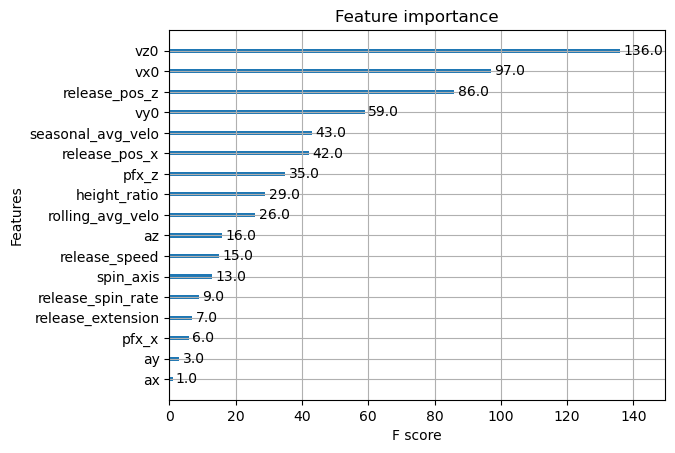

In [12]:
xgb.plot_importance(model)
plt.show()

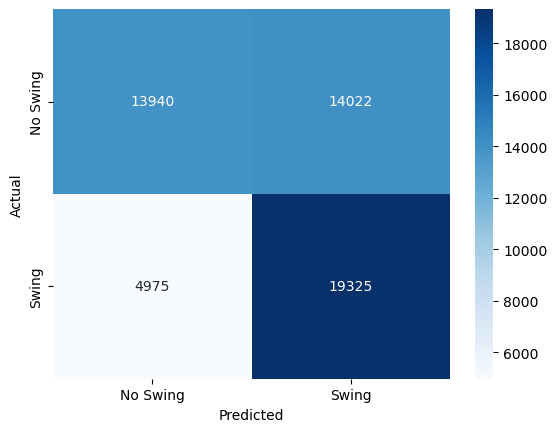

In [13]:
# Convert predicted probabilities to binary predictions
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Initial Paramater Tuning

In [14]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
        'scale_pos_weight': class_ratio,
        'device': 'gpu'
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=50  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))
    
    # Calculate the log loss on the validation set
    loss = log_loss(y_valid, y_valid_pred)

    return loss

In [15]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-15 14:50:25,604] A new study created in memory with name: no-name-a490fd31-1482-46f6-a5d5-95af2b9227a5


[0]	eval-logloss:0.68119
[1]	eval-logloss:0.67051
[2]	eval-logloss:0.66288
[3]	eval-logloss:0.65589
[4]	eval-logloss:0.64995
[5]	eval-logloss:0.64484
[6]	eval-logloss:0.64067
[7]	eval-logloss:0.63649
[8]	eval-logloss:0.63205
[9]	eval-logloss:0.62941
[10]	eval-logloss:0.62616
[11]	eval-logloss:0.62309
[12]	eval-logloss:0.62092
[13]	eval-logloss:0.61894
[14]	eval-logloss:0.61643
[15]	eval-logloss:0.61375
[16]	eval-logloss:0.61122
[17]	eval-logloss:0.60937
[18]	eval-logloss:0.60838
[19]	eval-logloss:0.60701
[20]	eval-logloss:0.60588
[21]	eval-logloss:0.60452
[22]	eval-logloss:0.60357
[23]	eval-logloss:0.60118
[24]	eval-logloss:0.60034
[25]	eval-logloss:0.59825
[26]	eval-logloss:0.59697
[27]	eval-logloss:0.59677
[28]	eval-logloss:0.59584
[29]	eval-logloss:0.59483
[30]	eval-logloss:0.59341
[31]	eval-logloss:0.59271
[32]	eval-logloss:0.59232
[33]	eval-logloss:0.59179
[34]	eval-logloss:0.59100
[35]	eval-logloss:0.59032
[36]	eval-logloss:0.58956
[37]	eval-logloss:0.58937
[38]	eval-logloss:0.58

[I 2023-11-15 14:50:26,883] Trial 0 finished with value: 0.5626800851303965 and parameters: {'max_depth': 7, 'eta': 0.1267430265444214, 'subsample': 0.6144509063483271, 'colsample_bytree': 0.8155576934841515}. Best is trial 0 with value: 0.5626800851303965.


[0]	eval-logloss:0.68324
[1]	eval-logloss:0.67461
[2]	eval-logloss:0.66776
[3]	eval-logloss:0.66204
[4]	eval-logloss:0.65656
[5]	eval-logloss:0.65226
[6]	eval-logloss:0.64840
[7]	eval-logloss:0.64412
[8]	eval-logloss:0.64013
[9]	eval-logloss:0.63755
[10]	eval-logloss:0.63483
[11]	eval-logloss:0.63195
[12]	eval-logloss:0.63049
[13]	eval-logloss:0.62884
[14]	eval-logloss:0.62666
[15]	eval-logloss:0.62511
[16]	eval-logloss:0.62339
[17]	eval-logloss:0.62180
[18]	eval-logloss:0.62048
[19]	eval-logloss:0.61882
[20]	eval-logloss:0.61789
[21]	eval-logloss:0.61637
[22]	eval-logloss:0.61539
[23]	eval-logloss:0.61461
[24]	eval-logloss:0.61381
[25]	eval-logloss:0.61143
[26]	eval-logloss:0.60964
[27]	eval-logloss:0.60941
[28]	eval-logloss:0.60883
[29]	eval-logloss:0.60659
[30]	eval-logloss:0.60496
[31]	eval-logloss:0.60420
[32]	eval-logloss:0.60378
[33]	eval-logloss:0.60277
[34]	eval-logloss:0.60203
[35]	eval-logloss:0.60158
[36]	eval-logloss:0.60038
[37]	eval-logloss:0.60001
[38]	eval-logloss:0.59

[I 2023-11-15 14:50:27,814] Trial 1 finished with value: 0.5751521290233935 and parameters: {'max_depth': 6, 'eta': 0.11346370277924493, 'subsample': 0.8568987515008462, 'colsample_bytree': 0.8059093921737566}. Best is trial 0 with value: 0.5626800851303965.


[0]	eval-logloss:0.67702
[1]	eval-logloss:0.66521
[2]	eval-logloss:0.65609
[3]	eval-logloss:0.64796
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63683
[6]	eval-logloss:0.63389
[7]	eval-logloss:0.62888
[8]	eval-logloss:0.62507
[9]	eval-logloss:0.62271
[10]	eval-logloss:0.61993
[11]	eval-logloss:0.61699
[12]	eval-logloss:0.61494
[13]	eval-logloss:0.61321
[14]	eval-logloss:0.61158
[15]	eval-logloss:0.61007
[16]	eval-logloss:0.60808
[17]	eval-logloss:0.60349
[18]	eval-logloss:0.60256
[19]	eval-logloss:0.60193
[20]	eval-logloss:0.59988
[21]	eval-logloss:0.59893
[22]	eval-logloss:0.59723
[23]	eval-logloss:0.59481
[24]	eval-logloss:0.59440
[25]	eval-logloss:0.59371
[26]	eval-logloss:0.59180
[27]	eval-logloss:0.59170
[28]	eval-logloss:0.59140
[29]	eval-logloss:0.58945
[30]	eval-logloss:0.58874
[31]	eval-logloss:0.58774
[32]	eval-logloss:0.58755
[33]	eval-logloss:0.58686
[34]	eval-logloss:0.58623
[35]	eval-logloss:0.58561
[36]	eval-logloss:0.58436
[37]	eval-logloss:0.58393
[38]	eval-logloss:0.58

[I 2023-11-15 14:50:28,792] Trial 2 finished with value: 0.5607305594506362 and parameters: {'max_depth': 6, 'eta': 0.19441920822658354, 'subsample': 0.689201046622292, 'colsample_bytree': 0.738447372259042}. Best is trial 2 with value: 0.5607305594506362.


[0]	eval-logloss:0.68620
[1]	eval-logloss:0.67981
[2]	eval-logloss:0.67474
[3]	eval-logloss:0.67022
[4]	eval-logloss:0.66593
[5]	eval-logloss:0.66204
[6]	eval-logloss:0.65858
[7]	eval-logloss:0.65532
[8]	eval-logloss:0.65252
[9]	eval-logloss:0.65028
[10]	eval-logloss:0.64849
[11]	eval-logloss:0.64601
[12]	eval-logloss:0.64380
[13]	eval-logloss:0.64200
[14]	eval-logloss:0.64040
[15]	eval-logloss:0.63844
[16]	eval-logloss:0.63722
[17]	eval-logloss:0.63625
[18]	eval-logloss:0.63507
[19]	eval-logloss:0.63358
[20]	eval-logloss:0.63247
[21]	eval-logloss:0.63100
[22]	eval-logloss:0.62968
[23]	eval-logloss:0.62869
[24]	eval-logloss:0.62766
[25]	eval-logloss:0.62584
[26]	eval-logloss:0.62408
[27]	eval-logloss:0.62384
[28]	eval-logloss:0.62284
[29]	eval-logloss:0.62089
[30]	eval-logloss:0.62015
[31]	eval-logloss:0.61847
[32]	eval-logloss:0.61745
[33]	eval-logloss:0.61652
[34]	eval-logloss:0.61586
[35]	eval-logloss:0.61501
[36]	eval-logloss:0.61400
[37]	eval-logloss:0.61338
[38]	eval-logloss:0.61

[I 2023-11-15 14:50:29,720] Trial 3 finished with value: 0.584380976980775 and parameters: {'max_depth': 5, 'eta': 0.09077525788871686, 'subsample': 0.6771278921534969, 'colsample_bytree': 0.9095600258190819}. Best is trial 2 with value: 0.5607305594506362.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67251
[2]	eval-logloss:0.66483
[3]	eval-logloss:0.65759
[4]	eval-logloss:0.65065
[5]	eval-logloss:0.64535
[6]	eval-logloss:0.64132
[7]	eval-logloss:0.63712
[8]	eval-logloss:0.63237
[9]	eval-logloss:0.62914
[10]	eval-logloss:0.62620
[11]	eval-logloss:0.62281
[12]	eval-logloss:0.62118
[13]	eval-logloss:0.61907
[14]	eval-logloss:0.61642
[15]	eval-logloss:0.61342
[16]	eval-logloss:0.61156
[17]	eval-logloss:0.60888
[18]	eval-logloss:0.60707
[19]	eval-logloss:0.60558
[20]	eval-logloss:0.60364
[21]	eval-logloss:0.60238
[22]	eval-logloss:0.60117
[23]	eval-logloss:0.59876
[24]	eval-logloss:0.59795
[25]	eval-logloss:0.59712
[26]	eval-logloss:0.59684
[27]	eval-logloss:0.59670
[28]	eval-logloss:0.59598
[29]	eval-logloss:0.59428
[30]	eval-logloss:0.59346
[31]	eval-logloss:0.59305
[32]	eval-logloss:0.59232
[33]	eval-logloss:0.59170
[34]	eval-logloss:0.59134
[35]	eval-logloss:0.59081
[36]	eval-logloss:0.58965
[37]	eval-logloss:0.58895
[38]	eval-logloss:0.58

[I 2023-11-15 14:50:31,170] Trial 4 finished with value: 0.5641821106419707 and parameters: {'max_depth': 8, 'eta': 0.10595031722365188, 'subsample': 0.6409260923322724, 'colsample_bytree': 0.689660207172158}. Best is trial 2 with value: 0.5607305594506362.


[0]	eval-logloss:0.68512
[1]	eval-logloss:0.67752
[2]	eval-logloss:0.67152
[3]	eval-logloss:0.66616
[4]	eval-logloss:0.66100
[5]	eval-logloss:0.65650
[6]	eval-logloss:0.65271
[7]	eval-logloss:0.64925
[8]	eval-logloss:0.64568
[9]	eval-logloss:0.64259
[10]	eval-logloss:0.63998
[11]	eval-logloss:0.63710
[12]	eval-logloss:0.63452
[13]	eval-logloss:0.63233
[14]	eval-logloss:0.62962
[15]	eval-logloss:0.62761
[16]	eval-logloss:0.62499
[17]	eval-logloss:0.62311
[18]	eval-logloss:0.62102
[19]	eval-logloss:0.61950
[20]	eval-logloss:0.61768
[21]	eval-logloss:0.61645
[22]	eval-logloss:0.61533
[23]	eval-logloss:0.61359
[24]	eval-logloss:0.61280
[25]	eval-logloss:0.61164
[26]	eval-logloss:0.61068
[27]	eval-logloss:0.61050
[28]	eval-logloss:0.60970
[29]	eval-logloss:0.60892
[30]	eval-logloss:0.60659
[31]	eval-logloss:0.60532
[32]	eval-logloss:0.60442
[33]	eval-logloss:0.60368
[34]	eval-logloss:0.60234
[35]	eval-logloss:0.60133
[36]	eval-logloss:0.60076
[37]	eval-logloss:0.60002
[38]	eval-logloss:0.59

[I 2023-11-15 14:50:32,313] Trial 5 finished with value: 0.5690005501973734 and parameters: {'max_depth': 7, 'eta': 0.0811532428199109, 'subsample': 0.7102136936795723, 'colsample_bytree': 0.8572855754662204}. Best is trial 2 with value: 0.5607305594506362.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.67034
[2]	eval-logloss:0.66308
[3]	eval-logloss:0.65729
[4]	eval-logloss:0.65207
[5]	eval-logloss:0.64909
[6]	eval-logloss:0.64402
[7]	eval-logloss:0.64093
[8]	eval-logloss:0.63745
[9]	eval-logloss:0.63474
[10]	eval-logloss:0.63200
[11]	eval-logloss:0.62867
[12]	eval-logloss:0.62713
[13]	eval-logloss:0.62508
[14]	eval-logloss:0.62364
[15]	eval-logloss:0.62215
[16]	eval-logloss:0.62064
[17]	eval-logloss:0.61862
[18]	eval-logloss:0.61776
[19]	eval-logloss:0.61626
[20]	eval-logloss:0.61432
[21]	eval-logloss:0.61325
[22]	eval-logloss:0.61246
[23]	eval-logloss:0.61212
[24]	eval-logloss:0.61190
[25]	eval-logloss:0.61019
[26]	eval-logloss:0.60781
[27]	eval-logloss:0.60682
[28]	eval-logloss:0.60616
[29]	eval-logloss:0.60565
[30]	eval-logloss:0.60530
[31]	eval-logloss:0.60426
[32]	eval-logloss:0.60382
[33]	eval-logloss:0.60299
[34]	eval-logloss:0.60266
[35]	eval-logloss:0.60237
[36]	eval-logloss:0.60085
[37]	eval-logloss:0.60048
[38]	eval-logloss:0.59

[I 2023-11-15 14:50:33,061] Trial 6 finished with value: 0.5768886943155743 and parameters: {'max_depth': 4, 'eta': 0.22595167232468094, 'subsample': 0.8360259555494387, 'colsample_bytree': 0.9480791967255471}. Best is trial 2 with value: 0.5607305594506362.


[0]	eval-logloss:0.69008
[1]	eval-logloss:0.66476
[2]	eval-logloss:0.64769
[3]	eval-logloss:0.63639
[4]	eval-logloss:0.62683
[5]	eval-logloss:0.62067
[6]	eval-logloss:0.61761
[7]	eval-logloss:0.61025
[8]	eval-logloss:0.60380
[9]	eval-logloss:0.60074
[10]	eval-logloss:0.59996
[11]	eval-logloss:0.59766
[12]	eval-logloss:0.59649
[13]	eval-logloss:0.59482
[14]	eval-logloss:0.59124
[15]	eval-logloss:0.58956
[16]	eval-logloss:0.58811
[17]	eval-logloss:0.58383
[18]	eval-logloss:0.58307
[19]	eval-logloss:0.58080
[20]	eval-logloss:0.57988
[21]	eval-logloss:0.57949
[22]	eval-logloss:0.57917
[23]	eval-logloss:0.57922
[24]	eval-logloss:0.57893
[25]	eval-logloss:0.57884
[26]	eval-logloss:0.57874
[27]	eval-logloss:0.57874
[28]	eval-logloss:0.57897
[29]	eval-logloss:0.57523
[30]	eval-logloss:0.57488
[31]	eval-logloss:0.57470
[32]	eval-logloss:0.57463
[33]	eval-logloss:0.57450
[34]	eval-logloss:0.57461
[35]	eval-logloss:0.57443
[36]	eval-logloss:0.57317
[37]	eval-logloss:0.57333
[38]	eval-logloss:0.57

[I 2023-11-15 14:50:34,640] Trial 7 finished with value: 0.5657033709717694 and parameters: {'max_depth': 9, 'eta': 0.2516836507362387, 'subsample': 0.7995504084948336, 'colsample_bytree': 0.5662673821062212}. Best is trial 2 with value: 0.5607305594506362.


[0]	eval-logloss:0.69074
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.64446
[4]	eval-logloss:0.63930
[5]	eval-logloss:0.63207
[6]	eval-logloss:0.62742
[7]	eval-logloss:0.62118
[8]	eval-logloss:0.61643
[9]	eval-logloss:0.61255
[10]	eval-logloss:0.61191
[11]	eval-logloss:0.60829
[12]	eval-logloss:0.60620
[13]	eval-logloss:0.60398
[14]	eval-logloss:0.59975
[15]	eval-logloss:0.59628
[16]	eval-logloss:0.59510
[17]	eval-logloss:0.59199
[18]	eval-logloss:0.59060
[19]	eval-logloss:0.58832
[20]	eval-logloss:0.58724
[21]	eval-logloss:0.58579
[22]	eval-logloss:0.58549
[23]	eval-logloss:0.58537
[24]	eval-logloss:0.58451
[25]	eval-logloss:0.58448
[26]	eval-logloss:0.58432
[27]	eval-logloss:0.58419
[28]	eval-logloss:0.58418
[29]	eval-logloss:0.58127
[30]	eval-logloss:0.58072
[31]	eval-logloss:0.58032
[32]	eval-logloss:0.57977
[33]	eval-logloss:0.57959
[34]	eval-logloss:0.57973
[35]	eval-logloss:0.57869
[36]	eval-logloss:0.57762
[37]	eval-logloss:0.57758
[38]	eval-logloss:0.57

[I 2023-11-15 14:50:35,861] Trial 8 finished with value: 0.5643842743956452 and parameters: {'max_depth': 8, 'eta': 0.21674900092041516, 'subsample': 0.7764819263419772, 'colsample_bytree': 0.5315934753589486}. Best is trial 2 with value: 0.5607305594506362.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65183
[3]	eval-logloss:0.64345
[4]	eval-logloss:0.63612
[5]	eval-logloss:0.63069
[6]	eval-logloss:0.62742
[7]	eval-logloss:0.62264
[8]	eval-logloss:0.61658
[9]	eval-logloss:0.61396
[10]	eval-logloss:0.61137
[11]	eval-logloss:0.60662
[12]	eval-logloss:0.60481
[13]	eval-logloss:0.60265
[14]	eval-logloss:0.60019
[15]	eval-logloss:0.59760
[16]	eval-logloss:0.59536
[17]	eval-logloss:0.59391
[18]	eval-logloss:0.59334
[19]	eval-logloss:0.59240
[20]	eval-logloss:0.59152
[21]	eval-logloss:0.58971
[22]	eval-logloss:0.58881
[23]	eval-logloss:0.58667
[24]	eval-logloss:0.58597
[25]	eval-logloss:0.58387
[26]	eval-logloss:0.58319
[27]	eval-logloss:0.58309
[28]	eval-logloss:0.58288
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.58124
[31]	eval-logloss:0.58046
[32]	eval-logloss:0.58034
[33]	eval-logloss:0.57995
[34]	eval-logloss:0.57922
[35]	eval-logloss:0.57876
[36]	eval-logloss:0.57760
[37]	eval-logloss:0.57723
[38]	eval-logloss:0.57

[I 2023-11-15 14:50:36,880] Trial 9 finished with value: 0.5580891115252911 and parameters: {'max_depth': 7, 'eta': 0.20336568909062616, 'subsample': 0.6802144260014064, 'colsample_bytree': 0.7436228363038051}. Best is trial 9 with value: 0.5580891115252911.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67256
[2]	eval-logloss:0.66716
[3]	eval-logloss:0.66230
[4]	eval-logloss:0.65736
[5]	eval-logloss:0.65314
[6]	eval-logloss:0.64968
[7]	eval-logloss:0.64702
[8]	eval-logloss:0.64487
[9]	eval-logloss:0.64212
[10]	eval-logloss:0.63816
[11]	eval-logloss:0.63599
[12]	eval-logloss:0.63443
[13]	eval-logloss:0.63349
[14]	eval-logloss:0.63149
[15]	eval-logloss:0.62989
[16]	eval-logloss:0.62875
[17]	eval-logloss:0.62697
[18]	eval-logloss:0.62628
[19]	eval-logloss:0.62451
[20]	eval-logloss:0.62206
[21]	eval-logloss:0.62075
[22]	eval-logloss:0.62044
[23]	eval-logloss:0.61910
[24]	eval-logloss:0.61821
[25]	eval-logloss:0.61753
[26]	eval-logloss:0.61603
[27]	eval-logloss:0.61454
[28]	eval-logloss:0.61399
[29]	eval-logloss:0.61381
[30]	eval-logloss:0.61215
[31]	eval-logloss:0.61193
[32]	eval-logloss:0.61154
[33]	eval-logloss:0.61073
[34]	eval-logloss:0.61042
[35]	eval-logloss:0.61007
[36]	eval-logloss:0.60949
[37]	eval-logloss:0.60904
[38]	eval-logloss:0.60

[I 2023-11-15 14:50:37,531] Trial 10 finished with value: 0.5836457203048422 and parameters: {'max_depth': 3, 'eta': 0.28832191671535895, 'subsample': 0.7380869472726488, 'colsample_bytree': 0.9990166760086823}. Best is trial 9 with value: 0.5580891115252911.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.65793
[3]	eval-logloss:0.65074
[4]	eval-logloss:0.64439
[5]	eval-logloss:0.63912
[6]	eval-logloss:0.63565
[7]	eval-logloss:0.63137
[8]	eval-logloss:0.62802
[9]	eval-logloss:0.62560
[10]	eval-logloss:0.62344
[11]	eval-logloss:0.61859
[12]	eval-logloss:0.61698
[13]	eval-logloss:0.61483
[14]	eval-logloss:0.61327
[15]	eval-logloss:0.61184
[16]	eval-logloss:0.61080
[17]	eval-logloss:0.60933
[18]	eval-logloss:0.60764
[19]	eval-logloss:0.60704
[20]	eval-logloss:0.60581
[21]	eval-logloss:0.60446
[22]	eval-logloss:0.60311
[23]	eval-logloss:0.60089
[24]	eval-logloss:0.60039
[25]	eval-logloss:0.59992
[26]	eval-logloss:0.59971
[27]	eval-logloss:0.59956
[28]	eval-logloss:0.59852
[29]	eval-logloss:0.59755
[30]	eval-logloss:0.59674
[31]	eval-logloss:0.59616
[32]	eval-logloss:0.59594
[33]	eval-logloss:0.59535
[34]	eval-logloss:0.59513
[35]	eval-logloss:0.59461
[36]	eval-logloss:0.59392
[37]	eval-logloss:0.59326
[38]	eval-logloss:0.59

[I 2023-11-15 14:50:38,427] Trial 11 finished with value: 0.5665673763355027 and parameters: {'max_depth': 6, 'eta': 0.18054199768028997, 'subsample': 0.6834653330733722, 'colsample_bytree': 0.712091947115059}. Best is trial 9 with value: 0.5580891115252911.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69012
[2]	eval-logloss:0.68865
[3]	eval-logloss:0.68721
[4]	eval-logloss:0.68577
[5]	eval-logloss:0.68441
[6]	eval-logloss:0.68320
[7]	eval-logloss:0.68192
[8]	eval-logloss:0.68113
[9]	eval-logloss:0.67991
[10]	eval-logloss:0.67877
[11]	eval-logloss:0.67748
[12]	eval-logloss:0.67707
[13]	eval-logloss:0.67596
[14]	eval-logloss:0.67481
[15]	eval-logloss:0.67372
[16]	eval-logloss:0.67271
[17]	eval-logloss:0.67169
[18]	eval-logloss:0.67063
[19]	eval-logloss:0.66970
[20]	eval-logloss:0.66877
[21]	eval-logloss:0.66783
[22]	eval-logloss:0.66701
[23]	eval-logloss:0.66604
[24]	eval-logloss:0.66523
[25]	eval-logloss:0.66438
[26]	eval-logloss:0.66387
[27]	eval-logloss:0.66376
[28]	eval-logloss:0.66343
[29]	eval-logloss:0.66262
[30]	eval-logloss:0.66185
[31]	eval-logloss:0.66117
[32]	eval-logloss:0.66085
[33]	eval-logloss:0.66017
[34]	eval-logloss:0.65942
[35]	eval-logloss:0.65873
[36]	eval-logloss:0.65803
[37]	eval-logloss:0.65736
[38]	eval-logloss:0.65

[I 2023-11-15 14:50:39,198] Trial 12 finished with value: 0.6328696833437462 and parameters: {'max_depth': 5, 'eta': 0.01968600863055847, 'subsample': 0.6563910210430748, 'colsample_bytree': 0.7391680656438061}. Best is trial 9 with value: 0.5580891115252911.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66399
[2]	eval-logloss:0.65458
[3]	eval-logloss:0.64648
[4]	eval-logloss:0.63996
[5]	eval-logloss:0.63467
[6]	eval-logloss:0.63103
[7]	eval-logloss:0.62561
[8]	eval-logloss:0.62080
[9]	eval-logloss:0.61815
[10]	eval-logloss:0.61588
[11]	eval-logloss:0.61012
[12]	eval-logloss:0.60813
[13]	eval-logloss:0.60623
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.60157
[16]	eval-logloss:0.60029
[17]	eval-logloss:0.59896
[18]	eval-logloss:0.59807
[19]	eval-logloss:0.59573
[20]	eval-logloss:0.59469
[21]	eval-logloss:0.59341
[22]	eval-logloss:0.59243
[23]	eval-logloss:0.59225
[24]	eval-logloss:0.59203
[25]	eval-logloss:0.59195
[26]	eval-logloss:0.59168
[27]	eval-logloss:0.59157
[28]	eval-logloss:0.59155
[29]	eval-logloss:0.58824
[30]	eval-logloss:0.58721
[31]	eval-logloss:0.58684
[32]	eval-logloss:0.58634
[33]	eval-logloss:0.58571
[34]	eval-logloss:0.58576
[35]	eval-logloss:0.58514
[36]	eval-logloss:0.58394
[37]	eval-logloss:0.58387
[38]	eval-logloss:0.58

[I 2023-11-15 14:50:40,236] Trial 13 finished with value: 0.5634347175961987 and parameters: {'max_depth': 7, 'eta': 0.17823810667904996, 'subsample': 0.711835417304329, 'colsample_bytree': 0.63923269936747}. Best is trial 9 with value: 0.5580891115252911.


[0]	eval-logloss:0.68115
[1]	eval-logloss:0.67171
[2]	eval-logloss:0.66457
[3]	eval-logloss:0.65834
[4]	eval-logloss:0.65290
[5]	eval-logloss:0.64832
[6]	eval-logloss:0.64508
[7]	eval-logloss:0.64187
[8]	eval-logloss:0.63785
[9]	eval-logloss:0.63591
[10]	eval-logloss:0.63360
[11]	eval-logloss:0.63106
[12]	eval-logloss:0.62904
[13]	eval-logloss:0.62715
[14]	eval-logloss:0.62510
[15]	eval-logloss:0.62339
[16]	eval-logloss:0.62098
[17]	eval-logloss:0.61995
[18]	eval-logloss:0.61834
[19]	eval-logloss:0.61663
[20]	eval-logloss:0.61575
[21]	eval-logloss:0.61519
[22]	eval-logloss:0.61395
[23]	eval-logloss:0.61214
[24]	eval-logloss:0.61149
[25]	eval-logloss:0.61059
[26]	eval-logloss:0.60957
[27]	eval-logloss:0.60941
[28]	eval-logloss:0.60850
[29]	eval-logloss:0.60770
[30]	eval-logloss:0.60669
[31]	eval-logloss:0.60634
[32]	eval-logloss:0.60613
[33]	eval-logloss:0.60544
[34]	eval-logloss:0.60424
[35]	eval-logloss:0.60391
[36]	eval-logloss:0.60336
[37]	eval-logloss:0.60287
[38]	eval-logloss:0.60

[I 2023-11-15 14:50:41,021] Trial 14 finished with value: 0.5706614761153224 and parameters: {'max_depth': 5, 'eta': 0.162716381365906, 'subsample': 0.6017074396344841, 'colsample_bytree': 0.7640143746849852}. Best is trial 9 with value: 0.5580891115252911.


[0]	eval-logloss:0.67215
[1]	eval-logloss:0.65587
[2]	eval-logloss:0.64502
[3]	eval-logloss:0.63472
[4]	eval-logloss:0.62836
[5]	eval-logloss:0.62275
[6]	eval-logloss:0.61882
[7]	eval-logloss:0.61372
[8]	eval-logloss:0.60685
[9]	eval-logloss:0.60412
[10]	eval-logloss:0.60209
[11]	eval-logloss:0.59531
[12]	eval-logloss:0.59332
[13]	eval-logloss:0.59225
[14]	eval-logloss:0.59049
[15]	eval-logloss:0.58818
[16]	eval-logloss:0.58662
[17]	eval-logloss:0.58323
[18]	eval-logloss:0.58258
[19]	eval-logloss:0.57987
[20]	eval-logloss:0.57902
[21]	eval-logloss:0.57828
[22]	eval-logloss:0.57763
[23]	eval-logloss:0.57738
[24]	eval-logloss:0.57715
[25]	eval-logloss:0.57727
[26]	eval-logloss:0.57693
[27]	eval-logloss:0.57702
[28]	eval-logloss:0.57706
[29]	eval-logloss:0.57507
[30]	eval-logloss:0.57446
[31]	eval-logloss:0.57422
[32]	eval-logloss:0.57408
[33]	eval-logloss:0.57370
[34]	eval-logloss:0.57393
[35]	eval-logloss:0.57348
[36]	eval-logloss:0.57147
[37]	eval-logloss:0.57147
[38]	eval-logloss:0.57

[I 2023-11-15 14:50:42,606] Trial 15 finished with value: 0.5599372150158196 and parameters: {'max_depth': 9, 'eta': 0.20422544438600024, 'subsample': 0.7378700567191739, 'colsample_bytree': 0.6486016434130698}. Best is trial 9 with value: 0.5580891115252911.


[0]	eval-logloss:0.66713
[1]	eval-logloss:0.64805
[2]	eval-logloss:0.63605
[3]	eval-logloss:0.62636
[4]	eval-logloss:0.62018
[5]	eval-logloss:0.61474
[6]	eval-logloss:0.61193
[7]	eval-logloss:0.60672
[8]	eval-logloss:0.59804
[9]	eval-logloss:0.59601
[10]	eval-logloss:0.59445
[11]	eval-logloss:0.58699
[12]	eval-logloss:0.58542
[13]	eval-logloss:0.58390
[14]	eval-logloss:0.58267
[15]	eval-logloss:0.58045
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57742
[18]	eval-logloss:0.57705
[19]	eval-logloss:0.57509
[20]	eval-logloss:0.57422
[21]	eval-logloss:0.57298
[22]	eval-logloss:0.57292
[23]	eval-logloss:0.57320
[24]	eval-logloss:0.57285
[25]	eval-logloss:0.57301
[26]	eval-logloss:0.57298
[27]	eval-logloss:0.57311
[28]	eval-logloss:0.57331
[29]	eval-logloss:0.57310
[30]	eval-logloss:0.57249
[31]	eval-logloss:0.57219
[32]	eval-logloss:0.57206
[33]	eval-logloss:0.57216
[34]	eval-logloss:0.57228
[35]	eval-logloss:0.57225
[36]	eval-logloss:0.57135
[37]	eval-logloss:0.57142
[38]	eval-logloss:0.57

[I 2023-11-15 14:50:44,189] Trial 16 finished with value: 0.5637135030423875 and parameters: {'max_depth': 9, 'eta': 0.26144405996144504, 'subsample': 0.8944942194110254, 'colsample_bytree': 0.6328850837479668}. Best is trial 9 with value: 0.5580891115252911.


[0]	eval-logloss:0.67279
[1]	eval-logloss:0.65737
[2]	eval-logloss:0.64645
[3]	eval-logloss:0.63781
[4]	eval-logloss:0.63017
[5]	eval-logloss:0.62490
[6]	eval-logloss:0.62082
[7]	eval-logloss:0.61747
[8]	eval-logloss:0.61125
[9]	eval-logloss:0.60889
[10]	eval-logloss:0.60668
[11]	eval-logloss:0.60162
[12]	eval-logloss:0.60012
[13]	eval-logloss:0.59847
[14]	eval-logloss:0.59412
[15]	eval-logloss:0.59246
[16]	eval-logloss:0.59015
[17]	eval-logloss:0.58724
[18]	eval-logloss:0.58643
[19]	eval-logloss:0.58489
[20]	eval-logloss:0.58390
[21]	eval-logloss:0.58251
[22]	eval-logloss:0.58128
[23]	eval-logloss:0.57939
[24]	eval-logloss:0.57849
[25]	eval-logloss:0.57818
[26]	eval-logloss:0.57776
[27]	eval-logloss:0.57754
[28]	eval-logloss:0.57726
[29]	eval-logloss:0.57564
[30]	eval-logloss:0.57499
[31]	eval-logloss:0.57455
[32]	eval-logloss:0.57448
[33]	eval-logloss:0.57419
[34]	eval-logloss:0.57369
[35]	eval-logloss:0.57317
[36]	eval-logloss:0.57091
[37]	eval-logloss:0.57067
[38]	eval-logloss:0.56

[I 2023-11-15 14:50:45,559] Trial 17 finished with value: 0.5572392527205906 and parameters: {'max_depth': 8, 'eta': 0.20665166274276156, 'subsample': 0.7465863826272823, 'colsample_bytree': 0.6707351723904007}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.69128
[1]	eval-logloss:0.67612
[2]	eval-logloss:0.66381
[3]	eval-logloss:0.65504
[4]	eval-logloss:0.64629
[5]	eval-logloss:0.63994
[6]	eval-logloss:0.63578
[7]	eval-logloss:0.62936
[8]	eval-logloss:0.62411
[9]	eval-logloss:0.62064
[10]	eval-logloss:0.62017
[11]	eval-logloss:0.61685
[12]	eval-logloss:0.61517
[13]	eval-logloss:0.61320
[14]	eval-logloss:0.61064
[15]	eval-logloss:0.60731
[16]	eval-logloss:0.60523
[17]	eval-logloss:0.60283
[18]	eval-logloss:0.60107
[19]	eval-logloss:0.59936
[20]	eval-logloss:0.59851
[21]	eval-logloss:0.59672
[22]	eval-logloss:0.59580
[23]	eval-logloss:0.59571
[24]	eval-logloss:0.59480
[25]	eval-logloss:0.59472
[26]	eval-logloss:0.59451
[27]	eval-logloss:0.59434
[28]	eval-logloss:0.59429
[29]	eval-logloss:0.59186
[30]	eval-logloss:0.59090
[31]	eval-logloss:0.59058
[32]	eval-logloss:0.58980
[33]	eval-logloss:0.58934
[34]	eval-logloss:0.58927
[35]	eval-logloss:0.58852
[36]	eval-logloss:0.58713
[37]	eval-logloss:0.58709
[38]	eval-logloss:0.58

[I 2023-11-15 14:50:46,869] Trial 18 finished with value: 0.5609573680156734 and parameters: {'max_depth': 8, 'eta': 0.1554223777661339, 'subsample': 0.7645679211085069, 'colsample_bytree': 0.5817968210408546}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.66557
[1]	eval-logloss:0.64684
[2]	eval-logloss:0.63590
[3]	eval-logloss:0.62612
[4]	eval-logloss:0.61891
[5]	eval-logloss:0.61392
[6]	eval-logloss:0.61064
[7]	eval-logloss:0.60639
[8]	eval-logloss:0.59949
[9]	eval-logloss:0.59760
[10]	eval-logloss:0.59620
[11]	eval-logloss:0.59337
[12]	eval-logloss:0.59210
[13]	eval-logloss:0.59105
[14]	eval-logloss:0.58883
[15]	eval-logloss:0.58707
[16]	eval-logloss:0.58601
[17]	eval-logloss:0.58251
[18]	eval-logloss:0.58090
[19]	eval-logloss:0.57980
[20]	eval-logloss:0.57725
[21]	eval-logloss:0.57611
[22]	eval-logloss:0.57522
[23]	eval-logloss:0.57287
[24]	eval-logloss:0.57239
[25]	eval-logloss:0.57218
[26]	eval-logloss:0.57225
[27]	eval-logloss:0.57213
[28]	eval-logloss:0.57215
[29]	eval-logloss:0.57139
[30]	eval-logloss:0.57131
[31]	eval-logloss:0.57117
[32]	eval-logloss:0.57112
[33]	eval-logloss:0.57108
[34]	eval-logloss:0.57122
[35]	eval-logloss:0.57150
[36]	eval-logloss:0.57066
[37]	eval-logloss:0.57038
[38]	eval-logloss:0.56

[I 2023-11-15 14:50:48,189] Trial 19 finished with value: 0.5631158754951268 and parameters: {'max_depth': 8, 'eta': 0.29873253416879125, 'subsample': 0.7144195039498271, 'colsample_bytree': 0.6844492013360184}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.69091
[1]	eval-logloss:0.67399
[2]	eval-logloss:0.65953
[3]	eval-logloss:0.64911
[4]	eval-logloss:0.64362
[5]	eval-logloss:0.63609
[6]	eval-logloss:0.63165
[7]	eval-logloss:0.62699
[8]	eval-logloss:0.62230
[9]	eval-logloss:0.61844
[10]	eval-logloss:0.61801
[11]	eval-logloss:0.61459
[12]	eval-logloss:0.61260
[13]	eval-logloss:0.61046
[14]	eval-logloss:0.60676
[15]	eval-logloss:0.60343
[16]	eval-logloss:0.60207
[17]	eval-logloss:0.60063
[18]	eval-logloss:0.59876
[19]	eval-logloss:0.59653
[20]	eval-logloss:0.59568
[21]	eval-logloss:0.59453
[22]	eval-logloss:0.59402
[23]	eval-logloss:0.59393
[24]	eval-logloss:0.59241
[25]	eval-logloss:0.59241
[26]	eval-logloss:0.59213
[27]	eval-logloss:0.59193
[28]	eval-logloss:0.59190
[29]	eval-logloss:0.59006
[30]	eval-logloss:0.58961
[31]	eval-logloss:0.58910
[32]	eval-logloss:0.58855
[33]	eval-logloss:0.58831
[34]	eval-logloss:0.58832
[35]	eval-logloss:0.58697
[36]	eval-logloss:0.58617
[37]	eval-logloss:0.58619
[38]	eval-logloss:0.58

[I 2023-11-15 14:50:49,200] Trial 20 finished with value: 0.5644273870926468 and parameters: {'max_depth': 7, 'eta': 0.22990191455569792, 'subsample': 0.6420896812388568, 'colsample_bytree': 0.5081551979116516}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.67217
[1]	eval-logloss:0.65589
[2]	eval-logloss:0.64455
[3]	eval-logloss:0.63432
[4]	eval-logloss:0.62785
[5]	eval-logloss:0.62207
[6]	eval-logloss:0.61830
[7]	eval-logloss:0.61351
[8]	eval-logloss:0.60612
[9]	eval-logloss:0.60337
[10]	eval-logloss:0.60115
[11]	eval-logloss:0.59486
[12]	eval-logloss:0.59285
[13]	eval-logloss:0.59137
[14]	eval-logloss:0.59026
[15]	eval-logloss:0.58749
[16]	eval-logloss:0.58601
[17]	eval-logloss:0.58200
[18]	eval-logloss:0.58147
[19]	eval-logloss:0.57892
[20]	eval-logloss:0.57811
[21]	eval-logloss:0.57761
[22]	eval-logloss:0.57734
[23]	eval-logloss:0.57727
[24]	eval-logloss:0.57706
[25]	eval-logloss:0.57708
[26]	eval-logloss:0.57703
[27]	eval-logloss:0.57700
[28]	eval-logloss:0.57704
[29]	eval-logloss:0.57585
[30]	eval-logloss:0.57544
[31]	eval-logloss:0.57539
[32]	eval-logloss:0.57485
[33]	eval-logloss:0.57446
[34]	eval-logloss:0.57451
[35]	eval-logloss:0.57411
[36]	eval-logloss:0.57173
[37]	eval-logloss:0.57170
[38]	eval-logloss:0.57

[I 2023-11-15 14:50:50,808] Trial 21 finished with value: 0.5598989496929725 and parameters: {'max_depth': 9, 'eta': 0.20310860742890718, 'subsample': 0.7354659376130165, 'colsample_bytree': 0.6472031426194452}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.69080
[1]	eval-logloss:0.67094
[2]	eval-logloss:0.65617
[3]	eval-logloss:0.64418
[4]	eval-logloss:0.63550
[5]	eval-logloss:0.62827
[6]	eval-logloss:0.62451
[7]	eval-logloss:0.61427
[8]	eval-logloss:0.60882
[9]	eval-logloss:0.60534
[10]	eval-logloss:0.60473
[11]	eval-logloss:0.60198
[12]	eval-logloss:0.60035
[13]	eval-logloss:0.59833
[14]	eval-logloss:0.59566
[15]	eval-logloss:0.59374
[16]	eval-logloss:0.59172
[17]	eval-logloss:0.58837
[18]	eval-logloss:0.58727
[19]	eval-logloss:0.58415
[20]	eval-logloss:0.58327
[21]	eval-logloss:0.58188
[22]	eval-logloss:0.58141
[23]	eval-logloss:0.58148
[24]	eval-logloss:0.58094
[25]	eval-logloss:0.58097
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.58069
[28]	eval-logloss:0.58070
[29]	eval-logloss:0.57796
[30]	eval-logloss:0.57728
[31]	eval-logloss:0.57674
[32]	eval-logloss:0.57633
[33]	eval-logloss:0.57581
[34]	eval-logloss:0.57594
[35]	eval-logloss:0.57547
[36]	eval-logloss:0.57442
[37]	eval-logloss:0.57435
[38]	eval-logloss:0.57

[I 2023-11-15 14:50:52,410] Trial 22 finished with value: 0.5621158992314313 and parameters: {'max_depth': 9, 'eta': 0.1937614119273202, 'subsample': 0.7528127712099185, 'colsample_bytree': 0.5926937517576958}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.66995
[1]	eval-logloss:0.65465
[2]	eval-logloss:0.64391
[3]	eval-logloss:0.63361
[4]	eval-logloss:0.62565
[5]	eval-logloss:0.62016
[6]	eval-logloss:0.61628
[7]	eval-logloss:0.61240
[8]	eval-logloss:0.60698
[9]	eval-logloss:0.60435
[10]	eval-logloss:0.60256
[11]	eval-logloss:0.59629
[12]	eval-logloss:0.59521
[13]	eval-logloss:0.59405
[14]	eval-logloss:0.58962
[15]	eval-logloss:0.58796
[16]	eval-logloss:0.58692
[17]	eval-logloss:0.58275
[18]	eval-logloss:0.58167
[19]	eval-logloss:0.58057
[20]	eval-logloss:0.58012
[21]	eval-logloss:0.57906
[22]	eval-logloss:0.57844
[23]	eval-logloss:0.57581
[24]	eval-logloss:0.57534
[25]	eval-logloss:0.57472
[26]	eval-logloss:0.57461
[27]	eval-logloss:0.57452
[28]	eval-logloss:0.57384
[29]	eval-logloss:0.57142
[30]	eval-logloss:0.57139
[31]	eval-logloss:0.57117
[32]	eval-logloss:0.57087
[33]	eval-logloss:0.57061
[34]	eval-logloss:0.57037
[35]	eval-logloss:0.57021
[36]	eval-logloss:0.56984
[37]	eval-logloss:0.56971
[38]	eval-logloss:0.56

[I 2023-11-15 14:50:53,725] Trial 23 finished with value: 0.5614488285492204 and parameters: {'max_depth': 8, 'eta': 0.23902731727448043, 'subsample': 0.7846338090416495, 'colsample_bytree': 0.6687398589460587}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.67134
[1]	eval-logloss:0.65506
[2]	eval-logloss:0.64401
[3]	eval-logloss:0.63326
[4]	eval-logloss:0.62630
[5]	eval-logloss:0.62034
[6]	eval-logloss:0.61642
[7]	eval-logloss:0.61125
[8]	eval-logloss:0.60380
[9]	eval-logloss:0.60072
[10]	eval-logloss:0.59888
[11]	eval-logloss:0.59341
[12]	eval-logloss:0.59132
[13]	eval-logloss:0.59002
[14]	eval-logloss:0.58786
[15]	eval-logloss:0.58523
[16]	eval-logloss:0.58373
[17]	eval-logloss:0.58019
[18]	eval-logloss:0.57964
[19]	eval-logloss:0.57727
[20]	eval-logloss:0.57686
[21]	eval-logloss:0.57651
[22]	eval-logloss:0.57560
[23]	eval-logloss:0.57557
[24]	eval-logloss:0.57562
[25]	eval-logloss:0.57568
[26]	eval-logloss:0.57576
[27]	eval-logloss:0.57570
[28]	eval-logloss:0.57590
[29]	eval-logloss:0.57338
[30]	eval-logloss:0.57296
[31]	eval-logloss:0.57276
[32]	eval-logloss:0.57244
[33]	eval-logloss:0.57234
[34]	eval-logloss:0.57242
[35]	eval-logloss:0.57207
[36]	eval-logloss:0.57070
[37]	eval-logloss:0.57055
[38]	eval-logloss:0.57

[I 2023-11-15 14:50:55,359] Trial 24 finished with value: 0.562053219741348 and parameters: {'max_depth': 9, 'eta': 0.21252246300737165, 'subsample': 0.7307753384647319, 'colsample_bytree': 0.6240555383649216}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.66842
[1]	eval-logloss:0.65244
[2]	eval-logloss:0.64151
[3]	eval-logloss:0.63165
[4]	eval-logloss:0.62386
[5]	eval-logloss:0.61840
[6]	eval-logloss:0.61352
[7]	eval-logloss:0.60905
[8]	eval-logloss:0.60378
[9]	eval-logloss:0.60163
[10]	eval-logloss:0.59992
[11]	eval-logloss:0.59505
[12]	eval-logloss:0.59409
[13]	eval-logloss:0.59275
[14]	eval-logloss:0.59034
[15]	eval-logloss:0.58587
[16]	eval-logloss:0.58463
[17]	eval-logloss:0.58400
[18]	eval-logloss:0.58087
[19]	eval-logloss:0.57922
[20]	eval-logloss:0.57711
[21]	eval-logloss:0.57622
[22]	eval-logloss:0.57466
[23]	eval-logloss:0.57402
[24]	eval-logloss:0.57354
[25]	eval-logloss:0.57327
[26]	eval-logloss:0.57321
[27]	eval-logloss:0.57330
[28]	eval-logloss:0.57264
[29]	eval-logloss:0.57104
[30]	eval-logloss:0.57079
[31]	eval-logloss:0.57091
[32]	eval-logloss:0.57078
[33]	eval-logloss:0.57036
[34]	eval-logloss:0.57008
[35]	eval-logloss:0.56960
[36]	eval-logloss:0.56903
[37]	eval-logloss:0.56892
[38]	eval-logloss:0.56

[I 2023-11-15 14:50:56,638] Trial 25 finished with value: 0.5609980206737221 and parameters: {'max_depth': 8, 'eta': 0.25838889719052704, 'subsample': 0.7632031537447329, 'colsample_bytree': 0.7070273737691857}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.67702
[1]	eval-logloss:0.66444
[2]	eval-logloss:0.65510
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.64124
[5]	eval-logloss:0.63585
[6]	eval-logloss:0.63209
[7]	eval-logloss:0.62685
[8]	eval-logloss:0.62158
[9]	eval-logloss:0.61902
[10]	eval-logloss:0.61651
[11]	eval-logloss:0.61202
[12]	eval-logloss:0.61003
[13]	eval-logloss:0.60819
[14]	eval-logloss:0.60597
[15]	eval-logloss:0.60346
[16]	eval-logloss:0.60222
[17]	eval-logloss:0.60074
[18]	eval-logloss:0.60023
[19]	eval-logloss:0.59928
[20]	eval-logloss:0.59788
[21]	eval-logloss:0.59677
[22]	eval-logloss:0.59580
[23]	eval-logloss:0.59309
[24]	eval-logloss:0.59241
[25]	eval-logloss:0.59021
[26]	eval-logloss:0.58753
[27]	eval-logloss:0.58740
[28]	eval-logloss:0.58700
[29]	eval-logloss:0.58597
[30]	eval-logloss:0.58503
[31]	eval-logloss:0.58427
[32]	eval-logloss:0.58408
[33]	eval-logloss:0.58352
[34]	eval-logloss:0.58315
[35]	eval-logloss:0.58254
[36]	eval-logloss:0.58207
[37]	eval-logloss:0.58187
[38]	eval-logloss:0.58

[I 2023-11-15 14:50:57,668] Trial 26 finished with value: 0.5596579700605245 and parameters: {'max_depth': 7, 'eta': 0.17500835014830057, 'subsample': 0.7024800468782308, 'colsample_bytree': 0.7714824419909093}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66746
[2]	eval-logloss:0.65866
[3]	eval-logloss:0.65118
[4]	eval-logloss:0.64452
[5]	eval-logloss:0.63915
[6]	eval-logloss:0.63519
[7]	eval-logloss:0.63144
[8]	eval-logloss:0.62616
[9]	eval-logloss:0.62321
[10]	eval-logloss:0.62065
[11]	eval-logloss:0.61660
[12]	eval-logloss:0.61434
[13]	eval-logloss:0.61280
[14]	eval-logloss:0.61018
[15]	eval-logloss:0.60830
[16]	eval-logloss:0.60675
[17]	eval-logloss:0.60447
[18]	eval-logloss:0.60372
[19]	eval-logloss:0.60266
[20]	eval-logloss:0.60082
[21]	eval-logloss:0.59981
[22]	eval-logloss:0.59836
[23]	eval-logloss:0.59571
[24]	eval-logloss:0.59522
[25]	eval-logloss:0.59412
[26]	eval-logloss:0.59331
[27]	eval-logloss:0.59308
[28]	eval-logloss:0.59203
[29]	eval-logloss:0.59154
[30]	eval-logloss:0.58947
[31]	eval-logloss:0.58829
[32]	eval-logloss:0.58803
[33]	eval-logloss:0.58744
[34]	eval-logloss:0.58679
[35]	eval-logloss:0.58599
[36]	eval-logloss:0.58510
[37]	eval-logloss:0.58458
[38]	eval-logloss:0.58

[I 2023-11-15 14:50:58,741] Trial 27 finished with value: 0.5619275537922762 and parameters: {'max_depth': 7, 'eta': 0.15342567400351942, 'subsample': 0.6981258519485168, 'colsample_bytree': 0.754834120229194}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66347
[2]	eval-logloss:0.65450
[3]	eval-logloss:0.64678
[4]	eval-logloss:0.64107
[5]	eval-logloss:0.63574
[6]	eval-logloss:0.63136
[7]	eval-logloss:0.62621
[8]	eval-logloss:0.62164
[9]	eval-logloss:0.61921
[10]	eval-logloss:0.61515
[11]	eval-logloss:0.61153
[12]	eval-logloss:0.60937
[13]	eval-logloss:0.60784
[14]	eval-logloss:0.60603
[15]	eval-logloss:0.60441
[16]	eval-logloss:0.60307
[17]	eval-logloss:0.60107
[18]	eval-logloss:0.59968
[19]	eval-logloss:0.59886
[20]	eval-logloss:0.59747
[21]	eval-logloss:0.59638
[22]	eval-logloss:0.59525
[23]	eval-logloss:0.59283
[24]	eval-logloss:0.59233
[25]	eval-logloss:0.59168
[26]	eval-logloss:0.59051
[27]	eval-logloss:0.59048
[28]	eval-logloss:0.59032
[29]	eval-logloss:0.58966
[30]	eval-logloss:0.58841
[31]	eval-logloss:0.58605
[32]	eval-logloss:0.58586
[33]	eval-logloss:0.58548
[34]	eval-logloss:0.58210
[35]	eval-logloss:0.58186
[36]	eval-logloss:0.58116
[37]	eval-logloss:0.58036
[38]	eval-logloss:0.57

[I 2023-11-15 14:50:59,887] Trial 28 finished with value: 0.5574810994902272 and parameters: {'max_depth': 7, 'eta': 0.17609870080363077, 'subsample': 0.6660297406723653, 'colsample_bytree': 0.7878453411657599}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.68049
[1]	eval-logloss:0.67024
[2]	eval-logloss:0.66268
[3]	eval-logloss:0.65611
[4]	eval-logloss:0.65009
[5]	eval-logloss:0.64529
[6]	eval-logloss:0.64125
[7]	eval-logloss:0.63737
[8]	eval-logloss:0.63336
[9]	eval-logloss:0.63105
[10]	eval-logloss:0.62785
[11]	eval-logloss:0.62477
[12]	eval-logloss:0.62295
[13]	eval-logloss:0.62081
[14]	eval-logloss:0.61869
[15]	eval-logloss:0.61751
[16]	eval-logloss:0.61533
[17]	eval-logloss:0.61349
[18]	eval-logloss:0.61245
[19]	eval-logloss:0.61136
[20]	eval-logloss:0.60833
[21]	eval-logloss:0.60734
[22]	eval-logloss:0.60615
[23]	eval-logloss:0.60397
[24]	eval-logloss:0.60289
[25]	eval-logloss:0.60103
[26]	eval-logloss:0.60027
[27]	eval-logloss:0.60010
[28]	eval-logloss:0.59980
[29]	eval-logloss:0.59918
[30]	eval-logloss:0.59799
[31]	eval-logloss:0.59618
[32]	eval-logloss:0.59590
[33]	eval-logloss:0.59534
[34]	eval-logloss:0.59412
[35]	eval-logloss:0.59345
[36]	eval-logloss:0.59191
[37]	eval-logloss:0.59149
[38]	eval-logloss:0.59

[I 2023-11-15 14:51:00,809] Trial 29 finished with value: 0.564480372733784 and parameters: {'max_depth': 6, 'eta': 0.14799808170221837, 'subsample': 0.6635304449118533, 'colsample_bytree': 0.8099695868298648}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67296
[2]	eval-logloss:0.66575
[3]	eval-logloss:0.65903
[4]	eval-logloss:0.65323
[5]	eval-logloss:0.64826
[6]	eval-logloss:0.64406
[7]	eval-logloss:0.64037
[8]	eval-logloss:0.63664
[9]	eval-logloss:0.63403
[10]	eval-logloss:0.63067
[11]	eval-logloss:0.62781
[12]	eval-logloss:0.62585
[13]	eval-logloss:0.62388
[14]	eval-logloss:0.62154
[15]	eval-logloss:0.61960
[16]	eval-logloss:0.61754
[17]	eval-logloss:0.61579
[18]	eval-logloss:0.61452
[19]	eval-logloss:0.61328
[20]	eval-logloss:0.61231
[21]	eval-logloss:0.61121
[22]	eval-logloss:0.61023
[23]	eval-logloss:0.60815
[24]	eval-logloss:0.60747
[25]	eval-logloss:0.60623
[26]	eval-logloss:0.60526
[27]	eval-logloss:0.60508
[28]	eval-logloss:0.60398
[29]	eval-logloss:0.60321
[30]	eval-logloss:0.60215
[31]	eval-logloss:0.60141
[32]	eval-logloss:0.60089
[33]	eval-logloss:0.60033
[34]	eval-logloss:0.59917
[35]	eval-logloss:0.59885
[36]	eval-logloss:0.59794
[37]	eval-logloss:0.59748
[38]	eval-logloss:0.59

[I 2023-11-15 14:51:01,783] Trial 30 finished with value: 0.5663639449354254 and parameters: {'max_depth': 6, 'eta': 0.1299857567199934, 'subsample': 0.6320459264209177, 'colsample_bytree': 0.7862842233895924}. Best is trial 17 with value: 0.5572392527205906.


[0]	eval-logloss:0.67698
[1]	eval-logloss:0.66398
[2]	eval-logloss:0.65506
[3]	eval-logloss:0.64710
[4]	eval-logloss:0.64049
[5]	eval-logloss:0.63491
[6]	eval-logloss:0.62922
[7]	eval-logloss:0.62486
[8]	eval-logloss:0.62147
[9]	eval-logloss:0.61889
[10]	eval-logloss:0.61584
[11]	eval-logloss:0.61312
[12]	eval-logloss:0.60812
[13]	eval-logloss:0.60549
[14]	eval-logloss:0.60351
[15]	eval-logloss:0.60175
[16]	eval-logloss:0.60022
[17]	eval-logloss:0.59857
[18]	eval-logloss:0.59674
[19]	eval-logloss:0.59610
[20]	eval-logloss:0.59440
[21]	eval-logloss:0.59283
[22]	eval-logloss:0.59215
[23]	eval-logloss:0.58998
[24]	eval-logloss:0.58936
[25]	eval-logloss:0.58734
[26]	eval-logloss:0.58672
[27]	eval-logloss:0.58647
[28]	eval-logloss:0.58636
[29]	eval-logloss:0.58440
[30]	eval-logloss:0.58340
[31]	eval-logloss:0.58306
[32]	eval-logloss:0.58265
[33]	eval-logloss:0.58173
[34]	eval-logloss:0.58022
[35]	eval-logloss:0.57985
[36]	eval-logloss:0.57910
[37]	eval-logloss:0.57876
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:02,903] Trial 31 finished with value: 0.5565607185101342 and parameters: {'max_depth': 7, 'eta': 0.17463663514475458, 'subsample': 0.6665768614470525, 'colsample_bytree': 0.8498611705586999}. Best is trial 31 with value: 0.5565607185101342.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66234
[2]	eval-logloss:0.65334
[3]	eval-logloss:0.64523
[4]	eval-logloss:0.63900
[5]	eval-logloss:0.63367
[6]	eval-logloss:0.62954
[7]	eval-logloss:0.62271
[8]	eval-logloss:0.61660
[9]	eval-logloss:0.61412
[10]	eval-logloss:0.61070
[11]	eval-logloss:0.60763
[12]	eval-logloss:0.60284
[13]	eval-logloss:0.60075
[14]	eval-logloss:0.59857
[15]	eval-logloss:0.59647
[16]	eval-logloss:0.59541
[17]	eval-logloss:0.59355
[18]	eval-logloss:0.59304
[19]	eval-logloss:0.59196
[20]	eval-logloss:0.58986
[21]	eval-logloss:0.58853
[22]	eval-logloss:0.58763
[23]	eval-logloss:0.58542
[24]	eval-logloss:0.58522
[25]	eval-logloss:0.58390
[26]	eval-logloss:0.58337
[27]	eval-logloss:0.58316
[28]	eval-logloss:0.58277
[29]	eval-logloss:0.58040
[30]	eval-logloss:0.57951
[31]	eval-logloss:0.57909
[32]	eval-logloss:0.57891
[33]	eval-logloss:0.57792
[34]	eval-logloss:0.57573
[35]	eval-logloss:0.57556
[36]	eval-logloss:0.57471
[37]	eval-logloss:0.57452
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:03,966] Trial 32 finished with value: 0.5562083299406445 and parameters: {'max_depth': 7, 'eta': 0.18560436942462313, 'subsample': 0.665238816361854, 'colsample_bytree': 0.8395614930481183}. Best is trial 32 with value: 0.5562083299406445.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66606
[2]	eval-logloss:0.65794
[3]	eval-logloss:0.65009
[4]	eval-logloss:0.64379
[5]	eval-logloss:0.63876
[6]	eval-logloss:0.63453
[7]	eval-logloss:0.62924
[8]	eval-logloss:0.62460
[9]	eval-logloss:0.62274
[10]	eval-logloss:0.61958
[11]	eval-logloss:0.61650
[12]	eval-logloss:0.61238
[13]	eval-logloss:0.60975
[14]	eval-logloss:0.60813
[15]	eval-logloss:0.60589
[16]	eval-logloss:0.60374
[17]	eval-logloss:0.60183
[18]	eval-logloss:0.60075
[19]	eval-logloss:0.59984
[20]	eval-logloss:0.59891
[21]	eval-logloss:0.59758
[22]	eval-logloss:0.59676
[23]	eval-logloss:0.59473
[24]	eval-logloss:0.59415
[25]	eval-logloss:0.59297
[26]	eval-logloss:0.59203
[27]	eval-logloss:0.59172
[28]	eval-logloss:0.59112
[29]	eval-logloss:0.59004
[30]	eval-logloss:0.58939
[31]	eval-logloss:0.58918
[32]	eval-logloss:0.58908
[33]	eval-logloss:0.58832
[34]	eval-logloss:0.58721
[35]	eval-logloss:0.58535
[36]	eval-logloss:0.58408
[37]	eval-logloss:0.58374
[38]	eval-logloss:0.58

[I 2023-11-15 14:51:04,877] Trial 33 finished with value: 0.5599188468320512 and parameters: {'max_depth': 6, 'eta': 0.18539668403591647, 'subsample': 0.6112901621693269, 'colsample_bytree': 0.8428124708966394}. Best is trial 32 with value: 0.5562083299406445.


[0]	eval-logloss:0.67651
[1]	eval-logloss:0.66319
[2]	eval-logloss:0.65462
[3]	eval-logloss:0.64664
[4]	eval-logloss:0.63958
[5]	eval-logloss:0.63339
[6]	eval-logloss:0.62948
[7]	eval-logloss:0.62570
[8]	eval-logloss:0.61973
[9]	eval-logloss:0.61719
[10]	eval-logloss:0.61356
[11]	eval-logloss:0.61033
[12]	eval-logloss:0.60605
[13]	eval-logloss:0.60405
[14]	eval-logloss:0.60251
[15]	eval-logloss:0.60141
[16]	eval-logloss:0.59873
[17]	eval-logloss:0.59609
[18]	eval-logloss:0.59505
[19]	eval-logloss:0.59388
[20]	eval-logloss:0.59277
[21]	eval-logloss:0.59186
[22]	eval-logloss:0.59087
[23]	eval-logloss:0.58877
[24]	eval-logloss:0.58815
[25]	eval-logloss:0.58715
[26]	eval-logloss:0.58570
[27]	eval-logloss:0.58548
[28]	eval-logloss:0.58510
[29]	eval-logloss:0.58359
[30]	eval-logloss:0.58288
[31]	eval-logloss:0.58230
[32]	eval-logloss:0.58205
[33]	eval-logloss:0.58163
[34]	eval-logloss:0.58025
[35]	eval-logloss:0.57799
[36]	eval-logloss:0.57639
[37]	eval-logloss:0.57606
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:05,911] Trial 34 finished with value: 0.5573977035196469 and parameters: {'max_depth': 7, 'eta': 0.17774113475951597, 'subsample': 0.6243284249624805, 'colsample_bytree': 0.8365161919328121}. Best is trial 32 with value: 0.5562083299406445.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66735
[2]	eval-logloss:0.65853
[3]	eval-logloss:0.65034
[4]	eval-logloss:0.64376
[5]	eval-logloss:0.63797
[6]	eval-logloss:0.63369
[7]	eval-logloss:0.62959
[8]	eval-logloss:0.62375
[9]	eval-logloss:0.62080
[10]	eval-logloss:0.61771
[11]	eval-logloss:0.61494
[12]	eval-logloss:0.61087
[13]	eval-logloss:0.60882
[14]	eval-logloss:0.60670
[15]	eval-logloss:0.60410
[16]	eval-logloss:0.60151
[17]	eval-logloss:0.59925
[18]	eval-logloss:0.59787
[19]	eval-logloss:0.59648
[20]	eval-logloss:0.59530
[21]	eval-logloss:0.59421
[22]	eval-logloss:0.59322
[23]	eval-logloss:0.59131
[24]	eval-logloss:0.59063
[25]	eval-logloss:0.58973
[26]	eval-logloss:0.58848
[27]	eval-logloss:0.58815
[28]	eval-logloss:0.58769
[29]	eval-logloss:0.58649
[30]	eval-logloss:0.58502
[31]	eval-logloss:0.58313
[32]	eval-logloss:0.58274
[33]	eval-logloss:0.58199
[34]	eval-logloss:0.58117
[35]	eval-logloss:0.57922
[36]	eval-logloss:0.57801
[37]	eval-logloss:0.57753
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:07,263] Trial 35 finished with value: 0.5561933648558226 and parameters: {'max_depth': 8, 'eta': 0.13466625463134946, 'subsample': 0.6252795919475466, 'colsample_bytree': 0.8439899658606171}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66684
[2]	eval-logloss:0.65834
[3]	eval-logloss:0.65072
[4]	eval-logloss:0.64357
[5]	eval-logloss:0.63816
[6]	eval-logloss:0.63354
[7]	eval-logloss:0.62864
[8]	eval-logloss:0.62299
[9]	eval-logloss:0.62008
[10]	eval-logloss:0.61708
[11]	eval-logloss:0.61339
[12]	eval-logloss:0.60915
[13]	eval-logloss:0.60741
[14]	eval-logloss:0.60535
[15]	eval-logloss:0.60283
[16]	eval-logloss:0.60029
[17]	eval-logloss:0.59821
[18]	eval-logloss:0.59716
[19]	eval-logloss:0.59638
[20]	eval-logloss:0.59503
[21]	eval-logloss:0.59407
[22]	eval-logloss:0.59295
[23]	eval-logloss:0.59059
[24]	eval-logloss:0.59015
[25]	eval-logloss:0.58917
[26]	eval-logloss:0.58836
[27]	eval-logloss:0.58807
[28]	eval-logloss:0.58730
[29]	eval-logloss:0.58498
[30]	eval-logloss:0.58427
[31]	eval-logloss:0.58320
[32]	eval-logloss:0.58275
[33]	eval-logloss:0.58204
[34]	eval-logloss:0.57991
[35]	eval-logloss:0.57828
[36]	eval-logloss:0.57728
[37]	eval-logloss:0.57685
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:08,591] Trial 36 finished with value: 0.557354348971763 and parameters: {'max_depth': 8, 'eta': 0.13593381378578404, 'subsample': 0.6205874482116501, 'colsample_bytree': 0.8742369873053473}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.66946
[2]	eval-logloss:0.66156
[3]	eval-logloss:0.65437
[4]	eval-logloss:0.64720
[5]	eval-logloss:0.64185
[6]	eval-logloss:0.63715
[7]	eval-logloss:0.63309
[8]	eval-logloss:0.62804
[9]	eval-logloss:0.62513
[10]	eval-logloss:0.62204
[11]	eval-logloss:0.61872
[12]	eval-logloss:0.61387
[13]	eval-logloss:0.61154
[14]	eval-logloss:0.60887
[15]	eval-logloss:0.60696
[16]	eval-logloss:0.60506
[17]	eval-logloss:0.60305
[18]	eval-logloss:0.60135
[19]	eval-logloss:0.59963
[20]	eval-logloss:0.59839
[21]	eval-logloss:0.59720
[22]	eval-logloss:0.59597
[23]	eval-logloss:0.59349
[24]	eval-logloss:0.59277
[25]	eval-logloss:0.59175
[26]	eval-logloss:0.59111
[27]	eval-logloss:0.59096
[28]	eval-logloss:0.59046
[29]	eval-logloss:0.58823
[30]	eval-logloss:0.58697
[31]	eval-logloss:0.58618
[32]	eval-logloss:0.58557
[33]	eval-logloss:0.58477
[34]	eval-logloss:0.58346
[35]	eval-logloss:0.58253
[36]	eval-logloss:0.58143
[37]	eval-logloss:0.58081
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:09,991] Trial 37 finished with value: 0.5572578554639026 and parameters: {'max_depth': 8, 'eta': 0.11867034308276975, 'subsample': 0.6485746295438323, 'colsample_bytree': 0.886677241741774}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66686
[2]	eval-logloss:0.65801
[3]	eval-logloss:0.65016
[4]	eval-logloss:0.64328
[5]	eval-logloss:0.63798
[6]	eval-logloss:0.63369
[7]	eval-logloss:0.62934
[8]	eval-logloss:0.62424
[9]	eval-logloss:0.62142
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61365
[12]	eval-logloss:0.61196
[13]	eval-logloss:0.60975
[14]	eval-logloss:0.60702
[15]	eval-logloss:0.60530
[16]	eval-logloss:0.60338
[17]	eval-logloss:0.60111
[18]	eval-logloss:0.59965
[19]	eval-logloss:0.59787
[20]	eval-logloss:0.59676
[21]	eval-logloss:0.59556
[22]	eval-logloss:0.59440
[23]	eval-logloss:0.59239
[24]	eval-logloss:0.59128
[25]	eval-logloss:0.59001
[26]	eval-logloss:0.58927
[27]	eval-logloss:0.58915
[28]	eval-logloss:0.58862
[29]	eval-logloss:0.58782
[30]	eval-logloss:0.58618
[31]	eval-logloss:0.58413
[32]	eval-logloss:0.58392
[33]	eval-logloss:0.58340
[34]	eval-logloss:0.58081
[35]	eval-logloss:0.58024
[36]	eval-logloss:0.57947
[37]	eval-logloss:0.57918
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:11,354] Trial 38 finished with value: 0.5577462199969768 and parameters: {'max_depth': 8, 'eta': 0.13815599263984915, 'subsample': 0.6701383332384073, 'colsample_bytree': 0.8229770160931978}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66483
[2]	eval-logloss:0.65612
[3]	eval-logloss:0.64852
[4]	eval-logloss:0.64205
[5]	eval-logloss:0.63650
[6]	eval-logloss:0.63222
[7]	eval-logloss:0.62747
[8]	eval-logloss:0.62349
[9]	eval-logloss:0.62049
[10]	eval-logloss:0.61791
[11]	eval-logloss:0.61461
[12]	eval-logloss:0.61076
[13]	eval-logloss:0.60951
[14]	eval-logloss:0.60498
[15]	eval-logloss:0.60253
[16]	eval-logloss:0.59973
[17]	eval-logloss:0.59766
[18]	eval-logloss:0.59583
[19]	eval-logloss:0.59481
[20]	eval-logloss:0.59346
[21]	eval-logloss:0.59217
[22]	eval-logloss:0.59112
[23]	eval-logloss:0.58884
[24]	eval-logloss:0.58818
[25]	eval-logloss:0.58686
[26]	eval-logloss:0.58630
[27]	eval-logloss:0.58603
[28]	eval-logloss:0.58561
[29]	eval-logloss:0.58399
[30]	eval-logloss:0.58249
[31]	eval-logloss:0.58193
[32]	eval-logloss:0.58099
[33]	eval-logloss:0.58025
[34]	eval-logloss:0.57948
[35]	eval-logloss:0.57851
[36]	eval-logloss:0.57717
[37]	eval-logloss:0.57681
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:12,474] Trial 39 finished with value: 0.5564748683256125 and parameters: {'max_depth': 7, 'eta': 0.16342947207631886, 'subsample': 0.6459361891066977, 'colsample_bytree': 0.9103129981876165}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.68305
[1]	eval-logloss:0.67459
[2]	eval-logloss:0.66738
[3]	eval-logloss:0.66174
[4]	eval-logloss:0.65623
[5]	eval-logloss:0.65139
[6]	eval-logloss:0.64756
[7]	eval-logloss:0.64389
[8]	eval-logloss:0.64085
[9]	eval-logloss:0.63866
[10]	eval-logloss:0.63648
[11]	eval-logloss:0.63365
[12]	eval-logloss:0.63097
[13]	eval-logloss:0.62892
[14]	eval-logloss:0.62478
[15]	eval-logloss:0.62247
[16]	eval-logloss:0.62013
[17]	eval-logloss:0.61819
[18]	eval-logloss:0.61594
[19]	eval-logloss:0.61419
[20]	eval-logloss:0.61290
[21]	eval-logloss:0.61203
[22]	eval-logloss:0.61069
[23]	eval-logloss:0.60890
[24]	eval-logloss:0.60810
[25]	eval-logloss:0.60679
[26]	eval-logloss:0.60558
[27]	eval-logloss:0.60522
[28]	eval-logloss:0.60469
[29]	eval-logloss:0.60421
[30]	eval-logloss:0.60268
[31]	eval-logloss:0.60197
[32]	eval-logloss:0.60054
[33]	eval-logloss:0.59984
[34]	eval-logloss:0.59771
[35]	eval-logloss:0.59714
[36]	eval-logloss:0.59614
[37]	eval-logloss:0.59548
[38]	eval-logloss:0.59

[I 2023-11-15 14:51:13,431] Trial 40 finished with value: 0.568851496210027 and parameters: {'max_depth': 6, 'eta': 0.11488673188782592, 'subsample': 0.6393702045443455, 'colsample_bytree': 0.8958453560448325}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.67708
[1]	eval-logloss:0.66444
[2]	eval-logloss:0.65565
[3]	eval-logloss:0.64810
[4]	eval-logloss:0.64162
[5]	eval-logloss:0.63610
[6]	eval-logloss:0.63125
[7]	eval-logloss:0.62650
[8]	eval-logloss:0.62243
[9]	eval-logloss:0.61977
[10]	eval-logloss:0.61746
[11]	eval-logloss:0.61262
[12]	eval-logloss:0.60980
[13]	eval-logloss:0.60739
[14]	eval-logloss:0.60353
[15]	eval-logloss:0.60202
[16]	eval-logloss:0.60000
[17]	eval-logloss:0.59688
[18]	eval-logloss:0.59596
[19]	eval-logloss:0.59301
[20]	eval-logloss:0.59148
[21]	eval-logloss:0.59027
[22]	eval-logloss:0.58899
[23]	eval-logloss:0.58694
[24]	eval-logloss:0.58628
[25]	eval-logloss:0.58539
[26]	eval-logloss:0.58461
[27]	eval-logloss:0.58423
[28]	eval-logloss:0.58363
[29]	eval-logloss:0.58304
[30]	eval-logloss:0.58248
[31]	eval-logloss:0.58192
[32]	eval-logloss:0.58106
[33]	eval-logloss:0.58034
[34]	eval-logloss:0.57919
[35]	eval-logloss:0.57858
[36]	eval-logloss:0.57744
[37]	eval-logloss:0.57678
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:14,635] Trial 41 finished with value: 0.5570470820411291 and parameters: {'max_depth': 7, 'eta': 0.1664532012030432, 'subsample': 0.654881426097058, 'colsample_bytree': 0.9157810623924914}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66545
[2]	eval-logloss:0.65682
[3]	eval-logloss:0.64917
[4]	eval-logloss:0.64247
[5]	eval-logloss:0.63664
[6]	eval-logloss:0.63187
[7]	eval-logloss:0.62719
[8]	eval-logloss:0.62272
[9]	eval-logloss:0.62040
[10]	eval-logloss:0.61676
[11]	eval-logloss:0.61413
[12]	eval-logloss:0.61169
[13]	eval-logloss:0.60904
[14]	eval-logloss:0.60678
[15]	eval-logloss:0.60468
[16]	eval-logloss:0.60298
[17]	eval-logloss:0.60075
[18]	eval-logloss:0.60010
[19]	eval-logloss:0.59928
[20]	eval-logloss:0.59699
[21]	eval-logloss:0.59594
[22]	eval-logloss:0.59512
[23]	eval-logloss:0.59331
[24]	eval-logloss:0.59218
[25]	eval-logloss:0.59046
[26]	eval-logloss:0.58892
[27]	eval-logloss:0.58872
[28]	eval-logloss:0.58821
[29]	eval-logloss:0.58660
[30]	eval-logloss:0.58459
[31]	eval-logloss:0.58353
[32]	eval-logloss:0.58308
[33]	eval-logloss:0.58260
[34]	eval-logloss:0.58171
[35]	eval-logloss:0.58055
[36]	eval-logloss:0.57993
[37]	eval-logloss:0.57926
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:15,869] Trial 42 finished with value: 0.5581765680938413 and parameters: {'max_depth': 7, 'eta': 0.16186085464517216, 'subsample': 0.6499703375828482, 'colsample_bytree': 0.8629758812199204}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.66671
[2]	eval-logloss:0.65841
[3]	eval-logloss:0.65117
[4]	eval-logloss:0.64486
[5]	eval-logloss:0.63921
[6]	eval-logloss:0.63509
[7]	eval-logloss:0.63114
[8]	eval-logloss:0.62762
[9]	eval-logloss:0.62491
[10]	eval-logloss:0.62244
[11]	eval-logloss:0.61889
[12]	eval-logloss:0.61484
[13]	eval-logloss:0.61305
[14]	eval-logloss:0.61043
[15]	eval-logloss:0.60861
[16]	eval-logloss:0.60691
[17]	eval-logloss:0.60521
[18]	eval-logloss:0.60272
[19]	eval-logloss:0.60159
[20]	eval-logloss:0.60064
[21]	eval-logloss:0.59903
[22]	eval-logloss:0.59774
[23]	eval-logloss:0.59484
[24]	eval-logloss:0.59413
[25]	eval-logloss:0.59070
[26]	eval-logloss:0.58867
[27]	eval-logloss:0.58837
[28]	eval-logloss:0.58803
[29]	eval-logloss:0.58592
[30]	eval-logloss:0.58459
[31]	eval-logloss:0.58408
[32]	eval-logloss:0.58330
[33]	eval-logloss:0.58257
[34]	eval-logloss:0.58109
[35]	eval-logloss:0.58038
[36]	eval-logloss:0.57926
[37]	eval-logloss:0.57877
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:17,086] Trial 43 finished with value: 0.5572175687488105 and parameters: {'max_depth': 7, 'eta': 0.1453052212257102, 'subsample': 0.6330354792693769, 'colsample_bytree': 0.9236911110336861}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.68109
[1]	eval-logloss:0.67148
[2]	eval-logloss:0.66389
[3]	eval-logloss:0.65785
[4]	eval-logloss:0.65198
[5]	eval-logloss:0.64770
[6]	eval-logloss:0.64443
[7]	eval-logloss:0.64135
[8]	eval-logloss:0.63882
[9]	eval-logloss:0.63577
[10]	eval-logloss:0.63335
[11]	eval-logloss:0.62886
[12]	eval-logloss:0.62557
[13]	eval-logloss:0.62420
[14]	eval-logloss:0.62143
[15]	eval-logloss:0.61923
[16]	eval-logloss:0.61660
[17]	eval-logloss:0.61491
[18]	eval-logloss:0.61380
[19]	eval-logloss:0.61193
[20]	eval-logloss:0.61047
[21]	eval-logloss:0.60949
[22]	eval-logloss:0.60888
[23]	eval-logloss:0.60714
[24]	eval-logloss:0.60639
[25]	eval-logloss:0.60524
[26]	eval-logloss:0.60434
[27]	eval-logloss:0.60408
[28]	eval-logloss:0.60364
[29]	eval-logloss:0.60179
[30]	eval-logloss:0.60117
[31]	eval-logloss:0.60089
[32]	eval-logloss:0.60018
[33]	eval-logloss:0.59984
[34]	eval-logloss:0.59821
[35]	eval-logloss:0.59769
[36]	eval-logloss:0.59678
[37]	eval-logloss:0.59591
[38]	eval-logloss:0.59

[I 2023-11-15 14:51:17,985] Trial 44 finished with value: 0.5688709430774858 and parameters: {'max_depth': 5, 'eta': 0.16423582293434444, 'subsample': 0.6788840803310181, 'colsample_bytree': 0.9261715356838919}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.67714
[1]	eval-logloss:0.66535
[2]	eval-logloss:0.65696
[3]	eval-logloss:0.64905
[4]	eval-logloss:0.64274
[5]	eval-logloss:0.63827
[6]	eval-logloss:0.63307
[7]	eval-logloss:0.62990
[8]	eval-logloss:0.62628
[9]	eval-logloss:0.62331
[10]	eval-logloss:0.62069
[11]	eval-logloss:0.61832
[12]	eval-logloss:0.61448
[13]	eval-logloss:0.61243
[14]	eval-logloss:0.61089
[15]	eval-logloss:0.60955
[16]	eval-logloss:0.60760
[17]	eval-logloss:0.60681
[18]	eval-logloss:0.60562
[19]	eval-logloss:0.60451
[20]	eval-logloss:0.60324
[21]	eval-logloss:0.60232
[22]	eval-logloss:0.60171
[23]	eval-logloss:0.59875
[24]	eval-logloss:0.59796
[25]	eval-logloss:0.59645
[26]	eval-logloss:0.59566
[27]	eval-logloss:0.59527
[28]	eval-logloss:0.59473
[29]	eval-logloss:0.59170
[30]	eval-logloss:0.58952
[31]	eval-logloss:0.58887
[32]	eval-logloss:0.58871
[33]	eval-logloss:0.58751
[34]	eval-logloss:0.58581
[35]	eval-logloss:0.58524
[36]	eval-logloss:0.58425
[37]	eval-logloss:0.58386
[38]	eval-logloss:0.58

[I 2023-11-15 14:51:18,986] Trial 45 finished with value: 0.5607137449311289 and parameters: {'max_depth': 6, 'eta': 0.189771894223473, 'subsample': 0.6910565921861815, 'colsample_bytree': 0.851366950446549}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.68347
[1]	eval-logloss:0.67480
[2]	eval-logloss:0.66779
[3]	eval-logloss:0.66169
[4]	eval-logloss:0.65608
[5]	eval-logloss:0.65125
[6]	eval-logloss:0.64711
[7]	eval-logloss:0.64248
[8]	eval-logloss:0.63869
[9]	eval-logloss:0.63599
[10]	eval-logloss:0.63324
[11]	eval-logloss:0.63029
[12]	eval-logloss:0.62691
[13]	eval-logloss:0.62456
[14]	eval-logloss:0.62248
[15]	eval-logloss:0.62075
[16]	eval-logloss:0.61891
[17]	eval-logloss:0.61692
[18]	eval-logloss:0.61547
[19]	eval-logloss:0.61336
[20]	eval-logloss:0.61183
[21]	eval-logloss:0.61073
[22]	eval-logloss:0.60981
[23]	eval-logloss:0.60795
[24]	eval-logloss:0.60717
[25]	eval-logloss:0.60585
[26]	eval-logloss:0.60479
[27]	eval-logloss:0.60453
[28]	eval-logloss:0.60383
[29]	eval-logloss:0.60273
[30]	eval-logloss:0.60119
[31]	eval-logloss:0.60056
[32]	eval-logloss:0.59982
[33]	eval-logloss:0.59917
[34]	eval-logloss:0.59808
[35]	eval-logloss:0.59685
[36]	eval-logloss:0.59601
[37]	eval-logloss:0.59540
[38]	eval-logloss:0.59

[I 2023-11-15 14:51:20,128] Trial 46 finished with value: 0.5653674576136729 and parameters: {'max_depth': 7, 'eta': 0.09977646425150086, 'subsample': 0.6538936897841252, 'colsample_bytree': 0.8776403836929675}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.68042
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66208
[3]	eval-logloss:0.65523
[4]	eval-logloss:0.64872
[5]	eval-logloss:0.64353
[6]	eval-logloss:0.63920
[7]	eval-logloss:0.63438
[8]	eval-logloss:0.63100
[9]	eval-logloss:0.62839
[10]	eval-logloss:0.62484
[11]	eval-logloss:0.62197
[12]	eval-logloss:0.61865
[13]	eval-logloss:0.61604
[14]	eval-logloss:0.61350
[15]	eval-logloss:0.61163
[16]	eval-logloss:0.60863
[17]	eval-logloss:0.60655
[18]	eval-logloss:0.60561
[19]	eval-logloss:0.60407
[20]	eval-logloss:0.60201
[21]	eval-logloss:0.60068
[22]	eval-logloss:0.59956
[23]	eval-logloss:0.59799
[24]	eval-logloss:0.59707
[25]	eval-logloss:0.59573
[26]	eval-logloss:0.59492
[27]	eval-logloss:0.59467
[28]	eval-logloss:0.59359
[29]	eval-logloss:0.59284
[30]	eval-logloss:0.59187
[31]	eval-logloss:0.59071
[32]	eval-logloss:0.58950
[33]	eval-logloss:0.58872
[34]	eval-logloss:0.58723
[35]	eval-logloss:0.58674
[36]	eval-logloss:0.58501
[37]	eval-logloss:0.58430
[38]	eval-logloss:0.58

[I 2023-11-15 14:51:21,270] Trial 47 finished with value: 0.5607380033407132 and parameters: {'max_depth': 7, 'eta': 0.12839486878736645, 'subsample': 0.6014627684274387, 'colsample_bytree': 0.9060448900626505}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.68309
[1]	eval-logloss:0.67465
[2]	eval-logloss:0.66815
[3]	eval-logloss:0.66339
[4]	eval-logloss:0.65856
[5]	eval-logloss:0.65490
[6]	eval-logloss:0.65220
[7]	eval-logloss:0.64921
[8]	eval-logloss:0.64750
[9]	eval-logloss:0.64527
[10]	eval-logloss:0.64179
[11]	eval-logloss:0.63853
[12]	eval-logloss:0.63655
[13]	eval-logloss:0.63460
[14]	eval-logloss:0.63309
[15]	eval-logloss:0.63169
[16]	eval-logloss:0.63078
[17]	eval-logloss:0.62876
[18]	eval-logloss:0.62720
[19]	eval-logloss:0.62604
[20]	eval-logloss:0.62451
[21]	eval-logloss:0.62323
[22]	eval-logloss:0.62238
[23]	eval-logloss:0.62089
[24]	eval-logloss:0.61993
[25]	eval-logloss:0.61859
[26]	eval-logloss:0.61766
[27]	eval-logloss:0.61675
[28]	eval-logloss:0.61597
[29]	eval-logloss:0.61471
[30]	eval-logloss:0.61383
[31]	eval-logloss:0.61345
[32]	eval-logloss:0.61271
[33]	eval-logloss:0.61209
[34]	eval-logloss:0.61005
[35]	eval-logloss:0.60910
[36]	eval-logloss:0.60856
[37]	eval-logloss:0.60811
[38]	eval-logloss:0.60

[I 2023-11-15 14:51:22,073] Trial 48 finished with value: 0.5781001921360686 and parameters: {'max_depth': 4, 'eta': 0.16802384822137936, 'subsample': 0.6700242101759315, 'colsample_bytree': 0.9542491314774902}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.66788
[2]	eval-logloss:0.65978
[3]	eval-logloss:0.65274
[4]	eval-logloss:0.64588
[5]	eval-logloss:0.64044
[6]	eval-logloss:0.63627
[7]	eval-logloss:0.63163
[8]	eval-logloss:0.62730
[9]	eval-logloss:0.62498
[10]	eval-logloss:0.62157
[11]	eval-logloss:0.61863
[12]	eval-logloss:0.61636
[13]	eval-logloss:0.61431
[14]	eval-logloss:0.61202
[15]	eval-logloss:0.61032
[16]	eval-logloss:0.60773
[17]	eval-logloss:0.60576
[18]	eval-logloss:0.60495
[19]	eval-logloss:0.60380
[20]	eval-logloss:0.60154
[21]	eval-logloss:0.60007
[22]	eval-logloss:0.59891
[23]	eval-logloss:0.59687
[24]	eval-logloss:0.59595
[25]	eval-logloss:0.59413
[26]	eval-logloss:0.59324
[27]	eval-logloss:0.59309
[28]	eval-logloss:0.59234
[29]	eval-logloss:0.59061
[30]	eval-logloss:0.58915
[31]	eval-logloss:0.58872
[32]	eval-logloss:0.58829
[33]	eval-logloss:0.58779
[34]	eval-logloss:0.58524
[35]	eval-logloss:0.58399
[36]	eval-logloss:0.58244
[37]	eval-logloss:0.58199
[38]	eval-logloss:0.58

[I 2023-11-15 14:51:23,222] Trial 49 finished with value: 0.5594885740239588 and parameters: {'max_depth': 7, 'eta': 0.14375375933926443, 'subsample': 0.6175417011981439, 'colsample_bytree': 0.8274692767414084}. Best is trial 35 with value: 0.5561933648558226.


[0]	eval-logloss:0.67442
[1]	eval-logloss:0.65935
[2]	eval-logloss:0.64955
[3]	eval-logloss:0.64088
[4]	eval-logloss:0.63425
[5]	eval-logloss:0.62833
[6]	eval-logloss:0.62315
[7]	eval-logloss:0.61745
[8]	eval-logloss:0.61198
[9]	eval-logloss:0.60958
[10]	eval-logloss:0.60587
[11]	eval-logloss:0.60292
[12]	eval-logloss:0.59861
[13]	eval-logloss:0.59621
[14]	eval-logloss:0.59451
[15]	eval-logloss:0.59265
[16]	eval-logloss:0.59124
[17]	eval-logloss:0.58861
[18]	eval-logloss:0.58785
[19]	eval-logloss:0.58729
[20]	eval-logloss:0.58656
[21]	eval-logloss:0.58514
[22]	eval-logloss:0.58392
[23]	eval-logloss:0.58243
[24]	eval-logloss:0.58164
[25]	eval-logloss:0.58018
[26]	eval-logloss:0.57947
[27]	eval-logloss:0.57925
[28]	eval-logloss:0.57909
[29]	eval-logloss:0.57648
[30]	eval-logloss:0.57545
[31]	eval-logloss:0.57434
[32]	eval-logloss:0.57417
[33]	eval-logloss:0.57341
[34]	eval-logloss:0.57292
[35]	eval-logloss:0.57190
[36]	eval-logloss:0.57118
[37]	eval-logloss:0.57109
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:24,590] Trial 50 finished with value: 0.5560285847364546 and parameters: {'max_depth': 8, 'eta': 0.1873481791886814, 'subsample': 0.6541289224398378, 'colsample_bytree': 0.8451292705918871}. Best is trial 50 with value: 0.5560285847364546.


[0]	eval-logloss:0.67731
[1]	eval-logloss:0.66389
[2]	eval-logloss:0.65485
[3]	eval-logloss:0.64695
[4]	eval-logloss:0.63960
[5]	eval-logloss:0.63415
[6]	eval-logloss:0.62996
[7]	eval-logloss:0.62488
[8]	eval-logloss:0.61912
[9]	eval-logloss:0.61639
[10]	eval-logloss:0.61222
[11]	eval-logloss:0.60877
[12]	eval-logloss:0.60362
[13]	eval-logloss:0.60169
[14]	eval-logloss:0.59935
[15]	eval-logloss:0.59786
[16]	eval-logloss:0.59486
[17]	eval-logloss:0.59240
[18]	eval-logloss:0.59117
[19]	eval-logloss:0.59045
[20]	eval-logloss:0.58911
[21]	eval-logloss:0.58826
[22]	eval-logloss:0.58737
[23]	eval-logloss:0.58531
[24]	eval-logloss:0.58422
[25]	eval-logloss:0.58327
[26]	eval-logloss:0.58232
[27]	eval-logloss:0.58207
[28]	eval-logloss:0.58166
[29]	eval-logloss:0.58082
[30]	eval-logloss:0.57941
[31]	eval-logloss:0.57918
[32]	eval-logloss:0.57902
[33]	eval-logloss:0.57839
[34]	eval-logloss:0.57598
[35]	eval-logloss:0.57398
[36]	eval-logloss:0.57280
[37]	eval-logloss:0.57260
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:25,973] Trial 51 finished with value: 0.5563465597331512 and parameters: {'max_depth': 8, 'eta': 0.15492323593789817, 'subsample': 0.6563694869704088, 'colsample_bytree': 0.860880373151806}. Best is trial 50 with value: 0.5560285847364546.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64981
[3]	eval-logloss:0.64112
[4]	eval-logloss:0.63322
[5]	eval-logloss:0.62783
[6]	eval-logloss:0.62280
[7]	eval-logloss:0.61914
[8]	eval-logloss:0.61287
[9]	eval-logloss:0.60953
[10]	eval-logloss:0.60580
[11]	eval-logloss:0.60288
[12]	eval-logloss:0.59921
[13]	eval-logloss:0.59685
[14]	eval-logloss:0.59452
[15]	eval-logloss:0.59270
[16]	eval-logloss:0.59043
[17]	eval-logloss:0.58930
[18]	eval-logloss:0.58677
[19]	eval-logloss:0.58623
[20]	eval-logloss:0.58539
[21]	eval-logloss:0.58449
[22]	eval-logloss:0.58358
[23]	eval-logloss:0.58117
[24]	eval-logloss:0.58069
[25]	eval-logloss:0.57967
[26]	eval-logloss:0.57664
[27]	eval-logloss:0.57644
[28]	eval-logloss:0.57633
[29]	eval-logloss:0.57511
[30]	eval-logloss:0.57444
[31]	eval-logloss:0.57274
[32]	eval-logloss:0.57256
[33]	eval-logloss:0.57204
[34]	eval-logloss:0.57036
[35]	eval-logloss:0.57033
[36]	eval-logloss:0.56936
[37]	eval-logloss:0.56882
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:27,337] Trial 52 finished with value: 0.5547882292927029 and parameters: {'max_depth': 8, 'eta': 0.1844414890633989, 'subsample': 0.68140938540669, 'colsample_bytree': 0.8575757989137954}. Best is trial 52 with value: 0.5547882292927029.


[0]	eval-logloss:0.67328
[1]	eval-logloss:0.65756
[2]	eval-logloss:0.64765
[3]	eval-logloss:0.63877
[4]	eval-logloss:0.63152
[5]	eval-logloss:0.62558
[6]	eval-logloss:0.62063
[7]	eval-logloss:0.61720
[8]	eval-logloss:0.61137
[9]	eval-logloss:0.60886
[10]	eval-logloss:0.60435
[11]	eval-logloss:0.60111
[12]	eval-logloss:0.59766
[13]	eval-logloss:0.59584
[14]	eval-logloss:0.59398
[15]	eval-logloss:0.59294
[16]	eval-logloss:0.59143
[17]	eval-logloss:0.58853
[18]	eval-logloss:0.58773
[19]	eval-logloss:0.58736
[20]	eval-logloss:0.58670
[21]	eval-logloss:0.58484
[22]	eval-logloss:0.58372
[23]	eval-logloss:0.58155
[24]	eval-logloss:0.58115
[25]	eval-logloss:0.58026
[26]	eval-logloss:0.57923
[27]	eval-logloss:0.57906
[28]	eval-logloss:0.57879
[29]	eval-logloss:0.57808
[30]	eval-logloss:0.57664
[31]	eval-logloss:0.57528
[32]	eval-logloss:0.57489
[33]	eval-logloss:0.57458
[34]	eval-logloss:0.57181
[35]	eval-logloss:0.57175
[36]	eval-logloss:0.57107
[37]	eval-logloss:0.57080
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:28,697] Trial 53 finished with value: 0.558174062214464 and parameters: {'max_depth': 8, 'eta': 0.19941135410206046, 'subsample': 0.6816356334364075, 'colsample_bytree': 0.8668816578845803}. Best is trial 52 with value: 0.5547882292927029.


[0]	eval-logloss:0.67459
[1]	eval-logloss:0.65945
[2]	eval-logloss:0.64975
[3]	eval-logloss:0.64106
[4]	eval-logloss:0.63347
[5]	eval-logloss:0.62783
[6]	eval-logloss:0.62359
[7]	eval-logloss:0.61931
[8]	eval-logloss:0.61242
[9]	eval-logloss:0.60999
[10]	eval-logloss:0.60654
[11]	eval-logloss:0.60319
[12]	eval-logloss:0.60123
[13]	eval-logloss:0.59955
[14]	eval-logloss:0.59787
[15]	eval-logloss:0.59682
[16]	eval-logloss:0.59525
[17]	eval-logloss:0.59306
[18]	eval-logloss:0.59202
[19]	eval-logloss:0.58958
[20]	eval-logloss:0.58625
[21]	eval-logloss:0.58538
[22]	eval-logloss:0.58473
[23]	eval-logloss:0.58303
[24]	eval-logloss:0.58246
[25]	eval-logloss:0.57951
[26]	eval-logloss:0.57728
[27]	eval-logloss:0.57715
[28]	eval-logloss:0.57684
[29]	eval-logloss:0.57465
[30]	eval-logloss:0.57374
[31]	eval-logloss:0.57328
[32]	eval-logloss:0.57316
[33]	eval-logloss:0.57289
[34]	eval-logloss:0.57213
[35]	eval-logloss:0.57188
[36]	eval-logloss:0.57089
[37]	eval-logloss:0.57063
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:30,130] Trial 54 finished with value: 0.5564071190906149 and parameters: {'max_depth': 8, 'eta': 0.18897175480577624, 'subsample': 0.6330204739115742, 'colsample_bytree': 0.8112253915148603}. Best is trial 52 with value: 0.5547882292927029.


[0]	eval-logloss:0.67439
[1]	eval-logloss:0.65915
[2]	eval-logloss:0.64942
[3]	eval-logloss:0.64070
[4]	eval-logloss:0.63311
[5]	eval-logloss:0.62746
[6]	eval-logloss:0.62319
[7]	eval-logloss:0.61894
[8]	eval-logloss:0.61124
[9]	eval-logloss:0.60894
[10]	eval-logloss:0.60499
[11]	eval-logloss:0.60209
[12]	eval-logloss:0.59986
[13]	eval-logloss:0.59803
[14]	eval-logloss:0.59607
[15]	eval-logloss:0.59400
[16]	eval-logloss:0.59190
[17]	eval-logloss:0.59076
[18]	eval-logloss:0.58994
[19]	eval-logloss:0.58702
[20]	eval-logloss:0.58525
[21]	eval-logloss:0.58429
[22]	eval-logloss:0.58342
[23]	eval-logloss:0.58144
[24]	eval-logloss:0.58079
[25]	eval-logloss:0.58001
[26]	eval-logloss:0.57722
[27]	eval-logloss:0.57700
[28]	eval-logloss:0.57667
[29]	eval-logloss:0.57522
[30]	eval-logloss:0.57466
[31]	eval-logloss:0.57253
[32]	eval-logloss:0.57239
[33]	eval-logloss:0.57213
[34]	eval-logloss:0.57128
[35]	eval-logloss:0.57060
[36]	eval-logloss:0.56949
[37]	eval-logloss:0.56930
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:31,656] Trial 55 finished with value: 0.5565525064631734 and parameters: {'max_depth': 8, 'eta': 0.1909773421381637, 'subsample': 0.6330170032391051, 'colsample_bytree': 0.8081919906234226}. Best is trial 52 with value: 0.5547882292927029.


[0]	eval-logloss:0.67096
[1]	eval-logloss:0.65276
[2]	eval-logloss:0.64212
[3]	eval-logloss:0.63232
[4]	eval-logloss:0.62313
[5]	eval-logloss:0.61728
[6]	eval-logloss:0.61316
[7]	eval-logloss:0.60772
[8]	eval-logloss:0.60132
[9]	eval-logloss:0.59917
[10]	eval-logloss:0.59675
[11]	eval-logloss:0.59361
[12]	eval-logloss:0.59157
[13]	eval-logloss:0.59013
[14]	eval-logloss:0.58855
[15]	eval-logloss:0.58742
[16]	eval-logloss:0.58426
[17]	eval-logloss:0.58353
[18]	eval-logloss:0.58187
[19]	eval-logloss:0.58075
[20]	eval-logloss:0.57951
[21]	eval-logloss:0.57874
[22]	eval-logloss:0.57790
[23]	eval-logloss:0.57639
[24]	eval-logloss:0.57587
[25]	eval-logloss:0.57528
[26]	eval-logloss:0.57452
[27]	eval-logloss:0.57450
[28]	eval-logloss:0.57456
[29]	eval-logloss:0.57421
[30]	eval-logloss:0.57285
[31]	eval-logloss:0.57246
[32]	eval-logloss:0.57233
[33]	eval-logloss:0.57240
[34]	eval-logloss:0.57103
[35]	eval-logloss:0.57085
[36]	eval-logloss:0.56960
[37]	eval-logloss:0.56950
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:33,390] Trial 56 finished with value: 0.5607456595938073 and parameters: {'max_depth': 9, 'eta': 0.21458970061778332, 'subsample': 0.6266058842338441, 'colsample_bytree': 0.8271495671909828}. Best is trial 52 with value: 0.5547882292927029.


[0]	eval-logloss:0.67431
[1]	eval-logloss:0.65910
[2]	eval-logloss:0.64943
[3]	eval-logloss:0.64038
[4]	eval-logloss:0.63308
[5]	eval-logloss:0.62717
[6]	eval-logloss:0.62196
[7]	eval-logloss:0.61765
[8]	eval-logloss:0.61235
[9]	eval-logloss:0.60986
[10]	eval-logloss:0.60568
[11]	eval-logloss:0.60253
[12]	eval-logloss:0.60032
[13]	eval-logloss:0.59861
[14]	eval-logloss:0.59668
[15]	eval-logloss:0.59525
[16]	eval-logloss:0.59313
[17]	eval-logloss:0.59166
[18]	eval-logloss:0.59065
[19]	eval-logloss:0.58961
[20]	eval-logloss:0.58824
[21]	eval-logloss:0.58698
[22]	eval-logloss:0.58650
[23]	eval-logloss:0.58471
[24]	eval-logloss:0.58438
[25]	eval-logloss:0.58341
[26]	eval-logloss:0.58063
[27]	eval-logloss:0.58059
[28]	eval-logloss:0.58036
[29]	eval-logloss:0.58004
[30]	eval-logloss:0.57920
[31]	eval-logloss:0.57869
[32]	eval-logloss:0.57857
[33]	eval-logloss:0.57814
[34]	eval-logloss:0.57619
[35]	eval-logloss:0.57573
[36]	eval-logloss:0.57418
[37]	eval-logloss:0.57389
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:34,745] Trial 57 finished with value: 0.5580875943430882 and parameters: {'max_depth': 8, 'eta': 0.189865764010109, 'subsample': 0.6132841039872847, 'colsample_bytree': 0.8048736495642195}. Best is trial 52 with value: 0.5547882292927029.


[0]	eval-logloss:0.67639
[1]	eval-logloss:0.66199
[2]	eval-logloss:0.65254
[3]	eval-logloss:0.64308
[4]	eval-logloss:0.63430
[5]	eval-logloss:0.62854
[6]	eval-logloss:0.62378
[7]	eval-logloss:0.61870
[8]	eval-logloss:0.61248
[9]	eval-logloss:0.60996
[10]	eval-logloss:0.60709
[11]	eval-logloss:0.60445
[12]	eval-logloss:0.59898
[13]	eval-logloss:0.59668
[14]	eval-logloss:0.59489
[15]	eval-logloss:0.59282
[16]	eval-logloss:0.59095
[17]	eval-logloss:0.58820
[18]	eval-logloss:0.58715
[19]	eval-logloss:0.58519
[20]	eval-logloss:0.58307
[21]	eval-logloss:0.58171
[22]	eval-logloss:0.58098
[23]	eval-logloss:0.57958
[24]	eval-logloss:0.57878
[25]	eval-logloss:0.57798
[26]	eval-logloss:0.57735
[27]	eval-logloss:0.57706
[28]	eval-logloss:0.57676
[29]	eval-logloss:0.57514
[30]	eval-logloss:0.57423
[31]	eval-logloss:0.57297
[32]	eval-logloss:0.57269
[33]	eval-logloss:0.57256
[34]	eval-logloss:0.57128
[35]	eval-logloss:0.57078
[36]	eval-logloss:0.57029
[37]	eval-logloss:0.57004
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:36,498] Trial 58 finished with value: 0.5558022112643236 and parameters: {'max_depth': 9, 'eta': 0.15419794994392994, 'subsample': 0.6411645334544097, 'colsample_bytree': 0.8483080932626652}. Best is trial 52 with value: 0.5547882292927029.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.66208
[2]	eval-logloss:0.65243
[3]	eval-logloss:0.64359
[4]	eval-logloss:0.63603
[5]	eval-logloss:0.63027
[6]	eval-logloss:0.62551
[7]	eval-logloss:0.62129
[8]	eval-logloss:0.61606
[9]	eval-logloss:0.61314
[10]	eval-logloss:0.60861
[11]	eval-logloss:0.60534
[12]	eval-logloss:0.59989
[13]	eval-logloss:0.59841
[14]	eval-logloss:0.59611
[15]	eval-logloss:0.59479
[16]	eval-logloss:0.59237
[17]	eval-logloss:0.58918
[18]	eval-logloss:0.58774
[19]	eval-logloss:0.58595
[20]	eval-logloss:0.58341
[21]	eval-logloss:0.58265
[22]	eval-logloss:0.58161
[23]	eval-logloss:0.58085
[24]	eval-logloss:0.58029
[25]	eval-logloss:0.57903
[26]	eval-logloss:0.57848
[27]	eval-logloss:0.57820
[28]	eval-logloss:0.57798
[29]	eval-logloss:0.57581
[30]	eval-logloss:0.57437
[31]	eval-logloss:0.57401
[32]	eval-logloss:0.57363
[33]	eval-logloss:0.57336
[34]	eval-logloss:0.57196
[35]	eval-logloss:0.57025
[36]	eval-logloss:0.56961
[37]	eval-logloss:0.56946
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:38,275] Trial 59 finished with value: 0.5553116912653631 and parameters: {'max_depth': 9, 'eta': 0.15411652943761978, 'subsample': 0.6603149984950902, 'colsample_bytree': 0.8568297568578699}. Best is trial 52 with value: 0.5547882292927029.


[0]	eval-logloss:0.67673
[1]	eval-logloss:0.66214
[2]	eval-logloss:0.65222
[3]	eval-logloss:0.64375
[4]	eval-logloss:0.63652
[5]	eval-logloss:0.63124
[6]	eval-logloss:0.62619
[7]	eval-logloss:0.61980
[8]	eval-logloss:0.61428
[9]	eval-logloss:0.61108
[10]	eval-logloss:0.60727
[11]	eval-logloss:0.60410
[12]	eval-logloss:0.59845
[13]	eval-logloss:0.59667
[14]	eval-logloss:0.59428
[15]	eval-logloss:0.59169
[16]	eval-logloss:0.59006
[17]	eval-logloss:0.58881
[18]	eval-logloss:0.58772
[19]	eval-logloss:0.58551
[20]	eval-logloss:0.58427
[21]	eval-logloss:0.58309
[22]	eval-logloss:0.58205
[23]	eval-logloss:0.58006
[24]	eval-logloss:0.57988
[25]	eval-logloss:0.57827
[26]	eval-logloss:0.57753
[27]	eval-logloss:0.57726
[28]	eval-logloss:0.57687
[29]	eval-logloss:0.57632
[30]	eval-logloss:0.57560
[31]	eval-logloss:0.57471
[32]	eval-logloss:0.57461
[33]	eval-logloss:0.57415
[34]	eval-logloss:0.57210
[35]	eval-logloss:0.57132
[36]	eval-logloss:0.56932
[37]	eval-logloss:0.56881
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:40,045] Trial 60 finished with value: 0.5550587628515139 and parameters: {'max_depth': 9, 'eta': 0.15085787891230695, 'subsample': 0.6760662027668958, 'colsample_bytree': 0.8395956483004248}. Best is trial 52 with value: 0.5547882292927029.


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.66397
[2]	eval-logloss:0.65439
[3]	eval-logloss:0.64520
[4]	eval-logloss:0.63772
[5]	eval-logloss:0.63217
[6]	eval-logloss:0.62725
[7]	eval-logloss:0.62264
[8]	eval-logloss:0.61617
[9]	eval-logloss:0.61323
[10]	eval-logloss:0.60957
[11]	eval-logloss:0.60644
[12]	eval-logloss:0.60154
[13]	eval-logloss:0.59915
[14]	eval-logloss:0.59726
[15]	eval-logloss:0.59567
[16]	eval-logloss:0.59330
[17]	eval-logloss:0.59154
[18]	eval-logloss:0.58978
[19]	eval-logloss:0.58817
[20]	eval-logloss:0.58661
[21]	eval-logloss:0.58555
[22]	eval-logloss:0.58461
[23]	eval-logloss:0.58211
[24]	eval-logloss:0.58170
[25]	eval-logloss:0.58059
[26]	eval-logloss:0.57930
[27]	eval-logloss:0.57904
[28]	eval-logloss:0.57879
[29]	eval-logloss:0.57755
[30]	eval-logloss:0.57676
[31]	eval-logloss:0.57529
[32]	eval-logloss:0.57465
[33]	eval-logloss:0.57437
[34]	eval-logloss:0.57206
[35]	eval-logloss:0.57140
[36]	eval-logloss:0.57098
[37]	eval-logloss:0.57044
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:41,793] Trial 61 finished with value: 0.5546017653073985 and parameters: {'max_depth': 9, 'eta': 0.14235936890985615, 'subsample': 0.691568170245198, 'colsample_bytree': 0.8436467318136421}. Best is trial 61 with value: 0.5546017653073985.


[0]	eval-logloss:0.67944
[1]	eval-logloss:0.66705
[2]	eval-logloss:0.65816
[3]	eval-logloss:0.64999
[4]	eval-logloss:0.64311
[5]	eval-logloss:0.63726
[6]	eval-logloss:0.63235
[7]	eval-logloss:0.62715
[8]	eval-logloss:0.62179
[9]	eval-logloss:0.61818
[10]	eval-logloss:0.61512
[11]	eval-logloss:0.61181
[12]	eval-logloss:0.60670
[13]	eval-logloss:0.60459
[14]	eval-logloss:0.60180
[15]	eval-logloss:0.60024
[16]	eval-logloss:0.59839
[17]	eval-logloss:0.59578
[18]	eval-logloss:0.59375
[19]	eval-logloss:0.59175
[20]	eval-logloss:0.59020
[21]	eval-logloss:0.58925
[22]	eval-logloss:0.58814
[23]	eval-logloss:0.58699
[24]	eval-logloss:0.58616
[25]	eval-logloss:0.58529
[26]	eval-logloss:0.58462
[27]	eval-logloss:0.58441
[28]	eval-logloss:0.58363
[29]	eval-logloss:0.58239
[30]	eval-logloss:0.58088
[31]	eval-logloss:0.58010
[32]	eval-logloss:0.57970
[33]	eval-logloss:0.57913
[34]	eval-logloss:0.57842
[35]	eval-logloss:0.57699
[36]	eval-logloss:0.57606
[37]	eval-logloss:0.57555
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:43,528] Trial 62 finished with value: 0.5568835979032005 and parameters: {'max_depth': 9, 'eta': 0.12390284949705328, 'subsample': 0.6908369856253529, 'colsample_bytree': 0.8865426456232193}. Best is trial 61 with value: 0.5546017653073985.


[0]	eval-logloss:0.67812
[1]	eval-logloss:0.66487
[2]	eval-logloss:0.65562
[3]	eval-logloss:0.64637
[4]	eval-logloss:0.63928
[5]	eval-logloss:0.63320
[6]	eval-logloss:0.62844
[7]	eval-logloss:0.62352
[8]	eval-logloss:0.61839
[9]	eval-logloss:0.61497
[10]	eval-logloss:0.61134
[11]	eval-logloss:0.60825
[12]	eval-logloss:0.60279
[13]	eval-logloss:0.60079
[14]	eval-logloss:0.59836
[15]	eval-logloss:0.59648
[16]	eval-logloss:0.59402
[17]	eval-logloss:0.59264
[18]	eval-logloss:0.59085
[19]	eval-logloss:0.58899
[20]	eval-logloss:0.58771
[21]	eval-logloss:0.58713
[22]	eval-logloss:0.58622
[23]	eval-logloss:0.58378
[24]	eval-logloss:0.58299
[25]	eval-logloss:0.58185
[26]	eval-logloss:0.57889
[27]	eval-logloss:0.57871
[28]	eval-logloss:0.57840
[29]	eval-logloss:0.57736
[30]	eval-logloss:0.57679
[31]	eval-logloss:0.57630
[32]	eval-logloss:0.57572
[33]	eval-logloss:0.57542
[34]	eval-logloss:0.57371
[35]	eval-logloss:0.57310
[36]	eval-logloss:0.57247
[37]	eval-logloss:0.57208
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:45,380] Trial 63 finished with value: 0.5556130494563268 and parameters: {'max_depth': 9, 'eta': 0.1378143688445175, 'subsample': 0.6893988398294301, 'colsample_bytree': 0.8557774351594791}. Best is trial 61 with value: 0.5546017653073985.


[0]	eval-logloss:0.67683
[1]	eval-logloss:0.66233
[2]	eval-logloss:0.65250
[3]	eval-logloss:0.64394
[4]	eval-logloss:0.63708
[5]	eval-logloss:0.63063
[6]	eval-logloss:0.62594
[7]	eval-logloss:0.62113
[8]	eval-logloss:0.61469
[9]	eval-logloss:0.61172
[10]	eval-logloss:0.60753
[11]	eval-logloss:0.60399
[12]	eval-logloss:0.59826
[13]	eval-logloss:0.59658
[14]	eval-logloss:0.59419
[15]	eval-logloss:0.59243
[16]	eval-logloss:0.59045
[17]	eval-logloss:0.58855
[18]	eval-logloss:0.58774
[19]	eval-logloss:0.58672
[20]	eval-logloss:0.58495
[21]	eval-logloss:0.58388
[22]	eval-logloss:0.58287
[23]	eval-logloss:0.58092
[24]	eval-logloss:0.58042
[25]	eval-logloss:0.57934
[26]	eval-logloss:0.57807
[27]	eval-logloss:0.57797
[28]	eval-logloss:0.57741
[29]	eval-logloss:0.57644
[30]	eval-logloss:0.57519
[31]	eval-logloss:0.57453
[32]	eval-logloss:0.57423
[33]	eval-logloss:0.57386
[34]	eval-logloss:0.57183
[35]	eval-logloss:0.57124
[36]	eval-logloss:0.57061
[37]	eval-logloss:0.57030
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:47,233] Trial 64 finished with value: 0.5546663824925827 and parameters: {'max_depth': 9, 'eta': 0.15014629654905484, 'subsample': 0.6769821838274657, 'colsample_bytree': 0.8577838181351162}. Best is trial 61 with value: 0.5546017653073985.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66251
[2]	eval-logloss:0.65267
[3]	eval-logloss:0.64412
[4]	eval-logloss:0.63660
[5]	eval-logloss:0.63058
[6]	eval-logloss:0.62596
[7]	eval-logloss:0.62150
[8]	eval-logloss:0.61499
[9]	eval-logloss:0.61213
[10]	eval-logloss:0.60756
[11]	eval-logloss:0.60460
[12]	eval-logloss:0.59980
[13]	eval-logloss:0.59762
[14]	eval-logloss:0.59510
[15]	eval-logloss:0.59327
[16]	eval-logloss:0.59159
[17]	eval-logloss:0.58916
[18]	eval-logloss:0.58804
[19]	eval-logloss:0.58683
[20]	eval-logloss:0.58559
[21]	eval-logloss:0.58512
[22]	eval-logloss:0.58389
[23]	eval-logloss:0.58192
[24]	eval-logloss:0.58163
[25]	eval-logloss:0.58035
[26]	eval-logloss:0.57901
[27]	eval-logloss:0.57886
[28]	eval-logloss:0.57837
[29]	eval-logloss:0.57747
[30]	eval-logloss:0.57617
[31]	eval-logloss:0.57454
[32]	eval-logloss:0.57435
[33]	eval-logloss:0.57392
[34]	eval-logloss:0.57132
[35]	eval-logloss:0.56993
[36]	eval-logloss:0.56898
[37]	eval-logloss:0.56877
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:48,990] Trial 65 finished with value: 0.5551555370078122 and parameters: {'max_depth': 9, 'eta': 0.14999150414473245, 'subsample': 0.6771758944310853, 'colsample_bytree': 0.8739857755695841}. Best is trial 61 with value: 0.5546017653073985.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66426
[2]	eval-logloss:0.65480
[3]	eval-logloss:0.64547
[4]	eval-logloss:0.63883
[5]	eval-logloss:0.63299
[6]	eval-logloss:0.62782
[7]	eval-logloss:0.62240
[8]	eval-logloss:0.61673
[9]	eval-logloss:0.61340
[10]	eval-logloss:0.60903
[11]	eval-logloss:0.60612
[12]	eval-logloss:0.60232
[13]	eval-logloss:0.60036
[14]	eval-logloss:0.59874
[15]	eval-logloss:0.59717
[16]	eval-logloss:0.59485
[17]	eval-logloss:0.59197
[18]	eval-logloss:0.59063
[19]	eval-logloss:0.58868
[20]	eval-logloss:0.58754
[21]	eval-logloss:0.58668
[22]	eval-logloss:0.58581
[23]	eval-logloss:0.58337
[24]	eval-logloss:0.58288
[25]	eval-logloss:0.57937
[26]	eval-logloss:0.57796
[27]	eval-logloss:0.57759
[28]	eval-logloss:0.57746
[29]	eval-logloss:0.57586
[30]	eval-logloss:0.57548
[31]	eval-logloss:0.57507
[32]	eval-logloss:0.57459
[33]	eval-logloss:0.57423
[34]	eval-logloss:0.57181
[35]	eval-logloss:0.57108
[36]	eval-logloss:0.57025
[37]	eval-logloss:0.56994
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:50,770] Trial 66 finished with value: 0.5552578771714293 and parameters: {'max_depth': 9, 'eta': 0.14251442441326742, 'subsample': 0.7029621421879991, 'colsample_bytree': 0.8733127698059007}. Best is trial 61 with value: 0.5546017653073985.


[0]	eval-logloss:0.67732
[1]	eval-logloss:0.66366
[2]	eval-logloss:0.65422
[3]	eval-logloss:0.64471
[4]	eval-logloss:0.63796
[5]	eval-logloss:0.63239
[6]	eval-logloss:0.62752
[7]	eval-logloss:0.62101
[8]	eval-logloss:0.61463
[9]	eval-logloss:0.61131
[10]	eval-logloss:0.60757
[11]	eval-logloss:0.60471
[12]	eval-logloss:0.59957
[13]	eval-logloss:0.59742
[14]	eval-logloss:0.59515
[15]	eval-logloss:0.59266
[16]	eval-logloss:0.59082
[17]	eval-logloss:0.58854
[18]	eval-logloss:0.58747
[19]	eval-logloss:0.58551
[20]	eval-logloss:0.58435
[21]	eval-logloss:0.58361
[22]	eval-logloss:0.58268
[23]	eval-logloss:0.58040
[24]	eval-logloss:0.57959
[25]	eval-logloss:0.57851
[26]	eval-logloss:0.57792
[27]	eval-logloss:0.57773
[28]	eval-logloss:0.57754
[29]	eval-logloss:0.57623
[30]	eval-logloss:0.57407
[31]	eval-logloss:0.57277
[32]	eval-logloss:0.57259
[33]	eval-logloss:0.57231
[34]	eval-logloss:0.57106
[35]	eval-logloss:0.57071
[36]	eval-logloss:0.57001
[37]	eval-logloss:0.56967
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:52,563] Trial 67 finished with value: 0.5551089639398556 and parameters: {'max_depth': 9, 'eta': 0.14537548828916075, 'subsample': 0.7063161527017238, 'colsample_bytree': 0.8716061753487448}. Best is trial 61 with value: 0.5546017653073985.


[0]	eval-logloss:0.67624
[1]	eval-logloss:0.66236
[2]	eval-logloss:0.65248
[3]	eval-logloss:0.64330
[4]	eval-logloss:0.63659
[5]	eval-logloss:0.63125
[6]	eval-logloss:0.62601
[7]	eval-logloss:0.62105
[8]	eval-logloss:0.61782
[9]	eval-logloss:0.61450
[10]	eval-logloss:0.61072
[11]	eval-logloss:0.60666
[12]	eval-logloss:0.60314
[13]	eval-logloss:0.60039
[14]	eval-logloss:0.59813
[15]	eval-logloss:0.59637
[16]	eval-logloss:0.59377
[17]	eval-logloss:0.59249
[18]	eval-logloss:0.59113
[19]	eval-logloss:0.58842
[20]	eval-logloss:0.58731
[21]	eval-logloss:0.58642
[22]	eval-logloss:0.58579
[23]	eval-logloss:0.58356
[24]	eval-logloss:0.58287
[25]	eval-logloss:0.58090
[26]	eval-logloss:0.57926
[27]	eval-logloss:0.57894
[28]	eval-logloss:0.57831
[29]	eval-logloss:0.57713
[30]	eval-logloss:0.57521
[31]	eval-logloss:0.57439
[32]	eval-logloss:0.57345
[33]	eval-logloss:0.57255
[34]	eval-logloss:0.57124
[35]	eval-logloss:0.57053
[36]	eval-logloss:0.56978
[37]	eval-logloss:0.56903
[38]	eval-logloss:0.56

[I 2023-11-15 14:51:54,365] Trial 68 finished with value: 0.5552718530529784 and parameters: {'max_depth': 9, 'eta': 0.14521456633975427, 'subsample': 0.7154951093935773, 'colsample_bytree': 0.890519879384226}. Best is trial 61 with value: 0.5546017653073985.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65875
[3]	eval-logloss:0.64996
[4]	eval-logloss:0.64350
[5]	eval-logloss:0.63761
[6]	eval-logloss:0.63305
[7]	eval-logloss:0.62801
[8]	eval-logloss:0.62299
[9]	eval-logloss:0.61962
[10]	eval-logloss:0.61612
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.60728
[13]	eval-logloss:0.60488
[14]	eval-logloss:0.60257
[15]	eval-logloss:0.60071
[16]	eval-logloss:0.59900
[17]	eval-logloss:0.59612
[18]	eval-logloss:0.59417
[19]	eval-logloss:0.59289
[20]	eval-logloss:0.59134
[21]	eval-logloss:0.59021
[22]	eval-logloss:0.58920
[23]	eval-logloss:0.58826
[24]	eval-logloss:0.58768
[25]	eval-logloss:0.58655
[26]	eval-logloss:0.58548
[27]	eval-logloss:0.58511
[28]	eval-logloss:0.58430
[29]	eval-logloss:0.58231
[30]	eval-logloss:0.58071
[31]	eval-logloss:0.57937
[32]	eval-logloss:0.57890
[33]	eval-logloss:0.57843
[34]	eval-logloss:0.57768
[35]	eval-logloss:0.57678
[36]	eval-logloss:0.57581
[37]	eval-logloss:0.57547
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:56,127] Trial 69 finished with value: 0.5552016545669538 and parameters: {'max_depth': 9, 'eta': 0.12266136118265544, 'subsample': 0.7017204588629832, 'colsample_bytree': 0.8766282855729404}. Best is trial 61 with value: 0.5546017653073985.


[0]	eval-logloss:0.67995
[1]	eval-logloss:0.66868
[2]	eval-logloss:0.66001
[3]	eval-logloss:0.65211
[4]	eval-logloss:0.64536
[5]	eval-logloss:0.63977
[6]	eval-logloss:0.63504
[7]	eval-logloss:0.63041
[8]	eval-logloss:0.62650
[9]	eval-logloss:0.62348
[10]	eval-logloss:0.61955
[11]	eval-logloss:0.61603
[12]	eval-logloss:0.61308
[13]	eval-logloss:0.60958
[14]	eval-logloss:0.60678
[15]	eval-logloss:0.60410
[16]	eval-logloss:0.60235
[17]	eval-logloss:0.59967
[18]	eval-logloss:0.59818
[19]	eval-logloss:0.59688
[20]	eval-logloss:0.59495
[21]	eval-logloss:0.59380
[22]	eval-logloss:0.59276
[23]	eval-logloss:0.59067
[24]	eval-logloss:0.58998
[25]	eval-logloss:0.58765
[26]	eval-logloss:0.58492
[27]	eval-logloss:0.58464
[28]	eval-logloss:0.58404
[29]	eval-logloss:0.58250
[30]	eval-logloss:0.58114
[31]	eval-logloss:0.58048
[32]	eval-logloss:0.57904
[33]	eval-logloss:0.57841
[34]	eval-logloss:0.57731
[35]	eval-logloss:0.57602
[36]	eval-logloss:0.57497
[37]	eval-logloss:0.57442
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:57,910] Trial 70 finished with value: 0.5538032880658034 and parameters: {'max_depth': 9, 'eta': 0.11019210463149523, 'subsample': 0.6781175159726323, 'colsample_bytree': 0.8977340399176955}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.68154
[1]	eval-logloss:0.67050
[2]	eval-logloss:0.66262
[3]	eval-logloss:0.65480
[4]	eval-logloss:0.64801
[5]	eval-logloss:0.64227
[6]	eval-logloss:0.63760
[7]	eval-logloss:0.63278
[8]	eval-logloss:0.62817
[9]	eval-logloss:0.62515
[10]	eval-logloss:0.62199
[11]	eval-logloss:0.61844
[12]	eval-logloss:0.61380
[13]	eval-logloss:0.61145
[14]	eval-logloss:0.60903
[15]	eval-logloss:0.60642
[16]	eval-logloss:0.60415
[17]	eval-logloss:0.60136
[18]	eval-logloss:0.60001
[19]	eval-logloss:0.59808
[20]	eval-logloss:0.59642
[21]	eval-logloss:0.59491
[22]	eval-logloss:0.59374
[23]	eval-logloss:0.59224
[24]	eval-logloss:0.59146
[25]	eval-logloss:0.59043
[26]	eval-logloss:0.58981
[27]	eval-logloss:0.58952
[28]	eval-logloss:0.58881
[29]	eval-logloss:0.58773
[30]	eval-logloss:0.58645
[31]	eval-logloss:0.58458
[32]	eval-logloss:0.58388
[33]	eval-logloss:0.58341
[34]	eval-logloss:0.58172
[35]	eval-logloss:0.57991
[36]	eval-logloss:0.57931
[37]	eval-logloss:0.57903
[38]	eval-logloss:0.57

[I 2023-11-15 14:51:59,780] Trial 71 finished with value: 0.556683750089573 and parameters: {'max_depth': 9, 'eta': 0.10313867059250498, 'subsample': 0.6750691766196073, 'colsample_bytree': 0.8789297694455186}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67885
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.65784
[3]	eval-logloss:0.64972
[4]	eval-logloss:0.64239
[5]	eval-logloss:0.63653
[6]	eval-logloss:0.63169
[7]	eval-logloss:0.62699
[8]	eval-logloss:0.62340
[9]	eval-logloss:0.62027
[10]	eval-logloss:0.61744
[11]	eval-logloss:0.61325
[12]	eval-logloss:0.60964
[13]	eval-logloss:0.60660
[14]	eval-logloss:0.60378
[15]	eval-logloss:0.60189
[16]	eval-logloss:0.59980
[17]	eval-logloss:0.59777
[18]	eval-logloss:0.59566
[19]	eval-logloss:0.59363
[20]	eval-logloss:0.59207
[21]	eval-logloss:0.59075
[22]	eval-logloss:0.58957
[23]	eval-logloss:0.58741
[24]	eval-logloss:0.58689
[25]	eval-logloss:0.58585
[26]	eval-logloss:0.58468
[27]	eval-logloss:0.58438
[28]	eval-logloss:0.58401
[29]	eval-logloss:0.58271
[30]	eval-logloss:0.58015
[31]	eval-logloss:0.57885
[32]	eval-logloss:0.57838
[33]	eval-logloss:0.57774
[34]	eval-logloss:0.57700
[35]	eval-logloss:0.57614
[36]	eval-logloss:0.57542
[37]	eval-logloss:0.57499
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:01,643] Trial 72 finished with value: 0.5564961810873562 and parameters: {'max_depth': 9, 'eta': 0.12107502564400649, 'subsample': 0.6800203747866199, 'colsample_bytree': 0.9003937883467028}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.66909
[2]	eval-logloss:0.66072
[3]	eval-logloss:0.65230
[4]	eval-logloss:0.64527
[5]	eval-logloss:0.63975
[6]	eval-logloss:0.63496
[7]	eval-logloss:0.63031
[8]	eval-logloss:0.62440
[9]	eval-logloss:0.62105
[10]	eval-logloss:0.61753
[11]	eval-logloss:0.61435
[12]	eval-logloss:0.61115
[13]	eval-logloss:0.60893
[14]	eval-logloss:0.60636
[15]	eval-logloss:0.60455
[16]	eval-logloss:0.60248
[17]	eval-logloss:0.60064
[18]	eval-logloss:0.59928
[19]	eval-logloss:0.59716
[20]	eval-logloss:0.59518
[21]	eval-logloss:0.59415
[22]	eval-logloss:0.59319
[23]	eval-logloss:0.59093
[24]	eval-logloss:0.59014
[25]	eval-logloss:0.58885
[26]	eval-logloss:0.58766
[27]	eval-logloss:0.58736
[28]	eval-logloss:0.58675
[29]	eval-logloss:0.58498
[30]	eval-logloss:0.58208
[31]	eval-logloss:0.58097
[32]	eval-logloss:0.58053
[33]	eval-logloss:0.57980
[34]	eval-logloss:0.57915
[35]	eval-logloss:0.57832
[36]	eval-logloss:0.57772
[37]	eval-logloss:0.57725
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:03,425] Trial 73 finished with value: 0.5555885061883115 and parameters: {'max_depth': 9, 'eta': 0.11279585837719354, 'subsample': 0.7059584494593921, 'colsample_bytree': 0.8674225952300545}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66553
[2]	eval-logloss:0.65631
[3]	eval-logloss:0.64757
[4]	eval-logloss:0.64099
[5]	eval-logloss:0.63537
[6]	eval-logloss:0.63053
[7]	eval-logloss:0.62581
[8]	eval-logloss:0.62210
[9]	eval-logloss:0.61886
[10]	eval-logloss:0.61545
[11]	eval-logloss:0.61204
[12]	eval-logloss:0.60889
[13]	eval-logloss:0.60547
[14]	eval-logloss:0.60291
[15]	eval-logloss:0.60002
[16]	eval-logloss:0.59791
[17]	eval-logloss:0.59653
[18]	eval-logloss:0.59518
[19]	eval-logloss:0.59407
[20]	eval-logloss:0.59260
[21]	eval-logloss:0.59106
[22]	eval-logloss:0.58997
[23]	eval-logloss:0.58743
[24]	eval-logloss:0.58677
[25]	eval-logloss:0.58473
[26]	eval-logloss:0.58289
[27]	eval-logloss:0.58259
[28]	eval-logloss:0.58234
[29]	eval-logloss:0.58117
[30]	eval-logloss:0.57963
[31]	eval-logloss:0.57868
[32]	eval-logloss:0.57747
[33]	eval-logloss:0.57671
[34]	eval-logloss:0.57459
[35]	eval-logloss:0.57374
[36]	eval-logloss:0.57313
[37]	eval-logloss:0.57282
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:05,239] Trial 74 finished with value: 0.5555086306731406 and parameters: {'max_depth': 9, 'eta': 0.12757161194087527, 'subsample': 0.6940622042453453, 'colsample_bytree': 0.893470573016167}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.68292
[1]	eval-logloss:0.67310
[2]	eval-logloss:0.66576
[3]	eval-logloss:0.65820
[4]	eval-logloss:0.65136
[5]	eval-logloss:0.64620
[6]	eval-logloss:0.64156
[7]	eval-logloss:0.63729
[8]	eval-logloss:0.63224
[9]	eval-logloss:0.62876
[10]	eval-logloss:0.62541
[11]	eval-logloss:0.62186
[12]	eval-logloss:0.62035
[13]	eval-logloss:0.61814
[14]	eval-logloss:0.61564
[15]	eval-logloss:0.61357
[16]	eval-logloss:0.61145
[17]	eval-logloss:0.60901
[18]	eval-logloss:0.60742
[19]	eval-logloss:0.60499
[20]	eval-logloss:0.60258
[21]	eval-logloss:0.60099
[22]	eval-logloss:0.59978
[23]	eval-logloss:0.59790
[24]	eval-logloss:0.59690
[25]	eval-logloss:0.59536
[26]	eval-logloss:0.59413
[27]	eval-logloss:0.59401
[28]	eval-logloss:0.59322
[29]	eval-logloss:0.59102
[30]	eval-logloss:0.58967
[31]	eval-logloss:0.58824
[32]	eval-logloss:0.58775
[33]	eval-logloss:0.58718
[34]	eval-logloss:0.58552
[35]	eval-logloss:0.58467
[36]	eval-logloss:0.58343
[37]	eval-logloss:0.58292
[38]	eval-logloss:0.58

[I 2023-11-15 14:52:07,107] Trial 75 finished with value: 0.5585036532964993 and parameters: {'max_depth': 9, 'eta': 0.09303676768876756, 'subsample': 0.6850754538343018, 'colsample_bytree': 0.8322906716616943}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67921
[1]	eval-logloss:0.66633
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.64842
[4]	eval-logloss:0.64146
[5]	eval-logloss:0.63564
[6]	eval-logloss:0.63094
[7]	eval-logloss:0.62642
[8]	eval-logloss:0.62028
[9]	eval-logloss:0.61715
[10]	eval-logloss:0.61296
[11]	eval-logloss:0.60981
[12]	eval-logloss:0.60485
[13]	eval-logloss:0.60254
[14]	eval-logloss:0.60035
[15]	eval-logloss:0.59824
[16]	eval-logloss:0.59605
[17]	eval-logloss:0.59462
[18]	eval-logloss:0.59302
[19]	eval-logloss:0.59138
[20]	eval-logloss:0.58979
[21]	eval-logloss:0.58866
[22]	eval-logloss:0.58751
[23]	eval-logloss:0.58655
[24]	eval-logloss:0.58589
[25]	eval-logloss:0.58382
[26]	eval-logloss:0.58186
[27]	eval-logloss:0.58155
[28]	eval-logloss:0.58120
[29]	eval-logloss:0.58066
[30]	eval-logloss:0.57952
[31]	eval-logloss:0.57794
[32]	eval-logloss:0.57739
[33]	eval-logloss:0.57674
[34]	eval-logloss:0.57519
[35]	eval-logloss:0.57433
[36]	eval-logloss:0.57368
[37]	eval-logloss:0.57320
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:08,902] Trial 76 finished with value: 0.5552718051189383 and parameters: {'max_depth': 9, 'eta': 0.1284211354694695, 'subsample': 0.7194670288767184, 'colsample_bytree': 0.8818186955205731}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.66916
[2]	eval-logloss:0.66083
[3]	eval-logloss:0.65286
[4]	eval-logloss:0.64651
[5]	eval-logloss:0.64098
[6]	eval-logloss:0.63622
[7]	eval-logloss:0.63161
[8]	eval-logloss:0.62775
[9]	eval-logloss:0.62448
[10]	eval-logloss:0.62129
[11]	eval-logloss:0.61804
[12]	eval-logloss:0.61435
[13]	eval-logloss:0.61053
[14]	eval-logloss:0.60824
[15]	eval-logloss:0.60631
[16]	eval-logloss:0.60377
[17]	eval-logloss:0.60179
[18]	eval-logloss:0.60014
[19]	eval-logloss:0.59773
[20]	eval-logloss:0.59603
[21]	eval-logloss:0.59499
[22]	eval-logloss:0.59387
[23]	eval-logloss:0.59179
[24]	eval-logloss:0.59095
[25]	eval-logloss:0.58996
[26]	eval-logloss:0.58747
[27]	eval-logloss:0.58721
[28]	eval-logloss:0.58645
[29]	eval-logloss:0.58528
[30]	eval-logloss:0.58463
[31]	eval-logloss:0.58284
[32]	eval-logloss:0.58126
[33]	eval-logloss:0.58020
[34]	eval-logloss:0.57923
[35]	eval-logloss:0.57836
[36]	eval-logloss:0.57751
[37]	eval-logloss:0.57722
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:10,672] Trial 77 finished with value: 0.5555863247906712 and parameters: {'max_depth': 9, 'eta': 0.10676391322212335, 'subsample': 0.6967802595019243, 'colsample_bytree': 0.9360295298590544}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67557
[1]	eval-logloss:0.66168
[2]	eval-logloss:0.65164
[3]	eval-logloss:0.64246
[4]	eval-logloss:0.63572
[5]	eval-logloss:0.63014
[6]	eval-logloss:0.62506
[7]	eval-logloss:0.62010
[8]	eval-logloss:0.61678
[9]	eval-logloss:0.61385
[10]	eval-logloss:0.60920
[11]	eval-logloss:0.60612
[12]	eval-logloss:0.60234
[13]	eval-logloss:0.59893
[14]	eval-logloss:0.59724
[15]	eval-logloss:0.59506
[16]	eval-logloss:0.59342
[17]	eval-logloss:0.58952
[18]	eval-logloss:0.58811
[19]	eval-logloss:0.58512
[20]	eval-logloss:0.58339
[21]	eval-logloss:0.58242
[22]	eval-logloss:0.58155
[23]	eval-logloss:0.57962
[24]	eval-logloss:0.57903
[25]	eval-logloss:0.57751
[26]	eval-logloss:0.57661
[27]	eval-logloss:0.57648
[28]	eval-logloss:0.57630
[29]	eval-logloss:0.57551
[30]	eval-logloss:0.57314
[31]	eval-logloss:0.57215
[32]	eval-logloss:0.57082
[33]	eval-logloss:0.57030
[34]	eval-logloss:0.56881
[35]	eval-logloss:0.56805
[36]	eval-logloss:0.56762
[37]	eval-logloss:0.56711
[38]	eval-logloss:0.56

[I 2023-11-15 14:52:12,438] Trial 78 finished with value: 0.5553117573445671 and parameters: {'max_depth': 9, 'eta': 0.1487486606159815, 'subsample': 0.7094484896303521, 'colsample_bytree': 0.902513685791204}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.66534
[2]	eval-logloss:0.65566
[3]	eval-logloss:0.64744
[4]	eval-logloss:0.64009
[5]	eval-logloss:0.63411
[6]	eval-logloss:0.62932
[7]	eval-logloss:0.62506
[8]	eval-logloss:0.61835
[9]	eval-logloss:0.61554
[10]	eval-logloss:0.61146
[11]	eval-logloss:0.60839
[12]	eval-logloss:0.60622
[13]	eval-logloss:0.60423
[14]	eval-logloss:0.60151
[15]	eval-logloss:0.59903
[16]	eval-logloss:0.59668
[17]	eval-logloss:0.59355
[18]	eval-logloss:0.59231
[19]	eval-logloss:0.59051
[20]	eval-logloss:0.58922
[21]	eval-logloss:0.58825
[22]	eval-logloss:0.58739
[23]	eval-logloss:0.58501
[24]	eval-logloss:0.58440
[25]	eval-logloss:0.58317
[26]	eval-logloss:0.58216
[27]	eval-logloss:0.58204
[28]	eval-logloss:0.58163
[29]	eval-logloss:0.58114
[30]	eval-logloss:0.57997
[31]	eval-logloss:0.57891
[32]	eval-logloss:0.57852
[33]	eval-logloss:0.57813
[34]	eval-logloss:0.57610
[35]	eval-logloss:0.57563
[36]	eval-logloss:0.57496
[37]	eval-logloss:0.57451
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:14,240] Trial 79 finished with value: 0.5553884982351196 and parameters: {'max_depth': 9, 'eta': 0.1344169483836257, 'subsample': 0.6720393033968245, 'colsample_bytree': 0.7978586120817257}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.68068
[1]	eval-logloss:0.66914
[2]	eval-logloss:0.66063
[3]	eval-logloss:0.65235
[4]	eval-logloss:0.64579
[5]	eval-logloss:0.63996
[6]	eval-logloss:0.63482
[7]	eval-logloss:0.63008
[8]	eval-logloss:0.62473
[9]	eval-logloss:0.62167
[10]	eval-logloss:0.61797
[11]	eval-logloss:0.61465
[12]	eval-logloss:0.61243
[13]	eval-logloss:0.61028
[14]	eval-logloss:0.60706
[15]	eval-logloss:0.60522
[16]	eval-logloss:0.60253
[17]	eval-logloss:0.60057
[18]	eval-logloss:0.59847
[19]	eval-logloss:0.59624
[20]	eval-logloss:0.59433
[21]	eval-logloss:0.59342
[22]	eval-logloss:0.59217
[23]	eval-logloss:0.59004
[24]	eval-logloss:0.58926
[25]	eval-logloss:0.58794
[26]	eval-logloss:0.58522
[27]	eval-logloss:0.58510
[28]	eval-logloss:0.58432
[29]	eval-logloss:0.58341
[30]	eval-logloss:0.58211
[31]	eval-logloss:0.58137
[32]	eval-logloss:0.58073
[33]	eval-logloss:0.58019
[34]	eval-logloss:0.57932
[35]	eval-logloss:0.57857
[36]	eval-logloss:0.57697
[37]	eval-logloss:0.57653
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:16,059] Trial 80 finished with value: 0.5549906174531654 and parameters: {'max_depth': 9, 'eta': 0.11426358788785837, 'subsample': 0.701494738733898, 'colsample_bytree': 0.8225621752538296}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.68087
[1]	eval-logloss:0.66949
[2]	eval-logloss:0.66113
[3]	eval-logloss:0.65297
[4]	eval-logloss:0.64644
[5]	eval-logloss:0.64065
[6]	eval-logloss:0.63581
[7]	eval-logloss:0.63107
[8]	eval-logloss:0.62571
[9]	eval-logloss:0.62224
[10]	eval-logloss:0.61853
[11]	eval-logloss:0.61513
[12]	eval-logloss:0.61301
[13]	eval-logloss:0.61076
[14]	eval-logloss:0.60762
[15]	eval-logloss:0.60584
[16]	eval-logloss:0.60413
[17]	eval-logloss:0.60101
[18]	eval-logloss:0.59923
[19]	eval-logloss:0.59722
[20]	eval-logloss:0.59523
[21]	eval-logloss:0.59375
[22]	eval-logloss:0.59269
[23]	eval-logloss:0.59053
[24]	eval-logloss:0.58974
[25]	eval-logloss:0.58843
[26]	eval-logloss:0.58662
[27]	eval-logloss:0.58646
[28]	eval-logloss:0.58579
[29]	eval-logloss:0.58460
[30]	eval-logloss:0.58320
[31]	eval-logloss:0.58220
[32]	eval-logloss:0.58165
[33]	eval-logloss:0.58107
[34]	eval-logloss:0.58027
[35]	eval-logloss:0.57941
[36]	eval-logloss:0.57877
[37]	eval-logloss:0.57824
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:17,818] Trial 81 finished with value: 0.5562051194276397 and parameters: {'max_depth': 9, 'eta': 0.11265927336076614, 'subsample': 0.6977121540733995, 'colsample_bytree': 0.8196596668537212}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.66804
[2]	eval-logloss:0.65973
[3]	eval-logloss:0.65107
[4]	eval-logloss:0.64392
[5]	eval-logloss:0.63834
[6]	eval-logloss:0.63351
[7]	eval-logloss:0.62899
[8]	eval-logloss:0.62393
[9]	eval-logloss:0.62078
[10]	eval-logloss:0.61754
[11]	eval-logloss:0.61395
[12]	eval-logloss:0.60877
[13]	eval-logloss:0.60696
[14]	eval-logloss:0.60422
[15]	eval-logloss:0.60259
[16]	eval-logloss:0.60031
[17]	eval-logloss:0.59718
[18]	eval-logloss:0.59582
[19]	eval-logloss:0.59452
[20]	eval-logloss:0.59275
[21]	eval-logloss:0.59166
[22]	eval-logloss:0.59054
[23]	eval-logloss:0.58830
[24]	eval-logloss:0.58758
[25]	eval-logloss:0.58637
[26]	eval-logloss:0.58401
[27]	eval-logloss:0.58379
[28]	eval-logloss:0.58337
[29]	eval-logloss:0.58128
[30]	eval-logloss:0.57912
[31]	eval-logloss:0.57806
[32]	eval-logloss:0.57746
[33]	eval-logloss:0.57692
[34]	eval-logloss:0.57513
[35]	eval-logloss:0.57460
[36]	eval-logloss:0.57355
[37]	eval-logloss:0.57321
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:19,583] Trial 82 finished with value: 0.5546400530430647 and parameters: {'max_depth': 9, 'eta': 0.11918244753062092, 'subsample': 0.6849909192481257, 'colsample_bytree': 0.8338538421672309}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66563
[2]	eval-logloss:0.65664
[3]	eval-logloss:0.64765
[4]	eval-logloss:0.64011
[5]	eval-logloss:0.63450
[6]	eval-logloss:0.62916
[7]	eval-logloss:0.62462
[8]	eval-logloss:0.61965
[9]	eval-logloss:0.61657
[10]	eval-logloss:0.61248
[11]	eval-logloss:0.60895
[12]	eval-logloss:0.60400
[13]	eval-logloss:0.60208
[14]	eval-logloss:0.59948
[15]	eval-logloss:0.59751
[16]	eval-logloss:0.59557
[17]	eval-logloss:0.59333
[18]	eval-logloss:0.59207
[19]	eval-logloss:0.59010
[20]	eval-logloss:0.58842
[21]	eval-logloss:0.58739
[22]	eval-logloss:0.58647
[23]	eval-logloss:0.58416
[24]	eval-logloss:0.58332
[25]	eval-logloss:0.58211
[26]	eval-logloss:0.58148
[27]	eval-logloss:0.58141
[28]	eval-logloss:0.58095
[29]	eval-logloss:0.57984
[30]	eval-logloss:0.57882
[31]	eval-logloss:0.57818
[32]	eval-logloss:0.57761
[33]	eval-logloss:0.57733
[34]	eval-logloss:0.57479
[35]	eval-logloss:0.57432
[36]	eval-logloss:0.57305
[37]	eval-logloss:0.57277
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:21,357] Trial 83 finished with value: 0.5552025602586567 and parameters: {'max_depth': 9, 'eta': 0.13322286864142283, 'subsample': 0.6844354835998349, 'colsample_bytree': 0.8345133085866674}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.68345
[1]	eval-logloss:0.67410
[2]	eval-logloss:0.66703
[3]	eval-logloss:0.66014
[4]	eval-logloss:0.65374
[5]	eval-logloss:0.64873
[6]	eval-logloss:0.64413
[7]	eval-logloss:0.63979
[8]	eval-logloss:0.63515
[9]	eval-logloss:0.63193
[10]	eval-logloss:0.62879
[11]	eval-logloss:0.62542
[12]	eval-logloss:0.62211
[13]	eval-logloss:0.61985
[14]	eval-logloss:0.61697
[15]	eval-logloss:0.61388
[16]	eval-logloss:0.61143
[17]	eval-logloss:0.60908
[18]	eval-logloss:0.60733
[19]	eval-logloss:0.60561
[20]	eval-logloss:0.60328
[21]	eval-logloss:0.60196
[22]	eval-logloss:0.60075
[23]	eval-logloss:0.59890
[24]	eval-logloss:0.59785
[25]	eval-logloss:0.59638
[26]	eval-logloss:0.59547
[27]	eval-logloss:0.59524
[28]	eval-logloss:0.59441
[29]	eval-logloss:0.59318
[30]	eval-logloss:0.59190
[31]	eval-logloss:0.59046
[32]	eval-logloss:0.58976
[33]	eval-logloss:0.58910
[34]	eval-logloss:0.58706
[35]	eval-logloss:0.58554
[36]	eval-logloss:0.58478
[37]	eval-logloss:0.58428
[38]	eval-logloss:0.58

[I 2023-11-15 14:52:23,185] Trial 84 finished with value: 0.5580027851388694 and parameters: {'max_depth': 9, 'eta': 0.08579376208304804, 'subsample': 0.6785763247976974, 'colsample_bytree': 0.8606794345714915}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67509
[1]	eval-logloss:0.65932
[2]	eval-logloss:0.64911
[3]	eval-logloss:0.63950
[4]	eval-logloss:0.63201
[5]	eval-logloss:0.62641
[6]	eval-logloss:0.62071
[7]	eval-logloss:0.61649
[8]	eval-logloss:0.61020
[9]	eval-logloss:0.60637
[10]	eval-logloss:0.60223
[11]	eval-logloss:0.59941
[12]	eval-logloss:0.59771
[13]	eval-logloss:0.59545
[14]	eval-logloss:0.59287
[15]	eval-logloss:0.59133
[16]	eval-logloss:0.59035
[17]	eval-logloss:0.58888
[18]	eval-logloss:0.58797
[19]	eval-logloss:0.58650
[20]	eval-logloss:0.58339
[21]	eval-logloss:0.58254
[22]	eval-logloss:0.58169
[23]	eval-logloss:0.57949
[24]	eval-logloss:0.57876
[25]	eval-logloss:0.57533
[26]	eval-logloss:0.57444
[27]	eval-logloss:0.57446
[28]	eval-logloss:0.57401
[29]	eval-logloss:0.57309
[30]	eval-logloss:0.57140
[31]	eval-logloss:0.57012
[32]	eval-logloss:0.57008
[33]	eval-logloss:0.56968
[34]	eval-logloss:0.56909
[35]	eval-logloss:0.56868
[36]	eval-logloss:0.56714
[37]	eval-logloss:0.56676
[38]	eval-logloss:0.56

[I 2023-11-15 14:52:24,921] Trial 85 finished with value: 0.5565525291905776 and parameters: {'max_depth': 9, 'eta': 0.1707689698642929, 'subsample': 0.7236709835775194, 'colsample_bytree': 0.7914310384366046}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66405
[2]	eval-logloss:0.65454
[3]	eval-logloss:0.64537
[4]	eval-logloss:0.63849
[5]	eval-logloss:0.63257
[6]	eval-logloss:0.62799
[7]	eval-logloss:0.62371
[8]	eval-logloss:0.61790
[9]	eval-logloss:0.61513
[10]	eval-logloss:0.61190
[11]	eval-logloss:0.60871
[12]	eval-logloss:0.60667
[13]	eval-logloss:0.60497
[14]	eval-logloss:0.60241
[15]	eval-logloss:0.59924
[16]	eval-logloss:0.59716
[17]	eval-logloss:0.59414
[18]	eval-logloss:0.59264
[19]	eval-logloss:0.59141
[20]	eval-logloss:0.58971
[21]	eval-logloss:0.58912
[22]	eval-logloss:0.58820
[23]	eval-logloss:0.58538
[24]	eval-logloss:0.58469
[25]	eval-logloss:0.58308
[26]	eval-logloss:0.58193
[27]	eval-logloss:0.58178
[28]	eval-logloss:0.58109
[29]	eval-logloss:0.57947
[30]	eval-logloss:0.57813
[31]	eval-logloss:0.57720
[32]	eval-logloss:0.57690
[33]	eval-logloss:0.57615
[34]	eval-logloss:0.57440
[35]	eval-logloss:0.57399
[36]	eval-logloss:0.57332
[37]	eval-logloss:0.57278
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:26,668] Trial 86 finished with value: 0.5557200379164849 and parameters: {'max_depth': 9, 'eta': 0.1405605646345187, 'subsample': 0.7104010590283901, 'colsample_bytree': 0.8241463379738482}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67576
[1]	eval-logloss:0.66087
[2]	eval-logloss:0.65089
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.63399
[5]	eval-logloss:0.62835
[6]	eval-logloss:0.62374
[7]	eval-logloss:0.61858
[8]	eval-logloss:0.61205
[9]	eval-logloss:0.60895
[10]	eval-logloss:0.60598
[11]	eval-logloss:0.60295
[12]	eval-logloss:0.59762
[13]	eval-logloss:0.59595
[14]	eval-logloss:0.59395
[15]	eval-logloss:0.59127
[16]	eval-logloss:0.58990
[17]	eval-logloss:0.58807
[18]	eval-logloss:0.58722
[19]	eval-logloss:0.58512
[20]	eval-logloss:0.58340
[21]	eval-logloss:0.58255
[22]	eval-logloss:0.58154
[23]	eval-logloss:0.57931
[24]	eval-logloss:0.57850
[25]	eval-logloss:0.57775
[26]	eval-logloss:0.57715
[27]	eval-logloss:0.57687
[28]	eval-logloss:0.57660
[29]	eval-logloss:0.57453
[30]	eval-logloss:0.57351
[31]	eval-logloss:0.57283
[32]	eval-logloss:0.57264
[33]	eval-logloss:0.57219
[34]	eval-logloss:0.57125
[35]	eval-logloss:0.56980
[36]	eval-logloss:0.56946
[37]	eval-logloss:0.56924
[38]	eval-logloss:0.56

[I 2023-11-15 14:52:28,448] Trial 87 finished with value: 0.5557299332477522 and parameters: {'max_depth': 9, 'eta': 0.16093898247782334, 'subsample': 0.664041599002232, 'colsample_bytree': 0.8369838316286333}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.68096
[1]	eval-logloss:0.66984
[2]	eval-logloss:0.66150
[3]	eval-logloss:0.65398
[4]	eval-logloss:0.64759
[5]	eval-logloss:0.64230
[6]	eval-logloss:0.63800
[7]	eval-logloss:0.63365
[8]	eval-logloss:0.62836
[9]	eval-logloss:0.62533
[10]	eval-logloss:0.62190
[11]	eval-logloss:0.61855
[12]	eval-logloss:0.61641
[13]	eval-logloss:0.61402
[14]	eval-logloss:0.61112
[15]	eval-logloss:0.60956
[16]	eval-logloss:0.60720
[17]	eval-logloss:0.60478
[18]	eval-logloss:0.60311
[19]	eval-logloss:0.60152
[20]	eval-logloss:0.59948
[21]	eval-logloss:0.59830
[22]	eval-logloss:0.59708
[23]	eval-logloss:0.59566
[24]	eval-logloss:0.59479
[25]	eval-logloss:0.59214
[26]	eval-logloss:0.59055
[27]	eval-logloss:0.59047
[28]	eval-logloss:0.58999
[29]	eval-logloss:0.58889
[30]	eval-logloss:0.58834
[31]	eval-logloss:0.58744
[32]	eval-logloss:0.58678
[33]	eval-logloss:0.58622
[34]	eval-logloss:0.58420
[35]	eval-logloss:0.58381
[36]	eval-logloss:0.58286
[37]	eval-logloss:0.58232
[38]	eval-logloss:0.58

[I 2023-11-15 14:52:29,846] Trial 88 finished with value: 0.5572818527372966 and parameters: {'max_depth': 8, 'eta': 0.11817697081338403, 'subsample': 0.6720380695857305, 'colsample_bytree': 0.816317818771693}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67726
[1]	eval-logloss:0.66333
[2]	eval-logloss:0.65388
[3]	eval-logloss:0.64448
[4]	eval-logloss:0.63699
[5]	eval-logloss:0.63136
[6]	eval-logloss:0.62671
[7]	eval-logloss:0.62187
[8]	eval-logloss:0.61598
[9]	eval-logloss:0.61295
[10]	eval-logloss:0.60905
[11]	eval-logloss:0.60563
[12]	eval-logloss:0.59994
[13]	eval-logloss:0.59828
[14]	eval-logloss:0.59554
[15]	eval-logloss:0.59300
[16]	eval-logloss:0.59030
[17]	eval-logloss:0.58874
[18]	eval-logloss:0.58767
[19]	eval-logloss:0.58645
[20]	eval-logloss:0.58536
[21]	eval-logloss:0.58434
[22]	eval-logloss:0.58321
[23]	eval-logloss:0.58082
[24]	eval-logloss:0.58002
[25]	eval-logloss:0.57867
[26]	eval-logloss:0.57610
[27]	eval-logloss:0.57584
[28]	eval-logloss:0.57565
[29]	eval-logloss:0.57495
[30]	eval-logloss:0.57398
[31]	eval-logloss:0.57273
[32]	eval-logloss:0.57247
[33]	eval-logloss:0.57217
[34]	eval-logloss:0.57002
[35]	eval-logloss:0.56960
[36]	eval-logloss:0.56908
[37]	eval-logloss:0.56878
[38]	eval-logloss:0.56

[I 2023-11-15 14:52:31,646] Trial 89 finished with value: 0.5548861122853426 and parameters: {'max_depth': 9, 'eta': 0.14695286535745108, 'subsample': 0.6862860217584128, 'colsample_bytree': 0.8502348263393689}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.67898
[2]	eval-logloss:0.67367
[3]	eval-logloss:0.67000
[4]	eval-logloss:0.66626
[5]	eval-logloss:0.66370
[6]	eval-logloss:0.66034
[7]	eval-logloss:0.65776
[8]	eval-logloss:0.65550
[9]	eval-logloss:0.65320
[10]	eval-logloss:0.65168
[11]	eval-logloss:0.64966
[12]	eval-logloss:0.64811
[13]	eval-logloss:0.64595
[14]	eval-logloss:0.64530
[15]	eval-logloss:0.64443
[16]	eval-logloss:0.64243
[17]	eval-logloss:0.64099
[18]	eval-logloss:0.63976
[19]	eval-logloss:0.63894
[20]	eval-logloss:0.63678
[21]	eval-logloss:0.63601
[22]	eval-logloss:0.63568
[23]	eval-logloss:0.63513
[24]	eval-logloss:0.63440
[25]	eval-logloss:0.63318
[26]	eval-logloss:0.63128
[27]	eval-logloss:0.63111
[28]	eval-logloss:0.63091
[29]	eval-logloss:0.63004
[30]	eval-logloss:0.62937
[31]	eval-logloss:0.62905
[32]	eval-logloss:0.62844
[33]	eval-logloss:0.62812
[34]	eval-logloss:0.62697
[35]	eval-logloss:0.62683
[36]	eval-logloss:0.62515
[37]	eval-logloss:0.62448
[38]	eval-logloss:0.62

[I 2023-11-15 14:52:32,338] Trial 90 finished with value: 0.5969015434669156 and parameters: {'max_depth': 3, 'eta': 0.18080014322553642, 'subsample': 0.6881751228681328, 'colsample_bytree': 0.7822112912258161}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66330
[2]	eval-logloss:0.65360
[3]	eval-logloss:0.64382
[4]	eval-logloss:0.63679
[5]	eval-logloss:0.63090
[6]	eval-logloss:0.62593
[7]	eval-logloss:0.62143
[8]	eval-logloss:0.61466
[9]	eval-logloss:0.61163
[10]	eval-logloss:0.60789
[11]	eval-logloss:0.60481
[12]	eval-logloss:0.59972
[13]	eval-logloss:0.59780
[14]	eval-logloss:0.59609
[15]	eval-logloss:0.59314
[16]	eval-logloss:0.59149
[17]	eval-logloss:0.58929
[18]	eval-logloss:0.58830
[19]	eval-logloss:0.58648
[20]	eval-logloss:0.58544
[21]	eval-logloss:0.58445
[22]	eval-logloss:0.58341
[23]	eval-logloss:0.58099
[24]	eval-logloss:0.58040
[25]	eval-logloss:0.57926
[26]	eval-logloss:0.57883
[27]	eval-logloss:0.57859
[28]	eval-logloss:0.57808
[29]	eval-logloss:0.57623
[30]	eval-logloss:0.57529
[31]	eval-logloss:0.57361
[32]	eval-logloss:0.57330
[33]	eval-logloss:0.57253
[34]	eval-logloss:0.57011
[35]	eval-logloss:0.56944
[36]	eval-logloss:0.56918
[37]	eval-logloss:0.56899
[38]	eval-logloss:0.56

[I 2023-11-15 14:52:34,075] Trial 91 finished with value: 0.554851647444449 and parameters: {'max_depth': 9, 'eta': 0.1488819052848665, 'subsample': 0.6958755585877832, 'colsample_bytree': 0.8460943482845288}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67627
[1]	eval-logloss:0.66200
[2]	eval-logloss:0.65212
[3]	eval-logloss:0.64215
[4]	eval-logloss:0.63532
[5]	eval-logloss:0.62938
[6]	eval-logloss:0.62460
[7]	eval-logloss:0.62021
[8]	eval-logloss:0.61326
[9]	eval-logloss:0.61106
[10]	eval-logloss:0.60672
[11]	eval-logloss:0.60343
[12]	eval-logloss:0.60019
[13]	eval-logloss:0.59859
[14]	eval-logloss:0.59649
[15]	eval-logloss:0.59498
[16]	eval-logloss:0.59260
[17]	eval-logloss:0.59079
[18]	eval-logloss:0.58894
[19]	eval-logloss:0.58709
[20]	eval-logloss:0.58461
[21]	eval-logloss:0.58342
[22]	eval-logloss:0.58234
[23]	eval-logloss:0.58006
[24]	eval-logloss:0.57969
[25]	eval-logloss:0.57828
[26]	eval-logloss:0.57673
[27]	eval-logloss:0.57638
[28]	eval-logloss:0.57576
[29]	eval-logloss:0.57424
[30]	eval-logloss:0.57338
[31]	eval-logloss:0.57234
[32]	eval-logloss:0.57214
[33]	eval-logloss:0.57188
[34]	eval-logloss:0.56991
[35]	eval-logloss:0.56926
[36]	eval-logloss:0.56816
[37]	eval-logloss:0.56776
[38]	eval-logloss:0.56

[I 2023-11-15 14:52:35,828] Trial 92 finished with value: 0.5548426374004702 and parameters: {'max_depth': 9, 'eta': 0.1567835442054854, 'subsample': 0.6932707792480339, 'colsample_bytree': 0.8484388321122323}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67497
[1]	eval-logloss:0.66017
[2]	eval-logloss:0.65002
[3]	eval-logloss:0.64032
[4]	eval-logloss:0.63348
[5]	eval-logloss:0.62743
[6]	eval-logloss:0.62246
[7]	eval-logloss:0.61683
[8]	eval-logloss:0.60955
[9]	eval-logloss:0.60652
[10]	eval-logloss:0.60323
[11]	eval-logloss:0.59933
[12]	eval-logloss:0.59446
[13]	eval-logloss:0.59268
[14]	eval-logloss:0.59112
[15]	eval-logloss:0.58957
[16]	eval-logloss:0.58794
[17]	eval-logloss:0.58605
[18]	eval-logloss:0.58522
[19]	eval-logloss:0.58439
[20]	eval-logloss:0.58375
[21]	eval-logloss:0.58285
[22]	eval-logloss:0.58215
[23]	eval-logloss:0.57953
[24]	eval-logloss:0.57922
[25]	eval-logloss:0.57674
[26]	eval-logloss:0.57588
[27]	eval-logloss:0.57565
[28]	eval-logloss:0.57539
[29]	eval-logloss:0.57390
[30]	eval-logloss:0.57291
[31]	eval-logloss:0.57225
[32]	eval-logloss:0.57206
[33]	eval-logloss:0.57188
[34]	eval-logloss:0.56970
[35]	eval-logloss:0.56921
[36]	eval-logloss:0.56824
[37]	eval-logloss:0.56795
[38]	eval-logloss:0.56

[I 2023-11-15 14:52:37,658] Trial 93 finished with value: 0.5570864491056191 and parameters: {'max_depth': 9, 'eta': 0.170774633222193, 'subsample': 0.6941129623956309, 'colsample_bytree': 0.8476864509461818}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67606
[1]	eval-logloss:0.66140
[2]	eval-logloss:0.65172
[3]	eval-logloss:0.64253
[4]	eval-logloss:0.63480
[5]	eval-logloss:0.62929
[6]	eval-logloss:0.62428
[7]	eval-logloss:0.61917
[8]	eval-logloss:0.61276
[9]	eval-logloss:0.60958
[10]	eval-logloss:0.60565
[11]	eval-logloss:0.60221
[12]	eval-logloss:0.59810
[13]	eval-logloss:0.59647
[14]	eval-logloss:0.59488
[15]	eval-logloss:0.59223
[16]	eval-logloss:0.59054
[17]	eval-logloss:0.58857
[18]	eval-logloss:0.58751
[19]	eval-logloss:0.58653
[20]	eval-logloss:0.58513
[21]	eval-logloss:0.58384
[22]	eval-logloss:0.58285
[23]	eval-logloss:0.58034
[24]	eval-logloss:0.57963
[25]	eval-logloss:0.57884
[26]	eval-logloss:0.57703
[27]	eval-logloss:0.57691
[28]	eval-logloss:0.57668
[29]	eval-logloss:0.57464
[30]	eval-logloss:0.57417
[31]	eval-logloss:0.57287
[32]	eval-logloss:0.57275
[33]	eval-logloss:0.57223
[34]	eval-logloss:0.56975
[35]	eval-logloss:0.56948
[36]	eval-logloss:0.56899
[37]	eval-logloss:0.56874
[38]	eval-logloss:0.56

[I 2023-11-15 14:52:39,579] Trial 94 finished with value: 0.5560056270398683 and parameters: {'max_depth': 9, 'eta': 0.15972740965919166, 'subsample': 0.6857443242647302, 'colsample_bytree': 0.8399355731952287}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.66688
[2]	eval-logloss:0.65796
[3]	eval-logloss:0.64963
[4]	eval-logloss:0.64348
[5]	eval-logloss:0.63788
[6]	eval-logloss:0.63307
[7]	eval-logloss:0.62835
[8]	eval-logloss:0.62282
[9]	eval-logloss:0.61982
[10]	eval-logloss:0.61550
[11]	eval-logloss:0.61236
[12]	eval-logloss:0.61029
[13]	eval-logloss:0.60828
[14]	eval-logloss:0.60570
[15]	eval-logloss:0.60317
[16]	eval-logloss:0.60137
[17]	eval-logloss:0.59862
[18]	eval-logloss:0.59766
[19]	eval-logloss:0.59537
[20]	eval-logloss:0.59412
[21]	eval-logloss:0.59305
[22]	eval-logloss:0.59200
[23]	eval-logloss:0.58999
[24]	eval-logloss:0.58889
[25]	eval-logloss:0.58687
[26]	eval-logloss:0.58567
[27]	eval-logloss:0.58549
[28]	eval-logloss:0.58512
[29]	eval-logloss:0.58427
[30]	eval-logloss:0.58356
[31]	eval-logloss:0.58273
[32]	eval-logloss:0.58248
[33]	eval-logloss:0.58222
[34]	eval-logloss:0.58093
[35]	eval-logloss:0.58043
[36]	eval-logloss:0.57950
[37]	eval-logloss:0.57895
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:40,953] Trial 95 finished with value: 0.5580645156304632 and parameters: {'max_depth': 8, 'eta': 0.13864418929903463, 'subsample': 0.6994333874343077, 'colsample_bytree': 0.8169594144170724}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67643
[1]	eval-logloss:0.66161
[2]	eval-logloss:0.65196
[3]	eval-logloss:0.64308
[4]	eval-logloss:0.63515
[5]	eval-logloss:0.62951
[6]	eval-logloss:0.62527
[7]	eval-logloss:0.62071
[8]	eval-logloss:0.61510
[9]	eval-logloss:0.61212
[10]	eval-logloss:0.60833
[11]	eval-logloss:0.60423
[12]	eval-logloss:0.60200
[13]	eval-logloss:0.60013
[14]	eval-logloss:0.59823
[15]	eval-logloss:0.59542
[16]	eval-logloss:0.59390
[17]	eval-logloss:0.59070
[18]	eval-logloss:0.58974
[19]	eval-logloss:0.58831
[20]	eval-logloss:0.58729
[21]	eval-logloss:0.58616
[22]	eval-logloss:0.58543
[23]	eval-logloss:0.58287
[24]	eval-logloss:0.58212
[25]	eval-logloss:0.58048
[26]	eval-logloss:0.57998
[27]	eval-logloss:0.57978
[28]	eval-logloss:0.57964
[29]	eval-logloss:0.57905
[30]	eval-logloss:0.57817
[31]	eval-logloss:0.57762
[32]	eval-logloss:0.57756
[33]	eval-logloss:0.57723
[34]	eval-logloss:0.57468
[35]	eval-logloss:0.57433
[36]	eval-logloss:0.57382
[37]	eval-logloss:0.57353
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:42,785] Trial 96 finished with value: 0.5587777857848428 and parameters: {'max_depth': 9, 'eta': 0.15593197749034407, 'subsample': 0.661723639770477, 'colsample_bytree': 0.8013591945066596}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.65660
[3]	eval-logloss:0.64835
[4]	eval-logloss:0.64108
[5]	eval-logloss:0.63544
[6]	eval-logloss:0.63072
[7]	eval-logloss:0.62555
[8]	eval-logloss:0.61963
[9]	eval-logloss:0.61665
[10]	eval-logloss:0.61372
[11]	eval-logloss:0.61024
[12]	eval-logloss:0.60456
[13]	eval-logloss:0.60264
[14]	eval-logloss:0.59994
[15]	eval-logloss:0.59725
[16]	eval-logloss:0.59557
[17]	eval-logloss:0.59314
[18]	eval-logloss:0.59150
[19]	eval-logloss:0.58937
[20]	eval-logloss:0.58826
[21]	eval-logloss:0.58734
[22]	eval-logloss:0.58632
[23]	eval-logloss:0.58530
[24]	eval-logloss:0.58443
[25]	eval-logloss:0.58315
[26]	eval-logloss:0.58211
[27]	eval-logloss:0.58173
[28]	eval-logloss:0.58105
[29]	eval-logloss:0.57861
[30]	eval-logloss:0.57721
[31]	eval-logloss:0.57553
[32]	eval-logloss:0.57529
[33]	eval-logloss:0.57482
[34]	eval-logloss:0.57312
[35]	eval-logloss:0.57240
[36]	eval-logloss:0.57119
[37]	eval-logloss:0.57074
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:44,671] Trial 97 finished with value: 0.5538957285260835 and parameters: {'max_depth': 9, 'eta': 0.12863635480056648, 'subsample': 0.6730237285375517, 'colsample_bytree': 0.8550145816331718}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67871
[1]	eval-logloss:0.66572
[2]	eval-logloss:0.65630
[3]	eval-logloss:0.64794
[4]	eval-logloss:0.64073
[5]	eval-logloss:0.63512
[6]	eval-logloss:0.63025
[7]	eval-logloss:0.62564
[8]	eval-logloss:0.61958
[9]	eval-logloss:0.61644
[10]	eval-logloss:0.61213
[11]	eval-logloss:0.60842
[12]	eval-logloss:0.60355
[13]	eval-logloss:0.60111
[14]	eval-logloss:0.59913
[15]	eval-logloss:0.59760
[16]	eval-logloss:0.59554
[17]	eval-logloss:0.59276
[18]	eval-logloss:0.59165
[19]	eval-logloss:0.58968
[20]	eval-logloss:0.58867
[21]	eval-logloss:0.58749
[22]	eval-logloss:0.58650
[23]	eval-logloss:0.58446
[24]	eval-logloss:0.58380
[25]	eval-logloss:0.58193
[26]	eval-logloss:0.57926
[27]	eval-logloss:0.57901
[28]	eval-logloss:0.57862
[29]	eval-logloss:0.57770
[30]	eval-logloss:0.57675
[31]	eval-logloss:0.57563
[32]	eval-logloss:0.57559
[33]	eval-logloss:0.57525
[34]	eval-logloss:0.57340
[35]	eval-logloss:0.57195
[36]	eval-logloss:0.57105
[37]	eval-logloss:0.57077
[38]	eval-logloss:0.56

[I 2023-11-15 14:52:46,528] Trial 98 finished with value: 0.5544156217604205 and parameters: {'max_depth': 9, 'eta': 0.1325388626420964, 'subsample': 0.6680417598110909, 'colsample_bytree': 0.8543558770585774}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.66794
[2]	eval-logloss:0.65950
[3]	eval-logloss:0.65220
[4]	eval-logloss:0.64550
[5]	eval-logloss:0.64025
[6]	eval-logloss:0.63548
[7]	eval-logloss:0.63090
[8]	eval-logloss:0.62554
[9]	eval-logloss:0.62256
[10]	eval-logloss:0.61816
[11]	eval-logloss:0.61503
[12]	eval-logloss:0.61014
[13]	eval-logloss:0.60811
[14]	eval-logloss:0.60556
[15]	eval-logloss:0.60353
[16]	eval-logloss:0.60169
[17]	eval-logloss:0.59915
[18]	eval-logloss:0.59777
[19]	eval-logloss:0.59590
[20]	eval-logloss:0.59447
[21]	eval-logloss:0.59373
[22]	eval-logloss:0.59242
[23]	eval-logloss:0.58988
[24]	eval-logloss:0.58900
[25]	eval-logloss:0.58762
[26]	eval-logloss:0.58664
[27]	eval-logloss:0.58638
[28]	eval-logloss:0.58594
[29]	eval-logloss:0.58534
[30]	eval-logloss:0.58395
[31]	eval-logloss:0.58249
[32]	eval-logloss:0.58178
[33]	eval-logloss:0.58142
[34]	eval-logloss:0.57945
[35]	eval-logloss:0.57883
[36]	eval-logloss:0.57823
[37]	eval-logloss:0.57760
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:47,966] Trial 99 finished with value: 0.5563198508882267 and parameters: {'max_depth': 8, 'eta': 0.12850159376388212, 'subsample': 0.668713741302132, 'colsample_bytree': 0.8567748119589269}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66568
[2]	eval-logloss:0.65668
[3]	eval-logloss:0.64777
[4]	eval-logloss:0.64034
[5]	eval-logloss:0.63466
[6]	eval-logloss:0.62947
[7]	eval-logloss:0.62503
[8]	eval-logloss:0.62000
[9]	eval-logloss:0.61688
[10]	eval-logloss:0.61304
[11]	eval-logloss:0.60963
[12]	eval-logloss:0.60397
[13]	eval-logloss:0.60209
[14]	eval-logloss:0.59968
[15]	eval-logloss:0.59733
[16]	eval-logloss:0.59558
[17]	eval-logloss:0.59314
[18]	eval-logloss:0.59185
[19]	eval-logloss:0.59046
[20]	eval-logloss:0.58937
[21]	eval-logloss:0.58816
[22]	eval-logloss:0.58740
[23]	eval-logloss:0.58623
[24]	eval-logloss:0.58567
[25]	eval-logloss:0.58225
[26]	eval-logloss:0.58010
[27]	eval-logloss:0.57995
[28]	eval-logloss:0.57944
[29]	eval-logloss:0.57848
[30]	eval-logloss:0.57725
[31]	eval-logloss:0.57653
[32]	eval-logloss:0.57596
[33]	eval-logloss:0.57547
[34]	eval-logloss:0.57357
[35]	eval-logloss:0.57297
[36]	eval-logloss:0.57192
[37]	eval-logloss:0.57157
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:49,814] Trial 100 finished with value: 0.5546865747928311 and parameters: {'max_depth': 9, 'eta': 0.13265795230129618, 'subsample': 0.6832441038260181, 'colsample_bytree': 0.8640020582304612}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67868
[1]	eval-logloss:0.66574
[2]	eval-logloss:0.65673
[3]	eval-logloss:0.64761
[4]	eval-logloss:0.64020
[5]	eval-logloss:0.63459
[6]	eval-logloss:0.62945
[7]	eval-logloss:0.62477
[8]	eval-logloss:0.61924
[9]	eval-logloss:0.61578
[10]	eval-logloss:0.61224
[11]	eval-logloss:0.60880
[12]	eval-logloss:0.60372
[13]	eval-logloss:0.60158
[14]	eval-logloss:0.59909
[15]	eval-logloss:0.59643
[16]	eval-logloss:0.59491
[17]	eval-logloss:0.59278
[18]	eval-logloss:0.59113
[19]	eval-logloss:0.58920
[20]	eval-logloss:0.58755
[21]	eval-logloss:0.58654
[22]	eval-logloss:0.58556
[23]	eval-logloss:0.58457
[24]	eval-logloss:0.58405
[25]	eval-logloss:0.58312
[26]	eval-logloss:0.58222
[27]	eval-logloss:0.58196
[28]	eval-logloss:0.58161
[29]	eval-logloss:0.58078
[30]	eval-logloss:0.57784
[31]	eval-logloss:0.57640
[32]	eval-logloss:0.57571
[33]	eval-logloss:0.57520
[34]	eval-logloss:0.57322
[35]	eval-logloss:0.57246
[36]	eval-logloss:0.57098
[37]	eval-logloss:0.57050
[38]	eval-logloss:0.56

[I 2023-11-15 14:52:51,629] Trial 101 finished with value: 0.5548686573738079 and parameters: {'max_depth': 9, 'eta': 0.133033308119567, 'subsample': 0.685384729539457, 'colsample_bytree': 0.8652929892086985}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67960
[1]	eval-logloss:0.66736
[2]	eval-logloss:0.65864
[3]	eval-logloss:0.64983
[4]	eval-logloss:0.64255
[5]	eval-logloss:0.63669
[6]	eval-logloss:0.63184
[7]	eval-logloss:0.62693
[8]	eval-logloss:0.62199
[9]	eval-logloss:0.61878
[10]	eval-logloss:0.61563
[11]	eval-logloss:0.61266
[12]	eval-logloss:0.60772
[13]	eval-logloss:0.60542
[14]	eval-logloss:0.60267
[15]	eval-logloss:0.60081
[16]	eval-logloss:0.59890
[17]	eval-logloss:0.59736
[18]	eval-logloss:0.59610
[19]	eval-logloss:0.59460
[20]	eval-logloss:0.59265
[21]	eval-logloss:0.59141
[22]	eval-logloss:0.59045
[23]	eval-logloss:0.58839
[24]	eval-logloss:0.58760
[25]	eval-logloss:0.58519
[26]	eval-logloss:0.58426
[27]	eval-logloss:0.58400
[28]	eval-logloss:0.58356
[29]	eval-logloss:0.58230
[30]	eval-logloss:0.58101
[31]	eval-logloss:0.57876
[32]	eval-logloss:0.57806
[33]	eval-logloss:0.57760
[34]	eval-logloss:0.57533
[35]	eval-logloss:0.57400
[36]	eval-logloss:0.57327
[37]	eval-logloss:0.57297
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:53,481] Trial 102 finished with value: 0.5541034441829442 and parameters: {'max_depth': 9, 'eta': 0.12347728839570507, 'subsample': 0.6815500226738117, 'colsample_bytree': 0.8651085389550737}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.65797
[3]	eval-logloss:0.64984
[4]	eval-logloss:0.64262
[5]	eval-logloss:0.63688
[6]	eval-logloss:0.63218
[7]	eval-logloss:0.62742
[8]	eval-logloss:0.62212
[9]	eval-logloss:0.61935
[10]	eval-logloss:0.61600
[11]	eval-logloss:0.61270
[12]	eval-logloss:0.60752
[13]	eval-logloss:0.60547
[14]	eval-logloss:0.60222
[15]	eval-logloss:0.59973
[16]	eval-logloss:0.59775
[17]	eval-logloss:0.59553
[18]	eval-logloss:0.59429
[19]	eval-logloss:0.59255
[20]	eval-logloss:0.59095
[21]	eval-logloss:0.58977
[22]	eval-logloss:0.58881
[23]	eval-logloss:0.58649
[24]	eval-logloss:0.58571
[25]	eval-logloss:0.58449
[26]	eval-logloss:0.58398
[27]	eval-logloss:0.58388
[28]	eval-logloss:0.58306
[29]	eval-logloss:0.58190
[30]	eval-logloss:0.58039
[31]	eval-logloss:0.57944
[32]	eval-logloss:0.57907
[33]	eval-logloss:0.57865
[34]	eval-logloss:0.57708
[35]	eval-logloss:0.57538
[36]	eval-logloss:0.57451
[37]	eval-logloss:0.57400
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:55,292] Trial 103 finished with value: 0.5540786601891979 and parameters: {'max_depth': 9, 'eta': 0.12336335408948594, 'subsample': 0.6632213165199735, 'colsample_bytree': 0.8865069848950453}. Best is trial 70 with value: 0.5538032880658034.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.65879
[3]	eval-logloss:0.65083
[4]	eval-logloss:0.64371
[5]	eval-logloss:0.63793
[6]	eval-logloss:0.63289
[7]	eval-logloss:0.62800
[8]	eval-logloss:0.62315
[9]	eval-logloss:0.62005
[10]	eval-logloss:0.61706
[11]	eval-logloss:0.61367
[12]	eval-logloss:0.60790
[13]	eval-logloss:0.60555
[14]	eval-logloss:0.60254
[15]	eval-logloss:0.59998
[16]	eval-logloss:0.59817
[17]	eval-logloss:0.59664
[18]	eval-logloss:0.59524
[19]	eval-logloss:0.59331
[20]	eval-logloss:0.59172
[21]	eval-logloss:0.59069
[22]	eval-logloss:0.58937
[23]	eval-logloss:0.58801
[24]	eval-logloss:0.58735
[25]	eval-logloss:0.58636
[26]	eval-logloss:0.58562
[27]	eval-logloss:0.58535
[28]	eval-logloss:0.58488
[29]	eval-logloss:0.58379
[30]	eval-logloss:0.58213
[31]	eval-logloss:0.58031
[32]	eval-logloss:0.57996
[33]	eval-logloss:0.57938
[34]	eval-logloss:0.57675
[35]	eval-logloss:0.57580
[36]	eval-logloss:0.57509
[37]	eval-logloss:0.57458
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:57,150] Trial 104 finished with value: 0.553800146807419 and parameters: {'max_depth': 9, 'eta': 0.11960179447107902, 'subsample': 0.6640800937602013, 'colsample_bytree': 0.8857414793315289}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.66706
[2]	eval-logloss:0.65801
[3]	eval-logloss:0.64988
[4]	eval-logloss:0.64325
[5]	eval-logloss:0.63718
[6]	eval-logloss:0.63245
[7]	eval-logloss:0.62757
[8]	eval-logloss:0.62160
[9]	eval-logloss:0.61870
[10]	eval-logloss:0.61551
[11]	eval-logloss:0.61203
[12]	eval-logloss:0.60623
[13]	eval-logloss:0.60417
[14]	eval-logloss:0.60112
[15]	eval-logloss:0.59870
[16]	eval-logloss:0.59696
[17]	eval-logloss:0.59461
[18]	eval-logloss:0.59323
[19]	eval-logloss:0.59105
[20]	eval-logloss:0.58941
[21]	eval-logloss:0.58840
[22]	eval-logloss:0.58725
[23]	eval-logloss:0.58523
[24]	eval-logloss:0.58439
[25]	eval-logloss:0.58331
[26]	eval-logloss:0.58200
[27]	eval-logloss:0.58188
[28]	eval-logloss:0.58124
[29]	eval-logloss:0.57986
[30]	eval-logloss:0.57846
[31]	eval-logloss:0.57739
[32]	eval-logloss:0.57725
[33]	eval-logloss:0.57678
[34]	eval-logloss:0.57620
[35]	eval-logloss:0.57488
[36]	eval-logloss:0.57408
[37]	eval-logloss:0.57361
[38]	eval-logloss:0.57

[I 2023-11-15 14:52:59,035] Trial 105 finished with value: 0.553823871751148 and parameters: {'max_depth': 9, 'eta': 0.12279661840848283, 'subsample': 0.6601012535233823, 'colsample_bytree': 0.8872044500316881}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.67825
[1]	eval-logloss:0.66551
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.64821
[4]	eval-logloss:0.64084
[5]	eval-logloss:0.63528
[6]	eval-logloss:0.63060
[7]	eval-logloss:0.62597
[8]	eval-logloss:0.62211
[9]	eval-logloss:0.61913
[10]	eval-logloss:0.61410
[11]	eval-logloss:0.61055
[12]	eval-logloss:0.60729
[13]	eval-logloss:0.60482
[14]	eval-logloss:0.60205
[15]	eval-logloss:0.60020
[16]	eval-logloss:0.59854
[17]	eval-logloss:0.59598
[18]	eval-logloss:0.59380
[19]	eval-logloss:0.59264
[20]	eval-logloss:0.58980
[21]	eval-logloss:0.58852
[22]	eval-logloss:0.58753
[23]	eval-logloss:0.58570
[24]	eval-logloss:0.58497
[25]	eval-logloss:0.58405
[26]	eval-logloss:0.58323
[27]	eval-logloss:0.58304
[28]	eval-logloss:0.58242
[29]	eval-logloss:0.58056
[30]	eval-logloss:0.57878
[31]	eval-logloss:0.57857
[32]	eval-logloss:0.57709
[33]	eval-logloss:0.57667
[34]	eval-logloss:0.57553
[35]	eval-logloss:0.57422
[36]	eval-logloss:0.57328
[37]	eval-logloss:0.57288
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:00,896] Trial 106 finished with value: 0.5544108631928873 and parameters: {'max_depth': 9, 'eta': 0.12550136364361839, 'subsample': 0.6597464281552831, 'colsample_bytree': 0.8896970761814504}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.66728
[2]	eval-logloss:0.65868
[3]	eval-logloss:0.65043
[4]	eval-logloss:0.64286
[5]	eval-logloss:0.63750
[6]	eval-logloss:0.63257
[7]	eval-logloss:0.62778
[8]	eval-logloss:0.62258
[9]	eval-logloss:0.61973
[10]	eval-logloss:0.61646
[11]	eval-logloss:0.61309
[12]	eval-logloss:0.60735
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60264
[15]	eval-logloss:0.59978
[16]	eval-logloss:0.59757
[17]	eval-logloss:0.59480
[18]	eval-logloss:0.59305
[19]	eval-logloss:0.59127
[20]	eval-logloss:0.59001
[21]	eval-logloss:0.58907
[22]	eval-logloss:0.58819
[23]	eval-logloss:0.58550
[24]	eval-logloss:0.58473
[25]	eval-logloss:0.58356
[26]	eval-logloss:0.58305
[27]	eval-logloss:0.58296
[28]	eval-logloss:0.58217
[29]	eval-logloss:0.58137
[30]	eval-logloss:0.57990
[31]	eval-logloss:0.57921
[32]	eval-logloss:0.57885
[33]	eval-logloss:0.57829
[34]	eval-logloss:0.57736
[35]	eval-logloss:0.57642
[36]	eval-logloss:0.57579
[37]	eval-logloss:0.57535
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:02,751] Trial 107 finished with value: 0.5556291157565707 and parameters: {'max_depth': 9, 'eta': 0.12271562139716401, 'subsample': 0.6601795348400211, 'colsample_bytree': 0.8885541366418583}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.68641
[1]	eval-logloss:0.68024
[2]	eval-logloss:0.67595
[3]	eval-logloss:0.67192
[4]	eval-logloss:0.66816
[5]	eval-logloss:0.66472
[6]	eval-logloss:0.66125
[7]	eval-logloss:0.65826
[8]	eval-logloss:0.65623
[9]	eval-logloss:0.65462
[10]	eval-logloss:0.65306
[11]	eval-logloss:0.65102
[12]	eval-logloss:0.64863
[13]	eval-logloss:0.64667
[14]	eval-logloss:0.64510
[15]	eval-logloss:0.64257
[16]	eval-logloss:0.64140
[17]	eval-logloss:0.64028
[18]	eval-logloss:0.63860
[19]	eval-logloss:0.63749
[20]	eval-logloss:0.63663
[21]	eval-logloss:0.63520
[22]	eval-logloss:0.63398
[23]	eval-logloss:0.63280
[24]	eval-logloss:0.63177
[25]	eval-logloss:0.63038
[26]	eval-logloss:0.62847
[27]	eval-logloss:0.62824
[28]	eval-logloss:0.62723
[29]	eval-logloss:0.62636
[30]	eval-logloss:0.62540
[31]	eval-logloss:0.62493
[32]	eval-logloss:0.62387
[33]	eval-logloss:0.62306
[34]	eval-logloss:0.62236
[35]	eval-logloss:0.62153
[36]	eval-logloss:0.62107
[37]	eval-logloss:0.62054
[38]	eval-logloss:0.62

[I 2023-11-15 14:53:03,539] Trial 108 finished with value: 0.5932497685504085 and parameters: {'max_depth': 4, 'eta': 0.10909178504404998, 'subsample': 0.6480506090497032, 'colsample_bytree': 0.9109924802899885}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.65843
[3]	eval-logloss:0.65022
[4]	eval-logloss:0.64322
[5]	eval-logloss:0.63784
[6]	eval-logloss:0.63258
[7]	eval-logloss:0.62788
[8]	eval-logloss:0.62409
[9]	eval-logloss:0.62106
[10]	eval-logloss:0.61693
[11]	eval-logloss:0.61309
[12]	eval-logloss:0.60951
[13]	eval-logloss:0.60592
[14]	eval-logloss:0.60411
[15]	eval-logloss:0.60235
[16]	eval-logloss:0.60072
[17]	eval-logloss:0.59765
[18]	eval-logloss:0.59565
[19]	eval-logloss:0.59359
[20]	eval-logloss:0.59245
[21]	eval-logloss:0.59158
[22]	eval-logloss:0.59029
[23]	eval-logloss:0.58789
[24]	eval-logloss:0.58721
[25]	eval-logloss:0.58602
[26]	eval-logloss:0.58531
[27]	eval-logloss:0.58505
[28]	eval-logloss:0.58459
[29]	eval-logloss:0.58332
[30]	eval-logloss:0.58207
[31]	eval-logloss:0.58133
[32]	eval-logloss:0.57961
[33]	eval-logloss:0.57863
[34]	eval-logloss:0.57779
[35]	eval-logloss:0.57629
[36]	eval-logloss:0.57494
[37]	eval-logloss:0.57451
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:05,406] Trial 109 finished with value: 0.5549749727269486 and parameters: {'max_depth': 9, 'eta': 0.11786044931933658, 'subsample': 0.6677109994853687, 'colsample_bytree': 0.9019220854734029}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67108
[2]	eval-logloss:0.66300
[3]	eval-logloss:0.65574
[4]	eval-logloss:0.64911
[5]	eval-logloss:0.64363
[6]	eval-logloss:0.63858
[7]	eval-logloss:0.63385
[8]	eval-logloss:0.63005
[9]	eval-logloss:0.62691
[10]	eval-logloss:0.62301
[11]	eval-logloss:0.61982
[12]	eval-logloss:0.61689
[13]	eval-logloss:0.61355
[14]	eval-logloss:0.61030
[15]	eval-logloss:0.60733
[16]	eval-logloss:0.60514
[17]	eval-logloss:0.60280
[18]	eval-logloss:0.60129
[19]	eval-logloss:0.59948
[20]	eval-logloss:0.59767
[21]	eval-logloss:0.59662
[22]	eval-logloss:0.59559
[23]	eval-logloss:0.59363
[24]	eval-logloss:0.59285
[25]	eval-logloss:0.59144
[26]	eval-logloss:0.59078
[27]	eval-logloss:0.59054
[28]	eval-logloss:0.58981
[29]	eval-logloss:0.58850
[30]	eval-logloss:0.58680
[31]	eval-logloss:0.58569
[32]	eval-logloss:0.58376
[33]	eval-logloss:0.58318
[34]	eval-logloss:0.58222
[35]	eval-logloss:0.58074
[36]	eval-logloss:0.58010
[37]	eval-logloss:0.57976
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:07,252] Trial 110 finished with value: 0.5562204707562356 and parameters: {'max_depth': 9, 'eta': 0.09740267190608742, 'subsample': 0.655738273821535, 'colsample_bytree': 0.8975501544143769}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.67835
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.65676
[3]	eval-logloss:0.64854
[4]	eval-logloss:0.64161
[5]	eval-logloss:0.63574
[6]	eval-logloss:0.63103
[7]	eval-logloss:0.62642
[8]	eval-logloss:0.62249
[9]	eval-logloss:0.61972
[10]	eval-logloss:0.61559
[11]	eval-logloss:0.61291
[12]	eval-logloss:0.61024
[13]	eval-logloss:0.60763
[14]	eval-logloss:0.60555
[15]	eval-logloss:0.60225
[16]	eval-logloss:0.60019
[17]	eval-logloss:0.59711
[18]	eval-logloss:0.59594
[19]	eval-logloss:0.59457
[20]	eval-logloss:0.59327
[21]	eval-logloss:0.59181
[22]	eval-logloss:0.59082
[23]	eval-logloss:0.58828
[24]	eval-logloss:0.58794
[25]	eval-logloss:0.58659
[26]	eval-logloss:0.58604
[27]	eval-logloss:0.58572
[28]	eval-logloss:0.58498
[29]	eval-logloss:0.58435
[30]	eval-logloss:0.58285
[31]	eval-logloss:0.58095
[32]	eval-logloss:0.57917
[33]	eval-logloss:0.57840
[34]	eval-logloss:0.57629
[35]	eval-logloss:0.57541
[36]	eval-logloss:0.57361
[37]	eval-logloss:0.57313
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:09,088] Trial 111 finished with value: 0.5548694641961822 and parameters: {'max_depth': 9, 'eta': 0.12444404462813816, 'subsample': 0.6729419845466917, 'colsample_bytree': 0.8892657061549233}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.68153
[1]	eval-logloss:0.67093
[2]	eval-logloss:0.66255
[3]	eval-logloss:0.65476
[4]	eval-logloss:0.64816
[5]	eval-logloss:0.64241
[6]	eval-logloss:0.63728
[7]	eval-logloss:0.63287
[8]	eval-logloss:0.62810
[9]	eval-logloss:0.62492
[10]	eval-logloss:0.62124
[11]	eval-logloss:0.61791
[12]	eval-logloss:0.61285
[13]	eval-logloss:0.61056
[14]	eval-logloss:0.60787
[15]	eval-logloss:0.60529
[16]	eval-logloss:0.60355
[17]	eval-logloss:0.60054
[18]	eval-logloss:0.59892
[19]	eval-logloss:0.59642
[20]	eval-logloss:0.59475
[21]	eval-logloss:0.59353
[22]	eval-logloss:0.59239
[23]	eval-logloss:0.59116
[24]	eval-logloss:0.59030
[25]	eval-logloss:0.58899
[26]	eval-logloss:0.58824
[27]	eval-logloss:0.58798
[28]	eval-logloss:0.58723
[29]	eval-logloss:0.58602
[30]	eval-logloss:0.58475
[31]	eval-logloss:0.58339
[32]	eval-logloss:0.58289
[33]	eval-logloss:0.58225
[34]	eval-logloss:0.58037
[35]	eval-logloss:0.57937
[36]	eval-logloss:0.57858
[37]	eval-logloss:0.57800
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:10,894] Trial 112 finished with value: 0.55551757684438 and parameters: {'max_depth': 9, 'eta': 0.10444136624162573, 'subsample': 0.6626920205862017, 'colsample_bytree': 0.8828483095508942}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66531
[2]	eval-logloss:0.65682
[3]	eval-logloss:0.64853
[4]	eval-logloss:0.64087
[5]	eval-logloss:0.63503
[6]	eval-logloss:0.63014
[7]	eval-logloss:0.62562
[8]	eval-logloss:0.61930
[9]	eval-logloss:0.61604
[10]	eval-logloss:0.61334
[11]	eval-logloss:0.60918
[12]	eval-logloss:0.60410
[13]	eval-logloss:0.60228
[14]	eval-logloss:0.60034
[15]	eval-logloss:0.59787
[16]	eval-logloss:0.59611
[17]	eval-logloss:0.59396
[18]	eval-logloss:0.59245
[19]	eval-logloss:0.59043
[20]	eval-logloss:0.58904
[21]	eval-logloss:0.58779
[22]	eval-logloss:0.58676
[23]	eval-logloss:0.58563
[24]	eval-logloss:0.58494
[25]	eval-logloss:0.58284
[26]	eval-logloss:0.58203
[27]	eval-logloss:0.58191
[28]	eval-logloss:0.58164
[29]	eval-logloss:0.58007
[30]	eval-logloss:0.57872
[31]	eval-logloss:0.57807
[32]	eval-logloss:0.57759
[33]	eval-logloss:0.57734
[34]	eval-logloss:0.57591
[35]	eval-logloss:0.57394
[36]	eval-logloss:0.57310
[37]	eval-logloss:0.57273
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:12,754] Trial 113 finished with value: 0.5553020969922341 and parameters: {'max_depth': 9, 'eta': 0.13222569302908116, 'subsample': 0.6467001368378293, 'colsample_bytree': 0.866715011917273}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.68079
[1]	eval-logloss:0.66913
[2]	eval-logloss:0.66056
[3]	eval-logloss:0.65294
[4]	eval-logloss:0.64547
[5]	eval-logloss:0.63991
[6]	eval-logloss:0.63536
[7]	eval-logloss:0.63079
[8]	eval-logloss:0.62595
[9]	eval-logloss:0.62282
[10]	eval-logloss:0.61990
[11]	eval-logloss:0.61630
[12]	eval-logloss:0.61128
[13]	eval-logloss:0.60919
[14]	eval-logloss:0.60634
[15]	eval-logloss:0.60345
[16]	eval-logloss:0.60185
[17]	eval-logloss:0.59910
[18]	eval-logloss:0.59772
[19]	eval-logloss:0.59565
[20]	eval-logloss:0.59403
[21]	eval-logloss:0.59288
[22]	eval-logloss:0.59167
[23]	eval-logloss:0.59043
[24]	eval-logloss:0.58973
[25]	eval-logloss:0.58849
[26]	eval-logloss:0.58775
[27]	eval-logloss:0.58742
[28]	eval-logloss:0.58694
[29]	eval-logloss:0.58593
[30]	eval-logloss:0.58486
[31]	eval-logloss:0.58381
[32]	eval-logloss:0.58299
[33]	eval-logloss:0.58239
[34]	eval-logloss:0.58020
[35]	eval-logloss:0.57839
[36]	eval-logloss:0.57740
[37]	eval-logloss:0.57710
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:14,736] Trial 114 finished with value: 0.5565744935798178 and parameters: {'max_depth': 9, 'eta': 0.11072269090477868, 'subsample': 0.651550332268732, 'colsample_bytree': 0.8806165376140614}. Best is trial 104 with value: 0.553800146807419.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66741
[2]	eval-logloss:0.65852
[3]	eval-logloss:0.65048
[4]	eval-logloss:0.64331
[5]	eval-logloss:0.63735
[6]	eval-logloss:0.63287
[7]	eval-logloss:0.62840
[8]	eval-logloss:0.62319
[9]	eval-logloss:0.62003
[10]	eval-logloss:0.61656
[11]	eval-logloss:0.61298
[12]	eval-logloss:0.60760
[13]	eval-logloss:0.60544
[14]	eval-logloss:0.60241
[15]	eval-logloss:0.60077
[16]	eval-logloss:0.59851
[17]	eval-logloss:0.59591
[18]	eval-logloss:0.59426
[19]	eval-logloss:0.59240
[20]	eval-logloss:0.59053
[21]	eval-logloss:0.58955
[22]	eval-logloss:0.58831
[23]	eval-logloss:0.58656
[24]	eval-logloss:0.58589
[25]	eval-logloss:0.58464
[26]	eval-logloss:0.58390
[27]	eval-logloss:0.58347
[28]	eval-logloss:0.58286
[29]	eval-logloss:0.58164
[30]	eval-logloss:0.58021
[31]	eval-logloss:0.57819
[32]	eval-logloss:0.57792
[33]	eval-logloss:0.57731
[34]	eval-logloss:0.57531
[35]	eval-logloss:0.57442
[36]	eval-logloss:0.57371
[37]	eval-logloss:0.57309
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:16,623] Trial 115 finished with value: 0.553593220768453 and parameters: {'max_depth': 9, 'eta': 0.1200838593869352, 'subsample': 0.6757181783598095, 'colsample_bytree': 0.8713721096834366}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67915
[1]	eval-logloss:0.66717
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.65015
[4]	eval-logloss:0.64333
[5]	eval-logloss:0.63794
[6]	eval-logloss:0.63307
[7]	eval-logloss:0.62842
[8]	eval-logloss:0.62445
[9]	eval-logloss:0.62130
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61378
[12]	eval-logloss:0.61021
[13]	eval-logloss:0.60700
[14]	eval-logloss:0.60483
[15]	eval-logloss:0.60203
[16]	eval-logloss:0.59988
[17]	eval-logloss:0.59753
[18]	eval-logloss:0.59649
[19]	eval-logloss:0.59420
[20]	eval-logloss:0.59275
[21]	eval-logloss:0.59141
[22]	eval-logloss:0.59038
[23]	eval-logloss:0.58827
[24]	eval-logloss:0.58754
[25]	eval-logloss:0.58639
[26]	eval-logloss:0.58569
[27]	eval-logloss:0.58551
[28]	eval-logloss:0.58499
[29]	eval-logloss:0.58356
[30]	eval-logloss:0.58222
[31]	eval-logloss:0.58090
[32]	eval-logloss:0.57923
[33]	eval-logloss:0.57804
[34]	eval-logloss:0.57634
[35]	eval-logloss:0.57588
[36]	eval-logloss:0.57513
[37]	eval-logloss:0.57482
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:18,492] Trial 116 finished with value: 0.5551205429883711 and parameters: {'max_depth': 9, 'eta': 0.11785243915069893, 'subsample': 0.6745042649392605, 'colsample_bytree': 0.9222437917940038}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66555
[2]	eval-logloss:0.65668
[3]	eval-logloss:0.64856
[4]	eval-logloss:0.64212
[5]	eval-logloss:0.63633
[6]	eval-logloss:0.63169
[7]	eval-logloss:0.62713
[8]	eval-logloss:0.62328
[9]	eval-logloss:0.62002
[10]	eval-logloss:0.61604
[11]	eval-logloss:0.61270
[12]	eval-logloss:0.60909
[13]	eval-logloss:0.60693
[14]	eval-logloss:0.60383
[15]	eval-logloss:0.60232
[16]	eval-logloss:0.60052
[17]	eval-logloss:0.59714
[18]	eval-logloss:0.59508
[19]	eval-logloss:0.59405
[20]	eval-logloss:0.59141
[21]	eval-logloss:0.59034
[22]	eval-logloss:0.58929
[23]	eval-logloss:0.58721
[24]	eval-logloss:0.58636
[25]	eval-logloss:0.58537
[26]	eval-logloss:0.58460
[27]	eval-logloss:0.58444
[28]	eval-logloss:0.58355
[29]	eval-logloss:0.58145
[30]	eval-logloss:0.58003
[31]	eval-logloss:0.57863
[32]	eval-logloss:0.57769
[33]	eval-logloss:0.57671
[34]	eval-logloss:0.57593
[35]	eval-logloss:0.57479
[36]	eval-logloss:0.57420
[37]	eval-logloss:0.57385
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:20,396] Trial 117 finished with value: 0.555053822479968 and parameters: {'max_depth': 9, 'eta': 0.12519699230169404, 'subsample': 0.6574926107182563, 'colsample_bytree': 0.9102946226699722}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68142
[1]	eval-logloss:0.67137
[2]	eval-logloss:0.66351
[3]	eval-logloss:0.65644
[4]	eval-logloss:0.65038
[5]	eval-logloss:0.64533
[6]	eval-logloss:0.64080
[7]	eval-logloss:0.63635
[8]	eval-logloss:0.63281
[9]	eval-logloss:0.63006
[10]	eval-logloss:0.62704
[11]	eval-logloss:0.62315
[12]	eval-logloss:0.61975
[13]	eval-logloss:0.61664
[14]	eval-logloss:0.61403
[15]	eval-logloss:0.61221
[16]	eval-logloss:0.61071
[17]	eval-logloss:0.60788
[18]	eval-logloss:0.60658
[19]	eval-logloss:0.60442
[20]	eval-logloss:0.60324
[21]	eval-logloss:0.60210
[22]	eval-logloss:0.60107
[23]	eval-logloss:0.59861
[24]	eval-logloss:0.59772
[25]	eval-logloss:0.59629
[26]	eval-logloss:0.59500
[27]	eval-logloss:0.59470
[28]	eval-logloss:0.59407
[29]	eval-logloss:0.59293
[30]	eval-logloss:0.59102
[31]	eval-logloss:0.58889
[32]	eval-logloss:0.58811
[33]	eval-logloss:0.58726
[34]	eval-logloss:0.58647
[35]	eval-logloss:0.58476
[36]	eval-logloss:0.58367
[37]	eval-logloss:0.58308
[38]	eval-logloss:0.58

[I 2023-11-15 14:53:21,887] Trial 118 finished with value: 0.5585687727315477 and parameters: {'max_depth': 8, 'eta': 0.1072087035974082, 'subsample': 0.6663613104615518, 'colsample_bytree': 0.8935942016934603}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67790
[1]	eval-logloss:0.66424
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64614
[4]	eval-logloss:0.63828
[5]	eval-logloss:0.63247
[6]	eval-logloss:0.62761
[7]	eval-logloss:0.62320
[8]	eval-logloss:0.61706
[9]	eval-logloss:0.61408
[10]	eval-logloss:0.61037
[11]	eval-logloss:0.60677
[12]	eval-logloss:0.60135
[13]	eval-logloss:0.59919
[14]	eval-logloss:0.59749
[15]	eval-logloss:0.59576
[16]	eval-logloss:0.59394
[17]	eval-logloss:0.59114
[18]	eval-logloss:0.58978
[19]	eval-logloss:0.58866
[20]	eval-logloss:0.58650
[21]	eval-logloss:0.58514
[22]	eval-logloss:0.58420
[23]	eval-logloss:0.58195
[24]	eval-logloss:0.58107
[25]	eval-logloss:0.58006
[26]	eval-logloss:0.57870
[27]	eval-logloss:0.57864
[28]	eval-logloss:0.57808
[29]	eval-logloss:0.57688
[30]	eval-logloss:0.57556
[31]	eval-logloss:0.57379
[32]	eval-logloss:0.57348
[33]	eval-logloss:0.57298
[34]	eval-logloss:0.57236
[35]	eval-logloss:0.57114
[36]	eval-logloss:0.57026
[37]	eval-logloss:0.56988
[38]	eval-logloss:0.56

[I 2023-11-15 14:53:23,717] Trial 119 finished with value: 0.5546238470328528 and parameters: {'max_depth': 9, 'eta': 0.1397136002291295, 'subsample': 0.6435733483720664, 'colsample_bytree': 0.8732536465494068}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66380
[2]	eval-logloss:0.65477
[3]	eval-logloss:0.64605
[4]	eval-logloss:0.63803
[5]	eval-logloss:0.63281
[6]	eval-logloss:0.62795
[7]	eval-logloss:0.62333
[8]	eval-logloss:0.61731
[9]	eval-logloss:0.61397
[10]	eval-logloss:0.61110
[11]	eval-logloss:0.60767
[12]	eval-logloss:0.60288
[13]	eval-logloss:0.60068
[14]	eval-logloss:0.59761
[15]	eval-logloss:0.59488
[16]	eval-logloss:0.59255
[17]	eval-logloss:0.59114
[18]	eval-logloss:0.58912
[19]	eval-logloss:0.58708
[20]	eval-logloss:0.58618
[21]	eval-logloss:0.58506
[22]	eval-logloss:0.58424
[23]	eval-logloss:0.58228
[24]	eval-logloss:0.58128
[25]	eval-logloss:0.58053
[26]	eval-logloss:0.57914
[27]	eval-logloss:0.57892
[28]	eval-logloss:0.57867
[29]	eval-logloss:0.57786
[30]	eval-logloss:0.57661
[31]	eval-logloss:0.57515
[32]	eval-logloss:0.57455
[33]	eval-logloss:0.57430
[34]	eval-logloss:0.57265
[35]	eval-logloss:0.57228
[36]	eval-logloss:0.57167
[37]	eval-logloss:0.57146
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:25,509] Trial 120 finished with value: 0.5550623819799892 and parameters: {'max_depth': 9, 'eta': 0.14051992593161908, 'subsample': 0.6454215628627656, 'colsample_bytree': 0.873328705573309}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.66791
[2]	eval-logloss:0.65899
[3]	eval-logloss:0.65068
[4]	eval-logloss:0.64407
[5]	eval-logloss:0.63816
[6]	eval-logloss:0.63340
[7]	eval-logloss:0.62869
[8]	eval-logloss:0.62256
[9]	eval-logloss:0.61930
[10]	eval-logloss:0.61582
[11]	eval-logloss:0.61229
[12]	eval-logloss:0.60737
[13]	eval-logloss:0.60549
[14]	eval-logloss:0.60254
[15]	eval-logloss:0.60033
[16]	eval-logloss:0.59841
[17]	eval-logloss:0.59685
[18]	eval-logloss:0.59503
[19]	eval-logloss:0.59319
[20]	eval-logloss:0.59150
[21]	eval-logloss:0.59005
[22]	eval-logloss:0.58896
[23]	eval-logloss:0.58812
[24]	eval-logloss:0.58734
[25]	eval-logloss:0.58630
[26]	eval-logloss:0.58559
[27]	eval-logloss:0.58543
[28]	eval-logloss:0.58469
[29]	eval-logloss:0.58360
[30]	eval-logloss:0.58194
[31]	eval-logloss:0.58004
[32]	eval-logloss:0.57944
[33]	eval-logloss:0.57902
[34]	eval-logloss:0.57708
[35]	eval-logloss:0.57596
[36]	eval-logloss:0.57543
[37]	eval-logloss:0.57489
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:27,439] Trial 121 finished with value: 0.5557785133789603 and parameters: {'max_depth': 9, 'eta': 0.11772813958591004, 'subsample': 0.637475777478968, 'colsample_bytree': 0.882237856240858}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66508
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64790
[4]	eval-logloss:0.64145
[5]	eval-logloss:0.63556
[6]	eval-logloss:0.63059
[7]	eval-logloss:0.62558
[8]	eval-logloss:0.62176
[9]	eval-logloss:0.61892
[10]	eval-logloss:0.61467
[11]	eval-logloss:0.61120
[12]	eval-logloss:0.60845
[13]	eval-logloss:0.60616
[14]	eval-logloss:0.60366
[15]	eval-logloss:0.60197
[16]	eval-logloss:0.60038
[17]	eval-logloss:0.59735
[18]	eval-logloss:0.59581
[19]	eval-logloss:0.59467
[20]	eval-logloss:0.59151
[21]	eval-logloss:0.59062
[22]	eval-logloss:0.58955
[23]	eval-logloss:0.58736
[24]	eval-logloss:0.58644
[25]	eval-logloss:0.58460
[26]	eval-logloss:0.58266
[27]	eval-logloss:0.58242
[28]	eval-logloss:0.58204
[29]	eval-logloss:0.58058
[30]	eval-logloss:0.57890
[31]	eval-logloss:0.57726
[32]	eval-logloss:0.57624
[33]	eval-logloss:0.57532
[34]	eval-logloss:0.57454
[35]	eval-logloss:0.57359
[36]	eval-logloss:0.57303
[37]	eval-logloss:0.57272
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:29,325] Trial 122 finished with value: 0.5549191393561318 and parameters: {'max_depth': 9, 'eta': 0.12790363918762312, 'subsample': 0.6581109155920309, 'colsample_bytree': 0.8986654245739573}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.66482
[2]	eval-logloss:0.65525
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.63959
[5]	eval-logloss:0.63352
[6]	eval-logloss:0.62870
[7]	eval-logloss:0.62381
[8]	eval-logloss:0.61837
[9]	eval-logloss:0.61525
[10]	eval-logloss:0.61086
[11]	eval-logloss:0.60790
[12]	eval-logloss:0.60232
[13]	eval-logloss:0.60017
[14]	eval-logloss:0.59774
[15]	eval-logloss:0.59517
[16]	eval-logloss:0.59319
[17]	eval-logloss:0.59174
[18]	eval-logloss:0.59029
[19]	eval-logloss:0.58784
[20]	eval-logloss:0.58682
[21]	eval-logloss:0.58555
[22]	eval-logloss:0.58462
[23]	eval-logloss:0.58274
[24]	eval-logloss:0.58240
[25]	eval-logloss:0.58119
[26]	eval-logloss:0.58050
[27]	eval-logloss:0.58035
[28]	eval-logloss:0.57989
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.57832
[31]	eval-logloss:0.57787
[32]	eval-logloss:0.57741
[33]	eval-logloss:0.57696
[34]	eval-logloss:0.57438
[35]	eval-logloss:0.57299
[36]	eval-logloss:0.57209
[37]	eval-logloss:0.57163
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:31,164] Trial 123 finished with value: 0.5540629108305473 and parameters: {'max_depth': 9, 'eta': 0.1365663087313011, 'subsample': 0.6773190236104498, 'colsample_bytree': 0.8582546134123437}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66733
[2]	eval-logloss:0.65822
[3]	eval-logloss:0.65035
[4]	eval-logloss:0.64318
[5]	eval-logloss:0.63746
[6]	eval-logloss:0.63301
[7]	eval-logloss:0.62791
[8]	eval-logloss:0.62190
[9]	eval-logloss:0.61879
[10]	eval-logloss:0.61516
[11]	eval-logloss:0.61194
[12]	eval-logloss:0.60661
[13]	eval-logloss:0.60455
[14]	eval-logloss:0.60163
[15]	eval-logloss:0.59919
[16]	eval-logloss:0.59731
[17]	eval-logloss:0.59511
[18]	eval-logloss:0.59344
[19]	eval-logloss:0.59171
[20]	eval-logloss:0.59060
[21]	eval-logloss:0.58946
[22]	eval-logloss:0.58834
[23]	eval-logloss:0.58593
[24]	eval-logloss:0.58516
[25]	eval-logloss:0.58313
[26]	eval-logloss:0.58204
[27]	eval-logloss:0.58174
[28]	eval-logloss:0.58105
[29]	eval-logloss:0.57899
[30]	eval-logloss:0.57752
[31]	eval-logloss:0.57619
[32]	eval-logloss:0.57608
[33]	eval-logloss:0.57560
[34]	eval-logloss:0.57425
[35]	eval-logloss:0.57333
[36]	eval-logloss:0.57284
[37]	eval-logloss:0.57251
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:33,059] Trial 124 finished with value: 0.5540239082076217 and parameters: {'max_depth': 9, 'eta': 0.12162440227631344, 'subsample': 0.6655074974597699, 'colsample_bytree': 0.8687041251103453}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67695
[1]	eval-logloss:0.66344
[2]	eval-logloss:0.65427
[3]	eval-logloss:0.64608
[4]	eval-logloss:0.63903
[5]	eval-logloss:0.63329
[6]	eval-logloss:0.62866
[7]	eval-logloss:0.62440
[8]	eval-logloss:0.62079
[9]	eval-logloss:0.61753
[10]	eval-logloss:0.61272
[11]	eval-logloss:0.60950
[12]	eval-logloss:0.60587
[13]	eval-logloss:0.60293
[14]	eval-logloss:0.60079
[15]	eval-logloss:0.59925
[16]	eval-logloss:0.59662
[17]	eval-logloss:0.59396
[18]	eval-logloss:0.59243
[19]	eval-logloss:0.59120
[20]	eval-logloss:0.58770
[21]	eval-logloss:0.58640
[22]	eval-logloss:0.58543
[23]	eval-logloss:0.58347
[24]	eval-logloss:0.58270
[25]	eval-logloss:0.58151
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.58065
[28]	eval-logloss:0.57989
[29]	eval-logloss:0.57797
[30]	eval-logloss:0.57645
[31]	eval-logloss:0.57594
[32]	eval-logloss:0.57422
[33]	eval-logloss:0.57341
[34]	eval-logloss:0.57237
[35]	eval-logloss:0.57201
[36]	eval-logloss:0.57135
[37]	eval-logloss:0.57101
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:34,902] Trial 125 finished with value: 0.5556242706063023 and parameters: {'max_depth': 9, 'eta': 0.13694513921422466, 'subsample': 0.6512681976549283, 'colsample_bytree': 0.918792229953685}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.67118
[2]	eval-logloss:0.66295
[3]	eval-logloss:0.65564
[4]	eval-logloss:0.64885
[5]	eval-logloss:0.64356
[6]	eval-logloss:0.63866
[7]	eval-logloss:0.63393
[8]	eval-logloss:0.62922
[9]	eval-logloss:0.62598
[10]	eval-logloss:0.62244
[11]	eval-logloss:0.61905
[12]	eval-logloss:0.61553
[13]	eval-logloss:0.61341
[14]	eval-logloss:0.61070
[15]	eval-logloss:0.60862
[16]	eval-logloss:0.60572
[17]	eval-logloss:0.60306
[18]	eval-logloss:0.60154
[19]	eval-logloss:0.59940
[20]	eval-logloss:0.59765
[21]	eval-logloss:0.59629
[22]	eval-logloss:0.59515
[23]	eval-logloss:0.59352
[24]	eval-logloss:0.59261
[25]	eval-logloss:0.59124
[26]	eval-logloss:0.59040
[27]	eval-logloss:0.59026
[28]	eval-logloss:0.58954
[29]	eval-logloss:0.58866
[30]	eval-logloss:0.58701
[31]	eval-logloss:0.58557
[32]	eval-logloss:0.58492
[33]	eval-logloss:0.58423
[34]	eval-logloss:0.58233
[35]	eval-logloss:0.58087
[36]	eval-logloss:0.58033
[37]	eval-logloss:0.58002
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:36,731] Trial 126 finished with value: 0.5558656129024205 and parameters: {'max_depth': 9, 'eta': 0.10155198714425945, 'subsample': 0.6674801149989049, 'colsample_bytree': 0.8697556013170522}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67947
[1]	eval-logloss:0.66764
[2]	eval-logloss:0.65920
[3]	eval-logloss:0.65123
[4]	eval-logloss:0.64423
[5]	eval-logloss:0.63861
[6]	eval-logloss:0.63331
[7]	eval-logloss:0.62882
[8]	eval-logloss:0.62504
[9]	eval-logloss:0.62210
[10]	eval-logloss:0.61924
[11]	eval-logloss:0.61541
[12]	eval-logloss:0.61149
[13]	eval-logloss:0.60818
[14]	eval-logloss:0.60488
[15]	eval-logloss:0.60308
[16]	eval-logloss:0.60113
[17]	eval-logloss:0.59905
[18]	eval-logloss:0.59775
[19]	eval-logloss:0.59579
[20]	eval-logloss:0.59408
[21]	eval-logloss:0.59269
[22]	eval-logloss:0.59164
[23]	eval-logloss:0.58897
[24]	eval-logloss:0.58812
[25]	eval-logloss:0.58694
[26]	eval-logloss:0.58628
[27]	eval-logloss:0.58607
[28]	eval-logloss:0.58553
[29]	eval-logloss:0.58415
[30]	eval-logloss:0.58233
[31]	eval-logloss:0.58115
[32]	eval-logloss:0.57921
[33]	eval-logloss:0.57824
[34]	eval-logloss:0.57710
[35]	eval-logloss:0.57596
[36]	eval-logloss:0.57526
[37]	eval-logloss:0.57480
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:38,519] Trial 127 finished with value: 0.5552267569817592 and parameters: {'max_depth': 9, 'eta': 0.11410659424063753, 'subsample': 0.64229374987606, 'colsample_bytree': 0.8903513367584309}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66713
[2]	eval-logloss:0.65875
[3]	eval-logloss:0.65105
[4]	eval-logloss:0.64423
[5]	eval-logloss:0.63896
[6]	eval-logloss:0.63421
[7]	eval-logloss:0.62979
[8]	eval-logloss:0.62532
[9]	eval-logloss:0.62251
[10]	eval-logloss:0.61963
[11]	eval-logloss:0.61574
[12]	eval-logloss:0.61256
[13]	eval-logloss:0.60983
[14]	eval-logloss:0.60749
[15]	eval-logloss:0.60595
[16]	eval-logloss:0.60432
[17]	eval-logloss:0.60140
[18]	eval-logloss:0.60041
[19]	eval-logloss:0.59862
[20]	eval-logloss:0.59732
[21]	eval-logloss:0.59600
[22]	eval-logloss:0.59485
[23]	eval-logloss:0.59285
[24]	eval-logloss:0.59203
[25]	eval-logloss:0.58983
[26]	eval-logloss:0.58922
[27]	eval-logloss:0.58905
[28]	eval-logloss:0.58860
[29]	eval-logloss:0.58648
[30]	eval-logloss:0.58542
[31]	eval-logloss:0.58478
[32]	eval-logloss:0.58326
[33]	eval-logloss:0.58224
[34]	eval-logloss:0.58026
[35]	eval-logloss:0.57898
[36]	eval-logloss:0.57775
[37]	eval-logloss:0.57722
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:39,932] Trial 128 finished with value: 0.5565706608393396 and parameters: {'max_depth': 8, 'eta': 0.12993942214698553, 'subsample': 0.6600350774581879, 'colsample_bytree': 0.9050379823069398}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.66698
[2]	eval-logloss:0.65788
[3]	eval-logloss:0.64994
[4]	eval-logloss:0.64286
[5]	eval-logloss:0.63733
[6]	eval-logloss:0.63256
[7]	eval-logloss:0.62751
[8]	eval-logloss:0.62203
[9]	eval-logloss:0.61893
[10]	eval-logloss:0.61555
[11]	eval-logloss:0.61214
[12]	eval-logloss:0.60654
[13]	eval-logloss:0.60449
[14]	eval-logloss:0.60199
[15]	eval-logloss:0.59919
[16]	eval-logloss:0.59722
[17]	eval-logloss:0.59507
[18]	eval-logloss:0.59348
[19]	eval-logloss:0.59193
[20]	eval-logloss:0.59040
[21]	eval-logloss:0.58913
[22]	eval-logloss:0.58805
[23]	eval-logloss:0.58597
[24]	eval-logloss:0.58556
[25]	eval-logloss:0.58448
[26]	eval-logloss:0.58387
[27]	eval-logloss:0.58363
[28]	eval-logloss:0.58306
[29]	eval-logloss:0.58122
[30]	eval-logloss:0.57971
[31]	eval-logloss:0.57799
[32]	eval-logloss:0.57771
[33]	eval-logloss:0.57710
[34]	eval-logloss:0.57510
[35]	eval-logloss:0.57434
[36]	eval-logloss:0.57343
[37]	eval-logloss:0.57289
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:41,861] Trial 129 finished with value: 0.5545599340393066 and parameters: {'max_depth': 9, 'eta': 0.12322304129386262, 'subsample': 0.6709573532125198, 'colsample_bytree': 0.8765248958420223}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.66705
[2]	eval-logloss:0.65791
[3]	eval-logloss:0.64992
[4]	eval-logloss:0.64276
[5]	eval-logloss:0.63735
[6]	eval-logloss:0.63281
[7]	eval-logloss:0.62777
[8]	eval-logloss:0.62160
[9]	eval-logloss:0.61835
[10]	eval-logloss:0.61483
[11]	eval-logloss:0.61155
[12]	eval-logloss:0.60634
[13]	eval-logloss:0.60438
[14]	eval-logloss:0.60144
[15]	eval-logloss:0.59957
[16]	eval-logloss:0.59782
[17]	eval-logloss:0.59509
[18]	eval-logloss:0.59378
[19]	eval-logloss:0.59181
[20]	eval-logloss:0.58996
[21]	eval-logloss:0.58921
[22]	eval-logloss:0.58839
[23]	eval-logloss:0.58647
[24]	eval-logloss:0.58561
[25]	eval-logloss:0.58466
[26]	eval-logloss:0.58368
[27]	eval-logloss:0.58336
[28]	eval-logloss:0.58269
[29]	eval-logloss:0.58156
[30]	eval-logloss:0.58027
[31]	eval-logloss:0.57952
[32]	eval-logloss:0.57900
[33]	eval-logloss:0.57830
[34]	eval-logloss:0.57646
[35]	eval-logloss:0.57596
[36]	eval-logloss:0.57441
[37]	eval-logloss:0.57384
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:43,844] Trial 130 finished with value: 0.5548020141354059 and parameters: {'max_depth': 9, 'eta': 0.12314952767520074, 'subsample': 0.6714423334364218, 'colsample_bytree': 0.8567251515857431}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.66927
[2]	eval-logloss:0.66069
[3]	eval-logloss:0.65286
[4]	eval-logloss:0.64648
[5]	eval-logloss:0.64054
[6]	eval-logloss:0.63588
[7]	eval-logloss:0.63129
[8]	eval-logloss:0.62651
[9]	eval-logloss:0.62330
[10]	eval-logloss:0.62044
[11]	eval-logloss:0.61669
[12]	eval-logloss:0.61177
[13]	eval-logloss:0.60976
[14]	eval-logloss:0.60716
[15]	eval-logloss:0.60405
[16]	eval-logloss:0.60119
[17]	eval-logloss:0.59884
[18]	eval-logloss:0.59721
[19]	eval-logloss:0.59543
[20]	eval-logloss:0.59394
[21]	eval-logloss:0.59246
[22]	eval-logloss:0.59137
[23]	eval-logloss:0.58927
[24]	eval-logloss:0.58848
[25]	eval-logloss:0.58712
[26]	eval-logloss:0.58635
[27]	eval-logloss:0.58620
[28]	eval-logloss:0.58549
[29]	eval-logloss:0.58451
[30]	eval-logloss:0.58302
[31]	eval-logloss:0.58183
[32]	eval-logloss:0.58113
[33]	eval-logloss:0.58049
[34]	eval-logloss:0.57975
[35]	eval-logloss:0.57841
[36]	eval-logloss:0.57744
[37]	eval-logloss:0.57695
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:45,766] Trial 131 finished with value: 0.5540481595781076 and parameters: {'max_depth': 9, 'eta': 0.11136475739134351, 'subsample': 0.6632113416857386, 'colsample_bytree': 0.8761872787007191}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68102
[1]	eval-logloss:0.66979
[2]	eval-logloss:0.66127
[3]	eval-logloss:0.65368
[4]	eval-logloss:0.64688
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.63683
[7]	eval-logloss:0.63185
[8]	eval-logloss:0.62592
[9]	eval-logloss:0.62268
[10]	eval-logloss:0.61920
[11]	eval-logloss:0.61545
[12]	eval-logloss:0.61053
[13]	eval-logloss:0.60833
[14]	eval-logloss:0.60566
[15]	eval-logloss:0.60309
[16]	eval-logloss:0.60115
[17]	eval-logloss:0.59843
[18]	eval-logloss:0.59670
[19]	eval-logloss:0.59465
[20]	eval-logloss:0.59315
[21]	eval-logloss:0.59201
[22]	eval-logloss:0.59083
[23]	eval-logloss:0.58928
[24]	eval-logloss:0.58859
[25]	eval-logloss:0.58734
[26]	eval-logloss:0.58657
[27]	eval-logloss:0.58626
[28]	eval-logloss:0.58560
[29]	eval-logloss:0.58487
[30]	eval-logloss:0.58419
[31]	eval-logloss:0.58257
[32]	eval-logloss:0.58184
[33]	eval-logloss:0.58132
[34]	eval-logloss:0.57915
[35]	eval-logloss:0.57793
[36]	eval-logloss:0.57738
[37]	eval-logloss:0.57694
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:47,591] Trial 132 finished with value: 0.5551373758417383 and parameters: {'max_depth': 9, 'eta': 0.108888430187176, 'subsample': 0.6786959409350988, 'colsample_bytree': 0.8876977572038621}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.66718
[2]	eval-logloss:0.65800
[3]	eval-logloss:0.64993
[4]	eval-logloss:0.64348
[5]	eval-logloss:0.63740
[6]	eval-logloss:0.63275
[7]	eval-logloss:0.62841
[8]	eval-logloss:0.62250
[9]	eval-logloss:0.61943
[10]	eval-logloss:0.61594
[11]	eval-logloss:0.61250
[12]	eval-logloss:0.60675
[13]	eval-logloss:0.60474
[14]	eval-logloss:0.60194
[15]	eval-logloss:0.59882
[16]	eval-logloss:0.59637
[17]	eval-logloss:0.59411
[18]	eval-logloss:0.59281
[19]	eval-logloss:0.59107
[20]	eval-logloss:0.58993
[21]	eval-logloss:0.58877
[22]	eval-logloss:0.58776
[23]	eval-logloss:0.58588
[24]	eval-logloss:0.58502
[25]	eval-logloss:0.58391
[26]	eval-logloss:0.58322
[27]	eval-logloss:0.58304
[28]	eval-logloss:0.58244
[29]	eval-logloss:0.58170
[30]	eval-logloss:0.58000
[31]	eval-logloss:0.57937
[32]	eval-logloss:0.57886
[33]	eval-logloss:0.57823
[34]	eval-logloss:0.57765
[35]	eval-logloss:0.57599
[36]	eval-logloss:0.57519
[37]	eval-logloss:0.57478
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:49,438] Trial 133 finished with value: 0.5562446439156641 and parameters: {'max_depth': 9, 'eta': 0.12256495741861029, 'subsample': 0.663485205898318, 'colsample_bytree': 0.8802877868034444}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66762
[2]	eval-logloss:0.65876
[3]	eval-logloss:0.65073
[4]	eval-logloss:0.64386
[5]	eval-logloss:0.63858
[6]	eval-logloss:0.63328
[7]	eval-logloss:0.62864
[8]	eval-logloss:0.62486
[9]	eval-logloss:0.62174
[10]	eval-logloss:0.61753
[11]	eval-logloss:0.61428
[12]	eval-logloss:0.61006
[13]	eval-logloss:0.60679
[14]	eval-logloss:0.60485
[15]	eval-logloss:0.60318
[16]	eval-logloss:0.60108
[17]	eval-logloss:0.59838
[18]	eval-logloss:0.59683
[19]	eval-logloss:0.59567
[20]	eval-logloss:0.59402
[21]	eval-logloss:0.59295
[22]	eval-logloss:0.59188
[23]	eval-logloss:0.58869
[24]	eval-logloss:0.58798
[25]	eval-logloss:0.58607
[26]	eval-logloss:0.58540
[27]	eval-logloss:0.58520
[28]	eval-logloss:0.58448
[29]	eval-logloss:0.58284
[30]	eval-logloss:0.58152
[31]	eval-logloss:0.58095
[32]	eval-logloss:0.57905
[33]	eval-logloss:0.57819
[34]	eval-logloss:0.57620
[35]	eval-logloss:0.57569
[36]	eval-logloss:0.57514
[37]	eval-logloss:0.57480
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:51,321] Trial 134 finished with value: 0.5550311799098819 and parameters: {'max_depth': 9, 'eta': 0.11541113138386724, 'subsample': 0.6729194645638121, 'colsample_bytree': 0.9129449940395652}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68127
[1]	eval-logloss:0.67090
[2]	eval-logloss:0.66319
[3]	eval-logloss:0.65576
[4]	eval-logloss:0.64894
[5]	eval-logloss:0.64333
[6]	eval-logloss:0.63845
[7]	eval-logloss:0.63387
[8]	eval-logloss:0.62971
[9]	eval-logloss:0.62668
[10]	eval-logloss:0.62371
[11]	eval-logloss:0.62030
[12]	eval-logloss:0.61625
[13]	eval-logloss:0.61326
[14]	eval-logloss:0.61038
[15]	eval-logloss:0.60866
[16]	eval-logloss:0.60673
[17]	eval-logloss:0.60446
[18]	eval-logloss:0.60269
[19]	eval-logloss:0.60064
[20]	eval-logloss:0.59879
[21]	eval-logloss:0.59792
[22]	eval-logloss:0.59703
[23]	eval-logloss:0.59541
[24]	eval-logloss:0.59450
[25]	eval-logloss:0.59334
[26]	eval-logloss:0.59251
[27]	eval-logloss:0.59208
[28]	eval-logloss:0.59137
[29]	eval-logloss:0.59017
[30]	eval-logloss:0.58862
[31]	eval-logloss:0.58767
[32]	eval-logloss:0.58590
[33]	eval-logloss:0.58518
[34]	eval-logloss:0.58405
[35]	eval-logloss:0.58274
[36]	eval-logloss:0.58119
[37]	eval-logloss:0.58090
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:53,185] Trial 135 finished with value: 0.5561655989415532 and parameters: {'max_depth': 9, 'eta': 0.09857356055423093, 'subsample': 0.6515085922452613, 'colsample_bytree': 0.9318443995213672}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68126
[1]	eval-logloss:0.67022
[2]	eval-logloss:0.66176
[3]	eval-logloss:0.65424
[4]	eval-logloss:0.64745
[5]	eval-logloss:0.64179
[6]	eval-logloss:0.63733
[7]	eval-logloss:0.63285
[8]	eval-logloss:0.62778
[9]	eval-logloss:0.62445
[10]	eval-logloss:0.62135
[11]	eval-logloss:0.61768
[12]	eval-logloss:0.61269
[13]	eval-logloss:0.61044
[14]	eval-logloss:0.60751
[15]	eval-logloss:0.60584
[16]	eval-logloss:0.60413
[17]	eval-logloss:0.60123
[18]	eval-logloss:0.59940
[19]	eval-logloss:0.59789
[20]	eval-logloss:0.59567
[21]	eval-logloss:0.59411
[22]	eval-logloss:0.59302
[23]	eval-logloss:0.59175
[24]	eval-logloss:0.59105
[25]	eval-logloss:0.58988
[26]	eval-logloss:0.58812
[27]	eval-logloss:0.58787
[28]	eval-logloss:0.58726
[29]	eval-logloss:0.58606
[30]	eval-logloss:0.58513
[31]	eval-logloss:0.58326
[32]	eval-logloss:0.58257
[33]	eval-logloss:0.58216
[34]	eval-logloss:0.58020
[35]	eval-logloss:0.57917
[36]	eval-logloss:0.57809
[37]	eval-logloss:0.57774
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:54,940] Trial 136 finished with value: 0.5556639701057386 and parameters: {'max_depth': 9, 'eta': 0.10654255952377224, 'subsample': 0.678029141794423, 'colsample_bytree': 0.8662524796357666}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67881
[1]	eval-logloss:0.66594
[2]	eval-logloss:0.65655
[3]	eval-logloss:0.64830
[4]	eval-logloss:0.64034
[5]	eval-logloss:0.63472
[6]	eval-logloss:0.62972
[7]	eval-logloss:0.62542
[8]	eval-logloss:0.61991
[9]	eval-logloss:0.61699
[10]	eval-logloss:0.61346
[11]	eval-logloss:0.60944
[12]	eval-logloss:0.60506
[13]	eval-logloss:0.60299
[14]	eval-logloss:0.60009
[15]	eval-logloss:0.59803
[16]	eval-logloss:0.59581
[17]	eval-logloss:0.59341
[18]	eval-logloss:0.59193
[19]	eval-logloss:0.59046
[20]	eval-logloss:0.58941
[21]	eval-logloss:0.58844
[22]	eval-logloss:0.58742
[23]	eval-logloss:0.58515
[24]	eval-logloss:0.58441
[25]	eval-logloss:0.58203
[26]	eval-logloss:0.58144
[27]	eval-logloss:0.58115
[28]	eval-logloss:0.58051
[29]	eval-logloss:0.57967
[30]	eval-logloss:0.57801
[31]	eval-logloss:0.57714
[32]	eval-logloss:0.57666
[33]	eval-logloss:0.57618
[34]	eval-logloss:0.57401
[35]	eval-logloss:0.57317
[36]	eval-logloss:0.57280
[37]	eval-logloss:0.57248
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:56,782] Trial 137 finished with value: 0.554437752077065 and parameters: {'max_depth': 9, 'eta': 0.13015515982806933, 'subsample': 0.6637640850655067, 'colsample_bytree': 0.8558932143314182}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.66837
[2]	eval-logloss:0.65975
[3]	eval-logloss:0.65181
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.63931
[6]	eval-logloss:0.63402
[7]	eval-logloss:0.62952
[8]	eval-logloss:0.62563
[9]	eval-logloss:0.62243
[10]	eval-logloss:0.61942
[11]	eval-logloss:0.61524
[12]	eval-logloss:0.61117
[13]	eval-logloss:0.60788
[14]	eval-logloss:0.60566
[15]	eval-logloss:0.60342
[16]	eval-logloss:0.60151
[17]	eval-logloss:0.59895
[18]	eval-logloss:0.59758
[19]	eval-logloss:0.59567
[20]	eval-logloss:0.59445
[21]	eval-logloss:0.59307
[22]	eval-logloss:0.59211
[23]	eval-logloss:0.59055
[24]	eval-logloss:0.59000
[25]	eval-logloss:0.58755
[26]	eval-logloss:0.58663
[27]	eval-logloss:0.58632
[28]	eval-logloss:0.58583
[29]	eval-logloss:0.58467
[30]	eval-logloss:0.58322
[31]	eval-logloss:0.58201
[32]	eval-logloss:0.57974
[33]	eval-logloss:0.57903
[34]	eval-logloss:0.57716
[35]	eval-logloss:0.57600
[36]	eval-logloss:0.57543
[37]	eval-logloss:0.57500
[38]	eval-logloss:0.57

[I 2023-11-15 14:53:58,726] Trial 138 finished with value: 0.5546543238955989 and parameters: {'max_depth': 9, 'eta': 0.1121109988387126, 'subsample': 0.667207376107112, 'colsample_bytree': 0.898123522327841}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66648
[2]	eval-logloss:0.65722
[3]	eval-logloss:0.64883
[4]	eval-logloss:0.64089
[5]	eval-logloss:0.63497
[6]	eval-logloss:0.63007
[7]	eval-logloss:0.62533
[8]	eval-logloss:0.62016
[9]	eval-logloss:0.61730
[10]	eval-logloss:0.61437
[11]	eval-logloss:0.61105
[12]	eval-logloss:0.60512
[13]	eval-logloss:0.60335
[14]	eval-logloss:0.60014
[15]	eval-logloss:0.59762
[16]	eval-logloss:0.59590
[17]	eval-logloss:0.59354
[18]	eval-logloss:0.59205
[19]	eval-logloss:0.59055
[20]	eval-logloss:0.58894
[21]	eval-logloss:0.58815
[22]	eval-logloss:0.58712
[23]	eval-logloss:0.58454
[24]	eval-logloss:0.58385
[25]	eval-logloss:0.58292
[26]	eval-logloss:0.58184
[27]	eval-logloss:0.58158
[28]	eval-logloss:0.58093
[29]	eval-logloss:0.57991
[30]	eval-logloss:0.57826
[31]	eval-logloss:0.57770
[32]	eval-logloss:0.57721
[33]	eval-logloss:0.57657
[34]	eval-logloss:0.57579
[35]	eval-logloss:0.57482
[36]	eval-logloss:0.57406
[37]	eval-logloss:0.57375
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:00,524] Trial 139 finished with value: 0.5561653681494347 and parameters: {'max_depth': 9, 'eta': 0.1275647789763596, 'subsample': 0.654452037339004, 'colsample_bytree': 0.8565871876378279}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68261
[1]	eval-logloss:0.67252
[2]	eval-logloss:0.66478
[3]	eval-logloss:0.65756
[4]	eval-logloss:0.65155
[5]	eval-logloss:0.64590
[6]	eval-logloss:0.64125
[7]	eval-logloss:0.63657
[8]	eval-logloss:0.63225
[9]	eval-logloss:0.62889
[10]	eval-logloss:0.62587
[11]	eval-logloss:0.62223
[12]	eval-logloss:0.61879
[13]	eval-logloss:0.61635
[14]	eval-logloss:0.61354
[15]	eval-logloss:0.61145
[16]	eval-logloss:0.60965
[17]	eval-logloss:0.60683
[18]	eval-logloss:0.60511
[19]	eval-logloss:0.60252
[20]	eval-logloss:0.60050
[21]	eval-logloss:0.59896
[22]	eval-logloss:0.59781
[23]	eval-logloss:0.59639
[24]	eval-logloss:0.59558
[25]	eval-logloss:0.59417
[26]	eval-logloss:0.59324
[27]	eval-logloss:0.59291
[28]	eval-logloss:0.59212
[29]	eval-logloss:0.59070
[30]	eval-logloss:0.58902
[31]	eval-logloss:0.58751
[32]	eval-logloss:0.58697
[33]	eval-logloss:0.58614
[34]	eval-logloss:0.58543
[35]	eval-logloss:0.58426
[36]	eval-logloss:0.58340
[37]	eval-logloss:0.58289
[38]	eval-logloss:0.58

[I 2023-11-15 14:54:02,558] Trial 140 finished with value: 0.5566101560118654 and parameters: {'max_depth': 9, 'eta': 0.09336319834536148, 'subsample': 0.6610721922685028, 'colsample_bytree': 0.8759032757095755}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66517
[2]	eval-logloss:0.65567
[3]	eval-logloss:0.64649
[4]	eval-logloss:0.63920
[5]	eval-logloss:0.63336
[6]	eval-logloss:0.62855
[7]	eval-logloss:0.62362
[8]	eval-logloss:0.61794
[9]	eval-logloss:0.61476
[10]	eval-logloss:0.61168
[11]	eval-logloss:0.60904
[12]	eval-logloss:0.60354
[13]	eval-logloss:0.60154
[14]	eval-logloss:0.59884
[15]	eval-logloss:0.59724
[16]	eval-logloss:0.59525
[17]	eval-logloss:0.59247
[18]	eval-logloss:0.59063
[19]	eval-logloss:0.58886
[20]	eval-logloss:0.58791
[21]	eval-logloss:0.58664
[22]	eval-logloss:0.58565
[23]	eval-logloss:0.58371
[24]	eval-logloss:0.58296
[25]	eval-logloss:0.58181
[26]	eval-logloss:0.58084
[27]	eval-logloss:0.58063
[28]	eval-logloss:0.58017
[29]	eval-logloss:0.57890
[30]	eval-logloss:0.57787
[31]	eval-logloss:0.57624
[32]	eval-logloss:0.57613
[33]	eval-logloss:0.57570
[34]	eval-logloss:0.57354
[35]	eval-logloss:0.57303
[36]	eval-logloss:0.57183
[37]	eval-logloss:0.57150
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:04,565] Trial 141 finished with value: 0.5542435234910323 and parameters: {'max_depth': 9, 'eta': 0.136123143519362, 'subsample': 0.6711160161241616, 'colsample_bytree': 0.8501457155351346}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67841
[1]	eval-logloss:0.66512
[2]	eval-logloss:0.65561
[3]	eval-logloss:0.64735
[4]	eval-logloss:0.64003
[5]	eval-logloss:0.63465
[6]	eval-logloss:0.62986
[7]	eval-logloss:0.62467
[8]	eval-logloss:0.61805
[9]	eval-logloss:0.61522
[10]	eval-logloss:0.61103
[11]	eval-logloss:0.60816
[12]	eval-logloss:0.60284
[13]	eval-logloss:0.60058
[14]	eval-logloss:0.59801
[15]	eval-logloss:0.59579
[16]	eval-logloss:0.59390
[17]	eval-logloss:0.59184
[18]	eval-logloss:0.59047
[19]	eval-logloss:0.58930
[20]	eval-logloss:0.58825
[21]	eval-logloss:0.58744
[22]	eval-logloss:0.58648
[23]	eval-logloss:0.58405
[24]	eval-logloss:0.58334
[25]	eval-logloss:0.58223
[26]	eval-logloss:0.58144
[27]	eval-logloss:0.58113
[28]	eval-logloss:0.58046
[29]	eval-logloss:0.57907
[30]	eval-logloss:0.57780
[31]	eval-logloss:0.57618
[32]	eval-logloss:0.57574
[33]	eval-logloss:0.57511
[34]	eval-logloss:0.57349
[35]	eval-logloss:0.57212
[36]	eval-logloss:0.57148
[37]	eval-logloss:0.57103
[38]	eval-logloss:0.56

[I 2023-11-15 14:54:06,349] Trial 142 finished with value: 0.5550676361769477 and parameters: {'max_depth': 9, 'eta': 0.1346141321697137, 'subsample': 0.669830972211866, 'colsample_bytree': 0.8566724031873904}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66742
[2]	eval-logloss:0.65842
[3]	eval-logloss:0.65043
[4]	eval-logloss:0.64358
[5]	eval-logloss:0.63747
[6]	eval-logloss:0.63292
[7]	eval-logloss:0.62799
[8]	eval-logloss:0.62243
[9]	eval-logloss:0.61915
[10]	eval-logloss:0.61609
[11]	eval-logloss:0.61257
[12]	eval-logloss:0.60737
[13]	eval-logloss:0.60556
[14]	eval-logloss:0.60258
[15]	eval-logloss:0.60081
[16]	eval-logloss:0.59840
[17]	eval-logloss:0.59649
[18]	eval-logloss:0.59511
[19]	eval-logloss:0.59333
[20]	eval-logloss:0.59152
[21]	eval-logloss:0.59042
[22]	eval-logloss:0.58944
[23]	eval-logloss:0.58826
[24]	eval-logloss:0.58741
[25]	eval-logloss:0.58618
[26]	eval-logloss:0.58533
[27]	eval-logloss:0.58503
[28]	eval-logloss:0.58396
[29]	eval-logloss:0.58304
[30]	eval-logloss:0.58155
[31]	eval-logloss:0.57940
[32]	eval-logloss:0.57914
[33]	eval-logloss:0.57881
[34]	eval-logloss:0.57677
[35]	eval-logloss:0.57617
[36]	eval-logloss:0.57567
[37]	eval-logloss:0.57533
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:08,085] Trial 143 finished with value: 0.554970478929588 and parameters: {'max_depth': 9, 'eta': 0.12098043686257771, 'subsample': 0.6793880270949755, 'colsample_bytree': 0.8658399585837213}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66636
[2]	eval-logloss:0.65704
[3]	eval-logloss:0.64883
[4]	eval-logloss:0.64102
[5]	eval-logloss:0.63540
[6]	eval-logloss:0.63054
[7]	eval-logloss:0.62579
[8]	eval-logloss:0.61986
[9]	eval-logloss:0.61700
[10]	eval-logloss:0.61330
[11]	eval-logloss:0.60980
[12]	eval-logloss:0.60467
[13]	eval-logloss:0.60235
[14]	eval-logloss:0.59978
[15]	eval-logloss:0.59694
[16]	eval-logloss:0.59497
[17]	eval-logloss:0.59258
[18]	eval-logloss:0.59122
[19]	eval-logloss:0.58944
[20]	eval-logloss:0.58831
[21]	eval-logloss:0.58710
[22]	eval-logloss:0.58598
[23]	eval-logloss:0.58492
[24]	eval-logloss:0.58414
[25]	eval-logloss:0.58318
[26]	eval-logloss:0.58247
[27]	eval-logloss:0.58234
[28]	eval-logloss:0.58160
[29]	eval-logloss:0.57971
[30]	eval-logloss:0.57803
[31]	eval-logloss:0.57725
[32]	eval-logloss:0.57679
[33]	eval-logloss:0.57658
[34]	eval-logloss:0.57435
[35]	eval-logloss:0.57293
[36]	eval-logloss:0.57215
[37]	eval-logloss:0.57159
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:09,854] Trial 144 finished with value: 0.5547933387742084 and parameters: {'max_depth': 9, 'eta': 0.1296203996385923, 'subsample': 0.6642433971699593, 'colsample_bytree': 0.8333962480305939}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68020
[1]	eval-logloss:0.66837
[2]	eval-logloss:0.65948
[3]	eval-logloss:0.65153
[4]	eval-logloss:0.64476
[5]	eval-logloss:0.63923
[6]	eval-logloss:0.63435
[7]	eval-logloss:0.63007
[8]	eval-logloss:0.62431
[9]	eval-logloss:0.62089
[10]	eval-logloss:0.61756
[11]	eval-logloss:0.61412
[12]	eval-logloss:0.60907
[13]	eval-logloss:0.60692
[14]	eval-logloss:0.60406
[15]	eval-logloss:0.60120
[16]	eval-logloss:0.59921
[17]	eval-logloss:0.59691
[18]	eval-logloss:0.59534
[19]	eval-logloss:0.59369
[20]	eval-logloss:0.59209
[21]	eval-logloss:0.59082
[22]	eval-logloss:0.58969
[23]	eval-logloss:0.58745
[24]	eval-logloss:0.58666
[25]	eval-logloss:0.58551
[26]	eval-logloss:0.58413
[27]	eval-logloss:0.58385
[28]	eval-logloss:0.58313
[29]	eval-logloss:0.58164
[30]	eval-logloss:0.58004
[31]	eval-logloss:0.57936
[32]	eval-logloss:0.57899
[33]	eval-logloss:0.57846
[34]	eval-logloss:0.57721
[35]	eval-logloss:0.57622
[36]	eval-logloss:0.57561
[37]	eval-logloss:0.57518
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:11,671] Trial 145 finished with value: 0.5549565530866334 and parameters: {'max_depth': 9, 'eta': 0.11631963011864278, 'subsample': 0.6584725007488214, 'colsample_bytree': 0.8822151080290551}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68533
[1]	eval-logloss:0.67934
[2]	eval-logloss:0.67402
[3]	eval-logloss:0.66977
[4]	eval-logloss:0.66542
[5]	eval-logloss:0.66186
[6]	eval-logloss:0.65852
[7]	eval-logloss:0.65633
[8]	eval-logloss:0.65471
[9]	eval-logloss:0.65211
[10]	eval-logloss:0.65000
[11]	eval-logloss:0.64721
[12]	eval-logloss:0.64586
[13]	eval-logloss:0.64391
[14]	eval-logloss:0.64205
[15]	eval-logloss:0.64041
[16]	eval-logloss:0.63921
[17]	eval-logloss:0.63836
[18]	eval-logloss:0.63690
[19]	eval-logloss:0.63542
[20]	eval-logloss:0.63436
[21]	eval-logloss:0.63314
[22]	eval-logloss:0.63188
[23]	eval-logloss:0.63077
[24]	eval-logloss:0.62956
[25]	eval-logloss:0.62859
[26]	eval-logloss:0.62744
[27]	eval-logloss:0.62719
[28]	eval-logloss:0.62630
[29]	eval-logloss:0.62486
[30]	eval-logloss:0.62339
[31]	eval-logloss:0.62304
[32]	eval-logloss:0.62264
[33]	eval-logloss:0.62193
[34]	eval-logloss:0.62122
[35]	eval-logloss:0.62037
[36]	eval-logloss:0.61993
[37]	eval-logloss:0.61935
[38]	eval-logloss:0.61

[I 2023-11-15 14:54:12,526] Trial 146 finished with value: 0.591716497458367 and parameters: {'max_depth': 4, 'eta': 0.125197724462207, 'subsample': 0.6743942842629671, 'colsample_bytree': 0.8432701050521964}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.65400
[3]	eval-logloss:0.64579
[4]	eval-logloss:0.63874
[5]	eval-logloss:0.63299
[6]	eval-logloss:0.62836
[7]	eval-logloss:0.62408
[8]	eval-logloss:0.62032
[9]	eval-logloss:0.61720
[10]	eval-logloss:0.61340
[11]	eval-logloss:0.61064
[12]	eval-logloss:0.60797
[13]	eval-logloss:0.60554
[14]	eval-logloss:0.60200
[15]	eval-logloss:0.59919
[16]	eval-logloss:0.59766
[17]	eval-logloss:0.59458
[18]	eval-logloss:0.59335
[19]	eval-logloss:0.59053
[20]	eval-logloss:0.58940
[21]	eval-logloss:0.58827
[22]	eval-logloss:0.58738
[23]	eval-logloss:0.58555
[24]	eval-logloss:0.58460
[25]	eval-logloss:0.58318
[26]	eval-logloss:0.58256
[27]	eval-logloss:0.58235
[28]	eval-logloss:0.58200
[29]	eval-logloss:0.57943
[30]	eval-logloss:0.57886
[31]	eval-logloss:0.57868
[32]	eval-logloss:0.57750
[33]	eval-logloss:0.57634
[34]	eval-logloss:0.57425
[35]	eval-logloss:0.57205
[36]	eval-logloss:0.57143
[37]	eval-logloss:0.57105
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:14,289] Trial 147 finished with value: 0.5557367763579721 and parameters: {'max_depth': 9, 'eta': 0.1382421283540845, 'subsample': 0.6512561104402165, 'colsample_bytree': 0.9080812419672497}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.65492
[3]	eval-logloss:0.64658
[4]	eval-logloss:0.63959
[5]	eval-logloss:0.63421
[6]	eval-logloss:0.62907
[7]	eval-logloss:0.62414
[8]	eval-logloss:0.61948
[9]	eval-logloss:0.61678
[10]	eval-logloss:0.61242
[11]	eval-logloss:0.60913
[12]	eval-logloss:0.60502
[13]	eval-logloss:0.60156
[14]	eval-logloss:0.59987
[15]	eval-logloss:0.59760
[16]	eval-logloss:0.59577
[17]	eval-logloss:0.59246
[18]	eval-logloss:0.59141
[19]	eval-logloss:0.59044
[20]	eval-logloss:0.58799
[21]	eval-logloss:0.58704
[22]	eval-logloss:0.58595
[23]	eval-logloss:0.58460
[24]	eval-logloss:0.58385
[25]	eval-logloss:0.58301
[26]	eval-logloss:0.58207
[27]	eval-logloss:0.58194
[28]	eval-logloss:0.58124
[29]	eval-logloss:0.58025
[30]	eval-logloss:0.57840
[31]	eval-logloss:0.57733
[32]	eval-logloss:0.57680
[33]	eval-logloss:0.57599
[34]	eval-logloss:0.57371
[35]	eval-logloss:0.57215
[36]	eval-logloss:0.57164
[37]	eval-logloss:0.57133
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:16,057] Trial 148 finished with value: 0.5551414208797885 and parameters: {'max_depth': 9, 'eta': 0.13383620620605652, 'subsample': 0.6695051860700749, 'colsample_bytree': 0.892182329340944}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68077
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66126
[3]	eval-logloss:0.65328
[4]	eval-logloss:0.64582
[5]	eval-logloss:0.64029
[6]	eval-logloss:0.63547
[7]	eval-logloss:0.63095
[8]	eval-logloss:0.62560
[9]	eval-logloss:0.62222
[10]	eval-logloss:0.61890
[11]	eval-logloss:0.61572
[12]	eval-logloss:0.61030
[13]	eval-logloss:0.60841
[14]	eval-logloss:0.60566
[15]	eval-logloss:0.60281
[16]	eval-logloss:0.60127
[17]	eval-logloss:0.59839
[18]	eval-logloss:0.59592
[19]	eval-logloss:0.59398
[20]	eval-logloss:0.59233
[21]	eval-logloss:0.59118
[22]	eval-logloss:0.58996
[23]	eval-logloss:0.58791
[24]	eval-logloss:0.58722
[25]	eval-logloss:0.58609
[26]	eval-logloss:0.58487
[27]	eval-logloss:0.58464
[28]	eval-logloss:0.58408
[29]	eval-logloss:0.58300
[30]	eval-logloss:0.58130
[31]	eval-logloss:0.57976
[32]	eval-logloss:0.57936
[33]	eval-logloss:0.57879
[34]	eval-logloss:0.57732
[35]	eval-logloss:0.57651
[36]	eval-logloss:0.57579
[37]	eval-logloss:0.57528
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:17,848] Trial 149 finished with value: 0.5549402957273533 and parameters: {'max_depth': 9, 'eta': 0.11204320463346878, 'subsample': 0.6816837723237901, 'colsample_bytree': 0.8721488583788274}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.66771
[2]	eval-logloss:0.65871
[3]	eval-logloss:0.65058
[4]	eval-logloss:0.64296
[5]	eval-logloss:0.63740
[6]	eval-logloss:0.63263
[7]	eval-logloss:0.62809
[8]	eval-logloss:0.62241
[9]	eval-logloss:0.61910
[10]	eval-logloss:0.61598
[11]	eval-logloss:0.61244
[12]	eval-logloss:0.60729
[13]	eval-logloss:0.60536
[14]	eval-logloss:0.60254
[15]	eval-logloss:0.60070
[16]	eval-logloss:0.59858
[17]	eval-logloss:0.59637
[18]	eval-logloss:0.59492
[19]	eval-logloss:0.59371
[20]	eval-logloss:0.59177
[21]	eval-logloss:0.59070
[22]	eval-logloss:0.58963
[23]	eval-logloss:0.58776
[24]	eval-logloss:0.58670
[25]	eval-logloss:0.58563
[26]	eval-logloss:0.58326
[27]	eval-logloss:0.58311
[28]	eval-logloss:0.58275
[29]	eval-logloss:0.58200
[30]	eval-logloss:0.58027
[31]	eval-logloss:0.57919
[32]	eval-logloss:0.57852
[33]	eval-logloss:0.57817
[34]	eval-logloss:0.57601
[35]	eval-logloss:0.57514
[36]	eval-logloss:0.57426
[37]	eval-logloss:0.57392
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:19,591] Trial 150 finished with value: 0.5547456476453024 and parameters: {'max_depth': 9, 'eta': 0.12029900045638031, 'subsample': 0.6558221716038214, 'colsample_bytree': 0.8495981362072254}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67766
[1]	eval-logloss:0.66406
[2]	eval-logloss:0.65467
[3]	eval-logloss:0.64544
[4]	eval-logloss:0.63823
[5]	eval-logloss:0.63247
[6]	eval-logloss:0.62760
[7]	eval-logloss:0.62261
[8]	eval-logloss:0.61672
[9]	eval-logloss:0.61335
[10]	eval-logloss:0.60931
[11]	eval-logloss:0.60604
[12]	eval-logloss:0.60115
[13]	eval-logloss:0.59929
[14]	eval-logloss:0.59706
[15]	eval-logloss:0.59519
[16]	eval-logloss:0.59327
[17]	eval-logloss:0.59082
[18]	eval-logloss:0.58938
[19]	eval-logloss:0.58842
[20]	eval-logloss:0.58744
[21]	eval-logloss:0.58640
[22]	eval-logloss:0.58532
[23]	eval-logloss:0.58277
[24]	eval-logloss:0.58211
[25]	eval-logloss:0.58065
[26]	eval-logloss:0.57985
[27]	eval-logloss:0.57956
[28]	eval-logloss:0.57900
[29]	eval-logloss:0.57716
[30]	eval-logloss:0.57586
[31]	eval-logloss:0.57459
[32]	eval-logloss:0.57415
[33]	eval-logloss:0.57359
[34]	eval-logloss:0.57134
[35]	eval-logloss:0.57104
[36]	eval-logloss:0.56946
[37]	eval-logloss:0.56928
[38]	eval-logloss:0.56

[I 2023-11-15 14:54:21,303] Trial 151 finished with value: 0.5549106409276975 and parameters: {'max_depth': 9, 'eta': 0.14250709319461866, 'subsample': 0.6891354152600218, 'colsample_bytree': 0.8607985317183314}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66598
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.64790
[4]	eval-logloss:0.64087
[5]	eval-logloss:0.63478
[6]	eval-logloss:0.62982
[7]	eval-logloss:0.62552
[8]	eval-logloss:0.62034
[9]	eval-logloss:0.61703
[10]	eval-logloss:0.61347
[11]	eval-logloss:0.60979
[12]	eval-logloss:0.60773
[13]	eval-logloss:0.60568
[14]	eval-logloss:0.60369
[15]	eval-logloss:0.60083
[16]	eval-logloss:0.59839
[17]	eval-logloss:0.59670
[18]	eval-logloss:0.59555
[19]	eval-logloss:0.59365
[20]	eval-logloss:0.59249
[21]	eval-logloss:0.59111
[22]	eval-logloss:0.59000
[23]	eval-logloss:0.58777
[24]	eval-logloss:0.58715
[25]	eval-logloss:0.58570
[26]	eval-logloss:0.58338
[27]	eval-logloss:0.58326
[28]	eval-logloss:0.58285
[29]	eval-logloss:0.58208
[30]	eval-logloss:0.58030
[31]	eval-logloss:0.57896
[32]	eval-logloss:0.57873
[33]	eval-logloss:0.57816
[34]	eval-logloss:0.57720
[35]	eval-logloss:0.57671
[36]	eval-logloss:0.57606
[37]	eval-logloss:0.57555
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:23,004] Trial 152 finished with value: 0.5549889071966707 and parameters: {'max_depth': 9, 'eta': 0.1304505228693275, 'subsample': 0.6751044333052377, 'colsample_bytree': 0.8287297495315753}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66365
[2]	eval-logloss:0.65431
[3]	eval-logloss:0.64588
[4]	eval-logloss:0.63812
[5]	eval-logloss:0.63250
[6]	eval-logloss:0.62768
[7]	eval-logloss:0.62325
[8]	eval-logloss:0.61666
[9]	eval-logloss:0.61381
[10]	eval-logloss:0.60974
[11]	eval-logloss:0.60643
[12]	eval-logloss:0.60156
[13]	eval-logloss:0.59949
[14]	eval-logloss:0.59758
[15]	eval-logloss:0.59589
[16]	eval-logloss:0.59284
[17]	eval-logloss:0.59027
[18]	eval-logloss:0.58899
[19]	eval-logloss:0.58715
[20]	eval-logloss:0.58621
[21]	eval-logloss:0.58540
[22]	eval-logloss:0.58436
[23]	eval-logloss:0.58277
[24]	eval-logloss:0.58212
[25]	eval-logloss:0.58100
[26]	eval-logloss:0.57995
[27]	eval-logloss:0.57963
[28]	eval-logloss:0.57910
[29]	eval-logloss:0.57831
[30]	eval-logloss:0.57723
[31]	eval-logloss:0.57658
[32]	eval-logloss:0.57634
[33]	eval-logloss:0.57572
[34]	eval-logloss:0.57461
[35]	eval-logloss:0.57257
[36]	eval-logloss:0.57200
[37]	eval-logloss:0.57159
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:24,751] Trial 153 finished with value: 0.5551858251764401 and parameters: {'max_depth': 9, 'eta': 0.14353400364893523, 'subsample': 0.665174388238675, 'colsample_bytree': 0.8523263711024303}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67069
[2]	eval-logloss:0.66265
[3]	eval-logloss:0.65483
[4]	eval-logloss:0.64828
[5]	eval-logloss:0.64234
[6]	eval-logloss:0.63768
[7]	eval-logloss:0.63300
[8]	eval-logloss:0.62814
[9]	eval-logloss:0.62486
[10]	eval-logloss:0.62119
[11]	eval-logloss:0.61789
[12]	eval-logloss:0.61295
[13]	eval-logloss:0.61051
[14]	eval-logloss:0.60782
[15]	eval-logloss:0.60498
[16]	eval-logloss:0.60296
[17]	eval-logloss:0.60036
[18]	eval-logloss:0.59866
[19]	eval-logloss:0.59701
[20]	eval-logloss:0.59520
[21]	eval-logloss:0.59385
[22]	eval-logloss:0.59271
[23]	eval-logloss:0.59151
[24]	eval-logloss:0.59069
[25]	eval-logloss:0.58930
[26]	eval-logloss:0.58835
[27]	eval-logloss:0.58801
[28]	eval-logloss:0.58732
[29]	eval-logloss:0.58589
[30]	eval-logloss:0.58474
[31]	eval-logloss:0.58338
[32]	eval-logloss:0.58292
[33]	eval-logloss:0.58234
[34]	eval-logloss:0.58051
[35]	eval-logloss:0.57978
[36]	eval-logloss:0.57886
[37]	eval-logloss:0.57834
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:26,583] Trial 154 finished with value: 0.5563254640154333 and parameters: {'max_depth': 9, 'eta': 0.10417449720802098, 'subsample': 0.6913182199500867, 'colsample_bytree': 0.841627791147868}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.66693
[2]	eval-logloss:0.65783
[3]	eval-logloss:0.64962
[4]	eval-logloss:0.64225
[5]	eval-logloss:0.63649
[6]	eval-logloss:0.63172
[7]	eval-logloss:0.62695
[8]	eval-logloss:0.62206
[9]	eval-logloss:0.61886
[10]	eval-logloss:0.61522
[11]	eval-logloss:0.61199
[12]	eval-logloss:0.60742
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60258
[15]	eval-logloss:0.59978
[16]	eval-logloss:0.59740
[17]	eval-logloss:0.59481
[18]	eval-logloss:0.59329
[19]	eval-logloss:0.59199
[20]	eval-logloss:0.59050
[21]	eval-logloss:0.58949
[22]	eval-logloss:0.58829
[23]	eval-logloss:0.58584
[24]	eval-logloss:0.58504
[25]	eval-logloss:0.58404
[26]	eval-logloss:0.58253
[27]	eval-logloss:0.58233
[28]	eval-logloss:0.58182
[29]	eval-logloss:0.58070
[30]	eval-logloss:0.57937
[31]	eval-logloss:0.57892
[32]	eval-logloss:0.57823
[33]	eval-logloss:0.57777
[34]	eval-logloss:0.57705
[35]	eval-logloss:0.57642
[36]	eval-logloss:0.57457
[37]	eval-logloss:0.57410
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:28,397] Trial 155 finished with value: 0.5548630294566186 and parameters: {'max_depth': 9, 'eta': 0.1258218632486569, 'subsample': 0.6822136465902415, 'colsample_bytree': 0.8844065069095542}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67821
[1]	eval-logloss:0.66482
[2]	eval-logloss:0.65527
[3]	eval-logloss:0.64689
[4]	eval-logloss:0.63953
[5]	eval-logloss:0.63420
[6]	eval-logloss:0.62913
[7]	eval-logloss:0.62395
[8]	eval-logloss:0.61812
[9]	eval-logloss:0.61488
[10]	eval-logloss:0.61078
[11]	eval-logloss:0.60777
[12]	eval-logloss:0.60267
[13]	eval-logloss:0.60057
[14]	eval-logloss:0.59858
[15]	eval-logloss:0.59679
[16]	eval-logloss:0.59496
[17]	eval-logloss:0.59310
[18]	eval-logloss:0.59172
[19]	eval-logloss:0.58991
[20]	eval-logloss:0.58856
[21]	eval-logloss:0.58754
[22]	eval-logloss:0.58653
[23]	eval-logloss:0.58392
[24]	eval-logloss:0.58334
[25]	eval-logloss:0.58233
[26]	eval-logloss:0.58158
[27]	eval-logloss:0.58137
[28]	eval-logloss:0.58076
[29]	eval-logloss:0.57999
[30]	eval-logloss:0.57893
[31]	eval-logloss:0.57816
[32]	eval-logloss:0.57777
[33]	eval-logloss:0.57734
[34]	eval-logloss:0.57529
[35]	eval-logloss:0.57431
[36]	eval-logloss:0.57373
[37]	eval-logloss:0.57318
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:30,121] Trial 156 finished with value: 0.5557491870394702 and parameters: {'max_depth': 9, 'eta': 0.1364419166964063, 'subsample': 0.6696801220571301, 'colsample_bytree': 0.871845976361311}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65674
[3]	eval-logloss:0.64856
[4]	eval-logloss:0.64216
[5]	eval-logloss:0.63646
[6]	eval-logloss:0.63137
[7]	eval-logloss:0.62643
[8]	eval-logloss:0.62182
[9]	eval-logloss:0.61887
[10]	eval-logloss:0.61470
[11]	eval-logloss:0.61135
[12]	eval-logloss:0.60808
[13]	eval-logloss:0.60585
[14]	eval-logloss:0.60376
[15]	eval-logloss:0.60197
[16]	eval-logloss:0.59973
[17]	eval-logloss:0.59720
[18]	eval-logloss:0.59556
[19]	eval-logloss:0.59368
[20]	eval-logloss:0.59237
[21]	eval-logloss:0.59115
[22]	eval-logloss:0.59003
[23]	eval-logloss:0.58741
[24]	eval-logloss:0.58670
[25]	eval-logloss:0.58493
[26]	eval-logloss:0.58417
[27]	eval-logloss:0.58388
[28]	eval-logloss:0.58352
[29]	eval-logloss:0.58293
[30]	eval-logloss:0.58086
[31]	eval-logloss:0.57979
[32]	eval-logloss:0.57839
[33]	eval-logloss:0.57800
[34]	eval-logloss:0.57702
[35]	eval-logloss:0.57522
[36]	eval-logloss:0.57453
[37]	eval-logloss:0.57402
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:31,984] Trial 157 finished with value: 0.5544959853036887 and parameters: {'max_depth': 9, 'eta': 0.12327227759479029, 'subsample': 0.6631442325784976, 'colsample_bytree': 0.8968736347253033}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67902
[1]	eval-logloss:0.66679
[2]	eval-logloss:0.65815
[3]	eval-logloss:0.65004
[4]	eval-logloss:0.64296
[5]	eval-logloss:0.63746
[6]	eval-logloss:0.63273
[7]	eval-logloss:0.62793
[8]	eval-logloss:0.62406
[9]	eval-logloss:0.62112
[10]	eval-logloss:0.61707
[11]	eval-logloss:0.61372
[12]	eval-logloss:0.61018
[13]	eval-logloss:0.60676
[14]	eval-logloss:0.60444
[15]	eval-logloss:0.60259
[16]	eval-logloss:0.60075
[17]	eval-logloss:0.59824
[18]	eval-logloss:0.59675
[19]	eval-logloss:0.59473
[20]	eval-logloss:0.59345
[21]	eval-logloss:0.59261
[22]	eval-logloss:0.59147
[23]	eval-logloss:0.58918
[24]	eval-logloss:0.58843
[25]	eval-logloss:0.58705
[26]	eval-logloss:0.58463
[27]	eval-logloss:0.58438
[28]	eval-logloss:0.58399
[29]	eval-logloss:0.58293
[30]	eval-logloss:0.58111
[31]	eval-logloss:0.58048
[32]	eval-logloss:0.57874
[33]	eval-logloss:0.57814
[34]	eval-logloss:0.57664
[35]	eval-logloss:0.57508
[36]	eval-logloss:0.57464
[37]	eval-logloss:0.57425
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:33,804] Trial 158 finished with value: 0.555004318330697 and parameters: {'max_depth': 9, 'eta': 0.11826164133450057, 'subsample': 0.6606131432199008, 'colsample_bytree': 0.9009923545964502}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67980
[1]	eval-logloss:0.66829
[2]	eval-logloss:0.65977
[3]	eval-logloss:0.65197
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.63925
[6]	eval-logloss:0.63409
[7]	eval-logloss:0.62955
[8]	eval-logloss:0.62525
[9]	eval-logloss:0.62235
[10]	eval-logloss:0.61946
[11]	eval-logloss:0.61520
[12]	eval-logloss:0.61180
[13]	eval-logloss:0.60854
[14]	eval-logloss:0.60597
[15]	eval-logloss:0.60429
[16]	eval-logloss:0.60261
[17]	eval-logloss:0.60014
[18]	eval-logloss:0.59871
[19]	eval-logloss:0.59632
[20]	eval-logloss:0.59474
[21]	eval-logloss:0.59361
[22]	eval-logloss:0.59238
[23]	eval-logloss:0.59081
[24]	eval-logloss:0.58997
[25]	eval-logloss:0.58899
[26]	eval-logloss:0.58810
[27]	eval-logloss:0.58800
[28]	eval-logloss:0.58749
[29]	eval-logloss:0.58613
[30]	eval-logloss:0.58513
[31]	eval-logloss:0.58406
[32]	eval-logloss:0.58322
[33]	eval-logloss:0.58258
[34]	eval-logloss:0.58102
[35]	eval-logloss:0.58050
[36]	eval-logloss:0.57975
[37]	eval-logloss:0.57945
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:35,562] Trial 159 finished with value: 0.5570549742238218 and parameters: {'max_depth': 9, 'eta': 0.11091500286102761, 'subsample': 0.6505517293660611, 'colsample_bytree': 0.9213159658015307}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65742
[3]	eval-logloss:0.64939
[4]	eval-logloss:0.64211
[5]	eval-logloss:0.63676
[6]	eval-logloss:0.63183
[7]	eval-logloss:0.62706
[8]	eval-logloss:0.62330
[9]	eval-logloss:0.62029
[10]	eval-logloss:0.61535
[11]	eval-logloss:0.61213
[12]	eval-logloss:0.60964
[13]	eval-logloss:0.60588
[14]	eval-logloss:0.60358
[15]	eval-logloss:0.60048
[16]	eval-logloss:0.59906
[17]	eval-logloss:0.59643
[18]	eval-logloss:0.59505
[19]	eval-logloss:0.59344
[20]	eval-logloss:0.59047
[21]	eval-logloss:0.58933
[22]	eval-logloss:0.58822
[23]	eval-logloss:0.58621
[24]	eval-logloss:0.58567
[25]	eval-logloss:0.58388
[26]	eval-logloss:0.58322
[27]	eval-logloss:0.58294
[28]	eval-logloss:0.58265
[29]	eval-logloss:0.58185
[30]	eval-logloss:0.58040
[31]	eval-logloss:0.57875
[32]	eval-logloss:0.57761
[33]	eval-logloss:0.57660
[34]	eval-logloss:0.57582
[35]	eval-logloss:0.57503
[36]	eval-logloss:0.57456
[37]	eval-logloss:0.57418
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:37,342] Trial 160 finished with value: 0.5551293268223586 and parameters: {'max_depth': 9, 'eta': 0.12281640949929085, 'subsample': 0.6644090751942388, 'colsample_bytree': 0.8950206054736027}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67886
[1]	eval-logloss:0.66586
[2]	eval-logloss:0.65654
[3]	eval-logloss:0.64843
[4]	eval-logloss:0.64164
[5]	eval-logloss:0.63559
[6]	eval-logloss:0.63080
[7]	eval-logloss:0.62596
[8]	eval-logloss:0.61993
[9]	eval-logloss:0.61680
[10]	eval-logloss:0.61254
[11]	eval-logloss:0.60929
[12]	eval-logloss:0.60392
[13]	eval-logloss:0.60163
[14]	eval-logloss:0.59888
[15]	eval-logloss:0.59630
[16]	eval-logloss:0.59443
[17]	eval-logloss:0.59266
[18]	eval-logloss:0.59153
[19]	eval-logloss:0.58951
[20]	eval-logloss:0.58815
[21]	eval-logloss:0.58699
[22]	eval-logloss:0.58601
[23]	eval-logloss:0.58380
[24]	eval-logloss:0.58308
[25]	eval-logloss:0.58190
[26]	eval-logloss:0.58046
[27]	eval-logloss:0.58020
[28]	eval-logloss:0.57957
[29]	eval-logloss:0.57835
[30]	eval-logloss:0.57691
[31]	eval-logloss:0.57590
[32]	eval-logloss:0.57557
[33]	eval-logloss:0.57508
[34]	eval-logloss:0.57428
[35]	eval-logloss:0.57347
[36]	eval-logloss:0.57267
[37]	eval-logloss:0.57227
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:39,090] Trial 161 finished with value: 0.5550690645248451 and parameters: {'max_depth': 9, 'eta': 0.12991424195893217, 'subsample': 0.6771559478264596, 'colsample_bytree': 0.8793120361819902}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65558
[3]	eval-logloss:0.64733
[4]	eval-logloss:0.64013
[5]	eval-logloss:0.63486
[6]	eval-logloss:0.62958
[7]	eval-logloss:0.62433
[8]	eval-logloss:0.61770
[9]	eval-logloss:0.61477
[10]	eval-logloss:0.61062
[11]	eval-logloss:0.60766
[12]	eval-logloss:0.60289
[13]	eval-logloss:0.60088
[14]	eval-logloss:0.59818
[15]	eval-logloss:0.59599
[16]	eval-logloss:0.59429
[17]	eval-logloss:0.59189
[18]	eval-logloss:0.59036
[19]	eval-logloss:0.58889
[20]	eval-logloss:0.58715
[21]	eval-logloss:0.58646
[22]	eval-logloss:0.58563
[23]	eval-logloss:0.58314
[24]	eval-logloss:0.58223
[25]	eval-logloss:0.58042
[26]	eval-logloss:0.57991
[27]	eval-logloss:0.57961
[28]	eval-logloss:0.57925
[29]	eval-logloss:0.57843
[30]	eval-logloss:0.57731
[31]	eval-logloss:0.57599
[32]	eval-logloss:0.57571
[33]	eval-logloss:0.57530
[34]	eval-logloss:0.57346
[35]	eval-logloss:0.57294
[36]	eval-logloss:0.57218
[37]	eval-logloss:0.57169
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:40,895] Trial 162 finished with value: 0.5547567758815058 and parameters: {'max_depth': 9, 'eta': 0.13453099030943025, 'subsample': 0.6719230776058287, 'colsample_bytree': 0.8852448321370849}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66675
[2]	eval-logloss:0.65744
[3]	eval-logloss:0.64931
[4]	eval-logloss:0.64172
[5]	eval-logloss:0.63613
[6]	eval-logloss:0.63136
[7]	eval-logloss:0.62706
[8]	eval-logloss:0.62098
[9]	eval-logloss:0.61793
[10]	eval-logloss:0.61440
[11]	eval-logloss:0.61091
[12]	eval-logloss:0.60608
[13]	eval-logloss:0.60405
[14]	eval-logloss:0.60147
[15]	eval-logloss:0.59867
[16]	eval-logloss:0.59611
[17]	eval-logloss:0.59378
[18]	eval-logloss:0.59231
[19]	eval-logloss:0.59073
[20]	eval-logloss:0.58929
[21]	eval-logloss:0.58785
[22]	eval-logloss:0.58655
[23]	eval-logloss:0.58538
[24]	eval-logloss:0.58468
[25]	eval-logloss:0.58354
[26]	eval-logloss:0.58288
[27]	eval-logloss:0.58263
[28]	eval-logloss:0.58195
[29]	eval-logloss:0.58083
[30]	eval-logloss:0.57931
[31]	eval-logloss:0.57807
[32]	eval-logloss:0.57783
[33]	eval-logloss:0.57732
[34]	eval-logloss:0.57653
[35]	eval-logloss:0.57468
[36]	eval-logloss:0.57386
[37]	eval-logloss:0.57350
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:42,743] Trial 163 finished with value: 0.5552143349720056 and parameters: {'max_depth': 9, 'eta': 0.12588812279789208, 'subsample': 0.6582959608398573, 'colsample_bytree': 0.8637169410944363}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68052
[1]	eval-logloss:0.66888
[2]	eval-logloss:0.66051
[3]	eval-logloss:0.65201
[4]	eval-logloss:0.64517
[5]	eval-logloss:0.63916
[6]	eval-logloss:0.63458
[7]	eval-logloss:0.62992
[8]	eval-logloss:0.62486
[9]	eval-logloss:0.62138
[10]	eval-logloss:0.61823
[11]	eval-logloss:0.61490
[12]	eval-logloss:0.60988
[13]	eval-logloss:0.60791
[14]	eval-logloss:0.60492
[15]	eval-logloss:0.60209
[16]	eval-logloss:0.60011
[17]	eval-logloss:0.59761
[18]	eval-logloss:0.59617
[19]	eval-logloss:0.59450
[20]	eval-logloss:0.59259
[21]	eval-logloss:0.59187
[22]	eval-logloss:0.59091
[23]	eval-logloss:0.58858
[24]	eval-logloss:0.58783
[25]	eval-logloss:0.58674
[26]	eval-logloss:0.58468
[27]	eval-logloss:0.58445
[28]	eval-logloss:0.58385
[29]	eval-logloss:0.58238
[30]	eval-logloss:0.58105
[31]	eval-logloss:0.57998
[32]	eval-logloss:0.57968
[33]	eval-logloss:0.57919
[34]	eval-logloss:0.57778
[35]	eval-logloss:0.57718
[36]	eval-logloss:0.57652
[37]	eval-logloss:0.57611
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:44,582] Trial 164 finished with value: 0.5567696962245466 and parameters: {'max_depth': 9, 'eta': 0.11413733540398091, 'subsample': 0.6887277794157621, 'colsample_bytree': 0.8528560512326065}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66270
[2]	eval-logloss:0.65300
[3]	eval-logloss:0.64440
[4]	eval-logloss:0.63792
[5]	eval-logloss:0.63220
[6]	eval-logloss:0.62705
[7]	eval-logloss:0.62235
[8]	eval-logloss:0.61856
[9]	eval-logloss:0.61560
[10]	eval-logloss:0.61219
[11]	eval-logloss:0.60791
[12]	eval-logloss:0.60424
[13]	eval-logloss:0.60180
[14]	eval-logloss:0.59997
[15]	eval-logloss:0.59751
[16]	eval-logloss:0.59578
[17]	eval-logloss:0.59283
[18]	eval-logloss:0.59085
[19]	eval-logloss:0.58834
[20]	eval-logloss:0.58590
[21]	eval-logloss:0.58478
[22]	eval-logloss:0.58367
[23]	eval-logloss:0.58148
[24]	eval-logloss:0.58073
[25]	eval-logloss:0.57951
[26]	eval-logloss:0.57889
[27]	eval-logloss:0.57870
[28]	eval-logloss:0.57830
[29]	eval-logloss:0.57665
[30]	eval-logloss:0.57527
[31]	eval-logloss:0.57467
[32]	eval-logloss:0.57357
[33]	eval-logloss:0.57287
[34]	eval-logloss:0.57164
[35]	eval-logloss:0.57075
[36]	eval-logloss:0.56992
[37]	eval-logloss:0.56963
[38]	eval-logloss:0.56

[I 2023-11-15 14:54:46,407] Trial 165 finished with value: 0.5548359432046586 and parameters: {'max_depth': 9, 'eta': 0.1423478028415619, 'subsample': 0.666812126709868, 'colsample_bytree': 0.9118079230099885}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67982
[1]	eval-logloss:0.66768
[2]	eval-logloss:0.65870
[3]	eval-logloss:0.65065
[4]	eval-logloss:0.64339
[5]	eval-logloss:0.63765
[6]	eval-logloss:0.63292
[7]	eval-logloss:0.62818
[8]	eval-logloss:0.62283
[9]	eval-logloss:0.61973
[10]	eval-logloss:0.61594
[11]	eval-logloss:0.61236
[12]	eval-logloss:0.60741
[13]	eval-logloss:0.60510
[14]	eval-logloss:0.60239
[15]	eval-logloss:0.60066
[16]	eval-logloss:0.59848
[17]	eval-logloss:0.59575
[18]	eval-logloss:0.59410
[19]	eval-logloss:0.59247
[20]	eval-logloss:0.59091
[21]	eval-logloss:0.58958
[22]	eval-logloss:0.58841
[23]	eval-logloss:0.58616
[24]	eval-logloss:0.58522
[25]	eval-logloss:0.58406
[26]	eval-logloss:0.58274
[27]	eval-logloss:0.58253
[28]	eval-logloss:0.58206
[29]	eval-logloss:0.58096
[30]	eval-logloss:0.57840
[31]	eval-logloss:0.57745
[32]	eval-logloss:0.57703
[33]	eval-logloss:0.57653
[34]	eval-logloss:0.57576
[35]	eval-logloss:0.57504
[36]	eval-logloss:0.57438
[37]	eval-logloss:0.57395
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:48,331] Trial 166 finished with value: 0.5542025830012555 and parameters: {'max_depth': 9, 'eta': 0.12158526960062196, 'subsample': 0.6811621841338409, 'colsample_bytree': 0.8665587796121098}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66753
[2]	eval-logloss:0.65904
[3]	eval-logloss:0.65067
[4]	eval-logloss:0.64310
[5]	eval-logloss:0.63747
[6]	eval-logloss:0.63269
[7]	eval-logloss:0.62820
[8]	eval-logloss:0.62266
[9]	eval-logloss:0.61963
[10]	eval-logloss:0.61677
[11]	eval-logloss:0.61358
[12]	eval-logloss:0.60855
[13]	eval-logloss:0.60648
[14]	eval-logloss:0.60350
[15]	eval-logloss:0.60109
[16]	eval-logloss:0.59912
[17]	eval-logloss:0.59735
[18]	eval-logloss:0.59567
[19]	eval-logloss:0.59389
[20]	eval-logloss:0.59231
[21]	eval-logloss:0.59086
[22]	eval-logloss:0.58983
[23]	eval-logloss:0.58846
[24]	eval-logloss:0.58766
[25]	eval-logloss:0.58636
[26]	eval-logloss:0.58523
[27]	eval-logloss:0.58488
[28]	eval-logloss:0.58433
[29]	eval-logloss:0.58155
[30]	eval-logloss:0.58003
[31]	eval-logloss:0.57837
[32]	eval-logloss:0.57787
[33]	eval-logloss:0.57734
[34]	eval-logloss:0.57628
[35]	eval-logloss:0.57464
[36]	eval-logloss:0.57347
[37]	eval-logloss:0.57289
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:50,190] Trial 167 finished with value: 0.5544179789993577 and parameters: {'max_depth': 9, 'eta': 0.1191245199323348, 'subsample': 0.6753252129834049, 'colsample_bytree': 0.873092688449191}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67104
[2]	eval-logloss:0.66283
[3]	eval-logloss:0.65546
[4]	eval-logloss:0.64855
[5]	eval-logloss:0.64302
[6]	eval-logloss:0.63854
[7]	eval-logloss:0.63406
[8]	eval-logloss:0.62904
[9]	eval-logloss:0.62577
[10]	eval-logloss:0.62244
[11]	eval-logloss:0.61932
[12]	eval-logloss:0.61402
[13]	eval-logloss:0.61165
[14]	eval-logloss:0.60904
[15]	eval-logloss:0.60623
[16]	eval-logloss:0.60377
[17]	eval-logloss:0.60162
[18]	eval-logloss:0.59992
[19]	eval-logloss:0.59801
[20]	eval-logloss:0.59601
[21]	eval-logloss:0.59470
[22]	eval-logloss:0.59376
[23]	eval-logloss:0.59267
[24]	eval-logloss:0.59174
[25]	eval-logloss:0.59069
[26]	eval-logloss:0.59009
[27]	eval-logloss:0.58985
[28]	eval-logloss:0.58922
[29]	eval-logloss:0.58806
[30]	eval-logloss:0.58747
[31]	eval-logloss:0.58544
[32]	eval-logloss:0.58471
[33]	eval-logloss:0.58423
[34]	eval-logloss:0.58272
[35]	eval-logloss:0.58092
[36]	eval-logloss:0.58027
[37]	eval-logloss:0.57987
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:52,053] Trial 168 finished with value: 0.5554569547996271 and parameters: {'max_depth': 9, 'eta': 0.10202342997726192, 'subsample': 0.681113175723535, 'colsample_bytree': 0.8657715512024564}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68487
[1]	eval-logloss:0.67757
[2]	eval-logloss:0.67177
[3]	eval-logloss:0.66673
[4]	eval-logloss:0.66215
[5]	eval-logloss:0.65803
[6]	eval-logloss:0.65436
[7]	eval-logloss:0.65092
[8]	eval-logloss:0.64801
[9]	eval-logloss:0.64579
[10]	eval-logloss:0.64365
[11]	eval-logloss:0.64093
[12]	eval-logloss:0.63878
[13]	eval-logloss:0.63743
[14]	eval-logloss:0.63426
[15]	eval-logloss:0.63231
[16]	eval-logloss:0.63103
[17]	eval-logloss:0.62937
[18]	eval-logloss:0.62724
[19]	eval-logloss:0.62602
[20]	eval-logloss:0.62488
[21]	eval-logloss:0.62358
[22]	eval-logloss:0.62243
[23]	eval-logloss:0.62094
[24]	eval-logloss:0.62001
[25]	eval-logloss:0.61881
[26]	eval-logloss:0.61769
[27]	eval-logloss:0.61749
[28]	eval-logloss:0.61628
[29]	eval-logloss:0.61446
[30]	eval-logloss:0.61273
[31]	eval-logloss:0.61210
[32]	eval-logloss:0.61146
[33]	eval-logloss:0.61055
[34]	eval-logloss:0.60971
[35]	eval-logloss:0.60912
[36]	eval-logloss:0.60822
[37]	eval-logloss:0.60745
[38]	eval-logloss:0.60

[I 2023-11-15 14:54:53,011] Trial 169 finished with value: 0.5800001231819384 and parameters: {'max_depth': 5, 'eta': 0.10839116799821658, 'subsample': 0.6363847413259496, 'colsample_bytree': 0.8954605843549797}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67946
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65906
[3]	eval-logloss:0.65127
[4]	eval-logloss:0.64500
[5]	eval-logloss:0.63923
[6]	eval-logloss:0.63446
[7]	eval-logloss:0.62954
[8]	eval-logloss:0.62571
[9]	eval-logloss:0.62240
[10]	eval-logloss:0.61842
[11]	eval-logloss:0.61496
[12]	eval-logloss:0.61052
[13]	eval-logloss:0.60792
[14]	eval-logloss:0.60541
[15]	eval-logloss:0.60336
[16]	eval-logloss:0.60170
[17]	eval-logloss:0.59885
[18]	eval-logloss:0.59731
[19]	eval-logloss:0.59604
[20]	eval-logloss:0.59493
[21]	eval-logloss:0.59365
[22]	eval-logloss:0.59247
[23]	eval-logloss:0.58930
[24]	eval-logloss:0.58856
[25]	eval-logloss:0.58607
[26]	eval-logloss:0.58503
[27]	eval-logloss:0.58484
[28]	eval-logloss:0.58423
[29]	eval-logloss:0.58301
[30]	eval-logloss:0.58150
[31]	eval-logloss:0.57989
[32]	eval-logloss:0.57857
[33]	eval-logloss:0.57764
[34]	eval-logloss:0.57714
[35]	eval-logloss:0.57649
[36]	eval-logloss:0.57572
[37]	eval-logloss:0.57519
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:54,921] Trial 170 finished with value: 0.5550175990228514 and parameters: {'max_depth': 9, 'eta': 0.11452634596485003, 'subsample': 0.6570796019755198, 'colsample_bytree': 0.903844651515289}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67983
[1]	eval-logloss:0.66744
[2]	eval-logloss:0.65846
[3]	eval-logloss:0.65034
[4]	eval-logloss:0.64333
[5]	eval-logloss:0.63769
[6]	eval-logloss:0.63325
[7]	eval-logloss:0.62820
[8]	eval-logloss:0.62309
[9]	eval-logloss:0.61984
[10]	eval-logloss:0.61616
[11]	eval-logloss:0.61297
[12]	eval-logloss:0.60781
[13]	eval-logloss:0.60566
[14]	eval-logloss:0.60269
[15]	eval-logloss:0.60055
[16]	eval-logloss:0.59880
[17]	eval-logloss:0.59637
[18]	eval-logloss:0.59435
[19]	eval-logloss:0.59232
[20]	eval-logloss:0.59095
[21]	eval-logloss:0.58987
[22]	eval-logloss:0.58873
[23]	eval-logloss:0.58701
[24]	eval-logloss:0.58624
[25]	eval-logloss:0.58501
[26]	eval-logloss:0.58439
[27]	eval-logloss:0.58408
[28]	eval-logloss:0.58360
[29]	eval-logloss:0.58232
[30]	eval-logloss:0.58042
[31]	eval-logloss:0.57871
[32]	eval-logloss:0.57830
[33]	eval-logloss:0.57785
[34]	eval-logloss:0.57584
[35]	eval-logloss:0.57507
[36]	eval-logloss:0.57441
[37]	eval-logloss:0.57405
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:56,834] Trial 171 finished with value: 0.5551229739579656 and parameters: {'max_depth': 9, 'eta': 0.12051464386681407, 'subsample': 0.6732473445432814, 'colsample_bytree': 0.8750561972053259}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.66733
[2]	eval-logloss:0.65907
[3]	eval-logloss:0.65098
[4]	eval-logloss:0.64332
[5]	eval-logloss:0.63785
[6]	eval-logloss:0.63294
[7]	eval-logloss:0.62827
[8]	eval-logloss:0.62279
[9]	eval-logloss:0.61956
[10]	eval-logloss:0.61672
[11]	eval-logloss:0.61333
[12]	eval-logloss:0.60799
[13]	eval-logloss:0.60588
[14]	eval-logloss:0.60302
[15]	eval-logloss:0.60001
[16]	eval-logloss:0.59816
[17]	eval-logloss:0.59565
[18]	eval-logloss:0.59391
[19]	eval-logloss:0.59192
[20]	eval-logloss:0.59042
[21]	eval-logloss:0.58933
[22]	eval-logloss:0.58839
[23]	eval-logloss:0.58728
[24]	eval-logloss:0.58630
[25]	eval-logloss:0.58541
[26]	eval-logloss:0.58471
[27]	eval-logloss:0.58469
[28]	eval-logloss:0.58404
[29]	eval-logloss:0.58322
[30]	eval-logloss:0.58105
[31]	eval-logloss:0.57994
[32]	eval-logloss:0.57917
[33]	eval-logloss:0.57881
[34]	eval-logloss:0.57655
[35]	eval-logloss:0.57509
[36]	eval-logloss:0.57406
[37]	eval-logloss:0.57369
[38]	eval-logloss:0.57

[I 2023-11-15 14:54:58,670] Trial 172 finished with value: 0.5558062271475264 and parameters: {'max_depth': 9, 'eta': 0.12055177460522265, 'subsample': 0.6449447790949966, 'colsample_bytree': 0.8874846943672874}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65680
[3]	eval-logloss:0.64870
[4]	eval-logloss:0.64125
[5]	eval-logloss:0.63546
[6]	eval-logloss:0.63098
[7]	eval-logloss:0.62644
[8]	eval-logloss:0.62074
[9]	eval-logloss:0.61774
[10]	eval-logloss:0.61337
[11]	eval-logloss:0.61026
[12]	eval-logloss:0.60529
[13]	eval-logloss:0.60320
[14]	eval-logloss:0.60042
[15]	eval-logloss:0.59847
[16]	eval-logloss:0.59669
[17]	eval-logloss:0.59446
[18]	eval-logloss:0.59314
[19]	eval-logloss:0.59197
[20]	eval-logloss:0.59041
[21]	eval-logloss:0.58935
[22]	eval-logloss:0.58816
[23]	eval-logloss:0.58649
[24]	eval-logloss:0.58573
[25]	eval-logloss:0.58454
[26]	eval-logloss:0.58322
[27]	eval-logloss:0.58302
[28]	eval-logloss:0.58241
[29]	eval-logloss:0.58139
[30]	eval-logloss:0.58031
[31]	eval-logloss:0.57896
[32]	eval-logloss:0.57861
[33]	eval-logloss:0.57827
[34]	eval-logloss:0.57693
[35]	eval-logloss:0.57545
[36]	eval-logloss:0.57471
[37]	eval-logloss:0.57433
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:00,481] Trial 173 finished with value: 0.5542183490064913 and parameters: {'max_depth': 9, 'eta': 0.1281357634857616, 'subsample': 0.6649585334264075, 'colsample_bytree': 0.8751536295267452}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67884
[1]	eval-logloss:0.66577
[2]	eval-logloss:0.65665
[3]	eval-logloss:0.64828
[4]	eval-logloss:0.64117
[5]	eval-logloss:0.63492
[6]	eval-logloss:0.63025
[7]	eval-logloss:0.62555
[8]	eval-logloss:0.62024
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.61293
[11]	eval-logloss:0.61033
[12]	eval-logloss:0.60495
[13]	eval-logloss:0.60290
[14]	eval-logloss:0.60010
[15]	eval-logloss:0.59743
[16]	eval-logloss:0.59550
[17]	eval-logloss:0.59383
[18]	eval-logloss:0.59215
[19]	eval-logloss:0.59055
[20]	eval-logloss:0.58933
[21]	eval-logloss:0.58817
[22]	eval-logloss:0.58732
[23]	eval-logloss:0.58474
[24]	eval-logloss:0.58429
[25]	eval-logloss:0.58194
[26]	eval-logloss:0.58136
[27]	eval-logloss:0.58112
[28]	eval-logloss:0.58047
[29]	eval-logloss:0.57992
[30]	eval-logloss:0.57879
[31]	eval-logloss:0.57810
[32]	eval-logloss:0.57765
[33]	eval-logloss:0.57737
[34]	eval-logloss:0.57620
[35]	eval-logloss:0.57493
[36]	eval-logloss:0.57402
[37]	eval-logloss:0.57355
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:02,329] Trial 174 finished with value: 0.5545646284957332 and parameters: {'max_depth': 9, 'eta': 0.1311361601205902, 'subsample': 0.6631113965528742, 'colsample_bytree': 0.8639845337231293}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67906
[1]	eval-logloss:0.66647
[2]	eval-logloss:0.65720
[3]	eval-logloss:0.64884
[4]	eval-logloss:0.64090
[5]	eval-logloss:0.63541
[6]	eval-logloss:0.63042
[7]	eval-logloss:0.62536
[8]	eval-logloss:0.62045
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.61465
[11]	eval-logloss:0.61054
[12]	eval-logloss:0.60472
[13]	eval-logloss:0.60262
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59822
[16]	eval-logloss:0.59653
[17]	eval-logloss:0.59438
[18]	eval-logloss:0.59309
[19]	eval-logloss:0.59120
[20]	eval-logloss:0.58956
[21]	eval-logloss:0.58809
[22]	eval-logloss:0.58722
[23]	eval-logloss:0.58422
[24]	eval-logloss:0.58355
[25]	eval-logloss:0.58204
[26]	eval-logloss:0.58142
[27]	eval-logloss:0.58131
[28]	eval-logloss:0.58071
[29]	eval-logloss:0.57959
[30]	eval-logloss:0.57724
[31]	eval-logloss:0.57647
[32]	eval-logloss:0.57576
[33]	eval-logloss:0.57517
[34]	eval-logloss:0.57373
[35]	eval-logloss:0.57292
[36]	eval-logloss:0.57230
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:04,191] Trial 175 finished with value: 0.5546587885808031 and parameters: {'max_depth': 9, 'eta': 0.1272263102575647, 'subsample': 0.6536746740177843, 'colsample_bytree': 0.8515623870931165}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.66828
[2]	eval-logloss:0.65942
[3]	eval-logloss:0.65161
[4]	eval-logloss:0.64486
[5]	eval-logloss:0.63942
[6]	eval-logloss:0.63445
[7]	eval-logloss:0.62971
[8]	eval-logloss:0.62472
[9]	eval-logloss:0.62146
[10]	eval-logloss:0.61830
[11]	eval-logloss:0.61466
[12]	eval-logloss:0.60908
[13]	eval-logloss:0.60670
[14]	eval-logloss:0.60432
[15]	eval-logloss:0.60153
[16]	eval-logloss:0.59934
[17]	eval-logloss:0.59752
[18]	eval-logloss:0.59609
[19]	eval-logloss:0.59384
[20]	eval-logloss:0.59202
[21]	eval-logloss:0.59055
[22]	eval-logloss:0.58940
[23]	eval-logloss:0.58843
[24]	eval-logloss:0.58757
[25]	eval-logloss:0.58632
[26]	eval-logloss:0.58379
[27]	eval-logloss:0.58351
[28]	eval-logloss:0.58298
[29]	eval-logloss:0.58081
[30]	eval-logloss:0.57976
[31]	eval-logloss:0.57858
[32]	eval-logloss:0.57834
[33]	eval-logloss:0.57781
[34]	eval-logloss:0.57598
[35]	eval-logloss:0.57505
[36]	eval-logloss:0.57451
[37]	eval-logloss:0.57413
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:06,035] Trial 176 finished with value: 0.5542131920820103 and parameters: {'max_depth': 9, 'eta': 0.11634023017360998, 'subsample': 0.6771346076078059, 'colsample_bytree': 0.874644055191616}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.66845
[2]	eval-logloss:0.65962
[3]	eval-logloss:0.65185
[4]	eval-logloss:0.64512
[5]	eval-logloss:0.63971
[6]	eval-logloss:0.63466
[7]	eval-logloss:0.62957
[8]	eval-logloss:0.62502
[9]	eval-logloss:0.62147
[10]	eval-logloss:0.61811
[11]	eval-logloss:0.61464
[12]	eval-logloss:0.60998
[13]	eval-logloss:0.60792
[14]	eval-logloss:0.60535
[15]	eval-logloss:0.60231
[16]	eval-logloss:0.60025
[17]	eval-logloss:0.59833
[18]	eval-logloss:0.59654
[19]	eval-logloss:0.59481
[20]	eval-logloss:0.59310
[21]	eval-logloss:0.59170
[22]	eval-logloss:0.59086
[23]	eval-logloss:0.58972
[24]	eval-logloss:0.58905
[25]	eval-logloss:0.58783
[26]	eval-logloss:0.58710
[27]	eval-logloss:0.58685
[28]	eval-logloss:0.58631
[29]	eval-logloss:0.58523
[30]	eval-logloss:0.58346
[31]	eval-logloss:0.58189
[32]	eval-logloss:0.58118
[33]	eval-logloss:0.58065
[34]	eval-logloss:0.57843
[35]	eval-logloss:0.57761
[36]	eval-logloss:0.57692
[37]	eval-logloss:0.57647
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:07,956] Trial 177 finished with value: 0.5552568131664515 and parameters: {'max_depth': 9, 'eta': 0.11534580024845213, 'subsample': 0.6769960787979844, 'colsample_bytree': 0.867873917042344}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68137
[1]	eval-logloss:0.67032
[2]	eval-logloss:0.66188
[3]	eval-logloss:0.65384
[4]	eval-logloss:0.64725
[5]	eval-logloss:0.64166
[6]	eval-logloss:0.63732
[7]	eval-logloss:0.63248
[8]	eval-logloss:0.62735
[9]	eval-logloss:0.62406
[10]	eval-logloss:0.62079
[11]	eval-logloss:0.61739
[12]	eval-logloss:0.61225
[13]	eval-logloss:0.61046
[14]	eval-logloss:0.60746
[15]	eval-logloss:0.60531
[16]	eval-logloss:0.60327
[17]	eval-logloss:0.60037
[18]	eval-logloss:0.59818
[19]	eval-logloss:0.59616
[20]	eval-logloss:0.59415
[21]	eval-logloss:0.59298
[22]	eval-logloss:0.59178
[23]	eval-logloss:0.59073
[24]	eval-logloss:0.58993
[25]	eval-logloss:0.58880
[26]	eval-logloss:0.58815
[27]	eval-logloss:0.58789
[28]	eval-logloss:0.58682
[29]	eval-logloss:0.58566
[30]	eval-logloss:0.58452
[31]	eval-logloss:0.58276
[32]	eval-logloss:0.58223
[33]	eval-logloss:0.58176
[34]	eval-logloss:0.58099
[35]	eval-logloss:0.57996
[36]	eval-logloss:0.57929
[37]	eval-logloss:0.57886
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:09,895] Trial 178 finished with value: 0.5558725311656707 and parameters: {'max_depth': 9, 'eta': 0.10641566742852038, 'subsample': 0.6839815843242673, 'colsample_bytree': 0.8398557902561692}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67145
[2]	eval-logloss:0.66377
[3]	eval-logloss:0.65641
[4]	eval-logloss:0.64937
[5]	eval-logloss:0.64383
[6]	eval-logloss:0.63920
[7]	eval-logloss:0.63468
[8]	eval-logloss:0.63024
[9]	eval-logloss:0.62683
[10]	eval-logloss:0.62357
[11]	eval-logloss:0.62002
[12]	eval-logloss:0.61507
[13]	eval-logloss:0.61296
[14]	eval-logloss:0.61031
[15]	eval-logloss:0.60768
[16]	eval-logloss:0.60551
[17]	eval-logloss:0.60295
[18]	eval-logloss:0.60149
[19]	eval-logloss:0.59958
[20]	eval-logloss:0.59741
[21]	eval-logloss:0.59630
[22]	eval-logloss:0.59502
[23]	eval-logloss:0.59350
[24]	eval-logloss:0.59265
[25]	eval-logloss:0.59137
[26]	eval-logloss:0.58942
[27]	eval-logloss:0.58924
[28]	eval-logloss:0.58862
[29]	eval-logloss:0.58762
[30]	eval-logloss:0.58678
[31]	eval-logloss:0.58515
[32]	eval-logloss:0.58464
[33]	eval-logloss:0.58407
[34]	eval-logloss:0.58231
[35]	eval-logloss:0.58081
[36]	eval-logloss:0.58007
[37]	eval-logloss:0.57951
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:11,784] Trial 179 finished with value: 0.5561937833113305 and parameters: {'max_depth': 9, 'eta': 0.09891326166841735, 'subsample': 0.6767532333335609, 'colsample_bytree': 0.8751710153056629}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66582
[2]	eval-logloss:0.65570
[3]	eval-logloss:0.64683
[4]	eval-logloss:0.63966
[5]	eval-logloss:0.63369
[6]	eval-logloss:0.62940
[7]	eval-logloss:0.62458
[8]	eval-logloss:0.61906
[9]	eval-logloss:0.61573
[10]	eval-logloss:0.61280
[11]	eval-logloss:0.60972
[12]	eval-logloss:0.60744
[13]	eval-logloss:0.60559
[14]	eval-logloss:0.60367
[15]	eval-logloss:0.60064
[16]	eval-logloss:0.59840
[17]	eval-logloss:0.59505
[18]	eval-logloss:0.59342
[19]	eval-logloss:0.59148
[20]	eval-logloss:0.59029
[21]	eval-logloss:0.58901
[22]	eval-logloss:0.58803
[23]	eval-logloss:0.58555
[24]	eval-logloss:0.58502
[25]	eval-logloss:0.58309
[26]	eval-logloss:0.58173
[27]	eval-logloss:0.58174
[28]	eval-logloss:0.58133
[29]	eval-logloss:0.58046
[30]	eval-logloss:0.57946
[31]	eval-logloss:0.57904
[32]	eval-logloss:0.57868
[33]	eval-logloss:0.57837
[34]	eval-logloss:0.57775
[35]	eval-logloss:0.57726
[36]	eval-logloss:0.57493
[37]	eval-logloss:0.57466
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:13,661] Trial 180 finished with value: 0.5559505527205759 and parameters: {'max_depth': 9, 'eta': 0.13720338382622668, 'subsample': 0.6688326094781061, 'colsample_bytree': 0.7324510721036931}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67993
[1]	eval-logloss:0.66778
[2]	eval-logloss:0.65886
[3]	eval-logloss:0.65078
[4]	eval-logloss:0.64325
[5]	eval-logloss:0.63778
[6]	eval-logloss:0.63291
[7]	eval-logloss:0.62814
[8]	eval-logloss:0.62263
[9]	eval-logloss:0.61962
[10]	eval-logloss:0.61610
[11]	eval-logloss:0.61260
[12]	eval-logloss:0.60812
[13]	eval-logloss:0.60593
[14]	eval-logloss:0.60371
[15]	eval-logloss:0.60068
[16]	eval-logloss:0.59882
[17]	eval-logloss:0.59662
[18]	eval-logloss:0.59536
[19]	eval-logloss:0.59310
[20]	eval-logloss:0.59141
[21]	eval-logloss:0.59035
[22]	eval-logloss:0.58936
[23]	eval-logloss:0.58758
[24]	eval-logloss:0.58667
[25]	eval-logloss:0.58581
[26]	eval-logloss:0.58512
[27]	eval-logloss:0.58499
[28]	eval-logloss:0.58419
[29]	eval-logloss:0.58302
[30]	eval-logloss:0.58164
[31]	eval-logloss:0.58075
[32]	eval-logloss:0.58042
[33]	eval-logloss:0.57987
[34]	eval-logloss:0.57739
[35]	eval-logloss:0.57672
[36]	eval-logloss:0.57585
[37]	eval-logloss:0.57542
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:15,558] Trial 181 finished with value: 0.554803258440214 and parameters: {'max_depth': 9, 'eta': 0.11912763297281764, 'subsample': 0.6610012361496026, 'colsample_bytree': 0.8853783485063255}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.66695
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.64964
[4]	eval-logloss:0.64191
[5]	eval-logloss:0.63632
[6]	eval-logloss:0.63148
[7]	eval-logloss:0.62670
[8]	eval-logloss:0.62113
[9]	eval-logloss:0.61811
[10]	eval-logloss:0.61403
[11]	eval-logloss:0.61041
[12]	eval-logloss:0.60508
[13]	eval-logloss:0.60270
[14]	eval-logloss:0.60031
[15]	eval-logloss:0.59841
[16]	eval-logloss:0.59639
[17]	eval-logloss:0.59397
[18]	eval-logloss:0.59240
[19]	eval-logloss:0.59022
[20]	eval-logloss:0.58912
[21]	eval-logloss:0.58793
[22]	eval-logloss:0.58696
[23]	eval-logloss:0.58571
[24]	eval-logloss:0.58496
[25]	eval-logloss:0.58420
[26]	eval-logloss:0.58329
[27]	eval-logloss:0.58304
[28]	eval-logloss:0.58232
[29]	eval-logloss:0.58102
[30]	eval-logloss:0.57961
[31]	eval-logloss:0.57806
[32]	eval-logloss:0.57786
[33]	eval-logloss:0.57758
[34]	eval-logloss:0.57666
[35]	eval-logloss:0.57532
[36]	eval-logloss:0.57432
[37]	eval-logloss:0.57405
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:17,460] Trial 182 finished with value: 0.5549961583244369 and parameters: {'max_depth': 9, 'eta': 0.12514328680222056, 'subsample': 0.6642420271479411, 'colsample_bytree': 0.8594188925012035}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67768
[1]	eval-logloss:0.66502
[2]	eval-logloss:0.65584
[3]	eval-logloss:0.64695
[4]	eval-logloss:0.64054
[5]	eval-logloss:0.63461
[6]	eval-logloss:0.62997
[7]	eval-logloss:0.62497
[8]	eval-logloss:0.62136
[9]	eval-logloss:0.61827
[10]	eval-logloss:0.61560
[11]	eval-logloss:0.61136
[12]	eval-logloss:0.60718
[13]	eval-logloss:0.60449
[14]	eval-logloss:0.60184
[15]	eval-logloss:0.59921
[16]	eval-logloss:0.59763
[17]	eval-logloss:0.59544
[18]	eval-logloss:0.59410
[19]	eval-logloss:0.59286
[20]	eval-logloss:0.59006
[21]	eval-logloss:0.58899
[22]	eval-logloss:0.58793
[23]	eval-logloss:0.58677
[24]	eval-logloss:0.58593
[25]	eval-logloss:0.58481
[26]	eval-logloss:0.58375
[27]	eval-logloss:0.58348
[28]	eval-logloss:0.58274
[29]	eval-logloss:0.57998
[30]	eval-logloss:0.57882
[31]	eval-logloss:0.57676
[32]	eval-logloss:0.57628
[33]	eval-logloss:0.57572
[34]	eval-logloss:0.57503
[35]	eval-logloss:0.57356
[36]	eval-logloss:0.57286
[37]	eval-logloss:0.57254
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:19,384] Trial 183 finished with value: 0.5548450433864156 and parameters: {'max_depth': 9, 'eta': 0.12933711289834732, 'subsample': 0.6820409735042574, 'colsample_bytree': 0.890916317020461}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.66059
[3]	eval-logloss:0.65258
[4]	eval-logloss:0.64518
[5]	eval-logloss:0.63968
[6]	eval-logloss:0.63483
[7]	eval-logloss:0.63023
[8]	eval-logloss:0.62569
[9]	eval-logloss:0.62265
[10]	eval-logloss:0.61972
[11]	eval-logloss:0.61626
[12]	eval-logloss:0.61073
[13]	eval-logloss:0.60869
[14]	eval-logloss:0.60617
[15]	eval-logloss:0.60289
[16]	eval-logloss:0.60118
[17]	eval-logloss:0.59853
[18]	eval-logloss:0.59670
[19]	eval-logloss:0.59474
[20]	eval-logloss:0.59297
[21]	eval-logloss:0.59178
[22]	eval-logloss:0.59080
[23]	eval-logloss:0.58823
[24]	eval-logloss:0.58744
[25]	eval-logloss:0.58623
[26]	eval-logloss:0.58562
[27]	eval-logloss:0.58534
[28]	eval-logloss:0.58472
[29]	eval-logloss:0.58337
[30]	eval-logloss:0.58198
[31]	eval-logloss:0.58118
[32]	eval-logloss:0.58049
[33]	eval-logloss:0.58008
[34]	eval-logloss:0.57818
[35]	eval-logloss:0.57657
[36]	eval-logloss:0.57547
[37]	eval-logloss:0.57506
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:21,273] Trial 184 finished with value: 0.5546253913590037 and parameters: {'max_depth': 9, 'eta': 0.11061178167863098, 'subsample': 0.6484000448939767, 'colsample_bytree': 0.8758966846303438}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67913
[1]	eval-logloss:0.66725
[2]	eval-logloss:0.65830
[3]	eval-logloss:0.65030
[4]	eval-logloss:0.64338
[5]	eval-logloss:0.63799
[6]	eval-logloss:0.63302
[7]	eval-logloss:0.62857
[8]	eval-logloss:0.62477
[9]	eval-logloss:0.62154
[10]	eval-logloss:0.61870
[11]	eval-logloss:0.61474
[12]	eval-logloss:0.61170
[13]	eval-logloss:0.60828
[14]	eval-logloss:0.60631
[15]	eval-logloss:0.60325
[16]	eval-logloss:0.60144
[17]	eval-logloss:0.59856
[18]	eval-logloss:0.59716
[19]	eval-logloss:0.59565
[20]	eval-logloss:0.59341
[21]	eval-logloss:0.59212
[22]	eval-logloss:0.59099
[23]	eval-logloss:0.58844
[24]	eval-logloss:0.58767
[25]	eval-logloss:0.58615
[26]	eval-logloss:0.58497
[27]	eval-logloss:0.58478
[28]	eval-logloss:0.58405
[29]	eval-logloss:0.58295
[30]	eval-logloss:0.58143
[31]	eval-logloss:0.57968
[32]	eval-logloss:0.57849
[33]	eval-logloss:0.57708
[34]	eval-logloss:0.57607
[35]	eval-logloss:0.57476
[36]	eval-logloss:0.57419
[37]	eval-logloss:0.57384
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:23,188] Trial 185 finished with value: 0.5552508252059797 and parameters: {'max_depth': 9, 'eta': 0.11744138926763095, 'subsample': 0.6719789145893355, 'colsample_bytree': 0.8990258927192114}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66438
[2]	eval-logloss:0.65536
[3]	eval-logloss:0.64674
[4]	eval-logloss:0.64023
[5]	eval-logloss:0.63428
[6]	eval-logloss:0.62923
[7]	eval-logloss:0.62477
[8]	eval-logloss:0.62088
[9]	eval-logloss:0.61844
[10]	eval-logloss:0.61410
[11]	eval-logloss:0.61055
[12]	eval-logloss:0.60686
[13]	eval-logloss:0.60419
[14]	eval-logloss:0.60169
[15]	eval-logloss:0.59988
[16]	eval-logloss:0.59818
[17]	eval-logloss:0.59507
[18]	eval-logloss:0.59396
[19]	eval-logloss:0.59257
[20]	eval-logloss:0.59106
[21]	eval-logloss:0.58974
[22]	eval-logloss:0.58874
[23]	eval-logloss:0.58625
[24]	eval-logloss:0.58542
[25]	eval-logloss:0.58439
[26]	eval-logloss:0.58347
[27]	eval-logloss:0.58328
[28]	eval-logloss:0.58277
[29]	eval-logloss:0.58095
[30]	eval-logloss:0.57930
[31]	eval-logloss:0.57846
[32]	eval-logloss:0.57697
[33]	eval-logloss:0.57652
[34]	eval-logloss:0.57515
[35]	eval-logloss:0.57414
[36]	eval-logloss:0.57237
[37]	eval-logloss:0.57184
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:25,111] Trial 186 finished with value: 0.5563866118935133 and parameters: {'max_depth': 9, 'eta': 0.13233345473810484, 'subsample': 0.6557051626350341, 'colsample_bytree': 0.941127260235791}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66655
[2]	eval-logloss:0.65749
[3]	eval-logloss:0.64912
[4]	eval-logloss:0.64228
[5]	eval-logloss:0.63678
[6]	eval-logloss:0.63207
[7]	eval-logloss:0.62739
[8]	eval-logloss:0.62345
[9]	eval-logloss:0.62053
[10]	eval-logloss:0.61761
[11]	eval-logloss:0.61379
[12]	eval-logloss:0.61014
[13]	eval-logloss:0.60762
[14]	eval-logloss:0.60552
[15]	eval-logloss:0.60378
[16]	eval-logloss:0.60038
[17]	eval-logloss:0.59807
[18]	eval-logloss:0.59631
[19]	eval-logloss:0.59391
[20]	eval-logloss:0.59078
[21]	eval-logloss:0.58947
[22]	eval-logloss:0.58847
[23]	eval-logloss:0.58597
[24]	eval-logloss:0.58524
[25]	eval-logloss:0.58418
[26]	eval-logloss:0.58195
[27]	eval-logloss:0.58168
[28]	eval-logloss:0.58120
[29]	eval-logloss:0.58008
[30]	eval-logloss:0.57839
[31]	eval-logloss:0.57704
[32]	eval-logloss:0.57625
[33]	eval-logloss:0.57567
[34]	eval-logloss:0.57500
[35]	eval-logloss:0.57392
[36]	eval-logloss:0.57307
[37]	eval-logloss:0.57267
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:27,015] Trial 187 finished with value: 0.5552698037067358 and parameters: {'max_depth': 9, 'eta': 0.12215095232272355, 'subsample': 0.6673638366078669, 'colsample_bytree': 0.9166564395858564}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67830
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65589
[3]	eval-logloss:0.64674
[4]	eval-logloss:0.63940
[5]	eval-logloss:0.63387
[6]	eval-logloss:0.62891
[7]	eval-logloss:0.62434
[8]	eval-logloss:0.61843
[9]	eval-logloss:0.61532
[10]	eval-logloss:0.61266
[11]	eval-logloss:0.60918
[12]	eval-logloss:0.60307
[13]	eval-logloss:0.60141
[14]	eval-logloss:0.59881
[15]	eval-logloss:0.59706
[16]	eval-logloss:0.59502
[17]	eval-logloss:0.59335
[18]	eval-logloss:0.59212
[19]	eval-logloss:0.59011
[20]	eval-logloss:0.58864
[21]	eval-logloss:0.58775
[22]	eval-logloss:0.58667
[23]	eval-logloss:0.58445
[24]	eval-logloss:0.58353
[25]	eval-logloss:0.58243
[26]	eval-logloss:0.58070
[27]	eval-logloss:0.58059
[28]	eval-logloss:0.58031
[29]	eval-logloss:0.57810
[30]	eval-logloss:0.57543
[31]	eval-logloss:0.57418
[32]	eval-logloss:0.57385
[33]	eval-logloss:0.57340
[34]	eval-logloss:0.57277
[35]	eval-logloss:0.57224
[36]	eval-logloss:0.57149
[37]	eval-logloss:0.57121
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:28,978] Trial 188 finished with value: 0.5545875498521641 and parameters: {'max_depth': 9, 'eta': 0.13634900431453084, 'subsample': 0.6859983094419637, 'colsample_bytree': 0.8604028288013574}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.66870
[2]	eval-logloss:0.66046
[3]	eval-logloss:0.65238
[4]	eval-logloss:0.64499
[5]	eval-logloss:0.63966
[6]	eval-logloss:0.63465
[7]	eval-logloss:0.62982
[8]	eval-logloss:0.62482
[9]	eval-logloss:0.62142
[10]	eval-logloss:0.61798
[11]	eval-logloss:0.61462
[12]	eval-logloss:0.60980
[13]	eval-logloss:0.60755
[14]	eval-logloss:0.60449
[15]	eval-logloss:0.60250
[16]	eval-logloss:0.60086
[17]	eval-logloss:0.59896
[18]	eval-logloss:0.59739
[19]	eval-logloss:0.59486
[20]	eval-logloss:0.59324
[21]	eval-logloss:0.59184
[22]	eval-logloss:0.59062
[23]	eval-logloss:0.58929
[24]	eval-logloss:0.58856
[25]	eval-logloss:0.58743
[26]	eval-logloss:0.58653
[27]	eval-logloss:0.58633
[28]	eval-logloss:0.58556
[29]	eval-logloss:0.58440
[30]	eval-logloss:0.58343
[31]	eval-logloss:0.58166
[32]	eval-logloss:0.58121
[33]	eval-logloss:0.58066
[34]	eval-logloss:0.57843
[35]	eval-logloss:0.57741
[36]	eval-logloss:0.57645
[37]	eval-logloss:0.57604
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:30,893] Trial 189 finished with value: 0.5548163765012459 and parameters: {'max_depth': 9, 'eta': 0.11288576289913595, 'subsample': 0.6753204349871093, 'colsample_bytree': 0.8825078261838198}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66705
[2]	eval-logloss:0.65789
[3]	eval-logloss:0.64975
[4]	eval-logloss:0.64254
[5]	eval-logloss:0.63672
[6]	eval-logloss:0.63204
[7]	eval-logloss:0.62712
[8]	eval-logloss:0.62272
[9]	eval-logloss:0.61983
[10]	eval-logloss:0.61575
[11]	eval-logloss:0.61234
[12]	eval-logloss:0.60715
[13]	eval-logloss:0.60487
[14]	eval-logloss:0.60272
[15]	eval-logloss:0.60096
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59583
[18]	eval-logloss:0.59453
[19]	eval-logloss:0.59329
[20]	eval-logloss:0.59164
[21]	eval-logloss:0.59059
[22]	eval-logloss:0.58968
[23]	eval-logloss:0.58722
[24]	eval-logloss:0.58646
[25]	eval-logloss:0.58453
[26]	eval-logloss:0.58389
[27]	eval-logloss:0.58371
[28]	eval-logloss:0.58326
[29]	eval-logloss:0.58220
[30]	eval-logloss:0.58076
[31]	eval-logloss:0.57973
[32]	eval-logloss:0.57938
[33]	eval-logloss:0.57887
[34]	eval-logloss:0.57670
[35]	eval-logloss:0.57516
[36]	eval-logloss:0.57425
[37]	eval-logloss:0.57395
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:32,880] Trial 190 finished with value: 0.5552158382443403 and parameters: {'max_depth': 9, 'eta': 0.12477887663984746, 'subsample': 0.6615068486890882, 'colsample_bytree': 0.8702256083382492}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66748
[2]	eval-logloss:0.65834
[3]	eval-logloss:0.65027
[4]	eval-logloss:0.64327
[5]	eval-logloss:0.63777
[6]	eval-logloss:0.63273
[7]	eval-logloss:0.62836
[8]	eval-logloss:0.62330
[9]	eval-logloss:0.62020
[10]	eval-logloss:0.61597
[11]	eval-logloss:0.61294
[12]	eval-logloss:0.60770
[13]	eval-logloss:0.60551
[14]	eval-logloss:0.60341
[15]	eval-logloss:0.60184
[16]	eval-logloss:0.59971
[17]	eval-logloss:0.59683
[18]	eval-logloss:0.59558
[19]	eval-logloss:0.59424
[20]	eval-logloss:0.59248
[21]	eval-logloss:0.59126
[22]	eval-logloss:0.59008
[23]	eval-logloss:0.58761
[24]	eval-logloss:0.58681
[25]	eval-logloss:0.58565
[26]	eval-logloss:0.58494
[27]	eval-logloss:0.58470
[28]	eval-logloss:0.58427
[29]	eval-logloss:0.58290
[30]	eval-logloss:0.58138
[31]	eval-logloss:0.57946
[32]	eval-logloss:0.57876
[33]	eval-logloss:0.57848
[34]	eval-logloss:0.57624
[35]	eval-logloss:0.57554
[36]	eval-logloss:0.57496
[37]	eval-logloss:0.57427
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:34,868] Trial 191 finished with value: 0.5545077257729264 and parameters: {'max_depth': 9, 'eta': 0.12161858523004475, 'subsample': 0.6690338441192254, 'colsample_bytree': 0.8803728382057041}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.66823
[2]	eval-logloss:0.65924
[3]	eval-logloss:0.65131
[4]	eval-logloss:0.64441
[5]	eval-logloss:0.63892
[6]	eval-logloss:0.63428
[7]	eval-logloss:0.62965
[8]	eval-logloss:0.62412
[9]	eval-logloss:0.62085
[10]	eval-logloss:0.61751
[11]	eval-logloss:0.61404
[12]	eval-logloss:0.60890
[13]	eval-logloss:0.60688
[14]	eval-logloss:0.60387
[15]	eval-logloss:0.60182
[16]	eval-logloss:0.59997
[17]	eval-logloss:0.59710
[18]	eval-logloss:0.59523
[19]	eval-logloss:0.59319
[20]	eval-logloss:0.59140
[21]	eval-logloss:0.59028
[22]	eval-logloss:0.58928
[23]	eval-logloss:0.58749
[24]	eval-logloss:0.58682
[25]	eval-logloss:0.58571
[26]	eval-logloss:0.58490
[27]	eval-logloss:0.58463
[28]	eval-logloss:0.58411
[29]	eval-logloss:0.58283
[30]	eval-logloss:0.58178
[31]	eval-logloss:0.58057
[32]	eval-logloss:0.57985
[33]	eval-logloss:0.57931
[34]	eval-logloss:0.57803
[35]	eval-logloss:0.57746
[36]	eval-logloss:0.57641
[37]	eval-logloss:0.57593
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:36,810] Trial 192 finished with value: 0.5561954300331957 and parameters: {'max_depth': 9, 'eta': 0.11756049575296207, 'subsample': 0.6686014593611376, 'colsample_bytree': 0.8484598696787606}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67008
[2]	eval-logloss:0.66161
[3]	eval-logloss:0.65409
[4]	eval-logloss:0.64734
[5]	eval-logloss:0.64170
[6]	eval-logloss:0.63727
[7]	eval-logloss:0.63269
[8]	eval-logloss:0.62753
[9]	eval-logloss:0.62417
[10]	eval-logloss:0.62106
[11]	eval-logloss:0.61734
[12]	eval-logloss:0.61199
[13]	eval-logloss:0.60971
[14]	eval-logloss:0.60677
[15]	eval-logloss:0.60403
[16]	eval-logloss:0.60211
[17]	eval-logloss:0.59970
[18]	eval-logloss:0.59799
[19]	eval-logloss:0.59606
[20]	eval-logloss:0.59449
[21]	eval-logloss:0.59347
[22]	eval-logloss:0.59237
[23]	eval-logloss:0.59149
[24]	eval-logloss:0.59076
[25]	eval-logloss:0.58943
[26]	eval-logloss:0.58801
[27]	eval-logloss:0.58771
[28]	eval-logloss:0.58726
[29]	eval-logloss:0.58593
[30]	eval-logloss:0.58523
[31]	eval-logloss:0.58340
[32]	eval-logloss:0.58287
[33]	eval-logloss:0.58237
[34]	eval-logloss:0.58048
[35]	eval-logloss:0.57910
[36]	eval-logloss:0.57859
[37]	eval-logloss:0.57802
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:38,689] Trial 193 finished with value: 0.5554031473531624 and parameters: {'max_depth': 9, 'eta': 0.10730170377990958, 'subsample': 0.6785132462320818, 'colsample_bytree': 0.8866221561771651}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66482
[2]	eval-logloss:0.65571
[3]	eval-logloss:0.64728
[4]	eval-logloss:0.64090
[5]	eval-logloss:0.63470
[6]	eval-logloss:0.62979
[7]	eval-logloss:0.62532
[8]	eval-logloss:0.62133
[9]	eval-logloss:0.61823
[10]	eval-logloss:0.61527
[11]	eval-logloss:0.61086
[12]	eval-logloss:0.60673
[13]	eval-logloss:0.60318
[14]	eval-logloss:0.60132
[15]	eval-logloss:0.59899
[16]	eval-logloss:0.59746
[17]	eval-logloss:0.59510
[18]	eval-logloss:0.59419
[19]	eval-logloss:0.59207
[20]	eval-logloss:0.59102
[21]	eval-logloss:0.59019
[22]	eval-logloss:0.58926
[23]	eval-logloss:0.58679
[24]	eval-logloss:0.58622
[25]	eval-logloss:0.58479
[26]	eval-logloss:0.58419
[27]	eval-logloss:0.58386
[28]	eval-logloss:0.58335
[29]	eval-logloss:0.58139
[30]	eval-logloss:0.57972
[31]	eval-logloss:0.57813
[32]	eval-logloss:0.57656
[33]	eval-logloss:0.57575
[34]	eval-logloss:0.57444
[35]	eval-logloss:0.57381
[36]	eval-logloss:0.57267
[37]	eval-logloss:0.57219
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:40,595] Trial 194 finished with value: 0.5564324897126394 and parameters: {'max_depth': 9, 'eta': 0.12898423519813876, 'subsample': 0.6642400644863271, 'colsample_bytree': 0.8937797383568146}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66615
[2]	eval-logloss:0.65682
[3]	eval-logloss:0.64869
[4]	eval-logloss:0.64179
[5]	eval-logloss:0.63598
[6]	eval-logloss:0.63117
[7]	eval-logloss:0.62638
[8]	eval-logloss:0.62249
[9]	eval-logloss:0.61935
[10]	eval-logloss:0.61643
[11]	eval-logloss:0.61210
[12]	eval-logloss:0.60911
[13]	eval-logloss:0.60602
[14]	eval-logloss:0.60340
[15]	eval-logloss:0.60066
[16]	eval-logloss:0.59819
[17]	eval-logloss:0.59524
[18]	eval-logloss:0.59275
[19]	eval-logloss:0.59112
[20]	eval-logloss:0.58970
[21]	eval-logloss:0.58840
[22]	eval-logloss:0.58741
[23]	eval-logloss:0.58532
[24]	eval-logloss:0.58469
[25]	eval-logloss:0.58354
[26]	eval-logloss:0.58276
[27]	eval-logloss:0.58262
[28]	eval-logloss:0.58209
[29]	eval-logloss:0.58042
[30]	eval-logloss:0.57946
[31]	eval-logloss:0.57857
[32]	eval-logloss:0.57667
[33]	eval-logloss:0.57583
[34]	eval-logloss:0.57471
[35]	eval-logloss:0.57364
[36]	eval-logloss:0.57283
[37]	eval-logloss:0.57243
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:42,388] Trial 195 finished with value: 0.5538733598468183 and parameters: {'max_depth': 9, 'eta': 0.12318007570633159, 'subsample': 0.6740574170898238, 'colsample_bytree': 0.9074745655402182}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66493
[2]	eval-logloss:0.65546
[3]	eval-logloss:0.64664
[4]	eval-logloss:0.64017
[5]	eval-logloss:0.63456
[6]	eval-logloss:0.62969
[7]	eval-logloss:0.62465
[8]	eval-logloss:0.62103
[9]	eval-logloss:0.61815
[10]	eval-logloss:0.61358
[11]	eval-logloss:0.61030
[12]	eval-logloss:0.60714
[13]	eval-logloss:0.60488
[14]	eval-logloss:0.60224
[15]	eval-logloss:0.60021
[16]	eval-logloss:0.59834
[17]	eval-logloss:0.59693
[18]	eval-logloss:0.59561
[19]	eval-logloss:0.59435
[20]	eval-logloss:0.59250
[21]	eval-logloss:0.59140
[22]	eval-logloss:0.59044
[23]	eval-logloss:0.58769
[24]	eval-logloss:0.58688
[25]	eval-logloss:0.58609
[26]	eval-logloss:0.58538
[27]	eval-logloss:0.58512
[28]	eval-logloss:0.58479
[29]	eval-logloss:0.58375
[30]	eval-logloss:0.58249
[31]	eval-logloss:0.58125
[32]	eval-logloss:0.58021
[33]	eval-logloss:0.57936
[34]	eval-logloss:0.57847
[35]	eval-logloss:0.57771
[36]	eval-logloss:0.57551
[37]	eval-logloss:0.57513
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:44,149] Trial 196 finished with value: 0.5551191886112864 and parameters: {'max_depth': 9, 'eta': 0.13160736081342606, 'subsample': 0.6910297503434292, 'colsample_bytree': 0.9086712132242013}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.66339
[2]	eval-logloss:0.65365
[3]	eval-logloss:0.64458
[4]	eval-logloss:0.63794
[5]	eval-logloss:0.63235
[6]	eval-logloss:0.62738
[7]	eval-logloss:0.62281
[8]	eval-logloss:0.61946
[9]	eval-logloss:0.61649
[10]	eval-logloss:0.61124
[11]	eval-logloss:0.60718
[12]	eval-logloss:0.60423
[13]	eval-logloss:0.60208
[14]	eval-logloss:0.60056
[15]	eval-logloss:0.59695
[16]	eval-logloss:0.59546
[17]	eval-logloss:0.59289
[18]	eval-logloss:0.59140
[19]	eval-logloss:0.59020
[20]	eval-logloss:0.58809
[21]	eval-logloss:0.58668
[22]	eval-logloss:0.58550
[23]	eval-logloss:0.58448
[24]	eval-logloss:0.58169
[25]	eval-logloss:0.57960
[26]	eval-logloss:0.57893
[27]	eval-logloss:0.57735
[28]	eval-logloss:0.57704
[29]	eval-logloss:0.57573
[30]	eval-logloss:0.57488
[31]	eval-logloss:0.57427
[32]	eval-logloss:0.57406
[33]	eval-logloss:0.57309
[34]	eval-logloss:0.57137
[35]	eval-logloss:0.57081
[36]	eval-logloss:0.56994
[37]	eval-logloss:0.56951
[38]	eval-logloss:0.56

[I 2023-11-15 14:55:45,993] Trial 197 finished with value: 0.5552134942217951 and parameters: {'max_depth': 9, 'eta': 0.14011959916001865, 'subsample': 0.7515318001266422, 'colsample_bytree': 0.9605334743223448}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66832
[2]	eval-logloss:0.65973
[3]	eval-logloss:0.65191
[4]	eval-logloss:0.64558
[5]	eval-logloss:0.63949
[6]	eval-logloss:0.63476
[7]	eval-logloss:0.63027
[8]	eval-logloss:0.62639
[9]	eval-logloss:0.62331
[10]	eval-logloss:0.62010
[11]	eval-logloss:0.61674
[12]	eval-logloss:0.61325
[13]	eval-logloss:0.61065
[14]	eval-logloss:0.60789
[15]	eval-logloss:0.60594
[16]	eval-logloss:0.60376
[17]	eval-logloss:0.60191
[18]	eval-logloss:0.60033
[19]	eval-logloss:0.59831
[20]	eval-logloss:0.59711
[21]	eval-logloss:0.59567
[22]	eval-logloss:0.59473
[23]	eval-logloss:0.59321
[24]	eval-logloss:0.59251
[25]	eval-logloss:0.58979
[26]	eval-logloss:0.58851
[27]	eval-logloss:0.58823
[28]	eval-logloss:0.58708
[29]	eval-logloss:0.58584
[30]	eval-logloss:0.58315
[31]	eval-logloss:0.58261
[32]	eval-logloss:0.58080
[33]	eval-logloss:0.58017
[34]	eval-logloss:0.57816
[35]	eval-logloss:0.57701
[36]	eval-logloss:0.57633
[37]	eval-logloss:0.57588
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:47,803] Trial 198 finished with value: 0.5548140406656358 and parameters: {'max_depth': 9, 'eta': 0.11190448096758103, 'subsample': 0.6752912387349298, 'colsample_bytree': 0.904665985433217}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66500
[2]	eval-logloss:0.65621
[3]	eval-logloss:0.64820
[4]	eval-logloss:0.64192
[5]	eval-logloss:0.63642
[6]	eval-logloss:0.63154
[7]	eval-logloss:0.62746
[8]	eval-logloss:0.62182
[9]	eval-logloss:0.61889
[10]	eval-logloss:0.61484
[11]	eval-logloss:0.61178
[12]	eval-logloss:0.60631
[13]	eval-logloss:0.60440
[14]	eval-logloss:0.60190
[15]	eval-logloss:0.60028
[16]	eval-logloss:0.59833
[17]	eval-logloss:0.59664
[18]	eval-logloss:0.59567
[19]	eval-logloss:0.59471
[20]	eval-logloss:0.59189
[21]	eval-logloss:0.59063
[22]	eval-logloss:0.58943
[23]	eval-logloss:0.58755
[24]	eval-logloss:0.58659
[25]	eval-logloss:0.58541
[26]	eval-logloss:0.58450
[27]	eval-logloss:0.58430
[28]	eval-logloss:0.58410
[29]	eval-logloss:0.58153
[30]	eval-logloss:0.58014
[31]	eval-logloss:0.57913
[32]	eval-logloss:0.57873
[33]	eval-logloss:0.57787
[34]	eval-logloss:0.57668
[35]	eval-logloss:0.57576
[36]	eval-logloss:0.57506
[37]	eval-logloss:0.57463
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:49,211] Trial 199 finished with value: 0.5561267181801759 and parameters: {'max_depth': 8, 'eta': 0.14609158346063492, 'subsample': 0.6582742654263851, 'colsample_bytree': 0.8584601487032792}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.65712
[3]	eval-logloss:0.64834
[4]	eval-logloss:0.64191
[5]	eval-logloss:0.63613
[6]	eval-logloss:0.63132
[7]	eval-logloss:0.62667
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.62060
[10]	eval-logloss:0.61582
[11]	eval-logloss:0.61293
[12]	eval-logloss:0.60890
[13]	eval-logloss:0.60512
[14]	eval-logloss:0.60331
[15]	eval-logloss:0.60166
[16]	eval-logloss:0.59953
[17]	eval-logloss:0.59697
[18]	eval-logloss:0.59565
[19]	eval-logloss:0.59325
[20]	eval-logloss:0.59200
[21]	eval-logloss:0.59122
[22]	eval-logloss:0.59015
[23]	eval-logloss:0.58710
[24]	eval-logloss:0.58638
[25]	eval-logloss:0.58402
[26]	eval-logloss:0.58201
[27]	eval-logloss:0.58163
[28]	eval-logloss:0.58110
[29]	eval-logloss:0.57903
[30]	eval-logloss:0.57692
[31]	eval-logloss:0.57573
[32]	eval-logloss:0.57509
[33]	eval-logloss:0.57424
[34]	eval-logloss:0.57323
[35]	eval-logloss:0.57238
[36]	eval-logloss:0.57169
[37]	eval-logloss:0.57112
[38]	eval-logloss:0.56

[I 2023-11-15 14:55:50,990] Trial 200 finished with value: 0.5549067882132036 and parameters: {'max_depth': 9, 'eta': 0.12459302471092089, 'subsample': 0.6854201395205154, 'colsample_bytree': 0.928173824104803}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67987
[1]	eval-logloss:0.66761
[2]	eval-logloss:0.65863
[3]	eval-logloss:0.65069
[4]	eval-logloss:0.64365
[5]	eval-logloss:0.63790
[6]	eval-logloss:0.63308
[7]	eval-logloss:0.62807
[8]	eval-logloss:0.62300
[9]	eval-logloss:0.62007
[10]	eval-logloss:0.61649
[11]	eval-logloss:0.61308
[12]	eval-logloss:0.60781
[13]	eval-logloss:0.60574
[14]	eval-logloss:0.60307
[15]	eval-logloss:0.60066
[16]	eval-logloss:0.59870
[17]	eval-logloss:0.59596
[18]	eval-logloss:0.59387
[19]	eval-logloss:0.59197
[20]	eval-logloss:0.59017
[21]	eval-logloss:0.58915
[22]	eval-logloss:0.58818
[23]	eval-logloss:0.58624
[24]	eval-logloss:0.58542
[25]	eval-logloss:0.58458
[26]	eval-logloss:0.58403
[27]	eval-logloss:0.58391
[28]	eval-logloss:0.58332
[29]	eval-logloss:0.58127
[30]	eval-logloss:0.57996
[31]	eval-logloss:0.57940
[32]	eval-logloss:0.57899
[33]	eval-logloss:0.57858
[34]	eval-logloss:0.57703
[35]	eval-logloss:0.57609
[36]	eval-logloss:0.57552
[37]	eval-logloss:0.57514
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:52,795] Trial 201 finished with value: 0.5547950151074662 and parameters: {'max_depth': 9, 'eta': 0.12020995089023813, 'subsample': 0.6698193076948814, 'colsample_bytree': 0.8779324767787609}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.65923
[3]	eval-logloss:0.65142
[4]	eval-logloss:0.64433
[5]	eval-logloss:0.63912
[6]	eval-logloss:0.63400
[7]	eval-logloss:0.62909
[8]	eval-logloss:0.62415
[9]	eval-logloss:0.62108
[10]	eval-logloss:0.61689
[11]	eval-logloss:0.61351
[12]	eval-logloss:0.60871
[13]	eval-logloss:0.60668
[14]	eval-logloss:0.60403
[15]	eval-logloss:0.60246
[16]	eval-logloss:0.60063
[17]	eval-logloss:0.59888
[18]	eval-logloss:0.59683
[19]	eval-logloss:0.59563
[20]	eval-logloss:0.59392
[21]	eval-logloss:0.59276
[22]	eval-logloss:0.59165
[23]	eval-logloss:0.59030
[24]	eval-logloss:0.58950
[25]	eval-logloss:0.58701
[26]	eval-logloss:0.58605
[27]	eval-logloss:0.58579
[28]	eval-logloss:0.58485
[29]	eval-logloss:0.58365
[30]	eval-logloss:0.58235
[31]	eval-logloss:0.58161
[32]	eval-logloss:0.58088
[33]	eval-logloss:0.58044
[34]	eval-logloss:0.57777
[35]	eval-logloss:0.57640
[36]	eval-logloss:0.57552
[37]	eval-logloss:0.57500
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:54,578] Trial 202 finished with value: 0.5547195644349024 and parameters: {'max_depth': 9, 'eta': 0.11691379903812535, 'subsample': 0.6722836188414758, 'colsample_bytree': 0.8713111794861825}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66600
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.64884
[4]	eval-logloss:0.64168
[5]	eval-logloss:0.63625
[6]	eval-logloss:0.63130
[7]	eval-logloss:0.62656
[8]	eval-logloss:0.62274
[9]	eval-logloss:0.62006
[10]	eval-logloss:0.61476
[11]	eval-logloss:0.61142
[12]	eval-logloss:0.60840
[13]	eval-logloss:0.60496
[14]	eval-logloss:0.60250
[15]	eval-logloss:0.60086
[16]	eval-logloss:0.59935
[17]	eval-logloss:0.59580
[18]	eval-logloss:0.59458
[19]	eval-logloss:0.59261
[20]	eval-logloss:0.59060
[21]	eval-logloss:0.58931
[22]	eval-logloss:0.58834
[23]	eval-logloss:0.58578
[24]	eval-logloss:0.58506
[25]	eval-logloss:0.58396
[26]	eval-logloss:0.58351
[27]	eval-logloss:0.58332
[28]	eval-logloss:0.58256
[29]	eval-logloss:0.58194
[30]	eval-logloss:0.58099
[31]	eval-logloss:0.57905
[32]	eval-logloss:0.57785
[33]	eval-logloss:0.57710
[34]	eval-logloss:0.57620
[35]	eval-logloss:0.57511
[36]	eval-logloss:0.57423
[37]	eval-logloss:0.57380
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:56,339] Trial 203 finished with value: 0.5554484506112578 and parameters: {'max_depth': 9, 'eta': 0.12511921345819577, 'subsample': 0.6648589126483926, 'colsample_bytree': 0.8933769932140991}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66609
[2]	eval-logloss:0.65714
[3]	eval-logloss:0.64861
[4]	eval-logloss:0.64107
[5]	eval-logloss:0.63548
[6]	eval-logloss:0.63102
[7]	eval-logloss:0.62625
[8]	eval-logloss:0.62039
[9]	eval-logloss:0.61730
[10]	eval-logloss:0.61390
[11]	eval-logloss:0.61005
[12]	eval-logloss:0.60510
[13]	eval-logloss:0.60282
[14]	eval-logloss:0.60020
[15]	eval-logloss:0.59841
[16]	eval-logloss:0.59682
[17]	eval-logloss:0.59505
[18]	eval-logloss:0.59345
[19]	eval-logloss:0.59130
[20]	eval-logloss:0.58976
[21]	eval-logloss:0.58856
[22]	eval-logloss:0.58749
[23]	eval-logloss:0.58498
[24]	eval-logloss:0.58434
[25]	eval-logloss:0.58228
[26]	eval-logloss:0.58137
[27]	eval-logloss:0.58096
[28]	eval-logloss:0.58061
[29]	eval-logloss:0.57974
[30]	eval-logloss:0.57814
[31]	eval-logloss:0.57692
[32]	eval-logloss:0.57671
[33]	eval-logloss:0.57612
[34]	eval-logloss:0.57395
[35]	eval-logloss:0.57332
[36]	eval-logloss:0.57272
[37]	eval-logloss:0.57231
[38]	eval-logloss:0.57

[I 2023-11-15 14:55:58,097] Trial 204 finished with value: 0.555238314573125 and parameters: {'max_depth': 9, 'eta': 0.13133694781321625, 'subsample': 0.6804881986278614, 'colsample_bytree': 0.8812926103899499}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66501
[2]	eval-logloss:0.65586
[3]	eval-logloss:0.64729
[4]	eval-logloss:0.63936
[5]	eval-logloss:0.63370
[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62383
[8]	eval-logloss:0.61818
[9]	eval-logloss:0.61515
[10]	eval-logloss:0.61200
[11]	eval-logloss:0.60885
[12]	eval-logloss:0.60303
[13]	eval-logloss:0.60128
[14]	eval-logloss:0.59943
[15]	eval-logloss:0.59689
[16]	eval-logloss:0.59436
[17]	eval-logloss:0.59148
[18]	eval-logloss:0.59006
[19]	eval-logloss:0.58864
[20]	eval-logloss:0.58730
[21]	eval-logloss:0.58612
[22]	eval-logloss:0.58521
[23]	eval-logloss:0.58410
[24]	eval-logloss:0.58325
[25]	eval-logloss:0.57999
[26]	eval-logloss:0.57909
[27]	eval-logloss:0.57880
[28]	eval-logloss:0.57820
[29]	eval-logloss:0.57666
[30]	eval-logloss:0.57448
[31]	eval-logloss:0.57377
[32]	eval-logloss:0.57339
[33]	eval-logloss:0.57310
[34]	eval-logloss:0.57217
[35]	eval-logloss:0.57121
[36]	eval-logloss:0.57070
[37]	eval-logloss:0.57028
[38]	eval-logloss:0.56

[I 2023-11-15 14:55:59,848] Trial 205 finished with value: 0.5553014181822853 and parameters: {'max_depth': 9, 'eta': 0.13571978119786418, 'subsample': 0.6546296448008202, 'colsample_bytree': 0.8663698385191962}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.66740
[2]	eval-logloss:0.65847
[3]	eval-logloss:0.65045
[4]	eval-logloss:0.64365
[5]	eval-logloss:0.63833
[6]	eval-logloss:0.63369
[7]	eval-logloss:0.62893
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.62020
[10]	eval-logloss:0.61639
[11]	eval-logloss:0.61319
[12]	eval-logloss:0.60818
[13]	eval-logloss:0.60615
[14]	eval-logloss:0.60348
[15]	eval-logloss:0.60084
[16]	eval-logloss:0.59856
[17]	eval-logloss:0.59592
[18]	eval-logloss:0.59436
[19]	eval-logloss:0.59207
[20]	eval-logloss:0.59064
[21]	eval-logloss:0.58938
[22]	eval-logloss:0.58850
[23]	eval-logloss:0.58669
[24]	eval-logloss:0.58586
[25]	eval-logloss:0.58485
[26]	eval-logloss:0.58327
[27]	eval-logloss:0.58301
[28]	eval-logloss:0.58252
[29]	eval-logloss:0.58111
[30]	eval-logloss:0.58007
[31]	eval-logloss:0.57858
[32]	eval-logloss:0.57829
[33]	eval-logloss:0.57766
[34]	eval-logloss:0.57653
[35]	eval-logloss:0.57588
[36]	eval-logloss:0.57510
[37]	eval-logloss:0.57459
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:01,637] Trial 206 finished with value: 0.5545823012033263 and parameters: {'max_depth': 9, 'eta': 0.12028837627089654, 'subsample': 0.6745101452228942, 'colsample_bytree': 0.8467329506837192}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68114
[1]	eval-logloss:0.67052
[2]	eval-logloss:0.66219
[3]	eval-logloss:0.65383
[4]	eval-logloss:0.64749
[5]	eval-logloss:0.64181
[6]	eval-logloss:0.63687
[7]	eval-logloss:0.63252
[8]	eval-logloss:0.62756
[9]	eval-logloss:0.62399
[10]	eval-logloss:0.62019
[11]	eval-logloss:0.61679
[12]	eval-logloss:0.61160
[13]	eval-logloss:0.60944
[14]	eval-logloss:0.60639
[15]	eval-logloss:0.60419
[16]	eval-logloss:0.60244
[17]	eval-logloss:0.59987
[18]	eval-logloss:0.59796
[19]	eval-logloss:0.59641
[20]	eval-logloss:0.59481
[21]	eval-logloss:0.59364
[22]	eval-logloss:0.59256
[23]	eval-logloss:0.59043
[24]	eval-logloss:0.58962
[25]	eval-logloss:0.58833
[26]	eval-logloss:0.58773
[27]	eval-logloss:0.58742
[28]	eval-logloss:0.58671
[29]	eval-logloss:0.58570
[30]	eval-logloss:0.58365
[31]	eval-logloss:0.58191
[32]	eval-logloss:0.58153
[33]	eval-logloss:0.58102
[34]	eval-logloss:0.58025
[35]	eval-logloss:0.57943
[36]	eval-logloss:0.57842
[37]	eval-logloss:0.57806
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:03,412] Trial 207 finished with value: 0.5557231699681953 and parameters: {'max_depth': 9, 'eta': 0.10851025593270608, 'subsample': 0.7437289994563928, 'colsample_bytree': 0.8346676240806709}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68080
[1]	eval-logloss:0.67011
[2]	eval-logloss:0.66190
[3]	eval-logloss:0.65423
[4]	eval-logloss:0.64753
[5]	eval-logloss:0.64233
[6]	eval-logloss:0.63719
[7]	eval-logloss:0.63262
[8]	eval-logloss:0.62862
[9]	eval-logloss:0.62554
[10]	eval-logloss:0.62154
[11]	eval-logloss:0.61811
[12]	eval-logloss:0.61532
[13]	eval-logloss:0.61165
[14]	eval-logloss:0.60880
[15]	eval-logloss:0.60625
[16]	eval-logloss:0.60448
[17]	eval-logloss:0.60186
[18]	eval-logloss:0.60064
[19]	eval-logloss:0.59898
[20]	eval-logloss:0.59715
[21]	eval-logloss:0.59558
[22]	eval-logloss:0.59446
[23]	eval-logloss:0.59256
[24]	eval-logloss:0.59181
[25]	eval-logloss:0.59030
[26]	eval-logloss:0.58940
[27]	eval-logloss:0.58925
[28]	eval-logloss:0.58879
[29]	eval-logloss:0.58822
[30]	eval-logloss:0.58671
[31]	eval-logloss:0.58534
[32]	eval-logloss:0.58358
[33]	eval-logloss:0.58269
[34]	eval-logloss:0.58137
[35]	eval-logloss:0.58052
[36]	eval-logloss:0.57874
[37]	eval-logloss:0.57823
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:05,256] Trial 208 finished with value: 0.5550897653642084 and parameters: {'max_depth': 9, 'eta': 0.10236269735538722, 'subsample': 0.6605531642436924, 'colsample_bytree': 0.9005187676289333}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65735
[3]	eval-logloss:0.64911
[4]	eval-logloss:0.64179
[5]	eval-logloss:0.63618
[6]	eval-logloss:0.63157
[7]	eval-logloss:0.62700
[8]	eval-logloss:0.62122
[9]	eval-logloss:0.61773
[10]	eval-logloss:0.61480
[11]	eval-logloss:0.61153
[12]	eval-logloss:0.60550
[13]	eval-logloss:0.60354
[14]	eval-logloss:0.60094
[15]	eval-logloss:0.59923
[16]	eval-logloss:0.59747
[17]	eval-logloss:0.59488
[18]	eval-logloss:0.59349
[19]	eval-logloss:0.59119
[20]	eval-logloss:0.59020
[21]	eval-logloss:0.58904
[22]	eval-logloss:0.58793
[23]	eval-logloss:0.58595
[24]	eval-logloss:0.58526
[25]	eval-logloss:0.58397
[26]	eval-logloss:0.58119
[27]	eval-logloss:0.58090
[28]	eval-logloss:0.58031
[29]	eval-logloss:0.57940
[30]	eval-logloss:0.57784
[31]	eval-logloss:0.57642
[32]	eval-logloss:0.57622
[33]	eval-logloss:0.57582
[34]	eval-logloss:0.57525
[35]	eval-logloss:0.57413
[36]	eval-logloss:0.57333
[37]	eval-logloss:0.57310
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:07,061] Trial 209 finished with value: 0.5547283881384963 and parameters: {'max_depth': 9, 'eta': 0.1270175208785286, 'subsample': 0.6674830646671346, 'colsample_bytree': 0.8554336666445113}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.66819
[2]	eval-logloss:0.65992
[3]	eval-logloss:0.65231
[4]	eval-logloss:0.64496
[5]	eval-logloss:0.63934
[6]	eval-logloss:0.63481
[7]	eval-logloss:0.62996
[8]	eval-logloss:0.62521
[9]	eval-logloss:0.62193
[10]	eval-logloss:0.61847
[11]	eval-logloss:0.61495
[12]	eval-logloss:0.61161
[13]	eval-logloss:0.60942
[14]	eval-logloss:0.60674
[15]	eval-logloss:0.60476
[16]	eval-logloss:0.60263
[17]	eval-logloss:0.59997
[18]	eval-logloss:0.59830
[19]	eval-logloss:0.59682
[20]	eval-logloss:0.59529
[21]	eval-logloss:0.59421
[22]	eval-logloss:0.59343
[23]	eval-logloss:0.59167
[24]	eval-logloss:0.59087
[25]	eval-logloss:0.58977
[26]	eval-logloss:0.58689
[27]	eval-logloss:0.58669
[28]	eval-logloss:0.58607
[29]	eval-logloss:0.58546
[30]	eval-logloss:0.58488
[31]	eval-logloss:0.58387
[32]	eval-logloss:0.58338
[33]	eval-logloss:0.58284
[34]	eval-logloss:0.58196
[35]	eval-logloss:0.58032
[36]	eval-logloss:0.57962
[37]	eval-logloss:0.57934
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:08,919] Trial 210 finished with value: 0.5556298512601016 and parameters: {'max_depth': 9, 'eta': 0.11536545853419361, 'subsample': 0.6497716802867536, 'colsample_bytree': 0.8831537956476725}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67979
[1]	eval-logloss:0.66743
[2]	eval-logloss:0.65840
[3]	eval-logloss:0.65047
[4]	eval-logloss:0.64341
[5]	eval-logloss:0.63786
[6]	eval-logloss:0.63309
[7]	eval-logloss:0.62801
[8]	eval-logloss:0.62229
[9]	eval-logloss:0.61894
[10]	eval-logloss:0.61541
[11]	eval-logloss:0.61199
[12]	eval-logloss:0.60692
[13]	eval-logloss:0.60493
[14]	eval-logloss:0.60211
[15]	eval-logloss:0.60021
[16]	eval-logloss:0.59843
[17]	eval-logloss:0.59664
[18]	eval-logloss:0.59551
[19]	eval-logloss:0.59416
[20]	eval-logloss:0.59198
[21]	eval-logloss:0.59092
[22]	eval-logloss:0.59005
[23]	eval-logloss:0.58829
[24]	eval-logloss:0.58761
[25]	eval-logloss:0.58666
[26]	eval-logloss:0.58600
[27]	eval-logloss:0.58573
[28]	eval-logloss:0.58500
[29]	eval-logloss:0.58414
[30]	eval-logloss:0.58279
[31]	eval-logloss:0.58093
[32]	eval-logloss:0.58046
[33]	eval-logloss:0.57984
[34]	eval-logloss:0.57749
[35]	eval-logloss:0.57699
[36]	eval-logloss:0.57542
[37]	eval-logloss:0.57494
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:10,667] Trial 211 finished with value: 0.5545901491237576 and parameters: {'max_depth': 9, 'eta': 0.12076129916011198, 'subsample': 0.6714117019739145, 'colsample_bytree': 0.8746924208307689}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67941
[1]	eval-logloss:0.66684
[2]	eval-logloss:0.65772
[3]	eval-logloss:0.64975
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.63698
[6]	eval-logloss:0.63232
[7]	eval-logloss:0.62784
[8]	eval-logloss:0.62250
[9]	eval-logloss:0.61921
[10]	eval-logloss:0.61636
[11]	eval-logloss:0.61315
[12]	eval-logloss:0.60749
[13]	eval-logloss:0.60517
[14]	eval-logloss:0.60212
[15]	eval-logloss:0.59941
[16]	eval-logloss:0.59719
[17]	eval-logloss:0.59573
[18]	eval-logloss:0.59418
[19]	eval-logloss:0.59213
[20]	eval-logloss:0.59042
[21]	eval-logloss:0.58962
[22]	eval-logloss:0.58860
[23]	eval-logloss:0.58623
[24]	eval-logloss:0.58560
[25]	eval-logloss:0.58437
[26]	eval-logloss:0.58306
[27]	eval-logloss:0.58286
[28]	eval-logloss:0.58192
[29]	eval-logloss:0.58115
[30]	eval-logloss:0.57967
[31]	eval-logloss:0.57881
[32]	eval-logloss:0.57852
[33]	eval-logloss:0.57821
[34]	eval-logloss:0.57622
[35]	eval-logloss:0.57434
[36]	eval-logloss:0.57347
[37]	eval-logloss:0.57302
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:12,418] Trial 212 finished with value: 0.5544286222817075 and parameters: {'max_depth': 9, 'eta': 0.1243262359107081, 'subsample': 0.6768476486882302, 'colsample_bytree': 0.8676622828648329}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67930
[1]	eval-logloss:0.66671
[2]	eval-logloss:0.65789
[3]	eval-logloss:0.64964
[4]	eval-logloss:0.64223
[5]	eval-logloss:0.63654
[6]	eval-logloss:0.63198
[7]	eval-logloss:0.62703
[8]	eval-logloss:0.62134
[9]	eval-logloss:0.61828
[10]	eval-logloss:0.61468
[11]	eval-logloss:0.61105
[12]	eval-logloss:0.60555
[13]	eval-logloss:0.60327
[14]	eval-logloss:0.60120
[15]	eval-logloss:0.59918
[16]	eval-logloss:0.59661
[17]	eval-logloss:0.59398
[18]	eval-logloss:0.59276
[19]	eval-logloss:0.59137
[20]	eval-logloss:0.58972
[21]	eval-logloss:0.58896
[22]	eval-logloss:0.58796
[23]	eval-logloss:0.58563
[24]	eval-logloss:0.58488
[25]	eval-logloss:0.58291
[26]	eval-logloss:0.58152
[27]	eval-logloss:0.58134
[28]	eval-logloss:0.58059
[29]	eval-logloss:0.57957
[30]	eval-logloss:0.57817
[31]	eval-logloss:0.57704
[32]	eval-logloss:0.57685
[33]	eval-logloss:0.57630
[34]	eval-logloss:0.57548
[35]	eval-logloss:0.57476
[36]	eval-logloss:0.57360
[37]	eval-logloss:0.57305
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:14,138] Trial 213 finished with value: 0.5541609764419999 and parameters: {'max_depth': 9, 'eta': 0.12744918918726444, 'subsample': 0.6805570132619063, 'colsample_bytree': 0.8654354553900967}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67869
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.65649
[3]	eval-logloss:0.64737
[4]	eval-logloss:0.63985
[5]	eval-logloss:0.63428
[6]	eval-logloss:0.62913
[7]	eval-logloss:0.62466
[8]	eval-logloss:0.61903
[9]	eval-logloss:0.61599
[10]	eval-logloss:0.61206
[11]	eval-logloss:0.60886
[12]	eval-logloss:0.60334
[13]	eval-logloss:0.60119
[14]	eval-logloss:0.59881
[15]	eval-logloss:0.59689
[16]	eval-logloss:0.59510
[17]	eval-logloss:0.59302
[18]	eval-logloss:0.59087
[19]	eval-logloss:0.58969
[20]	eval-logloss:0.58854
[21]	eval-logloss:0.58732
[22]	eval-logloss:0.58640
[23]	eval-logloss:0.58440
[24]	eval-logloss:0.58361
[25]	eval-logloss:0.58255
[26]	eval-logloss:0.58152
[27]	eval-logloss:0.58128
[28]	eval-logloss:0.58100
[29]	eval-logloss:0.57972
[30]	eval-logloss:0.57820
[31]	eval-logloss:0.57685
[32]	eval-logloss:0.57620
[33]	eval-logloss:0.57584
[34]	eval-logloss:0.57393
[35]	eval-logloss:0.57339
[36]	eval-logloss:0.57267
[37]	eval-logloss:0.57228
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:15,913] Trial 214 finished with value: 0.5543867504601011 and parameters: {'max_depth': 9, 'eta': 0.13247493196124943, 'subsample': 0.6820284485799357, 'colsample_bytree': 0.8673296708944808}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66574
[2]	eval-logloss:0.65658
[3]	eval-logloss:0.64720
[4]	eval-logloss:0.63993
[5]	eval-logloss:0.63441
[6]	eval-logloss:0.62952
[7]	eval-logloss:0.62471
[8]	eval-logloss:0.61922
[9]	eval-logloss:0.61581
[10]	eval-logloss:0.61183
[11]	eval-logloss:0.60913
[12]	eval-logloss:0.60485
[13]	eval-logloss:0.60276
[14]	eval-logloss:0.60060
[15]	eval-logloss:0.59918
[16]	eval-logloss:0.59732
[17]	eval-logloss:0.59528
[18]	eval-logloss:0.59393
[19]	eval-logloss:0.59174
[20]	eval-logloss:0.58959
[21]	eval-logloss:0.58865
[22]	eval-logloss:0.58775
[23]	eval-logloss:0.58575
[24]	eval-logloss:0.58510
[25]	eval-logloss:0.58352
[26]	eval-logloss:0.58076
[27]	eval-logloss:0.58041
[28]	eval-logloss:0.57991
[29]	eval-logloss:0.57902
[30]	eval-logloss:0.57723
[31]	eval-logloss:0.57610
[32]	eval-logloss:0.57586
[33]	eval-logloss:0.57510
[34]	eval-logloss:0.57302
[35]	eval-logloss:0.57241
[36]	eval-logloss:0.57108
[37]	eval-logloss:0.57071
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:17,653] Trial 215 finished with value: 0.5558092544194966 and parameters: {'max_depth': 9, 'eta': 0.13408367262744209, 'subsample': 0.6934978490275834, 'colsample_bytree': 0.8631620917257559}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68089
[1]	eval-logloss:0.67143
[2]	eval-logloss:0.66343
[3]	eval-logloss:0.65672
[4]	eval-logloss:0.65041
[5]	eval-logloss:0.64572
[6]	eval-logloss:0.64170
[7]	eval-logloss:0.63738
[8]	eval-logloss:0.63339
[9]	eval-logloss:0.63007
[10]	eval-logloss:0.62715
[11]	eval-logloss:0.62437
[12]	eval-logloss:0.62042
[13]	eval-logloss:0.61787
[14]	eval-logloss:0.61613
[15]	eval-logloss:0.61451
[16]	eval-logloss:0.61297
[17]	eval-logloss:0.61173
[18]	eval-logloss:0.61020
[19]	eval-logloss:0.60923
[20]	eval-logloss:0.60810
[21]	eval-logloss:0.60741
[22]	eval-logloss:0.60637
[23]	eval-logloss:0.60495
[24]	eval-logloss:0.60421
[25]	eval-logloss:0.60333
[26]	eval-logloss:0.60074
[27]	eval-logloss:0.60055
[28]	eval-logloss:0.59968
[29]	eval-logloss:0.59837
[30]	eval-logloss:0.59761
[31]	eval-logloss:0.59707
[32]	eval-logloss:0.59643
[33]	eval-logloss:0.59559
[34]	eval-logloss:0.59484
[35]	eval-logloss:0.59361
[36]	eval-logloss:0.59280
[37]	eval-logloss:0.59227
[38]	eval-logloss:0.59

[I 2023-11-15 14:56:18,616] Trial 216 finished with value: 0.5658208727936541 and parameters: {'max_depth': 6, 'eta': 0.14125657047391796, 'subsample': 0.6821714668120823, 'colsample_bytree': 0.8447458886064181}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66617
[2]	eval-logloss:0.65724
[3]	eval-logloss:0.64812
[4]	eval-logloss:0.64100
[5]	eval-logloss:0.63481
[6]	eval-logloss:0.63022
[7]	eval-logloss:0.62519
[8]	eval-logloss:0.61964
[9]	eval-logloss:0.61657
[10]	eval-logloss:0.61304
[11]	eval-logloss:0.60990
[12]	eval-logloss:0.60546
[13]	eval-logloss:0.60329
[14]	eval-logloss:0.60068
[15]	eval-logloss:0.59881
[16]	eval-logloss:0.59667
[17]	eval-logloss:0.59458
[18]	eval-logloss:0.59330
[19]	eval-logloss:0.59224
[20]	eval-logloss:0.59025
[21]	eval-logloss:0.58941
[22]	eval-logloss:0.58836
[23]	eval-logloss:0.58620
[24]	eval-logloss:0.58575
[25]	eval-logloss:0.58497
[26]	eval-logloss:0.58253
[27]	eval-logloss:0.58234
[28]	eval-logloss:0.58183
[29]	eval-logloss:0.58067
[30]	eval-logloss:0.57896
[31]	eval-logloss:0.57807
[32]	eval-logloss:0.57788
[33]	eval-logloss:0.57742
[34]	eval-logloss:0.57567
[35]	eval-logloss:0.57500
[36]	eval-logloss:0.57396
[37]	eval-logloss:0.57350
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:20,324] Trial 217 finished with value: 0.5556368433329331 and parameters: {'max_depth': 9, 'eta': 0.12966512668586674, 'subsample': 0.6873960719385372, 'colsample_bytree': 0.8575478430665453}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66467
[2]	eval-logloss:0.65549
[3]	eval-logloss:0.64724
[4]	eval-logloss:0.63930
[5]	eval-logloss:0.63361
[6]	eval-logloss:0.62838
[7]	eval-logloss:0.62366
[8]	eval-logloss:0.61849
[9]	eval-logloss:0.61574
[10]	eval-logloss:0.61287
[11]	eval-logloss:0.60922
[12]	eval-logloss:0.60340
[13]	eval-logloss:0.60127
[14]	eval-logloss:0.59917
[15]	eval-logloss:0.59756
[16]	eval-logloss:0.59568
[17]	eval-logloss:0.59257
[18]	eval-logloss:0.59142
[19]	eval-logloss:0.58948
[20]	eval-logloss:0.58821
[21]	eval-logloss:0.58719
[22]	eval-logloss:0.58639
[23]	eval-logloss:0.58328
[24]	eval-logloss:0.58268
[25]	eval-logloss:0.58166
[26]	eval-logloss:0.58099
[27]	eval-logloss:0.58087
[28]	eval-logloss:0.58045
[29]	eval-logloss:0.57840
[30]	eval-logloss:0.57698
[31]	eval-logloss:0.57508
[32]	eval-logloss:0.57466
[33]	eval-logloss:0.57443
[34]	eval-logloss:0.57296
[35]	eval-logloss:0.57189
[36]	eval-logloss:0.57100
[37]	eval-logloss:0.57062
[38]	eval-logloss:0.56

[I 2023-11-15 14:56:22,159] Trial 218 finished with value: 0.554245624148616 and parameters: {'max_depth': 9, 'eta': 0.13676579270839817, 'subsample': 0.6793196069423935, 'colsample_bytree': 0.8678864312010398}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67704
[1]	eval-logloss:0.66313
[2]	eval-logloss:0.65342
[3]	eval-logloss:0.64353
[4]	eval-logloss:0.63654
[5]	eval-logloss:0.63068
[6]	eval-logloss:0.62582
[7]	eval-logloss:0.62125
[8]	eval-logloss:0.61453
[9]	eval-logloss:0.61203
[10]	eval-logloss:0.60828
[11]	eval-logloss:0.60534
[12]	eval-logloss:0.60007
[13]	eval-logloss:0.59831
[14]	eval-logloss:0.59537
[15]	eval-logloss:0.59389
[16]	eval-logloss:0.59219
[17]	eval-logloss:0.58948
[18]	eval-logloss:0.58778
[19]	eval-logloss:0.58574
[20]	eval-logloss:0.58501
[21]	eval-logloss:0.58398
[22]	eval-logloss:0.58317
[23]	eval-logloss:0.58157
[24]	eval-logloss:0.58051
[25]	eval-logloss:0.57726
[26]	eval-logloss:0.57570
[27]	eval-logloss:0.57552
[28]	eval-logloss:0.57522
[29]	eval-logloss:0.57441
[30]	eval-logloss:0.57368
[31]	eval-logloss:0.57251
[32]	eval-logloss:0.57215
[33]	eval-logloss:0.57157
[34]	eval-logloss:0.56927
[35]	eval-logloss:0.56851
[36]	eval-logloss:0.56750
[37]	eval-logloss:0.56707
[38]	eval-logloss:0.56

[I 2023-11-15 14:56:23,920] Trial 219 finished with value: 0.5552422699672089 and parameters: {'max_depth': 9, 'eta': 0.14983879687739132, 'subsample': 0.6952229342495219, 'colsample_bytree': 0.8693335466765764}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.66506
[2]	eval-logloss:0.65566
[3]	eval-logloss:0.64742
[4]	eval-logloss:0.64006
[5]	eval-logloss:0.63399
[6]	eval-logloss:0.62943
[7]	eval-logloss:0.62461
[8]	eval-logloss:0.61857
[9]	eval-logloss:0.61540
[10]	eval-logloss:0.61144
[11]	eval-logloss:0.60861
[12]	eval-logloss:0.60344
[13]	eval-logloss:0.60137
[14]	eval-logloss:0.59878
[15]	eval-logloss:0.59709
[16]	eval-logloss:0.59512
[17]	eval-logloss:0.59367
[18]	eval-logloss:0.59269
[19]	eval-logloss:0.59101
[20]	eval-logloss:0.58919
[21]	eval-logloss:0.58856
[22]	eval-logloss:0.58766
[23]	eval-logloss:0.58532
[24]	eval-logloss:0.58499
[25]	eval-logloss:0.58372
[26]	eval-logloss:0.58288
[27]	eval-logloss:0.58272
[28]	eval-logloss:0.58217
[29]	eval-logloss:0.58134
[30]	eval-logloss:0.58019
[31]	eval-logloss:0.57892
[32]	eval-logloss:0.57862
[33]	eval-logloss:0.57807
[34]	eval-logloss:0.57574
[35]	eval-logloss:0.57475
[36]	eval-logloss:0.57285
[37]	eval-logloss:0.57237
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:25,644] Trial 220 finished with value: 0.5538871419652173 and parameters: {'max_depth': 9, 'eta': 0.1351278940454162, 'subsample': 0.6768137770462441, 'colsample_bytree': 0.867418800405796}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66513
[2]	eval-logloss:0.65593
[3]	eval-logloss:0.64723
[4]	eval-logloss:0.63970
[5]	eval-logloss:0.63416
[6]	eval-logloss:0.62937
[7]	eval-logloss:0.62457
[8]	eval-logloss:0.61851
[9]	eval-logloss:0.61516
[10]	eval-logloss:0.61197
[11]	eval-logloss:0.60868
[12]	eval-logloss:0.60282
[13]	eval-logloss:0.60096
[14]	eval-logloss:0.59801
[15]	eval-logloss:0.59618
[16]	eval-logloss:0.59439
[17]	eval-logloss:0.59169
[18]	eval-logloss:0.59061
[19]	eval-logloss:0.58861
[20]	eval-logloss:0.58752
[21]	eval-logloss:0.58673
[22]	eval-logloss:0.58581
[23]	eval-logloss:0.58348
[24]	eval-logloss:0.58320
[25]	eval-logloss:0.58133
[26]	eval-logloss:0.58068
[27]	eval-logloss:0.58044
[28]	eval-logloss:0.57982
[29]	eval-logloss:0.57825
[30]	eval-logloss:0.57769
[31]	eval-logloss:0.57663
[32]	eval-logloss:0.57635
[33]	eval-logloss:0.57604
[34]	eval-logloss:0.57365
[35]	eval-logloss:0.57285
[36]	eval-logloss:0.57166
[37]	eval-logloss:0.57133
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:27,320] Trial 221 finished with value: 0.5550537028615979 and parameters: {'max_depth': 9, 'eta': 0.13643215176253679, 'subsample': 0.6797779874351867, 'colsample_bytree': 0.8678845413760945}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67799
[1]	eval-logloss:0.66425
[2]	eval-logloss:0.65494
[3]	eval-logloss:0.64677
[4]	eval-logloss:0.63873
[5]	eval-logloss:0.63318
[6]	eval-logloss:0.62847
[7]	eval-logloss:0.62356
[8]	eval-logloss:0.61807
[9]	eval-logloss:0.61502
[10]	eval-logloss:0.61033
[11]	eval-logloss:0.60650
[12]	eval-logloss:0.60117
[13]	eval-logloss:0.59914
[14]	eval-logloss:0.59667
[15]	eval-logloss:0.59483
[16]	eval-logloss:0.59294
[17]	eval-logloss:0.59083
[18]	eval-logloss:0.58951
[19]	eval-logloss:0.58787
[20]	eval-logloss:0.58641
[21]	eval-logloss:0.58544
[22]	eval-logloss:0.58459
[23]	eval-logloss:0.58261
[24]	eval-logloss:0.58192
[25]	eval-logloss:0.57875
[26]	eval-logloss:0.57759
[27]	eval-logloss:0.57747
[28]	eval-logloss:0.57709
[29]	eval-logloss:0.57565
[30]	eval-logloss:0.57513
[31]	eval-logloss:0.57415
[32]	eval-logloss:0.57405
[33]	eval-logloss:0.57363
[34]	eval-logloss:0.57174
[35]	eval-logloss:0.57096
[36]	eval-logloss:0.57018
[37]	eval-logloss:0.56973
[38]	eval-logloss:0.56

[I 2023-11-15 14:56:29,030] Trial 222 finished with value: 0.5554717643713603 and parameters: {'max_depth': 9, 'eta': 0.13966287308036457, 'subsample': 0.6779201624284322, 'colsample_bytree': 0.8696521759273386}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67933
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.65812
[3]	eval-logloss:0.64927
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.63607
[6]	eval-logloss:0.63109
[7]	eval-logloss:0.62664
[8]	eval-logloss:0.62094
[9]	eval-logloss:0.61770
[10]	eval-logloss:0.61490
[11]	eval-logloss:0.61132
[12]	eval-logloss:0.60540
[13]	eval-logloss:0.60337
[14]	eval-logloss:0.60041
[15]	eval-logloss:0.59857
[16]	eval-logloss:0.59606
[17]	eval-logloss:0.59424
[18]	eval-logloss:0.59301
[19]	eval-logloss:0.59118
[20]	eval-logloss:0.58954
[21]	eval-logloss:0.58833
[22]	eval-logloss:0.58729
[23]	eval-logloss:0.58489
[24]	eval-logloss:0.58407
[25]	eval-logloss:0.58320
[26]	eval-logloss:0.58242
[27]	eval-logloss:0.58227
[28]	eval-logloss:0.58184
[29]	eval-logloss:0.57990
[30]	eval-logloss:0.57721
[31]	eval-logloss:0.57557
[32]	eval-logloss:0.57524
[33]	eval-logloss:0.57482
[34]	eval-logloss:0.57408
[35]	eval-logloss:0.57325
[36]	eval-logloss:0.57263
[37]	eval-logloss:0.57220
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:30,775] Trial 223 finished with value: 0.5550774123662253 and parameters: {'max_depth': 9, 'eta': 0.12610683433184786, 'subsample': 0.6865839278564114, 'colsample_bytree': 0.853763193098315}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68800
[1]	eval-logloss:0.68262
[2]	eval-logloss:0.67818
[3]	eval-logloss:0.67379
[4]	eval-logloss:0.66962
[5]	eval-logloss:0.66597
[6]	eval-logloss:0.66251
[7]	eval-logloss:0.65905
[8]	eval-logloss:0.65623
[9]	eval-logloss:0.65342
[10]	eval-logloss:0.65061
[11]	eval-logloss:0.64756
[12]	eval-logloss:0.64493
[13]	eval-logloss:0.64254
[14]	eval-logloss:0.64001
[15]	eval-logloss:0.63782
[16]	eval-logloss:0.63539
[17]	eval-logloss:0.63314
[18]	eval-logloss:0.63114
[19]	eval-logloss:0.62924
[20]	eval-logloss:0.62726
[21]	eval-logloss:0.62570
[22]	eval-logloss:0.62429
[23]	eval-logloss:0.62278
[24]	eval-logloss:0.62157
[25]	eval-logloss:0.61991
[26]	eval-logloss:0.61847
[27]	eval-logloss:0.61825
[28]	eval-logloss:0.61709
[29]	eval-logloss:0.61601
[30]	eval-logloss:0.61488
[31]	eval-logloss:0.61334
[32]	eval-logloss:0.61254
[33]	eval-logloss:0.61162
[34]	eval-logloss:0.61069
[35]	eval-logloss:0.60931
[36]	eval-logloss:0.60834
[37]	eval-logloss:0.60754
[38]	eval-logloss:0.60

[I 2023-11-15 14:56:32,625] Trial 224 finished with value: 0.5737556260124029 and parameters: {'max_depth': 9, 'eta': 0.044880053058937774, 'subsample': 0.680445612234878, 'colsample_bytree': 0.8887088036785259}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67730
[1]	eval-logloss:0.66323
[2]	eval-logloss:0.65352
[3]	eval-logloss:0.64514
[4]	eval-logloss:0.63781
[5]	eval-logloss:0.63225
[6]	eval-logloss:0.62765
[7]	eval-logloss:0.62299
[8]	eval-logloss:0.61687
[9]	eval-logloss:0.61414
[10]	eval-logloss:0.61057
[11]	eval-logloss:0.60779
[12]	eval-logloss:0.60224
[13]	eval-logloss:0.60066
[14]	eval-logloss:0.59812
[15]	eval-logloss:0.59661
[16]	eval-logloss:0.59499
[17]	eval-logloss:0.59235
[18]	eval-logloss:0.59154
[19]	eval-logloss:0.59014
[20]	eval-logloss:0.58897
[21]	eval-logloss:0.58737
[22]	eval-logloss:0.58643
[23]	eval-logloss:0.58506
[24]	eval-logloss:0.58445
[25]	eval-logloss:0.58158
[26]	eval-logloss:0.57979
[27]	eval-logloss:0.57964
[28]	eval-logloss:0.57917
[29]	eval-logloss:0.57785
[30]	eval-logloss:0.57571
[31]	eval-logloss:0.57502
[32]	eval-logloss:0.57473
[33]	eval-logloss:0.57431
[34]	eval-logloss:0.57213
[35]	eval-logloss:0.57147
[36]	eval-logloss:0.57075
[37]	eval-logloss:0.57037
[38]	eval-logloss:0.56

[I 2023-11-15 14:56:34,298] Trial 225 finished with value: 0.5544837242931885 and parameters: {'max_depth': 9, 'eta': 0.14402491067133597, 'subsample': 0.6742480009501884, 'colsample_bytree': 0.8763156811316363}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66582
[2]	eval-logloss:0.65668
[3]	eval-logloss:0.64763
[4]	eval-logloss:0.64077
[5]	eval-logloss:0.63494
[6]	eval-logloss:0.62985
[7]	eval-logloss:0.62527
[8]	eval-logloss:0.61975
[9]	eval-logloss:0.61644
[10]	eval-logloss:0.61317
[11]	eval-logloss:0.60904
[12]	eval-logloss:0.60445
[13]	eval-logloss:0.60233
[14]	eval-logloss:0.59977
[15]	eval-logloss:0.59813
[16]	eval-logloss:0.59531
[17]	eval-logloss:0.59346
[18]	eval-logloss:0.59136
[19]	eval-logloss:0.58945
[20]	eval-logloss:0.58823
[21]	eval-logloss:0.58719
[22]	eval-logloss:0.58621
[23]	eval-logloss:0.58400
[24]	eval-logloss:0.58342
[25]	eval-logloss:0.58209
[26]	eval-logloss:0.58117
[27]	eval-logloss:0.58097
[28]	eval-logloss:0.58039
[29]	eval-logloss:0.57954
[30]	eval-logloss:0.57855
[31]	eval-logloss:0.57756
[32]	eval-logloss:0.57740
[33]	eval-logloss:0.57687
[34]	eval-logloss:0.57429
[35]	eval-logloss:0.57332
[36]	eval-logloss:0.57271
[37]	eval-logloss:0.57229
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:36,071] Trial 226 finished with value: 0.5546682487689784 and parameters: {'max_depth': 9, 'eta': 0.13343218965585685, 'subsample': 0.6990260544254608, 'colsample_bytree': 0.8628010465221632}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68046
[1]	eval-logloss:0.66877
[2]	eval-logloss:0.66038
[3]	eval-logloss:0.65176
[4]	eval-logloss:0.64491
[5]	eval-logloss:0.63889
[6]	eval-logloss:0.63415
[7]	eval-logloss:0.62950
[8]	eval-logloss:0.62442
[9]	eval-logloss:0.62089
[10]	eval-logloss:0.61762
[11]	eval-logloss:0.61434
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60737
[14]	eval-logloss:0.60491
[15]	eval-logloss:0.60225
[16]	eval-logloss:0.60042
[17]	eval-logloss:0.59876
[18]	eval-logloss:0.59715
[19]	eval-logloss:0.59586
[20]	eval-logloss:0.59406
[21]	eval-logloss:0.59285
[22]	eval-logloss:0.59173
[23]	eval-logloss:0.59071
[24]	eval-logloss:0.58995
[25]	eval-logloss:0.58903
[26]	eval-logloss:0.58833
[27]	eval-logloss:0.58813
[28]	eval-logloss:0.58737
[29]	eval-logloss:0.58461
[30]	eval-logloss:0.58302
[31]	eval-logloss:0.58133
[32]	eval-logloss:0.58092
[33]	eval-logloss:0.58042
[34]	eval-logloss:0.57990
[35]	eval-logloss:0.57921
[36]	eval-logloss:0.57867
[37]	eval-logloss:0.57831
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:37,899] Trial 227 finished with value: 0.5553417730191922 and parameters: {'max_depth': 9, 'eta': 0.11466487867278136, 'subsample': 0.6885187429661235, 'colsample_bytree': 0.8472870460720319}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66647
[2]	eval-logloss:0.65763
[3]	eval-logloss:0.64885
[4]	eval-logloss:0.64155
[5]	eval-logloss:0.63584
[6]	eval-logloss:0.63077
[7]	eval-logloss:0.62618
[8]	eval-logloss:0.62120
[9]	eval-logloss:0.61812
[10]	eval-logloss:0.61430
[11]	eval-logloss:0.61114
[12]	eval-logloss:0.60556
[13]	eval-logloss:0.60366
[14]	eval-logloss:0.60085
[15]	eval-logloss:0.59819
[16]	eval-logloss:0.59615
[17]	eval-logloss:0.59423
[18]	eval-logloss:0.59269
[19]	eval-logloss:0.59082
[20]	eval-logloss:0.58907
[21]	eval-logloss:0.58827
[22]	eval-logloss:0.58731
[23]	eval-logloss:0.58481
[24]	eval-logloss:0.58406
[25]	eval-logloss:0.58300
[26]	eval-logloss:0.58172
[27]	eval-logloss:0.58139
[28]	eval-logloss:0.58113
[29]	eval-logloss:0.57907
[30]	eval-logloss:0.57764
[31]	eval-logloss:0.57683
[32]	eval-logloss:0.57632
[33]	eval-logloss:0.57568
[34]	eval-logloss:0.57390
[35]	eval-logloss:0.57334
[36]	eval-logloss:0.57289
[37]	eval-logloss:0.57239
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:39,675] Trial 228 finished with value: 0.555484305629939 and parameters: {'max_depth': 9, 'eta': 0.12807482837185982, 'subsample': 0.682959941299222, 'colsample_bytree': 0.8863967065371787}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.66508
[2]	eval-logloss:0.65548
[3]	eval-logloss:0.64719
[4]	eval-logloss:0.63950
[5]	eval-logloss:0.63351
[6]	eval-logloss:0.62893
[7]	eval-logloss:0.62479
[8]	eval-logloss:0.61910
[9]	eval-logloss:0.61622
[10]	eval-logloss:0.61329
[11]	eval-logloss:0.61008
[12]	eval-logloss:0.60790
[13]	eval-logloss:0.60555
[14]	eval-logloss:0.60273
[15]	eval-logloss:0.59946
[16]	eval-logloss:0.59741
[17]	eval-logloss:0.59534
[18]	eval-logloss:0.59388
[19]	eval-logloss:0.59197
[20]	eval-logloss:0.59053
[21]	eval-logloss:0.58941
[22]	eval-logloss:0.58869
[23]	eval-logloss:0.58600
[24]	eval-logloss:0.58536
[25]	eval-logloss:0.58415
[26]	eval-logloss:0.58201
[27]	eval-logloss:0.58188
[28]	eval-logloss:0.58158
[29]	eval-logloss:0.58055
[30]	eval-logloss:0.57932
[31]	eval-logloss:0.57859
[32]	eval-logloss:0.57829
[33]	eval-logloss:0.57797
[34]	eval-logloss:0.57695
[35]	eval-logloss:0.57642
[36]	eval-logloss:0.57548
[37]	eval-logloss:0.57521
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:41,402] Trial 229 finished with value: 0.5548388118968793 and parameters: {'max_depth': 9, 'eta': 0.1360866150114273, 'subsample': 0.6777187008004094, 'colsample_bytree': 0.8304150017110045}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.65950
[3]	eval-logloss:0.65123
[4]	eval-logloss:0.64425
[5]	eval-logloss:0.63838
[6]	eval-logloss:0.63349
[7]	eval-logloss:0.62846
[8]	eval-logloss:0.62313
[9]	eval-logloss:0.61998
[10]	eval-logloss:0.61692
[11]	eval-logloss:0.61360
[12]	eval-logloss:0.60849
[13]	eval-logloss:0.60634
[14]	eval-logloss:0.60354
[15]	eval-logloss:0.60173
[16]	eval-logloss:0.59963
[17]	eval-logloss:0.59739
[18]	eval-logloss:0.59561
[19]	eval-logloss:0.59400
[20]	eval-logloss:0.59225
[21]	eval-logloss:0.59117
[22]	eval-logloss:0.59011
[23]	eval-logloss:0.58871
[24]	eval-logloss:0.58789
[25]	eval-logloss:0.58656
[26]	eval-logloss:0.58552
[27]	eval-logloss:0.58534
[28]	eval-logloss:0.58435
[29]	eval-logloss:0.58313
[30]	eval-logloss:0.58147
[31]	eval-logloss:0.58052
[32]	eval-logloss:0.58006
[33]	eval-logloss:0.57970
[34]	eval-logloss:0.57842
[35]	eval-logloss:0.57741
[36]	eval-logloss:0.57626
[37]	eval-logloss:0.57582
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:43,122] Trial 230 finished with value: 0.556603906531494 and parameters: {'max_depth': 9, 'eta': 0.11956645244773458, 'subsample': 0.6077949195786273, 'colsample_bytree': 0.8647247831802469}. Best is trial 115 with value: 0.553593220768453.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66550
[2]	eval-logloss:0.65615
[3]	eval-logloss:0.64786
[4]	eval-logloss:0.64057
[5]	eval-logloss:0.63544
[6]	eval-logloss:0.63062
[7]	eval-logloss:0.62539
[8]	eval-logloss:0.61890
[9]	eval-logloss:0.61580
[10]	eval-logloss:0.61153
[11]	eval-logloss:0.60811
[12]	eval-logloss:0.60303
[13]	eval-logloss:0.60082
[14]	eval-logloss:0.59828
[15]	eval-logloss:0.59643
[16]	eval-logloss:0.59451
[17]	eval-logloss:0.59155
[18]	eval-logloss:0.59036
[19]	eval-logloss:0.58848
[20]	eval-logloss:0.58720
[21]	eval-logloss:0.58618
[22]	eval-logloss:0.58494
[23]	eval-logloss:0.58261
[24]	eval-logloss:0.58205
[25]	eval-logloss:0.58051
[26]	eval-logloss:0.57984
[27]	eval-logloss:0.57952
[28]	eval-logloss:0.57883
[29]	eval-logloss:0.57781
[30]	eval-logloss:0.57659
[31]	eval-logloss:0.57555
[32]	eval-logloss:0.57529
[33]	eval-logloss:0.57467
[34]	eval-logloss:0.57326
[35]	eval-logloss:0.57283
[36]	eval-logloss:0.57230
[37]	eval-logloss:0.57202
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:44,886] Trial 231 finished with value: 0.5535237882790265 and parameters: {'max_depth': 9, 'eta': 0.1303545508206341, 'subsample': 0.6730371967794002, 'colsample_bytree': 0.8555679027483813}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.66633
[2]	eval-logloss:0.65712
[3]	eval-logloss:0.64848
[4]	eval-logloss:0.64130
[5]	eval-logloss:0.63565
[6]	eval-logloss:0.63042
[7]	eval-logloss:0.62588
[8]	eval-logloss:0.62032
[9]	eval-logloss:0.61670
[10]	eval-logloss:0.61258
[11]	eval-logloss:0.60938
[12]	eval-logloss:0.60447
[13]	eval-logloss:0.60237
[14]	eval-logloss:0.60024
[15]	eval-logloss:0.59832
[16]	eval-logloss:0.59658
[17]	eval-logloss:0.59407
[18]	eval-logloss:0.59310
[19]	eval-logloss:0.59148
[20]	eval-logloss:0.58961
[21]	eval-logloss:0.58822
[22]	eval-logloss:0.58729
[23]	eval-logloss:0.58633
[24]	eval-logloss:0.58571
[25]	eval-logloss:0.58327
[26]	eval-logloss:0.58111
[27]	eval-logloss:0.58099
[28]	eval-logloss:0.58051
[29]	eval-logloss:0.57895
[30]	eval-logloss:0.57830
[31]	eval-logloss:0.57706
[32]	eval-logloss:0.57658
[33]	eval-logloss:0.57612
[34]	eval-logloss:0.57557
[35]	eval-logloss:0.57511
[36]	eval-logloss:0.57478
[37]	eval-logloss:0.57430
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:46,568] Trial 232 finished with value: 0.5560796586126253 and parameters: {'max_depth': 9, 'eta': 0.12703374558275327, 'subsample': 0.7708808295023128, 'colsample_bytree': 0.8749458162947701}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65596
[3]	eval-logloss:0.64745
[4]	eval-logloss:0.64059
[5]	eval-logloss:0.63479
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.62554
[8]	eval-logloss:0.62004
[9]	eval-logloss:0.61669
[10]	eval-logloss:0.61365
[11]	eval-logloss:0.61079
[12]	eval-logloss:0.60555
[13]	eval-logloss:0.60370
[14]	eval-logloss:0.60116
[15]	eval-logloss:0.59807
[16]	eval-logloss:0.59622
[17]	eval-logloss:0.59331
[18]	eval-logloss:0.59175
[19]	eval-logloss:0.58973
[20]	eval-logloss:0.58865
[21]	eval-logloss:0.58755
[22]	eval-logloss:0.58651
[23]	eval-logloss:0.58411
[24]	eval-logloss:0.58330
[25]	eval-logloss:0.58030
[26]	eval-logloss:0.57950
[27]	eval-logloss:0.57938
[28]	eval-logloss:0.57888
[29]	eval-logloss:0.57779
[30]	eval-logloss:0.57743
[31]	eval-logloss:0.57642
[32]	eval-logloss:0.57579
[33]	eval-logloss:0.57545
[34]	eval-logloss:0.57350
[35]	eval-logloss:0.57273
[36]	eval-logloss:0.57178
[37]	eval-logloss:0.57154
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:48,247] Trial 233 finished with value: 0.5556922682120619 and parameters: {'max_depth': 9, 'eta': 0.13160906642835757, 'subsample': 0.6751122227854426, 'colsample_bytree': 0.8541656434100521}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67964
[1]	eval-logloss:0.66721
[2]	eval-logloss:0.65804
[3]	eval-logloss:0.65003
[4]	eval-logloss:0.64294
[5]	eval-logloss:0.63722
[6]	eval-logloss:0.63246
[7]	eval-logloss:0.62732
[8]	eval-logloss:0.62233
[9]	eval-logloss:0.61919
[10]	eval-logloss:0.61535
[11]	eval-logloss:0.61236
[12]	eval-logloss:0.60718
[13]	eval-logloss:0.60505
[14]	eval-logloss:0.60290
[15]	eval-logloss:0.60103
[16]	eval-logloss:0.59923
[17]	eval-logloss:0.59726
[18]	eval-logloss:0.59595
[19]	eval-logloss:0.59467
[20]	eval-logloss:0.59283
[21]	eval-logloss:0.59186
[22]	eval-logloss:0.59077
[23]	eval-logloss:0.58860
[24]	eval-logloss:0.58787
[25]	eval-logloss:0.58669
[26]	eval-logloss:0.58590
[27]	eval-logloss:0.58560
[28]	eval-logloss:0.58516
[29]	eval-logloss:0.58277
[30]	eval-logloss:0.58115
[31]	eval-logloss:0.58027
[32]	eval-logloss:0.57995
[33]	eval-logloss:0.57946
[34]	eval-logloss:0.57750
[35]	eval-logloss:0.57662
[36]	eval-logloss:0.57583
[37]	eval-logloss:0.57541
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:50,073] Trial 234 finished with value: 0.5552524843493467 and parameters: {'max_depth': 9, 'eta': 0.1223432801233126, 'subsample': 0.6695340532192959, 'colsample_bytree': 0.8612215637513883}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67786
[1]	eval-logloss:0.66422
[2]	eval-logloss:0.65458
[3]	eval-logloss:0.64626
[4]	eval-logloss:0.63936
[5]	eval-logloss:0.63395
[6]	eval-logloss:0.62940
[7]	eval-logloss:0.62457
[8]	eval-logloss:0.61827
[9]	eval-logloss:0.61523
[10]	eval-logloss:0.61140
[11]	eval-logloss:0.60842
[12]	eval-logloss:0.60284
[13]	eval-logloss:0.60101
[14]	eval-logloss:0.59842
[15]	eval-logloss:0.59563
[16]	eval-logloss:0.59378
[17]	eval-logloss:0.59140
[18]	eval-logloss:0.58999
[19]	eval-logloss:0.58842
[20]	eval-logloss:0.58732
[21]	eval-logloss:0.58633
[22]	eval-logloss:0.58516
[23]	eval-logloss:0.58381
[24]	eval-logloss:0.58309
[25]	eval-logloss:0.57995
[26]	eval-logloss:0.57903
[27]	eval-logloss:0.57890
[28]	eval-logloss:0.57866
[29]	eval-logloss:0.57751
[30]	eval-logloss:0.57614
[31]	eval-logloss:0.57515
[32]	eval-logloss:0.57493
[33]	eval-logloss:0.57434
[34]	eval-logloss:0.57225
[35]	eval-logloss:0.57176
[36]	eval-logloss:0.57124
[37]	eval-logloss:0.57103
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:51,906] Trial 235 finished with value: 0.5547428924693127 and parameters: {'max_depth': 9, 'eta': 0.13893720145068658, 'subsample': 0.6748331884538867, 'colsample_bytree': 0.8386322356459809}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.66835
[2]	eval-logloss:0.65990
[3]	eval-logloss:0.65205
[4]	eval-logloss:0.64476
[5]	eval-logloss:0.63945
[6]	eval-logloss:0.63373
[7]	eval-logloss:0.62944
[8]	eval-logloss:0.62412
[9]	eval-logloss:0.62041
[10]	eval-logloss:0.61726
[11]	eval-logloss:0.61327
[12]	eval-logloss:0.60990
[13]	eval-logloss:0.60761
[14]	eval-logloss:0.60531
[15]	eval-logloss:0.60251
[16]	eval-logloss:0.60017
[17]	eval-logloss:0.59743
[18]	eval-logloss:0.59629
[19]	eval-logloss:0.59484
[20]	eval-logloss:0.59345
[21]	eval-logloss:0.59195
[22]	eval-logloss:0.59107
[23]	eval-logloss:0.58849
[24]	eval-logloss:0.58762
[25]	eval-logloss:0.58640
[26]	eval-logloss:0.58573
[27]	eval-logloss:0.58541
[28]	eval-logloss:0.58497
[29]	eval-logloss:0.58402
[30]	eval-logloss:0.58188
[31]	eval-logloss:0.58074
[32]	eval-logloss:0.58014
[33]	eval-logloss:0.57921
[34]	eval-logloss:0.57821
[35]	eval-logloss:0.57761
[36]	eval-logloss:0.57699
[37]	eval-logloss:0.57661
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:53,803] Trial 236 finished with value: 0.5561644864159213 and parameters: {'max_depth': 9, 'eta': 0.11513041103631583, 'subsample': 0.7991189537358843, 'colsample_bytree': 0.877015246732298}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67711
[1]	eval-logloss:0.66307
[2]	eval-logloss:0.65355
[3]	eval-logloss:0.64464
[4]	eval-logloss:0.63671
[5]	eval-logloss:0.63119
[6]	eval-logloss:0.62651
[7]	eval-logloss:0.62125
[8]	eval-logloss:0.61539
[9]	eval-logloss:0.61249
[10]	eval-logloss:0.60864
[11]	eval-logloss:0.60522
[12]	eval-logloss:0.59957
[13]	eval-logloss:0.59765
[14]	eval-logloss:0.59460
[15]	eval-logloss:0.59247
[16]	eval-logloss:0.59064
[17]	eval-logloss:0.58908
[18]	eval-logloss:0.58751
[19]	eval-logloss:0.58580
[20]	eval-logloss:0.58428
[21]	eval-logloss:0.58330
[22]	eval-logloss:0.58238
[23]	eval-logloss:0.58102
[24]	eval-logloss:0.58041
[25]	eval-logloss:0.57745
[26]	eval-logloss:0.57607
[27]	eval-logloss:0.57587
[28]	eval-logloss:0.57537
[29]	eval-logloss:0.57468
[30]	eval-logloss:0.57345
[31]	eval-logloss:0.57185
[32]	eval-logloss:0.57163
[33]	eval-logloss:0.57105
[34]	eval-logloss:0.57027
[35]	eval-logloss:0.56976
[36]	eval-logloss:0.56956
[37]	eval-logloss:0.56934
[38]	eval-logloss:0.56

[I 2023-11-15 14:56:55,619] Trial 237 finished with value: 0.5549888771767797 and parameters: {'max_depth': 9, 'eta': 0.1482928928702151, 'subsample': 0.6825637368006967, 'colsample_bytree': 0.8690742747710325}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69151
[1]	eval-logloss:0.67832
[2]	eval-logloss:0.66702
[3]	eval-logloss:0.65816
[4]	eval-logloss:0.65358
[5]	eval-logloss:0.64613
[6]	eval-logloss:0.64129
[7]	eval-logloss:0.63407
[8]	eval-logloss:0.62894
[9]	eval-logloss:0.62422
[10]	eval-logloss:0.62361
[11]	eval-logloss:0.61955
[12]	eval-logloss:0.61783
[13]	eval-logloss:0.61475
[14]	eval-logloss:0.61099
[15]	eval-logloss:0.60694
[16]	eval-logloss:0.60493
[17]	eval-logloss:0.60228
[18]	eval-logloss:0.60006
[19]	eval-logloss:0.59757
[20]	eval-logloss:0.59592
[21]	eval-logloss:0.59434
[22]	eval-logloss:0.59401
[23]	eval-logloss:0.59384
[24]	eval-logloss:0.59268
[25]	eval-logloss:0.59262
[26]	eval-logloss:0.59231
[27]	eval-logloss:0.59228
[28]	eval-logloss:0.59220
[29]	eval-logloss:0.58970
[30]	eval-logloss:0.58888
[31]	eval-logloss:0.58831
[32]	eval-logloss:0.58767
[33]	eval-logloss:0.58747
[34]	eval-logloss:0.58748
[35]	eval-logloss:0.58613
[36]	eval-logloss:0.58475
[37]	eval-logloss:0.58474
[38]	eval-logloss:0.58

[I 2023-11-15 14:56:57,366] Trial 238 finished with value: 0.5633529674647636 and parameters: {'max_depth': 9, 'eta': 0.12569799940932483, 'subsample': 0.705769192198893, 'colsample_bytree': 0.5288329169973158}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66664
[2]	eval-logloss:0.65710
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64111
[5]	eval-logloss:0.63556
[6]	eval-logloss:0.63120
[7]	eval-logloss:0.62625
[8]	eval-logloss:0.62021
[9]	eval-logloss:0.61668
[10]	eval-logloss:0.61376
[11]	eval-logloss:0.60924
[12]	eval-logloss:0.60708
[13]	eval-logloss:0.60501
[14]	eval-logloss:0.60241
[15]	eval-logloss:0.59938
[16]	eval-logloss:0.59692
[17]	eval-logloss:0.59456
[18]	eval-logloss:0.59287
[19]	eval-logloss:0.59091
[20]	eval-logloss:0.58993
[21]	eval-logloss:0.58871
[22]	eval-logloss:0.58776
[23]	eval-logloss:0.58543
[24]	eval-logloss:0.58469
[25]	eval-logloss:0.58330
[26]	eval-logloss:0.58152
[27]	eval-logloss:0.58136
[28]	eval-logloss:0.58083
[29]	eval-logloss:0.58022
[30]	eval-logloss:0.57868
[31]	eval-logloss:0.57824
[32]	eval-logloss:0.57782
[33]	eval-logloss:0.57739
[34]	eval-logloss:0.57680
[35]	eval-logloss:0.57658
[36]	eval-logloss:0.57585
[37]	eval-logloss:0.57549
[38]	eval-logloss:0.57

[I 2023-11-15 14:56:59,098] Trial 239 finished with value: 0.5568095286393665 and parameters: {'max_depth': 9, 'eta': 0.13179649957569278, 'subsample': 0.6673916689380501, 'colsample_bytree': 0.7635448435950682}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66555
[1]	eval-logloss:0.64472
[2]	eval-logloss:0.63451
[3]	eval-logloss:0.62403
[4]	eval-logloss:0.61527
[5]	eval-logloss:0.60945
[6]	eval-logloss:0.60518
[7]	eval-logloss:0.60069
[8]	eval-logloss:0.59646
[9]	eval-logloss:0.59414
[10]	eval-logloss:0.59219
[11]	eval-logloss:0.58943
[12]	eval-logloss:0.58491
[13]	eval-logloss:0.58374
[14]	eval-logloss:0.58242
[15]	eval-logloss:0.58127
[16]	eval-logloss:0.57836
[17]	eval-logloss:0.57759
[18]	eval-logloss:0.57599
[19]	eval-logloss:0.57432
[20]	eval-logloss:0.57236
[21]	eval-logloss:0.57163
[22]	eval-logloss:0.57110
[23]	eval-logloss:0.56828
[24]	eval-logloss:0.56786
[25]	eval-logloss:0.56743
[26]	eval-logloss:0.56555
[27]	eval-logloss:0.56553
[28]	eval-logloss:0.56578
[29]	eval-logloss:0.56530
[30]	eval-logloss:0.56488
[31]	eval-logloss:0.56505
[32]	eval-logloss:0.56504
[33]	eval-logloss:0.56527
[34]	eval-logloss:0.56482
[35]	eval-logloss:0.56495
[36]	eval-logloss:0.56471
[37]	eval-logloss:0.56470
[38]	eval-logloss:0.56

[I 2023-11-15 14:57:00,842] Trial 240 finished with value: 0.5621843212682222 and parameters: {'max_depth': 9, 'eta': 0.2789782795836867, 'subsample': 0.6875672158818636, 'colsample_bytree': 0.8860631622595501}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66623
[2]	eval-logloss:0.65722
[3]	eval-logloss:0.64871
[4]	eval-logloss:0.64094
[5]	eval-logloss:0.63488
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.62574
[8]	eval-logloss:0.62010
[9]	eval-logloss:0.61695
[10]	eval-logloss:0.61222
[11]	eval-logloss:0.60922
[12]	eval-logloss:0.60633
[13]	eval-logloss:0.60397
[14]	eval-logloss:0.60071
[15]	eval-logloss:0.59901
[16]	eval-logloss:0.59634
[17]	eval-logloss:0.59495
[18]	eval-logloss:0.59352
[19]	eval-logloss:0.59204
[20]	eval-logloss:0.59013
[21]	eval-logloss:0.58888
[22]	eval-logloss:0.58782
[23]	eval-logloss:0.58510
[24]	eval-logloss:0.58430
[25]	eval-logloss:0.58274
[26]	eval-logloss:0.58131
[27]	eval-logloss:0.58113
[28]	eval-logloss:0.58031
[29]	eval-logloss:0.57927
[30]	eval-logloss:0.57707
[31]	eval-logloss:0.57528
[32]	eval-logloss:0.57496
[33]	eval-logloss:0.57446
[34]	eval-logloss:0.57376
[35]	eval-logloss:0.57307
[36]	eval-logloss:0.57228
[37]	eval-logloss:0.57195
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:02,582] Trial 241 finished with value: 0.5555573810053223 and parameters: {'max_depth': 9, 'eta': 0.1291893054139376, 'subsample': 0.7315341395608417, 'colsample_bytree': 0.8504099884856117}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67966
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.65830
[3]	eval-logloss:0.65010
[4]	eval-logloss:0.64266
[5]	eval-logloss:0.63717
[6]	eval-logloss:0.63229
[7]	eval-logloss:0.62769
[8]	eval-logloss:0.62167
[9]	eval-logloss:0.61828
[10]	eval-logloss:0.61480
[11]	eval-logloss:0.61151
[12]	eval-logloss:0.60652
[13]	eval-logloss:0.60432
[14]	eval-logloss:0.60167
[15]	eval-logloss:0.59944
[16]	eval-logloss:0.59770
[17]	eval-logloss:0.59508
[18]	eval-logloss:0.59340
[19]	eval-logloss:0.59174
[20]	eval-logloss:0.59012
[21]	eval-logloss:0.58907
[22]	eval-logloss:0.58801
[23]	eval-logloss:0.58643
[24]	eval-logloss:0.58574
[25]	eval-logloss:0.58438
[26]	eval-logloss:0.58355
[27]	eval-logloss:0.58334
[28]	eval-logloss:0.58268
[29]	eval-logloss:0.58162
[30]	eval-logloss:0.57989
[31]	eval-logloss:0.57881
[32]	eval-logloss:0.57859
[33]	eval-logloss:0.57812
[34]	eval-logloss:0.57733
[35]	eval-logloss:0.57616
[36]	eval-logloss:0.57507
[37]	eval-logloss:0.57490
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:04,331] Trial 242 finished with value: 0.5551247915075115 and parameters: {'max_depth': 9, 'eta': 0.12263700640321099, 'subsample': 0.6627332768566273, 'colsample_bytree': 0.8583694750551721}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65533
[3]	eval-logloss:0.64674
[4]	eval-logloss:0.63967
[5]	eval-logloss:0.63368
[6]	eval-logloss:0.62845
[7]	eval-logloss:0.62393
[8]	eval-logloss:0.61929
[9]	eval-logloss:0.61645
[10]	eval-logloss:0.61236
[11]	eval-logloss:0.60897
[12]	eval-logloss:0.60669
[13]	eval-logloss:0.60475
[14]	eval-logloss:0.60154
[15]	eval-logloss:0.59936
[16]	eval-logloss:0.59730
[17]	eval-logloss:0.59426
[18]	eval-logloss:0.59313
[19]	eval-logloss:0.59168
[20]	eval-logloss:0.59057
[21]	eval-logloss:0.58932
[22]	eval-logloss:0.58830
[23]	eval-logloss:0.58623
[24]	eval-logloss:0.58585
[25]	eval-logloss:0.58476
[26]	eval-logloss:0.58311
[27]	eval-logloss:0.58291
[28]	eval-logloss:0.58256
[29]	eval-logloss:0.58195
[30]	eval-logloss:0.58165
[31]	eval-logloss:0.57916
[32]	eval-logloss:0.57895
[33]	eval-logloss:0.57850
[34]	eval-logloss:0.57580
[35]	eval-logloss:0.57544
[36]	eval-logloss:0.57479
[37]	eval-logloss:0.57455
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:06,173] Trial 243 finished with value: 0.5557348189407559 and parameters: {'max_depth': 9, 'eta': 0.13503108248509554, 'subsample': 0.6716485321487442, 'colsample_bytree': 0.8091290198061326}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68097
[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66132
[3]	eval-logloss:0.65354
[4]	eval-logloss:0.64688
[5]	eval-logloss:0.64101
[6]	eval-logloss:0.63622
[7]	eval-logloss:0.63170
[8]	eval-logloss:0.62611
[9]	eval-logloss:0.62276
[10]	eval-logloss:0.61937
[11]	eval-logloss:0.61615
[12]	eval-logloss:0.61144
[13]	eval-logloss:0.60926
[14]	eval-logloss:0.60618
[15]	eval-logloss:0.60448
[16]	eval-logloss:0.60297
[17]	eval-logloss:0.60132
[18]	eval-logloss:0.59896
[19]	eval-logloss:0.59661
[20]	eval-logloss:0.59477
[21]	eval-logloss:0.59353
[22]	eval-logloss:0.59235
[23]	eval-logloss:0.59120
[24]	eval-logloss:0.59043
[25]	eval-logloss:0.58884
[26]	eval-logloss:0.58823
[27]	eval-logloss:0.58802
[28]	eval-logloss:0.58738
[29]	eval-logloss:0.58522
[30]	eval-logloss:0.58224
[31]	eval-logloss:0.58091
[32]	eval-logloss:0.58039
[33]	eval-logloss:0.57974
[34]	eval-logloss:0.57886
[35]	eval-logloss:0.57784
[36]	eval-logloss:0.57702
[37]	eval-logloss:0.57645
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:08,062] Trial 244 finished with value: 0.5553454629704273 and parameters: {'max_depth': 9, 'eta': 0.11059607731470757, 'subsample': 0.7147127329929124, 'colsample_bytree': 0.8686271402146885}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68006
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.65917
[3]	eval-logloss:0.65129
[4]	eval-logloss:0.64428
[5]	eval-logloss:0.63855
[6]	eval-logloss:0.63350
[7]	eval-logloss:0.62857
[8]	eval-logloss:0.62362
[9]	eval-logloss:0.62053
[10]	eval-logloss:0.61764
[11]	eval-logloss:0.61435
[12]	eval-logloss:0.60901
[13]	eval-logloss:0.60696
[14]	eval-logloss:0.60398
[15]	eval-logloss:0.60144
[16]	eval-logloss:0.59963
[17]	eval-logloss:0.59723
[18]	eval-logloss:0.59594
[19]	eval-logloss:0.59384
[20]	eval-logloss:0.59239
[21]	eval-logloss:0.59067
[22]	eval-logloss:0.58957
[23]	eval-logloss:0.58809
[24]	eval-logloss:0.58733
[25]	eval-logloss:0.58600
[26]	eval-logloss:0.58377
[27]	eval-logloss:0.58345
[28]	eval-logloss:0.58275
[29]	eval-logloss:0.58094
[30]	eval-logloss:0.57998
[31]	eval-logloss:0.57855
[32]	eval-logloss:0.57827
[33]	eval-logloss:0.57776
[34]	eval-logloss:0.57702
[35]	eval-logloss:0.57620
[36]	eval-logloss:0.57582
[37]	eval-logloss:0.57540
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:09,829] Trial 245 finished with value: 0.5547757593792003 and parameters: {'max_depth': 9, 'eta': 0.1173957366659143, 'subsample': 0.6654698315914663, 'colsample_bytree': 0.8451337703147241}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67899
[1]	eval-logloss:0.66631
[2]	eval-logloss:0.65741
[3]	eval-logloss:0.64904
[4]	eval-logloss:0.64148
[5]	eval-logloss:0.63590
[6]	eval-logloss:0.63098
[7]	eval-logloss:0.62606
[8]	eval-logloss:0.62020
[9]	eval-logloss:0.61716
[10]	eval-logloss:0.61361
[11]	eval-logloss:0.61000
[12]	eval-logloss:0.60425
[13]	eval-logloss:0.60229
[14]	eval-logloss:0.59963
[15]	eval-logloss:0.59694
[16]	eval-logloss:0.59443
[17]	eval-logloss:0.59231
[18]	eval-logloss:0.59109
[19]	eval-logloss:0.58928
[20]	eval-logloss:0.58788
[21]	eval-logloss:0.58661
[22]	eval-logloss:0.58555
[23]	eval-logloss:0.58347
[24]	eval-logloss:0.58285
[25]	eval-logloss:0.58178
[26]	eval-logloss:0.58053
[27]	eval-logloss:0.58025
[28]	eval-logloss:0.57959
[29]	eval-logloss:0.57866
[30]	eval-logloss:0.57751
[31]	eval-logloss:0.57684
[32]	eval-logloss:0.57618
[33]	eval-logloss:0.57598
[34]	eval-logloss:0.57484
[35]	eval-logloss:0.57447
[36]	eval-logloss:0.57373
[37]	eval-logloss:0.57340
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:11,611] Trial 246 finished with value: 0.5543245224873922 and parameters: {'max_depth': 9, 'eta': 0.12816005774472797, 'subsample': 0.6577541898478823, 'colsample_bytree': 0.8575204420926186}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.66710
[2]	eval-logloss:0.65794
[3]	eval-logloss:0.64968
[4]	eval-logloss:0.64196
[5]	eval-logloss:0.63641
[6]	eval-logloss:0.63150
[7]	eval-logloss:0.62643
[8]	eval-logloss:0.62141
[9]	eval-logloss:0.61838
[10]	eval-logloss:0.61528
[11]	eval-logloss:0.61157
[12]	eval-logloss:0.60584
[13]	eval-logloss:0.60386
[14]	eval-logloss:0.60122
[15]	eval-logloss:0.59891
[16]	eval-logloss:0.59733
[17]	eval-logloss:0.59474
[18]	eval-logloss:0.59250
[19]	eval-logloss:0.59153
[20]	eval-logloss:0.59002
[21]	eval-logloss:0.58902
[22]	eval-logloss:0.58818
[23]	eval-logloss:0.58645
[24]	eval-logloss:0.58532
[25]	eval-logloss:0.58422
[26]	eval-logloss:0.58303
[27]	eval-logloss:0.58275
[28]	eval-logloss:0.58237
[29]	eval-logloss:0.58157
[30]	eval-logloss:0.58025
[31]	eval-logloss:0.57924
[32]	eval-logloss:0.57901
[33]	eval-logloss:0.57855
[34]	eval-logloss:0.57608
[35]	eval-logloss:0.57468
[36]	eval-logloss:0.57401
[37]	eval-logloss:0.57378
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:13,472] Trial 247 finished with value: 0.5549404790897011 and parameters: {'max_depth': 9, 'eta': 0.12434291481030954, 'subsample': 0.6566275795271012, 'colsample_bytree': 0.8787435530121237}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.65599
[3]	eval-logloss:0.64810
[4]	eval-logloss:0.64118
[5]	eval-logloss:0.63534
[6]	eval-logloss:0.63014
[7]	eval-logloss:0.62570
[8]	eval-logloss:0.62194
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61407
[11]	eval-logloss:0.61034
[12]	eval-logloss:0.60710
[13]	eval-logloss:0.60366
[14]	eval-logloss:0.60169
[15]	eval-logloss:0.60003
[16]	eval-logloss:0.59796
[17]	eval-logloss:0.59490
[18]	eval-logloss:0.59364
[19]	eval-logloss:0.59217
[20]	eval-logloss:0.59041
[21]	eval-logloss:0.58913
[22]	eval-logloss:0.58824
[23]	eval-logloss:0.58564
[24]	eval-logloss:0.58507
[25]	eval-logloss:0.58345
[26]	eval-logloss:0.58226
[27]	eval-logloss:0.58182
[28]	eval-logloss:0.58104
[29]	eval-logloss:0.57980
[30]	eval-logloss:0.57883
[31]	eval-logloss:0.57780
[32]	eval-logloss:0.57649
[33]	eval-logloss:0.57550
[34]	eval-logloss:0.57500
[35]	eval-logloss:0.57421
[36]	eval-logloss:0.57330
[37]	eval-logloss:0.57300
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:15,318] Trial 248 finished with value: 0.5552435546558073 and parameters: {'max_depth': 9, 'eta': 0.12923682294055863, 'subsample': 0.8444527585663515, 'colsample_bytree': 0.8949489922262486}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66367
[2]	eval-logloss:0.65384
[3]	eval-logloss:0.64502
[4]	eval-logloss:0.63740
[5]	eval-logloss:0.63195
[6]	eval-logloss:0.62690
[7]	eval-logloss:0.62215
[8]	eval-logloss:0.61641
[9]	eval-logloss:0.61314
[10]	eval-logloss:0.60995
[11]	eval-logloss:0.60670
[12]	eval-logloss:0.60442
[13]	eval-logloss:0.60218
[14]	eval-logloss:0.59885
[15]	eval-logloss:0.59595
[16]	eval-logloss:0.59417
[17]	eval-logloss:0.59253
[18]	eval-logloss:0.59055
[19]	eval-logloss:0.58859
[20]	eval-logloss:0.58735
[21]	eval-logloss:0.58634
[22]	eval-logloss:0.58553
[23]	eval-logloss:0.58424
[24]	eval-logloss:0.58383
[25]	eval-logloss:0.58240
[26]	eval-logloss:0.58074
[27]	eval-logloss:0.58067
[28]	eval-logloss:0.58036
[29]	eval-logloss:0.57964
[30]	eval-logloss:0.57839
[31]	eval-logloss:0.57580
[32]	eval-logloss:0.57562
[33]	eval-logloss:0.57524
[34]	eval-logloss:0.57449
[35]	eval-logloss:0.57396
[36]	eval-logloss:0.57340
[37]	eval-logloss:0.57318
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:17,172] Trial 249 finished with value: 0.5558835473052186 and parameters: {'max_depth': 9, 'eta': 0.14330086777926487, 'subsample': 0.6774090549257475, 'colsample_bytree': 0.824351144396249}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.66927
[2]	eval-logloss:0.66039
[3]	eval-logloss:0.65225
[4]	eval-logloss:0.64578
[5]	eval-logloss:0.64022
[6]	eval-logloss:0.63606
[7]	eval-logloss:0.63077
[8]	eval-logloss:0.62581
[9]	eval-logloss:0.62274
[10]	eval-logloss:0.61967
[11]	eval-logloss:0.61595
[12]	eval-logloss:0.61370
[13]	eval-logloss:0.61199
[14]	eval-logloss:0.60840
[15]	eval-logloss:0.60575
[16]	eval-logloss:0.60385
[17]	eval-logloss:0.60067
[18]	eval-logloss:0.59958
[19]	eval-logloss:0.59811
[20]	eval-logloss:0.59699
[21]	eval-logloss:0.59599
[22]	eval-logloss:0.59491
[23]	eval-logloss:0.59476
[24]	eval-logloss:0.59416
[25]	eval-logloss:0.59397
[26]	eval-logloss:0.59377
[27]	eval-logloss:0.59365
[28]	eval-logloss:0.59357
[29]	eval-logloss:0.58943
[30]	eval-logloss:0.58836
[31]	eval-logloss:0.58781
[32]	eval-logloss:0.58696
[33]	eval-logloss:0.58626
[34]	eval-logloss:0.58628
[35]	eval-logloss:0.58591
[36]	eval-logloss:0.58454
[37]	eval-logloss:0.58432
[38]	eval-logloss:0.58

[I 2023-11-15 14:57:19,214] Trial 250 finished with value: 0.5610604981480415 and parameters: {'max_depth': 9, 'eta': 0.11759314065827053, 'subsample': 0.6716625120604736, 'colsample_bytree': 0.626180617570238}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66443
[2]	eval-logloss:0.65521
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.63897
[5]	eval-logloss:0.63332
[6]	eval-logloss:0.62820
[7]	eval-logloss:0.62292
[8]	eval-logloss:0.61819
[9]	eval-logloss:0.61506
[10]	eval-logloss:0.61234
[11]	eval-logloss:0.60914
[12]	eval-logloss:0.60319
[13]	eval-logloss:0.60126
[14]	eval-logloss:0.59912
[15]	eval-logloss:0.59621
[16]	eval-logloss:0.59422
[17]	eval-logloss:0.59140
[18]	eval-logloss:0.59034
[19]	eval-logloss:0.58895
[20]	eval-logloss:0.58754
[21]	eval-logloss:0.58647
[22]	eval-logloss:0.58579
[23]	eval-logloss:0.58344
[24]	eval-logloss:0.58294
[25]	eval-logloss:0.58064
[26]	eval-logloss:0.57995
[27]	eval-logloss:0.57978
[28]	eval-logloss:0.57925
[29]	eval-logloss:0.57836
[30]	eval-logloss:0.57734
[31]	eval-logloss:0.57574
[32]	eval-logloss:0.57555
[33]	eval-logloss:0.57504
[34]	eval-logloss:0.57252
[35]	eval-logloss:0.57179
[36]	eval-logloss:0.57128
[37]	eval-logloss:0.57085
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:21,440] Trial 251 finished with value: 0.5544016398906723 and parameters: {'max_depth': 9, 'eta': 0.13816812465007702, 'subsample': 0.6792453946122624, 'colsample_bytree': 0.8613967090980712}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67819
[1]	eval-logloss:0.66571
[2]	eval-logloss:0.65617
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.63962
[5]	eval-logloss:0.63353
[6]	eval-logloss:0.62876
[7]	eval-logloss:0.62430
[8]	eval-logloss:0.61877
[9]	eval-logloss:0.61552
[10]	eval-logloss:0.61293
[11]	eval-logloss:0.60888
[12]	eval-logloss:0.60720
[13]	eval-logloss:0.60527
[14]	eval-logloss:0.60307
[15]	eval-logloss:0.59976
[16]	eval-logloss:0.59782
[17]	eval-logloss:0.59598
[18]	eval-logloss:0.59431
[19]	eval-logloss:0.59200
[20]	eval-logloss:0.59022
[21]	eval-logloss:0.58867
[22]	eval-logloss:0.58757
[23]	eval-logloss:0.58489
[24]	eval-logloss:0.58441
[25]	eval-logloss:0.58394
[26]	eval-logloss:0.58376
[27]	eval-logloss:0.58357
[28]	eval-logloss:0.58273
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.58088
[31]	eval-logloss:0.58066
[32]	eval-logloss:0.58021
[33]	eval-logloss:0.57977
[34]	eval-logloss:0.57944
[35]	eval-logloss:0.57905
[36]	eval-logloss:0.57756
[37]	eval-logloss:0.57736
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:23,275] Trial 252 finished with value: 0.5589771305962467 and parameters: {'max_depth': 9, 'eta': 0.13897974889416176, 'subsample': 0.7248670250616718, 'colsample_bytree': 0.6965859633802538}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66482
[2]	eval-logloss:0.65520
[3]	eval-logloss:0.64612
[4]	eval-logloss:0.63952
[5]	eval-logloss:0.63353
[6]	eval-logloss:0.62859
[7]	eval-logloss:0.62412
[8]	eval-logloss:0.61814
[9]	eval-logloss:0.61535
[10]	eval-logloss:0.61222
[11]	eval-logloss:0.60781
[12]	eval-logloss:0.60250
[13]	eval-logloss:0.60032
[14]	eval-logloss:0.59769
[15]	eval-logloss:0.59630
[16]	eval-logloss:0.59359
[17]	eval-logloss:0.59167
[18]	eval-logloss:0.59049
[19]	eval-logloss:0.58867
[20]	eval-logloss:0.58755
[21]	eval-logloss:0.58654
[22]	eval-logloss:0.58551
[23]	eval-logloss:0.58344
[24]	eval-logloss:0.58257
[25]	eval-logloss:0.58160
[26]	eval-logloss:0.58057
[27]	eval-logloss:0.58023
[28]	eval-logloss:0.57926
[29]	eval-logloss:0.57816
[30]	eval-logloss:0.57676
[31]	eval-logloss:0.57563
[32]	eval-logloss:0.57525
[33]	eval-logloss:0.57485
[34]	eval-logloss:0.57303
[35]	eval-logloss:0.57231
[36]	eval-logloss:0.57094
[37]	eval-logloss:0.57084
[38]	eval-logloss:0.56

[I 2023-11-15 14:57:25,070] Trial 253 finished with value: 0.5558028810017542 and parameters: {'max_depth': 9, 'eta': 0.1361501814293384, 'subsample': 0.6271656591532337, 'colsample_bytree': 0.8527863434607926}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67712
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65359
[3]	eval-logloss:0.64446
[4]	eval-logloss:0.63719
[5]	eval-logloss:0.63142
[6]	eval-logloss:0.62715
[7]	eval-logloss:0.62176
[8]	eval-logloss:0.61576
[9]	eval-logloss:0.61251
[10]	eval-logloss:0.60997
[11]	eval-logloss:0.60611
[12]	eval-logloss:0.60439
[13]	eval-logloss:0.60257
[14]	eval-logloss:0.59894
[15]	eval-logloss:0.59696
[16]	eval-logloss:0.59511
[17]	eval-logloss:0.59217
[18]	eval-logloss:0.59108
[19]	eval-logloss:0.58952
[20]	eval-logloss:0.58846
[21]	eval-logloss:0.58748
[22]	eval-logloss:0.58642
[23]	eval-logloss:0.58371
[24]	eval-logloss:0.58329
[25]	eval-logloss:0.58218
[26]	eval-logloss:0.58056
[27]	eval-logloss:0.58044
[28]	eval-logloss:0.58021
[29]	eval-logloss:0.57935
[30]	eval-logloss:0.57789
[31]	eval-logloss:0.57706
[32]	eval-logloss:0.57660
[33]	eval-logloss:0.57633
[34]	eval-logloss:0.57607
[35]	eval-logloss:0.57586
[36]	eval-logloss:0.57554
[37]	eval-logloss:0.57527
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:26,883] Trial 254 finished with value: 0.5559162182374882 and parameters: {'max_depth': 9, 'eta': 0.15209548294497746, 'subsample': 0.6830025507721093, 'colsample_bytree': 0.7335991433612287}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67736
[1]	eval-logloss:0.66361
[2]	eval-logloss:0.65415
[3]	eval-logloss:0.64542
[4]	eval-logloss:0.63752
[5]	eval-logloss:0.63215
[6]	eval-logloss:0.62721
[7]	eval-logloss:0.62242
[8]	eval-logloss:0.61613
[9]	eval-logloss:0.61318
[10]	eval-logloss:0.60899
[11]	eval-logloss:0.60570
[12]	eval-logloss:0.60025
[13]	eval-logloss:0.59824
[14]	eval-logloss:0.59587
[15]	eval-logloss:0.59348
[16]	eval-logloss:0.59183
[17]	eval-logloss:0.58915
[18]	eval-logloss:0.58814
[19]	eval-logloss:0.58753
[20]	eval-logloss:0.58625
[21]	eval-logloss:0.58474
[22]	eval-logloss:0.58376
[23]	eval-logloss:0.58173
[24]	eval-logloss:0.58099
[25]	eval-logloss:0.57738
[26]	eval-logloss:0.57685
[27]	eval-logloss:0.57673
[28]	eval-logloss:0.57614
[29]	eval-logloss:0.57405
[30]	eval-logloss:0.57334
[31]	eval-logloss:0.57286
[32]	eval-logloss:0.57270
[33]	eval-logloss:0.57233
[34]	eval-logloss:0.57087
[35]	eval-logloss:0.56963
[36]	eval-logloss:0.56900
[37]	eval-logloss:0.56873
[38]	eval-logloss:0.56

[I 2023-11-15 14:57:28,650] Trial 255 finished with value: 0.5562532920667577 and parameters: {'max_depth': 9, 'eta': 0.1444759066824735, 'subsample': 0.6587825780970299, 'colsample_bytree': 0.8381751207875301}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67870
[1]	eval-logloss:0.66571
[2]	eval-logloss:0.65654
[3]	eval-logloss:0.64760
[4]	eval-logloss:0.64055
[5]	eval-logloss:0.63472
[6]	eval-logloss:0.63000
[7]	eval-logloss:0.62539
[8]	eval-logloss:0.61997
[9]	eval-logloss:0.61685
[10]	eval-logloss:0.61249
[11]	eval-logloss:0.60908
[12]	eval-logloss:0.60556
[13]	eval-logloss:0.60344
[14]	eval-logloss:0.60105
[15]	eval-logloss:0.59842
[16]	eval-logloss:0.59645
[17]	eval-logloss:0.59357
[18]	eval-logloss:0.59246
[19]	eval-logloss:0.59076
[20]	eval-logloss:0.58942
[21]	eval-logloss:0.58850
[22]	eval-logloss:0.58735
[23]	eval-logloss:0.58471
[24]	eval-logloss:0.58416
[25]	eval-logloss:0.58317
[26]	eval-logloss:0.58198
[27]	eval-logloss:0.58179
[28]	eval-logloss:0.58140
[29]	eval-logloss:0.58068
[30]	eval-logloss:0.57916
[31]	eval-logloss:0.57832
[32]	eval-logloss:0.57761
[33]	eval-logloss:0.57716
[34]	eval-logloss:0.57565
[35]	eval-logloss:0.57437
[36]	eval-logloss:0.57367
[37]	eval-logloss:0.57315
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:30,445] Trial 256 finished with value: 0.5551782800648928 and parameters: {'max_depth': 9, 'eta': 0.13215597906833176, 'subsample': 0.6913883459189352, 'colsample_bytree': 0.8824323920108986}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68083
[1]	eval-logloss:0.66939
[2]	eval-logloss:0.66069
[3]	eval-logloss:0.65294
[4]	eval-logloss:0.64625
[5]	eval-logloss:0.64079
[6]	eval-logloss:0.63592
[7]	eval-logloss:0.63090
[8]	eval-logloss:0.62576
[9]	eval-logloss:0.62247
[10]	eval-logloss:0.61904
[11]	eval-logloss:0.61568
[12]	eval-logloss:0.61058
[13]	eval-logloss:0.60834
[14]	eval-logloss:0.60569
[15]	eval-logloss:0.60286
[16]	eval-logloss:0.60070
[17]	eval-logloss:0.59845
[18]	eval-logloss:0.59683
[19]	eval-logloss:0.59484
[20]	eval-logloss:0.59313
[21]	eval-logloss:0.59194
[22]	eval-logloss:0.59086
[23]	eval-logloss:0.58913
[24]	eval-logloss:0.58834
[25]	eval-logloss:0.58747
[26]	eval-logloss:0.58675
[27]	eval-logloss:0.58648
[28]	eval-logloss:0.58559
[29]	eval-logloss:0.58513
[30]	eval-logloss:0.58370
[31]	eval-logloss:0.58137
[32]	eval-logloss:0.58110
[33]	eval-logloss:0.58060
[34]	eval-logloss:0.57905
[35]	eval-logloss:0.57776
[36]	eval-logloss:0.57693
[37]	eval-logloss:0.57667
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:32,223] Trial 257 finished with value: 0.5557891346983482 and parameters: {'max_depth': 9, 'eta': 0.11127951978784595, 'subsample': 0.6676085232228819, 'colsample_bytree': 0.8652591663553967}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66768
[2]	eval-logloss:0.65867
[3]	eval-logloss:0.65053
[4]	eval-logloss:0.64272
[5]	eval-logloss:0.63715
[6]	eval-logloss:0.63223
[7]	eval-logloss:0.62764
[8]	eval-logloss:0.62200
[9]	eval-logloss:0.61868
[10]	eval-logloss:0.61585
[11]	eval-logloss:0.61271
[12]	eval-logloss:0.60774
[13]	eval-logloss:0.60581
[14]	eval-logloss:0.60388
[15]	eval-logloss:0.60080
[16]	eval-logloss:0.59898
[17]	eval-logloss:0.59633
[18]	eval-logloss:0.59487
[19]	eval-logloss:0.59363
[20]	eval-logloss:0.59203
[21]	eval-logloss:0.59074
[22]	eval-logloss:0.58960
[23]	eval-logloss:0.58699
[24]	eval-logloss:0.58608
[25]	eval-logloss:0.58488
[26]	eval-logloss:0.58409
[27]	eval-logloss:0.58392
[28]	eval-logloss:0.58294
[29]	eval-logloss:0.58210
[30]	eval-logloss:0.58111
[31]	eval-logloss:0.57991
[32]	eval-logloss:0.57934
[33]	eval-logloss:0.57900
[34]	eval-logloss:0.57692
[35]	eval-logloss:0.57536
[36]	eval-logloss:0.57433
[37]	eval-logloss:0.57394
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:33,985] Trial 258 finished with value: 0.5554716237125611 and parameters: {'max_depth': 9, 'eta': 0.12002804543747564, 'subsample': 0.6532531867187609, 'colsample_bytree': 0.8585464914636861}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66456
[2]	eval-logloss:0.65603
[3]	eval-logloss:0.64802
[4]	eval-logloss:0.64059
[5]	eval-logloss:0.63522
[6]	eval-logloss:0.63016
[7]	eval-logloss:0.62596
[8]	eval-logloss:0.62199
[9]	eval-logloss:0.61920
[10]	eval-logloss:0.61417
[11]	eval-logloss:0.61057
[12]	eval-logloss:0.60707
[13]	eval-logloss:0.60370
[14]	eval-logloss:0.60202
[15]	eval-logloss:0.59950
[16]	eval-logloss:0.59768
[17]	eval-logloss:0.59488
[18]	eval-logloss:0.59337
[19]	eval-logloss:0.59108
[20]	eval-logloss:0.58940
[21]	eval-logloss:0.58833
[22]	eval-logloss:0.58724
[23]	eval-logloss:0.58508
[24]	eval-logloss:0.58451
[25]	eval-logloss:0.58363
[26]	eval-logloss:0.58232
[27]	eval-logloss:0.58204
[28]	eval-logloss:0.58141
[29]	eval-logloss:0.58055
[30]	eval-logloss:0.57978
[31]	eval-logloss:0.57817
[32]	eval-logloss:0.57666
[33]	eval-logloss:0.57600
[34]	eval-logloss:0.57464
[35]	eval-logloss:0.57309
[36]	eval-logloss:0.57255
[37]	eval-logloss:0.57214
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:35,822] Trial 259 finished with value: 0.5544167714970373 and parameters: {'max_depth': 9, 'eta': 0.1303686107907159, 'subsample': 0.6439526308386558, 'colsample_bytree': 0.8920048196264263}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.68152
[2]	eval-logloss:0.67776
[3]	eval-logloss:0.67378
[4]	eval-logloss:0.67068
[5]	eval-logloss:0.66772
[6]	eval-logloss:0.66520
[7]	eval-logloss:0.66310
[8]	eval-logloss:0.66039
[9]	eval-logloss:0.65900
[10]	eval-logloss:0.65759
[11]	eval-logloss:0.65513
[12]	eval-logloss:0.65295
[13]	eval-logloss:0.65155
[14]	eval-logloss:0.65019
[15]	eval-logloss:0.64855
[16]	eval-logloss:0.64764
[17]	eval-logloss:0.64522
[18]	eval-logloss:0.64407
[19]	eval-logloss:0.64269
[20]	eval-logloss:0.64204
[21]	eval-logloss:0.64017
[22]	eval-logloss:0.63933
[23]	eval-logloss:0.63774
[24]	eval-logloss:0.63656
[25]	eval-logloss:0.63557
[26]	eval-logloss:0.63422
[27]	eval-logloss:0.63398
[28]	eval-logloss:0.63336
[29]	eval-logloss:0.63278
[30]	eval-logloss:0.63230
[31]	eval-logloss:0.63117
[32]	eval-logloss:0.63082
[33]	eval-logloss:0.63032
[34]	eval-logloss:0.62941
[35]	eval-logloss:0.62923
[36]	eval-logloss:0.62870
[37]	eval-logloss:0.62815
[38]	eval-logloss:0.62

[I 2023-11-15 14:57:36,560] Trial 260 finished with value: 0.6046733810602913 and parameters: {'max_depth': 3, 'eta': 0.13988323423009066, 'subsample': 0.638488662198843, 'colsample_bytree': 0.9068628510465516}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67734
[1]	eval-logloss:0.66407
[2]	eval-logloss:0.65503
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.63932
[5]	eval-logloss:0.63353
[6]	eval-logloss:0.62883
[7]	eval-logloss:0.62470
[8]	eval-logloss:0.62071
[9]	eval-logloss:0.61762
[10]	eval-logloss:0.61426
[11]	eval-logloss:0.61108
[12]	eval-logloss:0.60787
[13]	eval-logloss:0.60546
[14]	eval-logloss:0.60255
[15]	eval-logloss:0.59956
[16]	eval-logloss:0.59807
[17]	eval-logloss:0.59496
[18]	eval-logloss:0.59344
[19]	eval-logloss:0.59242
[20]	eval-logloss:0.58951
[21]	eval-logloss:0.58860
[22]	eval-logloss:0.58747
[23]	eval-logloss:0.58536
[24]	eval-logloss:0.58450
[25]	eval-logloss:0.58300
[26]	eval-logloss:0.58219
[27]	eval-logloss:0.58196
[28]	eval-logloss:0.58135
[29]	eval-logloss:0.57957
[30]	eval-logloss:0.57788
[31]	eval-logloss:0.57679
[32]	eval-logloss:0.57573
[33]	eval-logloss:0.57522
[34]	eval-logloss:0.57379
[35]	eval-logloss:0.57241
[36]	eval-logloss:0.57185
[37]	eval-logloss:0.57154
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:38,350] Trial 261 finished with value: 0.5550178466831938 and parameters: {'max_depth': 9, 'eta': 0.13282711449682644, 'subsample': 0.6481343005134134, 'colsample_bytree': 0.9168167931408195}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66966
[1]	eval-logloss:0.65096
[2]	eval-logloss:0.64018
[3]	eval-logloss:0.62953
[4]	eval-logloss:0.62195
[5]	eval-logloss:0.61620
[6]	eval-logloss:0.61150
[7]	eval-logloss:0.60579
[8]	eval-logloss:0.59845
[9]	eval-logloss:0.59662
[10]	eval-logloss:0.59296
[11]	eval-logloss:0.59016
[12]	eval-logloss:0.58818
[13]	eval-logloss:0.58675
[14]	eval-logloss:0.58495
[15]	eval-logloss:0.58407
[16]	eval-logloss:0.58241
[17]	eval-logloss:0.58007
[18]	eval-logloss:0.57897
[19]	eval-logloss:0.57787
[20]	eval-logloss:0.57704
[21]	eval-logloss:0.57605
[22]	eval-logloss:0.57540
[23]	eval-logloss:0.57248
[24]	eval-logloss:0.57241
[25]	eval-logloss:0.57093
[26]	eval-logloss:0.56929
[27]	eval-logloss:0.56940
[28]	eval-logloss:0.56936
[29]	eval-logloss:0.56917
[30]	eval-logloss:0.56893
[31]	eval-logloss:0.56868
[32]	eval-logloss:0.56872
[33]	eval-logloss:0.56848
[34]	eval-logloss:0.56800
[35]	eval-logloss:0.56808
[36]	eval-logloss:0.56689
[37]	eval-logloss:0.56685
[38]	eval-logloss:0.56

[I 2023-11-15 14:57:40,042] Trial 262 finished with value: 0.5605289549082838 and parameters: {'max_depth': 9, 'eta': 0.23193674262161565, 'subsample': 0.6398276128655783, 'colsample_bytree': 0.78074696717983}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66507
[2]	eval-logloss:0.65582
[3]	eval-logloss:0.64745
[4]	eval-logloss:0.64036
[5]	eval-logloss:0.63488
[6]	eval-logloss:0.63026
[7]	eval-logloss:0.62567
[8]	eval-logloss:0.62142
[9]	eval-logloss:0.61863
[10]	eval-logloss:0.61447
[11]	eval-logloss:0.61106
[12]	eval-logloss:0.60749
[13]	eval-logloss:0.60523
[14]	eval-logloss:0.60270
[15]	eval-logloss:0.60025
[16]	eval-logloss:0.59850
[17]	eval-logloss:0.59529
[18]	eval-logloss:0.59292
[19]	eval-logloss:0.59152
[20]	eval-logloss:0.59015
[21]	eval-logloss:0.58928
[22]	eval-logloss:0.58832
[23]	eval-logloss:0.58603
[24]	eval-logloss:0.58544
[25]	eval-logloss:0.58429
[26]	eval-logloss:0.58350
[27]	eval-logloss:0.58324
[28]	eval-logloss:0.58265
[29]	eval-logloss:0.58092
[30]	eval-logloss:0.57966
[31]	eval-logloss:0.57850
[32]	eval-logloss:0.57747
[33]	eval-logloss:0.57671
[34]	eval-logloss:0.57559
[35]	eval-logloss:0.57410
[36]	eval-logloss:0.57261
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:41,841] Trial 263 finished with value: 0.5546988880661324 and parameters: {'max_depth': 9, 'eta': 0.12791467662497125, 'subsample': 0.6593684211920257, 'colsample_bytree': 0.8920644697364833}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67581
[1]	eval-logloss:0.66165
[2]	eval-logloss:0.65185
[3]	eval-logloss:0.64299
[4]	eval-logloss:0.63555
[5]	eval-logloss:0.62971
[6]	eval-logloss:0.62472
[7]	eval-logloss:0.62046
[8]	eval-logloss:0.61661
[9]	eval-logloss:0.61387
[10]	eval-logloss:0.61139
[11]	eval-logloss:0.60659
[12]	eval-logloss:0.60285
[13]	eval-logloss:0.60035
[14]	eval-logloss:0.59808
[15]	eval-logloss:0.59581
[16]	eval-logloss:0.59414
[17]	eval-logloss:0.59254
[18]	eval-logloss:0.59061
[19]	eval-logloss:0.58834
[20]	eval-logloss:0.58707
[21]	eval-logloss:0.58590
[22]	eval-logloss:0.58492
[23]	eval-logloss:0.58235
[24]	eval-logloss:0.58187
[25]	eval-logloss:0.58038
[26]	eval-logloss:0.57912
[27]	eval-logloss:0.57891
[28]	eval-logloss:0.57835
[29]	eval-logloss:0.57773
[30]	eval-logloss:0.57627
[31]	eval-logloss:0.57478
[32]	eval-logloss:0.57414
[33]	eval-logloss:0.57305
[34]	eval-logloss:0.57216
[35]	eval-logloss:0.57074
[36]	eval-logloss:0.57029
[37]	eval-logloss:0.57008
[38]	eval-logloss:0.56

[I 2023-11-15 14:57:43,603] Trial 264 finished with value: 0.555968339994286 and parameters: {'max_depth': 9, 'eta': 0.14754015891938332, 'subsample': 0.664519708125662, 'colsample_bytree': 0.9026415628406558}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67798
[1]	eval-logloss:0.66445
[2]	eval-logloss:0.65582
[3]	eval-logloss:0.64728
[4]	eval-logloss:0.63991
[5]	eval-logloss:0.63424
[6]	eval-logloss:0.62942
[7]	eval-logloss:0.62494
[8]	eval-logloss:0.61886
[9]	eval-logloss:0.61561
[10]	eval-logloss:0.61283
[11]	eval-logloss:0.60853
[12]	eval-logloss:0.60288
[13]	eval-logloss:0.60113
[14]	eval-logloss:0.59920
[15]	eval-logloss:0.59655
[16]	eval-logloss:0.59414
[17]	eval-logloss:0.59199
[18]	eval-logloss:0.59036
[19]	eval-logloss:0.58872
[20]	eval-logloss:0.58767
[21]	eval-logloss:0.58626
[22]	eval-logloss:0.58541
[23]	eval-logloss:0.58343
[24]	eval-logloss:0.58265
[25]	eval-logloss:0.58151
[26]	eval-logloss:0.58041
[27]	eval-logloss:0.58026
[28]	eval-logloss:0.57983
[29]	eval-logloss:0.57873
[30]	eval-logloss:0.57818
[31]	eval-logloss:0.57679
[32]	eval-logloss:0.57651
[33]	eval-logloss:0.57596
[34]	eval-logloss:0.57401
[35]	eval-logloss:0.57178
[36]	eval-logloss:0.57092
[37]	eval-logloss:0.57040
[38]	eval-logloss:0.56

[I 2023-11-15 14:57:45,471] Trial 265 finished with value: 0.5553521329305752 and parameters: {'max_depth': 9, 'eta': 0.1365681294402503, 'subsample': 0.646016587284705, 'colsample_bytree': 0.8829176287750884}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66548
[2]	eval-logloss:0.65652
[3]	eval-logloss:0.64790
[4]	eval-logloss:0.64106
[5]	eval-logloss:0.63547
[6]	eval-logloss:0.63081
[7]	eval-logloss:0.62617
[8]	eval-logloss:0.62215
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61611
[11]	eval-logloss:0.61195
[12]	eval-logloss:0.60864
[13]	eval-logloss:0.60644
[14]	eval-logloss:0.60461
[15]	eval-logloss:0.60090
[16]	eval-logloss:0.59806
[17]	eval-logloss:0.59527
[18]	eval-logloss:0.59359
[19]	eval-logloss:0.59239
[20]	eval-logloss:0.59118
[21]	eval-logloss:0.58980
[22]	eval-logloss:0.58864
[23]	eval-logloss:0.58764
[24]	eval-logloss:0.58696
[25]	eval-logloss:0.58601
[26]	eval-logloss:0.58528
[27]	eval-logloss:0.58507
[28]	eval-logloss:0.58443
[29]	eval-logloss:0.58275
[30]	eval-logloss:0.58116
[31]	eval-logloss:0.58002
[32]	eval-logloss:0.57837
[33]	eval-logloss:0.57755
[34]	eval-logloss:0.57568
[35]	eval-logloss:0.57416
[36]	eval-logloss:0.57354
[37]	eval-logloss:0.57314
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:47,623] Trial 266 finished with value: 0.554996384085405 and parameters: {'max_depth': 9, 'eta': 0.12623872120065144, 'subsample': 0.634496046730693, 'colsample_bytree': 0.8899864275516953}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66536
[2]	eval-logloss:0.65573
[3]	eval-logloss:0.64659
[4]	eval-logloss:0.64030
[5]	eval-logloss:0.63449
[6]	eval-logloss:0.63017
[7]	eval-logloss:0.62458
[8]	eval-logloss:0.62004
[9]	eval-logloss:0.61695
[10]	eval-logloss:0.61428
[11]	eval-logloss:0.61075
[12]	eval-logloss:0.60851
[13]	eval-logloss:0.60677
[14]	eval-logloss:0.60331
[15]	eval-logloss:0.60132
[16]	eval-logloss:0.59955
[17]	eval-logloss:0.59699
[18]	eval-logloss:0.59587
[19]	eval-logloss:0.59368
[20]	eval-logloss:0.59307
[21]	eval-logloss:0.59203
[22]	eval-logloss:0.59096
[23]	eval-logloss:0.59085
[24]	eval-logloss:0.59033
[25]	eval-logloss:0.59027
[26]	eval-logloss:0.59006
[27]	eval-logloss:0.58995
[28]	eval-logloss:0.58988
[29]	eval-logloss:0.58758
[30]	eval-logloss:0.58662
[31]	eval-logloss:0.58610
[32]	eval-logloss:0.58522
[33]	eval-logloss:0.58467
[34]	eval-logloss:0.58467
[35]	eval-logloss:0.58432
[36]	eval-logloss:0.58360
[37]	eval-logloss:0.58351
[38]	eval-logloss:0.58

[I 2023-11-15 14:57:49,678] Trial 267 finished with value: 0.5603658209727554 and parameters: {'max_depth': 9, 'eta': 0.14151257132759704, 'subsample': 0.6830880032927085, 'colsample_bytree': 0.6555353689542955}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67894
[1]	eval-logloss:0.66708
[2]	eval-logloss:0.65727
[3]	eval-logloss:0.64848
[4]	eval-logloss:0.64114
[5]	eval-logloss:0.63533
[6]	eval-logloss:0.63090
[7]	eval-logloss:0.62534
[8]	eval-logloss:0.62040
[9]	eval-logloss:0.61711
[10]	eval-logloss:0.61436
[11]	eval-logloss:0.61072
[12]	eval-logloss:0.60850
[13]	eval-logloss:0.60656
[14]	eval-logloss:0.60302
[15]	eval-logloss:0.60064
[16]	eval-logloss:0.59855
[17]	eval-logloss:0.59657
[18]	eval-logloss:0.59499
[19]	eval-logloss:0.59395
[20]	eval-logloss:0.59259
[21]	eval-logloss:0.59142
[22]	eval-logloss:0.59042
[23]	eval-logloss:0.58767
[24]	eval-logloss:0.58692
[25]	eval-logloss:0.58640
[26]	eval-logloss:0.58623
[27]	eval-logloss:0.58613
[28]	eval-logloss:0.58520
[29]	eval-logloss:0.58190
[30]	eval-logloss:0.58142
[31]	eval-logloss:0.58130
[32]	eval-logloss:0.58080
[33]	eval-logloss:0.58024
[34]	eval-logloss:0.57980
[35]	eval-logloss:0.57918
[36]	eval-logloss:0.57800
[37]	eval-logloss:0.57781
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:52,018] Trial 268 finished with value: 0.558949846602275 and parameters: {'max_depth': 9, 'eta': 0.1323745409017868, 'subsample': 0.6296128988096338, 'colsample_bytree': 0.7183324642788723}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68067
[1]	eval-logloss:0.66988
[2]	eval-logloss:0.66159
[3]	eval-logloss:0.65385
[4]	eval-logloss:0.64716
[5]	eval-logloss:0.64158
[6]	eval-logloss:0.63669
[7]	eval-logloss:0.63198
[8]	eval-logloss:0.62831
[9]	eval-logloss:0.62532
[10]	eval-logloss:0.62154
[11]	eval-logloss:0.61814
[12]	eval-logloss:0.61456
[13]	eval-logloss:0.61117
[14]	eval-logloss:0.60831
[15]	eval-logloss:0.60665
[16]	eval-logloss:0.60476
[17]	eval-logloss:0.60241
[18]	eval-logloss:0.60068
[19]	eval-logloss:0.59866
[20]	eval-logloss:0.59681
[21]	eval-logloss:0.59472
[22]	eval-logloss:0.59358
[23]	eval-logloss:0.59199
[24]	eval-logloss:0.59079
[25]	eval-logloss:0.58985
[26]	eval-logloss:0.58887
[27]	eval-logloss:0.58624
[28]	eval-logloss:0.58534
[29]	eval-logloss:0.58411
[30]	eval-logloss:0.58316
[31]	eval-logloss:0.58265
[32]	eval-logloss:0.58116
[33]	eval-logloss:0.58038
[34]	eval-logloss:0.57890
[35]	eval-logloss:0.57805
[36]	eval-logloss:0.57716
[37]	eval-logloss:0.57670
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:54,395] Trial 269 finished with value: 0.5555914941767782 and parameters: {'max_depth': 9, 'eta': 0.1039645923024173, 'subsample': 0.652313681575636, 'colsample_bytree': 0.9940739776447886}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67648
[1]	eval-logloss:0.66234
[2]	eval-logloss:0.65247
[3]	eval-logloss:0.64254
[4]	eval-logloss:0.63417
[5]	eval-logloss:0.62809
[6]	eval-logloss:0.62407
[7]	eval-logloss:0.61938
[8]	eval-logloss:0.61320
[9]	eval-logloss:0.61026
[10]	eval-logloss:0.60745
[11]	eval-logloss:0.60394
[12]	eval-logloss:0.60191
[13]	eval-logloss:0.60057
[14]	eval-logloss:0.59700
[15]	eval-logloss:0.59403
[16]	eval-logloss:0.59231
[17]	eval-logloss:0.59096
[18]	eval-logloss:0.58977
[19]	eval-logloss:0.58764
[20]	eval-logloss:0.58690
[21]	eval-logloss:0.58565
[22]	eval-logloss:0.58485
[23]	eval-logloss:0.58238
[24]	eval-logloss:0.58191
[25]	eval-logloss:0.58039
[26]	eval-logloss:0.57882
[27]	eval-logloss:0.57881
[28]	eval-logloss:0.57847
[29]	eval-logloss:0.57651
[30]	eval-logloss:0.57521
[31]	eval-logloss:0.57492
[32]	eval-logloss:0.57466
[33]	eval-logloss:0.57422
[34]	eval-logloss:0.57371
[35]	eval-logloss:0.57341
[36]	eval-logloss:0.57235
[37]	eval-logloss:0.57217
[38]	eval-logloss:0.57

[I 2023-11-15 14:57:56,590] Trial 270 finished with value: 0.5561898004280507 and parameters: {'max_depth': 9, 'eta': 0.1567480367967758, 'subsample': 0.6194020223141181, 'colsample_bytree': 0.7493889119507825}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67120
[1]	eval-logloss:0.65375
[2]	eval-logloss:0.64363
[3]	eval-logloss:0.63268
[4]	eval-logloss:0.62449
[5]	eval-logloss:0.61856
[6]	eval-logloss:0.61405
[7]	eval-logloss:0.60933
[8]	eval-logloss:0.60205
[9]	eval-logloss:0.59996
[10]	eval-logloss:0.59613
[11]	eval-logloss:0.59364
[12]	eval-logloss:0.58919
[13]	eval-logloss:0.58698
[14]	eval-logloss:0.58537
[15]	eval-logloss:0.58423
[16]	eval-logloss:0.58127
[17]	eval-logloss:0.57917
[18]	eval-logloss:0.57853
[19]	eval-logloss:0.57791
[20]	eval-logloss:0.57643
[21]	eval-logloss:0.57550
[22]	eval-logloss:0.57470
[23]	eval-logloss:0.57229
[24]	eval-logloss:0.57201
[25]	eval-logloss:0.57114
[26]	eval-logloss:0.57059
[27]	eval-logloss:0.57035
[28]	eval-logloss:0.57010
[29]	eval-logloss:0.56849
[30]	eval-logloss:0.56733
[31]	eval-logloss:0.56687
[32]	eval-logloss:0.56685
[33]	eval-logloss:0.56648
[34]	eval-logloss:0.56542
[35]	eval-logloss:0.56433
[36]	eval-logloss:0.56404
[37]	eval-logloss:0.56391
[38]	eval-logloss:0.56

[I 2023-11-15 14:57:58,666] Trial 271 finished with value: 0.5574818144609663 and parameters: {'max_depth': 9, 'eta': 0.21043860417461158, 'subsample': 0.6714871495456824, 'colsample_bytree': 0.8747159911441292}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.66742
[3]	eval-logloss:0.65838
[4]	eval-logloss:0.65019
[5]	eval-logloss:0.64379
[6]	eval-logloss:0.63968
[7]	eval-logloss:0.63318
[8]	eval-logloss:0.62817
[9]	eval-logloss:0.62415
[10]	eval-logloss:0.62364
[11]	eval-logloss:0.61987
[12]	eval-logloss:0.61815
[13]	eval-logloss:0.61539
[14]	eval-logloss:0.61253
[15]	eval-logloss:0.60972
[16]	eval-logloss:0.60764
[17]	eval-logloss:0.60498
[18]	eval-logloss:0.60333
[19]	eval-logloss:0.60121
[20]	eval-logloss:0.59989
[21]	eval-logloss:0.59867
[22]	eval-logloss:0.59770
[23]	eval-logloss:0.59767
[24]	eval-logloss:0.59667
[25]	eval-logloss:0.59653
[26]	eval-logloss:0.59618
[27]	eval-logloss:0.59621
[28]	eval-logloss:0.59613
[29]	eval-logloss:0.59202
[30]	eval-logloss:0.59099
[31]	eval-logloss:0.59053
[32]	eval-logloss:0.58972
[33]	eval-logloss:0.58884
[34]	eval-logloss:0.58872
[35]	eval-logloss:0.58787
[36]	eval-logloss:0.58608
[37]	eval-logloss:0.58602
[38]	eval-logloss:0.58

[I 2023-11-15 14:58:00,595] Trial 272 finished with value: 0.5617587659851897 and parameters: {'max_depth': 9, 'eta': 0.1232738973666246, 'subsample': 0.6425208172141741, 'colsample_bytree': 0.5983891300863031}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.66882
[2]	eval-logloss:0.66012
[3]	eval-logloss:0.65203
[4]	eval-logloss:0.64501
[5]	eval-logloss:0.63917
[6]	eval-logloss:0.63445
[7]	eval-logloss:0.63012
[8]	eval-logloss:0.62466
[9]	eval-logloss:0.62138
[10]	eval-logloss:0.61836
[11]	eval-logloss:0.61481
[12]	eval-logloss:0.61289
[13]	eval-logloss:0.61064
[14]	eval-logloss:0.60739
[15]	eval-logloss:0.60565
[16]	eval-logloss:0.60373
[17]	eval-logloss:0.60079
[18]	eval-logloss:0.59914
[19]	eval-logloss:0.59706
[20]	eval-logloss:0.59528
[21]	eval-logloss:0.59428
[22]	eval-logloss:0.59324
[23]	eval-logloss:0.59086
[24]	eval-logloss:0.59023
[25]	eval-logloss:0.58877
[26]	eval-logloss:0.58794
[27]	eval-logloss:0.58763
[28]	eval-logloss:0.58691
[29]	eval-logloss:0.58579
[30]	eval-logloss:0.58430
[31]	eval-logloss:0.58307
[32]	eval-logloss:0.58273
[33]	eval-logloss:0.58242
[34]	eval-logloss:0.58085
[35]	eval-logloss:0.58018
[36]	eval-logloss:0.57974
[37]	eval-logloss:0.57909
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:02,496] Trial 273 finished with value: 0.5561174756650321 and parameters: {'max_depth': 9, 'eta': 0.11355145039034155, 'subsample': 0.6787125562708677, 'colsample_bytree': 0.7997310996780322}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66614
[2]	eval-logloss:0.65724
[3]	eval-logloss:0.64880
[4]	eval-logloss:0.64111
[5]	eval-logloss:0.63568
[6]	eval-logloss:0.63082
[7]	eval-logloss:0.62581
[8]	eval-logloss:0.62057
[9]	eval-logloss:0.61745
[10]	eval-logloss:0.61357
[11]	eval-logloss:0.61049
[12]	eval-logloss:0.60484
[13]	eval-logloss:0.60284
[14]	eval-logloss:0.60030
[15]	eval-logloss:0.59875
[16]	eval-logloss:0.59730
[17]	eval-logloss:0.59460
[18]	eval-logloss:0.59287
[19]	eval-logloss:0.59122
[20]	eval-logloss:0.58979
[21]	eval-logloss:0.58887
[22]	eval-logloss:0.58795
[23]	eval-logloss:0.58579
[24]	eval-logloss:0.58487
[25]	eval-logloss:0.58343
[26]	eval-logloss:0.58290
[27]	eval-logloss:0.58260
[28]	eval-logloss:0.58212
[29]	eval-logloss:0.57996
[30]	eval-logloss:0.57839
[31]	eval-logloss:0.57748
[32]	eval-logloss:0.57719
[33]	eval-logloss:0.57672
[34]	eval-logloss:0.57544
[35]	eval-logloss:0.57439
[36]	eval-logloss:0.57399
[37]	eval-logloss:0.57353
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:04,331] Trial 274 finished with value: 0.5556380918699922 and parameters: {'max_depth': 9, 'eta': 0.12938282939316348, 'subsample': 0.6602527572976102, 'colsample_bytree': 0.8518644123682468}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66527
[2]	eval-logloss:0.65603
[3]	eval-logloss:0.64685
[4]	eval-logloss:0.63998
[5]	eval-logloss:0.63430
[6]	eval-logloss:0.62976
[7]	eval-logloss:0.62458
[8]	eval-logloss:0.61824
[9]	eval-logloss:0.61457
[10]	eval-logloss:0.61119
[11]	eval-logloss:0.60778
[12]	eval-logloss:0.60346
[13]	eval-logloss:0.60151
[14]	eval-logloss:0.59893
[15]	eval-logloss:0.59748
[16]	eval-logloss:0.59484
[17]	eval-logloss:0.59323
[18]	eval-logloss:0.59191
[19]	eval-logloss:0.59041
[20]	eval-logloss:0.58884
[21]	eval-logloss:0.58801
[22]	eval-logloss:0.58691
[23]	eval-logloss:0.58443
[24]	eval-logloss:0.58374
[25]	eval-logloss:0.58224
[26]	eval-logloss:0.57999
[27]	eval-logloss:0.57977
[28]	eval-logloss:0.57953
[29]	eval-logloss:0.57876
[30]	eval-logloss:0.57619
[31]	eval-logloss:0.57469
[32]	eval-logloss:0.57417
[33]	eval-logloss:0.57376
[34]	eval-logloss:0.57242
[35]	eval-logloss:0.57177
[36]	eval-logloss:0.57057
[37]	eval-logloss:0.57012
[38]	eval-logloss:0.56

[I 2023-11-15 14:58:06,114] Trial 275 finished with value: 0.5548635519436311 and parameters: {'max_depth': 9, 'eta': 0.13695722744533104, 'subsample': 0.6969742528558993, 'colsample_bytree': 0.8430139578442601}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67977
[1]	eval-logloss:0.66759
[2]	eval-logloss:0.65892
[3]	eval-logloss:0.65012
[4]	eval-logloss:0.64309
[5]	eval-logloss:0.63729
[6]	eval-logloss:0.63243
[7]	eval-logloss:0.62754
[8]	eval-logloss:0.62272
[9]	eval-logloss:0.61955
[10]	eval-logloss:0.61641
[11]	eval-logloss:0.61303
[12]	eval-logloss:0.60798
[13]	eval-logloss:0.60621
[14]	eval-logloss:0.60343
[15]	eval-logloss:0.60160
[16]	eval-logloss:0.59963
[17]	eval-logloss:0.59707
[18]	eval-logloss:0.59571
[19]	eval-logloss:0.59360
[20]	eval-logloss:0.59217
[21]	eval-logloss:0.59133
[22]	eval-logloss:0.59015
[23]	eval-logloss:0.58768
[24]	eval-logloss:0.58691
[25]	eval-logloss:0.58578
[26]	eval-logloss:0.58446
[27]	eval-logloss:0.58435
[28]	eval-logloss:0.58379
[29]	eval-logloss:0.58255
[30]	eval-logloss:0.58166
[31]	eval-logloss:0.58081
[32]	eval-logloss:0.58042
[33]	eval-logloss:0.57968
[34]	eval-logloss:0.57846
[35]	eval-logloss:0.57766
[36]	eval-logloss:0.57665
[37]	eval-logloss:0.57644
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:07,914] Trial 276 finished with value: 0.5557773266065817 and parameters: {'max_depth': 9, 'eta': 0.12143806040696817, 'subsample': 0.6884139846379057, 'colsample_bytree': 0.8625460243798855}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.64800
[2]	eval-logloss:0.63713
[3]	eval-logloss:0.62890
[4]	eval-logloss:0.61960
[5]	eval-logloss:0.61372
[6]	eval-logloss:0.60851
[7]	eval-logloss:0.60393
[8]	eval-logloss:0.59898
[9]	eval-logloss:0.59718
[10]	eval-logloss:0.59531
[11]	eval-logloss:0.58931
[12]	eval-logloss:0.58695
[13]	eval-logloss:0.58584
[14]	eval-logloss:0.58482
[15]	eval-logloss:0.58209
[16]	eval-logloss:0.57965
[17]	eval-logloss:0.57830
[18]	eval-logloss:0.57715
[19]	eval-logloss:0.57632
[20]	eval-logloss:0.57425
[21]	eval-logloss:0.57376
[22]	eval-logloss:0.57335
[23]	eval-logloss:0.57148
[24]	eval-logloss:0.57158
[25]	eval-logloss:0.57052
[26]	eval-logloss:0.56905
[27]	eval-logloss:0.56906
[28]	eval-logloss:0.56872
[29]	eval-logloss:0.56861
[30]	eval-logloss:0.56773
[31]	eval-logloss:0.56684
[32]	eval-logloss:0.56581
[33]	eval-logloss:0.56541
[34]	eval-logloss:0.56483
[35]	eval-logloss:0.56479
[36]	eval-logloss:0.56468
[37]	eval-logloss:0.56462
[38]	eval-logloss:0.56

[I 2023-11-15 14:58:09,672] Trial 277 finished with value: 0.5588126415639184 and parameters: {'max_depth': 9, 'eta': 0.24508710357446484, 'subsample': 0.6680723740793937, 'colsample_bytree': 0.8958808855231735}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.66967
[2]	eval-logloss:0.66160
[3]	eval-logloss:0.65386
[4]	eval-logloss:0.64674
[5]	eval-logloss:0.64139
[6]	eval-logloss:0.63672
[7]	eval-logloss:0.63192
[8]	eval-logloss:0.62682
[9]	eval-logloss:0.62347
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61650
[12]	eval-logloss:0.61137
[13]	eval-logloss:0.60921
[14]	eval-logloss:0.60668
[15]	eval-logloss:0.60380
[16]	eval-logloss:0.60195
[17]	eval-logloss:0.59894
[18]	eval-logloss:0.59758
[19]	eval-logloss:0.59548
[20]	eval-logloss:0.59410
[21]	eval-logloss:0.59284
[22]	eval-logloss:0.59190
[23]	eval-logloss:0.59006
[24]	eval-logloss:0.58941
[25]	eval-logloss:0.58797
[26]	eval-logloss:0.58711
[27]	eval-logloss:0.58691
[28]	eval-logloss:0.58644
[29]	eval-logloss:0.58522
[30]	eval-logloss:0.58394
[31]	eval-logloss:0.58344
[32]	eval-logloss:0.58271
[33]	eval-logloss:0.58227
[34]	eval-logloss:0.58029
[35]	eval-logloss:0.57957
[36]	eval-logloss:0.57879
[37]	eval-logloss:0.57825
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:11,735] Trial 278 finished with value: 0.5551351608951668 and parameters: {'max_depth': 9, 'eta': 0.10785991877343816, 'subsample': 0.6742146063697463, 'colsample_bytree': 0.8755412610154463}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67923
[1]	eval-logloss:0.66674
[2]	eval-logloss:0.65790
[3]	eval-logloss:0.64958
[4]	eval-logloss:0.64228
[5]	eval-logloss:0.63630
[6]	eval-logloss:0.63170
[7]	eval-logloss:0.62669
[8]	eval-logloss:0.62087
[9]	eval-logloss:0.61772
[10]	eval-logloss:0.61319
[11]	eval-logloss:0.60975
[12]	eval-logloss:0.60480
[13]	eval-logloss:0.60274
[14]	eval-logloss:0.60032
[15]	eval-logloss:0.59853
[16]	eval-logloss:0.59663
[17]	eval-logloss:0.59497
[18]	eval-logloss:0.59371
[19]	eval-logloss:0.59209
[20]	eval-logloss:0.59071
[21]	eval-logloss:0.58973
[22]	eval-logloss:0.58861
[23]	eval-logloss:0.58624
[24]	eval-logloss:0.58545
[25]	eval-logloss:0.58410
[26]	eval-logloss:0.58134
[27]	eval-logloss:0.58113
[28]	eval-logloss:0.58064
[29]	eval-logloss:0.57874
[30]	eval-logloss:0.57729
[31]	eval-logloss:0.57656
[32]	eval-logloss:0.57623
[33]	eval-logloss:0.57583
[34]	eval-logloss:0.57495
[35]	eval-logloss:0.57426
[36]	eval-logloss:0.57363
[37]	eval-logloss:0.57319
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:13,703] Trial 279 finished with value: 0.5544599267482017 and parameters: {'max_depth': 9, 'eta': 0.12696045264519984, 'subsample': 0.6814698571210553, 'colsample_bytree': 0.8587645465396518}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67597
[1]	eval-logloss:0.66178
[2]	eval-logloss:0.65209
[3]	eval-logloss:0.64304
[4]	eval-logloss:0.63516
[5]	eval-logloss:0.62962
[6]	eval-logloss:0.62491
[7]	eval-logloss:0.62043
[8]	eval-logloss:0.61671
[9]	eval-logloss:0.61409
[10]	eval-logloss:0.61131
[11]	eval-logloss:0.60706
[12]	eval-logloss:0.60275
[13]	eval-logloss:0.59948
[14]	eval-logloss:0.59729
[15]	eval-logloss:0.59506
[16]	eval-logloss:0.59357
[17]	eval-logloss:0.59046
[18]	eval-logloss:0.58861
[19]	eval-logloss:0.58761
[20]	eval-logloss:0.58556
[21]	eval-logloss:0.58451
[22]	eval-logloss:0.58337
[23]	eval-logloss:0.58145
[24]	eval-logloss:0.58095
[25]	eval-logloss:0.57984
[26]	eval-logloss:0.57915
[27]	eval-logloss:0.57889
[28]	eval-logloss:0.57832
[29]	eval-logloss:0.57711
[30]	eval-logloss:0.57602
[31]	eval-logloss:0.57439
[32]	eval-logloss:0.57404
[33]	eval-logloss:0.57348
[34]	eval-logloss:0.57244
[35]	eval-logloss:0.57128
[36]	eval-logloss:0.57060
[37]	eval-logloss:0.57030
[38]	eval-logloss:0.56

[I 2023-11-15 14:58:15,505] Trial 280 finished with value: 0.5547818395308863 and parameters: {'max_depth': 9, 'eta': 0.1459463787567834, 'subsample': 0.6638058767188901, 'colsample_bytree': 0.9114015194661402}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66822
[2]	eval-logloss:0.65926
[3]	eval-logloss:0.65122
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.63808
[6]	eval-logloss:0.63318
[7]	eval-logloss:0.62812
[8]	eval-logloss:0.62304
[9]	eval-logloss:0.61977
[10]	eval-logloss:0.61652
[11]	eval-logloss:0.61268
[12]	eval-logloss:0.60923
[13]	eval-logloss:0.60694
[14]	eval-logloss:0.60484
[15]	eval-logloss:0.60193
[16]	eval-logloss:0.59984
[17]	eval-logloss:0.59701
[18]	eval-logloss:0.59501
[19]	eval-logloss:0.59341
[20]	eval-logloss:0.59172
[21]	eval-logloss:0.59053
[22]	eval-logloss:0.58967
[23]	eval-logloss:0.58827
[24]	eval-logloss:0.58744
[25]	eval-logloss:0.58590
[26]	eval-logloss:0.58524
[27]	eval-logloss:0.58509
[28]	eval-logloss:0.58438
[29]	eval-logloss:0.58320
[30]	eval-logloss:0.58138
[31]	eval-logloss:0.58051
[32]	eval-logloss:0.57984
[33]	eval-logloss:0.57932
[34]	eval-logloss:0.57817
[35]	eval-logloss:0.57655
[36]	eval-logloss:0.57569
[37]	eval-logloss:0.57535
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:17,500] Trial 281 finished with value: 0.5543747476704374 and parameters: {'max_depth': 9, 'eta': 0.1176754597522432, 'subsample': 0.6566502523621002, 'colsample_bytree': 0.88431256798139}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68045
[1]	eval-logloss:0.66881
[2]	eval-logloss:0.65994
[3]	eval-logloss:0.65199
[4]	eval-logloss:0.64485
[5]	eval-logloss:0.63899
[6]	eval-logloss:0.63406
[7]	eval-logloss:0.62900
[8]	eval-logloss:0.62414
[9]	eval-logloss:0.62096
[10]	eval-logloss:0.61783
[11]	eval-logloss:0.61438
[12]	eval-logloss:0.60910
[13]	eval-logloss:0.60701
[14]	eval-logloss:0.60441
[15]	eval-logloss:0.60199
[16]	eval-logloss:0.60016
[17]	eval-logloss:0.59775
[18]	eval-logloss:0.59599
[19]	eval-logloss:0.59423
[20]	eval-logloss:0.59265
[21]	eval-logloss:0.59155
[22]	eval-logloss:0.59060
[23]	eval-logloss:0.58805
[24]	eval-logloss:0.58720
[25]	eval-logloss:0.58597
[26]	eval-logloss:0.58508
[27]	eval-logloss:0.58498
[28]	eval-logloss:0.58451
[29]	eval-logloss:0.58365
[30]	eval-logloss:0.58190
[31]	eval-logloss:0.58114
[32]	eval-logloss:0.58057
[33]	eval-logloss:0.58018
[34]	eval-logloss:0.57936
[35]	eval-logloss:0.57757
[36]	eval-logloss:0.57685
[37]	eval-logloss:0.57649
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:19,373] Trial 282 finished with value: 0.5553893774747721 and parameters: {'max_depth': 9, 'eta': 0.11408974219749062, 'subsample': 0.6549321968276614, 'colsample_bytree': 0.8706419196590945}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66770
[2]	eval-logloss:0.65879
[3]	eval-logloss:0.65072
[4]	eval-logloss:0.64332
[5]	eval-logloss:0.63754
[6]	eval-logloss:0.63260
[7]	eval-logloss:0.62829
[8]	eval-logloss:0.62345
[9]	eval-logloss:0.62048
[10]	eval-logloss:0.61739
[11]	eval-logloss:0.61401
[12]	eval-logloss:0.61188
[13]	eval-logloss:0.60969
[14]	eval-logloss:0.60754
[15]	eval-logloss:0.60423
[16]	eval-logloss:0.60211
[17]	eval-logloss:0.59927
[18]	eval-logloss:0.59755
[19]	eval-logloss:0.59560
[20]	eval-logloss:0.59364
[21]	eval-logloss:0.59248
[22]	eval-logloss:0.59143
[23]	eval-logloss:0.58943
[24]	eval-logloss:0.58876
[25]	eval-logloss:0.58772
[26]	eval-logloss:0.58466
[27]	eval-logloss:0.58456
[28]	eval-logloss:0.58400
[29]	eval-logloss:0.58345
[30]	eval-logloss:0.58303
[31]	eval-logloss:0.58107
[32]	eval-logloss:0.58069
[33]	eval-logloss:0.58023
[34]	eval-logloss:0.57823
[35]	eval-logloss:0.57742
[36]	eval-logloss:0.57686
[37]	eval-logloss:0.57636
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:21,155] Trial 283 finished with value: 0.5548848263878502 and parameters: {'max_depth': 9, 'eta': 0.11961127311926617, 'subsample': 0.6679941594511132, 'colsample_bytree': 0.8308192714029514}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.66933
[2]	eval-logloss:0.66092
[3]	eval-logloss:0.65330
[4]	eval-logloss:0.64564
[5]	eval-logloss:0.64046
[6]	eval-logloss:0.63525
[7]	eval-logloss:0.63093
[8]	eval-logloss:0.62566
[9]	eval-logloss:0.62256
[10]	eval-logloss:0.61924
[11]	eval-logloss:0.61607
[12]	eval-logloss:0.61113
[13]	eval-logloss:0.60875
[14]	eval-logloss:0.60662
[15]	eval-logloss:0.60367
[16]	eval-logloss:0.60100
[17]	eval-logloss:0.59892
[18]	eval-logloss:0.59724
[19]	eval-logloss:0.59557
[20]	eval-logloss:0.59379
[21]	eval-logloss:0.59252
[22]	eval-logloss:0.59137
[23]	eval-logloss:0.58899
[24]	eval-logloss:0.58838
[25]	eval-logloss:0.58726
[26]	eval-logloss:0.58661
[27]	eval-logloss:0.58644
[28]	eval-logloss:0.58582
[29]	eval-logloss:0.58403
[30]	eval-logloss:0.58308
[31]	eval-logloss:0.58187
[32]	eval-logloss:0.58117
[33]	eval-logloss:0.58056
[34]	eval-logloss:0.58002
[35]	eval-logloss:0.57893
[36]	eval-logloss:0.57848
[37]	eval-logloss:0.57798
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:22,913] Trial 284 finished with value: 0.556719455570365 and parameters: {'max_depth': 9, 'eta': 0.11069860884726226, 'subsample': 0.7850712569240302, 'colsample_bytree': 0.8818728921154129}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67082
[1]	eval-logloss:0.65431
[2]	eval-logloss:0.64361
[3]	eval-logloss:0.63295
[4]	eval-logloss:0.62427
[5]	eval-logloss:0.61877
[6]	eval-logloss:0.61263
[7]	eval-logloss:0.60873
[8]	eval-logloss:0.60194
[9]	eval-logloss:0.59934
[10]	eval-logloss:0.59485
[11]	eval-logloss:0.59288
[12]	eval-logloss:0.58945
[13]	eval-logloss:0.58784
[14]	eval-logloss:0.58682
[15]	eval-logloss:0.58548
[16]	eval-logloss:0.58165
[17]	eval-logloss:0.57915
[18]	eval-logloss:0.57851
[19]	eval-logloss:0.57713
[20]	eval-logloss:0.57620
[21]	eval-logloss:0.57515
[22]	eval-logloss:0.57417
[23]	eval-logloss:0.57300
[24]	eval-logloss:0.57257
[25]	eval-logloss:0.57167
[26]	eval-logloss:0.57111
[27]	eval-logloss:0.57094
[28]	eval-logloss:0.57066
[29]	eval-logloss:0.56929
[30]	eval-logloss:0.56903
[31]	eval-logloss:0.56700
[32]	eval-logloss:0.56691
[33]	eval-logloss:0.56663
[34]	eval-logloss:0.56490
[35]	eval-logloss:0.56444
[36]	eval-logloss:0.56372
[37]	eval-logloss:0.56366
[38]	eval-logloss:0.56

[I 2023-11-15 14:58:24,604] Trial 285 finished with value: 0.5579451050170959 and parameters: {'max_depth': 9, 'eta': 0.21719143187042372, 'subsample': 0.755286780666445, 'colsample_bytree': 0.844648859552941}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68276
[1]	eval-logloss:0.67279
[2]	eval-logloss:0.66523
[3]	eval-logloss:0.65834
[4]	eval-logloss:0.65161
[5]	eval-logloss:0.64638
[6]	eval-logloss:0.64168
[7]	eval-logloss:0.63700
[8]	eval-logloss:0.63275
[9]	eval-logloss:0.62953
[10]	eval-logloss:0.62588
[11]	eval-logloss:0.62228
[12]	eval-logloss:0.61927
[13]	eval-logloss:0.61679
[14]	eval-logloss:0.61407
[15]	eval-logloss:0.61207
[16]	eval-logloss:0.60924
[17]	eval-logloss:0.60694
[18]	eval-logloss:0.60525
[19]	eval-logloss:0.60313
[20]	eval-logloss:0.60122
[21]	eval-logloss:0.59968
[22]	eval-logloss:0.59857
[23]	eval-logloss:0.59701
[24]	eval-logloss:0.59612
[25]	eval-logloss:0.59461
[26]	eval-logloss:0.59381
[27]	eval-logloss:0.59344
[28]	eval-logloss:0.59273
[29]	eval-logloss:0.59113
[30]	eval-logloss:0.58978
[31]	eval-logloss:0.58831
[32]	eval-logloss:0.58752
[33]	eval-logloss:0.58690
[34]	eval-logloss:0.58517
[35]	eval-logloss:0.58360
[36]	eval-logloss:0.58295
[37]	eval-logloss:0.58241
[38]	eval-logloss:0.58

[I 2023-11-15 14:58:26,504] Trial 286 finished with value: 0.5554646551734691 and parameters: {'max_depth': 9, 'eta': 0.09166077565816197, 'subsample': 0.6735816008321982, 'colsample_bytree': 0.8634053733441883}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68016
[1]	eval-logloss:0.66818
[2]	eval-logloss:0.65935
[3]	eval-logloss:0.65140
[4]	eval-logloss:0.64391
[5]	eval-logloss:0.63844
[6]	eval-logloss:0.63366
[7]	eval-logloss:0.62886
[8]	eval-logloss:0.62346
[9]	eval-logloss:0.62037
[10]	eval-logloss:0.61690
[11]	eval-logloss:0.61344
[12]	eval-logloss:0.60829
[13]	eval-logloss:0.60622
[14]	eval-logloss:0.60396
[15]	eval-logloss:0.60125
[16]	eval-logloss:0.59959
[17]	eval-logloss:0.59686
[18]	eval-logloss:0.59556
[19]	eval-logloss:0.59366
[20]	eval-logloss:0.59190
[21]	eval-logloss:0.59075
[22]	eval-logloss:0.58975
[23]	eval-logloss:0.58784
[24]	eval-logloss:0.58714
[25]	eval-logloss:0.58593
[26]	eval-logloss:0.58527
[27]	eval-logloss:0.58505
[28]	eval-logloss:0.58431
[29]	eval-logloss:0.58303
[30]	eval-logloss:0.58133
[31]	eval-logloss:0.58037
[32]	eval-logloss:0.57996
[33]	eval-logloss:0.57931
[34]	eval-logloss:0.57782
[35]	eval-logloss:0.57699
[36]	eval-logloss:0.57660
[37]	eval-logloss:0.57633
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:28,235] Trial 287 finished with value: 0.5557590620201377 and parameters: {'max_depth': 9, 'eta': 0.11672366003861523, 'subsample': 0.6609280896960321, 'colsample_bytree': 0.8528666616034201}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68209
[1]	eval-logloss:0.67166
[2]	eval-logloss:0.66401
[3]	eval-logloss:0.65628
[4]	eval-logloss:0.65012
[5]	eval-logloss:0.64465
[6]	eval-logloss:0.64003
[7]	eval-logloss:0.63564
[8]	eval-logloss:0.63035
[9]	eval-logloss:0.62688
[10]	eval-logloss:0.62358
[11]	eval-logloss:0.61991
[12]	eval-logloss:0.61509
[13]	eval-logloss:0.61297
[14]	eval-logloss:0.61017
[15]	eval-logloss:0.60781
[16]	eval-logloss:0.60594
[17]	eval-logloss:0.60321
[18]	eval-logloss:0.60146
[19]	eval-logloss:0.59978
[20]	eval-logloss:0.59776
[21]	eval-logloss:0.59640
[22]	eval-logloss:0.59518
[23]	eval-logloss:0.59370
[24]	eval-logloss:0.59294
[25]	eval-logloss:0.59147
[26]	eval-logloss:0.59034
[27]	eval-logloss:0.59003
[28]	eval-logloss:0.58948
[29]	eval-logloss:0.58840
[30]	eval-logloss:0.58698
[31]	eval-logloss:0.58536
[32]	eval-logloss:0.58458
[33]	eval-logloss:0.58418
[34]	eval-logloss:0.58257
[35]	eval-logloss:0.58188
[36]	eval-logloss:0.58113
[37]	eval-logloss:0.58060
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:30,145] Trial 288 finished with value: 0.5560634591872136 and parameters: {'max_depth': 9, 'eta': 0.09929077287608479, 'subsample': 0.6861439828867042, 'colsample_bytree': 0.8814591952737685}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66736
[2]	eval-logloss:0.65860
[3]	eval-logloss:0.64976
[4]	eval-logloss:0.64201
[5]	eval-logloss:0.63629
[6]	eval-logloss:0.63175
[7]	eval-logloss:0.62700
[8]	eval-logloss:0.62181
[9]	eval-logloss:0.61872
[10]	eval-logloss:0.61468
[11]	eval-logloss:0.61196
[12]	eval-logloss:0.60753
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60295
[15]	eval-logloss:0.60084
[16]	eval-logloss:0.59795
[17]	eval-logloss:0.59587
[18]	eval-logloss:0.59431
[19]	eval-logloss:0.59258
[20]	eval-logloss:0.59083
[21]	eval-logloss:0.58968
[22]	eval-logloss:0.58884
[23]	eval-logloss:0.58775
[24]	eval-logloss:0.58693
[25]	eval-logloss:0.58551
[26]	eval-logloss:0.58478
[27]	eval-logloss:0.58444
[28]	eval-logloss:0.58347
[29]	eval-logloss:0.58288
[30]	eval-logloss:0.58088
[31]	eval-logloss:0.57974
[32]	eval-logloss:0.57924
[33]	eval-logloss:0.57875
[34]	eval-logloss:0.57807
[35]	eval-logloss:0.57752
[36]	eval-logloss:0.57679
[37]	eval-logloss:0.57648
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:31,985] Trial 289 finished with value: 0.556296608114236 and parameters: {'max_depth': 9, 'eta': 0.12400618637010366, 'subsample': 0.8945329216443141, 'colsample_bytree': 0.872662569262118}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67845
[1]	eval-logloss:0.66543
[2]	eval-logloss:0.65614
[3]	eval-logloss:0.64758
[4]	eval-logloss:0.64011
[5]	eval-logloss:0.63439
[6]	eval-logloss:0.62903
[7]	eval-logloss:0.62474
[8]	eval-logloss:0.61875
[9]	eval-logloss:0.61563
[10]	eval-logloss:0.61252
[11]	eval-logloss:0.60922
[12]	eval-logloss:0.60553
[13]	eval-logloss:0.60322
[14]	eval-logloss:0.60141
[15]	eval-logloss:0.59955
[16]	eval-logloss:0.59702
[17]	eval-logloss:0.59467
[18]	eval-logloss:0.59354
[19]	eval-logloss:0.59185
[20]	eval-logloss:0.59032
[21]	eval-logloss:0.58906
[22]	eval-logloss:0.58813
[23]	eval-logloss:0.58580
[24]	eval-logloss:0.58536
[25]	eval-logloss:0.58363
[26]	eval-logloss:0.58248
[27]	eval-logloss:0.58230
[28]	eval-logloss:0.58170
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.57834
[31]	eval-logloss:0.57732
[32]	eval-logloss:0.57695
[33]	eval-logloss:0.57629
[34]	eval-logloss:0.57606
[35]	eval-logloss:0.57560
[36]	eval-logloss:0.57449
[37]	eval-logloss:0.57426
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:33,815] Trial 290 finished with value: 0.5554630063267778 and parameters: {'max_depth': 9, 'eta': 0.13402584864072392, 'subsample': 0.8710120230262073, 'colsample_bytree': 0.8650219118798991}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.66947
[2]	eval-logloss:0.66126
[3]	eval-logloss:0.65344
[4]	eval-logloss:0.64715
[5]	eval-logloss:0.64162
[6]	eval-logloss:0.63677
[7]	eval-logloss:0.63209
[8]	eval-logloss:0.62815
[9]	eval-logloss:0.62503
[10]	eval-logloss:0.62177
[11]	eval-logloss:0.61894
[12]	eval-logloss:0.61498
[13]	eval-logloss:0.61142
[14]	eval-logloss:0.60877
[15]	eval-logloss:0.60689
[16]	eval-logloss:0.60418
[17]	eval-logloss:0.60191
[18]	eval-logloss:0.60019
[19]	eval-logloss:0.59848
[20]	eval-logloss:0.59661
[21]	eval-logloss:0.59577
[22]	eval-logloss:0.59464
[23]	eval-logloss:0.59235
[24]	eval-logloss:0.59163
[25]	eval-logloss:0.59044
[26]	eval-logloss:0.58965
[27]	eval-logloss:0.58935
[28]	eval-logloss:0.58872
[29]	eval-logloss:0.58630
[30]	eval-logloss:0.58409
[31]	eval-logloss:0.58194
[32]	eval-logloss:0.58075
[33]	eval-logloss:0.57999
[34]	eval-logloss:0.57907
[35]	eval-logloss:0.57842
[36]	eval-logloss:0.57786
[37]	eval-logloss:0.57738
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:35,618] Trial 291 finished with value: 0.5555523369518985 and parameters: {'max_depth': 9, 'eta': 0.10600778873291962, 'subsample': 0.6921523368796895, 'colsample_bytree': 0.9012518738846943}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68029
[1]	eval-logloss:0.66825
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.65126
[4]	eval-logloss:0.64414
[5]	eval-logloss:0.63833
[6]	eval-logloss:0.63361
[7]	eval-logloss:0.62923
[8]	eval-logloss:0.62368
[9]	eval-logloss:0.62052
[10]	eval-logloss:0.61745
[11]	eval-logloss:0.61389
[12]	eval-logloss:0.61163
[13]	eval-logloss:0.60934
[14]	eval-logloss:0.60618
[15]	eval-logloss:0.60338
[16]	eval-logloss:0.60096
[17]	eval-logloss:0.59901
[18]	eval-logloss:0.59719
[19]	eval-logloss:0.59532
[20]	eval-logloss:0.59368
[21]	eval-logloss:0.59249
[22]	eval-logloss:0.59131
[23]	eval-logloss:0.58899
[24]	eval-logloss:0.58818
[25]	eval-logloss:0.58678
[26]	eval-logloss:0.58520
[27]	eval-logloss:0.58515
[28]	eval-logloss:0.58451
[29]	eval-logloss:0.58252
[30]	eval-logloss:0.58186
[31]	eval-logloss:0.58043
[32]	eval-logloss:0.58021
[33]	eval-logloss:0.57965
[34]	eval-logloss:0.57816
[35]	eval-logloss:0.57738
[36]	eval-logloss:0.57680
[37]	eval-logloss:0.57647
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:37,363] Trial 292 finished with value: 0.5560438550315503 and parameters: {'max_depth': 9, 'eta': 0.1168077666621045, 'subsample': 0.6787384467132227, 'colsample_bytree': 0.8165042864427426}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66458
[2]	eval-logloss:0.65523
[3]	eval-logloss:0.64749
[4]	eval-logloss:0.64010
[5]	eval-logloss:0.63431
[6]	eval-logloss:0.62970
[7]	eval-logloss:0.62529
[8]	eval-logloss:0.61927
[9]	eval-logloss:0.61638
[10]	eval-logloss:0.61267
[11]	eval-logloss:0.60921
[12]	eval-logloss:0.60643
[13]	eval-logloss:0.60481
[14]	eval-logloss:0.60261
[15]	eval-logloss:0.59935
[16]	eval-logloss:0.59775
[17]	eval-logloss:0.59635
[18]	eval-logloss:0.59463
[19]	eval-logloss:0.59343
[20]	eval-logloss:0.59132
[21]	eval-logloss:0.59000
[22]	eval-logloss:0.58934
[23]	eval-logloss:0.58734
[24]	eval-logloss:0.58637
[25]	eval-logloss:0.58557
[26]	eval-logloss:0.58472
[27]	eval-logloss:0.58454
[28]	eval-logloss:0.58347
[29]	eval-logloss:0.58258
[30]	eval-logloss:0.58058
[31]	eval-logloss:0.57941
[32]	eval-logloss:0.57923
[33]	eval-logloss:0.57848
[34]	eval-logloss:0.57733
[35]	eval-logloss:0.57645
[36]	eval-logloss:0.57578
[37]	eval-logloss:0.57548
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:38,824] Trial 293 finished with value: 0.5555878222696277 and parameters: {'max_depth': 8, 'eta': 0.15255575506202973, 'subsample': 0.7408586784410719, 'colsample_bytree': 0.8871462627394932}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68254
[1]	eval-logloss:0.67382
[2]	eval-logloss:0.66727
[3]	eval-logloss:0.66144
[4]	eval-logloss:0.65582
[5]	eval-logloss:0.65220
[6]	eval-logloss:0.64842
[7]	eval-logloss:0.64561
[8]	eval-logloss:0.64217
[9]	eval-logloss:0.63943
[10]	eval-logloss:0.63728
[11]	eval-logloss:0.63498
[12]	eval-logloss:0.63213
[13]	eval-logloss:0.62989
[14]	eval-logloss:0.62803
[15]	eval-logloss:0.62693
[16]	eval-logloss:0.62537
[17]	eval-logloss:0.62430
[18]	eval-logloss:0.62306
[19]	eval-logloss:0.62091
[20]	eval-logloss:0.61939
[21]	eval-logloss:0.61851
[22]	eval-logloss:0.61736
[23]	eval-logloss:0.61600
[24]	eval-logloss:0.61545
[25]	eval-logloss:0.61421
[26]	eval-logloss:0.61183
[27]	eval-logloss:0.61151
[28]	eval-logloss:0.61131
[29]	eval-logloss:0.60965
[30]	eval-logloss:0.60860
[31]	eval-logloss:0.60834
[32]	eval-logloss:0.60796
[33]	eval-logloss:0.60742
[34]	eval-logloss:0.60590
[35]	eval-logloss:0.60496
[36]	eval-logloss:0.60384
[37]	eval-logloss:0.60281
[38]	eval-logloss:0.60

[I 2023-11-15 14:58:39,725] Trial 294 finished with value: 0.5749818062692462 and parameters: {'max_depth': 5, 'eta': 0.14130376416360196, 'subsample': 0.701479476020569, 'colsample_bytree': 0.8522589750233659}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67945
[1]	eval-logloss:0.66721
[2]	eval-logloss:0.65809
[3]	eval-logloss:0.64987
[4]	eval-logloss:0.64226
[5]	eval-logloss:0.63668
[6]	eval-logloss:0.63170
[7]	eval-logloss:0.62664
[8]	eval-logloss:0.62161
[9]	eval-logloss:0.61858
[10]	eval-logloss:0.61527
[11]	eval-logloss:0.61155
[12]	eval-logloss:0.60582
[13]	eval-logloss:0.60373
[14]	eval-logloss:0.60080
[15]	eval-logloss:0.59900
[16]	eval-logloss:0.59748
[17]	eval-logloss:0.59461
[18]	eval-logloss:0.59298
[19]	eval-logloss:0.59208
[20]	eval-logloss:0.59035
[21]	eval-logloss:0.58917
[22]	eval-logloss:0.58800
[23]	eval-logloss:0.58564
[24]	eval-logloss:0.58474
[25]	eval-logloss:0.58382
[26]	eval-logloss:0.58268
[27]	eval-logloss:0.58238
[28]	eval-logloss:0.58172
[29]	eval-logloss:0.58058
[30]	eval-logloss:0.57908
[31]	eval-logloss:0.57844
[32]	eval-logloss:0.57777
[33]	eval-logloss:0.57727
[34]	eval-logloss:0.57526
[35]	eval-logloss:0.57428
[36]	eval-logloss:0.57340
[37]	eval-logloss:0.57292
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:41,520] Trial 295 finished with value: 0.5548256927596131 and parameters: {'max_depth': 9, 'eta': 0.12358087774715933, 'subsample': 0.6563411835091182, 'colsample_bytree': 0.8378165288533345}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67375
[1]	eval-logloss:0.65850
[2]	eval-logloss:0.64845
[3]	eval-logloss:0.63970
[4]	eval-logloss:0.63268
[5]	eval-logloss:0.62673
[6]	eval-logloss:0.62152
[7]	eval-logloss:0.61674
[8]	eval-logloss:0.61267
[9]	eval-logloss:0.60963
[10]	eval-logloss:0.60604
[11]	eval-logloss:0.60217
[12]	eval-logloss:0.59901
[13]	eval-logloss:0.59670
[14]	eval-logloss:0.59495
[15]	eval-logloss:0.59162
[16]	eval-logloss:0.58814
[17]	eval-logloss:0.58670
[18]	eval-logloss:0.58486
[19]	eval-logloss:0.58209
[20]	eval-logloss:0.58062
[21]	eval-logloss:0.58000
[22]	eval-logloss:0.57914
[23]	eval-logloss:0.57644
[24]	eval-logloss:0.57579
[25]	eval-logloss:0.57422
[26]	eval-logloss:0.57340
[27]	eval-logloss:0.57312
[28]	eval-logloss:0.57281
[29]	eval-logloss:0.57182
[30]	eval-logloss:0.57124
[31]	eval-logloss:0.57106
[32]	eval-logloss:0.56979
[33]	eval-logloss:0.56956
[34]	eval-logloss:0.56754
[35]	eval-logloss:0.56707
[36]	eval-logloss:0.56629
[37]	eval-logloss:0.56601
[38]	eval-logloss:0.56

[I 2023-11-15 14:58:43,338] Trial 296 finished with value: 0.5563442747776979 and parameters: {'max_depth': 9, 'eta': 0.16766554137601733, 'subsample': 0.6712524176659717, 'colsample_bytree': 0.9217483923871354}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66598
[2]	eval-logloss:0.65656
[3]	eval-logloss:0.64840
[4]	eval-logloss:0.64053
[5]	eval-logloss:0.63500
[6]	eval-logloss:0.63022
[7]	eval-logloss:0.62574
[8]	eval-logloss:0.61986
[9]	eval-logloss:0.61688
[10]	eval-logloss:0.61295
[11]	eval-logloss:0.60971
[12]	eval-logloss:0.60439
[13]	eval-logloss:0.60238
[14]	eval-logloss:0.60049
[15]	eval-logloss:0.59773
[16]	eval-logloss:0.59587
[17]	eval-logloss:0.59413
[18]	eval-logloss:0.59259
[19]	eval-logloss:0.59072
[20]	eval-logloss:0.58903
[21]	eval-logloss:0.58806
[22]	eval-logloss:0.58709
[23]	eval-logloss:0.58447
[24]	eval-logloss:0.58370
[25]	eval-logloss:0.58253
[26]	eval-logloss:0.58198
[27]	eval-logloss:0.58166
[28]	eval-logloss:0.58103
[29]	eval-logloss:0.58033
[30]	eval-logloss:0.57881
[31]	eval-logloss:0.57710
[32]	eval-logloss:0.57668
[33]	eval-logloss:0.57637
[34]	eval-logloss:0.57395
[35]	eval-logloss:0.57342
[36]	eval-logloss:0.57242
[37]	eval-logloss:0.57196
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:45,132] Trial 297 finished with value: 0.5549673408516196 and parameters: {'max_depth': 9, 'eta': 0.12893654156205359, 'subsample': 0.6651809607410698, 'colsample_bytree': 0.8793266323762583}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65576
[3]	eval-logloss:0.64653
[4]	eval-logloss:0.63980
[5]	eval-logloss:0.63420
[6]	eval-logloss:0.62887
[7]	eval-logloss:0.62425
[8]	eval-logloss:0.61827
[9]	eval-logloss:0.61507
[10]	eval-logloss:0.61188
[11]	eval-logloss:0.60766
[12]	eval-logloss:0.60201
[13]	eval-logloss:0.60010
[14]	eval-logloss:0.59771
[15]	eval-logloss:0.59495
[16]	eval-logloss:0.59284
[17]	eval-logloss:0.59140
[18]	eval-logloss:0.59020
[19]	eval-logloss:0.58796
[20]	eval-logloss:0.58648
[21]	eval-logloss:0.58537
[22]	eval-logloss:0.58460
[23]	eval-logloss:0.58244
[24]	eval-logloss:0.58159
[25]	eval-logloss:0.58052
[26]	eval-logloss:0.57979
[27]	eval-logloss:0.57962
[28]	eval-logloss:0.57879
[29]	eval-logloss:0.57724
[30]	eval-logloss:0.57472
[31]	eval-logloss:0.57368
[32]	eval-logloss:0.57334
[33]	eval-logloss:0.57287
[34]	eval-logloss:0.57130
[35]	eval-logloss:0.57057
[36]	eval-logloss:0.56992
[37]	eval-logloss:0.56945
[38]	eval-logloss:0.56

[I 2023-11-15 14:58:46,898] Trial 298 finished with value: 0.5549000097887897 and parameters: {'max_depth': 9, 'eta': 0.13686019968777638, 'subsample': 0.7083181175249921, 'colsample_bytree': 0.8605346882769053}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67585
[1]	eval-logloss:0.66174
[2]	eval-logloss:0.65134
[3]	eval-logloss:0.64206
[4]	eval-logloss:0.63444
[5]	eval-logloss:0.62839
[6]	eval-logloss:0.62417
[7]	eval-logloss:0.61855
[8]	eval-logloss:0.61369
[9]	eval-logloss:0.61059
[10]	eval-logloss:0.60815
[11]	eval-logloss:0.60364
[12]	eval-logloss:0.60183
[13]	eval-logloss:0.60002
[14]	eval-logloss:0.59734
[15]	eval-logloss:0.59377
[16]	eval-logloss:0.59202
[17]	eval-logloss:0.59002
[18]	eval-logloss:0.58916
[19]	eval-logloss:0.58802
[20]	eval-logloss:0.58545
[21]	eval-logloss:0.58407
[22]	eval-logloss:0.58311
[23]	eval-logloss:0.58041
[24]	eval-logloss:0.58004
[25]	eval-logloss:0.57960
[26]	eval-logloss:0.57939
[27]	eval-logloss:0.57930
[28]	eval-logloss:0.57874
[29]	eval-logloss:0.57652
[30]	eval-logloss:0.57608
[31]	eval-logloss:0.57565
[32]	eval-logloss:0.57537
[33]	eval-logloss:0.57513
[34]	eval-logloss:0.57489
[35]	eval-logloss:0.57465
[36]	eval-logloss:0.57402
[37]	eval-logloss:0.57381
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:48,611] Trial 299 finished with value: 0.5576479256549829 and parameters: {'max_depth': 9, 'eta': 0.16262239882603624, 'subsample': 0.6792823495695751, 'colsample_bytree': 0.6813376962999873}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68061
[1]	eval-logloss:0.66881
[2]	eval-logloss:0.66018
[3]	eval-logloss:0.65254
[4]	eval-logloss:0.64497
[5]	eval-logloss:0.63932
[6]	eval-logloss:0.63500
[7]	eval-logloss:0.63037
[8]	eval-logloss:0.62550
[9]	eval-logloss:0.62229
[10]	eval-logloss:0.61941
[11]	eval-logloss:0.61578
[12]	eval-logloss:0.61068
[13]	eval-logloss:0.60851
[14]	eval-logloss:0.60537
[15]	eval-logloss:0.60304
[16]	eval-logloss:0.60118
[17]	eval-logloss:0.59812
[18]	eval-logloss:0.59621
[19]	eval-logloss:0.59457
[20]	eval-logloss:0.59286
[21]	eval-logloss:0.59163
[22]	eval-logloss:0.59061
[23]	eval-logloss:0.58903
[24]	eval-logloss:0.58838
[25]	eval-logloss:0.58728
[26]	eval-logloss:0.58665
[27]	eval-logloss:0.58639
[28]	eval-logloss:0.58570
[29]	eval-logloss:0.58474
[30]	eval-logloss:0.58305
[31]	eval-logloss:0.58240
[32]	eval-logloss:0.58169
[33]	eval-logloss:0.58117
[34]	eval-logloss:0.57920
[35]	eval-logloss:0.57795
[36]	eval-logloss:0.57688
[37]	eval-logloss:0.57645
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:50,469] Trial 300 finished with value: 0.5559313364491741 and parameters: {'max_depth': 9, 'eta': 0.11244700550056884, 'subsample': 0.6515165169901335, 'colsample_bytree': 0.8706743109156052}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.65810
[3]	eval-logloss:0.64998
[4]	eval-logloss:0.64288
[5]	eval-logloss:0.63749
[6]	eval-logloss:0.63219
[7]	eval-logloss:0.62761
[8]	eval-logloss:0.62375
[9]	eval-logloss:0.62057
[10]	eval-logloss:0.61686
[11]	eval-logloss:0.61296
[12]	eval-logloss:0.61021
[13]	eval-logloss:0.60744
[14]	eval-logloss:0.60462
[15]	eval-logloss:0.60287
[16]	eval-logloss:0.60107
[17]	eval-logloss:0.59789
[18]	eval-logloss:0.59608
[19]	eval-logloss:0.59413
[20]	eval-logloss:0.59303
[21]	eval-logloss:0.59187
[22]	eval-logloss:0.59094
[23]	eval-logloss:0.58783
[24]	eval-logloss:0.58721
[25]	eval-logloss:0.58522
[26]	eval-logloss:0.58424
[27]	eval-logloss:0.58395
[28]	eval-logloss:0.58359
[29]	eval-logloss:0.58198
[30]	eval-logloss:0.58019
[31]	eval-logloss:0.57942
[32]	eval-logloss:0.57847
[33]	eval-logloss:0.57779
[34]	eval-logloss:0.57721
[35]	eval-logloss:0.57595
[36]	eval-logloss:0.57534
[37]	eval-logloss:0.57509
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:52,236] Trial 301 finished with value: 0.5546539838748321 and parameters: {'max_depth': 9, 'eta': 0.11872507568817417, 'subsample': 0.6694242707277877, 'colsample_bytree': 0.8937851661319289}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67296
[1]	eval-logloss:0.65606
[2]	eval-logloss:0.64608
[3]	eval-logloss:0.63597
[4]	eval-logloss:0.62851
[5]	eval-logloss:0.62273
[6]	eval-logloss:0.61795
[7]	eval-logloss:0.61275
[8]	eval-logloss:0.60638
[9]	eval-logloss:0.60335
[10]	eval-logloss:0.59935
[11]	eval-logloss:0.59635
[12]	eval-logloss:0.59190
[13]	eval-logloss:0.58969
[14]	eval-logloss:0.58794
[15]	eval-logloss:0.58693
[16]	eval-logloss:0.58497
[17]	eval-logloss:0.58312
[18]	eval-logloss:0.58229
[19]	eval-logloss:0.58142
[20]	eval-logloss:0.58075
[21]	eval-logloss:0.57977
[22]	eval-logloss:0.57934
[23]	eval-logloss:0.57676
[24]	eval-logloss:0.57648
[25]	eval-logloss:0.57551
[26]	eval-logloss:0.57458
[27]	eval-logloss:0.57446
[28]	eval-logloss:0.57423
[29]	eval-logloss:0.57233
[30]	eval-logloss:0.57183
[31]	eval-logloss:0.56989
[32]	eval-logloss:0.56987
[33]	eval-logloss:0.56946
[34]	eval-logloss:0.56883
[35]	eval-logloss:0.56748
[36]	eval-logloss:0.56730
[37]	eval-logloss:0.56710
[38]	eval-logloss:0.56

[I 2023-11-15 14:58:53,970] Trial 302 finished with value: 0.5579623869257869 and parameters: {'max_depth': 9, 'eta': 0.1930263527628889, 'subsample': 0.6841751089512875, 'colsample_bytree': 0.845799541040682}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66659
[2]	eval-logloss:0.65780
[3]	eval-logloss:0.64945
[4]	eval-logloss:0.64186
[5]	eval-logloss:0.63621
[6]	eval-logloss:0.63130
[7]	eval-logloss:0.62695
[8]	eval-logloss:0.62130
[9]	eval-logloss:0.61827
[10]	eval-logloss:0.61551
[11]	eval-logloss:0.61192
[12]	eval-logloss:0.60603
[13]	eval-logloss:0.60402
[14]	eval-logloss:0.60114
[15]	eval-logloss:0.59797
[16]	eval-logloss:0.59624
[17]	eval-logloss:0.59369
[18]	eval-logloss:0.59244
[19]	eval-logloss:0.59046
[20]	eval-logloss:0.58891
[21]	eval-logloss:0.58765
[22]	eval-logloss:0.58657
[23]	eval-logloss:0.58535
[24]	eval-logloss:0.58460
[25]	eval-logloss:0.58372
[26]	eval-logloss:0.58303
[27]	eval-logloss:0.58281
[28]	eval-logloss:0.58200
[29]	eval-logloss:0.58095
[30]	eval-logloss:0.57918
[31]	eval-logloss:0.57842
[32]	eval-logloss:0.57789
[33]	eval-logloss:0.57765
[34]	eval-logloss:0.57560
[35]	eval-logloss:0.57456
[36]	eval-logloss:0.57379
[37]	eval-logloss:0.57350
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:55,743] Trial 303 finished with value: 0.5549204693983463 and parameters: {'max_depth': 9, 'eta': 0.12665951541287135, 'subsample': 0.6603900588490854, 'colsample_bytree': 0.8741635262547106}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.66545
[2]	eval-logloss:0.65587
[3]	eval-logloss:0.64699
[4]	eval-logloss:0.63970
[5]	eval-logloss:0.63368
[6]	eval-logloss:0.62922
[7]	eval-logloss:0.62475
[8]	eval-logloss:0.61976
[9]	eval-logloss:0.61678
[10]	eval-logloss:0.61376
[11]	eval-logloss:0.60982
[12]	eval-logloss:0.60760
[13]	eval-logloss:0.60553
[14]	eval-logloss:0.60355
[15]	eval-logloss:0.60162
[16]	eval-logloss:0.59964
[17]	eval-logloss:0.59641
[18]	eval-logloss:0.59452
[19]	eval-logloss:0.59247
[20]	eval-logloss:0.59080
[21]	eval-logloss:0.58976
[22]	eval-logloss:0.58866
[23]	eval-logloss:0.58751
[24]	eval-logloss:0.58679
[25]	eval-logloss:0.58536
[26]	eval-logloss:0.58399
[27]	eval-logloss:0.58384
[28]	eval-logloss:0.58341
[29]	eval-logloss:0.58265
[30]	eval-logloss:0.58124
[31]	eval-logloss:0.57884
[32]	eval-logloss:0.57848
[33]	eval-logloss:0.57819
[34]	eval-logloss:0.57599
[35]	eval-logloss:0.57539
[36]	eval-logloss:0.57378
[37]	eval-logloss:0.57339
[38]	eval-logloss:0.57

[I 2023-11-15 14:58:57,590] Trial 304 finished with value: 0.5557046154749173 and parameters: {'max_depth': 9, 'eta': 0.1335014322593692, 'subsample': 0.6754864808113827, 'colsample_bytree': 0.7896087864961928}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69123
[1]	eval-logloss:0.68934
[2]	eval-logloss:0.68761
[3]	eval-logloss:0.68591
[4]	eval-logloss:0.68418
[5]	eval-logloss:0.68261
[6]	eval-logloss:0.68097
[7]	eval-logloss:0.67936
[8]	eval-logloss:0.67782
[9]	eval-logloss:0.67637
[10]	eval-logloss:0.67492
[11]	eval-logloss:0.67338
[12]	eval-logloss:0.67190
[13]	eval-logloss:0.67049
[14]	eval-logloss:0.66907
[15]	eval-logloss:0.66770
[16]	eval-logloss:0.66643
[17]	eval-logloss:0.66516
[18]	eval-logloss:0.66389
[19]	eval-logloss:0.66265
[20]	eval-logloss:0.66139
[21]	eval-logloss:0.66025
[22]	eval-logloss:0.65922
[23]	eval-logloss:0.65805
[24]	eval-logloss:0.65705
[25]	eval-logloss:0.65591
[26]	eval-logloss:0.65477
[27]	eval-logloss:0.65459
[28]	eval-logloss:0.65360
[29]	eval-logloss:0.65267
[30]	eval-logloss:0.65160
[31]	eval-logloss:0.65061
[32]	eval-logloss:0.64964
[33]	eval-logloss:0.64870
[34]	eval-logloss:0.64780
[35]	eval-logloss:0.64685
[36]	eval-logloss:0.64592
[37]	eval-logloss:0.64515
[38]	eval-logloss:0.64

[I 2023-11-15 14:58:59,668] Trial 305 finished with value: 0.6109531614312622 and parameters: {'max_depth': 9, 'eta': 0.01503410201786326, 'subsample': 0.6649654571204222, 'colsample_bytree': 0.9041376249755878}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.66715
[2]	eval-logloss:0.65825
[3]	eval-logloss:0.65003
[4]	eval-logloss:0.64304
[5]	eval-logloss:0.63714
[6]	eval-logloss:0.63226
[7]	eval-logloss:0.62747
[8]	eval-logloss:0.62196
[9]	eval-logloss:0.61878
[10]	eval-logloss:0.61501
[11]	eval-logloss:0.61143
[12]	eval-logloss:0.60719
[13]	eval-logloss:0.60497
[14]	eval-logloss:0.60216
[15]	eval-logloss:0.59996
[16]	eval-logloss:0.59752
[17]	eval-logloss:0.59608
[18]	eval-logloss:0.59472
[19]	eval-logloss:0.59249
[20]	eval-logloss:0.59093
[21]	eval-logloss:0.58953
[22]	eval-logloss:0.58835
[23]	eval-logloss:0.58620
[24]	eval-logloss:0.58547
[25]	eval-logloss:0.58420
[26]	eval-logloss:0.58247
[27]	eval-logloss:0.58215
[28]	eval-logloss:0.58172
[29]	eval-logloss:0.58052
[30]	eval-logloss:0.57917
[31]	eval-logloss:0.57779
[32]	eval-logloss:0.57752
[33]	eval-logloss:0.57704
[34]	eval-logloss:0.57615
[35]	eval-logloss:0.57549
[36]	eval-logloss:0.57506
[37]	eval-logloss:0.57466
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:01,470] Trial 306 finished with value: 0.5557284320470155 and parameters: {'max_depth': 9, 'eta': 0.12324802959092927, 'subsample': 0.6910029752348074, 'colsample_bytree': 0.8881412486628748}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67759
[1]	eval-logloss:0.66370
[2]	eval-logloss:0.65398
[3]	eval-logloss:0.64564
[4]	eval-logloss:0.63831
[5]	eval-logloss:0.63316
[6]	eval-logloss:0.62838
[7]	eval-logloss:0.62309
[8]	eval-logloss:0.61811
[9]	eval-logloss:0.61536
[10]	eval-logloss:0.61187
[11]	eval-logloss:0.60720
[12]	eval-logloss:0.60172
[13]	eval-logloss:0.59960
[14]	eval-logloss:0.59703
[15]	eval-logloss:0.59555
[16]	eval-logloss:0.59370
[17]	eval-logloss:0.59066
[18]	eval-logloss:0.58925
[19]	eval-logloss:0.58807
[20]	eval-logloss:0.58713
[21]	eval-logloss:0.58550
[22]	eval-logloss:0.58447
[23]	eval-logloss:0.58321
[24]	eval-logloss:0.58300
[25]	eval-logloss:0.58080
[26]	eval-logloss:0.57987
[27]	eval-logloss:0.57963
[28]	eval-logloss:0.57929
[29]	eval-logloss:0.57824
[30]	eval-logloss:0.57676
[31]	eval-logloss:0.57542
[32]	eval-logloss:0.57531
[33]	eval-logloss:0.57477
[34]	eval-logloss:0.57257
[35]	eval-logloss:0.57155
[36]	eval-logloss:0.57040
[37]	eval-logloss:0.56997
[38]	eval-logloss:0.56

[I 2023-11-15 14:59:03,242] Trial 307 finished with value: 0.5547659936224026 and parameters: {'max_depth': 9, 'eta': 0.1425844585011904, 'subsample': 0.6722637063726938, 'colsample_bytree': 0.8600016755455026}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67867
[1]	eval-logloss:0.66690
[2]	eval-logloss:0.65784
[3]	eval-logloss:0.64998
[4]	eval-logloss:0.64361
[5]	eval-logloss:0.63786
[6]	eval-logloss:0.63280
[7]	eval-logloss:0.62915
[8]	eval-logloss:0.62520
[9]	eval-logloss:0.62238
[10]	eval-logloss:0.61818
[11]	eval-logloss:0.61501
[12]	eval-logloss:0.61207
[13]	eval-logloss:0.60936
[14]	eval-logloss:0.60684
[15]	eval-logloss:0.60447
[16]	eval-logloss:0.60282
[17]	eval-logloss:0.60121
[18]	eval-logloss:0.59904
[19]	eval-logloss:0.59677
[20]	eval-logloss:0.59527
[21]	eval-logloss:0.59444
[22]	eval-logloss:0.59331
[23]	eval-logloss:0.59132
[24]	eval-logloss:0.59044
[25]	eval-logloss:0.58949
[26]	eval-logloss:0.58798
[27]	eval-logloss:0.58770
[28]	eval-logloss:0.58704
[29]	eval-logloss:0.58620
[30]	eval-logloss:0.58357
[31]	eval-logloss:0.58231
[32]	eval-logloss:0.58104
[33]	eval-logloss:0.58056
[34]	eval-logloss:0.57941
[35]	eval-logloss:0.57892
[36]	eval-logloss:0.57836
[37]	eval-logloss:0.57785
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:04,738] Trial 308 finished with value: 0.5564542830480992 and parameters: {'max_depth': 8, 'eta': 0.13253211974269108, 'subsample': 0.7342777401116387, 'colsample_bytree': 0.9360729343390132}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68145
[1]	eval-logloss:0.67025
[2]	eval-logloss:0.66224
[3]	eval-logloss:0.65466
[4]	eval-logloss:0.64814
[5]	eval-logloss:0.64242
[6]	eval-logloss:0.63756
[7]	eval-logloss:0.63287
[8]	eval-logloss:0.62744
[9]	eval-logloss:0.62398
[10]	eval-logloss:0.62051
[11]	eval-logloss:0.61694
[12]	eval-logloss:0.61153
[13]	eval-logloss:0.60929
[14]	eval-logloss:0.60580
[15]	eval-logloss:0.60367
[16]	eval-logloss:0.60126
[17]	eval-logloss:0.59854
[18]	eval-logloss:0.59664
[19]	eval-logloss:0.59518
[20]	eval-logloss:0.59327
[21]	eval-logloss:0.59198
[22]	eval-logloss:0.59081
[23]	eval-logloss:0.58905
[24]	eval-logloss:0.58827
[25]	eval-logloss:0.58695
[26]	eval-logloss:0.58494
[27]	eval-logloss:0.58469
[28]	eval-logloss:0.58407
[29]	eval-logloss:0.58312
[30]	eval-logloss:0.58222
[31]	eval-logloss:0.58107
[32]	eval-logloss:0.58036
[33]	eval-logloss:0.57978
[34]	eval-logloss:0.57831
[35]	eval-logloss:0.57710
[36]	eval-logloss:0.57639
[37]	eval-logloss:0.57598
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:06,534] Trial 309 finished with value: 0.554745730774733 and parameters: {'max_depth': 9, 'eta': 0.10595218355925522, 'subsample': 0.7166278157122845, 'colsample_bytree': 0.8678615713245307}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68993
[1]	eval-logloss:0.66419
[2]	eval-logloss:0.64704
[3]	eval-logloss:0.63618
[4]	eval-logloss:0.62758
[5]	eval-logloss:0.62048
[6]	eval-logloss:0.61727
[7]	eval-logloss:0.60791
[8]	eval-logloss:0.60199
[9]	eval-logloss:0.59916
[10]	eval-logloss:0.59855
[11]	eval-logloss:0.59625
[12]	eval-logloss:0.59486
[13]	eval-logloss:0.59266
[14]	eval-logloss:0.59057
[15]	eval-logloss:0.58594
[16]	eval-logloss:0.58412
[17]	eval-logloss:0.58296
[18]	eval-logloss:0.58252
[19]	eval-logloss:0.57953
[20]	eval-logloss:0.57912
[21]	eval-logloss:0.57775
[22]	eval-logloss:0.57741
[23]	eval-logloss:0.57748
[24]	eval-logloss:0.57698
[25]	eval-logloss:0.57713
[26]	eval-logloss:0.57705
[27]	eval-logloss:0.57704
[28]	eval-logloss:0.57715
[29]	eval-logloss:0.57336
[30]	eval-logloss:0.57330
[31]	eval-logloss:0.57323
[32]	eval-logloss:0.57295
[33]	eval-logloss:0.57274
[34]	eval-logloss:0.57276
[35]	eval-logloss:0.57255
[36]	eval-logloss:0.57140
[37]	eval-logloss:0.57147
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:08,165] Trial 310 finished with value: 0.5634214369477063 and parameters: {'max_depth': 9, 'eta': 0.25734942440799735, 'subsample': 0.8269233954570122, 'colsample_bytree': 0.5615527557724631}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68031
[1]	eval-logloss:0.66842
[2]	eval-logloss:0.65955
[3]	eval-logloss:0.65163
[4]	eval-logloss:0.64438
[5]	eval-logloss:0.63860
[6]	eval-logloss:0.63397
[7]	eval-logloss:0.62892
[8]	eval-logloss:0.62292
[9]	eval-logloss:0.61980
[10]	eval-logloss:0.61668
[11]	eval-logloss:0.61318
[12]	eval-logloss:0.60804
[13]	eval-logloss:0.60568
[14]	eval-logloss:0.60310
[15]	eval-logloss:0.60035
[16]	eval-logloss:0.59839
[17]	eval-logloss:0.59650
[18]	eval-logloss:0.59508
[19]	eval-logloss:0.59296
[20]	eval-logloss:0.59173
[21]	eval-logloss:0.59042
[22]	eval-logloss:0.58933
[23]	eval-logloss:0.58766
[24]	eval-logloss:0.58702
[25]	eval-logloss:0.58594
[26]	eval-logloss:0.58356
[27]	eval-logloss:0.58328
[28]	eval-logloss:0.58275
[29]	eval-logloss:0.58164
[30]	eval-logloss:0.58027
[31]	eval-logloss:0.57887
[32]	eval-logloss:0.57860
[33]	eval-logloss:0.57810
[34]	eval-logloss:0.57573
[35]	eval-logloss:0.57495
[36]	eval-logloss:0.57443
[37]	eval-logloss:0.57414
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:09,940] Trial 311 finished with value: 0.5540406517493047 and parameters: {'max_depth': 9, 'eta': 0.11739023674168414, 'subsample': 0.6805892630451436, 'colsample_bytree': 0.882556864500329}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.66926
[2]	eval-logloss:0.66084
[3]	eval-logloss:0.65237
[4]	eval-logloss:0.64592
[5]	eval-logloss:0.64032
[6]	eval-logloss:0.63511
[7]	eval-logloss:0.63076
[8]	eval-logloss:0.62533
[9]	eval-logloss:0.62176
[10]	eval-logloss:0.61845
[11]	eval-logloss:0.61503
[12]	eval-logloss:0.60978
[13]	eval-logloss:0.60771
[14]	eval-logloss:0.60527
[15]	eval-logloss:0.60360
[16]	eval-logloss:0.60187
[17]	eval-logloss:0.59876
[18]	eval-logloss:0.59737
[19]	eval-logloss:0.59591
[20]	eval-logloss:0.59423
[21]	eval-logloss:0.59332
[22]	eval-logloss:0.59235
[23]	eval-logloss:0.59048
[24]	eval-logloss:0.58969
[25]	eval-logloss:0.58851
[26]	eval-logloss:0.58774
[27]	eval-logloss:0.58749
[28]	eval-logloss:0.58697
[29]	eval-logloss:0.58468
[30]	eval-logloss:0.58212
[31]	eval-logloss:0.57998
[32]	eval-logloss:0.57977
[33]	eval-logloss:0.57902
[34]	eval-logloss:0.57828
[35]	eval-logloss:0.57731
[36]	eval-logloss:0.57691
[37]	eval-logloss:0.57666
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:11,733] Trial 312 finished with value: 0.5555776495498287 and parameters: {'max_depth': 9, 'eta': 0.11356860340316374, 'subsample': 0.6946513251642344, 'colsample_bytree': 0.8828273779945903}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67903
[1]	eval-logloss:0.66704
[2]	eval-logloss:0.65821
[3]	eval-logloss:0.65018
[4]	eval-logloss:0.64283
[5]	eval-logloss:0.63695
[6]	eval-logloss:0.63202
[7]	eval-logloss:0.62730
[8]	eval-logloss:0.62360
[9]	eval-logloss:0.62046
[10]	eval-logloss:0.61639
[11]	eval-logloss:0.61324
[12]	eval-logloss:0.61037
[13]	eval-logloss:0.60652
[14]	eval-logloss:0.60452
[15]	eval-logloss:0.60227
[16]	eval-logloss:0.60074
[17]	eval-logloss:0.59794
[18]	eval-logloss:0.59640
[19]	eval-logloss:0.59463
[20]	eval-logloss:0.59306
[21]	eval-logloss:0.59231
[22]	eval-logloss:0.59128
[23]	eval-logloss:0.58870
[24]	eval-logloss:0.58794
[25]	eval-logloss:0.58582
[26]	eval-logloss:0.58330
[27]	eval-logloss:0.58311
[28]	eval-logloss:0.58267
[29]	eval-logloss:0.58039
[30]	eval-logloss:0.57878
[31]	eval-logloss:0.57829
[32]	eval-logloss:0.57700
[33]	eval-logloss:0.57609
[34]	eval-logloss:0.57477
[35]	eval-logloss:0.57355
[36]	eval-logloss:0.57293
[37]	eval-logloss:0.57268
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:13,498] Trial 313 finished with value: 0.5556830794893278 and parameters: {'max_depth': 9, 'eta': 0.11895703494017726, 'subsample': 0.6794024303857116, 'colsample_bytree': 0.913718569174887}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68151
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66348
[3]	eval-logloss:0.65584
[4]	eval-logloss:0.64922
[5]	eval-logloss:0.64388
[6]	eval-logloss:0.63907
[7]	eval-logloss:0.63479
[8]	eval-logloss:0.63092
[9]	eval-logloss:0.62759
[10]	eval-logloss:0.62456
[11]	eval-logloss:0.62120
[12]	eval-logloss:0.61761
[13]	eval-logloss:0.61510
[14]	eval-logloss:0.61251
[15]	eval-logloss:0.60949
[16]	eval-logloss:0.60693
[17]	eval-logloss:0.60426
[18]	eval-logloss:0.60278
[19]	eval-logloss:0.60073
[20]	eval-logloss:0.59897
[21]	eval-logloss:0.59793
[22]	eval-logloss:0.59682
[23]	eval-logloss:0.59547
[24]	eval-logloss:0.59472
[25]	eval-logloss:0.59360
[26]	eval-logloss:0.59298
[27]	eval-logloss:0.59258
[28]	eval-logloss:0.59191
[29]	eval-logloss:0.59054
[30]	eval-logloss:0.58879
[31]	eval-logloss:0.58688
[32]	eval-logloss:0.58483
[33]	eval-logloss:0.58406
[34]	eval-logloss:0.58231
[35]	eval-logloss:0.58145
[36]	eval-logloss:0.58065
[37]	eval-logloss:0.58023
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:15,238] Trial 314 finished with value: 0.5574213800972279 and parameters: {'max_depth': 9, 'eta': 0.09721557325684321, 'subsample': 0.6849132971744448, 'colsample_bytree': 0.8952083190036602}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68085
[1]	eval-logloss:0.66937
[2]	eval-logloss:0.66079
[3]	eval-logloss:0.65313
[4]	eval-logloss:0.64668
[5]	eval-logloss:0.64079
[6]	eval-logloss:0.63599
[7]	eval-logloss:0.63144
[8]	eval-logloss:0.62630
[9]	eval-logloss:0.62263
[10]	eval-logloss:0.61966
[11]	eval-logloss:0.61620
[12]	eval-logloss:0.61117
[13]	eval-logloss:0.60903
[14]	eval-logloss:0.60645
[15]	eval-logloss:0.60347
[16]	eval-logloss:0.60148
[17]	eval-logloss:0.59965
[18]	eval-logloss:0.59694
[19]	eval-logloss:0.59524
[20]	eval-logloss:0.59336
[21]	eval-logloss:0.59219
[22]	eval-logloss:0.59098
[23]	eval-logloss:0.58987
[24]	eval-logloss:0.58915
[25]	eval-logloss:0.58789
[26]	eval-logloss:0.58711
[27]	eval-logloss:0.58672
[28]	eval-logloss:0.58602
[29]	eval-logloss:0.58495
[30]	eval-logloss:0.58356
[31]	eval-logloss:0.58296
[32]	eval-logloss:0.58224
[33]	eval-logloss:0.58177
[34]	eval-logloss:0.57935
[35]	eval-logloss:0.57789
[36]	eval-logloss:0.57707
[37]	eval-logloss:0.57648
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:16,986] Trial 315 finished with value: 0.5544642334815054 and parameters: {'max_depth': 9, 'eta': 0.1102585783679099, 'subsample': 0.6762971242023569, 'colsample_bytree': 0.8789626321009699}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67990
[1]	eval-logloss:0.66880
[2]	eval-logloss:0.65943
[3]	eval-logloss:0.65033
[4]	eval-logloss:0.64288
[5]	eval-logloss:0.63680
[6]	eval-logloss:0.63257
[7]	eval-logloss:0.62764
[8]	eval-logloss:0.62203
[9]	eval-logloss:0.61891
[10]	eval-logloss:0.61583
[11]	eval-logloss:0.61245
[12]	eval-logloss:0.61020
[13]	eval-logloss:0.60847
[14]	eval-logloss:0.60510
[15]	eval-logloss:0.60313
[16]	eval-logloss:0.60112
[17]	eval-logloss:0.59798
[18]	eval-logloss:0.59629
[19]	eval-logloss:0.59512
[20]	eval-logloss:0.59387
[21]	eval-logloss:0.59278
[22]	eval-logloss:0.59180
[23]	eval-logloss:0.58927
[24]	eval-logloss:0.58862
[25]	eval-logloss:0.58755
[26]	eval-logloss:0.58616
[27]	eval-logloss:0.58607
[28]	eval-logloss:0.58511
[29]	eval-logloss:0.58274
[30]	eval-logloss:0.58111
[31]	eval-logloss:0.58090
[32]	eval-logloss:0.58051
[33]	eval-logloss:0.58006
[34]	eval-logloss:0.57948
[35]	eval-logloss:0.57900
[36]	eval-logloss:0.57813
[37]	eval-logloss:0.57792
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:18,789] Trial 316 finished with value: 0.5569139614287036 and parameters: {'max_depth': 9, 'eta': 0.12141703944847979, 'subsample': 0.6184900082871144, 'colsample_bytree': 0.7719025298399096}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67828
[1]	eval-logloss:0.66590
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.64819
[4]	eval-logloss:0.64176
[5]	eval-logloss:0.63600
[6]	eval-logloss:0.63087
[7]	eval-logloss:0.62583
[8]	eval-logloss:0.62217
[9]	eval-logloss:0.61905
[10]	eval-logloss:0.61499
[11]	eval-logloss:0.61130
[12]	eval-logloss:0.60785
[13]	eval-logloss:0.60532
[14]	eval-logloss:0.60346
[15]	eval-logloss:0.60173
[16]	eval-logloss:0.60036
[17]	eval-logloss:0.59685
[18]	eval-logloss:0.59517
[19]	eval-logloss:0.59400
[20]	eval-logloss:0.59234
[21]	eval-logloss:0.59100
[22]	eval-logloss:0.58991
[23]	eval-logloss:0.58764
[24]	eval-logloss:0.58701
[25]	eval-logloss:0.58588
[26]	eval-logloss:0.58335
[27]	eval-logloss:0.58305
[28]	eval-logloss:0.58259
[29]	eval-logloss:0.58020
[30]	eval-logloss:0.57788
[31]	eval-logloss:0.57724
[32]	eval-logloss:0.57615
[33]	eval-logloss:0.57562
[34]	eval-logloss:0.57419
[35]	eval-logloss:0.57312
[36]	eval-logloss:0.57238
[37]	eval-logloss:0.57207
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:20,596] Trial 317 finished with value: 0.5552218855238813 and parameters: {'max_depth': 9, 'eta': 0.12646811707215275, 'subsample': 0.6845359235419552, 'colsample_bytree': 0.9019810733872925}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.66756
[2]	eval-logloss:0.65900
[3]	eval-logloss:0.65102
[4]	eval-logloss:0.64406
[5]	eval-logloss:0.63873
[6]	eval-logloss:0.63360
[7]	eval-logloss:0.62879
[8]	eval-logloss:0.62486
[9]	eval-logloss:0.62212
[10]	eval-logloss:0.61830
[11]	eval-logloss:0.61509
[12]	eval-logloss:0.61061
[13]	eval-logloss:0.60728
[14]	eval-logloss:0.60477
[15]	eval-logloss:0.60278
[16]	eval-logloss:0.60076
[17]	eval-logloss:0.59870
[18]	eval-logloss:0.59711
[19]	eval-logloss:0.59597
[20]	eval-logloss:0.59482
[21]	eval-logloss:0.59390
[22]	eval-logloss:0.59304
[23]	eval-logloss:0.59133
[24]	eval-logloss:0.59057
[25]	eval-logloss:0.58949
[26]	eval-logloss:0.58883
[27]	eval-logloss:0.58859
[28]	eval-logloss:0.58800
[29]	eval-logloss:0.58667
[30]	eval-logloss:0.58457
[31]	eval-logloss:0.58325
[32]	eval-logloss:0.58148
[33]	eval-logloss:0.58054
[34]	eval-logloss:0.57984
[35]	eval-logloss:0.57844
[36]	eval-logloss:0.57775
[37]	eval-logloss:0.57752
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:22,324] Trial 318 finished with value: 0.5562051384841493 and parameters: {'max_depth': 9, 'eta': 0.11403993711000515, 'subsample': 0.6604192345225575, 'colsample_bytree': 0.8894307450102616}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68170
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66263
[3]	eval-logloss:0.65510
[4]	eval-logloss:0.64889
[5]	eval-logloss:0.64314
[6]	eval-logloss:0.63848
[7]	eval-logloss:0.63401
[8]	eval-logloss:0.62869
[9]	eval-logloss:0.62510
[10]	eval-logloss:0.62165
[11]	eval-logloss:0.61868
[12]	eval-logloss:0.61664
[13]	eval-logloss:0.61443
[14]	eval-logloss:0.61104
[15]	eval-logloss:0.60906
[16]	eval-logloss:0.60706
[17]	eval-logloss:0.60500
[18]	eval-logloss:0.60273
[19]	eval-logloss:0.60060
[20]	eval-logloss:0.59858
[21]	eval-logloss:0.59702
[22]	eval-logloss:0.59570
[23]	eval-logloss:0.59391
[24]	eval-logloss:0.59318
[25]	eval-logloss:0.59197
[26]	eval-logloss:0.59061
[27]	eval-logloss:0.59043
[28]	eval-logloss:0.58972
[29]	eval-logloss:0.58775
[30]	eval-logloss:0.58716
[31]	eval-logloss:0.58564
[32]	eval-logloss:0.58494
[33]	eval-logloss:0.58433
[34]	eval-logloss:0.58348
[35]	eval-logloss:0.58301
[36]	eval-logloss:0.58218
[37]	eval-logloss:0.58167
[38]	eval-logloss:0.58

[I 2023-11-15 14:59:24,069] Trial 319 finished with value: 0.555863903093207 and parameters: {'max_depth': 9, 'eta': 0.10370431197106787, 'subsample': 0.7234094685565282, 'colsample_bytree': 0.8267204464892943}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68658
[1]	eval-logloss:0.67996
[2]	eval-logloss:0.67446
[3]	eval-logloss:0.66921
[4]	eval-logloss:0.66434
[5]	eval-logloss:0.65990
[6]	eval-logloss:0.65585
[7]	eval-logloss:0.65206
[8]	eval-logloss:0.64878
[9]	eval-logloss:0.64555
[10]	eval-logloss:0.64254
[11]	eval-logloss:0.63920
[12]	eval-logloss:0.63638
[13]	eval-logloss:0.63395
[14]	eval-logloss:0.63131
[15]	eval-logloss:0.62906
[16]	eval-logloss:0.62701
[17]	eval-logloss:0.62461
[18]	eval-logloss:0.62265
[19]	eval-logloss:0.62073
[20]	eval-logloss:0.61857
[21]	eval-logloss:0.61716
[22]	eval-logloss:0.61586
[23]	eval-logloss:0.61437
[24]	eval-logloss:0.61323
[25]	eval-logloss:0.61160
[26]	eval-logloss:0.61021
[27]	eval-logloss:0.60992
[28]	eval-logloss:0.60860
[29]	eval-logloss:0.60757
[30]	eval-logloss:0.60652
[31]	eval-logloss:0.60498
[32]	eval-logloss:0.60424
[33]	eval-logloss:0.60337
[34]	eval-logloss:0.60224
[35]	eval-logloss:0.60134
[36]	eval-logloss:0.60061
[37]	eval-logloss:0.60000
[38]	eval-logloss:0.59

[I 2023-11-15 14:59:25,966] Trial 320 finished with value: 0.5657671303255066 and parameters: {'max_depth': 9, 'eta': 0.05692527214733213, 'subsample': 0.6548958727888006, 'colsample_bytree': 0.8715307367290476}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68258
[1]	eval-logloss:0.67407
[2]	eval-logloss:0.66676
[3]	eval-logloss:0.66049
[4]	eval-logloss:0.65510
[5]	eval-logloss:0.65062
[6]	eval-logloss:0.64664
[7]	eval-logloss:0.64274
[8]	eval-logloss:0.63946
[9]	eval-logloss:0.63699
[10]	eval-logloss:0.63351
[11]	eval-logloss:0.63089
[12]	eval-logloss:0.62756
[13]	eval-logloss:0.62516
[14]	eval-logloss:0.62294
[15]	eval-logloss:0.62137
[16]	eval-logloss:0.61913
[17]	eval-logloss:0.61782
[18]	eval-logloss:0.61627
[19]	eval-logloss:0.61509
[20]	eval-logloss:0.61400
[21]	eval-logloss:0.61287
[22]	eval-logloss:0.61145
[23]	eval-logloss:0.60950
[24]	eval-logloss:0.60853
[25]	eval-logloss:0.60746
[26]	eval-logloss:0.60642
[27]	eval-logloss:0.60610
[28]	eval-logloss:0.60555
[29]	eval-logloss:0.60290
[30]	eval-logloss:0.60058
[31]	eval-logloss:0.59979
[32]	eval-logloss:0.59945
[33]	eval-logloss:0.59905
[34]	eval-logloss:0.59837
[35]	eval-logloss:0.59747
[36]	eval-logloss:0.59653
[37]	eval-logloss:0.59597
[38]	eval-logloss:0.59

[I 2023-11-15 14:59:26,909] Trial 321 finished with value: 0.5678854908782336 and parameters: {'max_depth': 6, 'eta': 0.119435419890681, 'subsample': 0.6708817769013637, 'colsample_bytree': 0.8817320160599}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68523
[1]	eval-logloss:0.67921
[2]	eval-logloss:0.67385
[3]	eval-logloss:0.66957
[4]	eval-logloss:0.66519
[5]	eval-logloss:0.66162
[6]	eval-logloss:0.65816
[7]	eval-logloss:0.65561
[8]	eval-logloss:0.65385
[9]	eval-logloss:0.65124
[10]	eval-logloss:0.64958
[11]	eval-logloss:0.64677
[12]	eval-logloss:0.64549
[13]	eval-logloss:0.64349
[14]	eval-logloss:0.64197
[15]	eval-logloss:0.64056
[16]	eval-logloss:0.63947
[17]	eval-logloss:0.63773
[18]	eval-logloss:0.63626
[19]	eval-logloss:0.63509
[20]	eval-logloss:0.63396
[21]	eval-logloss:0.63267
[22]	eval-logloss:0.63153
[23]	eval-logloss:0.63024
[24]	eval-logloss:0.62924
[25]	eval-logloss:0.62775
[26]	eval-logloss:0.62668
[27]	eval-logloss:0.62649
[28]	eval-logloss:0.62540
[29]	eval-logloss:0.62468
[30]	eval-logloss:0.62383
[31]	eval-logloss:0.62169
[32]	eval-logloss:0.62122
[33]	eval-logloss:0.62061
[34]	eval-logloss:0.62023
[35]	eval-logloss:0.61933
[36]	eval-logloss:0.61859
[37]	eval-logloss:0.61785
[38]	eval-logloss:0.61

[I 2023-11-15 14:59:27,691] Trial 322 finished with value: 0.591398602257431 and parameters: {'max_depth': 4, 'eta': 0.1272348964675646, 'subsample': 0.6806237560385205, 'colsample_bytree': 0.8594587099637845}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67660
[1]	eval-logloss:0.66350
[2]	eval-logloss:0.65389
[3]	eval-logloss:0.64500
[4]	eval-logloss:0.63844
[5]	eval-logloss:0.63288
[6]	eval-logloss:0.62814
[7]	eval-logloss:0.62312
[8]	eval-logloss:0.61960
[9]	eval-logloss:0.61695
[10]	eval-logloss:0.61320
[11]	eval-logloss:0.60970
[12]	eval-logloss:0.60645
[13]	eval-logloss:0.60324
[14]	eval-logloss:0.60108
[15]	eval-logloss:0.59945
[16]	eval-logloss:0.59771
[17]	eval-logloss:0.59616
[18]	eval-logloss:0.59356
[19]	eval-logloss:0.59137
[20]	eval-logloss:0.58984
[21]	eval-logloss:0.58853
[22]	eval-logloss:0.58765
[23]	eval-logloss:0.58588
[24]	eval-logloss:0.58525
[25]	eval-logloss:0.58409
[26]	eval-logloss:0.58349
[27]	eval-logloss:0.58308
[28]	eval-logloss:0.58273
[29]	eval-logloss:0.58016
[30]	eval-logloss:0.57933
[31]	eval-logloss:0.57801
[32]	eval-logloss:0.57662
[33]	eval-logloss:0.57576
[34]	eval-logloss:0.57501
[35]	eval-logloss:0.57429
[36]	eval-logloss:0.57354
[37]	eval-logloss:0.57324
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:29,434] Trial 323 finished with value: 0.5556882496739748 and parameters: {'max_depth': 9, 'eta': 0.13765877436465254, 'subsample': 0.7016037683786123, 'colsample_bytree': 0.923506002991966}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67711
[1]	eval-logloss:0.66304
[2]	eval-logloss:0.65341
[3]	eval-logloss:0.64454
[4]	eval-logloss:0.63674
[5]	eval-logloss:0.63035
[6]	eval-logloss:0.62594
[7]	eval-logloss:0.62109
[8]	eval-logloss:0.61520
[9]	eval-logloss:0.61204
[10]	eval-logloss:0.60914
[11]	eval-logloss:0.60495
[12]	eval-logloss:0.59915
[13]	eval-logloss:0.59746
[14]	eval-logloss:0.59467
[15]	eval-logloss:0.59296
[16]	eval-logloss:0.59060
[17]	eval-logloss:0.58922
[18]	eval-logloss:0.58827
[19]	eval-logloss:0.58698
[20]	eval-logloss:0.58530
[21]	eval-logloss:0.58419
[22]	eval-logloss:0.58317
[23]	eval-logloss:0.58165
[24]	eval-logloss:0.58088
[25]	eval-logloss:0.57998
[26]	eval-logloss:0.57882
[27]	eval-logloss:0.57873
[28]	eval-logloss:0.57812
[29]	eval-logloss:0.57619
[30]	eval-logloss:0.57478
[31]	eval-logloss:0.57453
[32]	eval-logloss:0.57426
[33]	eval-logloss:0.57373
[34]	eval-logloss:0.57300
[35]	eval-logloss:0.57107
[36]	eval-logloss:0.57030
[37]	eval-logloss:0.56984
[38]	eval-logloss:0.56

[I 2023-11-15 14:59:31,205] Trial 324 finished with value: 0.5571990524620725 and parameters: {'max_depth': 9, 'eta': 0.14790438546486004, 'subsample': 0.6057731484583962, 'colsample_bytree': 0.8501807652867854}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.66904
[2]	eval-logloss:0.66043
[3]	eval-logloss:0.65183
[4]	eval-logloss:0.64480
[5]	eval-logloss:0.63911
[6]	eval-logloss:0.63410
[7]	eval-logloss:0.62973
[8]	eval-logloss:0.62383
[9]	eval-logloss:0.62031
[10]	eval-logloss:0.61517
[11]	eval-logloss:0.61192
[12]	eval-logloss:0.60783
[13]	eval-logloss:0.60545
[14]	eval-logloss:0.60282
[15]	eval-logloss:0.60097
[16]	eval-logloss:0.59920
[17]	eval-logloss:0.59640
[18]	eval-logloss:0.59435
[19]	eval-logloss:0.59296
[20]	eval-logloss:0.59124
[21]	eval-logloss:0.59000
[22]	eval-logloss:0.58892
[23]	eval-logloss:0.58692
[24]	eval-logloss:0.58611
[25]	eval-logloss:0.58499
[26]	eval-logloss:0.58243
[27]	eval-logloss:0.58226
[28]	eval-logloss:0.58181
[29]	eval-logloss:0.58084
[30]	eval-logloss:0.58017
[31]	eval-logloss:0.57900
[32]	eval-logloss:0.57836
[33]	eval-logloss:0.57781
[34]	eval-logloss:0.57617
[35]	eval-logloss:0.57545
[36]	eval-logloss:0.57499
[37]	eval-logloss:0.57473
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:33,050] Trial 325 finished with value: 0.5557056473516241 and parameters: {'max_depth': 9, 'eta': 0.11719577029255465, 'subsample': 0.748185449924866, 'colsample_bytree': 0.8675503031029481}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67020
[2]	eval-logloss:0.66206
[3]	eval-logloss:0.65368
[4]	eval-logloss:0.64734
[5]	eval-logloss:0.64188
[6]	eval-logloss:0.63684
[7]	eval-logloss:0.63241
[8]	eval-logloss:0.62733
[9]	eval-logloss:0.62377
[10]	eval-logloss:0.62093
[11]	eval-logloss:0.61760
[12]	eval-logloss:0.61370
[13]	eval-logloss:0.61178
[14]	eval-logloss:0.60898
[15]	eval-logloss:0.60721
[16]	eval-logloss:0.60530
[17]	eval-logloss:0.60262
[18]	eval-logloss:0.60098
[19]	eval-logloss:0.59887
[20]	eval-logloss:0.59671
[21]	eval-logloss:0.59519
[22]	eval-logloss:0.59394
[23]	eval-logloss:0.59218
[24]	eval-logloss:0.59130
[25]	eval-logloss:0.59026
[26]	eval-logloss:0.58955
[27]	eval-logloss:0.58933
[28]	eval-logloss:0.58876
[29]	eval-logloss:0.58748
[30]	eval-logloss:0.58576
[31]	eval-logloss:0.58444
[32]	eval-logloss:0.58373
[33]	eval-logloss:0.58320
[34]	eval-logloss:0.58126
[35]	eval-logloss:0.58049
[36]	eval-logloss:0.57958
[37]	eval-logloss:0.57932
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:34,978] Trial 326 finished with value: 0.5575560785997586 and parameters: {'max_depth': 9, 'eta': 0.10731190397365845, 'subsample': 0.6916444811682041, 'colsample_bytree': 0.8882515326169413}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66487
[2]	eval-logloss:0.65578
[3]	eval-logloss:0.64749
[4]	eval-logloss:0.64014
[5]	eval-logloss:0.63449
[6]	eval-logloss:0.62954
[7]	eval-logloss:0.62442
[8]	eval-logloss:0.62092
[9]	eval-logloss:0.61809
[10]	eval-logloss:0.61390
[11]	eval-logloss:0.60984
[12]	eval-logloss:0.60620
[13]	eval-logloss:0.60261
[14]	eval-logloss:0.60039
[15]	eval-logloss:0.59800
[16]	eval-logloss:0.59629
[17]	eval-logloss:0.59368
[18]	eval-logloss:0.59220
[19]	eval-logloss:0.59037
[20]	eval-logloss:0.58924
[21]	eval-logloss:0.58839
[22]	eval-logloss:0.58732
[23]	eval-logloss:0.58534
[24]	eval-logloss:0.58465
[25]	eval-logloss:0.58333
[26]	eval-logloss:0.58205
[27]	eval-logloss:0.58188
[28]	eval-logloss:0.58107
[29]	eval-logloss:0.57938
[30]	eval-logloss:0.57817
[31]	eval-logloss:0.57721
[32]	eval-logloss:0.57664
[33]	eval-logloss:0.57554
[34]	eval-logloss:0.57464
[35]	eval-logloss:0.57361
[36]	eval-logloss:0.57313
[37]	eval-logloss:0.57285
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:36,719] Trial 327 finished with value: 0.5555931541087247 and parameters: {'max_depth': 9, 'eta': 0.1297390029535614, 'subsample': 0.602181571507181, 'colsample_bytree': 0.9061847192946542}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67227
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.64596
[3]	eval-logloss:0.63493
[4]	eval-logloss:0.62685
[5]	eval-logloss:0.62077
[6]	eval-logloss:0.61690
[7]	eval-logloss:0.61223
[8]	eval-logloss:0.60607
[9]	eval-logloss:0.60369
[10]	eval-logloss:0.60155
[11]	eval-logloss:0.59554
[12]	eval-logloss:0.59352
[13]	eval-logloss:0.59234
[14]	eval-logloss:0.59020
[15]	eval-logloss:0.58720
[16]	eval-logloss:0.58556
[17]	eval-logloss:0.58428
[18]	eval-logloss:0.58287
[19]	eval-logloss:0.58016
[20]	eval-logloss:0.57946
[21]	eval-logloss:0.57859
[22]	eval-logloss:0.57776
[23]	eval-logloss:0.57565
[24]	eval-logloss:0.57554
[25]	eval-logloss:0.57383
[26]	eval-logloss:0.57148
[27]	eval-logloss:0.57156
[28]	eval-logloss:0.57149
[29]	eval-logloss:0.57052
[30]	eval-logloss:0.56892
[31]	eval-logloss:0.56857
[32]	eval-logloss:0.56849
[33]	eval-logloss:0.56822
[34]	eval-logloss:0.56788
[35]	eval-logloss:0.56781
[36]	eval-logloss:0.56729
[37]	eval-logloss:0.56724
[38]	eval-logloss:0.56

[I 2023-11-15 14:59:38,378] Trial 328 finished with value: 0.5585641495001603 and parameters: {'max_depth': 9, 'eta': 0.2008030582728114, 'subsample': 0.6660917176182912, 'colsample_bytree': 0.7591506809557395}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67963
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.65832
[3]	eval-logloss:0.65030
[4]	eval-logloss:0.64350
[5]	eval-logloss:0.63813
[6]	eval-logloss:0.63329
[7]	eval-logloss:0.62865
[8]	eval-logloss:0.62314
[9]	eval-logloss:0.61993
[10]	eval-logloss:0.61675
[11]	eval-logloss:0.61325
[12]	eval-logloss:0.60786
[13]	eval-logloss:0.60590
[14]	eval-logloss:0.60317
[15]	eval-logloss:0.60037
[16]	eval-logloss:0.59831
[17]	eval-logloss:0.59577
[18]	eval-logloss:0.59448
[19]	eval-logloss:0.59256
[20]	eval-logloss:0.59081
[21]	eval-logloss:0.58969
[22]	eval-logloss:0.58853
[23]	eval-logloss:0.58728
[24]	eval-logloss:0.58644
[25]	eval-logloss:0.58407
[26]	eval-logloss:0.58347
[27]	eval-logloss:0.58324
[28]	eval-logloss:0.58264
[29]	eval-logloss:0.58134
[30]	eval-logloss:0.57992
[31]	eval-logloss:0.57899
[32]	eval-logloss:0.57824
[33]	eval-logloss:0.57784
[34]	eval-logloss:0.57556
[35]	eval-logloss:0.57473
[36]	eval-logloss:0.57371
[37]	eval-logloss:0.57337
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:40,137] Trial 329 finished with value: 0.5546290456494619 and parameters: {'max_depth': 9, 'eta': 0.12099268890609514, 'subsample': 0.6743996225075541, 'colsample_bytree': 0.8752894057998594}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67937
[1]	eval-logloss:0.66668
[2]	eval-logloss:0.65755
[3]	eval-logloss:0.64888
[4]	eval-logloss:0.64169
[5]	eval-logloss:0.63623
[6]	eval-logloss:0.63104
[7]	eval-logloss:0.62637
[8]	eval-logloss:0.62101
[9]	eval-logloss:0.61776
[10]	eval-logloss:0.61375
[11]	eval-logloss:0.61044
[12]	eval-logloss:0.60834
[13]	eval-logloss:0.60651
[14]	eval-logloss:0.60359
[15]	eval-logloss:0.60069
[16]	eval-logloss:0.59826
[17]	eval-logloss:0.59539
[18]	eval-logloss:0.59424
[19]	eval-logloss:0.59276
[20]	eval-logloss:0.59161
[21]	eval-logloss:0.59081
[22]	eval-logloss:0.58960
[23]	eval-logloss:0.58704
[24]	eval-logloss:0.58611
[25]	eval-logloss:0.58348
[26]	eval-logloss:0.58282
[27]	eval-logloss:0.58264
[28]	eval-logloss:0.58216
[29]	eval-logloss:0.58146
[30]	eval-logloss:0.58055
[31]	eval-logloss:0.57870
[32]	eval-logloss:0.57826
[33]	eval-logloss:0.57784
[34]	eval-logloss:0.57680
[35]	eval-logloss:0.57632
[36]	eval-logloss:0.57574
[37]	eval-logloss:0.57531
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:41,851] Trial 330 finished with value: 0.5565096060126075 and parameters: {'max_depth': 9, 'eta': 0.12451697466219729, 'subsample': 0.7582243856513322, 'colsample_bytree': 0.8100371306496785}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66328
[1]	eval-logloss:0.64457
[2]	eval-logloss:0.63401
[3]	eval-logloss:0.62394
[4]	eval-logloss:0.61370
[5]	eval-logloss:0.60769
[6]	eval-logloss:0.60382
[7]	eval-logloss:0.60031
[8]	eval-logloss:0.59657
[9]	eval-logloss:0.59520
[10]	eval-logloss:0.59029
[11]	eval-logloss:0.58799
[12]	eval-logloss:0.58291
[13]	eval-logloss:0.58054
[14]	eval-logloss:0.57818
[15]	eval-logloss:0.57751
[16]	eval-logloss:0.57609
[17]	eval-logloss:0.57425
[18]	eval-logloss:0.57361
[19]	eval-logloss:0.57178
[20]	eval-logloss:0.57161
[21]	eval-logloss:0.57087
[22]	eval-logloss:0.57064
[23]	eval-logloss:0.57000
[24]	eval-logloss:0.56991
[25]	eval-logloss:0.56970
[26]	eval-logloss:0.56654
[27]	eval-logloss:0.56656
[28]	eval-logloss:0.56660
[29]	eval-logloss:0.56610
[30]	eval-logloss:0.56585
[31]	eval-logloss:0.56588
[32]	eval-logloss:0.56586
[33]	eval-logloss:0.56592
[34]	eval-logloss:0.56487
[35]	eval-logloss:0.56432
[36]	eval-logloss:0.56375
[37]	eval-logloss:0.56395
[38]	eval-logloss:0.56

[I 2023-11-15 14:59:43,538] Trial 331 finished with value: 0.5617576300534071 and parameters: {'max_depth': 9, 'eta': 0.2759643690293774, 'subsample': 0.6486856432418193, 'colsample_bytree': 0.8968698974103985}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68076
[1]	eval-logloss:0.66923
[2]	eval-logloss:0.66088
[3]	eval-logloss:0.65283
[4]	eval-logloss:0.64589
[5]	eval-logloss:0.64013
[6]	eval-logloss:0.63539
[7]	eval-logloss:0.63090
[8]	eval-logloss:0.62539
[9]	eval-logloss:0.62221
[10]	eval-logloss:0.61889
[11]	eval-logloss:0.61537
[12]	eval-logloss:0.60994
[13]	eval-logloss:0.60809
[14]	eval-logloss:0.60499
[15]	eval-logloss:0.60312
[16]	eval-logloss:0.60164
[17]	eval-logloss:0.59885
[18]	eval-logloss:0.59691
[19]	eval-logloss:0.59518
[20]	eval-logloss:0.59346
[21]	eval-logloss:0.59191
[22]	eval-logloss:0.59082
[23]	eval-logloss:0.58902
[24]	eval-logloss:0.58820
[25]	eval-logloss:0.58708
[26]	eval-logloss:0.58602
[27]	eval-logloss:0.58584
[28]	eval-logloss:0.58529
[29]	eval-logloss:0.58437
[30]	eval-logloss:0.58236
[31]	eval-logloss:0.58054
[32]	eval-logloss:0.58007
[33]	eval-logloss:0.57944
[34]	eval-logloss:0.57754
[35]	eval-logloss:0.57685
[36]	eval-logloss:0.57612
[37]	eval-logloss:0.57560
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:45,340] Trial 332 finished with value: 0.5553437034967635 and parameters: {'max_depth': 9, 'eta': 0.11218712965276967, 'subsample': 0.6870182329715164, 'colsample_bytree': 0.8427776916888655}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67825
[1]	eval-logloss:0.66508
[2]	eval-logloss:0.65591
[3]	eval-logloss:0.64741
[4]	eval-logloss:0.63951
[5]	eval-logloss:0.63362
[6]	eval-logloss:0.62863
[7]	eval-logloss:0.62396
[8]	eval-logloss:0.61867
[9]	eval-logloss:0.61585
[10]	eval-logloss:0.61105
[11]	eval-logloss:0.60768
[12]	eval-logloss:0.60198
[13]	eval-logloss:0.60003
[14]	eval-logloss:0.59735
[15]	eval-logloss:0.59585
[16]	eval-logloss:0.59345
[17]	eval-logloss:0.59104
[18]	eval-logloss:0.59015
[19]	eval-logloss:0.58854
[20]	eval-logloss:0.58759
[21]	eval-logloss:0.58597
[22]	eval-logloss:0.58481
[23]	eval-logloss:0.58350
[24]	eval-logloss:0.58290
[25]	eval-logloss:0.57997
[26]	eval-logloss:0.57906
[27]	eval-logloss:0.57885
[28]	eval-logloss:0.57820
[29]	eval-logloss:0.57717
[30]	eval-logloss:0.57629
[31]	eval-logloss:0.57560
[32]	eval-logloss:0.57506
[33]	eval-logloss:0.57474
[34]	eval-logloss:0.57290
[35]	eval-logloss:0.57221
[36]	eval-logloss:0.57156
[37]	eval-logloss:0.57132
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:47,153] Trial 333 finished with value: 0.5559006232513097 and parameters: {'max_depth': 9, 'eta': 0.13553928304860224, 'subsample': 0.6569436825478783, 'colsample_bytree': 0.8598244046967565}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67780
[1]	eval-logloss:0.66468
[2]	eval-logloss:0.65495
[3]	eval-logloss:0.64612
[4]	eval-logloss:0.63912
[5]	eval-logloss:0.63276
[6]	eval-logloss:0.62855
[7]	eval-logloss:0.62292
[8]	eval-logloss:0.61785
[9]	eval-logloss:0.61455
[10]	eval-logloss:0.61201
[11]	eval-logloss:0.60887
[12]	eval-logloss:0.60634
[13]	eval-logloss:0.60472
[14]	eval-logloss:0.60123
[15]	eval-logloss:0.59933
[16]	eval-logloss:0.59718
[17]	eval-logloss:0.59499
[18]	eval-logloss:0.59380
[19]	eval-logloss:0.59171
[20]	eval-logloss:0.59030
[21]	eval-logloss:0.58911
[22]	eval-logloss:0.58778
[23]	eval-logloss:0.58488
[24]	eval-logloss:0.58435
[25]	eval-logloss:0.58384
[26]	eval-logloss:0.58354
[27]	eval-logloss:0.58336
[28]	eval-logloss:0.58285
[29]	eval-logloss:0.58150
[30]	eval-logloss:0.58108
[31]	eval-logloss:0.58054
[32]	eval-logloss:0.57990
[33]	eval-logloss:0.57934
[34]	eval-logloss:0.57882
[35]	eval-logloss:0.57859
[36]	eval-logloss:0.57791
[37]	eval-logloss:0.57758
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:48,967] Trial 334 finished with value: 0.5566060127773339 and parameters: {'max_depth': 9, 'eta': 0.14243261163294751, 'subsample': 0.6790722783240775, 'colsample_bytree': 0.7035245078843625}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67876
[1]	eval-logloss:0.66594
[2]	eval-logloss:0.65660
[3]	eval-logloss:0.64836
[4]	eval-logloss:0.64180
[5]	eval-logloss:0.63602
[6]	eval-logloss:0.63130
[7]	eval-logloss:0.62663
[8]	eval-logloss:0.62050
[9]	eval-logloss:0.61746
[10]	eval-logloss:0.61338
[11]	eval-logloss:0.60993
[12]	eval-logloss:0.60472
[13]	eval-logloss:0.60279
[14]	eval-logloss:0.59984
[15]	eval-logloss:0.59740
[16]	eval-logloss:0.59550
[17]	eval-logloss:0.59328
[18]	eval-logloss:0.59211
[19]	eval-logloss:0.59022
[20]	eval-logloss:0.58844
[21]	eval-logloss:0.58729
[22]	eval-logloss:0.58620
[23]	eval-logloss:0.58417
[24]	eval-logloss:0.58334
[25]	eval-logloss:0.58173
[26]	eval-logloss:0.58059
[27]	eval-logloss:0.58031
[28]	eval-logloss:0.57959
[29]	eval-logloss:0.57795
[30]	eval-logloss:0.57666
[31]	eval-logloss:0.57590
[32]	eval-logloss:0.57559
[33]	eval-logloss:0.57521
[34]	eval-logloss:0.57468
[35]	eval-logloss:0.57357
[36]	eval-logloss:0.57276
[37]	eval-logloss:0.57248
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:50,720] Trial 335 finished with value: 0.5543338079233445 and parameters: {'max_depth': 9, 'eta': 0.1301063576734394, 'subsample': 0.6645863467086033, 'colsample_bytree': 0.8787464345325005}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.66659
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.65080
[4]	eval-logloss:0.64391
[5]	eval-logloss:0.63860
[6]	eval-logloss:0.63440
[7]	eval-logloss:0.62952
[8]	eval-logloss:0.62475
[9]	eval-logloss:0.62230
[10]	eval-logloss:0.61878
[11]	eval-logloss:0.61575
[12]	eval-logloss:0.61118
[13]	eval-logloss:0.60948
[14]	eval-logloss:0.60734
[15]	eval-logloss:0.60525
[16]	eval-logloss:0.60347
[17]	eval-logloss:0.60162
[18]	eval-logloss:0.60033
[19]	eval-logloss:0.59923
[20]	eval-logloss:0.59780
[21]	eval-logloss:0.59624
[22]	eval-logloss:0.59522
[23]	eval-logloss:0.59366
[24]	eval-logloss:0.59278
[25]	eval-logloss:0.59177
[26]	eval-logloss:0.59071
[27]	eval-logloss:0.59033
[28]	eval-logloss:0.58927
[29]	eval-logloss:0.58831
[30]	eval-logloss:0.58735
[31]	eval-logloss:0.58662
[32]	eval-logloss:0.58620
[33]	eval-logloss:0.58541
[34]	eval-logloss:0.58440
[35]	eval-logloss:0.58290
[36]	eval-logloss:0.58194
[37]	eval-logloss:0.58153
[38]	eval-logloss:0.58

[I 2023-11-15 14:59:51,864] Trial 336 finished with value: 0.5589770138697042 and parameters: {'max_depth': 7, 'eta': 0.15377989873054734, 'subsample': 0.612658605910898, 'colsample_bytree': 0.8692083937909459}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67760
[1]	eval-logloss:0.66495
[2]	eval-logloss:0.65564
[3]	eval-logloss:0.64737
[4]	eval-logloss:0.63967
[5]	eval-logloss:0.63422
[6]	eval-logloss:0.62914
[7]	eval-logloss:0.62426
[8]	eval-logloss:0.62034
[9]	eval-logloss:0.61751
[10]	eval-logloss:0.61265
[11]	eval-logloss:0.60918
[12]	eval-logloss:0.60602
[13]	eval-logloss:0.60407
[14]	eval-logloss:0.60225
[15]	eval-logloss:0.59932
[16]	eval-logloss:0.59747
[17]	eval-logloss:0.59432
[18]	eval-logloss:0.59216
[19]	eval-logloss:0.59105
[20]	eval-logloss:0.58854
[21]	eval-logloss:0.58731
[22]	eval-logloss:0.58598
[23]	eval-logloss:0.58478
[24]	eval-logloss:0.58192
[25]	eval-logloss:0.58119
[26]	eval-logloss:0.58042
[27]	eval-logloss:0.57791
[28]	eval-logloss:0.57740
[29]	eval-logloss:0.57647
[30]	eval-logloss:0.57548
[31]	eval-logloss:0.57423
[32]	eval-logloss:0.57367
[33]	eval-logloss:0.57309
[34]	eval-logloss:0.57137
[35]	eval-logloss:0.57008
[36]	eval-logloss:0.56939
[37]	eval-logloss:0.56884
[38]	eval-logloss:0.56

[I 2023-11-15 14:59:53,639] Trial 337 finished with value: 0.5539348760023619 and parameters: {'max_depth': 9, 'eta': 0.13130071981458993, 'subsample': 0.6680281038712035, 'colsample_bytree': 0.9527892697662375}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67782
[1]	eval-logloss:0.66523
[2]	eval-logloss:0.65587
[3]	eval-logloss:0.64764
[4]	eval-logloss:0.63980
[5]	eval-logloss:0.63396
[6]	eval-logloss:0.62864
[7]	eval-logloss:0.62403
[8]	eval-logloss:0.62053
[9]	eval-logloss:0.61773
[10]	eval-logloss:0.61302
[11]	eval-logloss:0.60941
[12]	eval-logloss:0.60683
[13]	eval-logloss:0.60318
[14]	eval-logloss:0.60042
[15]	eval-logloss:0.59778
[16]	eval-logloss:0.59608
[17]	eval-logloss:0.59383
[18]	eval-logloss:0.59259
[19]	eval-logloss:0.59163
[20]	eval-logloss:0.58815
[21]	eval-logloss:0.58709
[22]	eval-logloss:0.58615
[23]	eval-logloss:0.58338
[24]	eval-logloss:0.58259
[25]	eval-logloss:0.58179
[26]	eval-logloss:0.58113
[27]	eval-logloss:0.58098
[28]	eval-logloss:0.58059
[29]	eval-logloss:0.57958
[30]	eval-logloss:0.57792
[31]	eval-logloss:0.57683
[32]	eval-logloss:0.57609
[33]	eval-logloss:0.57547
[34]	eval-logloss:0.57438
[35]	eval-logloss:0.57373
[36]	eval-logloss:0.57310
[37]	eval-logloss:0.57265
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:55,385] Trial 338 finished with value: 0.5544832690108612 and parameters: {'max_depth': 9, 'eta': 0.12990494146060325, 'subsample': 0.6655197388665006, 'colsample_bytree': 0.9190498811185118}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68034
[1]	eval-logloss:0.66847
[2]	eval-logloss:0.65957
[3]	eval-logloss:0.65182
[4]	eval-logloss:0.64489
[5]	eval-logloss:0.63920
[6]	eval-logloss:0.63411
[7]	eval-logloss:0.62907
[8]	eval-logloss:0.62397
[9]	eval-logloss:0.62096
[10]	eval-logloss:0.61678
[11]	eval-logloss:0.61374
[12]	eval-logloss:0.60862
[13]	eval-logloss:0.60653
[14]	eval-logloss:0.60445
[15]	eval-logloss:0.60202
[16]	eval-logloss:0.60004
[17]	eval-logloss:0.59731
[18]	eval-logloss:0.59609
[19]	eval-logloss:0.59484
[20]	eval-logloss:0.59306
[21]	eval-logloss:0.59147
[22]	eval-logloss:0.59038
[23]	eval-logloss:0.58892
[24]	eval-logloss:0.58819
[25]	eval-logloss:0.58696
[26]	eval-logloss:0.58609
[27]	eval-logloss:0.58596
[28]	eval-logloss:0.58527
[29]	eval-logloss:0.58391
[30]	eval-logloss:0.58228
[31]	eval-logloss:0.58095
[32]	eval-logloss:0.58035
[33]	eval-logloss:0.57979
[34]	eval-logloss:0.57735
[35]	eval-logloss:0.57663
[36]	eval-logloss:0.57534
[37]	eval-logloss:0.57470
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:57,140] Trial 339 finished with value: 0.5549569172518116 and parameters: {'max_depth': 9, 'eta': 0.11555979033793728, 'subsample': 0.6706734239871118, 'colsample_bytree': 0.8801661178577249}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65700
[3]	eval-logloss:0.64877
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63697
[6]	eval-logloss:0.63221
[7]	eval-logloss:0.62716
[8]	eval-logloss:0.62320
[9]	eval-logloss:0.62021
[10]	eval-logloss:0.61601
[11]	eval-logloss:0.61228
[12]	eval-logloss:0.60828
[13]	eval-logloss:0.60581
[14]	eval-logloss:0.60305
[15]	eval-logloss:0.60125
[16]	eval-logloss:0.59953
[17]	eval-logloss:0.59654
[18]	eval-logloss:0.59533
[19]	eval-logloss:0.59350
[20]	eval-logloss:0.59226
[21]	eval-logloss:0.59114
[22]	eval-logloss:0.59007
[23]	eval-logloss:0.58741
[24]	eval-logloss:0.58691
[25]	eval-logloss:0.58597
[26]	eval-logloss:0.58467
[27]	eval-logloss:0.58449
[28]	eval-logloss:0.58385
[29]	eval-logloss:0.58313
[30]	eval-logloss:0.58166
[31]	eval-logloss:0.58113
[32]	eval-logloss:0.57910
[33]	eval-logloss:0.57858
[34]	eval-logloss:0.57657
[35]	eval-logloss:0.57511
[36]	eval-logloss:0.57454
[37]	eval-logloss:0.57408
[38]	eval-logloss:0.57

[I 2023-11-15 14:59:58,906] Trial 340 finished with value: 0.556242985904546 and parameters: {'max_depth': 9, 'eta': 0.12290475405444434, 'subsample': 0.6617667439250707, 'colsample_bytree': 0.9323344099986515}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66475
[2]	eval-logloss:0.65537
[3]	eval-logloss:0.64712
[4]	eval-logloss:0.63954
[5]	eval-logloss:0.63384
[6]	eval-logloss:0.62844
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.61978
[9]	eval-logloss:0.61680
[10]	eval-logloss:0.61232
[11]	eval-logloss:0.60917
[12]	eval-logloss:0.60499
[13]	eval-logloss:0.60193
[14]	eval-logloss:0.60015
[15]	eval-logloss:0.59774
[16]	eval-logloss:0.59620
[17]	eval-logloss:0.59366
[18]	eval-logloss:0.59133
[19]	eval-logloss:0.59042
[20]	eval-logloss:0.58885
[21]	eval-logloss:0.58754
[22]	eval-logloss:0.58579
[23]	eval-logloss:0.58364
[24]	eval-logloss:0.58282
[25]	eval-logloss:0.58167
[26]	eval-logloss:0.58124
[27]	eval-logloss:0.57911
[28]	eval-logloss:0.57850
[29]	eval-logloss:0.57712
[30]	eval-logloss:0.57623
[31]	eval-logloss:0.57556
[32]	eval-logloss:0.57442
[33]	eval-logloss:0.57355
[34]	eval-logloss:0.57310
[35]	eval-logloss:0.57253
[36]	eval-logloss:0.57195
[37]	eval-logloss:0.57160
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:00,736] Trial 341 finished with value: 0.5540944191913395 and parameters: {'max_depth': 9, 'eta': 0.1313393845642875, 'subsample': 0.6723258311634182, 'colsample_bytree': 0.9499547238103696}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68007
[1]	eval-logloss:0.66889
[2]	eval-logloss:0.66037
[3]	eval-logloss:0.65306
[4]	eval-logloss:0.64604
[5]	eval-logloss:0.64047
[6]	eval-logloss:0.63529
[7]	eval-logloss:0.63034
[8]	eval-logloss:0.62652
[9]	eval-logloss:0.62341
[10]	eval-logloss:0.61950
[11]	eval-logloss:0.61619
[12]	eval-logloss:0.61238
[13]	eval-logloss:0.60921
[14]	eval-logloss:0.60673
[15]	eval-logloss:0.60497
[16]	eval-logloss:0.60289
[17]	eval-logloss:0.60090
[18]	eval-logloss:0.59861
[19]	eval-logloss:0.59673
[20]	eval-logloss:0.59505
[21]	eval-logloss:0.59333
[22]	eval-logloss:0.59133
[23]	eval-logloss:0.58972
[24]	eval-logloss:0.58854
[25]	eval-logloss:0.58780
[26]	eval-logloss:0.58717
[27]	eval-logloss:0.58567
[28]	eval-logloss:0.58498
[29]	eval-logloss:0.58388
[30]	eval-logloss:0.58229
[31]	eval-logloss:0.58155
[32]	eval-logloss:0.58064
[33]	eval-logloss:0.57972
[34]	eval-logloss:0.57885
[35]	eval-logloss:0.57777
[36]	eval-logloss:0.57707
[37]	eval-logloss:0.57651
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:02,629] Trial 342 finished with value: 0.5542703852793336 and parameters: {'max_depth': 9, 'eta': 0.10890845361034676, 'subsample': 0.6691169705195149, 'colsample_bytree': 0.9467101691811844}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68073
[1]	eval-logloss:0.66991
[2]	eval-logloss:0.66148
[3]	eval-logloss:0.65393
[4]	eval-logloss:0.64690
[5]	eval-logloss:0.64131
[6]	eval-logloss:0.63631
[7]	eval-logloss:0.63182
[8]	eval-logloss:0.62787
[9]	eval-logloss:0.62493
[10]	eval-logloss:0.62082
[11]	eval-logloss:0.61728
[12]	eval-logloss:0.61434
[13]	eval-logloss:0.61099
[14]	eval-logloss:0.60832
[15]	eval-logloss:0.60591
[16]	eval-logloss:0.60395
[17]	eval-logloss:0.60223
[18]	eval-logloss:0.60068
[19]	eval-logloss:0.59817
[20]	eval-logloss:0.59666
[21]	eval-logloss:0.59527
[22]	eval-logloss:0.59408
[23]	eval-logloss:0.59242
[24]	eval-logloss:0.59124
[25]	eval-logloss:0.59027
[26]	eval-logloss:0.58947
[27]	eval-logloss:0.58718
[28]	eval-logloss:0.58656
[29]	eval-logloss:0.58543
[30]	eval-logloss:0.58432
[31]	eval-logloss:0.58319
[32]	eval-logloss:0.58230
[33]	eval-logloss:0.58160
[34]	eval-logloss:0.57920
[35]	eval-logloss:0.57806
[36]	eval-logloss:0.57724
[37]	eval-logloss:0.57654
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:04,466] Trial 343 finished with value: 0.554432282474568 and parameters: {'max_depth': 9, 'eta': 0.10335274555682572, 'subsample': 0.6707956548662779, 'colsample_bytree': 0.9612078798374306}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68223
[1]	eval-logloss:0.67246
[2]	eval-logloss:0.66494
[3]	eval-logloss:0.65813
[4]	eval-logloss:0.65218
[5]	eval-logloss:0.64716
[6]	eval-logloss:0.64258
[7]	eval-logloss:0.63836
[8]	eval-logloss:0.63449
[9]	eval-logloss:0.63166
[10]	eval-logloss:0.62787
[11]	eval-logloss:0.62474
[12]	eval-logloss:0.62133
[13]	eval-logloss:0.61847
[14]	eval-logloss:0.61599
[15]	eval-logloss:0.61433
[16]	eval-logloss:0.61273
[17]	eval-logloss:0.61054
[18]	eval-logloss:0.60880
[19]	eval-logloss:0.60671
[20]	eval-logloss:0.60472
[21]	eval-logloss:0.60316
[22]	eval-logloss:0.60115
[23]	eval-logloss:0.59890
[24]	eval-logloss:0.59685
[25]	eval-logloss:0.59561
[26]	eval-logloss:0.59477
[27]	eval-logloss:0.59308
[28]	eval-logloss:0.59256
[29]	eval-logloss:0.59192
[30]	eval-logloss:0.59061
[31]	eval-logloss:0.58901
[32]	eval-logloss:0.58831
[33]	eval-logloss:0.58726
[34]	eval-logloss:0.58643
[35]	eval-logloss:0.58524
[36]	eval-logloss:0.58447
[37]	eval-logloss:0.58371
[38]	eval-logloss:0.58

[I 2023-11-15 15:00:05,875] Trial 344 finished with value: 0.5588184010751102 and parameters: {'max_depth': 8, 'eta': 0.09918537068536193, 'subsample': 0.6659095486455078, 'colsample_bytree': 0.9530990007829876}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.66884
[2]	eval-logloss:0.66015
[3]	eval-logloss:0.65234
[4]	eval-logloss:0.64554
[5]	eval-logloss:0.64019
[6]	eval-logloss:0.63531
[7]	eval-logloss:0.63088
[8]	eval-logloss:0.62694
[9]	eval-logloss:0.62391
[10]	eval-logloss:0.61977
[11]	eval-logloss:0.61633
[12]	eval-logloss:0.61344
[13]	eval-logloss:0.60982
[14]	eval-logloss:0.60741
[15]	eval-logloss:0.60546
[16]	eval-logloss:0.60286
[17]	eval-logloss:0.60021
[18]	eval-logloss:0.59881
[19]	eval-logloss:0.59672
[20]	eval-logloss:0.59544
[21]	eval-logloss:0.59426
[22]	eval-logloss:0.59320
[23]	eval-logloss:0.59113
[24]	eval-logloss:0.59029
[25]	eval-logloss:0.58763
[26]	eval-logloss:0.58647
[27]	eval-logloss:0.58621
[28]	eval-logloss:0.58543
[29]	eval-logloss:0.58436
[30]	eval-logloss:0.58297
[31]	eval-logloss:0.58160
[32]	eval-logloss:0.58061
[33]	eval-logloss:0.57973
[34]	eval-logloss:0.57885
[35]	eval-logloss:0.57814
[36]	eval-logloss:0.57735
[37]	eval-logloss:0.57712
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:07,671] Trial 345 finished with value: 0.5548763363912937 and parameters: {'max_depth': 9, 'eta': 0.1091729856395033, 'subsample': 0.6746659574070921, 'colsample_bytree': 0.9413497233298651}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67797
[1]	eval-logloss:0.66553
[2]	eval-logloss:0.65630
[3]	eval-logloss:0.64808
[4]	eval-logloss:0.64051
[5]	eval-logloss:0.63504
[6]	eval-logloss:0.62932
[7]	eval-logloss:0.62454
[8]	eval-logloss:0.62065
[9]	eval-logloss:0.61808
[10]	eval-logloss:0.61326
[11]	eval-logloss:0.61047
[12]	eval-logloss:0.60660
[13]	eval-logloss:0.60328
[14]	eval-logloss:0.60116
[15]	eval-logloss:0.59946
[16]	eval-logloss:0.59735
[17]	eval-logloss:0.59422
[18]	eval-logloss:0.59240
[19]	eval-logloss:0.59111
[20]	eval-logloss:0.58951
[21]	eval-logloss:0.58762
[22]	eval-logloss:0.58605
[23]	eval-logloss:0.58400
[24]	eval-logloss:0.58214
[25]	eval-logloss:0.58139
[26]	eval-logloss:0.58083
[27]	eval-logloss:0.57896
[28]	eval-logloss:0.57827
[29]	eval-logloss:0.57665
[30]	eval-logloss:0.57567
[31]	eval-logloss:0.57507
[32]	eval-logloss:0.57391
[33]	eval-logloss:0.57342
[34]	eval-logloss:0.57289
[35]	eval-logloss:0.57221
[36]	eval-logloss:0.57151
[37]	eval-logloss:0.57095
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:09,601] Trial 346 finished with value: 0.5538286360891357 and parameters: {'max_depth': 9, 'eta': 0.1279283316665868, 'subsample': 0.6677783577618095, 'colsample_bytree': 0.948130302511228}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67816
[1]	eval-logloss:0.66564
[2]	eval-logloss:0.65621
[3]	eval-logloss:0.64805
[4]	eval-logloss:0.64083
[5]	eval-logloss:0.63509
[6]	eval-logloss:0.63022
[7]	eval-logloss:0.62563
[8]	eval-logloss:0.62198
[9]	eval-logloss:0.61896
[10]	eval-logloss:0.61517
[11]	eval-logloss:0.61118
[12]	eval-logloss:0.60678
[13]	eval-logloss:0.60352
[14]	eval-logloss:0.60159
[15]	eval-logloss:0.59907
[16]	eval-logloss:0.59762
[17]	eval-logloss:0.59465
[18]	eval-logloss:0.59259
[19]	eval-logloss:0.59143
[20]	eval-logloss:0.58953
[21]	eval-logloss:0.58747
[22]	eval-logloss:0.58606
[23]	eval-logloss:0.58491
[24]	eval-logloss:0.58256
[25]	eval-logloss:0.58161
[26]	eval-logloss:0.58075
[27]	eval-logloss:0.57946
[28]	eval-logloss:0.57894
[29]	eval-logloss:0.57826
[30]	eval-logloss:0.57673
[31]	eval-logloss:0.57607
[32]	eval-logloss:0.57571
[33]	eval-logloss:0.57508
[34]	eval-logloss:0.57447
[35]	eval-logloss:0.57359
[36]	eval-logloss:0.57297
[37]	eval-logloss:0.57253
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:11,476] Trial 347 finished with value: 0.5552992260232872 and parameters: {'max_depth': 9, 'eta': 0.12616180677269528, 'subsample': 0.6735506238711345, 'colsample_bytree': 0.9473561477485478}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68184
[1]	eval-logloss:0.67192
[2]	eval-logloss:0.66417
[3]	eval-logloss:0.65725
[4]	eval-logloss:0.65087
[5]	eval-logloss:0.64579
[6]	eval-logloss:0.64070
[7]	eval-logloss:0.63599
[8]	eval-logloss:0.63209
[9]	eval-logloss:0.62916
[10]	eval-logloss:0.62582
[11]	eval-logloss:0.62254
[12]	eval-logloss:0.61964
[13]	eval-logloss:0.61697
[14]	eval-logloss:0.61404
[15]	eval-logloss:0.61083
[16]	eval-logloss:0.60839
[17]	eval-logloss:0.60512
[18]	eval-logloss:0.60348
[19]	eval-logloss:0.60133
[20]	eval-logloss:0.59943
[21]	eval-logloss:0.59762
[22]	eval-logloss:0.59624
[23]	eval-logloss:0.59446
[24]	eval-logloss:0.59279
[25]	eval-logloss:0.59155
[26]	eval-logloss:0.59085
[27]	eval-logloss:0.58915
[28]	eval-logloss:0.58838
[29]	eval-logloss:0.58745
[30]	eval-logloss:0.58634
[31]	eval-logloss:0.58506
[32]	eval-logloss:0.58402
[33]	eval-logloss:0.58326
[34]	eval-logloss:0.58237
[35]	eval-logloss:0.58152
[36]	eval-logloss:0.58072
[37]	eval-logloss:0.58024
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:13,296] Trial 348 finished with value: 0.55559964371676 and parameters: {'max_depth': 9, 'eta': 0.09340242285902157, 'subsample': 0.6674143325528136, 'colsample_bytree': 0.9702167879700679}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.66856
[2]	eval-logloss:0.65982
[3]	eval-logloss:0.65207
[4]	eval-logloss:0.64561
[5]	eval-logloss:0.64003
[6]	eval-logloss:0.63521
[7]	eval-logloss:0.63067
[8]	eval-logloss:0.62660
[9]	eval-logloss:0.62366
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61667
[12]	eval-logloss:0.61312
[13]	eval-logloss:0.61054
[14]	eval-logloss:0.60773
[15]	eval-logloss:0.60587
[16]	eval-logloss:0.60352
[17]	eval-logloss:0.60043
[18]	eval-logloss:0.59890
[19]	eval-logloss:0.59720
[20]	eval-logloss:0.59530
[21]	eval-logloss:0.59420
[22]	eval-logloss:0.59325
[23]	eval-logloss:0.59198
[24]	eval-logloss:0.59113
[25]	eval-logloss:0.59009
[26]	eval-logloss:0.58864
[27]	eval-logloss:0.58848
[28]	eval-logloss:0.58803
[29]	eval-logloss:0.58539
[30]	eval-logloss:0.58377
[31]	eval-logloss:0.58280
[32]	eval-logloss:0.58118
[33]	eval-logloss:0.58072
[34]	eval-logloss:0.57917
[35]	eval-logloss:0.57768
[36]	eval-logloss:0.57625
[37]	eval-logloss:0.57587
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:15,112] Trial 349 finished with value: 0.5550247195027722 and parameters: {'max_depth': 9, 'eta': 0.11060083922182495, 'subsample': 0.6764900920373598, 'colsample_bytree': 0.9417444879710739}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66667
[2]	eval-logloss:0.65742
[3]	eval-logloss:0.64925
[4]	eval-logloss:0.64191
[5]	eval-logloss:0.63625
[6]	eval-logloss:0.63136
[7]	eval-logloss:0.62664
[8]	eval-logloss:0.62287
[9]	eval-logloss:0.62010
[10]	eval-logloss:0.61611
[11]	eval-logloss:0.61233
[12]	eval-logloss:0.60889
[13]	eval-logloss:0.60549
[14]	eval-logloss:0.60345
[15]	eval-logloss:0.60183
[16]	eval-logloss:0.59988
[17]	eval-logloss:0.59705
[18]	eval-logloss:0.59600
[19]	eval-logloss:0.59465
[20]	eval-logloss:0.59361
[21]	eval-logloss:0.59169
[22]	eval-logloss:0.59014
[23]	eval-logloss:0.58835
[24]	eval-logloss:0.58641
[25]	eval-logloss:0.58508
[26]	eval-logloss:0.58429
[27]	eval-logloss:0.58223
[28]	eval-logloss:0.58159
[29]	eval-logloss:0.58090
[30]	eval-logloss:0.57930
[31]	eval-logloss:0.57798
[32]	eval-logloss:0.57761
[33]	eval-logloss:0.57685
[34]	eval-logloss:0.57543
[35]	eval-logloss:0.57440
[36]	eval-logloss:0.57374
[37]	eval-logloss:0.57340
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:16,985] Trial 350 finished with value: 0.5553554721500565 and parameters: {'max_depth': 9, 'eta': 0.12077963078638325, 'subsample': 0.6707776313231835, 'colsample_bytree': 0.9589942824423299}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67718
[1]	eval-logloss:0.66385
[2]	eval-logloss:0.65437
[3]	eval-logloss:0.64573
[4]	eval-logloss:0.63871
[5]	eval-logloss:0.63311
[6]	eval-logloss:0.62803
[7]	eval-logloss:0.62342
[8]	eval-logloss:0.61955
[9]	eval-logloss:0.61666
[10]	eval-logloss:0.61369
[11]	eval-logloss:0.61044
[12]	eval-logloss:0.60727
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60280
[15]	eval-logloss:0.60095
[16]	eval-logloss:0.59957
[17]	eval-logloss:0.59628
[18]	eval-logloss:0.59424
[19]	eval-logloss:0.59190
[20]	eval-logloss:0.59069
[21]	eval-logloss:0.58840
[22]	eval-logloss:0.58686
[23]	eval-logloss:0.58513
[24]	eval-logloss:0.58240
[25]	eval-logloss:0.58152
[26]	eval-logloss:0.58055
[27]	eval-logloss:0.57788
[28]	eval-logloss:0.57721
[29]	eval-logloss:0.57576
[30]	eval-logloss:0.57442
[31]	eval-logloss:0.57385
[32]	eval-logloss:0.57330
[33]	eval-logloss:0.57264
[34]	eval-logloss:0.57166
[35]	eval-logloss:0.57031
[36]	eval-logloss:0.56977
[37]	eval-logloss:0.56955
[38]	eval-logloss:0.56

[I 2023-11-15 15:00:18,803] Trial 351 finished with value: 0.5548864778817206 and parameters: {'max_depth': 9, 'eta': 0.1355120748206095, 'subsample': 0.6866385168708143, 'colsample_bytree': 0.968940040926099}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66739
[2]	eval-logloss:0.65867
[3]	eval-logloss:0.65063
[4]	eval-logloss:0.64363
[5]	eval-logloss:0.63824
[6]	eval-logloss:0.63332
[7]	eval-logloss:0.62849
[8]	eval-logloss:0.62465
[9]	eval-logloss:0.62187
[10]	eval-logloss:0.61800
[11]	eval-logloss:0.61524
[12]	eval-logloss:0.61155
[13]	eval-logloss:0.60907
[14]	eval-logloss:0.60641
[15]	eval-logloss:0.60485
[16]	eval-logloss:0.60247
[17]	eval-logloss:0.59941
[18]	eval-logloss:0.59775
[19]	eval-logloss:0.59558
[20]	eval-logloss:0.59373
[21]	eval-logloss:0.59267
[22]	eval-logloss:0.59174
[23]	eval-logloss:0.58871
[24]	eval-logloss:0.58780
[25]	eval-logloss:0.58669
[26]	eval-logloss:0.58576
[27]	eval-logloss:0.58559
[28]	eval-logloss:0.58470
[29]	eval-logloss:0.58283
[30]	eval-logloss:0.58134
[31]	eval-logloss:0.57949
[32]	eval-logloss:0.57807
[33]	eval-logloss:0.57730
[34]	eval-logloss:0.57647
[35]	eval-logloss:0.57535
[36]	eval-logloss:0.57462
[37]	eval-logloss:0.57437
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:20,594] Trial 352 finished with value: 0.5563633641503111 and parameters: {'max_depth': 9, 'eta': 0.11504987283822735, 'subsample': 0.6601044270820128, 'colsample_bytree': 0.944234646095152}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65653
[3]	eval-logloss:0.64827
[4]	eval-logloss:0.64091
[5]	eval-logloss:0.63554
[6]	eval-logloss:0.63063
[7]	eval-logloss:0.62593
[8]	eval-logloss:0.62201
[9]	eval-logloss:0.61894
[10]	eval-logloss:0.61632
[11]	eval-logloss:0.61232
[12]	eval-logloss:0.60861
[13]	eval-logloss:0.60571
[14]	eval-logloss:0.60297
[15]	eval-logloss:0.60009
[16]	eval-logloss:0.59834
[17]	eval-logloss:0.59561
[18]	eval-logloss:0.59362
[19]	eval-logloss:0.59152
[20]	eval-logloss:0.58966
[21]	eval-logloss:0.58840
[22]	eval-logloss:0.58752
[23]	eval-logloss:0.58505
[24]	eval-logloss:0.58446
[25]	eval-logloss:0.58258
[26]	eval-logloss:0.58191
[27]	eval-logloss:0.58156
[28]	eval-logloss:0.58082
[29]	eval-logloss:0.58002
[30]	eval-logloss:0.57890
[31]	eval-logloss:0.57786
[32]	eval-logloss:0.57625
[33]	eval-logloss:0.57553
[34]	eval-logloss:0.57479
[35]	eval-logloss:0.57399
[36]	eval-logloss:0.57316
[37]	eval-logloss:0.57281
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:22,396] Trial 353 finished with value: 0.5553593316786513 and parameters: {'max_depth': 9, 'eta': 0.12664764476656654, 'subsample': 0.6807489528800496, 'colsample_bytree': 0.9335524656101422}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68242
[1]	eval-logloss:0.67334
[2]	eval-logloss:0.66679
[3]	eval-logloss:0.66101
[4]	eval-logloss:0.65572
[5]	eval-logloss:0.65170
[6]	eval-logloss:0.64796
[7]	eval-logloss:0.64442
[8]	eval-logloss:0.64130
[9]	eval-logloss:0.63850
[10]	eval-logloss:0.63630
[11]	eval-logloss:0.63284
[12]	eval-logloss:0.63077
[13]	eval-logloss:0.62931
[14]	eval-logloss:0.62583
[15]	eval-logloss:0.62360
[16]	eval-logloss:0.62208
[17]	eval-logloss:0.62014
[18]	eval-logloss:0.61900
[19]	eval-logloss:0.61806
[20]	eval-logloss:0.61714
[21]	eval-logloss:0.61480
[22]	eval-logloss:0.61356
[23]	eval-logloss:0.61231
[24]	eval-logloss:0.61081
[25]	eval-logloss:0.60979
[26]	eval-logloss:0.60902
[27]	eval-logloss:0.60746
[28]	eval-logloss:0.60683
[29]	eval-logloss:0.60586
[30]	eval-logloss:0.60430
[31]	eval-logloss:0.60360
[32]	eval-logloss:0.60290
[33]	eval-logloss:0.60233
[34]	eval-logloss:0.60186
[35]	eval-logloss:0.60021
[36]	eval-logloss:0.59925
[37]	eval-logloss:0.59819
[38]	eval-logloss:0.59

[I 2023-11-15 15:00:23,252] Trial 354 finished with value: 0.5726900224415754 and parameters: {'max_depth': 5, 'eta': 0.14421677972873675, 'subsample': 0.6748893516288375, 'colsample_bytree': 0.9715683198018478}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68028
[1]	eval-logloss:0.66932
[2]	eval-logloss:0.66101
[3]	eval-logloss:0.65350
[4]	eval-logloss:0.64674
[5]	eval-logloss:0.64120
[6]	eval-logloss:0.63597
[7]	eval-logloss:0.63161
[8]	eval-logloss:0.62827
[9]	eval-logloss:0.62499
[10]	eval-logloss:0.62142
[11]	eval-logloss:0.61821
[12]	eval-logloss:0.61437
[13]	eval-logloss:0.61183
[14]	eval-logloss:0.60938
[15]	eval-logloss:0.60653
[16]	eval-logloss:0.60464
[17]	eval-logloss:0.60204
[18]	eval-logloss:0.60041
[19]	eval-logloss:0.59837
[20]	eval-logloss:0.59628
[21]	eval-logloss:0.59501
[22]	eval-logloss:0.59400
[23]	eval-logloss:0.59114
[24]	eval-logloss:0.59046
[25]	eval-logloss:0.58924
[26]	eval-logloss:0.58725
[27]	eval-logloss:0.58702
[28]	eval-logloss:0.58606
[29]	eval-logloss:0.58526
[30]	eval-logloss:0.58360
[31]	eval-logloss:0.58216
[32]	eval-logloss:0.58135
[33]	eval-logloss:0.58065
[34]	eval-logloss:0.57998
[35]	eval-logloss:0.57919
[36]	eval-logloss:0.57843
[37]	eval-logloss:0.57797
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:25,108] Trial 355 finished with value: 0.5576238285600801 and parameters: {'max_depth': 9, 'eta': 0.10668621859924447, 'subsample': 0.7612802136228827, 'colsample_bytree': 0.927669316404086}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.65515
[3]	eval-logloss:0.64630
[4]	eval-logloss:0.63967
[5]	eval-logloss:0.63386
[6]	eval-logloss:0.62894
[7]	eval-logloss:0.62407
[8]	eval-logloss:0.62041
[9]	eval-logloss:0.61767
[10]	eval-logloss:0.61285
[11]	eval-logloss:0.60928
[12]	eval-logloss:0.60619
[13]	eval-logloss:0.60341
[14]	eval-logloss:0.60103
[15]	eval-logloss:0.59938
[16]	eval-logloss:0.59786
[17]	eval-logloss:0.59604
[18]	eval-logloss:0.59487
[19]	eval-logloss:0.59331
[20]	eval-logloss:0.59202
[21]	eval-logloss:0.59028
[22]	eval-logloss:0.58910
[23]	eval-logloss:0.58657
[24]	eval-logloss:0.58414
[25]	eval-logloss:0.58310
[26]	eval-logloss:0.58225
[27]	eval-logloss:0.58088
[28]	eval-logloss:0.58024
[29]	eval-logloss:0.57938
[30]	eval-logloss:0.57853
[31]	eval-logloss:0.57741
[32]	eval-logloss:0.57708
[33]	eval-logloss:0.57642
[34]	eval-logloss:0.57433
[35]	eval-logloss:0.57350
[36]	eval-logloss:0.57270
[37]	eval-logloss:0.57222
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:26,891] Trial 356 finished with value: 0.5551789778872924 and parameters: {'max_depth': 9, 'eta': 0.13214761176992487, 'subsample': 0.6973991613977728, 'colsample_bytree': 0.9472364798959634}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68329
[1]	eval-logloss:0.67443
[2]	eval-logloss:0.66754
[3]	eval-logloss:0.66122
[4]	eval-logloss:0.65516
[5]	eval-logloss:0.65034
[6]	eval-logloss:0.64545
[7]	eval-logloss:0.64089
[8]	eval-logloss:0.63707
[9]	eval-logloss:0.63406
[10]	eval-logloss:0.63102
[11]	eval-logloss:0.62763
[12]	eval-logloss:0.62462
[13]	eval-logloss:0.62156
[14]	eval-logloss:0.61909
[15]	eval-logloss:0.61622
[16]	eval-logloss:0.61439
[17]	eval-logloss:0.61169
[18]	eval-logloss:0.60984
[19]	eval-logloss:0.60785
[20]	eval-logloss:0.60551
[21]	eval-logloss:0.60338
[22]	eval-logloss:0.60191
[23]	eval-logloss:0.60036
[24]	eval-logloss:0.59878
[25]	eval-logloss:0.59701
[26]	eval-logloss:0.59618
[27]	eval-logloss:0.59449
[28]	eval-logloss:0.59372
[29]	eval-logloss:0.59296
[30]	eval-logloss:0.59186
[31]	eval-logloss:0.59048
[32]	eval-logloss:0.58939
[33]	eval-logloss:0.58850
[34]	eval-logloss:0.58725
[35]	eval-logloss:0.58593
[36]	eval-logloss:0.58531
[37]	eval-logloss:0.58466
[38]	eval-logloss:0.58

[I 2023-11-15 15:00:28,746] Trial 357 finished with value: 0.5583171018859121 and parameters: {'max_depth': 9, 'eta': 0.0805816653663676, 'subsample': 0.668743112497965, 'colsample_bytree': 0.9582152241770381}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67338
[1]	eval-logloss:0.65778
[2]	eval-logloss:0.64773
[3]	eval-logloss:0.63857
[4]	eval-logloss:0.63117
[5]	eval-logloss:0.62491
[6]	eval-logloss:0.62050
[7]	eval-logloss:0.61447
[8]	eval-logloss:0.61034
[9]	eval-logloss:0.60757
[10]	eval-logloss:0.60495
[11]	eval-logloss:0.60152
[12]	eval-logloss:0.59839
[13]	eval-logloss:0.59583
[14]	eval-logloss:0.59419
[15]	eval-logloss:0.59224
[16]	eval-logloss:0.58838
[17]	eval-logloss:0.58640
[18]	eval-logloss:0.58549
[19]	eval-logloss:0.58428
[20]	eval-logloss:0.58232
[21]	eval-logloss:0.58026
[22]	eval-logloss:0.57857
[23]	eval-logloss:0.57637
[24]	eval-logloss:0.57510
[25]	eval-logloss:0.57423
[26]	eval-logloss:0.57376
[27]	eval-logloss:0.57164
[28]	eval-logloss:0.57112
[29]	eval-logloss:0.57032
[30]	eval-logloss:0.56977
[31]	eval-logloss:0.56926
[32]	eval-logloss:0.56877
[33]	eval-logloss:0.56837
[34]	eval-logloss:0.56806
[35]	eval-logloss:0.56721
[36]	eval-logloss:0.56604
[37]	eval-logloss:0.56590
[38]	eval-logloss:0.56

[I 2023-11-15 15:00:30,531] Trial 358 finished with value: 0.5554644896404438 and parameters: {'max_depth': 9, 'eta': 0.17196827475720572, 'subsample': 0.6527241607545934, 'colsample_bytree': 0.9831205497035778}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66852
[1]	eval-logloss:0.64973
[2]	eval-logloss:0.63947
[3]	eval-logloss:0.63009
[4]	eval-logloss:0.62274
[5]	eval-logloss:0.61690
[6]	eval-logloss:0.61200
[7]	eval-logloss:0.60656
[8]	eval-logloss:0.60196
[9]	eval-logloss:0.60004
[10]	eval-logloss:0.59793
[11]	eval-logloss:0.59179
[12]	eval-logloss:0.58982
[13]	eval-logloss:0.58696
[14]	eval-logloss:0.58262
[15]	eval-logloss:0.58045
[16]	eval-logloss:0.57849
[17]	eval-logloss:0.57699
[18]	eval-logloss:0.57648
[19]	eval-logloss:0.57548
[20]	eval-logloss:0.57518
[21]	eval-logloss:0.57440
[22]	eval-logloss:0.57330
[23]	eval-logloss:0.57201
[24]	eval-logloss:0.56995
[25]	eval-logloss:0.56956
[26]	eval-logloss:0.56914
[27]	eval-logloss:0.56753
[28]	eval-logloss:0.56732
[29]	eval-logloss:0.56705
[30]	eval-logloss:0.56657
[31]	eval-logloss:0.56597
[32]	eval-logloss:0.56570
[33]	eval-logloss:0.56536
[34]	eval-logloss:0.56533
[35]	eval-logloss:0.56476
[36]	eval-logloss:0.56390
[37]	eval-logloss:0.56395
[38]	eval-logloss:0.56

[I 2023-11-15 15:00:32,347] Trial 359 finished with value: 0.560136887934546 and parameters: {'max_depth': 9, 'eta': 0.22005557869458583, 'subsample': 0.6237559897836306, 'colsample_bytree': 0.9543270893065792}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.66610
[2]	eval-logloss:0.65723
[3]	eval-logloss:0.64923
[4]	eval-logloss:0.64298
[5]	eval-logloss:0.63689
[6]	eval-logloss:0.63203
[7]	eval-logloss:0.62725
[8]	eval-logloss:0.62331
[9]	eval-logloss:0.62054
[10]	eval-logloss:0.61627
[11]	eval-logloss:0.61291
[12]	eval-logloss:0.60854
[13]	eval-logloss:0.60510
[14]	eval-logloss:0.60295
[15]	eval-logloss:0.60113
[16]	eval-logloss:0.59930
[17]	eval-logloss:0.59672
[18]	eval-logloss:0.59553
[19]	eval-logloss:0.59421
[20]	eval-logloss:0.59181
[21]	eval-logloss:0.59048
[22]	eval-logloss:0.58927
[23]	eval-logloss:0.58668
[24]	eval-logloss:0.58462
[25]	eval-logloss:0.58345
[26]	eval-logloss:0.58288
[27]	eval-logloss:0.58111
[28]	eval-logloss:0.58054
[29]	eval-logloss:0.57967
[30]	eval-logloss:0.57830
[31]	eval-logloss:0.57715
[32]	eval-logloss:0.57656
[33]	eval-logloss:0.57599
[34]	eval-logloss:0.57490
[35]	eval-logloss:0.57370
[36]	eval-logloss:0.57299
[37]	eval-logloss:0.57248
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:34,150] Trial 360 finished with value: 0.5539405061086081 and parameters: {'max_depth': 9, 'eta': 0.12167709016548554, 'subsample': 0.6611648820658805, 'colsample_bytree': 0.9490643808003757}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67890
[1]	eval-logloss:0.66665
[2]	eval-logloss:0.65788
[3]	eval-logloss:0.64994
[4]	eval-logloss:0.64322
[5]	eval-logloss:0.63744
[6]	eval-logloss:0.63198
[7]	eval-logloss:0.62739
[8]	eval-logloss:0.62341
[9]	eval-logloss:0.62067
[10]	eval-logloss:0.61768
[11]	eval-logloss:0.61287
[12]	eval-logloss:0.60923
[13]	eval-logloss:0.60612
[14]	eval-logloss:0.60426
[15]	eval-logloss:0.60241
[16]	eval-logloss:0.59999
[17]	eval-logloss:0.59746
[18]	eval-logloss:0.59595
[19]	eval-logloss:0.59406
[20]	eval-logloss:0.59189
[21]	eval-logloss:0.59056
[22]	eval-logloss:0.58929
[23]	eval-logloss:0.58738
[24]	eval-logloss:0.58509
[25]	eval-logloss:0.58402
[26]	eval-logloss:0.58326
[27]	eval-logloss:0.58221
[28]	eval-logloss:0.58183
[29]	eval-logloss:0.58029
[30]	eval-logloss:0.57906
[31]	eval-logloss:0.57762
[32]	eval-logloss:0.57712
[33]	eval-logloss:0.57649
[34]	eval-logloss:0.57558
[35]	eval-logloss:0.57432
[36]	eval-logloss:0.57366
[37]	eval-logloss:0.57319
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:35,983] Trial 361 finished with value: 0.5543547168445737 and parameters: {'max_depth': 9, 'eta': 0.11924768875158855, 'subsample': 0.6630573468810712, 'colsample_bytree': 0.948419530073115}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67470
[1]	eval-logloss:0.66044
[2]	eval-logloss:0.65041
[3]	eval-logloss:0.64094
[4]	eval-logloss:0.63381
[5]	eval-logloss:0.62801
[6]	eval-logloss:0.62301
[7]	eval-logloss:0.61839
[8]	eval-logloss:0.61531
[9]	eval-logloss:0.61215
[10]	eval-logloss:0.60946
[11]	eval-logloss:0.60625
[12]	eval-logloss:0.60241
[13]	eval-logloss:0.59939
[14]	eval-logloss:0.59698
[15]	eval-logloss:0.59507
[16]	eval-logloss:0.59275
[17]	eval-logloss:0.59062
[18]	eval-logloss:0.58873
[19]	eval-logloss:0.58783
[20]	eval-logloss:0.58424
[21]	eval-logloss:0.58230
[22]	eval-logloss:0.58090
[23]	eval-logloss:0.57884
[24]	eval-logloss:0.57647
[25]	eval-logloss:0.57574
[26]	eval-logloss:0.57365
[27]	eval-logloss:0.57303
[28]	eval-logloss:0.57253
[29]	eval-logloss:0.57142
[30]	eval-logloss:0.57007
[31]	eval-logloss:0.56909
[32]	eval-logloss:0.56862
[33]	eval-logloss:0.56823
[34]	eval-logloss:0.56779
[35]	eval-logloss:0.56750
[36]	eval-logloss:0.56697
[37]	eval-logloss:0.56673
[38]	eval-logloss:0.56

[I 2023-11-15 15:00:37,784] Trial 362 finished with value: 0.5550898264983944 and parameters: {'max_depth': 9, 'eta': 0.15729029083176227, 'subsample': 0.6819171063908984, 'colsample_bytree': 0.9503458264563561}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.64862
[2]	eval-logloss:0.63778
[3]	eval-logloss:0.62780
[4]	eval-logloss:0.62173
[5]	eval-logloss:0.61573
[6]	eval-logloss:0.61095
[7]	eval-logloss:0.60512
[8]	eval-logloss:0.60153
[9]	eval-logloss:0.59827
[10]	eval-logloss:0.59620
[11]	eval-logloss:0.59339
[12]	eval-logloss:0.58706
[13]	eval-logloss:0.58616
[14]	eval-logloss:0.58453
[15]	eval-logloss:0.58328
[16]	eval-logloss:0.58247
[17]	eval-logloss:0.58110
[18]	eval-logloss:0.58050
[19]	eval-logloss:0.57715
[20]	eval-logloss:0.57456
[21]	eval-logloss:0.57337
[22]	eval-logloss:0.57252
[23]	eval-logloss:0.57132
[24]	eval-logloss:0.56997
[25]	eval-logloss:0.56918
[26]	eval-logloss:0.56733
[27]	eval-logloss:0.56689
[28]	eval-logloss:0.56680
[29]	eval-logloss:0.56643
[30]	eval-logloss:0.56609
[31]	eval-logloss:0.56513
[32]	eval-logloss:0.56439
[33]	eval-logloss:0.56429
[34]	eval-logloss:0.56391
[35]	eval-logloss:0.56382
[36]	eval-logloss:0.56356
[37]	eval-logloss:0.56352
[38]	eval-logloss:0.56

[I 2023-11-15 15:00:39,572] Trial 363 finished with value: 0.5605163713448822 and parameters: {'max_depth': 9, 'eta': 0.23577703426955082, 'subsample': 0.6898439948850417, 'colsample_bytree': 0.9726806221986026}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67949
[1]	eval-logloss:0.66771
[2]	eval-logloss:0.65871
[3]	eval-logloss:0.65076
[4]	eval-logloss:0.64347
[5]	eval-logloss:0.63781
[6]	eval-logloss:0.63300
[7]	eval-logloss:0.62845
[8]	eval-logloss:0.62459
[9]	eval-logloss:0.62156
[10]	eval-logloss:0.61769
[11]	eval-logloss:0.61453
[12]	eval-logloss:0.61096
[13]	eval-logloss:0.60722
[14]	eval-logloss:0.60467
[15]	eval-logloss:0.60199
[16]	eval-logloss:0.60021
[17]	eval-logloss:0.59853
[18]	eval-logloss:0.59716
[19]	eval-logloss:0.59531
[20]	eval-logloss:0.59366
[21]	eval-logloss:0.59159
[22]	eval-logloss:0.59060
[23]	eval-logloss:0.58909
[24]	eval-logloss:0.58796
[25]	eval-logloss:0.58726
[26]	eval-logloss:0.58672
[27]	eval-logloss:0.58446
[28]	eval-logloss:0.58386
[29]	eval-logloss:0.58293
[30]	eval-logloss:0.58166
[31]	eval-logloss:0.57982
[32]	eval-logloss:0.57884
[33]	eval-logloss:0.57791
[34]	eval-logloss:0.57723
[35]	eval-logloss:0.57638
[36]	eval-logloss:0.57564
[37]	eval-logloss:0.57514
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:41,410] Trial 364 finished with value: 0.5545409542515094 and parameters: {'max_depth': 9, 'eta': 0.11471034700587301, 'subsample': 0.6748892032388715, 'colsample_bytree': 0.9624714317550117}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67840
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65721
[3]	eval-logloss:0.64902
[4]	eval-logloss:0.64168
[5]	eval-logloss:0.63611
[6]	eval-logloss:0.63071
[7]	eval-logloss:0.62606
[8]	eval-logloss:0.62229
[9]	eval-logloss:0.61922
[10]	eval-logloss:0.61395
[11]	eval-logloss:0.61010
[12]	eval-logloss:0.60749
[13]	eval-logloss:0.60388
[14]	eval-logloss:0.60159
[15]	eval-logloss:0.59976
[16]	eval-logloss:0.59784
[17]	eval-logloss:0.59522
[18]	eval-logloss:0.59411
[19]	eval-logloss:0.59205
[20]	eval-logloss:0.58980
[21]	eval-logloss:0.58806
[22]	eval-logloss:0.58652
[23]	eval-logloss:0.58475
[24]	eval-logloss:0.58428
[25]	eval-logloss:0.58326
[26]	eval-logloss:0.58224
[27]	eval-logloss:0.58035
[28]	eval-logloss:0.57961
[29]	eval-logloss:0.57846
[30]	eval-logloss:0.57704
[31]	eval-logloss:0.57658
[32]	eval-logloss:0.57579
[33]	eval-logloss:0.57522
[34]	eval-logloss:0.57434
[35]	eval-logloss:0.57382
[36]	eval-logloss:0.57304
[37]	eval-logloss:0.57271
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:43,228] Trial 365 finished with value: 0.5550053333731626 and parameters: {'max_depth': 9, 'eta': 0.12356661167335654, 'subsample': 0.6684007475159051, 'colsample_bytree': 0.9453330783554261}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66351
[2]	eval-logloss:0.65383
[3]	eval-logloss:0.64482
[4]	eval-logloss:0.63805
[5]	eval-logloss:0.63246
[6]	eval-logloss:0.62758
[7]	eval-logloss:0.62309
[8]	eval-logloss:0.61978
[9]	eval-logloss:0.61679
[10]	eval-logloss:0.61183
[11]	eval-logloss:0.60850
[12]	eval-logloss:0.60545
[13]	eval-logloss:0.60213
[14]	eval-logloss:0.59951
[15]	eval-logloss:0.59746
[16]	eval-logloss:0.59608
[17]	eval-logloss:0.59335
[18]	eval-logloss:0.59195
[19]	eval-logloss:0.59070
[20]	eval-logloss:0.58774
[21]	eval-logloss:0.58686
[22]	eval-logloss:0.58567
[23]	eval-logloss:0.58411
[24]	eval-logloss:0.58331
[25]	eval-logloss:0.58205
[26]	eval-logloss:0.58120
[27]	eval-logloss:0.58094
[28]	eval-logloss:0.58065
[29]	eval-logloss:0.57870
[30]	eval-logloss:0.57781
[31]	eval-logloss:0.57615
[32]	eval-logloss:0.57554
[33]	eval-logloss:0.57458
[34]	eval-logloss:0.57330
[35]	eval-logloss:0.57281
[36]	eval-logloss:0.57239
[37]	eval-logloss:0.57215
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:45,059] Trial 366 finished with value: 0.554915576566981 and parameters: {'max_depth': 9, 'eta': 0.13823633325412132, 'subsample': 0.7090783235535474, 'colsample_bytree': 0.9274421985038386}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67097
[1]	eval-logloss:0.65408
[2]	eval-logloss:0.64304
[3]	eval-logloss:0.63374
[4]	eval-logloss:0.62766
[5]	eval-logloss:0.62221
[6]	eval-logloss:0.61717
[7]	eval-logloss:0.61070
[8]	eval-logloss:0.60495
[9]	eval-logloss:0.60214
[10]	eval-logloss:0.59973
[11]	eval-logloss:0.59624
[12]	eval-logloss:0.59353
[13]	eval-logloss:0.59140
[14]	eval-logloss:0.58945
[15]	eval-logloss:0.58625
[16]	eval-logloss:0.58504
[17]	eval-logloss:0.58195
[18]	eval-logloss:0.58080
[19]	eval-logloss:0.58054
[20]	eval-logloss:0.57976
[21]	eval-logloss:0.57856
[22]	eval-logloss:0.57773
[23]	eval-logloss:0.57462
[24]	eval-logloss:0.57441
[25]	eval-logloss:0.57144
[26]	eval-logloss:0.57064
[27]	eval-logloss:0.57059
[28]	eval-logloss:0.57040
[29]	eval-logloss:0.57014
[30]	eval-logloss:0.56970
[31]	eval-logloss:0.56922
[32]	eval-logloss:0.56832
[33]	eval-logloss:0.56774
[34]	eval-logloss:0.56684
[35]	eval-logloss:0.56621
[36]	eval-logloss:0.56567
[37]	eval-logloss:0.56543
[38]	eval-logloss:0.56

[I 2023-11-15 15:00:46,832] Trial 367 finished with value: 0.5575867228422439 and parameters: {'max_depth': 9, 'eta': 0.1949915482348799, 'subsample': 0.7138641312032457, 'colsample_bytree': 0.9385296424220619}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66965
[1]	eval-logloss:0.65236
[2]	eval-logloss:0.64198
[3]	eval-logloss:0.63312
[4]	eval-logloss:0.62576
[5]	eval-logloss:0.61986
[6]	eval-logloss:0.61516
[7]	eval-logloss:0.60950
[8]	eval-logloss:0.60562
[9]	eval-logloss:0.60312
[10]	eval-logloss:0.60044
[11]	eval-logloss:0.59709
[12]	eval-logloss:0.59166
[13]	eval-logloss:0.58987
[14]	eval-logloss:0.58696
[15]	eval-logloss:0.58384
[16]	eval-logloss:0.58109
[17]	eval-logloss:0.57964
[18]	eval-logloss:0.57861
[19]	eval-logloss:0.57780
[20]	eval-logloss:0.57743
[21]	eval-logloss:0.57652
[22]	eval-logloss:0.57631
[23]	eval-logloss:0.57421
[24]	eval-logloss:0.57381
[25]	eval-logloss:0.57223
[26]	eval-logloss:0.57189
[27]	eval-logloss:0.57166
[28]	eval-logloss:0.57120
[29]	eval-logloss:0.56982
[30]	eval-logloss:0.56807
[31]	eval-logloss:0.56759
[32]	eval-logloss:0.56723
[33]	eval-logloss:0.56699
[34]	eval-logloss:0.56578
[35]	eval-logloss:0.56551
[36]	eval-logloss:0.56504
[37]	eval-logloss:0.56507
[38]	eval-logloss:0.56

[I 2023-11-15 15:00:48,614] Trial 368 finished with value: 0.5587604131161549 and parameters: {'max_depth': 9, 'eta': 0.20752158932033954, 'subsample': 0.6634805021817433, 'colsample_bytree': 0.9388850928578772}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67912
[1]	eval-logloss:0.66709
[2]	eval-logloss:0.65805
[3]	eval-logloss:0.65013
[4]	eval-logloss:0.64329
[5]	eval-logloss:0.63803
[6]	eval-logloss:0.63280
[7]	eval-logloss:0.62850
[8]	eval-logloss:0.62497
[9]	eval-logloss:0.62171
[10]	eval-logloss:0.61734
[11]	eval-logloss:0.61359
[12]	eval-logloss:0.60982
[13]	eval-logloss:0.60744
[14]	eval-logloss:0.60527
[15]	eval-logloss:0.60333
[16]	eval-logloss:0.60052
[17]	eval-logloss:0.59800
[18]	eval-logloss:0.59655
[19]	eval-logloss:0.59530
[20]	eval-logloss:0.59332
[21]	eval-logloss:0.59149
[22]	eval-logloss:0.59045
[23]	eval-logloss:0.58790
[24]	eval-logloss:0.58715
[25]	eval-logloss:0.58434
[26]	eval-logloss:0.58254
[27]	eval-logloss:0.58158
[28]	eval-logloss:0.58096
[29]	eval-logloss:0.58005
[30]	eval-logloss:0.57814
[31]	eval-logloss:0.57751
[32]	eval-logloss:0.57717
[33]	eval-logloss:0.57632
[34]	eval-logloss:0.57502
[35]	eval-logloss:0.57446
[36]	eval-logloss:0.57389
[37]	eval-logloss:0.57335
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:50,411] Trial 369 finished with value: 0.5541216378648945 and parameters: {'max_depth': 9, 'eta': 0.11839722474069422, 'subsample': 0.7490756001924869, 'colsample_bytree': 0.9542047858949145}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66885
[1]	eval-logloss:0.65169
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.63214
[4]	eval-logloss:0.62422
[5]	eval-logloss:0.61862
[6]	eval-logloss:0.61379
[7]	eval-logloss:0.61029
[8]	eval-logloss:0.60470
[9]	eval-logloss:0.60250
[10]	eval-logloss:0.59966
[11]	eval-logloss:0.59694
[12]	eval-logloss:0.59400
[13]	eval-logloss:0.59257
[14]	eval-logloss:0.58984
[15]	eval-logloss:0.58858
[16]	eval-logloss:0.58418
[17]	eval-logloss:0.58308
[18]	eval-logloss:0.58235
[19]	eval-logloss:0.58151
[20]	eval-logloss:0.57933
[21]	eval-logloss:0.57833
[22]	eval-logloss:0.57671
[23]	eval-logloss:0.57326
[24]	eval-logloss:0.57288
[25]	eval-logloss:0.57178
[26]	eval-logloss:0.57141
[27]	eval-logloss:0.57049
[28]	eval-logloss:0.56984
[29]	eval-logloss:0.56923
[30]	eval-logloss:0.56833
[31]	eval-logloss:0.56729
[32]	eval-logloss:0.56685
[33]	eval-logloss:0.56660
[34]	eval-logloss:0.56639
[35]	eval-logloss:0.56580
[36]	eval-logloss:0.56542
[37]	eval-logloss:0.56522
[38]	eval-logloss:0.56

[I 2023-11-15 15:00:51,775] Trial 370 finished with value: 0.5575236602692584 and parameters: {'max_depth': 8, 'eta': 0.24150033972040633, 'subsample': 0.7199923787204964, 'colsample_bytree': 0.9906215195741613}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67867
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.65742
[3]	eval-logloss:0.64904
[4]	eval-logloss:0.64251
[5]	eval-logloss:0.63649
[6]	eval-logloss:0.63184
[7]	eval-logloss:0.62751
[8]	eval-logloss:0.62315
[9]	eval-logloss:0.61991
[10]	eval-logloss:0.61602
[11]	eval-logloss:0.61277
[12]	eval-logloss:0.60901
[13]	eval-logloss:0.60584
[14]	eval-logloss:0.60297
[15]	eval-logloss:0.60135
[16]	eval-logloss:0.59971
[17]	eval-logloss:0.59813
[18]	eval-logloss:0.59630
[19]	eval-logloss:0.59322
[20]	eval-logloss:0.59182
[21]	eval-logloss:0.59004
[22]	eval-logloss:0.58870
[23]	eval-logloss:0.58780
[24]	eval-logloss:0.58555
[25]	eval-logloss:0.58452
[26]	eval-logloss:0.58349
[27]	eval-logloss:0.58234
[28]	eval-logloss:0.58156
[29]	eval-logloss:0.58039
[30]	eval-logloss:0.57940
[31]	eval-logloss:0.57899
[32]	eval-logloss:0.57784
[33]	eval-logloss:0.57679
[34]	eval-logloss:0.57615
[35]	eval-logloss:0.57545
[36]	eval-logloss:0.57458
[37]	eval-logloss:0.57412
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:53,603] Trial 371 finished with value: 0.5543754044529348 and parameters: {'max_depth': 9, 'eta': 0.12155691544255318, 'subsample': 0.731117056406472, 'colsample_bytree': 0.9829813580509694}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67724
[1]	eval-logloss:0.66451
[2]	eval-logloss:0.65532
[3]	eval-logloss:0.64748
[4]	eval-logloss:0.64038
[5]	eval-logloss:0.63491
[6]	eval-logloss:0.62957
[7]	eval-logloss:0.62505
[8]	eval-logloss:0.62151
[9]	eval-logloss:0.61854
[10]	eval-logloss:0.61386
[11]	eval-logloss:0.60987
[12]	eval-logloss:0.60772
[13]	eval-logloss:0.60501
[14]	eval-logloss:0.60228
[15]	eval-logloss:0.59942
[16]	eval-logloss:0.59622
[17]	eval-logloss:0.59390
[18]	eval-logloss:0.59284
[19]	eval-logloss:0.59014
[20]	eval-logloss:0.58882
[21]	eval-logloss:0.58793
[22]	eval-logloss:0.58717
[23]	eval-logloss:0.58605
[24]	eval-logloss:0.58531
[25]	eval-logloss:0.58341
[26]	eval-logloss:0.58282
[27]	eval-logloss:0.58250
[28]	eval-logloss:0.58160
[29]	eval-logloss:0.57952
[30]	eval-logloss:0.57870
[31]	eval-logloss:0.57798
[32]	eval-logloss:0.57625
[33]	eval-logloss:0.57540
[34]	eval-logloss:0.57485
[35]	eval-logloss:0.57378
[36]	eval-logloss:0.57281
[37]	eval-logloss:0.57239
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:55,408] Trial 372 finished with value: 0.5555414213217889 and parameters: {'max_depth': 9, 'eta': 0.13221492922159753, 'subsample': 0.8148624065152099, 'colsample_bytree': 0.9333735972837715}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66596
[2]	eval-logloss:0.65667
[3]	eval-logloss:0.64799
[4]	eval-logloss:0.64147
[5]	eval-logloss:0.63588
[6]	eval-logloss:0.63106
[7]	eval-logloss:0.62677
[8]	eval-logloss:0.62346
[9]	eval-logloss:0.62023
[10]	eval-logloss:0.61545
[11]	eval-logloss:0.61236
[12]	eval-logloss:0.60829
[13]	eval-logloss:0.60580
[14]	eval-logloss:0.60272
[15]	eval-logloss:0.60031
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59545
[18]	eval-logloss:0.59408
[19]	eval-logloss:0.59207
[20]	eval-logloss:0.59052
[21]	eval-logloss:0.58936
[22]	eval-logloss:0.58868
[23]	eval-logloss:0.58630
[24]	eval-logloss:0.58393
[25]	eval-logloss:0.58249
[26]	eval-logloss:0.58198
[27]	eval-logloss:0.58078
[28]	eval-logloss:0.58004
[29]	eval-logloss:0.57898
[30]	eval-logloss:0.57829
[31]	eval-logloss:0.57698
[32]	eval-logloss:0.57610
[33]	eval-logloss:0.57527
[34]	eval-logloss:0.57486
[35]	eval-logloss:0.57395
[36]	eval-logloss:0.57302
[37]	eval-logloss:0.57262
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:57,234] Trial 373 finished with value: 0.5545207579319352 and parameters: {'max_depth': 9, 'eta': 0.12543538771312898, 'subsample': 0.7530357071765491, 'colsample_bytree': 0.9692258981862931}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66739
[2]	eval-logloss:0.65878
[3]	eval-logloss:0.65129
[4]	eval-logloss:0.64416
[5]	eval-logloss:0.63853
[6]	eval-logloss:0.63375
[7]	eval-logloss:0.62912
[8]	eval-logloss:0.62541
[9]	eval-logloss:0.62213
[10]	eval-logloss:0.61775
[11]	eval-logloss:0.61502
[12]	eval-logloss:0.61095
[13]	eval-logloss:0.60891
[14]	eval-logloss:0.60664
[15]	eval-logloss:0.60381
[16]	eval-logloss:0.60120
[17]	eval-logloss:0.59949
[18]	eval-logloss:0.59760
[19]	eval-logloss:0.59632
[20]	eval-logloss:0.59415
[21]	eval-logloss:0.59302
[22]	eval-logloss:0.59207
[23]	eval-logloss:0.59096
[24]	eval-logloss:0.59001
[25]	eval-logloss:0.58872
[26]	eval-logloss:0.58790
[27]	eval-logloss:0.58764
[28]	eval-logloss:0.58669
[29]	eval-logloss:0.58487
[30]	eval-logloss:0.58207
[31]	eval-logloss:0.57992
[32]	eval-logloss:0.57904
[33]	eval-logloss:0.57820
[34]	eval-logloss:0.57734
[35]	eval-logloss:0.57643
[36]	eval-logloss:0.57567
[37]	eval-logloss:0.57518
[38]	eval-logloss:0.57

[I 2023-11-15 15:00:59,096] Trial 374 finished with value: 0.5557560362330671 and parameters: {'max_depth': 9, 'eta': 0.11594665724575753, 'subsample': 0.770005758533894, 'colsample_bytree': 0.9187781906725951}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67660
[1]	eval-logloss:0.66332
[2]	eval-logloss:0.65346
[3]	eval-logloss:0.64427
[4]	eval-logloss:0.63772
[5]	eval-logloss:0.63214
[6]	eval-logloss:0.62731
[7]	eval-logloss:0.62304
[8]	eval-logloss:0.61761
[9]	eval-logloss:0.61446
[10]	eval-logloss:0.61076
[11]	eval-logloss:0.60663
[12]	eval-logloss:0.60393
[13]	eval-logloss:0.60078
[14]	eval-logloss:0.59863
[15]	eval-logloss:0.59561
[16]	eval-logloss:0.59398
[17]	eval-logloss:0.59146
[18]	eval-logloss:0.59032
[19]	eval-logloss:0.58718
[20]	eval-logloss:0.58572
[21]	eval-logloss:0.58403
[22]	eval-logloss:0.58229
[23]	eval-logloss:0.58013
[24]	eval-logloss:0.57929
[25]	eval-logloss:0.57857
[26]	eval-logloss:0.57797
[27]	eval-logloss:0.57596
[28]	eval-logloss:0.57551
[29]	eval-logloss:0.57485
[30]	eval-logloss:0.57402
[31]	eval-logloss:0.57332
[32]	eval-logloss:0.57303
[33]	eval-logloss:0.57221
[34]	eval-logloss:0.57036
[35]	eval-logloss:0.57002
[36]	eval-logloss:0.56933
[37]	eval-logloss:0.56885
[38]	eval-logloss:0.56

[I 2023-11-15 15:01:00,935] Trial 375 finished with value: 0.554479455318946 and parameters: {'max_depth': 9, 'eta': 0.13981713833477116, 'subsample': 0.7482446448776572, 'colsample_bytree': 0.9618365289119675}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66645
[2]	eval-logloss:0.65762
[3]	eval-logloss:0.64977
[4]	eval-logloss:0.64297
[5]	eval-logloss:0.63725
[6]	eval-logloss:0.63202
[7]	eval-logloss:0.62757
[8]	eval-logloss:0.62389
[9]	eval-logloss:0.62042
[10]	eval-logloss:0.61571
[11]	eval-logloss:0.61215
[12]	eval-logloss:0.60961
[13]	eval-logloss:0.60650
[14]	eval-logloss:0.60365
[15]	eval-logloss:0.60171
[16]	eval-logloss:0.59948
[17]	eval-logloss:0.59780
[18]	eval-logloss:0.59619
[19]	eval-logloss:0.59497
[20]	eval-logloss:0.59351
[21]	eval-logloss:0.59118
[22]	eval-logloss:0.58954
[23]	eval-logloss:0.58783
[24]	eval-logloss:0.58569
[25]	eval-logloss:0.58486
[26]	eval-logloss:0.58431
[27]	eval-logloss:0.58311
[28]	eval-logloss:0.58255
[29]	eval-logloss:0.58143
[30]	eval-logloss:0.58048
[31]	eval-logloss:0.57928
[32]	eval-logloss:0.57824
[33]	eval-logloss:0.57749
[34]	eval-logloss:0.57673
[35]	eval-logloss:0.57564
[36]	eval-logloss:0.57484
[37]	eval-logloss:0.57443
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:02,782] Trial 376 finished with value: 0.5559255615045263 and parameters: {'max_depth': 9, 'eta': 0.12149529116526558, 'subsample': 0.7923562063546433, 'colsample_bytree': 0.9579148844745936}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67719
[1]	eval-logloss:0.66460
[2]	eval-logloss:0.65532
[3]	eval-logloss:0.64726
[4]	eval-logloss:0.63981
[5]	eval-logloss:0.63476
[6]	eval-logloss:0.62967
[7]	eval-logloss:0.62544
[8]	eval-logloss:0.62124
[9]	eval-logloss:0.61778
[10]	eval-logloss:0.61365
[11]	eval-logloss:0.61063
[12]	eval-logloss:0.60816
[13]	eval-logloss:0.60527
[14]	eval-logloss:0.60246
[15]	eval-logloss:0.59968
[16]	eval-logloss:0.59738
[17]	eval-logloss:0.59604
[18]	eval-logloss:0.59452
[19]	eval-logloss:0.59299
[20]	eval-logloss:0.59201
[21]	eval-logloss:0.58929
[22]	eval-logloss:0.58768
[23]	eval-logloss:0.58505
[24]	eval-logloss:0.58413
[25]	eval-logloss:0.58231
[26]	eval-logloss:0.58167
[27]	eval-logloss:0.58071
[28]	eval-logloss:0.58029
[29]	eval-logloss:0.57850
[30]	eval-logloss:0.57726
[31]	eval-logloss:0.57657
[32]	eval-logloss:0.57540
[33]	eval-logloss:0.57446
[34]	eval-logloss:0.57390
[35]	eval-logloss:0.57307
[36]	eval-logloss:0.57257
[37]	eval-logloss:0.57228
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:04,597] Trial 377 finished with value: 0.5538256084745387 and parameters: {'max_depth': 9, 'eta': 0.1314845575902909, 'subsample': 0.7827340569843786, 'colsample_bytree': 0.9562569694912737}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67266
[1]	eval-logloss:0.65661
[2]	eval-logloss:0.64574
[3]	eval-logloss:0.63687
[4]	eval-logloss:0.63005
[5]	eval-logloss:0.62475
[6]	eval-logloss:0.61952
[7]	eval-logloss:0.61344
[8]	eval-logloss:0.60869
[9]	eval-logloss:0.60566
[10]	eval-logloss:0.60200
[11]	eval-logloss:0.59890
[12]	eval-logloss:0.59591
[13]	eval-logloss:0.59299
[14]	eval-logloss:0.59116
[15]	eval-logloss:0.58943
[16]	eval-logloss:0.58787
[17]	eval-logloss:0.58642
[18]	eval-logloss:0.58531
[19]	eval-logloss:0.58414
[20]	eval-logloss:0.58126
[21]	eval-logloss:0.57951
[22]	eval-logloss:0.57792
[23]	eval-logloss:0.57583
[24]	eval-logloss:0.57456
[25]	eval-logloss:0.57358
[26]	eval-logloss:0.57321
[27]	eval-logloss:0.57229
[28]	eval-logloss:0.57187
[29]	eval-logloss:0.57116
[30]	eval-logloss:0.57043
[31]	eval-logloss:0.56897
[32]	eval-logloss:0.56883
[33]	eval-logloss:0.56829
[34]	eval-logloss:0.56777
[35]	eval-logloss:0.56758
[36]	eval-logloss:0.56656
[37]	eval-logloss:0.56622
[38]	eval-logloss:0.56

[I 2023-11-15 15:01:06,426] Trial 378 finished with value: 0.5560852021601893 and parameters: {'max_depth': 9, 'eta': 0.17848885475469073, 'subsample': 0.7227727837498653, 'colsample_bytree': 0.9796931454251516}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66198
[1]	eval-logloss:0.64264
[2]	eval-logloss:0.63204
[3]	eval-logloss:0.62290
[4]	eval-logloss:0.61350
[5]	eval-logloss:0.60855
[6]	eval-logloss:0.60304
[7]	eval-logloss:0.59750
[8]	eval-logloss:0.59515
[9]	eval-logloss:0.59225
[10]	eval-logloss:0.58699
[11]	eval-logloss:0.58464
[12]	eval-logloss:0.58180
[13]	eval-logloss:0.58128
[14]	eval-logloss:0.57891
[15]	eval-logloss:0.57628
[16]	eval-logloss:0.57461
[17]	eval-logloss:0.57300
[18]	eval-logloss:0.57182
[19]	eval-logloss:0.56962
[20]	eval-logloss:0.56779
[21]	eval-logloss:0.56589
[22]	eval-logloss:0.56489
[23]	eval-logloss:0.56383
[24]	eval-logloss:0.56371
[25]	eval-logloss:0.56364
[26]	eval-logloss:0.56344
[27]	eval-logloss:0.56305
[28]	eval-logloss:0.56301
[29]	eval-logloss:0.56307
[30]	eval-logloss:0.56292
[31]	eval-logloss:0.56182
[32]	eval-logloss:0.56172
[33]	eval-logloss:0.56134
[34]	eval-logloss:0.56006
[35]	eval-logloss:0.56028
[36]	eval-logloss:0.56015
[37]	eval-logloss:0.56008
[38]	eval-logloss:0.56

[I 2023-11-15 15:01:08,082] Trial 379 finished with value: 0.5598018502956444 and parameters: {'max_depth': 9, 'eta': 0.29030786347459825, 'subsample': 0.7695582429727041, 'colsample_bytree': 0.9580833780120385}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.66544
[2]	eval-logloss:0.65604
[3]	eval-logloss:0.64735
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.63505
[6]	eval-logloss:0.63041
[7]	eval-logloss:0.62602
[8]	eval-logloss:0.62257
[9]	eval-logloss:0.61953
[10]	eval-logloss:0.61509
[11]	eval-logloss:0.61197
[12]	eval-logloss:0.60837
[13]	eval-logloss:0.60615
[14]	eval-logloss:0.60303
[15]	eval-logloss:0.60130
[16]	eval-logloss:0.59984
[17]	eval-logloss:0.59689
[18]	eval-logloss:0.59496
[19]	eval-logloss:0.59341
[20]	eval-logloss:0.59229
[21]	eval-logloss:0.59068
[22]	eval-logloss:0.58950
[23]	eval-logloss:0.58840
[24]	eval-logloss:0.58544
[25]	eval-logloss:0.58421
[26]	eval-logloss:0.58256
[27]	eval-logloss:0.58108
[28]	eval-logloss:0.58049
[29]	eval-logloss:0.58003
[30]	eval-logloss:0.57937
[31]	eval-logloss:0.57797
[32]	eval-logloss:0.57727
[33]	eval-logloss:0.57625
[34]	eval-logloss:0.57462
[35]	eval-logloss:0.57379
[36]	eval-logloss:0.57303
[37]	eval-logloss:0.57246
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:09,922] Trial 380 finished with value: 0.5542334188653856 and parameters: {'max_depth': 9, 'eta': 0.12721725836487358, 'subsample': 0.736146163617632, 'colsample_bytree': 0.9661753894305116}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66619
[1]	eval-logloss:0.64824
[2]	eval-logloss:0.63604
[3]	eval-logloss:0.62641
[4]	eval-logloss:0.61930
[5]	eval-logloss:0.61353
[6]	eval-logloss:0.60643
[7]	eval-logloss:0.60327
[8]	eval-logloss:0.59716
[9]	eval-logloss:0.59465
[10]	eval-logloss:0.59120
[11]	eval-logloss:0.58908
[12]	eval-logloss:0.58691
[13]	eval-logloss:0.58519
[14]	eval-logloss:0.58317
[15]	eval-logloss:0.58112
[16]	eval-logloss:0.58000
[17]	eval-logloss:0.57776
[18]	eval-logloss:0.57682
[19]	eval-logloss:0.57645
[20]	eval-logloss:0.57272
[21]	eval-logloss:0.57105
[22]	eval-logloss:0.56968
[23]	eval-logloss:0.56851
[24]	eval-logloss:0.56836
[25]	eval-logloss:0.56819
[26]	eval-logloss:0.56766
[27]	eval-logloss:0.56623
[28]	eval-logloss:0.56621
[29]	eval-logloss:0.56574
[30]	eval-logloss:0.56508
[31]	eval-logloss:0.56500
[32]	eval-logloss:0.56487
[33]	eval-logloss:0.56487
[34]	eval-logloss:0.56371
[35]	eval-logloss:0.56312
[36]	eval-logloss:0.56303
[37]	eval-logloss:0.56296
[38]	eval-logloss:0.56

[I 2023-11-15 15:01:11,643] Trial 381 finished with value: 0.5599490959878674 and parameters: {'max_depth': 9, 'eta': 0.250300920286524, 'subsample': 0.7501519431992737, 'colsample_bytree': 0.9990365851178679}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67905
[1]	eval-logloss:0.66687
[2]	eval-logloss:0.65798
[3]	eval-logloss:0.65038
[4]	eval-logloss:0.64393
[5]	eval-logloss:0.63844
[6]	eval-logloss:0.63358
[7]	eval-logloss:0.62920
[8]	eval-logloss:0.62591
[9]	eval-logloss:0.62281
[10]	eval-logloss:0.61821
[11]	eval-logloss:0.61476
[12]	eval-logloss:0.61067
[13]	eval-logloss:0.60738
[14]	eval-logloss:0.60482
[15]	eval-logloss:0.60298
[16]	eval-logloss:0.60099
[17]	eval-logloss:0.59935
[18]	eval-logloss:0.59710
[19]	eval-logloss:0.59568
[20]	eval-logloss:0.59367
[21]	eval-logloss:0.59181
[22]	eval-logloss:0.59027
[23]	eval-logloss:0.58928
[24]	eval-logloss:0.58825
[25]	eval-logloss:0.58689
[26]	eval-logloss:0.58554
[27]	eval-logloss:0.58406
[28]	eval-logloss:0.58358
[29]	eval-logloss:0.58212
[30]	eval-logloss:0.57949
[31]	eval-logloss:0.57844
[32]	eval-logloss:0.57793
[33]	eval-logloss:0.57738
[34]	eval-logloss:0.57630
[35]	eval-logloss:0.57547
[36]	eval-logloss:0.57484
[37]	eval-logloss:0.57433
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:13,471] Trial 382 finished with value: 0.5552640448079705 and parameters: {'max_depth': 9, 'eta': 0.11698423179331117, 'subsample': 0.7387971591541387, 'colsample_bytree': 0.9800964853047233}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66484
[2]	eval-logloss:0.65544
[3]	eval-logloss:0.64724
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.63505
[6]	eval-logloss:0.62996
[7]	eval-logloss:0.62535
[8]	eval-logloss:0.62144
[9]	eval-logloss:0.61836
[10]	eval-logloss:0.61477
[11]	eval-logloss:0.61108
[12]	eval-logloss:0.60804
[13]	eval-logloss:0.60542
[14]	eval-logloss:0.60218
[15]	eval-logloss:0.59912
[16]	eval-logloss:0.59747
[17]	eval-logloss:0.59445
[18]	eval-logloss:0.59305
[19]	eval-logloss:0.59152
[20]	eval-logloss:0.58862
[21]	eval-logloss:0.58716
[22]	eval-logloss:0.58602
[23]	eval-logloss:0.58384
[24]	eval-logloss:0.58184
[25]	eval-logloss:0.58078
[26]	eval-logloss:0.57961
[27]	eval-logloss:0.57905
[28]	eval-logloss:0.57813
[29]	eval-logloss:0.57745
[30]	eval-logloss:0.57660
[31]	eval-logloss:0.57579
[32]	eval-logloss:0.57484
[33]	eval-logloss:0.57413
[34]	eval-logloss:0.57339
[35]	eval-logloss:0.57261
[36]	eval-logloss:0.57182
[37]	eval-logloss:0.57140
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:15,318] Trial 383 finished with value: 0.5546878876492303 and parameters: {'max_depth': 9, 'eta': 0.127783411503475, 'subsample': 0.74067297745011, 'colsample_bytree': 0.967258539253416}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67846
[1]	eval-logloss:0.66581
[2]	eval-logloss:0.65654
[3]	eval-logloss:0.64846
[4]	eval-logloss:0.64193
[5]	eval-logloss:0.63630
[6]	eval-logloss:0.63119
[7]	eval-logloss:0.62694
[8]	eval-logloss:0.62274
[9]	eval-logloss:0.61975
[10]	eval-logloss:0.61544
[11]	eval-logloss:0.61141
[12]	eval-logloss:0.60822
[13]	eval-logloss:0.60564
[14]	eval-logloss:0.60345
[15]	eval-logloss:0.60156
[16]	eval-logloss:0.60020
[17]	eval-logloss:0.59738
[18]	eval-logloss:0.59599
[19]	eval-logloss:0.59365
[20]	eval-logloss:0.59200
[21]	eval-logloss:0.59056
[22]	eval-logloss:0.58981
[23]	eval-logloss:0.58750
[24]	eval-logloss:0.58474
[25]	eval-logloss:0.58320
[26]	eval-logloss:0.58125
[27]	eval-logloss:0.57957
[28]	eval-logloss:0.57848
[29]	eval-logloss:0.57768
[30]	eval-logloss:0.57690
[31]	eval-logloss:0.57553
[32]	eval-logloss:0.57516
[33]	eval-logloss:0.57452
[34]	eval-logloss:0.57377
[35]	eval-logloss:0.57286
[36]	eval-logloss:0.57204
[37]	eval-logloss:0.57170
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:17,123] Trial 384 finished with value: 0.554506284068811 and parameters: {'max_depth': 9, 'eta': 0.1222976017081115, 'subsample': 0.7431897727602528, 'colsample_bytree': 0.9768574129104339}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66574
[2]	eval-logloss:0.65637
[3]	eval-logloss:0.64760
[4]	eval-logloss:0.64103
[5]	eval-logloss:0.63556
[6]	eval-logloss:0.63082
[7]	eval-logloss:0.62644
[8]	eval-logloss:0.62254
[9]	eval-logloss:0.61904
[10]	eval-logloss:0.61474
[11]	eval-logloss:0.61145
[12]	eval-logloss:0.60747
[13]	eval-logloss:0.60549
[14]	eval-logloss:0.60357
[15]	eval-logloss:0.60112
[16]	eval-logloss:0.59911
[17]	eval-logloss:0.59620
[18]	eval-logloss:0.59543
[19]	eval-logloss:0.59424
[20]	eval-logloss:0.59303
[21]	eval-logloss:0.59105
[22]	eval-logloss:0.58997
[23]	eval-logloss:0.58760
[24]	eval-logloss:0.58635
[25]	eval-logloss:0.58468
[26]	eval-logloss:0.58190
[27]	eval-logloss:0.57937
[28]	eval-logloss:0.57858
[29]	eval-logloss:0.57703
[30]	eval-logloss:0.57615
[31]	eval-logloss:0.57600
[32]	eval-logloss:0.57579
[33]	eval-logloss:0.57460
[34]	eval-logloss:0.57399
[35]	eval-logloss:0.57308
[36]	eval-logloss:0.57201
[37]	eval-logloss:0.57168
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:18,884] Trial 385 finished with value: 0.5548075639558043 and parameters: {'max_depth': 9, 'eta': 0.1264990989671304, 'subsample': 0.7447484169590409, 'colsample_bytree': 0.9521231145559657}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66826
[2]	eval-logloss:0.65954
[3]	eval-logloss:0.65118
[4]	eval-logloss:0.64453
[5]	eval-logloss:0.63869
[6]	eval-logloss:0.63347
[7]	eval-logloss:0.62900
[8]	eval-logloss:0.62547
[9]	eval-logloss:0.62233
[10]	eval-logloss:0.61956
[11]	eval-logloss:0.61625
[12]	eval-logloss:0.61217
[13]	eval-logloss:0.60984
[14]	eval-logloss:0.60671
[15]	eval-logloss:0.60370
[16]	eval-logloss:0.60151
[17]	eval-logloss:0.59877
[18]	eval-logloss:0.59742
[19]	eval-logloss:0.59567
[20]	eval-logloss:0.59414
[21]	eval-logloss:0.59270
[22]	eval-logloss:0.59143
[23]	eval-logloss:0.59033
[24]	eval-logloss:0.58971
[25]	eval-logloss:0.58873
[26]	eval-logloss:0.58813
[27]	eval-logloss:0.58639
[28]	eval-logloss:0.58570
[29]	eval-logloss:0.58447
[30]	eval-logloss:0.58275
[31]	eval-logloss:0.58148
[32]	eval-logloss:0.58092
[33]	eval-logloss:0.58026
[34]	eval-logloss:0.57975
[35]	eval-logloss:0.57902
[36]	eval-logloss:0.57824
[37]	eval-logloss:0.57766
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:20,713] Trial 386 finished with value: 0.5557572586558446 and parameters: {'max_depth': 9, 'eta': 0.11344336938105495, 'subsample': 0.7613382579869321, 'colsample_bytree': 0.9643557465014276}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67727
[1]	eval-logloss:0.66426
[2]	eval-logloss:0.65479
[3]	eval-logloss:0.64714
[4]	eval-logloss:0.63969
[5]	eval-logloss:0.63404
[6]	eval-logloss:0.62918
[7]	eval-logloss:0.62533
[8]	eval-logloss:0.62001
[9]	eval-logloss:0.61703
[10]	eval-logloss:0.61218
[11]	eval-logloss:0.60848
[12]	eval-logloss:0.60591
[13]	eval-logloss:0.60389
[14]	eval-logloss:0.60155
[15]	eval-logloss:0.59992
[16]	eval-logloss:0.59808
[17]	eval-logloss:0.59576
[18]	eval-logloss:0.59456
[19]	eval-logloss:0.59253
[20]	eval-logloss:0.59088
[21]	eval-logloss:0.58968
[22]	eval-logloss:0.58747
[23]	eval-logloss:0.58503
[24]	eval-logloss:0.58368
[25]	eval-logloss:0.58214
[26]	eval-logloss:0.58138
[27]	eval-logloss:0.57979
[28]	eval-logloss:0.57920
[29]	eval-logloss:0.57812
[30]	eval-logloss:0.57645
[31]	eval-logloss:0.57506
[32]	eval-logloss:0.57394
[33]	eval-logloss:0.57315
[34]	eval-logloss:0.57287
[35]	eval-logloss:0.57218
[36]	eval-logloss:0.57151
[37]	eval-logloss:0.57122
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:22,521] Trial 387 finished with value: 0.5542861207742126 and parameters: {'max_depth': 9, 'eta': 0.13130859790471483, 'subsample': 0.7772222526164057, 'colsample_bytree': 0.9504041812236879}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66714
[2]	eval-logloss:0.65815
[3]	eval-logloss:0.64967
[4]	eval-logloss:0.64309
[5]	eval-logloss:0.63757
[6]	eval-logloss:0.63229
[7]	eval-logloss:0.62795
[8]	eval-logloss:0.62416
[9]	eval-logloss:0.62104
[10]	eval-logloss:0.61633
[11]	eval-logloss:0.61327
[12]	eval-logloss:0.61083
[13]	eval-logloss:0.60764
[14]	eval-logloss:0.60455
[15]	eval-logloss:0.60254
[16]	eval-logloss:0.59994
[17]	eval-logloss:0.59744
[18]	eval-logloss:0.59546
[19]	eval-logloss:0.59381
[20]	eval-logloss:0.59215
[21]	eval-logloss:0.59058
[22]	eval-logloss:0.58898
[23]	eval-logloss:0.58618
[24]	eval-logloss:0.58403
[25]	eval-logloss:0.58320
[26]	eval-logloss:0.58207
[27]	eval-logloss:0.58092
[28]	eval-logloss:0.58024
[29]	eval-logloss:0.57947
[30]	eval-logloss:0.57882
[31]	eval-logloss:0.57811
[32]	eval-logloss:0.57758
[33]	eval-logloss:0.57677
[34]	eval-logloss:0.57530
[35]	eval-logloss:0.57454
[36]	eval-logloss:0.57376
[37]	eval-logloss:0.57333
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:24,301] Trial 388 finished with value: 0.5541249412383051 and parameters: {'max_depth': 9, 'eta': 0.11841324841259314, 'subsample': 0.7348595933748897, 'colsample_bytree': 0.9912244590545729}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68107
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66254
[3]	eval-logloss:0.65562
[4]	eval-logloss:0.64898
[5]	eval-logloss:0.64376
[6]	eval-logloss:0.63890
[7]	eval-logloss:0.63501
[8]	eval-logloss:0.63141
[9]	eval-logloss:0.62810
[10]	eval-logloss:0.62431
[11]	eval-logloss:0.62114
[12]	eval-logloss:0.61816
[13]	eval-logloss:0.61529
[14]	eval-logloss:0.61294
[15]	eval-logloss:0.61039
[16]	eval-logloss:0.60847
[17]	eval-logloss:0.60593
[18]	eval-logloss:0.60481
[19]	eval-logloss:0.60341
[20]	eval-logloss:0.60186
[21]	eval-logloss:0.60013
[22]	eval-logloss:0.59938
[23]	eval-logloss:0.59642
[24]	eval-logloss:0.59548
[25]	eval-logloss:0.59357
[26]	eval-logloss:0.59253
[27]	eval-logloss:0.59210
[28]	eval-logloss:0.59104
[29]	eval-logloss:0.58864
[30]	eval-logloss:0.58749
[31]	eval-logloss:0.58630
[32]	eval-logloss:0.58531
[33]	eval-logloss:0.58404
[34]	eval-logloss:0.58338
[35]	eval-logloss:0.58256
[36]	eval-logloss:0.58175
[37]	eval-logloss:0.58134
[38]	eval-logloss:0.58

[I 2023-11-15 15:01:25,697] Trial 389 finished with value: 0.5592733279299488 and parameters: {'max_depth': 8, 'eta': 0.10944672302952402, 'subsample': 0.7824736359207924, 'colsample_bytree': 0.9338586682868328}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67921
[1]	eval-logloss:0.66726
[2]	eval-logloss:0.65829
[3]	eval-logloss:0.65042
[4]	eval-logloss:0.64358
[5]	eval-logloss:0.63837
[6]	eval-logloss:0.63290
[7]	eval-logloss:0.62868
[8]	eval-logloss:0.62523
[9]	eval-logloss:0.62207
[10]	eval-logloss:0.61771
[11]	eval-logloss:0.61410
[12]	eval-logloss:0.60967
[13]	eval-logloss:0.60735
[14]	eval-logloss:0.60532
[15]	eval-logloss:0.60247
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59705
[18]	eval-logloss:0.59582
[19]	eval-logloss:0.59398
[20]	eval-logloss:0.59227
[21]	eval-logloss:0.59024
[22]	eval-logloss:0.58890
[23]	eval-logloss:0.58768
[24]	eval-logloss:0.58694
[25]	eval-logloss:0.58621
[26]	eval-logloss:0.58562
[27]	eval-logloss:0.58372
[28]	eval-logloss:0.58302
[29]	eval-logloss:0.58169
[30]	eval-logloss:0.57923
[31]	eval-logloss:0.57840
[32]	eval-logloss:0.57775
[33]	eval-logloss:0.57702
[34]	eval-logloss:0.57560
[35]	eval-logloss:0.57490
[36]	eval-logloss:0.57414
[37]	eval-logloss:0.57364
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:27,527] Trial 390 finished with value: 0.5543309145978799 and parameters: {'max_depth': 9, 'eta': 0.11748755093404523, 'subsample': 0.7496103273194097, 'colsample_bytree': 0.9826969505288066}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.67035
[2]	eval-logloss:0.66218
[3]	eval-logloss:0.65490
[4]	eval-logloss:0.64812
[5]	eval-logloss:0.64267
[6]	eval-logloss:0.63738
[7]	eval-logloss:0.63312
[8]	eval-logloss:0.62963
[9]	eval-logloss:0.62630
[10]	eval-logloss:0.62209
[11]	eval-logloss:0.61883
[12]	eval-logloss:0.61644
[13]	eval-logloss:0.61399
[14]	eval-logloss:0.61046
[15]	eval-logloss:0.60768
[16]	eval-logloss:0.60535
[17]	eval-logloss:0.60314
[18]	eval-logloss:0.60149
[19]	eval-logloss:0.59960
[20]	eval-logloss:0.59806
[21]	eval-logloss:0.59660
[22]	eval-logloss:0.59555
[23]	eval-logloss:0.59345
[24]	eval-logloss:0.59160
[25]	eval-logloss:0.59055
[26]	eval-logloss:0.58983
[27]	eval-logloss:0.58754
[28]	eval-logloss:0.58689
[29]	eval-logloss:0.58599
[30]	eval-logloss:0.58421
[31]	eval-logloss:0.58304
[32]	eval-logloss:0.58252
[33]	eval-logloss:0.58129
[34]	eval-logloss:0.58014
[35]	eval-logloss:0.57944
[36]	eval-logloss:0.57886
[37]	eval-logloss:0.57821
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:29,410] Trial 391 finished with value: 0.5570072530993374 and parameters: {'max_depth': 9, 'eta': 0.10215598996298152, 'subsample': 0.7615529594974715, 'colsample_bytree': 0.9927243336459213}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67008
[1]	eval-logloss:0.65360
[2]	eval-logloss:0.64232
[3]	eval-logloss:0.63254
[4]	eval-logloss:0.62523
[5]	eval-logloss:0.61930
[6]	eval-logloss:0.61408
[7]	eval-logloss:0.61020
[8]	eval-logloss:0.60717
[9]	eval-logloss:0.60469
[10]	eval-logloss:0.60060
[11]	eval-logloss:0.59734
[12]	eval-logloss:0.59446
[13]	eval-logloss:0.59282
[14]	eval-logloss:0.58913
[15]	eval-logloss:0.58755
[16]	eval-logloss:0.58234
[17]	eval-logloss:0.58017
[18]	eval-logloss:0.57898
[19]	eval-logloss:0.57674
[20]	eval-logloss:0.57564
[21]	eval-logloss:0.57418
[22]	eval-logloss:0.57269
[23]	eval-logloss:0.57080
[24]	eval-logloss:0.57040
[25]	eval-logloss:0.56894
[26]	eval-logloss:0.56838
[27]	eval-logloss:0.56775
[28]	eval-logloss:0.56735
[29]	eval-logloss:0.56661
[30]	eval-logloss:0.56564
[31]	eval-logloss:0.56453
[32]	eval-logloss:0.56450
[33]	eval-logloss:0.56380
[34]	eval-logloss:0.56290
[35]	eval-logloss:0.56256
[36]	eval-logloss:0.56220
[37]	eval-logloss:0.56193
[38]	eval-logloss:0.56

[I 2023-11-15 15:01:31,159] Trial 392 finished with value: 0.5557787193746553 and parameters: {'max_depth': 9, 'eta': 0.20263221769621592, 'subsample': 0.7532130566898293, 'colsample_bytree': 0.9829848257786155}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67863
[1]	eval-logloss:0.66639
[2]	eval-logloss:0.65760
[3]	eval-logloss:0.64964
[4]	eval-logloss:0.64243
[5]	eval-logloss:0.63710
[6]	eval-logloss:0.63196
[7]	eval-logloss:0.62799
[8]	eval-logloss:0.62427
[9]	eval-logloss:0.62094
[10]	eval-logloss:0.61663
[11]	eval-logloss:0.61248
[12]	eval-logloss:0.61018
[13]	eval-logloss:0.60774
[14]	eval-logloss:0.60553
[15]	eval-logloss:0.60264
[16]	eval-logloss:0.60025
[17]	eval-logloss:0.59718
[18]	eval-logloss:0.59598
[19]	eval-logloss:0.59415
[20]	eval-logloss:0.59163
[21]	eval-logloss:0.58992
[22]	eval-logloss:0.58903
[23]	eval-logloss:0.58805
[24]	eval-logloss:0.58664
[25]	eval-logloss:0.58537
[26]	eval-logloss:0.58450
[27]	eval-logloss:0.58366
[28]	eval-logloss:0.58317
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.58009
[31]	eval-logloss:0.57890
[32]	eval-logloss:0.57770
[33]	eval-logloss:0.57610
[34]	eval-logloss:0.57549
[35]	eval-logloss:0.57456
[36]	eval-logloss:0.57423
[37]	eval-logloss:0.57367
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:32,932] Trial 393 finished with value: 0.5559184094672018 and parameters: {'max_depth': 9, 'eta': 0.11945440320144214, 'subsample': 0.8067354655286928, 'colsample_bytree': 0.9935574752148536}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67436
[1]	eval-logloss:0.65956
[2]	eval-logloss:0.64937
[3]	eval-logloss:0.64032
[4]	eval-logloss:0.63358
[5]	eval-logloss:0.62802
[6]	eval-logloss:0.62299
[7]	eval-logloss:0.61777
[8]	eval-logloss:0.61186
[9]	eval-logloss:0.60867
[10]	eval-logloss:0.60479
[11]	eval-logloss:0.60171
[12]	eval-logloss:0.59861
[13]	eval-logloss:0.59648
[14]	eval-logloss:0.59419
[15]	eval-logloss:0.59169
[16]	eval-logloss:0.58983
[17]	eval-logloss:0.58818
[18]	eval-logloss:0.58745
[19]	eval-logloss:0.58655
[20]	eval-logloss:0.58398
[21]	eval-logloss:0.58294
[22]	eval-logloss:0.58192
[23]	eval-logloss:0.57953
[24]	eval-logloss:0.57904
[25]	eval-logloss:0.57608
[26]	eval-logloss:0.57378
[27]	eval-logloss:0.57357
[28]	eval-logloss:0.57325
[29]	eval-logloss:0.57263
[30]	eval-logloss:0.57185
[31]	eval-logloss:0.57088
[32]	eval-logloss:0.57042
[33]	eval-logloss:0.56989
[34]	eval-logloss:0.56808
[35]	eval-logloss:0.56751
[36]	eval-logloss:0.56726
[37]	eval-logloss:0.56691
[38]	eval-logloss:0.56

[I 2023-11-15 15:01:34,678] Trial 394 finished with value: 0.5553347507098665 and parameters: {'max_depth': 9, 'eta': 0.16179596834901838, 'subsample': 0.7723816347075851, 'colsample_bytree': 0.9251096955899212}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.65955
[3]	eval-logloss:0.65125
[4]	eval-logloss:0.64475
[5]	eval-logloss:0.63916
[6]	eval-logloss:0.63449
[7]	eval-logloss:0.63002
[8]	eval-logloss:0.62596
[9]	eval-logloss:0.62276
[10]	eval-logloss:0.61836
[11]	eval-logloss:0.61473
[12]	eval-logloss:0.61102
[13]	eval-logloss:0.60845
[14]	eval-logloss:0.60586
[15]	eval-logloss:0.60399
[16]	eval-logloss:0.60134
[17]	eval-logloss:0.59874
[18]	eval-logloss:0.59771
[19]	eval-logloss:0.59631
[20]	eval-logloss:0.59510
[21]	eval-logloss:0.59379
[22]	eval-logloss:0.59259
[23]	eval-logloss:0.59145
[24]	eval-logloss:0.59077
[25]	eval-logloss:0.58798
[26]	eval-logloss:0.58562
[27]	eval-logloss:0.58538
[28]	eval-logloss:0.58432
[29]	eval-logloss:0.58347
[30]	eval-logloss:0.58270
[31]	eval-logloss:0.58099
[32]	eval-logloss:0.57962
[33]	eval-logloss:0.57889
[34]	eval-logloss:0.57835
[35]	eval-logloss:0.57755
[36]	eval-logloss:0.57666
[37]	eval-logloss:0.57615
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:36,506] Trial 395 finished with value: 0.5555715518556722 and parameters: {'max_depth': 9, 'eta': 0.11233585667878908, 'subsample': 0.7594633185052266, 'colsample_bytree': 0.9140820605254666}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66609
[2]	eval-logloss:0.65683
[3]	eval-logloss:0.64835
[4]	eval-logloss:0.64177
[5]	eval-logloss:0.63614
[6]	eval-logloss:0.63140
[7]	eval-logloss:0.62702
[8]	eval-logloss:0.62335
[9]	eval-logloss:0.61965
[10]	eval-logloss:0.61606
[11]	eval-logloss:0.61342
[12]	eval-logloss:0.60947
[13]	eval-logloss:0.60636
[14]	eval-logloss:0.60396
[15]	eval-logloss:0.60232
[16]	eval-logloss:0.59970
[17]	eval-logloss:0.59642
[18]	eval-logloss:0.59514
[19]	eval-logloss:0.59303
[20]	eval-logloss:0.59111
[21]	eval-logloss:0.58919
[22]	eval-logloss:0.58764
[23]	eval-logloss:0.58681
[24]	eval-logloss:0.58411
[25]	eval-logloss:0.58309
[26]	eval-logloss:0.58145
[27]	eval-logloss:0.57967
[28]	eval-logloss:0.57907
[29]	eval-logloss:0.57826
[30]	eval-logloss:0.57708
[31]	eval-logloss:0.57543
[32]	eval-logloss:0.57510
[33]	eval-logloss:0.57418
[34]	eval-logloss:0.57346
[35]	eval-logloss:0.57260
[36]	eval-logloss:0.57195
[37]	eval-logloss:0.57130
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:38,456] Trial 396 finished with value: 0.5543311672443612 and parameters: {'max_depth': 9, 'eta': 0.12302952424604983, 'subsample': 0.7338334919948158, 'colsample_bytree': 0.9732169308582436}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66740
[2]	eval-logloss:0.65867
[3]	eval-logloss:0.65103
[4]	eval-logloss:0.64416
[5]	eval-logloss:0.63875
[6]	eval-logloss:0.63399
[7]	eval-logloss:0.62926
[8]	eval-logloss:0.62538
[9]	eval-logloss:0.62241
[10]	eval-logloss:0.61771
[11]	eval-logloss:0.61414
[12]	eval-logloss:0.61048
[13]	eval-logloss:0.60707
[14]	eval-logloss:0.60476
[15]	eval-logloss:0.60205
[16]	eval-logloss:0.59979
[17]	eval-logloss:0.59819
[18]	eval-logloss:0.59687
[19]	eval-logloss:0.59536
[20]	eval-logloss:0.59352
[21]	eval-logloss:0.59256
[22]	eval-logloss:0.59166
[23]	eval-logloss:0.58907
[24]	eval-logloss:0.58837
[25]	eval-logloss:0.58704
[26]	eval-logloss:0.58610
[27]	eval-logloss:0.58580
[28]	eval-logloss:0.58522
[29]	eval-logloss:0.58426
[30]	eval-logloss:0.58163
[31]	eval-logloss:0.57995
[32]	eval-logloss:0.57854
[33]	eval-logloss:0.57787
[34]	eval-logloss:0.57614
[35]	eval-logloss:0.57513
[36]	eval-logloss:0.57417
[37]	eval-logloss:0.57367
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:40,405] Trial 397 finished with value: 0.5549103182684307 and parameters: {'max_depth': 9, 'eta': 0.11640838733165297, 'subsample': 0.7065344320616147, 'colsample_bytree': 0.9429025576582137}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67740
[1]	eval-logloss:0.66464
[2]	eval-logloss:0.65513
[3]	eval-logloss:0.64629
[4]	eval-logloss:0.63971
[5]	eval-logloss:0.63418
[6]	eval-logloss:0.62929
[7]	eval-logloss:0.62506
[8]	eval-logloss:0.62118
[9]	eval-logloss:0.61759
[10]	eval-logloss:0.61292
[11]	eval-logloss:0.60941
[12]	eval-logloss:0.60626
[13]	eval-logloss:0.60311
[14]	eval-logloss:0.60099
[15]	eval-logloss:0.59889
[16]	eval-logloss:0.59749
[17]	eval-logloss:0.59597
[18]	eval-logloss:0.59407
[19]	eval-logloss:0.59214
[20]	eval-logloss:0.59081
[21]	eval-logloss:0.58865
[22]	eval-logloss:0.58713
[23]	eval-logloss:0.58495
[24]	eval-logloss:0.58376
[25]	eval-logloss:0.58271
[26]	eval-logloss:0.58219
[27]	eval-logloss:0.58024
[28]	eval-logloss:0.57964
[29]	eval-logloss:0.57872
[30]	eval-logloss:0.57769
[31]	eval-logloss:0.57653
[32]	eval-logloss:0.57623
[33]	eval-logloss:0.57558
[34]	eval-logloss:0.57537
[35]	eval-logloss:0.57478
[36]	eval-logloss:0.57415
[37]	eval-logloss:0.57386
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:42,291] Trial 398 finished with value: 0.5546945553669876 and parameters: {'max_depth': 9, 'eta': 0.13200859275858226, 'subsample': 0.756687380678697, 'colsample_bytree': 0.9984528336903783}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68012
[1]	eval-logloss:0.66892
[2]	eval-logloss:0.66074
[3]	eval-logloss:0.65317
[4]	eval-logloss:0.64656
[5]	eval-logloss:0.64106
[6]	eval-logloss:0.63584
[7]	eval-logloss:0.63155
[8]	eval-logloss:0.62791
[9]	eval-logloss:0.62490
[10]	eval-logloss:0.62075
[11]	eval-logloss:0.61734
[12]	eval-logloss:0.61386
[13]	eval-logloss:0.61037
[14]	eval-logloss:0.60811
[15]	eval-logloss:0.60541
[16]	eval-logloss:0.60305
[17]	eval-logloss:0.60152
[18]	eval-logloss:0.60000
[19]	eval-logloss:0.59819
[20]	eval-logloss:0.59662
[21]	eval-logloss:0.59520
[22]	eval-logloss:0.59400
[23]	eval-logloss:0.59154
[24]	eval-logloss:0.59087
[25]	eval-logloss:0.58964
[26]	eval-logloss:0.58851
[27]	eval-logloss:0.58816
[28]	eval-logloss:0.58741
[29]	eval-logloss:0.58472
[30]	eval-logloss:0.58217
[31]	eval-logloss:0.58069
[32]	eval-logloss:0.57959
[33]	eval-logloss:0.57879
[34]	eval-logloss:0.57761
[35]	eval-logloss:0.57657
[36]	eval-logloss:0.57599
[37]	eval-logloss:0.57566
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:44,127] Trial 399 finished with value: 0.5565236137987077 and parameters: {'max_depth': 9, 'eta': 0.10846456264174091, 'subsample': 0.7030825948488411, 'colsample_bytree': 0.9338294707424658}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66853
[2]	eval-logloss:0.65939
[3]	eval-logloss:0.65049
[4]	eval-logloss:0.64362
[5]	eval-logloss:0.63760
[6]	eval-logloss:0.63337
[7]	eval-logloss:0.62864
[8]	eval-logloss:0.62301
[9]	eval-logloss:0.61967
[10]	eval-logloss:0.61703
[11]	eval-logloss:0.61334
[12]	eval-logloss:0.61094
[13]	eval-logloss:0.60878
[14]	eval-logloss:0.60508
[15]	eval-logloss:0.60339
[16]	eval-logloss:0.60121
[17]	eval-logloss:0.59819
[18]	eval-logloss:0.59595
[19]	eval-logloss:0.59413
[20]	eval-logloss:0.59235
[21]	eval-logloss:0.59131
[22]	eval-logloss:0.59016
[23]	eval-logloss:0.58915
[24]	eval-logloss:0.58834
[25]	eval-logloss:0.58708
[26]	eval-logloss:0.58520
[27]	eval-logloss:0.58500
[28]	eval-logloss:0.58442
[29]	eval-logloss:0.58334
[30]	eval-logloss:0.58227
[31]	eval-logloss:0.58158
[32]	eval-logloss:0.58082
[33]	eval-logloss:0.58032
[34]	eval-logloss:0.57982
[35]	eval-logloss:0.57951
[36]	eval-logloss:0.57807
[37]	eval-logloss:0.57778
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:45,904] Trial 400 finished with value: 0.5546770229170328 and parameters: {'max_depth': 9, 'eta': 0.12236384412809476, 'subsample': 0.717704050735307, 'colsample_bytree': 0.7406784975574067}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67767
[1]	eval-logloss:0.66524
[2]	eval-logloss:0.65616
[3]	eval-logloss:0.64824
[4]	eval-logloss:0.64122
[5]	eval-logloss:0.63573
[6]	eval-logloss:0.63034
[7]	eval-logloss:0.62583
[8]	eval-logloss:0.62222
[9]	eval-logloss:0.61891
[10]	eval-logloss:0.61478
[11]	eval-logloss:0.61189
[12]	eval-logloss:0.60817
[13]	eval-logloss:0.60482
[14]	eval-logloss:0.60211
[15]	eval-logloss:0.59946
[16]	eval-logloss:0.59772
[17]	eval-logloss:0.59600
[18]	eval-logloss:0.59436
[19]	eval-logloss:0.59273
[20]	eval-logloss:0.59006
[21]	eval-logloss:0.58846
[22]	eval-logloss:0.58742
[23]	eval-logloss:0.58645
[24]	eval-logloss:0.58492
[25]	eval-logloss:0.58231
[26]	eval-logloss:0.58164
[27]	eval-logloss:0.57979
[28]	eval-logloss:0.57903
[29]	eval-logloss:0.57813
[30]	eval-logloss:0.57648
[31]	eval-logloss:0.57576
[32]	eval-logloss:0.57463
[33]	eval-logloss:0.57401
[34]	eval-logloss:0.57364
[35]	eval-logloss:0.57267
[36]	eval-logloss:0.57226
[37]	eval-logloss:0.57193
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:47,907] Trial 401 finished with value: 0.5563407885574084 and parameters: {'max_depth': 9, 'eta': 0.12788132556286122, 'subsample': 0.8007247644627664, 'colsample_bytree': 0.9534177175565869}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67957
[1]	eval-logloss:0.66841
[2]	eval-logloss:0.65980
[3]	eval-logloss:0.65171
[4]	eval-logloss:0.64528
[5]	eval-logloss:0.63962
[6]	eval-logloss:0.63474
[7]	eval-logloss:0.62997
[8]	eval-logloss:0.62621
[9]	eval-logloss:0.62310
[10]	eval-logloss:0.61897
[11]	eval-logloss:0.61566
[12]	eval-logloss:0.61279
[13]	eval-logloss:0.61046
[14]	eval-logloss:0.60745
[15]	eval-logloss:0.60463
[16]	eval-logloss:0.60147
[17]	eval-logloss:0.59907
[18]	eval-logloss:0.59725
[19]	eval-logloss:0.59565
[20]	eval-logloss:0.59415
[21]	eval-logloss:0.59310
[22]	eval-logloss:0.59196
[23]	eval-logloss:0.58932
[24]	eval-logloss:0.58853
[25]	eval-logloss:0.58636
[26]	eval-logloss:0.58504
[27]	eval-logloss:0.58471
[28]	eval-logloss:0.58421
[29]	eval-logloss:0.58308
[30]	eval-logloss:0.58048
[31]	eval-logloss:0.57953
[32]	eval-logloss:0.57894
[33]	eval-logloss:0.57803
[34]	eval-logloss:0.57639
[35]	eval-logloss:0.57582
[36]	eval-logloss:0.57477
[37]	eval-logloss:0.57434
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:50,209] Trial 402 finished with value: 0.5553223955377597 and parameters: {'max_depth': 9, 'eta': 0.11248128016777428, 'subsample': 0.6956135165130463, 'colsample_bytree': 0.9136418037867171}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66885
[2]	eval-logloss:0.65980
[3]	eval-logloss:0.65098
[4]	eval-logloss:0.64365
[5]	eval-logloss:0.63766
[6]	eval-logloss:0.63342
[7]	eval-logloss:0.62880
[8]	eval-logloss:0.62358
[9]	eval-logloss:0.62011
[10]	eval-logloss:0.61722
[11]	eval-logloss:0.61394
[12]	eval-logloss:0.61160
[13]	eval-logloss:0.60917
[14]	eval-logloss:0.60548
[15]	eval-logloss:0.60313
[16]	eval-logloss:0.60141
[17]	eval-logloss:0.59842
[18]	eval-logloss:0.59624
[19]	eval-logloss:0.59448
[20]	eval-logloss:0.59257
[21]	eval-logloss:0.59136
[22]	eval-logloss:0.59017
[23]	eval-logloss:0.58784
[24]	eval-logloss:0.58720
[25]	eval-logloss:0.58593
[26]	eval-logloss:0.58508
[27]	eval-logloss:0.58498
[28]	eval-logloss:0.58455
[29]	eval-logloss:0.58246
[30]	eval-logloss:0.58171
[31]	eval-logloss:0.58120
[32]	eval-logloss:0.58088
[33]	eval-logloss:0.58039
[34]	eval-logloss:0.58000
[35]	eval-logloss:0.57957
[36]	eval-logloss:0.57895
[37]	eval-logloss:0.57843
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:52,403] Trial 403 finished with value: 0.5569688536022784 and parameters: {'max_depth': 9, 'eta': 0.1197136804891762, 'subsample': 0.7314480229831277, 'colsample_bytree': 0.7540740782064543}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67058
[2]	eval-logloss:0.66235
[3]	eval-logloss:0.65478
[4]	eval-logloss:0.64789
[5]	eval-logloss:0.64257
[6]	eval-logloss:0.63755
[7]	eval-logloss:0.63320
[8]	eval-logloss:0.62815
[9]	eval-logloss:0.62491
[10]	eval-logloss:0.62158
[11]	eval-logloss:0.61740
[12]	eval-logloss:0.61567
[13]	eval-logloss:0.61341
[14]	eval-logloss:0.61050
[15]	eval-logloss:0.60822
[16]	eval-logloss:0.60640
[17]	eval-logloss:0.60311
[18]	eval-logloss:0.60069
[19]	eval-logloss:0.59901
[20]	eval-logloss:0.59717
[21]	eval-logloss:0.59600
[22]	eval-logloss:0.59491
[23]	eval-logloss:0.59357
[24]	eval-logloss:0.59266
[25]	eval-logloss:0.59184
[26]	eval-logloss:0.59020
[27]	eval-logloss:0.59003
[28]	eval-logloss:0.58914
[29]	eval-logloss:0.58782
[30]	eval-logloss:0.58566
[31]	eval-logloss:0.58434
[32]	eval-logloss:0.58411
[33]	eval-logloss:0.58359
[34]	eval-logloss:0.58289
[35]	eval-logloss:0.58220
[36]	eval-logloss:0.58162
[37]	eval-logloss:0.58127
[38]	eval-logloss:0.58

[I 2023-11-15 15:01:54,379] Trial 404 finished with value: 0.557652175758929 and parameters: {'max_depth': 9, 'eta': 0.10352375805851552, 'subsample': 0.7651182844116866, 'colsample_bytree': 0.7812258454175799}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66377
[2]	eval-logloss:0.65381
[3]	eval-logloss:0.64433
[4]	eval-logloss:0.63727
[5]	eval-logloss:0.63141
[6]	eval-logloss:0.62740
[7]	eval-logloss:0.62270
[8]	eval-logloss:0.61650
[9]	eval-logloss:0.61324
[10]	eval-logloss:0.61067
[11]	eval-logloss:0.60652
[12]	eval-logloss:0.60475
[13]	eval-logloss:0.60290
[14]	eval-logloss:0.59930
[15]	eval-logloss:0.59694
[16]	eval-logloss:0.59555
[17]	eval-logloss:0.59297
[18]	eval-logloss:0.59206
[19]	eval-logloss:0.58831
[20]	eval-logloss:0.58775
[21]	eval-logloss:0.58671
[22]	eval-logloss:0.58578
[23]	eval-logloss:0.58566
[24]	eval-logloss:0.58522
[25]	eval-logloss:0.58511
[26]	eval-logloss:0.58490
[27]	eval-logloss:0.58479
[28]	eval-logloss:0.58470
[29]	eval-logloss:0.58275
[30]	eval-logloss:0.58169
[31]	eval-logloss:0.58132
[32]	eval-logloss:0.58052
[33]	eval-logloss:0.58010
[34]	eval-logloss:0.58012
[35]	eval-logloss:0.57948
[36]	eval-logloss:0.57800
[37]	eval-logloss:0.57794
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:56,285] Trial 405 finished with value: 0.5588783419396334 and parameters: {'max_depth': 9, 'eta': 0.1489944996326689, 'subsample': 0.7763664203874848, 'colsample_bytree': 0.6396414019963512}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67848
[1]	eval-logloss:0.66524
[2]	eval-logloss:0.65570
[3]	eval-logloss:0.64703
[4]	eval-logloss:0.63974
[5]	eval-logloss:0.63376
[6]	eval-logloss:0.62896
[7]	eval-logloss:0.62448
[8]	eval-logloss:0.61916
[9]	eval-logloss:0.61622
[10]	eval-logloss:0.61237
[11]	eval-logloss:0.60886
[12]	eval-logloss:0.60700
[13]	eval-logloss:0.60477
[14]	eval-logloss:0.60207
[15]	eval-logloss:0.59945
[16]	eval-logloss:0.59761
[17]	eval-logloss:0.59509
[18]	eval-logloss:0.59295
[19]	eval-logloss:0.59128
[20]	eval-logloss:0.58960
[21]	eval-logloss:0.58847
[22]	eval-logloss:0.58750
[23]	eval-logloss:0.58637
[24]	eval-logloss:0.58543
[25]	eval-logloss:0.58321
[26]	eval-logloss:0.58232
[27]	eval-logloss:0.58212
[28]	eval-logloss:0.58162
[29]	eval-logloss:0.57963
[30]	eval-logloss:0.57898
[31]	eval-logloss:0.57780
[32]	eval-logloss:0.57735
[33]	eval-logloss:0.57685
[34]	eval-logloss:0.57645
[35]	eval-logloss:0.57592
[36]	eval-logloss:0.57531
[37]	eval-logloss:0.57496
[38]	eval-logloss:0.57

[I 2023-11-15 15:01:58,281] Trial 406 finished with value: 0.555966318100956 and parameters: {'max_depth': 9, 'eta': 0.13287385804778906, 'subsample': 0.7926840681342109, 'colsample_bytree': 0.8015924177672409}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66601
[2]	eval-logloss:0.65694
[3]	eval-logloss:0.64830
[4]	eval-logloss:0.64186
[5]	eval-logloss:0.63593
[6]	eval-logloss:0.63112
[7]	eval-logloss:0.62640
[8]	eval-logloss:0.62265
[9]	eval-logloss:0.61958
[10]	eval-logloss:0.61537
[11]	eval-logloss:0.61187
[12]	eval-logloss:0.60823
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.60219
[15]	eval-logloss:0.60069
[16]	eval-logloss:0.59910
[17]	eval-logloss:0.59605
[18]	eval-logloss:0.59456
[19]	eval-logloss:0.59216
[20]	eval-logloss:0.59069
[21]	eval-logloss:0.58936
[22]	eval-logloss:0.58830
[23]	eval-logloss:0.58618
[24]	eval-logloss:0.58537
[25]	eval-logloss:0.58433
[26]	eval-logloss:0.58143
[27]	eval-logloss:0.58108
[28]	eval-logloss:0.58074
[29]	eval-logloss:0.57851
[30]	eval-logloss:0.57710
[31]	eval-logloss:0.57587
[32]	eval-logloss:0.57479
[33]	eval-logloss:0.57405
[34]	eval-logloss:0.57275
[35]	eval-logloss:0.57213
[36]	eval-logloss:0.57109
[37]	eval-logloss:0.57089
[38]	eval-logloss:0.56

[I 2023-11-15 15:02:00,238] Trial 407 finished with value: 0.5544068217232136 and parameters: {'max_depth': 9, 'eta': 0.12551328934904843, 'subsample': 0.6868949764711896, 'colsample_bytree': 0.9248518421444109}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67661
[1]	eval-logloss:0.66264
[2]	eval-logloss:0.65295
[3]	eval-logloss:0.64444
[4]	eval-logloss:0.63777
[5]	eval-logloss:0.63220
[6]	eval-logloss:0.62727
[7]	eval-logloss:0.62294
[8]	eval-logloss:0.61888
[9]	eval-logloss:0.61596
[10]	eval-logloss:0.61173
[11]	eval-logloss:0.60863
[12]	eval-logloss:0.60515
[13]	eval-logloss:0.60188
[14]	eval-logloss:0.59904
[15]	eval-logloss:0.59747
[16]	eval-logloss:0.59587
[17]	eval-logloss:0.59369
[18]	eval-logloss:0.59222
[19]	eval-logloss:0.59092
[20]	eval-logloss:0.58887
[21]	eval-logloss:0.58771
[22]	eval-logloss:0.58660
[23]	eval-logloss:0.58391
[24]	eval-logloss:0.58339
[25]	eval-logloss:0.58181
[26]	eval-logloss:0.58016
[27]	eval-logloss:0.57995
[28]	eval-logloss:0.57958
[29]	eval-logloss:0.57852
[30]	eval-logloss:0.57653
[31]	eval-logloss:0.57495
[32]	eval-logloss:0.57422
[33]	eval-logloss:0.57332
[34]	eval-logloss:0.57221
[35]	eval-logloss:0.57164
[36]	eval-logloss:0.57073
[37]	eval-logloss:0.57034
[38]	eval-logloss:0.56

[I 2023-11-15 15:02:02,138] Trial 408 finished with value: 0.5545892676732149 and parameters: {'max_depth': 9, 'eta': 0.13923513188682904, 'subsample': 0.741451057860171, 'colsample_bytree': 0.905485025421959}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67146
[2]	eval-logloss:0.66373
[3]	eval-logloss:0.65700
[4]	eval-logloss:0.65163
[5]	eval-logloss:0.64667
[6]	eval-logloss:0.64177
[7]	eval-logloss:0.63836
[8]	eval-logloss:0.63442
[9]	eval-logloss:0.63110
[10]	eval-logloss:0.62730
[11]	eval-logloss:0.62424
[12]	eval-logloss:0.62145
[13]	eval-logloss:0.61884
[14]	eval-logloss:0.61648
[15]	eval-logloss:0.61487
[16]	eval-logloss:0.61294
[17]	eval-logloss:0.61138
[18]	eval-logloss:0.60995
[19]	eval-logloss:0.60762
[20]	eval-logloss:0.60532
[21]	eval-logloss:0.60361
[22]	eval-logloss:0.60185
[23]	eval-logloss:0.59998
[24]	eval-logloss:0.59788
[25]	eval-logloss:0.59657
[26]	eval-logloss:0.59562
[27]	eval-logloss:0.59368
[28]	eval-logloss:0.59305
[29]	eval-logloss:0.59190
[30]	eval-logloss:0.59126
[31]	eval-logloss:0.59067
[32]	eval-logloss:0.59008
[33]	eval-logloss:0.58943
[34]	eval-logloss:0.58879
[35]	eval-logloss:0.58823
[36]	eval-logloss:0.58722
[37]	eval-logloss:0.58657
[38]	eval-logloss:0.58

[I 2023-11-15 15:02:03,392] Trial 409 finished with value: 0.5609039751066254 and parameters: {'max_depth': 7, 'eta': 0.1163114751009224, 'subsample': 0.7241835327616221, 'colsample_bytree': 0.9877583562438845}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69052
[1]	eval-logloss:0.68798
[2]	eval-logloss:0.68570
[3]	eval-logloss:0.68344
[4]	eval-logloss:0.68116
[5]	eval-logloss:0.67913
[6]	eval-logloss:0.67700
[7]	eval-logloss:0.67492
[8]	eval-logloss:0.67286
[9]	eval-logloss:0.67103
[10]	eval-logloss:0.66925
[11]	eval-logloss:0.66732
[12]	eval-logloss:0.66557
[13]	eval-logloss:0.66384
[14]	eval-logloss:0.66209
[15]	eval-logloss:0.66041
[16]	eval-logloss:0.65890
[17]	eval-logloss:0.65737
[18]	eval-logloss:0.65578
[19]	eval-logloss:0.65434
[20]	eval-logloss:0.65287
[21]	eval-logloss:0.65154
[22]	eval-logloss:0.65021
[23]	eval-logloss:0.64891
[24]	eval-logloss:0.64755
[25]	eval-logloss:0.64632
[26]	eval-logloss:0.64502
[27]	eval-logloss:0.64398
[28]	eval-logloss:0.64285
[29]	eval-logloss:0.64179
[30]	eval-logloss:0.64062
[31]	eval-logloss:0.63959
[32]	eval-logloss:0.63843
[33]	eval-logloss:0.63750
[34]	eval-logloss:0.63662
[35]	eval-logloss:0.63563
[36]	eval-logloss:0.63471
[37]	eval-logloss:0.63389
[38]	eval-logloss:0.63

[I 2023-11-15 15:02:05,588] Trial 410 finished with value: 0.5984431072813495 and parameters: {'max_depth': 9, 'eta': 0.020600342310504866, 'subsample': 0.6479975447538145, 'colsample_bytree': 0.974198946039982}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67758
[1]	eval-logloss:0.66443
[2]	eval-logloss:0.65519
[3]	eval-logloss:0.64654
[4]	eval-logloss:0.63913
[5]	eval-logloss:0.63370
[6]	eval-logloss:0.62907
[7]	eval-logloss:0.62413
[8]	eval-logloss:0.62039
[9]	eval-logloss:0.61779
[10]	eval-logloss:0.61283
[11]	eval-logloss:0.60935
[12]	eval-logloss:0.60574
[13]	eval-logloss:0.60295
[14]	eval-logloss:0.60101
[15]	eval-logloss:0.59889
[16]	eval-logloss:0.59709
[17]	eval-logloss:0.59409
[18]	eval-logloss:0.59144
[19]	eval-logloss:0.58995
[20]	eval-logloss:0.58832
[21]	eval-logloss:0.58758
[22]	eval-logloss:0.58665
[23]	eval-logloss:0.58447
[24]	eval-logloss:0.58411
[25]	eval-logloss:0.58303
[26]	eval-logloss:0.58122
[27]	eval-logloss:0.58104
[28]	eval-logloss:0.58027
[29]	eval-logloss:0.57921
[30]	eval-logloss:0.57770
[31]	eval-logloss:0.57718
[32]	eval-logloss:0.57642
[33]	eval-logloss:0.57591
[34]	eval-logloss:0.57460
[35]	eval-logloss:0.57388
[36]	eval-logloss:0.57309
[37]	eval-logloss:0.57275
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:07,507] Trial 411 finished with value: 0.5547356977876248 and parameters: {'max_depth': 9, 'eta': 0.13186947762246912, 'subsample': 0.658234260679845, 'colsample_bytree': 0.9427927689427238}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67763
[1]	eval-logloss:0.66603
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.65358
[4]	eval-logloss:0.64849
[5]	eval-logloss:0.64430
[6]	eval-logloss:0.63988
[7]	eval-logloss:0.63744
[8]	eval-logloss:0.63466
[9]	eval-logloss:0.63272
[10]	eval-logloss:0.62965
[11]	eval-logloss:0.62502
[12]	eval-logloss:0.62390
[13]	eval-logloss:0.62288
[14]	eval-logloss:0.62156
[15]	eval-logloss:0.61768
[16]	eval-logloss:0.61708
[17]	eval-logloss:0.61641
[18]	eval-logloss:0.61601
[19]	eval-logloss:0.61401
[20]	eval-logloss:0.61193
[21]	eval-logloss:0.61156
[22]	eval-logloss:0.61040
[23]	eval-logloss:0.60896
[24]	eval-logloss:0.60830
[25]	eval-logloss:0.60777
[26]	eval-logloss:0.60655
[27]	eval-logloss:0.60537
[28]	eval-logloss:0.60403
[29]	eval-logloss:0.60363
[30]	eval-logloss:0.60308
[31]	eval-logloss:0.60187
[32]	eval-logloss:0.60089
[33]	eval-logloss:0.59979
[34]	eval-logloss:0.59812
[35]	eval-logloss:0.59740
[36]	eval-logloss:0.59610
[37]	eval-logloss:0.59566
[38]	eval-logloss:0.59

[I 2023-11-15 15:02:08,470] Trial 412 finished with value: 0.5721518365316957 and parameters: {'max_depth': 4, 'eta': 0.27278870908619945, 'subsample': 0.8178325492374586, 'colsample_bytree': 0.965105991703703}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.66624
[2]	eval-logloss:0.65720
[3]	eval-logloss:0.64905
[4]	eval-logloss:0.64187
[5]	eval-logloss:0.63619
[6]	eval-logloss:0.63137
[7]	eval-logloss:0.62672
[8]	eval-logloss:0.62310
[9]	eval-logloss:0.62026
[10]	eval-logloss:0.61761
[11]	eval-logloss:0.61374
[12]	eval-logloss:0.61091
[13]	eval-logloss:0.60733
[14]	eval-logloss:0.60466
[15]	eval-logloss:0.60198
[16]	eval-logloss:0.60038
[17]	eval-logloss:0.59878
[18]	eval-logloss:0.59721
[19]	eval-logloss:0.59483
[20]	eval-logloss:0.59325
[21]	eval-logloss:0.59145
[22]	eval-logloss:0.58983
[23]	eval-logloss:0.58785
[24]	eval-logloss:0.58524
[25]	eval-logloss:0.58437
[26]	eval-logloss:0.58349
[27]	eval-logloss:0.58253
[28]	eval-logloss:0.58175
[29]	eval-logloss:0.58026
[30]	eval-logloss:0.57940
[31]	eval-logloss:0.57849
[32]	eval-logloss:0.57807
[33]	eval-logloss:0.57774
[34]	eval-logloss:0.57668
[35]	eval-logloss:0.57527
[36]	eval-logloss:0.57488
[37]	eval-logloss:0.57442
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:10,475] Trial 413 finished with value: 0.5549271148131765 and parameters: {'max_depth': 9, 'eta': 0.12303186761953944, 'subsample': 0.6783403216149682, 'colsample_bytree': 0.9569050851117109}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66987
[2]	eval-logloss:0.66213
[3]	eval-logloss:0.65685
[4]	eval-logloss:0.65142
[5]	eval-logloss:0.64681
[6]	eval-logloss:0.64268
[7]	eval-logloss:0.64023
[8]	eval-logloss:0.63785
[9]	eval-logloss:0.63499
[10]	eval-logloss:0.63068
[11]	eval-logloss:0.62776
[12]	eval-logloss:0.62535
[13]	eval-logloss:0.62342
[14]	eval-logloss:0.62098
[15]	eval-logloss:0.61956
[16]	eval-logloss:0.61831
[17]	eval-logloss:0.61640
[18]	eval-logloss:0.61558
[19]	eval-logloss:0.61375
[20]	eval-logloss:0.61086
[21]	eval-logloss:0.60980
[22]	eval-logloss:0.60866
[23]	eval-logloss:0.60728
[24]	eval-logloss:0.60660
[25]	eval-logloss:0.60579
[26]	eval-logloss:0.60485
[27]	eval-logloss:0.60456
[28]	eval-logloss:0.60417
[29]	eval-logloss:0.60103
[30]	eval-logloss:0.60010
[31]	eval-logloss:0.59954
[32]	eval-logloss:0.59849
[33]	eval-logloss:0.59713
[34]	eval-logloss:0.59668
[35]	eval-logloss:0.59634
[36]	eval-logloss:0.59464
[37]	eval-logloss:0.59430
[38]	eval-logloss:0.59

[I 2023-11-15 15:02:11,494] Trial 414 finished with value: 0.5697892968733184 and parameters: {'max_depth': 5, 'eta': 0.17700803486699604, 'subsample': 0.8406519914358032, 'colsample_bytree': 0.8978197328308758}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68808
[1]	eval-logloss:0.68367
[2]	eval-logloss:0.68016
[3]	eval-logloss:0.67678
[4]	eval-logloss:0.67416
[5]	eval-logloss:0.67142
[6]	eval-logloss:0.66933
[7]	eval-logloss:0.66752
[8]	eval-logloss:0.66614
[9]	eval-logloss:0.66376
[10]	eval-logloss:0.66238
[11]	eval-logloss:0.66044
[12]	eval-logloss:0.65953
[13]	eval-logloss:0.65839
[14]	eval-logloss:0.65747
[15]	eval-logloss:0.65605
[16]	eval-logloss:0.65479
[17]	eval-logloss:0.65329
[18]	eval-logloss:0.65201
[19]	eval-logloss:0.65121
[20]	eval-logloss:0.64999
[21]	eval-logloss:0.64914
[22]	eval-logloss:0.64860
[23]	eval-logloss:0.64837
[24]	eval-logloss:0.64705
[25]	eval-logloss:0.64687
[26]	eval-logloss:0.64671
[27]	eval-logloss:0.64659
[28]	eval-logloss:0.64644
[29]	eval-logloss:0.64462
[30]	eval-logloss:0.64389
[31]	eval-logloss:0.64343
[32]	eval-logloss:0.64294
[33]	eval-logloss:0.64245
[34]	eval-logloss:0.64233
[35]	eval-logloss:0.64166
[36]	eval-logloss:0.64115
[37]	eval-logloss:0.64101
[38]	eval-logloss:0.64

[I 2023-11-15 15:02:12,330] Trial 415 finished with value: 0.6215686794494248 and parameters: {'max_depth': 3, 'eta': 0.10996810900909881, 'subsample': 0.6983359410561191, 'colsample_bytree': 0.6591054143378413}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66134
[1]	eval-logloss:0.64160
[2]	eval-logloss:0.63098
[3]	eval-logloss:0.62208
[4]	eval-logloss:0.61572
[5]	eval-logloss:0.61004
[6]	eval-logloss:0.60518
[7]	eval-logloss:0.60045
[8]	eval-logloss:0.59768
[9]	eval-logloss:0.59492
[10]	eval-logloss:0.59361
[11]	eval-logloss:0.58653
[12]	eval-logloss:0.58337
[13]	eval-logloss:0.58264
[14]	eval-logloss:0.58061
[15]	eval-logloss:0.57835
[16]	eval-logloss:0.57645
[17]	eval-logloss:0.57349
[18]	eval-logloss:0.57283
[19]	eval-logloss:0.57258
[20]	eval-logloss:0.57162
[21]	eval-logloss:0.57144
[22]	eval-logloss:0.57106
[23]	eval-logloss:0.56946
[24]	eval-logloss:0.56842
[25]	eval-logloss:0.56813
[26]	eval-logloss:0.56780
[27]	eval-logloss:0.56721
[28]	eval-logloss:0.56740
[29]	eval-logloss:0.56745
[30]	eval-logloss:0.56735
[31]	eval-logloss:0.56638
[32]	eval-logloss:0.56606
[33]	eval-logloss:0.56582
[34]	eval-logloss:0.56563
[35]	eval-logloss:0.56541
[36]	eval-logloss:0.56501
[37]	eval-logloss:0.56500
[38]	eval-logloss:0.56

[I 2023-11-15 15:02:14,204] Trial 416 finished with value: 0.5641413067876837 and parameters: {'max_depth': 9, 'eta': 0.2993289239793101, 'subsample': 0.7254862742386421, 'colsample_bytree': 0.9516841787259313}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.68325
[2]	eval-logloss:0.67506
[3]	eval-logloss:0.66808
[4]	eval-logloss:0.66511
[5]	eval-logloss:0.65918
[6]	eval-logloss:0.65506
[7]	eval-logloss:0.65079
[8]	eval-logloss:0.64839
[9]	eval-logloss:0.64453
[10]	eval-logloss:0.64402
[11]	eval-logloss:0.64009
[12]	eval-logloss:0.63823
[13]	eval-logloss:0.63556
[14]	eval-logloss:0.63384
[15]	eval-logloss:0.63190
[16]	eval-logloss:0.63011
[17]	eval-logloss:0.62834
[18]	eval-logloss:0.62634
[19]	eval-logloss:0.62422
[20]	eval-logloss:0.62249
[21]	eval-logloss:0.62086
[22]	eval-logloss:0.62048
[23]	eval-logloss:0.62031
[24]	eval-logloss:0.61898
[25]	eval-logloss:0.61880
[26]	eval-logloss:0.61852
[27]	eval-logloss:0.61832
[28]	eval-logloss:0.61828
[29]	eval-logloss:0.61630
[30]	eval-logloss:0.61507
[31]	eval-logloss:0.61411
[32]	eval-logloss:0.61334
[33]	eval-logloss:0.61319
[34]	eval-logloss:0.61315
[35]	eval-logloss:0.61203
[36]	eval-logloss:0.61052
[37]	eval-logloss:0.61045
[38]	eval-logloss:0.61

[I 2023-11-15 15:02:15,251] Trial 417 finished with value: 0.5827986877000596 and parameters: {'max_depth': 6, 'eta': 0.11766171684768709, 'subsample': 0.8975269599300303, 'colsample_bytree': 0.510308212301564}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68359
[1]	eval-logloss:0.67394
[2]	eval-logloss:0.66685
[3]	eval-logloss:0.66000
[4]	eval-logloss:0.65381
[5]	eval-logloss:0.64829
[6]	eval-logloss:0.64387
[7]	eval-logloss:0.63949
[8]	eval-logloss:0.63515
[9]	eval-logloss:0.63197
[10]	eval-logloss:0.62859
[11]	eval-logloss:0.62520
[12]	eval-logloss:0.62338
[13]	eval-logloss:0.62109
[14]	eval-logloss:0.61824
[15]	eval-logloss:0.61622
[16]	eval-logloss:0.61396
[17]	eval-logloss:0.61136
[18]	eval-logloss:0.60961
[19]	eval-logloss:0.60782
[20]	eval-logloss:0.60569
[21]	eval-logloss:0.60403
[22]	eval-logloss:0.60290
[23]	eval-logloss:0.60125
[24]	eval-logloss:0.60034
[25]	eval-logloss:0.59876
[26]	eval-logloss:0.59714
[27]	eval-logloss:0.59699
[28]	eval-logloss:0.59651
[29]	eval-logloss:0.59442
[30]	eval-logloss:0.59350
[31]	eval-logloss:0.59210
[32]	eval-logloss:0.59156
[33]	eval-logloss:0.59081
[34]	eval-logloss:0.58969
[35]	eval-logloss:0.58866
[36]	eval-logloss:0.58773
[37]	eval-logloss:0.58716
[38]	eval-logloss:0.58

[I 2023-11-15 15:02:17,132] Trial 418 finished with value: 0.5593081851412548 and parameters: {'max_depth': 9, 'eta': 0.08572168496790375, 'subsample': 0.6910876881727669, 'colsample_bytree': 0.7909038821100848}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66416
[1]	eval-logloss:0.64561
[2]	eval-logloss:0.63519
[3]	eval-logloss:0.62577
[4]	eval-logloss:0.61921
[5]	eval-logloss:0.61312
[6]	eval-logloss:0.60852
[7]	eval-logloss:0.60219
[8]	eval-logloss:0.59979
[9]	eval-logloss:0.59724
[10]	eval-logloss:0.59220
[11]	eval-logloss:0.58901
[12]	eval-logloss:0.58503
[13]	eval-logloss:0.58337
[14]	eval-logloss:0.58224
[15]	eval-logloss:0.58126
[16]	eval-logloss:0.57846
[17]	eval-logloss:0.57613
[18]	eval-logloss:0.57568
[19]	eval-logloss:0.57452
[20]	eval-logloss:0.57353
[21]	eval-logloss:0.57293
[22]	eval-logloss:0.57263
[23]	eval-logloss:0.57071
[24]	eval-logloss:0.57044
[25]	eval-logloss:0.56858
[26]	eval-logloss:0.56792
[27]	eval-logloss:0.56811
[28]	eval-logloss:0.56796
[29]	eval-logloss:0.56795
[30]	eval-logloss:0.56743
[31]	eval-logloss:0.56681
[32]	eval-logloss:0.56623
[33]	eval-logloss:0.56564
[34]	eval-logloss:0.56547
[35]	eval-logloss:0.56509
[36]	eval-logloss:0.56469
[37]	eval-logloss:0.56461
[38]	eval-logloss:0.56

[I 2023-11-15 15:02:18,998] Trial 419 finished with value: 0.5632843949050711 and parameters: {'max_depth': 9, 'eta': 0.26797516695544354, 'subsample': 0.6146158292712707, 'colsample_bytree': 0.9087487967150724}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66299
[1]	eval-logloss:0.64382
[2]	eval-logloss:0.63344
[3]	eval-logloss:0.62323
[4]	eval-logloss:0.61571
[5]	eval-logloss:0.61090
[6]	eval-logloss:0.60506
[7]	eval-logloss:0.59944
[8]	eval-logloss:0.59578
[9]	eval-logloss:0.59352
[10]	eval-logloss:0.59210
[11]	eval-logloss:0.58602
[12]	eval-logloss:0.58243
[13]	eval-logloss:0.58137
[14]	eval-logloss:0.57894
[15]	eval-logloss:0.57841
[16]	eval-logloss:0.57730
[17]	eval-logloss:0.57626
[18]	eval-logloss:0.57582
[19]	eval-logloss:0.57541
[20]	eval-logloss:0.57316
[21]	eval-logloss:0.57223
[22]	eval-logloss:0.57173
[23]	eval-logloss:0.57014
[24]	eval-logloss:0.56907
[25]	eval-logloss:0.56777
[26]	eval-logloss:0.56692
[27]	eval-logloss:0.56627
[28]	eval-logloss:0.56638
[29]	eval-logloss:0.56594
[30]	eval-logloss:0.56560
[31]	eval-logloss:0.56590
[32]	eval-logloss:0.56591
[33]	eval-logloss:0.56528
[34]	eval-logloss:0.56509
[35]	eval-logloss:0.56485
[36]	eval-logloss:0.56465
[37]	eval-logloss:0.56494
[38]	eval-logloss:0.56

[I 2023-11-15 15:02:20,906] Trial 420 finished with value: 0.5628894685311628 and parameters: {'max_depth': 9, 'eta': 0.2840440792285883, 'subsample': 0.6852404077871392, 'colsample_bytree': 0.9866815793474084}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67776
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.65542
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.64042
[5]	eval-logloss:0.63462
[6]	eval-logloss:0.62971
[7]	eval-logloss:0.62553
[8]	eval-logloss:0.62150
[9]	eval-logloss:0.61877
[10]	eval-logloss:0.61606
[11]	eval-logloss:0.61139
[12]	eval-logloss:0.60744
[13]	eval-logloss:0.60409
[14]	eval-logloss:0.60155
[15]	eval-logloss:0.59886
[16]	eval-logloss:0.59696
[17]	eval-logloss:0.59396
[18]	eval-logloss:0.59290
[19]	eval-logloss:0.59170
[20]	eval-logloss:0.59051
[21]	eval-logloss:0.58872
[22]	eval-logloss:0.58799
[23]	eval-logloss:0.58629
[24]	eval-logloss:0.58569
[25]	eval-logloss:0.58485
[26]	eval-logloss:0.58402
[27]	eval-logloss:0.58381
[28]	eval-logloss:0.58361
[29]	eval-logloss:0.58221
[30]	eval-logloss:0.58036
[31]	eval-logloss:0.57851
[32]	eval-logloss:0.57762
[33]	eval-logloss:0.57675
[34]	eval-logloss:0.57564
[35]	eval-logloss:0.57499
[36]	eval-logloss:0.57414
[37]	eval-logloss:0.57373
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:22,744] Trial 421 finished with value: 0.5550865094839026 and parameters: {'max_depth': 9, 'eta': 0.1275967377943707, 'subsample': 0.6294787411907399, 'colsample_bytree': 0.9296758373392109}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67549
[1]	eval-logloss:0.65984
[2]	eval-logloss:0.64965
[3]	eval-logloss:0.63990
[4]	eval-logloss:0.63305
[5]	eval-logloss:0.62699
[6]	eval-logloss:0.62154
[7]	eval-logloss:0.61718
[8]	eval-logloss:0.61119
[9]	eval-logloss:0.60881
[10]	eval-logloss:0.60423
[11]	eval-logloss:0.60151
[12]	eval-logloss:0.59943
[13]	eval-logloss:0.59727
[14]	eval-logloss:0.59505
[15]	eval-logloss:0.59315
[16]	eval-logloss:0.59069
[17]	eval-logloss:0.58888
[18]	eval-logloss:0.58766
[19]	eval-logloss:0.58501
[20]	eval-logloss:0.58292
[21]	eval-logloss:0.58198
[22]	eval-logloss:0.58085
[23]	eval-logloss:0.57850
[24]	eval-logloss:0.57809
[25]	eval-logloss:0.57682
[26]	eval-logloss:0.57595
[27]	eval-logloss:0.57589
[28]	eval-logloss:0.57531
[29]	eval-logloss:0.57402
[30]	eval-logloss:0.57311
[31]	eval-logloss:0.57265
[32]	eval-logloss:0.57248
[33]	eval-logloss:0.57230
[34]	eval-logloss:0.57192
[35]	eval-logloss:0.57153
[36]	eval-logloss:0.57063
[37]	eval-logloss:0.57045
[38]	eval-logloss:0.56

[I 2023-11-15 15:02:24,475] Trial 422 finished with value: 0.5572455732569489 and parameters: {'max_depth': 9, 'eta': 0.16888701267555759, 'subsample': 0.7138617555698852, 'colsample_bytree': 0.8138714102530384}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66704
[1]	eval-logloss:0.64901
[2]	eval-logloss:0.63784
[3]	eval-logloss:0.62902
[4]	eval-logloss:0.62143
[5]	eval-logloss:0.61569
[6]	eval-logloss:0.61239
[7]	eval-logloss:0.60838
[8]	eval-logloss:0.60165
[9]	eval-logloss:0.59941
[10]	eval-logloss:0.59627
[11]	eval-logloss:0.59493
[12]	eval-logloss:0.59324
[13]	eval-logloss:0.58967
[14]	eval-logloss:0.58754
[15]	eval-logloss:0.58575
[16]	eval-logloss:0.58528
[17]	eval-logloss:0.58100
[18]	eval-logloss:0.57961
[19]	eval-logloss:0.57840
[20]	eval-logloss:0.57671
[21]	eval-logloss:0.57531
[22]	eval-logloss:0.57440
[23]	eval-logloss:0.57342
[24]	eval-logloss:0.57315
[25]	eval-logloss:0.57031
[26]	eval-logloss:0.56930
[27]	eval-logloss:0.56913
[28]	eval-logloss:0.56855
[29]	eval-logloss:0.56822
[30]	eval-logloss:0.56672
[31]	eval-logloss:0.56567
[32]	eval-logloss:0.56571
[33]	eval-logloss:0.56547
[34]	eval-logloss:0.56502
[35]	eval-logloss:0.56469
[36]	eval-logloss:0.56444
[37]	eval-logloss:0.56441
[38]	eval-logloss:0.56

[I 2023-11-15 15:02:25,928] Trial 423 finished with value: 0.5575915283606178 and parameters: {'max_depth': 8, 'eta': 0.2597749475386526, 'subsample': 0.874612371514063, 'colsample_bytree': 0.8955584380971159}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67690
[1]	eval-logloss:0.66383
[2]	eval-logloss:0.65419
[3]	eval-logloss:0.64517
[4]	eval-logloss:0.63850
[5]	eval-logloss:0.63297
[6]	eval-logloss:0.62798
[7]	eval-logloss:0.62328
[8]	eval-logloss:0.61957
[9]	eval-logloss:0.61686
[10]	eval-logloss:0.61236
[11]	eval-logloss:0.60837
[12]	eval-logloss:0.60571
[13]	eval-logloss:0.60303
[14]	eval-logloss:0.60032
[15]	eval-logloss:0.59880
[16]	eval-logloss:0.59753
[17]	eval-logloss:0.59402
[18]	eval-logloss:0.59303
[19]	eval-logloss:0.59073
[20]	eval-logloss:0.58805
[21]	eval-logloss:0.58678
[22]	eval-logloss:0.58578
[23]	eval-logloss:0.58339
[24]	eval-logloss:0.58263
[25]	eval-logloss:0.58180
[26]	eval-logloss:0.58103
[27]	eval-logloss:0.58084
[28]	eval-logloss:0.58038
[29]	eval-logloss:0.57882
[30]	eval-logloss:0.57773
[31]	eval-logloss:0.57693
[32]	eval-logloss:0.57530
[33]	eval-logloss:0.57464
[34]	eval-logloss:0.57305
[35]	eval-logloss:0.57264
[36]	eval-logloss:0.57204
[37]	eval-logloss:0.57167
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:27,795] Trial 424 finished with value: 0.554635516808722 and parameters: {'max_depth': 9, 'eta': 0.13679746584267594, 'subsample': 0.7553677319152832, 'colsample_bytree': 0.9380625813344434}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67747
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65456
[3]	eval-logloss:0.64576
[4]	eval-logloss:0.63848
[5]	eval-logloss:0.63222
[6]	eval-logloss:0.62824
[7]	eval-logloss:0.62224
[8]	eval-logloss:0.61654
[9]	eval-logloss:0.61333
[10]	eval-logloss:0.61074
[11]	eval-logloss:0.60650
[12]	eval-logloss:0.60426
[13]	eval-logloss:0.60233
[14]	eval-logloss:0.59933
[15]	eval-logloss:0.59750
[16]	eval-logloss:0.59592
[17]	eval-logloss:0.59388
[18]	eval-logloss:0.59238
[19]	eval-logloss:0.59031
[20]	eval-logloss:0.58792
[21]	eval-logloss:0.58667
[22]	eval-logloss:0.58551
[23]	eval-logloss:0.58273
[24]	eval-logloss:0.58187
[25]	eval-logloss:0.58129
[26]	eval-logloss:0.58112
[27]	eval-logloss:0.58098
[28]	eval-logloss:0.58037
[29]	eval-logloss:0.57841
[30]	eval-logloss:0.57788
[31]	eval-logloss:0.57750
[32]	eval-logloss:0.57702
[33]	eval-logloss:0.57654
[34]	eval-logloss:0.57614
[35]	eval-logloss:0.57585
[36]	eval-logloss:0.57442
[37]	eval-logloss:0.57414
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:29,627] Trial 425 finished with value: 0.5575188743667006 and parameters: {'max_depth': 9, 'eta': 0.14441717196009562, 'subsample': 0.6546816821332633, 'colsample_bytree': 0.6923344951998704}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66671
[2]	eval-logloss:0.65758
[3]	eval-logloss:0.64960
[4]	eval-logloss:0.64260
[5]	eval-logloss:0.63671
[6]	eval-logloss:0.63149
[7]	eval-logloss:0.62710
[8]	eval-logloss:0.62364
[9]	eval-logloss:0.62040
[10]	eval-logloss:0.61585
[11]	eval-logloss:0.61236
[12]	eval-logloss:0.60908
[13]	eval-logloss:0.60580
[14]	eval-logloss:0.60310
[15]	eval-logloss:0.60118
[16]	eval-logloss:0.59969
[17]	eval-logloss:0.59736
[18]	eval-logloss:0.59617
[19]	eval-logloss:0.59412
[20]	eval-logloss:0.59174
[21]	eval-logloss:0.58981
[22]	eval-logloss:0.58816
[23]	eval-logloss:0.58521
[24]	eval-logloss:0.58257
[25]	eval-logloss:0.58151
[26]	eval-logloss:0.58001
[27]	eval-logloss:0.57832
[28]	eval-logloss:0.57782
[29]	eval-logloss:0.57662
[30]	eval-logloss:0.57596
[31]	eval-logloss:0.57433
[32]	eval-logloss:0.57399
[33]	eval-logloss:0.57355
[34]	eval-logloss:0.57281
[35]	eval-logloss:0.57233
[36]	eval-logloss:0.57181
[37]	eval-logloss:0.57121
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:31,563] Trial 426 finished with value: 0.5558910231827714 and parameters: {'max_depth': 9, 'eta': 0.12186131286797089, 'subsample': 0.7662924443567232, 'colsample_bytree': 0.9996095004302377}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68057
[1]	eval-logloss:0.66953
[2]	eval-logloss:0.66078
[3]	eval-logloss:0.65287
[4]	eval-logloss:0.64541
[5]	eval-logloss:0.63957
[6]	eval-logloss:0.63542
[7]	eval-logloss:0.63089
[8]	eval-logloss:0.62555
[9]	eval-logloss:0.62213
[10]	eval-logloss:0.61927
[11]	eval-logloss:0.61538
[12]	eval-logloss:0.61370
[13]	eval-logloss:0.61150
[14]	eval-logloss:0.60783
[15]	eval-logloss:0.60446
[16]	eval-logloss:0.60130
[17]	eval-logloss:0.59952
[18]	eval-logloss:0.59755
[19]	eval-logloss:0.59606
[20]	eval-logloss:0.59417
[21]	eval-logloss:0.59299
[22]	eval-logloss:0.59177
[23]	eval-logloss:0.58964
[24]	eval-logloss:0.58863
[25]	eval-logloss:0.58794
[26]	eval-logloss:0.58760
[27]	eval-logloss:0.58742
[28]	eval-logloss:0.58672
[29]	eval-logloss:0.58598
[30]	eval-logloss:0.58515
[31]	eval-logloss:0.58476
[32]	eval-logloss:0.58404
[33]	eval-logloss:0.58363
[34]	eval-logloss:0.58310
[35]	eval-logloss:0.58265
[36]	eval-logloss:0.58193
[37]	eval-logloss:0.58161
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:33,385] Trial 427 finished with value: 0.5602355528209876 and parameters: {'max_depth': 9, 'eta': 0.11418341976119256, 'subsample': 0.7857114202928943, 'colsample_bytree': 0.710913938987115}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.66997
[2]	eval-logloss:0.66155
[3]	eval-logloss:0.65389
[4]	eval-logloss:0.64698
[5]	eval-logloss:0.64168
[6]	eval-logloss:0.63705
[7]	eval-logloss:0.63248
[8]	eval-logloss:0.62747
[9]	eval-logloss:0.62409
[10]	eval-logloss:0.62051
[11]	eval-logloss:0.61698
[12]	eval-logloss:0.61205
[13]	eval-logloss:0.60966
[14]	eval-logloss:0.60714
[15]	eval-logloss:0.60520
[16]	eval-logloss:0.60305
[17]	eval-logloss:0.59996
[18]	eval-logloss:0.59863
[19]	eval-logloss:0.59664
[20]	eval-logloss:0.59487
[21]	eval-logloss:0.59348
[22]	eval-logloss:0.59231
[23]	eval-logloss:0.59057
[24]	eval-logloss:0.58975
[25]	eval-logloss:0.58867
[26]	eval-logloss:0.58811
[27]	eval-logloss:0.58793
[28]	eval-logloss:0.58729
[29]	eval-logloss:0.58584
[30]	eval-logloss:0.58462
[31]	eval-logloss:0.58337
[32]	eval-logloss:0.58283
[33]	eval-logloss:0.58223
[34]	eval-logloss:0.58065
[35]	eval-logloss:0.57953
[36]	eval-logloss:0.57864
[37]	eval-logloss:0.57801
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:35,297] Trial 428 finished with value: 0.5555862514236829 and parameters: {'max_depth': 9, 'eta': 0.10660603299452184, 'subsample': 0.673233836948375, 'colsample_bytree': 0.8884725890641686}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67774
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64742
[4]	eval-logloss:0.64008
[5]	eval-logloss:0.63464
[6]	eval-logloss:0.63001
[7]	eval-logloss:0.62545
[8]	eval-logloss:0.62157
[9]	eval-logloss:0.61863
[10]	eval-logloss:0.61588
[11]	eval-logloss:0.61122
[12]	eval-logloss:0.60768
[13]	eval-logloss:0.60529
[14]	eval-logloss:0.60333
[15]	eval-logloss:0.60026
[16]	eval-logloss:0.59695
[17]	eval-logloss:0.59524
[18]	eval-logloss:0.59396
[19]	eval-logloss:0.59274
[20]	eval-logloss:0.59157
[21]	eval-logloss:0.58992
[22]	eval-logloss:0.58884
[23]	eval-logloss:0.58691
[24]	eval-logloss:0.58623
[25]	eval-logloss:0.58521
[26]	eval-logloss:0.58450
[27]	eval-logloss:0.58430
[28]	eval-logloss:0.58384
[29]	eval-logloss:0.58172
[30]	eval-logloss:0.57998
[31]	eval-logloss:0.57802
[32]	eval-logloss:0.57690
[33]	eval-logloss:0.57632
[34]	eval-logloss:0.57555
[35]	eval-logloss:0.57493
[36]	eval-logloss:0.57446
[37]	eval-logloss:0.57416
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:37,253] Trial 429 finished with value: 0.5551608148302025 and parameters: {'max_depth': 9, 'eta': 0.12952659507333703, 'subsample': 0.6366591372778111, 'colsample_bytree': 0.9191491576549188}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67862
[1]	eval-logloss:0.66634
[2]	eval-logloss:0.65665
[3]	eval-logloss:0.64748
[4]	eval-logloss:0.64006
[5]	eval-logloss:0.63430
[6]	eval-logloss:0.62990
[7]	eval-logloss:0.62499
[8]	eval-logloss:0.62004
[9]	eval-logloss:0.61664
[10]	eval-logloss:0.61397
[11]	eval-logloss:0.61078
[12]	eval-logloss:0.60867
[13]	eval-logloss:0.60680
[14]	eval-logloss:0.60305
[15]	eval-logloss:0.60152
[16]	eval-logloss:0.59886
[17]	eval-logloss:0.59708
[18]	eval-logloss:0.59587
[19]	eval-logloss:0.59396
[20]	eval-logloss:0.59203
[21]	eval-logloss:0.59092
[22]	eval-logloss:0.58978
[23]	eval-logloss:0.58693
[24]	eval-logloss:0.58621
[25]	eval-logloss:0.58500
[26]	eval-logloss:0.58429
[27]	eval-logloss:0.58413
[28]	eval-logloss:0.58375
[29]	eval-logloss:0.58281
[30]	eval-logloss:0.58141
[31]	eval-logloss:0.58098
[32]	eval-logloss:0.58044
[33]	eval-logloss:0.58009
[34]	eval-logloss:0.57935
[35]	eval-logloss:0.57903
[36]	eval-logloss:0.57816
[37]	eval-logloss:0.57787
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:39,095] Trial 430 finished with value: 0.557018389985667 and parameters: {'max_depth': 9, 'eta': 0.13523497300932907, 'subsample': 0.7275423690546398, 'colsample_bytree': 0.7467971061707469}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66991
[1]	eval-logloss:0.65147
[2]	eval-logloss:0.64102
[3]	eval-logloss:0.63046
[4]	eval-logloss:0.62271
[5]	eval-logloss:0.61685
[6]	eval-logloss:0.61191
[7]	eval-logloss:0.60859
[8]	eval-logloss:0.60288
[9]	eval-logloss:0.60132
[10]	eval-logloss:0.59870
[11]	eval-logloss:0.59551
[12]	eval-logloss:0.59367
[13]	eval-logloss:0.59209
[14]	eval-logloss:0.59013
[15]	eval-logloss:0.58796
[16]	eval-logloss:0.58592
[17]	eval-logloss:0.58390
[18]	eval-logloss:0.58302
[19]	eval-logloss:0.58171
[20]	eval-logloss:0.58089
[21]	eval-logloss:0.57994
[22]	eval-logloss:0.57928
[23]	eval-logloss:0.57730
[24]	eval-logloss:0.57710
[25]	eval-logloss:0.57669
[26]	eval-logloss:0.57594
[27]	eval-logloss:0.57599
[28]	eval-logloss:0.57591
[29]	eval-logloss:0.57557
[30]	eval-logloss:0.57507
[31]	eval-logloss:0.57456
[32]	eval-logloss:0.57422
[33]	eval-logloss:0.57430
[34]	eval-logloss:0.57363
[35]	eval-logloss:0.57359
[36]	eval-logloss:0.57266
[37]	eval-logloss:0.57263
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:40,940] Trial 431 finished with value: 0.5622490434355032 and parameters: {'max_depth': 9, 'eta': 0.2277849447718111, 'subsample': 0.663823159194059, 'colsample_bytree': 0.8320470384846245}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68139
[1]	eval-logloss:0.67091
[2]	eval-logloss:0.66295
[3]	eval-logloss:0.65593
[4]	eval-logloss:0.64986
[5]	eval-logloss:0.64466
[6]	eval-logloss:0.63956
[7]	eval-logloss:0.63525
[8]	eval-logloss:0.63149
[9]	eval-logloss:0.62824
[10]	eval-logloss:0.62401
[11]	eval-logloss:0.62066
[12]	eval-logloss:0.61714
[13]	eval-logloss:0.61435
[14]	eval-logloss:0.61211
[15]	eval-logloss:0.61012
[16]	eval-logloss:0.60831
[17]	eval-logloss:0.60559
[18]	eval-logloss:0.60352
[19]	eval-logloss:0.60134
[20]	eval-logloss:0.59914
[21]	eval-logloss:0.59758
[22]	eval-logloss:0.59622
[23]	eval-logloss:0.59468
[24]	eval-logloss:0.59349
[25]	eval-logloss:0.59218
[26]	eval-logloss:0.59141
[27]	eval-logloss:0.58977
[28]	eval-logloss:0.58908
[29]	eval-logloss:0.58711
[30]	eval-logloss:0.58472
[31]	eval-logloss:0.58405
[32]	eval-logloss:0.58344
[33]	eval-logloss:0.58236
[34]	eval-logloss:0.58171
[35]	eval-logloss:0.58074
[36]	eval-logloss:0.57985
[37]	eval-logloss:0.57931
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:43,035] Trial 432 finished with value: 0.5562274393642122 and parameters: {'max_depth': 9, 'eta': 0.09639282087045767, 'subsample': 0.7394862427152828, 'colsample_bytree': 0.9776133544293437}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66799
[2]	eval-logloss:0.65890
[3]	eval-logloss:0.65014
[4]	eval-logloss:0.64348
[5]	eval-logloss:0.63717
[6]	eval-logloss:0.63296
[7]	eval-logloss:0.62824
[8]	eval-logloss:0.62333
[9]	eval-logloss:0.62017
[10]	eval-logloss:0.61751
[11]	eval-logloss:0.61407
[12]	eval-logloss:0.61180
[13]	eval-logloss:0.60976
[14]	eval-logloss:0.60689
[15]	eval-logloss:0.60357
[16]	eval-logloss:0.60167
[17]	eval-logloss:0.59840
[18]	eval-logloss:0.59597
[19]	eval-logloss:0.59401
[20]	eval-logloss:0.59207
[21]	eval-logloss:0.59077
[22]	eval-logloss:0.58963
[23]	eval-logloss:0.58776
[24]	eval-logloss:0.58705
[25]	eval-logloss:0.58664
[26]	eval-logloss:0.58635
[27]	eval-logloss:0.58627
[28]	eval-logloss:0.58542
[29]	eval-logloss:0.58446
[30]	eval-logloss:0.58363
[31]	eval-logloss:0.58326
[32]	eval-logloss:0.58265
[33]	eval-logloss:0.58203
[34]	eval-logloss:0.58155
[35]	eval-logloss:0.58101
[36]	eval-logloss:0.57946
[37]	eval-logloss:0.57928
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:44,976] Trial 433 finished with value: 0.5597089841573174 and parameters: {'max_depth': 9, 'eta': 0.12305515260546565, 'subsample': 0.7465729604638713, 'colsample_bytree': 0.6845641281229715}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67896
[1]	eval-logloss:0.66690
[2]	eval-logloss:0.65811
[3]	eval-logloss:0.64964
[4]	eval-logloss:0.64311
[5]	eval-logloss:0.63722
[6]	eval-logloss:0.63207
[7]	eval-logloss:0.62767
[8]	eval-logloss:0.62381
[9]	eval-logloss:0.62065
[10]	eval-logloss:0.61656
[11]	eval-logloss:0.61308
[12]	eval-logloss:0.60867
[13]	eval-logloss:0.60570
[14]	eval-logloss:0.60318
[15]	eval-logloss:0.60158
[16]	eval-logloss:0.60010
[17]	eval-logloss:0.59722
[18]	eval-logloss:0.59582
[19]	eval-logloss:0.59401
[20]	eval-logloss:0.59297
[21]	eval-logloss:0.59118
[22]	eval-logloss:0.58918
[23]	eval-logloss:0.58685
[24]	eval-logloss:0.58429
[25]	eval-logloss:0.58317
[26]	eval-logloss:0.58283
[27]	eval-logloss:0.58138
[28]	eval-logloss:0.58063
[29]	eval-logloss:0.57935
[30]	eval-logloss:0.57834
[31]	eval-logloss:0.57713
[32]	eval-logloss:0.57622
[33]	eval-logloss:0.57567
[34]	eval-logloss:0.57470
[35]	eval-logloss:0.57370
[36]	eval-logloss:0.57306
[37]	eval-logloss:0.57261
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:46,929] Trial 434 finished with value: 0.5543604904401012 and parameters: {'max_depth': 9, 'eta': 0.11948712754190931, 'subsample': 0.6813052913009724, 'colsample_bytree': 0.9717085428650558}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68075
[1]	eval-logloss:0.66988
[2]	eval-logloss:0.66097
[3]	eval-logloss:0.65294
[4]	eval-logloss:0.64622
[5]	eval-logloss:0.64029
[6]	eval-logloss:0.63608
[7]	eval-logloss:0.63133
[8]	eval-logloss:0.62556
[9]	eval-logloss:0.62243
[10]	eval-logloss:0.61961
[11]	eval-logloss:0.61603
[12]	eval-logloss:0.61386
[13]	eval-logloss:0.61162
[14]	eval-logloss:0.60790
[15]	eval-logloss:0.60555
[16]	eval-logloss:0.60346
[17]	eval-logloss:0.60057
[18]	eval-logloss:0.59909
[19]	eval-logloss:0.59707
[20]	eval-logloss:0.59497
[21]	eval-logloss:0.59379
[22]	eval-logloss:0.59265
[23]	eval-logloss:0.59071
[24]	eval-logloss:0.58982
[25]	eval-logloss:0.58823
[26]	eval-logloss:0.58673
[27]	eval-logloss:0.58660
[28]	eval-logloss:0.58607
[29]	eval-logloss:0.58497
[30]	eval-logloss:0.58431
[31]	eval-logloss:0.58368
[32]	eval-logloss:0.58310
[33]	eval-logloss:0.58273
[34]	eval-logloss:0.58214
[35]	eval-logloss:0.58172
[36]	eval-logloss:0.58058
[37]	eval-logloss:0.58005
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:48,808] Trial 435 finished with value: 0.5562012090533689 and parameters: {'max_depth': 9, 'eta': 0.11282592348541366, 'subsample': 0.6706941755363431, 'colsample_bytree': 0.7673725097734658}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68095
[1]	eval-logloss:0.67043
[2]	eval-logloss:0.66255
[3]	eval-logloss:0.65513
[4]	eval-logloss:0.64829
[5]	eval-logloss:0.64288
[6]	eval-logloss:0.63778
[7]	eval-logloss:0.63349
[8]	eval-logloss:0.62946
[9]	eval-logloss:0.62643
[10]	eval-logloss:0.62241
[11]	eval-logloss:0.61923
[12]	eval-logloss:0.61612
[13]	eval-logloss:0.61345
[14]	eval-logloss:0.61104
[15]	eval-logloss:0.60925
[16]	eval-logloss:0.60741
[17]	eval-logloss:0.60518
[18]	eval-logloss:0.60355
[19]	eval-logloss:0.60146
[20]	eval-logloss:0.59945
[21]	eval-logloss:0.59710
[22]	eval-logloss:0.59616
[23]	eval-logloss:0.59499
[24]	eval-logloss:0.59166
[25]	eval-logloss:0.59034
[26]	eval-logloss:0.58963
[27]	eval-logloss:0.58809
[28]	eval-logloss:0.58742
[29]	eval-logloss:0.58637
[30]	eval-logloss:0.58569
[31]	eval-logloss:0.58453
[32]	eval-logloss:0.58311
[33]	eval-logloss:0.58250
[34]	eval-logloss:0.58159
[35]	eval-logloss:0.57998
[36]	eval-logloss:0.57923
[37]	eval-logloss:0.57862
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:50,759] Trial 436 finished with value: 0.556206129766164 and parameters: {'max_depth': 9, 'eta': 0.10074978505603469, 'subsample': 0.6502006523689339, 'colsample_bytree': 0.9640144304483051}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66497
[2]	eval-logloss:0.65596
[3]	eval-logloss:0.64792
[4]	eval-logloss:0.64149
[5]	eval-logloss:0.63547
[6]	eval-logloss:0.63032
[7]	eval-logloss:0.62544
[8]	eval-logloss:0.62054
[9]	eval-logloss:0.61772
[10]	eval-logloss:0.61359
[11]	eval-logloss:0.61017
[12]	eval-logloss:0.60765
[13]	eval-logloss:0.60500
[14]	eval-logloss:0.60301
[15]	eval-logloss:0.60064
[16]	eval-logloss:0.59874
[17]	eval-logloss:0.59529
[18]	eval-logloss:0.59296
[19]	eval-logloss:0.59205
[20]	eval-logloss:0.58989
[21]	eval-logloss:0.58886
[22]	eval-logloss:0.58736
[23]	eval-logloss:0.58509
[24]	eval-logloss:0.58355
[25]	eval-logloss:0.58215
[26]	eval-logloss:0.58140
[27]	eval-logloss:0.57915
[28]	eval-logloss:0.57844
[29]	eval-logloss:0.57800
[30]	eval-logloss:0.57714
[31]	eval-logloss:0.57536
[32]	eval-logloss:0.57437
[33]	eval-logloss:0.57387
[34]	eval-logloss:0.57305
[35]	eval-logloss:0.57201
[36]	eval-logloss:0.57143
[37]	eval-logloss:0.57087
[38]	eval-logloss:0.57

[I 2023-11-15 15:02:52,743] Trial 437 finished with value: 0.5547250141889839 and parameters: {'max_depth': 9, 'eta': 0.12800816400834394, 'subsample': 0.6625774451707851, 'colsample_bytree': 0.9503232723038506}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67554
[1]	eval-logloss:0.66168
[2]	eval-logloss:0.65193
[3]	eval-logloss:0.64248
[4]	eval-logloss:0.63548
[5]	eval-logloss:0.62974
[6]	eval-logloss:0.62485
[7]	eval-logloss:0.62083
[8]	eval-logloss:0.61570
[9]	eval-logloss:0.61264
[10]	eval-logloss:0.60807
[11]	eval-logloss:0.60411
[12]	eval-logloss:0.60261
[13]	eval-logloss:0.59972
[14]	eval-logloss:0.59772
[15]	eval-logloss:0.59507
[16]	eval-logloss:0.59306
[17]	eval-logloss:0.59117
[18]	eval-logloss:0.58999
[19]	eval-logloss:0.58804
[20]	eval-logloss:0.58652
[21]	eval-logloss:0.58534
[22]	eval-logloss:0.58447
[23]	eval-logloss:0.58374
[24]	eval-logloss:0.58302
[25]	eval-logloss:0.57876
[26]	eval-logloss:0.57833
[27]	eval-logloss:0.57802
[28]	eval-logloss:0.57739
[29]	eval-logloss:0.57566
[30]	eval-logloss:0.57490
[31]	eval-logloss:0.57355
[32]	eval-logloss:0.57238
[33]	eval-logloss:0.57137
[34]	eval-logloss:0.57079
[35]	eval-logloss:0.56996
[36]	eval-logloss:0.56955
[37]	eval-logloss:0.56924
[38]	eval-logloss:0.56

[I 2023-11-15 15:02:54,763] Trial 438 finished with value: 0.5558631601149614 and parameters: {'max_depth': 9, 'eta': 0.14846273095110785, 'subsample': 0.831090536666718, 'colsample_bytree': 0.9085448700518836}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67058
[1]	eval-logloss:0.65257
[2]	eval-logloss:0.64246
[3]	eval-logloss:0.63191
[4]	eval-logloss:0.62305
[5]	eval-logloss:0.61630
[6]	eval-logloss:0.61197
[7]	eval-logloss:0.60728
[8]	eval-logloss:0.60292
[9]	eval-logloss:0.60047
[10]	eval-logloss:0.59745
[11]	eval-logloss:0.59462
[12]	eval-logloss:0.58867
[13]	eval-logloss:0.58696
[14]	eval-logloss:0.58515
[15]	eval-logloss:0.58321
[16]	eval-logloss:0.58165
[17]	eval-logloss:0.57775
[18]	eval-logloss:0.57690
[19]	eval-logloss:0.57589
[20]	eval-logloss:0.57459
[21]	eval-logloss:0.57409
[22]	eval-logloss:0.57338
[23]	eval-logloss:0.57155
[24]	eval-logloss:0.57135
[25]	eval-logloss:0.57034
[26]	eval-logloss:0.56875
[27]	eval-logloss:0.56865
[28]	eval-logloss:0.56844
[29]	eval-logloss:0.56785
[30]	eval-logloss:0.56658
[31]	eval-logloss:0.56641
[32]	eval-logloss:0.56637
[33]	eval-logloss:0.56599
[34]	eval-logloss:0.56601
[35]	eval-logloss:0.56518
[36]	eval-logloss:0.56474
[37]	eval-logloss:0.56459
[38]	eval-logloss:0.56

[I 2023-11-15 15:02:56,633] Trial 439 finished with value: 0.5579678640019624 and parameters: {'max_depth': 9, 'eta': 0.21555328980845212, 'subsample': 0.6751692114046569, 'colsample_bytree': 0.8784968923261043}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66844
[1]	eval-logloss:0.65032
[2]	eval-logloss:0.63968
[3]	eval-logloss:0.63094
[4]	eval-logloss:0.62342
[5]	eval-logloss:0.61716
[6]	eval-logloss:0.61300
[7]	eval-logloss:0.60769
[8]	eval-logloss:0.60351
[9]	eval-logloss:0.60164
[10]	eval-logloss:0.59845
[11]	eval-logloss:0.59303
[12]	eval-logloss:0.59065
[13]	eval-logloss:0.58860
[14]	eval-logloss:0.58648
[15]	eval-logloss:0.58492
[16]	eval-logloss:0.58251
[17]	eval-logloss:0.57794
[18]	eval-logloss:0.57722
[19]	eval-logloss:0.57477
[20]	eval-logloss:0.57370
[21]	eval-logloss:0.57307
[22]	eval-logloss:0.57234
[23]	eval-logloss:0.57033
[24]	eval-logloss:0.56977
[25]	eval-logloss:0.56909
[26]	eval-logloss:0.56849
[27]	eval-logloss:0.56829
[28]	eval-logloss:0.56818
[29]	eval-logloss:0.56717
[30]	eval-logloss:0.56677
[31]	eval-logloss:0.56666
[32]	eval-logloss:0.56560
[33]	eval-logloss:0.56515
[34]	eval-logloss:0.56400
[35]	eval-logloss:0.56340
[36]	eval-logloss:0.56287
[37]	eval-logloss:0.56288
[38]	eval-logloss:0.56

[I 2023-11-15 15:02:58,459] Trial 440 finished with value: 0.5581679598815852 and parameters: {'max_depth': 9, 'eta': 0.22029366123778027, 'subsample': 0.6406296134088125, 'colsample_bytree': 0.8954144737376865}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66445
[2]	eval-logloss:0.65501
[3]	eval-logloss:0.64618
[4]	eval-logloss:0.63911
[5]	eval-logloss:0.63382
[6]	eval-logloss:0.62838
[7]	eval-logloss:0.62397
[8]	eval-logloss:0.62042
[9]	eval-logloss:0.61695
[10]	eval-logloss:0.61237
[11]	eval-logloss:0.60826
[12]	eval-logloss:0.60460
[13]	eval-logloss:0.60208
[14]	eval-logloss:0.60056
[15]	eval-logloss:0.59885
[16]	eval-logloss:0.59695
[17]	eval-logloss:0.59396
[18]	eval-logloss:0.59288
[19]	eval-logloss:0.59124
[20]	eval-logloss:0.58879
[21]	eval-logloss:0.58762
[22]	eval-logloss:0.58682
[23]	eval-logloss:0.58427
[24]	eval-logloss:0.58358
[25]	eval-logloss:0.58176
[26]	eval-logloss:0.58103
[27]	eval-logloss:0.58073
[28]	eval-logloss:0.58033
[29]	eval-logloss:0.57902
[30]	eval-logloss:0.57820
[31]	eval-logloss:0.57777
[32]	eval-logloss:0.57593
[33]	eval-logloss:0.57495
[34]	eval-logloss:0.57399
[35]	eval-logloss:0.57352
[36]	eval-logloss:0.57265
[37]	eval-logloss:0.57236
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:00,295] Trial 441 finished with value: 0.5544529651417985 and parameters: {'max_depth': 9, 'eta': 0.13367718947036428, 'subsample': 0.7653435368788356, 'colsample_bytree': 0.9407103726839726}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68072
[1]	eval-logloss:0.67002
[2]	eval-logloss:0.66167
[3]	eval-logloss:0.65452
[4]	eval-logloss:0.64794
[5]	eval-logloss:0.64289
[6]	eval-logloss:0.63776
[7]	eval-logloss:0.63339
[8]	eval-logloss:0.62907
[9]	eval-logloss:0.62573
[10]	eval-logloss:0.62233
[11]	eval-logloss:0.61902
[12]	eval-logloss:0.61548
[13]	eval-logloss:0.61350
[14]	eval-logloss:0.61087
[15]	eval-logloss:0.60824
[16]	eval-logloss:0.60656
[17]	eval-logloss:0.60425
[18]	eval-logloss:0.60309
[19]	eval-logloss:0.60130
[20]	eval-logloss:0.59964
[21]	eval-logloss:0.59841
[22]	eval-logloss:0.59739
[23]	eval-logloss:0.59635
[24]	eval-logloss:0.59561
[25]	eval-logloss:0.59369
[26]	eval-logloss:0.59293
[27]	eval-logloss:0.59257
[28]	eval-logloss:0.59162
[29]	eval-logloss:0.58997
[30]	eval-logloss:0.58778
[31]	eval-logloss:0.58625
[32]	eval-logloss:0.58575
[33]	eval-logloss:0.58495
[34]	eval-logloss:0.58461
[35]	eval-logloss:0.58369
[36]	eval-logloss:0.58284
[37]	eval-logloss:0.58221
[38]	eval-logloss:0.58

[I 2023-11-15 15:03:01,809] Trial 442 finished with value: 0.5578193431818093 and parameters: {'max_depth': 8, 'eta': 0.1181523212587478, 'subsample': 0.7755616600144903, 'colsample_bytree': 0.8883639549521026}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67671
[1]	eval-logloss:0.66351
[2]	eval-logloss:0.65391
[3]	eval-logloss:0.64556
[4]	eval-logloss:0.63819
[5]	eval-logloss:0.63237
[6]	eval-logloss:0.62632
[7]	eval-logloss:0.62183
[8]	eval-logloss:0.61708
[9]	eval-logloss:0.61435
[10]	eval-logloss:0.61183
[11]	eval-logloss:0.60766
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60151
[14]	eval-logloss:0.59965
[15]	eval-logloss:0.59684
[16]	eval-logloss:0.59509
[17]	eval-logloss:0.59364
[18]	eval-logloss:0.59188
[19]	eval-logloss:0.59095
[20]	eval-logloss:0.58785
[21]	eval-logloss:0.58686
[22]	eval-logloss:0.58553
[23]	eval-logloss:0.58444
[24]	eval-logloss:0.58417
[25]	eval-logloss:0.58297
[26]	eval-logloss:0.58162
[27]	eval-logloss:0.58124
[28]	eval-logloss:0.58100
[29]	eval-logloss:0.57932
[30]	eval-logloss:0.57785
[31]	eval-logloss:0.57688
[32]	eval-logloss:0.57645
[33]	eval-logloss:0.57540
[34]	eval-logloss:0.57297
[35]	eval-logloss:0.57158
[36]	eval-logloss:0.57096
[37]	eval-logloss:0.57046
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:03,684] Trial 443 finished with value: 0.554651924577012 and parameters: {'max_depth': 9, 'eta': 0.13986573165872007, 'subsample': 0.6667304766929507, 'colsample_bytree': 0.9268051069240878}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66463
[1]	eval-logloss:0.64554
[2]	eval-logloss:0.63384
[3]	eval-logloss:0.62499
[4]	eval-logloss:0.61689
[5]	eval-logloss:0.61149
[6]	eval-logloss:0.60757
[7]	eval-logloss:0.60167
[8]	eval-logloss:0.59654
[9]	eval-logloss:0.59331
[10]	eval-logloss:0.59031
[11]	eval-logloss:0.58895
[12]	eval-logloss:0.58762
[13]	eval-logloss:0.58392
[14]	eval-logloss:0.58107
[15]	eval-logloss:0.57764
[16]	eval-logloss:0.57649
[17]	eval-logloss:0.57411
[18]	eval-logloss:0.57334
[19]	eval-logloss:0.57197
[20]	eval-logloss:0.57157
[21]	eval-logloss:0.57109
[22]	eval-logloss:0.57083
[23]	eval-logloss:0.56877
[24]	eval-logloss:0.56829
[25]	eval-logloss:0.56797
[26]	eval-logloss:0.56713
[27]	eval-logloss:0.56602
[28]	eval-logloss:0.56586
[29]	eval-logloss:0.56519
[30]	eval-logloss:0.56454
[31]	eval-logloss:0.56414
[32]	eval-logloss:0.56416
[33]	eval-logloss:0.56376
[34]	eval-logloss:0.56367
[35]	eval-logloss:0.56363
[36]	eval-logloss:0.56346
[37]	eval-logloss:0.56333
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:05,527] Trial 444 finished with value: 0.5594579393733727 and parameters: {'max_depth': 9, 'eta': 0.25409752029447535, 'subsample': 0.782828937988071, 'colsample_bytree': 0.9573682539215495}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66420
[1]	eval-logloss:0.64320
[2]	eval-logloss:0.63305
[3]	eval-logloss:0.62322
[4]	eval-logloss:0.61400
[5]	eval-logloss:0.60955
[6]	eval-logloss:0.60406
[7]	eval-logloss:0.60008
[8]	eval-logloss:0.59245
[9]	eval-logloss:0.59039
[10]	eval-logloss:0.58820
[11]	eval-logloss:0.58338
[12]	eval-logloss:0.58201
[13]	eval-logloss:0.58124
[14]	eval-logloss:0.58020
[15]	eval-logloss:0.57947
[16]	eval-logloss:0.57627
[17]	eval-logloss:0.57493
[18]	eval-logloss:0.57450
[19]	eval-logloss:0.57234
[20]	eval-logloss:0.57165
[21]	eval-logloss:0.57064
[22]	eval-logloss:0.57054
[23]	eval-logloss:0.56995
[24]	eval-logloss:0.56994
[25]	eval-logloss:0.56937
[26]	eval-logloss:0.56919
[27]	eval-logloss:0.56940
[28]	eval-logloss:0.56969
[29]	eval-logloss:0.56863
[30]	eval-logloss:0.56797
[31]	eval-logloss:0.56791
[32]	eval-logloss:0.56785
[33]	eval-logloss:0.56789
[34]	eval-logloss:0.56708
[35]	eval-logloss:0.56684
[36]	eval-logloss:0.56670
[37]	eval-logloss:0.56690
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:07,237] Trial 445 finished with value: 0.5648886365202135 and parameters: {'max_depth': 9, 'eta': 0.29226384952641177, 'subsample': 0.6588136167181946, 'colsample_bytree': 0.8701080023502461}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66839
[1]	eval-logloss:0.65035
[2]	eval-logloss:0.63910
[3]	eval-logloss:0.62837
[4]	eval-logloss:0.61909
[5]	eval-logloss:0.61387
[6]	eval-logloss:0.61075
[7]	eval-logloss:0.60633
[8]	eval-logloss:0.59840
[9]	eval-logloss:0.59555
[10]	eval-logloss:0.59398
[11]	eval-logloss:0.58971
[12]	eval-logloss:0.58821
[13]	eval-logloss:0.58663
[14]	eval-logloss:0.58496
[15]	eval-logloss:0.58365
[16]	eval-logloss:0.58055
[17]	eval-logloss:0.58010
[18]	eval-logloss:0.57958
[19]	eval-logloss:0.57774
[20]	eval-logloss:0.57518
[21]	eval-logloss:0.57426
[22]	eval-logloss:0.57400
[23]	eval-logloss:0.57114
[24]	eval-logloss:0.57105
[25]	eval-logloss:0.57098
[26]	eval-logloss:0.57104
[27]	eval-logloss:0.57114
[28]	eval-logloss:0.57086
[29]	eval-logloss:0.56989
[30]	eval-logloss:0.56948
[31]	eval-logloss:0.56942
[32]	eval-logloss:0.56942
[33]	eval-logloss:0.56924
[34]	eval-logloss:0.56934
[35]	eval-logloss:0.56950
[36]	eval-logloss:0.56878
[37]	eval-logloss:0.56884
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:09,035] Trial 446 finished with value: 0.561802563076738 and parameters: {'max_depth': 9, 'eta': 0.24542842512996332, 'subsample': 0.678881143477062, 'colsample_bytree': 0.6742344086994425}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66691
[2]	eval-logloss:0.65805
[3]	eval-logloss:0.64925
[4]	eval-logloss:0.64231
[5]	eval-logloss:0.63647
[6]	eval-logloss:0.63167
[7]	eval-logloss:0.62693
[8]	eval-logloss:0.62133
[9]	eval-logloss:0.61783
[10]	eval-logloss:0.61492
[11]	eval-logloss:0.61093
[12]	eval-logloss:0.60601
[13]	eval-logloss:0.60423
[14]	eval-logloss:0.60213
[15]	eval-logloss:0.59910
[16]	eval-logloss:0.59642
[17]	eval-logloss:0.59441
[18]	eval-logloss:0.59320
[19]	eval-logloss:0.59099
[20]	eval-logloss:0.58958
[21]	eval-logloss:0.58830
[22]	eval-logloss:0.58717
[23]	eval-logloss:0.58506
[24]	eval-logloss:0.58430
[25]	eval-logloss:0.58323
[26]	eval-logloss:0.58201
[27]	eval-logloss:0.58178
[28]	eval-logloss:0.58136
[29]	eval-logloss:0.57888
[30]	eval-logloss:0.57734
[31]	eval-logloss:0.57631
[32]	eval-logloss:0.57594
[33]	eval-logloss:0.57551
[34]	eval-logloss:0.57506
[35]	eval-logloss:0.57439
[36]	eval-logloss:0.57393
[37]	eval-logloss:0.57329
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:10,955] Trial 447 finished with value: 0.5552510359745377 and parameters: {'max_depth': 9, 'eta': 0.12530196887834502, 'subsample': 0.6898563540697283, 'colsample_bytree': 0.8513655337841348}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65708
[2]	eval-logloss:0.64691
[3]	eval-logloss:0.63637
[4]	eval-logloss:0.62897
[5]	eval-logloss:0.62357
[6]	eval-logloss:0.61624
[7]	eval-logloss:0.61028
[8]	eval-logloss:0.60496
[9]	eval-logloss:0.60222
[10]	eval-logloss:0.59855
[11]	eval-logloss:0.59596
[12]	eval-logloss:0.59308
[13]	eval-logloss:0.59113
[14]	eval-logloss:0.58986
[15]	eval-logloss:0.58818
[16]	eval-logloss:0.58554
[17]	eval-logloss:0.58210
[18]	eval-logloss:0.58104
[19]	eval-logloss:0.57927
[20]	eval-logloss:0.57770
[21]	eval-logloss:0.57613
[22]	eval-logloss:0.57569
[23]	eval-logloss:0.57490
[24]	eval-logloss:0.57447
[25]	eval-logloss:0.57384
[26]	eval-logloss:0.57330
[27]	eval-logloss:0.57314
[28]	eval-logloss:0.57296
[29]	eval-logloss:0.57142
[30]	eval-logloss:0.57061
[31]	eval-logloss:0.56950
[32]	eval-logloss:0.56925
[33]	eval-logloss:0.56877
[34]	eval-logloss:0.56864
[35]	eval-logloss:0.56813
[36]	eval-logloss:0.56696
[37]	eval-logloss:0.56689
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:12,748] Trial 448 finished with value: 0.55716780844952 and parameters: {'max_depth': 9, 'eta': 0.18654456723077567, 'subsample': 0.8489773714510401, 'colsample_bytree': 0.8823253025367911}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69178
[1]	eval-logloss:0.67990
[2]	eval-logloss:0.67032
[3]	eval-logloss:0.66240
[4]	eval-logloss:0.65524
[5]	eval-logloss:0.64894
[6]	eval-logloss:0.64491
[7]	eval-logloss:0.63868
[8]	eval-logloss:0.63356
[9]	eval-logloss:0.62920
[10]	eval-logloss:0.62864
[11]	eval-logloss:0.62467
[12]	eval-logloss:0.62243
[13]	eval-logloss:0.61922
[14]	eval-logloss:0.61555
[15]	eval-logloss:0.61225
[16]	eval-logloss:0.61011
[17]	eval-logloss:0.60767
[18]	eval-logloss:0.60597
[19]	eval-logloss:0.60387
[20]	eval-logloss:0.60256
[21]	eval-logloss:0.60098
[22]	eval-logloss:0.59995
[23]	eval-logloss:0.59986
[24]	eval-logloss:0.59912
[25]	eval-logloss:0.59897
[26]	eval-logloss:0.59867
[27]	eval-logloss:0.59862
[28]	eval-logloss:0.59858
[29]	eval-logloss:0.59574
[30]	eval-logloss:0.59482
[31]	eval-logloss:0.59443
[32]	eval-logloss:0.59354
[33]	eval-logloss:0.59278
[34]	eval-logloss:0.59266
[35]	eval-logloss:0.59172
[36]	eval-logloss:0.59016
[37]	eval-logloss:0.58995
[38]	eval-logloss:0.58

[I 2023-11-15 15:03:14,453] Trial 449 finished with value: 0.5628377829049923 and parameters: {'max_depth': 9, 'eta': 0.10630792244175538, 'subsample': 0.6844872282759253, 'colsample_bytree': 0.6064795263781122}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67953
[1]	eval-logloss:0.66792
[2]	eval-logloss:0.65928
[3]	eval-logloss:0.65172
[4]	eval-logloss:0.64499
[5]	eval-logloss:0.63945
[6]	eval-logloss:0.63438
[7]	eval-logloss:0.62996
[8]	eval-logloss:0.62610
[9]	eval-logloss:0.62299
[10]	eval-logloss:0.61921
[11]	eval-logloss:0.61524
[12]	eval-logloss:0.61194
[13]	eval-logloss:0.60869
[14]	eval-logloss:0.60572
[15]	eval-logloss:0.60365
[16]	eval-logloss:0.60113
[17]	eval-logloss:0.59882
[18]	eval-logloss:0.59736
[19]	eval-logloss:0.59545
[20]	eval-logloss:0.59361
[21]	eval-logloss:0.59275
[22]	eval-logloss:0.59176
[23]	eval-logloss:0.58911
[24]	eval-logloss:0.58836
[25]	eval-logloss:0.58652
[26]	eval-logloss:0.58599
[27]	eval-logloss:0.58571
[28]	eval-logloss:0.58501
[29]	eval-logloss:0.58351
[30]	eval-logloss:0.58086
[31]	eval-logloss:0.58009
[32]	eval-logloss:0.57876
[33]	eval-logloss:0.57773
[34]	eval-logloss:0.57665
[35]	eval-logloss:0.57590
[36]	eval-logloss:0.57543
[37]	eval-logloss:0.57513
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:16,255] Trial 450 finished with value: 0.5550290862712801 and parameters: {'max_depth': 9, 'eta': 0.11291511274080293, 'subsample': 0.7075599217416967, 'colsample_bytree': 0.9059594438128648}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66624
[2]	eval-logloss:0.65677
[3]	eval-logloss:0.64872
[4]	eval-logloss:0.64142
[5]	eval-logloss:0.63560
[6]	eval-logloss:0.63106
[7]	eval-logloss:0.62673
[8]	eval-logloss:0.62070
[9]	eval-logloss:0.61741
[10]	eval-logloss:0.61344
[11]	eval-logloss:0.61033
[12]	eval-logloss:0.60803
[13]	eval-logloss:0.60598
[14]	eval-logloss:0.60316
[15]	eval-logloss:0.60044
[16]	eval-logloss:0.59831
[17]	eval-logloss:0.59590
[18]	eval-logloss:0.59455
[19]	eval-logloss:0.59279
[20]	eval-logloss:0.59084
[21]	eval-logloss:0.58960
[22]	eval-logloss:0.58869
[23]	eval-logloss:0.58659
[24]	eval-logloss:0.58581
[25]	eval-logloss:0.58449
[26]	eval-logloss:0.58368
[27]	eval-logloss:0.58337
[28]	eval-logloss:0.58287
[29]	eval-logloss:0.58234
[30]	eval-logloss:0.58064
[31]	eval-logloss:0.57949
[32]	eval-logloss:0.57905
[33]	eval-logloss:0.57874
[34]	eval-logloss:0.57651
[35]	eval-logloss:0.57579
[36]	eval-logloss:0.57490
[37]	eval-logloss:0.57450
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:18,056] Trial 451 finished with value: 0.5542465295705659 and parameters: {'max_depth': 9, 'eta': 0.12883685924642638, 'subsample': 0.6714369952921555, 'colsample_bytree': 0.8205625130827381}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68009
[1]	eval-logloss:0.66846
[2]	eval-logloss:0.65944
[3]	eval-logloss:0.65126
[4]	eval-logloss:0.64474
[5]	eval-logloss:0.63866
[6]	eval-logloss:0.63440
[7]	eval-logloss:0.62945
[8]	eval-logloss:0.62438
[9]	eval-logloss:0.62093
[10]	eval-logloss:0.61810
[11]	eval-logloss:0.61471
[12]	eval-logloss:0.61231
[13]	eval-logloss:0.61042
[14]	eval-logloss:0.60680
[15]	eval-logloss:0.60402
[16]	eval-logloss:0.60199
[17]	eval-logloss:0.59926
[18]	eval-logloss:0.59686
[19]	eval-logloss:0.59487
[20]	eval-logloss:0.59337
[21]	eval-logloss:0.59196
[22]	eval-logloss:0.59101
[23]	eval-logloss:0.58828
[24]	eval-logloss:0.58765
[25]	eval-logloss:0.58688
[26]	eval-logloss:0.58467
[27]	eval-logloss:0.58448
[28]	eval-logloss:0.58393
[29]	eval-logloss:0.58234
[30]	eval-logloss:0.58122
[31]	eval-logloss:0.58058
[32]	eval-logloss:0.58014
[33]	eval-logloss:0.57960
[34]	eval-logloss:0.57879
[35]	eval-logloss:0.57819
[36]	eval-logloss:0.57716
[37]	eval-logloss:0.57686
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:19,784] Trial 452 finished with value: 0.5552958945269013 and parameters: {'max_depth': 9, 'eta': 0.11977059891151355, 'subsample': 0.7369091506913361, 'colsample_bytree': 0.7722436104100725}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69107
[1]	eval-logloss:0.67487
[2]	eval-logloss:0.66177
[3]	eval-logloss:0.65162
[4]	eval-logloss:0.64668
[5]	eval-logloss:0.63893
[6]	eval-logloss:0.63416
[7]	eval-logloss:0.62789
[8]	eval-logloss:0.62281
[9]	eval-logloss:0.61792
[10]	eval-logloss:0.61725
[11]	eval-logloss:0.61325
[12]	eval-logloss:0.61153
[13]	eval-logloss:0.60845
[14]	eval-logloss:0.60623
[15]	eval-logloss:0.60248
[16]	eval-logloss:0.60080
[17]	eval-logloss:0.59875
[18]	eval-logloss:0.59679
[19]	eval-logloss:0.59451
[20]	eval-logloss:0.59290
[21]	eval-logloss:0.59138
[22]	eval-logloss:0.59130
[23]	eval-logloss:0.59120
[24]	eval-logloss:0.59044
[25]	eval-logloss:0.59038
[26]	eval-logloss:0.59014
[27]	eval-logloss:0.59018
[28]	eval-logloss:0.59019
[29]	eval-logloss:0.58721
[30]	eval-logloss:0.58667
[31]	eval-logloss:0.58607
[32]	eval-logloss:0.58525
[33]	eval-logloss:0.58522
[34]	eval-logloss:0.58518
[35]	eval-logloss:0.58400
[36]	eval-logloss:0.58316
[37]	eval-logloss:0.58303
[38]	eval-logloss:0.58

[I 2023-11-15 15:03:21,462] Trial 453 finished with value: 0.5631007699208068 and parameters: {'max_depth': 9, 'eta': 0.15318985813322575, 'subsample': 0.7292289322462645, 'colsample_bytree': 0.5528717501452132}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67752
[1]	eval-logloss:0.66357
[2]	eval-logloss:0.65394
[3]	eval-logloss:0.64543
[4]	eval-logloss:0.63801
[5]	eval-logloss:0.63204
[6]	eval-logloss:0.62706
[7]	eval-logloss:0.62224
[8]	eval-logloss:0.61598
[9]	eval-logloss:0.61294
[10]	eval-logloss:0.60835
[11]	eval-logloss:0.60573
[12]	eval-logloss:0.60085
[13]	eval-logloss:0.59875
[14]	eval-logloss:0.59694
[15]	eval-logloss:0.59413
[16]	eval-logloss:0.59225
[17]	eval-logloss:0.58947
[18]	eval-logloss:0.58854
[19]	eval-logloss:0.58659
[20]	eval-logloss:0.58530
[21]	eval-logloss:0.58405
[22]	eval-logloss:0.58294
[23]	eval-logloss:0.58120
[24]	eval-logloss:0.58088
[25]	eval-logloss:0.57992
[26]	eval-logloss:0.57937
[27]	eval-logloss:0.57911
[28]	eval-logloss:0.57885
[29]	eval-logloss:0.57776
[30]	eval-logloss:0.57677
[31]	eval-logloss:0.57507
[32]	eval-logloss:0.57479
[33]	eval-logloss:0.57452
[34]	eval-logloss:0.57266
[35]	eval-logloss:0.57223
[36]	eval-logloss:0.57122
[37]	eval-logloss:0.57096
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:23,262] Trial 454 finished with value: 0.554929379311749 and parameters: {'max_depth': 9, 'eta': 0.14316862753022092, 'subsample': 0.6763858844186129, 'colsample_bytree': 0.8712240080817631}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66534
[2]	eval-logloss:0.65570
[3]	eval-logloss:0.64705
[4]	eval-logloss:0.63934
[5]	eval-logloss:0.63359
[6]	eval-logloss:0.62893
[7]	eval-logloss:0.62391
[8]	eval-logloss:0.61881
[9]	eval-logloss:0.61589
[10]	eval-logloss:0.61237
[11]	eval-logloss:0.60938
[12]	eval-logloss:0.60477
[13]	eval-logloss:0.60280
[14]	eval-logloss:0.60026
[15]	eval-logloss:0.59753
[16]	eval-logloss:0.59558
[17]	eval-logloss:0.59359
[18]	eval-logloss:0.59206
[19]	eval-logloss:0.59013
[20]	eval-logloss:0.58870
[21]	eval-logloss:0.58807
[22]	eval-logloss:0.58706
[23]	eval-logloss:0.58472
[24]	eval-logloss:0.58388
[25]	eval-logloss:0.58312
[26]	eval-logloss:0.58150
[27]	eval-logloss:0.58136
[28]	eval-logloss:0.58095
[29]	eval-logloss:0.57848
[30]	eval-logloss:0.57738
[31]	eval-logloss:0.57634
[32]	eval-logloss:0.57611
[33]	eval-logloss:0.57563
[34]	eval-logloss:0.57429
[35]	eval-logloss:0.57321
[36]	eval-logloss:0.57240
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:25,037] Trial 455 finished with value: 0.556524648106864 and parameters: {'max_depth': 9, 'eta': 0.13414199123509038, 'subsample': 0.6530411810302246, 'colsample_bytree': 0.86062075572414}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67116
[1]	eval-logloss:0.65457
[2]	eval-logloss:0.64424
[3]	eval-logloss:0.63530
[4]	eval-logloss:0.62871
[5]	eval-logloss:0.62260
[6]	eval-logloss:0.61802
[7]	eval-logloss:0.61262
[8]	eval-logloss:0.60870
[9]	eval-logloss:0.60611
[10]	eval-logloss:0.60247
[11]	eval-logloss:0.59944
[12]	eval-logloss:0.59654
[13]	eval-logloss:0.59533
[14]	eval-logloss:0.59287
[15]	eval-logloss:0.59124
[16]	eval-logloss:0.58917
[17]	eval-logloss:0.58470
[18]	eval-logloss:0.58362
[19]	eval-logloss:0.58231
[20]	eval-logloss:0.58163
[21]	eval-logloss:0.58027
[22]	eval-logloss:0.57948
[23]	eval-logloss:0.57715
[24]	eval-logloss:0.57694
[25]	eval-logloss:0.57520
[26]	eval-logloss:0.57375
[27]	eval-logloss:0.57364
[28]	eval-logloss:0.57344
[29]	eval-logloss:0.57273
[30]	eval-logloss:0.57180
[31]	eval-logloss:0.57114
[32]	eval-logloss:0.57004
[33]	eval-logloss:0.56936
[34]	eval-logloss:0.56689
[35]	eval-logloss:0.56646
[36]	eval-logloss:0.56571
[37]	eval-logloss:0.56565
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:26,831] Trial 456 finished with value: 0.5573546782705423 and parameters: {'max_depth': 9, 'eta': 0.19401208371469975, 'subsample': 0.6661339954011308, 'colsample_bytree': 0.9364125687261893}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.65878
[3]	eval-logloss:0.65116
[4]	eval-logloss:0.64408
[5]	eval-logloss:0.63810
[6]	eval-logloss:0.63271
[7]	eval-logloss:0.62849
[8]	eval-logloss:0.62250
[9]	eval-logloss:0.61890
[10]	eval-logloss:0.61442
[11]	eval-logloss:0.61151
[12]	eval-logloss:0.60800
[13]	eval-logloss:0.60570
[14]	eval-logloss:0.60332
[15]	eval-logloss:0.60057
[16]	eval-logloss:0.59811
[17]	eval-logloss:0.59556
[18]	eval-logloss:0.59423
[19]	eval-logloss:0.59270
[20]	eval-logloss:0.59088
[21]	eval-logloss:0.58942
[22]	eval-logloss:0.58852
[23]	eval-logloss:0.58772
[24]	eval-logloss:0.58709
[25]	eval-logloss:0.58548
[26]	eval-logloss:0.58498
[27]	eval-logloss:0.58473
[28]	eval-logloss:0.58411
[29]	eval-logloss:0.58315
[30]	eval-logloss:0.58191
[31]	eval-logloss:0.58047
[32]	eval-logloss:0.57983
[33]	eval-logloss:0.57889
[34]	eval-logloss:0.57825
[35]	eval-logloss:0.57709
[36]	eval-logloss:0.57645
[37]	eval-logloss:0.57589
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:28,546] Trial 457 finished with value: 0.5575749098947202 and parameters: {'max_depth': 9, 'eta': 0.12345359614528088, 'subsample': 0.8099518181188955, 'colsample_bytree': 0.8378743359675385}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66786
[2]	eval-logloss:0.65905
[3]	eval-logloss:0.65067
[4]	eval-logloss:0.64436
[5]	eval-logloss:0.63890
[6]	eval-logloss:0.63399
[7]	eval-logloss:0.62966
[8]	eval-logloss:0.62623
[9]	eval-logloss:0.62283
[10]	eval-logloss:0.61836
[11]	eval-logloss:0.61555
[12]	eval-logloss:0.61177
[13]	eval-logloss:0.60955
[14]	eval-logloss:0.60702
[15]	eval-logloss:0.60414
[16]	eval-logloss:0.60184
[17]	eval-logloss:0.59942
[18]	eval-logloss:0.59730
[19]	eval-logloss:0.59579
[20]	eval-logloss:0.59391
[21]	eval-logloss:0.59245
[22]	eval-logloss:0.59138
[23]	eval-logloss:0.58881
[24]	eval-logloss:0.58789
[25]	eval-logloss:0.58643
[26]	eval-logloss:0.58577
[27]	eval-logloss:0.58550
[28]	eval-logloss:0.58501
[29]	eval-logloss:0.58351
[30]	eval-logloss:0.58271
[31]	eval-logloss:0.58131
[32]	eval-logloss:0.57969
[33]	eval-logloss:0.57887
[34]	eval-logloss:0.57810
[35]	eval-logloss:0.57729
[36]	eval-logloss:0.57647
[37]	eval-logloss:0.57607
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:30,321] Trial 458 finished with value: 0.5560802146739048 and parameters: {'max_depth': 9, 'eta': 0.11510007725184065, 'subsample': 0.7544406384262412, 'colsample_bytree': 0.898473538224278}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67781
[1]	eval-logloss:0.66472
[2]	eval-logloss:0.65560
[3]	eval-logloss:0.64741
[4]	eval-logloss:0.64106
[5]	eval-logloss:0.63491
[6]	eval-logloss:0.62998
[7]	eval-logloss:0.62501
[8]	eval-logloss:0.62021
[9]	eval-logloss:0.61743
[10]	eval-logloss:0.61463
[11]	eval-logloss:0.61059
[12]	eval-logloss:0.60708
[13]	eval-logloss:0.60456
[14]	eval-logloss:0.60203
[15]	eval-logloss:0.59932
[16]	eval-logloss:0.59733
[17]	eval-logloss:0.59430
[18]	eval-logloss:0.59282
[19]	eval-logloss:0.59202
[20]	eval-logloss:0.59053
[21]	eval-logloss:0.58871
[22]	eval-logloss:0.58736
[23]	eval-logloss:0.58641
[24]	eval-logloss:0.58315
[25]	eval-logloss:0.58197
[26]	eval-logloss:0.58108
[27]	eval-logloss:0.57989
[28]	eval-logloss:0.57908
[29]	eval-logloss:0.57806
[30]	eval-logloss:0.57701
[31]	eval-logloss:0.57607
[32]	eval-logloss:0.57503
[33]	eval-logloss:0.57456
[34]	eval-logloss:0.57336
[35]	eval-logloss:0.57270
[36]	eval-logloss:0.57186
[37]	eval-logloss:0.57135
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:32,123] Trial 459 finished with value: 0.5546478815951941 and parameters: {'max_depth': 9, 'eta': 0.12949744009190156, 'subsample': 0.6597627487735946, 'colsample_bytree': 0.9587469860735343}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.66953
[2]	eval-logloss:0.66152
[3]	eval-logloss:0.65387
[4]	eval-logloss:0.64703
[5]	eval-logloss:0.64133
[6]	eval-logloss:0.63657
[7]	eval-logloss:0.63177
[8]	eval-logloss:0.62807
[9]	eval-logloss:0.62489
[10]	eval-logloss:0.62077
[11]	eval-logloss:0.61710
[12]	eval-logloss:0.61357
[13]	eval-logloss:0.61081
[14]	eval-logloss:0.60851
[15]	eval-logloss:0.60659
[16]	eval-logloss:0.60501
[17]	eval-logloss:0.60298
[18]	eval-logloss:0.60166
[19]	eval-logloss:0.60007
[20]	eval-logloss:0.59827
[21]	eval-logloss:0.59643
[22]	eval-logloss:0.59510
[23]	eval-logloss:0.59325
[24]	eval-logloss:0.59010
[25]	eval-logloss:0.58867
[26]	eval-logloss:0.58776
[27]	eval-logloss:0.58628
[28]	eval-logloss:0.58535
[29]	eval-logloss:0.58461
[30]	eval-logloss:0.58412
[31]	eval-logloss:0.58309
[32]	eval-logloss:0.58107
[33]	eval-logloss:0.58033
[34]	eval-logloss:0.57882
[35]	eval-logloss:0.57812
[36]	eval-logloss:0.57690
[37]	eval-logloss:0.57630
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:34,009] Trial 460 finished with value: 0.5550405219590001 and parameters: {'max_depth': 9, 'eta': 0.10522802777263138, 'subsample': 0.6828241171171144, 'colsample_bytree': 0.984551996248499}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67820
[1]	eval-logloss:0.66582
[2]	eval-logloss:0.65688
[3]	eval-logloss:0.64885
[4]	eval-logloss:0.64168
[5]	eval-logloss:0.63610
[6]	eval-logloss:0.63097
[7]	eval-logloss:0.62667
[8]	eval-logloss:0.62278
[9]	eval-logloss:0.61944
[10]	eval-logloss:0.61510
[11]	eval-logloss:0.61195
[12]	eval-logloss:0.60795
[13]	eval-logloss:0.60562
[14]	eval-logloss:0.60302
[15]	eval-logloss:0.60121
[16]	eval-logloss:0.59840
[17]	eval-logloss:0.59621
[18]	eval-logloss:0.59519
[19]	eval-logloss:0.59362
[20]	eval-logloss:0.59166
[21]	eval-logloss:0.59051
[22]	eval-logloss:0.58958
[23]	eval-logloss:0.58739
[24]	eval-logloss:0.58658
[25]	eval-logloss:0.58545
[26]	eval-logloss:0.58302
[27]	eval-logloss:0.58283
[28]	eval-logloss:0.58216
[29]	eval-logloss:0.57967
[30]	eval-logloss:0.57766
[31]	eval-logloss:0.57607
[32]	eval-logloss:0.57494
[33]	eval-logloss:0.57387
[34]	eval-logloss:0.57334
[35]	eval-logloss:0.57224
[36]	eval-logloss:0.57165
[37]	eval-logloss:0.57121
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:35,830] Trial 461 finished with value: 0.5545405035745157 and parameters: {'max_depth': 9, 'eta': 0.12431910740208735, 'subsample': 0.7884667554605364, 'colsample_bytree': 0.9157160985249919}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66474
[2]	eval-logloss:0.65540
[3]	eval-logloss:0.64660
[4]	eval-logloss:0.63912
[5]	eval-logloss:0.63342
[6]	eval-logloss:0.62863
[7]	eval-logloss:0.62326
[8]	eval-logloss:0.61733
[9]	eval-logloss:0.61427
[10]	eval-logloss:0.60972
[11]	eval-logloss:0.60641
[12]	eval-logloss:0.60154
[13]	eval-logloss:0.59956
[14]	eval-logloss:0.59746
[15]	eval-logloss:0.59563
[16]	eval-logloss:0.59322
[17]	eval-logloss:0.59094
[18]	eval-logloss:0.58986
[19]	eval-logloss:0.58825
[20]	eval-logloss:0.58691
[21]	eval-logloss:0.58544
[22]	eval-logloss:0.58450
[23]	eval-logloss:0.58222
[24]	eval-logloss:0.58137
[25]	eval-logloss:0.58034
[26]	eval-logloss:0.57981
[27]	eval-logloss:0.57959
[28]	eval-logloss:0.57859
[29]	eval-logloss:0.57829
[30]	eval-logloss:0.57724
[31]	eval-logloss:0.57570
[32]	eval-logloss:0.57508
[33]	eval-logloss:0.57450
[34]	eval-logloss:0.57390
[35]	eval-logloss:0.57276
[36]	eval-logloss:0.57222
[37]	eval-logloss:0.57168
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:37,536] Trial 462 finished with value: 0.5557072443443561 and parameters: {'max_depth': 9, 'eta': 0.13614886640978396, 'subsample': 0.8035610697412793, 'colsample_bytree': 0.8887611459924287}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68152
[1]	eval-logloss:0.67138
[2]	eval-logloss:0.66366
[3]	eval-logloss:0.65603
[4]	eval-logloss:0.64962
[5]	eval-logloss:0.64448
[6]	eval-logloss:0.63937
[7]	eval-logloss:0.63552
[8]	eval-logloss:0.63075
[9]	eval-logloss:0.62773
[10]	eval-logloss:0.62336
[11]	eval-logloss:0.62008
[12]	eval-logloss:0.61722
[13]	eval-logloss:0.61484
[14]	eval-logloss:0.61269
[15]	eval-logloss:0.61063
[16]	eval-logloss:0.60851
[17]	eval-logloss:0.60649
[18]	eval-logloss:0.60513
[19]	eval-logloss:0.60342
[20]	eval-logloss:0.60143
[21]	eval-logloss:0.59983
[22]	eval-logloss:0.59875
[23]	eval-logloss:0.59790
[24]	eval-logloss:0.59713
[25]	eval-logloss:0.59551
[26]	eval-logloss:0.59468
[27]	eval-logloss:0.59437
[28]	eval-logloss:0.59375
[29]	eval-logloss:0.59080
[30]	eval-logloss:0.58974
[31]	eval-logloss:0.58867
[32]	eval-logloss:0.58785
[33]	eval-logloss:0.58713
[34]	eval-logloss:0.58642
[35]	eval-logloss:0.58556
[36]	eval-logloss:0.58498
[37]	eval-logloss:0.58443
[38]	eval-logloss:0.58

[I 2023-11-15 15:03:38,956] Trial 463 finished with value: 0.5597515201978899 and parameters: {'max_depth': 8, 'eta': 0.11068438864304742, 'subsample': 0.8234588872536974, 'colsample_bytree': 0.8781244606476692}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68011
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.65943
[3]	eval-logloss:0.65144
[4]	eval-logloss:0.64407
[5]	eval-logloss:0.63878
[6]	eval-logloss:0.63401
[7]	eval-logloss:0.62952
[8]	eval-logloss:0.62394
[9]	eval-logloss:0.62070
[10]	eval-logloss:0.61699
[11]	eval-logloss:0.61361
[12]	eval-logloss:0.60883
[13]	eval-logloss:0.60667
[14]	eval-logloss:0.60437
[15]	eval-logloss:0.60148
[16]	eval-logloss:0.59893
[17]	eval-logloss:0.59661
[18]	eval-logloss:0.59494
[19]	eval-logloss:0.59296
[20]	eval-logloss:0.59118
[21]	eval-logloss:0.59008
[22]	eval-logloss:0.58883
[23]	eval-logloss:0.58747
[24]	eval-logloss:0.58664
[25]	eval-logloss:0.58416
[26]	eval-logloss:0.58346
[27]	eval-logloss:0.58312
[28]	eval-logloss:0.58272
[29]	eval-logloss:0.58204
[30]	eval-logloss:0.57978
[31]	eval-logloss:0.57775
[32]	eval-logloss:0.57728
[33]	eval-logloss:0.57668
[34]	eval-logloss:0.57623
[35]	eval-logloss:0.57567
[36]	eval-logloss:0.57515
[37]	eval-logloss:0.57494
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:40,769] Trial 464 finished with value: 0.5553413720319627 and parameters: {'max_depth': 9, 'eta': 0.11805698231511072, 'subsample': 0.778108504995168, 'colsample_bytree': 0.8492047537896865}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67469
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.65005
[3]	eval-logloss:0.64085
[4]	eval-logloss:0.63386
[5]	eval-logloss:0.62791
[6]	eval-logloss:0.62324
[7]	eval-logloss:0.61815
[8]	eval-logloss:0.61456
[9]	eval-logloss:0.61164
[10]	eval-logloss:0.60686
[11]	eval-logloss:0.60272
[12]	eval-logloss:0.59889
[13]	eval-logloss:0.59727
[14]	eval-logloss:0.59570
[15]	eval-logloss:0.59408
[16]	eval-logloss:0.59192
[17]	eval-logloss:0.58961
[18]	eval-logloss:0.58884
[19]	eval-logloss:0.58728
[20]	eval-logloss:0.58508
[21]	eval-logloss:0.58313
[22]	eval-logloss:0.58092
[23]	eval-logloss:0.57884
[24]	eval-logloss:0.57644
[25]	eval-logloss:0.57544
[26]	eval-logloss:0.57418
[27]	eval-logloss:0.57268
[28]	eval-logloss:0.57223
[29]	eval-logloss:0.57116
[30]	eval-logloss:0.57039
[31]	eval-logloss:0.57006
[32]	eval-logloss:0.56981
[33]	eval-logloss:0.56940
[34]	eval-logloss:0.56819
[35]	eval-logloss:0.56772
[36]	eval-logloss:0.56702
[37]	eval-logloss:0.56660
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:42,612] Trial 465 finished with value: 0.5539045896612744 and parameters: {'max_depth': 9, 'eta': 0.15866747834227063, 'subsample': 0.6931318087044184, 'colsample_bytree': 0.9726038404780396}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66182
[2]	eval-logloss:0.65163
[3]	eval-logloss:0.64221
[4]	eval-logloss:0.63476
[5]	eval-logloss:0.62906
[6]	eval-logloss:0.62514
[7]	eval-logloss:0.61949
[8]	eval-logloss:0.61395
[9]	eval-logloss:0.61086
[10]	eval-logloss:0.60796
[11]	eval-logloss:0.60329
[12]	eval-logloss:0.60092
[13]	eval-logloss:0.59911
[14]	eval-logloss:0.59703
[15]	eval-logloss:0.59551
[16]	eval-logloss:0.59351
[17]	eval-logloss:0.59152
[18]	eval-logloss:0.58993
[19]	eval-logloss:0.58816
[20]	eval-logloss:0.58716
[21]	eval-logloss:0.58611
[22]	eval-logloss:0.58510
[23]	eval-logloss:0.58249
[24]	eval-logloss:0.58210
[25]	eval-logloss:0.58104
[26]	eval-logloss:0.57879
[27]	eval-logloss:0.57873
[28]	eval-logloss:0.57849
[29]	eval-logloss:0.57580
[30]	eval-logloss:0.57498
[31]	eval-logloss:0.57440
[32]	eval-logloss:0.57434
[33]	eval-logloss:0.57409
[34]	eval-logloss:0.57362
[35]	eval-logloss:0.57367
[36]	eval-logloss:0.57305
[37]	eval-logloss:0.57274
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:44,360] Trial 466 finished with value: 0.5553489229419686 and parameters: {'max_depth': 9, 'eta': 0.162303480981269, 'subsample': 0.6881036740648666, 'colsample_bytree': 0.7293779689888943}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67275
[1]	eval-logloss:0.65717
[2]	eval-logloss:0.64730
[3]	eval-logloss:0.63787
[4]	eval-logloss:0.63135
[5]	eval-logloss:0.62563
[6]	eval-logloss:0.62068
[7]	eval-logloss:0.61608
[8]	eval-logloss:0.61072
[9]	eval-logloss:0.60795
[10]	eval-logloss:0.60485
[11]	eval-logloss:0.60144
[12]	eval-logloss:0.59844
[13]	eval-logloss:0.59689
[14]	eval-logloss:0.59502
[15]	eval-logloss:0.59317
[16]	eval-logloss:0.59126
[17]	eval-logloss:0.58984
[18]	eval-logloss:0.58877
[19]	eval-logloss:0.58698
[20]	eval-logloss:0.58343
[21]	eval-logloss:0.58214
[22]	eval-logloss:0.58060
[23]	eval-logloss:0.57809
[24]	eval-logloss:0.57552
[25]	eval-logloss:0.57468
[26]	eval-logloss:0.57247
[27]	eval-logloss:0.57108
[28]	eval-logloss:0.57090
[29]	eval-logloss:0.57012
[30]	eval-logloss:0.56933
[31]	eval-logloss:0.56868
[32]	eval-logloss:0.56850
[33]	eval-logloss:0.56786
[34]	eval-logloss:0.56657
[35]	eval-logloss:0.56588
[36]	eval-logloss:0.56551
[37]	eval-logloss:0.56525
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:46,170] Trial 467 finished with value: 0.5556607983300695 and parameters: {'max_depth': 9, 'eta': 0.17357828555547278, 'subsample': 0.7000774880722394, 'colsample_bytree': 0.9745154157588557}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67575
[1]	eval-logloss:0.66196
[2]	eval-logloss:0.65224
[3]	eval-logloss:0.64411
[4]	eval-logloss:0.63673
[5]	eval-logloss:0.63134
[6]	eval-logloss:0.62571
[7]	eval-logloss:0.62140
[8]	eval-logloss:0.61641
[9]	eval-logloss:0.61359
[10]	eval-logloss:0.60971
[11]	eval-logloss:0.60692
[12]	eval-logloss:0.60389
[13]	eval-logloss:0.60174
[14]	eval-logloss:0.59897
[15]	eval-logloss:0.59710
[16]	eval-logloss:0.59586
[17]	eval-logloss:0.59381
[18]	eval-logloss:0.59099
[19]	eval-logloss:0.58928
[20]	eval-logloss:0.58841
[21]	eval-logloss:0.58606
[22]	eval-logloss:0.58475
[23]	eval-logloss:0.58247
[24]	eval-logloss:0.58146
[25]	eval-logloss:0.58047
[26]	eval-logloss:0.57951
[27]	eval-logloss:0.57854
[28]	eval-logloss:0.57811
[29]	eval-logloss:0.57723
[30]	eval-logloss:0.57593
[31]	eval-logloss:0.57501
[32]	eval-logloss:0.57408
[33]	eval-logloss:0.57366
[34]	eval-logloss:0.57313
[35]	eval-logloss:0.57236
[36]	eval-logloss:0.57182
[37]	eval-logloss:0.57119
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:47,972] Trial 468 finished with value: 0.5548931208010104 and parameters: {'max_depth': 9, 'eta': 0.1452242373230266, 'subsample': 0.7916061904904151, 'colsample_bytree': 0.9666476329349211}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67473
[1]	eval-logloss:0.66028
[2]	eval-logloss:0.65001
[3]	eval-logloss:0.64043
[4]	eval-logloss:0.63377
[5]	eval-logloss:0.62818
[6]	eval-logloss:0.62335
[7]	eval-logloss:0.61839
[8]	eval-logloss:0.61393
[9]	eval-logloss:0.61116
[10]	eval-logloss:0.60637
[11]	eval-logloss:0.60283
[12]	eval-logloss:0.60017
[13]	eval-logloss:0.59713
[14]	eval-logloss:0.59239
[15]	eval-logloss:0.59066
[16]	eval-logloss:0.58916
[17]	eval-logloss:0.58708
[18]	eval-logloss:0.58502
[19]	eval-logloss:0.58421
[20]	eval-logloss:0.58331
[21]	eval-logloss:0.58144
[22]	eval-logloss:0.57985
[23]	eval-logloss:0.57759
[24]	eval-logloss:0.57522
[25]	eval-logloss:0.57428
[26]	eval-logloss:0.57349
[27]	eval-logloss:0.57159
[28]	eval-logloss:0.57123
[29]	eval-logloss:0.57049
[30]	eval-logloss:0.56975
[31]	eval-logloss:0.56920
[32]	eval-logloss:0.56843
[33]	eval-logloss:0.56802
[34]	eval-logloss:0.56640
[35]	eval-logloss:0.56573
[36]	eval-logloss:0.56514
[37]	eval-logloss:0.56467
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:49,871] Trial 469 finished with value: 0.5545450328257177 and parameters: {'max_depth': 9, 'eta': 0.158034908952331, 'subsample': 0.6777988843758833, 'colsample_bytree': 0.9523822409696471}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65672
[2]	eval-logloss:0.64615
[3]	eval-logloss:0.63687
[4]	eval-logloss:0.63013
[5]	eval-logloss:0.62464
[6]	eval-logloss:0.61975
[7]	eval-logloss:0.61509
[8]	eval-logloss:0.61141
[9]	eval-logloss:0.60882
[10]	eval-logloss:0.60569
[11]	eval-logloss:0.60178
[12]	eval-logloss:0.59599
[13]	eval-logloss:0.59382
[14]	eval-logloss:0.59172
[15]	eval-logloss:0.58977
[16]	eval-logloss:0.58817
[17]	eval-logloss:0.58636
[18]	eval-logloss:0.58485
[19]	eval-logloss:0.58222
[20]	eval-logloss:0.58088
[21]	eval-logloss:0.57962
[22]	eval-logloss:0.57821
[23]	eval-logloss:0.57646
[24]	eval-logloss:0.57482
[25]	eval-logloss:0.57417
[26]	eval-logloss:0.57228
[27]	eval-logloss:0.57044
[28]	eval-logloss:0.57004
[29]	eval-logloss:0.56924
[30]	eval-logloss:0.56865
[31]	eval-logloss:0.56757
[32]	eval-logloss:0.56742
[33]	eval-logloss:0.56720
[34]	eval-logloss:0.56663
[35]	eval-logloss:0.56642
[36]	eval-logloss:0.56601
[37]	eval-logloss:0.56572
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:51,752] Trial 470 finished with value: 0.5575555137495748 and parameters: {'max_depth': 9, 'eta': 0.17931536372729792, 'subsample': 0.6958100569822221, 'colsample_bytree': 0.9890976236511057}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67464
[1]	eval-logloss:0.66007
[2]	eval-logloss:0.64992
[3]	eval-logloss:0.64105
[4]	eval-logloss:0.63422
[5]	eval-logloss:0.62820
[6]	eval-logloss:0.62361
[7]	eval-logloss:0.61803
[8]	eval-logloss:0.61471
[9]	eval-logloss:0.61160
[10]	eval-logloss:0.60686
[11]	eval-logloss:0.60301
[12]	eval-logloss:0.60016
[13]	eval-logloss:0.59757
[14]	eval-logloss:0.59567
[15]	eval-logloss:0.59405
[16]	eval-logloss:0.59229
[17]	eval-logloss:0.59112
[18]	eval-logloss:0.58951
[19]	eval-logloss:0.58826
[20]	eval-logloss:0.58527
[21]	eval-logloss:0.58313
[22]	eval-logloss:0.58180
[23]	eval-logloss:0.57959
[24]	eval-logloss:0.57762
[25]	eval-logloss:0.57668
[26]	eval-logloss:0.57572
[27]	eval-logloss:0.57512
[28]	eval-logloss:0.57466
[29]	eval-logloss:0.57373
[30]	eval-logloss:0.57154
[31]	eval-logloss:0.57053
[32]	eval-logloss:0.57028
[33]	eval-logloss:0.56974
[34]	eval-logloss:0.56841
[35]	eval-logloss:0.56834
[36]	eval-logloss:0.56752
[37]	eval-logloss:0.56705
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:53,809] Trial 471 finished with value: 0.5553807659637973 and parameters: {'max_depth': 9, 'eta': 0.1587513525091257, 'subsample': 0.7110473769074804, 'colsample_bytree': 0.9761677361289789}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68098
[1]	eval-logloss:0.67054
[2]	eval-logloss:0.66252
[3]	eval-logloss:0.65526
[4]	eval-logloss:0.64858
[5]	eval-logloss:0.64302
[6]	eval-logloss:0.63810
[7]	eval-logloss:0.63382
[8]	eval-logloss:0.63037
[9]	eval-logloss:0.62730
[10]	eval-logloss:0.62310
[11]	eval-logloss:0.61966
[12]	eval-logloss:0.61620
[13]	eval-logloss:0.61288
[14]	eval-logloss:0.61012
[15]	eval-logloss:0.60836
[16]	eval-logloss:0.60575
[17]	eval-logloss:0.60313
[18]	eval-logloss:0.60177
[19]	eval-logloss:0.60009
[20]	eval-logloss:0.59834
[21]	eval-logloss:0.59639
[22]	eval-logloss:0.59483
[23]	eval-logloss:0.59240
[24]	eval-logloss:0.59086
[25]	eval-logloss:0.58970
[26]	eval-logloss:0.58867
[27]	eval-logloss:0.58657
[28]	eval-logloss:0.58610
[29]	eval-logloss:0.58481
[30]	eval-logloss:0.58388
[31]	eval-logloss:0.58279
[32]	eval-logloss:0.58208
[33]	eval-logloss:0.58131
[34]	eval-logloss:0.58006
[35]	eval-logloss:0.57899
[36]	eval-logloss:0.57829
[37]	eval-logloss:0.57760
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:55,747] Trial 472 finished with value: 0.5542906919222599 and parameters: {'max_depth': 9, 'eta': 0.10072781026602484, 'subsample': 0.6916492004982164, 'colsample_bytree': 0.945180969018011}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68051
[1]	eval-logloss:0.66837
[2]	eval-logloss:0.65956
[3]	eval-logloss:0.65138
[4]	eval-logloss:0.64444
[5]	eval-logloss:0.63866
[6]	eval-logloss:0.63393
[7]	eval-logloss:0.62962
[8]	eval-logloss:0.62457
[9]	eval-logloss:0.62112
[10]	eval-logloss:0.61734
[11]	eval-logloss:0.61404
[12]	eval-logloss:0.61184
[13]	eval-logloss:0.60952
[14]	eval-logloss:0.60729
[15]	eval-logloss:0.60540
[16]	eval-logloss:0.60312
[17]	eval-logloss:0.60171
[18]	eval-logloss:0.59951
[19]	eval-logloss:0.59760
[20]	eval-logloss:0.59570
[21]	eval-logloss:0.59434
[22]	eval-logloss:0.59351
[23]	eval-logloss:0.59093
[24]	eval-logloss:0.59002
[25]	eval-logloss:0.58857
[26]	eval-logloss:0.58659
[27]	eval-logloss:0.58636
[28]	eval-logloss:0.58595
[29]	eval-logloss:0.58474
[30]	eval-logloss:0.58412
[31]	eval-logloss:0.58266
[32]	eval-logloss:0.58202
[33]	eval-logloss:0.58152
[34]	eval-logloss:0.57994
[35]	eval-logloss:0.57931
[36]	eval-logloss:0.57848
[37]	eval-logloss:0.57782
[38]	eval-logloss:0.57

[I 2023-11-15 15:03:57,552] Trial 473 finished with value: 0.5550073286855243 and parameters: {'max_depth': 9, 'eta': 0.11614153041077926, 'subsample': 0.6826879921126934, 'colsample_bytree': 0.7878166519187221}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67511
[1]	eval-logloss:0.65979
[2]	eval-logloss:0.65008
[3]	eval-logloss:0.64014
[4]	eval-logloss:0.63187
[5]	eval-logloss:0.62593
[6]	eval-logloss:0.62124
[7]	eval-logloss:0.61599
[8]	eval-logloss:0.61101
[9]	eval-logloss:0.60799
[10]	eval-logloss:0.60420
[11]	eval-logloss:0.60106
[12]	eval-logloss:0.59584
[13]	eval-logloss:0.59383
[14]	eval-logloss:0.59117
[15]	eval-logloss:0.58982
[16]	eval-logloss:0.58838
[17]	eval-logloss:0.58518
[18]	eval-logloss:0.58382
[19]	eval-logloss:0.58127
[20]	eval-logloss:0.57966
[21]	eval-logloss:0.57892
[22]	eval-logloss:0.57795
[23]	eval-logloss:0.57640
[24]	eval-logloss:0.57584
[25]	eval-logloss:0.57537
[26]	eval-logloss:0.57467
[27]	eval-logloss:0.57436
[28]	eval-logloss:0.57404
[29]	eval-logloss:0.57320
[30]	eval-logloss:0.57198
[31]	eval-logloss:0.57075
[32]	eval-logloss:0.57072
[33]	eval-logloss:0.57045
[34]	eval-logloss:0.56878
[35]	eval-logloss:0.56718
[36]	eval-logloss:0.56652
[37]	eval-logloss:0.56623
[38]	eval-logloss:0.56

[I 2023-11-15 15:03:59,349] Trial 474 finished with value: 0.5555932564904529 and parameters: {'max_depth': 9, 'eta': 0.16805623951959212, 'subsample': 0.6728068053534821, 'colsample_bytree': 0.8360003431922443}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69155
[1]	eval-logloss:0.67816
[2]	eval-logloss:0.66729
[3]	eval-logloss:0.65810
[4]	eval-logloss:0.64969
[5]	eval-logloss:0.64377
[6]	eval-logloss:0.63956
[7]	eval-logloss:0.63276
[8]	eval-logloss:0.62732
[9]	eval-logloss:0.62296
[10]	eval-logloss:0.62254
[11]	eval-logloss:0.61913
[12]	eval-logloss:0.61674
[13]	eval-logloss:0.61390
[14]	eval-logloss:0.60964
[15]	eval-logloss:0.60686
[16]	eval-logloss:0.60482
[17]	eval-logloss:0.60104
[18]	eval-logloss:0.59962
[19]	eval-logloss:0.59707
[20]	eval-logloss:0.59600
[21]	eval-logloss:0.59482
[22]	eval-logloss:0.59328
[23]	eval-logloss:0.59315
[24]	eval-logloss:0.59217
[25]	eval-logloss:0.59211
[26]	eval-logloss:0.59180
[27]	eval-logloss:0.59165
[28]	eval-logloss:0.59154
[29]	eval-logloss:0.58873
[30]	eval-logloss:0.58774
[31]	eval-logloss:0.58736
[32]	eval-logloss:0.58658
[33]	eval-logloss:0.58568
[34]	eval-logloss:0.58560
[35]	eval-logloss:0.58491
[36]	eval-logloss:0.58370
[37]	eval-logloss:0.58361
[38]	eval-logloss:0.58

[I 2023-11-15 15:04:01,148] Trial 475 finished with value: 0.5614696892115868 and parameters: {'max_depth': 9, 'eta': 0.12218178126884294, 'subsample': 0.7681170169274747, 'colsample_bytree': 0.5870129078378844}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68063
[1]	eval-logloss:0.66918
[2]	eval-logloss:0.66087
[3]	eval-logloss:0.65332
[4]	eval-logloss:0.64623
[5]	eval-logloss:0.64038
[6]	eval-logloss:0.63509
[7]	eval-logloss:0.63064
[8]	eval-logloss:0.62546
[9]	eval-logloss:0.62215
[10]	eval-logloss:0.61842
[11]	eval-logloss:0.61531
[12]	eval-logloss:0.61147
[13]	eval-logloss:0.60912
[14]	eval-logloss:0.60645
[15]	eval-logloss:0.60432
[16]	eval-logloss:0.60188
[17]	eval-logloss:0.59937
[18]	eval-logloss:0.59716
[19]	eval-logloss:0.59553
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59311
[22]	eval-logloss:0.59197
[23]	eval-logloss:0.58960
[24]	eval-logloss:0.58892
[25]	eval-logloss:0.58791
[26]	eval-logloss:0.58708
[27]	eval-logloss:0.58670
[28]	eval-logloss:0.58565
[29]	eval-logloss:0.58468
[30]	eval-logloss:0.58229
[31]	eval-logloss:0.58137
[32]	eval-logloss:0.58084
[33]	eval-logloss:0.58020
[34]	eval-logloss:0.57940
[35]	eval-logloss:0.57833
[36]	eval-logloss:0.57773
[37]	eval-logloss:0.57727
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:03,118] Trial 476 finished with value: 0.5581667555212542 and parameters: {'max_depth': 9, 'eta': 0.11058307768911238, 'subsample': 0.7952760251326257, 'colsample_bytree': 0.8626116194207051}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68250
[1]	eval-logloss:0.67226
[2]	eval-logloss:0.66434
[3]	eval-logloss:0.65713
[4]	eval-logloss:0.65099
[5]	eval-logloss:0.64579
[6]	eval-logloss:0.64064
[7]	eval-logloss:0.63581
[8]	eval-logloss:0.63115
[9]	eval-logloss:0.62797
[10]	eval-logloss:0.62466
[11]	eval-logloss:0.62112
[12]	eval-logloss:0.61622
[13]	eval-logloss:0.61414
[14]	eval-logloss:0.61136
[15]	eval-logloss:0.60905
[16]	eval-logloss:0.60733
[17]	eval-logloss:0.60536
[18]	eval-logloss:0.60323
[19]	eval-logloss:0.60105
[20]	eval-logloss:0.59884
[21]	eval-logloss:0.59771
[22]	eval-logloss:0.59663
[23]	eval-logloss:0.59521
[24]	eval-logloss:0.59406
[25]	eval-logloss:0.59270
[26]	eval-logloss:0.59191
[27]	eval-logloss:0.59155
[28]	eval-logloss:0.59079
[29]	eval-logloss:0.58992
[30]	eval-logloss:0.58893
[31]	eval-logloss:0.58743
[32]	eval-logloss:0.58666
[33]	eval-logloss:0.58599
[34]	eval-logloss:0.58405
[35]	eval-logloss:0.58255
[36]	eval-logloss:0.58178
[37]	eval-logloss:0.58142
[38]	eval-logloss:0.58

[I 2023-11-15 15:04:05,045] Trial 477 finished with value: 0.5568762789868187 and parameters: {'max_depth': 9, 'eta': 0.09546837554679936, 'subsample': 0.6691146201223133, 'colsample_bytree': 0.8548866310293103}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67630
[1]	eval-logloss:0.66325
[2]	eval-logloss:0.65368
[3]	eval-logloss:0.64466
[4]	eval-logloss:0.63753
[5]	eval-logloss:0.63182
[6]	eval-logloss:0.62702
[7]	eval-logloss:0.62254
[8]	eval-logloss:0.61696
[9]	eval-logloss:0.61383
[10]	eval-logloss:0.60922
[11]	eval-logloss:0.60634
[12]	eval-logloss:0.60436
[13]	eval-logloss:0.60151
[14]	eval-logloss:0.59945
[15]	eval-logloss:0.59730
[16]	eval-logloss:0.59599
[17]	eval-logloss:0.59337
[18]	eval-logloss:0.59015
[19]	eval-logloss:0.58790
[20]	eval-logloss:0.58578
[21]	eval-logloss:0.58407
[22]	eval-logloss:0.58284
[23]	eval-logloss:0.58141
[24]	eval-logloss:0.58051
[25]	eval-logloss:0.57973
[26]	eval-logloss:0.57916
[27]	eval-logloss:0.57728
[28]	eval-logloss:0.57664
[29]	eval-logloss:0.57571
[30]	eval-logloss:0.57351
[31]	eval-logloss:0.57300
[32]	eval-logloss:0.57180
[33]	eval-logloss:0.57082
[34]	eval-logloss:0.57059
[35]	eval-logloss:0.56980
[36]	eval-logloss:0.56923
[37]	eval-logloss:0.56884
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:06,874] Trial 478 finished with value: 0.5541776606654915 and parameters: {'max_depth': 9, 'eta': 0.14113314690568768, 'subsample': 0.8111354769681723, 'colsample_bytree': 0.9626149877850179}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68065
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.66269
[3]	eval-logloss:0.65673
[4]	eval-logloss:0.65094
[5]	eval-logloss:0.64582
[6]	eval-logloss:0.64122
[7]	eval-logloss:0.63775
[8]	eval-logloss:0.63430
[9]	eval-logloss:0.63129
[10]	eval-logloss:0.62887
[11]	eval-logloss:0.62640
[12]	eval-logloss:0.62407
[13]	eval-logloss:0.62215
[14]	eval-logloss:0.61817
[15]	eval-logloss:0.61597
[16]	eval-logloss:0.61294
[17]	eval-logloss:0.61114
[18]	eval-logloss:0.61033
[19]	eval-logloss:0.60915
[20]	eval-logloss:0.60719
[21]	eval-logloss:0.60541
[22]	eval-logloss:0.60420
[23]	eval-logloss:0.60209
[24]	eval-logloss:0.60142
[25]	eval-logloss:0.60009
[26]	eval-logloss:0.59928
[27]	eval-logloss:0.59827
[28]	eval-logloss:0.59741
[29]	eval-logloss:0.59556
[30]	eval-logloss:0.59371
[31]	eval-logloss:0.59311
[32]	eval-logloss:0.59275
[33]	eval-logloss:0.59213
[34]	eval-logloss:0.59161
[35]	eval-logloss:0.59113
[36]	eval-logloss:0.58995
[37]	eval-logloss:0.58938
[38]	eval-logloss:0.58

[I 2023-11-15 15:04:08,005] Trial 479 finished with value: 0.5660480188391989 and parameters: {'max_depth': 6, 'eta': 0.14134122681098804, 'subsample': 0.8217829949218175, 'colsample_bytree': 0.9652412486887965}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67495
[1]	eval-logloss:0.66043
[2]	eval-logloss:0.65064
[3]	eval-logloss:0.64235
[4]	eval-logloss:0.63479
[5]	eval-logloss:0.62910
[6]	eval-logloss:0.62401
[7]	eval-logloss:0.61931
[8]	eval-logloss:0.61320
[9]	eval-logloss:0.61025
[10]	eval-logloss:0.60634
[11]	eval-logloss:0.60309
[12]	eval-logloss:0.60003
[13]	eval-logloss:0.59750
[14]	eval-logloss:0.59585
[15]	eval-logloss:0.59333
[16]	eval-logloss:0.59150
[17]	eval-logloss:0.58988
[18]	eval-logloss:0.58854
[19]	eval-logloss:0.58692
[20]	eval-logloss:0.58437
[21]	eval-logloss:0.58296
[22]	eval-logloss:0.58211
[23]	eval-logloss:0.57981
[24]	eval-logloss:0.57876
[25]	eval-logloss:0.57748
[26]	eval-logloss:0.57716
[27]	eval-logloss:0.57627
[28]	eval-logloss:0.57589
[29]	eval-logloss:0.57530
[30]	eval-logloss:0.57441
[31]	eval-logloss:0.57316
[32]	eval-logloss:0.57194
[33]	eval-logloss:0.57118
[34]	eval-logloss:0.57077
[35]	eval-logloss:0.56987
[36]	eval-logloss:0.56940
[37]	eval-logloss:0.56885
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:09,881] Trial 480 finished with value: 0.5549249818788313 and parameters: {'max_depth': 9, 'eta': 0.15296012758231567, 'subsample': 0.8026480479557759, 'colsample_bytree': 0.9589811917340941}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67373
[1]	eval-logloss:0.65862
[2]	eval-logloss:0.64827
[3]	eval-logloss:0.63883
[4]	eval-logloss:0.63193
[5]	eval-logloss:0.62629
[6]	eval-logloss:0.62156
[7]	eval-logloss:0.61695
[8]	eval-logloss:0.61120
[9]	eval-logloss:0.60782
[10]	eval-logloss:0.60364
[11]	eval-logloss:0.60047
[12]	eval-logloss:0.59760
[13]	eval-logloss:0.59594
[14]	eval-logloss:0.59397
[15]	eval-logloss:0.59214
[16]	eval-logloss:0.58796
[17]	eval-logloss:0.58596
[18]	eval-logloss:0.58494
[19]	eval-logloss:0.58398
[20]	eval-logloss:0.58125
[21]	eval-logloss:0.57988
[22]	eval-logloss:0.57869
[23]	eval-logloss:0.57634
[24]	eval-logloss:0.57566
[25]	eval-logloss:0.57377
[26]	eval-logloss:0.57340
[27]	eval-logloss:0.57197
[28]	eval-logloss:0.57144
[29]	eval-logloss:0.57046
[30]	eval-logloss:0.56970
[31]	eval-logloss:0.56919
[32]	eval-logloss:0.56878
[33]	eval-logloss:0.56817
[34]	eval-logloss:0.56795
[35]	eval-logloss:0.56760
[36]	eval-logloss:0.56715
[37]	eval-logloss:0.56685
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:11,729] Trial 481 finished with value: 0.5542842277028558 and parameters: {'max_depth': 9, 'eta': 0.16394524118950926, 'subsample': 0.7736985669874674, 'colsample_bytree': 0.9481847175846854}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66566
[2]	eval-logloss:0.65570
[3]	eval-logloss:0.64626
[4]	eval-logloss:0.63858
[5]	eval-logloss:0.63288
[6]	eval-logloss:0.62847
[7]	eval-logloss:0.62407
[8]	eval-logloss:0.61858
[9]	eval-logloss:0.61563
[10]	eval-logloss:0.61320
[11]	eval-logloss:0.60937
[12]	eval-logloss:0.60753
[13]	eval-logloss:0.60538
[14]	eval-logloss:0.60279
[15]	eval-logloss:0.60064
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59617
[18]	eval-logloss:0.59477
[19]	eval-logloss:0.59351
[20]	eval-logloss:0.59193
[21]	eval-logloss:0.59072
[22]	eval-logloss:0.58974
[23]	eval-logloss:0.58709
[24]	eval-logloss:0.58623
[25]	eval-logloss:0.58447
[26]	eval-logloss:0.58307
[27]	eval-logloss:0.58293
[28]	eval-logloss:0.58229
[29]	eval-logloss:0.57994
[30]	eval-logloss:0.57884
[31]	eval-logloss:0.57845
[32]	eval-logloss:0.57811
[33]	eval-logloss:0.57750
[34]	eval-logloss:0.57720
[35]	eval-logloss:0.57690
[36]	eval-logloss:0.57575
[37]	eval-logloss:0.57530
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:13,495] Trial 482 finished with value: 0.5573924397877561 and parameters: {'max_depth': 9, 'eta': 0.13965122003881866, 'subsample': 0.8406557139094523, 'colsample_bytree': 0.7242776472111624}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67561
[1]	eval-logloss:0.66165
[2]	eval-logloss:0.65189
[3]	eval-logloss:0.64321
[4]	eval-logloss:0.63660
[5]	eval-logloss:0.63088
[6]	eval-logloss:0.62569
[7]	eval-logloss:0.62140
[8]	eval-logloss:0.61587
[9]	eval-logloss:0.61295
[10]	eval-logloss:0.60763
[11]	eval-logloss:0.60399
[12]	eval-logloss:0.60119
[13]	eval-logloss:0.59851
[14]	eval-logloss:0.59675
[15]	eval-logloss:0.59452
[16]	eval-logloss:0.59320
[17]	eval-logloss:0.59123
[18]	eval-logloss:0.58957
[19]	eval-logloss:0.58813
[20]	eval-logloss:0.58617
[21]	eval-logloss:0.58443
[22]	eval-logloss:0.58255
[23]	eval-logloss:0.57990
[24]	eval-logloss:0.57881
[25]	eval-logloss:0.57786
[26]	eval-logloss:0.57724
[27]	eval-logloss:0.57569
[28]	eval-logloss:0.57504
[29]	eval-logloss:0.57473
[30]	eval-logloss:0.57414
[31]	eval-logloss:0.57237
[32]	eval-logloss:0.57191
[33]	eval-logloss:0.57101
[34]	eval-logloss:0.57037
[35]	eval-logloss:0.56963
[36]	eval-logloss:0.56926
[37]	eval-logloss:0.56892
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:15,386] Trial 483 finished with value: 0.5543757537376816 and parameters: {'max_depth': 9, 'eta': 0.14790318055883617, 'subsample': 0.8078569665318706, 'colsample_bytree': 0.9821362366451474}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67705
[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65437
[3]	eval-logloss:0.64618
[4]	eval-logloss:0.63885
[5]	eval-logloss:0.63359
[6]	eval-logloss:0.62814
[7]	eval-logloss:0.62380
[8]	eval-logloss:0.62003
[9]	eval-logloss:0.61674
[10]	eval-logloss:0.61205
[11]	eval-logloss:0.60881
[12]	eval-logloss:0.60638
[13]	eval-logloss:0.60300
[14]	eval-logloss:0.60082
[15]	eval-logloss:0.59866
[16]	eval-logloss:0.59668
[17]	eval-logloss:0.59477
[18]	eval-logloss:0.59359
[19]	eval-logloss:0.59237
[20]	eval-logloss:0.58989
[21]	eval-logloss:0.58870
[22]	eval-logloss:0.58794
[23]	eval-logloss:0.58504
[24]	eval-logloss:0.58432
[25]	eval-logloss:0.58158
[26]	eval-logloss:0.58092
[27]	eval-logloss:0.58057
[28]	eval-logloss:0.57963
[29]	eval-logloss:0.57863
[30]	eval-logloss:0.57708
[31]	eval-logloss:0.57599
[32]	eval-logloss:0.57482
[33]	eval-logloss:0.57388
[34]	eval-logloss:0.57340
[35]	eval-logloss:0.57261
[36]	eval-logloss:0.57210
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:17,282] Trial 484 finished with value: 0.5552265558642473 and parameters: {'max_depth': 9, 'eta': 0.13412216516284586, 'subsample': 0.7966290406457299, 'colsample_bytree': 0.9267646313635556}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67544
[1]	eval-logloss:0.66166
[2]	eval-logloss:0.65168
[3]	eval-logloss:0.64274
[4]	eval-logloss:0.63524
[5]	eval-logloss:0.62953
[6]	eval-logloss:0.62428
[7]	eval-logloss:0.61985
[8]	eval-logloss:0.61676
[9]	eval-logloss:0.61306
[10]	eval-logloss:0.60877
[11]	eval-logloss:0.60547
[12]	eval-logloss:0.60245
[13]	eval-logloss:0.59908
[14]	eval-logloss:0.59779
[15]	eval-logloss:0.59514
[16]	eval-logloss:0.59382
[17]	eval-logloss:0.59118
[18]	eval-logloss:0.58919
[19]	eval-logloss:0.58734
[20]	eval-logloss:0.58566
[21]	eval-logloss:0.58369
[22]	eval-logloss:0.58265
[23]	eval-logloss:0.58035
[24]	eval-logloss:0.57917
[25]	eval-logloss:0.57844
[26]	eval-logloss:0.57793
[27]	eval-logloss:0.57727
[28]	eval-logloss:0.57694
[29]	eval-logloss:0.57598
[30]	eval-logloss:0.57566
[31]	eval-logloss:0.57437
[32]	eval-logloss:0.57402
[33]	eval-logloss:0.57346
[34]	eval-logloss:0.57279
[35]	eval-logloss:0.57203
[36]	eval-logloss:0.57162
[37]	eval-logloss:0.57121
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:19,187] Trial 485 finished with value: 0.5550669038927676 and parameters: {'max_depth': 9, 'eta': 0.14802704119745289, 'subsample': 0.7861912400754301, 'colsample_bytree': 0.9736830253256197}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66592
[1]	eval-logloss:0.64787
[2]	eval-logloss:0.63648
[3]	eval-logloss:0.62814
[4]	eval-logloss:0.62005
[5]	eval-logloss:0.61517
[6]	eval-logloss:0.61046
[7]	eval-logloss:0.60541
[8]	eval-logloss:0.60334
[9]	eval-logloss:0.60147
[10]	eval-logloss:0.59402
[11]	eval-logloss:0.58987
[12]	eval-logloss:0.58743
[13]	eval-logloss:0.58699
[14]	eval-logloss:0.58484
[15]	eval-logloss:0.58380
[16]	eval-logloss:0.58080
[17]	eval-logloss:0.57921
[18]	eval-logloss:0.57831
[19]	eval-logloss:0.57766
[20]	eval-logloss:0.57569
[21]	eval-logloss:0.57333
[22]	eval-logloss:0.57285
[23]	eval-logloss:0.57247
[24]	eval-logloss:0.57211
[25]	eval-logloss:0.57030
[26]	eval-logloss:0.56998
[27]	eval-logloss:0.56878
[28]	eval-logloss:0.56846
[29]	eval-logloss:0.56812
[30]	eval-logloss:0.56764
[31]	eval-logloss:0.56745
[32]	eval-logloss:0.56689
[33]	eval-logloss:0.56670
[34]	eval-logloss:0.56647
[35]	eval-logloss:0.56599
[36]	eval-logloss:0.56563
[37]	eval-logloss:0.56560
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:20,609] Trial 486 finished with value: 0.559897298145627 and parameters: {'max_depth': 8, 'eta': 0.27074169377796203, 'subsample': 0.8162829332253861, 'colsample_bytree': 0.9999307831389534}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66656
[2]	eval-logloss:0.65732
[3]	eval-logloss:0.64887
[4]	eval-logloss:0.64151
[5]	eval-logloss:0.63563
[6]	eval-logloss:0.63124
[7]	eval-logloss:0.62645
[8]	eval-logloss:0.62029
[9]	eval-logloss:0.61716
[10]	eval-logloss:0.61421
[11]	eval-logloss:0.60974
[12]	eval-logloss:0.60766
[13]	eval-logloss:0.60543
[14]	eval-logloss:0.60369
[15]	eval-logloss:0.60056
[16]	eval-logloss:0.59758
[17]	eval-logloss:0.59584
[18]	eval-logloss:0.59413
[19]	eval-logloss:0.59254
[20]	eval-logloss:0.59130
[21]	eval-logloss:0.58994
[22]	eval-logloss:0.58916
[23]	eval-logloss:0.58824
[24]	eval-logloss:0.58744
[25]	eval-logloss:0.58412
[26]	eval-logloss:0.58209
[27]	eval-logloss:0.58208
[28]	eval-logloss:0.58148
[29]	eval-logloss:0.58085
[30]	eval-logloss:0.57827
[31]	eval-logloss:0.57793
[32]	eval-logloss:0.57739
[33]	eval-logloss:0.57699
[34]	eval-logloss:0.57642
[35]	eval-logloss:0.57596
[36]	eval-logloss:0.57500
[37]	eval-logloss:0.57458
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:22,363] Trial 487 finished with value: 0.5563952960785172 and parameters: {'max_depth': 9, 'eta': 0.13131234155702348, 'subsample': 0.8277671435598731, 'colsample_bytree': 0.7392501917835329}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67792
[1]	eval-logloss:0.66475
[2]	eval-logloss:0.65508
[3]	eval-logloss:0.64571
[4]	eval-logloss:0.63875
[5]	eval-logloss:0.63300
[6]	eval-logloss:0.62764
[7]	eval-logloss:0.62286
[8]	eval-logloss:0.61718
[9]	eval-logloss:0.61372
[10]	eval-logloss:0.60991
[11]	eval-logloss:0.60695
[12]	eval-logloss:0.60517
[13]	eval-logloss:0.60319
[14]	eval-logloss:0.60100
[15]	eval-logloss:0.59911
[16]	eval-logloss:0.59720
[17]	eval-logloss:0.59391
[18]	eval-logloss:0.59188
[19]	eval-logloss:0.59038
[20]	eval-logloss:0.58946
[21]	eval-logloss:0.58824
[22]	eval-logloss:0.58730
[23]	eval-logloss:0.58492
[24]	eval-logloss:0.58409
[25]	eval-logloss:0.58270
[26]	eval-logloss:0.57998
[27]	eval-logloss:0.57990
[28]	eval-logloss:0.57925
[29]	eval-logloss:0.57873
[30]	eval-logloss:0.57739
[31]	eval-logloss:0.57595
[32]	eval-logloss:0.57574
[33]	eval-logloss:0.57533
[34]	eval-logloss:0.57393
[35]	eval-logloss:0.57333
[36]	eval-logloss:0.57236
[37]	eval-logloss:0.57216
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:24,141] Trial 488 finished with value: 0.5552951000790433 and parameters: {'max_depth': 9, 'eta': 0.14133188033313698, 'subsample': 0.7471919182151624, 'colsample_bytree': 0.7993489700404987}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68577
[1]	eval-logloss:0.67906
[2]	eval-logloss:0.67361
[3]	eval-logloss:0.66832
[4]	eval-logloss:0.66321
[5]	eval-logloss:0.65891
[6]	eval-logloss:0.65478
[7]	eval-logloss:0.65097
[8]	eval-logloss:0.64714
[9]	eval-logloss:0.64389
[10]	eval-logloss:0.64079
[11]	eval-logloss:0.63765
[12]	eval-logloss:0.63498
[13]	eval-logloss:0.63230
[14]	eval-logloss:0.62982
[15]	eval-logloss:0.62748
[16]	eval-logloss:0.62498
[17]	eval-logloss:0.62279
[18]	eval-logloss:0.62075
[19]	eval-logloss:0.61879
[20]	eval-logloss:0.61675
[21]	eval-logloss:0.61529
[22]	eval-logloss:0.61380
[23]	eval-logloss:0.61237
[24]	eval-logloss:0.61108
[25]	eval-logloss:0.60979
[26]	eval-logloss:0.60868
[27]	eval-logloss:0.60643
[28]	eval-logloss:0.60541
[29]	eval-logloss:0.60383
[30]	eval-logloss:0.60261
[31]	eval-logloss:0.60126
[32]	eval-logloss:0.60051
[33]	eval-logloss:0.59935
[34]	eval-logloss:0.59827
[35]	eval-logloss:0.59707
[36]	eval-logloss:0.59636
[37]	eval-logloss:0.59563
[38]	eval-logloss:0.59

[I 2023-11-15 15:04:26,147] Trial 489 finished with value: 0.56525639959016 and parameters: {'max_depth': 9, 'eta': 0.05907440896049837, 'subsample': 0.7629402519635804, 'colsample_bytree': 0.9664410625458906}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67914
[1]	eval-logloss:0.66628
[2]	eval-logloss:0.65706
[3]	eval-logloss:0.64832
[4]	eval-logloss:0.64110
[5]	eval-logloss:0.63563
[6]	eval-logloss:0.63026
[7]	eval-logloss:0.62594
[8]	eval-logloss:0.62050
[9]	eval-logloss:0.61729
[10]	eval-logloss:0.61388
[11]	eval-logloss:0.60983
[12]	eval-logloss:0.60806
[13]	eval-logloss:0.60607
[14]	eval-logloss:0.60367
[15]	eval-logloss:0.60083
[16]	eval-logloss:0.59864
[17]	eval-logloss:0.59609
[18]	eval-logloss:0.59475
[19]	eval-logloss:0.59314
[20]	eval-logloss:0.59173
[21]	eval-logloss:0.59078
[22]	eval-logloss:0.58972
[23]	eval-logloss:0.58746
[24]	eval-logloss:0.58671
[25]	eval-logloss:0.58489
[26]	eval-logloss:0.58318
[27]	eval-logloss:0.58293
[28]	eval-logloss:0.58254
[29]	eval-logloss:0.58127
[30]	eval-logloss:0.58078
[31]	eval-logloss:0.57931
[32]	eval-logloss:0.57901
[33]	eval-logloss:0.57855
[34]	eval-logloss:0.57807
[35]	eval-logloss:0.57760
[36]	eval-logloss:0.57700
[37]	eval-logloss:0.57663
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:27,937] Trial 490 finished with value: 0.5560178854300628 and parameters: {'max_depth': 9, 'eta': 0.12674808621750971, 'subsample': 0.7582718524740092, 'colsample_bytree': 0.8103821711078893}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67861
[1]	eval-logloss:0.66545
[2]	eval-logloss:0.65600
[3]	eval-logloss:0.64746
[4]	eval-logloss:0.64025
[5]	eval-logloss:0.63473
[6]	eval-logloss:0.62961
[7]	eval-logloss:0.62497
[8]	eval-logloss:0.61906
[9]	eval-logloss:0.61576
[10]	eval-logloss:0.61248
[11]	eval-logloss:0.60830
[12]	eval-logloss:0.60653
[13]	eval-logloss:0.60435
[14]	eval-logloss:0.60210
[15]	eval-logloss:0.60046
[16]	eval-logloss:0.59737
[17]	eval-logloss:0.59575
[18]	eval-logloss:0.59378
[19]	eval-logloss:0.59280
[20]	eval-logloss:0.59034
[21]	eval-logloss:0.58907
[22]	eval-logloss:0.58839
[23]	eval-logloss:0.58736
[24]	eval-logloss:0.58663
[25]	eval-logloss:0.58454
[26]	eval-logloss:0.58249
[27]	eval-logloss:0.58237
[28]	eval-logloss:0.58152
[29]	eval-logloss:0.57883
[30]	eval-logloss:0.57817
[31]	eval-logloss:0.57751
[32]	eval-logloss:0.57708
[33]	eval-logloss:0.57672
[34]	eval-logloss:0.57577
[35]	eval-logloss:0.57522
[36]	eval-logloss:0.57419
[37]	eval-logloss:0.57378
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:29,726] Trial 491 finished with value: 0.5571866716322913 and parameters: {'max_depth': 9, 'eta': 0.13462581911543903, 'subsample': 0.8365543583718427, 'colsample_bytree': 0.8247280465485054}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66987
[1]	eval-logloss:0.65369
[2]	eval-logloss:0.64281
[3]	eval-logloss:0.63267
[4]	eval-logloss:0.62522
[5]	eval-logloss:0.61930
[6]	eval-logloss:0.61367
[7]	eval-logloss:0.61019
[8]	eval-logloss:0.60545
[9]	eval-logloss:0.60274
[10]	eval-logloss:0.59805
[11]	eval-logloss:0.59550
[12]	eval-logloss:0.59300
[13]	eval-logloss:0.59136
[14]	eval-logloss:0.59026
[15]	eval-logloss:0.58901
[16]	eval-logloss:0.58725
[17]	eval-logloss:0.58514
[18]	eval-logloss:0.58404
[19]	eval-logloss:0.58331
[20]	eval-logloss:0.58153
[21]	eval-logloss:0.58010
[22]	eval-logloss:0.57962
[23]	eval-logloss:0.57943
[24]	eval-logloss:0.57864
[25]	eval-logloss:0.57813
[26]	eval-logloss:0.57766
[27]	eval-logloss:0.57665
[28]	eval-logloss:0.57635
[29]	eval-logloss:0.57533
[30]	eval-logloss:0.57276
[31]	eval-logloss:0.57136
[32]	eval-logloss:0.56990
[33]	eval-logloss:0.56857
[34]	eval-logloss:0.56800
[35]	eval-logloss:0.56776
[36]	eval-logloss:0.56742
[37]	eval-logloss:0.56741
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:31,549] Trial 492 finished with value: 0.5578193037894855 and parameters: {'max_depth': 9, 'eta': 0.20369649681063115, 'subsample': 0.8080439915642722, 'colsample_bytree': 0.9540546032197195}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67893
[1]	eval-logloss:0.66761
[2]	eval-logloss:0.65876
[3]	eval-logloss:0.65136
[4]	eval-logloss:0.64452
[5]	eval-logloss:0.63911
[6]	eval-logloss:0.63540
[7]	eval-logloss:0.63021
[8]	eval-logloss:0.62529
[9]	eval-logloss:0.62290
[10]	eval-logloss:0.62004
[11]	eval-logloss:0.61671
[12]	eval-logloss:0.61462
[13]	eval-logloss:0.61254
[14]	eval-logloss:0.61017
[15]	eval-logloss:0.60805
[16]	eval-logloss:0.60588
[17]	eval-logloss:0.60404
[18]	eval-logloss:0.60308
[19]	eval-logloss:0.60049
[20]	eval-logloss:0.59826
[21]	eval-logloss:0.59737
[22]	eval-logloss:0.59612
[23]	eval-logloss:0.59515
[24]	eval-logloss:0.59424
[25]	eval-logloss:0.59369
[26]	eval-logloss:0.59324
[27]	eval-logloss:0.59315
[28]	eval-logloss:0.59225
[29]	eval-logloss:0.59000
[30]	eval-logloss:0.58949
[31]	eval-logloss:0.58898
[32]	eval-logloss:0.58833
[33]	eval-logloss:0.58776
[34]	eval-logloss:0.58747
[35]	eval-logloss:0.58695
[36]	eval-logloss:0.58545
[37]	eval-logloss:0.58501
[38]	eval-logloss:0.58

[I 2023-11-15 15:04:32,652] Trial 493 finished with value: 0.5625864107140957 and parameters: {'max_depth': 7, 'eta': 0.15101894427363438, 'subsample': 0.8840486746433668, 'colsample_bytree': 0.7085134944287164}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.66549
[2]	eval-logloss:0.65632
[3]	eval-logloss:0.64831
[4]	eval-logloss:0.64160
[5]	eval-logloss:0.63560
[6]	eval-logloss:0.63000
[7]	eval-logloss:0.62597
[8]	eval-logloss:0.62254
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61459
[11]	eval-logloss:0.61051
[12]	eval-logloss:0.60694
[13]	eval-logloss:0.60413
[14]	eval-logloss:0.60206
[15]	eval-logloss:0.60052
[16]	eval-logloss:0.59881
[17]	eval-logloss:0.59632
[18]	eval-logloss:0.59510
[19]	eval-logloss:0.59246
[20]	eval-logloss:0.59006
[21]	eval-logloss:0.58859
[22]	eval-logloss:0.58761
[23]	eval-logloss:0.58656
[24]	eval-logloss:0.58602
[25]	eval-logloss:0.58405
[26]	eval-logloss:0.58317
[27]	eval-logloss:0.58283
[28]	eval-logloss:0.58243
[29]	eval-logloss:0.57918
[30]	eval-logloss:0.57795
[31]	eval-logloss:0.57625
[32]	eval-logloss:0.57498
[33]	eval-logloss:0.57428
[34]	eval-logloss:0.57377
[35]	eval-logloss:0.57288
[36]	eval-logloss:0.57215
[37]	eval-logloss:0.57172
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:34,435] Trial 494 finished with value: 0.5560184730581759 and parameters: {'max_depth': 9, 'eta': 0.12869163549310297, 'subsample': 0.8297754341802949, 'colsample_bytree': 0.9426377231706599}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66136
[1]	eval-logloss:0.64116
[2]	eval-logloss:0.62907
[3]	eval-logloss:0.62128
[4]	eval-logloss:0.61040
[5]	eval-logloss:0.60497
[6]	eval-logloss:0.60087
[7]	eval-logloss:0.59639
[8]	eval-logloss:0.59455
[9]	eval-logloss:0.59174
[10]	eval-logloss:0.58520
[11]	eval-logloss:0.58265
[12]	eval-logloss:0.58084
[13]	eval-logloss:0.58036
[14]	eval-logloss:0.57983
[15]	eval-logloss:0.57603
[16]	eval-logloss:0.57327
[17]	eval-logloss:0.57172
[18]	eval-logloss:0.57102
[19]	eval-logloss:0.56999
[20]	eval-logloss:0.56870
[21]	eval-logloss:0.56823
[22]	eval-logloss:0.56811
[23]	eval-logloss:0.56651
[24]	eval-logloss:0.56647
[25]	eval-logloss:0.56643
[26]	eval-logloss:0.56625
[27]	eval-logloss:0.56641
[28]	eval-logloss:0.56643
[29]	eval-logloss:0.56576
[30]	eval-logloss:0.56460
[31]	eval-logloss:0.56452
[32]	eval-logloss:0.56381
[33]	eval-logloss:0.56353
[34]	eval-logloss:0.56347
[35]	eval-logloss:0.56357
[36]	eval-logloss:0.56346
[37]	eval-logloss:0.56352
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:36,093] Trial 495 finished with value: 0.562411441157504 and parameters: {'max_depth': 9, 'eta': 0.29560399870522314, 'subsample': 0.8157148299919705, 'colsample_bytree': 0.8990468741409872}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66186
[1]	eval-logloss:0.64291
[2]	eval-logloss:0.63273
[3]	eval-logloss:0.62255
[4]	eval-logloss:0.61626
[5]	eval-logloss:0.61097
[6]	eval-logloss:0.60388
[7]	eval-logloss:0.59934
[8]	eval-logloss:0.59646
[9]	eval-logloss:0.59377
[10]	eval-logloss:0.58845
[11]	eval-logloss:0.58499
[12]	eval-logloss:0.58301
[13]	eval-logloss:0.58115
[14]	eval-logloss:0.57741
[15]	eval-logloss:0.57615
[16]	eval-logloss:0.57476
[17]	eval-logloss:0.57357
[18]	eval-logloss:0.57115
[19]	eval-logloss:0.57068
[20]	eval-logloss:0.56885
[21]	eval-logloss:0.56838
[22]	eval-logloss:0.56827
[23]	eval-logloss:0.56721
[24]	eval-logloss:0.56706
[25]	eval-logloss:0.56689
[26]	eval-logloss:0.56690
[27]	eval-logloss:0.56732
[28]	eval-logloss:0.56728
[29]	eval-logloss:0.56731
[30]	eval-logloss:0.56623
[31]	eval-logloss:0.56604
[32]	eval-logloss:0.56445
[33]	eval-logloss:0.56426
[34]	eval-logloss:0.56354
[35]	eval-logloss:0.56317
[36]	eval-logloss:0.56297
[37]	eval-logloss:0.56306
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:37,872] Trial 496 finished with value: 0.5622597288322487 and parameters: {'max_depth': 9, 'eta': 0.2874336666309758, 'subsample': 0.7991836479347455, 'colsample_bytree': 0.9326410008171777}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67662
[1]	eval-logloss:0.66321
[2]	eval-logloss:0.65297
[3]	eval-logloss:0.64332
[4]	eval-logloss:0.63523
[5]	eval-logloss:0.62937
[6]	eval-logloss:0.62504
[7]	eval-logloss:0.62044
[8]	eval-logloss:0.61366
[9]	eval-logloss:0.61064
[10]	eval-logloss:0.60801
[11]	eval-logloss:0.60411
[12]	eval-logloss:0.60205
[13]	eval-logloss:0.60017
[14]	eval-logloss:0.59738
[15]	eval-logloss:0.59448
[16]	eval-logloss:0.59235
[17]	eval-logloss:0.59059
[18]	eval-logloss:0.58942
[19]	eval-logloss:0.58838
[20]	eval-logloss:0.58625
[21]	eval-logloss:0.58501
[22]	eval-logloss:0.58396
[23]	eval-logloss:0.58122
[24]	eval-logloss:0.58099
[25]	eval-logloss:0.57918
[26]	eval-logloss:0.57859
[27]	eval-logloss:0.57844
[28]	eval-logloss:0.57811
[29]	eval-logloss:0.57718
[30]	eval-logloss:0.57636
[31]	eval-logloss:0.57622
[32]	eval-logloss:0.57603
[33]	eval-logloss:0.57577
[34]	eval-logloss:0.57517
[35]	eval-logloss:0.57484
[36]	eval-logloss:0.57325
[37]	eval-logloss:0.57289
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:39,648] Trial 497 finished with value: 0.5568830214971323 and parameters: {'max_depth': 9, 'eta': 0.15565601292257186, 'subsample': 0.743446810031298, 'colsample_bytree': 0.7715204985854875}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67532
[1]	eval-logloss:0.65997
[2]	eval-logloss:0.64997
[3]	eval-logloss:0.64046
[4]	eval-logloss:0.63255
[5]	eval-logloss:0.62703
[6]	eval-logloss:0.62145
[7]	eval-logloss:0.61717
[8]	eval-logloss:0.61096
[9]	eval-logloss:0.60762
[10]	eval-logloss:0.60359
[11]	eval-logloss:0.60118
[12]	eval-logloss:0.59600
[13]	eval-logloss:0.59429
[14]	eval-logloss:0.59200
[15]	eval-logloss:0.58908
[16]	eval-logloss:0.58739
[17]	eval-logloss:0.58482
[18]	eval-logloss:0.58378
[19]	eval-logloss:0.58123
[20]	eval-logloss:0.57892
[21]	eval-logloss:0.57777
[22]	eval-logloss:0.57642
[23]	eval-logloss:0.57573
[24]	eval-logloss:0.57519
[25]	eval-logloss:0.57328
[26]	eval-logloss:0.57252
[27]	eval-logloss:0.57226
[28]	eval-logloss:0.57190
[29]	eval-logloss:0.57143
[30]	eval-logloss:0.56969
[31]	eval-logloss:0.56837
[32]	eval-logloss:0.56831
[33]	eval-logloss:0.56781
[34]	eval-logloss:0.56644
[35]	eval-logloss:0.56577
[36]	eval-logloss:0.56506
[37]	eval-logloss:0.56490
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:41,410] Trial 498 finished with value: 0.5548770203842659 and parameters: {'max_depth': 9, 'eta': 0.16621909254800582, 'subsample': 0.7785820816343633, 'colsample_bytree': 0.842511233177499}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.65674
[3]	eval-logloss:0.64891
[4]	eval-logloss:0.64214
[5]	eval-logloss:0.63674
[6]	eval-logloss:0.63161
[7]	eval-logloss:0.62719
[8]	eval-logloss:0.62265
[9]	eval-logloss:0.61981
[10]	eval-logloss:0.61472
[11]	eval-logloss:0.61119
[12]	eval-logloss:0.60746
[13]	eval-logloss:0.60494
[14]	eval-logloss:0.60306
[15]	eval-logloss:0.60087
[16]	eval-logloss:0.59855
[17]	eval-logloss:0.59693
[18]	eval-logloss:0.59452
[19]	eval-logloss:0.59291
[20]	eval-logloss:0.59154
[21]	eval-logloss:0.59026
[22]	eval-logloss:0.58948
[23]	eval-logloss:0.58783
[24]	eval-logloss:0.58693
[25]	eval-logloss:0.58478
[26]	eval-logloss:0.58280
[27]	eval-logloss:0.58245
[28]	eval-logloss:0.58166
[29]	eval-logloss:0.58053
[30]	eval-logloss:0.57874
[31]	eval-logloss:0.57748
[32]	eval-logloss:0.57581
[33]	eval-logloss:0.57473
[34]	eval-logloss:0.57428
[35]	eval-logloss:0.57336
[36]	eval-logloss:0.57287
[37]	eval-logloss:0.57246
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:43,191] Trial 499 finished with value: 0.5558756536664304 and parameters: {'max_depth': 9, 'eta': 0.12340358022756123, 'subsample': 0.8531859397605651, 'colsample_bytree': 0.9135139750539512}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66567
[2]	eval-logloss:0.65605
[3]	eval-logloss:0.64701
[4]	eval-logloss:0.63933
[5]	eval-logloss:0.63340
[6]	eval-logloss:0.62915
[7]	eval-logloss:0.62460
[8]	eval-logloss:0.61884
[9]	eval-logloss:0.61572
[10]	eval-logloss:0.61316
[11]	eval-logloss:0.60993
[12]	eval-logloss:0.60807
[13]	eval-logloss:0.60600
[14]	eval-logloss:0.60317
[15]	eval-logloss:0.60006
[16]	eval-logloss:0.59797
[17]	eval-logloss:0.59540
[18]	eval-logloss:0.59347
[19]	eval-logloss:0.59188
[20]	eval-logloss:0.59049
[21]	eval-logloss:0.58893
[22]	eval-logloss:0.58793
[23]	eval-logloss:0.58673
[24]	eval-logloss:0.58614
[25]	eval-logloss:0.58554
[26]	eval-logloss:0.58526
[27]	eval-logloss:0.58518
[28]	eval-logloss:0.58453
[29]	eval-logloss:0.58401
[30]	eval-logloss:0.58290
[31]	eval-logloss:0.58256
[32]	eval-logloss:0.58221
[33]	eval-logloss:0.58160
[34]	eval-logloss:0.58109
[35]	eval-logloss:0.58062
[36]	eval-logloss:0.57877
[37]	eval-logloss:0.57854
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:44,933] Trial 500 finished with value: 0.5598809632528905 and parameters: {'max_depth': 9, 'eta': 0.13739768442364275, 'subsample': 0.7807947639456247, 'colsample_bytree': 0.7182554267034277}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68266
[1]	eval-logloss:0.67348
[2]	eval-logloss:0.66637
[3]	eval-logloss:0.65972
[4]	eval-logloss:0.65364
[5]	eval-logloss:0.64831
[6]	eval-logloss:0.64373
[7]	eval-logloss:0.63916
[8]	eval-logloss:0.63535
[9]	eval-logloss:0.63203
[10]	eval-logloss:0.62849
[11]	eval-logloss:0.62534
[12]	eval-logloss:0.62187
[13]	eval-logloss:0.61887
[14]	eval-logloss:0.61595
[15]	eval-logloss:0.61395
[16]	eval-logloss:0.61198
[17]	eval-logloss:0.60964
[18]	eval-logloss:0.60739
[19]	eval-logloss:0.60537
[20]	eval-logloss:0.60340
[21]	eval-logloss:0.60132
[22]	eval-logloss:0.59978
[23]	eval-logloss:0.59822
[24]	eval-logloss:0.59688
[25]	eval-logloss:0.59550
[26]	eval-logloss:0.59450
[27]	eval-logloss:0.59242
[28]	eval-logloss:0.59156
[29]	eval-logloss:0.59019
[30]	eval-logloss:0.58909
[31]	eval-logloss:0.58798
[32]	eval-logloss:0.58704
[33]	eval-logloss:0.58586
[34]	eval-logloss:0.58489
[35]	eval-logloss:0.58325
[36]	eval-logloss:0.58267
[37]	eval-logloss:0.58194
[38]	eval-logloss:0.58

[I 2023-11-15 15:04:46,785] Trial 501 finished with value: 0.5574659321220046 and parameters: {'max_depth': 9, 'eta': 0.08434781763784602, 'subsample': 0.704530094292378, 'colsample_bytree': 0.9891929541902379}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66421
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.64678
[4]	eval-logloss:0.64000
[5]	eval-logloss:0.63386
[6]	eval-logloss:0.62871
[7]	eval-logloss:0.62407
[8]	eval-logloss:0.62082
[9]	eval-logloss:0.61772
[10]	eval-logloss:0.61281
[11]	eval-logloss:0.60921
[12]	eval-logloss:0.60509
[13]	eval-logloss:0.60280
[14]	eval-logloss:0.60071
[15]	eval-logloss:0.59880
[16]	eval-logloss:0.59631
[17]	eval-logloss:0.59416
[18]	eval-logloss:0.59312
[19]	eval-logloss:0.59150
[20]	eval-logloss:0.58894
[21]	eval-logloss:0.58754
[22]	eval-logloss:0.58648
[23]	eval-logloss:0.58569
[24]	eval-logloss:0.58470
[25]	eval-logloss:0.58283
[26]	eval-logloss:0.58046
[27]	eval-logloss:0.57908
[28]	eval-logloss:0.57825
[29]	eval-logloss:0.57795
[30]	eval-logloss:0.57713
[31]	eval-logloss:0.57671
[32]	eval-logloss:0.57605
[33]	eval-logloss:0.57490
[34]	eval-logloss:0.57426
[35]	eval-logloss:0.57373
[36]	eval-logloss:0.57321
[37]	eval-logloss:0.57297
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:48,576] Trial 502 finished with value: 0.5544918681969926 and parameters: {'max_depth': 9, 'eta': 0.13240966363361056, 'subsample': 0.8540554436283871, 'colsample_bytree': 0.9635646217513345}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67163
[1]	eval-logloss:0.65379
[2]	eval-logloss:0.64284
[3]	eval-logloss:0.63321
[4]	eval-logloss:0.62531
[5]	eval-logloss:0.61984
[6]	eval-logloss:0.61502
[7]	eval-logloss:0.61051
[8]	eval-logloss:0.60257
[9]	eval-logloss:0.59984
[10]	eval-logloss:0.59566
[11]	eval-logloss:0.59326
[12]	eval-logloss:0.58802
[13]	eval-logloss:0.58644
[14]	eval-logloss:0.58448
[15]	eval-logloss:0.58326
[16]	eval-logloss:0.58158
[17]	eval-logloss:0.58048
[18]	eval-logloss:0.57951
[19]	eval-logloss:0.57841
[20]	eval-logloss:0.57553
[21]	eval-logloss:0.57482
[22]	eval-logloss:0.57420
[23]	eval-logloss:0.57118
[24]	eval-logloss:0.57089
[25]	eval-logloss:0.57013
[26]	eval-logloss:0.56921
[27]	eval-logloss:0.56908
[28]	eval-logloss:0.56903
[29]	eval-logloss:0.56863
[30]	eval-logloss:0.56701
[31]	eval-logloss:0.56567
[32]	eval-logloss:0.56558
[33]	eval-logloss:0.56549
[34]	eval-logloss:0.56422
[35]	eval-logloss:0.56396
[36]	eval-logloss:0.56361
[37]	eval-logloss:0.56353
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:50,329] Trial 503 finished with value: 0.5593175374429394 and parameters: {'max_depth': 9, 'eta': 0.20794720703616915, 'subsample': 0.7158056478956222, 'colsample_bytree': 0.8878584772558958}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67754
[1]	eval-logloss:0.66355
[2]	eval-logloss:0.65376
[3]	eval-logloss:0.64537
[4]	eval-logloss:0.63873
[5]	eval-logloss:0.63302
[6]	eval-logloss:0.62817
[7]	eval-logloss:0.62382
[8]	eval-logloss:0.61689
[9]	eval-logloss:0.61361
[10]	eval-logloss:0.61007
[11]	eval-logloss:0.60608
[12]	eval-logloss:0.60107
[13]	eval-logloss:0.59928
[14]	eval-logloss:0.59705
[15]	eval-logloss:0.59433
[16]	eval-logloss:0.59252
[17]	eval-logloss:0.58965
[18]	eval-logloss:0.58806
[19]	eval-logloss:0.58660
[20]	eval-logloss:0.58572
[21]	eval-logloss:0.58482
[22]	eval-logloss:0.58384
[23]	eval-logloss:0.58182
[24]	eval-logloss:0.58110
[25]	eval-logloss:0.58070
[26]	eval-logloss:0.57803
[27]	eval-logloss:0.57779
[28]	eval-logloss:0.57701
[29]	eval-logloss:0.57595
[30]	eval-logloss:0.57425
[31]	eval-logloss:0.57354
[32]	eval-logloss:0.57341
[33]	eval-logloss:0.57302
[34]	eval-logloss:0.57203
[35]	eval-logloss:0.57124
[36]	eval-logloss:0.57083
[37]	eval-logloss:0.57047
[38]	eval-logloss:0.56

[I 2023-11-15 15:04:52,116] Trial 504 finished with value: 0.5553687397293171 and parameters: {'max_depth': 9, 'eta': 0.14373662368373546, 'subsample': 0.7294459018488763, 'colsample_bytree': 0.8663341235457247}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66682
[2]	eval-logloss:0.65778
[3]	eval-logloss:0.64926
[4]	eval-logloss:0.64267
[5]	eval-logloss:0.63719
[6]	eval-logloss:0.63200
[7]	eval-logloss:0.62763
[8]	eval-logloss:0.62379
[9]	eval-logloss:0.62071
[10]	eval-logloss:0.61717
[11]	eval-logloss:0.61359
[12]	eval-logloss:0.60990
[13]	eval-logloss:0.60686
[14]	eval-logloss:0.60417
[15]	eval-logloss:0.60208
[16]	eval-logloss:0.59904
[17]	eval-logloss:0.59740
[18]	eval-logloss:0.59509
[19]	eval-logloss:0.59340
[20]	eval-logloss:0.59165
[21]	eval-logloss:0.59068
[22]	eval-logloss:0.58919
[23]	eval-logloss:0.58741
[24]	eval-logloss:0.58458
[25]	eval-logloss:0.58402
[26]	eval-logloss:0.58289
[27]	eval-logloss:0.58113
[28]	eval-logloss:0.58042
[29]	eval-logloss:0.57954
[30]	eval-logloss:0.57719
[31]	eval-logloss:0.57572
[32]	eval-logloss:0.57548
[33]	eval-logloss:0.57458
[34]	eval-logloss:0.57373
[35]	eval-logloss:0.57340
[36]	eval-logloss:0.57301
[37]	eval-logloss:0.57261
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:53,975] Trial 505 finished with value: 0.555275093978273 and parameters: {'max_depth': 9, 'eta': 0.12012379570370568, 'subsample': 0.7347311897676807, 'colsample_bytree': 0.9524667814028291}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67904
[1]	eval-logloss:0.66609
[2]	eval-logloss:0.65691
[3]	eval-logloss:0.64853
[4]	eval-logloss:0.64168
[5]	eval-logloss:0.63587
[6]	eval-logloss:0.63127
[7]	eval-logloss:0.62666
[8]	eval-logloss:0.62090
[9]	eval-logloss:0.61769
[10]	eval-logloss:0.61469
[11]	eval-logloss:0.61137
[12]	eval-logloss:0.60617
[13]	eval-logloss:0.60423
[14]	eval-logloss:0.60101
[15]	eval-logloss:0.59909
[16]	eval-logloss:0.59706
[17]	eval-logloss:0.59550
[18]	eval-logloss:0.59389
[19]	eval-logloss:0.59188
[20]	eval-logloss:0.59026
[21]	eval-logloss:0.58917
[22]	eval-logloss:0.58801
[23]	eval-logloss:0.58567
[24]	eval-logloss:0.58476
[25]	eval-logloss:0.58362
[26]	eval-logloss:0.58277
[27]	eval-logloss:0.58255
[28]	eval-logloss:0.58213
[29]	eval-logloss:0.58095
[30]	eval-logloss:0.57900
[31]	eval-logloss:0.57834
[32]	eval-logloss:0.57780
[33]	eval-logloss:0.57745
[34]	eval-logloss:0.57600
[35]	eval-logloss:0.57462
[36]	eval-logloss:0.57388
[37]	eval-logloss:0.57338
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:55,747] Trial 506 finished with value: 0.5548041927076767 and parameters: {'max_depth': 9, 'eta': 0.12723060076064485, 'subsample': 0.6750180340575934, 'colsample_bytree': 0.877805553244205}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.69011
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68740
[4]	eval-logloss:0.68600
[5]	eval-logloss:0.68469
[6]	eval-logloss:0.68336
[7]	eval-logloss:0.68198
[8]	eval-logloss:0.68075
[9]	eval-logloss:0.67958
[10]	eval-logloss:0.67827
[11]	eval-logloss:0.67700
[12]	eval-logloss:0.67579
[13]	eval-logloss:0.67455
[14]	eval-logloss:0.67340
[15]	eval-logloss:0.67226
[16]	eval-logloss:0.67120
[17]	eval-logloss:0.67010
[18]	eval-logloss:0.66903
[19]	eval-logloss:0.66792
[20]	eval-logloss:0.66682
[21]	eval-logloss:0.66571
[22]	eval-logloss:0.66472
[23]	eval-logloss:0.66374
[24]	eval-logloss:0.66276
[25]	eval-logloss:0.66178
[26]	eval-logloss:0.66090
[27]	eval-logloss:0.66017
[28]	eval-logloss:0.65926
[29]	eval-logloss:0.65843
[30]	eval-logloss:0.65754
[31]	eval-logloss:0.65674
[32]	eval-logloss:0.65591
[33]	eval-logloss:0.65508
[34]	eval-logloss:0.65423
[35]	eval-logloss:0.65339
[36]	eval-logloss:0.65258
[37]	eval-logloss:0.65184
[38]	eval-logloss:0.65

[I 2023-11-15 15:04:57,864] Trial 507 finished with value: 0.6191577236617737 and parameters: {'max_depth': 9, 'eta': 0.011853278156997021, 'subsample': 0.7990660269186002, 'colsample_bytree': 0.9748850583362796}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66349
[2]	eval-logloss:0.65413
[3]	eval-logloss:0.64535
[4]	eval-logloss:0.63759
[5]	eval-logloss:0.63203
[6]	eval-logloss:0.62722
[7]	eval-logloss:0.62248
[8]	eval-logloss:0.61762
[9]	eval-logloss:0.61505
[10]	eval-logloss:0.61235
[11]	eval-logloss:0.60823
[12]	eval-logloss:0.60493
[13]	eval-logloss:0.60273
[14]	eval-logloss:0.60005
[15]	eval-logloss:0.59821
[16]	eval-logloss:0.59632
[17]	eval-logloss:0.59314
[18]	eval-logloss:0.59198
[19]	eval-logloss:0.59068
[20]	eval-logloss:0.58736
[21]	eval-logloss:0.58621
[22]	eval-logloss:0.58518
[23]	eval-logloss:0.58438
[24]	eval-logloss:0.58376
[25]	eval-logloss:0.58279
[26]	eval-logloss:0.58137
[27]	eval-logloss:0.58131
[28]	eval-logloss:0.58073
[29]	eval-logloss:0.57946
[30]	eval-logloss:0.57813
[31]	eval-logloss:0.57630
[32]	eval-logloss:0.57559
[33]	eval-logloss:0.57495
[34]	eval-logloss:0.57399
[35]	eval-logloss:0.57245
[36]	eval-logloss:0.57190
[37]	eval-logloss:0.57176
[38]	eval-logloss:0.57

[I 2023-11-15 15:04:59,729] Trial 508 finished with value: 0.556131997188961 and parameters: {'max_depth': 9, 'eta': 0.1359899691107504, 'subsample': 0.6638573337609986, 'colsample_bytree': 0.903370135600322}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66739
[2]	eval-logloss:0.65872
[3]	eval-logloss:0.64982
[4]	eval-logloss:0.64263
[5]	eval-logloss:0.63715
[6]	eval-logloss:0.63227
[7]	eval-logloss:0.62774
[8]	eval-logloss:0.62218
[9]	eval-logloss:0.61900
[10]	eval-logloss:0.61589
[11]	eval-logloss:0.61252
[12]	eval-logloss:0.60758
[13]	eval-logloss:0.60548
[14]	eval-logloss:0.60308
[15]	eval-logloss:0.60151
[16]	eval-logloss:0.59938
[17]	eval-logloss:0.59585
[18]	eval-logloss:0.59450
[19]	eval-logloss:0.59254
[20]	eval-logloss:0.59120
[21]	eval-logloss:0.59006
[22]	eval-logloss:0.58886
[23]	eval-logloss:0.58640
[24]	eval-logloss:0.58574
[25]	eval-logloss:0.58346
[26]	eval-logloss:0.58177
[27]	eval-logloss:0.58155
[28]	eval-logloss:0.58104
[29]	eval-logloss:0.57999
[30]	eval-logloss:0.57860
[31]	eval-logloss:0.57799
[32]	eval-logloss:0.57768
[33]	eval-logloss:0.57726
[34]	eval-logloss:0.57667
[35]	eval-logloss:0.57607
[36]	eval-logloss:0.57500
[37]	eval-logloss:0.57459
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:01,548] Trial 509 finished with value: 0.5555871815651685 and parameters: {'max_depth': 9, 'eta': 0.12283743842393699, 'subsample': 0.6842880907236446, 'colsample_bytree': 0.8585564796729465}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66728
[1]	eval-logloss:0.64904
[2]	eval-logloss:0.63845
[3]	eval-logloss:0.62978
[4]	eval-logloss:0.62206
[5]	eval-logloss:0.61585
[6]	eval-logloss:0.61178
[7]	eval-logloss:0.60623
[8]	eval-logloss:0.60187
[9]	eval-logloss:0.60013
[10]	eval-logloss:0.59630
[11]	eval-logloss:0.59458
[12]	eval-logloss:0.58940
[13]	eval-logloss:0.58481
[14]	eval-logloss:0.58150
[15]	eval-logloss:0.57902
[16]	eval-logloss:0.57745
[17]	eval-logloss:0.57649
[18]	eval-logloss:0.57575
[19]	eval-logloss:0.57392
[20]	eval-logloss:0.57302
[21]	eval-logloss:0.57258
[22]	eval-logloss:0.57236
[23]	eval-logloss:0.57080
[24]	eval-logloss:0.57061
[25]	eval-logloss:0.56901
[26]	eval-logloss:0.56716
[27]	eval-logloss:0.56712
[28]	eval-logloss:0.56708
[29]	eval-logloss:0.56603
[30]	eval-logloss:0.56559
[31]	eval-logloss:0.56497
[32]	eval-logloss:0.56438
[33]	eval-logloss:0.56394
[34]	eval-logloss:0.56290
[35]	eval-logloss:0.56253
[36]	eval-logloss:0.56254
[37]	eval-logloss:0.56253
[38]	eval-logloss:0.56

[I 2023-11-15 15:05:03,275] Trial 510 finished with value: 0.5592375843187717 and parameters: {'max_depth': 9, 'eta': 0.23167745855693697, 'subsample': 0.6440701729238254, 'colsample_bytree': 0.9213335600956379}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67045
[2]	eval-logloss:0.66247
[3]	eval-logloss:0.65545
[4]	eval-logloss:0.64900
[5]	eval-logloss:0.64403
[6]	eval-logloss:0.63949
[7]	eval-logloss:0.63499
[8]	eval-logloss:0.63060
[9]	eval-logloss:0.62754
[10]	eval-logloss:0.62430
[11]	eval-logloss:0.62087
[12]	eval-logloss:0.61577
[13]	eval-logloss:0.61358
[14]	eval-logloss:0.61080
[15]	eval-logloss:0.60845
[16]	eval-logloss:0.60676
[17]	eval-logloss:0.60447
[18]	eval-logloss:0.60323
[19]	eval-logloss:0.60153
[20]	eval-logloss:0.60029
[21]	eval-logloss:0.59884
[22]	eval-logloss:0.59778
[23]	eval-logloss:0.59627
[24]	eval-logloss:0.59555
[25]	eval-logloss:0.59330
[26]	eval-logloss:0.59234
[27]	eval-logloss:0.59201
[28]	eval-logloss:0.59093
[29]	eval-logloss:0.58995
[30]	eval-logloss:0.58888
[31]	eval-logloss:0.58803
[32]	eval-logloss:0.58740
[33]	eval-logloss:0.58688
[34]	eval-logloss:0.58590
[35]	eval-logloss:0.58462
[36]	eval-logloss:0.58406
[37]	eval-logloss:0.58344
[38]	eval-logloss:0.58

[I 2023-11-15 15:05:04,672] Trial 511 finished with value: 0.5595945311716004 and parameters: {'max_depth': 8, 'eta': 0.11481012335116193, 'subsample': 0.6695235573876005, 'colsample_bytree': 0.8475238833390459}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.65537
[3]	eval-logloss:0.64743
[4]	eval-logloss:0.64003
[5]	eval-logloss:0.63418
[6]	eval-logloss:0.62878
[7]	eval-logloss:0.62447
[8]	eval-logloss:0.62079
[9]	eval-logloss:0.61765
[10]	eval-logloss:0.61314
[11]	eval-logloss:0.60882
[12]	eval-logloss:0.60536
[13]	eval-logloss:0.60288
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59806
[16]	eval-logloss:0.59519
[17]	eval-logloss:0.59386
[18]	eval-logloss:0.59203
[19]	eval-logloss:0.59103
[20]	eval-logloss:0.58937
[21]	eval-logloss:0.58812
[22]	eval-logloss:0.58724
[23]	eval-logloss:0.58465
[24]	eval-logloss:0.58395
[25]	eval-logloss:0.58283
[26]	eval-logloss:0.58232
[27]	eval-logloss:0.58208
[28]	eval-logloss:0.58162
[29]	eval-logloss:0.57986
[30]	eval-logloss:0.57844
[31]	eval-logloss:0.57704
[32]	eval-logloss:0.57551
[33]	eval-logloss:0.57468
[34]	eval-logloss:0.57373
[35]	eval-logloss:0.57296
[36]	eval-logloss:0.57230
[37]	eval-logloss:0.57188
[38]	eval-logloss:0.56

[I 2023-11-15 15:05:06,510] Trial 512 finished with value: 0.5558339222689875 and parameters: {'max_depth': 9, 'eta': 0.13110192554485178, 'subsample': 0.7874310029288153, 'colsample_bytree': 0.9420851301576886}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68101
[1]	eval-logloss:0.67018
[2]	eval-logloss:0.66221
[3]	eval-logloss:0.65426
[4]	eval-logloss:0.64696
[5]	eval-logloss:0.64121
[6]	eval-logloss:0.63588
[7]	eval-logloss:0.63170
[8]	eval-logloss:0.62671
[9]	eval-logloss:0.62346
[10]	eval-logloss:0.62019
[11]	eval-logloss:0.61665
[12]	eval-logloss:0.61313
[13]	eval-logloss:0.61051
[14]	eval-logloss:0.60835
[15]	eval-logloss:0.60620
[16]	eval-logloss:0.60315
[17]	eval-logloss:0.60066
[18]	eval-logloss:0.59868
[19]	eval-logloss:0.59638
[20]	eval-logloss:0.59491
[21]	eval-logloss:0.59359
[22]	eval-logloss:0.59250
[23]	eval-logloss:0.59141
[24]	eval-logloss:0.59058
[25]	eval-logloss:0.58953
[26]	eval-logloss:0.58870
[27]	eval-logloss:0.58835
[28]	eval-logloss:0.58760
[29]	eval-logloss:0.58584
[30]	eval-logloss:0.58505
[31]	eval-logloss:0.58362
[32]	eval-logloss:0.58292
[33]	eval-logloss:0.58234
[34]	eval-logloss:0.58164
[35]	eval-logloss:0.58050
[36]	eval-logloss:0.58004
[37]	eval-logloss:0.57973
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:08,391] Trial 513 finished with value: 0.557155097085257 and parameters: {'max_depth': 9, 'eta': 0.10786889342213946, 'subsample': 0.8111806778285494, 'colsample_bytree': 0.8885395492578749}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67996
[1]	eval-logloss:0.66816
[2]	eval-logloss:0.65956
[3]	eval-logloss:0.65086
[4]	eval-logloss:0.64424
[5]	eval-logloss:0.63853
[6]	eval-logloss:0.63363
[7]	eval-logloss:0.62880
[8]	eval-logloss:0.62286
[9]	eval-logloss:0.61959
[10]	eval-logloss:0.61596
[11]	eval-logloss:0.61238
[12]	eval-logloss:0.60773
[13]	eval-logloss:0.60552
[14]	eval-logloss:0.60294
[15]	eval-logloss:0.60127
[16]	eval-logloss:0.59890
[17]	eval-logloss:0.59604
[18]	eval-logloss:0.59431
[19]	eval-logloss:0.59244
[20]	eval-logloss:0.59071
[21]	eval-logloss:0.58970
[22]	eval-logloss:0.58860
[23]	eval-logloss:0.58657
[24]	eval-logloss:0.58583
[25]	eval-logloss:0.58500
[26]	eval-logloss:0.58396
[27]	eval-logloss:0.58364
[28]	eval-logloss:0.58330
[29]	eval-logloss:0.58209
[30]	eval-logloss:0.58038
[31]	eval-logloss:0.57866
[32]	eval-logloss:0.57804
[33]	eval-logloss:0.57755
[34]	eval-logloss:0.57560
[35]	eval-logloss:0.57503
[36]	eval-logloss:0.57381
[37]	eval-logloss:0.57333
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:10,286] Trial 514 finished with value: 0.554493960916215 and parameters: {'max_depth': 9, 'eta': 0.1199018567884307, 'subsample': 0.6936619733117693, 'colsample_bytree': 0.8739089749501109}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67808
[1]	eval-logloss:0.66459
[2]	eval-logloss:0.65499
[3]	eval-logloss:0.64621
[4]	eval-logloss:0.63878
[5]	eval-logloss:0.63317
[6]	eval-logloss:0.62819
[7]	eval-logloss:0.62340
[8]	eval-logloss:0.61737
[9]	eval-logloss:0.61421
[10]	eval-logloss:0.60961
[11]	eval-logloss:0.60598
[12]	eval-logloss:0.60427
[13]	eval-logloss:0.60222
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59710
[16]	eval-logloss:0.59520
[17]	eval-logloss:0.59368
[18]	eval-logloss:0.59230
[19]	eval-logloss:0.59018
[20]	eval-logloss:0.58913
[21]	eval-logloss:0.58817
[22]	eval-logloss:0.58754
[23]	eval-logloss:0.58655
[24]	eval-logloss:0.58604
[25]	eval-logloss:0.58454
[26]	eval-logloss:0.58254
[27]	eval-logloss:0.58240
[28]	eval-logloss:0.58178
[29]	eval-logloss:0.58149
[30]	eval-logloss:0.58030
[31]	eval-logloss:0.57881
[32]	eval-logloss:0.57835
[33]	eval-logloss:0.57773
[34]	eval-logloss:0.57728
[35]	eval-logloss:0.57688
[36]	eval-logloss:0.57604
[37]	eval-logloss:0.57565
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:12,302] Trial 515 finished with value: 0.5568967243562756 and parameters: {'max_depth': 9, 'eta': 0.1403209889763336, 'subsample': 0.8356932143708183, 'colsample_bytree': 0.7961903814013339}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66755
[2]	eval-logloss:0.65808
[3]	eval-logloss:0.64962
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63569
[6]	eval-logloss:0.63145
[7]	eval-logloss:0.62700
[8]	eval-logloss:0.62182
[9]	eval-logloss:0.61867
[10]	eval-logloss:0.61584
[11]	eval-logloss:0.61165
[12]	eval-logloss:0.60989
[13]	eval-logloss:0.60788
[14]	eval-logloss:0.60585
[15]	eval-logloss:0.60387
[16]	eval-logloss:0.60065
[17]	eval-logloss:0.59765
[18]	eval-logloss:0.59564
[19]	eval-logloss:0.59361
[20]	eval-logloss:0.59213
[21]	eval-logloss:0.59078
[22]	eval-logloss:0.58982
[23]	eval-logloss:0.58806
[24]	eval-logloss:0.58717
[25]	eval-logloss:0.58653
[26]	eval-logloss:0.58624
[27]	eval-logloss:0.58614
[28]	eval-logloss:0.58527
[29]	eval-logloss:0.58463
[30]	eval-logloss:0.58422
[31]	eval-logloss:0.58399
[32]	eval-logloss:0.58332
[33]	eval-logloss:0.58294
[34]	eval-logloss:0.58238
[35]	eval-logloss:0.58196
[36]	eval-logloss:0.58043
[37]	eval-logloss:0.58002
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:14,160] Trial 516 finished with value: 0.5592200130086612 and parameters: {'max_depth': 9, 'eta': 0.12746090611725472, 'subsample': 0.8625050683042101, 'colsample_bytree': 0.702049060001362}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.66783
[2]	eval-logloss:0.65923
[3]	eval-logloss:0.65150
[4]	eval-logloss:0.64540
[5]	eval-logloss:0.63967
[6]	eval-logloss:0.63468
[7]	eval-logloss:0.62993
[8]	eval-logloss:0.62599
[9]	eval-logloss:0.62309
[10]	eval-logloss:0.61924
[11]	eval-logloss:0.61589
[12]	eval-logloss:0.61231
[13]	eval-logloss:0.60976
[14]	eval-logloss:0.60709
[15]	eval-logloss:0.60525
[16]	eval-logloss:0.60355
[17]	eval-logloss:0.60038
[18]	eval-logloss:0.59900
[19]	eval-logloss:0.59753
[20]	eval-logloss:0.59467
[21]	eval-logloss:0.59287
[22]	eval-logloss:0.59154
[23]	eval-logloss:0.58999
[24]	eval-logloss:0.58743
[25]	eval-logloss:0.58640
[26]	eval-logloss:0.58557
[27]	eval-logloss:0.58379
[28]	eval-logloss:0.58280
[29]	eval-logloss:0.58169
[30]	eval-logloss:0.58083
[31]	eval-logloss:0.57990
[32]	eval-logloss:0.57892
[33]	eval-logloss:0.57834
[34]	eval-logloss:0.57674
[35]	eval-logloss:0.57584
[36]	eval-logloss:0.57500
[37]	eval-logloss:0.57427
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:16,094] Trial 517 finished with value: 0.5536760107539559 and parameters: {'max_depth': 9, 'eta': 0.11250543080450282, 'subsample': 0.6597560165191059, 'colsample_bytree': 0.9630932761381752}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68688
[1]	eval-logloss:0.68110
[2]	eval-logloss:0.67637
[3]	eval-logloss:0.67251
[4]	eval-logloss:0.66839
[5]	eval-logloss:0.66495
[6]	eval-logloss:0.66180
[7]	eval-logloss:0.65934
[8]	eval-logloss:0.65732
[9]	eval-logloss:0.65467
[10]	eval-logloss:0.65308
[11]	eval-logloss:0.65153
[12]	eval-logloss:0.65010
[13]	eval-logloss:0.64804
[14]	eval-logloss:0.64627
[15]	eval-logloss:0.64457
[16]	eval-logloss:0.64336
[17]	eval-logloss:0.64207
[18]	eval-logloss:0.64070
[19]	eval-logloss:0.63833
[20]	eval-logloss:0.63745
[21]	eval-logloss:0.63615
[22]	eval-logloss:0.63504
[23]	eval-logloss:0.63386
[24]	eval-logloss:0.63188
[25]	eval-logloss:0.63082
[26]	eval-logloss:0.62967
[27]	eval-logloss:0.62857
[28]	eval-logloss:0.62767
[29]	eval-logloss:0.62689
[30]	eval-logloss:0.62635
[31]	eval-logloss:0.62599
[32]	eval-logloss:0.62536
[33]	eval-logloss:0.62443
[34]	eval-logloss:0.62357
[35]	eval-logloss:0.62310
[36]	eval-logloss:0.62258
[37]	eval-logloss:0.62157
[38]	eval-logloss:0.62

[I 2023-11-15 15:05:16,943] Trial 518 finished with value: 0.5967993090666406 and parameters: {'max_depth': 4, 'eta': 0.10100465401219202, 'subsample': 0.6534837858104107, 'colsample_bytree': 0.961372600710669}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68033
[1]	eval-logloss:0.66930
[2]	eval-logloss:0.66090
[3]	eval-logloss:0.65347
[4]	eval-logloss:0.64671
[5]	eval-logloss:0.64123
[6]	eval-logloss:0.63641
[7]	eval-logloss:0.63201
[8]	eval-logloss:0.62813
[9]	eval-logloss:0.62493
[10]	eval-logloss:0.62149
[11]	eval-logloss:0.61856
[12]	eval-logloss:0.61483
[13]	eval-logloss:0.61182
[14]	eval-logloss:0.60897
[15]	eval-logloss:0.60735
[16]	eval-logloss:0.60471
[17]	eval-logloss:0.60305
[18]	eval-logloss:0.60133
[19]	eval-logloss:0.59898
[20]	eval-logloss:0.59697
[21]	eval-logloss:0.59499
[22]	eval-logloss:0.59334
[23]	eval-logloss:0.59108
[24]	eval-logloss:0.58970
[25]	eval-logloss:0.58853
[26]	eval-logloss:0.58797
[27]	eval-logloss:0.58595
[28]	eval-logloss:0.58539
[29]	eval-logloss:0.58399
[30]	eval-logloss:0.58142
[31]	eval-logloss:0.58052
[32]	eval-logloss:0.57993
[33]	eval-logloss:0.57895
[34]	eval-logloss:0.57815
[35]	eval-logloss:0.57747
[36]	eval-logloss:0.57636
[37]	eval-logloss:0.57571
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:18,916] Trial 519 finished with value: 0.5555335423147959 and parameters: {'max_depth': 9, 'eta': 0.10650642243904031, 'subsample': 0.7202996448013733, 'colsample_bytree': 0.981347399077597}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68617
[1]	eval-logloss:0.67980
[2]	eval-logloss:0.67472
[3]	eval-logloss:0.67022
[4]	eval-logloss:0.66610
[5]	eval-logloss:0.66205
[6]	eval-logloss:0.65881
[7]	eval-logloss:0.65572
[8]	eval-logloss:0.65323
[9]	eval-logloss:0.65100
[10]	eval-logloss:0.64868
[11]	eval-logloss:0.64661
[12]	eval-logloss:0.64402
[13]	eval-logloss:0.64203
[14]	eval-logloss:0.64000
[15]	eval-logloss:0.63862
[16]	eval-logloss:0.63698
[17]	eval-logloss:0.63543
[18]	eval-logloss:0.63399
[19]	eval-logloss:0.63245
[20]	eval-logloss:0.63156
[21]	eval-logloss:0.62924
[22]	eval-logloss:0.62791
[23]	eval-logloss:0.62678
[24]	eval-logloss:0.62486
[25]	eval-logloss:0.62389
[26]	eval-logloss:0.62290
[27]	eval-logloss:0.62107
[28]	eval-logloss:0.62035
[29]	eval-logloss:0.61939
[30]	eval-logloss:0.61762
[31]	eval-logloss:0.61684
[32]	eval-logloss:0.61603
[33]	eval-logloss:0.61516
[34]	eval-logloss:0.61398
[35]	eval-logloss:0.61314
[36]	eval-logloss:0.61238
[37]	eval-logloss:0.61157
[38]	eval-logloss:0.61

[I 2023-11-15 15:05:19,915] Trial 520 finished with value: 0.5835551776764768 and parameters: {'max_depth': 5, 'eta': 0.09083758512897368, 'subsample': 0.6584112949649492, 'colsample_bytree': 0.9553902876109192}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68059
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.66124
[3]	eval-logloss:0.65317
[4]	eval-logloss:0.64594
[5]	eval-logloss:0.64012
[6]	eval-logloss:0.63559
[7]	eval-logloss:0.63136
[8]	eval-logloss:0.62635
[9]	eval-logloss:0.62317
[10]	eval-logloss:0.62026
[11]	eval-logloss:0.61658
[12]	eval-logloss:0.61475
[13]	eval-logloss:0.61292
[14]	eval-logloss:0.60925
[15]	eval-logloss:0.60658
[16]	eval-logloss:0.60465
[17]	eval-logloss:0.60171
[18]	eval-logloss:0.59981
[19]	eval-logloss:0.59745
[20]	eval-logloss:0.59497
[21]	eval-logloss:0.59370
[22]	eval-logloss:0.59287
[23]	eval-logloss:0.59059
[24]	eval-logloss:0.58987
[25]	eval-logloss:0.58846
[26]	eval-logloss:0.58744
[27]	eval-logloss:0.58722
[28]	eval-logloss:0.58638
[29]	eval-logloss:0.58427
[30]	eval-logloss:0.58371
[31]	eval-logloss:0.58322
[32]	eval-logloss:0.58264
[33]	eval-logloss:0.58212
[34]	eval-logloss:0.58159
[35]	eval-logloss:0.58097
[36]	eval-logloss:0.58016
[37]	eval-logloss:0.57975
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:21,858] Trial 521 finished with value: 0.5576661836066265 and parameters: {'max_depth': 9, 'eta': 0.11223154622703939, 'subsample': 0.7921782724794278, 'colsample_bytree': 0.7461830436945925}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67279
[1]	eval-logloss:0.65683
[2]	eval-logloss:0.64711
[3]	eval-logloss:0.63840
[4]	eval-logloss:0.63064
[5]	eval-logloss:0.62456
[6]	eval-logloss:0.61938
[7]	eval-logloss:0.61506
[8]	eval-logloss:0.60995
[9]	eval-logloss:0.60776
[10]	eval-logloss:0.60312
[11]	eval-logloss:0.60001
[12]	eval-logloss:0.59754
[13]	eval-logloss:0.59416
[14]	eval-logloss:0.59190
[15]	eval-logloss:0.59044
[16]	eval-logloss:0.58816
[17]	eval-logloss:0.58693
[18]	eval-logloss:0.58610
[19]	eval-logloss:0.58510
[20]	eval-logloss:0.58338
[21]	eval-logloss:0.58036
[22]	eval-logloss:0.57902
[23]	eval-logloss:0.57667
[24]	eval-logloss:0.57496
[25]	eval-logloss:0.57330
[26]	eval-logloss:0.57262
[27]	eval-logloss:0.57050
[28]	eval-logloss:0.57026
[29]	eval-logloss:0.56957
[30]	eval-logloss:0.56907
[31]	eval-logloss:0.56872
[32]	eval-logloss:0.56815
[33]	eval-logloss:0.56773
[34]	eval-logloss:0.56712
[35]	eval-logloss:0.56623
[36]	eval-logloss:0.56554
[37]	eval-logloss:0.56528
[38]	eval-logloss:0.56

[I 2023-11-15 15:05:23,829] Trial 522 finished with value: 0.5569005676485178 and parameters: {'max_depth': 9, 'eta': 0.17481162590259433, 'subsample': 0.6465486305853936, 'colsample_bytree': 0.9688328014178272}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67928
[1]	eval-logloss:0.66763
[2]	eval-logloss:0.65886
[3]	eval-logloss:0.65092
[4]	eval-logloss:0.64361
[5]	eval-logloss:0.63793
[6]	eval-logloss:0.63314
[7]	eval-logloss:0.62831
[8]	eval-logloss:0.62442
[9]	eval-logloss:0.62108
[10]	eval-logloss:0.61808
[11]	eval-logloss:0.61401
[12]	eval-logloss:0.61040
[13]	eval-logloss:0.60734
[14]	eval-logloss:0.60501
[15]	eval-logloss:0.60311
[16]	eval-logloss:0.60101
[17]	eval-logloss:0.59811
[18]	eval-logloss:0.59668
[19]	eval-logloss:0.59498
[20]	eval-logloss:0.59354
[21]	eval-logloss:0.59262
[22]	eval-logloss:0.59155
[23]	eval-logloss:0.58923
[24]	eval-logloss:0.58841
[25]	eval-logloss:0.58719
[26]	eval-logloss:0.58649
[27]	eval-logloss:0.58628
[28]	eval-logloss:0.58552
[29]	eval-logloss:0.58464
[30]	eval-logloss:0.58331
[31]	eval-logloss:0.58119
[32]	eval-logloss:0.57998
[33]	eval-logloss:0.57893
[34]	eval-logloss:0.57811
[35]	eval-logloss:0.57687
[36]	eval-logloss:0.57611
[37]	eval-logloss:0.57586
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:25,898] Trial 523 finished with value: 0.5548563443627154 and parameters: {'max_depth': 9, 'eta': 0.11594930032239531, 'subsample': 0.6622845876885091, 'colsample_bytree': 0.9369127895810334}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68407
[1]	eval-logloss:0.67580
[2]	eval-logloss:0.66879
[3]	eval-logloss:0.66213
[4]	eval-logloss:0.65616
[5]	eval-logloss:0.65084
[6]	eval-logloss:0.64659
[7]	eval-logloss:0.64227
[8]	eval-logloss:0.63778
[9]	eval-logloss:0.63458
[10]	eval-logloss:0.63150
[11]	eval-logloss:0.62801
[12]	eval-logloss:0.62624
[13]	eval-logloss:0.62388
[14]	eval-logloss:0.62111
[15]	eval-logloss:0.61847
[16]	eval-logloss:0.61667
[17]	eval-logloss:0.61340
[18]	eval-logloss:0.61205
[19]	eval-logloss:0.61007
[20]	eval-logloss:0.60890
[21]	eval-logloss:0.60754
[22]	eval-logloss:0.60646
[23]	eval-logloss:0.60624
[24]	eval-logloss:0.60558
[25]	eval-logloss:0.60541
[26]	eval-logloss:0.60502
[27]	eval-logloss:0.60482
[28]	eval-logloss:0.60479
[29]	eval-logloss:0.60280
[30]	eval-logloss:0.60138
[31]	eval-logloss:0.60075
[32]	eval-logloss:0.59959
[33]	eval-logloss:0.59900
[34]	eval-logloss:0.59893
[35]	eval-logloss:0.59821
[36]	eval-logloss:0.59674
[37]	eval-logloss:0.59661
[38]	eval-logloss:0.59

[I 2023-11-15 15:05:27,902] Trial 524 finished with value: 0.5680275617597088 and parameters: {'max_depth': 9, 'eta': 0.08144598862030547, 'subsample': 0.8190106864476825, 'colsample_bytree': 0.6475661718630319}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67490
[1]	eval-logloss:0.66039
[2]	eval-logloss:0.65035
[3]	eval-logloss:0.64131
[4]	eval-logloss:0.63471
[5]	eval-logloss:0.62903
[6]	eval-logloss:0.62440
[7]	eval-logloss:0.61880
[8]	eval-logloss:0.61321
[9]	eval-logloss:0.61022
[10]	eval-logloss:0.60609
[11]	eval-logloss:0.60291
[12]	eval-logloss:0.59998
[13]	eval-logloss:0.59737
[14]	eval-logloss:0.59538
[15]	eval-logloss:0.59281
[16]	eval-logloss:0.59081
[17]	eval-logloss:0.58939
[18]	eval-logloss:0.58806
[19]	eval-logloss:0.58677
[20]	eval-logloss:0.58443
[21]	eval-logloss:0.58302
[22]	eval-logloss:0.58160
[23]	eval-logloss:0.57918
[24]	eval-logloss:0.57641
[25]	eval-logloss:0.57490
[26]	eval-logloss:0.57380
[27]	eval-logloss:0.57211
[28]	eval-logloss:0.57182
[29]	eval-logloss:0.57130
[30]	eval-logloss:0.56977
[31]	eval-logloss:0.56912
[32]	eval-logloss:0.56864
[33]	eval-logloss:0.56803
[34]	eval-logloss:0.56741
[35]	eval-logloss:0.56697
[36]	eval-logloss:0.56661
[37]	eval-logloss:0.56618
[38]	eval-logloss:0.56

[I 2023-11-15 15:05:29,841] Trial 525 finished with value: 0.5541380687632937 and parameters: {'max_depth': 9, 'eta': 0.15389202619515824, 'subsample': 0.7700620154383635, 'colsample_bytree': 0.9483062111772115}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67521
[1]	eval-logloss:0.66058
[2]	eval-logloss:0.65053
[3]	eval-logloss:0.64105
[4]	eval-logloss:0.63317
[5]	eval-logloss:0.62747
[6]	eval-logloss:0.62349
[7]	eval-logloss:0.61879
[8]	eval-logloss:0.61246
[9]	eval-logloss:0.60964
[10]	eval-logloss:0.60735
[11]	eval-logloss:0.60353
[12]	eval-logloss:0.60132
[13]	eval-logloss:0.59960
[14]	eval-logloss:0.59682
[15]	eval-logloss:0.59517
[16]	eval-logloss:0.59264
[17]	eval-logloss:0.59107
[18]	eval-logloss:0.58939
[19]	eval-logloss:0.58712
[20]	eval-logloss:0.58652
[21]	eval-logloss:0.58513
[22]	eval-logloss:0.58413
[23]	eval-logloss:0.58093
[24]	eval-logloss:0.58043
[25]	eval-logloss:0.58000
[26]	eval-logloss:0.57974
[27]	eval-logloss:0.57957
[28]	eval-logloss:0.57890
[29]	eval-logloss:0.57662
[30]	eval-logloss:0.57612
[31]	eval-logloss:0.57576
[32]	eval-logloss:0.57552
[33]	eval-logloss:0.57522
[34]	eval-logloss:0.57488
[35]	eval-logloss:0.57457
[36]	eval-logloss:0.57321
[37]	eval-logloss:0.57290
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:31,742] Trial 526 finished with value: 0.5578032244868352 and parameters: {'max_depth': 9, 'eta': 0.16762208449853958, 'subsample': 0.6562532695699002, 'colsample_bytree': 0.6711521280487187}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67590
[1]	eval-logloss:0.66154
[2]	eval-logloss:0.65111
[3]	eval-logloss:0.64100
[4]	eval-logloss:0.63454
[5]	eval-logloss:0.62867
[6]	eval-logloss:0.62428
[7]	eval-logloss:0.62017
[8]	eval-logloss:0.61415
[9]	eval-logloss:0.61126
[10]	eval-logloss:0.60868
[11]	eval-logloss:0.60441
[12]	eval-logloss:0.60312
[13]	eval-logloss:0.60149
[14]	eval-logloss:0.59869
[15]	eval-logloss:0.59624
[16]	eval-logloss:0.59507
[17]	eval-logloss:0.59246
[18]	eval-logloss:0.59161
[19]	eval-logloss:0.58933
[20]	eval-logloss:0.58835
[21]	eval-logloss:0.58742
[22]	eval-logloss:0.58663
[23]	eval-logloss:0.58648
[24]	eval-logloss:0.58618
[25]	eval-logloss:0.58624
[26]	eval-logloss:0.58598
[27]	eval-logloss:0.58591
[28]	eval-logloss:0.58591
[29]	eval-logloss:0.58194
[30]	eval-logloss:0.58156
[31]	eval-logloss:0.58122
[32]	eval-logloss:0.58051
[33]	eval-logloss:0.58017
[34]	eval-logloss:0.58019
[35]	eval-logloss:0.57996
[36]	eval-logloss:0.57865
[37]	eval-logloss:0.57851
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:33,640] Trial 527 finished with value: 0.5599770575852185 and parameters: {'max_depth': 9, 'eta': 0.1613240267031286, 'subsample': 0.7646507014328329, 'colsample_bytree': 0.6548676605447263}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68886
[1]	eval-logloss:0.68473
[2]	eval-logloss:0.68120
[3]	eval-logloss:0.67771
[4]	eval-logloss:0.67425
[5]	eval-logloss:0.67118
[6]	eval-logloss:0.66806
[7]	eval-logloss:0.66514
[8]	eval-logloss:0.66238
[9]	eval-logloss:0.65989
[10]	eval-logloss:0.65734
[11]	eval-logloss:0.65480
[12]	eval-logloss:0.65235
[13]	eval-logloss:0.65015
[14]	eval-logloss:0.64792
[15]	eval-logloss:0.64603
[16]	eval-logloss:0.64422
[17]	eval-logloss:0.64235
[18]	eval-logloss:0.64060
[19]	eval-logloss:0.63879
[20]	eval-logloss:0.63704
[21]	eval-logloss:0.63553
[22]	eval-logloss:0.63404
[23]	eval-logloss:0.63268
[24]	eval-logloss:0.63106
[25]	eval-logloss:0.62980
[26]	eval-logloss:0.62842
[27]	eval-logloss:0.62681
[28]	eval-logloss:0.62571
[29]	eval-logloss:0.62463
[30]	eval-logloss:0.62351
[31]	eval-logloss:0.62246
[32]	eval-logloss:0.62132
[33]	eval-logloss:0.62011
[34]	eval-logloss:0.61883
[35]	eval-logloss:0.61789
[36]	eval-logloss:0.61704
[37]	eval-logloss:0.61624
[38]	eval-logloss:0.61

[I 2023-11-15 15:05:35,855] Trial 528 finished with value: 0.5799101052602258 and parameters: {'max_depth': 9, 'eta': 0.03421982294604206, 'subsample': 0.7509350910190672, 'colsample_bytree': 0.9495225449725999}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67502
[1]	eval-logloss:0.66027
[2]	eval-logloss:0.65052
[3]	eval-logloss:0.64219
[4]	eval-logloss:0.63488
[5]	eval-logloss:0.62891
[6]	eval-logloss:0.62387
[7]	eval-logloss:0.61966
[8]	eval-logloss:0.61557
[9]	eval-logloss:0.61280
[10]	eval-logloss:0.60785
[11]	eval-logloss:0.60444
[12]	eval-logloss:0.60145
[13]	eval-logloss:0.59845
[14]	eval-logloss:0.59676
[15]	eval-logloss:0.59524
[16]	eval-logloss:0.59371
[17]	eval-logloss:0.59120
[18]	eval-logloss:0.58822
[19]	eval-logloss:0.58675
[20]	eval-logloss:0.58582
[21]	eval-logloss:0.58471
[22]	eval-logloss:0.58370
[23]	eval-logloss:0.58174
[24]	eval-logloss:0.58121
[25]	eval-logloss:0.57972
[26]	eval-logloss:0.57907
[27]	eval-logloss:0.57877
[28]	eval-logloss:0.57843
[29]	eval-logloss:0.57630
[30]	eval-logloss:0.57539
[31]	eval-logloss:0.57317
[32]	eval-logloss:0.57243
[33]	eval-logloss:0.57191
[34]	eval-logloss:0.56991
[35]	eval-logloss:0.56883
[36]	eval-logloss:0.56816
[37]	eval-logloss:0.56788
[38]	eval-logloss:0.56

[I 2023-11-15 15:05:37,749] Trial 529 finished with value: 0.5545686201297736 and parameters: {'max_depth': 9, 'eta': 0.15600505790928018, 'subsample': 0.6669512325560674, 'colsample_bytree': 0.9340215713759793}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67678
[1]	eval-logloss:0.66334
[2]	eval-logloss:0.65340
[3]	eval-logloss:0.64454
[4]	eval-logloss:0.63745
[5]	eval-logloss:0.63161
[6]	eval-logloss:0.62754
[7]	eval-logloss:0.62267
[8]	eval-logloss:0.61600
[9]	eval-logloss:0.61285
[10]	eval-logloss:0.61023
[11]	eval-logloss:0.60538
[12]	eval-logloss:0.60299
[13]	eval-logloss:0.60128
[14]	eval-logloss:0.59960
[15]	eval-logloss:0.59613
[16]	eval-logloss:0.59442
[17]	eval-logloss:0.59028
[18]	eval-logloss:0.58917
[19]	eval-logloss:0.58640
[20]	eval-logloss:0.58578
[21]	eval-logloss:0.58446
[22]	eval-logloss:0.58394
[23]	eval-logloss:0.58381
[24]	eval-logloss:0.58333
[25]	eval-logloss:0.58332
[26]	eval-logloss:0.58322
[27]	eval-logloss:0.58323
[28]	eval-logloss:0.58325
[29]	eval-logloss:0.58147
[30]	eval-logloss:0.58092
[31]	eval-logloss:0.58059
[32]	eval-logloss:0.57988
[33]	eval-logloss:0.57936
[34]	eval-logloss:0.57931
[35]	eval-logloss:0.57904
[36]	eval-logloss:0.57735
[37]	eval-logloss:0.57728
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:39,532] Trial 530 finished with value: 0.5582113856544051 and parameters: {'max_depth': 9, 'eta': 0.1523920849195367, 'subsample': 0.7698457071505765, 'colsample_bytree': 0.6381359039318354}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67474
[1]	eval-logloss:0.65978
[2]	eval-logloss:0.65005
[3]	eval-logloss:0.64142
[4]	eval-logloss:0.63412
[5]	eval-logloss:0.62837
[6]	eval-logloss:0.62387
[7]	eval-logloss:0.61935
[8]	eval-logloss:0.61568
[9]	eval-logloss:0.61360
[10]	eval-logloss:0.60840
[11]	eval-logloss:0.60434
[12]	eval-logloss:0.60123
[13]	eval-logloss:0.59813
[14]	eval-logloss:0.59623
[15]	eval-logloss:0.59443
[16]	eval-logloss:0.59187
[17]	eval-logloss:0.59072
[18]	eval-logloss:0.58745
[19]	eval-logloss:0.58582
[20]	eval-logloss:0.58447
[21]	eval-logloss:0.58320
[22]	eval-logloss:0.58226
[23]	eval-logloss:0.58061
[24]	eval-logloss:0.58015
[25]	eval-logloss:0.57869
[26]	eval-logloss:0.57805
[27]	eval-logloss:0.57779
[28]	eval-logloss:0.57753
[29]	eval-logloss:0.57596
[30]	eval-logloss:0.57378
[31]	eval-logloss:0.57308
[32]	eval-logloss:0.57275
[33]	eval-logloss:0.57236
[34]	eval-logloss:0.57040
[35]	eval-logloss:0.56982
[36]	eval-logloss:0.56921
[37]	eval-logloss:0.56898
[38]	eval-logloss:0.56

[I 2023-11-15 15:05:41,372] Trial 531 finished with value: 0.5559179157867747 and parameters: {'max_depth': 9, 'eta': 0.1592109760038154, 'subsample': 0.6744563856144749, 'colsample_bytree': 0.9407264315891787}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.67560
[2]	eval-logloss:0.66324
[3]	eval-logloss:0.65255
[4]	eval-logloss:0.64407
[5]	eval-logloss:0.63752
[6]	eval-logloss:0.63361
[7]	eval-logloss:0.62646
[8]	eval-logloss:0.62128
[9]	eval-logloss:0.61712
[10]	eval-logloss:0.61667
[11]	eval-logloss:0.61337
[12]	eval-logloss:0.61106
[13]	eval-logloss:0.60816
[14]	eval-logloss:0.60574
[15]	eval-logloss:0.60228
[16]	eval-logloss:0.60027
[17]	eval-logloss:0.59764
[18]	eval-logloss:0.59616
[19]	eval-logloss:0.59428
[20]	eval-logloss:0.59320
[21]	eval-logloss:0.59202
[22]	eval-logloss:0.59093
[23]	eval-logloss:0.59088
[24]	eval-logloss:0.59016
[25]	eval-logloss:0.59008
[26]	eval-logloss:0.58982
[27]	eval-logloss:0.58980
[28]	eval-logloss:0.58979
[29]	eval-logloss:0.58743
[30]	eval-logloss:0.58701
[31]	eval-logloss:0.58658
[32]	eval-logloss:0.58564
[33]	eval-logloss:0.58489
[34]	eval-logloss:0.58478
[35]	eval-logloss:0.58398
[36]	eval-logloss:0.58249
[37]	eval-logloss:0.58238
[38]	eval-logloss:0.58

[I 2023-11-15 15:05:43,132] Trial 532 finished with value: 0.5620968808489937 and parameters: {'max_depth': 9, 'eta': 0.14744063446004818, 'subsample': 0.6513949741545824, 'colsample_bytree': 0.6032325448734532}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67518
[1]	eval-logloss:0.65896
[2]	eval-logloss:0.64915
[3]	eval-logloss:0.63972
[4]	eval-logloss:0.63140
[5]	eval-logloss:0.62576
[6]	eval-logloss:0.62084
[7]	eval-logloss:0.61591
[8]	eval-logloss:0.61016
[9]	eval-logloss:0.60755
[10]	eval-logloss:0.60485
[11]	eval-logloss:0.60036
[12]	eval-logloss:0.59827
[13]	eval-logloss:0.59685
[14]	eval-logloss:0.59335
[15]	eval-logloss:0.59188
[16]	eval-logloss:0.58993
[17]	eval-logloss:0.58868
[18]	eval-logloss:0.58737
[19]	eval-logloss:0.58639
[20]	eval-logloss:0.58430
[21]	eval-logloss:0.58345
[22]	eval-logloss:0.58270
[23]	eval-logloss:0.58020
[24]	eval-logloss:0.57963
[25]	eval-logloss:0.57918
[26]	eval-logloss:0.57827
[27]	eval-logloss:0.57834
[28]	eval-logloss:0.57757
[29]	eval-logloss:0.57617
[30]	eval-logloss:0.57545
[31]	eval-logloss:0.57479
[32]	eval-logloss:0.57458
[33]	eval-logloss:0.57440
[34]	eval-logloss:0.57388
[35]	eval-logloss:0.57351
[36]	eval-logloss:0.57246
[37]	eval-logloss:0.57220
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:44,889] Trial 533 finished with value: 0.5574076955674778 and parameters: {'max_depth': 9, 'eta': 0.17073665861495688, 'subsample': 0.6009280039849497, 'colsample_bytree': 0.8259656003885482}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68058
[1]	eval-logloss:0.66974
[2]	eval-logloss:0.66148
[3]	eval-logloss:0.65381
[4]	eval-logloss:0.64698
[5]	eval-logloss:0.64175
[6]	eval-logloss:0.63667
[7]	eval-logloss:0.63201
[8]	eval-logloss:0.62809
[9]	eval-logloss:0.62478
[10]	eval-logloss:0.62161
[11]	eval-logloss:0.61798
[12]	eval-logloss:0.61374
[13]	eval-logloss:0.61035
[14]	eval-logloss:0.60773
[15]	eval-logloss:0.60608
[16]	eval-logloss:0.60401
[17]	eval-logloss:0.60160
[18]	eval-logloss:0.60022
[19]	eval-logloss:0.59914
[20]	eval-logloss:0.59722
[21]	eval-logloss:0.59599
[22]	eval-logloss:0.59496
[23]	eval-logloss:0.59315
[24]	eval-logloss:0.59241
[25]	eval-logloss:0.59122
[26]	eval-logloss:0.59033
[27]	eval-logloss:0.59012
[28]	eval-logloss:0.58947
[29]	eval-logloss:0.58867
[30]	eval-logloss:0.58685
[31]	eval-logloss:0.58521
[32]	eval-logloss:0.58354
[33]	eval-logloss:0.58254
[34]	eval-logloss:0.58147
[35]	eval-logloss:0.58015
[36]	eval-logloss:0.57878
[37]	eval-logloss:0.57849
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:46,710] Trial 534 finished with value: 0.5558050726139474 and parameters: {'max_depth': 9, 'eta': 0.10416333107852853, 'subsample': 0.6630138284966258, 'colsample_bytree': 0.9239742696965667}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65123
[2]	eval-logloss:0.64024
[3]	eval-logloss:0.62980
[4]	eval-logloss:0.62136
[5]	eval-logloss:0.61567
[6]	eval-logloss:0.61239
[7]	eval-logloss:0.60830
[8]	eval-logloss:0.60264
[9]	eval-logloss:0.60073
[10]	eval-logloss:0.59878
[11]	eval-logloss:0.59259
[12]	eval-logloss:0.59043
[13]	eval-logloss:0.58866
[14]	eval-logloss:0.58648
[15]	eval-logloss:0.58428
[16]	eval-logloss:0.58176
[17]	eval-logloss:0.58008
[18]	eval-logloss:0.57900
[19]	eval-logloss:0.57816
[20]	eval-logloss:0.57757
[21]	eval-logloss:0.57707
[22]	eval-logloss:0.57662
[23]	eval-logloss:0.57336
[24]	eval-logloss:0.57320
[25]	eval-logloss:0.57301
[26]	eval-logloss:0.57293
[27]	eval-logloss:0.57317
[28]	eval-logloss:0.57311
[29]	eval-logloss:0.57211
[30]	eval-logloss:0.57185
[31]	eval-logloss:0.57181
[32]	eval-logloss:0.57156
[33]	eval-logloss:0.57156
[34]	eval-logloss:0.57146
[35]	eval-logloss:0.57149
[36]	eval-logloss:0.57100
[37]	eval-logloss:0.57104
[38]	eval-logloss:0.56

[I 2023-11-15 15:05:48,403] Trial 535 finished with value: 0.5636760438973496 and parameters: {'max_depth': 9, 'eta': 0.23675018676459425, 'subsample': 0.6696339136502445, 'colsample_bytree': 0.6934435973292568}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.66860
[2]	eval-logloss:0.65995
[3]	eval-logloss:0.65202
[4]	eval-logloss:0.64531
[5]	eval-logloss:0.63970
[6]	eval-logloss:0.63497
[7]	eval-logloss:0.63036
[8]	eval-logloss:0.62650
[9]	eval-logloss:0.62346
[10]	eval-logloss:0.62045
[11]	eval-logloss:0.61661
[12]	eval-logloss:0.61260
[13]	eval-logloss:0.60968
[14]	eval-logloss:0.60722
[15]	eval-logloss:0.60528
[16]	eval-logloss:0.60341
[17]	eval-logloss:0.60035
[18]	eval-logloss:0.59804
[19]	eval-logloss:0.59619
[20]	eval-logloss:0.59467
[21]	eval-logloss:0.59376
[22]	eval-logloss:0.59270
[23]	eval-logloss:0.59045
[24]	eval-logloss:0.58964
[25]	eval-logloss:0.58840
[26]	eval-logloss:0.58775
[27]	eval-logloss:0.58750
[28]	eval-logloss:0.58677
[29]	eval-logloss:0.58540
[30]	eval-logloss:0.58359
[31]	eval-logloss:0.58280
[32]	eval-logloss:0.58187
[33]	eval-logloss:0.58142
[34]	eval-logloss:0.57999
[35]	eval-logloss:0.57838
[36]	eval-logloss:0.57772
[37]	eval-logloss:0.57733
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:50,248] Trial 536 finished with value: 0.5553289086316532 and parameters: {'max_depth': 9, 'eta': 0.11055708038795754, 'subsample': 0.678477130058266, 'colsample_bytree': 0.9056419213153951}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68198
[1]	eval-logloss:0.67223
[2]	eval-logloss:0.66472
[3]	eval-logloss:0.65793
[4]	eval-logloss:0.65136
[5]	eval-logloss:0.64624
[6]	eval-logloss:0.64130
[7]	eval-logloss:0.63716
[8]	eval-logloss:0.63319
[9]	eval-logloss:0.62974
[10]	eval-logloss:0.62669
[11]	eval-logloss:0.62334
[12]	eval-logloss:0.61960
[13]	eval-logloss:0.61712
[14]	eval-logloss:0.61409
[15]	eval-logloss:0.61177
[16]	eval-logloss:0.60958
[17]	eval-logloss:0.60731
[18]	eval-logloss:0.60552
[19]	eval-logloss:0.60350
[20]	eval-logloss:0.60208
[21]	eval-logloss:0.60029
[22]	eval-logloss:0.59881
[23]	eval-logloss:0.59713
[24]	eval-logloss:0.59617
[25]	eval-logloss:0.59460
[26]	eval-logloss:0.59363
[27]	eval-logloss:0.59129
[28]	eval-logloss:0.59054
[29]	eval-logloss:0.58948
[30]	eval-logloss:0.58768
[31]	eval-logloss:0.58654
[32]	eval-logloss:0.58586
[33]	eval-logloss:0.58507
[34]	eval-logloss:0.58471
[35]	eval-logloss:0.58371
[36]	eval-logloss:0.58315
[37]	eval-logloss:0.58252
[38]	eval-logloss:0.58

[I 2023-11-15 15:05:52,128] Trial 537 finished with value: 0.5569276248800084 and parameters: {'max_depth': 9, 'eta': 0.09010503788617306, 'subsample': 0.7737966721280902, 'colsample_bytree': 0.9904963411426702}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66830
[1]	eval-logloss:0.65005
[2]	eval-logloss:0.63887
[3]	eval-logloss:0.62851
[4]	eval-logloss:0.62002
[5]	eval-logloss:0.61417
[6]	eval-logloss:0.61079
[7]	eval-logloss:0.60692
[8]	eval-logloss:0.59955
[9]	eval-logloss:0.59642
[10]	eval-logloss:0.59434
[11]	eval-logloss:0.58885
[12]	eval-logloss:0.58717
[13]	eval-logloss:0.58619
[14]	eval-logloss:0.58285
[15]	eval-logloss:0.58063
[16]	eval-logloss:0.57913
[17]	eval-logloss:0.57571
[18]	eval-logloss:0.57519
[19]	eval-logloss:0.57436
[20]	eval-logloss:0.57264
[21]	eval-logloss:0.57216
[22]	eval-logloss:0.57201
[23]	eval-logloss:0.56969
[24]	eval-logloss:0.56951
[25]	eval-logloss:0.56889
[26]	eval-logloss:0.56850
[27]	eval-logloss:0.56849
[28]	eval-logloss:0.56871
[29]	eval-logloss:0.56792
[30]	eval-logloss:0.56758
[31]	eval-logloss:0.56734
[32]	eval-logloss:0.56729
[33]	eval-logloss:0.56754
[34]	eval-logloss:0.56749
[35]	eval-logloss:0.56749
[36]	eval-logloss:0.56679
[37]	eval-logloss:0.56696
[38]	eval-logloss:0.56

[I 2023-11-15 15:05:53,877] Trial 538 finished with value: 0.5617132140749027 and parameters: {'max_depth': 9, 'eta': 0.24477836358233063, 'subsample': 0.6584491651363621, 'colsample_bytree': 0.7651875482682007}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69092
[1]	eval-logloss:0.67255
[2]	eval-logloss:0.65774
[3]	eval-logloss:0.64587
[4]	eval-logloss:0.64055
[5]	eval-logloss:0.63269
[6]	eval-logloss:0.62810
[7]	eval-logloss:0.62138
[8]	eval-logloss:0.61581
[9]	eval-logloss:0.61140
[10]	eval-logloss:0.61086
[11]	eval-logloss:0.60678
[12]	eval-logloss:0.60544
[13]	eval-logloss:0.60282
[14]	eval-logloss:0.59849
[15]	eval-logloss:0.59556
[16]	eval-logloss:0.59427
[17]	eval-logloss:0.59228
[18]	eval-logloss:0.59079
[19]	eval-logloss:0.58903
[20]	eval-logloss:0.58758
[21]	eval-logloss:0.58637
[22]	eval-logloss:0.58615
[23]	eval-logloss:0.58615
[24]	eval-logloss:0.58513
[25]	eval-logloss:0.58511
[26]	eval-logloss:0.58483
[27]	eval-logloss:0.58482
[28]	eval-logloss:0.58485
[29]	eval-logloss:0.58134
[30]	eval-logloss:0.58079
[31]	eval-logloss:0.58029
[32]	eval-logloss:0.57978
[33]	eval-logloss:0.57959
[34]	eval-logloss:0.57955
[35]	eval-logloss:0.57849
[36]	eval-logloss:0.57791
[37]	eval-logloss:0.57776
[38]	eval-logloss:0.57

[I 2023-11-15 15:05:55,560] Trial 539 finished with value: 0.5650329633909262 and parameters: {'max_depth': 9, 'eta': 0.18210205695436582, 'subsample': 0.7829805736479453, 'colsample_bytree': 0.5273214604764871}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66621
[1]	eval-logloss:0.64591
[2]	eval-logloss:0.63567
[3]	eval-logloss:0.62508
[4]	eval-logloss:0.61659
[5]	eval-logloss:0.61103
[6]	eval-logloss:0.60657
[7]	eval-logloss:0.60231
[8]	eval-logloss:0.59577
[9]	eval-logloss:0.59404
[10]	eval-logloss:0.59141
[11]	eval-logloss:0.58842
[12]	eval-logloss:0.58646
[13]	eval-logloss:0.58455
[14]	eval-logloss:0.58293
[15]	eval-logloss:0.58201
[16]	eval-logloss:0.57993
[17]	eval-logloss:0.57856
[18]	eval-logloss:0.57807
[19]	eval-logloss:0.57608
[20]	eval-logloss:0.57519
[21]	eval-logloss:0.57452
[22]	eval-logloss:0.57447
[23]	eval-logloss:0.57224
[24]	eval-logloss:0.57196
[25]	eval-logloss:0.57125
[26]	eval-logloss:0.57063
[27]	eval-logloss:0.57084
[28]	eval-logloss:0.57059
[29]	eval-logloss:0.57026
[30]	eval-logloss:0.56954
[31]	eval-logloss:0.56934
[32]	eval-logloss:0.56916
[33]	eval-logloss:0.56945
[34]	eval-logloss:0.56780
[35]	eval-logloss:0.56771
[36]	eval-logloss:0.56778
[37]	eval-logloss:0.56806
[38]	eval-logloss:0.56

[I 2023-11-15 15:05:57,360] Trial 540 finished with value: 0.5650062930130253 and parameters: {'max_depth': 9, 'eta': 0.2759029330821133, 'subsample': 0.6720742573009257, 'colsample_bytree': 0.7818927429822622}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65560
[2]	eval-logloss:0.64499
[3]	eval-logloss:0.63512
[4]	eval-logloss:0.62746
[5]	eval-logloss:0.62176
[6]	eval-logloss:0.61699
[7]	eval-logloss:0.61186
[8]	eval-logloss:0.60713
[9]	eval-logloss:0.60424
[10]	eval-logloss:0.59996
[11]	eval-logloss:0.59699
[12]	eval-logloss:0.59478
[13]	eval-logloss:0.59266
[14]	eval-logloss:0.59133
[15]	eval-logloss:0.58866
[16]	eval-logloss:0.58644
[17]	eval-logloss:0.58523
[18]	eval-logloss:0.58428
[19]	eval-logloss:0.58340
[20]	eval-logloss:0.58209
[21]	eval-logloss:0.58003
[22]	eval-logloss:0.57808
[23]	eval-logloss:0.57544
[24]	eval-logloss:0.57330
[25]	eval-logloss:0.57246
[26]	eval-logloss:0.57124
[27]	eval-logloss:0.57080
[28]	eval-logloss:0.57027
[29]	eval-logloss:0.56970
[30]	eval-logloss:0.56879
[31]	eval-logloss:0.56829
[32]	eval-logloss:0.56711
[33]	eval-logloss:0.56636
[34]	eval-logloss:0.56533
[35]	eval-logloss:0.56501
[36]	eval-logloss:0.56442
[37]	eval-logloss:0.56421
[38]	eval-logloss:0.56

[I 2023-11-15 15:05:59,207] Trial 541 finished with value: 0.5568064390078608 and parameters: {'max_depth': 9, 'eta': 0.18874270283005723, 'subsample': 0.6876696230101692, 'colsample_bytree': 0.947537735409141}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66535
[1]	eval-logloss:0.64676
[2]	eval-logloss:0.63612
[3]	eval-logloss:0.62597
[4]	eval-logloss:0.61898
[5]	eval-logloss:0.61341
[6]	eval-logloss:0.60856
[7]	eval-logloss:0.60349
[8]	eval-logloss:0.60006
[9]	eval-logloss:0.59784
[10]	eval-logloss:0.59425
[11]	eval-logloss:0.59006
[12]	eval-logloss:0.58580
[13]	eval-logloss:0.58532
[14]	eval-logloss:0.58420
[15]	eval-logloss:0.58104
[16]	eval-logloss:0.57940
[17]	eval-logloss:0.57560
[18]	eval-logloss:0.57446
[19]	eval-logloss:0.57348
[20]	eval-logloss:0.57279
[21]	eval-logloss:0.57229
[22]	eval-logloss:0.57187
[23]	eval-logloss:0.56943
[24]	eval-logloss:0.56915
[25]	eval-logloss:0.56772
[26]	eval-logloss:0.56725
[27]	eval-logloss:0.56727
[28]	eval-logloss:0.56718
[29]	eval-logloss:0.56685
[30]	eval-logloss:0.56607
[31]	eval-logloss:0.56556
[32]	eval-logloss:0.56522
[33]	eval-logloss:0.56502
[34]	eval-logloss:0.56427
[35]	eval-logloss:0.56381
[36]	eval-logloss:0.56384
[37]	eval-logloss:0.56408
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:01,035] Trial 542 finished with value: 0.5613674628220194 and parameters: {'max_depth': 9, 'eta': 0.25519305394223746, 'subsample': 0.667038269444309, 'colsample_bytree': 0.8932578725709165}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68022
[1]	eval-logloss:0.66915
[2]	eval-logloss:0.66066
[3]	eval-logloss:0.65312
[4]	eval-logloss:0.64679
[5]	eval-logloss:0.64137
[6]	eval-logloss:0.63717
[7]	eval-logloss:0.63167
[8]	eval-logloss:0.62803
[9]	eval-logloss:0.62498
[10]	eval-logloss:0.62241
[11]	eval-logloss:0.61802
[12]	eval-logloss:0.61482
[13]	eval-logloss:0.61214
[14]	eval-logloss:0.60974
[15]	eval-logloss:0.60791
[16]	eval-logloss:0.60563
[17]	eval-logloss:0.60391
[18]	eval-logloss:0.60241
[19]	eval-logloss:0.60113
[20]	eval-logloss:0.59946
[21]	eval-logloss:0.59777
[22]	eval-logloss:0.59658
[23]	eval-logloss:0.59411
[24]	eval-logloss:0.59143
[25]	eval-logloss:0.59033
[26]	eval-logloss:0.58946
[27]	eval-logloss:0.58807
[28]	eval-logloss:0.58764
[29]	eval-logloss:0.58578
[30]	eval-logloss:0.58496
[31]	eval-logloss:0.58406
[32]	eval-logloss:0.58328
[33]	eval-logloss:0.58273
[34]	eval-logloss:0.58213
[35]	eval-logloss:0.58058
[36]	eval-logloss:0.57988
[37]	eval-logloss:0.57915
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:02,528] Trial 543 finished with value: 0.5562719451255671 and parameters: {'max_depth': 8, 'eta': 0.11884585752669628, 'subsample': 0.6792542296947578, 'colsample_bytree': 0.9566807383066469}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69152
[1]	eval-logloss:0.67841
[2]	eval-logloss:0.66752
[3]	eval-logloss:0.65814
[4]	eval-logloss:0.65013
[5]	eval-logloss:0.64336
[6]	eval-logloss:0.63931
[7]	eval-logloss:0.63375
[8]	eval-logloss:0.62829
[9]	eval-logloss:0.62395
[10]	eval-logloss:0.62335
[11]	eval-logloss:0.61963
[12]	eval-logloss:0.61706
[13]	eval-logloss:0.61419
[14]	eval-logloss:0.61016
[15]	eval-logloss:0.60775
[16]	eval-logloss:0.60542
[17]	eval-logloss:0.60207
[18]	eval-logloss:0.60073
[19]	eval-logloss:0.59852
[20]	eval-logloss:0.59731
[21]	eval-logloss:0.59605
[22]	eval-logloss:0.59493
[23]	eval-logloss:0.59468
[24]	eval-logloss:0.59401
[25]	eval-logloss:0.59381
[26]	eval-logloss:0.59361
[27]	eval-logloss:0.59356
[28]	eval-logloss:0.59341
[29]	eval-logloss:0.59040
[30]	eval-logloss:0.58965
[31]	eval-logloss:0.58940
[32]	eval-logloss:0.58868
[33]	eval-logloss:0.58780
[34]	eval-logloss:0.58774
[35]	eval-logloss:0.58710
[36]	eval-logloss:0.58547
[37]	eval-logloss:0.58537
[38]	eval-logloss:0.58

[I 2023-11-15 15:06:04,356] Trial 544 finished with value: 0.5623440251881849 and parameters: {'max_depth': 9, 'eta': 0.12515697351801644, 'subsample': 0.6609929590809863, 'colsample_bytree': 0.5801657201929289}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67415
[1]	eval-logloss:0.65929
[2]	eval-logloss:0.64916
[3]	eval-logloss:0.64032
[4]	eval-logloss:0.63367
[5]	eval-logloss:0.62776
[6]	eval-logloss:0.62303
[7]	eval-logloss:0.61687
[8]	eval-logloss:0.61395
[9]	eval-logloss:0.61077
[10]	eval-logloss:0.60591
[11]	eval-logloss:0.60277
[12]	eval-logloss:0.59971
[13]	eval-logloss:0.59717
[14]	eval-logloss:0.59471
[15]	eval-logloss:0.59317
[16]	eval-logloss:0.59181
[17]	eval-logloss:0.59053
[18]	eval-logloss:0.58907
[19]	eval-logloss:0.58775
[20]	eval-logloss:0.58427
[21]	eval-logloss:0.58309
[22]	eval-logloss:0.58259
[23]	eval-logloss:0.58037
[24]	eval-logloss:0.57986
[25]	eval-logloss:0.57936
[26]	eval-logloss:0.57826
[27]	eval-logloss:0.57813
[28]	eval-logloss:0.57800
[29]	eval-logloss:0.57503
[30]	eval-logloss:0.57235
[31]	eval-logloss:0.57126
[32]	eval-logloss:0.57071
[33]	eval-logloss:0.57038
[34]	eval-logloss:0.56952
[35]	eval-logloss:0.56901
[36]	eval-logloss:0.56804
[37]	eval-logloss:0.56761
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:06,254] Trial 545 finished with value: 0.5559234460847312 and parameters: {'max_depth': 9, 'eta': 0.16233242812656903, 'subsample': 0.7108158212183753, 'colsample_bytree': 0.9173299254842509}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68064
[1]	eval-logloss:0.66924
[2]	eval-logloss:0.66080
[3]	eval-logloss:0.65230
[4]	eval-logloss:0.64590
[5]	eval-logloss:0.64026
[6]	eval-logloss:0.63518
[7]	eval-logloss:0.63069
[8]	eval-logloss:0.62530
[9]	eval-logloss:0.62171
[10]	eval-logloss:0.61865
[11]	eval-logloss:0.61503
[12]	eval-logloss:0.60995
[13]	eval-logloss:0.60774
[14]	eval-logloss:0.60480
[15]	eval-logloss:0.60259
[16]	eval-logloss:0.60062
[17]	eval-logloss:0.59811
[18]	eval-logloss:0.59623
[19]	eval-logloss:0.59477
[20]	eval-logloss:0.59311
[21]	eval-logloss:0.59208
[22]	eval-logloss:0.59127
[23]	eval-logloss:0.58925
[24]	eval-logloss:0.58850
[25]	eval-logloss:0.58734
[26]	eval-logloss:0.58608
[27]	eval-logloss:0.58584
[28]	eval-logloss:0.58522
[29]	eval-logloss:0.58301
[30]	eval-logloss:0.58083
[31]	eval-logloss:0.58011
[32]	eval-logloss:0.57936
[33]	eval-logloss:0.57882
[34]	eval-logloss:0.57790
[35]	eval-logloss:0.57685
[36]	eval-logloss:0.57591
[37]	eval-logloss:0.57544
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:08,092] Trial 546 finished with value: 0.5552542240300655 and parameters: {'max_depth': 9, 'eta': 0.11324521351139963, 'subsample': 0.7025971549139708, 'colsample_bytree': 0.8796438678564534}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67749
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65534
[3]	eval-logloss:0.64682
[4]	eval-logloss:0.63953
[5]	eval-logloss:0.63409
[6]	eval-logloss:0.62933
[7]	eval-logloss:0.62498
[8]	eval-logloss:0.62120
[9]	eval-logloss:0.61896
[10]	eval-logloss:0.61403
[11]	eval-logloss:0.61039
[12]	eval-logloss:0.60700
[13]	eval-logloss:0.60386
[14]	eval-logloss:0.60221
[15]	eval-logloss:0.60057
[16]	eval-logloss:0.59876
[17]	eval-logloss:0.59533
[18]	eval-logloss:0.59314
[19]	eval-logloss:0.59180
[20]	eval-logloss:0.58983
[21]	eval-logloss:0.58672
[22]	eval-logloss:0.58508
[23]	eval-logloss:0.58439
[24]	eval-logloss:0.58095
[25]	eval-logloss:0.58018
[26]	eval-logloss:0.57945
[27]	eval-logloss:0.57788
[28]	eval-logloss:0.57737
[29]	eval-logloss:0.57651
[30]	eval-logloss:0.57509
[31]	eval-logloss:0.57474
[32]	eval-logloss:0.57378
[33]	eval-logloss:0.57295
[34]	eval-logloss:0.57154
[35]	eval-logloss:0.57080
[36]	eval-logloss:0.57015
[37]	eval-logloss:0.56969
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:10,019] Trial 547 finished with value: 0.5550844593563169 and parameters: {'max_depth': 9, 'eta': 0.13169007477314842, 'subsample': 0.6499167487635961, 'colsample_bytree': 0.9712943970335831}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67325
[1]	eval-logloss:0.65682
[2]	eval-logloss:0.64628
[3]	eval-logloss:0.63586
[4]	eval-logloss:0.62764
[5]	eval-logloss:0.62290
[6]	eval-logloss:0.61607
[7]	eval-logloss:0.60989
[8]	eval-logloss:0.60378
[9]	eval-logloss:0.60082
[10]	eval-logloss:0.59785
[11]	eval-logloss:0.59533
[12]	eval-logloss:0.59076
[13]	eval-logloss:0.58904
[14]	eval-logloss:0.58734
[15]	eval-logloss:0.58548
[16]	eval-logloss:0.58344
[17]	eval-logloss:0.58159
[18]	eval-logloss:0.58051
[19]	eval-logloss:0.57941
[20]	eval-logloss:0.57762
[21]	eval-logloss:0.57642
[22]	eval-logloss:0.57559
[23]	eval-logloss:0.57354
[24]	eval-logloss:0.57302
[25]	eval-logloss:0.57156
[26]	eval-logloss:0.57086
[27]	eval-logloss:0.57068
[28]	eval-logloss:0.57041
[29]	eval-logloss:0.56937
[30]	eval-logloss:0.56854
[31]	eval-logloss:0.56759
[32]	eval-logloss:0.56751
[33]	eval-logloss:0.56704
[34]	eval-logloss:0.56558
[35]	eval-logloss:0.56516
[36]	eval-logloss:0.56441
[37]	eval-logloss:0.56437
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:11,877] Trial 548 finished with value: 0.5570159350955224 and parameters: {'max_depth': 9, 'eta': 0.18866113682066063, 'subsample': 0.7801661508273471, 'colsample_bytree': 0.8358024935917266}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67858
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65747
[3]	eval-logloss:0.64935
[4]	eval-logloss:0.64226
[5]	eval-logloss:0.63658
[6]	eval-logloss:0.63145
[7]	eval-logloss:0.62647
[8]	eval-logloss:0.62260
[9]	eval-logloss:0.61955
[10]	eval-logloss:0.61605
[11]	eval-logloss:0.61242
[12]	eval-logloss:0.60828
[13]	eval-logloss:0.60516
[14]	eval-logloss:0.60200
[15]	eval-logloss:0.59937
[16]	eval-logloss:0.59740
[17]	eval-logloss:0.59532
[18]	eval-logloss:0.59371
[19]	eval-logloss:0.59200
[20]	eval-logloss:0.59008
[21]	eval-logloss:0.58838
[22]	eval-logloss:0.58760
[23]	eval-logloss:0.58535
[24]	eval-logloss:0.58260
[25]	eval-logloss:0.58149
[26]	eval-logloss:0.58046
[27]	eval-logloss:0.57928
[28]	eval-logloss:0.57862
[29]	eval-logloss:0.57808
[30]	eval-logloss:0.57679
[31]	eval-logloss:0.57606
[32]	eval-logloss:0.57579
[33]	eval-logloss:0.57522
[34]	eval-logloss:0.57458
[35]	eval-logloss:0.57405
[36]	eval-logloss:0.57355
[37]	eval-logloss:0.57312
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:13,791] Trial 549 finished with value: 0.5546547386880926 and parameters: {'max_depth': 9, 'eta': 0.12184350576655674, 'subsample': 0.6079194653426685, 'colsample_bytree': 0.9796798451618162}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67916
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.65839
[3]	eval-logloss:0.65035
[4]	eval-logloss:0.64322
[5]	eval-logloss:0.63787
[6]	eval-logloss:0.63261
[7]	eval-logloss:0.62797
[8]	eval-logloss:0.62392
[9]	eval-logloss:0.62097
[10]	eval-logloss:0.61678
[11]	eval-logloss:0.61351
[12]	eval-logloss:0.61076
[13]	eval-logloss:0.60815
[14]	eval-logloss:0.60636
[15]	eval-logloss:0.60480
[16]	eval-logloss:0.60185
[17]	eval-logloss:0.59863
[18]	eval-logloss:0.59718
[19]	eval-logloss:0.59524
[20]	eval-logloss:0.59376
[21]	eval-logloss:0.59222
[22]	eval-logloss:0.59116
[23]	eval-logloss:0.58854
[24]	eval-logloss:0.58780
[25]	eval-logloss:0.58667
[26]	eval-logloss:0.58578
[27]	eval-logloss:0.58556
[28]	eval-logloss:0.58489
[29]	eval-logloss:0.58404
[30]	eval-logloss:0.58241
[31]	eval-logloss:0.58158
[32]	eval-logloss:0.58081
[33]	eval-logloss:0.57971
[34]	eval-logloss:0.57890
[35]	eval-logloss:0.57739
[36]	eval-logloss:0.57666
[37]	eval-logloss:0.57623
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:15,666] Trial 550 finished with value: 0.5560900235988724 and parameters: {'max_depth': 9, 'eta': 0.11699768533680201, 'subsample': 0.6724399358289271, 'colsample_bytree': 0.9308800244107397}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.66749
[2]	eval-logloss:0.65839
[3]	eval-logloss:0.65003
[4]	eval-logloss:0.64287
[5]	eval-logloss:0.63701
[6]	eval-logloss:0.63266
[7]	eval-logloss:0.62788
[8]	eval-logloss:0.62221
[9]	eval-logloss:0.61912
[10]	eval-logloss:0.61639
[11]	eval-logloss:0.61285
[12]	eval-logloss:0.61051
[13]	eval-logloss:0.60846
[14]	eval-logloss:0.60504
[15]	eval-logloss:0.60215
[16]	eval-logloss:0.60035
[17]	eval-logloss:0.59733
[18]	eval-logloss:0.59597
[19]	eval-logloss:0.59377
[20]	eval-logloss:0.59231
[21]	eval-logloss:0.59108
[22]	eval-logloss:0.59004
[23]	eval-logloss:0.58737
[24]	eval-logloss:0.58665
[25]	eval-logloss:0.58605
[26]	eval-logloss:0.58578
[27]	eval-logloss:0.58573
[28]	eval-logloss:0.58480
[29]	eval-logloss:0.58333
[30]	eval-logloss:0.58279
[31]	eval-logloss:0.58231
[32]	eval-logloss:0.58168
[33]	eval-logloss:0.58138
[34]	eval-logloss:0.58074
[35]	eval-logloss:0.58029
[36]	eval-logloss:0.57938
[37]	eval-logloss:0.57920
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:17,451] Trial 551 finished with value: 0.5588774587417732 and parameters: {'max_depth': 9, 'eta': 0.12696056335459416, 'subsample': 0.6835498007454673, 'colsample_bytree': 0.6853539746556018}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68121
[1]	eval-logloss:0.67008
[2]	eval-logloss:0.66221
[3]	eval-logloss:0.65464
[4]	eval-logloss:0.64835
[5]	eval-logloss:0.64269
[6]	eval-logloss:0.63766
[7]	eval-logloss:0.63264
[8]	eval-logloss:0.62746
[9]	eval-logloss:0.62415
[10]	eval-logloss:0.62055
[11]	eval-logloss:0.61699
[12]	eval-logloss:0.61201
[13]	eval-logloss:0.60987
[14]	eval-logloss:0.60693
[15]	eval-logloss:0.60496
[16]	eval-logloss:0.60330
[17]	eval-logloss:0.60093
[18]	eval-logloss:0.59937
[19]	eval-logloss:0.59772
[20]	eval-logloss:0.59581
[21]	eval-logloss:0.59436
[22]	eval-logloss:0.59326
[23]	eval-logloss:0.59170
[24]	eval-logloss:0.59079
[25]	eval-logloss:0.58978
[26]	eval-logloss:0.58900
[27]	eval-logloss:0.58865
[28]	eval-logloss:0.58812
[29]	eval-logloss:0.58738
[30]	eval-logloss:0.58574
[31]	eval-logloss:0.58398
[32]	eval-logloss:0.58364
[33]	eval-logloss:0.58301
[34]	eval-logloss:0.58155
[35]	eval-logloss:0.57987
[36]	eval-logloss:0.57924
[37]	eval-logloss:0.57888
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:19,389] Trial 552 finished with value: 0.5554998342965864 and parameters: {'max_depth': 9, 'eta': 0.10634508301994498, 'subsample': 0.6653783935659087, 'colsample_bytree': 0.8685527028799538}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67860
[1]	eval-logloss:0.66528
[2]	eval-logloss:0.65586
[3]	eval-logloss:0.64696
[4]	eval-logloss:0.63951
[5]	eval-logloss:0.63355
[6]	eval-logloss:0.62889
[7]	eval-logloss:0.62428
[8]	eval-logloss:0.61850
[9]	eval-logloss:0.61549
[10]	eval-logloss:0.61245
[11]	eval-logloss:0.60919
[12]	eval-logloss:0.60711
[13]	eval-logloss:0.60486
[14]	eval-logloss:0.60166
[15]	eval-logloss:0.59859
[16]	eval-logloss:0.59692
[17]	eval-logloss:0.59429
[18]	eval-logloss:0.59265
[19]	eval-logloss:0.59140
[20]	eval-logloss:0.59022
[21]	eval-logloss:0.58909
[22]	eval-logloss:0.58813
[23]	eval-logloss:0.58646
[24]	eval-logloss:0.58573
[25]	eval-logloss:0.58521
[26]	eval-logloss:0.58446
[27]	eval-logloss:0.58446
[28]	eval-logloss:0.58412
[29]	eval-logloss:0.58242
[30]	eval-logloss:0.58060
[31]	eval-logloss:0.57881
[32]	eval-logloss:0.57850
[33]	eval-logloss:0.57819
[34]	eval-logloss:0.57675
[35]	eval-logloss:0.57647
[36]	eval-logloss:0.57562
[37]	eval-logloss:0.57541
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:21,263] Trial 553 finished with value: 0.5568253004257446 and parameters: {'max_depth': 9, 'eta': 0.13538263195339145, 'subsample': 0.6338759028487366, 'colsample_bytree': 0.8189541348851537}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67541
[1]	eval-logloss:0.66153
[2]	eval-logloss:0.65143
[3]	eval-logloss:0.64231
[4]	eval-logloss:0.63559
[5]	eval-logloss:0.63016
[6]	eval-logloss:0.62451
[7]	eval-logloss:0.62015
[8]	eval-logloss:0.61692
[9]	eval-logloss:0.61329
[10]	eval-logloss:0.60866
[11]	eval-logloss:0.60511
[12]	eval-logloss:0.60246
[13]	eval-logloss:0.59991
[14]	eval-logloss:0.59724
[15]	eval-logloss:0.59406
[16]	eval-logloss:0.59294
[17]	eval-logloss:0.58912
[18]	eval-logloss:0.58783
[19]	eval-logloss:0.58566
[20]	eval-logloss:0.58473
[21]	eval-logloss:0.58375
[22]	eval-logloss:0.58299
[23]	eval-logloss:0.58092
[24]	eval-logloss:0.58021
[25]	eval-logloss:0.57912
[26]	eval-logloss:0.57854
[27]	eval-logloss:0.57840
[28]	eval-logloss:0.57804
[29]	eval-logloss:0.57572
[30]	eval-logloss:0.57375
[31]	eval-logloss:0.57284
[32]	eval-logloss:0.57216
[33]	eval-logloss:0.57141
[34]	eval-logloss:0.57041
[35]	eval-logloss:0.56987
[36]	eval-logloss:0.56926
[37]	eval-logloss:0.56907
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:23,070] Trial 554 finished with value: 0.5568476133348363 and parameters: {'max_depth': 9, 'eta': 0.15033970614282788, 'subsample': 0.7574515132285141, 'colsample_bytree': 0.9024249020809425}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68612
[1]	eval-logloss:0.67941
[2]	eval-logloss:0.67366
[3]	eval-logloss:0.66816
[4]	eval-logloss:0.66345
[5]	eval-logloss:0.65876
[6]	eval-logloss:0.65493
[7]	eval-logloss:0.65102
[8]	eval-logloss:0.64722
[9]	eval-logloss:0.64377
[10]	eval-logloss:0.64082
[11]	eval-logloss:0.63727
[12]	eval-logloss:0.63585
[13]	eval-logloss:0.63340
[14]	eval-logloss:0.63052
[15]	eval-logloss:0.62823
[16]	eval-logloss:0.62627
[17]	eval-logloss:0.62403
[18]	eval-logloss:0.62229
[19]	eval-logloss:0.62022
[20]	eval-logloss:0.61875
[21]	eval-logloss:0.61726
[22]	eval-logloss:0.61595
[23]	eval-logloss:0.61581
[24]	eval-logloss:0.61474
[25]	eval-logloss:0.61458
[26]	eval-logloss:0.61426
[27]	eval-logloss:0.61416
[28]	eval-logloss:0.61404
[29]	eval-logloss:0.61195
[30]	eval-logloss:0.61060
[31]	eval-logloss:0.60986
[32]	eval-logloss:0.60880
[33]	eval-logloss:0.60795
[34]	eval-logloss:0.60786
[35]	eval-logloss:0.60694
[36]	eval-logloss:0.60569
[37]	eval-logloss:0.60551
[38]	eval-logloss:0.60

[I 2023-11-15 15:06:24,911] Trial 555 finished with value: 0.573919224978091 and parameters: {'max_depth': 9, 'eta': 0.06224256984855098, 'subsample': 0.7408683703211784, 'colsample_bytree': 0.6629611994256632}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68210
[1]	eval-logloss:0.67146
[2]	eval-logloss:0.66371
[3]	eval-logloss:0.65635
[4]	eval-logloss:0.64998
[5]	eval-logloss:0.64431
[6]	eval-logloss:0.63960
[7]	eval-logloss:0.63512
[8]	eval-logloss:0.63014
[9]	eval-logloss:0.62695
[10]	eval-logloss:0.62379
[11]	eval-logloss:0.62015
[12]	eval-logloss:0.61652
[13]	eval-logloss:0.61400
[14]	eval-logloss:0.61147
[15]	eval-logloss:0.60922
[16]	eval-logloss:0.60714
[17]	eval-logloss:0.60434
[18]	eval-logloss:0.60230
[19]	eval-logloss:0.60072
[20]	eval-logloss:0.59858
[21]	eval-logloss:0.59728
[22]	eval-logloss:0.59617
[23]	eval-logloss:0.59430
[24]	eval-logloss:0.59337
[25]	eval-logloss:0.59196
[26]	eval-logloss:0.59118
[27]	eval-logloss:0.59091
[28]	eval-logloss:0.58980
[29]	eval-logloss:0.58764
[30]	eval-logloss:0.58594
[31]	eval-logloss:0.58471
[32]	eval-logloss:0.58414
[33]	eval-logloss:0.58355
[34]	eval-logloss:0.58285
[35]	eval-logloss:0.58209
[36]	eval-logloss:0.58083
[37]	eval-logloss:0.58037
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:26,754] Trial 556 finished with value: 0.5562284838305064 and parameters: {'max_depth': 9, 'eta': 0.09951262635307026, 'subsample': 0.7200727691145754, 'colsample_bytree': 0.8537673679224111}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67989
[1]	eval-logloss:0.66851
[2]	eval-logloss:0.65996
[3]	eval-logloss:0.65212
[4]	eval-logloss:0.64539
[5]	eval-logloss:0.63972
[6]	eval-logloss:0.63467
[7]	eval-logloss:0.63005
[8]	eval-logloss:0.62542
[9]	eval-logloss:0.62233
[10]	eval-logloss:0.61815
[11]	eval-logloss:0.61465
[12]	eval-logloss:0.61185
[13]	eval-logloss:0.60946
[14]	eval-logloss:0.60753
[15]	eval-logloss:0.60446
[16]	eval-logloss:0.60242
[17]	eval-logloss:0.59978
[18]	eval-logloss:0.59810
[19]	eval-logloss:0.59579
[20]	eval-logloss:0.59438
[21]	eval-logloss:0.59337
[22]	eval-logloss:0.59227
[23]	eval-logloss:0.58923
[24]	eval-logloss:0.58836
[25]	eval-logloss:0.58726
[26]	eval-logloss:0.58632
[27]	eval-logloss:0.58617
[28]	eval-logloss:0.58560
[29]	eval-logloss:0.58450
[30]	eval-logloss:0.58294
[31]	eval-logloss:0.58203
[32]	eval-logloss:0.58056
[33]	eval-logloss:0.58004
[34]	eval-logloss:0.57913
[35]	eval-logloss:0.57790
[36]	eval-logloss:0.57698
[37]	eval-logloss:0.57650
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:28,581] Trial 557 finished with value: 0.5549367176907724 and parameters: {'max_depth': 9, 'eta': 0.11069440208898645, 'subsample': 0.65457273280024, 'colsample_bytree': 0.9442975752079136}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66907
[1]	eval-logloss:0.65161
[2]	eval-logloss:0.64088
[3]	eval-logloss:0.63097
[4]	eval-logloss:0.62410
[5]	eval-logloss:0.61806
[6]	eval-logloss:0.61375
[7]	eval-logloss:0.60834
[8]	eval-logloss:0.60515
[9]	eval-logloss:0.60236
[10]	eval-logloss:0.60043
[11]	eval-logloss:0.59418
[12]	eval-logloss:0.59158
[13]	eval-logloss:0.58965
[14]	eval-logloss:0.58852
[15]	eval-logloss:0.58511
[16]	eval-logloss:0.58313
[17]	eval-logloss:0.58122
[18]	eval-logloss:0.57928
[19]	eval-logloss:0.57737
[20]	eval-logloss:0.57651
[21]	eval-logloss:0.57597
[22]	eval-logloss:0.57500
[23]	eval-logloss:0.57265
[24]	eval-logloss:0.57227
[25]	eval-logloss:0.57151
[26]	eval-logloss:0.56896
[27]	eval-logloss:0.56900
[28]	eval-logloss:0.56868
[29]	eval-logloss:0.56814
[30]	eval-logloss:0.56628
[31]	eval-logloss:0.56485
[32]	eval-logloss:0.56442
[33]	eval-logloss:0.56381
[34]	eval-logloss:0.56372
[35]	eval-logloss:0.56357
[36]	eval-logloss:0.56301
[37]	eval-logloss:0.56283
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:30,364] Trial 558 finished with value: 0.5587702272951084 and parameters: {'max_depth': 9, 'eta': 0.21477045467504252, 'subsample': 0.6759712434767622, 'colsample_bytree': 0.8928394041163915}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65726
[3]	eval-logloss:0.64928
[4]	eval-logloss:0.64222
[5]	eval-logloss:0.63646
[6]	eval-logloss:0.63111
[7]	eval-logloss:0.62691
[8]	eval-logloss:0.62362
[9]	eval-logloss:0.62036
[10]	eval-logloss:0.61681
[11]	eval-logloss:0.61358
[12]	eval-logloss:0.60939
[13]	eval-logloss:0.60732
[14]	eval-logloss:0.60512
[15]	eval-logloss:0.60239
[16]	eval-logloss:0.60020
[17]	eval-logloss:0.59776
[18]	eval-logloss:0.59638
[19]	eval-logloss:0.59439
[20]	eval-logloss:0.59250
[21]	eval-logloss:0.59146
[22]	eval-logloss:0.58967
[23]	eval-logloss:0.58669
[24]	eval-logloss:0.58439
[25]	eval-logloss:0.58335
[26]	eval-logloss:0.58189
[27]	eval-logloss:0.58036
[28]	eval-logloss:0.57970
[29]	eval-logloss:0.57886
[30]	eval-logloss:0.57703
[31]	eval-logloss:0.57605
[32]	eval-logloss:0.57579
[33]	eval-logloss:0.57486
[34]	eval-logloss:0.57364
[35]	eval-logloss:0.57324
[36]	eval-logloss:0.57252
[37]	eval-logloss:0.57210
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:32,176] Trial 559 finished with value: 0.5547163080377148 and parameters: {'max_depth': 9, 'eta': 0.12331893711415448, 'subsample': 0.7665266225318215, 'colsample_bytree': 0.9612112979037385}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68721
[1]	eval-logloss:0.68159
[2]	eval-logloss:0.67694
[3]	eval-logloss:0.67225
[4]	eval-logloss:0.66789
[5]	eval-logloss:0.66398
[6]	eval-logloss:0.66019
[7]	eval-logloss:0.65648
[8]	eval-logloss:0.65315
[9]	eval-logloss:0.65024
[10]	eval-logloss:0.64760
[11]	eval-logloss:0.64478
[12]	eval-logloss:0.64226
[13]	eval-logloss:0.63998
[14]	eval-logloss:0.63748
[15]	eval-logloss:0.63538
[16]	eval-logloss:0.63337
[17]	eval-logloss:0.63120
[18]	eval-logloss:0.62937
[19]	eval-logloss:0.62778
[20]	eval-logloss:0.62601
[21]	eval-logloss:0.62449
[22]	eval-logloss:0.62302
[23]	eval-logloss:0.62140
[24]	eval-logloss:0.61946
[25]	eval-logloss:0.61797
[26]	eval-logloss:0.61652
[27]	eval-logloss:0.61481
[28]	eval-logloss:0.61358
[29]	eval-logloss:0.61255
[30]	eval-logloss:0.61145
[31]	eval-logloss:0.60992
[32]	eval-logloss:0.60855
[33]	eval-logloss:0.60748
[34]	eval-logloss:0.60655
[35]	eval-logloss:0.60554
[36]	eval-logloss:0.60473
[37]	eval-logloss:0.60399
[38]	eval-logloss:0.60

[I 2023-11-15 15:06:34,175] Trial 560 finished with value: 0.5705780319739147 and parameters: {'max_depth': 9, 'eta': 0.04726644317829587, 'subsample': 0.6184081213304579, 'colsample_bytree': 0.9998582501837496}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67472
[1]	eval-logloss:0.65948
[2]	eval-logloss:0.64919
[3]	eval-logloss:0.63887
[4]	eval-logloss:0.63170
[5]	eval-logloss:0.62587
[6]	eval-logloss:0.62082
[7]	eval-logloss:0.61641
[8]	eval-logloss:0.61027
[9]	eval-logloss:0.60699
[10]	eval-logloss:0.60325
[11]	eval-logloss:0.60020
[12]	eval-logloss:0.59471
[13]	eval-logloss:0.59297
[14]	eval-logloss:0.59064
[15]	eval-logloss:0.58951
[16]	eval-logloss:0.58754
[17]	eval-logloss:0.58560
[18]	eval-logloss:0.58467
[19]	eval-logloss:0.58286
[20]	eval-logloss:0.58189
[21]	eval-logloss:0.58080
[22]	eval-logloss:0.58028
[23]	eval-logloss:0.57656
[24]	eval-logloss:0.57622
[25]	eval-logloss:0.57509
[26]	eval-logloss:0.57387
[27]	eval-logloss:0.57365
[28]	eval-logloss:0.57317
[29]	eval-logloss:0.57097
[30]	eval-logloss:0.57016
[31]	eval-logloss:0.56849
[32]	eval-logloss:0.56847
[33]	eval-logloss:0.56814
[34]	eval-logloss:0.56604
[35]	eval-logloss:0.56541
[36]	eval-logloss:0.56496
[37]	eval-logloss:0.56463
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:36,004] Trial 561 finished with value: 0.5548453352927863 and parameters: {'max_depth': 9, 'eta': 0.17369384384987344, 'subsample': 0.6958180668814297, 'colsample_bytree': 0.8859718463658055}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67759
[1]	eval-logloss:0.66460
[2]	eval-logloss:0.65533
[3]	eval-logloss:0.64669
[4]	eval-logloss:0.63989
[5]	eval-logloss:0.63418
[6]	eval-logloss:0.62906
[7]	eval-logloss:0.62476
[8]	eval-logloss:0.62126
[9]	eval-logloss:0.61785
[10]	eval-logloss:0.61302
[11]	eval-logloss:0.60988
[12]	eval-logloss:0.60723
[13]	eval-logloss:0.60423
[14]	eval-logloss:0.60173
[15]	eval-logloss:0.59897
[16]	eval-logloss:0.59638
[17]	eval-logloss:0.59472
[18]	eval-logloss:0.59325
[19]	eval-logloss:0.59207
[20]	eval-logloss:0.58969
[21]	eval-logloss:0.58851
[22]	eval-logloss:0.58748
[23]	eval-logloss:0.58486
[24]	eval-logloss:0.58423
[25]	eval-logloss:0.58262
[26]	eval-logloss:0.58203
[27]	eval-logloss:0.58176
[28]	eval-logloss:0.58145
[29]	eval-logloss:0.57948
[30]	eval-logloss:0.57845
[31]	eval-logloss:0.57670
[32]	eval-logloss:0.57591
[33]	eval-logloss:0.57476
[34]	eval-logloss:0.57438
[35]	eval-logloss:0.57365
[36]	eval-logloss:0.57308
[37]	eval-logloss:0.57283
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:37,812] Trial 562 finished with value: 0.5543598658743075 and parameters: {'max_depth': 9, 'eta': 0.13167375868077927, 'subsample': 0.7716794301150574, 'colsample_bytree': 0.9119270129502894}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67291
[1]	eval-logloss:0.65822
[2]	eval-logloss:0.64862
[3]	eval-logloss:0.64048
[4]	eval-logloss:0.63364
[5]	eval-logloss:0.62761
[6]	eval-logloss:0.62349
[7]	eval-logloss:0.61972
[8]	eval-logloss:0.61289
[9]	eval-logloss:0.61041
[10]	eval-logloss:0.60832
[11]	eval-logloss:0.60269
[12]	eval-logloss:0.59891
[13]	eval-logloss:0.59692
[14]	eval-logloss:0.59559
[15]	eval-logloss:0.59398
[16]	eval-logloss:0.59140
[17]	eval-logloss:0.58908
[18]	eval-logloss:0.58834
[19]	eval-logloss:0.58783
[20]	eval-logloss:0.58722
[21]	eval-logloss:0.58619
[22]	eval-logloss:0.58537
[23]	eval-logloss:0.58306
[24]	eval-logloss:0.58220
[25]	eval-logloss:0.58143
[26]	eval-logloss:0.58095
[27]	eval-logloss:0.58075
[28]	eval-logloss:0.58038
[29]	eval-logloss:0.57890
[30]	eval-logloss:0.57724
[31]	eval-logloss:0.57619
[32]	eval-logloss:0.57608
[33]	eval-logloss:0.57579
[34]	eval-logloss:0.57425
[35]	eval-logloss:0.57352
[36]	eval-logloss:0.57296
[37]	eval-logloss:0.57262
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:39,051] Trial 563 finished with value: 0.5565271717042293 and parameters: {'max_depth': 7, 'eta': 0.22450532841232834, 'subsample': 0.6601027406553206, 'colsample_bytree': 0.8680710582362836}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67437
[1]	eval-logloss:0.65940
[2]	eval-logloss:0.64881
[3]	eval-logloss:0.63892
[4]	eval-logloss:0.63087
[5]	eval-logloss:0.62502
[6]	eval-logloss:0.62005
[7]	eval-logloss:0.61517
[8]	eval-logloss:0.60888
[9]	eval-logloss:0.60614
[10]	eval-logloss:0.60314
[11]	eval-logloss:0.60062
[12]	eval-logloss:0.59837
[13]	eval-logloss:0.59646
[14]	eval-logloss:0.59328
[15]	eval-logloss:0.58939
[16]	eval-logloss:0.58620
[17]	eval-logloss:0.58500
[18]	eval-logloss:0.58313
[19]	eval-logloss:0.58088
[20]	eval-logloss:0.57926
[21]	eval-logloss:0.57869
[22]	eval-logloss:0.57829
[23]	eval-logloss:0.57574
[24]	eval-logloss:0.57520
[25]	eval-logloss:0.57406
[26]	eval-logloss:0.57351
[27]	eval-logloss:0.57342
[28]	eval-logloss:0.57323
[29]	eval-logloss:0.57226
[30]	eval-logloss:0.57149
[31]	eval-logloss:0.57111
[32]	eval-logloss:0.57105
[33]	eval-logloss:0.57068
[34]	eval-logloss:0.57015
[35]	eval-logloss:0.56937
[36]	eval-logloss:0.56838
[37]	eval-logloss:0.56822
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:40,857] Trial 564 finished with value: 0.5575950778036423 and parameters: {'max_depth': 9, 'eta': 0.1796835333093798, 'subsample': 0.7501275468902607, 'colsample_bytree': 0.8090166907056195}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66655
[1]	eval-logloss:0.64827
[2]	eval-logloss:0.63814
[3]	eval-logloss:0.62807
[4]	eval-logloss:0.62111
[5]	eval-logloss:0.61591
[6]	eval-logloss:0.61126
[7]	eval-logloss:0.60233
[8]	eval-logloss:0.59806
[9]	eval-logloss:0.59558
[10]	eval-logloss:0.59176
[11]	eval-logloss:0.58843
[12]	eval-logloss:0.58504
[13]	eval-logloss:0.58380
[14]	eval-logloss:0.58256
[15]	eval-logloss:0.58026
[16]	eval-logloss:0.57840
[17]	eval-logloss:0.57591
[18]	eval-logloss:0.57483
[19]	eval-logloss:0.57414
[20]	eval-logloss:0.57256
[21]	eval-logloss:0.57127
[22]	eval-logloss:0.57056
[23]	eval-logloss:0.56921
[24]	eval-logloss:0.56831
[25]	eval-logloss:0.56784
[26]	eval-logloss:0.56708
[27]	eval-logloss:0.56709
[28]	eval-logloss:0.56696
[29]	eval-logloss:0.56607
[30]	eval-logloss:0.56497
[31]	eval-logloss:0.56493
[32]	eval-logloss:0.56496
[33]	eval-logloss:0.56457
[34]	eval-logloss:0.56386
[35]	eval-logloss:0.56352
[36]	eval-logloss:0.56321
[37]	eval-logloss:0.56302
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:42,348] Trial 565 finished with value: 0.5591166690443984 and parameters: {'max_depth': 8, 'eta': 0.2802680964325025, 'subsample': 0.7339306188838652, 'colsample_bytree': 0.8440796564137325}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.66728
[2]	eval-logloss:0.65846
[3]	eval-logloss:0.65041
[4]	eval-logloss:0.64329
[5]	eval-logloss:0.63758
[6]	eval-logloss:0.63259
[7]	eval-logloss:0.62769
[8]	eval-logloss:0.62395
[9]	eval-logloss:0.62114
[10]	eval-logloss:0.61710
[11]	eval-logloss:0.61344
[12]	eval-logloss:0.60968
[13]	eval-logloss:0.60636
[14]	eval-logloss:0.60460
[15]	eval-logloss:0.60283
[16]	eval-logloss:0.60068
[17]	eval-logloss:0.59756
[18]	eval-logloss:0.59639
[19]	eval-logloss:0.59455
[20]	eval-logloss:0.59356
[21]	eval-logloss:0.59197
[22]	eval-logloss:0.59074
[23]	eval-logloss:0.58937
[24]	eval-logloss:0.58734
[25]	eval-logloss:0.58534
[26]	eval-logloss:0.58466
[27]	eval-logloss:0.58230
[28]	eval-logloss:0.58137
[29]	eval-logloss:0.58036
[30]	eval-logloss:0.57926
[31]	eval-logloss:0.57835
[32]	eval-logloss:0.57764
[33]	eval-logloss:0.57619
[34]	eval-logloss:0.57531
[35]	eval-logloss:0.57412
[36]	eval-logloss:0.57288
[37]	eval-logloss:0.57226
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:44,254] Trial 566 finished with value: 0.5541358365558314 and parameters: {'max_depth': 9, 'eta': 0.11775529139694407, 'subsample': 0.6689761312510221, 'colsample_bytree': 0.9734494603303834}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68048
[1]	eval-logloss:0.66942
[2]	eval-logloss:0.66029
[3]	eval-logloss:0.65223
[4]	eval-logloss:0.64591
[5]	eval-logloss:0.64000
[6]	eval-logloss:0.63571
[7]	eval-logloss:0.63043
[8]	eval-logloss:0.62552
[9]	eval-logloss:0.62237
[10]	eval-logloss:0.61951
[11]	eval-logloss:0.61597
[12]	eval-logloss:0.61361
[13]	eval-logloss:0.61156
[14]	eval-logloss:0.60770
[15]	eval-logloss:0.60555
[16]	eval-logloss:0.60379
[17]	eval-logloss:0.60069
[18]	eval-logloss:0.59932
[19]	eval-logloss:0.59749
[20]	eval-logloss:0.59669
[21]	eval-logloss:0.59572
[22]	eval-logloss:0.59481
[23]	eval-logloss:0.59475
[24]	eval-logloss:0.59414
[25]	eval-logloss:0.59400
[26]	eval-logloss:0.59375
[27]	eval-logloss:0.59358
[28]	eval-logloss:0.59353
[29]	eval-logloss:0.59188
[30]	eval-logloss:0.59084
[31]	eval-logloss:0.59029
[32]	eval-logloss:0.58930
[33]	eval-logloss:0.58870
[34]	eval-logloss:0.58872
[35]	eval-logloss:0.58821
[36]	eval-logloss:0.58679
[37]	eval-logloss:0.58658
[38]	eval-logloss:0.58

[I 2023-11-15 15:06:46,067] Trial 567 finished with value: 0.5617752588627257 and parameters: {'max_depth': 9, 'eta': 0.1165214353181492, 'subsample': 0.6690572914527849, 'colsample_bytree': 0.6227432989956942}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67208
[1]	eval-logloss:0.65579
[2]	eval-logloss:0.64566
[3]	eval-logloss:0.63676
[4]	eval-logloss:0.62957
[5]	eval-logloss:0.62392
[6]	eval-logloss:0.61891
[7]	eval-logloss:0.61342
[8]	eval-logloss:0.60899
[9]	eval-logloss:0.60665
[10]	eval-logloss:0.60370
[11]	eval-logloss:0.59977
[12]	eval-logloss:0.59632
[13]	eval-logloss:0.59320
[14]	eval-logloss:0.59073
[15]	eval-logloss:0.58914
[16]	eval-logloss:0.58781
[17]	eval-logloss:0.58422
[18]	eval-logloss:0.58359
[19]	eval-logloss:0.58113
[20]	eval-logloss:0.58005
[21]	eval-logloss:0.57856
[22]	eval-logloss:0.57715
[23]	eval-logloss:0.57519
[24]	eval-logloss:0.57417
[25]	eval-logloss:0.57136
[26]	eval-logloss:0.57050
[27]	eval-logloss:0.56954
[28]	eval-logloss:0.56925
[29]	eval-logloss:0.56786
[30]	eval-logloss:0.56746
[31]	eval-logloss:0.56678
[32]	eval-logloss:0.56666
[33]	eval-logloss:0.56625
[34]	eval-logloss:0.56480
[35]	eval-logloss:0.56396
[36]	eval-logloss:0.56373
[37]	eval-logloss:0.56351
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:47,988] Trial 568 finished with value: 0.5568443908835913 and parameters: {'max_depth': 9, 'eta': 0.1835062997628672, 'subsample': 0.6643334552563871, 'colsample_bytree': 0.969817909204135}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66436
[1]	eval-logloss:0.64496
[2]	eval-logloss:0.63396
[3]	eval-logloss:0.62513
[4]	eval-logloss:0.61528
[5]	eval-logloss:0.60974
[6]	eval-logloss:0.60456
[7]	eval-logloss:0.59844
[8]	eval-logloss:0.59445
[9]	eval-logloss:0.59226
[10]	eval-logloss:0.59059
[11]	eval-logloss:0.58480
[12]	eval-logloss:0.58300
[13]	eval-logloss:0.58199
[14]	eval-logloss:0.57967
[15]	eval-logloss:0.57914
[16]	eval-logloss:0.57786
[17]	eval-logloss:0.57320
[18]	eval-logloss:0.57167
[19]	eval-logloss:0.57013
[20]	eval-logloss:0.56911
[21]	eval-logloss:0.56768
[22]	eval-logloss:0.56683
[23]	eval-logloss:0.56554
[24]	eval-logloss:0.56479
[25]	eval-logloss:0.56433
[26]	eval-logloss:0.56435
[27]	eval-logloss:0.56393
[28]	eval-logloss:0.56396
[29]	eval-logloss:0.56342
[30]	eval-logloss:0.56328
[31]	eval-logloss:0.56317
[32]	eval-logloss:0.56266
[33]	eval-logloss:0.56268
[34]	eval-logloss:0.56247
[35]	eval-logloss:0.56224
[36]	eval-logloss:0.56206
[37]	eval-logloss:0.56205
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:49,776] Trial 569 finished with value: 0.5616800590020234 and parameters: {'max_depth': 9, 'eta': 0.265581425691201, 'subsample': 0.6420632654821455, 'colsample_bytree': 0.9810983057443389}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67986
[1]	eval-logloss:0.66853
[2]	eval-logloss:0.65995
[3]	eval-logloss:0.65223
[4]	eval-logloss:0.64498
[5]	eval-logloss:0.63934
[6]	eval-logloss:0.63420
[7]	eval-logloss:0.62951
[8]	eval-logloss:0.62493
[9]	eval-logloss:0.62210
[10]	eval-logloss:0.61781
[11]	eval-logloss:0.61443
[12]	eval-logloss:0.61122
[13]	eval-logloss:0.60826
[14]	eval-logloss:0.60603
[15]	eval-logloss:0.60435
[16]	eval-logloss:0.60252
[17]	eval-logloss:0.59996
[18]	eval-logloss:0.59859
[19]	eval-logloss:0.59674
[20]	eval-logloss:0.59562
[21]	eval-logloss:0.59388
[22]	eval-logloss:0.59287
[23]	eval-logloss:0.59075
[24]	eval-logloss:0.58784
[25]	eval-logloss:0.58690
[26]	eval-logloss:0.58620
[27]	eval-logloss:0.58462
[28]	eval-logloss:0.58391
[29]	eval-logloss:0.58340
[30]	eval-logloss:0.58276
[31]	eval-logloss:0.58144
[32]	eval-logloss:0.58012
[33]	eval-logloss:0.57942
[34]	eval-logloss:0.57822
[35]	eval-logloss:0.57718
[36]	eval-logloss:0.57650
[37]	eval-logloss:0.57591
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:51,675] Trial 570 finished with value: 0.5552921079121614 and parameters: {'max_depth': 9, 'eta': 0.11075982173779424, 'subsample': 0.6555651413388898, 'colsample_bytree': 0.9557288360319975}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68053
[1]	eval-logloss:0.66960
[2]	eval-logloss:0.66131
[3]	eval-logloss:0.65370
[4]	eval-logloss:0.64695
[5]	eval-logloss:0.64156
[6]	eval-logloss:0.63648
[7]	eval-logloss:0.63207
[8]	eval-logloss:0.62819
[9]	eval-logloss:0.62509
[10]	eval-logloss:0.62103
[11]	eval-logloss:0.61756
[12]	eval-logloss:0.61487
[13]	eval-logloss:0.61131
[14]	eval-logloss:0.60835
[15]	eval-logloss:0.60589
[16]	eval-logloss:0.60404
[17]	eval-logloss:0.60170
[18]	eval-logloss:0.60011
[19]	eval-logloss:0.59796
[20]	eval-logloss:0.59621
[21]	eval-logloss:0.59448
[22]	eval-logloss:0.59345
[23]	eval-logloss:0.59200
[24]	eval-logloss:0.59060
[25]	eval-logloss:0.58941
[26]	eval-logloss:0.58877
[27]	eval-logloss:0.58699
[28]	eval-logloss:0.58637
[29]	eval-logloss:0.58480
[30]	eval-logloss:0.58344
[31]	eval-logloss:0.58239
[32]	eval-logloss:0.58182
[33]	eval-logloss:0.58094
[34]	eval-logloss:0.57935
[35]	eval-logloss:0.57836
[36]	eval-logloss:0.57759
[37]	eval-logloss:0.57701
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:53,629] Trial 571 finished with value: 0.555515745418653 and parameters: {'max_depth': 9, 'eta': 0.10486665431617374, 'subsample': 0.6722072900682258, 'colsample_bytree': 0.986355456832483}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67891
[1]	eval-logloss:0.66665
[2]	eval-logloss:0.65782
[3]	eval-logloss:0.64985
[4]	eval-logloss:0.64357
[5]	eval-logloss:0.63773
[6]	eval-logloss:0.63301
[7]	eval-logloss:0.62834
[8]	eval-logloss:0.62441
[9]	eval-logloss:0.62142
[10]	eval-logloss:0.61729
[11]	eval-logloss:0.61388
[12]	eval-logloss:0.61028
[13]	eval-logloss:0.60787
[14]	eval-logloss:0.60530
[15]	eval-logloss:0.60354
[16]	eval-logloss:0.60171
[17]	eval-logloss:0.59881
[18]	eval-logloss:0.59693
[19]	eval-logloss:0.59463
[20]	eval-logloss:0.59333
[21]	eval-logloss:0.59223
[22]	eval-logloss:0.58992
[23]	eval-logloss:0.58775
[24]	eval-logloss:0.58509
[25]	eval-logloss:0.58368
[26]	eval-logloss:0.58294
[27]	eval-logloss:0.58155
[28]	eval-logloss:0.58073
[29]	eval-logloss:0.57862
[30]	eval-logloss:0.57730
[31]	eval-logloss:0.57683
[32]	eval-logloss:0.57615
[33]	eval-logloss:0.57551
[34]	eval-logloss:0.57451
[35]	eval-logloss:0.57361
[36]	eval-logloss:0.57304
[37]	eval-logloss:0.57247
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:55,562] Trial 572 finished with value: 0.5544559756082788 and parameters: {'max_depth': 9, 'eta': 0.11906994971686445, 'subsample': 0.6621017859329555, 'colsample_bytree': 0.9691153748724235}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66784
[1]	eval-logloss:0.64981
[2]	eval-logloss:0.63907
[3]	eval-logloss:0.62916
[4]	eval-logloss:0.62260
[5]	eval-logloss:0.61668
[6]	eval-logloss:0.61165
[7]	eval-logloss:0.60564
[8]	eval-logloss:0.60299
[9]	eval-logloss:0.60014
[10]	eval-logloss:0.59816
[11]	eval-logloss:0.59447
[12]	eval-logloss:0.58822
[13]	eval-logloss:0.58664
[14]	eval-logloss:0.58474
[15]	eval-logloss:0.58383
[16]	eval-logloss:0.58250
[17]	eval-logloss:0.57909
[18]	eval-logloss:0.57827
[19]	eval-logloss:0.57719
[20]	eval-logloss:0.57597
[21]	eval-logloss:0.57435
[22]	eval-logloss:0.57314
[23]	eval-logloss:0.57070
[24]	eval-logloss:0.56938
[25]	eval-logloss:0.56808
[26]	eval-logloss:0.56730
[27]	eval-logloss:0.56549
[28]	eval-logloss:0.56526
[29]	eval-logloss:0.56498
[30]	eval-logloss:0.56477
[31]	eval-logloss:0.56468
[32]	eval-logloss:0.56428
[33]	eval-logloss:0.56405
[34]	eval-logloss:0.56368
[35]	eval-logloss:0.56369
[36]	eval-logloss:0.56366
[37]	eval-logloss:0.56347
[38]	eval-logloss:0.56

[I 2023-11-15 15:06:57,499] Trial 573 finished with value: 0.5594678838480442 and parameters: {'max_depth': 9, 'eta': 0.22729072138439277, 'subsample': 0.6772598364580805, 'colsample_bytree': 0.9493752705799028}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67625
[1]	eval-logloss:0.66268
[2]	eval-logloss:0.65274
[3]	eval-logloss:0.64377
[4]	eval-logloss:0.63709
[5]	eval-logloss:0.63144
[6]	eval-logloss:0.62639
[7]	eval-logloss:0.62134
[8]	eval-logloss:0.61655
[9]	eval-logloss:0.61326
[10]	eval-logloss:0.60926
[11]	eval-logloss:0.60550
[12]	eval-logloss:0.60298
[13]	eval-logloss:0.60009
[14]	eval-logloss:0.59827
[15]	eval-logloss:0.59616
[16]	eval-logloss:0.59470
[17]	eval-logloss:0.59305
[18]	eval-logloss:0.59161
[19]	eval-logloss:0.59056
[20]	eval-logloss:0.58939
[21]	eval-logloss:0.58839
[22]	eval-logloss:0.58757
[23]	eval-logloss:0.58628
[24]	eval-logloss:0.58559
[25]	eval-logloss:0.58447
[26]	eval-logloss:0.58089
[27]	eval-logloss:0.58073
[28]	eval-logloss:0.58014
[29]	eval-logloss:0.57782
[30]	eval-logloss:0.57722
[31]	eval-logloss:0.57542
[32]	eval-logloss:0.57520
[33]	eval-logloss:0.57457
[34]	eval-logloss:0.57372
[35]	eval-logloss:0.57318
[36]	eval-logloss:0.57199
[37]	eval-logloss:0.57164
[38]	eval-logloss:0.57

[I 2023-11-15 15:06:59,408] Trial 574 finished with value: 0.5551682577089083 and parameters: {'max_depth': 9, 'eta': 0.14420703242184535, 'subsample': 0.72474475592941, 'colsample_bytree': 0.9342533853598961}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68902
[1]	eval-logloss:0.68511
[2]	eval-logloss:0.68179
[3]	eval-logloss:0.67846
[4]	eval-logloss:0.67501
[5]	eval-logloss:0.67205
[6]	eval-logloss:0.66903
[7]	eval-logloss:0.66623
[8]	eval-logloss:0.66357
[9]	eval-logloss:0.66117
[10]	eval-logloss:0.65858
[11]	eval-logloss:0.65611
[12]	eval-logloss:0.65393
[13]	eval-logloss:0.65167
[14]	eval-logloss:0.64958
[15]	eval-logloss:0.64773
[16]	eval-logloss:0.64586
[17]	eval-logloss:0.64402
[18]	eval-logloss:0.64233
[19]	eval-logloss:0.64057
[20]	eval-logloss:0.63875
[21]	eval-logloss:0.63724
[22]	eval-logloss:0.63562
[23]	eval-logloss:0.63421
[24]	eval-logloss:0.63283
[25]	eval-logloss:0.63149
[26]	eval-logloss:0.63022
[27]	eval-logloss:0.62859
[28]	eval-logloss:0.62735
[29]	eval-logloss:0.62629
[30]	eval-logloss:0.62517
[31]	eval-logloss:0.62407
[32]	eval-logloss:0.62313
[33]	eval-logloss:0.62191
[34]	eval-logloss:0.62080
[35]	eval-logloss:0.61964
[36]	eval-logloss:0.61881
[37]	eval-logloss:0.61799
[38]	eval-logloss:0.61

[I 2023-11-15 15:07:01,430] Trial 575 finished with value: 0.5825723006794032 and parameters: {'max_depth': 9, 'eta': 0.03246436399688554, 'subsample': 0.7904200628879285, 'colsample_bytree': 0.974485504585455}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.67080
[2]	eval-logloss:0.66306
[3]	eval-logloss:0.65566
[4]	eval-logloss:0.64900
[5]	eval-logloss:0.64348
[6]	eval-logloss:0.63875
[7]	eval-logloss:0.63377
[8]	eval-logloss:0.62969
[9]	eval-logloss:0.62659
[10]	eval-logloss:0.62386
[11]	eval-logloss:0.62020
[12]	eval-logloss:0.61674
[13]	eval-logloss:0.61411
[14]	eval-logloss:0.61213
[15]	eval-logloss:0.61040
[16]	eval-logloss:0.60823
[17]	eval-logloss:0.60516
[18]	eval-logloss:0.60357
[19]	eval-logloss:0.60124
[20]	eval-logloss:0.59964
[21]	eval-logloss:0.59763
[22]	eval-logloss:0.59659
[23]	eval-logloss:0.59464
[24]	eval-logloss:0.59309
[25]	eval-logloss:0.59171
[26]	eval-logloss:0.58986
[27]	eval-logloss:0.58809
[28]	eval-logloss:0.58748
[29]	eval-logloss:0.58611
[30]	eval-logloss:0.58496
[31]	eval-logloss:0.58438
[32]	eval-logloss:0.58316
[33]	eval-logloss:0.58223
[34]	eval-logloss:0.58111
[35]	eval-logloss:0.58039
[36]	eval-logloss:0.57960
[37]	eval-logloss:0.57891
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:03,345] Trial 576 finished with value: 0.5562088106810184 and parameters: {'max_depth': 9, 'eta': 0.09703096466370414, 'subsample': 0.6461706574581207, 'colsample_bytree': 0.9611282131397484}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67969
[1]	eval-logloss:0.66828
[2]	eval-logloss:0.65965
[3]	eval-logloss:0.65172
[4]	eval-logloss:0.64454
[5]	eval-logloss:0.63910
[6]	eval-logloss:0.63364
[7]	eval-logloss:0.62919
[8]	eval-logloss:0.62535
[9]	eval-logloss:0.62260
[10]	eval-logloss:0.61858
[11]	eval-logloss:0.61503
[12]	eval-logloss:0.61125
[13]	eval-logloss:0.60804
[14]	eval-logloss:0.60612
[15]	eval-logloss:0.60455
[16]	eval-logloss:0.60258
[17]	eval-logloss:0.59998
[18]	eval-logloss:0.59774
[19]	eval-logloss:0.59598
[20]	eval-logloss:0.59480
[21]	eval-logloss:0.59298
[22]	eval-logloss:0.59130
[23]	eval-logloss:0.58945
[24]	eval-logloss:0.58654
[25]	eval-logloss:0.58540
[26]	eval-logloss:0.58460
[27]	eval-logloss:0.58238
[28]	eval-logloss:0.58134
[29]	eval-logloss:0.58037
[30]	eval-logloss:0.57957
[31]	eval-logloss:0.57882
[32]	eval-logloss:0.57741
[33]	eval-logloss:0.57660
[34]	eval-logloss:0.57522
[35]	eval-logloss:0.57435
[36]	eval-logloss:0.57366
[37]	eval-logloss:0.57316
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:05,267] Trial 577 finished with value: 0.5540213245271919 and parameters: {'max_depth': 9, 'eta': 0.11270316065587098, 'subsample': 0.6672700350699527, 'colsample_bytree': 0.9923956205517661}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67968
[1]	eval-logloss:0.66826
[2]	eval-logloss:0.65962
[3]	eval-logloss:0.65173
[4]	eval-logloss:0.64467
[5]	eval-logloss:0.63911
[6]	eval-logloss:0.63368
[7]	eval-logloss:0.62905
[8]	eval-logloss:0.62515
[9]	eval-logloss:0.62234
[10]	eval-logloss:0.61856
[11]	eval-logloss:0.61512
[12]	eval-logloss:0.61142
[13]	eval-logloss:0.60838
[14]	eval-logloss:0.60568
[15]	eval-logloss:0.60413
[16]	eval-logloss:0.60199
[17]	eval-logloss:0.59906
[18]	eval-logloss:0.59745
[19]	eval-logloss:0.59552
[20]	eval-logloss:0.59432
[21]	eval-logloss:0.59333
[22]	eval-logloss:0.59108
[23]	eval-logloss:0.58833
[24]	eval-logloss:0.58752
[25]	eval-logloss:0.58526
[26]	eval-logloss:0.58468
[27]	eval-logloss:0.58285
[28]	eval-logloss:0.58221
[29]	eval-logloss:0.58066
[30]	eval-logloss:0.57976
[31]	eval-logloss:0.57892
[32]	eval-logloss:0.57775
[33]	eval-logloss:0.57696
[34]	eval-logloss:0.57532
[35]	eval-logloss:0.57472
[36]	eval-logloss:0.57413
[37]	eval-logloss:0.57351
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:07,048] Trial 578 finished with value: 0.5549008711469944 and parameters: {'max_depth': 9, 'eta': 0.1123048811684426, 'subsample': 0.6688675515278576, 'colsample_bytree': 0.998332144276245}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68055
[1]	eval-logloss:0.66963
[2]	eval-logloss:0.66132
[3]	eval-logloss:0.65381
[4]	eval-logloss:0.64692
[5]	eval-logloss:0.64165
[6]	eval-logloss:0.63649
[7]	eval-logloss:0.63182
[8]	eval-logloss:0.62797
[9]	eval-logloss:0.62481
[10]	eval-logloss:0.62100
[11]	eval-logloss:0.61794
[12]	eval-logloss:0.61440
[13]	eval-logloss:0.61187
[14]	eval-logloss:0.60979
[15]	eval-logloss:0.60816
[16]	eval-logloss:0.60578
[17]	eval-logloss:0.60251
[18]	eval-logloss:0.60103
[19]	eval-logloss:0.59972
[20]	eval-logloss:0.59792
[21]	eval-logloss:0.59642
[22]	eval-logloss:0.59429
[23]	eval-logloss:0.59233
[24]	eval-logloss:0.58969
[25]	eval-logloss:0.58845
[26]	eval-logloss:0.58772
[27]	eval-logloss:0.58569
[28]	eval-logloss:0.58491
[29]	eval-logloss:0.58401
[30]	eval-logloss:0.58286
[31]	eval-logloss:0.58188
[32]	eval-logloss:0.58117
[33]	eval-logloss:0.58036
[34]	eval-logloss:0.57889
[35]	eval-logloss:0.57816
[36]	eval-logloss:0.57702
[37]	eval-logloss:0.57650
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:08,842] Trial 579 finished with value: 0.555130248949705 and parameters: {'max_depth': 9, 'eta': 0.105001518493494, 'subsample': 0.6582805728879906, 'colsample_bytree': 0.9896403412914834}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68791
[1]	eval-logloss:0.68335
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67652
[4]	eval-logloss:0.67368
[5]	eval-logloss:0.67089
[6]	eval-logloss:0.66853
[7]	eval-logloss:0.66671
[8]	eval-logloss:0.66486
[9]	eval-logloss:0.66261
[10]	eval-logloss:0.66121
[11]	eval-logloss:0.65923
[12]	eval-logloss:0.65733
[13]	eval-logloss:0.65608
[14]	eval-logloss:0.65433
[15]	eval-logloss:0.65268
[16]	eval-logloss:0.65126
[17]	eval-logloss:0.64994
[18]	eval-logloss:0.64873
[19]	eval-logloss:0.64733
[20]	eval-logloss:0.64570
[21]	eval-logloss:0.64471
[22]	eval-logloss:0.64376
[23]	eval-logloss:0.64290
[24]	eval-logloss:0.64123
[25]	eval-logloss:0.64024
[26]	eval-logloss:0.63957
[27]	eval-logloss:0.63903
[28]	eval-logloss:0.63835
[29]	eval-logloss:0.63746
[30]	eval-logloss:0.63691
[31]	eval-logloss:0.63590
[32]	eval-logloss:0.63566
[33]	eval-logloss:0.63498
[34]	eval-logloss:0.63427
[35]	eval-logloss:0.63350
[36]	eval-logloss:0.63305
[37]	eval-logloss:0.63193
[38]	eval-logloss:0.63

[I 2023-11-15 15:07:09,518] Trial 580 finished with value: 0.6108338077239077 and parameters: {'max_depth': 3, 'eta': 0.11370557039897, 'subsample': 0.6659295835413225, 'colsample_bytree': 0.9869652799763815}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67907
[1]	eval-logloss:0.66706
[2]	eval-logloss:0.65815
[3]	eval-logloss:0.65000
[4]	eval-logloss:0.64264
[5]	eval-logloss:0.63744
[6]	eval-logloss:0.63247
[7]	eval-logloss:0.62765
[8]	eval-logloss:0.62382
[9]	eval-logloss:0.62087
[10]	eval-logloss:0.61790
[11]	eval-logloss:0.61399
[12]	eval-logloss:0.60960
[13]	eval-logloss:0.60626
[14]	eval-logloss:0.60441
[15]	eval-logloss:0.60154
[16]	eval-logloss:0.59934
[17]	eval-logloss:0.59767
[18]	eval-logloss:0.59563
[19]	eval-logloss:0.59465
[20]	eval-logloss:0.59338
[21]	eval-logloss:0.59126
[22]	eval-logloss:0.59016
[23]	eval-logloss:0.58778
[24]	eval-logloss:0.58487
[25]	eval-logloss:0.58411
[26]	eval-logloss:0.58352
[27]	eval-logloss:0.58201
[28]	eval-logloss:0.58137
[29]	eval-logloss:0.58056
[30]	eval-logloss:0.57957
[31]	eval-logloss:0.57864
[32]	eval-logloss:0.57791
[33]	eval-logloss:0.57694
[34]	eval-logloss:0.57617
[35]	eval-logloss:0.57558
[36]	eval-logloss:0.57429
[37]	eval-logloss:0.57398
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:11,320] Trial 581 finished with value: 0.5545727760293402 and parameters: {'max_depth': 9, 'eta': 0.11864679382787804, 'subsample': 0.6744357070811254, 'colsample_bytree': 0.9759125013568299}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68134
[1]	eval-logloss:0.67104
[2]	eval-logloss:0.66273
[3]	eval-logloss:0.65426
[4]	eval-logloss:0.64743
[5]	eval-logloss:0.64126
[6]	eval-logloss:0.63705
[7]	eval-logloss:0.63238
[8]	eval-logloss:0.62753
[9]	eval-logloss:0.62410
[10]	eval-logloss:0.62130
[11]	eval-logloss:0.61786
[12]	eval-logloss:0.61560
[13]	eval-logloss:0.61352
[14]	eval-logloss:0.61053
[15]	eval-logloss:0.60857
[16]	eval-logloss:0.60645
[17]	eval-logloss:0.60344
[18]	eval-logloss:0.60121
[19]	eval-logloss:0.59895
[20]	eval-logloss:0.59699
[21]	eval-logloss:0.59560
[22]	eval-logloss:0.59447
[23]	eval-logloss:0.59288
[24]	eval-logloss:0.59210
[25]	eval-logloss:0.59036
[26]	eval-logloss:0.58865
[27]	eval-logloss:0.58852
[28]	eval-logloss:0.58785
[29]	eval-logloss:0.58634
[30]	eval-logloss:0.58549
[31]	eval-logloss:0.58491
[32]	eval-logloss:0.58416
[33]	eval-logloss:0.58359
[34]	eval-logloss:0.58287
[35]	eval-logloss:0.58245
[36]	eval-logloss:0.58157
[37]	eval-logloss:0.58126
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:13,029] Trial 582 finished with value: 0.5547619963320107 and parameters: {'max_depth': 9, 'eta': 0.1082458044524531, 'subsample': 0.6821380824964444, 'colsample_bytree': 0.7621356686793994}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67853
[1]	eval-logloss:0.66631
[2]	eval-logloss:0.65728
[3]	eval-logloss:0.64904
[4]	eval-logloss:0.64191
[5]	eval-logloss:0.63609
[6]	eval-logloss:0.63116
[7]	eval-logloss:0.62648
[8]	eval-logloss:0.62218
[9]	eval-logloss:0.61935
[10]	eval-logloss:0.61553
[11]	eval-logloss:0.61201
[12]	eval-logloss:0.60775
[13]	eval-logloss:0.60450
[14]	eval-logloss:0.60287
[15]	eval-logloss:0.60140
[16]	eval-logloss:0.59968
[17]	eval-logloss:0.59611
[18]	eval-logloss:0.59429
[19]	eval-logloss:0.59261
[20]	eval-logloss:0.59143
[21]	eval-logloss:0.58977
[22]	eval-logloss:0.58827
[23]	eval-logloss:0.58606
[24]	eval-logloss:0.58335
[25]	eval-logloss:0.58226
[26]	eval-logloss:0.58151
[27]	eval-logloss:0.57991
[28]	eval-logloss:0.57935
[29]	eval-logloss:0.57834
[30]	eval-logloss:0.57743
[31]	eval-logloss:0.57655
[32]	eval-logloss:0.57609
[33]	eval-logloss:0.57571
[34]	eval-logloss:0.57446
[35]	eval-logloss:0.57355
[36]	eval-logloss:0.57278
[37]	eval-logloss:0.57226
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:14,795] Trial 583 finished with value: 0.5535601265498241 and parameters: {'max_depth': 9, 'eta': 0.12315326115160738, 'subsample': 0.6516136440239464, 'colsample_bytree': 0.9915597489671392}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67818
[1]	eval-logloss:0.66545
[2]	eval-logloss:0.65687
[3]	eval-logloss:0.64892
[4]	eval-logloss:0.64136
[5]	eval-logloss:0.63573
[6]	eval-logloss:0.63068
[7]	eval-logloss:0.62645
[8]	eval-logloss:0.62249
[9]	eval-logloss:0.61919
[10]	eval-logloss:0.61528
[11]	eval-logloss:0.61177
[12]	eval-logloss:0.60743
[13]	eval-logloss:0.60518
[14]	eval-logloss:0.60330
[15]	eval-logloss:0.60148
[16]	eval-logloss:0.59924
[17]	eval-logloss:0.59644
[18]	eval-logloss:0.59516
[19]	eval-logloss:0.59322
[20]	eval-logloss:0.59198
[21]	eval-logloss:0.58933
[22]	eval-logloss:0.58782
[23]	eval-logloss:0.58584
[24]	eval-logloss:0.58329
[25]	eval-logloss:0.58236
[26]	eval-logloss:0.58172
[27]	eval-logloss:0.57989
[28]	eval-logloss:0.57930
[29]	eval-logloss:0.57771
[30]	eval-logloss:0.57663
[31]	eval-logloss:0.57529
[32]	eval-logloss:0.57470
[33]	eval-logloss:0.57383
[34]	eval-logloss:0.57258
[35]	eval-logloss:0.57146
[36]	eval-logloss:0.57098
[37]	eval-logloss:0.57063
[38]	eval-logloss:0.56

[I 2023-11-15 15:07:16,580] Trial 584 finished with value: 0.5538152119878327 and parameters: {'max_depth': 9, 'eta': 0.12523450444924036, 'subsample': 0.6485309670952206, 'colsample_bytree': 0.9999672166883639}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67803
[1]	eval-logloss:0.66537
[2]	eval-logloss:0.65651
[3]	eval-logloss:0.64820
[4]	eval-logloss:0.64079
[5]	eval-logloss:0.63505
[6]	eval-logloss:0.63032
[7]	eval-logloss:0.62590
[8]	eval-logloss:0.62223
[9]	eval-logloss:0.61914
[10]	eval-logloss:0.61629
[11]	eval-logloss:0.61176
[12]	eval-logloss:0.60795
[13]	eval-logloss:0.60554
[14]	eval-logloss:0.60286
[15]	eval-logloss:0.60096
[16]	eval-logloss:0.59909
[17]	eval-logloss:0.59613
[18]	eval-logloss:0.59435
[19]	eval-logloss:0.59248
[20]	eval-logloss:0.59159
[21]	eval-logloss:0.58997
[22]	eval-logloss:0.58845
[23]	eval-logloss:0.58716
[24]	eval-logloss:0.58438
[25]	eval-logloss:0.58343
[26]	eval-logloss:0.58246
[27]	eval-logloss:0.58012
[28]	eval-logloss:0.57973
[29]	eval-logloss:0.57914
[30]	eval-logloss:0.57835
[31]	eval-logloss:0.57706
[32]	eval-logloss:0.57572
[33]	eval-logloss:0.57496
[34]	eval-logloss:0.57378
[35]	eval-logloss:0.57278
[36]	eval-logloss:0.57203
[37]	eval-logloss:0.57151
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:18,379] Trial 585 finished with value: 0.555004024722399 and parameters: {'max_depth': 9, 'eta': 0.126354021150651, 'subsample': 0.6477084293682256, 'colsample_bytree': 0.9999358821649472}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68204
[1]	eval-logloss:0.67230
[2]	eval-logloss:0.66519
[3]	eval-logloss:0.65914
[4]	eval-logloss:0.65340
[5]	eval-logloss:0.64844
[6]	eval-logloss:0.64468
[7]	eval-logloss:0.64104
[8]	eval-logloss:0.63768
[9]	eval-logloss:0.63461
[10]	eval-logloss:0.63112
[11]	eval-logloss:0.62829
[12]	eval-logloss:0.62611
[13]	eval-logloss:0.62448
[14]	eval-logloss:0.62225
[15]	eval-logloss:0.62061
[16]	eval-logloss:0.61899
[17]	eval-logloss:0.61667
[18]	eval-logloss:0.61498
[19]	eval-logloss:0.61372
[20]	eval-logloss:0.61201
[21]	eval-logloss:0.61002
[22]	eval-logloss:0.60897
[23]	eval-logloss:0.60705
[24]	eval-logloss:0.60542
[25]	eval-logloss:0.60420
[26]	eval-logloss:0.60331
[27]	eval-logloss:0.60232
[28]	eval-logloss:0.60144
[29]	eval-logloss:0.59972
[30]	eval-logloss:0.59892
[31]	eval-logloss:0.59775
[32]	eval-logloss:0.59727
[33]	eval-logloss:0.59620
[34]	eval-logloss:0.59457
[35]	eval-logloss:0.59349
[36]	eval-logloss:0.59251
[37]	eval-logloss:0.59200
[38]	eval-logloss:0.59

[I 2023-11-15 15:07:19,327] Trial 586 finished with value: 0.5656433000108073 and parameters: {'max_depth': 6, 'eta': 0.1258398152153967, 'subsample': 0.6406928792005341, 'colsample_bytree': 0.9880608438794001}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67745
[1]	eval-logloss:0.66422
[2]	eval-logloss:0.65569
[3]	eval-logloss:0.64732
[4]	eval-logloss:0.64016
[5]	eval-logloss:0.63467
[6]	eval-logloss:0.62965
[7]	eval-logloss:0.62519
[8]	eval-logloss:0.62113
[9]	eval-logloss:0.61807
[10]	eval-logloss:0.61322
[11]	eval-logloss:0.60989
[12]	eval-logloss:0.60766
[13]	eval-logloss:0.60530
[14]	eval-logloss:0.60212
[15]	eval-logloss:0.59886
[16]	eval-logloss:0.59702
[17]	eval-logloss:0.59500
[18]	eval-logloss:0.59387
[19]	eval-logloss:0.59269
[20]	eval-logloss:0.59064
[21]	eval-logloss:0.58832
[22]	eval-logloss:0.58737
[23]	eval-logloss:0.58456
[24]	eval-logloss:0.58276
[25]	eval-logloss:0.58174
[26]	eval-logloss:0.58106
[27]	eval-logloss:0.57881
[28]	eval-logloss:0.57828
[29]	eval-logloss:0.57721
[30]	eval-logloss:0.57590
[31]	eval-logloss:0.57530
[32]	eval-logloss:0.57449
[33]	eval-logloss:0.57397
[34]	eval-logloss:0.57317
[35]	eval-logloss:0.57191
[36]	eval-logloss:0.57098
[37]	eval-logloss:0.57051
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:21,116] Trial 587 finished with value: 0.5544522297232996 and parameters: {'max_depth': 9, 'eta': 0.13186191017440524, 'subsample': 0.6449477086681618, 'colsample_bytree': 0.990437547153581}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.66792
[2]	eval-logloss:0.65943
[3]	eval-logloss:0.65169
[4]	eval-logloss:0.64527
[5]	eval-logloss:0.63970
[6]	eval-logloss:0.63507
[7]	eval-logloss:0.63025
[8]	eval-logloss:0.62680
[9]	eval-logloss:0.62378
[10]	eval-logloss:0.62139
[11]	eval-logloss:0.61750
[12]	eval-logloss:0.61407
[13]	eval-logloss:0.61135
[14]	eval-logloss:0.60953
[15]	eval-logloss:0.60701
[16]	eval-logloss:0.60553
[17]	eval-logloss:0.60293
[18]	eval-logloss:0.60191
[19]	eval-logloss:0.59990
[20]	eval-logloss:0.59696
[21]	eval-logloss:0.59540
[22]	eval-logloss:0.59373
[23]	eval-logloss:0.59181
[24]	eval-logloss:0.58922
[25]	eval-logloss:0.58825
[26]	eval-logloss:0.58752
[27]	eval-logloss:0.58566
[28]	eval-logloss:0.58479
[29]	eval-logloss:0.58280
[30]	eval-logloss:0.58199
[31]	eval-logloss:0.58108
[32]	eval-logloss:0.58033
[33]	eval-logloss:0.57905
[34]	eval-logloss:0.57806
[35]	eval-logloss:0.57684
[36]	eval-logloss:0.57612
[37]	eval-logloss:0.57548
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:22,485] Trial 588 finished with value: 0.5550519156165781 and parameters: {'max_depth': 8, 'eta': 0.12518696111926536, 'subsample': 0.6545607321282537, 'colsample_bytree': 0.9818286071747185}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66577
[2]	eval-logloss:0.65634
[3]	eval-logloss:0.64749
[4]	eval-logloss:0.63969
[5]	eval-logloss:0.63396
[6]	eval-logloss:0.62981
[7]	eval-logloss:0.62517
[8]	eval-logloss:0.61995
[9]	eval-logloss:0.61694
[10]	eval-logloss:0.61434
[11]	eval-logloss:0.61072
[12]	eval-logloss:0.60839
[13]	eval-logloss:0.60648
[14]	eval-logloss:0.60331
[15]	eval-logloss:0.60117
[16]	eval-logloss:0.59955
[17]	eval-logloss:0.59634
[18]	eval-logloss:0.59512
[19]	eval-logloss:0.59332
[20]	eval-logloss:0.59209
[21]	eval-logloss:0.59088
[22]	eval-logloss:0.58975
[23]	eval-logloss:0.58659
[24]	eval-logloss:0.58595
[25]	eval-logloss:0.58544
[26]	eval-logloss:0.58533
[27]	eval-logloss:0.58530
[28]	eval-logloss:0.58436
[29]	eval-logloss:0.58305
[30]	eval-logloss:0.58235
[31]	eval-logloss:0.58198
[32]	eval-logloss:0.58150
[33]	eval-logloss:0.58106
[34]	eval-logloss:0.58050
[35]	eval-logloss:0.58021
[36]	eval-logloss:0.57929
[37]	eval-logloss:0.57896
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:24,137] Trial 589 finished with value: 0.5594404243620906 and parameters: {'max_depth': 9, 'eta': 0.1366900789069889, 'subsample': 0.650869045186602, 'colsample_bytree': 0.676789675251132}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66148
[1]	eval-logloss:0.64105
[2]	eval-logloss:0.62981
[3]	eval-logloss:0.62036
[4]	eval-logloss:0.61019
[5]	eval-logloss:0.60543
[6]	eval-logloss:0.60177
[7]	eval-logloss:0.59503
[8]	eval-logloss:0.59042
[9]	eval-logloss:0.58879
[10]	eval-logloss:0.58700
[11]	eval-logloss:0.58482
[12]	eval-logloss:0.58105
[13]	eval-logloss:0.57938
[14]	eval-logloss:0.57663
[15]	eval-logloss:0.57493
[16]	eval-logloss:0.57268
[17]	eval-logloss:0.57164
[18]	eval-logloss:0.57061
[19]	eval-logloss:0.56994
[20]	eval-logloss:0.56828
[21]	eval-logloss:0.56754
[22]	eval-logloss:0.56699
[23]	eval-logloss:0.56630
[24]	eval-logloss:0.56613
[25]	eval-logloss:0.56558
[26]	eval-logloss:0.56547
[27]	eval-logloss:0.56550
[28]	eval-logloss:0.56558
[29]	eval-logloss:0.56553
[30]	eval-logloss:0.56544
[31]	eval-logloss:0.56515
[32]	eval-logloss:0.56520
[33]	eval-logloss:0.56530
[34]	eval-logloss:0.56442
[35]	eval-logloss:0.56423
[36]	eval-logloss:0.56424
[37]	eval-logloss:0.56460
[38]	eval-logloss:0.56

[I 2023-11-15 15:07:25,667] Trial 590 finished with value: 0.563522398896048 and parameters: {'max_depth': 9, 'eta': 0.29796252321009226, 'subsample': 0.6380018072126986, 'colsample_bytree': 0.8967818028410404}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67976
[1]	eval-logloss:0.66819
[2]	eval-logloss:0.65928
[3]	eval-logloss:0.65083
[4]	eval-logloss:0.64308
[5]	eval-logloss:0.63731
[6]	eval-logloss:0.63323
[7]	eval-logloss:0.62855
[8]	eval-logloss:0.62356
[9]	eval-logloss:0.62028
[10]	eval-logloss:0.61734
[11]	eval-logloss:0.61367
[12]	eval-logloss:0.61140
[13]	eval-logloss:0.60951
[14]	eval-logloss:0.60678
[15]	eval-logloss:0.60375
[16]	eval-logloss:0.60199
[17]	eval-logloss:0.59968
[18]	eval-logloss:0.59786
[19]	eval-logloss:0.59608
[20]	eval-logloss:0.59485
[21]	eval-logloss:0.59361
[22]	eval-logloss:0.59278
[23]	eval-logloss:0.59102
[24]	eval-logloss:0.59028
[25]	eval-logloss:0.58882
[26]	eval-logloss:0.58737
[27]	eval-logloss:0.58724
[28]	eval-logloss:0.58668
[29]	eval-logloss:0.58495
[30]	eval-logloss:0.58404
[31]	eval-logloss:0.58345
[32]	eval-logloss:0.58306
[33]	eval-logloss:0.58254
[34]	eval-logloss:0.58177
[35]	eval-logloss:0.58151
[36]	eval-logloss:0.58092
[37]	eval-logloss:0.58049
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:27,322] Trial 591 finished with value: 0.5562609669580966 and parameters: {'max_depth': 9, 'eta': 0.12115274164732608, 'subsample': 0.6515513329024814, 'colsample_bytree': 0.7400717071808172}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67788
[1]	eval-logloss:0.66480
[2]	eval-logloss:0.65563
[3]	eval-logloss:0.64743
[4]	eval-logloss:0.64090
[5]	eval-logloss:0.63528
[6]	eval-logloss:0.63021
[7]	eval-logloss:0.62592
[8]	eval-logloss:0.62207
[9]	eval-logloss:0.61890
[10]	eval-logloss:0.61453
[11]	eval-logloss:0.61110
[12]	eval-logloss:0.60693
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.60251
[15]	eval-logloss:0.59996
[16]	eval-logloss:0.59795
[17]	eval-logloss:0.59482
[18]	eval-logloss:0.59317
[19]	eval-logloss:0.59223
[20]	eval-logloss:0.58949
[21]	eval-logloss:0.58811
[22]	eval-logloss:0.58668
[23]	eval-logloss:0.58503
[24]	eval-logloss:0.58269
[25]	eval-logloss:0.58165
[26]	eval-logloss:0.58116
[27]	eval-logloss:0.57917
[28]	eval-logloss:0.57879
[29]	eval-logloss:0.57779
[30]	eval-logloss:0.57670
[31]	eval-logloss:0.57613
[32]	eval-logloss:0.57452
[33]	eval-logloss:0.57385
[34]	eval-logloss:0.57201
[35]	eval-logloss:0.57123
[36]	eval-logloss:0.57052
[37]	eval-logloss:0.57010
[38]	eval-logloss:0.56

[I 2023-11-15 15:07:29,100] Trial 592 finished with value: 0.5541868829916538 and parameters: {'max_depth': 9, 'eta': 0.12886755802894032, 'subsample': 0.6580399473731211, 'colsample_bytree': 0.9997720715084576}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68183
[1]	eval-logloss:0.67122
[2]	eval-logloss:0.66304
[3]	eval-logloss:0.65573
[4]	eval-logloss:0.64900
[5]	eval-logloss:0.64354
[6]	eval-logloss:0.63882
[7]	eval-logloss:0.63429
[8]	eval-logloss:0.62907
[9]	eval-logloss:0.62564
[10]	eval-logloss:0.62210
[11]	eval-logloss:0.61849
[12]	eval-logloss:0.61519
[13]	eval-logloss:0.61280
[14]	eval-logloss:0.60991
[15]	eval-logloss:0.60787
[16]	eval-logloss:0.60592
[17]	eval-logloss:0.60361
[18]	eval-logloss:0.60183
[19]	eval-logloss:0.59975
[20]	eval-logloss:0.59754
[21]	eval-logloss:0.59622
[22]	eval-logloss:0.59517
[23]	eval-logloss:0.59364
[24]	eval-logloss:0.59282
[25]	eval-logloss:0.59172
[26]	eval-logloss:0.59081
[27]	eval-logloss:0.59054
[28]	eval-logloss:0.58980
[29]	eval-logloss:0.58857
[30]	eval-logloss:0.58715
[31]	eval-logloss:0.58614
[32]	eval-logloss:0.58560
[33]	eval-logloss:0.58495
[34]	eval-logloss:0.58393
[35]	eval-logloss:0.58201
[36]	eval-logloss:0.58133
[37]	eval-logloss:0.58092
[38]	eval-logloss:0.58

[I 2023-11-15 15:07:30,834] Trial 593 finished with value: 0.5565472151792215 and parameters: {'max_depth': 9, 'eta': 0.10139793756322067, 'subsample': 0.6616572731273139, 'colsample_bytree': 0.8833729828170949}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66618
[2]	eval-logloss:0.65722
[3]	eval-logloss:0.64913
[4]	eval-logloss:0.64193
[5]	eval-logloss:0.63655
[6]	eval-logloss:0.63158
[7]	eval-logloss:0.62678
[8]	eval-logloss:0.62203
[9]	eval-logloss:0.61916
[10]	eval-logloss:0.61513
[11]	eval-logloss:0.61126
[12]	eval-logloss:0.60799
[13]	eval-logloss:0.60515
[14]	eval-logloss:0.60303
[15]	eval-logloss:0.60042
[16]	eval-logloss:0.59840
[17]	eval-logloss:0.59613
[18]	eval-logloss:0.59486
[19]	eval-logloss:0.59292
[20]	eval-logloss:0.59099
[21]	eval-logloss:0.59009
[22]	eval-logloss:0.58926
[23]	eval-logloss:0.58718
[24]	eval-logloss:0.58636
[25]	eval-logloss:0.58516
[26]	eval-logloss:0.58443
[27]	eval-logloss:0.58413
[28]	eval-logloss:0.58364
[29]	eval-logloss:0.58159
[30]	eval-logloss:0.57999
[31]	eval-logloss:0.57906
[32]	eval-logloss:0.57781
[33]	eval-logloss:0.57689
[34]	eval-logloss:0.57601
[35]	eval-logloss:0.57506
[36]	eval-logloss:0.57442
[37]	eval-logloss:0.57427
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:32,610] Trial 594 finished with value: 0.5557175143495454 and parameters: {'max_depth': 9, 'eta': 0.12326824763712109, 'subsample': 0.6501411130751853, 'colsample_bytree': 0.9112991146849043}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68054
[1]	eval-logloss:0.66907
[2]	eval-logloss:0.66035
[3]	eval-logloss:0.65251
[4]	eval-logloss:0.64520
[5]	eval-logloss:0.63983
[6]	eval-logloss:0.63508
[7]	eval-logloss:0.63037
[8]	eval-logloss:0.62569
[9]	eval-logloss:0.62254
[10]	eval-logloss:0.61916
[11]	eval-logloss:0.61561
[12]	eval-logloss:0.61063
[13]	eval-logloss:0.60850
[14]	eval-logloss:0.60534
[15]	eval-logloss:0.60302
[16]	eval-logloss:0.60099
[17]	eval-logloss:0.59839
[18]	eval-logloss:0.59666
[19]	eval-logloss:0.59492
[20]	eval-logloss:0.59314
[21]	eval-logloss:0.59207
[22]	eval-logloss:0.59102
[23]	eval-logloss:0.58870
[24]	eval-logloss:0.58777
[25]	eval-logloss:0.58672
[26]	eval-logloss:0.58604
[27]	eval-logloss:0.58573
[28]	eval-logloss:0.58519
[29]	eval-logloss:0.58435
[30]	eval-logloss:0.58267
[31]	eval-logloss:0.58153
[32]	eval-logloss:0.58083
[33]	eval-logloss:0.58018
[34]	eval-logloss:0.57886
[35]	eval-logloss:0.57746
[36]	eval-logloss:0.57689
[37]	eval-logloss:0.57639
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:34,355] Trial 595 finished with value: 0.5555128233386394 and parameters: {'max_depth': 9, 'eta': 0.11295740617634654, 'subsample': 0.6561694125329146, 'colsample_bytree': 0.8751703475164674}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68211
[1]	eval-logloss:0.67247
[2]	eval-logloss:0.66488
[3]	eval-logloss:0.65751
[4]	eval-logloss:0.65121
[5]	eval-logloss:0.64618
[6]	eval-logloss:0.64155
[7]	eval-logloss:0.63719
[8]	eval-logloss:0.63323
[9]	eval-logloss:0.62970
[10]	eval-logloss:0.62614
[11]	eval-logloss:0.62268
[12]	eval-logloss:0.61973
[13]	eval-logloss:0.61643
[14]	eval-logloss:0.61387
[15]	eval-logloss:0.61203
[16]	eval-logloss:0.60956
[17]	eval-logloss:0.60754
[18]	eval-logloss:0.60582
[19]	eval-logloss:0.60403
[20]	eval-logloss:0.60211
[21]	eval-logloss:0.60092
[22]	eval-logloss:0.59978
[23]	eval-logloss:0.59839
[24]	eval-logloss:0.59773
[25]	eval-logloss:0.59613
[26]	eval-logloss:0.59494
[27]	eval-logloss:0.59469
[28]	eval-logloss:0.59368
[29]	eval-logloss:0.59245
[30]	eval-logloss:0.59146
[31]	eval-logloss:0.58983
[32]	eval-logloss:0.58767
[33]	eval-logloss:0.58682
[34]	eval-logloss:0.58474
[35]	eval-logloss:0.58402
[36]	eval-logloss:0.58339
[37]	eval-logloss:0.58304
[38]	eval-logloss:0.58

[I 2023-11-15 15:07:36,126] Trial 596 finished with value: 0.5575388826976105 and parameters: {'max_depth': 9, 'eta': 0.09141932266716976, 'subsample': 0.6883135786629988, 'colsample_bytree': 0.9000608409386934}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69160
[1]	eval-logloss:0.67748
[2]	eval-logloss:0.66616
[3]	eval-logloss:0.65680
[4]	eval-logloss:0.64844
[5]	eval-logloss:0.64198
[6]	eval-logloss:0.63797
[7]	eval-logloss:0.63129
[8]	eval-logloss:0.62615
[9]	eval-logloss:0.62218
[10]	eval-logloss:0.62155
[11]	eval-logloss:0.61764
[12]	eval-logloss:0.61588
[13]	eval-logloss:0.61324
[14]	eval-logloss:0.61062
[15]	eval-logloss:0.60668
[16]	eval-logloss:0.60462
[17]	eval-logloss:0.60146
[18]	eval-logloss:0.59987
[19]	eval-logloss:0.59736
[20]	eval-logloss:0.59590
[21]	eval-logloss:0.59440
[22]	eval-logloss:0.59357
[23]	eval-logloss:0.59336
[24]	eval-logloss:0.59239
[25]	eval-logloss:0.59225
[26]	eval-logloss:0.59200
[27]	eval-logloss:0.59197
[28]	eval-logloss:0.59191
[29]	eval-logloss:0.58847
[30]	eval-logloss:0.58742
[31]	eval-logloss:0.58714
[32]	eval-logloss:0.58643
[33]	eval-logloss:0.58565
[34]	eval-logloss:0.58565
[35]	eval-logloss:0.58500
[36]	eval-logloss:0.58363
[37]	eval-logloss:0.58354
[38]	eval-logloss:0.58

[I 2023-11-15 15:07:37,763] Trial 597 finished with value: 0.5607859549783388 and parameters: {'max_depth': 9, 'eta': 0.13093838708662126, 'subsample': 0.6417784299532346, 'colsample_bytree': 0.5729518607666275}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67940
[1]	eval-logloss:0.66698
[2]	eval-logloss:0.65790
[3]	eval-logloss:0.64988
[4]	eval-logloss:0.64261
[5]	eval-logloss:0.63693
[6]	eval-logloss:0.63219
[7]	eval-logloss:0.62709
[8]	eval-logloss:0.62213
[9]	eval-logloss:0.61895
[10]	eval-logloss:0.61596
[11]	eval-logloss:0.61237
[12]	eval-logloss:0.60711
[13]	eval-logloss:0.60481
[14]	eval-logloss:0.60182
[15]	eval-logloss:0.59892
[16]	eval-logloss:0.59690
[17]	eval-logloss:0.59487
[18]	eval-logloss:0.59289
[19]	eval-logloss:0.59093
[20]	eval-logloss:0.58973
[21]	eval-logloss:0.58850
[22]	eval-logloss:0.58740
[23]	eval-logloss:0.58570
[24]	eval-logloss:0.58497
[25]	eval-logloss:0.58377
[26]	eval-logloss:0.58312
[27]	eval-logloss:0.58304
[28]	eval-logloss:0.58261
[29]	eval-logloss:0.58093
[30]	eval-logloss:0.57960
[31]	eval-logloss:0.57862
[32]	eval-logloss:0.57804
[33]	eval-logloss:0.57749
[34]	eval-logloss:0.57531
[35]	eval-logloss:0.57440
[36]	eval-logloss:0.57376
[37]	eval-logloss:0.57328
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:39,518] Trial 598 finished with value: 0.5537881019323655 and parameters: {'max_depth': 9, 'eta': 0.1239206857009297, 'subsample': 0.6647076826587297, 'colsample_bytree': 0.8587386051077651}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66455
[2]	eval-logloss:0.65490
[3]	eval-logloss:0.64627
[4]	eval-logloss:0.63919
[5]	eval-logloss:0.63322
[6]	eval-logloss:0.62874
[7]	eval-logloss:0.62409
[8]	eval-logloss:0.61763
[9]	eval-logloss:0.61439
[10]	eval-logloss:0.61090
[11]	eval-logloss:0.60785
[12]	eval-logloss:0.60233
[13]	eval-logloss:0.60059
[14]	eval-logloss:0.59804
[15]	eval-logloss:0.59615
[16]	eval-logloss:0.59396
[17]	eval-logloss:0.59172
[18]	eval-logloss:0.59004
[19]	eval-logloss:0.58810
[20]	eval-logloss:0.58687
[21]	eval-logloss:0.58572
[22]	eval-logloss:0.58475
[23]	eval-logloss:0.58366
[24]	eval-logloss:0.58305
[25]	eval-logloss:0.57975
[26]	eval-logloss:0.57712
[27]	eval-logloss:0.57697
[28]	eval-logloss:0.57661
[29]	eval-logloss:0.57564
[30]	eval-logloss:0.57480
[31]	eval-logloss:0.57386
[32]	eval-logloss:0.57370
[33]	eval-logloss:0.57308
[34]	eval-logloss:0.57260
[35]	eval-logloss:0.57154
[36]	eval-logloss:0.57107
[37]	eval-logloss:0.57081
[38]	eval-logloss:0.56

[I 2023-11-15 15:07:41,253] Trial 599 finished with value: 0.5549880929867917 and parameters: {'max_depth': 9, 'eta': 0.13809694862075683, 'subsample': 0.6223951451960812, 'colsample_bytree': 0.8554215714061405}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.65721
[3]	eval-logloss:0.64879
[4]	eval-logloss:0.64131
[5]	eval-logloss:0.63552
[6]	eval-logloss:0.63047
[7]	eval-logloss:0.62563
[8]	eval-logloss:0.61915
[9]	eval-logloss:0.61586
[10]	eval-logloss:0.61287
[11]	eval-logloss:0.60859
[12]	eval-logloss:0.60557
[13]	eval-logloss:0.60365
[14]	eval-logloss:0.60152
[15]	eval-logloss:0.59954
[16]	eval-logloss:0.59792
[17]	eval-logloss:0.59505
[18]	eval-logloss:0.59327
[19]	eval-logloss:0.59152
[20]	eval-logloss:0.59033
[21]	eval-logloss:0.58929
[22]	eval-logloss:0.58840
[23]	eval-logloss:0.58742
[24]	eval-logloss:0.58663
[25]	eval-logloss:0.58539
[26]	eval-logloss:0.58338
[27]	eval-logloss:0.58335
[28]	eval-logloss:0.58254
[29]	eval-logloss:0.58151
[30]	eval-logloss:0.58022
[31]	eval-logloss:0.57920
[32]	eval-logloss:0.57857
[33]	eval-logloss:0.57817
[34]	eval-logloss:0.57558
[35]	eval-logloss:0.57416
[36]	eval-logloss:0.57326
[37]	eval-logloss:0.57309
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:42,944] Trial 600 finished with value: 0.5560608835520856 and parameters: {'max_depth': 9, 'eta': 0.13038200928080854, 'subsample': 0.6359413508501909, 'colsample_bytree': 0.8615582361785207}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66836
[1]	eval-logloss:0.64973
[2]	eval-logloss:0.63940
[3]	eval-logloss:0.62797
[4]	eval-logloss:0.62050
[5]	eval-logloss:0.61501
[6]	eval-logloss:0.61063
[7]	eval-logloss:0.60579
[8]	eval-logloss:0.60084
[9]	eval-logloss:0.59871
[10]	eval-logloss:0.59611
[11]	eval-logloss:0.59214
[12]	eval-logloss:0.58544
[13]	eval-logloss:0.58423
[14]	eval-logloss:0.58180
[15]	eval-logloss:0.58022
[16]	eval-logloss:0.57882
[17]	eval-logloss:0.57723
[18]	eval-logloss:0.57615
[19]	eval-logloss:0.57400
[20]	eval-logloss:0.57215
[21]	eval-logloss:0.57171
[22]	eval-logloss:0.57111
[23]	eval-logloss:0.57014
[24]	eval-logloss:0.57016
[25]	eval-logloss:0.56940
[26]	eval-logloss:0.56699
[27]	eval-logloss:0.56693
[28]	eval-logloss:0.56696
[29]	eval-logloss:0.56670
[30]	eval-logloss:0.56660
[31]	eval-logloss:0.56632
[32]	eval-logloss:0.56639
[33]	eval-logloss:0.56620
[34]	eval-logloss:0.56542
[35]	eval-logloss:0.56503
[36]	eval-logloss:0.56443
[37]	eval-logloss:0.56434
[38]	eval-logloss:0.56

[I 2023-11-15 15:07:44,606] Trial 601 finished with value: 0.560882226130311 and parameters: {'max_depth': 9, 'eta': 0.2420720947881584, 'subsample': 0.6640364292337367, 'colsample_bytree': 0.8503518975949724}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67938
[1]	eval-logloss:0.66720
[2]	eval-logloss:0.65808
[3]	eval-logloss:0.64966
[4]	eval-logloss:0.64224
[5]	eval-logloss:0.63635
[6]	eval-logloss:0.63152
[7]	eval-logloss:0.62671
[8]	eval-logloss:0.62188
[9]	eval-logloss:0.61878
[10]	eval-logloss:0.61577
[11]	eval-logloss:0.61286
[12]	eval-logloss:0.60722
[13]	eval-logloss:0.60513
[14]	eval-logloss:0.60218
[15]	eval-logloss:0.59888
[16]	eval-logloss:0.59697
[17]	eval-logloss:0.59459
[18]	eval-logloss:0.59277
[19]	eval-logloss:0.59044
[20]	eval-logloss:0.58925
[21]	eval-logloss:0.58825
[22]	eval-logloss:0.58757
[23]	eval-logloss:0.58567
[24]	eval-logloss:0.58500
[25]	eval-logloss:0.58394
[26]	eval-logloss:0.58328
[27]	eval-logloss:0.58301
[28]	eval-logloss:0.58270
[29]	eval-logloss:0.58094
[30]	eval-logloss:0.57961
[31]	eval-logloss:0.57779
[32]	eval-logloss:0.57758
[33]	eval-logloss:0.57733
[34]	eval-logloss:0.57640
[35]	eval-logloss:0.57450
[36]	eval-logloss:0.57372
[37]	eval-logloss:0.57354
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:46,389] Trial 602 finished with value: 0.5556131500992125 and parameters: {'max_depth': 9, 'eta': 0.12288071780613447, 'subsample': 0.6308647439327607, 'colsample_bytree': 0.8757299648209271}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66638
[1]	eval-logloss:0.64613
[2]	eval-logloss:0.63554
[3]	eval-logloss:0.62397
[4]	eval-logloss:0.61638
[5]	eval-logloss:0.61128
[6]	eval-logloss:0.60728
[7]	eval-logloss:0.60278
[8]	eval-logloss:0.59562
[9]	eval-logloss:0.59346
[10]	eval-logloss:0.58971
[11]	eval-logloss:0.58508
[12]	eval-logloss:0.58340
[13]	eval-logloss:0.58193
[14]	eval-logloss:0.57966
[15]	eval-logloss:0.57846
[16]	eval-logloss:0.57713
[17]	eval-logloss:0.57543
[18]	eval-logloss:0.57407
[19]	eval-logloss:0.57319
[20]	eval-logloss:0.57186
[21]	eval-logloss:0.57163
[22]	eval-logloss:0.57133
[23]	eval-logloss:0.56945
[24]	eval-logloss:0.56943
[25]	eval-logloss:0.56815
[26]	eval-logloss:0.56636
[27]	eval-logloss:0.56629
[28]	eval-logloss:0.56642
[29]	eval-logloss:0.56599
[30]	eval-logloss:0.56596
[31]	eval-logloss:0.56562
[32]	eval-logloss:0.56562
[33]	eval-logloss:0.56558
[34]	eval-logloss:0.56514
[35]	eval-logloss:0.56494
[36]	eval-logloss:0.56447
[37]	eval-logloss:0.56459
[38]	eval-logloss:0.56

[I 2023-11-15 15:07:47,968] Trial 603 finished with value: 0.5621819208274781 and parameters: {'max_depth': 9, 'eta': 0.2691778421444465, 'subsample': 0.6603951003901234, 'colsample_bytree': 0.8281694869496579}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66592
[2]	eval-logloss:0.65645
[3]	eval-logloss:0.64792
[4]	eval-logloss:0.64102
[5]	eval-logloss:0.63517
[6]	eval-logloss:0.63077
[7]	eval-logloss:0.62563
[8]	eval-logloss:0.61964
[9]	eval-logloss:0.61657
[10]	eval-logloss:0.61380
[11]	eval-logloss:0.60984
[12]	eval-logloss:0.60759
[13]	eval-logloss:0.60553
[14]	eval-logloss:0.60195
[15]	eval-logloss:0.59979
[16]	eval-logloss:0.59800
[17]	eval-logloss:0.59622
[18]	eval-logloss:0.59532
[19]	eval-logloss:0.59384
[20]	eval-logloss:0.59308
[21]	eval-logloss:0.59194
[22]	eval-logloss:0.59113
[23]	eval-logloss:0.59094
[24]	eval-logloss:0.59046
[25]	eval-logloss:0.59036
[26]	eval-logloss:0.59025
[27]	eval-logloss:0.59018
[28]	eval-logloss:0.59012
[29]	eval-logloss:0.58618
[30]	eval-logloss:0.58518
[31]	eval-logloss:0.58484
[32]	eval-logloss:0.58393
[33]	eval-logloss:0.58364
[34]	eval-logloss:0.58368
[35]	eval-logloss:0.58313
[36]	eval-logloss:0.58147
[37]	eval-logloss:0.58134
[38]	eval-logloss:0.58

[I 2023-11-15 15:07:49,600] Trial 604 finished with value: 0.5612016972219064 and parameters: {'max_depth': 9, 'eta': 0.13582238546849415, 'subsample': 0.6536334553180846, 'colsample_bytree': 0.6207228870849075}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.66718
[2]	eval-logloss:0.65800
[3]	eval-logloss:0.64983
[4]	eval-logloss:0.64293
[5]	eval-logloss:0.63741
[6]	eval-logloss:0.63246
[7]	eval-logloss:0.62785
[8]	eval-logloss:0.62229
[9]	eval-logloss:0.61870
[10]	eval-logloss:0.61554
[11]	eval-logloss:0.61218
[12]	eval-logloss:0.60662
[13]	eval-logloss:0.60443
[14]	eval-logloss:0.60184
[15]	eval-logloss:0.59893
[16]	eval-logloss:0.59709
[17]	eval-logloss:0.59402
[18]	eval-logloss:0.59232
[19]	eval-logloss:0.59065
[20]	eval-logloss:0.58937
[21]	eval-logloss:0.58827
[22]	eval-logloss:0.58735
[23]	eval-logloss:0.58514
[24]	eval-logloss:0.58453
[25]	eval-logloss:0.58360
[26]	eval-logloss:0.58237
[27]	eval-logloss:0.58217
[28]	eval-logloss:0.58170
[29]	eval-logloss:0.58106
[30]	eval-logloss:0.57985
[31]	eval-logloss:0.57865
[32]	eval-logloss:0.57811
[33]	eval-logloss:0.57761
[34]	eval-logloss:0.57567
[35]	eval-logloss:0.57472
[36]	eval-logloss:0.57358
[37]	eval-logloss:0.57319
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:51,325] Trial 605 finished with value: 0.5548597248648536 and parameters: {'max_depth': 9, 'eta': 0.12380251403925525, 'subsample': 0.6675279081044321, 'colsample_bytree': 0.886009198507901}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69147
[1]	eval-logloss:0.67778
[2]	eval-logloss:0.66631
[3]	eval-logloss:0.65703
[4]	eval-logloss:0.65231
[5]	eval-logloss:0.64487
[6]	eval-logloss:0.64011
[7]	eval-logloss:0.63353
[8]	eval-logloss:0.62844
[9]	eval-logloss:0.62355
[10]	eval-logloss:0.62290
[11]	eval-logloss:0.61845
[12]	eval-logloss:0.61679
[13]	eval-logloss:0.61387
[14]	eval-logloss:0.61122
[15]	eval-logloss:0.60685
[16]	eval-logloss:0.60494
[17]	eval-logloss:0.60299
[18]	eval-logloss:0.60075
[19]	eval-logloss:0.59841
[20]	eval-logloss:0.59671
[21]	eval-logloss:0.59528
[22]	eval-logloss:0.59516
[23]	eval-logloss:0.59505
[24]	eval-logloss:0.59397
[25]	eval-logloss:0.59383
[26]	eval-logloss:0.59362
[27]	eval-logloss:0.59352
[28]	eval-logloss:0.59345
[29]	eval-logloss:0.59114
[30]	eval-logloss:0.59034
[31]	eval-logloss:0.58963
[32]	eval-logloss:0.58893
[33]	eval-logloss:0.58880
[34]	eval-logloss:0.58877
[35]	eval-logloss:0.58757
[36]	eval-logloss:0.58594
[37]	eval-logloss:0.58588
[38]	eval-logloss:0.58

[I 2023-11-15 15:07:52,965] Trial 606 finished with value: 0.5640810093109621 and parameters: {'max_depth': 9, 'eta': 0.13017926787651202, 'subsample': 0.6722268581684349, 'colsample_bytree': 0.5382116725904125}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66447
[1]	eval-logloss:0.64444
[2]	eval-logloss:0.63432
[3]	eval-logloss:0.62350
[4]	eval-logloss:0.61521
[5]	eval-logloss:0.61032
[6]	eval-logloss:0.60677
[7]	eval-logloss:0.60246
[8]	eval-logloss:0.59453
[9]	eval-logloss:0.59256
[10]	eval-logloss:0.59015
[11]	eval-logloss:0.58414
[12]	eval-logloss:0.57942
[13]	eval-logloss:0.57788
[14]	eval-logloss:0.57671
[15]	eval-logloss:0.57576
[16]	eval-logloss:0.57434
[17]	eval-logloss:0.57382
[18]	eval-logloss:0.57293
[19]	eval-logloss:0.57079
[20]	eval-logloss:0.56991
[21]	eval-logloss:0.56943
[22]	eval-logloss:0.56935
[23]	eval-logloss:0.56797
[24]	eval-logloss:0.56765
[25]	eval-logloss:0.56692
[26]	eval-logloss:0.56674
[27]	eval-logloss:0.56690
[28]	eval-logloss:0.56684
[29]	eval-logloss:0.56597
[30]	eval-logloss:0.56563
[31]	eval-logloss:0.56542
[32]	eval-logloss:0.56533
[33]	eval-logloss:0.56515
[34]	eval-logloss:0.56415
[35]	eval-logloss:0.56357
[36]	eval-logloss:0.56383
[37]	eval-logloss:0.56377
[38]	eval-logloss:0.56

[I 2023-11-15 15:07:54,557] Trial 607 finished with value: 0.5623152129027151 and parameters: {'max_depth': 9, 'eta': 0.28550156194143417, 'subsample': 0.647847186235051, 'colsample_bytree': 0.8619007654999465}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.67923
[2]	eval-logloss:0.66886
[3]	eval-logloss:0.65968
[4]	eval-logloss:0.65122
[5]	eval-logloss:0.64487
[6]	eval-logloss:0.64075
[7]	eval-logloss:0.63479
[8]	eval-logloss:0.63044
[9]	eval-logloss:0.62634
[10]	eval-logloss:0.62588
[11]	eval-logloss:0.62208
[12]	eval-logloss:0.61992
[13]	eval-logloss:0.61707
[14]	eval-logloss:0.61420
[15]	eval-logloss:0.61129
[16]	eval-logloss:0.60939
[17]	eval-logloss:0.60558
[18]	eval-logloss:0.60379
[19]	eval-logloss:0.60194
[20]	eval-logloss:0.60038
[21]	eval-logloss:0.59888
[22]	eval-logloss:0.59783
[23]	eval-logloss:0.59758
[24]	eval-logloss:0.59687
[25]	eval-logloss:0.59676
[26]	eval-logloss:0.59645
[27]	eval-logloss:0.59642
[28]	eval-logloss:0.59647
[29]	eval-logloss:0.59353
[30]	eval-logloss:0.59254
[31]	eval-logloss:0.59208
[32]	eval-logloss:0.59111
[33]	eval-logloss:0.59045
[34]	eval-logloss:0.59037
[35]	eval-logloss:0.58975
[36]	eval-logloss:0.58842
[37]	eval-logloss:0.58831
[38]	eval-logloss:0.58

[I 2023-11-15 15:07:56,216] Trial 608 finished with value: 0.5637188932150617 and parameters: {'max_depth': 9, 'eta': 0.11516925388839051, 'subsample': 0.8997624250015355, 'colsample_bytree': 0.5898125264239101}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68128
[1]	eval-logloss:0.66996
[2]	eval-logloss:0.66145
[3]	eval-logloss:0.65360
[4]	eval-logloss:0.64672
[5]	eval-logloss:0.64100
[6]	eval-logloss:0.63628
[7]	eval-logloss:0.63184
[8]	eval-logloss:0.62683
[9]	eval-logloss:0.62358
[10]	eval-logloss:0.62009
[11]	eval-logloss:0.61647
[12]	eval-logloss:0.61457
[13]	eval-logloss:0.61229
[14]	eval-logloss:0.60937
[15]	eval-logloss:0.60659
[16]	eval-logloss:0.60493
[17]	eval-logloss:0.60226
[18]	eval-logloss:0.60079
[19]	eval-logloss:0.59848
[20]	eval-logloss:0.59659
[21]	eval-logloss:0.59532
[22]	eval-logloss:0.59398
[23]	eval-logloss:0.59225
[24]	eval-logloss:0.59150
[25]	eval-logloss:0.58992
[26]	eval-logloss:0.58884
[27]	eval-logloss:0.58870
[28]	eval-logloss:0.58821
[29]	eval-logloss:0.58700
[30]	eval-logloss:0.58636
[31]	eval-logloss:0.58447
[32]	eval-logloss:0.58395
[33]	eval-logloss:0.58337
[34]	eval-logloss:0.58120
[35]	eval-logloss:0.58037
[36]	eval-logloss:0.57997
[37]	eval-logloss:0.57967
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:57,904] Trial 609 finished with value: 0.5564110447063499 and parameters: {'max_depth': 9, 'eta': 0.10820616759881448, 'subsample': 0.6773603451875476, 'colsample_bytree': 0.804021948742898}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.66776
[2]	eval-logloss:0.65877
[3]	eval-logloss:0.65032
[4]	eval-logloss:0.64370
[5]	eval-logloss:0.63786
[6]	eval-logloss:0.63290
[7]	eval-logloss:0.62831
[8]	eval-logloss:0.62234
[9]	eval-logloss:0.61923
[10]	eval-logloss:0.61599
[11]	eval-logloss:0.61260
[12]	eval-logloss:0.60914
[13]	eval-logloss:0.60674
[14]	eval-logloss:0.60346
[15]	eval-logloss:0.60040
[16]	eval-logloss:0.59854
[17]	eval-logloss:0.59598
[18]	eval-logloss:0.59469
[19]	eval-logloss:0.59304
[20]	eval-logloss:0.59158
[21]	eval-logloss:0.59023
[22]	eval-logloss:0.58931
[23]	eval-logloss:0.58707
[24]	eval-logloss:0.58617
[25]	eval-logloss:0.58508
[26]	eval-logloss:0.58425
[27]	eval-logloss:0.58403
[28]	eval-logloss:0.58342
[29]	eval-logloss:0.58173
[30]	eval-logloss:0.58035
[31]	eval-logloss:0.57921
[32]	eval-logloss:0.57889
[33]	eval-logloss:0.57815
[34]	eval-logloss:0.57763
[35]	eval-logloss:0.57665
[36]	eval-logloss:0.57555
[37]	eval-logloss:0.57522
[38]	eval-logloss:0.57

[I 2023-11-15 15:07:59,631] Trial 610 finished with value: 0.5558506681430265 and parameters: {'max_depth': 9, 'eta': 0.11932651708116057, 'subsample': 0.6272388260867623, 'colsample_bytree': 0.8485287261484356}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67814
[1]	eval-logloss:0.66538
[2]	eval-logloss:0.65578
[3]	eval-logloss:0.64720
[4]	eval-logloss:0.63900
[5]	eval-logloss:0.63297
[6]	eval-logloss:0.62889
[7]	eval-logloss:0.62352
[8]	eval-logloss:0.61794
[9]	eval-logloss:0.61479
[10]	eval-logloss:0.61193
[11]	eval-logloss:0.60857
[12]	eval-logloss:0.60618
[13]	eval-logloss:0.60413
[14]	eval-logloss:0.60084
[15]	eval-logloss:0.59917
[16]	eval-logloss:0.59745
[17]	eval-logloss:0.59423
[18]	eval-logloss:0.59302
[19]	eval-logloss:0.59090
[20]	eval-logloss:0.58965
[21]	eval-logloss:0.58857
[22]	eval-logloss:0.58751
[23]	eval-logloss:0.58532
[24]	eval-logloss:0.58476
[25]	eval-logloss:0.58328
[26]	eval-logloss:0.58147
[27]	eval-logloss:0.58136
[28]	eval-logloss:0.58104
[29]	eval-logloss:0.58009
[30]	eval-logloss:0.57850
[31]	eval-logloss:0.57832
[32]	eval-logloss:0.57797
[33]	eval-logloss:0.57758
[34]	eval-logloss:0.57700
[35]	eval-logloss:0.57642
[36]	eval-logloss:0.57538
[37]	eval-logloss:0.57519
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:01,336] Trial 611 finished with value: 0.5571959912384384 and parameters: {'max_depth': 9, 'eta': 0.140091045708834, 'subsample': 0.6616346648674764, 'colsample_bytree': 0.7508908957551224}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67290
[1]	eval-logloss:0.65544
[2]	eval-logloss:0.64523
[3]	eval-logloss:0.63505
[4]	eval-logloss:0.62731
[5]	eval-logloss:0.62155
[6]	eval-logloss:0.61709
[7]	eval-logloss:0.61282
[8]	eval-logloss:0.60560
[9]	eval-logloss:0.60312
[10]	eval-logloss:0.59884
[11]	eval-logloss:0.59596
[12]	eval-logloss:0.59382
[13]	eval-logloss:0.59205
[14]	eval-logloss:0.58941
[15]	eval-logloss:0.58792
[16]	eval-logloss:0.58617
[17]	eval-logloss:0.58200
[18]	eval-logloss:0.58126
[19]	eval-logloss:0.57786
[20]	eval-logloss:0.57626
[21]	eval-logloss:0.57558
[22]	eval-logloss:0.57464
[23]	eval-logloss:0.57235
[24]	eval-logloss:0.57181
[25]	eval-logloss:0.57132
[26]	eval-logloss:0.57006
[27]	eval-logloss:0.57004
[28]	eval-logloss:0.56978
[29]	eval-logloss:0.56878
[30]	eval-logloss:0.56797
[31]	eval-logloss:0.56766
[32]	eval-logloss:0.56762
[33]	eval-logloss:0.56735
[34]	eval-logloss:0.56592
[35]	eval-logloss:0.56577
[36]	eval-logloss:0.56553
[37]	eval-logloss:0.56547
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:03,050] Trial 612 finished with value: 0.5576440472117768 and parameters: {'max_depth': 9, 'eta': 0.1955366130521172, 'subsample': 0.669033040946941, 'colsample_bytree': 0.8321253303125861}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67261
[1]	eval-logloss:0.65807
[2]	eval-logloss:0.64750
[3]	eval-logloss:0.63828
[4]	eval-logloss:0.63208
[5]	eval-logloss:0.62582
[6]	eval-logloss:0.62222
[7]	eval-logloss:0.61788
[8]	eval-logloss:0.61114
[9]	eval-logloss:0.60921
[10]	eval-logloss:0.60703
[11]	eval-logloss:0.60151
[12]	eval-logloss:0.59943
[13]	eval-logloss:0.59816
[14]	eval-logloss:0.59622
[15]	eval-logloss:0.59251
[16]	eval-logloss:0.59022
[17]	eval-logloss:0.58713
[18]	eval-logloss:0.58671
[19]	eval-logloss:0.58548
[20]	eval-logloss:0.58539
[21]	eval-logloss:0.58439
[22]	eval-logloss:0.58325
[23]	eval-logloss:0.58316
[24]	eval-logloss:0.58291
[25]	eval-logloss:0.58289
[26]	eval-logloss:0.58278
[27]	eval-logloss:0.58272
[28]	eval-logloss:0.58274
[29]	eval-logloss:0.58182
[30]	eval-logloss:0.58138
[31]	eval-logloss:0.58108
[32]	eval-logloss:0.58066
[33]	eval-logloss:0.58042
[34]	eval-logloss:0.58048
[35]	eval-logloss:0.58032
[36]	eval-logloss:0.57947
[37]	eval-logloss:0.57945
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:04,340] Trial 613 finished with value: 0.5634688618233017 and parameters: {'max_depth': 8, 'eta': 0.21324498237111872, 'subsample': 0.6579644446460674, 'colsample_bytree': 0.6165729111202362}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67934
[1]	eval-logloss:0.66675
[2]	eval-logloss:0.65755
[3]	eval-logloss:0.64932
[4]	eval-logloss:0.64155
[5]	eval-logloss:0.63579
[6]	eval-logloss:0.63125
[7]	eval-logloss:0.62505
[8]	eval-logloss:0.61977
[9]	eval-logloss:0.61672
[10]	eval-logloss:0.61312
[11]	eval-logloss:0.60979
[12]	eval-logloss:0.60601
[13]	eval-logloss:0.60389
[14]	eval-logloss:0.60189
[15]	eval-logloss:0.60001
[16]	eval-logloss:0.59782
[17]	eval-logloss:0.59559
[18]	eval-logloss:0.59358
[19]	eval-logloss:0.59159
[20]	eval-logloss:0.59019
[21]	eval-logloss:0.58919
[22]	eval-logloss:0.58819
[23]	eval-logloss:0.58667
[24]	eval-logloss:0.58592
[25]	eval-logloss:0.58496
[26]	eval-logloss:0.58375
[27]	eval-logloss:0.58360
[28]	eval-logloss:0.58321
[29]	eval-logloss:0.58202
[30]	eval-logloss:0.58041
[31]	eval-logloss:0.57982
[32]	eval-logloss:0.57936
[33]	eval-logloss:0.57889
[34]	eval-logloss:0.57790
[35]	eval-logloss:0.57675
[36]	eval-logloss:0.57563
[37]	eval-logloss:0.57548
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:06,057] Trial 614 finished with value: 0.5555676109563304 and parameters: {'max_depth': 9, 'eta': 0.1270869461243755, 'subsample': 0.6105036359864033, 'colsample_bytree': 0.8673218265931173}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67857
[1]	eval-logloss:0.66635
[2]	eval-logloss:0.65679
[3]	eval-logloss:0.64774
[4]	eval-logloss:0.63993
[5]	eval-logloss:0.63429
[6]	eval-logloss:0.62996
[7]	eval-logloss:0.62541
[8]	eval-logloss:0.61955
[9]	eval-logloss:0.61635
[10]	eval-logloss:0.61351
[11]	eval-logloss:0.60993
[12]	eval-logloss:0.60767
[13]	eval-logloss:0.60558
[14]	eval-logloss:0.60266
[15]	eval-logloss:0.60077
[16]	eval-logloss:0.59920
[17]	eval-logloss:0.59554
[18]	eval-logloss:0.59388
[19]	eval-logloss:0.59179
[20]	eval-logloss:0.59072
[21]	eval-logloss:0.58944
[22]	eval-logloss:0.58825
[23]	eval-logloss:0.58575
[24]	eval-logloss:0.58524
[25]	eval-logloss:0.58375
[26]	eval-logloss:0.58107
[27]	eval-logloss:0.58087
[28]	eval-logloss:0.58052
[29]	eval-logloss:0.57840
[30]	eval-logloss:0.57759
[31]	eval-logloss:0.57709
[32]	eval-logloss:0.57657
[33]	eval-logloss:0.57615
[34]	eval-logloss:0.57548
[35]	eval-logloss:0.57516
[36]	eval-logloss:0.57463
[37]	eval-logloss:0.57437
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:07,727] Trial 615 finished with value: 0.5554424824692856 and parameters: {'max_depth': 9, 'eta': 0.13453148193612335, 'subsample': 0.6791795259422581, 'colsample_bytree': 0.7357534437259067}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67855
[1]	eval-logloss:0.66643
[2]	eval-logloss:0.65732
[3]	eval-logloss:0.64928
[4]	eval-logloss:0.64178
[5]	eval-logloss:0.63623
[6]	eval-logloss:0.63065
[7]	eval-logloss:0.62615
[8]	eval-logloss:0.62129
[9]	eval-logloss:0.61824
[10]	eval-logloss:0.61454
[11]	eval-logloss:0.61092
[12]	eval-logloss:0.60822
[13]	eval-logloss:0.60508
[14]	eval-logloss:0.60325
[15]	eval-logloss:0.60112
[16]	eval-logloss:0.59937
[17]	eval-logloss:0.59717
[18]	eval-logloss:0.59606
[19]	eval-logloss:0.59414
[20]	eval-logloss:0.59289
[21]	eval-logloss:0.59201
[22]	eval-logloss:0.59083
[23]	eval-logloss:0.58845
[24]	eval-logloss:0.58739
[25]	eval-logloss:0.58619
[26]	eval-logloss:0.58438
[27]	eval-logloss:0.58320
[28]	eval-logloss:0.58245
[29]	eval-logloss:0.58128
[30]	eval-logloss:0.58052
[31]	eval-logloss:0.57867
[32]	eval-logloss:0.57798
[33]	eval-logloss:0.57718
[34]	eval-logloss:0.57519
[35]	eval-logloss:0.57370
[36]	eval-logloss:0.57296
[37]	eval-logloss:0.57252
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:09,497] Trial 616 finished with value: 0.5538844965758628 and parameters: {'max_depth': 9, 'eta': 0.12310886787590666, 'subsample': 0.6656071656887433, 'colsample_bytree': 0.9923994937716352}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66785
[2]	eval-logloss:0.65912
[3]	eval-logloss:0.65136
[4]	eval-logloss:0.64463
[5]	eval-logloss:0.63918
[6]	eval-logloss:0.63426
[7]	eval-logloss:0.62943
[8]	eval-logloss:0.62558
[9]	eval-logloss:0.62290
[10]	eval-logloss:0.61897
[11]	eval-logloss:0.61574
[12]	eval-logloss:0.61198
[13]	eval-logloss:0.60881
[14]	eval-logloss:0.60612
[15]	eval-logloss:0.60344
[16]	eval-logloss:0.60169
[17]	eval-logloss:0.59922
[18]	eval-logloss:0.59803
[19]	eval-logloss:0.59599
[20]	eval-logloss:0.59481
[21]	eval-logloss:0.59303
[22]	eval-logloss:0.59182
[23]	eval-logloss:0.59071
[24]	eval-logloss:0.58797
[25]	eval-logloss:0.58691
[26]	eval-logloss:0.58646
[27]	eval-logloss:0.58385
[28]	eval-logloss:0.58323
[29]	eval-logloss:0.58267
[30]	eval-logloss:0.58143
[31]	eval-logloss:0.58045
[32]	eval-logloss:0.57948
[33]	eval-logloss:0.57869
[34]	eval-logloss:0.57764
[35]	eval-logloss:0.57663
[36]	eval-logloss:0.57600
[37]	eval-logloss:0.57558
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:11,241] Trial 617 finished with value: 0.5552240848297909 and parameters: {'max_depth': 9, 'eta': 0.1139020749784878, 'subsample': 0.6652878903898086, 'colsample_bytree': 0.9830516123437978}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66947
[1]	eval-logloss:0.65199
[2]	eval-logloss:0.64149
[3]	eval-logloss:0.63251
[4]	eval-logloss:0.62473
[5]	eval-logloss:0.61898
[6]	eval-logloss:0.61435
[7]	eval-logloss:0.60895
[8]	eval-logloss:0.60457
[9]	eval-logloss:0.60266
[10]	eval-logloss:0.60034
[11]	eval-logloss:0.59389
[12]	eval-logloss:0.59124
[13]	eval-logloss:0.58876
[14]	eval-logloss:0.58393
[15]	eval-logloss:0.58167
[16]	eval-logloss:0.57920
[17]	eval-logloss:0.57645
[18]	eval-logloss:0.57464
[19]	eval-logloss:0.57274
[20]	eval-logloss:0.57210
[21]	eval-logloss:0.57111
[22]	eval-logloss:0.57023
[23]	eval-logloss:0.56883
[24]	eval-logloss:0.56799
[25]	eval-logloss:0.56710
[26]	eval-logloss:0.56686
[27]	eval-logloss:0.56650
[28]	eval-logloss:0.56645
[29]	eval-logloss:0.56642
[30]	eval-logloss:0.56583
[31]	eval-logloss:0.56534
[32]	eval-logloss:0.56507
[33]	eval-logloss:0.56451
[34]	eval-logloss:0.56387
[35]	eval-logloss:0.56336
[36]	eval-logloss:0.56303
[37]	eval-logloss:0.56307
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:12,968] Trial 618 finished with value: 0.5584289737671813 and parameters: {'max_depth': 9, 'eta': 0.2107322583569457, 'subsample': 0.6590169226088941, 'colsample_bytree': 0.99023758780121}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66706
[1]	eval-logloss:0.64894
[2]	eval-logloss:0.63851
[3]	eval-logloss:0.62883
[4]	eval-logloss:0.62128
[5]	eval-logloss:0.61502
[6]	eval-logloss:0.61119
[7]	eval-logloss:0.60552
[8]	eval-logloss:0.60094
[9]	eval-logloss:0.59801
[10]	eval-logloss:0.59604
[11]	eval-logloss:0.59037
[12]	eval-logloss:0.58867
[13]	eval-logloss:0.58634
[14]	eval-logloss:0.58531
[15]	eval-logloss:0.58355
[16]	eval-logloss:0.58089
[17]	eval-logloss:0.57986
[18]	eval-logloss:0.57881
[19]	eval-logloss:0.57711
[20]	eval-logloss:0.57566
[21]	eval-logloss:0.57316
[22]	eval-logloss:0.57137
[23]	eval-logloss:0.56961
[24]	eval-logloss:0.56950
[25]	eval-logloss:0.56882
[26]	eval-logloss:0.56833
[27]	eval-logloss:0.56831
[28]	eval-logloss:0.56823
[29]	eval-logloss:0.56765
[30]	eval-logloss:0.56684
[31]	eval-logloss:0.56648
[32]	eval-logloss:0.56567
[33]	eval-logloss:0.56532
[34]	eval-logloss:0.56462
[35]	eval-logloss:0.56453
[36]	eval-logloss:0.56397
[37]	eval-logloss:0.56386
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:14,750] Trial 619 finished with value: 0.5603339654395941 and parameters: {'max_depth': 9, 'eta': 0.23751498741995142, 'subsample': 0.6541653225248735, 'colsample_bytree': 0.9929205316709423}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68476
[1]	eval-logloss:0.67710
[2]	eval-logloss:0.67099
[3]	eval-logloss:0.66541
[4]	eval-logloss:0.65996
[5]	eval-logloss:0.65543
[6]	eval-logloss:0.65065
[7]	eval-logloss:0.64654
[8]	eval-logloss:0.64262
[9]	eval-logloss:0.63949
[10]	eval-logloss:0.63623
[11]	eval-logloss:0.63301
[12]	eval-logloss:0.62990
[13]	eval-logloss:0.62747
[14]	eval-logloss:0.62467
[15]	eval-logloss:0.62267
[16]	eval-logloss:0.62072
[17]	eval-logloss:0.61829
[18]	eval-logloss:0.61628
[19]	eval-logloss:0.61424
[20]	eval-logloss:0.61223
[21]	eval-logloss:0.60993
[22]	eval-logloss:0.60825
[23]	eval-logloss:0.60651
[24]	eval-logloss:0.60478
[25]	eval-logloss:0.60319
[26]	eval-logloss:0.60208
[27]	eval-logloss:0.59984
[28]	eval-logloss:0.59894
[29]	eval-logloss:0.59744
[30]	eval-logloss:0.59650
[31]	eval-logloss:0.59523
[32]	eval-logloss:0.59466
[33]	eval-logloss:0.59360
[34]	eval-logloss:0.59268
[35]	eval-logloss:0.59183
[36]	eval-logloss:0.59104
[37]	eval-logloss:0.59034
[38]	eval-logloss:0.58

[I 2023-11-15 15:08:16,674] Trial 620 finished with value: 0.560013487267432 and parameters: {'max_depth': 9, 'eta': 0.06726401742708482, 'subsample': 0.6652615647783516, 'colsample_bytree': 0.9927647999354411}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67028
[1]	eval-logloss:0.65335
[2]	eval-logloss:0.64293
[3]	eval-logloss:0.63402
[4]	eval-logloss:0.62711
[5]	eval-logloss:0.62082
[6]	eval-logloss:0.61560
[7]	eval-logloss:0.61190
[8]	eval-logloss:0.60622
[9]	eval-logloss:0.60431
[10]	eval-logloss:0.60152
[11]	eval-logloss:0.59502
[12]	eval-logloss:0.59244
[13]	eval-logloss:0.58897
[14]	eval-logloss:0.58695
[15]	eval-logloss:0.58556
[16]	eval-logloss:0.58215
[17]	eval-logloss:0.57997
[18]	eval-logloss:0.57898
[19]	eval-logloss:0.57844
[20]	eval-logloss:0.57736
[21]	eval-logloss:0.57570
[22]	eval-logloss:0.57409
[23]	eval-logloss:0.57137
[24]	eval-logloss:0.57069
[25]	eval-logloss:0.57002
[26]	eval-logloss:0.56952
[27]	eval-logloss:0.56898
[28]	eval-logloss:0.56849
[29]	eval-logloss:0.56763
[30]	eval-logloss:0.56706
[31]	eval-logloss:0.56684
[32]	eval-logloss:0.56603
[33]	eval-logloss:0.56588
[34]	eval-logloss:0.56414
[35]	eval-logloss:0.56390
[36]	eval-logloss:0.56362
[37]	eval-logloss:0.56340
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:18,395] Trial 621 finished with value: 0.5588600976792948 and parameters: {'max_depth': 9, 'eta': 0.20204153070257413, 'subsample': 0.672704251991986, 'colsample_bytree': 0.9787550278712259}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66398
[1]	eval-logloss:0.64444
[2]	eval-logloss:0.63359
[3]	eval-logloss:0.62528
[4]	eval-logloss:0.61552
[5]	eval-logloss:0.61000
[6]	eval-logloss:0.60677
[7]	eval-logloss:0.60175
[8]	eval-logloss:0.59792
[9]	eval-logloss:0.59650
[10]	eval-logloss:0.59332
[11]	eval-logloss:0.59027
[12]	eval-logloss:0.58404
[13]	eval-logloss:0.58344
[14]	eval-logloss:0.58230
[15]	eval-logloss:0.57946
[16]	eval-logloss:0.57729
[17]	eval-logloss:0.57595
[18]	eval-logloss:0.57537
[19]	eval-logloss:0.57421
[20]	eval-logloss:0.57343
[21]	eval-logloss:0.57258
[22]	eval-logloss:0.57243
[23]	eval-logloss:0.57138
[24]	eval-logloss:0.56942
[25]	eval-logloss:0.56875
[26]	eval-logloss:0.56825
[27]	eval-logloss:0.56787
[28]	eval-logloss:0.56791
[29]	eval-logloss:0.56687
[30]	eval-logloss:0.56666
[31]	eval-logloss:0.56682
[32]	eval-logloss:0.56658
[33]	eval-logloss:0.56568
[34]	eval-logloss:0.56461
[35]	eval-logloss:0.56428
[36]	eval-logloss:0.56393
[37]	eval-logloss:0.56435
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:20,113] Trial 622 finished with value: 0.5633112878084605 and parameters: {'max_depth': 9, 'eta': 0.265905126276735, 'subsample': 0.6461773741833382, 'colsample_bytree': 0.999909749747933}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68082
[1]	eval-logloss:0.67019
[2]	eval-logloss:0.66211
[3]	eval-logloss:0.65454
[4]	eval-logloss:0.64846
[5]	eval-logloss:0.64273
[6]	eval-logloss:0.63780
[7]	eval-logloss:0.63297
[8]	eval-logloss:0.62923
[9]	eval-logloss:0.62601
[10]	eval-logloss:0.62279
[11]	eval-logloss:0.61924
[12]	eval-logloss:0.61539
[13]	eval-logloss:0.61276
[14]	eval-logloss:0.61023
[15]	eval-logloss:0.60713
[16]	eval-logloss:0.60501
[17]	eval-logloss:0.60216
[18]	eval-logloss:0.60068
[19]	eval-logloss:0.59882
[20]	eval-logloss:0.59699
[21]	eval-logloss:0.59557
[22]	eval-logloss:0.59440
[23]	eval-logloss:0.59292
[24]	eval-logloss:0.59140
[25]	eval-logloss:0.59042
[26]	eval-logloss:0.58964
[27]	eval-logloss:0.58759
[28]	eval-logloss:0.58701
[29]	eval-logloss:0.58602
[30]	eval-logloss:0.58483
[31]	eval-logloss:0.58350
[32]	eval-logloss:0.58250
[33]	eval-logloss:0.58154
[34]	eval-logloss:0.58083
[35]	eval-logloss:0.57958
[36]	eval-logloss:0.57860
[37]	eval-logloss:0.57806
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:21,914] Trial 623 finished with value: 0.5546004590682723 and parameters: {'max_depth': 9, 'eta': 0.10182751835947458, 'subsample': 0.6634902265223899, 'colsample_bytree': 0.9842920817265486}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69229
[1]	eval-logloss:0.68428
[2]	eval-logloss:0.67714
[3]	eval-logloss:0.67096
[4]	eval-logloss:0.66513
[5]	eval-logloss:0.65989
[6]	eval-logloss:0.65635
[7]	eval-logloss:0.65170
[8]	eval-logloss:0.64774
[9]	eval-logloss:0.64381
[10]	eval-logloss:0.64326
[11]	eval-logloss:0.63958
[12]	eval-logloss:0.63773
[13]	eval-logloss:0.63467
[14]	eval-logloss:0.63130
[15]	eval-logloss:0.62843
[16]	eval-logloss:0.62597
[17]	eval-logloss:0.62313
[18]	eval-logloss:0.62118
[19]	eval-logloss:0.61918
[20]	eval-logloss:0.61750
[21]	eval-logloss:0.61587
[22]	eval-logloss:0.61449
[23]	eval-logloss:0.61438
[24]	eval-logloss:0.61315
[25]	eval-logloss:0.61299
[26]	eval-logloss:0.61276
[27]	eval-logloss:0.61254
[28]	eval-logloss:0.61242
[29]	eval-logloss:0.61014
[30]	eval-logloss:0.60925
[31]	eval-logloss:0.60839
[32]	eval-logloss:0.60734
[33]	eval-logloss:0.60635
[34]	eval-logloss:0.60621
[35]	eval-logloss:0.60500
[36]	eval-logloss:0.60355
[37]	eval-logloss:0.60337
[38]	eval-logloss:0.60

[I 2023-11-15 15:08:23,645] Trial 624 finished with value: 0.5724779427858745 and parameters: {'max_depth': 9, 'eta': 0.06961581654115848, 'subsample': 0.6513824088959888, 'colsample_bytree': 0.5641228144749233}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68156
[1]	eval-logloss:0.67125
[2]	eval-logloss:0.66378
[3]	eval-logloss:0.65691
[4]	eval-logloss:0.65080
[5]	eval-logloss:0.64581
[6]	eval-logloss:0.64162
[7]	eval-logloss:0.63748
[8]	eval-logloss:0.63260
[9]	eval-logloss:0.62993
[10]	eval-logloss:0.62651
[11]	eval-logloss:0.62377
[12]	eval-logloss:0.62172
[13]	eval-logloss:0.61961
[14]	eval-logloss:0.61722
[15]	eval-logloss:0.61504
[16]	eval-logloss:0.61249
[17]	eval-logloss:0.61073
[18]	eval-logloss:0.60969
[19]	eval-logloss:0.60795
[20]	eval-logloss:0.60659
[21]	eval-logloss:0.60536
[22]	eval-logloss:0.60427
[23]	eval-logloss:0.60276
[24]	eval-logloss:0.60204
[25]	eval-logloss:0.60080
[26]	eval-logloss:0.59986
[27]	eval-logloss:0.59972
[28]	eval-logloss:0.59850
[29]	eval-logloss:0.59747
[30]	eval-logloss:0.59652
[31]	eval-logloss:0.59405
[32]	eval-logloss:0.59344
[33]	eval-logloss:0.59287
[34]	eval-logloss:0.59045
[35]	eval-logloss:0.58969
[36]	eval-logloss:0.58874
[37]	eval-logloss:0.58840
[38]	eval-logloss:0.58

[I 2023-11-15 15:08:24,742] Trial 625 finished with value: 0.562857191227078 and parameters: {'max_depth': 7, 'eta': 0.1214251192894938, 'subsample': 0.6716357275848617, 'colsample_bytree': 0.7904870327804118}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67603
[1]	eval-logloss:0.66214
[2]	eval-logloss:0.65251
[3]	eval-logloss:0.64425
[4]	eval-logloss:0.63742
[5]	eval-logloss:0.63163
[6]	eval-logloss:0.62640
[7]	eval-logloss:0.62222
[8]	eval-logloss:0.61898
[9]	eval-logloss:0.61629
[10]	eval-logloss:0.61111
[11]	eval-logloss:0.60719
[12]	eval-logloss:0.60355
[13]	eval-logloss:0.60078
[14]	eval-logloss:0.59934
[15]	eval-logloss:0.59674
[16]	eval-logloss:0.59412
[17]	eval-logloss:0.59262
[18]	eval-logloss:0.59134
[19]	eval-logloss:0.58880
[20]	eval-logloss:0.58736
[21]	eval-logloss:0.58657
[22]	eval-logloss:0.58551
[23]	eval-logloss:0.58415
[24]	eval-logloss:0.58351
[25]	eval-logloss:0.58144
[26]	eval-logloss:0.57944
[27]	eval-logloss:0.57909
[28]	eval-logloss:0.57835
[29]	eval-logloss:0.57778
[30]	eval-logloss:0.57702
[31]	eval-logloss:0.57598
[32]	eval-logloss:0.57379
[33]	eval-logloss:0.57295
[34]	eval-logloss:0.57222
[35]	eval-logloss:0.57151
[36]	eval-logloss:0.57071
[37]	eval-logloss:0.57044
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:26,428] Trial 626 finished with value: 0.5561159607397238 and parameters: {'max_depth': 9, 'eta': 0.14363634813175688, 'subsample': 0.8660478042851105, 'colsample_bytree': 0.8938321912382746}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68157
[1]	eval-logloss:0.67150
[2]	eval-logloss:0.66352
[3]	eval-logloss:0.65633
[4]	eval-logloss:0.64975
[5]	eval-logloss:0.64463
[6]	eval-logloss:0.63955
[7]	eval-logloss:0.63488
[8]	eval-logloss:0.63095
[9]	eval-logloss:0.62786
[10]	eval-logloss:0.62400
[11]	eval-logloss:0.62058
[12]	eval-logloss:0.61716
[13]	eval-logloss:0.61372
[14]	eval-logloss:0.61122
[15]	eval-logloss:0.60898
[16]	eval-logloss:0.60688
[17]	eval-logloss:0.60416
[18]	eval-logloss:0.60254
[19]	eval-logloss:0.60018
[20]	eval-logloss:0.59848
[21]	eval-logloss:0.59729
[22]	eval-logloss:0.59611
[23]	eval-logloss:0.59444
[24]	eval-logloss:0.59353
[25]	eval-logloss:0.59198
[26]	eval-logloss:0.59113
[27]	eval-logloss:0.59088
[28]	eval-logloss:0.59023
[29]	eval-logloss:0.58898
[30]	eval-logloss:0.58822
[31]	eval-logloss:0.58694
[32]	eval-logloss:0.58574
[33]	eval-logloss:0.58497
[34]	eval-logloss:0.58374
[35]	eval-logloss:0.58213
[36]	eval-logloss:0.58145
[37]	eval-logloss:0.58105
[38]	eval-logloss:0.58

[I 2023-11-15 15:08:28,199] Trial 627 finished with value: 0.5562601610600618 and parameters: {'max_depth': 9, 'eta': 0.0952870335957387, 'subsample': 0.6557699905111258, 'colsample_bytree': 0.9271698912095737}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67278
[1]	eval-logloss:0.65648
[2]	eval-logloss:0.64579
[3]	eval-logloss:0.63525
[4]	eval-logloss:0.62747
[5]	eval-logloss:0.62183
[6]	eval-logloss:0.61784
[7]	eval-logloss:0.61353
[8]	eval-logloss:0.60850
[9]	eval-logloss:0.60576
[10]	eval-logloss:0.60378
[11]	eval-logloss:0.60120
[12]	eval-logloss:0.59885
[13]	eval-logloss:0.59711
[14]	eval-logloss:0.59111
[15]	eval-logloss:0.58946
[16]	eval-logloss:0.58537
[17]	eval-logloss:0.58366
[18]	eval-logloss:0.58244
[19]	eval-logloss:0.58165
[20]	eval-logloss:0.57985
[21]	eval-logloss:0.57890
[22]	eval-logloss:0.57797
[23]	eval-logloss:0.57570
[24]	eval-logloss:0.57520
[25]	eval-logloss:0.57495
[26]	eval-logloss:0.57476
[27]	eval-logloss:0.57479
[28]	eval-logloss:0.57461
[29]	eval-logloss:0.57284
[30]	eval-logloss:0.57263
[31]	eval-logloss:0.57249
[32]	eval-logloss:0.57234
[33]	eval-logloss:0.57213
[34]	eval-logloss:0.57185
[35]	eval-logloss:0.57169
[36]	eval-logloss:0.57049
[37]	eval-logloss:0.57046
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:29,935] Trial 628 finished with value: 0.5609621552004186 and parameters: {'max_depth': 9, 'eta': 0.1970983639166964, 'subsample': 0.6674077001162707, 'colsample_bytree': 0.7163587943200118}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67789
[1]	eval-logloss:0.66509
[2]	eval-logloss:0.65584
[3]	eval-logloss:0.64767
[4]	eval-logloss:0.64001
[5]	eval-logloss:0.63460
[6]	eval-logloss:0.62909
[7]	eval-logloss:0.62443
[8]	eval-logloss:0.62090
[9]	eval-logloss:0.61801
[10]	eval-logloss:0.61509
[11]	eval-logloss:0.61101
[12]	eval-logloss:0.60742
[13]	eval-logloss:0.60494
[14]	eval-logloss:0.60290
[15]	eval-logloss:0.60038
[16]	eval-logloss:0.59894
[17]	eval-logloss:0.59771
[18]	eval-logloss:0.59511
[19]	eval-logloss:0.59386
[20]	eval-logloss:0.59089
[21]	eval-logloss:0.58875
[22]	eval-logloss:0.58712
[23]	eval-logloss:0.58477
[24]	eval-logloss:0.58290
[25]	eval-logloss:0.58198
[26]	eval-logloss:0.58115
[27]	eval-logloss:0.57983
[28]	eval-logloss:0.57939
[29]	eval-logloss:0.57785
[30]	eval-logloss:0.57719
[31]	eval-logloss:0.57621
[32]	eval-logloss:0.57584
[33]	eval-logloss:0.57515
[34]	eval-logloss:0.57378
[35]	eval-logloss:0.57327
[36]	eval-logloss:0.57279
[37]	eval-logloss:0.57240
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:31,724] Trial 629 finished with value: 0.5547050752661423 and parameters: {'max_depth': 9, 'eta': 0.12873078210968808, 'subsample': 0.6757646763731814, 'colsample_bytree': 0.9776624432711162}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66850
[2]	eval-logloss:0.65991
[3]	eval-logloss:0.65228
[4]	eval-logloss:0.64533
[5]	eval-logloss:0.64022
[6]	eval-logloss:0.63573
[7]	eval-logloss:0.63099
[8]	eval-logloss:0.62721
[9]	eval-logloss:0.62351
[10]	eval-logloss:0.61884
[11]	eval-logloss:0.61596
[12]	eval-logloss:0.61221
[13]	eval-logloss:0.60960
[14]	eval-logloss:0.60723
[15]	eval-logloss:0.60446
[16]	eval-logloss:0.60222
[17]	eval-logloss:0.60056
[18]	eval-logloss:0.59919
[19]	eval-logloss:0.59683
[20]	eval-logloss:0.59450
[21]	eval-logloss:0.59323
[22]	eval-logloss:0.59235
[23]	eval-logloss:0.59130
[24]	eval-logloss:0.59059
[25]	eval-logloss:0.58944
[26]	eval-logloss:0.58867
[27]	eval-logloss:0.58832
[28]	eval-logloss:0.58742
[29]	eval-logloss:0.58688
[30]	eval-logloss:0.58375
[31]	eval-logloss:0.58249
[32]	eval-logloss:0.58067
[33]	eval-logloss:0.57962
[34]	eval-logloss:0.57865
[35]	eval-logloss:0.57768
[36]	eval-logloss:0.57711
[37]	eval-logloss:0.57673
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:33,471] Trial 630 finished with value: 0.5559069569140586 and parameters: {'max_depth': 9, 'eta': 0.10993465425815559, 'subsample': 0.885517838145494, 'colsample_bytree': 0.9071311994804214}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66811
[2]	eval-logloss:0.65927
[3]	eval-logloss:0.65128
[4]	eval-logloss:0.64350
[5]	eval-logloss:0.63805
[6]	eval-logloss:0.63327
[7]	eval-logloss:0.62886
[8]	eval-logloss:0.62336
[9]	eval-logloss:0.62007
[10]	eval-logloss:0.61656
[11]	eval-logloss:0.61310
[12]	eval-logloss:0.60803
[13]	eval-logloss:0.60591
[14]	eval-logloss:0.60319
[15]	eval-logloss:0.60095
[16]	eval-logloss:0.59911
[17]	eval-logloss:0.59680
[18]	eval-logloss:0.59519
[19]	eval-logloss:0.59326
[20]	eval-logloss:0.59145
[21]	eval-logloss:0.59036
[22]	eval-logloss:0.58933
[23]	eval-logloss:0.58774
[24]	eval-logloss:0.58693
[25]	eval-logloss:0.58576
[26]	eval-logloss:0.58354
[27]	eval-logloss:0.58348
[28]	eval-logloss:0.58293
[29]	eval-logloss:0.58187
[30]	eval-logloss:0.58097
[31]	eval-logloss:0.57892
[32]	eval-logloss:0.57831
[33]	eval-logloss:0.57780
[34]	eval-logloss:0.57573
[35]	eval-logloss:0.57471
[36]	eval-logloss:0.57389
[37]	eval-logloss:0.57360
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:35,193] Trial 631 finished with value: 0.5541531593438256 and parameters: {'max_depth': 9, 'eta': 0.11725894322741087, 'subsample': 0.6613173582151974, 'colsample_bytree': 0.8795167196896022}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66405
[2]	eval-logloss:0.65477
[3]	eval-logloss:0.64591
[4]	eval-logloss:0.63845
[5]	eval-logloss:0.63315
[6]	eval-logloss:0.62838
[7]	eval-logloss:0.62333
[8]	eval-logloss:0.61984
[9]	eval-logloss:0.61739
[10]	eval-logloss:0.61247
[11]	eval-logloss:0.60883
[12]	eval-logloss:0.60536
[13]	eval-logloss:0.60328
[14]	eval-logloss:0.60135
[15]	eval-logloss:0.59864
[16]	eval-logloss:0.59688
[17]	eval-logloss:0.59362
[18]	eval-logloss:0.59139
[19]	eval-logloss:0.58988
[20]	eval-logloss:0.58727
[21]	eval-logloss:0.58570
[22]	eval-logloss:0.58460
[23]	eval-logloss:0.58272
[24]	eval-logloss:0.58197
[25]	eval-logloss:0.58107
[26]	eval-logloss:0.57995
[27]	eval-logloss:0.57974
[28]	eval-logloss:0.57925
[29]	eval-logloss:0.57824
[30]	eval-logloss:0.57692
[31]	eval-logloss:0.57613
[32]	eval-logloss:0.57518
[33]	eval-logloss:0.57431
[34]	eval-logloss:0.57358
[35]	eval-logloss:0.57270
[36]	eval-logloss:0.57157
[37]	eval-logloss:0.57128
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:36,937] Trial 632 finished with value: 0.5549938841983403 and parameters: {'max_depth': 9, 'eta': 0.13418794075900747, 'subsample': 0.6347154736412228, 'colsample_bytree': 0.921045471379155}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69159
[1]	eval-logloss:0.67845
[2]	eval-logloss:0.66724
[3]	eval-logloss:0.65815
[4]	eval-logloss:0.65364
[5]	eval-logloss:0.64632
[6]	eval-logloss:0.64164
[7]	eval-logloss:0.63572
[8]	eval-logloss:0.63113
[9]	eval-logloss:0.62620
[10]	eval-logloss:0.62553
[11]	eval-logloss:0.62104
[12]	eval-logloss:0.61894
[13]	eval-logloss:0.61594
[14]	eval-logloss:0.61287
[15]	eval-logloss:0.60892
[16]	eval-logloss:0.60703
[17]	eval-logloss:0.60497
[18]	eval-logloss:0.60278
[19]	eval-logloss:0.60063
[20]	eval-logloss:0.59882
[21]	eval-logloss:0.59728
[22]	eval-logloss:0.59690
[23]	eval-logloss:0.59682
[24]	eval-logloss:0.59577
[25]	eval-logloss:0.59569
[26]	eval-logloss:0.59553
[27]	eval-logloss:0.59536
[28]	eval-logloss:0.59534
[29]	eval-logloss:0.59332
[30]	eval-logloss:0.59281
[31]	eval-logloss:0.59208
[32]	eval-logloss:0.59124
[33]	eval-logloss:0.59110
[34]	eval-logloss:0.59107
[35]	eval-logloss:0.58996
[36]	eval-logloss:0.58853
[37]	eval-logloss:0.58843
[38]	eval-logloss:0.58

[I 2023-11-15 15:08:38,613] Trial 633 finished with value: 0.5643289295603742 and parameters: {'max_depth': 9, 'eta': 0.12483295951035708, 'subsample': 0.6699236155776521, 'colsample_bytree': 0.5533242937262604}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.66745
[2]	eval-logloss:0.65881
[3]	eval-logloss:0.65076
[4]	eval-logloss:0.64344
[5]	eval-logloss:0.63812
[6]	eval-logloss:0.63282
[7]	eval-logloss:0.62844
[8]	eval-logloss:0.62297
[9]	eval-logloss:0.61976
[10]	eval-logloss:0.61538
[11]	eval-logloss:0.61197
[12]	eval-logloss:0.60851
[13]	eval-logloss:0.60624
[14]	eval-logloss:0.60358
[15]	eval-logloss:0.60095
[16]	eval-logloss:0.59860
[17]	eval-logloss:0.59694
[18]	eval-logloss:0.59506
[19]	eval-logloss:0.59325
[20]	eval-logloss:0.59196
[21]	eval-logloss:0.59053
[22]	eval-logloss:0.58942
[23]	eval-logloss:0.58841
[24]	eval-logloss:0.58773
[25]	eval-logloss:0.58661
[26]	eval-logloss:0.58588
[27]	eval-logloss:0.58571
[28]	eval-logloss:0.58483
[29]	eval-logloss:0.58289
[30]	eval-logloss:0.58225
[31]	eval-logloss:0.58072
[32]	eval-logloss:0.58004
[33]	eval-logloss:0.57944
[34]	eval-logloss:0.57897
[35]	eval-logloss:0.57836
[36]	eval-logloss:0.57767
[37]	eval-logloss:0.57740
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:40,307] Trial 634 finished with value: 0.5567770636861022 and parameters: {'max_depth': 9, 'eta': 0.12028938013911883, 'subsample': 0.8035309465082053, 'colsample_bytree': 0.8407585197337787}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66266
[1]	eval-logloss:0.64274
[2]	eval-logloss:0.63212
[3]	eval-logloss:0.62337
[4]	eval-logloss:0.61422
[5]	eval-logloss:0.60807
[6]	eval-logloss:0.60450
[7]	eval-logloss:0.60067
[8]	eval-logloss:0.59667
[9]	eval-logloss:0.59385
[10]	eval-logloss:0.59206
[11]	eval-logloss:0.58635
[12]	eval-logloss:0.58485
[13]	eval-logloss:0.58342
[14]	eval-logloss:0.58059
[15]	eval-logloss:0.57823
[16]	eval-logloss:0.57581
[17]	eval-logloss:0.57504
[18]	eval-logloss:0.57334
[19]	eval-logloss:0.57258
[20]	eval-logloss:0.57171
[21]	eval-logloss:0.56969
[22]	eval-logloss:0.56972
[23]	eval-logloss:0.56813
[24]	eval-logloss:0.56771
[25]	eval-logloss:0.56709
[26]	eval-logloss:0.56678
[27]	eval-logloss:0.56564
[28]	eval-logloss:0.56577
[29]	eval-logloss:0.56578
[30]	eval-logloss:0.56557
[31]	eval-logloss:0.56533
[32]	eval-logloss:0.56540
[33]	eval-logloss:0.56520
[34]	eval-logloss:0.56414
[35]	eval-logloss:0.56369
[36]	eval-logloss:0.56372
[37]	eval-logloss:0.56363
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:41,917] Trial 635 finished with value: 0.5628252947569599 and parameters: {'max_depth': 9, 'eta': 0.2847142576194266, 'subsample': 0.6423454095864628, 'colsample_bytree': 0.9663342372609407}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67897
[1]	eval-logloss:0.66695
[2]	eval-logloss:0.65804
[3]	eval-logloss:0.64960
[4]	eval-logloss:0.64353
[5]	eval-logloss:0.63791
[6]	eval-logloss:0.63295
[7]	eval-logloss:0.62904
[8]	eval-logloss:0.62360
[9]	eval-logloss:0.61959
[10]	eval-logloss:0.61549
[11]	eval-logloss:0.61260
[12]	eval-logloss:0.60918
[13]	eval-logloss:0.60723
[14]	eval-logloss:0.60535
[15]	eval-logloss:0.60275
[16]	eval-logloss:0.60094
[17]	eval-logloss:0.59958
[18]	eval-logloss:0.59856
[19]	eval-logloss:0.59681
[20]	eval-logloss:0.59590
[21]	eval-logloss:0.59437
[22]	eval-logloss:0.59346
[23]	eval-logloss:0.59269
[24]	eval-logloss:0.59183
[25]	eval-logloss:0.58757
[26]	eval-logloss:0.58557
[27]	eval-logloss:0.58519
[28]	eval-logloss:0.58469
[29]	eval-logloss:0.58294
[30]	eval-logloss:0.58077
[31]	eval-logloss:0.57978
[32]	eval-logloss:0.57904
[33]	eval-logloss:0.57821
[34]	eval-logloss:0.57708
[35]	eval-logloss:0.57654
[36]	eval-logloss:0.57511
[37]	eval-logloss:0.57484
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:43,340] Trial 636 finished with value: 0.5580060033929612 and parameters: {'max_depth': 8, 'eta': 0.13733951243931053, 'subsample': 0.858460259120917, 'colsample_bytree': 0.887246122394621}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69134
[1]	eval-logloss:0.67707
[2]	eval-logloss:0.66585
[3]	eval-logloss:0.65662
[4]	eval-logloss:0.64893
[5]	eval-logloss:0.64213
[6]	eval-logloss:0.63803
[7]	eval-logloss:0.63065
[8]	eval-logloss:0.62517
[9]	eval-logloss:0.62089
[10]	eval-logloss:0.62037
[11]	eval-logloss:0.61662
[12]	eval-logloss:0.61436
[13]	eval-logloss:0.61140
[14]	eval-logloss:0.60741
[15]	eval-logloss:0.60406
[16]	eval-logloss:0.60185
[17]	eval-logloss:0.59923
[18]	eval-logloss:0.59784
[19]	eval-logloss:0.59527
[20]	eval-logloss:0.59385
[21]	eval-logloss:0.59290
[22]	eval-logloss:0.59159
[23]	eval-logloss:0.59151
[24]	eval-logloss:0.59073
[25]	eval-logloss:0.59059
[26]	eval-logloss:0.59035
[27]	eval-logloss:0.59034
[28]	eval-logloss:0.59031
[29]	eval-logloss:0.58666
[30]	eval-logloss:0.58595
[31]	eval-logloss:0.58553
[32]	eval-logloss:0.58470
[33]	eval-logloss:0.58392
[34]	eval-logloss:0.58379
[35]	eval-logloss:0.58315
[36]	eval-logloss:0.58162
[37]	eval-logloss:0.58150
[38]	eval-logloss:0.58

[I 2023-11-15 15:08:44,999] Trial 637 finished with value: 0.5607111627584935 and parameters: {'max_depth': 9, 'eta': 0.12997539389509405, 'subsample': 0.682959451080621, 'colsample_bytree': 0.5732355559639924}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68138
[1]	eval-logloss:0.67098
[2]	eval-logloss:0.66239
[3]	eval-logloss:0.65459
[4]	eval-logloss:0.64752
[5]	eval-logloss:0.64135
[6]	eval-logloss:0.63709
[7]	eval-logloss:0.63186
[8]	eval-logloss:0.62720
[9]	eval-logloss:0.62369
[10]	eval-logloss:0.62085
[11]	eval-logloss:0.61744
[12]	eval-logloss:0.61552
[13]	eval-logloss:0.61323
[14]	eval-logloss:0.61033
[15]	eval-logloss:0.60821
[16]	eval-logloss:0.60604
[17]	eval-logloss:0.60354
[18]	eval-logloss:0.60203
[19]	eval-logloss:0.60059
[20]	eval-logloss:0.59837
[21]	eval-logloss:0.59705
[22]	eval-logloss:0.59620
[23]	eval-logloss:0.59351
[24]	eval-logloss:0.59266
[25]	eval-logloss:0.59187
[26]	eval-logloss:0.59163
[27]	eval-logloss:0.59145
[28]	eval-logloss:0.59055
[29]	eval-logloss:0.58977
[30]	eval-logloss:0.58910
[31]	eval-logloss:0.58868
[32]	eval-logloss:0.58807
[33]	eval-logloss:0.58739
[34]	eval-logloss:0.58680
[35]	eval-logloss:0.58619
[36]	eval-logloss:0.58473
[37]	eval-logloss:0.58428
[38]	eval-logloss:0.58

[I 2023-11-15 15:08:46,724] Trial 638 finished with value: 0.5595686355531592 and parameters: {'max_depth': 9, 'eta': 0.10634196169928847, 'subsample': 0.6588145000853607, 'colsample_bytree': 0.6686020076649727}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66548
[1]	eval-logloss:0.64623
[2]	eval-logloss:0.63502
[3]	eval-logloss:0.62408
[4]	eval-logloss:0.61546
[5]	eval-logloss:0.61048
[6]	eval-logloss:0.60694
[7]	eval-logloss:0.60335
[8]	eval-logloss:0.59678
[9]	eval-logloss:0.59408
[10]	eval-logloss:0.59215
[11]	eval-logloss:0.59047
[12]	eval-logloss:0.58843
[13]	eval-logloss:0.58786
[14]	eval-logloss:0.58414
[15]	eval-logloss:0.58304
[16]	eval-logloss:0.57846
[17]	eval-logloss:0.57799
[18]	eval-logloss:0.57691
[19]	eval-logloss:0.57645
[20]	eval-logloss:0.57419
[21]	eval-logloss:0.57363
[22]	eval-logloss:0.57309
[23]	eval-logloss:0.57041
[24]	eval-logloss:0.57044
[25]	eval-logloss:0.56931
[26]	eval-logloss:0.56804
[27]	eval-logloss:0.56797
[28]	eval-logloss:0.56782
[29]	eval-logloss:0.56775
[30]	eval-logloss:0.56728
[31]	eval-logloss:0.56732
[32]	eval-logloss:0.56736
[33]	eval-logloss:0.56749
[34]	eval-logloss:0.56754
[35]	eval-logloss:0.56757
[36]	eval-logloss:0.56640
[37]	eval-logloss:0.56641
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:48,393] Trial 639 finished with value: 0.5639995427059482 and parameters: {'max_depth': 9, 'eta': 0.2790871229082923, 'subsample': 0.674476169051478, 'colsample_bytree': 0.7518221772091161}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66743
[2]	eval-logloss:0.65835
[3]	eval-logloss:0.65002
[4]	eval-logloss:0.64369
[5]	eval-logloss:0.63784
[6]	eval-logloss:0.63279
[7]	eval-logloss:0.62806
[8]	eval-logloss:0.62376
[9]	eval-logloss:0.62076
[10]	eval-logloss:0.61795
[11]	eval-logloss:0.61433
[12]	eval-logloss:0.60988
[13]	eval-logloss:0.60678
[14]	eval-logloss:0.60388
[15]	eval-logloss:0.60176
[16]	eval-logloss:0.60000
[17]	eval-logloss:0.59860
[18]	eval-logloss:0.59628
[19]	eval-logloss:0.59444
[20]	eval-logloss:0.59325
[21]	eval-logloss:0.59165
[22]	eval-logloss:0.59086
[23]	eval-logloss:0.58937
[24]	eval-logloss:0.58673
[25]	eval-logloss:0.58578
[26]	eval-logloss:0.58390
[27]	eval-logloss:0.58176
[28]	eval-logloss:0.58119
[29]	eval-logloss:0.58000
[30]	eval-logloss:0.57884
[31]	eval-logloss:0.57815
[32]	eval-logloss:0.57684
[33]	eval-logloss:0.57587
[34]	eval-logloss:0.57514
[35]	eval-logloss:0.57443
[36]	eval-logloss:0.57352
[37]	eval-logloss:0.57290
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:50,171] Trial 640 finished with value: 0.5543513034523286 and parameters: {'max_depth': 9, 'eta': 0.11454489484675637, 'subsample': 0.6252109388100174, 'colsample_bytree': 0.9693462748693468}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67801
[1]	eval-logloss:0.66582
[2]	eval-logloss:0.65666
[3]	eval-logloss:0.64852
[4]	eval-logloss:0.64135
[5]	eval-logloss:0.63586
[6]	eval-logloss:0.63108
[7]	eval-logloss:0.62641
[8]	eval-logloss:0.62269
[9]	eval-logloss:0.61970
[10]	eval-logloss:0.61570
[11]	eval-logloss:0.61211
[12]	eval-logloss:0.60792
[13]	eval-logloss:0.60483
[14]	eval-logloss:0.60256
[15]	eval-logloss:0.60025
[16]	eval-logloss:0.59830
[17]	eval-logloss:0.59615
[18]	eval-logloss:0.59388
[19]	eval-logloss:0.59266
[20]	eval-logloss:0.59105
[21]	eval-logloss:0.58947
[22]	eval-logloss:0.58765
[23]	eval-logloss:0.58583
[24]	eval-logloss:0.58342
[25]	eval-logloss:0.58232
[26]	eval-logloss:0.58124
[27]	eval-logloss:0.58010
[28]	eval-logloss:0.57962
[29]	eval-logloss:0.57896
[30]	eval-logloss:0.57812
[31]	eval-logloss:0.57671
[32]	eval-logloss:0.57639
[33]	eval-logloss:0.57572
[34]	eval-logloss:0.57497
[35]	eval-logloss:0.57380
[36]	eval-logloss:0.57329
[37]	eval-logloss:0.57292
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:51,956] Trial 641 finished with value: 0.5552857734979559 and parameters: {'max_depth': 9, 'eta': 0.12504221341600907, 'subsample': 0.6649185714333788, 'colsample_bytree': 0.9831420384181636}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67759
[1]	eval-logloss:0.66439
[2]	eval-logloss:0.65491
[3]	eval-logloss:0.64557
[4]	eval-logloss:0.63754
[5]	eval-logloss:0.63184
[6]	eval-logloss:0.62787
[7]	eval-logloss:0.62238
[8]	eval-logloss:0.61718
[9]	eval-logloss:0.61418
[10]	eval-logloss:0.61153
[11]	eval-logloss:0.60698
[12]	eval-logloss:0.60460
[13]	eval-logloss:0.60254
[14]	eval-logloss:0.60035
[15]	eval-logloss:0.59853
[16]	eval-logloss:0.59537
[17]	eval-logloss:0.59287
[18]	eval-logloss:0.59154
[19]	eval-logloss:0.59051
[20]	eval-logloss:0.58886
[21]	eval-logloss:0.58788
[22]	eval-logloss:0.58669
[23]	eval-logloss:0.58443
[24]	eval-logloss:0.58376
[25]	eval-logloss:0.58318
[26]	eval-logloss:0.58284
[27]	eval-logloss:0.58274
[28]	eval-logloss:0.58201
[29]	eval-logloss:0.58061
[30]	eval-logloss:0.58005
[31]	eval-logloss:0.57963
[32]	eval-logloss:0.57939
[33]	eval-logloss:0.57889
[34]	eval-logloss:0.57867
[35]	eval-logloss:0.57847
[36]	eval-logloss:0.57707
[37]	eval-logloss:0.57671
[38]	eval-logloss:0.57

[I 2023-11-15 15:08:53,610] Trial 642 finished with value: 0.5580020900131352 and parameters: {'max_depth': 9, 'eta': 0.14392632428001867, 'subsample': 0.6489915758568882, 'colsample_bytree': 0.7112922276396068}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68566
[1]	eval-logloss:0.68031
[2]	eval-logloss:0.67467
[3]	eval-logloss:0.67038
[4]	eval-logloss:0.66587
[5]	eval-logloss:0.66240
[6]	eval-logloss:0.65964
[7]	eval-logloss:0.65667
[8]	eval-logloss:0.65504
[9]	eval-logloss:0.65321
[10]	eval-logloss:0.65126
[11]	eval-logloss:0.64954
[12]	eval-logloss:0.64808
[13]	eval-logloss:0.64595
[14]	eval-logloss:0.64430
[15]	eval-logloss:0.64264
[16]	eval-logloss:0.64145
[17]	eval-logloss:0.64005
[18]	eval-logloss:0.63851
[19]	eval-logloss:0.63777
[20]	eval-logloss:0.63676
[21]	eval-logloss:0.63572
[22]	eval-logloss:0.63443
[23]	eval-logloss:0.63356
[24]	eval-logloss:0.63238
[25]	eval-logloss:0.63092
[26]	eval-logloss:0.62874
[27]	eval-logloss:0.62854
[28]	eval-logloss:0.62817
[29]	eval-logloss:0.62669
[30]	eval-logloss:0.62594
[31]	eval-logloss:0.62523
[32]	eval-logloss:0.62490
[33]	eval-logloss:0.62430
[34]	eval-logloss:0.62291
[35]	eval-logloss:0.62253
[36]	eval-logloss:0.62225
[37]	eval-logloss:0.62171
[38]	eval-logloss:0.62

[I 2023-11-15 15:08:54,348] Trial 643 finished with value: 0.5918057363616066 and parameters: {'max_depth': 4, 'eta': 0.12076596166101734, 'subsample': 0.6780970191191334, 'colsample_bytree': 0.7596180204215199}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66431
[2]	eval-logloss:0.65501
[3]	eval-logloss:0.64668
[4]	eval-logloss:0.64012
[5]	eval-logloss:0.63440
[6]	eval-logloss:0.62972
[7]	eval-logloss:0.62510
[8]	eval-logloss:0.62008
[9]	eval-logloss:0.61748
[10]	eval-logloss:0.61336
[11]	eval-logloss:0.60948
[12]	eval-logloss:0.60624
[13]	eval-logloss:0.60389
[14]	eval-logloss:0.60217
[15]	eval-logloss:0.59978
[16]	eval-logloss:0.59804
[17]	eval-logloss:0.59488
[18]	eval-logloss:0.59264
[19]	eval-logloss:0.59126
[20]	eval-logloss:0.59002
[21]	eval-logloss:0.58861
[22]	eval-logloss:0.58731
[23]	eval-logloss:0.58532
[24]	eval-logloss:0.58288
[25]	eval-logloss:0.58215
[26]	eval-logloss:0.58120
[27]	eval-logloss:0.58052
[28]	eval-logloss:0.57991
[29]	eval-logloss:0.57877
[30]	eval-logloss:0.57777
[31]	eval-logloss:0.57618
[32]	eval-logloss:0.57469
[33]	eval-logloss:0.57428
[34]	eval-logloss:0.57335
[35]	eval-logloss:0.57243
[36]	eval-logloss:0.57171
[37]	eval-logloss:0.57132
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:56,082] Trial 644 finished with value: 0.5554760289138633 and parameters: {'max_depth': 9, 'eta': 0.13250545554415374, 'subsample': 0.6562833008752363, 'colsample_bytree': 0.9993407923113306}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66551
[1]	eval-logloss:0.64715
[2]	eval-logloss:0.63656
[3]	eval-logloss:0.62836
[4]	eval-logloss:0.61830
[5]	eval-logloss:0.61265
[6]	eval-logloss:0.60803
[7]	eval-logloss:0.60400
[8]	eval-logloss:0.59915
[9]	eval-logloss:0.59770
[10]	eval-logloss:0.59137
[11]	eval-logloss:0.58671
[12]	eval-logloss:0.58252
[13]	eval-logloss:0.58041
[14]	eval-logloss:0.57845
[15]	eval-logloss:0.57708
[16]	eval-logloss:0.57628
[17]	eval-logloss:0.57452
[18]	eval-logloss:0.57413
[19]	eval-logloss:0.57373
[20]	eval-logloss:0.57240
[21]	eval-logloss:0.57183
[22]	eval-logloss:0.57136
[23]	eval-logloss:0.56961
[24]	eval-logloss:0.56963
[25]	eval-logloss:0.56789
[26]	eval-logloss:0.56666
[27]	eval-logloss:0.56679
[28]	eval-logloss:0.56663
[29]	eval-logloss:0.56567
[30]	eval-logloss:0.56536
[31]	eval-logloss:0.56496
[32]	eval-logloss:0.56456
[33]	eval-logloss:0.56414
[34]	eval-logloss:0.56369
[35]	eval-logloss:0.56262
[36]	eval-logloss:0.56252
[37]	eval-logloss:0.56263
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:57,811] Trial 645 finished with value: 0.5604502863551851 and parameters: {'max_depth': 9, 'eta': 0.25209642323670745, 'subsample': 0.6686324943880494, 'colsample_bytree': 0.8948682831851291}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66679
[1]	eval-logloss:0.64672
[2]	eval-logloss:0.63662
[3]	eval-logloss:0.62533
[4]	eval-logloss:0.61789
[5]	eval-logloss:0.61147
[6]	eval-logloss:0.60656
[7]	eval-logloss:0.60279
[8]	eval-logloss:0.59630
[9]	eval-logloss:0.59438
[10]	eval-logloss:0.59095
[11]	eval-logloss:0.58737
[12]	eval-logloss:0.58275
[13]	eval-logloss:0.58098
[14]	eval-logloss:0.57972
[15]	eval-logloss:0.57836
[16]	eval-logloss:0.57737
[17]	eval-logloss:0.57656
[18]	eval-logloss:0.57527
[19]	eval-logloss:0.57468
[20]	eval-logloss:0.57336
[21]	eval-logloss:0.57271
[22]	eval-logloss:0.57263
[23]	eval-logloss:0.57069
[24]	eval-logloss:0.57051
[25]	eval-logloss:0.57009
[26]	eval-logloss:0.56977
[27]	eval-logloss:0.56967
[28]	eval-logloss:0.56951
[29]	eval-logloss:0.56757
[30]	eval-logloss:0.56581
[31]	eval-logloss:0.56468
[32]	eval-logloss:0.56466
[33]	eval-logloss:0.56460
[34]	eval-logloss:0.56395
[35]	eval-logloss:0.56355
[36]	eval-logloss:0.56332
[37]	eval-logloss:0.56333
[38]	eval-logloss:0.56

[I 2023-11-15 15:08:59,533] Trial 646 finished with value: 0.5604549880196759 and parameters: {'max_depth': 9, 'eta': 0.2637055018224104, 'subsample': 0.6873565386152853, 'colsample_bytree': 0.8757227443227019}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68243
[1]	eval-logloss:0.67288
[2]	eval-logloss:0.66512
[3]	eval-logloss:0.65770
[4]	eval-logloss:0.65034
[5]	eval-logloss:0.64453
[6]	eval-logloss:0.64011
[7]	eval-logloss:0.63584
[8]	eval-logloss:0.63131
[9]	eval-logloss:0.62803
[10]	eval-logloss:0.62494
[11]	eval-logloss:0.62132
[12]	eval-logloss:0.61939
[13]	eval-logloss:0.61695
[14]	eval-logloss:0.61426
[15]	eval-logloss:0.61195
[16]	eval-logloss:0.60901
[17]	eval-logloss:0.60709
[18]	eval-logloss:0.60532
[19]	eval-logloss:0.60356
[20]	eval-logloss:0.60122
[21]	eval-logloss:0.59952
[22]	eval-logloss:0.59845
[23]	eval-logloss:0.59703
[24]	eval-logloss:0.59621
[25]	eval-logloss:0.59496
[26]	eval-logloss:0.59338
[27]	eval-logloss:0.59320
[28]	eval-logloss:0.59232
[29]	eval-logloss:0.59049
[30]	eval-logloss:0.58905
[31]	eval-logloss:0.58840
[32]	eval-logloss:0.58759
[33]	eval-logloss:0.58705
[34]	eval-logloss:0.58648
[35]	eval-logloss:0.58596
[36]	eval-logloss:0.58494
[37]	eval-logloss:0.58458
[38]	eval-logloss:0.58

[I 2023-11-15 15:09:01,290] Trial 647 finished with value: 0.5593026724900773 and parameters: {'max_depth': 9, 'eta': 0.09678864931348452, 'subsample': 0.820399005093163, 'colsample_bytree': 0.7316598203428335}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67988
[1]	eval-logloss:0.66854
[2]	eval-logloss:0.66000
[3]	eval-logloss:0.65259
[4]	eval-logloss:0.64533
[5]	eval-logloss:0.64005
[6]	eval-logloss:0.63550
[7]	eval-logloss:0.63077
[8]	eval-logloss:0.62686
[9]	eval-logloss:0.62327
[10]	eval-logloss:0.61900
[11]	eval-logloss:0.61578
[12]	eval-logloss:0.61232
[13]	eval-logloss:0.60934
[14]	eval-logloss:0.60670
[15]	eval-logloss:0.60500
[16]	eval-logloss:0.60268
[17]	eval-logloss:0.60019
[18]	eval-logloss:0.59820
[19]	eval-logloss:0.59688
[20]	eval-logloss:0.59495
[21]	eval-logloss:0.59384
[22]	eval-logloss:0.59273
[23]	eval-logloss:0.59150
[24]	eval-logloss:0.59083
[25]	eval-logloss:0.58907
[26]	eval-logloss:0.58802
[27]	eval-logloss:0.58764
[28]	eval-logloss:0.58655
[29]	eval-logloss:0.58555
[30]	eval-logloss:0.58413
[31]	eval-logloss:0.58360
[32]	eval-logloss:0.58196
[33]	eval-logloss:0.58090
[34]	eval-logloss:0.57973
[35]	eval-logloss:0.57898
[36]	eval-logloss:0.57827
[37]	eval-logloss:0.57798
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:03,045] Trial 648 finished with value: 0.5559057814885435 and parameters: {'max_depth': 9, 'eta': 0.11052765648558378, 'subsample': 0.8910449237431577, 'colsample_bytree': 0.9181371109614545}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66643
[2]	eval-logloss:0.65707
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64142
[5]	eval-logloss:0.63557
[6]	eval-logloss:0.63090
[7]	eval-logloss:0.62616
[8]	eval-logloss:0.62106
[9]	eval-logloss:0.61786
[10]	eval-logloss:0.61490
[11]	eval-logloss:0.61090
[12]	eval-logloss:0.60886
[13]	eval-logloss:0.60658
[14]	eval-logloss:0.60425
[15]	eval-logloss:0.60262
[16]	eval-logloss:0.60067
[17]	eval-logloss:0.59733
[18]	eval-logloss:0.59526
[19]	eval-logloss:0.59392
[20]	eval-logloss:0.59143
[21]	eval-logloss:0.59049
[22]	eval-logloss:0.58951
[23]	eval-logloss:0.58723
[24]	eval-logloss:0.58639
[25]	eval-logloss:0.58496
[26]	eval-logloss:0.58365
[27]	eval-logloss:0.58356
[28]	eval-logloss:0.58313
[29]	eval-logloss:0.58199
[30]	eval-logloss:0.58046
[31]	eval-logloss:0.57989
[32]	eval-logloss:0.57938
[33]	eval-logloss:0.57906
[34]	eval-logloss:0.57694
[35]	eval-logloss:0.57650
[36]	eval-logloss:0.57574
[37]	eval-logloss:0.57536
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:04,723] Trial 649 finished with value: 0.5568553410858204 and parameters: {'max_depth': 9, 'eta': 0.12651952528338015, 'subsample': 0.6126395643769165, 'colsample_bytree': 0.8151571542890088}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66195
[1]	eval-logloss:0.64255
[2]	eval-logloss:0.63186
[3]	eval-logloss:0.62255
[4]	eval-logloss:0.61151
[5]	eval-logloss:0.60590
[6]	eval-logloss:0.60122
[7]	eval-logloss:0.59713
[8]	eval-logloss:0.59454
[9]	eval-logloss:0.59139
[10]	eval-logloss:0.58609
[11]	eval-logloss:0.58457
[12]	eval-logloss:0.58024
[13]	eval-logloss:0.57897
[14]	eval-logloss:0.57722
[15]	eval-logloss:0.57595
[16]	eval-logloss:0.57406
[17]	eval-logloss:0.57345
[18]	eval-logloss:0.57317
[19]	eval-logloss:0.57160
[20]	eval-logloss:0.57140
[21]	eval-logloss:0.57096
[22]	eval-logloss:0.57079
[23]	eval-logloss:0.56885
[24]	eval-logloss:0.56900
[25]	eval-logloss:0.56803
[26]	eval-logloss:0.56786
[27]	eval-logloss:0.56798
[28]	eval-logloss:0.56789
[29]	eval-logloss:0.56780
[30]	eval-logloss:0.56756
[31]	eval-logloss:0.56777
[32]	eval-logloss:0.56750
[33]	eval-logloss:0.56758
[34]	eval-logloss:0.56610
[35]	eval-logloss:0.56562
[36]	eval-logloss:0.56488
[37]	eval-logloss:0.56501
[38]	eval-logloss:0.56

[I 2023-11-15 15:09:06,359] Trial 650 finished with value: 0.564529015517959 and parameters: {'max_depth': 9, 'eta': 0.2921512467213291, 'subsample': 0.6629451942483001, 'colsample_bytree': 0.91085082002619}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.66780
[2]	eval-logloss:0.65876
[3]	eval-logloss:0.65083
[4]	eval-logloss:0.64350
[5]	eval-logloss:0.63766
[6]	eval-logloss:0.63277
[7]	eval-logloss:0.62822
[8]	eval-logloss:0.62446
[9]	eval-logloss:0.62138
[10]	eval-logloss:0.61736
[11]	eval-logloss:0.61386
[12]	eval-logloss:0.60976
[13]	eval-logloss:0.60649
[14]	eval-logloss:0.60448
[15]	eval-logloss:0.60271
[16]	eval-logloss:0.60065
[17]	eval-logloss:0.59864
[18]	eval-logloss:0.59701
[19]	eval-logloss:0.59553
[20]	eval-logloss:0.59377
[21]	eval-logloss:0.59245
[22]	eval-logloss:0.59105
[23]	eval-logloss:0.58988
[24]	eval-logloss:0.58709
[25]	eval-logloss:0.58619
[26]	eval-logloss:0.58552
[27]	eval-logloss:0.58351
[28]	eval-logloss:0.58274
[29]	eval-logloss:0.58113
[30]	eval-logloss:0.57992
[31]	eval-logloss:0.57864
[32]	eval-logloss:0.57795
[33]	eval-logloss:0.57724
[34]	eval-logloss:0.57585
[35]	eval-logloss:0.57477
[36]	eval-logloss:0.57420
[37]	eval-logloss:0.57357
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:08,121] Trial 651 finished with value: 0.5541978301130327 and parameters: {'max_depth': 9, 'eta': 0.11481241975917497, 'subsample': 0.6744338589691508, 'colsample_bytree': 0.9888369811091683}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65365
[3]	eval-logloss:0.64547
[4]	eval-logloss:0.63848
[5]	eval-logloss:0.63277
[6]	eval-logloss:0.62743
[7]	eval-logloss:0.62336
[8]	eval-logloss:0.61964
[9]	eval-logloss:0.61600
[10]	eval-logloss:0.61134
[11]	eval-logloss:0.60761
[12]	eval-logloss:0.60416
[13]	eval-logloss:0.60156
[14]	eval-logloss:0.59919
[15]	eval-logloss:0.59773
[16]	eval-logloss:0.59527
[17]	eval-logloss:0.59335
[18]	eval-logloss:0.59178
[19]	eval-logloss:0.59013
[20]	eval-logloss:0.58753
[21]	eval-logloss:0.58599
[22]	eval-logloss:0.58478
[23]	eval-logloss:0.58390
[24]	eval-logloss:0.58322
[25]	eval-logloss:0.58127
[26]	eval-logloss:0.57946
[27]	eval-logloss:0.57921
[28]	eval-logloss:0.57882
[29]	eval-logloss:0.57621
[30]	eval-logloss:0.57449
[31]	eval-logloss:0.57364
[32]	eval-logloss:0.57256
[33]	eval-logloss:0.57169
[34]	eval-logloss:0.57127
[35]	eval-logloss:0.57074
[36]	eval-logloss:0.57019
[37]	eval-logloss:0.56994
[38]	eval-logloss:0.56

[I 2023-11-15 15:09:09,852] Trial 652 finished with value: 0.5548765043796834 and parameters: {'max_depth': 9, 'eta': 0.13929118090951, 'subsample': 0.8246399400244975, 'colsample_bytree': 0.9019652964990348}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68228
[1]	eval-logloss:0.67276
[2]	eval-logloss:0.66509
[3]	eval-logloss:0.65829
[4]	eval-logloss:0.65242
[5]	eval-logloss:0.64706
[6]	eval-logloss:0.64152
[7]	eval-logloss:0.63698
[8]	eval-logloss:0.63331
[9]	eval-logloss:0.63020
[10]	eval-logloss:0.62650
[11]	eval-logloss:0.62314
[12]	eval-logloss:0.62040
[13]	eval-logloss:0.61700
[14]	eval-logloss:0.61413
[15]	eval-logloss:0.61137
[16]	eval-logloss:0.60934
[17]	eval-logloss:0.60632
[18]	eval-logloss:0.60486
[19]	eval-logloss:0.60351
[20]	eval-logloss:0.60229
[21]	eval-logloss:0.60096
[22]	eval-logloss:0.59989
[23]	eval-logloss:0.59749
[24]	eval-logloss:0.59657
[25]	eval-logloss:0.59500
[26]	eval-logloss:0.59395
[27]	eval-logloss:0.59369
[28]	eval-logloss:0.59289
[29]	eval-logloss:0.59121
[30]	eval-logloss:0.58987
[31]	eval-logloss:0.58893
[32]	eval-logloss:0.58681
[33]	eval-logloss:0.58524
[34]	eval-logloss:0.58470
[35]	eval-logloss:0.58400
[36]	eval-logloss:0.58333
[37]	eval-logloss:0.58277
[38]	eval-logloss:0.58

[I 2023-11-15 15:09:11,667] Trial 653 finished with value: 0.5568836068961892 and parameters: {'max_depth': 9, 'eta': 0.08891825717631675, 'subsample': 0.6014284824367417, 'colsample_bytree': 0.94066097341134}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69192
[1]	eval-logloss:0.69060
[2]	eval-logloss:0.68941
[3]	eval-logloss:0.68819
[4]	eval-logloss:0.68695
[5]	eval-logloss:0.68582
[6]	eval-logloss:0.68467
[7]	eval-logloss:0.68350
[8]	eval-logloss:0.68267
[9]	eval-logloss:0.68158
[10]	eval-logloss:0.68053
[11]	eval-logloss:0.67939
[12]	eval-logloss:0.67866
[13]	eval-logloss:0.67767
[14]	eval-logloss:0.67658
[15]	eval-logloss:0.67552
[16]	eval-logloss:0.67452
[17]	eval-logloss:0.67355
[18]	eval-logloss:0.67251
[19]	eval-logloss:0.67153
[20]	eval-logloss:0.67053
[21]	eval-logloss:0.66961
[22]	eval-logloss:0.66876
[23]	eval-logloss:0.66780
[24]	eval-logloss:0.66697
[25]	eval-logloss:0.66606
[26]	eval-logloss:0.66513
[27]	eval-logloss:0.66501
[28]	eval-logloss:0.66419
[29]	eval-logloss:0.66335
[30]	eval-logloss:0.66248
[31]	eval-logloss:0.66173
[32]	eval-logloss:0.66136
[33]	eval-logloss:0.66064
[34]	eval-logloss:0.65990
[35]	eval-logloss:0.65907
[36]	eval-logloss:0.65823
[37]	eval-logloss:0.65755
[38]	eval-logloss:0.65

[I 2023-11-15 15:09:13,692] Trial 654 finished with value: 0.6259199824500531 and parameters: {'max_depth': 9, 'eta': 0.010310579660756825, 'subsample': 0.6523173069761403, 'colsample_bytree': 0.8562581995762905}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67981
[1]	eval-logloss:0.66773
[2]	eval-logloss:0.65922
[3]	eval-logloss:0.65106
[4]	eval-logloss:0.64379
[5]	eval-logloss:0.63793
[6]	eval-logloss:0.63314
[7]	eval-logloss:0.62853
[8]	eval-logloss:0.62296
[9]	eval-logloss:0.61978
[10]	eval-logloss:0.61634
[11]	eval-logloss:0.61300
[12]	eval-logloss:0.60897
[13]	eval-logloss:0.60676
[14]	eval-logloss:0.60362
[15]	eval-logloss:0.60120
[16]	eval-logloss:0.59897
[17]	eval-logloss:0.59722
[18]	eval-logloss:0.59579
[19]	eval-logloss:0.59380
[20]	eval-logloss:0.59222
[21]	eval-logloss:0.59095
[22]	eval-logloss:0.58991
[23]	eval-logloss:0.58732
[24]	eval-logloss:0.58651
[25]	eval-logloss:0.58534
[26]	eval-logloss:0.58436
[27]	eval-logloss:0.58415
[28]	eval-logloss:0.58371
[29]	eval-logloss:0.58231
[30]	eval-logloss:0.58079
[31]	eval-logloss:0.57924
[32]	eval-logloss:0.57900
[33]	eval-logloss:0.57835
[34]	eval-logloss:0.57724
[35]	eval-logloss:0.57596
[36]	eval-logloss:0.57464
[37]	eval-logloss:0.57418
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:15,416] Trial 655 finished with value: 0.5545194995354182 and parameters: {'max_depth': 9, 'eta': 0.12136753998493895, 'subsample': 0.681991402324512, 'colsample_bytree': 0.8845078145264154}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68038
[1]	eval-logloss:0.66988
[2]	eval-logloss:0.66237
[3]	eval-logloss:0.65546
[4]	eval-logloss:0.64928
[5]	eval-logloss:0.64409
[6]	eval-logloss:0.64032
[7]	eval-logloss:0.63594
[8]	eval-logloss:0.63272
[9]	eval-logloss:0.63047
[10]	eval-logloss:0.62775
[11]	eval-logloss:0.62457
[12]	eval-logloss:0.62004
[13]	eval-logloss:0.61828
[14]	eval-logloss:0.61623
[15]	eval-logloss:0.61423
[16]	eval-logloss:0.61257
[17]	eval-logloss:0.61062
[18]	eval-logloss:0.60797
[19]	eval-logloss:0.60669
[20]	eval-logloss:0.60553
[21]	eval-logloss:0.60407
[22]	eval-logloss:0.60323
[23]	eval-logloss:0.60236
[24]	eval-logloss:0.60125
[25]	eval-logloss:0.59931
[26]	eval-logloss:0.59848
[27]	eval-logloss:0.59814
[28]	eval-logloss:0.59705
[29]	eval-logloss:0.59584
[30]	eval-logloss:0.59528
[31]	eval-logloss:0.59307
[32]	eval-logloss:0.59277
[33]	eval-logloss:0.59212
[34]	eval-logloss:0.59054
[35]	eval-logloss:0.58919
[36]	eval-logloss:0.58859
[37]	eval-logloss:0.58823
[38]	eval-logloss:0.58

[I 2023-11-15 15:09:16,335] Trial 656 finished with value: 0.5629769927104157 and parameters: {'max_depth': 6, 'eta': 0.1497033473552543, 'subsample': 0.6681723536978846, 'colsample_bytree': 0.8370763824019638}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67765
[1]	eval-logloss:0.66443
[2]	eval-logloss:0.65520
[3]	eval-logloss:0.64701
[4]	eval-logloss:0.64053
[5]	eval-logloss:0.63481
[6]	eval-logloss:0.62998
[7]	eval-logloss:0.62544
[8]	eval-logloss:0.62164
[9]	eval-logloss:0.61884
[10]	eval-logloss:0.61593
[11]	eval-logloss:0.61101
[12]	eval-logloss:0.60734
[13]	eval-logloss:0.60412
[14]	eval-logloss:0.60225
[15]	eval-logloss:0.59951
[16]	eval-logloss:0.59771
[17]	eval-logloss:0.59440
[18]	eval-logloss:0.59345
[19]	eval-logloss:0.59148
[20]	eval-logloss:0.58919
[21]	eval-logloss:0.58714
[22]	eval-logloss:0.58606
[23]	eval-logloss:0.58472
[24]	eval-logloss:0.58199
[25]	eval-logloss:0.58102
[26]	eval-logloss:0.58049
[27]	eval-logloss:0.57810
[28]	eval-logloss:0.57746
[29]	eval-logloss:0.57632
[30]	eval-logloss:0.57538
[31]	eval-logloss:0.57498
[32]	eval-logloss:0.57358
[33]	eval-logloss:0.57284
[34]	eval-logloss:0.57155
[35]	eval-logloss:0.57075
[36]	eval-logloss:0.57006
[37]	eval-logloss:0.56972
[38]	eval-logloss:0.56

[I 2023-11-15 15:09:18,124] Trial 657 finished with value: 0.5550584728537481 and parameters: {'max_depth': 9, 'eta': 0.1311333630099322, 'subsample': 0.6572968530710368, 'colsample_bytree': 0.9765293480000931}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67134
[2]	eval-logloss:0.66347
[3]	eval-logloss:0.65538
[4]	eval-logloss:0.64905
[5]	eval-logloss:0.64358
[6]	eval-logloss:0.63858
[7]	eval-logloss:0.63423
[8]	eval-logloss:0.62921
[9]	eval-logloss:0.62573
[10]	eval-logloss:0.62272
[11]	eval-logloss:0.61919
[12]	eval-logloss:0.61512
[13]	eval-logloss:0.61294
[14]	eval-logloss:0.61048
[15]	eval-logloss:0.60748
[16]	eval-logloss:0.60544
[17]	eval-logloss:0.60298
[18]	eval-logloss:0.60112
[19]	eval-logloss:0.59945
[20]	eval-logloss:0.59749
[21]	eval-logloss:0.59622
[22]	eval-logloss:0.59530
[23]	eval-logloss:0.59372
[24]	eval-logloss:0.59295
[25]	eval-logloss:0.59195
[26]	eval-logloss:0.59105
[27]	eval-logloss:0.59086
[28]	eval-logloss:0.59013
[29]	eval-logloss:0.58916
[30]	eval-logloss:0.58727
[31]	eval-logloss:0.58654
[32]	eval-logloss:0.58579
[33]	eval-logloss:0.58510
[34]	eval-logloss:0.58307
[35]	eval-logloss:0.58201
[36]	eval-logloss:0.58131
[37]	eval-logloss:0.58093
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:19,903] Trial 658 finished with value: 0.5572229848220236 and parameters: {'max_depth': 9, 'eta': 0.10194876078274784, 'subsample': 0.6930771466297805, 'colsample_bytree': 0.8674579535673508}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68050
[1]	eval-logloss:0.66984
[2]	eval-logloss:0.66103
[3]	eval-logloss:0.65279
[4]	eval-logloss:0.64541
[5]	eval-logloss:0.63977
[6]	eval-logloss:0.63533
[7]	eval-logloss:0.63023
[8]	eval-logloss:0.62501
[9]	eval-logloss:0.62175
[10]	eval-logloss:0.61885
[11]	eval-logloss:0.61527
[12]	eval-logloss:0.61295
[13]	eval-logloss:0.61083
[14]	eval-logloss:0.60745
[15]	eval-logloss:0.60543
[16]	eval-logloss:0.60326
[17]	eval-logloss:0.60046
[18]	eval-logloss:0.59871
[19]	eval-logloss:0.59721
[20]	eval-logloss:0.59582
[21]	eval-logloss:0.59456
[22]	eval-logloss:0.59334
[23]	eval-logloss:0.59019
[24]	eval-logloss:0.58947
[25]	eval-logloss:0.58885
[26]	eval-logloss:0.58859
[27]	eval-logloss:0.58841
[28]	eval-logloss:0.58733
[29]	eval-logloss:0.58604
[30]	eval-logloss:0.58547
[31]	eval-logloss:0.58517
[32]	eval-logloss:0.58454
[33]	eval-logloss:0.58396
[34]	eval-logloss:0.58344
[35]	eval-logloss:0.58316
[36]	eval-logloss:0.58222
[37]	eval-logloss:0.58172
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:21,588] Trial 659 finished with value: 0.5602432676480653 and parameters: {'max_depth': 9, 'eta': 0.11578672132113073, 'subsample': 0.6622742734872609, 'colsample_bytree': 0.6939741826276418}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68956
[1]	eval-logloss:0.68605
[2]	eval-logloss:0.68298
[3]	eval-logloss:0.67998
[4]	eval-logloss:0.67702
[5]	eval-logloss:0.67438
[6]	eval-logloss:0.67171
[7]	eval-logloss:0.66902
[8]	eval-logloss:0.66646
[9]	eval-logloss:0.66428
[10]	eval-logloss:0.66200
[11]	eval-logloss:0.65968
[12]	eval-logloss:0.65744
[13]	eval-logloss:0.65539
[14]	eval-logloss:0.65333
[15]	eval-logloss:0.65149
[16]	eval-logloss:0.64970
[17]	eval-logloss:0.64784
[18]	eval-logloss:0.64608
[19]	eval-logloss:0.64452
[20]	eval-logloss:0.64288
[21]	eval-logloss:0.64141
[22]	eval-logloss:0.63982
[23]	eval-logloss:0.63827
[24]	eval-logloss:0.63683
[25]	eval-logloss:0.63549
[26]	eval-logloss:0.63410
[27]	eval-logloss:0.63282
[28]	eval-logloss:0.63162
[29]	eval-logloss:0.63045
[30]	eval-logloss:0.62928
[31]	eval-logloss:0.62821
[32]	eval-logloss:0.62711
[33]	eval-logloss:0.62614
[34]	eval-logloss:0.62500
[35]	eval-logloss:0.62396
[36]	eval-logloss:0.62299
[37]	eval-logloss:0.62218
[38]	eval-logloss:0.62

[I 2023-11-15 15:09:23,531] Trial 660 finished with value: 0.5864321594137407 and parameters: {'max_depth': 9, 'eta': 0.028506566000702005, 'subsample': 0.6717507942257559, 'colsample_bytree': 0.963984123443208}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67827
[1]	eval-logloss:0.66589
[2]	eval-logloss:0.65684
[3]	eval-logloss:0.64876
[4]	eval-logloss:0.64132
[5]	eval-logloss:0.63561
[6]	eval-logloss:0.63061
[7]	eval-logloss:0.62602
[8]	eval-logloss:0.62248
[9]	eval-logloss:0.61943
[10]	eval-logloss:0.61538
[11]	eval-logloss:0.61072
[12]	eval-logloss:0.60697
[13]	eval-logloss:0.60372
[14]	eval-logloss:0.60197
[15]	eval-logloss:0.60046
[16]	eval-logloss:0.59876
[17]	eval-logloss:0.59592
[18]	eval-logloss:0.59402
[19]	eval-logloss:0.59267
[20]	eval-logloss:0.59105
[21]	eval-logloss:0.59025
[22]	eval-logloss:0.58918
[23]	eval-logloss:0.58708
[24]	eval-logloss:0.58643
[25]	eval-logloss:0.58543
[26]	eval-logloss:0.58471
[27]	eval-logloss:0.58449
[28]	eval-logloss:0.58387
[29]	eval-logloss:0.58201
[30]	eval-logloss:0.58093
[31]	eval-logloss:0.57880
[32]	eval-logloss:0.57766
[33]	eval-logloss:0.57701
[34]	eval-logloss:0.57645
[35]	eval-logloss:0.57485
[36]	eval-logloss:0.57344
[37]	eval-logloss:0.57301
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:25,282] Trial 661 finished with value: 0.5557832142723752 and parameters: {'max_depth': 9, 'eta': 0.12532977063122552, 'subsample': 0.678602741237119, 'colsample_bytree': 0.9292244283039879}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67369
[1]	eval-logloss:0.65827
[2]	eval-logloss:0.64867
[3]	eval-logloss:0.64004
[4]	eval-logloss:0.63229
[5]	eval-logloss:0.62641
[6]	eval-logloss:0.62174
[7]	eval-logloss:0.61726
[8]	eval-logloss:0.61268
[9]	eval-logloss:0.61065
[10]	eval-logloss:0.60608
[11]	eval-logloss:0.60268
[12]	eval-logloss:0.59958
[13]	eval-logloss:0.59681
[14]	eval-logloss:0.59496
[15]	eval-logloss:0.59381
[16]	eval-logloss:0.59164
[17]	eval-logloss:0.58880
[18]	eval-logloss:0.58685
[19]	eval-logloss:0.58601
[20]	eval-logloss:0.58416
[21]	eval-logloss:0.58238
[22]	eval-logloss:0.58169
[23]	eval-logloss:0.57974
[24]	eval-logloss:0.57811
[25]	eval-logloss:0.57710
[26]	eval-logloss:0.57652
[27]	eval-logloss:0.57415
[28]	eval-logloss:0.57318
[29]	eval-logloss:0.57190
[30]	eval-logloss:0.57096
[31]	eval-logloss:0.56926
[32]	eval-logloss:0.56859
[33]	eval-logloss:0.56816
[34]	eval-logloss:0.56731
[35]	eval-logloss:0.56625
[36]	eval-logloss:0.56568
[37]	eval-logloss:0.56535
[38]	eval-logloss:0.56

[I 2023-11-15 15:09:27,020] Trial 662 finished with value: 0.5553568838372832 and parameters: {'max_depth': 9, 'eta': 0.1658968375481886, 'subsample': 0.6472516759123191, 'colsample_bytree': 0.9906002329125309}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68454
[1]	eval-logloss:0.67683
[2]	eval-logloss:0.67009
[3]	eval-logloss:0.66377
[4]	eval-logloss:0.65847
[5]	eval-logloss:0.65323
[6]	eval-logloss:0.64907
[7]	eval-logloss:0.64486
[8]	eval-logloss:0.64055
[9]	eval-logloss:0.63729
[10]	eval-logloss:0.63427
[11]	eval-logloss:0.63085
[12]	eval-logloss:0.62912
[13]	eval-logloss:0.62655
[14]	eval-logloss:0.62347
[15]	eval-logloss:0.62119
[16]	eval-logloss:0.61942
[17]	eval-logloss:0.61704
[18]	eval-logloss:0.61518
[19]	eval-logloss:0.61309
[20]	eval-logloss:0.61180
[21]	eval-logloss:0.61049
[22]	eval-logloss:0.60935
[23]	eval-logloss:0.60911
[24]	eval-logloss:0.60820
[25]	eval-logloss:0.60801
[26]	eval-logloss:0.60773
[27]	eval-logloss:0.60760
[28]	eval-logloss:0.60751
[29]	eval-logloss:0.60573
[30]	eval-logloss:0.60451
[31]	eval-logloss:0.60386
[32]	eval-logloss:0.60264
[33]	eval-logloss:0.60190
[34]	eval-logloss:0.60187
[35]	eval-logloss:0.60103
[36]	eval-logloss:0.59959
[37]	eval-logloss:0.59948
[38]	eval-logloss:0.59

[I 2023-11-15 15:09:28,807] Trial 663 finished with value: 0.5683639163869275 and parameters: {'max_depth': 9, 'eta': 0.07610973479961311, 'subsample': 0.8323939807651674, 'colsample_bytree': 0.6584613634458178}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68396
[1]	eval-logloss:0.67518
[2]	eval-logloss:0.66812
[3]	eval-logloss:0.66189
[4]	eval-logloss:0.65601
[5]	eval-logloss:0.65126
[6]	eval-logloss:0.64695
[7]	eval-logloss:0.64282
[8]	eval-logloss:0.63909
[9]	eval-logloss:0.63583
[10]	eval-logloss:0.63256
[11]	eval-logloss:0.62945
[12]	eval-logloss:0.62766
[13]	eval-logloss:0.62537
[14]	eval-logloss:0.62241
[15]	eval-logloss:0.62028
[16]	eval-logloss:0.61758
[17]	eval-logloss:0.61520
[18]	eval-logloss:0.61291
[19]	eval-logloss:0.61168
[20]	eval-logloss:0.60975
[21]	eval-logloss:0.60838
[22]	eval-logloss:0.60730
[23]	eval-logloss:0.60555
[24]	eval-logloss:0.60455
[25]	eval-logloss:0.60327
[26]	eval-logloss:0.60224
[27]	eval-logloss:0.60204
[28]	eval-logloss:0.60123
[29]	eval-logloss:0.60023
[30]	eval-logloss:0.59890
[31]	eval-logloss:0.59748
[32]	eval-logloss:0.59688
[33]	eval-logloss:0.59613
[34]	eval-logloss:0.59444
[35]	eval-logloss:0.59369
[36]	eval-logloss:0.59294
[37]	eval-logloss:0.59220
[38]	eval-logloss:0.59

[I 2023-11-15 15:09:30,196] Trial 664 finished with value: 0.5626024579832164 and parameters: {'max_depth': 8, 'eta': 0.08716948629602571, 'subsample': 0.6644535326231243, 'colsample_bytree': 0.8036160732124682}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66523
[2]	eval-logloss:0.65610
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.63950
[5]	eval-logloss:0.63406
[6]	eval-logloss:0.62914
[7]	eval-logloss:0.62440
[8]	eval-logloss:0.61854
[9]	eval-logloss:0.61544
[10]	eval-logloss:0.61248
[11]	eval-logloss:0.60907
[12]	eval-logloss:0.60314
[13]	eval-logloss:0.60117
[14]	eval-logloss:0.59827
[15]	eval-logloss:0.59656
[16]	eval-logloss:0.59497
[17]	eval-logloss:0.59351
[18]	eval-logloss:0.59208
[19]	eval-logloss:0.59065
[20]	eval-logloss:0.58972
[21]	eval-logloss:0.58847
[22]	eval-logloss:0.58739
[23]	eval-logloss:0.58516
[24]	eval-logloss:0.58444
[25]	eval-logloss:0.58195
[26]	eval-logloss:0.57913
[27]	eval-logloss:0.57902
[28]	eval-logloss:0.57861
[29]	eval-logloss:0.57728
[30]	eval-logloss:0.57599
[31]	eval-logloss:0.57496
[32]	eval-logloss:0.57461
[33]	eval-logloss:0.57412
[34]	eval-logloss:0.57217
[35]	eval-logloss:0.57169
[36]	eval-logloss:0.57042
[37]	eval-logloss:0.56985
[38]	eval-logloss:0.56

[I 2023-11-15 15:09:31,886] Trial 665 finished with value: 0.5547761312671141 and parameters: {'max_depth': 9, 'eta': 0.1355960708715471, 'subsample': 0.6861862129890817, 'colsample_bytree': 0.8737820506426649}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67461
[1]	eval-logloss:0.65980
[2]	eval-logloss:0.64993
[3]	eval-logloss:0.64097
[4]	eval-logloss:0.63347
[5]	eval-logloss:0.62783
[6]	eval-logloss:0.62287
[7]	eval-logloss:0.61853
[8]	eval-logloss:0.61390
[9]	eval-logloss:0.61153
[10]	eval-logloss:0.60867
[11]	eval-logloss:0.60400
[12]	eval-logloss:0.60096
[13]	eval-logloss:0.59858
[14]	eval-logloss:0.59630
[15]	eval-logloss:0.59461
[16]	eval-logloss:0.59263
[17]	eval-logloss:0.59050
[18]	eval-logloss:0.58943
[19]	eval-logloss:0.58740
[20]	eval-logloss:0.58495
[21]	eval-logloss:0.58355
[22]	eval-logloss:0.58236
[23]	eval-logloss:0.58026
[24]	eval-logloss:0.57772
[25]	eval-logloss:0.57669
[26]	eval-logloss:0.57583
[27]	eval-logloss:0.57345
[28]	eval-logloss:0.57298
[29]	eval-logloss:0.57108
[30]	eval-logloss:0.56985
[31]	eval-logloss:0.56960
[32]	eval-logloss:0.56933
[33]	eval-logloss:0.56872
[34]	eval-logloss:0.56807
[35]	eval-logloss:0.56751
[36]	eval-logloss:0.56710
[37]	eval-logloss:0.56677
[38]	eval-logloss:0.56

[I 2023-11-15 15:09:33,611] Trial 666 finished with value: 0.5552974298960304 and parameters: {'max_depth': 9, 'eta': 0.15843009378129752, 'subsample': 0.6188595325524404, 'colsample_bytree': 0.9551665686057567}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68752
[1]	eval-logloss:0.68168
[2]	eval-logloss:0.67687
[3]	eval-logloss:0.67232
[4]	eval-logloss:0.66799
[5]	eval-logloss:0.66420
[6]	eval-logloss:0.66058
[7]	eval-logloss:0.65675
[8]	eval-logloss:0.65382
[9]	eval-logloss:0.65075
[10]	eval-logloss:0.64790
[11]	eval-logloss:0.64480
[12]	eval-logloss:0.64212
[13]	eval-logloss:0.63979
[14]	eval-logloss:0.63716
[15]	eval-logloss:0.63489
[16]	eval-logloss:0.63282
[17]	eval-logloss:0.63052
[18]	eval-logloss:0.62842
[19]	eval-logloss:0.62653
[20]	eval-logloss:0.62448
[21]	eval-logloss:0.62301
[22]	eval-logloss:0.62167
[23]	eval-logloss:0.61994
[24]	eval-logloss:0.61871
[25]	eval-logloss:0.61717
[26]	eval-logloss:0.61574
[27]	eval-logloss:0.61546
[28]	eval-logloss:0.61411
[29]	eval-logloss:0.61304
[30]	eval-logloss:0.61188
[31]	eval-logloss:0.61029
[32]	eval-logloss:0.60949
[33]	eval-logloss:0.60858
[34]	eval-logloss:0.60770
[35]	eval-logloss:0.60638
[36]	eval-logloss:0.60548
[37]	eval-logloss:0.60468
[38]	eval-logloss:0.60

[I 2023-11-15 15:09:35,468] Trial 667 finished with value: 0.570223201933956 and parameters: {'max_depth': 9, 'eta': 0.04869906277968837, 'subsample': 0.6726922677073427, 'colsample_bytree': 0.8587981451300603}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68113
[1]	eval-logloss:0.66985
[2]	eval-logloss:0.66129
[3]	eval-logloss:0.65320
[4]	eval-logloss:0.64683
[5]	eval-logloss:0.64100
[6]	eval-logloss:0.63619
[7]	eval-logloss:0.63195
[8]	eval-logloss:0.62702
[9]	eval-logloss:0.62375
[10]	eval-logloss:0.62061
[11]	eval-logloss:0.61727
[12]	eval-logloss:0.61507
[13]	eval-logloss:0.61290
[14]	eval-logloss:0.60975
[15]	eval-logloss:0.60646
[16]	eval-logloss:0.60440
[17]	eval-logloss:0.60150
[18]	eval-logloss:0.59967
[19]	eval-logloss:0.59761
[20]	eval-logloss:0.59579
[21]	eval-logloss:0.59463
[22]	eval-logloss:0.59349
[23]	eval-logloss:0.59129
[24]	eval-logloss:0.59039
[25]	eval-logloss:0.58906
[26]	eval-logloss:0.58794
[27]	eval-logloss:0.58789
[28]	eval-logloss:0.58721
[29]	eval-logloss:0.58570
[30]	eval-logloss:0.58510
[31]	eval-logloss:0.58456
[32]	eval-logloss:0.58391
[33]	eval-logloss:0.58347
[34]	eval-logloss:0.58140
[35]	eval-logloss:0.58074
[36]	eval-logloss:0.57986
[37]	eval-logloss:0.57929
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:37,151] Trial 668 finished with value: 0.5574695581887407 and parameters: {'max_depth': 9, 'eta': 0.10849459165567811, 'subsample': 0.6535556881509291, 'colsample_bytree': 0.8253901012335689}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67985
[1]	eval-logloss:0.66845
[2]	eval-logloss:0.65969
[3]	eval-logloss:0.65149
[4]	eval-logloss:0.64343
[5]	eval-logloss:0.63733
[6]	eval-logloss:0.63301
[7]	eval-logloss:0.62822
[8]	eval-logloss:0.62232
[9]	eval-logloss:0.61910
[10]	eval-logloss:0.61622
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.61056
[13]	eval-logloss:0.60855
[14]	eval-logloss:0.60537
[15]	eval-logloss:0.60282
[16]	eval-logloss:0.60107
[17]	eval-logloss:0.59949
[18]	eval-logloss:0.59691
[19]	eval-logloss:0.59526
[20]	eval-logloss:0.59388
[21]	eval-logloss:0.59266
[22]	eval-logloss:0.59182
[23]	eval-logloss:0.58905
[24]	eval-logloss:0.58802
[25]	eval-logloss:0.58733
[26]	eval-logloss:0.58706
[27]	eval-logloss:0.58690
[28]	eval-logloss:0.58588
[29]	eval-logloss:0.58437
[30]	eval-logloss:0.58351
[31]	eval-logloss:0.58311
[32]	eval-logloss:0.58250
[33]	eval-logloss:0.58200
[34]	eval-logloss:0.58161
[35]	eval-logloss:0.58130
[36]	eval-logloss:0.58036
[37]	eval-logloss:0.57988
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:38,801] Trial 669 finished with value: 0.5589815564625721 and parameters: {'max_depth': 9, 'eta': 0.12149965548342387, 'subsample': 0.6436872651639234, 'colsample_bytree': 0.6996539725112879}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68442
[1]	eval-logloss:0.67626
[2]	eval-logloss:0.66951
[3]	eval-logloss:0.66289
[4]	eval-logloss:0.65717
[5]	eval-logloss:0.65215
[6]	eval-logloss:0.64802
[7]	eval-logloss:0.64343
[8]	eval-logloss:0.63943
[9]	eval-logloss:0.63589
[10]	eval-logloss:0.63268
[11]	eval-logloss:0.62909
[12]	eval-logloss:0.62732
[13]	eval-logloss:0.62494
[14]	eval-logloss:0.62226
[15]	eval-logloss:0.62011
[16]	eval-logloss:0.61788
[17]	eval-logloss:0.61534
[18]	eval-logloss:0.61338
[19]	eval-logloss:0.61131
[20]	eval-logloss:0.60921
[21]	eval-logloss:0.60788
[22]	eval-logloss:0.60663
[23]	eval-logloss:0.60438
[24]	eval-logloss:0.60349
[25]	eval-logloss:0.60227
[26]	eval-logloss:0.60042
[27]	eval-logloss:0.60033
[28]	eval-logloss:0.59951
[29]	eval-logloss:0.59792
[30]	eval-logloss:0.59697
[31]	eval-logloss:0.59631
[32]	eval-logloss:0.59552
[33]	eval-logloss:0.59479
[34]	eval-logloss:0.59415
[35]	eval-logloss:0.59348
[36]	eval-logloss:0.59221
[37]	eval-logloss:0.59170
[38]	eval-logloss:0.59

[I 2023-11-15 15:09:40,539] Trial 670 finished with value: 0.5613947302578901 and parameters: {'max_depth': 9, 'eta': 0.07796076486092962, 'subsample': 0.6669798995626862, 'colsample_bytree': 0.724896440985774}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66583
[2]	eval-logloss:0.65673
[3]	eval-logloss:0.64786
[4]	eval-logloss:0.64069
[5]	eval-logloss:0.63481
[6]	eval-logloss:0.63030
[7]	eval-logloss:0.62561
[8]	eval-logloss:0.62037
[9]	eval-logloss:0.61721
[10]	eval-logloss:0.61271
[11]	eval-logloss:0.60953
[12]	eval-logloss:0.60436
[13]	eval-logloss:0.60223
[14]	eval-logloss:0.59939
[15]	eval-logloss:0.59700
[16]	eval-logloss:0.59522
[17]	eval-logloss:0.59296
[18]	eval-logloss:0.59157
[19]	eval-logloss:0.58978
[20]	eval-logloss:0.58829
[21]	eval-logloss:0.58706
[22]	eval-logloss:0.58597
[23]	eval-logloss:0.58357
[24]	eval-logloss:0.58291
[25]	eval-logloss:0.58124
[26]	eval-logloss:0.57996
[27]	eval-logloss:0.57972
[28]	eval-logloss:0.57922
[29]	eval-logloss:0.57804
[30]	eval-logloss:0.57669
[31]	eval-logloss:0.57593
[32]	eval-logloss:0.57538
[33]	eval-logloss:0.57503
[34]	eval-logloss:0.57317
[35]	eval-logloss:0.57254
[36]	eval-logloss:0.57208
[37]	eval-logloss:0.57178
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:42,300] Trial 671 finished with value: 0.5557898736860701 and parameters: {'max_depth': 9, 'eta': 0.13096974330044955, 'subsample': 0.698560897408109, 'colsample_bytree': 0.8479401036114393}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66330
[1]	eval-logloss:0.64270
[2]	eval-logloss:0.63280
[3]	eval-logloss:0.62213
[4]	eval-logloss:0.61260
[5]	eval-logloss:0.60829
[6]	eval-logloss:0.60388
[7]	eval-logloss:0.60061
[8]	eval-logloss:0.59117
[9]	eval-logloss:0.58950
[10]	eval-logloss:0.58784
[11]	eval-logloss:0.58473
[12]	eval-logloss:0.58007
[13]	eval-logloss:0.57924
[14]	eval-logloss:0.57815
[15]	eval-logloss:0.57748
[16]	eval-logloss:0.57531
[17]	eval-logloss:0.57347
[18]	eval-logloss:0.57263
[19]	eval-logloss:0.57222
[20]	eval-logloss:0.57037
[21]	eval-logloss:0.57007
[22]	eval-logloss:0.56986
[23]	eval-logloss:0.56941
[24]	eval-logloss:0.56947
[25]	eval-logloss:0.56786
[26]	eval-logloss:0.56709
[27]	eval-logloss:0.56765
[28]	eval-logloss:0.56774
[29]	eval-logloss:0.56722
[30]	eval-logloss:0.56716
[31]	eval-logloss:0.56658
[32]	eval-logloss:0.56678
[33]	eval-logloss:0.56681
[34]	eval-logloss:0.56589
[35]	eval-logloss:0.56568
[36]	eval-logloss:0.56593
[37]	eval-logloss:0.56609
[38]	eval-logloss:0.56

[I 2023-11-15 15:09:43,883] Trial 672 finished with value: 0.5651127629256862 and parameters: {'max_depth': 9, 'eta': 0.299860053091189, 'subsample': 0.6315588585986449, 'colsample_bytree': 0.8852723812252848}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.66719
[2]	eval-logloss:0.65840
[3]	eval-logloss:0.65095
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.63868
[6]	eval-logloss:0.63322
[7]	eval-logloss:0.62843
[8]	eval-logloss:0.62480
[9]	eval-logloss:0.62159
[10]	eval-logloss:0.61735
[11]	eval-logloss:0.61408
[12]	eval-logloss:0.60981
[13]	eval-logloss:0.60752
[14]	eval-logloss:0.60565
[15]	eval-logloss:0.60367
[16]	eval-logloss:0.60116
[17]	eval-logloss:0.59878
[18]	eval-logloss:0.59767
[19]	eval-logloss:0.59580
[20]	eval-logloss:0.59320
[21]	eval-logloss:0.59216
[22]	eval-logloss:0.59152
[23]	eval-logloss:0.58898
[24]	eval-logloss:0.58813
[25]	eval-logloss:0.58579
[26]	eval-logloss:0.58455
[27]	eval-logloss:0.58423
[28]	eval-logloss:0.58344
[29]	eval-logloss:0.58260
[30]	eval-logloss:0.58020
[31]	eval-logloss:0.57896
[32]	eval-logloss:0.57733
[33]	eval-logloss:0.57648
[34]	eval-logloss:0.57577
[35]	eval-logloss:0.57497
[36]	eval-logloss:0.57381
[37]	eval-logloss:0.57352
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:45,599] Trial 673 finished with value: 0.556745730035052 and parameters: {'max_depth': 9, 'eta': 0.11705072758191357, 'subsample': 0.8739102973139133, 'colsample_bytree': 0.896455206742635}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67642
[1]	eval-logloss:0.66254
[2]	eval-logloss:0.65321
[3]	eval-logloss:0.64473
[4]	eval-logloss:0.63724
[5]	eval-logloss:0.63168
[6]	eval-logloss:0.62699
[7]	eval-logloss:0.62254
[8]	eval-logloss:0.61889
[9]	eval-logloss:0.61571
[10]	eval-logloss:0.61054
[11]	eval-logloss:0.60727
[12]	eval-logloss:0.60412
[13]	eval-logloss:0.60106
[14]	eval-logloss:0.59933
[15]	eval-logloss:0.59790
[16]	eval-logloss:0.59459
[17]	eval-logloss:0.59275
[18]	eval-logloss:0.59064
[19]	eval-logloss:0.58917
[20]	eval-logloss:0.58813
[21]	eval-logloss:0.58679
[22]	eval-logloss:0.58562
[23]	eval-logloss:0.58341
[24]	eval-logloss:0.58114
[25]	eval-logloss:0.58024
[26]	eval-logloss:0.57949
[27]	eval-logloss:0.57744
[28]	eval-logloss:0.57716
[29]	eval-logloss:0.57660
[30]	eval-logloss:0.57564
[31]	eval-logloss:0.57500
[32]	eval-logloss:0.57419
[33]	eval-logloss:0.57361
[34]	eval-logloss:0.57196
[35]	eval-logloss:0.57074
[36]	eval-logloss:0.57018
[37]	eval-logloss:0.56978
[38]	eval-logloss:0.56

[I 2023-11-15 15:09:47,361] Trial 674 finished with value: 0.5552825138551425 and parameters: {'max_depth': 9, 'eta': 0.14213149487971136, 'subsample': 0.6606741529074724, 'colsample_bytree': 0.9771354479571892}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66562
[2]	eval-logloss:0.65648
[3]	eval-logloss:0.64831
[4]	eval-logloss:0.64124
[5]	eval-logloss:0.63528
[6]	eval-logloss:0.63062
[7]	eval-logloss:0.62593
[8]	eval-logloss:0.62232
[9]	eval-logloss:0.61926
[10]	eval-logloss:0.61513
[11]	eval-logloss:0.61201
[12]	eval-logloss:0.60806
[13]	eval-logloss:0.60550
[14]	eval-logloss:0.60331
[15]	eval-logloss:0.60143
[16]	eval-logloss:0.59917
[17]	eval-logloss:0.59673
[18]	eval-logloss:0.59492
[19]	eval-logloss:0.59373
[20]	eval-logloss:0.59257
[21]	eval-logloss:0.59110
[22]	eval-logloss:0.59018
[23]	eval-logloss:0.58819
[24]	eval-logloss:0.58746
[25]	eval-logloss:0.58625
[26]	eval-logloss:0.58449
[27]	eval-logloss:0.58423
[28]	eval-logloss:0.58357
[29]	eval-logloss:0.58277
[30]	eval-logloss:0.58144
[31]	eval-logloss:0.58035
[32]	eval-logloss:0.57916
[33]	eval-logloss:0.57836
[34]	eval-logloss:0.57747
[35]	eval-logloss:0.57614
[36]	eval-logloss:0.57517
[37]	eval-logloss:0.57465
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:49,112] Trial 675 finished with value: 0.5555542808119213 and parameters: {'max_depth': 9, 'eta': 0.12662782721769633, 'subsample': 0.6778499662482087, 'colsample_bytree': 0.9420111863369875}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66960
[1]	eval-logloss:0.65053
[2]	eval-logloss:0.63978
[3]	eval-logloss:0.62914
[4]	eval-logloss:0.62154
[5]	eval-logloss:0.61609
[6]	eval-logloss:0.61112
[7]	eval-logloss:0.60608
[8]	eval-logloss:0.59991
[9]	eval-logloss:0.59732
[10]	eval-logloss:0.59549
[11]	eval-logloss:0.59167
[12]	eval-logloss:0.58996
[13]	eval-logloss:0.58893
[14]	eval-logloss:0.58766
[15]	eval-logloss:0.58632
[16]	eval-logloss:0.58228
[17]	eval-logloss:0.58095
[18]	eval-logloss:0.58010
[19]	eval-logloss:0.57902
[20]	eval-logloss:0.57733
[21]	eval-logloss:0.57685
[22]	eval-logloss:0.57643
[23]	eval-logloss:0.57421
[24]	eval-logloss:0.57394
[25]	eval-logloss:0.57294
[26]	eval-logloss:0.57154
[27]	eval-logloss:0.57157
[28]	eval-logloss:0.57165
[29]	eval-logloss:0.57022
[30]	eval-logloss:0.56879
[31]	eval-logloss:0.56805
[32]	eval-logloss:0.56785
[33]	eval-logloss:0.56779
[34]	eval-logloss:0.56743
[35]	eval-logloss:0.56736
[36]	eval-logloss:0.56722
[37]	eval-logloss:0.56716
[38]	eval-logloss:0.56

[I 2023-11-15 15:09:50,765] Trial 676 finished with value: 0.5618501061630051 and parameters: {'max_depth': 9, 'eta': 0.2317123072579934, 'subsample': 0.638720038831147, 'colsample_bytree': 0.7824104621300925}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68133
[1]	eval-logloss:0.66971
[2]	eval-logloss:0.66136
[3]	eval-logloss:0.65370
[4]	eval-logloss:0.64724
[5]	eval-logloss:0.64138
[6]	eval-logloss:0.63663
[7]	eval-logloss:0.63215
[8]	eval-logloss:0.62669
[9]	eval-logloss:0.62329
[10]	eval-logloss:0.62001
[11]	eval-logloss:0.61653
[12]	eval-logloss:0.61430
[13]	eval-logloss:0.61203
[14]	eval-logloss:0.60915
[15]	eval-logloss:0.60711
[16]	eval-logloss:0.60532
[17]	eval-logloss:0.60222
[18]	eval-logloss:0.60015
[19]	eval-logloss:0.59853
[20]	eval-logloss:0.59665
[21]	eval-logloss:0.59529
[22]	eval-logloss:0.59412
[23]	eval-logloss:0.59218
[24]	eval-logloss:0.59135
[25]	eval-logloss:0.59045
[26]	eval-logloss:0.58943
[27]	eval-logloss:0.58939
[28]	eval-logloss:0.58868
[29]	eval-logloss:0.58748
[30]	eval-logloss:0.58573
[31]	eval-logloss:0.58437
[32]	eval-logloss:0.58382
[33]	eval-logloss:0.58337
[34]	eval-logloss:0.58176
[35]	eval-logloss:0.58105
[36]	eval-logloss:0.58022
[37]	eval-logloss:0.57968
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:52,495] Trial 677 finished with value: 0.5577729229255075 and parameters: {'max_depth': 9, 'eta': 0.10885829337915247, 'subsample': 0.714121446994598, 'colsample_bytree': 0.795137834046677}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69001
[1]	eval-logloss:0.68693
[2]	eval-logloss:0.68428
[3]	eval-logloss:0.68165
[4]	eval-logloss:0.67905
[5]	eval-logloss:0.67661
[6]	eval-logloss:0.67422
[7]	eval-logloss:0.67189
[8]	eval-logloss:0.66964
[9]	eval-logloss:0.66765
[10]	eval-logloss:0.66540
[11]	eval-logloss:0.66327
[12]	eval-logloss:0.66133
[13]	eval-logloss:0.65936
[14]	eval-logloss:0.65753
[15]	eval-logloss:0.65581
[16]	eval-logloss:0.65413
[17]	eval-logloss:0.65247
[18]	eval-logloss:0.65091
[19]	eval-logloss:0.64926
[20]	eval-logloss:0.64758
[21]	eval-logloss:0.64610
[22]	eval-logloss:0.64469
[23]	eval-logloss:0.64329
[24]	eval-logloss:0.64200
[25]	eval-logloss:0.64078
[26]	eval-logloss:0.63962
[27]	eval-logloss:0.63830
[28]	eval-logloss:0.63711
[29]	eval-logloss:0.63606
[30]	eval-logloss:0.63495
[31]	eval-logloss:0.63401
[32]	eval-logloss:0.63304
[33]	eval-logloss:0.63194
[34]	eval-logloss:0.63090
[35]	eval-logloss:0.62990
[36]	eval-logloss:0.62899
[37]	eval-logloss:0.62814
[38]	eval-logloss:0.62

[I 2023-11-15 15:09:54,529] Trial 678 finished with value: 0.5927159784203336 and parameters: {'max_depth': 9, 'eta': 0.024496101602879378, 'subsample': 0.799066984017807, 'colsample_bytree': 0.964729501386118}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68239
[1]	eval-logloss:0.67221
[2]	eval-logloss:0.66435
[3]	eval-logloss:0.65675
[4]	eval-logloss:0.65033
[5]	eval-logloss:0.64480
[6]	eval-logloss:0.64024
[7]	eval-logloss:0.63557
[8]	eval-logloss:0.63129
[9]	eval-logloss:0.62820
[10]	eval-logloss:0.62488
[11]	eval-logloss:0.62126
[12]	eval-logloss:0.61631
[13]	eval-logloss:0.61379
[14]	eval-logloss:0.61071
[15]	eval-logloss:0.60791
[16]	eval-logloss:0.60583
[17]	eval-logloss:0.60299
[18]	eval-logloss:0.60152
[19]	eval-logloss:0.59952
[20]	eval-logloss:0.59769
[21]	eval-logloss:0.59657
[22]	eval-logloss:0.59556
[23]	eval-logloss:0.59374
[24]	eval-logloss:0.59278
[25]	eval-logloss:0.59142
[26]	eval-logloss:0.59029
[27]	eval-logloss:0.58994
[28]	eval-logloss:0.58936
[29]	eval-logloss:0.58857
[30]	eval-logloss:0.58734
[31]	eval-logloss:0.58552
[32]	eval-logloss:0.58480
[33]	eval-logloss:0.58424
[34]	eval-logloss:0.58241
[35]	eval-logloss:0.58099
[36]	eval-logloss:0.58037
[37]	eval-logloss:0.57970
[38]	eval-logloss:0.57

[I 2023-11-15 15:09:56,312] Trial 679 finished with value: 0.5553850159492921 and parameters: {'max_depth': 9, 'eta': 0.09570020542978745, 'subsample': 0.6719829331127488, 'colsample_bytree': 0.868510398776486}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69117
[1]	eval-logloss:0.67536
[2]	eval-logloss:0.66330
[3]	eval-logloss:0.65340
[4]	eval-logloss:0.64524
[5]	eval-logloss:0.63837
[6]	eval-logloss:0.63433
[7]	eval-logloss:0.62808
[8]	eval-logloss:0.62216
[9]	eval-logloss:0.61787
[10]	eval-logloss:0.61742
[11]	eval-logloss:0.61418
[12]	eval-logloss:0.61168
[13]	eval-logloss:0.60873
[14]	eval-logloss:0.60465
[15]	eval-logloss:0.60138
[16]	eval-logloss:0.59934
[17]	eval-logloss:0.59673
[18]	eval-logloss:0.59539
[19]	eval-logloss:0.59369
[20]	eval-logloss:0.59248
[21]	eval-logloss:0.59151
[22]	eval-logloss:0.59066
[23]	eval-logloss:0.59065
[24]	eval-logloss:0.59002
[25]	eval-logloss:0.58989
[26]	eval-logloss:0.58972
[27]	eval-logloss:0.58968
[28]	eval-logloss:0.58970
[29]	eval-logloss:0.58715
[30]	eval-logloss:0.58662
[31]	eval-logloss:0.58608
[32]	eval-logloss:0.58523
[33]	eval-logloss:0.58470
[34]	eval-logloss:0.58472
[35]	eval-logloss:0.58434
[36]	eval-logloss:0.58279
[37]	eval-logloss:0.58262
[38]	eval-logloss:0.58

[I 2023-11-15 15:09:57,976] Trial 680 finished with value: 0.5607639278728886 and parameters: {'max_depth': 9, 'eta': 0.1456540914206073, 'subsample': 0.6827482912457006, 'colsample_bytree': 0.5902597351559737}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67710
[1]	eval-logloss:0.66352
[2]	eval-logloss:0.65411
[3]	eval-logloss:0.64586
[4]	eval-logloss:0.63884
[5]	eval-logloss:0.63305
[6]	eval-logloss:0.62745
[7]	eval-logloss:0.62297
[8]	eval-logloss:0.61932
[9]	eval-logloss:0.61625
[10]	eval-logloss:0.61329
[11]	eval-logloss:0.60873
[12]	eval-logloss:0.60469
[13]	eval-logloss:0.60173
[14]	eval-logloss:0.59925
[15]	eval-logloss:0.59759
[16]	eval-logloss:0.59600
[17]	eval-logloss:0.59270
[18]	eval-logloss:0.59045
[19]	eval-logloss:0.58942
[20]	eval-logloss:0.58755
[21]	eval-logloss:0.58634
[22]	eval-logloss:0.58529
[23]	eval-logloss:0.58338
[24]	eval-logloss:0.58181
[25]	eval-logloss:0.58076
[26]	eval-logloss:0.57897
[27]	eval-logloss:0.57775
[28]	eval-logloss:0.57716
[29]	eval-logloss:0.57621
[30]	eval-logloss:0.57529
[31]	eval-logloss:0.57378
[32]	eval-logloss:0.57288
[33]	eval-logloss:0.57220
[34]	eval-logloss:0.57157
[35]	eval-logloss:0.57063
[36]	eval-logloss:0.56992
[37]	eval-logloss:0.56958
[38]	eval-logloss:0.56

[I 2023-11-15 15:09:59,729] Trial 681 finished with value: 0.5556386391387674 and parameters: {'max_depth': 9, 'eta': 0.1363691735980334, 'subsample': 0.6584743488312699, 'colsample_bytree': 0.9991764281533636}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67879
[1]	eval-logloss:0.66682
[2]	eval-logloss:0.65784
[3]	eval-logloss:0.64970
[4]	eval-logloss:0.64275
[5]	eval-logloss:0.63709
[6]	eval-logloss:0.63229
[7]	eval-logloss:0.62763
[8]	eval-logloss:0.62386
[9]	eval-logloss:0.62069
[10]	eval-logloss:0.61661
[11]	eval-logloss:0.61256
[12]	eval-logloss:0.60925
[13]	eval-logloss:0.60561
[14]	eval-logloss:0.60313
[15]	eval-logloss:0.60126
[16]	eval-logloss:0.59951
[17]	eval-logloss:0.59810
[18]	eval-logloss:0.59595
[19]	eval-logloss:0.59372
[20]	eval-logloss:0.59243
[21]	eval-logloss:0.59164
[22]	eval-logloss:0.59077
[23]	eval-logloss:0.58795
[24]	eval-logloss:0.58730
[25]	eval-logloss:0.58607
[26]	eval-logloss:0.58553
[27]	eval-logloss:0.58536
[28]	eval-logloss:0.58489
[29]	eval-logloss:0.58422
[30]	eval-logloss:0.58262
[31]	eval-logloss:0.58104
[32]	eval-logloss:0.57972
[33]	eval-logloss:0.57908
[34]	eval-logloss:0.57722
[35]	eval-logloss:0.57585
[36]	eval-logloss:0.57448
[37]	eval-logloss:0.57420
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:01,475] Trial 682 finished with value: 0.5546834648281328 and parameters: {'max_depth': 9, 'eta': 0.12084122263254549, 'subsample': 0.6671310528928638, 'colsample_bytree': 0.906975793786614}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68143
[1]	eval-logloss:0.67060
[2]	eval-logloss:0.66221
[3]	eval-logloss:0.65452
[4]	eval-logloss:0.64781
[5]	eval-logloss:0.64215
[6]	eval-logloss:0.63732
[7]	eval-logloss:0.63250
[8]	eval-logloss:0.62771
[9]	eval-logloss:0.62444
[10]	eval-logloss:0.62130
[11]	eval-logloss:0.61756
[12]	eval-logloss:0.61301
[13]	eval-logloss:0.61075
[14]	eval-logloss:0.60808
[15]	eval-logloss:0.60624
[16]	eval-logloss:0.60364
[17]	eval-logloss:0.60141
[18]	eval-logloss:0.59992
[19]	eval-logloss:0.59866
[20]	eval-logloss:0.59680
[21]	eval-logloss:0.59564
[22]	eval-logloss:0.59494
[23]	eval-logloss:0.59340
[24]	eval-logloss:0.59247
[25]	eval-logloss:0.59107
[26]	eval-logloss:0.59034
[27]	eval-logloss:0.59017
[28]	eval-logloss:0.58944
[29]	eval-logloss:0.58843
[30]	eval-logloss:0.58680
[31]	eval-logloss:0.58600
[32]	eval-logloss:0.58520
[33]	eval-logloss:0.58442
[34]	eval-logloss:0.58242
[35]	eval-logloss:0.58102
[36]	eval-logloss:0.58015
[37]	eval-logloss:0.57982
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:03,239] Trial 683 finished with value: 0.5558918662375492 and parameters: {'max_depth': 9, 'eta': 0.10439935974230323, 'subsample': 0.6530793271015164, 'colsample_bytree': 0.8810228885744953}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68043
[1]	eval-logloss:0.66873
[2]	eval-logloss:0.66015
[3]	eval-logloss:0.65259
[4]	eval-logloss:0.64575
[5]	eval-logloss:0.63997
[6]	eval-logloss:0.63493
[7]	eval-logloss:0.63073
[8]	eval-logloss:0.62533
[9]	eval-logloss:0.62198
[10]	eval-logloss:0.61756
[11]	eval-logloss:0.61399
[12]	eval-logloss:0.61025
[13]	eval-logloss:0.60800
[14]	eval-logloss:0.60565
[15]	eval-logloss:0.60345
[16]	eval-logloss:0.60073
[17]	eval-logloss:0.59884
[18]	eval-logloss:0.59624
[19]	eval-logloss:0.59432
[20]	eval-logloss:0.59272
[21]	eval-logloss:0.59172
[22]	eval-logloss:0.59076
[23]	eval-logloss:0.59000
[24]	eval-logloss:0.58930
[25]	eval-logloss:0.58802
[26]	eval-logloss:0.58727
[27]	eval-logloss:0.58704
[28]	eval-logloss:0.58659
[29]	eval-logloss:0.58518
[30]	eval-logloss:0.58376
[31]	eval-logloss:0.58307
[32]	eval-logloss:0.58224
[33]	eval-logloss:0.58190
[34]	eval-logloss:0.58133
[35]	eval-logloss:0.58065
[36]	eval-logloss:0.57880
[37]	eval-logloss:0.57852
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:04,980] Trial 684 finished with value: 0.5568683882520528 and parameters: {'max_depth': 9, 'eta': 0.11432462205818024, 'subsample': 0.8371798644470962, 'colsample_bytree': 0.8576215684170309}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66486
[2]	eval-logloss:0.65583
[3]	eval-logloss:0.64758
[4]	eval-logloss:0.64038
[5]	eval-logloss:0.63499
[6]	eval-logloss:0.62976
[7]	eval-logloss:0.62577
[8]	eval-logloss:0.62040
[9]	eval-logloss:0.61715
[10]	eval-logloss:0.61211
[11]	eval-logloss:0.60922
[12]	eval-logloss:0.60612
[13]	eval-logloss:0.60354
[14]	eval-logloss:0.60128
[15]	eval-logloss:0.59809
[16]	eval-logloss:0.59624
[17]	eval-logloss:0.59435
[18]	eval-logloss:0.59324
[19]	eval-logloss:0.59187
[20]	eval-logloss:0.59021
[21]	eval-logloss:0.58938
[22]	eval-logloss:0.58874
[23]	eval-logloss:0.58783
[24]	eval-logloss:0.58728
[25]	eval-logloss:0.58521
[26]	eval-logloss:0.58462
[27]	eval-logloss:0.58433
[28]	eval-logloss:0.58334
[29]	eval-logloss:0.58149
[30]	eval-logloss:0.58085
[31]	eval-logloss:0.57984
[32]	eval-logloss:0.57813
[33]	eval-logloss:0.57702
[34]	eval-logloss:0.57480
[35]	eval-logloss:0.57360
[36]	eval-logloss:0.57289
[37]	eval-logloss:0.57250
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:06,711] Trial 685 finished with value: 0.5558344753227843 and parameters: {'max_depth': 9, 'eta': 0.12971870547358616, 'subsample': 0.8136044347529932, 'colsample_bytree': 0.8932836587805746}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66704
[2]	eval-logloss:0.65821
[3]	eval-logloss:0.64935
[4]	eval-logloss:0.64217
[5]	eval-logloss:0.63650
[6]	eval-logloss:0.63158
[7]	eval-logloss:0.62722
[8]	eval-logloss:0.62096
[9]	eval-logloss:0.61765
[10]	eval-logloss:0.61302
[11]	eval-logloss:0.60981
[12]	eval-logloss:0.60643
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60185
[15]	eval-logloss:0.59987
[16]	eval-logloss:0.59813
[17]	eval-logloss:0.59668
[18]	eval-logloss:0.59508
[19]	eval-logloss:0.59300
[20]	eval-logloss:0.59107
[21]	eval-logloss:0.59000
[22]	eval-logloss:0.58886
[23]	eval-logloss:0.58693
[24]	eval-logloss:0.58607
[25]	eval-logloss:0.58302
[26]	eval-logloss:0.58239
[27]	eval-logloss:0.58213
[28]	eval-logloss:0.58145
[29]	eval-logloss:0.58037
[30]	eval-logloss:0.57769
[31]	eval-logloss:0.57637
[32]	eval-logloss:0.57588
[33]	eval-logloss:0.57543
[34]	eval-logloss:0.57341
[35]	eval-logloss:0.57245
[36]	eval-logloss:0.57173
[37]	eval-logloss:0.57132
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:08,430] Trial 686 finished with value: 0.5559326722766196 and parameters: {'max_depth': 9, 'eta': 0.12446997773319933, 'subsample': 0.7061441291889111, 'colsample_bytree': 0.843458567354983}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67123
[1]	eval-logloss:0.65449
[2]	eval-logloss:0.64403
[3]	eval-logloss:0.63445
[4]	eval-logloss:0.62774
[5]	eval-logloss:0.62246
[6]	eval-logloss:0.61805
[7]	eval-logloss:0.61290
[8]	eval-logloss:0.60736
[9]	eval-logloss:0.60441
[10]	eval-logloss:0.60136
[11]	eval-logloss:0.59774
[12]	eval-logloss:0.59464
[13]	eval-logloss:0.59270
[14]	eval-logloss:0.58884
[15]	eval-logloss:0.58651
[16]	eval-logloss:0.58381
[17]	eval-logloss:0.58140
[18]	eval-logloss:0.57885
[19]	eval-logloss:0.57814
[20]	eval-logloss:0.57676
[21]	eval-logloss:0.57607
[22]	eval-logloss:0.57521
[23]	eval-logloss:0.57319
[24]	eval-logloss:0.57088
[25]	eval-logloss:0.56963
[26]	eval-logloss:0.56925
[27]	eval-logloss:0.56886
[28]	eval-logloss:0.56862
[29]	eval-logloss:0.56813
[30]	eval-logloss:0.56764
[31]	eval-logloss:0.56653
[32]	eval-logloss:0.56632
[33]	eval-logloss:0.56532
[34]	eval-logloss:0.56445
[35]	eval-logloss:0.56403
[36]	eval-logloss:0.56353
[37]	eval-logloss:0.56344
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:10,195] Trial 687 finished with value: 0.5584361427356898 and parameters: {'max_depth': 9, 'eta': 0.1935497263301027, 'subsample': 0.6892133960066104, 'colsample_bytree': 0.9544935471150219}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66867
[1]	eval-logloss:0.65094
[2]	eval-logloss:0.64022
[3]	eval-logloss:0.63003
[4]	eval-logloss:0.62365
[5]	eval-logloss:0.61839
[6]	eval-logloss:0.61282
[7]	eval-logloss:0.60732
[8]	eval-logloss:0.60321
[9]	eval-logloss:0.60025
[10]	eval-logloss:0.59774
[11]	eval-logloss:0.59160
[12]	eval-logloss:0.58960
[13]	eval-logloss:0.58758
[14]	eval-logloss:0.58526
[15]	eval-logloss:0.58255
[16]	eval-logloss:0.58087
[17]	eval-logloss:0.57990
[18]	eval-logloss:0.57799
[19]	eval-logloss:0.57549
[20]	eval-logloss:0.57434
[21]	eval-logloss:0.57361
[22]	eval-logloss:0.57299
[23]	eval-logloss:0.57190
[24]	eval-logloss:0.57153
[25]	eval-logloss:0.57006
[26]	eval-logloss:0.56916
[27]	eval-logloss:0.56895
[28]	eval-logloss:0.56858
[29]	eval-logloss:0.56759
[30]	eval-logloss:0.56690
[31]	eval-logloss:0.56596
[32]	eval-logloss:0.56539
[33]	eval-logloss:0.56473
[34]	eval-logloss:0.56421
[35]	eval-logloss:0.56394
[36]	eval-logloss:0.56335
[37]	eval-logloss:0.56335
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:11,953] Trial 688 finished with value: 0.5586084947609549 and parameters: {'max_depth': 9, 'eta': 0.21888971936159202, 'subsample': 0.6762805094151026, 'colsample_bytree': 0.9329714500464354}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66669
[1]	eval-logloss:0.64819
[2]	eval-logloss:0.63759
[3]	eval-logloss:0.62860
[4]	eval-logloss:0.62096
[5]	eval-logloss:0.61532
[6]	eval-logloss:0.60817
[7]	eval-logloss:0.60449
[8]	eval-logloss:0.59934
[9]	eval-logloss:0.59701
[10]	eval-logloss:0.59395
[11]	eval-logloss:0.58895
[12]	eval-logloss:0.58667
[13]	eval-logloss:0.58179
[14]	eval-logloss:0.57982
[15]	eval-logloss:0.57840
[16]	eval-logloss:0.57748
[17]	eval-logloss:0.57579
[18]	eval-logloss:0.57409
[19]	eval-logloss:0.57270
[20]	eval-logloss:0.57157
[21]	eval-logloss:0.57080
[22]	eval-logloss:0.57061
[23]	eval-logloss:0.56975
[24]	eval-logloss:0.56939
[25]	eval-logloss:0.56693
[26]	eval-logloss:0.56679
[27]	eval-logloss:0.56682
[28]	eval-logloss:0.56658
[29]	eval-logloss:0.56573
[30]	eval-logloss:0.56509
[31]	eval-logloss:0.56486
[32]	eval-logloss:0.56478
[33]	eval-logloss:0.56451
[34]	eval-logloss:0.56370
[35]	eval-logloss:0.56362
[36]	eval-logloss:0.56355
[37]	eval-logloss:0.56346
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:13,622] Trial 689 finished with value: 0.5596090454025094 and parameters: {'max_depth': 9, 'eta': 0.2363067555407467, 'subsample': 0.7884365735649627, 'colsample_bytree': 0.9183202200632942}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67910
[1]	eval-logloss:0.66738
[2]	eval-logloss:0.65850
[3]	eval-logloss:0.65054
[4]	eval-logloss:0.64303
[5]	eval-logloss:0.63747
[6]	eval-logloss:0.63254
[7]	eval-logloss:0.62799
[8]	eval-logloss:0.62415
[9]	eval-logloss:0.62092
[10]	eval-logloss:0.61693
[11]	eval-logloss:0.61357
[12]	eval-logloss:0.61094
[13]	eval-logloss:0.60726
[14]	eval-logloss:0.60438
[15]	eval-logloss:0.60149
[16]	eval-logloss:0.60014
[17]	eval-logloss:0.59782
[18]	eval-logloss:0.59659
[19]	eval-logloss:0.59447
[20]	eval-logloss:0.59286
[21]	eval-logloss:0.59092
[22]	eval-logloss:0.58962
[23]	eval-logloss:0.58809
[24]	eval-logloss:0.58523
[25]	eval-logloss:0.58403
[26]	eval-logloss:0.58309
[27]	eval-logloss:0.58145
[28]	eval-logloss:0.58072
[29]	eval-logloss:0.58002
[30]	eval-logloss:0.57906
[31]	eval-logloss:0.57858
[32]	eval-logloss:0.57755
[33]	eval-logloss:0.57728
[34]	eval-logloss:0.57625
[35]	eval-logloss:0.57553
[36]	eval-logloss:0.57484
[37]	eval-logloss:0.57442
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:15,378] Trial 690 finished with value: 0.5545096953098589 and parameters: {'max_depth': 9, 'eta': 0.11748779383844242, 'subsample': 0.6616462516571538, 'colsample_bytree': 0.9878819355959642}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67195
[1]	eval-logloss:0.65588
[2]	eval-logloss:0.64549
[3]	eval-logloss:0.63664
[4]	eval-logloss:0.62974
[5]	eval-logloss:0.62379
[6]	eval-logloss:0.61855
[7]	eval-logloss:0.61414
[8]	eval-logloss:0.60929
[9]	eval-logloss:0.60637
[10]	eval-logloss:0.60345
[11]	eval-logloss:0.59868
[12]	eval-logloss:0.59567
[13]	eval-logloss:0.59296
[14]	eval-logloss:0.59011
[15]	eval-logloss:0.58804
[16]	eval-logloss:0.58568
[17]	eval-logloss:0.58380
[18]	eval-logloss:0.58269
[19]	eval-logloss:0.58059
[20]	eval-logloss:0.57909
[21]	eval-logloss:0.57818
[22]	eval-logloss:0.57685
[23]	eval-logloss:0.57460
[24]	eval-logloss:0.57238
[25]	eval-logloss:0.57104
[26]	eval-logloss:0.57055
[27]	eval-logloss:0.56926
[28]	eval-logloss:0.56899
[29]	eval-logloss:0.56856
[30]	eval-logloss:0.56828
[31]	eval-logloss:0.56682
[32]	eval-logloss:0.56604
[33]	eval-logloss:0.56553
[34]	eval-logloss:0.56525
[35]	eval-logloss:0.56513
[36]	eval-logloss:0.56491
[37]	eval-logloss:0.56468
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:17,134] Trial 691 finished with value: 0.5568416133023072 and parameters: {'max_depth': 9, 'eta': 0.18494032490407158, 'subsample': 0.6687766201074516, 'colsample_bytree': 0.9718860914916463}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68974
[1]	eval-logloss:0.68614
[2]	eval-logloss:0.68307
[3]	eval-logloss:0.68017
[4]	eval-logloss:0.67723
[5]	eval-logloss:0.67456
[6]	eval-logloss:0.67210
[7]	eval-logloss:0.66955
[8]	eval-logloss:0.66783
[9]	eval-logloss:0.66567
[10]	eval-logloss:0.66362
[11]	eval-logloss:0.66143
[12]	eval-logloss:0.65983
[13]	eval-logloss:0.65791
[14]	eval-logloss:0.65596
[15]	eval-logloss:0.65414
[16]	eval-logloss:0.65253
[17]	eval-logloss:0.65069
[18]	eval-logloss:0.64899
[19]	eval-logloss:0.64763
[20]	eval-logloss:0.64612
[21]	eval-logloss:0.64483
[22]	eval-logloss:0.64353
[23]	eval-logloss:0.64224
[24]	eval-logloss:0.64114
[25]	eval-logloss:0.63977
[26]	eval-logloss:0.63858
[27]	eval-logloss:0.63842
[28]	eval-logloss:0.63732
[29]	eval-logloss:0.63637
[30]	eval-logloss:0.63533
[31]	eval-logloss:0.63450
[32]	eval-logloss:0.63373
[33]	eval-logloss:0.63281
[34]	eval-logloss:0.63190
[35]	eval-logloss:0.63084
[36]	eval-logloss:0.63009
[37]	eval-logloss:0.62934
[38]	eval-logloss:0.62

[I 2023-11-15 15:10:18,282] Trial 692 finished with value: 0.5961462465031668 and parameters: {'max_depth': 7, 'eta': 0.033788656711196616, 'subsample': 0.6072198538949051, 'colsample_bytree': 0.8760470641655559}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68804
[1]	eval-logloss:0.68354
[2]	eval-logloss:0.68025
[3]	eval-logloss:0.67708
[4]	eval-logloss:0.67384
[5]	eval-logloss:0.67117
[6]	eval-logloss:0.66884
[7]	eval-logloss:0.66648
[8]	eval-logloss:0.66445
[9]	eval-logloss:0.66285
[10]	eval-logloss:0.66115
[11]	eval-logloss:0.65892
[12]	eval-logloss:0.65765
[13]	eval-logloss:0.65584
[14]	eval-logloss:0.65444
[15]	eval-logloss:0.65280
[16]	eval-logloss:0.65148
[17]	eval-logloss:0.65039
[18]	eval-logloss:0.64937
[19]	eval-logloss:0.64804
[20]	eval-logloss:0.64726
[21]	eval-logloss:0.64634
[22]	eval-logloss:0.64523
[23]	eval-logloss:0.64324
[24]	eval-logloss:0.64179
[25]	eval-logloss:0.64068
[26]	eval-logloss:0.63989
[27]	eval-logloss:0.63900
[28]	eval-logloss:0.63818
[29]	eval-logloss:0.63764
[30]	eval-logloss:0.63713
[31]	eval-logloss:0.63639
[32]	eval-logloss:0.63612
[33]	eval-logloss:0.63552
[34]	eval-logloss:0.63451
[35]	eval-logloss:0.63390
[36]	eval-logloss:0.63332
[37]	eval-logloss:0.63269
[38]	eval-logloss:0.63

[I 2023-11-15 15:10:18,984] Trial 693 finished with value: 0.6093638684511131 and parameters: {'max_depth': 3, 'eta': 0.11097894878812654, 'subsample': 0.6476818778162057, 'colsample_bytree': 0.9482105640714023}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.66730
[2]	eval-logloss:0.65855
[3]	eval-logloss:0.65057
[4]	eval-logloss:0.64376
[5]	eval-logloss:0.63838
[6]	eval-logloss:0.63348
[7]	eval-logloss:0.62899
[8]	eval-logloss:0.62436
[9]	eval-logloss:0.62152
[10]	eval-logloss:0.61818
[11]	eval-logloss:0.61515
[12]	eval-logloss:0.61295
[13]	eval-logloss:0.61101
[14]	eval-logloss:0.60827
[15]	eval-logloss:0.60521
[16]	eval-logloss:0.60314
[17]	eval-logloss:0.60040
[18]	eval-logloss:0.59865
[19]	eval-logloss:0.59733
[20]	eval-logloss:0.59618
[21]	eval-logloss:0.59459
[22]	eval-logloss:0.59352
[23]	eval-logloss:0.59124
[24]	eval-logloss:0.59039
[25]	eval-logloss:0.58925
[26]	eval-logloss:0.58782
[27]	eval-logloss:0.58768
[28]	eval-logloss:0.58730
[29]	eval-logloss:0.58611
[30]	eval-logloss:0.58531
[31]	eval-logloss:0.58370
[32]	eval-logloss:0.58294
[33]	eval-logloss:0.58255
[34]	eval-logloss:0.58006
[35]	eval-logloss:0.57974
[36]	eval-logloss:0.57866
[37]	eval-logloss:0.57820
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:20,361] Trial 694 finished with value: 0.5567860316195942 and parameters: {'max_depth': 8, 'eta': 0.13332466234109222, 'subsample': 0.6807459908769423, 'colsample_bytree': 0.7779853888965659}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67788
[1]	eval-logloss:0.66428
[2]	eval-logloss:0.65471
[3]	eval-logloss:0.64631
[4]	eval-logloss:0.63896
[5]	eval-logloss:0.63388
[6]	eval-logloss:0.62885
[7]	eval-logloss:0.62413
[8]	eval-logloss:0.61830
[9]	eval-logloss:0.61541
[10]	eval-logloss:0.61025
[11]	eval-logloss:0.60707
[12]	eval-logloss:0.60188
[13]	eval-logloss:0.59976
[14]	eval-logloss:0.59704
[15]	eval-logloss:0.59469
[16]	eval-logloss:0.59262
[17]	eval-logloss:0.59028
[18]	eval-logloss:0.58923
[19]	eval-logloss:0.58785
[20]	eval-logloss:0.58629
[21]	eval-logloss:0.58537
[22]	eval-logloss:0.58431
[23]	eval-logloss:0.58238
[24]	eval-logloss:0.58155
[25]	eval-logloss:0.58056
[26]	eval-logloss:0.57835
[27]	eval-logloss:0.57819
[28]	eval-logloss:0.57762
[29]	eval-logloss:0.57677
[30]	eval-logloss:0.57593
[31]	eval-logloss:0.57464
[32]	eval-logloss:0.57429
[33]	eval-logloss:0.57393
[34]	eval-logloss:0.57183
[35]	eval-logloss:0.57107
[36]	eval-logloss:0.57053
[37]	eval-logloss:0.57018
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:22,146] Trial 695 finished with value: 0.5539066268929922 and parameters: {'max_depth': 9, 'eta': 0.13913006124332697, 'subsample': 0.6737677959817628, 'colsample_bytree': 0.8654838035192259}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68838
[1]	eval-logloss:0.68399
[2]	eval-logloss:0.68015
[3]	eval-logloss:0.67648
[4]	eval-logloss:0.67311
[5]	eval-logloss:0.67006
[6]	eval-logloss:0.66735
[7]	eval-logloss:0.66457
[8]	eval-logloss:0.66283
[9]	eval-logloss:0.66063
[10]	eval-logloss:0.65860
[11]	eval-logloss:0.65634
[12]	eval-logloss:0.65478
[13]	eval-logloss:0.65279
[14]	eval-logloss:0.65094
[15]	eval-logloss:0.64939
[16]	eval-logloss:0.64750
[17]	eval-logloss:0.64592
[18]	eval-logloss:0.64457
[19]	eval-logloss:0.64327
[20]	eval-logloss:0.64206
[21]	eval-logloss:0.64096
[22]	eval-logloss:0.63985
[23]	eval-logloss:0.63855
[24]	eval-logloss:0.63749
[25]	eval-logloss:0.63658
[26]	eval-logloss:0.63575
[27]	eval-logloss:0.63557
[28]	eval-logloss:0.63481
[29]	eval-logloss:0.63419
[30]	eval-logloss:0.63253
[31]	eval-logloss:0.63165
[32]	eval-logloss:0.63102
[33]	eval-logloss:0.63026
[34]	eval-logloss:0.62924
[35]	eval-logloss:0.62843
[36]	eval-logloss:0.62782
[37]	eval-logloss:0.62704
[38]	eval-logloss:0.62

[I 2023-11-15 15:10:23,051] Trial 696 finished with value: 0.5982145925480856 and parameters: {'max_depth': 5, 'eta': 0.06076507007483031, 'subsample': 0.6943525402172261, 'colsample_bytree': 0.8646018261188748}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69070
[1]	eval-logloss:0.68810
[2]	eval-logloss:0.68578
[3]	eval-logloss:0.68346
[4]	eval-logloss:0.68116
[5]	eval-logloss:0.67907
[6]	eval-logloss:0.67702
[7]	eval-logloss:0.67494
[8]	eval-logloss:0.67341
[9]	eval-logloss:0.67150
[10]	eval-logloss:0.66962
[11]	eval-logloss:0.66765
[12]	eval-logloss:0.66626
[13]	eval-logloss:0.66459
[14]	eval-logloss:0.66281
[15]	eval-logloss:0.66110
[16]	eval-logloss:0.65949
[17]	eval-logloss:0.65785
[18]	eval-logloss:0.65623
[19]	eval-logloss:0.65474
[20]	eval-logloss:0.65317
[21]	eval-logloss:0.65178
[22]	eval-logloss:0.65052
[23]	eval-logloss:0.64913
[24]	eval-logloss:0.64798
[25]	eval-logloss:0.64669
[26]	eval-logloss:0.64537
[27]	eval-logloss:0.64518
[28]	eval-logloss:0.64404
[29]	eval-logloss:0.64290
[30]	eval-logloss:0.64181
[31]	eval-logloss:0.64078
[32]	eval-logloss:0.64018
[33]	eval-logloss:0.63925
[34]	eval-logloss:0.63832
[35]	eval-logloss:0.63725
[36]	eval-logloss:0.63629
[37]	eval-logloss:0.63545
[38]	eval-logloss:0.63

[I 2023-11-15 15:10:25,100] Trial 697 finished with value: 0.5993218467182612 and parameters: {'max_depth': 9, 'eta': 0.020763638225113012, 'subsample': 0.6637247511069233, 'colsample_bytree': 0.8530132958151204}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66232
[2]	eval-logloss:0.65246
[3]	eval-logloss:0.64393
[4]	eval-logloss:0.63659
[5]	eval-logloss:0.63080
[6]	eval-logloss:0.62619
[7]	eval-logloss:0.62144
[8]	eval-logloss:0.61550
[9]	eval-logloss:0.61245
[10]	eval-logloss:0.60769
[11]	eval-logloss:0.60488
[12]	eval-logloss:0.59922
[13]	eval-logloss:0.59717
[14]	eval-logloss:0.59507
[15]	eval-logloss:0.59363
[16]	eval-logloss:0.59145
[17]	eval-logloss:0.58862
[18]	eval-logloss:0.58751
[19]	eval-logloss:0.58572
[20]	eval-logloss:0.58464
[21]	eval-logloss:0.58344
[22]	eval-logloss:0.58249
[23]	eval-logloss:0.58139
[24]	eval-logloss:0.58064
[25]	eval-logloss:0.57768
[26]	eval-logloss:0.57704
[27]	eval-logloss:0.57686
[28]	eval-logloss:0.57625
[29]	eval-logloss:0.57548
[30]	eval-logloss:0.57445
[31]	eval-logloss:0.57327
[32]	eval-logloss:0.57306
[33]	eval-logloss:0.57275
[34]	eval-logloss:0.57078
[35]	eval-logloss:0.57055
[36]	eval-logloss:0.56983
[37]	eval-logloss:0.56960
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:26,884] Trial 698 finished with value: 0.5544116663747048 and parameters: {'max_depth': 9, 'eta': 0.14989115842593065, 'subsample': 0.6738688935513433, 'colsample_bytree': 0.8724211490400275}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67046
[1]	eval-logloss:0.65287
[2]	eval-logloss:0.64229
[3]	eval-logloss:0.63114
[4]	eval-logloss:0.62327
[5]	eval-logloss:0.61805
[6]	eval-logloss:0.61390
[7]	eval-logloss:0.60985
[8]	eval-logloss:0.60133
[9]	eval-logloss:0.59920
[10]	eval-logloss:0.59587
[11]	eval-logloss:0.59278
[12]	eval-logloss:0.59102
[13]	eval-logloss:0.59012
[14]	eval-logloss:0.58823
[15]	eval-logloss:0.58638
[16]	eval-logloss:0.58322
[17]	eval-logloss:0.58185
[18]	eval-logloss:0.58109
[19]	eval-logloss:0.57961
[20]	eval-logloss:0.57856
[21]	eval-logloss:0.57792
[22]	eval-logloss:0.57741
[23]	eval-logloss:0.57431
[24]	eval-logloss:0.57417
[25]	eval-logloss:0.57189
[26]	eval-logloss:0.57106
[27]	eval-logloss:0.57103
[28]	eval-logloss:0.57090
[29]	eval-logloss:0.56957
[30]	eval-logloss:0.56883
[31]	eval-logloss:0.56850
[32]	eval-logloss:0.56837
[33]	eval-logloss:0.56817
[34]	eval-logloss:0.56733
[35]	eval-logloss:0.56703
[36]	eval-logloss:0.56660
[37]	eval-logloss:0.56656
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:28,589] Trial 699 finished with value: 0.5587115326010312 and parameters: {'max_depth': 9, 'eta': 0.22113685714433368, 'subsample': 0.6564577591059576, 'colsample_bytree': 0.8156885358060701}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66328
[2]	eval-logloss:0.65374
[3]	eval-logloss:0.64471
[4]	eval-logloss:0.63704
[5]	eval-logloss:0.63127
[6]	eval-logloss:0.62618
[7]	eval-logloss:0.62186
[8]	eval-logloss:0.61627
[9]	eval-logloss:0.61328
[10]	eval-logloss:0.60946
[11]	eval-logloss:0.60647
[12]	eval-logloss:0.60153
[13]	eval-logloss:0.59999
[14]	eval-logloss:0.59768
[15]	eval-logloss:0.59487
[16]	eval-logloss:0.59293
[17]	eval-logloss:0.59094
[18]	eval-logloss:0.58905
[19]	eval-logloss:0.58739
[20]	eval-logloss:0.58621
[21]	eval-logloss:0.58512
[22]	eval-logloss:0.58414
[23]	eval-logloss:0.58154
[24]	eval-logloss:0.58078
[25]	eval-logloss:0.57897
[26]	eval-logloss:0.57799
[27]	eval-logloss:0.57780
[28]	eval-logloss:0.57704
[29]	eval-logloss:0.57603
[30]	eval-logloss:0.57515
[31]	eval-logloss:0.57344
[32]	eval-logloss:0.57316
[33]	eval-logloss:0.57253
[34]	eval-logloss:0.57183
[35]	eval-logloss:0.57117
[36]	eval-logloss:0.57087
[37]	eval-logloss:0.57055
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:30,355] Trial 700 finished with value: 0.5548850447134133 and parameters: {'max_depth': 9, 'eta': 0.14319215961223627, 'subsample': 0.7929759648178519, 'colsample_bytree': 0.8617548175110612}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67601
[1]	eval-logloss:0.66140
[2]	eval-logloss:0.65164
[3]	eval-logloss:0.64225
[4]	eval-logloss:0.63499
[5]	eval-logloss:0.62918
[6]	eval-logloss:0.62399
[7]	eval-logloss:0.61937
[8]	eval-logloss:0.61301
[9]	eval-logloss:0.61014
[10]	eval-logloss:0.60696
[11]	eval-logloss:0.60344
[12]	eval-logloss:0.59967
[13]	eval-logloss:0.59780
[14]	eval-logloss:0.59535
[15]	eval-logloss:0.59367
[16]	eval-logloss:0.59153
[17]	eval-logloss:0.58929
[18]	eval-logloss:0.58799
[19]	eval-logloss:0.58638
[20]	eval-logloss:0.58493
[21]	eval-logloss:0.58361
[22]	eval-logloss:0.58304
[23]	eval-logloss:0.58223
[24]	eval-logloss:0.58157
[25]	eval-logloss:0.57973
[26]	eval-logloss:0.57713
[27]	eval-logloss:0.57682
[28]	eval-logloss:0.57627
[29]	eval-logloss:0.57326
[30]	eval-logloss:0.57236
[31]	eval-logloss:0.57124
[32]	eval-logloss:0.57096
[33]	eval-logloss:0.57052
[34]	eval-logloss:0.57004
[35]	eval-logloss:0.56942
[36]	eval-logloss:0.56852
[37]	eval-logloss:0.56830
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:32,104] Trial 701 finished with value: 0.5553789716700723 and parameters: {'max_depth': 9, 'eta': 0.15552636682881418, 'subsample': 0.8055851372841311, 'colsample_bytree': 0.8864573592523494}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67805
[1]	eval-logloss:0.66460
[2]	eval-logloss:0.65535
[3]	eval-logloss:0.64619
[4]	eval-logloss:0.63852
[5]	eval-logloss:0.63293
[6]	eval-logloss:0.62756
[7]	eval-logloss:0.62312
[8]	eval-logloss:0.61787
[9]	eval-logloss:0.61474
[10]	eval-logloss:0.61113
[11]	eval-logloss:0.60776
[12]	eval-logloss:0.60236
[13]	eval-logloss:0.60007
[14]	eval-logloss:0.59771
[15]	eval-logloss:0.59495
[16]	eval-logloss:0.59189
[17]	eval-logloss:0.59051
[18]	eval-logloss:0.58888
[19]	eval-logloss:0.58715
[20]	eval-logloss:0.58536
[21]	eval-logloss:0.58436
[22]	eval-logloss:0.58350
[23]	eval-logloss:0.58268
[24]	eval-logloss:0.58210
[25]	eval-logloss:0.58060
[26]	eval-logloss:0.57991
[27]	eval-logloss:0.57965
[28]	eval-logloss:0.57918
[29]	eval-logloss:0.57800
[30]	eval-logloss:0.57726
[31]	eval-logloss:0.57561
[32]	eval-logloss:0.57486
[33]	eval-logloss:0.57449
[34]	eval-logloss:0.57246
[35]	eval-logloss:0.57140
[36]	eval-logloss:0.57060
[37]	eval-logloss:0.57007
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:33,868] Trial 702 finished with value: 0.5543430831654981 and parameters: {'max_depth': 9, 'eta': 0.13930855549571655, 'subsample': 0.6842061678657065, 'colsample_bytree': 0.8388907752829214}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67211
[1]	eval-logloss:0.65521
[2]	eval-logloss:0.64492
[3]	eval-logloss:0.63553
[4]	eval-logloss:0.62746
[5]	eval-logloss:0.62206
[6]	eval-logloss:0.61687
[7]	eval-logloss:0.61293
[8]	eval-logloss:0.60558
[9]	eval-logloss:0.60292
[10]	eval-logloss:0.60018
[11]	eval-logloss:0.59580
[12]	eval-logloss:0.59039
[13]	eval-logloss:0.58849
[14]	eval-logloss:0.58678
[15]	eval-logloss:0.58537
[16]	eval-logloss:0.58305
[17]	eval-logloss:0.58166
[18]	eval-logloss:0.58012
[19]	eval-logloss:0.57895
[20]	eval-logloss:0.57785
[21]	eval-logloss:0.57707
[22]	eval-logloss:0.57610
[23]	eval-logloss:0.57438
[24]	eval-logloss:0.57384
[25]	eval-logloss:0.57164
[26]	eval-logloss:0.57080
[27]	eval-logloss:0.57075
[28]	eval-logloss:0.57043
[29]	eval-logloss:0.56997
[30]	eval-logloss:0.56981
[31]	eval-logloss:0.56919
[32]	eval-logloss:0.56909
[33]	eval-logloss:0.56900
[34]	eval-logloss:0.56641
[35]	eval-logloss:0.56617
[36]	eval-logloss:0.56576
[37]	eval-logloss:0.56562
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:35,582] Trial 703 finished with value: 0.5579152031402447 and parameters: {'max_depth': 9, 'eta': 0.19865720140264537, 'subsample': 0.6656134373821685, 'colsample_bytree': 0.875594821338652}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67824
[1]	eval-logloss:0.66576
[2]	eval-logloss:0.65665
[3]	eval-logloss:0.64853
[4]	eval-logloss:0.64137
[5]	eval-logloss:0.63572
[6]	eval-logloss:0.63076
[7]	eval-logloss:0.62613
[8]	eval-logloss:0.62261
[9]	eval-logloss:0.61964
[10]	eval-logloss:0.61681
[11]	eval-logloss:0.61263
[12]	eval-logloss:0.60892
[13]	eval-logloss:0.60631
[14]	eval-logloss:0.60387
[15]	eval-logloss:0.60235
[16]	eval-logloss:0.60087
[17]	eval-logloss:0.59797
[18]	eval-logloss:0.59655
[19]	eval-logloss:0.59546
[20]	eval-logloss:0.59294
[21]	eval-logloss:0.59168
[22]	eval-logloss:0.59067
[23]	eval-logloss:0.58860
[24]	eval-logloss:0.58766
[25]	eval-logloss:0.58542
[26]	eval-logloss:0.58483
[27]	eval-logloss:0.58466
[28]	eval-logloss:0.58420
[29]	eval-logloss:0.58277
[30]	eval-logloss:0.58162
[31]	eval-logloss:0.57985
[32]	eval-logloss:0.57932
[33]	eval-logloss:0.57885
[34]	eval-logloss:0.57589
[35]	eval-logloss:0.57370
[36]	eval-logloss:0.57294
[37]	eval-logloss:0.57250
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:37,367] Trial 704 finished with value: 0.5551821314518698 and parameters: {'max_depth': 9, 'eta': 0.12534717129274103, 'subsample': 0.6768455530967672, 'colsample_bytree': 0.9000891061221638}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66803
[1]	eval-logloss:0.64911
[2]	eval-logloss:0.63796
[3]	eval-logloss:0.62700
[4]	eval-logloss:0.61921
[5]	eval-logloss:0.61410
[6]	eval-logloss:0.60814
[7]	eval-logloss:0.60265
[8]	eval-logloss:0.59661
[9]	eval-logloss:0.59388
[10]	eval-logloss:0.59072
[11]	eval-logloss:0.58850
[12]	eval-logloss:0.58404
[13]	eval-logloss:0.58269
[14]	eval-logloss:0.58047
[15]	eval-logloss:0.57883
[16]	eval-logloss:0.57708
[17]	eval-logloss:0.57625
[18]	eval-logloss:0.57496
[19]	eval-logloss:0.57463
[20]	eval-logloss:0.57162
[21]	eval-logloss:0.57099
[22]	eval-logloss:0.57048
[23]	eval-logloss:0.56878
[24]	eval-logloss:0.56862
[25]	eval-logloss:0.56805
[26]	eval-logloss:0.56762
[27]	eval-logloss:0.56767
[28]	eval-logloss:0.56752
[29]	eval-logloss:0.56707
[30]	eval-logloss:0.56626
[31]	eval-logloss:0.56622
[32]	eval-logloss:0.56625
[33]	eval-logloss:0.56601
[34]	eval-logloss:0.56495
[35]	eval-logloss:0.56479
[36]	eval-logloss:0.56421
[37]	eval-logloss:0.56427
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:39,095] Trial 705 finished with value: 0.5612158697966682 and parameters: {'max_depth': 9, 'eta': 0.24766836371231676, 'subsample': 0.782149766332305, 'colsample_bytree': 0.8883291776676996}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67806
[1]	eval-logloss:0.66473
[2]	eval-logloss:0.65563
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.63970
[5]	eval-logloss:0.63397
[6]	eval-logloss:0.62875
[7]	eval-logloss:0.62402
[8]	eval-logloss:0.61824
[9]	eval-logloss:0.61517
[10]	eval-logloss:0.61079
[11]	eval-logloss:0.60777
[12]	eval-logloss:0.60361
[13]	eval-logloss:0.60140
[14]	eval-logloss:0.59928
[15]	eval-logloss:0.59670
[16]	eval-logloss:0.59474
[17]	eval-logloss:0.59328
[18]	eval-logloss:0.59196
[19]	eval-logloss:0.58989
[20]	eval-logloss:0.58793
[21]	eval-logloss:0.58651
[22]	eval-logloss:0.58570
[23]	eval-logloss:0.58497
[24]	eval-logloss:0.58445
[25]	eval-logloss:0.58263
[26]	eval-logloss:0.58174
[27]	eval-logloss:0.58152
[28]	eval-logloss:0.58096
[29]	eval-logloss:0.57989
[30]	eval-logloss:0.57869
[31]	eval-logloss:0.57811
[32]	eval-logloss:0.57736
[33]	eval-logloss:0.57659
[34]	eval-logloss:0.57541
[35]	eval-logloss:0.57462
[36]	eval-logloss:0.57410
[37]	eval-logloss:0.57370
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:40,877] Trial 706 finished with value: 0.5553993720859068 and parameters: {'max_depth': 9, 'eta': 0.13614624310558468, 'subsample': 0.8256342248112305, 'colsample_bytree': 0.8485404434748312}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67955
[1]	eval-logloss:0.66701
[2]	eval-logloss:0.65802
[3]	eval-logloss:0.64977
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.63654
[6]	eval-logloss:0.63153
[7]	eval-logloss:0.62692
[8]	eval-logloss:0.62123
[9]	eval-logloss:0.61804
[10]	eval-logloss:0.61438
[11]	eval-logloss:0.61058
[12]	eval-logloss:0.60608
[13]	eval-logloss:0.60393
[14]	eval-logloss:0.60105
[15]	eval-logloss:0.59923
[16]	eval-logloss:0.59730
[17]	eval-logloss:0.59512
[18]	eval-logloss:0.59363
[19]	eval-logloss:0.59182
[20]	eval-logloss:0.59034
[21]	eval-logloss:0.58922
[22]	eval-logloss:0.58836
[23]	eval-logloss:0.58678
[24]	eval-logloss:0.58602
[25]	eval-logloss:0.58499
[26]	eval-logloss:0.58251
[27]	eval-logloss:0.58226
[28]	eval-logloss:0.58175
[29]	eval-logloss:0.57973
[30]	eval-logloss:0.57889
[31]	eval-logloss:0.57747
[32]	eval-logloss:0.57679
[33]	eval-logloss:0.57611
[34]	eval-logloss:0.57404
[35]	eval-logloss:0.57340
[36]	eval-logloss:0.57253
[37]	eval-logloss:0.57210
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:42,608] Trial 707 finished with value: 0.554697544231385 and parameters: {'max_depth': 9, 'eta': 0.12203654029087194, 'subsample': 0.6506982940738258, 'colsample_bytree': 0.8636219498920733}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67239
[1]	eval-logloss:0.65664
[2]	eval-logloss:0.64653
[3]	eval-logloss:0.63712
[4]	eval-logloss:0.63062
[5]	eval-logloss:0.62457
[6]	eval-logloss:0.61955
[7]	eval-logloss:0.61479
[8]	eval-logloss:0.61053
[9]	eval-logloss:0.60755
[10]	eval-logloss:0.60308
[11]	eval-logloss:0.59998
[12]	eval-logloss:0.59737
[13]	eval-logloss:0.59581
[14]	eval-logloss:0.59348
[15]	eval-logloss:0.59097
[16]	eval-logloss:0.58828
[17]	eval-logloss:0.58571
[18]	eval-logloss:0.58497
[19]	eval-logloss:0.58394
[20]	eval-logloss:0.58313
[21]	eval-logloss:0.58102
[22]	eval-logloss:0.57857
[23]	eval-logloss:0.57593
[24]	eval-logloss:0.57516
[25]	eval-logloss:0.57417
[26]	eval-logloss:0.57334
[27]	eval-logloss:0.57259
[28]	eval-logloss:0.57188
[29]	eval-logloss:0.57044
[30]	eval-logloss:0.56975
[31]	eval-logloss:0.56817
[32]	eval-logloss:0.56758
[33]	eval-logloss:0.56692
[34]	eval-logloss:0.56651
[35]	eval-logloss:0.56607
[36]	eval-logloss:0.56509
[37]	eval-logloss:0.56489
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:44,361] Trial 708 finished with value: 0.5565702155313428 and parameters: {'max_depth': 9, 'eta': 0.1770045368412274, 'subsample': 0.6997008663602298, 'colsample_bytree': 0.9900288565105103}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.66818
[1]	eval-logloss:0.64876
[2]	eval-logloss:0.63853
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.62061
[5]	eval-logloss:0.61585
[6]	eval-logloss:0.61128
[7]	eval-logloss:0.60698
[8]	eval-logloss:0.60067
[9]	eval-logloss:0.59786
[10]	eval-logloss:0.59393
[11]	eval-logloss:0.59083
[12]	eval-logloss:0.58951
[13]	eval-logloss:0.58792
[14]	eval-logloss:0.58714
[15]	eval-logloss:0.58582
[16]	eval-logloss:0.58413
[17]	eval-logloss:0.58101
[18]	eval-logloss:0.58035
[19]	eval-logloss:0.57931
[20]	eval-logloss:0.57773
[21]	eval-logloss:0.57738
[22]	eval-logloss:0.57709
[23]	eval-logloss:0.57487
[24]	eval-logloss:0.57487
[25]	eval-logloss:0.57310
[26]	eval-logloss:0.57178
[27]	eval-logloss:0.57194
[28]	eval-logloss:0.57192
[29]	eval-logloss:0.57141
[30]	eval-logloss:0.57091
[31]	eval-logloss:0.57064
[32]	eval-logloss:0.57056
[33]	eval-logloss:0.57047
[34]	eval-logloss:0.56831
[35]	eval-logloss:0.56821
[36]	eval-logloss:0.56765
[37]	eval-logloss:0.56748
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:46,061] Trial 709 finished with value: 0.5627208313441974 and parameters: {'max_depth': 9, 'eta': 0.24795141100028492, 'subsample': 0.6707641984008135, 'colsample_bytree': 0.83184535293928}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68355
[1]	eval-logloss:0.67494
[2]	eval-logloss:0.66791
[3]	eval-logloss:0.66113
[4]	eval-logloss:0.65456
[5]	eval-logloss:0.64936
[6]	eval-logloss:0.64512
[7]	eval-logloss:0.64019
[8]	eval-logloss:0.63581
[9]	eval-logloss:0.63235
[10]	eval-logloss:0.62928
[11]	eval-logloss:0.62565
[12]	eval-logloss:0.62394
[13]	eval-logloss:0.62163
[14]	eval-logloss:0.61910
[15]	eval-logloss:0.61691
[16]	eval-logloss:0.61464
[17]	eval-logloss:0.61167
[18]	eval-logloss:0.60904
[19]	eval-logloss:0.60725
[20]	eval-logloss:0.60495
[21]	eval-logloss:0.60360
[22]	eval-logloss:0.60244
[23]	eval-logloss:0.59960
[24]	eval-logloss:0.59870
[25]	eval-logloss:0.59780
[26]	eval-logloss:0.59751
[27]	eval-logloss:0.59732
[28]	eval-logloss:0.59646
[29]	eval-logloss:0.59447
[30]	eval-logloss:0.59372
[31]	eval-logloss:0.59322
[32]	eval-logloss:0.59246
[33]	eval-logloss:0.59189
[34]	eval-logloss:0.59126
[35]	eval-logloss:0.59066
[36]	eval-logloss:0.58960
[37]	eval-logloss:0.58916
[38]	eval-logloss:0.58

[I 2023-11-15 15:10:47,800] Trial 710 finished with value: 0.5635985293002888 and parameters: {'max_depth': 9, 'eta': 0.08542222817367796, 'subsample': 0.6393310656424808, 'colsample_bytree': 0.6844437159117209}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67498
[1]	eval-logloss:0.65997
[2]	eval-logloss:0.64969
[3]	eval-logloss:0.64065
[4]	eval-logloss:0.63232
[5]	eval-logloss:0.62641
[6]	eval-logloss:0.62247
[7]	eval-logloss:0.61730
[8]	eval-logloss:0.61105
[9]	eval-logloss:0.60840
[10]	eval-logloss:0.60565
[11]	eval-logloss:0.60003
[12]	eval-logloss:0.59793
[13]	eval-logloss:0.59611
[14]	eval-logloss:0.59368
[15]	eval-logloss:0.59010
[16]	eval-logloss:0.58783
[17]	eval-logloss:0.58480
[18]	eval-logloss:0.58391
[19]	eval-logloss:0.58197
[20]	eval-logloss:0.58108
[21]	eval-logloss:0.57987
[22]	eval-logloss:0.57927
[23]	eval-logloss:0.57683
[24]	eval-logloss:0.57639
[25]	eval-logloss:0.57597
[26]	eval-logloss:0.57480
[27]	eval-logloss:0.57491
[28]	eval-logloss:0.57452
[29]	eval-logloss:0.57297
[30]	eval-logloss:0.57190
[31]	eval-logloss:0.57150
[32]	eval-logloss:0.57147
[33]	eval-logloss:0.57124
[34]	eval-logloss:0.57102
[35]	eval-logloss:0.57063
[36]	eval-logloss:0.56969
[37]	eval-logloss:0.56944
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:49,457] Trial 711 finished with value: 0.5566870965223512 and parameters: {'max_depth': 9, 'eta': 0.17085123202115066, 'subsample': 0.6589150874607086, 'colsample_bytree': 0.7698881263538676}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.65769
[3]	eval-logloss:0.64852
[4]	eval-logloss:0.64035
[5]	eval-logloss:0.63423
[6]	eval-logloss:0.63000
[7]	eval-logloss:0.62581
[8]	eval-logloss:0.62033
[9]	eval-logloss:0.61723
[10]	eval-logloss:0.61454
[11]	eval-logloss:0.61134
[12]	eval-logloss:0.60968
[13]	eval-logloss:0.60770
[14]	eval-logloss:0.60409
[15]	eval-logloss:0.60221
[16]	eval-logloss:0.59906
[17]	eval-logloss:0.59678
[18]	eval-logloss:0.59507
[19]	eval-logloss:0.59372
[20]	eval-logloss:0.59239
[21]	eval-logloss:0.59108
[22]	eval-logloss:0.59012
[23]	eval-logloss:0.58827
[24]	eval-logloss:0.58774
[25]	eval-logloss:0.58719
[26]	eval-logloss:0.58687
[27]	eval-logloss:0.58676
[28]	eval-logloss:0.58593
[29]	eval-logloss:0.58540
[30]	eval-logloss:0.58468
[31]	eval-logloss:0.58442
[32]	eval-logloss:0.58368
[33]	eval-logloss:0.58337
[34]	eval-logloss:0.58313
[35]	eval-logloss:0.58260
[36]	eval-logloss:0.57996
[37]	eval-logloss:0.57964
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:51,111] Trial 712 finished with value: 0.5601660111994244 and parameters: {'max_depth': 9, 'eta': 0.12947110873322717, 'subsample': 0.8434829582502827, 'colsample_bytree': 0.6768407638873872}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68178
[1]	eval-logloss:0.67096
[2]	eval-logloss:0.66273
[3]	eval-logloss:0.65533
[4]	eval-logloss:0.64841
[5]	eval-logloss:0.64286
[6]	eval-logloss:0.63835
[7]	eval-logloss:0.63382
[8]	eval-logloss:0.62882
[9]	eval-logloss:0.62553
[10]	eval-logloss:0.62240
[11]	eval-logloss:0.61910
[12]	eval-logloss:0.61330
[13]	eval-logloss:0.61097
[14]	eval-logloss:0.60796
[15]	eval-logloss:0.60548
[16]	eval-logloss:0.60298
[17]	eval-logloss:0.59997
[18]	eval-logloss:0.59831
[19]	eval-logloss:0.59651
[20]	eval-logloss:0.59479
[21]	eval-logloss:0.59357
[22]	eval-logloss:0.59234
[23]	eval-logloss:0.59090
[24]	eval-logloss:0.59017
[25]	eval-logloss:0.58887
[26]	eval-logloss:0.58810
[27]	eval-logloss:0.58774
[28]	eval-logloss:0.58705
[29]	eval-logloss:0.58589
[30]	eval-logloss:0.58510
[31]	eval-logloss:0.58369
[32]	eval-logloss:0.58297
[33]	eval-logloss:0.58252
[34]	eval-logloss:0.58077
[35]	eval-logloss:0.57975
[36]	eval-logloss:0.57894
[37]	eval-logloss:0.57845
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:52,902] Trial 713 finished with value: 0.555172076117669 and parameters: {'max_depth': 9, 'eta': 0.10244545933667355, 'subsample': 0.6810762730352693, 'colsample_bytree': 0.8785992449166888}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68036
[1]	eval-logloss:0.66846
[2]	eval-logloss:0.65999
[3]	eval-logloss:0.65141
[4]	eval-logloss:0.64449
[5]	eval-logloss:0.63847
[6]	eval-logloss:0.63376
[7]	eval-logloss:0.62908
[8]	eval-logloss:0.62401
[9]	eval-logloss:0.62060
[10]	eval-logloss:0.61723
[11]	eval-logloss:0.61395
[12]	eval-logloss:0.60899
[13]	eval-logloss:0.60660
[14]	eval-logloss:0.60418
[15]	eval-logloss:0.60242
[16]	eval-logloss:0.60001
[17]	eval-logloss:0.59733
[18]	eval-logloss:0.59533
[19]	eval-logloss:0.59394
[20]	eval-logloss:0.59250
[21]	eval-logloss:0.59113
[22]	eval-logloss:0.58988
[23]	eval-logloss:0.58849
[24]	eval-logloss:0.58789
[25]	eval-logloss:0.58670
[26]	eval-logloss:0.58427
[27]	eval-logloss:0.58398
[28]	eval-logloss:0.58354
[29]	eval-logloss:0.58230
[30]	eval-logloss:0.58124
[31]	eval-logloss:0.57990
[32]	eval-logloss:0.57957
[33]	eval-logloss:0.57900
[34]	eval-logloss:0.57761
[35]	eval-logloss:0.57687
[36]	eval-logloss:0.57637
[37]	eval-logloss:0.57588
[38]	eval-logloss:0.57

[I 2023-11-15 15:10:54,689] Trial 714 finished with value: 0.555920935316826 and parameters: {'max_depth': 9, 'eta': 0.11617729186200586, 'subsample': 0.6879363683481017, 'colsample_bytree': 0.8690244107403137}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67847
[1]	eval-logloss:0.66745
[2]	eval-logloss:0.65797
[3]	eval-logloss:0.64963
[4]	eval-logloss:0.64335
[5]	eval-logloss:0.63749
[6]	eval-logloss:0.63351
[7]	eval-logloss:0.62921
[8]	eval-logloss:0.62333
[9]	eval-logloss:0.62042
[10]	eval-logloss:0.61774
[11]	eval-logloss:0.61445
[12]	eval-logloss:0.61219
[13]	eval-logloss:0.61052
[14]	eval-logloss:0.60713
[15]	eval-logloss:0.60487
[16]	eval-logloss:0.60338
[17]	eval-logloss:0.60153
[18]	eval-logloss:0.60081
[19]	eval-logloss:0.59896
[20]	eval-logloss:0.59814
[21]	eval-logloss:0.59660
[22]	eval-logloss:0.59536
[23]	eval-logloss:0.59528
[24]	eval-logloss:0.59462
[25]	eval-logloss:0.59450
[26]	eval-logloss:0.59419
[27]	eval-logloss:0.59405
[28]	eval-logloss:0.59411
[29]	eval-logloss:0.59081
[30]	eval-logloss:0.58983
[31]	eval-logloss:0.58940
[32]	eval-logloss:0.58871
[33]	eval-logloss:0.58835
[34]	eval-logloss:0.58824
[35]	eval-logloss:0.58747
[36]	eval-logloss:0.58601
[37]	eval-logloss:0.58599
[38]	eval-logloss:0.58

[I 2023-11-15 15:10:56,028] Trial 715 finished with value: 0.5616453824974793 and parameters: {'max_depth': 8, 'eta': 0.14531899383224992, 'subsample': 0.6665988710225104, 'colsample_bytree': 0.6466861224651902}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67546
[1]	eval-logloss:0.66035
[2]	eval-logloss:0.65023
[3]	eval-logloss:0.64174
[4]	eval-logloss:0.63488
[5]	eval-logloss:0.62925
[6]	eval-logloss:0.62456
[7]	eval-logloss:0.62005
[8]	eval-logloss:0.61320
[9]	eval-logloss:0.61030
[10]	eval-logloss:0.60727
[11]	eval-logloss:0.60468
[12]	eval-logloss:0.59889
[13]	eval-logloss:0.59714
[14]	eval-logloss:0.59449
[15]	eval-logloss:0.59223
[16]	eval-logloss:0.59023
[17]	eval-logloss:0.58783
[18]	eval-logloss:0.58646
[19]	eval-logloss:0.58380
[20]	eval-logloss:0.58269
[21]	eval-logloss:0.58159
[22]	eval-logloss:0.58071
[23]	eval-logloss:0.57880
[24]	eval-logloss:0.57786
[25]	eval-logloss:0.57703
[26]	eval-logloss:0.57622
[27]	eval-logloss:0.57600
[28]	eval-logloss:0.57576
[29]	eval-logloss:0.57407
[30]	eval-logloss:0.57273
[31]	eval-logloss:0.57173
[32]	eval-logloss:0.57168
[33]	eval-logloss:0.57142
[34]	eval-logloss:0.56953
[35]	eval-logloss:0.56898
[36]	eval-logloss:0.56867
[37]	eval-logloss:0.56817
[38]	eval-logloss:0.56

[I 2023-11-15 15:10:57,730] Trial 716 finished with value: 0.5562237493089713 and parameters: {'max_depth': 9, 'eta': 0.16256955543543128, 'subsample': 0.6744550812019066, 'colsample_bytree': 0.8544815890935383}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68107
[1]	eval-logloss:0.67049
[2]	eval-logloss:0.66188
[3]	eval-logloss:0.65401
[4]	eval-logloss:0.64770
[5]	eval-logloss:0.64190
[6]	eval-logloss:0.63736
[7]	eval-logloss:0.63254
[8]	eval-logloss:0.62717
[9]	eval-logloss:0.62405
[10]	eval-logloss:0.62127
[11]	eval-logloss:0.61764
[12]	eval-logloss:0.61545
[13]	eval-logloss:0.61337
[14]	eval-logloss:0.60988
[15]	eval-logloss:0.60764
[16]	eval-logloss:0.60600
[17]	eval-logloss:0.60400
[18]	eval-logloss:0.60264
[19]	eval-logloss:0.60045
[20]	eval-logloss:0.59925
[21]	eval-logloss:0.59829
[22]	eval-logloss:0.59733
[23]	eval-logloss:0.59716
[24]	eval-logloss:0.59641
[25]	eval-logloss:0.59626
[26]	eval-logloss:0.59588
[27]	eval-logloss:0.59580
[28]	eval-logloss:0.59577
[29]	eval-logloss:0.59321
[30]	eval-logloss:0.59195
[31]	eval-logloss:0.59157
[32]	eval-logloss:0.59029
[33]	eval-logloss:0.58967
[34]	eval-logloss:0.58964
[35]	eval-logloss:0.58905
[36]	eval-logloss:0.58628
[37]	eval-logloss:0.58613
[38]	eval-logloss:0.58

[I 2023-11-15 15:10:59,424] Trial 717 finished with value: 0.5600939389039254 and parameters: {'max_depth': 9, 'eta': 0.1108451499320029, 'subsample': 0.7196650893577289, 'colsample_bytree': 0.6312080181667975}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67922
[1]	eval-logloss:0.66728
[2]	eval-logloss:0.65782
[3]	eval-logloss:0.64989
[4]	eval-logloss:0.64250
[5]	eval-logloss:0.63639
[6]	eval-logloss:0.63227
[7]	eval-logloss:0.62743
[8]	eval-logloss:0.62245
[9]	eval-logloss:0.61913
[10]	eval-logloss:0.61642
[11]	eval-logloss:0.61262
[12]	eval-logloss:0.61039
[13]	eval-logloss:0.60813
[14]	eval-logloss:0.60475
[15]	eval-logloss:0.60190
[16]	eval-logloss:0.60015
[17]	eval-logloss:0.59726
[18]	eval-logloss:0.59527
[19]	eval-logloss:0.59323
[20]	eval-logloss:0.59119
[21]	eval-logloss:0.59007
[22]	eval-logloss:0.58904
[23]	eval-logloss:0.58611
[24]	eval-logloss:0.58524
[25]	eval-logloss:0.58457
[26]	eval-logloss:0.58434
[27]	eval-logloss:0.58405
[28]	eval-logloss:0.58337
[29]	eval-logloss:0.58219
[30]	eval-logloss:0.58146
[31]	eval-logloss:0.58122
[32]	eval-logloss:0.58065
[33]	eval-logloss:0.58029
[34]	eval-logloss:0.57969
[35]	eval-logloss:0.57923
[36]	eval-logloss:0.57841
[37]	eval-logloss:0.57798
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:01,090] Trial 718 finished with value: 0.5575599235268996 and parameters: {'max_depth': 9, 'eta': 0.12682878955885038, 'subsample': 0.6561152890624072, 'colsample_bytree': 0.6676208484081548}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67658
[1]	eval-logloss:0.66277
[2]	eval-logloss:0.65322
[3]	eval-logloss:0.64503
[4]	eval-logloss:0.63816
[5]	eval-logloss:0.63274
[6]	eval-logloss:0.62753
[7]	eval-logloss:0.62325
[8]	eval-logloss:0.61904
[9]	eval-logloss:0.61565
[10]	eval-logloss:0.61180
[11]	eval-logloss:0.60766
[12]	eval-logloss:0.60410
[13]	eval-logloss:0.60159
[14]	eval-logloss:0.59981
[15]	eval-logloss:0.59710
[16]	eval-logloss:0.59541
[17]	eval-logloss:0.59363
[18]	eval-logloss:0.59281
[19]	eval-logloss:0.58986
[20]	eval-logloss:0.58841
[21]	eval-logloss:0.58715
[22]	eval-logloss:0.58671
[23]	eval-logloss:0.58412
[24]	eval-logloss:0.58359
[25]	eval-logloss:0.58120
[26]	eval-logloss:0.58062
[27]	eval-logloss:0.58036
[28]	eval-logloss:0.57945
[29]	eval-logloss:0.57805
[30]	eval-logloss:0.57717
[31]	eval-logloss:0.57538
[32]	eval-logloss:0.57396
[33]	eval-logloss:0.57334
[34]	eval-logloss:0.57299
[35]	eval-logloss:0.57219
[36]	eval-logloss:0.57172
[37]	eval-logloss:0.57145
[38]	eval-logloss:0.56

[I 2023-11-15 15:11:02,815] Trial 719 finished with value: 0.5559406427180442 and parameters: {'max_depth': 9, 'eta': 0.13885584494056213, 'subsample': 0.7959881174588003, 'colsample_bytree': 0.910630945112436}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68443
[1]	eval-logloss:0.67662
[2]	eval-logloss:0.66991
[3]	eval-logloss:0.66308
[4]	eval-logloss:0.65734
[5]	eval-logloss:0.65196
[6]	eval-logloss:0.64792
[7]	eval-logloss:0.64295
[8]	eval-logloss:0.63903
[9]	eval-logloss:0.63561
[10]	eval-logloss:0.63256
[11]	eval-logloss:0.62904
[12]	eval-logloss:0.62728
[13]	eval-logloss:0.62492
[14]	eval-logloss:0.62194
[15]	eval-logloss:0.61979
[16]	eval-logloss:0.61750
[17]	eval-logloss:0.61458
[18]	eval-logloss:0.61220
[19]	eval-logloss:0.61046
[20]	eval-logloss:0.60832
[21]	eval-logloss:0.60681
[22]	eval-logloss:0.60562
[23]	eval-logloss:0.60384
[24]	eval-logloss:0.60284
[25]	eval-logloss:0.60141
[26]	eval-logloss:0.59947
[27]	eval-logloss:0.59936
[28]	eval-logloss:0.59864
[29]	eval-logloss:0.59761
[30]	eval-logloss:0.59637
[31]	eval-logloss:0.59561
[32]	eval-logloss:0.59487
[33]	eval-logloss:0.59423
[34]	eval-logloss:0.59368
[35]	eval-logloss:0.59312
[36]	eval-logloss:0.59226
[37]	eval-logloss:0.59171
[38]	eval-logloss:0.59

[I 2023-11-15 15:11:04,545] Trial 720 finished with value: 0.5611399363049329 and parameters: {'max_depth': 9, 'eta': 0.07797475286184466, 'subsample': 0.6623222650920658, 'colsample_bytree': 0.7536630521828629}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69165
[1]	eval-logloss:0.67853
[2]	eval-logloss:0.66780
[3]	eval-logloss:0.65882
[4]	eval-logloss:0.65081
[5]	eval-logloss:0.64454
[6]	eval-logloss:0.64051
[7]	eval-logloss:0.63436
[8]	eval-logloss:0.62944
[9]	eval-logloss:0.62528
[10]	eval-logloss:0.62474
[11]	eval-logloss:0.62067
[12]	eval-logloss:0.61853
[13]	eval-logloss:0.61583
[14]	eval-logloss:0.61306
[15]	eval-logloss:0.61051
[16]	eval-logloss:0.60837
[17]	eval-logloss:0.60469
[18]	eval-logloss:0.60317
[19]	eval-logloss:0.60071
[20]	eval-logloss:0.59929
[21]	eval-logloss:0.59794
[22]	eval-logloss:0.59683
[23]	eval-logloss:0.59678
[24]	eval-logloss:0.59594
[25]	eval-logloss:0.59572
[26]	eval-logloss:0.59550
[27]	eval-logloss:0.59550
[28]	eval-logloss:0.59543
[29]	eval-logloss:0.59174
[30]	eval-logloss:0.59075
[31]	eval-logloss:0.59026
[32]	eval-logloss:0.58947
[33]	eval-logloss:0.58863
[34]	eval-logloss:0.58854
[35]	eval-logloss:0.58792
[36]	eval-logloss:0.58628
[37]	eval-logloss:0.58616
[38]	eval-logloss:0.58

[I 2023-11-15 15:11:06,146] Trial 721 finished with value: 0.5637077456539675 and parameters: {'max_depth': 9, 'eta': 0.11986947552857727, 'subsample': 0.6448172494146924, 'colsample_bytree': 0.5987981863309311}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67888
[1]	eval-logloss:0.66668
[2]	eval-logloss:0.65696
[3]	eval-logloss:0.64851
[4]	eval-logloss:0.64131
[5]	eval-logloss:0.63555
[6]	eval-logloss:0.63145
[7]	eval-logloss:0.62631
[8]	eval-logloss:0.62115
[9]	eval-logloss:0.61782
[10]	eval-logloss:0.61494
[11]	eval-logloss:0.61150
[12]	eval-logloss:0.60905
[13]	eval-logloss:0.60706
[14]	eval-logloss:0.60397
[15]	eval-logloss:0.60227
[16]	eval-logloss:0.59886
[17]	eval-logloss:0.59710
[18]	eval-logloss:0.59500
[19]	eval-logloss:0.59337
[20]	eval-logloss:0.59226
[21]	eval-logloss:0.59100
[22]	eval-logloss:0.58989
[23]	eval-logloss:0.58717
[24]	eval-logloss:0.58656
[25]	eval-logloss:0.58608
[26]	eval-logloss:0.58581
[27]	eval-logloss:0.58572
[28]	eval-logloss:0.58455
[29]	eval-logloss:0.58134
[30]	eval-logloss:0.58101
[31]	eval-logloss:0.58072
[32]	eval-logloss:0.58021
[33]	eval-logloss:0.57987
[34]	eval-logloss:0.57926
[35]	eval-logloss:0.57900
[36]	eval-logloss:0.57752
[37]	eval-logloss:0.57714
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:07,839] Trial 722 finished with value: 0.5575747326380767 and parameters: {'max_depth': 9, 'eta': 0.13117001838224787, 'subsample': 0.6702296236648444, 'colsample_bytree': 0.7098771815561837}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68081
[1]	eval-logloss:0.67027
[2]	eval-logloss:0.66181
[3]	eval-logloss:0.65317
[4]	eval-logloss:0.64531
[5]	eval-logloss:0.63999
[6]	eval-logloss:0.63520
[7]	eval-logloss:0.63037
[8]	eval-logloss:0.62547
[9]	eval-logloss:0.62220
[10]	eval-logloss:0.61937
[11]	eval-logloss:0.61616
[12]	eval-logloss:0.61417
[13]	eval-logloss:0.61211
[14]	eval-logloss:0.60975
[15]	eval-logloss:0.60650
[16]	eval-logloss:0.60384
[17]	eval-logloss:0.60191
[18]	eval-logloss:0.60002
[19]	eval-logloss:0.59800
[20]	eval-logloss:0.59628
[21]	eval-logloss:0.59514
[22]	eval-logloss:0.59423
[23]	eval-logloss:0.59270
[24]	eval-logloss:0.59196
[25]	eval-logloss:0.59052
[26]	eval-logloss:0.58914
[27]	eval-logloss:0.58903
[28]	eval-logloss:0.58817
[29]	eval-logloss:0.58643
[30]	eval-logloss:0.58514
[31]	eval-logloss:0.58450
[32]	eval-logloss:0.58389
[33]	eval-logloss:0.58319
[34]	eval-logloss:0.58278
[35]	eval-logloss:0.58247
[36]	eval-logloss:0.58109
[37]	eval-logloss:0.58066
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:09,598] Trial 723 finished with value: 0.5573967881506311 and parameters: {'max_depth': 9, 'eta': 0.11216959259069645, 'subsample': 0.8851829984154258, 'colsample_bytree': 0.7224109009005232}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68991
[1]	eval-logloss:0.68671
[2]	eval-logloss:0.68393
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67855
[5]	eval-logloss:0.67617
[6]	eval-logloss:0.67374
[7]	eval-logloss:0.67153
[8]	eval-logloss:0.66948
[9]	eval-logloss:0.66745
[10]	eval-logloss:0.66564
[11]	eval-logloss:0.66369
[12]	eval-logloss:0.66175
[13]	eval-logloss:0.65987
[14]	eval-logloss:0.65805
[15]	eval-logloss:0.65649
[16]	eval-logloss:0.65509
[17]	eval-logloss:0.65352
[18]	eval-logloss:0.65212
[19]	eval-logloss:0.65077
[20]	eval-logloss:0.64953
[21]	eval-logloss:0.64827
[22]	eval-logloss:0.64711
[23]	eval-logloss:0.64601
[24]	eval-logloss:0.64489
[25]	eval-logloss:0.64375
[26]	eval-logloss:0.64265
[27]	eval-logloss:0.64247
[28]	eval-logloss:0.64159
[29]	eval-logloss:0.64070
[30]	eval-logloss:0.63978
[31]	eval-logloss:0.63902
[32]	eval-logloss:0.63758
[33]	eval-logloss:0.63653
[34]	eval-logloss:0.63556
[35]	eval-logloss:0.63475
[36]	eval-logloss:0.63400
[37]	eval-logloss:0.63321
[38]	eval-logloss:0.63

[I 2023-11-15 15:11:10,561] Trial 724 finished with value: 0.6018329225258688 and parameters: {'max_depth': 6, 'eta': 0.035166119186262, 'subsample': 0.690486023680448, 'colsample_bytree': 0.8915150951791964}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68562
[1]	eval-logloss:0.67884
[2]	eval-logloss:0.67314
[3]	eval-logloss:0.66890
[4]	eval-logloss:0.66484
[5]	eval-logloss:0.66124
[6]	eval-logloss:0.65838
[7]	eval-logloss:0.65518
[8]	eval-logloss:0.65312
[9]	eval-logloss:0.65170
[10]	eval-logloss:0.64991
[11]	eval-logloss:0.64771
[12]	eval-logloss:0.64548
[13]	eval-logloss:0.64283
[14]	eval-logloss:0.64122
[15]	eval-logloss:0.63961
[16]	eval-logloss:0.63724
[17]	eval-logloss:0.63573
[18]	eval-logloss:0.63433
[19]	eval-logloss:0.63258
[20]	eval-logloss:0.63124
[21]	eval-logloss:0.62982
[22]	eval-logloss:0.62909
[23]	eval-logloss:0.62762
[24]	eval-logloss:0.62680
[25]	eval-logloss:0.62556
[26]	eval-logloss:0.62496
[27]	eval-logloss:0.62401
[28]	eval-logloss:0.62324
[29]	eval-logloss:0.62192
[30]	eval-logloss:0.62133
[31]	eval-logloss:0.62036
[32]	eval-logloss:0.61978
[33]	eval-logloss:0.61838
[34]	eval-logloss:0.61749
[35]	eval-logloss:0.61668
[36]	eval-logloss:0.61637
[37]	eval-logloss:0.61593
[38]	eval-logloss:0.61

[I 2023-11-15 15:11:11,317] Trial 725 finished with value: 0.5923768118546011 and parameters: {'max_depth': 4, 'eta': 0.12215182150125775, 'subsample': 0.8757874276112396, 'colsample_bytree': 0.9770676556017028}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68158
[1]	eval-logloss:0.67146
[2]	eval-logloss:0.66362
[3]	eval-logloss:0.65633
[4]	eval-logloss:0.64984
[5]	eval-logloss:0.64447
[6]	eval-logloss:0.63965
[7]	eval-logloss:0.63498
[8]	eval-logloss:0.63110
[9]	eval-logloss:0.62776
[10]	eval-logloss:0.62480
[11]	eval-logloss:0.62140
[12]	eval-logloss:0.61773
[13]	eval-logloss:0.61429
[14]	eval-logloss:0.61170
[15]	eval-logloss:0.60979
[16]	eval-logloss:0.60777
[17]	eval-logloss:0.60545
[18]	eval-logloss:0.60394
[19]	eval-logloss:0.60192
[20]	eval-logloss:0.59993
[21]	eval-logloss:0.59863
[22]	eval-logloss:0.59747
[23]	eval-logloss:0.59533
[24]	eval-logloss:0.59436
[25]	eval-logloss:0.59298
[26]	eval-logloss:0.59191
[27]	eval-logloss:0.59176
[28]	eval-logloss:0.59107
[29]	eval-logloss:0.58975
[30]	eval-logloss:0.58805
[31]	eval-logloss:0.58599
[32]	eval-logloss:0.58441
[33]	eval-logloss:0.58312
[34]	eval-logloss:0.58181
[35]	eval-logloss:0.58096
[36]	eval-logloss:0.58038
[37]	eval-logloss:0.58000
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:13,083] Trial 726 finished with value: 0.5553418801566269 and parameters: {'max_depth': 9, 'eta': 0.09574848015104563, 'subsample': 0.6787049364408823, 'colsample_bytree': 0.9023882291627946}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.66901
[2]	eval-logloss:0.66077
[3]	eval-logloss:0.65358
[4]	eval-logloss:0.64656
[5]	eval-logloss:0.64142
[6]	eval-logloss:0.63604
[7]	eval-logloss:0.63178
[8]	eval-logloss:0.62820
[9]	eval-logloss:0.62482
[10]	eval-logloss:0.62098
[11]	eval-logloss:0.61770
[12]	eval-logloss:0.61406
[13]	eval-logloss:0.61145
[14]	eval-logloss:0.60940
[15]	eval-logloss:0.60723
[16]	eval-logloss:0.60574
[17]	eval-logloss:0.60311
[18]	eval-logloss:0.60117
[19]	eval-logloss:0.59944
[20]	eval-logloss:0.59812
[21]	eval-logloss:0.59590
[22]	eval-logloss:0.59450
[23]	eval-logloss:0.59246
[24]	eval-logloss:0.59106
[25]	eval-logloss:0.58984
[26]	eval-logloss:0.58863
[27]	eval-logloss:0.58682
[28]	eval-logloss:0.58604
[29]	eval-logloss:0.58499
[30]	eval-logloss:0.58443
[31]	eval-logloss:0.58332
[32]	eval-logloss:0.58221
[33]	eval-logloss:0.58149
[34]	eval-logloss:0.58101
[35]	eval-logloss:0.58005
[36]	eval-logloss:0.57885
[37]	eval-logloss:0.57827
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:14,844] Trial 727 finished with value: 0.5569286282524826 and parameters: {'max_depth': 9, 'eta': 0.10666670836754595, 'subsample': 0.8529562006196703, 'colsample_bytree': 0.9823575744796795}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.69118
[1]	eval-logloss:0.67566
[2]	eval-logloss:0.66294
[3]	eval-logloss:0.65251
[4]	eval-logloss:0.64779
[5]	eval-logloss:0.63987
[6]	eval-logloss:0.63500
[7]	eval-logloss:0.62871
[8]	eval-logloss:0.62389
[9]	eval-logloss:0.61898
[10]	eval-logloss:0.61841
[11]	eval-logloss:0.61439
[12]	eval-logloss:0.61232
[13]	eval-logloss:0.60929
[14]	eval-logloss:0.60495
[15]	eval-logloss:0.60188
[16]	eval-logloss:0.60020
[17]	eval-logloss:0.59778
[18]	eval-logloss:0.59623
[19]	eval-logloss:0.59389
[20]	eval-logloss:0.59219
[21]	eval-logloss:0.59105
[22]	eval-logloss:0.59077
[23]	eval-logloss:0.59065
[24]	eval-logloss:0.58968
[25]	eval-logloss:0.58945
[26]	eval-logloss:0.58916
[27]	eval-logloss:0.58912
[28]	eval-logloss:0.58915
[29]	eval-logloss:0.58670
[30]	eval-logloss:0.58626
[31]	eval-logloss:0.58557
[32]	eval-logloss:0.58498
[33]	eval-logloss:0.58471
[34]	eval-logloss:0.58469
[35]	eval-logloss:0.58386
[36]	eval-logloss:0.58286
[37]	eval-logloss:0.58284
[38]	eval-logloss:0.58

[I 2023-11-15 15:11:16,470] Trial 728 finished with value: 0.563075895520499 and parameters: {'max_depth': 9, 'eta': 0.15011384253337587, 'subsample': 0.8306501970218994, 'colsample_bytree': 0.5269108267343412}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67856
[1]	eval-logloss:0.66580
[2]	eval-logloss:0.65652
[3]	eval-logloss:0.64793
[4]	eval-logloss:0.64059
[5]	eval-logloss:0.63464
[6]	eval-logloss:0.62919
[7]	eval-logloss:0.62477
[8]	eval-logloss:0.61964
[9]	eval-logloss:0.61618
[10]	eval-logloss:0.61295
[11]	eval-logloss:0.60975
[12]	eval-logloss:0.60446
[13]	eval-logloss:0.60243
[14]	eval-logloss:0.59949
[15]	eval-logloss:0.59744
[16]	eval-logloss:0.59535
[17]	eval-logloss:0.59377
[18]	eval-logloss:0.59172
[19]	eval-logloss:0.59032
[20]	eval-logloss:0.58929
[21]	eval-logloss:0.58818
[22]	eval-logloss:0.58725
[23]	eval-logloss:0.58457
[24]	eval-logloss:0.58388
[25]	eval-logloss:0.58270
[26]	eval-logloss:0.58175
[27]	eval-logloss:0.58147
[28]	eval-logloss:0.58066
[29]	eval-logloss:0.57793
[30]	eval-logloss:0.57665
[31]	eval-logloss:0.57533
[32]	eval-logloss:0.57520
[33]	eval-logloss:0.57487
[34]	eval-logloss:0.57444
[35]	eval-logloss:0.57389
[36]	eval-logloss:0.57345
[37]	eval-logloss:0.57323
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:18,178] Trial 729 finished with value: 0.556976302042911 and parameters: {'max_depth': 9, 'eta': 0.13438999928352305, 'subsample': 0.7553343643210567, 'colsample_bytree': 0.8835191916161411}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68008
[1]	eval-logloss:0.66808
[2]	eval-logloss:0.65960
[3]	eval-logloss:0.65138
[4]	eval-logloss:0.64385
[5]	eval-logloss:0.63830
[6]	eval-logloss:0.63296
[7]	eval-logloss:0.62840
[8]	eval-logloss:0.62307
[9]	eval-logloss:0.61972
[10]	eval-logloss:0.61643
[11]	eval-logloss:0.61329
[12]	eval-logloss:0.60897
[13]	eval-logloss:0.60656
[14]	eval-logloss:0.60431
[15]	eval-logloss:0.60246
[16]	eval-logloss:0.59967
[17]	eval-logloss:0.59780
[18]	eval-logloss:0.59596
[19]	eval-logloss:0.59386
[20]	eval-logloss:0.59214
[21]	eval-logloss:0.59115
[22]	eval-logloss:0.59033
[23]	eval-logloss:0.58942
[24]	eval-logloss:0.58856
[25]	eval-logloss:0.58646
[26]	eval-logloss:0.58559
[27]	eval-logloss:0.58538
[28]	eval-logloss:0.58454
[29]	eval-logloss:0.58350
[30]	eval-logloss:0.58192
[31]	eval-logloss:0.58062
[32]	eval-logloss:0.57985
[33]	eval-logloss:0.57943
[34]	eval-logloss:0.57807
[35]	eval-logloss:0.57718
[36]	eval-logloss:0.57606
[37]	eval-logloss:0.57575
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:19,877] Trial 730 finished with value: 0.5566392646497678 and parameters: {'max_depth': 9, 'eta': 0.11769238214963049, 'subsample': 0.8515130151485015, 'colsample_bytree': 0.844226048918579}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.68660
[1]	eval-logloss:0.68049
[2]	eval-logloss:0.67514
[3]	eval-logloss:0.66997
[4]	eval-logloss:0.66539
[5]	eval-logloss:0.66102
[6]	eval-logloss:0.65741
[7]	eval-logloss:0.65360
[8]	eval-logloss:0.65014
[9]	eval-logloss:0.64689
[10]	eval-logloss:0.64410
[11]	eval-logloss:0.64062
[12]	eval-logloss:0.63908
[13]	eval-logloss:0.63679
[14]	eval-logloss:0.63388
[15]	eval-logloss:0.63162
[16]	eval-logloss:0.62967
[17]	eval-logloss:0.62722
[18]	eval-logloss:0.62564
[19]	eval-logloss:0.62343
[20]	eval-logloss:0.62194
[21]	eval-logloss:0.62047
[22]	eval-logloss:0.61907
[23]	eval-logloss:0.61890
[24]	eval-logloss:0.61785
[25]	eval-logloss:0.61764
[26]	eval-logloss:0.61736
[27]	eval-logloss:0.61721
[28]	eval-logloss:0.61708
[29]	eval-logloss:0.61541
[30]	eval-logloss:0.61407
[31]	eval-logloss:0.61329
[32]	eval-logloss:0.61231
[33]	eval-logloss:0.61145
[34]	eval-logloss:0.61137
[35]	eval-logloss:0.61036
[36]	eval-logloss:0.60939
[37]	eval-logloss:0.60923
[38]	eval-logloss:0.60

[I 2023-11-15 15:11:21,692] Trial 731 finished with value: 0.5774651393251099 and parameters: {'max_depth': 9, 'eta': 0.05710538615702057, 'subsample': 0.7601261307444734, 'colsample_bytree': 0.6528875334725501}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66633
[2]	eval-logloss:0.65689
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64067
[5]	eval-logloss:0.63503
[6]	eval-logloss:0.63004
[7]	eval-logloss:0.62511
[8]	eval-logloss:0.62005
[9]	eval-logloss:0.61706
[10]	eval-logloss:0.61403
[11]	eval-logloss:0.61087
[12]	eval-logloss:0.60486
[13]	eval-logloss:0.60285
[14]	eval-logloss:0.60002
[15]	eval-logloss:0.59752
[16]	eval-logloss:0.59541
[17]	eval-logloss:0.59300
[18]	eval-logloss:0.59147
[19]	eval-logloss:0.59005
[20]	eval-logloss:0.58886
[21]	eval-logloss:0.58792
[22]	eval-logloss:0.58699
[23]	eval-logloss:0.58427
[24]	eval-logloss:0.58360
[25]	eval-logloss:0.58259
[26]	eval-logloss:0.58165
[27]	eval-logloss:0.58145
[28]	eval-logloss:0.58081
[29]	eval-logloss:0.57982
[30]	eval-logloss:0.57813
[31]	eval-logloss:0.57746
[32]	eval-logloss:0.57698
[33]	eval-logloss:0.57648
[34]	eval-logloss:0.57522
[35]	eval-logloss:0.57436
[36]	eval-logloss:0.57360
[37]	eval-logloss:0.57313
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:23,421] Trial 732 finished with value: 0.5547582610513274 and parameters: {'max_depth': 9, 'eta': 0.12817574953866342, 'subsample': 0.6526501339988897, 'colsample_bytree': 0.8628912573448677}. Best is trial 231 with value: 0.5535237882790265.


[0]	eval-logloss:0.67844
[1]	eval-logloss:0.66607
[2]	eval-logloss:0.65672
[3]	eval-logloss:0.64809
[4]	eval-logloss:0.64177
[5]	eval-logloss:0.63615
[6]	eval-logloss:0.63142
[7]	eval-logloss:0.62660
[8]	eval-logloss:0.62320
[9]	eval-logloss:0.62029
[10]	eval-logloss:0.61738
[11]	eval-logloss:0.61267
[12]	eval-logloss:0.60930
[13]	eval-logloss:0.60586
[14]	eval-logloss:0.60365
[15]	eval-logloss:0.60189
[16]	eval-logloss:0.60022
[17]	eval-logloss:0.59706
[18]	eval-logloss:0.59550
[19]	eval-logloss:0.59362
[20]	eval-logloss:0.59245
[21]	eval-logloss:0.59070
[22]	eval-logloss:0.58983
[23]	eval-logloss:0.58742
[24]	eval-logloss:0.58384
[25]	eval-logloss:0.58294
[26]	eval-logloss:0.58061
[27]	eval-logloss:0.57969
[28]	eval-logloss:0.57909
[29]	eval-logloss:0.57813
[30]	eval-logloss:0.57685
[31]	eval-logloss:0.57533
[32]	eval-logloss:0.57495
[33]	eval-logloss:0.57428
[34]	eval-logloss:0.57297
[35]	eval-logloss:0.57270
[36]	eval-logloss:0.57209
[37]	eval-logloss:0.57158
[38]	eval-logloss:0.56

[I 2023-11-15 15:11:25,184] Trial 733 finished with value: 0.5534123343267077 and parameters: {'max_depth': 9, 'eta': 0.12324510494155072, 'subsample': 0.627776550401289, 'colsample_bytree': 0.993354330316013}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.67935
[1]	eval-logloss:0.66763
[2]	eval-logloss:0.65900
[3]	eval-logloss:0.65079
[4]	eval-logloss:0.64367
[5]	eval-logloss:0.63823
[6]	eval-logloss:0.63314
[7]	eval-logloss:0.62851
[8]	eval-logloss:0.62458
[9]	eval-logloss:0.62162
[10]	eval-logloss:0.61890
[11]	eval-logloss:0.61520
[12]	eval-logloss:0.61166
[13]	eval-logloss:0.60841
[14]	eval-logloss:0.60594
[15]	eval-logloss:0.60330
[16]	eval-logloss:0.60109
[17]	eval-logloss:0.59844
[18]	eval-logloss:0.59671
[19]	eval-logloss:0.59501
[20]	eval-logloss:0.59404
[21]	eval-logloss:0.59174
[22]	eval-logloss:0.59087
[23]	eval-logloss:0.58963
[24]	eval-logloss:0.58657
[25]	eval-logloss:0.58570
[26]	eval-logloss:0.58502
[27]	eval-logloss:0.58408
[28]	eval-logloss:0.58316
[29]	eval-logloss:0.58230
[30]	eval-logloss:0.58111
[31]	eval-logloss:0.57984
[32]	eval-logloss:0.57882
[33]	eval-logloss:0.57796
[34]	eval-logloss:0.57679
[35]	eval-logloss:0.57583
[36]	eval-logloss:0.57498
[37]	eval-logloss:0.57451
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:26,964] Trial 734 finished with value: 0.5540586406915825 and parameters: {'max_depth': 9, 'eta': 0.1149428425746835, 'subsample': 0.6367928966257236, 'colsample_bytree': 0.9928147641869043}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68062
[1]	eval-logloss:0.66975
[2]	eval-logloss:0.66123
[3]	eval-logloss:0.65353
[4]	eval-logloss:0.64739
[5]	eval-logloss:0.64181
[6]	eval-logloss:0.63709
[7]	eval-logloss:0.63251
[8]	eval-logloss:0.62886
[9]	eval-logloss:0.62585
[10]	eval-logloss:0.62313
[11]	eval-logloss:0.61957
[12]	eval-logloss:0.61533
[13]	eval-logloss:0.61208
[14]	eval-logloss:0.60938
[15]	eval-logloss:0.60621
[16]	eval-logloss:0.60426
[17]	eval-logloss:0.60154
[18]	eval-logloss:0.59962
[19]	eval-logloss:0.59781
[20]	eval-logloss:0.59608
[21]	eval-logloss:0.59488
[22]	eval-logloss:0.59395
[23]	eval-logloss:0.59274
[24]	eval-logloss:0.58977
[25]	eval-logloss:0.58882
[26]	eval-logloss:0.58791
[27]	eval-logloss:0.58688
[28]	eval-logloss:0.58610
[29]	eval-logloss:0.58505
[30]	eval-logloss:0.58381
[31]	eval-logloss:0.58242
[32]	eval-logloss:0.58182
[33]	eval-logloss:0.58083
[34]	eval-logloss:0.57904
[35]	eval-logloss:0.57781
[36]	eval-logloss:0.57712
[37]	eval-logloss:0.57653
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:28,739] Trial 735 finished with value: 0.5542598544019626 and parameters: {'max_depth': 9, 'eta': 0.10283352412690654, 'subsample': 0.6264130263438695, 'colsample_bytree': 0.9995877707940029}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.69005
[1]	eval-logloss:0.68699
[2]	eval-logloss:0.68432
[3]	eval-logloss:0.68159
[4]	eval-logloss:0.67895
[5]	eval-logloss:0.67650
[6]	eval-logloss:0.67408
[7]	eval-logloss:0.67164
[8]	eval-logloss:0.66943
[9]	eval-logloss:0.66738
[10]	eval-logloss:0.66537
[11]	eval-logloss:0.66321
[12]	eval-logloss:0.66126
[13]	eval-logloss:0.65936
[14]	eval-logloss:0.65746
[15]	eval-logloss:0.65578
[16]	eval-logloss:0.65415
[17]	eval-logloss:0.65245
[18]	eval-logloss:0.65068
[19]	eval-logloss:0.64912
[20]	eval-logloss:0.64760
[21]	eval-logloss:0.64618
[22]	eval-logloss:0.64478
[23]	eval-logloss:0.64333
[24]	eval-logloss:0.64200
[25]	eval-logloss:0.64067
[26]	eval-logloss:0.63933
[27]	eval-logloss:0.63817
[28]	eval-logloss:0.63710
[29]	eval-logloss:0.63602
[30]	eval-logloss:0.63490
[31]	eval-logloss:0.63382
[32]	eval-logloss:0.63259
[33]	eval-logloss:0.63160
[34]	eval-logloss:0.63066
[35]	eval-logloss:0.62959
[36]	eval-logloss:0.62870
[37]	eval-logloss:0.62788
[38]	eval-logloss:0.62

[I 2023-11-15 15:11:30,720] Trial 736 finished with value: 0.5920079099004224 and parameters: {'max_depth': 9, 'eta': 0.024445476368066932, 'subsample': 0.6331615475209854, 'colsample_bytree': 0.999027615226171}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68454
[1]	eval-logloss:0.67702
[2]	eval-logloss:0.67104
[3]	eval-logloss:0.66592
[4]	eval-logloss:0.66118
[5]	eval-logloss:0.65703
[6]	eval-logloss:0.65333
[7]	eval-logloss:0.65029
[8]	eval-logloss:0.64734
[9]	eval-logloss:0.64527
[10]	eval-logloss:0.64307
[11]	eval-logloss:0.64066
[12]	eval-logloss:0.63729
[13]	eval-logloss:0.63514
[14]	eval-logloss:0.63307
[15]	eval-logloss:0.63166
[16]	eval-logloss:0.63026
[17]	eval-logloss:0.62867
[18]	eval-logloss:0.62664
[19]	eval-logloss:0.62557
[20]	eval-logloss:0.62475
[21]	eval-logloss:0.62256
[22]	eval-logloss:0.62108
[23]	eval-logloss:0.62022
[24]	eval-logloss:0.61811
[25]	eval-logloss:0.61710
[26]	eval-logloss:0.61598
[27]	eval-logloss:0.61446
[28]	eval-logloss:0.61376
[29]	eval-logloss:0.61232
[30]	eval-logloss:0.61144
[31]	eval-logloss:0.61083
[32]	eval-logloss:0.60979
[33]	eval-logloss:0.60901
[34]	eval-logloss:0.60825
[35]	eval-logloss:0.60802
[36]	eval-logloss:0.60697
[37]	eval-logloss:0.60606
[38]	eval-logloss:0.60

[I 2023-11-15 15:11:31,574] Trial 737 finished with value: 0.5769843969507178 and parameters: {'max_depth': 5, 'eta': 0.11303931476088473, 'subsample': 0.6382109700801135, 'colsample_bytree': 0.9900777814910752}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.66224
[1]	eval-logloss:0.64224
[2]	eval-logloss:0.63167
[3]	eval-logloss:0.62230
[4]	eval-logloss:0.61227
[5]	eval-logloss:0.60685
[6]	eval-logloss:0.60244
[7]	eval-logloss:0.59779
[8]	eval-logloss:0.59421
[9]	eval-logloss:0.59236
[10]	eval-logloss:0.58973
[11]	eval-logloss:0.58857
[12]	eval-logloss:0.58416
[13]	eval-logloss:0.58271
[14]	eval-logloss:0.58065
[15]	eval-logloss:0.57979
[16]	eval-logloss:0.57893
[17]	eval-logloss:0.57768
[18]	eval-logloss:0.57655
[19]	eval-logloss:0.57573
[20]	eval-logloss:0.57428
[21]	eval-logloss:0.57193
[22]	eval-logloss:0.57119
[23]	eval-logloss:0.56907
[24]	eval-logloss:0.56885
[25]	eval-logloss:0.56836
[26]	eval-logloss:0.56685
[27]	eval-logloss:0.56555
[28]	eval-logloss:0.56566
[29]	eval-logloss:0.56512
[30]	eval-logloss:0.56501
[31]	eval-logloss:0.56496
[32]	eval-logloss:0.56451
[33]	eval-logloss:0.56438
[34]	eval-logloss:0.56333
[35]	eval-logloss:0.56307
[36]	eval-logloss:0.56303
[37]	eval-logloss:0.56318
[38]	eval-logloss:0.56

[I 2023-11-15 15:11:33,100] Trial 738 finished with value: 0.5629306390048436 and parameters: {'max_depth': 9, 'eta': 0.2884411524989242, 'subsample': 0.6336195469616225, 'colsample_bytree': 0.9847391784476169}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68682
[1]	eval-logloss:0.68080
[2]	eval-logloss:0.67581
[3]	eval-logloss:0.67080
[4]	eval-logloss:0.66626
[5]	eval-logloss:0.66236
[6]	eval-logloss:0.65842
[7]	eval-logloss:0.65471
[8]	eval-logloss:0.65127
[9]	eval-logloss:0.64830
[10]	eval-logloss:0.64552
[11]	eval-logloss:0.64267
[12]	eval-logloss:0.63994
[13]	eval-logloss:0.63751
[14]	eval-logloss:0.63518
[15]	eval-logloss:0.63290
[16]	eval-logloss:0.63083
[17]	eval-logloss:0.62872
[18]	eval-logloss:0.62686
[19]	eval-logloss:0.62486
[20]	eval-logloss:0.62310
[21]	eval-logloss:0.62151
[22]	eval-logloss:0.61997
[23]	eval-logloss:0.61842
[24]	eval-logloss:0.61628
[25]	eval-logloss:0.61483
[26]	eval-logloss:0.61340
[27]	eval-logloss:0.61203
[28]	eval-logloss:0.61083
[29]	eval-logloss:0.60976
[30]	eval-logloss:0.60826
[31]	eval-logloss:0.60687
[32]	eval-logloss:0.60565
[33]	eval-logloss:0.60427
[34]	eval-logloss:0.60343
[35]	eval-logloss:0.60228
[36]	eval-logloss:0.60149
[37]	eval-logloss:0.60084
[38]	eval-logloss:0.59

[I 2023-11-15 15:11:34,966] Trial 739 finished with value: 0.567725588518572 and parameters: {'max_depth': 9, 'eta': 0.05078344191835257, 'subsample': 0.6235239980345535, 'colsample_bytree': 0.9778753141742041}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.67994
[1]	eval-logloss:0.66859
[2]	eval-logloss:0.65985
[3]	eval-logloss:0.65199
[4]	eval-logloss:0.64568
[5]	eval-logloss:0.64009
[6]	eval-logloss:0.63520
[7]	eval-logloss:0.63089
[8]	eval-logloss:0.62686
[9]	eval-logloss:0.62396
[10]	eval-logloss:0.62094
[11]	eval-logloss:0.61697
[12]	eval-logloss:0.61250
[13]	eval-logloss:0.60939
[14]	eval-logloss:0.60744
[15]	eval-logloss:0.60544
[16]	eval-logloss:0.60343
[17]	eval-logloss:0.60081
[18]	eval-logloss:0.59953
[19]	eval-logloss:0.59738
[20]	eval-logloss:0.59624
[21]	eval-logloss:0.59462
[22]	eval-logloss:0.59229
[23]	eval-logloss:0.59083
[24]	eval-logloss:0.58794
[25]	eval-logloss:0.58709
[26]	eval-logloss:0.58606
[27]	eval-logloss:0.58407
[28]	eval-logloss:0.58335
[29]	eval-logloss:0.58233
[30]	eval-logloss:0.58148
[31]	eval-logloss:0.58051
[32]	eval-logloss:0.57936
[33]	eval-logloss:0.57852
[34]	eval-logloss:0.57713
[35]	eval-logloss:0.57631
[36]	eval-logloss:0.57581
[37]	eval-logloss:0.57524
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:36,768] Trial 740 finished with value: 0.5558009930490015 and parameters: {'max_depth': 9, 'eta': 0.10952334882850401, 'subsample': 0.6355977789515685, 'colsample_bytree': 0.9884707191891813}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.67900
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65832
[3]	eval-logloss:0.65020
[4]	eval-logloss:0.64313
[5]	eval-logloss:0.63765
[6]	eval-logloss:0.63278
[7]	eval-logloss:0.62818
[8]	eval-logloss:0.62421
[9]	eval-logloss:0.62129
[10]	eval-logloss:0.61833
[11]	eval-logloss:0.61386
[12]	eval-logloss:0.61004
[13]	eval-logloss:0.60794
[14]	eval-logloss:0.60510
[15]	eval-logloss:0.60258
[16]	eval-logloss:0.60024
[17]	eval-logloss:0.59886
[18]	eval-logloss:0.59706
[19]	eval-logloss:0.59531
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59280
[22]	eval-logloss:0.59064
[23]	eval-logloss:0.58976
[24]	eval-logloss:0.58697
[25]	eval-logloss:0.58585
[26]	eval-logloss:0.58478
[27]	eval-logloss:0.58286
[28]	eval-logloss:0.58240
[29]	eval-logloss:0.58191
[30]	eval-logloss:0.58029
[31]	eval-logloss:0.57924
[32]	eval-logloss:0.57903
[33]	eval-logloss:0.57792
[34]	eval-logloss:0.57609
[35]	eval-logloss:0.57520
[36]	eval-logloss:0.57449
[37]	eval-logloss:0.57388
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:38,549] Trial 741 finished with value: 0.554245680947625 and parameters: {'max_depth': 9, 'eta': 0.11837919396149965, 'subsample': 0.6412312834045758, 'colsample_bytree': 0.9992724921690422}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68118
[1]	eval-logloss:0.67064
[2]	eval-logloss:0.66240
[3]	eval-logloss:0.65477
[4]	eval-logloss:0.64870
[5]	eval-logloss:0.64316
[6]	eval-logloss:0.63847
[7]	eval-logloss:0.63407
[8]	eval-logloss:0.63034
[9]	eval-logloss:0.62722
[10]	eval-logloss:0.62428
[11]	eval-logloss:0.62105
[12]	eval-logloss:0.61735
[13]	eval-logloss:0.61412
[14]	eval-logloss:0.61116
[15]	eval-logloss:0.60919
[16]	eval-logloss:0.60696
[17]	eval-logloss:0.60418
[18]	eval-logloss:0.60272
[19]	eval-logloss:0.60078
[20]	eval-logloss:0.59925
[21]	eval-logloss:0.59771
[22]	eval-logloss:0.59649
[23]	eval-logloss:0.59447
[24]	eval-logloss:0.59155
[25]	eval-logloss:0.59047
[26]	eval-logloss:0.58908
[27]	eval-logloss:0.58680
[28]	eval-logloss:0.58610
[29]	eval-logloss:0.58437
[30]	eval-logloss:0.58355
[31]	eval-logloss:0.58206
[32]	eval-logloss:0.58088
[33]	eval-logloss:0.58005
[34]	eval-logloss:0.57911
[35]	eval-logloss:0.57807
[36]	eval-logloss:0.57712
[37]	eval-logloss:0.57662
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:40,327] Trial 742 finished with value: 0.5553958899878412 and parameters: {'max_depth': 9, 'eta': 0.09865498829342016, 'subsample': 0.6279528612265505, 'colsample_bytree': 0.9914025237209221}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.67924
[1]	eval-logloss:0.66739
[2]	eval-logloss:0.65834
[3]	eval-logloss:0.65041
[4]	eval-logloss:0.64422
[5]	eval-logloss:0.63843
[6]	eval-logloss:0.63360
[7]	eval-logloss:0.62865
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.62109
[10]	eval-logloss:0.61838
[11]	eval-logloss:0.61464
[12]	eval-logloss:0.61131
[13]	eval-logloss:0.60873
[14]	eval-logloss:0.60681
[15]	eval-logloss:0.60376
[16]	eval-logloss:0.60202
[17]	eval-logloss:0.59970
[18]	eval-logloss:0.59729
[19]	eval-logloss:0.59536
[20]	eval-logloss:0.59343
[21]	eval-logloss:0.59187
[22]	eval-logloss:0.59074
[23]	eval-logloss:0.58946
[24]	eval-logloss:0.58668
[25]	eval-logloss:0.58560
[26]	eval-logloss:0.58433
[27]	eval-logloss:0.58328
[28]	eval-logloss:0.58264
[29]	eval-logloss:0.58205
[30]	eval-logloss:0.58053
[31]	eval-logloss:0.57896
[32]	eval-logloss:0.57845
[33]	eval-logloss:0.57750
[34]	eval-logloss:0.57625
[35]	eval-logloss:0.57567
[36]	eval-logloss:0.57448
[37]	eval-logloss:0.57397
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:42,085] Trial 743 finished with value: 0.5553573695796636 and parameters: {'max_depth': 9, 'eta': 0.11567670725944493, 'subsample': 0.621439236335958, 'colsample_bytree': 0.9738170385653476}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.69175
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.66759
[3]	eval-logloss:0.65855
[4]	eval-logloss:0.65028
[5]	eval-logloss:0.64383
[6]	eval-logloss:0.63971
[7]	eval-logloss:0.63310
[8]	eval-logloss:0.62777
[9]	eval-logloss:0.62354
[10]	eval-logloss:0.62309
[11]	eval-logloss:0.61938
[12]	eval-logloss:0.61730
[13]	eval-logloss:0.61423
[14]	eval-logloss:0.61099
[15]	eval-logloss:0.60854
[16]	eval-logloss:0.60638
[17]	eval-logloss:0.60358
[18]	eval-logloss:0.60211
[19]	eval-logloss:0.59930
[20]	eval-logloss:0.59838
[21]	eval-logloss:0.59751
[22]	eval-logloss:0.59585
[23]	eval-logloss:0.59576
[24]	eval-logloss:0.59492
[25]	eval-logloss:0.59481
[26]	eval-logloss:0.59454
[27]	eval-logloss:0.59452
[28]	eval-logloss:0.59448
[29]	eval-logloss:0.59090
[30]	eval-logloss:0.58980
[31]	eval-logloss:0.58924
[32]	eval-logloss:0.58838
[33]	eval-logloss:0.58762
[34]	eval-logloss:0.58767
[35]	eval-logloss:0.58665
[36]	eval-logloss:0.58499
[37]	eval-logloss:0.58494
[38]	eval-logloss:0.58

[I 2023-11-15 15:11:43,760] Trial 744 finished with value: 0.5606062491698117 and parameters: {'max_depth': 9, 'eta': 0.1233519673512534, 'subsample': 0.7114291011976539, 'colsample_bytree': 0.6042659712143248}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68037
[1]	eval-logloss:0.66940
[2]	eval-logloss:0.66112
[3]	eval-logloss:0.65329
[4]	eval-logloss:0.64702
[5]	eval-logloss:0.64127
[6]	eval-logloss:0.63618
[7]	eval-logloss:0.63173
[8]	eval-logloss:0.62714
[9]	eval-logloss:0.62415
[10]	eval-logloss:0.62053
[11]	eval-logloss:0.61647
[12]	eval-logloss:0.61370
[13]	eval-logloss:0.61119
[14]	eval-logloss:0.60866
[15]	eval-logloss:0.60681
[16]	eval-logloss:0.60495
[17]	eval-logloss:0.60289
[18]	eval-logloss:0.60089
[19]	eval-logloss:0.59888
[20]	eval-logloss:0.59747
[21]	eval-logloss:0.59486
[22]	eval-logloss:0.59320
[23]	eval-logloss:0.59208
[24]	eval-logloss:0.58897
[25]	eval-logloss:0.58792
[26]	eval-logloss:0.58707
[27]	eval-logloss:0.58473
[28]	eval-logloss:0.58362
[29]	eval-logloss:0.58282
[30]	eval-logloss:0.58160
[31]	eval-logloss:0.58025
[32]	eval-logloss:0.57973
[33]	eval-logloss:0.57880
[34]	eval-logloss:0.57762
[35]	eval-logloss:0.57675
[36]	eval-logloss:0.57604
[37]	eval-logloss:0.57555
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:45,567] Trial 745 finished with value: 0.5540265139266295 and parameters: {'max_depth': 9, 'eta': 0.10610911694828008, 'subsample': 0.6119268073447909, 'colsample_bytree': 0.9818944596647108}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68161
[1]	eval-logloss:0.67152
[2]	eval-logloss:0.66365
[3]	eval-logloss:0.65664
[4]	eval-logloss:0.65019
[5]	eval-logloss:0.64510
[6]	eval-logloss:0.64039
[7]	eval-logloss:0.63571
[8]	eval-logloss:0.63188
[9]	eval-logloss:0.62915
[10]	eval-logloss:0.62582
[11]	eval-logloss:0.62271
[12]	eval-logloss:0.61921
[13]	eval-logloss:0.61614
[14]	eval-logloss:0.61363
[15]	eval-logloss:0.61117
[16]	eval-logloss:0.60952
[17]	eval-logloss:0.60721
[18]	eval-logloss:0.60556
[19]	eval-logloss:0.60376
[20]	eval-logloss:0.60250
[21]	eval-logloss:0.60117
[22]	eval-logloss:0.60010
[23]	eval-logloss:0.59777
[24]	eval-logloss:0.59508
[25]	eval-logloss:0.59395
[26]	eval-logloss:0.59307
[27]	eval-logloss:0.59164
[28]	eval-logloss:0.59096
[29]	eval-logloss:0.59021
[30]	eval-logloss:0.58855
[31]	eval-logloss:0.58770
[32]	eval-logloss:0.58675
[33]	eval-logloss:0.58567
[34]	eval-logloss:0.58491
[35]	eval-logloss:0.58404
[36]	eval-logloss:0.58283
[37]	eval-logloss:0.58205
[38]	eval-logloss:0.58

[I 2023-11-15 15:11:46,943] Trial 746 finished with value: 0.5575953365189629 and parameters: {'max_depth': 8, 'eta': 0.10332788266166873, 'subsample': 0.617719764767854, 'colsample_bytree': 0.969865444359126}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.66522
[1]	eval-logloss:0.64549
[2]	eval-logloss:0.63449
[3]	eval-logloss:0.62611
[4]	eval-logloss:0.61879
[5]	eval-logloss:0.61317
[6]	eval-logloss:0.60710
[7]	eval-logloss:0.60200
[8]	eval-logloss:0.59725
[9]	eval-logloss:0.59493
[10]	eval-logloss:0.59146
[11]	eval-logloss:0.58860
[12]	eval-logloss:0.58633
[13]	eval-logloss:0.58573
[14]	eval-logloss:0.58301
[15]	eval-logloss:0.58214
[16]	eval-logloss:0.57942
[17]	eval-logloss:0.57812
[18]	eval-logloss:0.57741
[19]	eval-logloss:0.57567
[20]	eval-logloss:0.57495
[21]	eval-logloss:0.57241
[22]	eval-logloss:0.57100
[23]	eval-logloss:0.56960
[24]	eval-logloss:0.56957
[25]	eval-logloss:0.56951
[26]	eval-logloss:0.56894
[27]	eval-logloss:0.56738
[28]	eval-logloss:0.56742
[29]	eval-logloss:0.56709
[30]	eval-logloss:0.56690
[31]	eval-logloss:0.56680
[32]	eval-logloss:0.56658
[33]	eval-logloss:0.56603
[34]	eval-logloss:0.56561
[35]	eval-logloss:0.56551
[36]	eval-logloss:0.56515
[37]	eval-logloss:0.56514
[38]	eval-logloss:0.56

[I 2023-11-15 15:11:48,667] Trial 747 finished with value: 0.562856200203551 and parameters: {'max_depth': 9, 'eta': 0.2553641787573879, 'subsample': 0.6006484257589751, 'colsample_bytree': 0.964822928874575}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.69170
[1]	eval-logloss:0.68046
[2]	eval-logloss:0.67039
[3]	eval-logloss:0.66176
[4]	eval-logloss:0.65772
[5]	eval-logloss:0.65072
[6]	eval-logloss:0.64618
[7]	eval-logloss:0.63998
[8]	eval-logloss:0.63564
[9]	eval-logloss:0.63089
[10]	eval-logloss:0.63020
[11]	eval-logloss:0.62593
[12]	eval-logloss:0.62432
[13]	eval-logloss:0.62123
[14]	eval-logloss:0.61830
[15]	eval-logloss:0.61482
[16]	eval-logloss:0.61275
[17]	eval-logloss:0.60999
[18]	eval-logloss:0.60741
[19]	eval-logloss:0.60501
[20]	eval-logloss:0.60342
[21]	eval-logloss:0.60163
[22]	eval-logloss:0.60135
[23]	eval-logloss:0.60124
[24]	eval-logloss:0.59984
[25]	eval-logloss:0.59973
[26]	eval-logloss:0.59949
[27]	eval-logloss:0.59943
[28]	eval-logloss:0.59940
[29]	eval-logloss:0.59664
[30]	eval-logloss:0.59583
[31]	eval-logloss:0.59505
[32]	eval-logloss:0.59433
[33]	eval-logloss:0.59413
[34]	eval-logloss:0.59409
[35]	eval-logloss:0.59276
[36]	eval-logloss:0.59134
[37]	eval-logloss:0.59122
[38]	eval-logloss:0.59

[I 2023-11-15 15:11:50,360] Trial 748 finished with value: 0.56758083017658 and parameters: {'max_depth': 9, 'eta': 0.10691390191888372, 'subsample': 0.6231972910592138, 'colsample_bytree': 0.5046079442051914}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68125
[1]	eval-logloss:0.67067
[2]	eval-logloss:0.66310
[3]	eval-logloss:0.65587
[4]	eval-logloss:0.64961
[5]	eval-logloss:0.64410
[6]	eval-logloss:0.63907
[7]	eval-logloss:0.63446
[8]	eval-logloss:0.63049
[9]	eval-logloss:0.62739
[10]	eval-logloss:0.62368
[11]	eval-logloss:0.62053
[12]	eval-logloss:0.61780
[13]	eval-logloss:0.61410
[14]	eval-logloss:0.61142
[15]	eval-logloss:0.60917
[16]	eval-logloss:0.60697
[17]	eval-logloss:0.60511
[18]	eval-logloss:0.60357
[19]	eval-logloss:0.60159
[20]	eval-logloss:0.59968
[21]	eval-logloss:0.59836
[22]	eval-logloss:0.59731
[23]	eval-logloss:0.59551
[24]	eval-logloss:0.59319
[25]	eval-logloss:0.59222
[26]	eval-logloss:0.59112
[27]	eval-logloss:0.58965
[28]	eval-logloss:0.58860
[29]	eval-logloss:0.58764
[30]	eval-logloss:0.58636
[31]	eval-logloss:0.58495
[32]	eval-logloss:0.58430
[33]	eval-logloss:0.58356
[34]	eval-logloss:0.58278
[35]	eval-logloss:0.58209
[36]	eval-logloss:0.58092
[37]	eval-logloss:0.58057
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:52,165] Trial 749 finished with value: 0.5555923006289728 and parameters: {'max_depth': 9, 'eta': 0.09815239451880145, 'subsample': 0.6076134246803581, 'colsample_bytree': 0.9811093515767042}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68774
[1]	eval-logloss:0.68251
[2]	eval-logloss:0.67813
[3]	eval-logloss:0.67396
[4]	eval-logloss:0.66987
[5]	eval-logloss:0.66636
[6]	eval-logloss:0.66274
[7]	eval-logloss:0.65931
[8]	eval-logloss:0.65613
[9]	eval-logloss:0.65331
[10]	eval-logloss:0.65068
[11]	eval-logloss:0.64787
[12]	eval-logloss:0.64535
[13]	eval-logloss:0.64311
[14]	eval-logloss:0.64065
[15]	eval-logloss:0.63856
[16]	eval-logloss:0.63676
[17]	eval-logloss:0.63453
[18]	eval-logloss:0.63270
[19]	eval-logloss:0.63084
[20]	eval-logloss:0.62914
[21]	eval-logloss:0.62749
[22]	eval-logloss:0.62594
[23]	eval-logloss:0.62437
[24]	eval-logloss:0.62273
[25]	eval-logloss:0.62107
[26]	eval-logloss:0.61955
[27]	eval-logloss:0.61793
[28]	eval-logloss:0.61671
[29]	eval-logloss:0.61576
[30]	eval-logloss:0.61468
[31]	eval-logloss:0.61319
[32]	eval-logloss:0.61194
[33]	eval-logloss:0.61085
[34]	eval-logloss:0.60991
[35]	eval-logloss:0.60877
[36]	eval-logloss:0.60794
[37]	eval-logloss:0.60720
[38]	eval-logloss:0.60

[I 2023-11-15 15:11:54,118] Trial 750 finished with value: 0.5721544832165077 and parameters: {'max_depth': 9, 'eta': 0.04319080067959229, 'subsample': 0.6141186853859084, 'colsample_bytree': 0.9785862515959707}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67220
[2]	eval-logloss:0.66443
[3]	eval-logloss:0.65729
[4]	eval-logloss:0.65089
[5]	eval-logloss:0.64559
[6]	eval-logloss:0.64041
[7]	eval-logloss:0.63611
[8]	eval-logloss:0.63201
[9]	eval-logloss:0.62886
[10]	eval-logloss:0.62547
[11]	eval-logloss:0.62204
[12]	eval-logloss:0.61875
[13]	eval-logloss:0.61544
[14]	eval-logloss:0.61285
[15]	eval-logloss:0.61087
[16]	eval-logloss:0.60881
[17]	eval-logloss:0.60618
[18]	eval-logloss:0.60475
[19]	eval-logloss:0.60286
[20]	eval-logloss:0.60104
[21]	eval-logloss:0.59961
[22]	eval-logloss:0.59869
[23]	eval-logloss:0.59660
[24]	eval-logloss:0.59447
[25]	eval-logloss:0.59289
[26]	eval-logloss:0.59209
[27]	eval-logloss:0.59025
[28]	eval-logloss:0.58950
[29]	eval-logloss:0.58797
[30]	eval-logloss:0.58726
[31]	eval-logloss:0.58642
[32]	eval-logloss:0.58566
[33]	eval-logloss:0.58481
[34]	eval-logloss:0.58351
[35]	eval-logloss:0.58298
[36]	eval-logloss:0.58197
[37]	eval-logloss:0.58151
[38]	eval-logloss:0.58

[I 2023-11-15 15:11:55,889] Trial 751 finished with value: 0.5565737046768301 and parameters: {'max_depth': 9, 'eta': 0.0915233317203396, 'subsample': 0.6122277241040534, 'colsample_bytree': 0.9642967732769714}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68840
[1]	eval-logloss:0.68393
[2]	eval-logloss:0.68001
[3]	eval-logloss:0.67627
[4]	eval-logloss:0.67256
[5]	eval-logloss:0.66917
[6]	eval-logloss:0.66594
[7]	eval-logloss:0.66269
[8]	eval-logloss:0.65979
[9]	eval-logloss:0.65715
[10]	eval-logloss:0.65464
[11]	eval-logloss:0.65189
[12]	eval-logloss:0.64945
[13]	eval-logloss:0.64714
[14]	eval-logloss:0.64484
[15]	eval-logloss:0.64283
[16]	eval-logloss:0.64088
[17]	eval-logloss:0.63892
[18]	eval-logloss:0.63703
[19]	eval-logloss:0.63530
[20]	eval-logloss:0.63364
[21]	eval-logloss:0.63215
[22]	eval-logloss:0.63057
[23]	eval-logloss:0.62902
[24]	eval-logloss:0.62737
[25]	eval-logloss:0.62600
[26]	eval-logloss:0.62454
[27]	eval-logloss:0.62296
[28]	eval-logloss:0.62179
[29]	eval-logloss:0.62071
[30]	eval-logloss:0.61954
[31]	eval-logloss:0.61842
[32]	eval-logloss:0.61718
[33]	eval-logloss:0.61584
[34]	eval-logloss:0.61475
[35]	eval-logloss:0.61365
[36]	eval-logloss:0.61244
[37]	eval-logloss:0.61160
[38]	eval-logloss:0.61

[I 2023-11-15 15:11:57,812] Trial 752 finished with value: 0.5771756484507827 and parameters: {'max_depth': 9, 'eta': 0.03761275580492196, 'subsample': 0.645375465726427, 'colsample_bytree': 0.9850710715973104}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68120
[1]	eval-logloss:0.67040
[2]	eval-logloss:0.66190
[3]	eval-logloss:0.65376
[4]	eval-logloss:0.64660
[5]	eval-logloss:0.64120
[6]	eval-logloss:0.63645
[7]	eval-logloss:0.63137
[8]	eval-logloss:0.62644
[9]	eval-logloss:0.62317
[10]	eval-logloss:0.62014
[11]	eval-logloss:0.61663
[12]	eval-logloss:0.61454
[13]	eval-logloss:0.61232
[14]	eval-logloss:0.60915
[15]	eval-logloss:0.60697
[16]	eval-logloss:0.60459
[17]	eval-logloss:0.60177
[18]	eval-logloss:0.60031
[19]	eval-logloss:0.59921
[20]	eval-logloss:0.59759
[21]	eval-logloss:0.59630
[22]	eval-logloss:0.59517
[23]	eval-logloss:0.59370
[24]	eval-logloss:0.59282
[25]	eval-logloss:0.59178
[26]	eval-logloss:0.59040
[27]	eval-logloss:0.59036
[28]	eval-logloss:0.58963
[29]	eval-logloss:0.58799
[30]	eval-logloss:0.58623
[31]	eval-logloss:0.58418
[32]	eval-logloss:0.58368
[33]	eval-logloss:0.58313
[34]	eval-logloss:0.58262
[35]	eval-logloss:0.58176
[36]	eval-logloss:0.58094
[37]	eval-logloss:0.58051
[38]	eval-logloss:0.57

[I 2023-11-15 15:11:59,584] Trial 753 finished with value: 0.5573978947380583 and parameters: {'max_depth': 9, 'eta': 0.10887737940333388, 'subsample': 0.6240904535912641, 'colsample_bytree': 0.7927897121831096}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.67865
[1]	eval-logloss:0.66644
[2]	eval-logloss:0.65728
[3]	eval-logloss:0.64929
[4]	eval-logloss:0.64208
[5]	eval-logloss:0.63649
[6]	eval-logloss:0.63151
[7]	eval-logloss:0.62691
[8]	eval-logloss:0.62322
[9]	eval-logloss:0.62026
[10]	eval-logloss:0.61659
[11]	eval-logloss:0.61233
[12]	eval-logloss:0.60850
[13]	eval-logloss:0.60560
[14]	eval-logloss:0.60318
[15]	eval-logloss:0.60121
[16]	eval-logloss:0.59945
[17]	eval-logloss:0.59630
[18]	eval-logloss:0.59501
[19]	eval-logloss:0.59361
[20]	eval-logloss:0.59220
[21]	eval-logloss:0.59108
[22]	eval-logloss:0.59031
[23]	eval-logloss:0.58873
[24]	eval-logloss:0.58574
[25]	eval-logloss:0.58455
[26]	eval-logloss:0.58394
[27]	eval-logloss:0.58228
[28]	eval-logloss:0.58149
[29]	eval-logloss:0.57980
[30]	eval-logloss:0.57921
[31]	eval-logloss:0.57808
[32]	eval-logloss:0.57709
[33]	eval-logloss:0.57640
[34]	eval-logloss:0.57504
[35]	eval-logloss:0.57456
[36]	eval-logloss:0.57349
[37]	eval-logloss:0.57296
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:01,322] Trial 754 finished with value: 0.5551188115437065 and parameters: {'max_depth': 9, 'eta': 0.12140186699346676, 'subsample': 0.6000278797632039, 'colsample_bytree': 0.971094124826792}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.67785
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65566
[3]	eval-logloss:0.64749
[4]	eval-logloss:0.64110
[5]	eval-logloss:0.63507
[6]	eval-logloss:0.63031
[7]	eval-logloss:0.62597
[8]	eval-logloss:0.62096
[9]	eval-logloss:0.61808
[10]	eval-logloss:0.61525
[11]	eval-logloss:0.61202
[12]	eval-logloss:0.60803
[13]	eval-logloss:0.60454
[14]	eval-logloss:0.60184
[15]	eval-logloss:0.59906
[16]	eval-logloss:0.59778
[17]	eval-logloss:0.59566
[18]	eval-logloss:0.59404
[19]	eval-logloss:0.59241
[20]	eval-logloss:0.59121
[21]	eval-logloss:0.58923
[22]	eval-logloss:0.58784
[23]	eval-logloss:0.58586
[24]	eval-logloss:0.58235
[25]	eval-logloss:0.58127
[26]	eval-logloss:0.58026
[27]	eval-logloss:0.57940
[28]	eval-logloss:0.57865
[29]	eval-logloss:0.57644
[30]	eval-logloss:0.57530
[31]	eval-logloss:0.57452
[32]	eval-logloss:0.57383
[33]	eval-logloss:0.57282
[34]	eval-logloss:0.57220
[35]	eval-logloss:0.57110
[36]	eval-logloss:0.57049
[37]	eval-logloss:0.57027
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:03,091] Trial 755 finished with value: 0.5542398903987696 and parameters: {'max_depth': 9, 'eta': 0.12804626373088301, 'subsample': 0.619815569653516, 'colsample_bytree': 0.9587998547196578}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.67382
[1]	eval-logloss:0.65858
[2]	eval-logloss:0.64859
[3]	eval-logloss:0.63972
[4]	eval-logloss:0.63224
[5]	eval-logloss:0.62685
[6]	eval-logloss:0.62147
[7]	eval-logloss:0.61655
[8]	eval-logloss:0.61155
[9]	eval-logloss:0.60951
[10]	eval-logloss:0.60508
[11]	eval-logloss:0.60190
[12]	eval-logloss:0.59936
[13]	eval-logloss:0.59635
[14]	eval-logloss:0.59341
[15]	eval-logloss:0.59176
[16]	eval-logloss:0.58905
[17]	eval-logloss:0.58724
[18]	eval-logloss:0.58577
[19]	eval-logloss:0.58444
[20]	eval-logloss:0.58172
[21]	eval-logloss:0.58092
[22]	eval-logloss:0.57915
[23]	eval-logloss:0.57743
[24]	eval-logloss:0.57586
[25]	eval-logloss:0.57468
[26]	eval-logloss:0.57388
[27]	eval-logloss:0.57193
[28]	eval-logloss:0.57148
[29]	eval-logloss:0.57093
[30]	eval-logloss:0.56991
[31]	eval-logloss:0.56960
[32]	eval-logloss:0.56881
[33]	eval-logloss:0.56832
[34]	eval-logloss:0.56747
[35]	eval-logloss:0.56687
[36]	eval-logloss:0.56635
[37]	eval-logloss:0.56605
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:04,886] Trial 756 finished with value: 0.5561689073132856 and parameters: {'max_depth': 9, 'eta': 0.16550754561680459, 'subsample': 0.6175115259114908, 'colsample_bytree': 0.9839385769585937}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.68173
[1]	eval-logloss:0.67164
[2]	eval-logloss:0.66331
[3]	eval-logloss:0.65581
[4]	eval-logloss:0.64972
[5]	eval-logloss:0.64374
[6]	eval-logloss:0.63944
[7]	eval-logloss:0.63415
[8]	eval-logloss:0.62960
[9]	eval-logloss:0.62621
[10]	eval-logloss:0.62351
[11]	eval-logloss:0.61980
[12]	eval-logloss:0.61789
[13]	eval-logloss:0.61606
[14]	eval-logloss:0.61235
[15]	eval-logloss:0.61002
[16]	eval-logloss:0.60808
[17]	eval-logloss:0.60511
[18]	eval-logloss:0.60371
[19]	eval-logloss:0.60252
[20]	eval-logloss:0.60140
[21]	eval-logloss:0.60030
[22]	eval-logloss:0.59932
[23]	eval-logloss:0.59918
[24]	eval-logloss:0.59840
[25]	eval-logloss:0.59821
[26]	eval-logloss:0.59792
[27]	eval-logloss:0.59784
[28]	eval-logloss:0.59778
[29]	eval-logloss:0.59526
[30]	eval-logloss:0.59410
[31]	eval-logloss:0.59372
[32]	eval-logloss:0.59284
[33]	eval-logloss:0.59209
[34]	eval-logloss:0.59202
[35]	eval-logloss:0.59154
[36]	eval-logloss:0.58993
[37]	eval-logloss:0.58987
[38]	eval-logloss:0.58

[I 2023-11-15 15:12:06,587] Trial 757 finished with value: 0.5634518951759308 and parameters: {'max_depth': 9, 'eta': 0.10368579561399982, 'subsample': 0.6037079480830404, 'colsample_bytree': 0.6481630515954555}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.66876
[1]	eval-logloss:0.65026
[2]	eval-logloss:0.63941
[3]	eval-logloss:0.63025
[4]	eval-logloss:0.62271
[5]	eval-logloss:0.61680
[6]	eval-logloss:0.61181
[7]	eval-logloss:0.60768
[8]	eval-logloss:0.60289
[9]	eval-logloss:0.60147
[10]	eval-logloss:0.59916
[11]	eval-logloss:0.59328
[12]	eval-logloss:0.59089
[13]	eval-logloss:0.58790
[14]	eval-logloss:0.58374
[15]	eval-logloss:0.58190
[16]	eval-logloss:0.58016
[17]	eval-logloss:0.57675
[18]	eval-logloss:0.57597
[19]	eval-logloss:0.57536
[20]	eval-logloss:0.57492
[21]	eval-logloss:0.57431
[22]	eval-logloss:0.57353
[23]	eval-logloss:0.57159
[24]	eval-logloss:0.57156
[25]	eval-logloss:0.57061
[26]	eval-logloss:0.56920
[27]	eval-logloss:0.56909
[28]	eval-logloss:0.56870
[29]	eval-logloss:0.56772
[30]	eval-logloss:0.56637
[31]	eval-logloss:0.56607
[32]	eval-logloss:0.56567
[33]	eval-logloss:0.56549
[34]	eval-logloss:0.56509
[35]	eval-logloss:0.56450
[36]	eval-logloss:0.56424
[37]	eval-logloss:0.56437
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:08,332] Trial 758 finished with value: 0.5588435035440318 and parameters: {'max_depth': 9, 'eta': 0.21484393636922752, 'subsample': 0.6329284734173214, 'colsample_bytree': 0.9250130447250269}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.66760
[2]	eval-logloss:0.65852
[3]	eval-logloss:0.65018
[4]	eval-logloss:0.64377
[5]	eval-logloss:0.63797
[6]	eval-logloss:0.63286
[7]	eval-logloss:0.62833
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.62126
[10]	eval-logloss:0.61842
[11]	eval-logloss:0.61450
[12]	eval-logloss:0.61012
[13]	eval-logloss:0.60685
[14]	eval-logloss:0.60451
[15]	eval-logloss:0.60270
[16]	eval-logloss:0.60105
[17]	eval-logloss:0.59858
[18]	eval-logloss:0.59710
[19]	eval-logloss:0.59512
[20]	eval-logloss:0.59390
[21]	eval-logloss:0.59245
[22]	eval-logloss:0.59168
[23]	eval-logloss:0.59050
[24]	eval-logloss:0.58685
[25]	eval-logloss:0.58588
[26]	eval-logloss:0.58508
[27]	eval-logloss:0.58320
[28]	eval-logloss:0.58252
[29]	eval-logloss:0.58091
[30]	eval-logloss:0.57963
[31]	eval-logloss:0.57876
[32]	eval-logloss:0.57746
[33]	eval-logloss:0.57669
[34]	eval-logloss:0.57555
[35]	eval-logloss:0.57477
[36]	eval-logloss:0.57385
[37]	eval-logloss:0.57357
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:10,090] Trial 759 finished with value: 0.5542389900033095 and parameters: {'max_depth': 9, 'eta': 0.11510587930092099, 'subsample': 0.6243501412465531, 'colsample_bytree': 0.9589926713976246}. Best is trial 733 with value: 0.5534123343267077.


[0]	eval-logloss:0.67849
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.65706
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64188
[5]	eval-logloss:0.63629
[6]	eval-logloss:0.63124
[7]	eval-logloss:0.62691
[8]	eval-logloss:0.62292
[9]	eval-logloss:0.61974
[10]	eval-logloss:0.61615
[11]	eval-logloss:0.61275
[12]	eval-logloss:0.60878
[13]	eval-logloss:0.60651
[14]	eval-logloss:0.60371
[15]	eval-logloss:0.60204
[16]	eval-logloss:0.59998
[17]	eval-logloss:0.59800
[18]	eval-logloss:0.59680
[19]	eval-logloss:0.59549
[20]	eval-logloss:0.59294
[21]	eval-logloss:0.59084
[22]	eval-logloss:0.58964
[23]	eval-logloss:0.58653
[24]	eval-logloss:0.58415
[25]	eval-logloss:0.58295
[26]	eval-logloss:0.58083
[27]	eval-logloss:0.57908
[28]	eval-logloss:0.57834
[29]	eval-logloss:0.57770
[30]	eval-logloss:0.57563
[31]	eval-logloss:0.57443
[32]	eval-logloss:0.57405
[33]	eval-logloss:0.57340
[34]	eval-logloss:0.57253
[35]	eval-logloss:0.57172
[36]	eval-logloss:0.57126
[37]	eval-logloss:0.57080
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:11,875] Trial 760 finished with value: 0.5533868390565879 and parameters: {'max_depth': 9, 'eta': 0.12391716127830504, 'subsample': 0.7282087340450607, 'colsample_bytree': 0.9895543395494815}. Best is trial 760 with value: 0.5533868390565879.


[0]	eval-logloss:0.68539
[1]	eval-logloss:0.67834
[2]	eval-logloss:0.67189
[3]	eval-logloss:0.66569
[4]	eval-logloss:0.66043
[5]	eval-logloss:0.65555
[6]	eval-logloss:0.65157
[7]	eval-logloss:0.64695
[8]	eval-logloss:0.64297
[9]	eval-logloss:0.63954
[10]	eval-logloss:0.63649
[11]	eval-logloss:0.63323
[12]	eval-logloss:0.63155
[13]	eval-logloss:0.62924
[14]	eval-logloss:0.62645
[15]	eval-logloss:0.62402
[16]	eval-logloss:0.62198
[17]	eval-logloss:0.61956
[18]	eval-logloss:0.61791
[19]	eval-logloss:0.61627
[20]	eval-logloss:0.61492
[21]	eval-logloss:0.61343
[22]	eval-logloss:0.61221
[23]	eval-logloss:0.61213
[24]	eval-logloss:0.61119
[25]	eval-logloss:0.61107
[26]	eval-logloss:0.61069
[27]	eval-logloss:0.61061
[28]	eval-logloss:0.61054
[29]	eval-logloss:0.60894
[30]	eval-logloss:0.60785
[31]	eval-logloss:0.60725
[32]	eval-logloss:0.60618
[33]	eval-logloss:0.60533
[34]	eval-logloss:0.60522
[35]	eval-logloss:0.60436
[36]	eval-logloss:0.60292
[37]	eval-logloss:0.60283
[38]	eval-logloss:0.60

[I 2023-11-15 15:12:13,658] Trial 761 finished with value: 0.5710474319244213 and parameters: {'max_depth': 9, 'eta': 0.06937494696277298, 'subsample': 0.6115699134616627, 'colsample_bytree': 0.6185047888890391}. Best is trial 760 with value: 0.5533868390565879.


[0]	eval-logloss:0.67836
[1]	eval-logloss:0.66612
[2]	eval-logloss:0.65700
[3]	eval-logloss:0.64831
[4]	eval-logloss:0.64174
[5]	eval-logloss:0.63611
[6]	eval-logloss:0.63137
[7]	eval-logloss:0.62671
[8]	eval-logloss:0.62295
[9]	eval-logloss:0.62000
[10]	eval-logloss:0.61579
[11]	eval-logloss:0.61230
[12]	eval-logloss:0.60928
[13]	eval-logloss:0.60561
[14]	eval-logloss:0.60314
[15]	eval-logloss:0.60159
[16]	eval-logloss:0.59993
[17]	eval-logloss:0.59703
[18]	eval-logloss:0.59593
[19]	eval-logloss:0.59265
[20]	eval-logloss:0.59094
[21]	eval-logloss:0.58944
[22]	eval-logloss:0.58796
[23]	eval-logloss:0.58576
[24]	eval-logloss:0.58315
[25]	eval-logloss:0.58221
[26]	eval-logloss:0.58148
[27]	eval-logloss:0.57994
[28]	eval-logloss:0.57931
[29]	eval-logloss:0.57794
[30]	eval-logloss:0.57727
[31]	eval-logloss:0.57592
[32]	eval-logloss:0.57571
[33]	eval-logloss:0.57496
[34]	eval-logloss:0.57452
[35]	eval-logloss:0.57364
[36]	eval-logloss:0.57322
[37]	eval-logloss:0.57278
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:15,429] Trial 762 finished with value: 0.5547168459089784 and parameters: {'max_depth': 9, 'eta': 0.12432998705151697, 'subsample': 0.6932922857324514, 'colsample_bytree': 0.9992081791413429}. Best is trial 760 with value: 0.5533868390565879.


[0]	eval-logloss:0.67748
[1]	eval-logloss:0.66423
[2]	eval-logloss:0.65475
[3]	eval-logloss:0.64649
[4]	eval-logloss:0.63996
[5]	eval-logloss:0.63435
[6]	eval-logloss:0.62920
[7]	eval-logloss:0.62477
[8]	eval-logloss:0.62158
[9]	eval-logloss:0.61849
[10]	eval-logloss:0.61476
[11]	eval-logloss:0.61162
[12]	eval-logloss:0.60730
[13]	eval-logloss:0.60406
[14]	eval-logloss:0.60135
[15]	eval-logloss:0.59948
[16]	eval-logloss:0.59771
[17]	eval-logloss:0.59498
[18]	eval-logloss:0.59295
[19]	eval-logloss:0.59135
[20]	eval-logloss:0.58825
[21]	eval-logloss:0.58673
[22]	eval-logloss:0.58492
[23]	eval-logloss:0.58408
[24]	eval-logloss:0.58268
[25]	eval-logloss:0.58174
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.57875
[28]	eval-logloss:0.57840
[29]	eval-logloss:0.57760
[30]	eval-logloss:0.57662
[31]	eval-logloss:0.57645
[32]	eval-logloss:0.57532
[33]	eval-logloss:0.57469
[34]	eval-logloss:0.57376
[35]	eval-logloss:0.57308
[36]	eval-logloss:0.57234
[37]	eval-logloss:0.57199
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:17,159] Trial 763 finished with value: 0.5551202778412178 and parameters: {'max_depth': 9, 'eta': 0.13114336408998142, 'subsample': 0.7426125612065605, 'colsample_bytree': 0.9913961245777179}. Best is trial 760 with value: 0.5533868390565879.


[0]	eval-logloss:0.68653
[1]	eval-logloss:0.68031
[2]	eval-logloss:0.67508
[3]	eval-logloss:0.67015
[4]	eval-logloss:0.66549
[5]	eval-logloss:0.66119
[6]	eval-logloss:0.65719
[7]	eval-logloss:0.65351
[8]	eval-logloss:0.65008
[9]	eval-logloss:0.64706
[10]	eval-logloss:0.64420
[11]	eval-logloss:0.64120
[12]	eval-logloss:0.63858
[13]	eval-logloss:0.63582
[14]	eval-logloss:0.63337
[15]	eval-logloss:0.63143
[16]	eval-logloss:0.62914
[17]	eval-logloss:0.62674
[18]	eval-logloss:0.62481
[19]	eval-logloss:0.62285
[20]	eval-logloss:0.62065
[21]	eval-logloss:0.61894
[22]	eval-logloss:0.61750
[23]	eval-logloss:0.61616
[24]	eval-logloss:0.61389
[25]	eval-logloss:0.61264
[26]	eval-logloss:0.61124
[27]	eval-logloss:0.60927
[28]	eval-logloss:0.60824
[29]	eval-logloss:0.60695
[30]	eval-logloss:0.60590
[31]	eval-logloss:0.60460
[32]	eval-logloss:0.60332
[33]	eval-logloss:0.60218
[34]	eval-logloss:0.60127
[35]	eval-logloss:0.60028
[36]	eval-logloss:0.59957
[37]	eval-logloss:0.59882
[38]	eval-logloss:0.59

[I 2023-11-15 15:12:19,044] Trial 764 finished with value: 0.5658283312423745 and parameters: {'max_depth': 9, 'eta': 0.05371771700096359, 'subsample': 0.6830708144466504, 'colsample_bytree': 0.9794025494036946}. Best is trial 760 with value: 0.5533868390565879.


[0]	eval-logloss:0.67833
[1]	eval-logloss:0.66625
[2]	eval-logloss:0.65697
[3]	eval-logloss:0.64841
[4]	eval-logloss:0.64200
[5]	eval-logloss:0.63648
[6]	eval-logloss:0.63172
[7]	eval-logloss:0.62735
[8]	eval-logloss:0.62333
[9]	eval-logloss:0.62004
[10]	eval-logloss:0.61474
[11]	eval-logloss:0.61152
[12]	eval-logloss:0.60788
[13]	eval-logloss:0.60447
[14]	eval-logloss:0.60262
[15]	eval-logloss:0.60093
[16]	eval-logloss:0.59949
[17]	eval-logloss:0.59639
[18]	eval-logloss:0.59443
[19]	eval-logloss:0.59250
[20]	eval-logloss:0.59054
[21]	eval-logloss:0.58874
[22]	eval-logloss:0.58733
[23]	eval-logloss:0.58642
[24]	eval-logloss:0.58399
[25]	eval-logloss:0.58324
[26]	eval-logloss:0.58221
[27]	eval-logloss:0.58065
[28]	eval-logloss:0.58006
[29]	eval-logloss:0.57869
[30]	eval-logloss:0.57726
[31]	eval-logloss:0.57590
[32]	eval-logloss:0.57544
[33]	eval-logloss:0.57492
[34]	eval-logloss:0.57375
[35]	eval-logloss:0.57309
[36]	eval-logloss:0.57247
[37]	eval-logloss:0.57215
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:20,849] Trial 765 finished with value: 0.5533667502522058 and parameters: {'max_depth': 9, 'eta': 0.12398074389637315, 'subsample': 0.7345596403347215, 'colsample_bytree': 0.974939375900261}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67694
[1]	eval-logloss:0.66317
[2]	eval-logloss:0.65337
[3]	eval-logloss:0.64493
[4]	eval-logloss:0.63832
[5]	eval-logloss:0.63279
[6]	eval-logloss:0.62726
[7]	eval-logloss:0.62279
[8]	eval-logloss:0.61919
[9]	eval-logloss:0.61612
[10]	eval-logloss:0.61220
[11]	eval-logloss:0.60885
[12]	eval-logloss:0.60521
[13]	eval-logloss:0.60263
[14]	eval-logloss:0.60091
[15]	eval-logloss:0.59850
[16]	eval-logloss:0.59685
[17]	eval-logloss:0.59362
[18]	eval-logloss:0.59183
[19]	eval-logloss:0.58979
[20]	eval-logloss:0.58672
[21]	eval-logloss:0.58508
[22]	eval-logloss:0.58370
[23]	eval-logloss:0.58139
[24]	eval-logloss:0.57934
[25]	eval-logloss:0.57840
[26]	eval-logloss:0.57742
[27]	eval-logloss:0.57666
[28]	eval-logloss:0.57591
[29]	eval-logloss:0.57481
[30]	eval-logloss:0.57424
[31]	eval-logloss:0.57402
[32]	eval-logloss:0.57316
[33]	eval-logloss:0.57237
[34]	eval-logloss:0.57131
[35]	eval-logloss:0.57051
[36]	eval-logloss:0.56988
[37]	eval-logloss:0.56948
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:22,624] Trial 766 finished with value: 0.5542373549172738 and parameters: {'max_depth': 9, 'eta': 0.13654221710464826, 'subsample': 0.7440019220359108, 'colsample_bytree': 0.9731656826233032}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67807
[1]	eval-logloss:0.66565
[2]	eval-logloss:0.65628
[3]	eval-logloss:0.64771
[4]	eval-logloss:0.64112
[5]	eval-logloss:0.63542
[6]	eval-logloss:0.63038
[7]	eval-logloss:0.62600
[8]	eval-logloss:0.62253
[9]	eval-logloss:0.61942
[10]	eval-logloss:0.61553
[11]	eval-logloss:0.61165
[12]	eval-logloss:0.60810
[13]	eval-logloss:0.60516
[14]	eval-logloss:0.60307
[15]	eval-logloss:0.60061
[16]	eval-logloss:0.59860
[17]	eval-logloss:0.59694
[18]	eval-logloss:0.59481
[19]	eval-logloss:0.59343
[20]	eval-logloss:0.59153
[21]	eval-logloss:0.59019
[22]	eval-logloss:0.58863
[23]	eval-logloss:0.58592
[24]	eval-logloss:0.58352
[25]	eval-logloss:0.58221
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.57970
[28]	eval-logloss:0.57915
[29]	eval-logloss:0.57818
[30]	eval-logloss:0.57618
[31]	eval-logloss:0.57521
[32]	eval-logloss:0.57421
[33]	eval-logloss:0.57351
[34]	eval-logloss:0.57278
[35]	eval-logloss:0.57184
[36]	eval-logloss:0.57112
[37]	eval-logloss:0.57058
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:24,379] Trial 767 finished with value: 0.5538694726500774 and parameters: {'max_depth': 9, 'eta': 0.12693709049352564, 'subsample': 0.7258237932529518, 'colsample_bytree': 0.9877885023259388}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67932
[1]	eval-logloss:0.66742
[2]	eval-logloss:0.65857
[3]	eval-logloss:0.65080
[4]	eval-logloss:0.64487
[5]	eval-logloss:0.63938
[6]	eval-logloss:0.63447
[7]	eval-logloss:0.63012
[8]	eval-logloss:0.62588
[9]	eval-logloss:0.62284
[10]	eval-logloss:0.61940
[11]	eval-logloss:0.61589
[12]	eval-logloss:0.61280
[13]	eval-logloss:0.61084
[14]	eval-logloss:0.60899
[15]	eval-logloss:0.60745
[16]	eval-logloss:0.60549
[17]	eval-logloss:0.60250
[18]	eval-logloss:0.60064
[19]	eval-logloss:0.59951
[20]	eval-logloss:0.59616
[21]	eval-logloss:0.59438
[22]	eval-logloss:0.59276
[23]	eval-logloss:0.59037
[24]	eval-logloss:0.58923
[25]	eval-logloss:0.58785
[26]	eval-logloss:0.58729
[27]	eval-logloss:0.58553
[28]	eval-logloss:0.58442
[29]	eval-logloss:0.58299
[30]	eval-logloss:0.58198
[31]	eval-logloss:0.58053
[32]	eval-logloss:0.58002
[33]	eval-logloss:0.57937
[34]	eval-logloss:0.57813
[35]	eval-logloss:0.57743
[36]	eval-logloss:0.57660
[37]	eval-logloss:0.57608
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:25,737] Trial 768 finished with value: 0.5562341677930033 and parameters: {'max_depth': 8, 'eta': 0.12791722534426256, 'subsample': 0.7223198699726485, 'colsample_bytree': 0.9910270816794644}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67717
[1]	eval-logloss:0.66398
[2]	eval-logloss:0.65415
[3]	eval-logloss:0.64566
[4]	eval-logloss:0.63905
[5]	eval-logloss:0.63335
[6]	eval-logloss:0.62832
[7]	eval-logloss:0.62402
[8]	eval-logloss:0.62026
[9]	eval-logloss:0.61711
[10]	eval-logloss:0.61175
[11]	eval-logloss:0.60854
[12]	eval-logloss:0.60520
[13]	eval-logloss:0.60234
[14]	eval-logloss:0.59976
[15]	eval-logloss:0.59812
[16]	eval-logloss:0.59567
[17]	eval-logloss:0.59283
[18]	eval-logloss:0.59171
[19]	eval-logloss:0.58871
[20]	eval-logloss:0.58766
[21]	eval-logloss:0.58597
[22]	eval-logloss:0.58450
[23]	eval-logloss:0.58245
[24]	eval-logloss:0.58011
[25]	eval-logloss:0.57946
[26]	eval-logloss:0.57775
[27]	eval-logloss:0.57651
[28]	eval-logloss:0.57606
[29]	eval-logloss:0.57522
[30]	eval-logloss:0.57343
[31]	eval-logloss:0.57227
[32]	eval-logloss:0.57191
[33]	eval-logloss:0.57134
[34]	eval-logloss:0.57049
[35]	eval-logloss:0.56984
[36]	eval-logloss:0.56887
[37]	eval-logloss:0.56833
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:27,518] Trial 769 finished with value: 0.5533683616705981 and parameters: {'max_depth': 9, 'eta': 0.13433210212370394, 'subsample': 0.7333699679154516, 'colsample_bytree': 0.9672219367162469}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67688
[1]	eval-logloss:0.66335
[2]	eval-logloss:0.65356
[3]	eval-logloss:0.64567
[4]	eval-logloss:0.63899
[5]	eval-logloss:0.63305
[6]	eval-logloss:0.62831
[7]	eval-logloss:0.62402
[8]	eval-logloss:0.62027
[9]	eval-logloss:0.61700
[10]	eval-logloss:0.61184
[11]	eval-logloss:0.60844
[12]	eval-logloss:0.60510
[13]	eval-logloss:0.60171
[14]	eval-logloss:0.59909
[15]	eval-logloss:0.59757
[16]	eval-logloss:0.59608
[17]	eval-logloss:0.59369
[18]	eval-logloss:0.59199
[19]	eval-logloss:0.58958
[20]	eval-logloss:0.58802
[21]	eval-logloss:0.58669
[22]	eval-logloss:0.58562
[23]	eval-logloss:0.58372
[24]	eval-logloss:0.58065
[25]	eval-logloss:0.57945
[26]	eval-logloss:0.57744
[27]	eval-logloss:0.57670
[28]	eval-logloss:0.57617
[29]	eval-logloss:0.57548
[30]	eval-logloss:0.57478
[31]	eval-logloss:0.57392
[32]	eval-logloss:0.57309
[33]	eval-logloss:0.57236
[34]	eval-logloss:0.57197
[35]	eval-logloss:0.57122
[36]	eval-logloss:0.57043
[37]	eval-logloss:0.56991
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:29,313] Trial 770 finished with value: 0.554779433312831 and parameters: {'max_depth': 9, 'eta': 0.13860338495861332, 'subsample': 0.7285312820302494, 'colsample_bytree': 0.9649291429667564}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67733
[1]	eval-logloss:0.66435
[2]	eval-logloss:0.65471
[3]	eval-logloss:0.64590
[4]	eval-logloss:0.63923
[5]	eval-logloss:0.63349
[6]	eval-logloss:0.62839
[7]	eval-logloss:0.62407
[8]	eval-logloss:0.62065
[9]	eval-logloss:0.61705
[10]	eval-logloss:0.61332
[11]	eval-logloss:0.60947
[12]	eval-logloss:0.60543
[13]	eval-logloss:0.60208
[14]	eval-logloss:0.59968
[15]	eval-logloss:0.59685
[16]	eval-logloss:0.59522
[17]	eval-logloss:0.59379
[18]	eval-logloss:0.59164
[19]	eval-logloss:0.59022
[20]	eval-logloss:0.58918
[21]	eval-logloss:0.58728
[22]	eval-logloss:0.58541
[23]	eval-logloss:0.58326
[24]	eval-logloss:0.58053
[25]	eval-logloss:0.57921
[26]	eval-logloss:0.57826
[27]	eval-logloss:0.57622
[28]	eval-logloss:0.57600
[29]	eval-logloss:0.57492
[30]	eval-logloss:0.57320
[31]	eval-logloss:0.57230
[32]	eval-logloss:0.57202
[33]	eval-logloss:0.57137
[34]	eval-logloss:0.57072
[35]	eval-logloss:0.57032
[36]	eval-logloss:0.56966
[37]	eval-logloss:0.56913
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:31,050] Trial 771 finished with value: 0.5539883322002052 and parameters: {'max_depth': 9, 'eta': 0.13427673850030997, 'subsample': 0.7261977964549525, 'colsample_bytree': 0.9784437726601939}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67660
[1]	eval-logloss:0.66289
[2]	eval-logloss:0.65300
[3]	eval-logloss:0.64437
[4]	eval-logloss:0.63770
[5]	eval-logloss:0.63204
[6]	eval-logloss:0.62738
[7]	eval-logloss:0.62293
[8]	eval-logloss:0.61893
[9]	eval-logloss:0.61591
[10]	eval-logloss:0.61142
[11]	eval-logloss:0.60781
[12]	eval-logloss:0.60401
[13]	eval-logloss:0.60142
[14]	eval-logloss:0.59964
[15]	eval-logloss:0.59794
[16]	eval-logloss:0.59460
[17]	eval-logloss:0.59163
[18]	eval-logloss:0.59058
[19]	eval-logloss:0.58937
[20]	eval-logloss:0.58775
[21]	eval-logloss:0.58594
[22]	eval-logloss:0.58426
[23]	eval-logloss:0.58187
[24]	eval-logloss:0.58093
[25]	eval-logloss:0.58002
[26]	eval-logloss:0.57946
[27]	eval-logloss:0.57707
[28]	eval-logloss:0.57676
[29]	eval-logloss:0.57544
[30]	eval-logloss:0.57415
[31]	eval-logloss:0.57374
[32]	eval-logloss:0.57320
[33]	eval-logloss:0.57245
[34]	eval-logloss:0.57064
[35]	eval-logloss:0.56986
[36]	eval-logloss:0.56948
[37]	eval-logloss:0.56893
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:32,806] Trial 772 finished with value: 0.5540214119081552 and parameters: {'max_depth': 9, 'eta': 0.1409740869655165, 'subsample': 0.7289011011228582, 'colsample_bytree': 0.969372284640993}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67722
[1]	eval-logloss:0.66411
[2]	eval-logloss:0.65443
[3]	eval-logloss:0.64639
[4]	eval-logloss:0.63927
[5]	eval-logloss:0.63371
[6]	eval-logloss:0.62866
[7]	eval-logloss:0.62441
[8]	eval-logloss:0.62084
[9]	eval-logloss:0.61751
[10]	eval-logloss:0.61229
[11]	eval-logloss:0.60920
[12]	eval-logloss:0.60553
[13]	eval-logloss:0.60286
[14]	eval-logloss:0.60062
[15]	eval-logloss:0.59863
[16]	eval-logloss:0.59654
[17]	eval-logloss:0.59399
[18]	eval-logloss:0.59236
[19]	eval-logloss:0.59078
[20]	eval-logloss:0.58922
[21]	eval-logloss:0.58776
[22]	eval-logloss:0.58557
[23]	eval-logloss:0.58282
[24]	eval-logloss:0.58170
[25]	eval-logloss:0.58077
[26]	eval-logloss:0.57879
[27]	eval-logloss:0.57746
[28]	eval-logloss:0.57671
[29]	eval-logloss:0.57619
[30]	eval-logloss:0.57533
[31]	eval-logloss:0.57456
[32]	eval-logloss:0.57380
[33]	eval-logloss:0.57316
[34]	eval-logloss:0.57265
[35]	eval-logloss:0.57212
[36]	eval-logloss:0.57154
[37]	eval-logloss:0.57103
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:34,624] Trial 773 finished with value: 0.5544226131438333 and parameters: {'max_depth': 9, 'eta': 0.13479076139341958, 'subsample': 0.721575261469138, 'colsample_bytree': 0.9578941373720036}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67655
[1]	eval-logloss:0.66286
[2]	eval-logloss:0.65307
[3]	eval-logloss:0.64456
[4]	eval-logloss:0.63795
[5]	eval-logloss:0.63222
[6]	eval-logloss:0.62717
[7]	eval-logloss:0.62300
[8]	eval-logloss:0.61871
[9]	eval-logloss:0.61576
[10]	eval-logloss:0.61223
[11]	eval-logloss:0.60814
[12]	eval-logloss:0.60459
[13]	eval-logloss:0.60165
[14]	eval-logloss:0.59890
[15]	eval-logloss:0.59702
[16]	eval-logloss:0.59492
[17]	eval-logloss:0.59342
[18]	eval-logloss:0.59134
[19]	eval-logloss:0.58887
[20]	eval-logloss:0.58805
[21]	eval-logloss:0.58604
[22]	eval-logloss:0.58464
[23]	eval-logloss:0.58213
[24]	eval-logloss:0.57980
[25]	eval-logloss:0.57896
[26]	eval-logloss:0.57860
[27]	eval-logloss:0.57767
[28]	eval-logloss:0.57729
[29]	eval-logloss:0.57611
[30]	eval-logloss:0.57525
[31]	eval-logloss:0.57471
[32]	eval-logloss:0.57332
[33]	eval-logloss:0.57293
[34]	eval-logloss:0.57207
[35]	eval-logloss:0.57100
[36]	eval-logloss:0.56976
[37]	eval-logloss:0.56948
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:36,395] Trial 774 finished with value: 0.5549384596349766 and parameters: {'max_depth': 9, 'eta': 0.14061000217128142, 'subsample': 0.7315003689093208, 'colsample_bytree': 0.9699063529148598}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67752
[1]	eval-logloss:0.66451
[2]	eval-logloss:0.65505
[3]	eval-logloss:0.64706
[4]	eval-logloss:0.64003
[5]	eval-logloss:0.63433
[6]	eval-logloss:0.62948
[7]	eval-logloss:0.62529
[8]	eval-logloss:0.62191
[9]	eval-logloss:0.61917
[10]	eval-logloss:0.61414
[11]	eval-logloss:0.61031
[12]	eval-logloss:0.60635
[13]	eval-logloss:0.60295
[14]	eval-logloss:0.60137
[15]	eval-logloss:0.59954
[16]	eval-logloss:0.59810
[17]	eval-logloss:0.59622
[18]	eval-logloss:0.59470
[19]	eval-logloss:0.59183
[20]	eval-logloss:0.59009
[21]	eval-logloss:0.58721
[22]	eval-logloss:0.58498
[23]	eval-logloss:0.58321
[24]	eval-logloss:0.58130
[25]	eval-logloss:0.58038
[26]	eval-logloss:0.57973
[27]	eval-logloss:0.57769
[28]	eval-logloss:0.57719
[29]	eval-logloss:0.57581
[30]	eval-logloss:0.57527
[31]	eval-logloss:0.57487
[32]	eval-logloss:0.57390
[33]	eval-logloss:0.57314
[34]	eval-logloss:0.57192
[35]	eval-logloss:0.57117
[36]	eval-logloss:0.57056
[37]	eval-logloss:0.56997
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:38,152] Trial 775 finished with value: 0.5547305425889006 and parameters: {'max_depth': 9, 'eta': 0.13321754503764383, 'subsample': 0.7159952302149415, 'colsample_bytree': 0.9773575087408904}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66246
[2]	eval-logloss:0.65250
[3]	eval-logloss:0.64441
[4]	eval-logloss:0.63780
[5]	eval-logloss:0.63189
[6]	eval-logloss:0.62717
[7]	eval-logloss:0.62273
[8]	eval-logloss:0.61820
[9]	eval-logloss:0.61511
[10]	eval-logloss:0.61009
[11]	eval-logloss:0.60698
[12]	eval-logloss:0.60310
[13]	eval-logloss:0.59992
[14]	eval-logloss:0.59729
[15]	eval-logloss:0.59500
[16]	eval-logloss:0.59352
[17]	eval-logloss:0.58996
[18]	eval-logloss:0.58823
[19]	eval-logloss:0.58682
[20]	eval-logloss:0.58552
[21]	eval-logloss:0.58359
[22]	eval-logloss:0.58232
[23]	eval-logloss:0.58026
[24]	eval-logloss:0.57827
[25]	eval-logloss:0.57759
[26]	eval-logloss:0.57696
[27]	eval-logloss:0.57576
[28]	eval-logloss:0.57554
[29]	eval-logloss:0.57448
[30]	eval-logloss:0.57375
[31]	eval-logloss:0.57340
[32]	eval-logloss:0.57312
[33]	eval-logloss:0.57255
[34]	eval-logloss:0.57194
[35]	eval-logloss:0.57101
[36]	eval-logloss:0.57026
[37]	eval-logloss:0.57003
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:39,897] Trial 776 finished with value: 0.5547233445356151 and parameters: {'max_depth': 9, 'eta': 0.14344055216725166, 'subsample': 0.7288710932192339, 'colsample_bytree': 0.946197900616265}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.66408
[1]	eval-logloss:0.64429
[2]	eval-logloss:0.63294
[3]	eval-logloss:0.62471
[4]	eval-logloss:0.61378
[5]	eval-logloss:0.60888
[6]	eval-logloss:0.60441
[7]	eval-logloss:0.60001
[8]	eval-logloss:0.59727
[9]	eval-logloss:0.59440
[10]	eval-logloss:0.59244
[11]	eval-logloss:0.58808
[12]	eval-logloss:0.58510
[13]	eval-logloss:0.58305
[14]	eval-logloss:0.58184
[15]	eval-logloss:0.57932
[16]	eval-logloss:0.57696
[17]	eval-logloss:0.57503
[18]	eval-logloss:0.57443
[19]	eval-logloss:0.57313
[20]	eval-logloss:0.57241
[21]	eval-logloss:0.57082
[22]	eval-logloss:0.57008
[23]	eval-logloss:0.56862
[24]	eval-logloss:0.56864
[25]	eval-logloss:0.56675
[26]	eval-logloss:0.56646
[27]	eval-logloss:0.56606
[28]	eval-logloss:0.56591
[29]	eval-logloss:0.56537
[30]	eval-logloss:0.56474
[31]	eval-logloss:0.56460
[32]	eval-logloss:0.56445
[33]	eval-logloss:0.56417
[34]	eval-logloss:0.56307
[35]	eval-logloss:0.56269
[36]	eval-logloss:0.56217
[37]	eval-logloss:0.56222
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:41,426] Trial 777 finished with value: 0.5621695130520449 and parameters: {'max_depth': 9, 'eta': 0.27049955431220685, 'subsample': 0.7268147343028591, 'colsample_bytree': 0.9646738594846834}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67587
[1]	eval-logloss:0.66137
[2]	eval-logloss:0.65120
[3]	eval-logloss:0.64268
[4]	eval-logloss:0.63625
[5]	eval-logloss:0.63042
[6]	eval-logloss:0.62580
[7]	eval-logloss:0.62158
[8]	eval-logloss:0.61735
[9]	eval-logloss:0.61391
[10]	eval-logloss:0.60898
[11]	eval-logloss:0.60548
[12]	eval-logloss:0.60273
[13]	eval-logloss:0.60032
[14]	eval-logloss:0.59728
[15]	eval-logloss:0.59465
[16]	eval-logloss:0.59343
[17]	eval-logloss:0.58998
[18]	eval-logloss:0.58817
[19]	eval-logloss:0.58689
[20]	eval-logloss:0.58450
[21]	eval-logloss:0.58295
[22]	eval-logloss:0.58156
[23]	eval-logloss:0.57912
[24]	eval-logloss:0.57815
[25]	eval-logloss:0.57731
[26]	eval-logloss:0.57668
[27]	eval-logloss:0.57570
[28]	eval-logloss:0.57532
[29]	eval-logloss:0.57420
[30]	eval-logloss:0.57325
[31]	eval-logloss:0.57210
[32]	eval-logloss:0.57161
[33]	eval-logloss:0.57101
[34]	eval-logloss:0.57033
[35]	eval-logloss:0.56987
[36]	eval-logloss:0.56943
[37]	eval-logloss:0.56906
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:43,211] Trial 778 finished with value: 0.5544533512054507 and parameters: {'max_depth': 9, 'eta': 0.14760602917893642, 'subsample': 0.7308292720883474, 'colsample_bytree': 0.9753464901963039}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67991
[1]	eval-logloss:0.66888
[2]	eval-logloss:0.66067
[3]	eval-logloss:0.65369
[4]	eval-logloss:0.64832
[5]	eval-logloss:0.64304
[6]	eval-logloss:0.63813
[7]	eval-logloss:0.63467
[8]	eval-logloss:0.63034
[9]	eval-logloss:0.62749
[10]	eval-logloss:0.62415
[11]	eval-logloss:0.62094
[12]	eval-logloss:0.61794
[13]	eval-logloss:0.61540
[14]	eval-logloss:0.61152
[15]	eval-logloss:0.60915
[16]	eval-logloss:0.60751
[17]	eval-logloss:0.60616
[18]	eval-logloss:0.60459
[19]	eval-logloss:0.60222
[20]	eval-logloss:0.60096
[21]	eval-logloss:0.59955
[22]	eval-logloss:0.59822
[23]	eval-logloss:0.59620
[24]	eval-logloss:0.59510
[25]	eval-logloss:0.59409
[26]	eval-logloss:0.59343
[27]	eval-logloss:0.59129
[28]	eval-logloss:0.59072
[29]	eval-logloss:0.58988
[30]	eval-logloss:0.58752
[31]	eval-logloss:0.58640
[32]	eval-logloss:0.58605
[33]	eval-logloss:0.58502
[34]	eval-logloss:0.58403
[35]	eval-logloss:0.58341
[36]	eval-logloss:0.58276
[37]	eval-logloss:0.58205
[38]	eval-logloss:0.58

[I 2023-11-15 15:12:44,348] Trial 779 finished with value: 0.5590198594664608 and parameters: {'max_depth': 7, 'eta': 0.13275869958562297, 'subsample': 0.7306645422324273, 'colsample_bytree': 0.9505563966939308}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67488
[1]	eval-logloss:0.65997
[2]	eval-logloss:0.64959
[3]	eval-logloss:0.64090
[4]	eval-logloss:0.63415
[5]	eval-logloss:0.62842
[6]	eval-logloss:0.62325
[7]	eval-logloss:0.61937
[8]	eval-logloss:0.61495
[9]	eval-logloss:0.61185
[10]	eval-logloss:0.60694
[11]	eval-logloss:0.60350
[12]	eval-logloss:0.59996
[13]	eval-logloss:0.59815
[14]	eval-logloss:0.59547
[15]	eval-logloss:0.59344
[16]	eval-logloss:0.59167
[17]	eval-logloss:0.59040
[18]	eval-logloss:0.58927
[19]	eval-logloss:0.58825
[20]	eval-logloss:0.58636
[21]	eval-logloss:0.58396
[22]	eval-logloss:0.58118
[23]	eval-logloss:0.57896
[24]	eval-logloss:0.57812
[25]	eval-logloss:0.57710
[26]	eval-logloss:0.57502
[27]	eval-logloss:0.57376
[28]	eval-logloss:0.57332
[29]	eval-logloss:0.57229
[30]	eval-logloss:0.57154
[31]	eval-logloss:0.57117
[32]	eval-logloss:0.57093
[33]	eval-logloss:0.57007
[34]	eval-logloss:0.56854
[35]	eval-logloss:0.56801
[36]	eval-logloss:0.56747
[37]	eval-logloss:0.56713
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:46,107] Trial 780 finished with value: 0.5549463553656201 and parameters: {'max_depth': 9, 'eta': 0.15511235600623358, 'subsample': 0.7375383254667168, 'colsample_bytree': 0.9846677814535879}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67131
[1]	eval-logloss:0.65471
[2]	eval-logloss:0.64355
[3]	eval-logloss:0.63430
[4]	eval-logloss:0.62807
[5]	eval-logloss:0.62269
[6]	eval-logloss:0.61601
[7]	eval-logloss:0.61169
[8]	eval-logloss:0.60830
[9]	eval-logloss:0.60539
[10]	eval-logloss:0.60082
[11]	eval-logloss:0.59804
[12]	eval-logloss:0.59448
[13]	eval-logloss:0.59304
[14]	eval-logloss:0.58911
[15]	eval-logloss:0.58780
[16]	eval-logloss:0.58321
[17]	eval-logloss:0.58155
[18]	eval-logloss:0.58088
[19]	eval-logloss:0.57936
[20]	eval-logloss:0.57815
[21]	eval-logloss:0.57725
[22]	eval-logloss:0.57581
[23]	eval-logloss:0.57417
[24]	eval-logloss:0.57295
[25]	eval-logloss:0.57231
[26]	eval-logloss:0.57064
[27]	eval-logloss:0.57006
[28]	eval-logloss:0.56983
[29]	eval-logloss:0.56866
[30]	eval-logloss:0.56819
[31]	eval-logloss:0.56759
[32]	eval-logloss:0.56734
[33]	eval-logloss:0.56715
[34]	eval-logloss:0.56670
[35]	eval-logloss:0.56656
[36]	eval-logloss:0.56536
[37]	eval-logloss:0.56483
[38]	eval-logloss:0.56

[I 2023-11-15 15:12:47,880] Trial 781 finished with value: 0.5572020832332046 and parameters: {'max_depth': 9, 'eta': 0.19073315942656122, 'subsample': 0.7412321584040924, 'colsample_bytree': 0.9630279494352274}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67755
[1]	eval-logloss:0.66475
[2]	eval-logloss:0.65518
[3]	eval-logloss:0.64713
[4]	eval-logloss:0.64022
[5]	eval-logloss:0.63471
[6]	eval-logloss:0.62940
[7]	eval-logloss:0.62498
[8]	eval-logloss:0.62163
[9]	eval-logloss:0.61847
[10]	eval-logloss:0.61475
[11]	eval-logloss:0.61067
[12]	eval-logloss:0.60779
[13]	eval-logloss:0.60396
[14]	eval-logloss:0.60215
[15]	eval-logloss:0.60023
[16]	eval-logloss:0.59828
[17]	eval-logloss:0.59648
[18]	eval-logloss:0.59544
[19]	eval-logloss:0.59190
[20]	eval-logloss:0.58871
[21]	eval-logloss:0.58736
[22]	eval-logloss:0.58644
[23]	eval-logloss:0.58395
[24]	eval-logloss:0.58328
[25]	eval-logloss:0.58175
[26]	eval-logloss:0.58112
[27]	eval-logloss:0.58080
[28]	eval-logloss:0.58027
[29]	eval-logloss:0.57788
[30]	eval-logloss:0.57626
[31]	eval-logloss:0.57565
[32]	eval-logloss:0.57499
[33]	eval-logloss:0.57398
[34]	eval-logloss:0.57332
[35]	eval-logloss:0.57249
[36]	eval-logloss:0.57173
[37]	eval-logloss:0.57134
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:49,623] Trial 782 finished with value: 0.5554018672324269 and parameters: {'max_depth': 9, 'eta': 0.13197523607089212, 'subsample': 0.7240584437799523, 'colsample_bytree': 0.9389644884645127}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66469
[2]	eval-logloss:0.65533
[3]	eval-logloss:0.64716
[4]	eval-logloss:0.64089
[5]	eval-logloss:0.63537
[6]	eval-logloss:0.63007
[7]	eval-logloss:0.62584
[8]	eval-logloss:0.62243
[9]	eval-logloss:0.61941
[10]	eval-logloss:0.61488
[11]	eval-logloss:0.61086
[12]	eval-logloss:0.60757
[13]	eval-logloss:0.60433
[14]	eval-logloss:0.60191
[15]	eval-logloss:0.59920
[16]	eval-logloss:0.59747
[17]	eval-logloss:0.59495
[18]	eval-logloss:0.59389
[19]	eval-logloss:0.59273
[20]	eval-logloss:0.59025
[21]	eval-logloss:0.58835
[22]	eval-logloss:0.58729
[23]	eval-logloss:0.58504
[24]	eval-logloss:0.58232
[25]	eval-logloss:0.58124
[26]	eval-logloss:0.58040
[27]	eval-logloss:0.57959
[28]	eval-logloss:0.57914
[29]	eval-logloss:0.57718
[30]	eval-logloss:0.57628
[31]	eval-logloss:0.57472
[32]	eval-logloss:0.57430
[33]	eval-logloss:0.57340
[34]	eval-logloss:0.57286
[35]	eval-logloss:0.57189
[36]	eval-logloss:0.57128
[37]	eval-logloss:0.57081
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:51,411] Trial 783 finished with value: 0.5536556950484164 and parameters: {'max_depth': 9, 'eta': 0.12817599078892017, 'subsample': 0.7369736595625538, 'colsample_bytree': 0.9821640686876842}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.68508
[1]	eval-logloss:0.67776
[2]	eval-logloss:0.67183
[3]	eval-logloss:0.66631
[4]	eval-logloss:0.66134
[5]	eval-logloss:0.65666
[6]	eval-logloss:0.65245
[7]	eval-logloss:0.64859
[8]	eval-logloss:0.64485
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.63832
[11]	eval-logloss:0.63530
[12]	eval-logloss:0.63208
[13]	eval-logloss:0.62955
[14]	eval-logloss:0.62706
[15]	eval-logloss:0.62485
[16]	eval-logloss:0.62269
[17]	eval-logloss:0.62033
[18]	eval-logloss:0.61830
[19]	eval-logloss:0.61629
[20]	eval-logloss:0.61394
[21]	eval-logloss:0.61220
[22]	eval-logloss:0.61054
[23]	eval-logloss:0.60898
[24]	eval-logloss:0.60716
[25]	eval-logloss:0.60590
[26]	eval-logloss:0.60431
[27]	eval-logloss:0.60204
[28]	eval-logloss:0.60120
[29]	eval-logloss:0.59966
[30]	eval-logloss:0.59857
[31]	eval-logloss:0.59779
[32]	eval-logloss:0.59720
[33]	eval-logloss:0.59595
[34]	eval-logloss:0.59504
[35]	eval-logloss:0.59385
[36]	eval-logloss:0.59250
[37]	eval-logloss:0.59181
[38]	eval-logloss:0.59

[I 2023-11-15 15:12:53,256] Trial 784 finished with value: 0.561678477427086 and parameters: {'max_depth': 9, 'eta': 0.0648509773941559, 'subsample': 0.7342170742728269, 'colsample_bytree': 0.9886559990932405}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66539
[2]	eval-logloss:0.65601
[3]	eval-logloss:0.64721
[4]	eval-logloss:0.64064
[5]	eval-logloss:0.63514
[6]	eval-logloss:0.63034
[7]	eval-logloss:0.62591
[8]	eval-logloss:0.62236
[9]	eval-logloss:0.61935
[10]	eval-logloss:0.61440
[11]	eval-logloss:0.61116
[12]	eval-logloss:0.60695
[13]	eval-logloss:0.60395
[14]	eval-logloss:0.60176
[15]	eval-logloss:0.59906
[16]	eval-logloss:0.59675
[17]	eval-logloss:0.59404
[18]	eval-logloss:0.59242
[19]	eval-logloss:0.59112
[20]	eval-logloss:0.59013
[21]	eval-logloss:0.58827
[22]	eval-logloss:0.58696
[23]	eval-logloss:0.58472
[24]	eval-logloss:0.58393
[25]	eval-logloss:0.58230
[26]	eval-logloss:0.58164
[27]	eval-logloss:0.58060
[28]	eval-logloss:0.57980
[29]	eval-logloss:0.57881
[30]	eval-logloss:0.57791
[31]	eval-logloss:0.57688
[32]	eval-logloss:0.57557
[33]	eval-logloss:0.57498
[34]	eval-logloss:0.57412
[35]	eval-logloss:0.57336
[36]	eval-logloss:0.57270
[37]	eval-logloss:0.57247
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:55,025] Trial 785 finished with value: 0.5542214524077413 and parameters: {'max_depth': 9, 'eta': 0.12755925910167432, 'subsample': 0.7468477206333993, 'colsample_bytree': 0.9523255736866494}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67958
[1]	eval-logloss:0.66774
[2]	eval-logloss:0.65845
[3]	eval-logloss:0.65008
[4]	eval-logloss:0.64342
[5]	eval-logloss:0.63716
[6]	eval-logloss:0.63296
[7]	eval-logloss:0.62756
[8]	eval-logloss:0.62185
[9]	eval-logloss:0.61866
[10]	eval-logloss:0.61578
[11]	eval-logloss:0.61122
[12]	eval-logloss:0.60958
[13]	eval-logloss:0.60742
[14]	eval-logloss:0.60518
[15]	eval-logloss:0.60358
[16]	eval-logloss:0.60025
[17]	eval-logloss:0.59705
[18]	eval-logloss:0.59521
[19]	eval-logloss:0.59316
[20]	eval-logloss:0.59177
[21]	eval-logloss:0.59061
[22]	eval-logloss:0.58949
[23]	eval-logloss:0.58737
[24]	eval-logloss:0.58650
[25]	eval-logloss:0.58444
[26]	eval-logloss:0.58216
[27]	eval-logloss:0.58211
[28]	eval-logloss:0.58150
[29]	eval-logloss:0.58007
[30]	eval-logloss:0.57908
[31]	eval-logloss:0.57872
[32]	eval-logloss:0.57845
[33]	eval-logloss:0.57797
[34]	eval-logloss:0.57712
[35]	eval-logloss:0.57685
[36]	eval-logloss:0.57592
[37]	eval-logloss:0.57538
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:56,721] Trial 786 finished with value: 0.5559633499146479 and parameters: {'max_depth': 9, 'eta': 0.12495740638155106, 'subsample': 0.7379266783012075, 'colsample_bytree': 0.7332164316895603}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67796
[1]	eval-logloss:0.66561
[2]	eval-logloss:0.65629
[3]	eval-logloss:0.64765
[4]	eval-logloss:0.64084
[5]	eval-logloss:0.63492
[6]	eval-logloss:0.62969
[7]	eval-logloss:0.62554
[8]	eval-logloss:0.62166
[9]	eval-logloss:0.61860
[10]	eval-logloss:0.61391
[11]	eval-logloss:0.61119
[12]	eval-logloss:0.60717
[13]	eval-logloss:0.60460
[14]	eval-logloss:0.60254
[15]	eval-logloss:0.60008
[16]	eval-logloss:0.59814
[17]	eval-logloss:0.59701
[18]	eval-logloss:0.59568
[19]	eval-logloss:0.59401
[20]	eval-logloss:0.59040
[21]	eval-logloss:0.58855
[22]	eval-logloss:0.58678
[23]	eval-logloss:0.58501
[24]	eval-logloss:0.58267
[25]	eval-logloss:0.58170
[26]	eval-logloss:0.58069
[27]	eval-logloss:0.57891
[28]	eval-logloss:0.57788
[29]	eval-logloss:0.57702
[30]	eval-logloss:0.57637
[31]	eval-logloss:0.57572
[32]	eval-logloss:0.57534
[33]	eval-logloss:0.57484
[34]	eval-logloss:0.57424
[35]	eval-logloss:0.57337
[36]	eval-logloss:0.57261
[37]	eval-logloss:0.57204
[38]	eval-logloss:0.57

[I 2023-11-15 15:12:58,519] Trial 787 finished with value: 0.5538119897025151 and parameters: {'max_depth': 9, 'eta': 0.12751266712707227, 'subsample': 0.7346434827535083, 'colsample_bytree': 0.9682276176555716}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67017
[1]	eval-logloss:0.65276
[2]	eval-logloss:0.64128
[3]	eval-logloss:0.63231
[4]	eval-logloss:0.62650
[5]	eval-logloss:0.62076
[6]	eval-logloss:0.61546
[7]	eval-logloss:0.60979
[8]	eval-logloss:0.60724
[9]	eval-logloss:0.60454
[10]	eval-logloss:0.60236
[11]	eval-logloss:0.59531
[12]	eval-logloss:0.59261
[13]	eval-logloss:0.59012
[14]	eval-logloss:0.58740
[15]	eval-logloss:0.58376
[16]	eval-logloss:0.58186
[17]	eval-logloss:0.58044
[18]	eval-logloss:0.57956
[19]	eval-logloss:0.57928
[20]	eval-logloss:0.57826
[21]	eval-logloss:0.57736
[22]	eval-logloss:0.57649
[23]	eval-logloss:0.57433
[24]	eval-logloss:0.57339
[25]	eval-logloss:0.57086
[26]	eval-logloss:0.57035
[27]	eval-logloss:0.56963
[28]	eval-logloss:0.56925
[29]	eval-logloss:0.56875
[30]	eval-logloss:0.56781
[31]	eval-logloss:0.56685
[32]	eval-logloss:0.56663
[33]	eval-logloss:0.56636
[34]	eval-logloss:0.56546
[35]	eval-logloss:0.56497
[36]	eval-logloss:0.56451
[37]	eval-logloss:0.56422
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:00,232] Trial 788 finished with value: 0.5584415398909984 and parameters: {'max_depth': 9, 'eta': 0.20129682397829307, 'subsample': 0.7361893723112997, 'colsample_bytree': 0.9998857242743233}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66303
[2]	eval-logloss:0.65323
[3]	eval-logloss:0.64473
[4]	eval-logloss:0.63834
[5]	eval-logloss:0.63295
[6]	eval-logloss:0.62779
[7]	eval-logloss:0.62353
[8]	eval-logloss:0.61827
[9]	eval-logloss:0.61489
[10]	eval-logloss:0.60999
[11]	eval-logloss:0.60610
[12]	eval-logloss:0.60293
[13]	eval-logloss:0.60088
[14]	eval-logloss:0.59846
[15]	eval-logloss:0.59647
[16]	eval-logloss:0.59517
[17]	eval-logloss:0.59250
[18]	eval-logloss:0.59104
[19]	eval-logloss:0.58930
[20]	eval-logloss:0.58744
[21]	eval-logloss:0.58569
[22]	eval-logloss:0.58409
[23]	eval-logloss:0.58214
[24]	eval-logloss:0.58021
[25]	eval-logloss:0.57902
[26]	eval-logloss:0.57772
[27]	eval-logloss:0.57638
[28]	eval-logloss:0.57564
[29]	eval-logloss:0.57457
[30]	eval-logloss:0.57386
[31]	eval-logloss:0.57299
[32]	eval-logloss:0.57281
[33]	eval-logloss:0.57226
[34]	eval-logloss:0.57169
[35]	eval-logloss:0.57084
[36]	eval-logloss:0.57036
[37]	eval-logloss:0.56996
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:02,045] Trial 789 finished with value: 0.5547055504771493 and parameters: {'max_depth': 9, 'eta': 0.1389173916758885, 'subsample': 0.7396141018225477, 'colsample_bytree': 0.9707354044102238}. Best is trial 765 with value: 0.5533667502522058.


[0]	eval-logloss:0.67779
[1]	eval-logloss:0.66521
[2]	eval-logloss:0.65576
[3]	eval-logloss:0.64695
[4]	eval-logloss:0.64036
[5]	eval-logloss:0.63496
[6]	eval-logloss:0.63018
[7]	eval-logloss:0.62586
[8]	eval-logloss:0.62043
[9]	eval-logloss:0.61720
[10]	eval-logloss:0.61356
[11]	eval-logloss:0.60990
[12]	eval-logloss:0.60599
[13]	eval-logloss:0.60381
[14]	eval-logloss:0.60145
[15]	eval-logloss:0.59830
[16]	eval-logloss:0.59658
[17]	eval-logloss:0.59371
[18]	eval-logloss:0.59237
[19]	eval-logloss:0.59120
[20]	eval-logloss:0.59034
[21]	eval-logloss:0.58862
[22]	eval-logloss:0.58700
[23]	eval-logloss:0.58419
[24]	eval-logloss:0.58259
[25]	eval-logloss:0.58008
[26]	eval-logloss:0.57869
[27]	eval-logloss:0.57799
[28]	eval-logloss:0.57743
[29]	eval-logloss:0.57614
[30]	eval-logloss:0.57542
[31]	eval-logloss:0.57406
[32]	eval-logloss:0.57366
[33]	eval-logloss:0.57268
[34]	eval-logloss:0.57186
[35]	eval-logloss:0.57108
[36]	eval-logloss:0.57057
[37]	eval-logloss:0.57019
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:03,856] Trial 790 finished with value: 0.5532369474217727 and parameters: {'max_depth': 9, 'eta': 0.12860058974087069, 'subsample': 0.7468745232875473, 'colsample_bytree': 0.98078129358018}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.66781
[1]	eval-logloss:0.64976
[2]	eval-logloss:0.63812
[3]	eval-logloss:0.62872
[4]	eval-logloss:0.62239
[5]	eval-logloss:0.61663
[6]	eval-logloss:0.61171
[7]	eval-logloss:0.60553
[8]	eval-logloss:0.60114
[9]	eval-logloss:0.59833
[10]	eval-logloss:0.59488
[11]	eval-logloss:0.59160
[12]	eval-logloss:0.59025
[13]	eval-logloss:0.58903
[14]	eval-logloss:0.58743
[15]	eval-logloss:0.58422
[16]	eval-logloss:0.58318
[17]	eval-logloss:0.57857
[18]	eval-logloss:0.57644
[19]	eval-logloss:0.57393
[20]	eval-logloss:0.57235
[21]	eval-logloss:0.57131
[22]	eval-logloss:0.56954
[23]	eval-logloss:0.56856
[24]	eval-logloss:0.56794
[25]	eval-logloss:0.56764
[26]	eval-logloss:0.56720
[27]	eval-logloss:0.56699
[28]	eval-logloss:0.56671
[29]	eval-logloss:0.56615
[30]	eval-logloss:0.56566
[31]	eval-logloss:0.56524
[32]	eval-logloss:0.56454
[33]	eval-logloss:0.56401
[34]	eval-logloss:0.56216
[35]	eval-logloss:0.56197
[36]	eval-logloss:0.56173
[37]	eval-logloss:0.56173
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:05,639] Trial 791 finished with value: 0.5571802688484035 and parameters: {'max_depth': 9, 'eta': 0.22563919376968022, 'subsample': 0.748134866343498, 'colsample_bytree': 0.988228853103118}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.68793
[1]	eval-logloss:0.68301
[2]	eval-logloss:0.67891
[3]	eval-logloss:0.67486
[4]	eval-logloss:0.67087
[5]	eval-logloss:0.66741
[6]	eval-logloss:0.66404
[7]	eval-logloss:0.66080
[8]	eval-logloss:0.65765
[9]	eval-logloss:0.65475
[10]	eval-logloss:0.65204
[11]	eval-logloss:0.64924
[12]	eval-logloss:0.64656
[13]	eval-logloss:0.64402
[14]	eval-logloss:0.64167
[15]	eval-logloss:0.63969
[16]	eval-logloss:0.63783
[17]	eval-logloss:0.63573
[18]	eval-logloss:0.63377
[19]	eval-logloss:0.63184
[20]	eval-logloss:0.63003
[21]	eval-logloss:0.62846
[22]	eval-logloss:0.62688
[23]	eval-logloss:0.62551
[24]	eval-logloss:0.62413
[25]	eval-logloss:0.62277
[26]	eval-logloss:0.62142
[27]	eval-logloss:0.61950
[28]	eval-logloss:0.61828
[29]	eval-logloss:0.61726
[30]	eval-logloss:0.61615
[31]	eval-logloss:0.61475
[32]	eval-logloss:0.61375
[33]	eval-logloss:0.61235
[34]	eval-logloss:0.61105
[35]	eval-logloss:0.61001
[36]	eval-logloss:0.60896
[37]	eval-logloss:0.60809
[38]	eval-logloss:0.60

[I 2023-11-15 15:13:07,567] Trial 792 finished with value: 0.574068996848584 and parameters: {'max_depth': 9, 'eta': 0.04138644147542052, 'subsample': 0.7386520687618008, 'colsample_bytree': 0.9809376118513301}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.68367
[1]	eval-logloss:0.67532
[2]	eval-logloss:0.66856
[3]	eval-logloss:0.66228
[4]	eval-logloss:0.65667
[5]	eval-logloss:0.65139
[6]	eval-logloss:0.64700
[7]	eval-logloss:0.64301
[8]	eval-logloss:0.63920
[9]	eval-logloss:0.63577
[10]	eval-logloss:0.63254
[11]	eval-logloss:0.62926
[12]	eval-logloss:0.62640
[13]	eval-logloss:0.62383
[14]	eval-logloss:0.62126
[15]	eval-logloss:0.61834
[16]	eval-logloss:0.61648
[17]	eval-logloss:0.61406
[18]	eval-logloss:0.61176
[19]	eval-logloss:0.61013
[20]	eval-logloss:0.60796
[21]	eval-logloss:0.60610
[22]	eval-logloss:0.60442
[23]	eval-logloss:0.60265
[24]	eval-logloss:0.60102
[25]	eval-logloss:0.59980
[26]	eval-logloss:0.59890
[27]	eval-logloss:0.59669
[28]	eval-logloss:0.59575
[29]	eval-logloss:0.59413
[30]	eval-logloss:0.59319
[31]	eval-logloss:0.59211
[32]	eval-logloss:0.59156
[33]	eval-logloss:0.59078
[34]	eval-logloss:0.58990
[35]	eval-logloss:0.58851
[36]	eval-logloss:0.58774
[37]	eval-logloss:0.58709
[38]	eval-logloss:0.58

[I 2023-11-15 15:13:09,398] Trial 793 finished with value: 0.5590928530913285 and parameters: {'max_depth': 9, 'eta': 0.07689447348343416, 'subsample': 0.7358985372881985, 'colsample_bytree': 0.9850416949126642}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.68667
[1]	eval-logloss:0.68071
[2]	eval-logloss:0.67575
[3]	eval-logloss:0.67091
[4]	eval-logloss:0.66609
[5]	eval-logloss:0.66214
[6]	eval-logloss:0.65838
[7]	eval-logloss:0.65476
[8]	eval-logloss:0.65141
[9]	eval-logloss:0.64822
[10]	eval-logloss:0.64516
[11]	eval-logloss:0.64203
[12]	eval-logloss:0.63925
[13]	eval-logloss:0.63668
[14]	eval-logloss:0.63427
[15]	eval-logloss:0.63222
[16]	eval-logloss:0.63029
[17]	eval-logloss:0.62795
[18]	eval-logloss:0.62617
[19]	eval-logloss:0.62421
[20]	eval-logloss:0.62176
[21]	eval-logloss:0.62025
[22]	eval-logloss:0.61856
[23]	eval-logloss:0.61713
[24]	eval-logloss:0.61527
[25]	eval-logloss:0.61395
[26]	eval-logloss:0.61268
[27]	eval-logloss:0.61082
[28]	eval-logloss:0.60984
[29]	eval-logloss:0.60836
[30]	eval-logloss:0.60725
[31]	eval-logloss:0.60592
[32]	eval-logloss:0.60489
[33]	eval-logloss:0.60402
[34]	eval-logloss:0.60290
[35]	eval-logloss:0.60170
[36]	eval-logloss:0.60100
[37]	eval-logloss:0.60025
[38]	eval-logloss:0.59

[I 2023-11-15 15:13:11,274] Trial 794 finished with value: 0.5672461756561042 and parameters: {'max_depth': 9, 'eta': 0.051890456159583556, 'subsample': 0.7447964811664871, 'colsample_bytree': 0.9710372849461026}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.67783
[1]	eval-logloss:0.66518
[2]	eval-logloss:0.65573
[3]	eval-logloss:0.64713
[4]	eval-logloss:0.64057
[5]	eval-logloss:0.63477
[6]	eval-logloss:0.62994
[7]	eval-logloss:0.62556
[8]	eval-logloss:0.62191
[9]	eval-logloss:0.61887
[10]	eval-logloss:0.61395
[11]	eval-logloss:0.61051
[12]	eval-logloss:0.60662
[13]	eval-logloss:0.60323
[14]	eval-logloss:0.60125
[15]	eval-logloss:0.59885
[16]	eval-logloss:0.59682
[17]	eval-logloss:0.59433
[18]	eval-logloss:0.59316
[19]	eval-logloss:0.59184
[20]	eval-logloss:0.59088
[21]	eval-logloss:0.58850
[22]	eval-logloss:0.58658
[23]	eval-logloss:0.58431
[24]	eval-logloss:0.58198
[25]	eval-logloss:0.58030
[26]	eval-logloss:0.57944
[27]	eval-logloss:0.57778
[28]	eval-logloss:0.57706
[29]	eval-logloss:0.57628
[30]	eval-logloss:0.57464
[31]	eval-logloss:0.57382
[32]	eval-logloss:0.57332
[33]	eval-logloss:0.57285
[34]	eval-logloss:0.57226
[35]	eval-logloss:0.57177
[36]	eval-logloss:0.57114
[37]	eval-logloss:0.57060
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:13,010] Trial 795 finished with value: 0.5540524379612721 and parameters: {'max_depth': 9, 'eta': 0.12803499697226087, 'subsample': 0.7338992378051469, 'colsample_bytree': 0.9923097684817117}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66507
[2]	eval-logloss:0.65564
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.64145
[5]	eval-logloss:0.63571
[6]	eval-logloss:0.63087
[7]	eval-logloss:0.62649
[8]	eval-logloss:0.62238
[9]	eval-logloss:0.61928
[10]	eval-logloss:0.61482
[11]	eval-logloss:0.61052
[12]	eval-logloss:0.60751
[13]	eval-logloss:0.60523
[14]	eval-logloss:0.60225
[15]	eval-logloss:0.59993
[16]	eval-logloss:0.59785
[17]	eval-logloss:0.59493
[18]	eval-logloss:0.59381
[19]	eval-logloss:0.59276
[20]	eval-logloss:0.59035
[21]	eval-logloss:0.58900
[22]	eval-logloss:0.58790
[23]	eval-logloss:0.58552
[24]	eval-logloss:0.58340
[25]	eval-logloss:0.58202
[26]	eval-logloss:0.58123
[27]	eval-logloss:0.58032
[28]	eval-logloss:0.57971
[29]	eval-logloss:0.57797
[30]	eval-logloss:0.57719
[31]	eval-logloss:0.57651
[32]	eval-logloss:0.57591
[33]	eval-logloss:0.57518
[34]	eval-logloss:0.57434
[35]	eval-logloss:0.57303
[36]	eval-logloss:0.57225
[37]	eval-logloss:0.57171
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:14,763] Trial 796 finished with value: 0.5544322887911479 and parameters: {'max_depth': 9, 'eta': 0.12722935852404194, 'subsample': 0.7442248715450642, 'colsample_bytree': 0.9757003239847724}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.67880
[1]	eval-logloss:0.66627
[2]	eval-logloss:0.65688
[3]	eval-logloss:0.64788
[4]	eval-logloss:0.64016
[5]	eval-logloss:0.63476
[6]	eval-logloss:0.62963
[7]	eval-logloss:0.62486
[8]	eval-logloss:0.61885
[9]	eval-logloss:0.61596
[10]	eval-logloss:0.61166
[11]	eval-logloss:0.60759
[12]	eval-logloss:0.60533
[13]	eval-logloss:0.60325
[14]	eval-logloss:0.60136
[15]	eval-logloss:0.59833
[16]	eval-logloss:0.59642
[17]	eval-logloss:0.59455
[18]	eval-logloss:0.59311
[19]	eval-logloss:0.59128
[20]	eval-logloss:0.58901
[21]	eval-logloss:0.58776
[22]	eval-logloss:0.58658
[23]	eval-logloss:0.58516
[24]	eval-logloss:0.58469
[25]	eval-logloss:0.58355
[26]	eval-logloss:0.58284
[27]	eval-logloss:0.58268
[28]	eval-logloss:0.58225
[29]	eval-logloss:0.58182
[30]	eval-logloss:0.58102
[31]	eval-logloss:0.57942
[32]	eval-logloss:0.57910
[33]	eval-logloss:0.57848
[34]	eval-logloss:0.57690
[35]	eval-logloss:0.57630
[36]	eval-logloss:0.57484
[37]	eval-logloss:0.57459
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:16,488] Trial 797 finished with value: 0.5560595387192991 and parameters: {'max_depth': 9, 'eta': 0.13232305962668753, 'subsample': 0.7508131686329773, 'colsample_bytree': 0.8067122800692298}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.67975
[1]	eval-logloss:0.66684
[2]	eval-logloss:0.65791
[3]	eval-logloss:0.64921
[4]	eval-logloss:0.64263
[5]	eval-logloss:0.63690
[6]	eval-logloss:0.63213
[7]	eval-logloss:0.62726
[8]	eval-logloss:0.62187
[9]	eval-logloss:0.61831
[10]	eval-logloss:0.61445
[11]	eval-logloss:0.61127
[12]	eval-logloss:0.60972
[13]	eval-logloss:0.60761
[14]	eval-logloss:0.60495
[15]	eval-logloss:0.60325
[16]	eval-logloss:0.60083
[17]	eval-logloss:0.59802
[18]	eval-logloss:0.59668
[19]	eval-logloss:0.59451
[20]	eval-logloss:0.59284
[21]	eval-logloss:0.59154
[22]	eval-logloss:0.59045
[23]	eval-logloss:0.58814
[24]	eval-logloss:0.58713
[25]	eval-logloss:0.58624
[26]	eval-logloss:0.58558
[27]	eval-logloss:0.58537
[28]	eval-logloss:0.58483
[29]	eval-logloss:0.58324
[30]	eval-logloss:0.58268
[31]	eval-logloss:0.58094
[32]	eval-logloss:0.58027
[33]	eval-logloss:0.57978
[34]	eval-logloss:0.57871
[35]	eval-logloss:0.57833
[36]	eval-logloss:0.57747
[37]	eval-logloss:0.57710
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:18,278] Trial 798 finished with value: 0.5557899132089792 and parameters: {'max_depth': 9, 'eta': 0.12464068098486333, 'subsample': 0.7156444920960019, 'colsample_bytree': 0.7787646052058206}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.67744
[1]	eval-logloss:0.66445
[2]	eval-logloss:0.65444
[3]	eval-logloss:0.64492
[4]	eval-logloss:0.63735
[5]	eval-logloss:0.63176
[6]	eval-logloss:0.62755
[7]	eval-logloss:0.62313
[8]	eval-logloss:0.61654
[9]	eval-logloss:0.61335
[10]	eval-logloss:0.61073
[11]	eval-logloss:0.60690
[12]	eval-logloss:0.60486
[13]	eval-logloss:0.60320
[14]	eval-logloss:0.59950
[15]	eval-logloss:0.59736
[16]	eval-logloss:0.59433
[17]	eval-logloss:0.59259
[18]	eval-logloss:0.59147
[19]	eval-logloss:0.58966
[20]	eval-logloss:0.58784
[21]	eval-logloss:0.58652
[22]	eval-logloss:0.58544
[23]	eval-logloss:0.58298
[24]	eval-logloss:0.58217
[25]	eval-logloss:0.57923
[26]	eval-logloss:0.57799
[27]	eval-logloss:0.57781
[28]	eval-logloss:0.57721
[29]	eval-logloss:0.57661
[30]	eval-logloss:0.57478
[31]	eval-logloss:0.57428
[32]	eval-logloss:0.57396
[33]	eval-logloss:0.57365
[34]	eval-logloss:0.57307
[35]	eval-logloss:0.57273
[36]	eval-logloss:0.57193
[37]	eval-logloss:0.57162
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:19,970] Trial 799 finished with value: 0.5567112620236027 and parameters: {'max_depth': 9, 'eta': 0.14606845011635192, 'subsample': 0.7243441216794686, 'colsample_bytree': 0.7606328298023154}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66344
[2]	eval-logloss:0.65368
[3]	eval-logloss:0.64517
[4]	eval-logloss:0.63851
[5]	eval-logloss:0.63288
[6]	eval-logloss:0.62825
[7]	eval-logloss:0.62391
[8]	eval-logloss:0.62005
[9]	eval-logloss:0.61694
[10]	eval-logloss:0.61189
[11]	eval-logloss:0.60844
[12]	eval-logloss:0.60522
[13]	eval-logloss:0.60261
[14]	eval-logloss:0.59987
[15]	eval-logloss:0.59795
[16]	eval-logloss:0.59656
[17]	eval-logloss:0.59353
[18]	eval-logloss:0.59229
[19]	eval-logloss:0.59048
[20]	eval-logloss:0.58915
[21]	eval-logloss:0.58796
[22]	eval-logloss:0.58662
[23]	eval-logloss:0.58419
[24]	eval-logloss:0.58296
[25]	eval-logloss:0.58221
[26]	eval-logloss:0.58032
[27]	eval-logloss:0.57881
[28]	eval-logloss:0.57808
[29]	eval-logloss:0.57731
[30]	eval-logloss:0.57665
[31]	eval-logloss:0.57536
[32]	eval-logloss:0.57439
[33]	eval-logloss:0.57372
[34]	eval-logloss:0.57262
[35]	eval-logloss:0.57118
[36]	eval-logloss:0.57065
[37]	eval-logloss:0.57021
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:21,712] Trial 800 finished with value: 0.5543724693068767 and parameters: {'max_depth': 9, 'eta': 0.13747539566573055, 'subsample': 0.7321557122802207, 'colsample_bytree': 0.9997780713769847}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.69143
[1]	eval-logloss:0.67828
[2]	eval-logloss:0.66738
[3]	eval-logloss:0.65885
[4]	eval-logloss:0.65144
[5]	eval-logloss:0.64533
[6]	eval-logloss:0.64117
[7]	eval-logloss:0.63523
[8]	eval-logloss:0.63050
[9]	eval-logloss:0.62666
[10]	eval-logloss:0.62613
[11]	eval-logloss:0.62298
[12]	eval-logloss:0.62076
[13]	eval-logloss:0.61804
[14]	eval-logloss:0.61475
[15]	eval-logloss:0.61229
[16]	eval-logloss:0.60995
[17]	eval-logloss:0.60753
[18]	eval-logloss:0.60593
[19]	eval-logloss:0.60418
[20]	eval-logloss:0.60306
[21]	eval-logloss:0.60195
[22]	eval-logloss:0.60077
[23]	eval-logloss:0.60066
[24]	eval-logloss:0.59976
[25]	eval-logloss:0.59968
[26]	eval-logloss:0.59944
[27]	eval-logloss:0.59928
[28]	eval-logloss:0.59916
[29]	eval-logloss:0.59602
[30]	eval-logloss:0.59478
[31]	eval-logloss:0.59439
[32]	eval-logloss:0.59337
[33]	eval-logloss:0.59266
[34]	eval-logloss:0.59258
[35]	eval-logloss:0.59184
[36]	eval-logloss:0.59043
[37]	eval-logloss:0.59032
[38]	eval-logloss:0.59

[I 2023-11-15 15:13:23,021] Trial 801 finished with value: 0.5646463593616716 and parameters: {'max_depth': 8, 'eta': 0.12952633271623312, 'subsample': 0.7408853193090051, 'colsample_bytree': 0.5567606379959684}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.67837
[1]	eval-logloss:0.66629
[2]	eval-logloss:0.65718
[3]	eval-logloss:0.64849
[4]	eval-logloss:0.64197
[5]	eval-logloss:0.63646
[6]	eval-logloss:0.63113
[7]	eval-logloss:0.62678
[8]	eval-logloss:0.62339
[9]	eval-logloss:0.61989
[10]	eval-logloss:0.61454
[11]	eval-logloss:0.61099
[12]	eval-logloss:0.60732
[13]	eval-logloss:0.60529
[14]	eval-logloss:0.60345
[15]	eval-logloss:0.60049
[16]	eval-logloss:0.59889
[17]	eval-logloss:0.59598
[18]	eval-logloss:0.59367
[19]	eval-logloss:0.59221
[20]	eval-logloss:0.59070
[21]	eval-logloss:0.58859
[22]	eval-logloss:0.58733
[23]	eval-logloss:0.58554
[24]	eval-logloss:0.58402
[25]	eval-logloss:0.58310
[26]	eval-logloss:0.58237
[27]	eval-logloss:0.58091
[28]	eval-logloss:0.58044
[29]	eval-logloss:0.57924
[30]	eval-logloss:0.57843
[31]	eval-logloss:0.57710
[32]	eval-logloss:0.57666
[33]	eval-logloss:0.57543
[34]	eval-logloss:0.57498
[35]	eval-logloss:0.57431
[36]	eval-logloss:0.57383
[37]	eval-logloss:0.57332
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:24,818] Trial 802 finished with value: 0.5546065875807557 and parameters: {'max_depth': 9, 'eta': 0.12337174145553129, 'subsample': 0.7536394887903544, 'colsample_bytree': 0.9830081867590263}. Best is trial 790 with value: 0.5532369474217727.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66369
[2]	eval-logloss:0.65395
[3]	eval-logloss:0.64498
[4]	eval-logloss:0.63826
[5]	eval-logloss:0.63262
[6]	eval-logloss:0.62797
[7]	eval-logloss:0.62362
[8]	eval-logloss:0.61966
[9]	eval-logloss:0.61614
[10]	eval-logloss:0.61179
[11]	eval-logloss:0.60817
[12]	eval-logloss:0.60514
[13]	eval-logloss:0.60167
[14]	eval-logloss:0.59866
[15]	eval-logloss:0.59657
[16]	eval-logloss:0.59494
[17]	eval-logloss:0.59334
[18]	eval-logloss:0.59165
[19]	eval-logloss:0.58999
[20]	eval-logloss:0.58667
[21]	eval-logloss:0.58499
[22]	eval-logloss:0.58362
[23]	eval-logloss:0.58173
[24]	eval-logloss:0.57970
[25]	eval-logloss:0.57900
[26]	eval-logloss:0.57752
[27]	eval-logloss:0.57627
[28]	eval-logloss:0.57588
[29]	eval-logloss:0.57517
[30]	eval-logloss:0.57449
[31]	eval-logloss:0.57341
[32]	eval-logloss:0.57327
[33]	eval-logloss:0.57270
[34]	eval-logloss:0.57237
[35]	eval-logloss:0.57153
[36]	eval-logloss:0.57121
[37]	eval-logloss:0.57095
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:26,642] Trial 803 finished with value: 0.5528937599973838 and parameters: {'max_depth': 9, 'eta': 0.13690695535702382, 'subsample': 0.7353477104088708, 'colsample_bytree': 0.9653863201470518}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66703
[1]	eval-logloss:0.64853
[2]	eval-logloss:0.63691
[3]	eval-logloss:0.62789
[4]	eval-logloss:0.62252
[5]	eval-logloss:0.61666
[6]	eval-logloss:0.61236
[7]	eval-logloss:0.60654
[8]	eval-logloss:0.60310
[9]	eval-logloss:0.60051
[10]	eval-logloss:0.59529
[11]	eval-logloss:0.59170
[12]	eval-logloss:0.58966
[13]	eval-logloss:0.58791
[14]	eval-logloss:0.58572
[15]	eval-logloss:0.58263
[16]	eval-logloss:0.58066
[17]	eval-logloss:0.57693
[18]	eval-logloss:0.57548
[19]	eval-logloss:0.57269
[20]	eval-logloss:0.57207
[21]	eval-logloss:0.57051
[22]	eval-logloss:0.56991
[23]	eval-logloss:0.56960
[24]	eval-logloss:0.56937
[25]	eval-logloss:0.56845
[26]	eval-logloss:0.56785
[27]	eval-logloss:0.56722
[28]	eval-logloss:0.56717
[29]	eval-logloss:0.56646
[30]	eval-logloss:0.56559
[31]	eval-logloss:0.56452
[32]	eval-logloss:0.56422
[33]	eval-logloss:0.56379
[34]	eval-logloss:0.56357
[35]	eval-logloss:0.56358
[36]	eval-logloss:0.56315
[37]	eval-logloss:0.56304
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:28,379] Trial 804 finished with value: 0.5584499718920304 and parameters: {'max_depth': 9, 'eta': 0.23283039748889114, 'subsample': 0.7371072364670778, 'colsample_bytree': 0.9638849917481309}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66583
[1]	eval-logloss:0.64763
[2]	eval-logloss:0.63609
[3]	eval-logloss:0.62569
[4]	eval-logloss:0.61923
[5]	eval-logloss:0.61310
[6]	eval-logloss:0.60907
[7]	eval-logloss:0.60633
[8]	eval-logloss:0.59896
[9]	eval-logloss:0.59592
[10]	eval-logloss:0.59255
[11]	eval-logloss:0.59033
[12]	eval-logloss:0.58788
[13]	eval-logloss:0.58620
[14]	eval-logloss:0.58473
[15]	eval-logloss:0.58088
[16]	eval-logloss:0.57762
[17]	eval-logloss:0.57667
[18]	eval-logloss:0.57596
[19]	eval-logloss:0.57568
[20]	eval-logloss:0.57269
[21]	eval-logloss:0.57176
[22]	eval-logloss:0.57162
[23]	eval-logloss:0.56984
[24]	eval-logloss:0.56761
[25]	eval-logloss:0.56697
[26]	eval-logloss:0.56670
[27]	eval-logloss:0.56540
[28]	eval-logloss:0.56529
[29]	eval-logloss:0.56483
[30]	eval-logloss:0.56449
[31]	eval-logloss:0.56429
[32]	eval-logloss:0.56411
[33]	eval-logloss:0.56410
[34]	eval-logloss:0.56281
[35]	eval-logloss:0.56272
[36]	eval-logloss:0.56230
[37]	eval-logloss:0.56229
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:30,171] Trial 805 finished with value: 0.5604731223542077 and parameters: {'max_depth': 9, 'eta': 0.2492391415617946, 'subsample': 0.7214889102231541, 'colsample_bytree': 0.9719278536162279}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69158
[1]	eval-logloss:0.69001
[2]	eval-logloss:0.68863
[3]	eval-logloss:0.68723
[4]	eval-logloss:0.68578
[5]	eval-logloss:0.68444
[6]	eval-logloss:0.68306
[7]	eval-logloss:0.68164
[8]	eval-logloss:0.68035
[9]	eval-logloss:0.67913
[10]	eval-logloss:0.67779
[11]	eval-logloss:0.67646
[12]	eval-logloss:0.67527
[13]	eval-logloss:0.67399
[14]	eval-logloss:0.67276
[15]	eval-logloss:0.67159
[16]	eval-logloss:0.67048
[17]	eval-logloss:0.66935
[18]	eval-logloss:0.66820
[19]	eval-logloss:0.66714
[20]	eval-logloss:0.66602
[21]	eval-logloss:0.66499
[22]	eval-logloss:0.66397
[23]	eval-logloss:0.66294
[24]	eval-logloss:0.66197
[25]	eval-logloss:0.66101
[26]	eval-logloss:0.66001
[27]	eval-logloss:0.65926
[28]	eval-logloss:0.65836
[29]	eval-logloss:0.65751
[30]	eval-logloss:0.65660
[31]	eval-logloss:0.65575
[32]	eval-logloss:0.65488
[33]	eval-logloss:0.65403
[34]	eval-logloss:0.65313
[35]	eval-logloss:0.65228
[36]	eval-logloss:0.65141
[37]	eval-logloss:0.65066
[38]	eval-logloss:0.64

[I 2023-11-15 15:13:32,270] Trial 806 finished with value: 0.617132748400784 and parameters: {'max_depth': 9, 'eta': 0.012305340555858801, 'subsample': 0.7312794054970421, 'colsample_bytree': 0.9794223613494377}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69082
[1]	eval-logloss:0.68854
[2]	eval-logloss:0.68656
[3]	eval-logloss:0.68452
[4]	eval-logloss:0.68244
[5]	eval-logloss:0.68056
[6]	eval-logloss:0.67861
[7]	eval-logloss:0.67665
[8]	eval-logloss:0.67487
[9]	eval-logloss:0.67324
[10]	eval-logloss:0.67143
[11]	eval-logloss:0.66966
[12]	eval-logloss:0.66792
[13]	eval-logloss:0.66625
[14]	eval-logloss:0.66461
[15]	eval-logloss:0.66314
[16]	eval-logloss:0.66174
[17]	eval-logloss:0.66033
[18]	eval-logloss:0.65891
[19]	eval-logloss:0.65750
[20]	eval-logloss:0.65609
[21]	eval-logloss:0.65484
[22]	eval-logloss:0.65357
[23]	eval-logloss:0.65230
[24]	eval-logloss:0.65108
[25]	eval-logloss:0.64993
[26]	eval-logloss:0.64871
[27]	eval-logloss:0.64762
[28]	eval-logloss:0.64661
[29]	eval-logloss:0.64562
[30]	eval-logloss:0.64459
[31]	eval-logloss:0.64363
[32]	eval-logloss:0.64266
[33]	eval-logloss:0.64166
[34]	eval-logloss:0.64068
[35]	eval-logloss:0.63972
[36]	eval-logloss:0.63884
[37]	eval-logloss:0.63805
[38]	eval-logloss:0.63

[I 2023-11-15 15:13:34,332] Trial 807 finished with value: 0.6026252501258148 and parameters: {'max_depth': 9, 'eta': 0.01822363941563232, 'subsample': 0.7419220974468715, 'colsample_bytree': 0.9629966076508718}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67854
[1]	eval-logloss:0.66633
[2]	eval-logloss:0.65723
[3]	eval-logloss:0.64947
[4]	eval-logloss:0.64250
[5]	eval-logloss:0.63686
[6]	eval-logloss:0.63150
[7]	eval-logloss:0.62723
[8]	eval-logloss:0.62396
[9]	eval-logloss:0.62121
[10]	eval-logloss:0.61732
[11]	eval-logloss:0.61290
[12]	eval-logloss:0.60929
[13]	eval-logloss:0.60546
[14]	eval-logloss:0.60325
[15]	eval-logloss:0.60120
[16]	eval-logloss:0.59884
[17]	eval-logloss:0.59694
[18]	eval-logloss:0.59550
[19]	eval-logloss:0.59351
[20]	eval-logloss:0.59210
[21]	eval-logloss:0.59064
[22]	eval-logloss:0.58932
[23]	eval-logloss:0.58726
[24]	eval-logloss:0.58453
[25]	eval-logloss:0.58325
[26]	eval-logloss:0.58226
[27]	eval-logloss:0.58013
[28]	eval-logloss:0.57967
[29]	eval-logloss:0.57860
[30]	eval-logloss:0.57670
[31]	eval-logloss:0.57538
[32]	eval-logloss:0.57477
[33]	eval-logloss:0.57396
[34]	eval-logloss:0.57328
[35]	eval-logloss:0.57262
[36]	eval-logloss:0.57190
[37]	eval-logloss:0.57133
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:36,066] Trial 808 finished with value: 0.5553221497699503 and parameters: {'max_depth': 9, 'eta': 0.12195410936907984, 'subsample': 0.708481950318612, 'colsample_bytree': 0.96984421551335}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66427
[2]	eval-logloss:0.65463
[3]	eval-logloss:0.64680
[4]	eval-logloss:0.64030
[5]	eval-logloss:0.63471
[6]	eval-logloss:0.62986
[7]	eval-logloss:0.62551
[8]	eval-logloss:0.62231
[9]	eval-logloss:0.61922
[10]	eval-logloss:0.61412
[11]	eval-logloss:0.61086
[12]	eval-logloss:0.60733
[13]	eval-logloss:0.60405
[14]	eval-logloss:0.60151
[15]	eval-logloss:0.59943
[16]	eval-logloss:0.59723
[17]	eval-logloss:0.59467
[18]	eval-logloss:0.59319
[19]	eval-logloss:0.59224
[20]	eval-logloss:0.59096
[21]	eval-logloss:0.58913
[22]	eval-logloss:0.58763
[23]	eval-logloss:0.58538
[24]	eval-logloss:0.58401
[25]	eval-logloss:0.58224
[26]	eval-logloss:0.58157
[27]	eval-logloss:0.57922
[28]	eval-logloss:0.57875
[29]	eval-logloss:0.57771
[30]	eval-logloss:0.57706
[31]	eval-logloss:0.57601
[32]	eval-logloss:0.57553
[33]	eval-logloss:0.57468
[34]	eval-logloss:0.57343
[35]	eval-logloss:0.57259
[36]	eval-logloss:0.57200
[37]	eval-logloss:0.57150
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:37,827] Trial 809 finished with value: 0.5544584787421771 and parameters: {'max_depth': 9, 'eta': 0.13316826029309045, 'subsample': 0.7277592522849307, 'colsample_bytree': 0.9910440551230821}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67466
[1]	eval-logloss:0.65988
[2]	eval-logloss:0.64935
[3]	eval-logloss:0.64016
[4]	eval-logloss:0.63393
[5]	eval-logloss:0.62789
[6]	eval-logloss:0.62233
[7]	eval-logloss:0.61795
[8]	eval-logloss:0.61268
[9]	eval-logloss:0.61040
[10]	eval-logloss:0.60580
[11]	eval-logloss:0.60225
[12]	eval-logloss:0.59888
[13]	eval-logloss:0.59679
[14]	eval-logloss:0.59509
[15]	eval-logloss:0.59280
[16]	eval-logloss:0.59101
[17]	eval-logloss:0.58901
[18]	eval-logloss:0.58760
[19]	eval-logloss:0.58665
[20]	eval-logloss:0.58338
[21]	eval-logloss:0.58199
[22]	eval-logloss:0.58031
[23]	eval-logloss:0.57830
[24]	eval-logloss:0.57738
[25]	eval-logloss:0.57540
[26]	eval-logloss:0.57491
[27]	eval-logloss:0.57317
[28]	eval-logloss:0.57247
[29]	eval-logloss:0.57120
[30]	eval-logloss:0.57015
[31]	eval-logloss:0.56960
[32]	eval-logloss:0.56934
[33]	eval-logloss:0.56905
[34]	eval-logloss:0.56836
[35]	eval-logloss:0.56782
[36]	eval-logloss:0.56655
[37]	eval-logloss:0.56648
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:39,587] Trial 810 finished with value: 0.554254834853413 and parameters: {'max_depth': 9, 'eta': 0.1583724611454275, 'subsample': 0.7474150053123938, 'colsample_bytree': 0.9804987695927709}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67343
[1]	eval-logloss:0.65780
[2]	eval-logloss:0.64713
[3]	eval-logloss:0.63789
[4]	eval-logloss:0.63166
[5]	eval-logloss:0.62625
[6]	eval-logloss:0.62141
[7]	eval-logloss:0.61654
[8]	eval-logloss:0.61155
[9]	eval-logloss:0.60888
[10]	eval-logloss:0.60440
[11]	eval-logloss:0.60140
[12]	eval-logloss:0.59787
[13]	eval-logloss:0.59490
[14]	eval-logloss:0.59270
[15]	eval-logloss:0.59128
[16]	eval-logloss:0.58840
[17]	eval-logloss:0.58645
[18]	eval-logloss:0.58535
[19]	eval-logloss:0.58299
[20]	eval-logloss:0.58225
[21]	eval-logloss:0.58055
[22]	eval-logloss:0.57834
[23]	eval-logloss:0.57758
[24]	eval-logloss:0.57514
[25]	eval-logloss:0.57451
[26]	eval-logloss:0.57407
[27]	eval-logloss:0.57322
[28]	eval-logloss:0.57292
[29]	eval-logloss:0.57143
[30]	eval-logloss:0.56924
[31]	eval-logloss:0.56844
[32]	eval-logloss:0.56800
[33]	eval-logloss:0.56727
[34]	eval-logloss:0.56660
[35]	eval-logloss:0.56583
[36]	eval-logloss:0.56534
[37]	eval-logloss:0.56519
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:41,310] Trial 811 finished with value: 0.5558790952020423 and parameters: {'max_depth': 9, 'eta': 0.1715503257918808, 'subsample': 0.7183672431218537, 'colsample_bytree': 0.9564039492570064}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67794
[1]	eval-logloss:0.66549
[2]	eval-logloss:0.65603
[3]	eval-logloss:0.64747
[4]	eval-logloss:0.64119
[5]	eval-logloss:0.63520
[6]	eval-logloss:0.63044
[7]	eval-logloss:0.62615
[8]	eval-logloss:0.62184
[9]	eval-logloss:0.61885
[10]	eval-logloss:0.61383
[11]	eval-logloss:0.61032
[12]	eval-logloss:0.60766
[13]	eval-logloss:0.60431
[14]	eval-logloss:0.60199
[15]	eval-logloss:0.59904
[16]	eval-logloss:0.59761
[17]	eval-logloss:0.59627
[18]	eval-logloss:0.59502
[19]	eval-logloss:0.59275
[20]	eval-logloss:0.59134
[21]	eval-logloss:0.58965
[22]	eval-logloss:0.58845
[23]	eval-logloss:0.58619
[24]	eval-logloss:0.58331
[25]	eval-logloss:0.58209
[26]	eval-logloss:0.58131
[27]	eval-logloss:0.57942
[28]	eval-logloss:0.57908
[29]	eval-logloss:0.57792
[30]	eval-logloss:0.57564
[31]	eval-logloss:0.57489
[32]	eval-logloss:0.57392
[33]	eval-logloss:0.57306
[34]	eval-logloss:0.57222
[35]	eval-logloss:0.57144
[36]	eval-logloss:0.57077
[37]	eval-logloss:0.57029
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:43,050] Trial 812 finished with value: 0.5548016303513137 and parameters: {'max_depth': 9, 'eta': 0.12768352942386116, 'subsample': 0.7319718962206487, 'colsample_bytree': 0.9908217621693793}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66650
[1]	eval-logloss:0.64765
[2]	eval-logloss:0.63605
[3]	eval-logloss:0.62714
[4]	eval-logloss:0.61992
[5]	eval-logloss:0.61463
[6]	eval-logloss:0.60991
[7]	eval-logloss:0.60596
[8]	eval-logloss:0.60089
[9]	eval-logloss:0.59878
[10]	eval-logloss:0.59246
[11]	eval-logloss:0.58873
[12]	eval-logloss:0.58466
[13]	eval-logloss:0.58335
[14]	eval-logloss:0.58218
[15]	eval-logloss:0.58050
[16]	eval-logloss:0.57906
[17]	eval-logloss:0.57638
[18]	eval-logloss:0.57533
[19]	eval-logloss:0.57469
[20]	eval-logloss:0.57405
[21]	eval-logloss:0.57220
[22]	eval-logloss:0.57040
[23]	eval-logloss:0.56904
[24]	eval-logloss:0.56885
[25]	eval-logloss:0.56840
[26]	eval-logloss:0.56817
[27]	eval-logloss:0.56806
[28]	eval-logloss:0.56763
[29]	eval-logloss:0.56665
[30]	eval-logloss:0.56573
[31]	eval-logloss:0.56551
[32]	eval-logloss:0.56561
[33]	eval-logloss:0.56543
[34]	eval-logloss:0.56479
[35]	eval-logloss:0.56463
[36]	eval-logloss:0.56456
[37]	eval-logloss:0.56478
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:44,764] Trial 813 finished with value: 0.5616408961783865 and parameters: {'max_depth': 9, 'eta': 0.2407939702745831, 'subsample': 0.7347968149267304, 'colsample_bytree': 0.9779371851704348}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68513
[1]	eval-logloss:0.67789
[2]	eval-logloss:0.67216
[3]	eval-logloss:0.66657
[4]	eval-logloss:0.66145
[5]	eval-logloss:0.65686
[6]	eval-logloss:0.65245
[7]	eval-logloss:0.64854
[8]	eval-logloss:0.64488
[9]	eval-logloss:0.64157
[10]	eval-logloss:0.63836
[11]	eval-logloss:0.63515
[12]	eval-logloss:0.63225
[13]	eval-logloss:0.62942
[14]	eval-logloss:0.62725
[15]	eval-logloss:0.62492
[16]	eval-logloss:0.62293
[17]	eval-logloss:0.62060
[18]	eval-logloss:0.61824
[19]	eval-logloss:0.61623
[20]	eval-logloss:0.61424
[21]	eval-logloss:0.61249
[22]	eval-logloss:0.61082
[23]	eval-logloss:0.60899
[24]	eval-logloss:0.60736
[25]	eval-logloss:0.60605
[26]	eval-logloss:0.60495
[27]	eval-logloss:0.60221
[28]	eval-logloss:0.60134
[29]	eval-logloss:0.60038
[30]	eval-logloss:0.59926
[31]	eval-logloss:0.59812
[32]	eval-logloss:0.59707
[33]	eval-logloss:0.59613
[34]	eval-logloss:0.59521
[35]	eval-logloss:0.59403
[36]	eval-logloss:0.59355
[37]	eval-logloss:0.59295
[38]	eval-logloss:0.59

[I 2023-11-15 15:13:46,668] Trial 814 finished with value: 0.5625599504120582 and parameters: {'max_depth': 9, 'eta': 0.06450979246734127, 'subsample': 0.7395524676065581, 'colsample_bytree': 0.9667939542168467}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67992
[1]	eval-logloss:0.66824
[2]	eval-logloss:0.65932
[3]	eval-logloss:0.65053
[4]	eval-logloss:0.64305
[5]	eval-logloss:0.63721
[6]	eval-logloss:0.63202
[7]	eval-logloss:0.62700
[8]	eval-logloss:0.62200
[9]	eval-logloss:0.61862
[10]	eval-logloss:0.61504
[11]	eval-logloss:0.61188
[12]	eval-logloss:0.61009
[13]	eval-logloss:0.60795
[14]	eval-logloss:0.60499
[15]	eval-logloss:0.60298
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59860
[18]	eval-logloss:0.59617
[19]	eval-logloss:0.59419
[20]	eval-logloss:0.59268
[21]	eval-logloss:0.59156
[22]	eval-logloss:0.59053
[23]	eval-logloss:0.58833
[24]	eval-logloss:0.58766
[25]	eval-logloss:0.58717
[26]	eval-logloss:0.58562
[27]	eval-logloss:0.58554
[28]	eval-logloss:0.58467
[29]	eval-logloss:0.58314
[30]	eval-logloss:0.58246
[31]	eval-logloss:0.58076
[32]	eval-logloss:0.58039
[33]	eval-logloss:0.57994
[34]	eval-logloss:0.57846
[35]	eval-logloss:0.57803
[36]	eval-logloss:0.57707
[37]	eval-logloss:0.57659
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:48,406] Trial 815 finished with value: 0.5576999812598198 and parameters: {'max_depth': 9, 'eta': 0.12110441353019358, 'subsample': 0.7521020779991567, 'colsample_bytree': 0.8218314704085282}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66095
[2]	eval-logloss:0.65076
[3]	eval-logloss:0.64265
[4]	eval-logloss:0.63572
[5]	eval-logloss:0.63000
[6]	eval-logloss:0.62525
[7]	eval-logloss:0.62057
[8]	eval-logloss:0.61633
[9]	eval-logloss:0.61287
[10]	eval-logloss:0.60793
[11]	eval-logloss:0.60393
[12]	eval-logloss:0.60017
[13]	eval-logloss:0.59791
[14]	eval-logloss:0.59497
[15]	eval-logloss:0.59361
[16]	eval-logloss:0.59113
[17]	eval-logloss:0.58921
[18]	eval-logloss:0.58758
[19]	eval-logloss:0.58472
[20]	eval-logloss:0.58379
[21]	eval-logloss:0.58154
[22]	eval-logloss:0.57992
[23]	eval-logloss:0.57772
[24]	eval-logloss:0.57660
[25]	eval-logloss:0.57597
[26]	eval-logloss:0.57513
[27]	eval-logloss:0.57297
[28]	eval-logloss:0.57269
[29]	eval-logloss:0.57165
[30]	eval-logloss:0.57084
[31]	eval-logloss:0.57058
[32]	eval-logloss:0.57029
[33]	eval-logloss:0.56974
[34]	eval-logloss:0.56906
[35]	eval-logloss:0.56833
[36]	eval-logloss:0.56727
[37]	eval-logloss:0.56683
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:50,132] Trial 816 finished with value: 0.5543434326537912 and parameters: {'max_depth': 9, 'eta': 0.1528653084344813, 'subsample': 0.7275649057092141, 'colsample_bytree': 0.9903466161811983}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67536
[1]	eval-logloss:0.66250
[2]	eval-logloss:0.65190
[3]	eval-logloss:0.64280
[4]	eval-logloss:0.63584
[5]	eval-logloss:0.63050
[6]	eval-logloss:0.62640
[7]	eval-logloss:0.62228
[8]	eval-logloss:0.61533
[9]	eval-logloss:0.61212
[10]	eval-logloss:0.60958
[11]	eval-logloss:0.60517
[12]	eval-logloss:0.60331
[13]	eval-logloss:0.60173
[14]	eval-logloss:0.59988
[15]	eval-logloss:0.59727
[16]	eval-logloss:0.59226
[17]	eval-logloss:0.58886
[18]	eval-logloss:0.58819
[19]	eval-logloss:0.58673
[20]	eval-logloss:0.58471
[21]	eval-logloss:0.58329
[22]	eval-logloss:0.58218
[23]	eval-logloss:0.58161
[24]	eval-logloss:0.58109
[25]	eval-logloss:0.57937
[26]	eval-logloss:0.57832
[27]	eval-logloss:0.57819
[28]	eval-logloss:0.57760
[29]	eval-logloss:0.57613
[30]	eval-logloss:0.57542
[31]	eval-logloss:0.57525
[32]	eval-logloss:0.57517
[33]	eval-logloss:0.57485
[34]	eval-logloss:0.57416
[35]	eval-logloss:0.57360
[36]	eval-logloss:0.57235
[37]	eval-logloss:0.57217
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:51,523] Trial 817 finished with value: 0.5559890803246188 and parameters: {'max_depth': 8, 'eta': 0.17759883480641558, 'subsample': 0.7429776825075743, 'colsample_bytree': 0.7258198149156339}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67686
[1]	eval-logloss:0.66347
[2]	eval-logloss:0.65392
[3]	eval-logloss:0.64581
[4]	eval-logloss:0.63881
[5]	eval-logloss:0.63306
[6]	eval-logloss:0.62805
[7]	eval-logloss:0.62362
[8]	eval-logloss:0.61993
[9]	eval-logloss:0.61662
[10]	eval-logloss:0.61173
[11]	eval-logloss:0.60758
[12]	eval-logloss:0.60509
[13]	eval-logloss:0.60188
[14]	eval-logloss:0.60053
[15]	eval-logloss:0.59769
[16]	eval-logloss:0.59648
[17]	eval-logloss:0.59460
[18]	eval-logloss:0.59287
[19]	eval-logloss:0.58967
[20]	eval-logloss:0.58725
[21]	eval-logloss:0.58558
[22]	eval-logloss:0.58439
[23]	eval-logloss:0.58351
[24]	eval-logloss:0.58223
[25]	eval-logloss:0.58132
[26]	eval-logloss:0.58084
[27]	eval-logloss:0.57920
[28]	eval-logloss:0.57843
[29]	eval-logloss:0.57744
[30]	eval-logloss:0.57529
[31]	eval-logloss:0.57427
[32]	eval-logloss:0.57321
[33]	eval-logloss:0.57261
[34]	eval-logloss:0.57234
[35]	eval-logloss:0.57165
[36]	eval-logloss:0.57075
[37]	eval-logloss:0.57053
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:53,359] Trial 818 finished with value: 0.5543993451058911 and parameters: {'max_depth': 9, 'eta': 0.1356226700014765, 'subsample': 0.8475464098175174, 'colsample_bytree': 0.9567811809533512}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67622
[1]	eval-logloss:0.66256
[2]	eval-logloss:0.65250
[3]	eval-logloss:0.64435
[4]	eval-logloss:0.63753
[5]	eval-logloss:0.63192
[6]	eval-logloss:0.62696
[7]	eval-logloss:0.62255
[8]	eval-logloss:0.61904
[9]	eval-logloss:0.61597
[10]	eval-logloss:0.61118
[11]	eval-logloss:0.60654
[12]	eval-logloss:0.60323
[13]	eval-logloss:0.59998
[14]	eval-logloss:0.59750
[15]	eval-logloss:0.59580
[16]	eval-logloss:0.59443
[17]	eval-logloss:0.59305
[18]	eval-logloss:0.59223
[19]	eval-logloss:0.58912
[20]	eval-logloss:0.58672
[21]	eval-logloss:0.58460
[22]	eval-logloss:0.58343
[23]	eval-logloss:0.58136
[24]	eval-logloss:0.57965
[25]	eval-logloss:0.57868
[26]	eval-logloss:0.57815
[27]	eval-logloss:0.57682
[28]	eval-logloss:0.57652
[29]	eval-logloss:0.57552
[30]	eval-logloss:0.57491
[31]	eval-logloss:0.57446
[32]	eval-logloss:0.57384
[33]	eval-logloss:0.57309
[34]	eval-logloss:0.57234
[35]	eval-logloss:0.57155
[36]	eval-logloss:0.57017
[37]	eval-logloss:0.56980
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:55,228] Trial 819 finished with value: 0.5546696633695543 and parameters: {'max_depth': 9, 'eta': 0.14412877755979914, 'subsample': 0.7219716023556539, 'colsample_bytree': 0.9733968262402672}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65538
[2]	eval-logloss:0.64433
[3]	eval-logloss:0.63522
[4]	eval-logloss:0.62841
[5]	eval-logloss:0.62227
[6]	eval-logloss:0.61651
[7]	eval-logloss:0.61229
[8]	eval-logloss:0.60692
[9]	eval-logloss:0.60427
[10]	eval-logloss:0.60055
[11]	eval-logloss:0.59819
[12]	eval-logloss:0.59590
[13]	eval-logloss:0.59346
[14]	eval-logloss:0.59135
[15]	eval-logloss:0.58879
[16]	eval-logloss:0.58693
[17]	eval-logloss:0.58342
[18]	eval-logloss:0.58228
[19]	eval-logloss:0.58051
[20]	eval-logloss:0.57911
[21]	eval-logloss:0.57806
[22]	eval-logloss:0.57501
[23]	eval-logloss:0.57356
[24]	eval-logloss:0.57317
[25]	eval-logloss:0.57144
[26]	eval-logloss:0.57117
[27]	eval-logloss:0.57019
[28]	eval-logloss:0.56968
[29]	eval-logloss:0.56878
[30]	eval-logloss:0.56790
[31]	eval-logloss:0.56691
[32]	eval-logloss:0.56657
[33]	eval-logloss:0.56640
[34]	eval-logloss:0.56594
[35]	eval-logloss:0.56549
[36]	eval-logloss:0.56495
[37]	eval-logloss:0.56487
[38]	eval-logloss:0.56

[I 2023-11-15 15:13:56,965] Trial 820 finished with value: 0.5559610981159707 and parameters: {'max_depth': 9, 'eta': 0.18477606559737558, 'subsample': 0.7365758509465798, 'colsample_bytree': 0.9907785005811051}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66540
[2]	eval-logloss:0.65633
[3]	eval-logloss:0.64764
[4]	eval-logloss:0.64114
[5]	eval-logloss:0.63546
[6]	eval-logloss:0.63069
[7]	eval-logloss:0.62596
[8]	eval-logloss:0.62243
[9]	eval-logloss:0.61973
[10]	eval-logloss:0.61429
[11]	eval-logloss:0.61077
[12]	eval-logloss:0.60772
[13]	eval-logloss:0.60465
[14]	eval-logloss:0.60201
[15]	eval-logloss:0.59990
[16]	eval-logloss:0.59831
[17]	eval-logloss:0.59601
[18]	eval-logloss:0.59428
[19]	eval-logloss:0.59289
[20]	eval-logloss:0.58958
[21]	eval-logloss:0.58815
[22]	eval-logloss:0.58679
[23]	eval-logloss:0.58436
[24]	eval-logloss:0.58227
[25]	eval-logloss:0.58130
[26]	eval-logloss:0.58030
[27]	eval-logloss:0.57880
[28]	eval-logloss:0.57821
[29]	eval-logloss:0.57749
[30]	eval-logloss:0.57632
[31]	eval-logloss:0.57581
[32]	eval-logloss:0.57478
[33]	eval-logloss:0.57414
[34]	eval-logloss:0.57327
[35]	eval-logloss:0.57239
[36]	eval-logloss:0.57187
[37]	eval-logloss:0.57158
[38]	eval-logloss:0.57

[I 2023-11-15 15:13:58,757] Trial 821 finished with value: 0.5541311455823377 and parameters: {'max_depth': 9, 'eta': 0.12718461876124135, 'subsample': 0.7026442361835108, 'colsample_bytree': 0.9818565956495292}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.67076
[2]	eval-logloss:0.66291
[3]	eval-logloss:0.65585
[4]	eval-logloss:0.65061
[5]	eval-logloss:0.64522
[6]	eval-logloss:0.64055
[7]	eval-logloss:0.63700
[8]	eval-logloss:0.63291
[9]	eval-logloss:0.63001
[10]	eval-logloss:0.62699
[11]	eval-logloss:0.62398
[12]	eval-logloss:0.62113
[13]	eval-logloss:0.61883
[14]	eval-logloss:0.61641
[15]	eval-logloss:0.61491
[16]	eval-logloss:0.61354
[17]	eval-logloss:0.61127
[18]	eval-logloss:0.60975
[19]	eval-logloss:0.60853
[20]	eval-logloss:0.60701
[21]	eval-logloss:0.60572
[22]	eval-logloss:0.60407
[23]	eval-logloss:0.60191
[24]	eval-logloss:0.60100
[25]	eval-logloss:0.59931
[26]	eval-logloss:0.59731
[27]	eval-logloss:0.59594
[28]	eval-logloss:0.59552
[29]	eval-logloss:0.59467
[30]	eval-logloss:0.59232
[31]	eval-logloss:0.59145
[32]	eval-logloss:0.59015
[33]	eval-logloss:0.58942
[34]	eval-logloss:0.58814
[35]	eval-logloss:0.58764
[36]	eval-logloss:0.58676
[37]	eval-logloss:0.58588
[38]	eval-logloss:0.58

[I 2023-11-15 15:13:59,946] Trial 822 finished with value: 0.5601519904039929 and parameters: {'max_depth': 7, 'eta': 0.12121328524547882, 'subsample': 0.7588572604253012, 'colsample_bytree': 0.9627078002616275}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69144
[1]	eval-logloss:0.67728
[2]	eval-logloss:0.66582
[3]	eval-logloss:0.65654
[4]	eval-logloss:0.64784
[5]	eval-logloss:0.64157
[6]	eval-logloss:0.63744
[7]	eval-logloss:0.63008
[8]	eval-logloss:0.62461
[9]	eval-logloss:0.62047
[10]	eval-logloss:0.62010
[11]	eval-logloss:0.61658
[12]	eval-logloss:0.61429
[13]	eval-logloss:0.61160
[14]	eval-logloss:0.60884
[15]	eval-logloss:0.60535
[16]	eval-logloss:0.60321
[17]	eval-logloss:0.60068
[18]	eval-logloss:0.59930
[19]	eval-logloss:0.59739
[20]	eval-logloss:0.59622
[21]	eval-logloss:0.59524
[22]	eval-logloss:0.59389
[23]	eval-logloss:0.59376
[24]	eval-logloss:0.59316
[25]	eval-logloss:0.59308
[26]	eval-logloss:0.59284
[27]	eval-logloss:0.59260
[28]	eval-logloss:0.59245
[29]	eval-logloss:0.58915
[30]	eval-logloss:0.58807
[31]	eval-logloss:0.58776
[32]	eval-logloss:0.58698
[33]	eval-logloss:0.58628
[34]	eval-logloss:0.58625
[35]	eval-logloss:0.58563
[36]	eval-logloss:0.58404
[37]	eval-logloss:0.58391
[38]	eval-logloss:0.58

[I 2023-11-15 15:14:01,691] Trial 823 finished with value: 0.5624539124218799 and parameters: {'max_depth': 9, 'eta': 0.1308248146177901, 'subsample': 0.7643955828349385, 'colsample_bytree': 0.5948782248785482}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68328
[1]	eval-logloss:0.67428
[2]	eval-logloss:0.66734
[3]	eval-logloss:0.66095
[4]	eval-logloss:0.65464
[5]	eval-logloss:0.64959
[6]	eval-logloss:0.64509
[7]	eval-logloss:0.64085
[8]	eval-logloss:0.63712
[9]	eval-logloss:0.63422
[10]	eval-logloss:0.63096
[11]	eval-logloss:0.62757
[12]	eval-logloss:0.62482
[13]	eval-logloss:0.62178
[14]	eval-logloss:0.61880
[15]	eval-logloss:0.61679
[16]	eval-logloss:0.61490
[17]	eval-logloss:0.61276
[18]	eval-logloss:0.61086
[19]	eval-logloss:0.60927
[20]	eval-logloss:0.60670
[21]	eval-logloss:0.60444
[22]	eval-logloss:0.60300
[23]	eval-logloss:0.60100
[24]	eval-logloss:0.59920
[25]	eval-logloss:0.59792
[26]	eval-logloss:0.59666
[27]	eval-logloss:0.59508
[28]	eval-logloss:0.59418
[29]	eval-logloss:0.59267
[30]	eval-logloss:0.59183
[31]	eval-logloss:0.59051
[32]	eval-logloss:0.58988
[33]	eval-logloss:0.58886
[34]	eval-logloss:0.58755
[35]	eval-logloss:0.58662
[36]	eval-logloss:0.58590
[37]	eval-logloss:0.58518
[38]	eval-logloss:0.58

[I 2023-11-15 15:14:03,532] Trial 824 finished with value: 0.5571627504436123 and parameters: {'max_depth': 9, 'eta': 0.08133349845760324, 'subsample': 0.714776685377362, 'colsample_bytree': 0.9980784780002849}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67809
[1]	eval-logloss:0.66552
[2]	eval-logloss:0.65577
[3]	eval-logloss:0.64630
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.63323
[6]	eval-logloss:0.62886
[7]	eval-logloss:0.62443
[8]	eval-logloss:0.61799
[9]	eval-logloss:0.61461
[10]	eval-logloss:0.61201
[11]	eval-logloss:0.60842
[12]	eval-logloss:0.60668
[13]	eval-logloss:0.60482
[14]	eval-logloss:0.60170
[15]	eval-logloss:0.59980
[16]	eval-logloss:0.59676
[17]	eval-logloss:0.59364
[18]	eval-logloss:0.59161
[19]	eval-logloss:0.59045
[20]	eval-logloss:0.58928
[21]	eval-logloss:0.58802
[22]	eval-logloss:0.58710
[23]	eval-logloss:0.58421
[24]	eval-logloss:0.58362
[25]	eval-logloss:0.58221
[26]	eval-logloss:0.58122
[27]	eval-logloss:0.58119
[28]	eval-logloss:0.58042
[29]	eval-logloss:0.57992
[30]	eval-logloss:0.57924
[31]	eval-logloss:0.57874
[32]	eval-logloss:0.57816
[33]	eval-logloss:0.57788
[34]	eval-logloss:0.57739
[35]	eval-logloss:0.57712
[36]	eval-logloss:0.57586
[37]	eval-logloss:0.57554
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:05,221] Trial 825 finished with value: 0.5558985128057916 and parameters: {'max_depth': 9, 'eta': 0.14023194083024937, 'subsample': 0.7485511693448692, 'colsample_bytree': 0.7465268288450111}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69150
[1]	eval-logloss:0.67787
[2]	eval-logloss:0.66678
[3]	eval-logloss:0.65747
[4]	eval-logloss:0.64907
[5]	eval-logloss:0.64250
[6]	eval-logloss:0.63837
[7]	eval-logloss:0.63174
[8]	eval-logloss:0.62686
[9]	eval-logloss:0.62279
[10]	eval-logloss:0.62220
[11]	eval-logloss:0.61859
[12]	eval-logloss:0.61692
[13]	eval-logloss:0.61387
[14]	eval-logloss:0.61018
[15]	eval-logloss:0.60728
[16]	eval-logloss:0.60508
[17]	eval-logloss:0.60247
[18]	eval-logloss:0.60075
[19]	eval-logloss:0.59864
[20]	eval-logloss:0.59719
[21]	eval-logloss:0.59598
[22]	eval-logloss:0.59501
[23]	eval-logloss:0.59494
[24]	eval-logloss:0.59423
[25]	eval-logloss:0.59415
[26]	eval-logloss:0.59389
[27]	eval-logloss:0.59378
[28]	eval-logloss:0.59370
[29]	eval-logloss:0.59008
[30]	eval-logloss:0.58890
[31]	eval-logloss:0.58849
[32]	eval-logloss:0.58767
[33]	eval-logloss:0.58685
[34]	eval-logloss:0.58675
[35]	eval-logloss:0.58609
[36]	eval-logloss:0.58471
[37]	eval-logloss:0.58456
[38]	eval-logloss:0.58

[I 2023-11-15 15:14:06,898] Trial 826 finished with value: 0.5623540525892791 and parameters: {'max_depth': 9, 'eta': 0.1252512887998479, 'subsample': 0.7270065254755708, 'colsample_bytree': 0.5794434196584629}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66675
[2]	eval-logloss:0.65779
[3]	eval-logloss:0.65014
[4]	eval-logloss:0.64329
[5]	eval-logloss:0.63752
[6]	eval-logloss:0.63244
[7]	eval-logloss:0.62781
[8]	eval-logloss:0.62405
[9]	eval-logloss:0.62118
[10]	eval-logloss:0.61705
[11]	eval-logloss:0.61362
[12]	eval-logloss:0.61004
[13]	eval-logloss:0.60803
[14]	eval-logloss:0.60587
[15]	eval-logloss:0.60367
[16]	eval-logloss:0.60187
[17]	eval-logloss:0.59960
[18]	eval-logloss:0.59819
[19]	eval-logloss:0.59657
[20]	eval-logloss:0.59396
[21]	eval-logloss:0.59221
[22]	eval-logloss:0.59059
[23]	eval-logloss:0.58823
[24]	eval-logloss:0.58563
[25]	eval-logloss:0.58459
[26]	eval-logloss:0.58276
[27]	eval-logloss:0.58080
[28]	eval-logloss:0.58016
[29]	eval-logloss:0.57909
[30]	eval-logloss:0.57825
[31]	eval-logloss:0.57729
[32]	eval-logloss:0.57695
[33]	eval-logloss:0.57609
[34]	eval-logloss:0.57448
[35]	eval-logloss:0.57388
[36]	eval-logloss:0.57312
[37]	eval-logloss:0.57260
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:08,707] Trial 827 finished with value: 0.5544448757336873 and parameters: {'max_depth': 9, 'eta': 0.1192653546100471, 'subsample': 0.7073959250286791, 'colsample_bytree': 0.9731189844347506}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67707
[1]	eval-logloss:0.66427
[2]	eval-logloss:0.65463
[3]	eval-logloss:0.64576
[4]	eval-logloss:0.63907
[5]	eval-logloss:0.63313
[6]	eval-logloss:0.62792
[7]	eval-logloss:0.62365
[8]	eval-logloss:0.61995
[9]	eval-logloss:0.61692
[10]	eval-logloss:0.61220
[11]	eval-logloss:0.60932
[12]	eval-logloss:0.60554
[13]	eval-logloss:0.60227
[14]	eval-logloss:0.59997
[15]	eval-logloss:0.59770
[16]	eval-logloss:0.59518
[17]	eval-logloss:0.59193
[18]	eval-logloss:0.59088
[19]	eval-logloss:0.58975
[20]	eval-logloss:0.58640
[21]	eval-logloss:0.58475
[22]	eval-logloss:0.58377
[23]	eval-logloss:0.58293
[24]	eval-logloss:0.58072
[25]	eval-logloss:0.57996
[26]	eval-logloss:0.57901
[27]	eval-logloss:0.57844
[28]	eval-logloss:0.57799
[29]	eval-logloss:0.57698
[30]	eval-logloss:0.57434
[31]	eval-logloss:0.57347
[32]	eval-logloss:0.57289
[33]	eval-logloss:0.57242
[34]	eval-logloss:0.57182
[35]	eval-logloss:0.57132
[36]	eval-logloss:0.57067
[37]	eval-logloss:0.57017
[38]	eval-logloss:0.56

[I 2023-11-15 15:14:10,480] Trial 828 finished with value: 0.5543999722428757 and parameters: {'max_depth': 9, 'eta': 0.13552331555353267, 'subsample': 0.734568386723099, 'colsample_bytree': 0.983625042846134}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67895
[1]	eval-logloss:0.66584
[2]	eval-logloss:0.65650
[3]	eval-logloss:0.64755
[4]	eval-logloss:0.64082
[5]	eval-logloss:0.63506
[6]	eval-logloss:0.63013
[7]	eval-logloss:0.62578
[8]	eval-logloss:0.62007
[9]	eval-logloss:0.61647
[10]	eval-logloss:0.61379
[11]	eval-logloss:0.61056
[12]	eval-logloss:0.60817
[13]	eval-logloss:0.60628
[14]	eval-logloss:0.60397
[15]	eval-logloss:0.60162
[16]	eval-logloss:0.59864
[17]	eval-logloss:0.59719
[18]	eval-logloss:0.59502
[19]	eval-logloss:0.59322
[20]	eval-logloss:0.59090
[21]	eval-logloss:0.59005
[22]	eval-logloss:0.58903
[23]	eval-logloss:0.58682
[24]	eval-logloss:0.58604
[25]	eval-logloss:0.58536
[26]	eval-logloss:0.58282
[27]	eval-logloss:0.58256
[28]	eval-logloss:0.58188
[29]	eval-logloss:0.58138
[30]	eval-logloss:0.57859
[31]	eval-logloss:0.57705
[32]	eval-logloss:0.57655
[33]	eval-logloss:0.57620
[34]	eval-logloss:0.57539
[35]	eval-logloss:0.57490
[36]	eval-logloss:0.57415
[37]	eval-logloss:0.57366
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:12,190] Trial 829 finished with value: 0.5553348320170222 and parameters: {'max_depth': 9, 'eta': 0.13124943199016711, 'subsample': 0.7461459957960157, 'colsample_bytree': 0.7795904581576392}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67419
[1]	eval-logloss:0.65931
[2]	eval-logloss:0.64892
[3]	eval-logloss:0.63974
[4]	eval-logloss:0.63290
[5]	eval-logloss:0.62675
[6]	eval-logloss:0.62197
[7]	eval-logloss:0.61684
[8]	eval-logloss:0.61354
[9]	eval-logloss:0.61080
[10]	eval-logloss:0.60584
[11]	eval-logloss:0.60208
[12]	eval-logloss:0.59954
[13]	eval-logloss:0.59716
[14]	eval-logloss:0.59482
[15]	eval-logloss:0.59336
[16]	eval-logloss:0.59131
[17]	eval-logloss:0.59015
[18]	eval-logloss:0.58904
[19]	eval-logloss:0.58575
[20]	eval-logloss:0.58241
[21]	eval-logloss:0.58017
[22]	eval-logloss:0.57912
[23]	eval-logloss:0.57689
[24]	eval-logloss:0.57481
[25]	eval-logloss:0.57367
[26]	eval-logloss:0.57294
[27]	eval-logloss:0.57231
[28]	eval-logloss:0.57213
[29]	eval-logloss:0.57104
[30]	eval-logloss:0.57024
[31]	eval-logloss:0.56973
[32]	eval-logloss:0.56943
[33]	eval-logloss:0.56910
[34]	eval-logloss:0.56863
[35]	eval-logloss:0.56842
[36]	eval-logloss:0.56778
[37]	eval-logloss:0.56751
[38]	eval-logloss:0.56

[I 2023-11-15 15:14:13,945] Trial 830 finished with value: 0.5558914292877499 and parameters: {'max_depth': 9, 'eta': 0.16344262992395914, 'subsample': 0.7135786606674057, 'colsample_bytree': 0.9598962935690615}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67943
[1]	eval-logloss:0.66780
[2]	eval-logloss:0.65856
[3]	eval-logloss:0.64973
[4]	eval-logloss:0.64323
[5]	eval-logloss:0.63709
[6]	eval-logloss:0.63291
[7]	eval-logloss:0.62798
[8]	eval-logloss:0.62222
[9]	eval-logloss:0.61863
[10]	eval-logloss:0.61589
[11]	eval-logloss:0.61214
[12]	eval-logloss:0.60976
[13]	eval-logloss:0.60786
[14]	eval-logloss:0.60544
[15]	eval-logloss:0.60266
[16]	eval-logloss:0.60103
[17]	eval-logloss:0.59888
[18]	eval-logloss:0.59779
[19]	eval-logloss:0.59563
[20]	eval-logloss:0.59437
[21]	eval-logloss:0.59345
[22]	eval-logloss:0.59246
[23]	eval-logloss:0.59230
[24]	eval-logloss:0.59150
[25]	eval-logloss:0.59132
[26]	eval-logloss:0.59104
[27]	eval-logloss:0.59088
[28]	eval-logloss:0.59084
[29]	eval-logloss:0.58856
[30]	eval-logloss:0.58734
[31]	eval-logloss:0.58720
[32]	eval-logloss:0.58630
[33]	eval-logloss:0.58573
[34]	eval-logloss:0.58574
[35]	eval-logloss:0.58498
[36]	eval-logloss:0.58301
[37]	eval-logloss:0.58281
[38]	eval-logloss:0.58

[I 2023-11-15 15:14:15,663] Trial 831 finished with value: 0.5589056816745491 and parameters: {'max_depth': 9, 'eta': 0.1263247869367602, 'subsample': 0.7234162519890771, 'colsample_bytree': 0.6222080858553454}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68647
[1]	eval-logloss:0.68100
[2]	eval-logloss:0.67641
[3]	eval-logloss:0.67291
[4]	eval-logloss:0.66985
[5]	eval-logloss:0.66663
[6]	eval-logloss:0.66482
[7]	eval-logloss:0.66213
[8]	eval-logloss:0.66034
[9]	eval-logloss:0.65812
[10]	eval-logloss:0.65603
[11]	eval-logloss:0.65380
[12]	eval-logloss:0.65254
[13]	eval-logloss:0.65116
[14]	eval-logloss:0.65031
[15]	eval-logloss:0.64887
[16]	eval-logloss:0.64716
[17]	eval-logloss:0.64600
[18]	eval-logloss:0.64490
[19]	eval-logloss:0.64415
[20]	eval-logloss:0.64266
[21]	eval-logloss:0.64206
[22]	eval-logloss:0.64094
[23]	eval-logloss:0.63985
[24]	eval-logloss:0.63889
[25]	eval-logloss:0.63829
[26]	eval-logloss:0.63643
[27]	eval-logloss:0.63617
[28]	eval-logloss:0.63591
[29]	eval-logloss:0.63433
[30]	eval-logloss:0.63320
[31]	eval-logloss:0.63271
[32]	eval-logloss:0.63238
[33]	eval-logloss:0.63122
[34]	eval-logloss:0.63084
[35]	eval-logloss:0.63061
[36]	eval-logloss:0.63029
[37]	eval-logloss:0.62964
[38]	eval-logloss:0.62

[I 2023-11-15 15:14:16,364] Trial 832 finished with value: 0.6067375256873896 and parameters: {'max_depth': 3, 'eta': 0.1476776354735538, 'subsample': 0.7370744246769922, 'colsample_bytree': 0.7428329522331544}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68001
[1]	eval-logloss:0.66769
[2]	eval-logloss:0.65899
[3]	eval-logloss:0.65049
[4]	eval-logloss:0.64301
[5]	eval-logloss:0.63762
[6]	eval-logloss:0.63321
[7]	eval-logloss:0.62882
[8]	eval-logloss:0.62377
[9]	eval-logloss:0.62036
[10]	eval-logloss:0.61712
[11]	eval-logloss:0.61339
[12]	eval-logloss:0.61119
[13]	eval-logloss:0.60915
[14]	eval-logloss:0.60632
[15]	eval-logloss:0.60343
[16]	eval-logloss:0.60126
[17]	eval-logloss:0.59859
[18]	eval-logloss:0.59672
[19]	eval-logloss:0.59509
[20]	eval-logloss:0.59365
[21]	eval-logloss:0.59245
[22]	eval-logloss:0.59121
[23]	eval-logloss:0.58975
[24]	eval-logloss:0.58911
[25]	eval-logloss:0.58795
[26]	eval-logloss:0.58451
[27]	eval-logloss:0.58439
[28]	eval-logloss:0.58370
[29]	eval-logloss:0.58215
[30]	eval-logloss:0.58091
[31]	eval-logloss:0.57898
[32]	eval-logloss:0.57859
[33]	eval-logloss:0.57807
[34]	eval-logloss:0.57758
[35]	eval-logloss:0.57718
[36]	eval-logloss:0.57677
[37]	eval-logloss:0.57630
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:18,119] Trial 833 finished with value: 0.5562598189723423 and parameters: {'max_depth': 9, 'eta': 0.11863338011206265, 'subsample': 0.7747496317014104, 'colsample_bytree': 0.8073603913410361}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67851
[1]	eval-logloss:0.66626
[2]	eval-logloss:0.65667
[3]	eval-logloss:0.64741
[4]	eval-logloss:0.63974
[5]	eval-logloss:0.63353
[6]	eval-logloss:0.62933
[7]	eval-logloss:0.62463
[8]	eval-logloss:0.61870
[9]	eval-logloss:0.61502
[10]	eval-logloss:0.61231
[11]	eval-logloss:0.60822
[12]	eval-logloss:0.60638
[13]	eval-logloss:0.60436
[14]	eval-logloss:0.60205
[15]	eval-logloss:0.59916
[16]	eval-logloss:0.59642
[17]	eval-logloss:0.59396
[18]	eval-logloss:0.59257
[19]	eval-logloss:0.59099
[20]	eval-logloss:0.58975
[21]	eval-logloss:0.58845
[22]	eval-logloss:0.58749
[23]	eval-logloss:0.58582
[24]	eval-logloss:0.58495
[25]	eval-logloss:0.58435
[26]	eval-logloss:0.58397
[27]	eval-logloss:0.58394
[28]	eval-logloss:0.58294
[29]	eval-logloss:0.57996
[30]	eval-logloss:0.57929
[31]	eval-logloss:0.57909
[32]	eval-logloss:0.57850
[33]	eval-logloss:0.57789
[34]	eval-logloss:0.57750
[35]	eval-logloss:0.57704
[36]	eval-logloss:0.57622
[37]	eval-logloss:0.57597
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:19,782] Trial 834 finished with value: 0.5583434511478255 and parameters: {'max_depth': 9, 'eta': 0.1366464562122941, 'subsample': 0.8667501552619035, 'colsample_bytree': 0.7008947983363165}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68811
[1]	eval-logloss:0.68321
[2]	eval-logloss:0.67884
[3]	eval-logloss:0.67455
[4]	eval-logloss:0.67043
[5]	eval-logloss:0.66673
[6]	eval-logloss:0.66357
[7]	eval-logloss:0.66019
[8]	eval-logloss:0.65729
[9]	eval-logloss:0.65431
[10]	eval-logloss:0.65167
[11]	eval-logloss:0.64857
[12]	eval-logloss:0.64719
[13]	eval-logloss:0.64488
[14]	eval-logloss:0.64232
[15]	eval-logloss:0.64009
[16]	eval-logloss:0.63815
[17]	eval-logloss:0.63601
[18]	eval-logloss:0.63423
[19]	eval-logloss:0.63203
[20]	eval-logloss:0.63033
[21]	eval-logloss:0.62883
[22]	eval-logloss:0.62740
[23]	eval-logloss:0.62726
[24]	eval-logloss:0.62605
[25]	eval-logloss:0.62583
[26]	eval-logloss:0.62555
[27]	eval-logloss:0.62542
[28]	eval-logloss:0.62531
[29]	eval-logloss:0.62376
[30]	eval-logloss:0.62262
[31]	eval-logloss:0.62174
[32]	eval-logloss:0.62082
[33]	eval-logloss:0.61992
[34]	eval-logloss:0.61982
[35]	eval-logloss:0.61882
[36]	eval-logloss:0.61766
[37]	eval-logloss:0.61745
[38]	eval-logloss:0.61

[I 2023-11-15 15:14:21,595] Trial 835 finished with value: 0.5837809264789569 and parameters: {'max_depth': 9, 'eta': 0.04429266939122449, 'subsample': 0.744722615821544, 'colsample_bytree': 0.6325516366628188}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67970
[1]	eval-logloss:0.66823
[2]	eval-logloss:0.65905
[3]	eval-logloss:0.65020
[4]	eval-logloss:0.64297
[5]	eval-logloss:0.63714
[6]	eval-logloss:0.63279
[7]	eval-logloss:0.62785
[8]	eval-logloss:0.62230
[9]	eval-logloss:0.61903
[10]	eval-logloss:0.61650
[11]	eval-logloss:0.61335
[12]	eval-logloss:0.61106
[13]	eval-logloss:0.60885
[14]	eval-logloss:0.60619
[15]	eval-logloss:0.60453
[16]	eval-logloss:0.60308
[17]	eval-logloss:0.59930
[18]	eval-logloss:0.59691
[19]	eval-logloss:0.59472
[20]	eval-logloss:0.59244
[21]	eval-logloss:0.59108
[22]	eval-logloss:0.58990
[23]	eval-logloss:0.58693
[24]	eval-logloss:0.58623
[25]	eval-logloss:0.58575
[26]	eval-logloss:0.58541
[27]	eval-logloss:0.58533
[28]	eval-logloss:0.58451
[29]	eval-logloss:0.58293
[30]	eval-logloss:0.58240
[31]	eval-logloss:0.58216
[32]	eval-logloss:0.58158
[33]	eval-logloss:0.58109
[34]	eval-logloss:0.58025
[35]	eval-logloss:0.57977
[36]	eval-logloss:0.57835
[37]	eval-logloss:0.57809
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:23,318] Trial 836 finished with value: 0.5592776051804734 and parameters: {'max_depth': 9, 'eta': 0.12399434495797802, 'subsample': 0.7308815877521744, 'colsample_bytree': 0.6940691346494926}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68899
[1]	eval-logloss:0.68501
[2]	eval-logloss:0.68167
[3]	eval-logloss:0.67829
[4]	eval-logloss:0.67476
[5]	eval-logloss:0.67177
[6]	eval-logloss:0.66874
[7]	eval-logloss:0.66593
[8]	eval-logloss:0.66323
[9]	eval-logloss:0.66076
[10]	eval-logloss:0.65846
[11]	eval-logloss:0.65597
[12]	eval-logloss:0.65362
[13]	eval-logloss:0.65132
[14]	eval-logloss:0.64920
[15]	eval-logloss:0.64734
[16]	eval-logloss:0.64539
[17]	eval-logloss:0.64353
[18]	eval-logloss:0.64179
[19]	eval-logloss:0.64005
[20]	eval-logloss:0.63829
[21]	eval-logloss:0.63676
[22]	eval-logloss:0.63515
[23]	eval-logloss:0.63377
[24]	eval-logloss:0.63236
[25]	eval-logloss:0.63107
[26]	eval-logloss:0.62992
[27]	eval-logloss:0.62831
[28]	eval-logloss:0.62724
[29]	eval-logloss:0.62619
[30]	eval-logloss:0.62507
[31]	eval-logloss:0.62395
[32]	eval-logloss:0.62290
[33]	eval-logloss:0.62169
[34]	eval-logloss:0.62057
[35]	eval-logloss:0.61961
[36]	eval-logloss:0.61868
[37]	eval-logloss:0.61782
[38]	eval-logloss:0.61

[I 2023-11-15 15:14:25,279] Trial 837 finished with value: 0.5820485637077033 and parameters: {'max_depth': 9, 'eta': 0.03287273605099335, 'subsample': 0.7607937581596551, 'colsample_bytree': 0.9698981801660778}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66829
[1]	eval-logloss:0.65099
[2]	eval-logloss:0.63943
[3]	eval-logloss:0.62949
[4]	eval-logloss:0.62238
[5]	eval-logloss:0.61639
[6]	eval-logloss:0.61159
[7]	eval-logloss:0.60540
[8]	eval-logloss:0.60137
[9]	eval-logloss:0.59833
[10]	eval-logloss:0.59603
[11]	eval-logloss:0.59322
[12]	eval-logloss:0.58829
[13]	eval-logloss:0.58633
[14]	eval-logloss:0.58474
[15]	eval-logloss:0.58095
[16]	eval-logloss:0.57820
[17]	eval-logloss:0.57620
[18]	eval-logloss:0.57545
[19]	eval-logloss:0.57480
[20]	eval-logloss:0.57296
[21]	eval-logloss:0.57108
[22]	eval-logloss:0.56987
[23]	eval-logloss:0.56841
[24]	eval-logloss:0.56792
[25]	eval-logloss:0.56779
[26]	eval-logloss:0.56736
[27]	eval-logloss:0.56652
[28]	eval-logloss:0.56614
[29]	eval-logloss:0.56584
[30]	eval-logloss:0.56526
[31]	eval-logloss:0.56501
[32]	eval-logloss:0.56493
[33]	eval-logloss:0.56406
[34]	eval-logloss:0.56393
[35]	eval-logloss:0.56371
[36]	eval-logloss:0.56272
[37]	eval-logloss:0.56246
[38]	eval-logloss:0.56

[I 2023-11-15 15:14:26,999] Trial 838 finished with value: 0.5579518964504306 and parameters: {'max_depth': 9, 'eta': 0.2242852013256289, 'subsample': 0.7177953010068175, 'colsample_bytree': 0.9995291192678656}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69135
[1]	eval-logloss:0.67786
[2]	eval-logloss:0.66615
[3]	eval-logloss:0.65691
[4]	eval-logloss:0.65224
[5]	eval-logloss:0.64487
[6]	eval-logloss:0.64011
[7]	eval-logloss:0.63501
[8]	eval-logloss:0.62994
[9]	eval-logloss:0.62536
[10]	eval-logloss:0.62485
[11]	eval-logloss:0.62061
[12]	eval-logloss:0.61896
[13]	eval-logloss:0.61575
[14]	eval-logloss:0.61197
[15]	eval-logloss:0.60819
[16]	eval-logloss:0.60650
[17]	eval-logloss:0.60438
[18]	eval-logloss:0.60229
[19]	eval-logloss:0.59984
[20]	eval-logloss:0.59797
[21]	eval-logloss:0.59654
[22]	eval-logloss:0.59619
[23]	eval-logloss:0.59602
[24]	eval-logloss:0.59512
[25]	eval-logloss:0.59498
[26]	eval-logloss:0.59471
[27]	eval-logloss:0.59460
[28]	eval-logloss:0.59453
[29]	eval-logloss:0.59123
[30]	eval-logloss:0.59021
[31]	eval-logloss:0.58964
[32]	eval-logloss:0.58881
[33]	eval-logloss:0.58866
[34]	eval-logloss:0.58864
[35]	eval-logloss:0.58764
[36]	eval-logloss:0.58648
[37]	eval-logloss:0.58635
[38]	eval-logloss:0.58

[I 2023-11-15 15:14:28,702] Trial 839 finished with value: 0.562791561922416 and parameters: {'max_depth': 9, 'eta': 0.12975095540619683, 'subsample': 0.7415955640892873, 'colsample_bytree': 0.5352321223600939}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68448
[1]	eval-logloss:0.67716
[2]	eval-logloss:0.67218
[3]	eval-logloss:0.66762
[4]	eval-logloss:0.66296
[5]	eval-logloss:0.65942
[6]	eval-logloss:0.65672
[7]	eval-logloss:0.65462
[8]	eval-logloss:0.65128
[9]	eval-logloss:0.64920
[10]	eval-logloss:0.64769
[11]	eval-logloss:0.64531
[12]	eval-logloss:0.64338
[13]	eval-logloss:0.64114
[14]	eval-logloss:0.63798
[15]	eval-logloss:0.63647
[16]	eval-logloss:0.63458
[17]	eval-logloss:0.63330
[18]	eval-logloss:0.63229
[19]	eval-logloss:0.63110
[20]	eval-logloss:0.62976
[21]	eval-logloss:0.62842
[22]	eval-logloss:0.62737
[23]	eval-logloss:0.62604
[24]	eval-logloss:0.62547
[25]	eval-logloss:0.62392
[26]	eval-logloss:0.62179
[27]	eval-logloss:0.62156
[28]	eval-logloss:0.62052
[29]	eval-logloss:0.61910
[30]	eval-logloss:0.61807
[31]	eval-logloss:0.61773
[32]	eval-logloss:0.61730
[33]	eval-logloss:0.61655
[34]	eval-logloss:0.61563
[35]	eval-logloss:0.61503
[36]	eval-logloss:0.61367
[37]	eval-logloss:0.61322
[38]	eval-logloss:0.61

[I 2023-11-15 15:14:29,464] Trial 840 finished with value: 0.5864891725284543 and parameters: {'max_depth': 4, 'eta': 0.14110826810803162, 'subsample': 0.704831276021823, 'colsample_bytree': 0.9378478146284424}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68018
[1]	eval-logloss:0.66892
[2]	eval-logloss:0.66001
[3]	eval-logloss:0.65174
[4]	eval-logloss:0.64506
[5]	eval-logloss:0.63912
[6]	eval-logloss:0.63483
[7]	eval-logloss:0.62951
[8]	eval-logloss:0.62390
[9]	eval-logloss:0.62032
[10]	eval-logloss:0.61744
[11]	eval-logloss:0.61400
[12]	eval-logloss:0.61212
[13]	eval-logloss:0.61007
[14]	eval-logloss:0.60731
[15]	eval-logloss:0.60510
[16]	eval-logloss:0.60171
[17]	eval-logloss:0.59990
[18]	eval-logloss:0.59754
[19]	eval-logloss:0.59549
[20]	eval-logloss:0.59344
[21]	eval-logloss:0.59221
[22]	eval-logloss:0.59101
[23]	eval-logloss:0.58841
[24]	eval-logloss:0.58739
[25]	eval-logloss:0.58705
[26]	eval-logloss:0.58675
[27]	eval-logloss:0.58662
[28]	eval-logloss:0.58573
[29]	eval-logloss:0.58478
[30]	eval-logloss:0.58412
[31]	eval-logloss:0.58380
[32]	eval-logloss:0.58309
[33]	eval-logloss:0.58244
[34]	eval-logloss:0.58200
[35]	eval-logloss:0.58152
[36]	eval-logloss:0.58056
[37]	eval-logloss:0.58027
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:31,185] Trial 841 finished with value: 0.5593694533557423 and parameters: {'max_depth': 9, 'eta': 0.11894629356495041, 'subsample': 0.7522570496578775, 'colsample_bytree': 0.7106958484299061}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68171
[1]	eval-logloss:0.67203
[2]	eval-logloss:0.66459
[3]	eval-logloss:0.65842
[4]	eval-logloss:0.65290
[5]	eval-logloss:0.64798
[6]	eval-logloss:0.64420
[7]	eval-logloss:0.64010
[8]	eval-logloss:0.63650
[9]	eval-logloss:0.63406
[10]	eval-logloss:0.63082
[11]	eval-logloss:0.62803
[12]	eval-logloss:0.62632
[13]	eval-logloss:0.62421
[14]	eval-logloss:0.62251
[15]	eval-logloss:0.62093
[16]	eval-logloss:0.61911
[17]	eval-logloss:0.61736
[18]	eval-logloss:0.61638
[19]	eval-logloss:0.61513
[20]	eval-logloss:0.61370
[21]	eval-logloss:0.61261
[22]	eval-logloss:0.61140
[23]	eval-logloss:0.60944
[24]	eval-logloss:0.60827
[25]	eval-logloss:0.60586
[26]	eval-logloss:0.60500
[27]	eval-logloss:0.60483
[28]	eval-logloss:0.60434
[29]	eval-logloss:0.60299
[30]	eval-logloss:0.60130
[31]	eval-logloss:0.60077
[32]	eval-logloss:0.60017
[33]	eval-logloss:0.59963
[34]	eval-logloss:0.59897
[35]	eval-logloss:0.59847
[36]	eval-logloss:0.59717
[37]	eval-logloss:0.59633
[38]	eval-logloss:0.59

[I 2023-11-15 15:14:32,114] Trial 842 finished with value: 0.568492670399501 and parameters: {'max_depth': 6, 'eta': 0.13099497195780885, 'subsample': 0.7259586700380907, 'colsample_bytree': 0.792943758567233}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68168
[1]	eval-logloss:0.67273
[2]	eval-logloss:0.66536
[3]	eval-logloss:0.65979
[4]	eval-logloss:0.65447
[5]	eval-logloss:0.64959
[6]	eval-logloss:0.64604
[7]	eval-logloss:0.64331
[8]	eval-logloss:0.64042
[9]	eval-logloss:0.63823
[10]	eval-logloss:0.63473
[11]	eval-logloss:0.63292
[12]	eval-logloss:0.62892
[13]	eval-logloss:0.62721
[14]	eval-logloss:0.62475
[15]	eval-logloss:0.62217
[16]	eval-logloss:0.62110
[17]	eval-logloss:0.61952
[18]	eval-logloss:0.61738
[19]	eval-logloss:0.61638
[20]	eval-logloss:0.61486
[21]	eval-logloss:0.61379
[22]	eval-logloss:0.61293
[23]	eval-logloss:0.61126
[24]	eval-logloss:0.61037
[25]	eval-logloss:0.60924
[26]	eval-logloss:0.60818
[27]	eval-logloss:0.60796
[28]	eval-logloss:0.60686
[29]	eval-logloss:0.60632
[30]	eval-logloss:0.60549
[31]	eval-logloss:0.60436
[32]	eval-logloss:0.60375
[33]	eval-logloss:0.60303
[34]	eval-logloss:0.60193
[35]	eval-logloss:0.59976
[36]	eval-logloss:0.59912
[37]	eval-logloss:0.59797
[38]	eval-logloss:0.59

[I 2023-11-15 15:14:32,924] Trial 843 finished with value: 0.5732102926186295 and parameters: {'max_depth': 5, 'eta': 0.15114131537003422, 'subsample': 0.7535519785848567, 'colsample_bytree': 0.9180692923211468}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67817
[1]	eval-logloss:0.66566
[2]	eval-logloss:0.65644
[3]	eval-logloss:0.64860
[4]	eval-logloss:0.64166
[5]	eval-logloss:0.63613
[6]	eval-logloss:0.63034
[7]	eval-logloss:0.62604
[8]	eval-logloss:0.62287
[9]	eval-logloss:0.62009
[10]	eval-logloss:0.61538
[11]	eval-logloss:0.61174
[12]	eval-logloss:0.60746
[13]	eval-logloss:0.60527
[14]	eval-logloss:0.60322
[15]	eval-logloss:0.60066
[16]	eval-logloss:0.59778
[17]	eval-logloss:0.59604
[18]	eval-logloss:0.59470
[19]	eval-logloss:0.59200
[20]	eval-logloss:0.58984
[21]	eval-logloss:0.58850
[22]	eval-logloss:0.58731
[23]	eval-logloss:0.58643
[24]	eval-logloss:0.58507
[25]	eval-logloss:0.58310
[26]	eval-logloss:0.58229
[27]	eval-logloss:0.58116
[28]	eval-logloss:0.58055
[29]	eval-logloss:0.57949
[30]	eval-logloss:0.57879
[31]	eval-logloss:0.57787
[32]	eval-logloss:0.57755
[33]	eval-logloss:0.57693
[34]	eval-logloss:0.57647
[35]	eval-logloss:0.57556
[36]	eval-logloss:0.57461
[37]	eval-logloss:0.57425
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:34,685] Trial 844 finished with value: 0.5558974158018744 and parameters: {'max_depth': 9, 'eta': 0.12378222641308878, 'subsample': 0.8473219884460728, 'colsample_bytree': 0.9840643930897577}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68678
[1]	eval-logloss:0.68087
[2]	eval-logloss:0.67595
[3]	eval-logloss:0.67117
[4]	eval-logloss:0.66685
[5]	eval-logloss:0.66272
[6]	eval-logloss:0.65873
[7]	eval-logloss:0.65520
[8]	eval-logloss:0.65178
[9]	eval-logloss:0.64877
[10]	eval-logloss:0.64580
[11]	eval-logloss:0.64265
[12]	eval-logloss:0.63984
[13]	eval-logloss:0.63721
[14]	eval-logloss:0.63481
[15]	eval-logloss:0.63246
[16]	eval-logloss:0.63025
[17]	eval-logloss:0.62799
[18]	eval-logloss:0.62607
[19]	eval-logloss:0.62417
[20]	eval-logloss:0.62195
[21]	eval-logloss:0.62045
[22]	eval-logloss:0.61881
[23]	eval-logloss:0.61737
[24]	eval-logloss:0.61601
[25]	eval-logloss:0.61468
[26]	eval-logloss:0.61340
[27]	eval-logloss:0.61124
[28]	eval-logloss:0.60997
[29]	eval-logloss:0.60891
[30]	eval-logloss:0.60786
[31]	eval-logloss:0.60650
[32]	eval-logloss:0.60569
[33]	eval-logloss:0.60466
[34]	eval-logloss:0.60351
[35]	eval-logloss:0.60248
[36]	eval-logloss:0.60174
[37]	eval-logloss:0.60101
[38]	eval-logloss:0.59

[I 2023-11-15 15:14:36,616] Trial 845 finished with value: 0.5672516384375622 and parameters: {'max_depth': 9, 'eta': 0.05093429304387763, 'subsample': 0.7321763637078567, 'colsample_bytree': 0.9560798150488673}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69270
[1]	eval-logloss:0.68917
[2]	eval-logloss:0.68596
[3]	eval-logloss:0.68299
[4]	eval-logloss:0.67996
[5]	eval-logloss:0.67722
[6]	eval-logloss:0.67505
[7]	eval-logloss:0.67302
[8]	eval-logloss:0.67098
[9]	eval-logloss:0.66837
[10]	eval-logloss:0.66800
[11]	eval-logloss:0.66538
[12]	eval-logloss:0.66435
[13]	eval-logloss:0.66211
[14]	eval-logloss:0.65965
[15]	eval-logloss:0.65733
[16]	eval-logloss:0.65533
[17]	eval-logloss:0.65339
[18]	eval-logloss:0.65149
[19]	eval-logloss:0.64943
[20]	eval-logloss:0.64765
[21]	eval-logloss:0.64601
[22]	eval-logloss:0.64447
[23]	eval-logloss:0.64432
[24]	eval-logloss:0.64291
[25]	eval-logloss:0.64276
[26]	eval-logloss:0.64254
[27]	eval-logloss:0.64238
[28]	eval-logloss:0.64223
[29]	eval-logloss:0.64043
[30]	eval-logloss:0.63963
[31]	eval-logloss:0.63849
[32]	eval-logloss:0.63772
[33]	eval-logloss:0.63647
[34]	eval-logloss:0.63632
[35]	eval-logloss:0.63511
[36]	eval-logloss:0.63374
[37]	eval-logloss:0.63359
[38]	eval-logloss:0.63

[I 2023-11-15 15:14:38,453] Trial 846 finished with value: 0.5979583078439434 and parameters: {'max_depth': 9, 'eta': 0.02963887767102047, 'subsample': 0.7397502375900173, 'colsample_bytree': 0.6068862499971105}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.66638
[2]	eval-logloss:0.65724
[3]	eval-logloss:0.64922
[4]	eval-logloss:0.64323
[5]	eval-logloss:0.63754
[6]	eval-logloss:0.63256
[7]	eval-logloss:0.62820
[8]	eval-logloss:0.62385
[9]	eval-logloss:0.62115
[10]	eval-logloss:0.61810
[11]	eval-logloss:0.61427
[12]	eval-logloss:0.61174
[13]	eval-logloss:0.60917
[14]	eval-logloss:0.60703
[15]	eval-logloss:0.60509
[16]	eval-logloss:0.60357
[17]	eval-logloss:0.60047
[18]	eval-logloss:0.59920
[19]	eval-logloss:0.59784
[20]	eval-logloss:0.59399
[21]	eval-logloss:0.59243
[22]	eval-logloss:0.59063
[23]	eval-logloss:0.58968
[24]	eval-logloss:0.58703
[25]	eval-logloss:0.58635
[26]	eval-logloss:0.58541
[27]	eval-logloss:0.58398
[28]	eval-logloss:0.58372
[29]	eval-logloss:0.58268
[30]	eval-logloss:0.58164
[31]	eval-logloss:0.57966
[32]	eval-logloss:0.57924
[33]	eval-logloss:0.57861
[34]	eval-logloss:0.57792
[35]	eval-logloss:0.57736
[36]	eval-logloss:0.57607
[37]	eval-logloss:0.57560
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:39,836] Trial 847 finished with value: 0.5545233348427184 and parameters: {'max_depth': 8, 'eta': 0.13400058768329878, 'subsample': 0.7358949610920845, 'colsample_bytree': 0.9756105388687417}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67873
[1]	eval-logloss:0.66701
[2]	eval-logloss:0.65808
[3]	eval-logloss:0.65046
[4]	eval-logloss:0.64356
[5]	eval-logloss:0.63791
[6]	eval-logloss:0.63272
[7]	eval-logloss:0.62843
[8]	eval-logloss:0.62464
[9]	eval-logloss:0.62108
[10]	eval-logloss:0.61617
[11]	eval-logloss:0.61311
[12]	eval-logloss:0.61050
[13]	eval-logloss:0.60705
[14]	eval-logloss:0.60451
[15]	eval-logloss:0.60224
[16]	eval-logloss:0.60004
[17]	eval-logloss:0.59769
[18]	eval-logloss:0.59643
[19]	eval-logloss:0.59517
[20]	eval-logloss:0.59304
[21]	eval-logloss:0.59131
[22]	eval-logloss:0.58953
[23]	eval-logloss:0.58713
[24]	eval-logloss:0.58561
[25]	eval-logloss:0.58462
[26]	eval-logloss:0.58335
[27]	eval-logloss:0.58123
[28]	eval-logloss:0.58060
[29]	eval-logloss:0.57951
[30]	eval-logloss:0.57753
[31]	eval-logloss:0.57650
[32]	eval-logloss:0.57574
[33]	eval-logloss:0.57467
[34]	eval-logloss:0.57389
[35]	eval-logloss:0.57297
[36]	eval-logloss:0.57216
[37]	eval-logloss:0.57165
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:41,612] Trial 848 finished with value: 0.5542814136484722 and parameters: {'max_depth': 9, 'eta': 0.11888537385030462, 'subsample': 0.8097270956167317, 'colsample_bytree': 0.9461245420125938}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66193
[1]	eval-logloss:0.64295
[2]	eval-logloss:0.63125
[3]	eval-logloss:0.62177
[4]	eval-logloss:0.61034
[5]	eval-logloss:0.60547
[6]	eval-logloss:0.60099
[7]	eval-logloss:0.59745
[8]	eval-logloss:0.59481
[9]	eval-logloss:0.59294
[10]	eval-logloss:0.58515
[11]	eval-logloss:0.58294
[12]	eval-logloss:0.57995
[13]	eval-logloss:0.57719
[14]	eval-logloss:0.57617
[15]	eval-logloss:0.57488
[16]	eval-logloss:0.57372
[17]	eval-logloss:0.57124
[18]	eval-logloss:0.57056
[19]	eval-logloss:0.57042
[20]	eval-logloss:0.56929
[21]	eval-logloss:0.56828
[22]	eval-logloss:0.56781
[23]	eval-logloss:0.56597
[24]	eval-logloss:0.56577
[25]	eval-logloss:0.56425
[26]	eval-logloss:0.56397
[27]	eval-logloss:0.56301
[28]	eval-logloss:0.56285
[29]	eval-logloss:0.56288
[30]	eval-logloss:0.56283
[31]	eval-logloss:0.56270
[32]	eval-logloss:0.56278
[33]	eval-logloss:0.56280
[34]	eval-logloss:0.56126
[35]	eval-logloss:0.56105
[36]	eval-logloss:0.56105
[37]	eval-logloss:0.56120
[38]	eval-logloss:0.56

[I 2023-11-15 15:14:43,165] Trial 849 finished with value: 0.5610462195127232 and parameters: {'max_depth': 9, 'eta': 0.2879654667022155, 'subsample': 0.7874691240102487, 'colsample_bytree': 0.9873242638109884}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67936
[1]	eval-logloss:0.66780
[2]	eval-logloss:0.65868
[3]	eval-logloss:0.64999
[4]	eval-logloss:0.64364
[5]	eval-logloss:0.63726
[6]	eval-logloss:0.63311
[7]	eval-logloss:0.62797
[8]	eval-logloss:0.62168
[9]	eval-logloss:0.61856
[10]	eval-logloss:0.61591
[11]	eval-logloss:0.61242
[12]	eval-logloss:0.60999
[13]	eval-logloss:0.60784
[14]	eval-logloss:0.60453
[15]	eval-logloss:0.60259
[16]	eval-logloss:0.60120
[17]	eval-logloss:0.59916
[18]	eval-logloss:0.59802
[19]	eval-logloss:0.59678
[20]	eval-logloss:0.59594
[21]	eval-logloss:0.59427
[22]	eval-logloss:0.59336
[23]	eval-logloss:0.59319
[24]	eval-logloss:0.59255
[25]	eval-logloss:0.59232
[26]	eval-logloss:0.59207
[27]	eval-logloss:0.59193
[28]	eval-logloss:0.59197
[29]	eval-logloss:0.58879
[30]	eval-logloss:0.58768
[31]	eval-logloss:0.58725
[32]	eval-logloss:0.58662
[33]	eval-logloss:0.58606
[34]	eval-logloss:0.58604
[35]	eval-logloss:0.58570
[36]	eval-logloss:0.58354
[37]	eval-logloss:0.58341
[38]	eval-logloss:0.58

[I 2023-11-15 15:14:44,857] Trial 850 finished with value: 0.5602960701954033 and parameters: {'max_depth': 9, 'eta': 0.1266687050198218, 'subsample': 0.6992819374339924, 'colsample_bytree': 0.6338809561690406}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67634
[1]	eval-logloss:0.66112
[2]	eval-logloss:0.65102
[3]	eval-logloss:0.64150
[4]	eval-logloss:0.63444
[5]	eval-logloss:0.62828
[6]	eval-logloss:0.62343
[7]	eval-logloss:0.61910
[8]	eval-logloss:0.61243
[9]	eval-logloss:0.60973
[10]	eval-logloss:0.60586
[11]	eval-logloss:0.60275
[12]	eval-logloss:0.60078
[13]	eval-logloss:0.59896
[14]	eval-logloss:0.59625
[15]	eval-logloss:0.59424
[16]	eval-logloss:0.59248
[17]	eval-logloss:0.59130
[18]	eval-logloss:0.59030
[19]	eval-logloss:0.58741
[20]	eval-logloss:0.58585
[21]	eval-logloss:0.58524
[22]	eval-logloss:0.58431
[23]	eval-logloss:0.58193
[24]	eval-logloss:0.58142
[25]	eval-logloss:0.58035
[26]	eval-logloss:0.57838
[27]	eval-logloss:0.57836
[28]	eval-logloss:0.57803
[29]	eval-logloss:0.57676
[30]	eval-logloss:0.57498
[31]	eval-logloss:0.57318
[32]	eval-logloss:0.57305
[33]	eval-logloss:0.57247
[34]	eval-logloss:0.57061
[35]	eval-logloss:0.57002
[36]	eval-logloss:0.56876
[37]	eval-logloss:0.56842
[38]	eval-logloss:0.56

[I 2023-11-15 15:14:46,590] Trial 851 finished with value: 0.5563969271425171 and parameters: {'max_depth': 9, 'eta': 0.1581097793215492, 'subsample': 0.7102265817896685, 'colsample_bytree': 0.8309375642664418}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66751
[1]	eval-logloss:0.64859
[2]	eval-logloss:0.63776
[3]	eval-logloss:0.62647
[4]	eval-logloss:0.61820
[5]	eval-logloss:0.61277
[6]	eval-logloss:0.60780
[7]	eval-logloss:0.60415
[8]	eval-logloss:0.59932
[9]	eval-logloss:0.59685
[10]	eval-logloss:0.59390
[11]	eval-logloss:0.59082
[12]	eval-logloss:0.58951
[13]	eval-logloss:0.58853
[14]	eval-logloss:0.58691
[15]	eval-logloss:0.58566
[16]	eval-logloss:0.58224
[17]	eval-logloss:0.58071
[18]	eval-logloss:0.57974
[19]	eval-logloss:0.57800
[20]	eval-logloss:0.57604
[21]	eval-logloss:0.57561
[22]	eval-logloss:0.57467
[23]	eval-logloss:0.57201
[24]	eval-logloss:0.57199
[25]	eval-logloss:0.57108
[26]	eval-logloss:0.56896
[27]	eval-logloss:0.56922
[28]	eval-logloss:0.56917
[29]	eval-logloss:0.56756
[30]	eval-logloss:0.56739
[31]	eval-logloss:0.56690
[32]	eval-logloss:0.56702
[33]	eval-logloss:0.56682
[34]	eval-logloss:0.56610
[35]	eval-logloss:0.56615
[36]	eval-logloss:0.56498
[37]	eval-logloss:0.56508
[38]	eval-logloss:0.56

[I 2023-11-15 15:14:48,276] Trial 852 finished with value: 0.5618878296570041 and parameters: {'max_depth': 9, 'eta': 0.25952543598679506, 'subsample': 0.7202199520769603, 'colsample_bytree': 0.8217723873850513}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69284
[1]	eval-logloss:0.69057
[2]	eval-logloss:0.68835
[3]	eval-logloss:0.68626
[4]	eval-logloss:0.68523
[5]	eval-logloss:0.68323
[6]	eval-logloss:0.68162
[7]	eval-logloss:0.68018
[8]	eval-logloss:0.67863
[9]	eval-logloss:0.67665
[10]	eval-logloss:0.67638
[11]	eval-logloss:0.67449
[12]	eval-logloss:0.67371
[13]	eval-logloss:0.67197
[14]	eval-logloss:0.67048
[15]	eval-logloss:0.66917
[16]	eval-logloss:0.66777
[17]	eval-logloss:0.66625
[18]	eval-logloss:0.66458
[19]	eval-logloss:0.66288
[20]	eval-logloss:0.66128
[21]	eval-logloss:0.65972
[22]	eval-logloss:0.65950
[23]	eval-logloss:0.65936
[24]	eval-logloss:0.65799
[25]	eval-logloss:0.65786
[26]	eval-logloss:0.65769
[27]	eval-logloss:0.65757
[28]	eval-logloss:0.65743
[29]	eval-logloss:0.65620
[30]	eval-logloss:0.65557
[31]	eval-logloss:0.65446
[32]	eval-logloss:0.65383
[33]	eval-logloss:0.65366
[34]	eval-logloss:0.65352
[35]	eval-logloss:0.65221
[36]	eval-logloss:0.65073
[37]	eval-logloss:0.65056
[38]	eval-logloss:0.64

[I 2023-11-15 15:14:50,107] Trial 853 finished with value: 0.6165090632104869 and parameters: {'max_depth': 9, 'eta': 0.01992797089902612, 'subsample': 0.7560689298419386, 'colsample_bytree': 0.5265751045824638}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67382
[1]	eval-logloss:0.65839
[2]	eval-logloss:0.64790
[3]	eval-logloss:0.63888
[4]	eval-logloss:0.63245
[5]	eval-logloss:0.62718
[6]	eval-logloss:0.62240
[7]	eval-logloss:0.61740
[8]	eval-logloss:0.61353
[9]	eval-logloss:0.60996
[10]	eval-logloss:0.60553
[11]	eval-logloss:0.60285
[12]	eval-logloss:0.59851
[13]	eval-logloss:0.59647
[14]	eval-logloss:0.59401
[15]	eval-logloss:0.59249
[16]	eval-logloss:0.58768
[17]	eval-logloss:0.58611
[18]	eval-logloss:0.58519
[19]	eval-logloss:0.58371
[20]	eval-logloss:0.58232
[21]	eval-logloss:0.58138
[22]	eval-logloss:0.58040
[23]	eval-logloss:0.57896
[24]	eval-logloss:0.57877
[25]	eval-logloss:0.57623
[26]	eval-logloss:0.57426
[27]	eval-logloss:0.57402
[28]	eval-logloss:0.57389
[29]	eval-logloss:0.57309
[30]	eval-logloss:0.57093
[31]	eval-logloss:0.56962
[32]	eval-logloss:0.56891
[33]	eval-logloss:0.56858
[34]	eval-logloss:0.56794
[35]	eval-logloss:0.56709
[36]	eval-logloss:0.56635
[37]	eval-logloss:0.56606
[38]	eval-logloss:0.56

[I 2023-11-15 15:14:51,871] Trial 854 finished with value: 0.5566687270679362 and parameters: {'max_depth': 9, 'eta': 0.16780826806602747, 'subsample': 0.7269723084101741, 'colsample_bytree': 0.9306827626954219}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.67548
[2]	eval-logloss:0.66308
[3]	eval-logloss:0.65358
[4]	eval-logloss:0.64501
[5]	eval-logloss:0.63844
[6]	eval-logloss:0.63447
[7]	eval-logloss:0.62675
[8]	eval-logloss:0.62139
[9]	eval-logloss:0.61757
[10]	eval-logloss:0.61718
[11]	eval-logloss:0.61364
[12]	eval-logloss:0.61193
[13]	eval-logloss:0.60940
[14]	eval-logloss:0.60636
[15]	eval-logloss:0.60386
[16]	eval-logloss:0.60171
[17]	eval-logloss:0.59957
[18]	eval-logloss:0.59818
[19]	eval-logloss:0.59657
[20]	eval-logloss:0.59570
[21]	eval-logloss:0.59511
[22]	eval-logloss:0.59414
[23]	eval-logloss:0.59406
[24]	eval-logloss:0.59303
[25]	eval-logloss:0.59287
[26]	eval-logloss:0.59270
[27]	eval-logloss:0.59261
[28]	eval-logloss:0.59253
[29]	eval-logloss:0.58948
[30]	eval-logloss:0.58841
[31]	eval-logloss:0.58806
[32]	eval-logloss:0.58725
[33]	eval-logloss:0.58659
[34]	eval-logloss:0.58660
[35]	eval-logloss:0.58588
[36]	eval-logloss:0.58282
[37]	eval-logloss:0.58272
[38]	eval-logloss:0.58

[I 2023-11-15 15:14:53,515] Trial 855 finished with value: 0.5601479723168744 and parameters: {'max_depth': 9, 'eta': 0.14358149018338082, 'subsample': 0.7444372169517486, 'colsample_bytree': 0.5628111099808302}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69230
[1]	eval-logloss:0.68578
[2]	eval-logloss:0.67970
[3]	eval-logloss:0.67427
[4]	eval-logloss:0.67160
[5]	eval-logloss:0.66681
[6]	eval-logloss:0.66320
[7]	eval-logloss:0.65940
[8]	eval-logloss:0.65585
[9]	eval-logloss:0.65180
[10]	eval-logloss:0.65128
[11]	eval-logloss:0.64763
[12]	eval-logloss:0.64615
[13]	eval-logloss:0.64295
[14]	eval-logloss:0.63992
[15]	eval-logloss:0.63715
[16]	eval-logloss:0.63493
[17]	eval-logloss:0.63225
[18]	eval-logloss:0.62977
[19]	eval-logloss:0.62711
[20]	eval-logloss:0.62483
[21]	eval-logloss:0.62290
[22]	eval-logloss:0.62254
[23]	eval-logloss:0.62238
[24]	eval-logloss:0.62073
[25]	eval-logloss:0.62062
[26]	eval-logloss:0.62041
[27]	eval-logloss:0.62027
[28]	eval-logloss:0.62017
[29]	eval-logloss:0.61795
[30]	eval-logloss:0.61703
[31]	eval-logloss:0.61578
[32]	eval-logloss:0.61473
[33]	eval-logloss:0.61458
[34]	eval-logloss:0.61448
[35]	eval-logloss:0.61297
[36]	eval-logloss:0.61145
[37]	eval-logloss:0.61131
[38]	eval-logloss:0.61

[I 2023-11-15 15:14:55,272] Trial 856 finished with value: 0.5801293486803689 and parameters: {'max_depth': 9, 'eta': 0.059131299197833526, 'subsample': 0.7705099576259611, 'colsample_bytree': 0.5088738231366734}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68371
[1]	eval-logloss:0.67542
[2]	eval-logloss:0.66885
[3]	eval-logloss:0.66274
[4]	eval-logloss:0.65754
[5]	eval-logloss:0.65257
[6]	eval-logloss:0.64784
[7]	eval-logloss:0.64384
[8]	eval-logloss:0.63972
[9]	eval-logloss:0.63637
[10]	eval-logloss:0.63315
[11]	eval-logloss:0.62985
[12]	eval-logloss:0.62707
[13]	eval-logloss:0.62419
[14]	eval-logloss:0.62186
[15]	eval-logloss:0.61992
[16]	eval-logloss:0.61800
[17]	eval-logloss:0.61514
[18]	eval-logloss:0.61300
[19]	eval-logloss:0.61117
[20]	eval-logloss:0.60917
[21]	eval-logloss:0.60721
[22]	eval-logloss:0.60556
[23]	eval-logloss:0.60434
[24]	eval-logloss:0.60325
[25]	eval-logloss:0.60167
[26]	eval-logloss:0.60017
[27]	eval-logloss:0.59801
[28]	eval-logloss:0.59700
[29]	eval-logloss:0.59530
[30]	eval-logloss:0.59401
[31]	eval-logloss:0.59293
[32]	eval-logloss:0.59223
[33]	eval-logloss:0.59135
[34]	eval-logloss:0.59071
[35]	eval-logloss:0.58951
[36]	eval-logloss:0.58875
[37]	eval-logloss:0.58827
[38]	eval-logloss:0.58

[I 2023-11-15 15:14:57,091] Trial 857 finished with value: 0.5610336023067723 and parameters: {'max_depth': 9, 'eta': 0.07565661939286, 'subsample': 0.8027858709667501, 'colsample_bytree': 0.9700706526447167}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67702
[1]	eval-logloss:0.66407
[2]	eval-logloss:0.65461
[3]	eval-logloss:0.64690
[4]	eval-logloss:0.63947
[5]	eval-logloss:0.63357
[6]	eval-logloss:0.62810
[7]	eval-logloss:0.62404
[8]	eval-logloss:0.62057
[9]	eval-logloss:0.61723
[10]	eval-logloss:0.61215
[11]	eval-logloss:0.60858
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60330
[14]	eval-logloss:0.60100
[15]	eval-logloss:0.59804
[16]	eval-logloss:0.59591
[17]	eval-logloss:0.59386
[18]	eval-logloss:0.59256
[19]	eval-logloss:0.59092
[20]	eval-logloss:0.58956
[21]	eval-logloss:0.58828
[22]	eval-logloss:0.58695
[23]	eval-logloss:0.58529
[24]	eval-logloss:0.58347
[25]	eval-logloss:0.58167
[26]	eval-logloss:0.58089
[27]	eval-logloss:0.57934
[28]	eval-logloss:0.57893
[29]	eval-logloss:0.57818
[30]	eval-logloss:0.57682
[31]	eval-logloss:0.57622
[32]	eval-logloss:0.57472
[33]	eval-logloss:0.57384
[34]	eval-logloss:0.57354
[35]	eval-logloss:0.57243
[36]	eval-logloss:0.57177
[37]	eval-logloss:0.57124
[38]	eval-logloss:0.57

[I 2023-11-15 15:14:58,888] Trial 858 finished with value: 0.5566365522766917 and parameters: {'max_depth': 9, 'eta': 0.13765951706692048, 'subsample': 0.819742979015962, 'colsample_bytree': 0.999461632894683}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67931
[1]	eval-logloss:0.66768
[2]	eval-logloss:0.65877
[3]	eval-logloss:0.65117
[4]	eval-logloss:0.64424
[5]	eval-logloss:0.63878
[6]	eval-logloss:0.63392
[7]	eval-logloss:0.62947
[8]	eval-logloss:0.62558
[9]	eval-logloss:0.62255
[10]	eval-logloss:0.61892
[11]	eval-logloss:0.61558
[12]	eval-logloss:0.61146
[13]	eval-logloss:0.60771
[14]	eval-logloss:0.60538
[15]	eval-logloss:0.60248
[16]	eval-logloss:0.60009
[17]	eval-logloss:0.59839
[18]	eval-logloss:0.59682
[19]	eval-logloss:0.59487
[20]	eval-logloss:0.59300
[21]	eval-logloss:0.59164
[22]	eval-logloss:0.59066
[23]	eval-logloss:0.58968
[24]	eval-logloss:0.58901
[25]	eval-logloss:0.58778
[26]	eval-logloss:0.58556
[27]	eval-logloss:0.58532
[28]	eval-logloss:0.58471
[29]	eval-logloss:0.58281
[30]	eval-logloss:0.58024
[31]	eval-logloss:0.57845
[32]	eval-logloss:0.57733
[33]	eval-logloss:0.57643
[34]	eval-logloss:0.57539
[35]	eval-logloss:0.57459
[36]	eval-logloss:0.57380
[37]	eval-logloss:0.57347
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:00,678] Trial 859 finished with value: 0.5556003952145354 and parameters: {'max_depth': 9, 'eta': 0.11622225280667135, 'subsample': 0.718444614696388, 'colsample_bytree': 0.9132672866428844}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69011
[1]	eval-logloss:0.66670
[2]	eval-logloss:0.64867
[3]	eval-logloss:0.63636
[4]	eval-logloss:0.63093
[5]	eval-logloss:0.62297
[6]	eval-logloss:0.61890
[7]	eval-logloss:0.61051
[8]	eval-logloss:0.60423
[9]	eval-logloss:0.60046
[10]	eval-logloss:0.59986
[11]	eval-logloss:0.59619
[12]	eval-logloss:0.59440
[13]	eval-logloss:0.59270
[14]	eval-logloss:0.59046
[15]	eval-logloss:0.58635
[16]	eval-logloss:0.58569
[17]	eval-logloss:0.58429
[18]	eval-logloss:0.58259
[19]	eval-logloss:0.58070
[20]	eval-logloss:0.57904
[21]	eval-logloss:0.57847
[22]	eval-logloss:0.57825
[23]	eval-logloss:0.57837
[24]	eval-logloss:0.57744
[25]	eval-logloss:0.57750
[26]	eval-logloss:0.57725
[27]	eval-logloss:0.57746
[28]	eval-logloss:0.57766
[29]	eval-logloss:0.57619
[30]	eval-logloss:0.57609
[31]	eval-logloss:0.57581
[32]	eval-logloss:0.57564
[33]	eval-logloss:0.57565
[34]	eval-logloss:0.57570
[35]	eval-logloss:0.57502
[36]	eval-logloss:0.57326
[37]	eval-logloss:0.57316
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:02,271] Trial 860 finished with value: 0.5660656395939903 and parameters: {'max_depth': 9, 'eta': 0.2527238231147695, 'subsample': 0.8939813145231195, 'colsample_bytree': 0.5378148102215492}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67843
[1]	eval-logloss:0.66641
[2]	eval-logloss:0.65729
[3]	eval-logloss:0.64958
[4]	eval-logloss:0.64223
[5]	eval-logloss:0.63673
[6]	eval-logloss:0.63149
[7]	eval-logloss:0.62698
[8]	eval-logloss:0.62328
[9]	eval-logloss:0.62004
[10]	eval-logloss:0.61514
[11]	eval-logloss:0.61204
[12]	eval-logloss:0.60876
[13]	eval-logloss:0.60576
[14]	eval-logloss:0.60265
[15]	eval-logloss:0.59944
[16]	eval-logloss:0.59738
[17]	eval-logloss:0.59493
[18]	eval-logloss:0.59364
[19]	eval-logloss:0.59257
[20]	eval-logloss:0.59138
[21]	eval-logloss:0.58887
[22]	eval-logloss:0.58732
[23]	eval-logloss:0.58460
[24]	eval-logloss:0.58341
[25]	eval-logloss:0.58224
[26]	eval-logloss:0.58101
[27]	eval-logloss:0.57997
[28]	eval-logloss:0.57962
[29]	eval-logloss:0.57855
[30]	eval-logloss:0.57741
[31]	eval-logloss:0.57584
[32]	eval-logloss:0.57522
[33]	eval-logloss:0.57449
[34]	eval-logloss:0.57367
[35]	eval-logloss:0.57298
[36]	eval-logloss:0.57248
[37]	eval-logloss:0.57205
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:04,036] Trial 861 finished with value: 0.5542090439129811 and parameters: {'max_depth': 9, 'eta': 0.12283478256838112, 'subsample': 0.7794059499941322, 'colsample_bytree': 0.9637687405314035}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67777
[1]	eval-logloss:0.66529
[2]	eval-logloss:0.65572
[3]	eval-logloss:0.64703
[4]	eval-logloss:0.64028
[5]	eval-logloss:0.63446
[6]	eval-logloss:0.62976
[7]	eval-logloss:0.62510
[8]	eval-logloss:0.62186
[9]	eval-logloss:0.61889
[10]	eval-logloss:0.61407
[11]	eval-logloss:0.61042
[12]	eval-logloss:0.60656
[13]	eval-logloss:0.60348
[14]	eval-logloss:0.60110
[15]	eval-logloss:0.59965
[16]	eval-logloss:0.59768
[17]	eval-logloss:0.59553
[18]	eval-logloss:0.59412
[19]	eval-logloss:0.59226
[20]	eval-logloss:0.58988
[21]	eval-logloss:0.58869
[22]	eval-logloss:0.58760
[23]	eval-logloss:0.58472
[24]	eval-logloss:0.58331
[25]	eval-logloss:0.58239
[26]	eval-logloss:0.58125
[27]	eval-logloss:0.57987
[28]	eval-logloss:0.57915
[29]	eval-logloss:0.57840
[30]	eval-logloss:0.57752
[31]	eval-logloss:0.57571
[32]	eval-logloss:0.57529
[33]	eval-logloss:0.57461
[34]	eval-logloss:0.57356
[35]	eval-logloss:0.57289
[36]	eval-logloss:0.57215
[37]	eval-logloss:0.57164
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:05,840] Trial 862 finished with value: 0.5535127340482513 and parameters: {'max_depth': 9, 'eta': 0.1299144288581858, 'subsample': 0.7304946279495178, 'colsample_bytree': 0.982042323136485}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67882
[1]	eval-logloss:0.66673
[2]	eval-logloss:0.65720
[3]	eval-logloss:0.64820
[4]	eval-logloss:0.64137
[5]	eval-logloss:0.63560
[6]	eval-logloss:0.63102
[7]	eval-logloss:0.62657
[8]	eval-logloss:0.62122
[9]	eval-logloss:0.61796
[10]	eval-logloss:0.61530
[11]	eval-logloss:0.61104
[12]	eval-logloss:0.60857
[13]	eval-logloss:0.60660
[14]	eval-logloss:0.60438
[15]	eval-logloss:0.60266
[16]	eval-logloss:0.60111
[17]	eval-logloss:0.59824
[18]	eval-logloss:0.59700
[19]	eval-logloss:0.59516
[20]	eval-logloss:0.59416
[21]	eval-logloss:0.59316
[22]	eval-logloss:0.59211
[23]	eval-logloss:0.59195
[24]	eval-logloss:0.59149
[25]	eval-logloss:0.59139
[26]	eval-logloss:0.59100
[27]	eval-logloss:0.59098
[28]	eval-logloss:0.59093
[29]	eval-logloss:0.58856
[30]	eval-logloss:0.58782
[31]	eval-logloss:0.58732
[32]	eval-logloss:0.58642
[33]	eval-logloss:0.58597
[34]	eval-logloss:0.58599
[35]	eval-logloss:0.58550
[36]	eval-logloss:0.58315
[37]	eval-logloss:0.58306
[38]	eval-logloss:0.58

[I 2023-11-15 15:15:07,537] Trial 863 finished with value: 0.5596518121202915 and parameters: {'max_depth': 9, 'eta': 0.13270161071230988, 'subsample': 0.7313897027554768, 'colsample_bytree': 0.6381854773220552}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67764
[1]	eval-logloss:0.66488
[2]	eval-logloss:0.65534
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.63995
[5]	eval-logloss:0.63421
[6]	eval-logloss:0.62918
[7]	eval-logloss:0.62482
[8]	eval-logloss:0.62139
[9]	eval-logloss:0.61792
[10]	eval-logloss:0.61422
[11]	eval-logloss:0.61054
[12]	eval-logloss:0.60728
[13]	eval-logloss:0.60406
[14]	eval-logloss:0.60202
[15]	eval-logloss:0.59927
[16]	eval-logloss:0.59735
[17]	eval-logloss:0.59568
[18]	eval-logloss:0.59404
[19]	eval-logloss:0.59299
[20]	eval-logloss:0.59051
[21]	eval-logloss:0.58894
[22]	eval-logloss:0.58823
[23]	eval-logloss:0.58534
[24]	eval-logloss:0.58391
[25]	eval-logloss:0.58310
[26]	eval-logloss:0.58143
[27]	eval-logloss:0.57862
[28]	eval-logloss:0.57802
[29]	eval-logloss:0.57748
[30]	eval-logloss:0.57653
[31]	eval-logloss:0.57483
[32]	eval-logloss:0.57452
[33]	eval-logloss:0.57368
[34]	eval-logloss:0.57311
[35]	eval-logloss:0.57255
[36]	eval-logloss:0.57195
[37]	eval-logloss:0.57141
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:09,294] Trial 864 finished with value: 0.55409798782073 and parameters: {'max_depth': 9, 'eta': 0.13142963275441108, 'subsample': 0.7263731314641895, 'colsample_bytree': 0.9879064017330503}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68987
[1]	eval-logloss:0.68671
[2]	eval-logloss:0.68402
[3]	eval-logloss:0.68131
[4]	eval-logloss:0.67841
[5]	eval-logloss:0.67593
[6]	eval-logloss:0.67339
[7]	eval-logloss:0.67100
[8]	eval-logloss:0.66873
[9]	eval-logloss:0.66655
[10]	eval-logloss:0.66429
[11]	eval-logloss:0.66213
[12]	eval-logloss:0.66008
[13]	eval-logloss:0.65806
[14]	eval-logloss:0.65614
[15]	eval-logloss:0.65439
[16]	eval-logloss:0.65276
[17]	eval-logloss:0.65106
[18]	eval-logloss:0.64941
[19]	eval-logloss:0.64774
[20]	eval-logloss:0.64613
[21]	eval-logloss:0.64466
[22]	eval-logloss:0.64331
[23]	eval-logloss:0.64190
[24]	eval-logloss:0.64055
[25]	eval-logloss:0.63932
[26]	eval-logloss:0.63813
[27]	eval-logloss:0.63684
[28]	eval-logloss:0.63572
[29]	eval-logloss:0.63467
[30]	eval-logloss:0.63350
[31]	eval-logloss:0.63248
[32]	eval-logloss:0.63148
[33]	eval-logloss:0.63048
[34]	eval-logloss:0.62936
[35]	eval-logloss:0.62838
[36]	eval-logloss:0.62742
[37]	eval-logloss:0.62655
[38]	eval-logloss:0.62

[I 2023-11-15 15:15:11,297] Trial 865 finished with value: 0.5907518663689517 and parameters: {'max_depth': 9, 'eta': 0.025523863471686115, 'subsample': 0.7667886394042073, 'colsample_bytree': 0.9810824089461019}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67800
[1]	eval-logloss:0.66510
[2]	eval-logloss:0.65579
[3]	eval-logloss:0.64803
[4]	eval-logloss:0.64159
[5]	eval-logloss:0.63600
[6]	eval-logloss:0.63080
[7]	eval-logloss:0.62652
[8]	eval-logloss:0.62128
[9]	eval-logloss:0.61797
[10]	eval-logloss:0.61368
[11]	eval-logloss:0.61010
[12]	eval-logloss:0.60671
[13]	eval-logloss:0.60366
[14]	eval-logloss:0.60209
[15]	eval-logloss:0.60031
[16]	eval-logloss:0.59773
[17]	eval-logloss:0.59615
[18]	eval-logloss:0.59399
[19]	eval-logloss:0.59256
[20]	eval-logloss:0.58908
[21]	eval-logloss:0.58754
[22]	eval-logloss:0.58624
[23]	eval-logloss:0.58365
[24]	eval-logloss:0.58135
[25]	eval-logloss:0.58022
[26]	eval-logloss:0.57824
[27]	eval-logloss:0.57690
[28]	eval-logloss:0.57626
[29]	eval-logloss:0.57527
[30]	eval-logloss:0.57452
[31]	eval-logloss:0.57360
[32]	eval-logloss:0.57314
[33]	eval-logloss:0.57221
[34]	eval-logloss:0.57133
[35]	eval-logloss:0.57080
[36]	eval-logloss:0.57031
[37]	eval-logloss:0.57000
[38]	eval-logloss:0.56

[I 2023-11-15 15:15:13,185] Trial 866 finished with value: 0.5534800550628239 and parameters: {'max_depth': 9, 'eta': 0.12669761525588555, 'subsample': 0.7394911272088286, 'colsample_bytree': 0.9997916653012718}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67101
[1]	eval-logloss:0.65413
[2]	eval-logloss:0.64275
[3]	eval-logloss:0.63286
[4]	eval-logloss:0.62531
[5]	eval-logloss:0.61970
[6]	eval-logloss:0.61603
[7]	eval-logloss:0.61130
[8]	eval-logloss:0.60440
[9]	eval-logloss:0.60154
[10]	eval-logloss:0.59973
[11]	eval-logloss:0.59470
[12]	eval-logloss:0.59341
[13]	eval-logloss:0.59210
[14]	eval-logloss:0.58926
[15]	eval-logloss:0.58607
[16]	eval-logloss:0.58528
[17]	eval-logloss:0.58272
[18]	eval-logloss:0.58217
[19]	eval-logloss:0.57916
[20]	eval-logloss:0.57832
[21]	eval-logloss:0.57780
[22]	eval-logloss:0.57702
[23]	eval-logloss:0.57703
[24]	eval-logloss:0.57690
[25]	eval-logloss:0.57692
[26]	eval-logloss:0.57692
[27]	eval-logloss:0.57697
[28]	eval-logloss:0.57704
[29]	eval-logloss:0.57530
[30]	eval-logloss:0.57481
[31]	eval-logloss:0.57453
[32]	eval-logloss:0.57400
[33]	eval-logloss:0.57378
[34]	eval-logloss:0.57385
[35]	eval-logloss:0.57369
[36]	eval-logloss:0.57276
[37]	eval-logloss:0.57284
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:14,902] Trial 867 finished with value: 0.5624071977472925 and parameters: {'max_depth': 9, 'eta': 0.21674682014952001, 'subsample': 0.7389709133890409, 'colsample_bytree': 0.6628735841830495}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66585
[2]	eval-logloss:0.65649
[3]	eval-logloss:0.64769
[4]	eval-logloss:0.64101
[5]	eval-logloss:0.63518
[6]	eval-logloss:0.63038
[7]	eval-logloss:0.62617
[8]	eval-logloss:0.62079
[9]	eval-logloss:0.61757
[10]	eval-logloss:0.61337
[11]	eval-logloss:0.60989
[12]	eval-logloss:0.60649
[13]	eval-logloss:0.60421
[14]	eval-logloss:0.60235
[15]	eval-logloss:0.59971
[16]	eval-logloss:0.59794
[17]	eval-logloss:0.59499
[18]	eval-logloss:0.59419
[19]	eval-logloss:0.59196
[20]	eval-logloss:0.59027
[21]	eval-logloss:0.58823
[22]	eval-logloss:0.58670
[23]	eval-logloss:0.58412
[24]	eval-logloss:0.58306
[25]	eval-logloss:0.58221
[26]	eval-logloss:0.58164
[27]	eval-logloss:0.57963
[28]	eval-logloss:0.57915
[29]	eval-logloss:0.57792
[30]	eval-logloss:0.57696
[31]	eval-logloss:0.57535
[32]	eval-logloss:0.57438
[33]	eval-logloss:0.57325
[34]	eval-logloss:0.57239
[35]	eval-logloss:0.57151
[36]	eval-logloss:0.57088
[37]	eval-logloss:0.57035
[38]	eval-logloss:0.56

[I 2023-11-15 15:15:16,657] Trial 868 finished with value: 0.5533593384113327 and parameters: {'max_depth': 9, 'eta': 0.1264220416573506, 'subsample': 0.7481050977139984, 'colsample_bytree': 0.9913015519750115}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67892
[1]	eval-logloss:0.66677
[2]	eval-logloss:0.65767
[3]	eval-logloss:0.64913
[4]	eval-logloss:0.64270
[5]	eval-logloss:0.63736
[6]	eval-logloss:0.63258
[7]	eval-logloss:0.62850
[8]	eval-logloss:0.62495
[9]	eval-logloss:0.62173
[10]	eval-logloss:0.61700
[11]	eval-logloss:0.61367
[12]	eval-logloss:0.60994
[13]	eval-logloss:0.60732
[14]	eval-logloss:0.60389
[15]	eval-logloss:0.60146
[16]	eval-logloss:0.59882
[17]	eval-logloss:0.59618
[18]	eval-logloss:0.59506
[19]	eval-logloss:0.59359
[20]	eval-logloss:0.59144
[21]	eval-logloss:0.58951
[22]	eval-logloss:0.58822
[23]	eval-logloss:0.58731
[24]	eval-logloss:0.58568
[25]	eval-logloss:0.58495
[26]	eval-logloss:0.58253
[27]	eval-logloss:0.58103
[28]	eval-logloss:0.58041
[29]	eval-logloss:0.57955
[30]	eval-logloss:0.57872
[31]	eval-logloss:0.57749
[32]	eval-logloss:0.57691
[33]	eval-logloss:0.57560
[34]	eval-logloss:0.57490
[35]	eval-logloss:0.57430
[36]	eval-logloss:0.57356
[37]	eval-logloss:0.57309
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:18,433] Trial 869 finished with value: 0.5547066071375037 and parameters: {'max_depth': 9, 'eta': 0.12016209434847311, 'subsample': 0.7490794885276592, 'colsample_bytree': 0.9995434180548144}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66500
[1]	eval-logloss:0.64571
[2]	eval-logloss:0.63378
[3]	eval-logloss:0.62481
[4]	eval-logloss:0.61954
[5]	eval-logloss:0.61406
[6]	eval-logloss:0.60755
[7]	eval-logloss:0.60495
[8]	eval-logloss:0.60117
[9]	eval-logloss:0.59917
[10]	eval-logloss:0.59172
[11]	eval-logloss:0.58622
[12]	eval-logloss:0.58437
[13]	eval-logloss:0.58214
[14]	eval-logloss:0.58024
[15]	eval-logloss:0.57943
[16]	eval-logloss:0.57847
[17]	eval-logloss:0.57521
[18]	eval-logloss:0.57492
[19]	eval-logloss:0.57229
[20]	eval-logloss:0.57158
[21]	eval-logloss:0.57087
[22]	eval-logloss:0.56869
[23]	eval-logloss:0.56789
[24]	eval-logloss:0.56771
[25]	eval-logloss:0.56740
[26]	eval-logloss:0.56686
[27]	eval-logloss:0.56619
[28]	eval-logloss:0.56579
[29]	eval-logloss:0.56488
[30]	eval-logloss:0.56478
[31]	eval-logloss:0.56460
[32]	eval-logloss:0.56468
[33]	eval-logloss:0.56442
[34]	eval-logloss:0.56306
[35]	eval-logloss:0.56246
[36]	eval-logloss:0.56216
[37]	eval-logloss:0.56198
[38]	eval-logloss:0.56

[I 2023-11-15 15:15:20,254] Trial 870 finished with value: 0.5602560516754477 and parameters: {'max_depth': 9, 'eta': 0.25618238611225275, 'subsample': 0.746932515244885, 'colsample_bytree': 0.9891382299985081}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67791
[1]	eval-logloss:0.66508
[2]	eval-logloss:0.65574
[3]	eval-logloss:0.64796
[4]	eval-logloss:0.64140
[5]	eval-logloss:0.63559
[6]	eval-logloss:0.63091
[7]	eval-logloss:0.62649
[8]	eval-logloss:0.62092
[9]	eval-logloss:0.61796
[10]	eval-logloss:0.61442
[11]	eval-logloss:0.61061
[12]	eval-logloss:0.60661
[13]	eval-logloss:0.60443
[14]	eval-logloss:0.60257
[15]	eval-logloss:0.59985
[16]	eval-logloss:0.59795
[17]	eval-logloss:0.59451
[18]	eval-logloss:0.59322
[19]	eval-logloss:0.59182
[20]	eval-logloss:0.59057
[21]	eval-logloss:0.58967
[22]	eval-logloss:0.58858
[23]	eval-logloss:0.58576
[24]	eval-logloss:0.58308
[25]	eval-logloss:0.58190
[26]	eval-logloss:0.58007
[27]	eval-logloss:0.57910
[28]	eval-logloss:0.57856
[29]	eval-logloss:0.57732
[30]	eval-logloss:0.57653
[31]	eval-logloss:0.57535
[32]	eval-logloss:0.57472
[33]	eval-logloss:0.57380
[34]	eval-logloss:0.57296
[35]	eval-logloss:0.57211
[36]	eval-logloss:0.57157
[37]	eval-logloss:0.57115
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:22,070] Trial 871 finished with value: 0.5559084375196055 and parameters: {'max_depth': 9, 'eta': 0.1273267033539455, 'subsample': 0.7401363261195597, 'colsample_bytree': 0.9913629749805228}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67926
[1]	eval-logloss:0.66772
[2]	eval-logloss:0.65888
[3]	eval-logloss:0.65043
[4]	eval-logloss:0.64394
[5]	eval-logloss:0.63844
[6]	eval-logloss:0.63325
[7]	eval-logloss:0.62916
[8]	eval-logloss:0.62562
[9]	eval-logloss:0.62263
[10]	eval-logloss:0.61831
[11]	eval-logloss:0.61470
[12]	eval-logloss:0.61139
[13]	eval-logloss:0.60917
[14]	eval-logloss:0.60601
[15]	eval-logloss:0.60317
[16]	eval-logloss:0.60103
[17]	eval-logloss:0.59811
[18]	eval-logloss:0.59690
[19]	eval-logloss:0.59509
[20]	eval-logloss:0.59389
[21]	eval-logloss:0.59244
[22]	eval-logloss:0.59119
[23]	eval-logloss:0.58816
[24]	eval-logloss:0.58527
[25]	eval-logloss:0.58417
[26]	eval-logloss:0.58244
[27]	eval-logloss:0.58128
[28]	eval-logloss:0.58059
[29]	eval-logloss:0.57955
[30]	eval-logloss:0.57787
[31]	eval-logloss:0.57713
[32]	eval-logloss:0.57678
[33]	eval-logloss:0.57605
[34]	eval-logloss:0.57544
[35]	eval-logloss:0.57481
[36]	eval-logloss:0.57426
[37]	eval-logloss:0.57400
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:23,919] Trial 872 finished with value: 0.5547715969352394 and parameters: {'max_depth': 9, 'eta': 0.11529040481069164, 'subsample': 0.7561824543606468, 'colsample_bytree': 0.9988121667070289}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67852
[1]	eval-logloss:0.66611
[2]	eval-logloss:0.65686
[3]	eval-logloss:0.64814
[4]	eval-logloss:0.64157
[5]	eval-logloss:0.63596
[6]	eval-logloss:0.63123
[7]	eval-logloss:0.62687
[8]	eval-logloss:0.62126
[9]	eval-logloss:0.61822
[10]	eval-logloss:0.61355
[11]	eval-logloss:0.61013
[12]	eval-logloss:0.60639
[13]	eval-logloss:0.60395
[14]	eval-logloss:0.60097
[15]	eval-logloss:0.59840
[16]	eval-logloss:0.59667
[17]	eval-logloss:0.59463
[18]	eval-logloss:0.59337
[19]	eval-logloss:0.59192
[20]	eval-logloss:0.59021
[21]	eval-logloss:0.58930
[22]	eval-logloss:0.58688
[23]	eval-logloss:0.58598
[24]	eval-logloss:0.58375
[25]	eval-logloss:0.58242
[26]	eval-logloss:0.58179
[27]	eval-logloss:0.57933
[28]	eval-logloss:0.57854
[29]	eval-logloss:0.57792
[30]	eval-logloss:0.57725
[31]	eval-logloss:0.57612
[32]	eval-logloss:0.57569
[33]	eval-logloss:0.57510
[34]	eval-logloss:0.57367
[35]	eval-logloss:0.57312
[36]	eval-logloss:0.57233
[37]	eval-logloss:0.57166
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:25,730] Trial 873 finished with value: 0.5545286717590573 and parameters: {'max_depth': 9, 'eta': 0.12506908054513946, 'subsample': 0.7503562731497028, 'colsample_bytree': 0.9897762077630452}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66097
[1]	eval-logloss:0.64106
[2]	eval-logloss:0.62969
[3]	eval-logloss:0.62141
[4]	eval-logloss:0.61350
[5]	eval-logloss:0.60800
[6]	eval-logloss:0.60293
[7]	eval-logloss:0.59960
[8]	eval-logloss:0.59673
[9]	eval-logloss:0.59522
[10]	eval-logloss:0.58902
[11]	eval-logloss:0.58365
[12]	eval-logloss:0.58170
[13]	eval-logloss:0.58003
[14]	eval-logloss:0.57794
[15]	eval-logloss:0.57578
[16]	eval-logloss:0.57373
[17]	eval-logloss:0.57323
[18]	eval-logloss:0.57218
[19]	eval-logloss:0.57219
[20]	eval-logloss:0.57125
[21]	eval-logloss:0.57083
[22]	eval-logloss:0.56966
[23]	eval-logloss:0.56784
[24]	eval-logloss:0.56710
[25]	eval-logloss:0.56693
[26]	eval-logloss:0.56702
[27]	eval-logloss:0.56694
[28]	eval-logloss:0.56675
[29]	eval-logloss:0.56605
[30]	eval-logloss:0.56564
[31]	eval-logloss:0.56589
[32]	eval-logloss:0.56594
[33]	eval-logloss:0.56590
[34]	eval-logloss:0.56589
[35]	eval-logloss:0.56596
[36]	eval-logloss:0.56518
[37]	eval-logloss:0.56543
[38]	eval-logloss:0.56

[I 2023-11-15 15:15:27,538] Trial 874 finished with value: 0.5646649148796334 and parameters: {'max_depth': 9, 'eta': 0.2991533933000027, 'subsample': 0.7363882900780951, 'colsample_bytree': 0.9801597670317148}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66689
[2]	eval-logloss:0.65786
[3]	eval-logloss:0.64935
[4]	eval-logloss:0.64259
[5]	eval-logloss:0.63671
[6]	eval-logloss:0.63216
[7]	eval-logloss:0.62778
[8]	eval-logloss:0.62381
[9]	eval-logloss:0.62078
[10]	eval-logloss:0.61583
[11]	eval-logloss:0.61245
[12]	eval-logloss:0.60943
[13]	eval-logloss:0.60718
[14]	eval-logloss:0.60417
[15]	eval-logloss:0.60220
[16]	eval-logloss:0.60009
[17]	eval-logloss:0.59793
[18]	eval-logloss:0.59667
[19]	eval-logloss:0.59497
[20]	eval-logloss:0.59357
[21]	eval-logloss:0.59215
[22]	eval-logloss:0.59035
[23]	eval-logloss:0.58732
[24]	eval-logloss:0.58556
[25]	eval-logloss:0.58388
[26]	eval-logloss:0.58306
[27]	eval-logloss:0.58215
[28]	eval-logloss:0.58162
[29]	eval-logloss:0.58059
[30]	eval-logloss:0.57969
[31]	eval-logloss:0.57850
[32]	eval-logloss:0.57754
[33]	eval-logloss:0.57680
[34]	eval-logloss:0.57615
[35]	eval-logloss:0.57538
[36]	eval-logloss:0.57447
[37]	eval-logloss:0.57385
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:29,415] Trial 875 finished with value: 0.5561502231545494 and parameters: {'max_depth': 9, 'eta': 0.12051211202439575, 'subsample': 0.7620069333747237, 'colsample_bytree': 0.9911538407133972}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68264
[1]	eval-logloss:0.67341
[2]	eval-logloss:0.66604
[3]	eval-logloss:0.65938
[4]	eval-logloss:0.65323
[5]	eval-logloss:0.64823
[6]	eval-logloss:0.64327
[7]	eval-logloss:0.63869
[8]	eval-logloss:0.63473
[9]	eval-logloss:0.63130
[10]	eval-logloss:0.62821
[11]	eval-logloss:0.62506
[12]	eval-logloss:0.62215
[13]	eval-logloss:0.61937
[14]	eval-logloss:0.61610
[15]	eval-logloss:0.61405
[16]	eval-logloss:0.61153
[17]	eval-logloss:0.60850
[18]	eval-logloss:0.60652
[19]	eval-logloss:0.60484
[20]	eval-logloss:0.60264
[21]	eval-logloss:0.60116
[22]	eval-logloss:0.59970
[23]	eval-logloss:0.59845
[24]	eval-logloss:0.59718
[25]	eval-logloss:0.59600
[26]	eval-logloss:0.59474
[27]	eval-logloss:0.59331
[28]	eval-logloss:0.59246
[29]	eval-logloss:0.59083
[30]	eval-logloss:0.58962
[31]	eval-logloss:0.58827
[32]	eval-logloss:0.58742
[33]	eval-logloss:0.58620
[34]	eval-logloss:0.58515
[35]	eval-logloss:0.58417
[36]	eval-logloss:0.58332
[37]	eval-logloss:0.58272
[38]	eval-logloss:0.58

[I 2023-11-15 15:15:31,233] Trial 876 finished with value: 0.5574670611121797 and parameters: {'max_depth': 9, 'eta': 0.08559298014878204, 'subsample': 0.7434924719441983, 'colsample_bytree': 0.9999910749516367}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66549
[2]	eval-logloss:0.65595
[3]	eval-logloss:0.64729
[4]	eval-logloss:0.64058
[5]	eval-logloss:0.63475
[6]	eval-logloss:0.63004
[7]	eval-logloss:0.62535
[8]	eval-logloss:0.62212
[9]	eval-logloss:0.61912
[10]	eval-logloss:0.61427
[11]	eval-logloss:0.61071
[12]	eval-logloss:0.60693
[13]	eval-logloss:0.60367
[14]	eval-logloss:0.60130
[15]	eval-logloss:0.59973
[16]	eval-logloss:0.59685
[17]	eval-logloss:0.59415
[18]	eval-logloss:0.59292
[19]	eval-logloss:0.59135
[20]	eval-logloss:0.58981
[21]	eval-logloss:0.58871
[22]	eval-logloss:0.58754
[23]	eval-logloss:0.58510
[24]	eval-logloss:0.58398
[25]	eval-logloss:0.58211
[26]	eval-logloss:0.58143
[27]	eval-logloss:0.58000
[28]	eval-logloss:0.57913
[29]	eval-logloss:0.57834
[30]	eval-logloss:0.57793
[31]	eval-logloss:0.57591
[32]	eval-logloss:0.57554
[33]	eval-logloss:0.57450
[34]	eval-logloss:0.57427
[35]	eval-logloss:0.57339
[36]	eval-logloss:0.57286
[37]	eval-logloss:0.57230
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:33,009] Trial 877 finished with value: 0.5546300528425125 and parameters: {'max_depth': 9, 'eta': 0.12861325907855303, 'subsample': 0.730653399315745, 'colsample_bytree': 0.9851035737039959}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67927
[1]	eval-logloss:0.66714
[2]	eval-logloss:0.65825
[3]	eval-logloss:0.65081
[4]	eval-logloss:0.64452
[5]	eval-logloss:0.63899
[6]	eval-logloss:0.63418
[7]	eval-logloss:0.62997
[8]	eval-logloss:0.62652
[9]	eval-logloss:0.62345
[10]	eval-logloss:0.61970
[11]	eval-logloss:0.61640
[12]	eval-logloss:0.61292
[13]	eval-logloss:0.60933
[14]	eval-logloss:0.60695
[15]	eval-logloss:0.60490
[16]	eval-logloss:0.60311
[17]	eval-logloss:0.59993
[18]	eval-logloss:0.59769
[19]	eval-logloss:0.59587
[20]	eval-logloss:0.59305
[21]	eval-logloss:0.59166
[22]	eval-logloss:0.59030
[23]	eval-logloss:0.58811
[24]	eval-logloss:0.58642
[25]	eval-logloss:0.58520
[26]	eval-logloss:0.58370
[27]	eval-logloss:0.58163
[28]	eval-logloss:0.58122
[29]	eval-logloss:0.58025
[30]	eval-logloss:0.57940
[31]	eval-logloss:0.57832
[32]	eval-logloss:0.57753
[33]	eval-logloss:0.57641
[34]	eval-logloss:0.57558
[35]	eval-logloss:0.57492
[36]	eval-logloss:0.57406
[37]	eval-logloss:0.57357
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:34,808] Trial 878 finished with value: 0.5546409169692671 and parameters: {'max_depth': 9, 'eta': 0.11493002532970449, 'subsample': 0.7375883191409812, 'colsample_bytree': 0.9776086361238476}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67972
[1]	eval-logloss:0.66853
[2]	eval-logloss:0.65979
[3]	eval-logloss:0.65070
[4]	eval-logloss:0.64388
[5]	eval-logloss:0.63823
[6]	eval-logloss:0.63380
[7]	eval-logloss:0.62861
[8]	eval-logloss:0.62274
[9]	eval-logloss:0.61930
[10]	eval-logloss:0.61629
[11]	eval-logloss:0.61257
[12]	eval-logloss:0.61037
[13]	eval-logloss:0.60878
[14]	eval-logloss:0.60519
[15]	eval-logloss:0.60298
[16]	eval-logloss:0.60124
[17]	eval-logloss:0.59862
[18]	eval-logloss:0.59754
[19]	eval-logloss:0.59572
[20]	eval-logloss:0.59480
[21]	eval-logloss:0.59340
[22]	eval-logloss:0.59242
[23]	eval-logloss:0.59227
[24]	eval-logloss:0.59167
[25]	eval-logloss:0.59147
[26]	eval-logloss:0.59123
[27]	eval-logloss:0.59118
[28]	eval-logloss:0.59124
[29]	eval-logloss:0.58869
[30]	eval-logloss:0.58769
[31]	eval-logloss:0.58731
[32]	eval-logloss:0.58653
[33]	eval-logloss:0.58593
[34]	eval-logloss:0.58586
[35]	eval-logloss:0.58516
[36]	eval-logloss:0.58377
[37]	eval-logloss:0.58373
[38]	eval-logloss:0.58

[I 2023-11-15 15:15:36,505] Trial 879 finished with value: 0.5613142403465875 and parameters: {'max_depth': 9, 'eta': 0.12381414154706319, 'subsample': 0.6294048447061259, 'colsample_bytree': 0.6121618539964908}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66690
[2]	eval-logloss:0.65787
[3]	eval-logloss:0.64990
[4]	eval-logloss:0.64301
[5]	eval-logloss:0.63770
[6]	eval-logloss:0.63251
[7]	eval-logloss:0.62818
[8]	eval-logloss:0.62452
[9]	eval-logloss:0.62146
[10]	eval-logloss:0.61792
[11]	eval-logloss:0.61445
[12]	eval-logloss:0.61144
[13]	eval-logloss:0.60824
[14]	eval-logloss:0.60486
[15]	eval-logloss:0.60196
[16]	eval-logloss:0.59984
[17]	eval-logloss:0.59690
[18]	eval-logloss:0.59496
[19]	eval-logloss:0.59352
[20]	eval-logloss:0.59217
[21]	eval-logloss:0.59081
[22]	eval-logloss:0.58958
[23]	eval-logloss:0.58655
[24]	eval-logloss:0.58393
[25]	eval-logloss:0.58241
[26]	eval-logloss:0.58163
[27]	eval-logloss:0.58093
[28]	eval-logloss:0.58023
[29]	eval-logloss:0.57884
[30]	eval-logloss:0.57743
[31]	eval-logloss:0.57666
[32]	eval-logloss:0.57592
[33]	eval-logloss:0.57497
[34]	eval-logloss:0.57416
[35]	eval-logloss:0.57340
[36]	eval-logloss:0.57296
[37]	eval-logloss:0.57254
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:38,273] Trial 880 finished with value: 0.5552011277804042 and parameters: {'max_depth': 9, 'eta': 0.11932284286106778, 'subsample': 0.7454972762529035, 'colsample_bytree': 0.9837080197964264}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66742
[1]	eval-logloss:0.65004
[2]	eval-logloss:0.63894
[3]	eval-logloss:0.63068
[4]	eval-logloss:0.62129
[5]	eval-logloss:0.61589
[6]	eval-logloss:0.61103
[7]	eval-logloss:0.60695
[8]	eval-logloss:0.60370
[9]	eval-logloss:0.60064
[10]	eval-logloss:0.59854
[11]	eval-logloss:0.59257
[12]	eval-logloss:0.59020
[13]	eval-logloss:0.58889
[14]	eval-logloss:0.58638
[15]	eval-logloss:0.58319
[16]	eval-logloss:0.58189
[17]	eval-logloss:0.57757
[18]	eval-logloss:0.57589
[19]	eval-logloss:0.57575
[20]	eval-logloss:0.57429
[21]	eval-logloss:0.57355
[22]	eval-logloss:0.57245
[23]	eval-logloss:0.57048
[24]	eval-logloss:0.56922
[25]	eval-logloss:0.56901
[26]	eval-logloss:0.56846
[27]	eval-logloss:0.56754
[28]	eval-logloss:0.56726
[29]	eval-logloss:0.56685
[30]	eval-logloss:0.56638
[31]	eval-logloss:0.56622
[32]	eval-logloss:0.56621
[33]	eval-logloss:0.56565
[34]	eval-logloss:0.56515
[35]	eval-logloss:0.56498
[36]	eval-logloss:0.56287
[37]	eval-logloss:0.56261
[38]	eval-logloss:0.56

[I 2023-11-15 15:15:39,619] Trial 881 finished with value: 0.5574340758315228 and parameters: {'max_depth': 8, 'eta': 0.25825781619018684, 'subsample': 0.7243898675114462, 'colsample_bytree': 0.975580409374417}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66184
[1]	eval-logloss:0.64178
[2]	eval-logloss:0.63024
[3]	eval-logloss:0.62186
[4]	eval-logloss:0.61503
[5]	eval-logloss:0.60881
[6]	eval-logloss:0.60397
[7]	eval-logloss:0.60118
[8]	eval-logloss:0.59743
[9]	eval-logloss:0.59531
[10]	eval-logloss:0.58943
[11]	eval-logloss:0.58652
[12]	eval-logloss:0.58417
[13]	eval-logloss:0.58073
[14]	eval-logloss:0.58005
[15]	eval-logloss:0.57675
[16]	eval-logloss:0.57585
[17]	eval-logloss:0.57354
[18]	eval-logloss:0.57250
[19]	eval-logloss:0.57181
[20]	eval-logloss:0.57094
[21]	eval-logloss:0.57045
[22]	eval-logloss:0.56903
[23]	eval-logloss:0.56696
[24]	eval-logloss:0.56661
[25]	eval-logloss:0.56540
[26]	eval-logloss:0.56498
[27]	eval-logloss:0.56498
[28]	eval-logloss:0.56478
[29]	eval-logloss:0.56494
[30]	eval-logloss:0.56493
[31]	eval-logloss:0.56481
[32]	eval-logloss:0.56403
[33]	eval-logloss:0.56335
[34]	eval-logloss:0.56220
[35]	eval-logloss:0.56187
[36]	eval-logloss:0.56192
[37]	eval-logloss:0.56195
[38]	eval-logloss:0.56

[I 2023-11-15 15:15:41,173] Trial 882 finished with value: 0.5618744777772595 and parameters: {'max_depth': 9, 'eta': 0.2924512592503367, 'subsample': 0.7544669804791132, 'colsample_bytree': 0.9994832690698994}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67770
[1]	eval-logloss:0.66489
[2]	eval-logloss:0.65562
[3]	eval-logloss:0.64787
[4]	eval-logloss:0.64071
[5]	eval-logloss:0.63537
[6]	eval-logloss:0.63075
[7]	eval-logloss:0.62611
[8]	eval-logloss:0.62195
[9]	eval-logloss:0.61927
[10]	eval-logloss:0.61440
[11]	eval-logloss:0.61079
[12]	eval-logloss:0.60758
[13]	eval-logloss:0.60529
[14]	eval-logloss:0.60354
[15]	eval-logloss:0.60073
[16]	eval-logloss:0.59813
[17]	eval-logloss:0.59598
[18]	eval-logloss:0.59494
[19]	eval-logloss:0.59289
[20]	eval-logloss:0.59137
[21]	eval-logloss:0.58976
[22]	eval-logloss:0.58863
[23]	eval-logloss:0.58765
[24]	eval-logloss:0.58640
[25]	eval-logloss:0.58363
[26]	eval-logloss:0.58243
[27]	eval-logloss:0.58100
[28]	eval-logloss:0.58036
[29]	eval-logloss:0.57954
[30]	eval-logloss:0.57779
[31]	eval-logloss:0.57681
[32]	eval-logloss:0.57600
[33]	eval-logloss:0.57516
[34]	eval-logloss:0.57487
[35]	eval-logloss:0.57426
[36]	eval-logloss:0.57354
[37]	eval-logloss:0.57312
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:43,044] Trial 883 finished with value: 0.556146069259026 and parameters: {'max_depth': 9, 'eta': 0.12919188720052557, 'subsample': 0.8790846795328412, 'colsample_bytree': 0.9904295699011958}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67706
[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65402
[3]	eval-logloss:0.64554
[4]	eval-logloss:0.63892
[5]	eval-logloss:0.63337
[6]	eval-logloss:0.62865
[7]	eval-logloss:0.62439
[8]	eval-logloss:0.61875
[9]	eval-logloss:0.61571
[10]	eval-logloss:0.61214
[11]	eval-logloss:0.60881
[12]	eval-logloss:0.60522
[13]	eval-logloss:0.60242
[14]	eval-logloss:0.59950
[15]	eval-logloss:0.59742
[16]	eval-logloss:0.59544
[17]	eval-logloss:0.59345
[18]	eval-logloss:0.59187
[19]	eval-logloss:0.58916
[20]	eval-logloss:0.58789
[21]	eval-logloss:0.58632
[22]	eval-logloss:0.58477
[23]	eval-logloss:0.58245
[24]	eval-logloss:0.57970
[25]	eval-logloss:0.57891
[26]	eval-logloss:0.57771
[27]	eval-logloss:0.57723
[28]	eval-logloss:0.57673
[29]	eval-logloss:0.57590
[30]	eval-logloss:0.57491
[31]	eval-logloss:0.57369
[32]	eval-logloss:0.57337
[33]	eval-logloss:0.57266
[34]	eval-logloss:0.57207
[35]	eval-logloss:0.57123
[36]	eval-logloss:0.57010
[37]	eval-logloss:0.56968
[38]	eval-logloss:0.56

[I 2023-11-15 15:15:44,834] Trial 884 finished with value: 0.5541323192759353 and parameters: {'max_depth': 9, 'eta': 0.13564058580649402, 'subsample': 0.7326556364562304, 'colsample_bytree': 0.9716607177089861}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66956
[1]	eval-logloss:0.65317
[2]	eval-logloss:0.64186
[3]	eval-logloss:0.63102
[4]	eval-logloss:0.62200
[5]	eval-logloss:0.61617
[6]	eval-logloss:0.61252
[7]	eval-logloss:0.60826
[8]	eval-logloss:0.60208
[9]	eval-logloss:0.59979
[10]	eval-logloss:0.59781
[11]	eval-logloss:0.59163
[12]	eval-logloss:0.59057
[13]	eval-logloss:0.58923
[14]	eval-logloss:0.58599
[15]	eval-logloss:0.58332
[16]	eval-logloss:0.58156
[17]	eval-logloss:0.57806
[18]	eval-logloss:0.57752
[19]	eval-logloss:0.57696
[20]	eval-logloss:0.57486
[21]	eval-logloss:0.57379
[22]	eval-logloss:0.57362
[23]	eval-logloss:0.57089
[24]	eval-logloss:0.57048
[25]	eval-logloss:0.56984
[26]	eval-logloss:0.56964
[27]	eval-logloss:0.56965
[28]	eval-logloss:0.56946
[29]	eval-logloss:0.56817
[30]	eval-logloss:0.56707
[31]	eval-logloss:0.56705
[32]	eval-logloss:0.56704
[33]	eval-logloss:0.56689
[34]	eval-logloss:0.56682
[35]	eval-logloss:0.56688
[36]	eval-logloss:0.56617
[37]	eval-logloss:0.56606
[38]	eval-logloss:0.56

[I 2023-11-15 15:15:46,485] Trial 885 finished with value: 0.5610173569803325 and parameters: {'max_depth': 9, 'eta': 0.23302420666133086, 'subsample': 0.7469381076704437, 'colsample_bytree': 0.7671554831307144}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.67936
[2]	eval-logloss:0.66913
[3]	eval-logloss:0.66112
[4]	eval-logloss:0.65365
[5]	eval-logloss:0.64704
[6]	eval-logloss:0.64289
[7]	eval-logloss:0.63671
[8]	eval-logloss:0.63159
[9]	eval-logloss:0.62762
[10]	eval-logloss:0.62706
[11]	eval-logloss:0.62327
[12]	eval-logloss:0.62112
[13]	eval-logloss:0.61852
[14]	eval-logloss:0.61538
[15]	eval-logloss:0.61274
[16]	eval-logloss:0.61058
[17]	eval-logloss:0.60708
[18]	eval-logloss:0.60533
[19]	eval-logloss:0.60312
[20]	eval-logloss:0.60149
[21]	eval-logloss:0.59987
[22]	eval-logloss:0.59878
[23]	eval-logloss:0.59874
[24]	eval-logloss:0.59788
[25]	eval-logloss:0.59768
[26]	eval-logloss:0.59735
[27]	eval-logloss:0.59725
[28]	eval-logloss:0.59723
[29]	eval-logloss:0.59407
[30]	eval-logloss:0.59314
[31]	eval-logloss:0.59245
[32]	eval-logloss:0.59149
[33]	eval-logloss:0.59083
[34]	eval-logloss:0.59078
[35]	eval-logloss:0.59000
[36]	eval-logloss:0.58908
[37]	eval-logloss:0.58885
[38]	eval-logloss:0.58

[I 2023-11-15 15:15:48,220] Trial 886 finished with value: 0.5646841052148491 and parameters: {'max_depth': 9, 'eta': 0.11214431876311931, 'subsample': 0.834883057159969, 'colsample_bytree': 0.5799703592572376}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67826
[1]	eval-logloss:0.66613
[2]	eval-logloss:0.65680
[3]	eval-logloss:0.64820
[4]	eval-logloss:0.64176
[5]	eval-logloss:0.63613
[6]	eval-logloss:0.63139
[7]	eval-logloss:0.62696
[8]	eval-logloss:0.62311
[9]	eval-logloss:0.61979
[10]	eval-logloss:0.61455
[11]	eval-logloss:0.61113
[12]	eval-logloss:0.60823
[13]	eval-logloss:0.60531
[14]	eval-logloss:0.60213
[15]	eval-logloss:0.59980
[16]	eval-logloss:0.59796
[17]	eval-logloss:0.59468
[18]	eval-logloss:0.59354
[19]	eval-logloss:0.59170
[20]	eval-logloss:0.58966
[21]	eval-logloss:0.58774
[22]	eval-logloss:0.58639
[23]	eval-logloss:0.58431
[24]	eval-logloss:0.58310
[25]	eval-logloss:0.58218
[26]	eval-logloss:0.58162
[27]	eval-logloss:0.57927
[28]	eval-logloss:0.57886
[29]	eval-logloss:0.57833
[30]	eval-logloss:0.57697
[31]	eval-logloss:0.57591
[32]	eval-logloss:0.57542
[33]	eval-logloss:0.57459
[34]	eval-logloss:0.57400
[35]	eval-logloss:0.57307
[36]	eval-logloss:0.57230
[37]	eval-logloss:0.57172
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:50,058] Trial 887 finished with value: 0.5548428221169694 and parameters: {'max_depth': 9, 'eta': 0.12461888439263336, 'subsample': 0.7344426452576923, 'colsample_bytree': 0.962639514832525}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68596
[1]	eval-logloss:0.67926
[2]	eval-logloss:0.67393
[3]	eval-logloss:0.66867
[4]	eval-logloss:0.66367
[5]	eval-logloss:0.65937
[6]	eval-logloss:0.65513
[7]	eval-logloss:0.65134
[8]	eval-logloss:0.64772
[9]	eval-logloss:0.64466
[10]	eval-logloss:0.64152
[11]	eval-logloss:0.63859
[12]	eval-logloss:0.63590
[13]	eval-logloss:0.63314
[14]	eval-logloss:0.63078
[15]	eval-logloss:0.62875
[16]	eval-logloss:0.62674
[17]	eval-logloss:0.62438
[18]	eval-logloss:0.62254
[19]	eval-logloss:0.62066
[20]	eval-logloss:0.61845
[21]	eval-logloss:0.61670
[22]	eval-logloss:0.61507
[23]	eval-logloss:0.61318
[24]	eval-logloss:0.61202
[25]	eval-logloss:0.61036
[26]	eval-logloss:0.60881
[27]	eval-logloss:0.60688
[28]	eval-logloss:0.60591
[29]	eval-logloss:0.60440
[30]	eval-logloss:0.60341
[31]	eval-logloss:0.60201
[32]	eval-logloss:0.60048
[33]	eval-logloss:0.59938
[34]	eval-logloss:0.59845
[35]	eval-logloss:0.59746
[36]	eval-logloss:0.59613
[37]	eval-logloss:0.59544
[38]	eval-logloss:0.59

[I 2023-11-15 15:15:51,981] Trial 888 finished with value: 0.5668083561337979 and parameters: {'max_depth': 9, 'eta': 0.05777996977823133, 'subsample': 0.8636972654212617, 'colsample_bytree': 0.9836853417543767}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.66690
[2]	eval-logloss:0.65815
[3]	eval-logloss:0.65044
[4]	eval-logloss:0.64348
[5]	eval-logloss:0.63793
[6]	eval-logloss:0.63252
[7]	eval-logloss:0.62807
[8]	eval-logloss:0.62425
[9]	eval-logloss:0.62098
[10]	eval-logloss:0.61673
[11]	eval-logloss:0.61352
[12]	eval-logloss:0.61032
[13]	eval-logloss:0.60782
[14]	eval-logloss:0.60481
[15]	eval-logloss:0.60189
[16]	eval-logloss:0.59979
[17]	eval-logloss:0.59763
[18]	eval-logloss:0.59564
[19]	eval-logloss:0.59374
[20]	eval-logloss:0.59247
[21]	eval-logloss:0.59094
[22]	eval-logloss:0.58998
[23]	eval-logloss:0.58753
[24]	eval-logloss:0.58635
[25]	eval-logloss:0.58405
[26]	eval-logloss:0.58325
[27]	eval-logloss:0.58155
[28]	eval-logloss:0.58072
[29]	eval-logloss:0.57997
[30]	eval-logloss:0.57906
[31]	eval-logloss:0.57770
[32]	eval-logloss:0.57686
[33]	eval-logloss:0.57614
[34]	eval-logloss:0.57567
[35]	eval-logloss:0.57495
[36]	eval-logloss:0.57455
[37]	eval-logloss:0.57409
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:53,767] Trial 889 finished with value: 0.5555368554819766 and parameters: {'max_depth': 9, 'eta': 0.11902287954950032, 'subsample': 0.7842349443248957, 'colsample_bytree': 0.991403742133807}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67746
[1]	eval-logloss:0.66456
[2]	eval-logloss:0.65524
[3]	eval-logloss:0.64656
[4]	eval-logloss:0.63997
[5]	eval-logloss:0.63432
[6]	eval-logloss:0.62919
[7]	eval-logloss:0.62515
[8]	eval-logloss:0.62115
[9]	eval-logloss:0.61763
[10]	eval-logloss:0.61340
[11]	eval-logloss:0.61019
[12]	eval-logloss:0.60693
[13]	eval-logloss:0.60503
[14]	eval-logloss:0.60318
[15]	eval-logloss:0.60163
[16]	eval-logloss:0.59863
[17]	eval-logloss:0.59586
[18]	eval-logloss:0.59475
[19]	eval-logloss:0.59254
[20]	eval-logloss:0.59040
[21]	eval-logloss:0.58866
[22]	eval-logloss:0.58713
[23]	eval-logloss:0.58448
[24]	eval-logloss:0.58289
[25]	eval-logloss:0.58168
[26]	eval-logloss:0.58116
[27]	eval-logloss:0.57869
[28]	eval-logloss:0.57801
[29]	eval-logloss:0.57688
[30]	eval-logloss:0.57512
[31]	eval-logloss:0.57465
[32]	eval-logloss:0.57381
[33]	eval-logloss:0.57304
[34]	eval-logloss:0.57271
[35]	eval-logloss:0.57209
[36]	eval-logloss:0.57146
[37]	eval-logloss:0.57089
[38]	eval-logloss:0.56

[I 2023-11-15 15:15:55,544] Trial 890 finished with value: 0.5542753757401535 and parameters: {'max_depth': 9, 'eta': 0.12973999474617315, 'subsample': 0.7771061018228843, 'colsample_bytree': 0.977048072117389}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67832
[1]	eval-logloss:0.66558
[2]	eval-logloss:0.65596
[3]	eval-logloss:0.64693
[4]	eval-logloss:0.63934
[5]	eval-logloss:0.63352
[6]	eval-logloss:0.62896
[7]	eval-logloss:0.62447
[8]	eval-logloss:0.61880
[9]	eval-logloss:0.61540
[10]	eval-logloss:0.61271
[11]	eval-logloss:0.60861
[12]	eval-logloss:0.60667
[13]	eval-logloss:0.60520
[14]	eval-logloss:0.60216
[15]	eval-logloss:0.60028
[16]	eval-logloss:0.59806
[17]	eval-logloss:0.59514
[18]	eval-logloss:0.59270
[19]	eval-logloss:0.59081
[20]	eval-logloss:0.58877
[21]	eval-logloss:0.58752
[22]	eval-logloss:0.58622
[23]	eval-logloss:0.58371
[24]	eval-logloss:0.58306
[25]	eval-logloss:0.58283
[26]	eval-logloss:0.58252
[27]	eval-logloss:0.58235
[28]	eval-logloss:0.58146
[29]	eval-logloss:0.58040
[30]	eval-logloss:0.57992
[31]	eval-logloss:0.57960
[32]	eval-logloss:0.57907
[33]	eval-logloss:0.57851
[34]	eval-logloss:0.57812
[35]	eval-logloss:0.57784
[36]	eval-logloss:0.57717
[37]	eval-logloss:0.57682
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:57,249] Trial 891 finished with value: 0.5577908298805136 and parameters: {'max_depth': 9, 'eta': 0.13773866934746679, 'subsample': 0.7512418113790957, 'colsample_bytree': 0.68440864163781}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67838
[1]	eval-logloss:0.66607
[2]	eval-logloss:0.65674
[3]	eval-logloss:0.64891
[4]	eval-logloss:0.64200
[5]	eval-logloss:0.63651
[6]	eval-logloss:0.63161
[7]	eval-logloss:0.62655
[8]	eval-logloss:0.62175
[9]	eval-logloss:0.61857
[10]	eval-logloss:0.61441
[11]	eval-logloss:0.61096
[12]	eval-logloss:0.60738
[13]	eval-logloss:0.60414
[14]	eval-logloss:0.60247
[15]	eval-logloss:0.60048
[16]	eval-logloss:0.59905
[17]	eval-logloss:0.59602
[18]	eval-logloss:0.59406
[19]	eval-logloss:0.59308
[20]	eval-logloss:0.58990
[21]	eval-logloss:0.58815
[22]	eval-logloss:0.58714
[23]	eval-logloss:0.58466
[24]	eval-logloss:0.58246
[25]	eval-logloss:0.58145
[26]	eval-logloss:0.58050
[27]	eval-logloss:0.57867
[28]	eval-logloss:0.57810
[29]	eval-logloss:0.57730
[30]	eval-logloss:0.57628
[31]	eval-logloss:0.57545
[32]	eval-logloss:0.57440
[33]	eval-logloss:0.57386
[34]	eval-logloss:0.57296
[35]	eval-logloss:0.57249
[36]	eval-logloss:0.57194
[37]	eval-logloss:0.57156
[38]	eval-logloss:0.57

[I 2023-11-15 15:15:59,084] Trial 892 finished with value: 0.5549804392167642 and parameters: {'max_depth': 9, 'eta': 0.12399455780197906, 'subsample': 0.7222302669880206, 'colsample_bytree': 0.9658658750746737}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67950
[1]	eval-logloss:0.66797
[2]	eval-logloss:0.65935
[3]	eval-logloss:0.65191
[4]	eval-logloss:0.64493
[5]	eval-logloss:0.63920
[6]	eval-logloss:0.63454
[7]	eval-logloss:0.62985
[8]	eval-logloss:0.62597
[9]	eval-logloss:0.62275
[10]	eval-logloss:0.61837
[11]	eval-logloss:0.61552
[12]	eval-logloss:0.61249
[13]	eval-logloss:0.60963
[14]	eval-logloss:0.60746
[15]	eval-logloss:0.60396
[16]	eval-logloss:0.60187
[17]	eval-logloss:0.59869
[18]	eval-logloss:0.59686
[19]	eval-logloss:0.59465
[20]	eval-logloss:0.59335
[21]	eval-logloss:0.59150
[22]	eval-logloss:0.59043
[23]	eval-logloss:0.58799
[24]	eval-logloss:0.58715
[25]	eval-logloss:0.58609
[26]	eval-logloss:0.58369
[27]	eval-logloss:0.58215
[28]	eval-logloss:0.58127
[29]	eval-logloss:0.58019
[30]	eval-logloss:0.57921
[31]	eval-logloss:0.57816
[32]	eval-logloss:0.57710
[33]	eval-logloss:0.57595
[34]	eval-logloss:0.57514
[35]	eval-logloss:0.57459
[36]	eval-logloss:0.57382
[37]	eval-logloss:0.57333
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:00,835] Trial 893 finished with value: 0.5538828978190701 and parameters: {'max_depth': 9, 'eta': 0.11340798065920733, 'subsample': 0.7608479246792348, 'colsample_bytree': 0.9543541992357302}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67956
[1]	eval-logloss:0.66785
[2]	eval-logloss:0.65945
[3]	eval-logloss:0.65200
[4]	eval-logloss:0.64504
[5]	eval-logloss:0.63950
[6]	eval-logloss:0.63455
[7]	eval-logloss:0.63024
[8]	eval-logloss:0.62625
[9]	eval-logloss:0.62288
[10]	eval-logloss:0.61873
[11]	eval-logloss:0.61502
[12]	eval-logloss:0.61223
[13]	eval-logloss:0.60893
[14]	eval-logloss:0.60609
[15]	eval-logloss:0.60323
[16]	eval-logloss:0.60121
[17]	eval-logloss:0.59882
[18]	eval-logloss:0.59703
[19]	eval-logloss:0.59552
[20]	eval-logloss:0.59381
[21]	eval-logloss:0.59236
[22]	eval-logloss:0.59156
[23]	eval-logloss:0.58895
[24]	eval-logloss:0.58828
[25]	eval-logloss:0.58729
[26]	eval-logloss:0.58658
[27]	eval-logloss:0.58622
[28]	eval-logloss:0.58572
[29]	eval-logloss:0.58493
[30]	eval-logloss:0.58246
[31]	eval-logloss:0.58075
[32]	eval-logloss:0.57944
[33]	eval-logloss:0.57850
[34]	eval-logloss:0.57714
[35]	eval-logloss:0.57641
[36]	eval-logloss:0.57555
[37]	eval-logloss:0.57507
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:02,578] Trial 894 finished with value: 0.5553136723109143 and parameters: {'max_depth': 9, 'eta': 0.11170673409079977, 'subsample': 0.7976964843211986, 'colsample_bytree': 0.9401868689000423}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67102
[1]	eval-logloss:0.65467
[2]	eval-logloss:0.64373
[3]	eval-logloss:0.63377
[4]	eval-logloss:0.62643
[5]	eval-logloss:0.62091
[6]	eval-logloss:0.61579
[7]	eval-logloss:0.60939
[8]	eval-logloss:0.60542
[9]	eval-logloss:0.60325
[10]	eval-logloss:0.59918
[11]	eval-logloss:0.59706
[12]	eval-logloss:0.59444
[13]	eval-logloss:0.59339
[14]	eval-logloss:0.59211
[15]	eval-logloss:0.58853
[16]	eval-logloss:0.58700
[17]	eval-logloss:0.58383
[18]	eval-logloss:0.58186
[19]	eval-logloss:0.58031
[20]	eval-logloss:0.57946
[21]	eval-logloss:0.57854
[22]	eval-logloss:0.57636
[23]	eval-logloss:0.57529
[24]	eval-logloss:0.57452
[25]	eval-logloss:0.57211
[26]	eval-logloss:0.57123
[27]	eval-logloss:0.56987
[28]	eval-logloss:0.56938
[29]	eval-logloss:0.56866
[30]	eval-logloss:0.56804
[31]	eval-logloss:0.56752
[32]	eval-logloss:0.56728
[33]	eval-logloss:0.56698
[34]	eval-logloss:0.56615
[35]	eval-logloss:0.56586
[36]	eval-logloss:0.56556
[37]	eval-logloss:0.56521
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:04,324] Trial 895 finished with value: 0.557246831671822 and parameters: {'max_depth': 9, 'eta': 0.19309087377629205, 'subsample': 0.7578516039290971, 'colsample_bytree': 0.9535607403661497}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68417
[1]	eval-logloss:0.67615
[2]	eval-logloss:0.66962
[3]	eval-logloss:0.66352
[4]	eval-logloss:0.65808
[5]	eval-logloss:0.65324
[6]	eval-logloss:0.64880
[7]	eval-logloss:0.64485
[8]	eval-logloss:0.64117
[9]	eval-logloss:0.63788
[10]	eval-logloss:0.63474
[11]	eval-logloss:0.63144
[12]	eval-logloss:0.62859
[13]	eval-logloss:0.62570
[14]	eval-logloss:0.62326
[15]	eval-logloss:0.62136
[16]	eval-logloss:0.61828
[17]	eval-logloss:0.61628
[18]	eval-logloss:0.61409
[19]	eval-logloss:0.61226
[20]	eval-logloss:0.60974
[21]	eval-logloss:0.60845
[22]	eval-logloss:0.60722
[23]	eval-logloss:0.60534
[24]	eval-logloss:0.60446
[25]	eval-logloss:0.60253
[26]	eval-logloss:0.60146
[27]	eval-logloss:0.60125
[28]	eval-logloss:0.60020
[29]	eval-logloss:0.59898
[30]	eval-logloss:0.59762
[31]	eval-logloss:0.59676
[32]	eval-logloss:0.59496
[33]	eval-logloss:0.59376
[34]	eval-logloss:0.59284
[35]	eval-logloss:0.59162
[36]	eval-logloss:0.59099
[37]	eval-logloss:0.59052
[38]	eval-logloss:0.58

[I 2023-11-15 15:16:06,154] Trial 896 finished with value: 0.561296240838053 and parameters: {'max_depth': 9, 'eta': 0.07248862757815179, 'subsample': 0.7431830682726789, 'colsample_bytree': 0.944193265557551}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67925
[1]	eval-logloss:0.66752
[2]	eval-logloss:0.65868
[3]	eval-logloss:0.65115
[4]	eval-logloss:0.64405
[5]	eval-logloss:0.63831
[6]	eval-logloss:0.63369
[7]	eval-logloss:0.62928
[8]	eval-logloss:0.62504
[9]	eval-logloss:0.62177
[10]	eval-logloss:0.61821
[11]	eval-logloss:0.61411
[12]	eval-logloss:0.61101
[13]	eval-logloss:0.60866
[14]	eval-logloss:0.60576
[15]	eval-logloss:0.60314
[16]	eval-logloss:0.60062
[17]	eval-logloss:0.59807
[18]	eval-logloss:0.59688
[19]	eval-logloss:0.59514
[20]	eval-logloss:0.59345
[21]	eval-logloss:0.59246
[22]	eval-logloss:0.59160
[23]	eval-logloss:0.58875
[24]	eval-logloss:0.58792
[25]	eval-logloss:0.58658
[26]	eval-logloss:0.58394
[27]	eval-logloss:0.58357
[28]	eval-logloss:0.58310
[29]	eval-logloss:0.58115
[30]	eval-logloss:0.58046
[31]	eval-logloss:0.57855
[32]	eval-logloss:0.57798
[33]	eval-logloss:0.57735
[34]	eval-logloss:0.57650
[35]	eval-logloss:0.57596
[36]	eval-logloss:0.57518
[37]	eval-logloss:0.57489
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:07,898] Trial 897 finished with value: 0.5559376961733785 and parameters: {'max_depth': 9, 'eta': 0.11603953082638772, 'subsample': 0.7663202818563348, 'colsample_bytree': 0.9278152343153296}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67942
[1]	eval-logloss:0.66815
[2]	eval-logloss:0.65946
[3]	eval-logloss:0.65114
[4]	eval-logloss:0.64452
[5]	eval-logloss:0.63876
[6]	eval-logloss:0.63363
[7]	eval-logloss:0.62935
[8]	eval-logloss:0.62554
[9]	eval-logloss:0.62205
[10]	eval-logloss:0.61838
[11]	eval-logloss:0.61519
[12]	eval-logloss:0.61233
[13]	eval-logloss:0.60964
[14]	eval-logloss:0.60646
[15]	eval-logloss:0.60454
[16]	eval-logloss:0.60276
[17]	eval-logloss:0.59988
[18]	eval-logloss:0.59782
[19]	eval-logloss:0.59563
[20]	eval-logloss:0.59399
[21]	eval-logloss:0.59182
[22]	eval-logloss:0.59033
[23]	eval-logloss:0.58807
[24]	eval-logloss:0.58703
[25]	eval-logloss:0.58573
[26]	eval-logloss:0.58471
[27]	eval-logloss:0.58277
[28]	eval-logloss:0.58214
[29]	eval-logloss:0.58105
[30]	eval-logloss:0.58033
[31]	eval-logloss:0.57913
[32]	eval-logloss:0.57847
[33]	eval-logloss:0.57779
[34]	eval-logloss:0.57660
[35]	eval-logloss:0.57615
[36]	eval-logloss:0.57550
[37]	eval-logloss:0.57494
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:09,681] Trial 898 finished with value: 0.5555617996488595 and parameters: {'max_depth': 9, 'eta': 0.11305339587773419, 'subsample': 0.7643735828892828, 'colsample_bytree': 0.9548480220392487}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67954
[1]	eval-logloss:0.66853
[2]	eval-logloss:0.65999
[3]	eval-logloss:0.65247
[4]	eval-logloss:0.64533
[5]	eval-logloss:0.64032
[6]	eval-logloss:0.63510
[7]	eval-logloss:0.63056
[8]	eval-logloss:0.62709
[9]	eval-logloss:0.62386
[10]	eval-logloss:0.61969
[11]	eval-logloss:0.61618
[12]	eval-logloss:0.61246
[13]	eval-logloss:0.61012
[14]	eval-logloss:0.60727
[15]	eval-logloss:0.60428
[16]	eval-logloss:0.60215
[17]	eval-logloss:0.59940
[18]	eval-logloss:0.59824
[19]	eval-logloss:0.59636
[20]	eval-logloss:0.59475
[21]	eval-logloss:0.59343
[22]	eval-logloss:0.59189
[23]	eval-logloss:0.59088
[24]	eval-logloss:0.58961
[25]	eval-logloss:0.58857
[26]	eval-logloss:0.58805
[27]	eval-logloss:0.58582
[28]	eval-logloss:0.58518
[29]	eval-logloss:0.58388
[30]	eval-logloss:0.58245
[31]	eval-logloss:0.58107
[32]	eval-logloss:0.57962
[33]	eval-logloss:0.57882
[34]	eval-logloss:0.57821
[35]	eval-logloss:0.57764
[36]	eval-logloss:0.57703
[37]	eval-logloss:0.57645
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:11,513] Trial 899 finished with value: 0.5556496287847533 and parameters: {'max_depth': 9, 'eta': 0.11149154140426137, 'subsample': 0.7755516372222149, 'colsample_bytree': 0.9585173642353737}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66410
[1]	eval-logloss:0.64625
[2]	eval-logloss:0.63478
[3]	eval-logloss:0.62476
[4]	eval-logloss:0.61771
[5]	eval-logloss:0.61233
[6]	eval-logloss:0.60535
[7]	eval-logloss:0.60076
[8]	eval-logloss:0.59517
[9]	eval-logloss:0.59261
[10]	eval-logloss:0.58726
[11]	eval-logloss:0.58538
[12]	eval-logloss:0.58330
[13]	eval-logloss:0.58184
[14]	eval-logloss:0.57939
[15]	eval-logloss:0.57640
[16]	eval-logloss:0.57515
[17]	eval-logloss:0.57339
[18]	eval-logloss:0.57216
[19]	eval-logloss:0.57135
[20]	eval-logloss:0.57060
[21]	eval-logloss:0.57002
[22]	eval-logloss:0.56877
[23]	eval-logloss:0.56739
[24]	eval-logloss:0.56720
[25]	eval-logloss:0.56707
[26]	eval-logloss:0.56648
[27]	eval-logloss:0.56588
[28]	eval-logloss:0.56583
[29]	eval-logloss:0.56529
[30]	eval-logloss:0.56533
[31]	eval-logloss:0.56544
[32]	eval-logloss:0.56432
[33]	eval-logloss:0.56389
[34]	eval-logloss:0.56247
[35]	eval-logloss:0.56244
[36]	eval-logloss:0.56229
[37]	eval-logloss:0.56230
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:13,253] Trial 900 finished with value: 0.5611124328302426 and parameters: {'max_depth': 9, 'eta': 0.2611521501484316, 'subsample': 0.7917315884308705, 'colsample_bytree': 0.9476754759485554}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68013
[1]	eval-logloss:0.66873
[2]	eval-logloss:0.65965
[3]	eval-logloss:0.65144
[4]	eval-logloss:0.64398
[5]	eval-logloss:0.63819
[6]	eval-logloss:0.63367
[7]	eval-logloss:0.62910
[8]	eval-logloss:0.62370
[9]	eval-logloss:0.62010
[10]	eval-logloss:0.61737
[11]	eval-logloss:0.61407
[12]	eval-logloss:0.61178
[13]	eval-logloss:0.60981
[14]	eval-logloss:0.60612
[15]	eval-logloss:0.60398
[16]	eval-logloss:0.60037
[17]	eval-logloss:0.59872
[18]	eval-logloss:0.59675
[19]	eval-logloss:0.59522
[20]	eval-logloss:0.59340
[21]	eval-logloss:0.59240
[22]	eval-logloss:0.59117
[23]	eval-logloss:0.58850
[24]	eval-logloss:0.58793
[25]	eval-logloss:0.58728
[26]	eval-logloss:0.58699
[27]	eval-logloss:0.58682
[28]	eval-logloss:0.58605
[29]	eval-logloss:0.58527
[30]	eval-logloss:0.58429
[31]	eval-logloss:0.58397
[32]	eval-logloss:0.58334
[33]	eval-logloss:0.58281
[34]	eval-logloss:0.58217
[35]	eval-logloss:0.58174
[36]	eval-logloss:0.58129
[37]	eval-logloss:0.58095
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:14,932] Trial 901 finished with value: 0.5591104582990639 and parameters: {'max_depth': 9, 'eta': 0.11943818076153706, 'subsample': 0.7715637754785977, 'colsample_bytree': 0.7190246374439399}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69288
[1]	eval-logloss:0.69062
[2]	eval-logloss:0.68851
[3]	eval-logloss:0.68652
[4]	eval-logloss:0.68445
[5]	eval-logloss:0.68258
[6]	eval-logloss:0.68105
[7]	eval-logloss:0.67963
[8]	eval-logloss:0.67826
[9]	eval-logloss:0.67638
[10]	eval-logloss:0.67614
[11]	eval-logloss:0.67426
[12]	eval-logloss:0.67347
[13]	eval-logloss:0.67183
[14]	eval-logloss:0.67000
[15]	eval-logloss:0.66832
[16]	eval-logloss:0.66677
[17]	eval-logloss:0.66528
[18]	eval-logloss:0.66380
[19]	eval-logloss:0.66225
[20]	eval-logloss:0.66079
[21]	eval-logloss:0.65933
[22]	eval-logloss:0.65803
[23]	eval-logloss:0.65788
[24]	eval-logloss:0.65667
[25]	eval-logloss:0.65654
[26]	eval-logloss:0.65638
[27]	eval-logloss:0.65625
[28]	eval-logloss:0.65611
[29]	eval-logloss:0.65478
[30]	eval-logloss:0.65414
[31]	eval-logloss:0.65313
[32]	eval-logloss:0.65250
[33]	eval-logloss:0.65141
[34]	eval-logloss:0.65126
[35]	eval-logloss:0.65014
[36]	eval-logloss:0.64887
[37]	eval-logloss:0.64873
[38]	eval-logloss:0.64

[I 2023-11-15 15:16:16,790] Trial 902 finished with value: 0.6150742576326554 and parameters: {'max_depth': 9, 'eta': 0.01906604143367277, 'subsample': 0.7599667820367142, 'colsample_bytree': 0.5865131994901686}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67716
[1]	eval-logloss:0.66410
[2]	eval-logloss:0.65474
[3]	eval-logloss:0.64687
[4]	eval-logloss:0.63922
[5]	eval-logloss:0.63417
[6]	eval-logloss:0.62854
[7]	eval-logloss:0.62384
[8]	eval-logloss:0.62039
[9]	eval-logloss:0.61708
[10]	eval-logloss:0.61323
[11]	eval-logloss:0.61033
[12]	eval-logloss:0.60700
[13]	eval-logloss:0.60485
[14]	eval-logloss:0.60166
[15]	eval-logloss:0.59890
[16]	eval-logloss:0.59688
[17]	eval-logloss:0.59528
[18]	eval-logloss:0.59441
[19]	eval-logloss:0.59280
[20]	eval-logloss:0.59087
[21]	eval-logloss:0.58954
[22]	eval-logloss:0.58839
[23]	eval-logloss:0.58515
[24]	eval-logloss:0.58434
[25]	eval-logloss:0.58189
[26]	eval-logloss:0.58110
[27]	eval-logloss:0.58098
[28]	eval-logloss:0.58012
[29]	eval-logloss:0.57860
[30]	eval-logloss:0.57630
[31]	eval-logloss:0.57489
[32]	eval-logloss:0.57363
[33]	eval-logloss:0.57268
[34]	eval-logloss:0.57188
[35]	eval-logloss:0.57134
[36]	eval-logloss:0.57065
[37]	eval-logloss:0.57030
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:18,556] Trial 903 finished with value: 0.5553687994933695 and parameters: {'max_depth': 9, 'eta': 0.1324934963156447, 'subsample': 0.7833357110784654, 'colsample_bytree': 0.9243547281069564}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67778
[1]	eval-logloss:0.66473
[2]	eval-logloss:0.65537
[3]	eval-logloss:0.64755
[4]	eval-logloss:0.64109
[5]	eval-logloss:0.63533
[6]	eval-logloss:0.63039
[7]	eval-logloss:0.62610
[8]	eval-logloss:0.62204
[9]	eval-logloss:0.61893
[10]	eval-logloss:0.61455
[11]	eval-logloss:0.61097
[12]	eval-logloss:0.60741
[13]	eval-logloss:0.60407
[14]	eval-logloss:0.60151
[15]	eval-logloss:0.59927
[16]	eval-logloss:0.59768
[17]	eval-logloss:0.59468
[18]	eval-logloss:0.59306
[19]	eval-logloss:0.59149
[20]	eval-logloss:0.59033
[21]	eval-logloss:0.58891
[22]	eval-logloss:0.58787
[23]	eval-logloss:0.58704
[24]	eval-logloss:0.58627
[25]	eval-logloss:0.58393
[26]	eval-logloss:0.58197
[27]	eval-logloss:0.58180
[28]	eval-logloss:0.58110
[29]	eval-logloss:0.58027
[30]	eval-logloss:0.57793
[31]	eval-logloss:0.57667
[32]	eval-logloss:0.57548
[33]	eval-logloss:0.57463
[34]	eval-logloss:0.57293
[35]	eval-logloss:0.57196
[36]	eval-logloss:0.57122
[37]	eval-logloss:0.57085
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:20,329] Trial 904 finished with value: 0.554550741764783 and parameters: {'max_depth': 9, 'eta': 0.1286901800874995, 'subsample': 0.7396156632008224, 'colsample_bytree': 0.9051497613994646}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68473
[1]	eval-logloss:0.67707
[2]	eval-logloss:0.67090
[3]	eval-logloss:0.66517
[4]	eval-logloss:0.65987
[5]	eval-logloss:0.65506
[6]	eval-logloss:0.65067
[7]	eval-logloss:0.64673
[8]	eval-logloss:0.64292
[9]	eval-logloss:0.63970
[10]	eval-logloss:0.63648
[11]	eval-logloss:0.63321
[12]	eval-logloss:0.63022
[13]	eval-logloss:0.62785
[14]	eval-logloss:0.62528
[15]	eval-logloss:0.62238
[16]	eval-logloss:0.62031
[17]	eval-logloss:0.61808
[18]	eval-logloss:0.61623
[19]	eval-logloss:0.61422
[20]	eval-logloss:0.61164
[21]	eval-logloss:0.60955
[22]	eval-logloss:0.60767
[23]	eval-logloss:0.60613
[24]	eval-logloss:0.60423
[25]	eval-logloss:0.60271
[26]	eval-logloss:0.60167
[27]	eval-logloss:0.59937
[28]	eval-logloss:0.59853
[29]	eval-logloss:0.59745
[30]	eval-logloss:0.59617
[31]	eval-logloss:0.59496
[32]	eval-logloss:0.59438
[33]	eval-logloss:0.59347
[34]	eval-logloss:0.59239
[35]	eval-logloss:0.59133
[36]	eval-logloss:0.59074
[37]	eval-logloss:0.59012
[38]	eval-logloss:0.58

[I 2023-11-15 15:16:22,171] Trial 905 finished with value: 0.5603010135385214 and parameters: {'max_depth': 9, 'eta': 0.06879088226702912, 'subsample': 0.7292883597352945, 'colsample_bytree': 0.9666529877418975}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67889
[1]	eval-logloss:0.66716
[2]	eval-logloss:0.65826
[3]	eval-logloss:0.64973
[4]	eval-logloss:0.64318
[5]	eval-logloss:0.63768
[6]	eval-logloss:0.63283
[7]	eval-logloss:0.62815
[8]	eval-logloss:0.62450
[9]	eval-logloss:0.62144
[10]	eval-logloss:0.61705
[11]	eval-logloss:0.61393
[12]	eval-logloss:0.61087
[13]	eval-logloss:0.60827
[14]	eval-logloss:0.60595
[15]	eval-logloss:0.60432
[16]	eval-logloss:0.60236
[17]	eval-logloss:0.59936
[18]	eval-logloss:0.59829
[19]	eval-logloss:0.59644
[20]	eval-logloss:0.59453
[21]	eval-logloss:0.59326
[22]	eval-logloss:0.59217
[23]	eval-logloss:0.58901
[24]	eval-logloss:0.58805
[25]	eval-logloss:0.58606
[26]	eval-logloss:0.58521
[27]	eval-logloss:0.58494
[28]	eval-logloss:0.58440
[29]	eval-logloss:0.58280
[30]	eval-logloss:0.58193
[31]	eval-logloss:0.58076
[32]	eval-logloss:0.57998
[33]	eval-logloss:0.57859
[34]	eval-logloss:0.57749
[35]	eval-logloss:0.57688
[36]	eval-logloss:0.57647
[37]	eval-logloss:0.57604
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:23,928] Trial 906 finished with value: 0.5557688190378565 and parameters: {'max_depth': 9, 'eta': 0.11876179036419768, 'subsample': 0.7537253558228533, 'colsample_bytree': 0.933456032595091}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68853
[1]	eval-logloss:0.68409
[2]	eval-logloss:0.68034
[3]	eval-logloss:0.67661
[4]	eval-logloss:0.67298
[5]	eval-logloss:0.66972
[6]	eval-logloss:0.66649
[7]	eval-logloss:0.66342
[8]	eval-logloss:0.66049
[9]	eval-logloss:0.65783
[10]	eval-logloss:0.65521
[11]	eval-logloss:0.65253
[12]	eval-logloss:0.64998
[13]	eval-logloss:0.64761
[14]	eval-logloss:0.64532
[15]	eval-logloss:0.64340
[16]	eval-logloss:0.64158
[17]	eval-logloss:0.63948
[18]	eval-logloss:0.63766
[19]	eval-logloss:0.63580
[20]	eval-logloss:0.63400
[21]	eval-logloss:0.63250
[22]	eval-logloss:0.63096
[23]	eval-logloss:0.62954
[24]	eval-logloss:0.62818
[25]	eval-logloss:0.62692
[26]	eval-logloss:0.62573
[27]	eval-logloss:0.62411
[28]	eval-logloss:0.62302
[29]	eval-logloss:0.62193
[30]	eval-logloss:0.62070
[31]	eval-logloss:0.61967
[32]	eval-logloss:0.61845
[33]	eval-logloss:0.61749
[34]	eval-logloss:0.61620
[35]	eval-logloss:0.61508
[36]	eval-logloss:0.61427
[37]	eval-logloss:0.61351
[38]	eval-logloss:0.61

[I 2023-11-15 15:16:25,947] Trial 907 finished with value: 0.577460913493447 and parameters: {'max_depth': 9, 'eta': 0.037045057674656254, 'subsample': 0.7485947104799928, 'colsample_bytree': 0.9582281874235922}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68876
[1]	eval-logloss:0.68462
[2]	eval-logloss:0.68098
[3]	eval-logloss:0.67751
[4]	eval-logloss:0.67424
[5]	eval-logloss:0.67108
[6]	eval-logloss:0.66816
[7]	eval-logloss:0.66514
[8]	eval-logloss:0.66241
[9]	eval-logloss:0.65984
[10]	eval-logloss:0.65755
[11]	eval-logloss:0.65496
[12]	eval-logloss:0.65277
[13]	eval-logloss:0.65044
[14]	eval-logloss:0.64828
[15]	eval-logloss:0.64647
[16]	eval-logloss:0.64467
[17]	eval-logloss:0.64276
[18]	eval-logloss:0.64098
[19]	eval-logloss:0.63926
[20]	eval-logloss:0.63763
[21]	eval-logloss:0.63618
[22]	eval-logloss:0.63473
[23]	eval-logloss:0.63355
[24]	eval-logloss:0.63235
[25]	eval-logloss:0.63114
[26]	eval-logloss:0.63000
[27]	eval-logloss:0.62814
[28]	eval-logloss:0.62711
[29]	eval-logloss:0.62579
[30]	eval-logloss:0.62464
[31]	eval-logloss:0.62378
[32]	eval-logloss:0.62263
[33]	eval-logloss:0.62161
[34]	eval-logloss:0.62045
[35]	eval-logloss:0.61930
[36]	eval-logloss:0.61817
[37]	eval-logloss:0.61738
[38]	eval-logloss:0.61

[I 2023-11-15 15:16:27,470] Trial 908 finished with value: 0.5833772303137519 and parameters: {'max_depth': 8, 'eta': 0.03799174647690756, 'subsample': 0.7361668346015319, 'colsample_bytree': 0.9690759167835236}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67635
[1]	eval-logloss:0.66248
[2]	eval-logloss:0.65261
[3]	eval-logloss:0.64413
[4]	eval-logloss:0.63728
[5]	eval-logloss:0.63173
[6]	eval-logloss:0.62653
[7]	eval-logloss:0.62224
[8]	eval-logloss:0.61769
[9]	eval-logloss:0.61489
[10]	eval-logloss:0.60984
[11]	eval-logloss:0.60583
[12]	eval-logloss:0.60239
[13]	eval-logloss:0.59915
[14]	eval-logloss:0.59710
[15]	eval-logloss:0.59456
[16]	eval-logloss:0.59273
[17]	eval-logloss:0.58975
[18]	eval-logloss:0.58862
[19]	eval-logloss:0.58735
[20]	eval-logloss:0.58504
[21]	eval-logloss:0.58394
[22]	eval-logloss:0.58302
[23]	eval-logloss:0.58209
[24]	eval-logloss:0.58146
[25]	eval-logloss:0.58072
[26]	eval-logloss:0.57972
[27]	eval-logloss:0.57951
[28]	eval-logloss:0.57843
[29]	eval-logloss:0.57731
[30]	eval-logloss:0.57641
[31]	eval-logloss:0.57536
[32]	eval-logloss:0.57433
[33]	eval-logloss:0.57374
[34]	eval-logloss:0.57279
[35]	eval-logloss:0.57156
[36]	eval-logloss:0.57060
[37]	eval-logloss:0.57022
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:29,237] Trial 909 finished with value: 0.5542211579594511 and parameters: {'max_depth': 9, 'eta': 0.14170221169030456, 'subsample': 0.7394179231611344, 'colsample_bytree': 0.920666563291623}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66658
[1]	eval-logloss:0.64890
[2]	eval-logloss:0.63739
[3]	eval-logloss:0.62651
[4]	eval-logloss:0.61858
[5]	eval-logloss:0.61354
[6]	eval-logloss:0.61055
[7]	eval-logloss:0.60505
[8]	eval-logloss:0.59869
[9]	eval-logloss:0.59701
[10]	eval-logloss:0.59502
[11]	eval-logloss:0.58788
[12]	eval-logloss:0.58624
[13]	eval-logloss:0.58510
[14]	eval-logloss:0.58255
[15]	eval-logloss:0.58082
[16]	eval-logloss:0.57932
[17]	eval-logloss:0.57545
[18]	eval-logloss:0.57497
[19]	eval-logloss:0.57367
[20]	eval-logloss:0.57240
[21]	eval-logloss:0.57201
[22]	eval-logloss:0.57118
[23]	eval-logloss:0.56900
[24]	eval-logloss:0.56900
[25]	eval-logloss:0.56903
[26]	eval-logloss:0.56897
[27]	eval-logloss:0.56920
[28]	eval-logloss:0.56924
[29]	eval-logloss:0.56895
[30]	eval-logloss:0.56874
[31]	eval-logloss:0.56899
[32]	eval-logloss:0.56887
[33]	eval-logloss:0.56888
[34]	eval-logloss:0.56891
[35]	eval-logloss:0.56893
[36]	eval-logloss:0.56884
[37]	eval-logloss:0.56889
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:30,869] Trial 910 finished with value: 0.5656667240900438 and parameters: {'max_depth': 9, 'eta': 0.2685625473183201, 'subsample': 0.7607782900272425, 'colsample_bytree': 0.6777190407159306}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68237
[1]	eval-logloss:0.67268
[2]	eval-logloss:0.66537
[3]	eval-logloss:0.65863
[4]	eval-logloss:0.65268
[5]	eval-logloss:0.64728
[6]	eval-logloss:0.64262
[7]	eval-logloss:0.63794
[8]	eval-logloss:0.63398
[9]	eval-logloss:0.63060
[10]	eval-logloss:0.62683
[11]	eval-logloss:0.62358
[12]	eval-logloss:0.62048
[13]	eval-logloss:0.61753
[14]	eval-logloss:0.61506
[15]	eval-logloss:0.61292
[16]	eval-logloss:0.61053
[17]	eval-logloss:0.60772
[18]	eval-logloss:0.60579
[19]	eval-logloss:0.60398
[20]	eval-logloss:0.60196
[21]	eval-logloss:0.60027
[22]	eval-logloss:0.59921
[23]	eval-logloss:0.59727
[24]	eval-logloss:0.59545
[25]	eval-logloss:0.59403
[26]	eval-logloss:0.59328
[27]	eval-logloss:0.59106
[28]	eval-logloss:0.59045
[29]	eval-logloss:0.58944
[30]	eval-logloss:0.58795
[31]	eval-logloss:0.58708
[32]	eval-logloss:0.58584
[33]	eval-logloss:0.58460
[34]	eval-logloss:0.58388
[35]	eval-logloss:0.58300
[36]	eval-logloss:0.58164
[37]	eval-logloss:0.58109
[38]	eval-logloss:0.58

[I 2023-11-15 15:16:32,699] Trial 911 finished with value: 0.5554701038136539 and parameters: {'max_depth': 9, 'eta': 0.0893609216286035, 'subsample': 0.7164007614042713, 'colsample_bytree': 0.9770407618436427}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68274
[2]	eval-logloss:0.67814
[3]	eval-logloss:0.67364
[4]	eval-logloss:0.66923
[5]	eval-logloss:0.66521
[6]	eval-logloss:0.66192
[7]	eval-logloss:0.65847
[8]	eval-logloss:0.65537
[9]	eval-logloss:0.65232
[10]	eval-logloss:0.64957
[11]	eval-logloss:0.64640
[12]	eval-logloss:0.64501
[13]	eval-logloss:0.64270
[14]	eval-logloss:0.63984
[15]	eval-logloss:0.63751
[16]	eval-logloss:0.63516
[17]	eval-logloss:0.63311
[18]	eval-logloss:0.63085
[19]	eval-logloss:0.62894
[20]	eval-logloss:0.62712
[21]	eval-logloss:0.62547
[22]	eval-logloss:0.62411
[23]	eval-logloss:0.62201
[24]	eval-logloss:0.62072
[25]	eval-logloss:0.61954
[26]	eval-logloss:0.61923
[27]	eval-logloss:0.61905
[28]	eval-logloss:0.61825
[29]	eval-logloss:0.61679
[30]	eval-logloss:0.61572
[31]	eval-logloss:0.61494
[32]	eval-logloss:0.61412
[33]	eval-logloss:0.61329
[34]	eval-logloss:0.61229
[35]	eval-logloss:0.61139
[36]	eval-logloss:0.61035
[37]	eval-logloss:0.60962
[38]	eval-logloss:0.60

[I 2023-11-15 15:16:34,552] Trial 912 finished with value: 0.5767926485770415 and parameters: {'max_depth': 9, 'eta': 0.04686917897731034, 'subsample': 0.7114892188862606, 'colsample_bytree': 0.6724307343564896}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68245
[1]	eval-logloss:0.67354
[2]	eval-logloss:0.66585
[3]	eval-logloss:0.65928
[4]	eval-logloss:0.65331
[5]	eval-logloss:0.64812
[6]	eval-logloss:0.64419
[7]	eval-logloss:0.64043
[8]	eval-logloss:0.63647
[9]	eval-logloss:0.63333
[10]	eval-logloss:0.63053
[11]	eval-logloss:0.62779
[12]	eval-logloss:0.62571
[13]	eval-logloss:0.62336
[14]	eval-logloss:0.62045
[15]	eval-logloss:0.61857
[16]	eval-logloss:0.61662
[17]	eval-logloss:0.61478
[18]	eval-logloss:0.61360
[19]	eval-logloss:0.61242
[20]	eval-logloss:0.61065
[21]	eval-logloss:0.60918
[22]	eval-logloss:0.60839
[23]	eval-logloss:0.60605
[24]	eval-logloss:0.60488
[25]	eval-logloss:0.60299
[26]	eval-logloss:0.60188
[27]	eval-logloss:0.60170
[28]	eval-logloss:0.60120
[29]	eval-logloss:0.60065
[30]	eval-logloss:0.60010
[31]	eval-logloss:0.59960
[32]	eval-logloss:0.59897
[33]	eval-logloss:0.59834
[34]	eval-logloss:0.59732
[35]	eval-logloss:0.59678
[36]	eval-logloss:0.59599
[37]	eval-logloss:0.59537
[38]	eval-logloss:0.59

[I 2023-11-15 15:16:35,635] Trial 913 finished with value: 0.5652912068547595 and parameters: {'max_depth': 7, 'eta': 0.11024684129556687, 'subsample': 0.7294172351359852, 'colsample_bytree': 0.7734550190957903}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67815
[1]	eval-logloss:0.66588
[2]	eval-logloss:0.65665
[3]	eval-logloss:0.64830
[4]	eval-logloss:0.64117
[5]	eval-logloss:0.63528
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.62584
[8]	eval-logloss:0.62252
[9]	eval-logloss:0.61951
[10]	eval-logloss:0.61513
[11]	eval-logloss:0.61187
[12]	eval-logloss:0.60825
[13]	eval-logloss:0.60615
[14]	eval-logloss:0.60289
[15]	eval-logloss:0.60113
[16]	eval-logloss:0.59945
[17]	eval-logloss:0.59636
[18]	eval-logloss:0.59479
[19]	eval-logloss:0.59335
[20]	eval-logloss:0.59122
[21]	eval-logloss:0.58968
[22]	eval-logloss:0.58821
[23]	eval-logloss:0.58716
[24]	eval-logloss:0.58461
[25]	eval-logloss:0.58379
[26]	eval-logloss:0.58326
[27]	eval-logloss:0.58223
[28]	eval-logloss:0.58170
[29]	eval-logloss:0.58098
[30]	eval-logloss:0.57924
[31]	eval-logloss:0.57779
[32]	eval-logloss:0.57677
[33]	eval-logloss:0.57600
[34]	eval-logloss:0.57430
[35]	eval-logloss:0.57350
[36]	eval-logloss:0.57306
[37]	eval-logloss:0.57252
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:37,385] Trial 914 finished with value: 0.5544782043290087 and parameters: {'max_depth': 9, 'eta': 0.12621217616532365, 'subsample': 0.7726110286079574, 'colsample_bytree': 0.9489611813052191}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68318
[1]	eval-logloss:0.67495
[2]	eval-logloss:0.66852
[3]	eval-logloss:0.66273
[4]	eval-logloss:0.65759
[5]	eval-logloss:0.65299
[6]	eval-logloss:0.64927
[7]	eval-logloss:0.64617
[8]	eval-logloss:0.64383
[9]	eval-logloss:0.64149
[10]	eval-logloss:0.63933
[11]	eval-logloss:0.63664
[12]	eval-logloss:0.63477
[13]	eval-logloss:0.63302
[14]	eval-logloss:0.63137
[15]	eval-logloss:0.62940
[16]	eval-logloss:0.62835
[17]	eval-logloss:0.62663
[18]	eval-logloss:0.62545
[19]	eval-logloss:0.62445
[20]	eval-logloss:0.62186
[21]	eval-logloss:0.62054
[22]	eval-logloss:0.61907
[23]	eval-logloss:0.61795
[24]	eval-logloss:0.61711
[25]	eval-logloss:0.61614
[26]	eval-logloss:0.61490
[27]	eval-logloss:0.61466
[28]	eval-logloss:0.61390
[29]	eval-logloss:0.61316
[30]	eval-logloss:0.61249
[31]	eval-logloss:0.61187
[32]	eval-logloss:0.61135
[33]	eval-logloss:0.61090
[34]	eval-logloss:0.60965
[35]	eval-logloss:0.60925
[36]	eval-logloss:0.60805
[37]	eval-logloss:0.60754
[38]	eval-logloss:0.60

[I 2023-11-15 15:16:38,210] Trial 915 finished with value: 0.5773195825756606 and parameters: {'max_depth': 5, 'eta': 0.13390375707629215, 'subsample': 0.6447246777112243, 'colsample_bytree': 0.7548730746167627}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67911
[1]	eval-logloss:0.66731
[2]	eval-logloss:0.65866
[3]	eval-logloss:0.65088
[4]	eval-logloss:0.64387
[5]	eval-logloss:0.63831
[6]	eval-logloss:0.63319
[7]	eval-logloss:0.62876
[8]	eval-logloss:0.62460
[9]	eval-logloss:0.62118
[10]	eval-logloss:0.61694
[11]	eval-logloss:0.61392
[12]	eval-logloss:0.61063
[13]	eval-logloss:0.60827
[14]	eval-logloss:0.60559
[15]	eval-logloss:0.60328
[16]	eval-logloss:0.60146
[17]	eval-logloss:0.59851
[18]	eval-logloss:0.59708
[19]	eval-logloss:0.59549
[20]	eval-logloss:0.59421
[21]	eval-logloss:0.59310
[22]	eval-logloss:0.59229
[23]	eval-logloss:0.58969
[24]	eval-logloss:0.58871
[25]	eval-logloss:0.58531
[26]	eval-logloss:0.58389
[27]	eval-logloss:0.58359
[28]	eval-logloss:0.58262
[29]	eval-logloss:0.58065
[30]	eval-logloss:0.57958
[31]	eval-logloss:0.57786
[32]	eval-logloss:0.57697
[33]	eval-logloss:0.57594
[34]	eval-logloss:0.57541
[35]	eval-logloss:0.57446
[36]	eval-logloss:0.57404
[37]	eval-logloss:0.57361
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:39,984] Trial 916 finished with value: 0.5558128872438807 and parameters: {'max_depth': 9, 'eta': 0.11624657325777518, 'subsample': 0.7885604752748457, 'colsample_bytree': 0.9389518350491454}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67825
[1]	eval-logloss:0.66572
[2]	eval-logloss:0.65633
[3]	eval-logloss:0.64814
[4]	eval-logloss:0.64139
[5]	eval-logloss:0.63581
[6]	eval-logloss:0.63068
[7]	eval-logloss:0.62641
[8]	eval-logloss:0.62268
[9]	eval-logloss:0.61985
[10]	eval-logloss:0.61498
[11]	eval-logloss:0.61127
[12]	eval-logloss:0.60759
[13]	eval-logloss:0.60399
[14]	eval-logloss:0.60230
[15]	eval-logloss:0.60050
[16]	eval-logloss:0.59844
[17]	eval-logloss:0.59539
[18]	eval-logloss:0.59387
[19]	eval-logloss:0.59263
[20]	eval-logloss:0.59022
[21]	eval-logloss:0.58898
[22]	eval-logloss:0.58825
[23]	eval-logloss:0.58561
[24]	eval-logloss:0.58505
[25]	eval-logloss:0.58388
[26]	eval-logloss:0.58257
[27]	eval-logloss:0.58234
[28]	eval-logloss:0.58173
[29]	eval-logloss:0.58052
[30]	eval-logloss:0.57933
[31]	eval-logloss:0.57880
[32]	eval-logloss:0.57755
[33]	eval-logloss:0.57689
[34]	eval-logloss:0.57626
[35]	eval-logloss:0.57471
[36]	eval-logloss:0.57419
[37]	eval-logloss:0.57387
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:41,800] Trial 917 finished with value: 0.5551803079265362 and parameters: {'max_depth': 9, 'eta': 0.12363130830080044, 'subsample': 0.6320835728630624, 'colsample_bytree': 0.9106182602709718}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68024
[1]	eval-logloss:0.66888
[2]	eval-logloss:0.66036
[3]	eval-logloss:0.65294
[4]	eval-logloss:0.64673
[5]	eval-logloss:0.64130
[6]	eval-logloss:0.63608
[7]	eval-logloss:0.63176
[8]	eval-logloss:0.62826
[9]	eval-logloss:0.62485
[10]	eval-logloss:0.62067
[11]	eval-logloss:0.61712
[12]	eval-logloss:0.61393
[13]	eval-logloss:0.61098
[14]	eval-logloss:0.60881
[15]	eval-logloss:0.60677
[16]	eval-logloss:0.60439
[17]	eval-logloss:0.60125
[18]	eval-logloss:0.59906
[19]	eval-logloss:0.59761
[20]	eval-logloss:0.59554
[21]	eval-logloss:0.59367
[22]	eval-logloss:0.59256
[23]	eval-logloss:0.59131
[24]	eval-logloss:0.58976
[25]	eval-logloss:0.58881
[26]	eval-logloss:0.58801
[27]	eval-logloss:0.58648
[28]	eval-logloss:0.58572
[29]	eval-logloss:0.58493
[30]	eval-logloss:0.58400
[31]	eval-logloss:0.58258
[32]	eval-logloss:0.58130
[33]	eval-logloss:0.58024
[34]	eval-logloss:0.57947
[35]	eval-logloss:0.57896
[36]	eval-logloss:0.57800
[37]	eval-logloss:0.57758
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:43,597] Trial 918 finished with value: 0.5551471797474471 and parameters: {'max_depth': 9, 'eta': 0.10660579383215808, 'subsample': 0.7424539295580197, 'colsample_bytree': 0.9643537397579443}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67171
[1]	eval-logloss:0.65502
[2]	eval-logloss:0.64405
[3]	eval-logloss:0.63412
[4]	eval-logloss:0.62750
[5]	eval-logloss:0.62178
[6]	eval-logloss:0.61829
[7]	eval-logloss:0.61165
[8]	eval-logloss:0.60536
[9]	eval-logloss:0.60320
[10]	eval-logloss:0.60106
[11]	eval-logloss:0.59667
[12]	eval-logloss:0.59487
[13]	eval-logloss:0.59352
[14]	eval-logloss:0.59141
[15]	eval-logloss:0.58817
[16]	eval-logloss:0.58667
[17]	eval-logloss:0.58405
[18]	eval-logloss:0.58358
[19]	eval-logloss:0.58238
[20]	eval-logloss:0.58231
[21]	eval-logloss:0.58131
[22]	eval-logloss:0.58101
[23]	eval-logloss:0.58100
[24]	eval-logloss:0.58043
[25]	eval-logloss:0.58051
[26]	eval-logloss:0.58046
[27]	eval-logloss:0.58038
[28]	eval-logloss:0.58056
[29]	eval-logloss:0.57896
[30]	eval-logloss:0.57861
[31]	eval-logloss:0.57830
[32]	eval-logloss:0.57796
[33]	eval-logloss:0.57794
[34]	eval-logloss:0.57802
[35]	eval-logloss:0.57742
[36]	eval-logloss:0.57628
[37]	eval-logloss:0.57635
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:45,188] Trial 919 finished with value: 0.5639533836568446 and parameters: {'max_depth': 9, 'eta': 0.20801621502343082, 'subsample': 0.6291511029996973, 'colsample_bytree': 0.64301287056618}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67693
[1]	eval-logloss:0.66373
[2]	eval-logloss:0.65395
[3]	eval-logloss:0.64583
[4]	eval-logloss:0.63863
[5]	eval-logloss:0.63301
[6]	eval-logloss:0.62806
[7]	eval-logloss:0.62376
[8]	eval-logloss:0.62012
[9]	eval-logloss:0.61641
[10]	eval-logloss:0.61146
[11]	eval-logloss:0.60808
[12]	eval-logloss:0.60441
[13]	eval-logloss:0.60167
[14]	eval-logloss:0.59989
[15]	eval-logloss:0.59716
[16]	eval-logloss:0.59487
[17]	eval-logloss:0.59313
[18]	eval-logloss:0.59149
[19]	eval-logloss:0.59013
[20]	eval-logloss:0.58825
[21]	eval-logloss:0.58662
[22]	eval-logloss:0.58571
[23]	eval-logloss:0.58329
[24]	eval-logloss:0.58252
[25]	eval-logloss:0.58148
[26]	eval-logloss:0.58113
[27]	eval-logloss:0.57976
[28]	eval-logloss:0.57889
[29]	eval-logloss:0.57796
[30]	eval-logloss:0.57565
[31]	eval-logloss:0.57493
[32]	eval-logloss:0.57394
[33]	eval-logloss:0.57295
[34]	eval-logloss:0.57244
[35]	eval-logloss:0.57160
[36]	eval-logloss:0.57070
[37]	eval-logloss:0.57040
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:46,977] Trial 920 finished with value: 0.5539594256413846 and parameters: {'max_depth': 9, 'eta': 0.13739798213937215, 'subsample': 0.7224150700879375, 'colsample_bytree': 0.9815454587173184}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66496
[1]	eval-logloss:0.64491
[2]	eval-logloss:0.63364
[3]	eval-logloss:0.62378
[4]	eval-logloss:0.61614
[5]	eval-logloss:0.61076
[6]	eval-logloss:0.60792
[7]	eval-logloss:0.60200
[8]	eval-logloss:0.59829
[9]	eval-logloss:0.59665
[10]	eval-logloss:0.59473
[11]	eval-logloss:0.58767
[12]	eval-logloss:0.58654
[13]	eval-logloss:0.58496
[14]	eval-logloss:0.58158
[15]	eval-logloss:0.57980
[16]	eval-logloss:0.57909
[17]	eval-logloss:0.57759
[18]	eval-logloss:0.57522
[19]	eval-logloss:0.57412
[20]	eval-logloss:0.57302
[21]	eval-logloss:0.57264
[22]	eval-logloss:0.57233
[23]	eval-logloss:0.57053
[24]	eval-logloss:0.57052
[25]	eval-logloss:0.56970
[26]	eval-logloss:0.56733
[27]	eval-logloss:0.56756
[28]	eval-logloss:0.56752
[29]	eval-logloss:0.56758
[30]	eval-logloss:0.56668
[31]	eval-logloss:0.56656
[32]	eval-logloss:0.56654
[33]	eval-logloss:0.56632
[34]	eval-logloss:0.56628
[35]	eval-logloss:0.56654
[36]	eval-logloss:0.56637
[37]	eval-logloss:0.56658
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:48,641] Trial 921 finished with value: 0.5631671050853093 and parameters: {'max_depth': 9, 'eta': 0.29296607039376543, 'subsample': 0.8696083610800156, 'colsample_bytree': 0.7446326717168881}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69161
[1]	eval-logloss:0.67858
[2]	eval-logloss:0.66691
[3]	eval-logloss:0.65771
[4]	eval-logloss:0.65318
[5]	eval-logloss:0.64568
[6]	eval-logloss:0.64085
[7]	eval-logloss:0.63405
[8]	eval-logloss:0.62905
[9]	eval-logloss:0.62439
[10]	eval-logloss:0.62373
[11]	eval-logloss:0.61953
[12]	eval-logloss:0.61807
[13]	eval-logloss:0.61506
[14]	eval-logloss:0.61149
[15]	eval-logloss:0.60794
[16]	eval-logloss:0.60623
[17]	eval-logloss:0.60396
[18]	eval-logloss:0.60169
[19]	eval-logloss:0.59928
[20]	eval-logloss:0.59766
[21]	eval-logloss:0.59627
[22]	eval-logloss:0.59618
[23]	eval-logloss:0.59619
[24]	eval-logloss:0.59485
[25]	eval-logloss:0.59470
[26]	eval-logloss:0.59439
[27]	eval-logloss:0.59430
[28]	eval-logloss:0.59429
[29]	eval-logloss:0.59137
[30]	eval-logloss:0.59041
[31]	eval-logloss:0.58977
[32]	eval-logloss:0.58897
[33]	eval-logloss:0.58890
[34]	eval-logloss:0.58881
[35]	eval-logloss:0.58804
[36]	eval-logloss:0.58632
[37]	eval-logloss:0.58621
[38]	eval-logloss:0.58

[I 2023-11-15 15:16:50,295] Trial 922 finished with value: 0.5649835030885797 and parameters: {'max_depth': 9, 'eta': 0.12747758612985735, 'subsample': 0.7334199950927822, 'colsample_bytree': 0.5054365358766775}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66772
[1]	eval-logloss:0.64932
[2]	eval-logloss:0.63863
[3]	eval-logloss:0.62991
[4]	eval-logloss:0.62263
[5]	eval-logloss:0.61641
[6]	eval-logloss:0.61165
[7]	eval-logloss:0.60685
[8]	eval-logloss:0.60102
[9]	eval-logloss:0.59893
[10]	eval-logloss:0.59537
[11]	eval-logloss:0.59307
[12]	eval-logloss:0.58818
[13]	eval-logloss:0.58684
[14]	eval-logloss:0.58525
[15]	eval-logloss:0.58426
[16]	eval-logloss:0.58154
[17]	eval-logloss:0.57969
[18]	eval-logloss:0.57906
[19]	eval-logloss:0.57832
[20]	eval-logloss:0.57772
[21]	eval-logloss:0.57566
[22]	eval-logloss:0.57399
[23]	eval-logloss:0.57235
[24]	eval-logloss:0.57192
[25]	eval-logloss:0.57025
[26]	eval-logloss:0.56936
[27]	eval-logloss:0.56804
[28]	eval-logloss:0.56736
[29]	eval-logloss:0.56698
[30]	eval-logloss:0.56638
[31]	eval-logloss:0.56636
[32]	eval-logloss:0.56563
[33]	eval-logloss:0.56540
[34]	eval-logloss:0.56317
[35]	eval-logloss:0.56282
[36]	eval-logloss:0.56262
[37]	eval-logloss:0.56266
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:52,031] Trial 923 finished with value: 0.5594008588329199 and parameters: {'max_depth': 9, 'eta': 0.2276265342714326, 'subsample': 0.6409173113224812, 'colsample_bytree': 0.9746710780244855}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67898
[1]	eval-logloss:0.66707
[2]	eval-logloss:0.65800
[3]	eval-logloss:0.64943
[4]	eval-logloss:0.64282
[5]	eval-logloss:0.63695
[6]	eval-logloss:0.63220
[7]	eval-logloss:0.62776
[8]	eval-logloss:0.62418
[9]	eval-logloss:0.62083
[10]	eval-logloss:0.61602
[11]	eval-logloss:0.61283
[12]	eval-logloss:0.60946
[13]	eval-logloss:0.60696
[14]	eval-logloss:0.60379
[15]	eval-logloss:0.60156
[16]	eval-logloss:0.60000
[17]	eval-logloss:0.59747
[18]	eval-logloss:0.59617
[19]	eval-logloss:0.59396
[20]	eval-logloss:0.59291
[21]	eval-logloss:0.59157
[22]	eval-logloss:0.59007
[23]	eval-logloss:0.58899
[24]	eval-logloss:0.58747
[25]	eval-logloss:0.58651
[26]	eval-logloss:0.58514
[27]	eval-logloss:0.58294
[28]	eval-logloss:0.58222
[29]	eval-logloss:0.58142
[30]	eval-logloss:0.58071
[31]	eval-logloss:0.57932
[32]	eval-logloss:0.57880
[33]	eval-logloss:0.57769
[34]	eval-logloss:0.57595
[35]	eval-logloss:0.57481
[36]	eval-logloss:0.57418
[37]	eval-logloss:0.57368
[38]	eval-logloss:0.57

[I 2023-11-15 15:16:53,890] Trial 924 finished with value: 0.554705734221724 and parameters: {'max_depth': 9, 'eta': 0.12082484703564779, 'subsample': 0.7505434177248438, 'colsample_bytree': 0.9998030911151683}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66662
[1]	eval-logloss:0.64751
[2]	eval-logloss:0.63575
[3]	eval-logloss:0.62717
[4]	eval-logloss:0.62065
[5]	eval-logloss:0.61514
[6]	eval-logloss:0.61020
[7]	eval-logloss:0.60706
[8]	eval-logloss:0.60066
[9]	eval-logloss:0.59813
[10]	eval-logloss:0.59575
[11]	eval-logloss:0.59131
[12]	eval-logloss:0.58840
[13]	eval-logloss:0.58591
[14]	eval-logloss:0.58427
[15]	eval-logloss:0.58281
[16]	eval-logloss:0.57901
[17]	eval-logloss:0.57675
[18]	eval-logloss:0.57603
[19]	eval-logloss:0.57555
[20]	eval-logloss:0.57384
[21]	eval-logloss:0.57232
[22]	eval-logloss:0.57113
[23]	eval-logloss:0.56919
[24]	eval-logloss:0.56887
[25]	eval-logloss:0.56874
[26]	eval-logloss:0.56835
[27]	eval-logloss:0.56701
[28]	eval-logloss:0.56668
[29]	eval-logloss:0.56649
[30]	eval-logloss:0.56587
[31]	eval-logloss:0.56556
[32]	eval-logloss:0.56521
[33]	eval-logloss:0.56484
[34]	eval-logloss:0.56349
[35]	eval-logloss:0.56294
[36]	eval-logloss:0.56264
[37]	eval-logloss:0.56256
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:55,652] Trial 925 finished with value: 0.5610368192638389 and parameters: {'max_depth': 9, 'eta': 0.24151459698496847, 'subsample': 0.7264621365237448, 'colsample_bytree': 0.9591367359499906}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68589
[1]	eval-logloss:0.67842
[2]	eval-logloss:0.67265
[3]	eval-logloss:0.66694
[4]	eval-logloss:0.66127
[5]	eval-logloss:0.65680
[6]	eval-logloss:0.65237
[7]	eval-logloss:0.64844
[8]	eval-logloss:0.64497
[9]	eval-logloss:0.64174
[10]	eval-logloss:0.63843
[11]	eval-logloss:0.63514
[12]	eval-logloss:0.63341
[13]	eval-logloss:0.63080
[14]	eval-logloss:0.62832
[15]	eval-logloss:0.62603
[16]	eval-logloss:0.62378
[17]	eval-logloss:0.62175
[18]	eval-logloss:0.62005
[19]	eval-logloss:0.61798
[20]	eval-logloss:0.61579
[21]	eval-logloss:0.61417
[22]	eval-logloss:0.61265
[23]	eval-logloss:0.61117
[24]	eval-logloss:0.61001
[25]	eval-logloss:0.60838
[26]	eval-logloss:0.60635
[27]	eval-logloss:0.60617
[28]	eval-logloss:0.60536
[29]	eval-logloss:0.60376
[30]	eval-logloss:0.60268
[31]	eval-logloss:0.60114
[32]	eval-logloss:0.60039
[33]	eval-logloss:0.59971
[34]	eval-logloss:0.59897
[35]	eval-logloss:0.59796
[36]	eval-logloss:0.59678
[37]	eval-logloss:0.59620
[38]	eval-logloss:0.59

[I 2023-11-15 15:16:57,516] Trial 926 finished with value: 0.5665033458479155 and parameters: {'max_depth': 9, 'eta': 0.06415580858944711, 'subsample': 0.8558356592043567, 'colsample_bytree': 0.7884096590159955}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66601
[1]	eval-logloss:0.64746
[2]	eval-logloss:0.63598
[3]	eval-logloss:0.62598
[4]	eval-logloss:0.61964
[5]	eval-logloss:0.61412
[6]	eval-logloss:0.60910
[7]	eval-logloss:0.60639
[8]	eval-logloss:0.60145
[9]	eval-logloss:0.59898
[10]	eval-logloss:0.59687
[11]	eval-logloss:0.59144
[12]	eval-logloss:0.58951
[13]	eval-logloss:0.58731
[14]	eval-logloss:0.58377
[15]	eval-logloss:0.58133
[16]	eval-logloss:0.57910
[17]	eval-logloss:0.57573
[18]	eval-logloss:0.57539
[19]	eval-logloss:0.57424
[20]	eval-logloss:0.57334
[21]	eval-logloss:0.57185
[22]	eval-logloss:0.56989
[23]	eval-logloss:0.56818
[24]	eval-logloss:0.56758
[25]	eval-logloss:0.56633
[26]	eval-logloss:0.56603
[27]	eval-logloss:0.56469
[28]	eval-logloss:0.56464
[29]	eval-logloss:0.56381
[30]	eval-logloss:0.56374
[31]	eval-logloss:0.56233
[32]	eval-logloss:0.56197
[33]	eval-logloss:0.56176
[34]	eval-logloss:0.56149
[35]	eval-logloss:0.56144
[36]	eval-logloss:0.56120
[37]	eval-logloss:0.56103
[38]	eval-logloss:0.56

[I 2023-11-15 15:16:59,245] Trial 927 finished with value: 0.5589012912407595 and parameters: {'max_depth': 9, 'eta': 0.24513967285254884, 'subsample': 0.7685968189657765, 'colsample_bytree': 0.9836434302743421}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67400
[1]	eval-logloss:0.65871
[2]	eval-logloss:0.64803
[3]	eval-logloss:0.63782
[4]	eval-logloss:0.62976
[5]	eval-logloss:0.62364
[6]	eval-logloss:0.61888
[7]	eval-logloss:0.61423
[8]	eval-logloss:0.60809
[9]	eval-logloss:0.60529
[10]	eval-logloss:0.60088
[11]	eval-logloss:0.59832
[12]	eval-logloss:0.59647
[13]	eval-logloss:0.59497
[14]	eval-logloss:0.59318
[15]	eval-logloss:0.59111
[16]	eval-logloss:0.58657
[17]	eval-logloss:0.58499
[18]	eval-logloss:0.58386
[19]	eval-logloss:0.58284
[20]	eval-logloss:0.57979
[21]	eval-logloss:0.57885
[22]	eval-logloss:0.57792
[23]	eval-logloss:0.57576
[24]	eval-logloss:0.57509
[25]	eval-logloss:0.57388
[26]	eval-logloss:0.57342
[27]	eval-logloss:0.57341
[28]	eval-logloss:0.57317
[29]	eval-logloss:0.57158
[30]	eval-logloss:0.57022
[31]	eval-logloss:0.56979
[32]	eval-logloss:0.56965
[33]	eval-logloss:0.56926
[34]	eval-logloss:0.56871
[35]	eval-logloss:0.56851
[36]	eval-logloss:0.56701
[37]	eval-logloss:0.56694
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:00,985] Trial 928 finished with value: 0.5561200137279106 and parameters: {'max_depth': 9, 'eta': 0.18393386086921235, 'subsample': 0.7439600620828528, 'colsample_bytree': 0.8176575641051825}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67866
[1]	eval-logloss:0.66648
[2]	eval-logloss:0.65694
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64106
[5]	eval-logloss:0.63493
[6]	eval-logloss:0.63076
[7]	eval-logloss:0.62594
[8]	eval-logloss:0.61996
[9]	eval-logloss:0.61705
[10]	eval-logloss:0.61419
[11]	eval-logloss:0.61113
[12]	eval-logloss:0.60929
[13]	eval-logloss:0.60712
[14]	eval-logloss:0.60485
[15]	eval-logloss:0.60265
[16]	eval-logloss:0.59947
[17]	eval-logloss:0.59652
[18]	eval-logloss:0.59438
[19]	eval-logloss:0.59284
[20]	eval-logloss:0.59040
[21]	eval-logloss:0.58914
[22]	eval-logloss:0.58802
[23]	eval-logloss:0.58608
[24]	eval-logloss:0.58528
[25]	eval-logloss:0.58475
[26]	eval-logloss:0.58458
[27]	eval-logloss:0.58456
[28]	eval-logloss:0.58392
[29]	eval-logloss:0.58258
[30]	eval-logloss:0.58234
[31]	eval-logloss:0.58202
[32]	eval-logloss:0.58125
[33]	eval-logloss:0.58086
[34]	eval-logloss:0.58059
[35]	eval-logloss:0.58035
[36]	eval-logloss:0.58001
[37]	eval-logloss:0.57970
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:02,703] Trial 929 finished with value: 0.5595428124994075 and parameters: {'max_depth': 9, 'eta': 0.1328812173120502, 'subsample': 0.8141814428811562, 'colsample_bytree': 0.7021826433855565}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67939
[1]	eval-logloss:0.66779
[2]	eval-logloss:0.65908
[3]	eval-logloss:0.65149
[4]	eval-logloss:0.64452
[5]	eval-logloss:0.63888
[6]	eval-logloss:0.63407
[7]	eval-logloss:0.62988
[8]	eval-logloss:0.62649
[9]	eval-logloss:0.62327
[10]	eval-logloss:0.61840
[11]	eval-logloss:0.61537
[12]	eval-logloss:0.61167
[13]	eval-logloss:0.60886
[14]	eval-logloss:0.60595
[15]	eval-logloss:0.60304
[16]	eval-logloss:0.60150
[17]	eval-logloss:0.59909
[18]	eval-logloss:0.59697
[19]	eval-logloss:0.59546
[20]	eval-logloss:0.59349
[21]	eval-logloss:0.59213
[22]	eval-logloss:0.59113
[23]	eval-logloss:0.58936
[24]	eval-logloss:0.58877
[25]	eval-logloss:0.58575
[26]	eval-logloss:0.58417
[27]	eval-logloss:0.58395
[28]	eval-logloss:0.58341
[29]	eval-logloss:0.58237
[30]	eval-logloss:0.58075
[31]	eval-logloss:0.57959
[32]	eval-logloss:0.57909
[33]	eval-logloss:0.57797
[34]	eval-logloss:0.57639
[35]	eval-logloss:0.57564
[36]	eval-logloss:0.57476
[37]	eval-logloss:0.57424
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:04,492] Trial 930 finished with value: 0.5563867001906094 and parameters: {'max_depth': 9, 'eta': 0.11421102395159051, 'subsample': 0.7333653094265661, 'colsample_bytree': 0.9443800530707966}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67810
[1]	eval-logloss:0.66504
[2]	eval-logloss:0.65541
[3]	eval-logloss:0.64600
[4]	eval-logloss:0.63839
[5]	eval-logloss:0.63263
[6]	eval-logloss:0.62830
[7]	eval-logloss:0.62374
[8]	eval-logloss:0.61781
[9]	eval-logloss:0.61454
[10]	eval-logloss:0.61173
[11]	eval-logloss:0.60867
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60461
[14]	eval-logloss:0.60143
[15]	eval-logloss:0.59790
[16]	eval-logloss:0.59596
[17]	eval-logloss:0.59326
[18]	eval-logloss:0.59225
[19]	eval-logloss:0.59017
[20]	eval-logloss:0.58838
[21]	eval-logloss:0.58740
[22]	eval-logloss:0.58681
[23]	eval-logloss:0.58565
[24]	eval-logloss:0.58504
[25]	eval-logloss:0.58333
[26]	eval-logloss:0.58041
[27]	eval-logloss:0.58036
[28]	eval-logloss:0.58001
[29]	eval-logloss:0.57840
[30]	eval-logloss:0.57710
[31]	eval-logloss:0.57670
[32]	eval-logloss:0.57651
[33]	eval-logloss:0.57606
[34]	eval-logloss:0.57520
[35]	eval-logloss:0.57503
[36]	eval-logloss:0.57451
[37]	eval-logloss:0.57397
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:06,213] Trial 931 finished with value: 0.5542433909453696 and parameters: {'max_depth': 9, 'eta': 0.13954055474480043, 'subsample': 0.7607589302361201, 'colsample_bytree': 0.7258127251523129}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68205
[1]	eval-logloss:0.67247
[2]	eval-logloss:0.66486
[3]	eval-logloss:0.65835
[4]	eval-logloss:0.65216
[5]	eval-logloss:0.64717
[6]	eval-logloss:0.64237
[7]	eval-logloss:0.63828
[8]	eval-logloss:0.63469
[9]	eval-logloss:0.63189
[10]	eval-logloss:0.62749
[11]	eval-logloss:0.62448
[12]	eval-logloss:0.62128
[13]	eval-logloss:0.61882
[14]	eval-logloss:0.61658
[15]	eval-logloss:0.61488
[16]	eval-logloss:0.61251
[17]	eval-logloss:0.61021
[18]	eval-logloss:0.60838
[19]	eval-logloss:0.60701
[20]	eval-logloss:0.60500
[21]	eval-logloss:0.60352
[22]	eval-logloss:0.60279
[23]	eval-logloss:0.60157
[24]	eval-logloss:0.60074
[25]	eval-logloss:0.59922
[26]	eval-logloss:0.59845
[27]	eval-logloss:0.59801
[28]	eval-logloss:0.59717
[29]	eval-logloss:0.59543
[30]	eval-logloss:0.59282
[31]	eval-logloss:0.59167
[32]	eval-logloss:0.59037
[33]	eval-logloss:0.58964
[34]	eval-logloss:0.58868
[35]	eval-logloss:0.58739
[36]	eval-logloss:0.58649
[37]	eval-logloss:0.58597
[38]	eval-logloss:0.58

[I 2023-11-15 15:17:07,629] Trial 932 finished with value: 0.5620630841980617 and parameters: {'max_depth': 8, 'eta': 0.0995252269128443, 'subsample': 0.8029236100451593, 'colsample_bytree': 0.9024433176517873}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67802
[1]	eval-logloss:0.66513
[2]	eval-logloss:0.65580
[3]	eval-logloss:0.64806
[4]	eval-logloss:0.64159
[5]	eval-logloss:0.63606
[6]	eval-logloss:0.63083
[7]	eval-logloss:0.62644
[8]	eval-logloss:0.62272
[9]	eval-logloss:0.61957
[10]	eval-logloss:0.61573
[11]	eval-logloss:0.61162
[12]	eval-logloss:0.60768
[13]	eval-logloss:0.60539
[14]	eval-logloss:0.60358
[15]	eval-logloss:0.60098
[16]	eval-logloss:0.59918
[17]	eval-logloss:0.59619
[18]	eval-logloss:0.59496
[19]	eval-logloss:0.59351
[20]	eval-logloss:0.59123
[21]	eval-logloss:0.58905
[22]	eval-logloss:0.58758
[23]	eval-logloss:0.58483
[24]	eval-logloss:0.58344
[25]	eval-logloss:0.58173
[26]	eval-logloss:0.58112
[27]	eval-logloss:0.57898
[28]	eval-logloss:0.57804
[29]	eval-logloss:0.57668
[30]	eval-logloss:0.57594
[31]	eval-logloss:0.57540
[32]	eval-logloss:0.57502
[33]	eval-logloss:0.57372
[34]	eval-logloss:0.57304
[35]	eval-logloss:0.57255
[36]	eval-logloss:0.57177
[37]	eval-logloss:0.57127
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:09,509] Trial 933 finished with value: 0.5539106830741877 and parameters: {'max_depth': 9, 'eta': 0.12641614404331097, 'subsample': 0.7391066793894712, 'colsample_bytree': 0.9678117472068499}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68140
[1]	eval-logloss:0.67121
[2]	eval-logloss:0.66342
[3]	eval-logloss:0.65647
[4]	eval-logloss:0.64985
[5]	eval-logloss:0.64476
[6]	eval-logloss:0.63947
[7]	eval-logloss:0.63533
[8]	eval-logloss:0.63159
[9]	eval-logloss:0.62842
[10]	eval-logloss:0.62517
[11]	eval-logloss:0.62199
[12]	eval-logloss:0.61808
[13]	eval-logloss:0.61566
[14]	eval-logloss:0.61281
[15]	eval-logloss:0.60958
[16]	eval-logloss:0.60732
[17]	eval-logloss:0.60481
[18]	eval-logloss:0.60296
[19]	eval-logloss:0.60116
[20]	eval-logloss:0.59969
[21]	eval-logloss:0.59821
[22]	eval-logloss:0.59678
[23]	eval-logloss:0.59529
[24]	eval-logloss:0.59388
[25]	eval-logloss:0.59273
[26]	eval-logloss:0.59187
[27]	eval-logloss:0.58946
[28]	eval-logloss:0.58888
[29]	eval-logloss:0.58682
[30]	eval-logloss:0.58551
[31]	eval-logloss:0.58431
[32]	eval-logloss:0.58371
[33]	eval-logloss:0.58293
[34]	eval-logloss:0.58222
[35]	eval-logloss:0.58161
[36]	eval-logloss:0.58094
[37]	eval-logloss:0.58056
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:11,349] Trial 934 finished with value: 0.5563704374323464 and parameters: {'max_depth': 9, 'eta': 0.09501055483876991, 'subsample': 0.7772392998806801, 'colsample_bytree': 0.9535842723907828}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67978
[1]	eval-logloss:0.66848
[2]	eval-logloss:0.65948
[3]	eval-logloss:0.65076
[4]	eval-logloss:0.64333
[5]	eval-logloss:0.63754
[6]	eval-logloss:0.63292
[7]	eval-logloss:0.62867
[8]	eval-logloss:0.62316
[9]	eval-logloss:0.62022
[10]	eval-logloss:0.61714
[11]	eval-logloss:0.61264
[12]	eval-logloss:0.61082
[13]	eval-logloss:0.60883
[14]	eval-logloss:0.60684
[15]	eval-logloss:0.60385
[16]	eval-logloss:0.60138
[17]	eval-logloss:0.59923
[18]	eval-logloss:0.59737
[19]	eval-logloss:0.59520
[20]	eval-logloss:0.59294
[21]	eval-logloss:0.59176
[22]	eval-logloss:0.59113
[23]	eval-logloss:0.59000
[24]	eval-logloss:0.58917
[25]	eval-logloss:0.58647
[26]	eval-logloss:0.58465
[27]	eval-logloss:0.58447
[28]	eval-logloss:0.58387
[29]	eval-logloss:0.58261
[30]	eval-logloss:0.58117
[31]	eval-logloss:0.58060
[32]	eval-logloss:0.57992
[33]	eval-logloss:0.57936
[34]	eval-logloss:0.57882
[35]	eval-logloss:0.57841
[36]	eval-logloss:0.57794
[37]	eval-logloss:0.57753
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:13,054] Trial 935 finished with value: 0.5576725680658483 and parameters: {'max_depth': 9, 'eta': 0.12001960656880398, 'subsample': 0.7941474998593446, 'colsample_bytree': 0.7584577410432876}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67769
[1]	eval-logloss:0.66502
[2]	eval-logloss:0.65530
[3]	eval-logloss:0.64547
[4]	eval-logloss:0.63829
[5]	eval-logloss:0.63226
[6]	eval-logloss:0.62816
[7]	eval-logloss:0.62231
[8]	eval-logloss:0.61677
[9]	eval-logloss:0.61367
[10]	eval-logloss:0.61070
[11]	eval-logloss:0.60696
[12]	eval-logloss:0.60477
[13]	eval-logloss:0.60339
[14]	eval-logloss:0.60037
[15]	eval-logloss:0.59890
[16]	eval-logloss:0.59636
[17]	eval-logloss:0.59468
[18]	eval-logloss:0.59156
[19]	eval-logloss:0.58979
[20]	eval-logloss:0.58872
[21]	eval-logloss:0.58785
[22]	eval-logloss:0.58696
[23]	eval-logloss:0.58515
[24]	eval-logloss:0.58446
[25]	eval-logloss:0.58365
[26]	eval-logloss:0.58258
[27]	eval-logloss:0.58238
[28]	eval-logloss:0.58177
[29]	eval-logloss:0.57979
[30]	eval-logloss:0.57866
[31]	eval-logloss:0.57819
[32]	eval-logloss:0.57788
[33]	eval-logloss:0.57746
[34]	eval-logloss:0.57701
[35]	eval-logloss:0.57687
[36]	eval-logloss:0.57589
[37]	eval-logloss:0.57582
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:14,757] Trial 936 finished with value: 0.557048612079508 and parameters: {'max_depth': 9, 'eta': 0.14510462893957232, 'subsample': 0.6150464471743926, 'colsample_bytree': 0.7308481975249642}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69090
[1]	eval-logloss:0.67272
[2]	eval-logloss:0.65883
[3]	eval-logloss:0.64762
[4]	eval-logloss:0.63887
[5]	eval-logloss:0.63208
[6]	eval-logloss:0.62812
[7]	eval-logloss:0.61925
[8]	eval-logloss:0.61303
[9]	eval-logloss:0.60937
[10]	eval-logloss:0.60881
[11]	eval-logloss:0.60566
[12]	eval-logloss:0.60405
[13]	eval-logloss:0.60154
[14]	eval-logloss:0.59917
[15]	eval-logloss:0.59584
[16]	eval-logloss:0.59365
[17]	eval-logloss:0.59155
[18]	eval-logloss:0.59070
[19]	eval-logloss:0.58703
[20]	eval-logloss:0.58591
[21]	eval-logloss:0.58531
[22]	eval-logloss:0.58436
[23]	eval-logloss:0.58417
[24]	eval-logloss:0.58375
[25]	eval-logloss:0.58371
[26]	eval-logloss:0.58351
[27]	eval-logloss:0.58350
[28]	eval-logloss:0.58340
[29]	eval-logloss:0.58092
[30]	eval-logloss:0.57998
[31]	eval-logloss:0.57960
[32]	eval-logloss:0.57886
[33]	eval-logloss:0.57854
[34]	eval-logloss:0.57869
[35]	eval-logloss:0.57828
[36]	eval-logloss:0.57729
[37]	eval-logloss:0.57719
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:16,410] Trial 937 finished with value: 0.5600901208267393 and parameters: {'max_depth': 9, 'eta': 0.1794734740656841, 'subsample': 0.7059786724729559, 'colsample_bytree': 0.5691732549674744}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67883
[1]	eval-logloss:0.66680
[2]	eval-logloss:0.65725
[3]	eval-logloss:0.64822
[4]	eval-logloss:0.64146
[5]	eval-logloss:0.63576
[6]	eval-logloss:0.63158
[7]	eval-logloss:0.62691
[8]	eval-logloss:0.62127
[9]	eval-logloss:0.61825
[10]	eval-logloss:0.61558
[11]	eval-logloss:0.61186
[12]	eval-logloss:0.60960
[13]	eval-logloss:0.60781
[14]	eval-logloss:0.60398
[15]	eval-logloss:0.60088
[16]	eval-logloss:0.59922
[17]	eval-logloss:0.59708
[18]	eval-logloss:0.59602
[19]	eval-logloss:0.59422
[20]	eval-logloss:0.59343
[21]	eval-logloss:0.59192
[22]	eval-logloss:0.59098
[23]	eval-logloss:0.59080
[24]	eval-logloss:0.59021
[25]	eval-logloss:0.59013
[26]	eval-logloss:0.58987
[27]	eval-logloss:0.58977
[28]	eval-logloss:0.58985
[29]	eval-logloss:0.58635
[30]	eval-logloss:0.58536
[31]	eval-logloss:0.58492
[32]	eval-logloss:0.58405
[33]	eval-logloss:0.58351
[34]	eval-logloss:0.58334
[35]	eval-logloss:0.58271
[36]	eval-logloss:0.58125
[37]	eval-logloss:0.58109
[38]	eval-logloss:0.58

[I 2023-11-15 15:17:18,100] Trial 938 finished with value: 0.5610864137315238 and parameters: {'max_depth': 9, 'eta': 0.13237629260870473, 'subsample': 0.7568002361976833, 'colsample_bytree': 0.6591884559058965}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68099
[1]	eval-logloss:0.66993
[2]	eval-logloss:0.66139
[3]	eval-logloss:0.65301
[4]	eval-logloss:0.64656
[5]	eval-logloss:0.64119
[6]	eval-logloss:0.63655
[7]	eval-logloss:0.63233
[8]	eval-logloss:0.62624
[9]	eval-logloss:0.62266
[10]	eval-logloss:0.61896
[11]	eval-logloss:0.61556
[12]	eval-logloss:0.61331
[13]	eval-logloss:0.61123
[14]	eval-logloss:0.60735
[15]	eval-logloss:0.60500
[16]	eval-logloss:0.60306
[17]	eval-logloss:0.59996
[18]	eval-logloss:0.59832
[19]	eval-logloss:0.59598
[20]	eval-logloss:0.59362
[21]	eval-logloss:0.59252
[22]	eval-logloss:0.59151
[23]	eval-logloss:0.59000
[24]	eval-logloss:0.58915
[25]	eval-logloss:0.58813
[26]	eval-logloss:0.58582
[27]	eval-logloss:0.58570
[28]	eval-logloss:0.58510
[29]	eval-logloss:0.58346
[30]	eval-logloss:0.58277
[31]	eval-logloss:0.58152
[32]	eval-logloss:0.58121
[33]	eval-logloss:0.58071
[34]	eval-logloss:0.57923
[35]	eval-logloss:0.57882
[36]	eval-logloss:0.57822
[37]	eval-logloss:0.57771
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:19,813] Trial 939 finished with value: 0.5566802309603436 and parameters: {'max_depth': 9, 'eta': 0.11114608784856746, 'subsample': 0.7498390611476946, 'colsample_bytree': 0.7950495516480584}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66887
[1]	eval-logloss:0.65104
[2]	eval-logloss:0.64005
[3]	eval-logloss:0.63010
[4]	eval-logloss:0.62406
[5]	eval-logloss:0.61864
[6]	eval-logloss:0.61509
[7]	eval-logloss:0.61097
[8]	eval-logloss:0.60539
[9]	eval-logloss:0.60318
[10]	eval-logloss:0.60109
[11]	eval-logloss:0.59465
[12]	eval-logloss:0.59264
[13]	eval-logloss:0.59103
[14]	eval-logloss:0.58933
[15]	eval-logloss:0.58623
[16]	eval-logloss:0.58486
[17]	eval-logloss:0.58028
[18]	eval-logloss:0.57981
[19]	eval-logloss:0.57929
[20]	eval-logloss:0.57902
[21]	eval-logloss:0.57835
[22]	eval-logloss:0.57797
[23]	eval-logloss:0.57829
[24]	eval-logloss:0.57806
[25]	eval-logloss:0.57811
[26]	eval-logloss:0.57801
[27]	eval-logloss:0.57803
[28]	eval-logloss:0.57816
[29]	eval-logloss:0.57712
[30]	eval-logloss:0.57663
[31]	eval-logloss:0.57662
[32]	eval-logloss:0.57645
[33]	eval-logloss:0.57634
[34]	eval-logloss:0.57653
[35]	eval-logloss:0.57618
[36]	eval-logloss:0.57502
[37]	eval-logloss:0.57506
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:21,423] Trial 940 finished with value: 0.5648627662257469 and parameters: {'max_depth': 9, 'eta': 0.23893588094832172, 'subsample': 0.6493941084637204, 'colsample_bytree': 0.6111612988519943}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67793
[1]	eval-logloss:0.66528
[2]	eval-logloss:0.65587
[3]	eval-logloss:0.64794
[4]	eval-logloss:0.64081
[5]	eval-logloss:0.63522
[6]	eval-logloss:0.63024
[7]	eval-logloss:0.62587
[8]	eval-logloss:0.62226
[9]	eval-logloss:0.61867
[10]	eval-logloss:0.61451
[11]	eval-logloss:0.61118
[12]	eval-logloss:0.60905
[13]	eval-logloss:0.60544
[14]	eval-logloss:0.60279
[15]	eval-logloss:0.59987
[16]	eval-logloss:0.59838
[17]	eval-logloss:0.59601
[18]	eval-logloss:0.59440
[19]	eval-logloss:0.59292
[20]	eval-logloss:0.58918
[21]	eval-logloss:0.58711
[22]	eval-logloss:0.58541
[23]	eval-logloss:0.58308
[24]	eval-logloss:0.58092
[25]	eval-logloss:0.57979
[26]	eval-logloss:0.57886
[27]	eval-logloss:0.57800
[28]	eval-logloss:0.57756
[29]	eval-logloss:0.57659
[30]	eval-logloss:0.57567
[31]	eval-logloss:0.57518
[32]	eval-logloss:0.57431
[33]	eval-logloss:0.57370
[34]	eval-logloss:0.57283
[35]	eval-logloss:0.57217
[36]	eval-logloss:0.57075
[37]	eval-logloss:0.57016
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:23,267] Trial 941 finished with value: 0.5543896823668357 and parameters: {'max_depth': 9, 'eta': 0.12824931137852377, 'subsample': 0.7217276030827042, 'colsample_bytree': 0.9914642383105086}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68047
[1]	eval-logloss:0.66847
[2]	eval-logloss:0.65986
[3]	eval-logloss:0.65156
[4]	eval-logloss:0.64418
[5]	eval-logloss:0.63864
[6]	eval-logloss:0.63372
[7]	eval-logloss:0.62891
[8]	eval-logloss:0.62344
[9]	eval-logloss:0.61994
[10]	eval-logloss:0.61701
[11]	eval-logloss:0.61354
[12]	eval-logloss:0.61159
[13]	eval-logloss:0.60970
[14]	eval-logloss:0.60668
[15]	eval-logloss:0.60398
[16]	eval-logloss:0.60217
[17]	eval-logloss:0.59948
[18]	eval-logloss:0.59793
[19]	eval-logloss:0.59591
[20]	eval-logloss:0.59392
[21]	eval-logloss:0.59276
[22]	eval-logloss:0.59172
[23]	eval-logloss:0.59052
[24]	eval-logloss:0.58966
[25]	eval-logloss:0.58851
[26]	eval-logloss:0.58722
[27]	eval-logloss:0.58700
[28]	eval-logloss:0.58637
[29]	eval-logloss:0.58479
[30]	eval-logloss:0.58339
[31]	eval-logloss:0.58227
[32]	eval-logloss:0.58181
[33]	eval-logloss:0.58121
[34]	eval-logloss:0.57983
[35]	eval-logloss:0.57926
[36]	eval-logloss:0.57793
[37]	eval-logloss:0.57745
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:25,125] Trial 942 finished with value: 0.5557718644155994 and parameters: {'max_depth': 9, 'eta': 0.11690114544255267, 'subsample': 0.635888114368318, 'colsample_bytree': 0.8060262361832636}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68781
[1]	eval-logloss:0.68262
[2]	eval-logloss:0.67837
[3]	eval-logloss:0.67425
[4]	eval-logloss:0.67025
[5]	eval-logloss:0.66656
[6]	eval-logloss:0.66300
[7]	eval-logloss:0.65974
[8]	eval-logloss:0.65655
[9]	eval-logloss:0.65384
[10]	eval-logloss:0.65099
[11]	eval-logloss:0.64806
[12]	eval-logloss:0.64541
[13]	eval-logloss:0.64304
[14]	eval-logloss:0.64080
[15]	eval-logloss:0.63863
[16]	eval-logloss:0.63653
[17]	eval-logloss:0.63450
[18]	eval-logloss:0.63261
[19]	eval-logloss:0.63069
[20]	eval-logloss:0.62891
[21]	eval-logloss:0.62717
[22]	eval-logloss:0.62572
[23]	eval-logloss:0.62435
[24]	eval-logloss:0.62274
[25]	eval-logloss:0.62137
[26]	eval-logloss:0.61993
[27]	eval-logloss:0.61823
[28]	eval-logloss:0.61703
[29]	eval-logloss:0.61600
[30]	eval-logloss:0.61457
[31]	eval-logloss:0.61320
[32]	eval-logloss:0.61228
[33]	eval-logloss:0.61136
[34]	eval-logloss:0.61031
[35]	eval-logloss:0.60917
[36]	eval-logloss:0.60840
[37]	eval-logloss:0.60765
[38]	eval-logloss:0.60

[I 2023-11-15 15:17:27,032] Trial 943 finished with value: 0.5727119746472122 and parameters: {'max_depth': 9, 'eta': 0.04295095144523654, 'subsample': 0.7146791476672274, 'colsample_bytree': 0.9776470044590146}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66632
[2]	eval-logloss:0.65710
[3]	eval-logloss:0.64839
[4]	eval-logloss:0.64184
[5]	eval-logloss:0.63631
[6]	eval-logloss:0.63161
[7]	eval-logloss:0.62751
[8]	eval-logloss:0.62393
[9]	eval-logloss:0.62091
[10]	eval-logloss:0.61601
[11]	eval-logloss:0.61244
[12]	eval-logloss:0.60967
[13]	eval-logloss:0.60614
[14]	eval-logloss:0.60411
[15]	eval-logloss:0.60198
[16]	eval-logloss:0.59986
[17]	eval-logloss:0.59696
[18]	eval-logloss:0.59567
[19]	eval-logloss:0.59355
[20]	eval-logloss:0.59049
[21]	eval-logloss:0.58922
[22]	eval-logloss:0.58763
[23]	eval-logloss:0.58548
[24]	eval-logloss:0.58393
[25]	eval-logloss:0.58304
[26]	eval-logloss:0.58229
[27]	eval-logloss:0.58139
[28]	eval-logloss:0.58097
[29]	eval-logloss:0.57916
[30]	eval-logloss:0.57832
[31]	eval-logloss:0.57718
[32]	eval-logloss:0.57688
[33]	eval-logloss:0.57621
[34]	eval-logloss:0.57544
[35]	eval-logloss:0.57484
[36]	eval-logloss:0.57443
[37]	eval-logloss:0.57398
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:28,801] Trial 944 finished with value: 0.5547118418178792 and parameters: {'max_depth': 9, 'eta': 0.12328854495993183, 'subsample': 0.7447106657094383, 'colsample_bytree': 0.9699809738941821}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69162
[1]	eval-logloss:0.68021
[2]	eval-logloss:0.67018
[3]	eval-logloss:0.66181
[4]	eval-logloss:0.65771
[5]	eval-logloss:0.65070
[6]	eval-logloss:0.64613
[7]	eval-logloss:0.64014
[8]	eval-logloss:0.63535
[9]	eval-logloss:0.63059
[10]	eval-logloss:0.63005
[11]	eval-logloss:0.62566
[12]	eval-logloss:0.62402
[13]	eval-logloss:0.62097
[14]	eval-logloss:0.61738
[15]	eval-logloss:0.61408
[16]	eval-logloss:0.61200
[17]	eval-logloss:0.60965
[18]	eval-logloss:0.60751
[19]	eval-logloss:0.60458
[20]	eval-logloss:0.60274
[21]	eval-logloss:0.60098
[22]	eval-logloss:0.60077
[23]	eval-logloss:0.60070
[24]	eval-logloss:0.59928
[25]	eval-logloss:0.59911
[26]	eval-logloss:0.59893
[27]	eval-logloss:0.59882
[28]	eval-logloss:0.59879
[29]	eval-logloss:0.59608
[30]	eval-logloss:0.59517
[31]	eval-logloss:0.59446
[32]	eval-logloss:0.59364
[33]	eval-logloss:0.59355
[34]	eval-logloss:0.59354
[35]	eval-logloss:0.59236
[36]	eval-logloss:0.59126
[37]	eval-logloss:0.59110
[38]	eval-logloss:0.59

[I 2023-11-15 15:17:30,497] Trial 945 finished with value: 0.5663031216068849 and parameters: {'max_depth': 9, 'eta': 0.10661027075672615, 'subsample': 0.7296845861089154, 'colsample_bytree': 0.5247705994272793}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67122
[1]	eval-logloss:0.65455
[2]	eval-logloss:0.64368
[3]	eval-logloss:0.63220
[4]	eval-logloss:0.62461
[5]	eval-logloss:0.61885
[6]	eval-logloss:0.61497
[7]	eval-logloss:0.60984
[8]	eval-logloss:0.60321
[9]	eval-logloss:0.60076
[10]	eval-logloss:0.59867
[11]	eval-logloss:0.59363
[12]	eval-logloss:0.59147
[13]	eval-logloss:0.59003
[14]	eval-logloss:0.58727
[15]	eval-logloss:0.58591
[16]	eval-logloss:0.58409
[17]	eval-logloss:0.58227
[18]	eval-logloss:0.58131
[19]	eval-logloss:0.57787
[20]	eval-logloss:0.57725
[21]	eval-logloss:0.57644
[22]	eval-logloss:0.57576
[23]	eval-logloss:0.57349
[24]	eval-logloss:0.57306
[25]	eval-logloss:0.57180
[26]	eval-logloss:0.56877
[27]	eval-logloss:0.56867
[28]	eval-logloss:0.56843
[29]	eval-logloss:0.56822
[30]	eval-logloss:0.56782
[31]	eval-logloss:0.56756
[32]	eval-logloss:0.56742
[33]	eval-logloss:0.56695
[34]	eval-logloss:0.56655
[35]	eval-logloss:0.56646
[36]	eval-logloss:0.56577
[37]	eval-logloss:0.56563
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:32,165] Trial 946 finished with value: 0.5591733346206773 and parameters: {'max_depth': 9, 'eta': 0.21442484801362505, 'subsample': 0.7004481447681153, 'colsample_bytree': 0.7768060452369726}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67723
[1]	eval-logloss:0.66411
[2]	eval-logloss:0.65487
[3]	eval-logloss:0.64692
[4]	eval-logloss:0.63968
[5]	eval-logloss:0.63434
[6]	eval-logloss:0.62910
[7]	eval-logloss:0.62466
[8]	eval-logloss:0.62117
[9]	eval-logloss:0.61786
[10]	eval-logloss:0.61360
[11]	eval-logloss:0.60942
[12]	eval-logloss:0.60704
[13]	eval-logloss:0.60417
[14]	eval-logloss:0.60198
[15]	eval-logloss:0.59898
[16]	eval-logloss:0.59680
[17]	eval-logloss:0.59376
[18]	eval-logloss:0.59265
[19]	eval-logloss:0.59130
[20]	eval-logloss:0.58867
[21]	eval-logloss:0.58746
[22]	eval-logloss:0.58664
[23]	eval-logloss:0.58445
[24]	eval-logloss:0.58349
[25]	eval-logloss:0.58166
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.58071
[28]	eval-logloss:0.58026
[29]	eval-logloss:0.57844
[30]	eval-logloss:0.57780
[31]	eval-logloss:0.57641
[32]	eval-logloss:0.57486
[33]	eval-logloss:0.57370
[34]	eval-logloss:0.57318
[35]	eval-logloss:0.57200
[36]	eval-logloss:0.57094
[37]	eval-logloss:0.57063
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:33,903] Trial 947 finished with value: 0.5548314883971549 and parameters: {'max_depth': 9, 'eta': 0.13361500296811715, 'subsample': 0.8213017016074021, 'colsample_bytree': 0.9118292495038285}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67664
[1]	eval-logloss:0.66298
[2]	eval-logloss:0.65419
[3]	eval-logloss:0.64572
[4]	eval-logloss:0.63817
[5]	eval-logloss:0.63270
[6]	eval-logloss:0.62793
[7]	eval-logloss:0.62332
[8]	eval-logloss:0.61879
[9]	eval-logloss:0.61611
[10]	eval-logloss:0.61328
[11]	eval-logloss:0.60916
[12]	eval-logloss:0.60552
[13]	eval-logloss:0.60286
[14]	eval-logloss:0.60049
[15]	eval-logloss:0.59809
[16]	eval-logloss:0.59644
[17]	eval-logloss:0.59471
[18]	eval-logloss:0.59358
[19]	eval-logloss:0.59240
[20]	eval-logloss:0.59126
[21]	eval-logloss:0.58950
[22]	eval-logloss:0.58856
[23]	eval-logloss:0.58642
[24]	eval-logloss:0.58575
[25]	eval-logloss:0.58487
[26]	eval-logloss:0.58322
[27]	eval-logloss:0.58314
[28]	eval-logloss:0.58274
[29]	eval-logloss:0.58138
[30]	eval-logloss:0.57931
[31]	eval-logloss:0.57806
[32]	eval-logloss:0.57686
[33]	eval-logloss:0.57563
[34]	eval-logloss:0.57449
[35]	eval-logloss:0.57275
[36]	eval-logloss:0.57220
[37]	eval-logloss:0.57217
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:35,650] Trial 948 finished with value: 0.5558430588704898 and parameters: {'max_depth': 9, 'eta': 0.13871014979918847, 'subsample': 0.6456820401259572, 'colsample_bytree': 0.9365685554377916}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67966
[1]	eval-logloss:0.66779
[2]	eval-logloss:0.65872
[3]	eval-logloss:0.65004
[4]	eval-logloss:0.64322
[5]	eval-logloss:0.63742
[6]	eval-logloss:0.63331
[7]	eval-logloss:0.62869
[8]	eval-logloss:0.62310
[9]	eval-logloss:0.61962
[10]	eval-logloss:0.61681
[11]	eval-logloss:0.61251
[12]	eval-logloss:0.61071
[13]	eval-logloss:0.60855
[14]	eval-logloss:0.60551
[15]	eval-logloss:0.60237
[16]	eval-logloss:0.60086
[17]	eval-logloss:0.59820
[18]	eval-logloss:0.59690
[19]	eval-logloss:0.59502
[20]	eval-logloss:0.59383
[21]	eval-logloss:0.59274
[22]	eval-logloss:0.59157
[23]	eval-logloss:0.59143
[24]	eval-logloss:0.59065
[25]	eval-logloss:0.59053
[26]	eval-logloss:0.59034
[27]	eval-logloss:0.59023
[28]	eval-logloss:0.59027
[29]	eval-logloss:0.58772
[30]	eval-logloss:0.58664
[31]	eval-logloss:0.58634
[32]	eval-logloss:0.58532
[33]	eval-logloss:0.58475
[34]	eval-logloss:0.58471
[35]	eval-logloss:0.58406
[36]	eval-logloss:0.58196
[37]	eval-logloss:0.58177
[38]	eval-logloss:0.58

[I 2023-11-15 15:17:37,375] Trial 949 finished with value: 0.5599242240724133 and parameters: {'max_depth': 9, 'eta': 0.12291934601184462, 'subsample': 0.766529202426632, 'colsample_bytree': 0.6323881115948498}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66334
[1]	eval-logloss:0.64344
[2]	eval-logloss:0.63179
[3]	eval-logloss:0.62401
[4]	eval-logloss:0.61782
[5]	eval-logloss:0.61164
[6]	eval-logloss:0.60617
[7]	eval-logloss:0.59985
[8]	eval-logloss:0.59612
[9]	eval-logloss:0.59333
[10]	eval-logloss:0.58878
[11]	eval-logloss:0.58653
[12]	eval-logloss:0.58222
[13]	eval-logloss:0.58124
[14]	eval-logloss:0.57932
[15]	eval-logloss:0.57647
[16]	eval-logloss:0.57414
[17]	eval-logloss:0.57307
[18]	eval-logloss:0.57267
[19]	eval-logloss:0.57093
[20]	eval-logloss:0.56840
[21]	eval-logloss:0.56781
[22]	eval-logloss:0.56665
[23]	eval-logloss:0.56511
[24]	eval-logloss:0.56499
[25]	eval-logloss:0.56443
[26]	eval-logloss:0.56339
[27]	eval-logloss:0.56301
[28]	eval-logloss:0.56290
[29]	eval-logloss:0.56269
[30]	eval-logloss:0.56238
[31]	eval-logloss:0.56262
[32]	eval-logloss:0.56214
[33]	eval-logloss:0.56190
[34]	eval-logloss:0.56174
[35]	eval-logloss:0.56169
[36]	eval-logloss:0.56110
[37]	eval-logloss:0.56099
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:39,029] Trial 950 finished with value: 0.5598171909997447 and parameters: {'max_depth': 9, 'eta': 0.2745843202725131, 'subsample': 0.7334634776988038, 'colsample_bytree': 0.98526871485617}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67920
[1]	eval-logloss:0.66734
[2]	eval-logloss:0.65826
[3]	eval-logloss:0.64990
[4]	eval-logloss:0.64354
[5]	eval-logloss:0.63790
[6]	eval-logloss:0.63278
[7]	eval-logloss:0.62857
[8]	eval-logloss:0.62462
[9]	eval-logloss:0.62176
[10]	eval-logloss:0.61911
[11]	eval-logloss:0.61477
[12]	eval-logloss:0.61030
[13]	eval-logloss:0.60700
[14]	eval-logloss:0.60504
[15]	eval-logloss:0.60285
[16]	eval-logloss:0.60080
[17]	eval-logloss:0.59841
[18]	eval-logloss:0.59635
[19]	eval-logloss:0.59496
[20]	eval-logloss:0.59365
[21]	eval-logloss:0.59252
[22]	eval-logloss:0.59149
[23]	eval-logloss:0.59024
[24]	eval-logloss:0.58958
[25]	eval-logloss:0.58871
[26]	eval-logloss:0.58809
[27]	eval-logloss:0.58782
[28]	eval-logloss:0.58700
[29]	eval-logloss:0.58415
[30]	eval-logloss:0.58284
[31]	eval-logloss:0.58185
[32]	eval-logloss:0.58133
[33]	eval-logloss:0.58040
[34]	eval-logloss:0.57864
[35]	eval-logloss:0.57712
[36]	eval-logloss:0.57618
[37]	eval-logloss:0.57587
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:40,814] Trial 951 finished with value: 0.5545832033779696 and parameters: {'max_depth': 9, 'eta': 0.11628965242737788, 'subsample': 0.6281694265771431, 'colsample_bytree': 0.9271777687613874}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67775
[1]	eval-logloss:0.66498
[2]	eval-logloss:0.65571
[3]	eval-logloss:0.64800
[4]	eval-logloss:0.64040
[5]	eval-logloss:0.63469
[6]	eval-logloss:0.62958
[7]	eval-logloss:0.62528
[8]	eval-logloss:0.62134
[9]	eval-logloss:0.61825
[10]	eval-logloss:0.61324
[11]	eval-logloss:0.60906
[12]	eval-logloss:0.60648
[13]	eval-logloss:0.60345
[14]	eval-logloss:0.60051
[15]	eval-logloss:0.59840
[16]	eval-logloss:0.59648
[17]	eval-logloss:0.59423
[18]	eval-logloss:0.59283
[19]	eval-logloss:0.59137
[20]	eval-logloss:0.58870
[21]	eval-logloss:0.58749
[22]	eval-logloss:0.58629
[23]	eval-logloss:0.58373
[24]	eval-logloss:0.58277
[25]	eval-logloss:0.58164
[26]	eval-logloss:0.58086
[27]	eval-logloss:0.58066
[28]	eval-logloss:0.58026
[29]	eval-logloss:0.57937
[30]	eval-logloss:0.57676
[31]	eval-logloss:0.57526
[32]	eval-logloss:0.57432
[33]	eval-logloss:0.57387
[34]	eval-logloss:0.57335
[35]	eval-logloss:0.57222
[36]	eval-logloss:0.57126
[37]	eval-logloss:0.57086
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:42,553] Trial 952 finished with value: 0.5539050323030342 and parameters: {'max_depth': 9, 'eta': 0.12896703699570855, 'subsample': 0.7811466163864852, 'colsample_bytree': 0.8994351109589669}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67614
[1]	eval-logloss:0.66266
[2]	eval-logloss:0.65273
[3]	eval-logloss:0.64347
[4]	eval-logloss:0.63670
[5]	eval-logloss:0.63105
[6]	eval-logloss:0.62606
[7]	eval-logloss:0.62162
[8]	eval-logloss:0.61832
[9]	eval-logloss:0.61485
[10]	eval-logloss:0.61103
[11]	eval-logloss:0.60699
[12]	eval-logloss:0.60320
[13]	eval-logloss:0.60056
[14]	eval-logloss:0.59863
[15]	eval-logloss:0.59670
[16]	eval-logloss:0.59470
[17]	eval-logloss:0.59208
[18]	eval-logloss:0.59048
[19]	eval-logloss:0.58804
[20]	eval-logloss:0.58651
[21]	eval-logloss:0.58507
[22]	eval-logloss:0.58345
[23]	eval-logloss:0.58141
[24]	eval-logloss:0.58039
[25]	eval-logloss:0.57943
[26]	eval-logloss:0.57880
[27]	eval-logloss:0.57649
[28]	eval-logloss:0.57577
[29]	eval-logloss:0.57500
[30]	eval-logloss:0.57372
[31]	eval-logloss:0.57267
[32]	eval-logloss:0.57244
[33]	eval-logloss:0.57142
[34]	eval-logloss:0.57014
[35]	eval-logloss:0.56977
[36]	eval-logloss:0.56905
[37]	eval-logloss:0.56865
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:44,317] Trial 953 finished with value: 0.5537996963783114 and parameters: {'max_depth': 9, 'eta': 0.1440817928938813, 'subsample': 0.7546448426820023, 'colsample_bytree': 0.9574587337862975}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69000
[1]	eval-logloss:0.66662
[2]	eval-logloss:0.64852
[3]	eval-logloss:0.63830
[4]	eval-logloss:0.63189
[5]	eval-logloss:0.62483
[6]	eval-logloss:0.62120
[7]	eval-logloss:0.61268
[8]	eval-logloss:0.60725
[9]	eval-logloss:0.60377
[10]	eval-logloss:0.60321
[11]	eval-logloss:0.60053
[12]	eval-logloss:0.59849
[13]	eval-logloss:0.59713
[14]	eval-logloss:0.59400
[15]	eval-logloss:0.59079
[16]	eval-logloss:0.58984
[17]	eval-logloss:0.58736
[18]	eval-logloss:0.58523
[19]	eval-logloss:0.58313
[20]	eval-logloss:0.58153
[21]	eval-logloss:0.57955
[22]	eval-logloss:0.57919
[23]	eval-logloss:0.57907
[24]	eval-logloss:0.57894
[25]	eval-logloss:0.57893
[26]	eval-logloss:0.57901
[27]	eval-logloss:0.57892
[28]	eval-logloss:0.57889
[29]	eval-logloss:0.57529
[30]	eval-logloss:0.57491
[31]	eval-logloss:0.57459
[32]	eval-logloss:0.57421
[33]	eval-logloss:0.57419
[34]	eval-logloss:0.57426
[35]	eval-logloss:0.57375
[36]	eval-logloss:0.57250
[37]	eval-logloss:0.57261
[38]	eval-logloss:0.57

[I 2023-11-15 15:17:45,632] Trial 954 finished with value: 0.5648895634095362 and parameters: {'max_depth': 8, 'eta': 0.2815980581792805, 'subsample': 0.7972088956986996, 'colsample_bytree': 0.513073748932585}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68400
[1]	eval-logloss:0.67594
[2]	eval-logloss:0.66965
[3]	eval-logloss:0.66361
[4]	eval-logloss:0.65845
[5]	eval-logloss:0.65350
[6]	eval-logloss:0.64901
[7]	eval-logloss:0.64502
[8]	eval-logloss:0.64128
[9]	eval-logloss:0.63787
[10]	eval-logloss:0.63453
[11]	eval-logloss:0.63123
[12]	eval-logloss:0.62841
[13]	eval-logloss:0.62557
[14]	eval-logloss:0.62329
[15]	eval-logloss:0.62105
[16]	eval-logloss:0.61806
[17]	eval-logloss:0.61487
[18]	eval-logloss:0.61312
[19]	eval-logloss:0.61112
[20]	eval-logloss:0.60896
[21]	eval-logloss:0.60701
[22]	eval-logloss:0.60548
[23]	eval-logloss:0.60436
[24]	eval-logloss:0.60290
[25]	eval-logloss:0.60102
[26]	eval-logloss:0.59983
[27]	eval-logloss:0.59780
[28]	eval-logloss:0.59676
[29]	eval-logloss:0.59584
[30]	eval-logloss:0.59492
[31]	eval-logloss:0.59426
[32]	eval-logloss:0.59291
[33]	eval-logloss:0.59201
[34]	eval-logloss:0.59122
[35]	eval-logloss:0.58978
[36]	eval-logloss:0.58907
[37]	eval-logloss:0.58864
[38]	eval-logloss:0.58

[I 2023-11-15 15:17:47,447] Trial 955 finished with value: 0.561858517389108 and parameters: {'max_depth': 9, 'eta': 0.07328264347501018, 'subsample': 0.809110484849316, 'colsample_bytree': 0.992149123736756}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67578
[1]	eval-logloss:0.66189
[2]	eval-logloss:0.65196
[3]	eval-logloss:0.64372
[4]	eval-logloss:0.63638
[5]	eval-logloss:0.63034
[6]	eval-logloss:0.62494
[7]	eval-logloss:0.62080
[8]	eval-logloss:0.61743
[9]	eval-logloss:0.61400
[10]	eval-logloss:0.60906
[11]	eval-logloss:0.60499
[12]	eval-logloss:0.60168
[13]	eval-logloss:0.59950
[14]	eval-logloss:0.59800
[15]	eval-logloss:0.59649
[16]	eval-logloss:0.59418
[17]	eval-logloss:0.59211
[18]	eval-logloss:0.59093
[19]	eval-logloss:0.58986
[20]	eval-logloss:0.58876
[21]	eval-logloss:0.58720
[22]	eval-logloss:0.58614
[23]	eval-logloss:0.58487
[24]	eval-logloss:0.58362
[25]	eval-logloss:0.58047
[26]	eval-logloss:0.57841
[27]	eval-logloss:0.57694
[28]	eval-logloss:0.57618
[29]	eval-logloss:0.57526
[30]	eval-logloss:0.57437
[31]	eval-logloss:0.57309
[32]	eval-logloss:0.57166
[33]	eval-logloss:0.57076
[34]	eval-logloss:0.57004
[35]	eval-logloss:0.56959
[36]	eval-logloss:0.56896
[37]	eval-logloss:0.56854
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:49,178] Trial 956 finished with value: 0.5558564878929885 and parameters: {'max_depth': 9, 'eta': 0.14728769123132296, 'subsample': 0.8623774987319229, 'colsample_bytree': 0.9749765878599395}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67629
[1]	eval-logloss:0.66269
[2]	eval-logloss:0.65266
[3]	eval-logloss:0.64445
[4]	eval-logloss:0.63762
[5]	eval-logloss:0.63203
[6]	eval-logloss:0.62700
[7]	eval-logloss:0.62251
[8]	eval-logloss:0.61910
[9]	eval-logloss:0.61607
[10]	eval-logloss:0.61086
[11]	eval-logloss:0.60629
[12]	eval-logloss:0.60319
[13]	eval-logloss:0.59918
[14]	eval-logloss:0.59654
[15]	eval-logloss:0.59482
[16]	eval-logloss:0.59111
[17]	eval-logloss:0.58945
[18]	eval-logloss:0.58807
[19]	eval-logloss:0.58623
[20]	eval-logloss:0.58496
[21]	eval-logloss:0.58298
[22]	eval-logloss:0.58122
[23]	eval-logloss:0.57864
[24]	eval-logloss:0.57716
[25]	eval-logloss:0.57610
[26]	eval-logloss:0.57544
[27]	eval-logloss:0.57439
[28]	eval-logloss:0.57396
[29]	eval-logloss:0.57308
[30]	eval-logloss:0.57258
[31]	eval-logloss:0.57167
[32]	eval-logloss:0.57098
[33]	eval-logloss:0.57049
[34]	eval-logloss:0.56966
[35]	eval-logloss:0.56890
[36]	eval-logloss:0.56835
[37]	eval-logloss:0.56794
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:50,946] Trial 957 finished with value: 0.554060395615292 and parameters: {'max_depth': 9, 'eta': 0.14346591794538666, 'subsample': 0.72161063532192, 'colsample_bytree': 0.9623794468572148}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67681
[1]	eval-logloss:0.66340
[2]	eval-logloss:0.65383
[3]	eval-logloss:0.64539
[4]	eval-logloss:0.63850
[5]	eval-logloss:0.63330
[6]	eval-logloss:0.62878
[7]	eval-logloss:0.62279
[8]	eval-logloss:0.61859
[9]	eval-logloss:0.61492
[10]	eval-logloss:0.61059
[11]	eval-logloss:0.60699
[12]	eval-logloss:0.60379
[13]	eval-logloss:0.60168
[14]	eval-logloss:0.59906
[15]	eval-logloss:0.59710
[16]	eval-logloss:0.59495
[17]	eval-logloss:0.59347
[18]	eval-logloss:0.59215
[19]	eval-logloss:0.59117
[20]	eval-logloss:0.59028
[21]	eval-logloss:0.58781
[22]	eval-logloss:0.58649
[23]	eval-logloss:0.58566
[24]	eval-logloss:0.58411
[25]	eval-logloss:0.58167
[26]	eval-logloss:0.58002
[27]	eval-logloss:0.57773
[28]	eval-logloss:0.57706
[29]	eval-logloss:0.57601
[30]	eval-logloss:0.57462
[31]	eval-logloss:0.57388
[32]	eval-logloss:0.57332
[33]	eval-logloss:0.57256
[34]	eval-logloss:0.57232
[35]	eval-logloss:0.57154
[36]	eval-logloss:0.57073
[37]	eval-logloss:0.57044
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:52,741] Trial 958 finished with value: 0.5540448615105774 and parameters: {'max_depth': 9, 'eta': 0.13818017849094474, 'subsample': 0.8893535779844044, 'colsample_bytree': 0.9834259834248574}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67612
[1]	eval-logloss:0.66203
[2]	eval-logloss:0.65203
[3]	eval-logloss:0.64320
[4]	eval-logloss:0.63663
[5]	eval-logloss:0.63081
[6]	eval-logloss:0.62610
[7]	eval-logloss:0.62208
[8]	eval-logloss:0.61781
[9]	eval-logloss:0.61476
[10]	eval-logloss:0.61000
[11]	eval-logloss:0.60585
[12]	eval-logloss:0.60282
[13]	eval-logloss:0.59982
[14]	eval-logloss:0.59729
[15]	eval-logloss:0.59579
[16]	eval-logloss:0.59424
[17]	eval-logloss:0.59241
[18]	eval-logloss:0.59072
[19]	eval-logloss:0.58976
[20]	eval-logloss:0.58686
[21]	eval-logloss:0.58513
[22]	eval-logloss:0.58347
[23]	eval-logloss:0.58079
[24]	eval-logloss:0.57995
[25]	eval-logloss:0.57873
[26]	eval-logloss:0.57822
[27]	eval-logloss:0.57623
[28]	eval-logloss:0.57570
[29]	eval-logloss:0.57470
[30]	eval-logloss:0.57385
[31]	eval-logloss:0.57245
[32]	eval-logloss:0.57165
[33]	eval-logloss:0.57087
[34]	eval-logloss:0.57038
[35]	eval-logloss:0.56982
[36]	eval-logloss:0.56811
[37]	eval-logloss:0.56736
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:54,533] Trial 959 finished with value: 0.5540312135246285 and parameters: {'max_depth': 9, 'eta': 0.1457238236103049, 'subsample': 0.7271002747616299, 'colsample_bytree': 0.9682215176219876}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67644
[1]	eval-logloss:0.66263
[2]	eval-logloss:0.65268
[3]	eval-logloss:0.64420
[4]	eval-logloss:0.63736
[5]	eval-logloss:0.63184
[6]	eval-logloss:0.62665
[7]	eval-logloss:0.62248
[8]	eval-logloss:0.61859
[9]	eval-logloss:0.61524
[10]	eval-logloss:0.61041
[11]	eval-logloss:0.60716
[12]	eval-logloss:0.60342
[13]	eval-logloss:0.60149
[14]	eval-logloss:0.59979
[15]	eval-logloss:0.59831
[16]	eval-logloss:0.59578
[17]	eval-logloss:0.59285
[18]	eval-logloss:0.59150
[19]	eval-logloss:0.58954
[20]	eval-logloss:0.58624
[21]	eval-logloss:0.58507
[22]	eval-logloss:0.58396
[23]	eval-logloss:0.58274
[24]	eval-logloss:0.58219
[25]	eval-logloss:0.58006
[26]	eval-logloss:0.57774
[27]	eval-logloss:0.57744
[28]	eval-logloss:0.57711
[29]	eval-logloss:0.57529
[30]	eval-logloss:0.57452
[31]	eval-logloss:0.57335
[32]	eval-logloss:0.57254
[33]	eval-logloss:0.57185
[34]	eval-logloss:0.57105
[35]	eval-logloss:0.57008
[36]	eval-logloss:0.56949
[37]	eval-logloss:0.56915
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:56,262] Trial 960 finished with value: 0.5536193465385431 and parameters: {'max_depth': 9, 'eta': 0.14086996804479043, 'subsample': 0.7392515684773777, 'colsample_bytree': 0.9196745928284669}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69116
[1]	eval-logloss:0.67473
[2]	eval-logloss:0.66210
[3]	eval-logloss:0.65203
[4]	eval-logloss:0.64320
[5]	eval-logloss:0.63668
[6]	eval-logloss:0.63275
[7]	eval-logloss:0.62514
[8]	eval-logloss:0.62014
[9]	eval-logloss:0.61584
[10]	eval-logloss:0.61509
[11]	eval-logloss:0.61188
[12]	eval-logloss:0.60955
[13]	eval-logloss:0.60693
[14]	eval-logloss:0.60398
[15]	eval-logloss:0.60160
[16]	eval-logloss:0.59977
[17]	eval-logloss:0.59620
[18]	eval-logloss:0.59490
[19]	eval-logloss:0.59272
[20]	eval-logloss:0.59161
[21]	eval-logloss:0.59073
[22]	eval-logloss:0.58956
[23]	eval-logloss:0.58952
[24]	eval-logloss:0.58891
[25]	eval-logloss:0.58878
[26]	eval-logloss:0.58853
[27]	eval-logloss:0.58844
[28]	eval-logloss:0.58845
[29]	eval-logloss:0.58630
[30]	eval-logloss:0.58521
[31]	eval-logloss:0.58482
[32]	eval-logloss:0.58400
[33]	eval-logloss:0.58354
[34]	eval-logloss:0.58346
[35]	eval-logloss:0.58283
[36]	eval-logloss:0.58116
[37]	eval-logloss:0.58111
[38]	eval-logloss:0.58

[I 2023-11-15 15:17:57,899] Trial 961 finished with value: 0.5603704240112797 and parameters: {'max_depth': 9, 'eta': 0.1504289213961718, 'subsample': 0.7425500327297042, 'colsample_bytree': 0.5691736854939027}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67619
[1]	eval-logloss:0.66207
[2]	eval-logloss:0.65219
[3]	eval-logloss:0.64356
[4]	eval-logloss:0.63733
[5]	eval-logloss:0.63173
[6]	eval-logloss:0.62671
[7]	eval-logloss:0.62264
[8]	eval-logloss:0.61818
[9]	eval-logloss:0.61529
[10]	eval-logloss:0.61069
[11]	eval-logloss:0.60693
[12]	eval-logloss:0.60388
[13]	eval-logloss:0.60091
[14]	eval-logloss:0.59904
[15]	eval-logloss:0.59738
[16]	eval-logloss:0.59564
[17]	eval-logloss:0.59433
[18]	eval-logloss:0.59327
[19]	eval-logloss:0.59146
[20]	eval-logloss:0.58775
[21]	eval-logloss:0.58593
[22]	eval-logloss:0.58455
[23]	eval-logloss:0.58267
[24]	eval-logloss:0.58103
[25]	eval-logloss:0.57961
[26]	eval-logloss:0.57877
[27]	eval-logloss:0.57705
[28]	eval-logloss:0.57614
[29]	eval-logloss:0.57527
[30]	eval-logloss:0.57462
[31]	eval-logloss:0.57411
[32]	eval-logloss:0.57350
[33]	eval-logloss:0.57255
[34]	eval-logloss:0.57201
[35]	eval-logloss:0.57116
[36]	eval-logloss:0.57042
[37]	eval-logloss:0.57004
[38]	eval-logloss:0.56

[I 2023-11-15 15:17:59,668] Trial 962 finished with value: 0.5541526329899362 and parameters: {'max_depth': 9, 'eta': 0.14290571969056906, 'subsample': 0.7363083701945341, 'colsample_bytree': 0.9472555927615932}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67645
[1]	eval-logloss:0.66303
[2]	eval-logloss:0.65317
[3]	eval-logloss:0.64407
[4]	eval-logloss:0.63751
[5]	eval-logloss:0.63191
[6]	eval-logloss:0.62641
[7]	eval-logloss:0.62220
[8]	eval-logloss:0.61850
[9]	eval-logloss:0.61547
[10]	eval-logloss:0.61089
[11]	eval-logloss:0.60679
[12]	eval-logloss:0.60354
[13]	eval-logloss:0.60173
[14]	eval-logloss:0.59943
[15]	eval-logloss:0.59753
[16]	eval-logloss:0.59496
[17]	eval-logloss:0.59291
[18]	eval-logloss:0.59183
[19]	eval-logloss:0.59033
[20]	eval-logloss:0.58942
[21]	eval-logloss:0.58747
[22]	eval-logloss:0.58611
[23]	eval-logloss:0.58286
[24]	eval-logloss:0.58055
[25]	eval-logloss:0.57980
[26]	eval-logloss:0.57790
[27]	eval-logloss:0.57707
[28]	eval-logloss:0.57655
[29]	eval-logloss:0.57578
[30]	eval-logloss:0.57447
[31]	eval-logloss:0.57365
[32]	eval-logloss:0.57331
[33]	eval-logloss:0.57228
[34]	eval-logloss:0.57123
[35]	eval-logloss:0.57017
[36]	eval-logloss:0.56961
[37]	eval-logloss:0.56921
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:01,458] Trial 963 finished with value: 0.5541044007866254 and parameters: {'max_depth': 9, 'eta': 0.140674098071481, 'subsample': 0.7459450828927705, 'colsample_bytree': 0.9998270591766631}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69115
[1]	eval-logloss:0.67543
[2]	eval-logloss:0.66295
[3]	eval-logloss:0.65330
[4]	eval-logloss:0.64447
[5]	eval-logloss:0.63771
[6]	eval-logloss:0.63368
[7]	eval-logloss:0.62604
[8]	eval-logloss:0.62056
[9]	eval-logloss:0.61642
[10]	eval-logloss:0.61584
[11]	eval-logloss:0.61215
[12]	eval-logloss:0.61025
[13]	eval-logloss:0.60792
[14]	eval-logloss:0.60506
[15]	eval-logloss:0.60125
[16]	eval-logloss:0.59913
[17]	eval-logloss:0.59552
[18]	eval-logloss:0.59426
[19]	eval-logloss:0.59253
[20]	eval-logloss:0.59160
[21]	eval-logloss:0.59053
[22]	eval-logloss:0.58952
[23]	eval-logloss:0.58947
[24]	eval-logloss:0.58881
[25]	eval-logloss:0.58875
[26]	eval-logloss:0.58853
[27]	eval-logloss:0.58836
[28]	eval-logloss:0.58825
[29]	eval-logloss:0.58536
[30]	eval-logloss:0.58471
[31]	eval-logloss:0.58423
[32]	eval-logloss:0.58348
[33]	eval-logloss:0.58281
[34]	eval-logloss:0.58284
[35]	eval-logloss:0.58183
[36]	eval-logloss:0.58063
[37]	eval-logloss:0.58050
[38]	eval-logloss:0.58

[I 2023-11-15 15:18:03,133] Trial 964 finished with value: 0.5597506003982787 and parameters: {'max_depth': 9, 'eta': 0.1473367711580751, 'subsample': 0.7506999702808326, 'colsample_bytree': 0.5997962961581462}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67713
[1]	eval-logloss:0.66403
[2]	eval-logloss:0.65451
[3]	eval-logloss:0.64608
[4]	eval-logloss:0.63923
[5]	eval-logloss:0.63331
[6]	eval-logloss:0.62822
[7]	eval-logloss:0.62323
[8]	eval-logloss:0.61928
[9]	eval-logloss:0.61659
[10]	eval-logloss:0.61386
[11]	eval-logloss:0.60931
[12]	eval-logloss:0.60579
[13]	eval-logloss:0.60304
[14]	eval-logloss:0.60027
[15]	eval-logloss:0.59765
[16]	eval-logloss:0.59613
[17]	eval-logloss:0.59456
[18]	eval-logloss:0.59367
[19]	eval-logloss:0.59271
[20]	eval-logloss:0.59103
[21]	eval-logloss:0.58802
[22]	eval-logloss:0.58722
[23]	eval-logloss:0.58589
[24]	eval-logloss:0.58303
[25]	eval-logloss:0.58205
[26]	eval-logloss:0.58045
[27]	eval-logloss:0.57821
[28]	eval-logloss:0.57759
[29]	eval-logloss:0.57664
[30]	eval-logloss:0.57485
[31]	eval-logloss:0.57355
[32]	eval-logloss:0.57305
[33]	eval-logloss:0.57251
[34]	eval-logloss:0.57205
[35]	eval-logloss:0.57140
[36]	eval-logloss:0.57048
[37]	eval-logloss:0.57038
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:04,868] Trial 965 finished with value: 0.5550649003537411 and parameters: {'max_depth': 9, 'eta': 0.1350924700865405, 'subsample': 0.6079228393871099, 'colsample_bytree': 0.9808447299096289}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69041
[1]	eval-logloss:0.68767
[2]	eval-logloss:0.68534
[3]	eval-logloss:0.68300
[4]	eval-logloss:0.68064
[5]	eval-logloss:0.67843
[6]	eval-logloss:0.67624
[7]	eval-logloss:0.67410
[8]	eval-logloss:0.67215
[9]	eval-logloss:0.67030
[10]	eval-logloss:0.66831
[11]	eval-logloss:0.66639
[12]	eval-logloss:0.66455
[13]	eval-logloss:0.66276
[14]	eval-logloss:0.66111
[15]	eval-logloss:0.65950
[16]	eval-logloss:0.65799
[17]	eval-logloss:0.65649
[18]	eval-logloss:0.65502
[19]	eval-logloss:0.65353
[20]	eval-logloss:0.65210
[21]	eval-logloss:0.65090
[22]	eval-logloss:0.64973
[23]	eval-logloss:0.64850
[24]	eval-logloss:0.64742
[25]	eval-logloss:0.64627
[26]	eval-logloss:0.64509
[27]	eval-logloss:0.64490
[28]	eval-logloss:0.64384
[29]	eval-logloss:0.64287
[30]	eval-logloss:0.64180
[31]	eval-logloss:0.64088
[32]	eval-logloss:0.63972
[33]	eval-logloss:0.63875
[34]	eval-logloss:0.63767
[35]	eval-logloss:0.63673
[36]	eval-logloss:0.63586
[37]	eval-logloss:0.63512
[38]	eval-logloss:0.63

[I 2023-11-15 15:18:06,433] Trial 966 finished with value: 0.6015949388268588 and parameters: {'max_depth': 8, 'eta': 0.02351701301009909, 'subsample': 0.7389830511004566, 'colsample_bytree': 0.9174650949652714}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67666
[1]	eval-logloss:0.66313
[2]	eval-logloss:0.65308
[3]	eval-logloss:0.64449
[4]	eval-logloss:0.63794
[5]	eval-logloss:0.63217
[6]	eval-logloss:0.62712
[7]	eval-logloss:0.62290
[8]	eval-logloss:0.61915
[9]	eval-logloss:0.61616
[10]	eval-logloss:0.61079
[11]	eval-logloss:0.60757
[12]	eval-logloss:0.60429
[13]	eval-logloss:0.60091
[14]	eval-logloss:0.59832
[15]	eval-logloss:0.59657
[16]	eval-logloss:0.59449
[17]	eval-logloss:0.59185
[18]	eval-logloss:0.59092
[19]	eval-logloss:0.58861
[20]	eval-logloss:0.58632
[21]	eval-logloss:0.58458
[22]	eval-logloss:0.58318
[23]	eval-logloss:0.58164
[24]	eval-logloss:0.57956
[25]	eval-logloss:0.57863
[26]	eval-logloss:0.57767
[27]	eval-logloss:0.57684
[28]	eval-logloss:0.57653
[29]	eval-logloss:0.57543
[30]	eval-logloss:0.57493
[31]	eval-logloss:0.57422
[32]	eval-logloss:0.57377
[33]	eval-logloss:0.57320
[34]	eval-logloss:0.57243
[35]	eval-logloss:0.57160
[36]	eval-logloss:0.57082
[37]	eval-logloss:0.57038
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:08,225] Trial 967 finished with value: 0.5531660763354196 and parameters: {'max_depth': 9, 'eta': 0.13908729882717047, 'subsample': 0.7331518777482549, 'colsample_bytree': 0.9908119721963238}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68978
[1]	eval-logloss:0.68650
[2]	eval-logloss:0.68350
[3]	eval-logloss:0.68045
[4]	eval-logloss:0.67745
[5]	eval-logloss:0.67475
[6]	eval-logloss:0.67235
[7]	eval-logloss:0.66976
[8]	eval-logloss:0.66779
[9]	eval-logloss:0.66547
[10]	eval-logloss:0.66330
[11]	eval-logloss:0.66083
[12]	eval-logloss:0.65973
[13]	eval-logloss:0.65766
[14]	eval-logloss:0.65553
[15]	eval-logloss:0.65355
[16]	eval-logloss:0.65163
[17]	eval-logloss:0.64971
[18]	eval-logloss:0.64782
[19]	eval-logloss:0.64595
[20]	eval-logloss:0.64412
[21]	eval-logloss:0.64270
[22]	eval-logloss:0.64131
[23]	eval-logloss:0.63982
[24]	eval-logloss:0.63862
[25]	eval-logloss:0.63730
[26]	eval-logloss:0.63602
[27]	eval-logloss:0.63584
[28]	eval-logloss:0.63512
[29]	eval-logloss:0.63391
[30]	eval-logloss:0.63276
[31]	eval-logloss:0.63170
[32]	eval-logloss:0.63102
[33]	eval-logloss:0.63002
[34]	eval-logloss:0.62895
[35]	eval-logloss:0.62798
[36]	eval-logloss:0.62686
[37]	eval-logloss:0.62603
[38]	eval-logloss:0.62

[I 2023-11-15 15:18:10,117] Trial 968 finished with value: 0.5899315664337212 and parameters: {'max_depth': 9, 'eta': 0.028702888120414688, 'subsample': 0.755868588778497, 'colsample_bytree': 0.7373458111925687}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68000
[1]	eval-logloss:0.66924
[2]	eval-logloss:0.66106
[3]	eval-logloss:0.65456
[4]	eval-logloss:0.64837
[5]	eval-logloss:0.64388
[6]	eval-logloss:0.63944
[7]	eval-logloss:0.63598
[8]	eval-logloss:0.63360
[9]	eval-logloss:0.63118
[10]	eval-logloss:0.62915
[11]	eval-logloss:0.62599
[12]	eval-logloss:0.62094
[13]	eval-logloss:0.61805
[14]	eval-logloss:0.61644
[15]	eval-logloss:0.61425
[16]	eval-logloss:0.61187
[17]	eval-logloss:0.60883
[18]	eval-logloss:0.60786
[19]	eval-logloss:0.60608
[20]	eval-logloss:0.60411
[21]	eval-logloss:0.60237
[22]	eval-logloss:0.60085
[23]	eval-logloss:0.59955
[24]	eval-logloss:0.59851
[25]	eval-logloss:0.59768
[26]	eval-logloss:0.59712
[27]	eval-logloss:0.59632
[28]	eval-logloss:0.59605
[29]	eval-logloss:0.59465
[30]	eval-logloss:0.59407
[31]	eval-logloss:0.59322
[32]	eval-logloss:0.59291
[33]	eval-logloss:0.59223
[34]	eval-logloss:0.59059
[35]	eval-logloss:0.59013
[36]	eval-logloss:0.58932
[37]	eval-logloss:0.58907
[38]	eval-logloss:0.58

[I 2023-11-15 15:18:11,068] Trial 969 finished with value: 0.5636969113639292 and parameters: {'max_depth': 6, 'eta': 0.15035065825792485, 'subsample': 0.7369292767917633, 'colsample_bytree': 0.9999720764307112}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67668
[1]	eval-logloss:0.66337
[2]	eval-logloss:0.65358
[3]	eval-logloss:0.64453
[4]	eval-logloss:0.63788
[5]	eval-logloss:0.63248
[6]	eval-logloss:0.62784
[7]	eval-logloss:0.62287
[8]	eval-logloss:0.61924
[9]	eval-logloss:0.61614
[10]	eval-logloss:0.61180
[11]	eval-logloss:0.60894
[12]	eval-logloss:0.60556
[13]	eval-logloss:0.60325
[14]	eval-logloss:0.60094
[15]	eval-logloss:0.59845
[16]	eval-logloss:0.59678
[17]	eval-logloss:0.59338
[18]	eval-logloss:0.59186
[19]	eval-logloss:0.59041
[20]	eval-logloss:0.58754
[21]	eval-logloss:0.58605
[22]	eval-logloss:0.58518
[23]	eval-logloss:0.58276
[24]	eval-logloss:0.58199
[25]	eval-logloss:0.58059
[26]	eval-logloss:0.57905
[27]	eval-logloss:0.57875
[28]	eval-logloss:0.57817
[29]	eval-logloss:0.57737
[30]	eval-logloss:0.57677
[31]	eval-logloss:0.57634
[32]	eval-logloss:0.57521
[33]	eval-logloss:0.57474
[34]	eval-logloss:0.57331
[35]	eval-logloss:0.57287
[36]	eval-logloss:0.57152
[37]	eval-logloss:0.57117
[38]	eval-logloss:0.57

[I 2023-11-15 15:18:12,797] Trial 970 finished with value: 0.5550038269329519 and parameters: {'max_depth': 9, 'eta': 0.13870015817672846, 'subsample': 0.745820772328981, 'colsample_bytree': 0.9337241746970185}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67523
[1]	eval-logloss:0.66074
[2]	eval-logloss:0.65057
[3]	eval-logloss:0.64172
[4]	eval-logloss:0.63502
[5]	eval-logloss:0.62947
[6]	eval-logloss:0.62434
[7]	eval-logloss:0.62037
[8]	eval-logloss:0.61495
[9]	eval-logloss:0.61212
[10]	eval-logloss:0.60786
[11]	eval-logloss:0.60481
[12]	eval-logloss:0.60130
[13]	eval-logloss:0.59827
[14]	eval-logloss:0.59588
[15]	eval-logloss:0.59363
[16]	eval-logloss:0.59209
[17]	eval-logloss:0.59005
[18]	eval-logloss:0.58843
[19]	eval-logloss:0.58756
[20]	eval-logloss:0.58450
[21]	eval-logloss:0.58293
[22]	eval-logloss:0.58155
[23]	eval-logloss:0.57878
[24]	eval-logloss:0.57680
[25]	eval-logloss:0.57597
[26]	eval-logloss:0.57557
[27]	eval-logloss:0.57422
[28]	eval-logloss:0.57364
[29]	eval-logloss:0.57258
[30]	eval-logloss:0.57204
[31]	eval-logloss:0.57083
[32]	eval-logloss:0.57042
[33]	eval-logloss:0.56996
[34]	eval-logloss:0.56931
[35]	eval-logloss:0.56839
[36]	eval-logloss:0.56791
[37]	eval-logloss:0.56761
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:14,571] Trial 971 finished with value: 0.5544983384844989 and parameters: {'max_depth': 9, 'eta': 0.15303628721871454, 'subsample': 0.7312646844906704, 'colsample_bytree': 0.9577517739076892}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67611
[1]	eval-logloss:0.66282
[2]	eval-logloss:0.65341
[3]	eval-logloss:0.64548
[4]	eval-logloss:0.63828
[5]	eval-logloss:0.63246
[6]	eval-logloss:0.62742
[7]	eval-logloss:0.62226
[8]	eval-logloss:0.61846
[9]	eval-logloss:0.61492
[10]	eval-logloss:0.60991
[11]	eval-logloss:0.60673
[12]	eval-logloss:0.60489
[13]	eval-logloss:0.60276
[14]	eval-logloss:0.60045
[15]	eval-logloss:0.59757
[16]	eval-logloss:0.59523
[17]	eval-logloss:0.59341
[18]	eval-logloss:0.59242
[19]	eval-logloss:0.59137
[20]	eval-logloss:0.58888
[21]	eval-logloss:0.58699
[22]	eval-logloss:0.58460
[23]	eval-logloss:0.58367
[24]	eval-logloss:0.58201
[25]	eval-logloss:0.58125
[26]	eval-logloss:0.58081
[27]	eval-logloss:0.57985
[28]	eval-logloss:0.57947
[29]	eval-logloss:0.57724
[30]	eval-logloss:0.57582
[31]	eval-logloss:0.57534
[32]	eval-logloss:0.57380
[33]	eval-logloss:0.57326
[34]	eval-logloss:0.57247
[35]	eval-logloss:0.57194
[36]	eval-logloss:0.57145
[37]	eval-logloss:0.57103
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:16,282] Trial 972 finished with value: 0.5549078986375767 and parameters: {'max_depth': 9, 'eta': 0.1432428541795055, 'subsample': 0.82666489113076, 'colsample_bytree': 0.9736452930385053}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67019
[1]	eval-logloss:0.65356
[2]	eval-logloss:0.64203
[3]	eval-logloss:0.63098
[4]	eval-logloss:0.62452
[5]	eval-logloss:0.61941
[6]	eval-logloss:0.61608
[7]	eval-logloss:0.60924
[8]	eval-logloss:0.60358
[9]	eval-logloss:0.60080
[10]	eval-logloss:0.59871
[11]	eval-logloss:0.59343
[12]	eval-logloss:0.59170
[13]	eval-logloss:0.59047
[14]	eval-logloss:0.58862
[15]	eval-logloss:0.58701
[16]	eval-logloss:0.58584
[17]	eval-logloss:0.58505
[18]	eval-logloss:0.58471
[19]	eval-logloss:0.58166
[20]	eval-logloss:0.58108
[21]	eval-logloss:0.57975
[22]	eval-logloss:0.57968
[23]	eval-logloss:0.57975
[24]	eval-logloss:0.57904
[25]	eval-logloss:0.57897
[26]	eval-logloss:0.57873
[27]	eval-logloss:0.57877
[28]	eval-logloss:0.57885
[29]	eval-logloss:0.57591
[30]	eval-logloss:0.57539
[31]	eval-logloss:0.57528
[32]	eval-logloss:0.57465
[33]	eval-logloss:0.57430
[34]	eval-logloss:0.57439
[35]	eval-logloss:0.57435
[36]	eval-logloss:0.57394
[37]	eval-logloss:0.57388
[38]	eval-logloss:0.57

[I 2023-11-15 15:18:17,890] Trial 973 finished with value: 0.5616891506094671 and parameters: {'max_depth': 9, 'eta': 0.22477875372120296, 'subsample': 0.8952939872189356, 'colsample_bytree': 0.6161371839814704}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68413
[1]	eval-logloss:0.67705
[2]	eval-logloss:0.67057
[3]	eval-logloss:0.66642
[4]	eval-logloss:0.66184
[5]	eval-logloss:0.65809
[6]	eval-logloss:0.65418
[7]	eval-logloss:0.65182
[8]	eval-logloss:0.64916
[9]	eval-logloss:0.64651
[10]	eval-logloss:0.64495
[11]	eval-logloss:0.64281
[12]	eval-logloss:0.63931
[13]	eval-logloss:0.63775
[14]	eval-logloss:0.63555
[15]	eval-logloss:0.63410
[16]	eval-logloss:0.63225
[17]	eval-logloss:0.63046
[18]	eval-logloss:0.62915
[19]	eval-logloss:0.62790
[20]	eval-logloss:0.62655
[21]	eval-logloss:0.62565
[22]	eval-logloss:0.62453
[23]	eval-logloss:0.62405
[24]	eval-logloss:0.62244
[25]	eval-logloss:0.62161
[26]	eval-logloss:0.62070
[27]	eval-logloss:0.61976
[28]	eval-logloss:0.61956
[29]	eval-logloss:0.61811
[30]	eval-logloss:0.61719
[31]	eval-logloss:0.61633
[32]	eval-logloss:0.61582
[33]	eval-logloss:0.61514
[34]	eval-logloss:0.61412
[35]	eval-logloss:0.61359
[36]	eval-logloss:0.61338
[37]	eval-logloss:0.61303
[38]	eval-logloss:0.61

[I 2023-11-15 15:18:18,642] Trial 974 finished with value: 0.5889164033818394 and parameters: {'max_depth': 4, 'eta': 0.14560897262675757, 'subsample': 0.7523967556906788, 'colsample_bytree': 0.9455737147145322}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67675
[1]	eval-logloss:0.66290
[2]	eval-logloss:0.65311
[3]	eval-logloss:0.64462
[4]	eval-logloss:0.63792
[5]	eval-logloss:0.63243
[6]	eval-logloss:0.62703
[7]	eval-logloss:0.62225
[8]	eval-logloss:0.61810
[9]	eval-logloss:0.61496
[10]	eval-logloss:0.61008
[11]	eval-logloss:0.60693
[12]	eval-logloss:0.60371
[13]	eval-logloss:0.60178
[14]	eval-logloss:0.59934
[15]	eval-logloss:0.59766
[16]	eval-logloss:0.59509
[17]	eval-logloss:0.59231
[18]	eval-logloss:0.59127
[19]	eval-logloss:0.58961
[20]	eval-logloss:0.58762
[21]	eval-logloss:0.58588
[22]	eval-logloss:0.58459
[23]	eval-logloss:0.58178
[24]	eval-logloss:0.58095
[25]	eval-logloss:0.57916
[26]	eval-logloss:0.57832
[27]	eval-logloss:0.57682
[28]	eval-logloss:0.57619
[29]	eval-logloss:0.57497
[30]	eval-logloss:0.57420
[31]	eval-logloss:0.57315
[32]	eval-logloss:0.57285
[33]	eval-logloss:0.57243
[34]	eval-logloss:0.57186
[35]	eval-logloss:0.57108
[36]	eval-logloss:0.57006
[37]	eval-logloss:0.56962
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:20,469] Trial 975 finished with value: 0.554282453521533 and parameters: {'max_depth': 9, 'eta': 0.13865773725850164, 'subsample': 0.7410656354960383, 'colsample_bytree': 0.9895867318880714}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68405
[1]	eval-logloss:0.67587
[2]	eval-logloss:0.66889
[3]	eval-logloss:0.66226
[4]	eval-logloss:0.65688
[5]	eval-logloss:0.65141
[6]	eval-logloss:0.64729
[7]	eval-logloss:0.64299
[8]	eval-logloss:0.63843
[9]	eval-logloss:0.63489
[10]	eval-logloss:0.63197
[11]	eval-logloss:0.62834
[12]	eval-logloss:0.62668
[13]	eval-logloss:0.62439
[14]	eval-logloss:0.62136
[15]	eval-logloss:0.61913
[16]	eval-logloss:0.61728
[17]	eval-logloss:0.61388
[18]	eval-logloss:0.61244
[19]	eval-logloss:0.61052
[20]	eval-logloss:0.60912
[21]	eval-logloss:0.60749
[22]	eval-logloss:0.60622
[23]	eval-logloss:0.60606
[24]	eval-logloss:0.60514
[25]	eval-logloss:0.60493
[26]	eval-logloss:0.60462
[27]	eval-logloss:0.60456
[28]	eval-logloss:0.60447
[29]	eval-logloss:0.60281
[30]	eval-logloss:0.60167
[31]	eval-logloss:0.60119
[32]	eval-logloss:0.59999
[33]	eval-logloss:0.59935
[34]	eval-logloss:0.59927
[35]	eval-logloss:0.59853
[36]	eval-logloss:0.59709
[37]	eval-logloss:0.59693
[38]	eval-logloss:0.59

[I 2023-11-15 15:18:22,290] Trial 976 finished with value: 0.5670008140378716 and parameters: {'max_depth': 9, 'eta': 0.08141259254213531, 'subsample': 0.7105951788002524, 'colsample_bytree': 0.6605403434152528}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69214
[1]	eval-logloss:0.68598
[2]	eval-logloss:0.68100
[3]	eval-logloss:0.67717
[4]	eval-logloss:0.67317
[5]	eval-logloss:0.67001
[6]	eval-logloss:0.66782
[7]	eval-logloss:0.66598
[8]	eval-logloss:0.66410
[9]	eval-logloss:0.66206
[10]	eval-logloss:0.66168
[11]	eval-logloss:0.65895
[12]	eval-logloss:0.65790
[13]	eval-logloss:0.65662
[14]	eval-logloss:0.65529
[15]	eval-logloss:0.65395
[16]	eval-logloss:0.65187
[17]	eval-logloss:0.65094
[18]	eval-logloss:0.64931
[19]	eval-logloss:0.64800
[20]	eval-logloss:0.64702
[21]	eval-logloss:0.64649
[22]	eval-logloss:0.64511
[23]	eval-logloss:0.64490
[24]	eval-logloss:0.64403
[25]	eval-logloss:0.64390
[26]	eval-logloss:0.64374
[27]	eval-logloss:0.64357
[28]	eval-logloss:0.64346
[29]	eval-logloss:0.64272
[30]	eval-logloss:0.64187
[31]	eval-logloss:0.64145
[32]	eval-logloss:0.64098
[33]	eval-logloss:0.64038
[34]	eval-logloss:0.64022
[35]	eval-logloss:0.63984
[36]	eval-logloss:0.63946
[37]	eval-logloss:0.63930
[38]	eval-logloss:0.63

[I 2023-11-15 15:18:23,016] Trial 977 finished with value: 0.6175552366896957 and parameters: {'max_depth': 3, 'eta': 0.1360720747571809, 'subsample': 0.6216199543706082, 'colsample_bytree': 0.5562935070730752}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67618
[1]	eval-logloss:0.66205
[2]	eval-logloss:0.65217
[3]	eval-logloss:0.64354
[4]	eval-logloss:0.63730
[5]	eval-logloss:0.63171
[6]	eval-logloss:0.62669
[7]	eval-logloss:0.62262
[8]	eval-logloss:0.61816
[9]	eval-logloss:0.61527
[10]	eval-logloss:0.61067
[11]	eval-logloss:0.60691
[12]	eval-logloss:0.60405
[13]	eval-logloss:0.60118
[14]	eval-logloss:0.59947
[15]	eval-logloss:0.59768
[16]	eval-logloss:0.59434
[17]	eval-logloss:0.59302
[18]	eval-logloss:0.59209
[19]	eval-logloss:0.59045
[20]	eval-logloss:0.58727
[21]	eval-logloss:0.58575
[22]	eval-logloss:0.58440
[23]	eval-logloss:0.58198
[24]	eval-logloss:0.58060
[25]	eval-logloss:0.57986
[26]	eval-logloss:0.57907
[27]	eval-logloss:0.57791
[28]	eval-logloss:0.57761
[29]	eval-logloss:0.57560
[30]	eval-logloss:0.57438
[31]	eval-logloss:0.57323
[32]	eval-logloss:0.57312
[33]	eval-logloss:0.57235
[34]	eval-logloss:0.57171
[35]	eval-logloss:0.57107
[36]	eval-logloss:0.57035
[37]	eval-logloss:0.56981
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:24,778] Trial 978 finished with value: 0.5550158552710568 and parameters: {'max_depth': 9, 'eta': 0.14300013587656168, 'subsample': 0.7363134578956293, 'colsample_bytree': 0.9661129992386274}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67500
[1]	eval-logloss:0.66057
[2]	eval-logloss:0.65058
[3]	eval-logloss:0.64186
[4]	eval-logloss:0.63525
[5]	eval-logloss:0.62985
[6]	eval-logloss:0.62306
[7]	eval-logloss:0.61857
[8]	eval-logloss:0.61391
[9]	eval-logloss:0.61043
[10]	eval-logloss:0.60595
[11]	eval-logloss:0.60273
[12]	eval-logloss:0.60002
[13]	eval-logloss:0.59815
[14]	eval-logloss:0.59641
[15]	eval-logloss:0.59441
[16]	eval-logloss:0.59257
[17]	eval-logloss:0.58997
[18]	eval-logloss:0.58818
[19]	eval-logloss:0.58653
[20]	eval-logloss:0.58445
[21]	eval-logloss:0.58278
[22]	eval-logloss:0.58092
[23]	eval-logloss:0.58015
[24]	eval-logloss:0.57942
[25]	eval-logloss:0.57870
[26]	eval-logloss:0.57821
[27]	eval-logloss:0.57672
[28]	eval-logloss:0.57608
[29]	eval-logloss:0.57441
[30]	eval-logloss:0.57329
[31]	eval-logloss:0.57246
[32]	eval-logloss:0.57204
[33]	eval-logloss:0.57136
[34]	eval-logloss:0.56941
[35]	eval-logloss:0.56898
[36]	eval-logloss:0.56823
[37]	eval-logloss:0.56783
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:26,519] Trial 979 finished with value: 0.5554029866631041 and parameters: {'max_depth': 9, 'eta': 0.1530506267748795, 'subsample': 0.8460781962846914, 'colsample_bytree': 0.9798854460141669}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67707
[1]	eval-logloss:0.66449
[2]	eval-logloss:0.65514
[3]	eval-logloss:0.64721
[4]	eval-logloss:0.63968
[5]	eval-logloss:0.63459
[6]	eval-logloss:0.62931
[7]	eval-logloss:0.62517
[8]	eval-logloss:0.62146
[9]	eval-logloss:0.61832
[10]	eval-logloss:0.61290
[11]	eval-logloss:0.60957
[12]	eval-logloss:0.60597
[13]	eval-logloss:0.60342
[14]	eval-logloss:0.60068
[15]	eval-logloss:0.59767
[16]	eval-logloss:0.59560
[17]	eval-logloss:0.59418
[18]	eval-logloss:0.59289
[19]	eval-logloss:0.59134
[20]	eval-logloss:0.58907
[21]	eval-logloss:0.58755
[22]	eval-logloss:0.58626
[23]	eval-logloss:0.58375
[24]	eval-logloss:0.58272
[25]	eval-logloss:0.58174
[26]	eval-logloss:0.58097
[27]	eval-logloss:0.57895
[28]	eval-logloss:0.57839
[29]	eval-logloss:0.57672
[30]	eval-logloss:0.57557
[31]	eval-logloss:0.57416
[32]	eval-logloss:0.57255
[33]	eval-logloss:0.57187
[34]	eval-logloss:0.57147
[35]	eval-logloss:0.57094
[36]	eval-logloss:0.57047
[37]	eval-logloss:0.57022
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:28,313] Trial 980 finished with value: 0.5541142716933662 and parameters: {'max_depth': 9, 'eta': 0.13327243370818073, 'subsample': 0.7841713579234042, 'colsample_bytree': 0.9910823464072769}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67842
[1]	eval-logloss:0.66575
[2]	eval-logloss:0.65643
[3]	eval-logloss:0.64725
[4]	eval-logloss:0.63933
[5]	eval-logloss:0.63363
[6]	eval-logloss:0.62915
[7]	eval-logloss:0.62412
[8]	eval-logloss:0.61845
[9]	eval-logloss:0.61534
[10]	eval-logloss:0.61253
[11]	eval-logloss:0.60922
[12]	eval-logloss:0.60695
[13]	eval-logloss:0.60479
[14]	eval-logloss:0.60158
[15]	eval-logloss:0.59884
[16]	eval-logloss:0.59695
[17]	eval-logloss:0.59503
[18]	eval-logloss:0.59350
[19]	eval-logloss:0.59115
[20]	eval-logloss:0.59005
[21]	eval-logloss:0.58887
[22]	eval-logloss:0.58802
[23]	eval-logloss:0.58605
[24]	eval-logloss:0.58525
[25]	eval-logloss:0.58472
[26]	eval-logloss:0.58447
[27]	eval-logloss:0.58442
[28]	eval-logloss:0.58351
[29]	eval-logloss:0.58124
[30]	eval-logloss:0.58091
[31]	eval-logloss:0.58057
[32]	eval-logloss:0.57997
[33]	eval-logloss:0.57953
[34]	eval-logloss:0.57896
[35]	eval-logloss:0.57872
[36]	eval-logloss:0.57750
[37]	eval-logloss:0.57729
[38]	eval-logloss:0.57

[I 2023-11-15 15:18:30,033] Trial 981 finished with value: 0.5586981114311433 and parameters: {'max_depth': 9, 'eta': 0.13606669727819626, 'subsample': 0.6402730179870041, 'colsample_bytree': 0.71722558300316}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67738
[1]	eval-logloss:0.66420
[2]	eval-logloss:0.65437
[3]	eval-logloss:0.64485
[4]	eval-logloss:0.63676
[5]	eval-logloss:0.63156
[6]	eval-logloss:0.62631
[7]	eval-logloss:0.62191
[8]	eval-logloss:0.61553
[9]	eval-logloss:0.61209
[10]	eval-logloss:0.60798
[11]	eval-logloss:0.60466
[12]	eval-logloss:0.60286
[13]	eval-logloss:0.60108
[14]	eval-logloss:0.59875
[15]	eval-logloss:0.59578
[16]	eval-logloss:0.59431
[17]	eval-logloss:0.59117
[18]	eval-logloss:0.58981
[19]	eval-logloss:0.58826
[20]	eval-logloss:0.58648
[21]	eval-logloss:0.58548
[22]	eval-logloss:0.58471
[23]	eval-logloss:0.58249
[24]	eval-logloss:0.58179
[25]	eval-logloss:0.58017
[26]	eval-logloss:0.57909
[27]	eval-logloss:0.57894
[28]	eval-logloss:0.57853
[29]	eval-logloss:0.57734
[30]	eval-logloss:0.57499
[31]	eval-logloss:0.57340
[32]	eval-logloss:0.57321
[33]	eval-logloss:0.57288
[34]	eval-logloss:0.57142
[35]	eval-logloss:0.57103
[36]	eval-logloss:0.57029
[37]	eval-logloss:0.57019
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:31,724] Trial 982 finished with value: 0.5553365465231614 and parameters: {'max_depth': 9, 'eta': 0.14783759989929507, 'subsample': 0.7486560986772134, 'colsample_bytree': 0.7992969844965999}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67908
[1]	eval-logloss:0.66711
[2]	eval-logloss:0.65772
[3]	eval-logloss:0.64873
[4]	eval-logloss:0.64174
[5]	eval-logloss:0.63541
[6]	eval-logloss:0.63123
[7]	eval-logloss:0.62646
[8]	eval-logloss:0.62066
[9]	eval-logloss:0.61777
[10]	eval-logloss:0.61511
[11]	eval-logloss:0.61154
[12]	eval-logloss:0.60928
[13]	eval-logloss:0.60720
[14]	eval-logloss:0.60322
[15]	eval-logloss:0.60146
[16]	eval-logloss:0.59929
[17]	eval-logloss:0.59634
[18]	eval-logloss:0.59458
[19]	eval-logloss:0.59264
[20]	eval-logloss:0.59082
[21]	eval-logloss:0.58941
[22]	eval-logloss:0.58806
[23]	eval-logloss:0.58586
[24]	eval-logloss:0.58538
[25]	eval-logloss:0.58489
[26]	eval-logloss:0.58459
[27]	eval-logloss:0.58455
[28]	eval-logloss:0.58367
[29]	eval-logloss:0.58119
[30]	eval-logloss:0.58066
[31]	eval-logloss:0.58034
[32]	eval-logloss:0.57971
[33]	eval-logloss:0.57942
[34]	eval-logloss:0.57898
[35]	eval-logloss:0.57860
[36]	eval-logloss:0.57721
[37]	eval-logloss:0.57686
[38]	eval-logloss:0.57

[I 2023-11-15 15:18:33,397] Trial 983 finished with value: 0.5580186481207764 and parameters: {'max_depth': 9, 'eta': 0.13112463017533738, 'subsample': 0.7173483635914454, 'colsample_bytree': 0.6760916938109518}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68609
[1]	eval-logloss:0.67947
[2]	eval-logloss:0.67417
[3]	eval-logloss:0.66897
[4]	eval-logloss:0.66428
[5]	eval-logloss:0.65990
[6]	eval-logloss:0.65573
[7]	eval-logloss:0.65202
[8]	eval-logloss:0.64846
[9]	eval-logloss:0.64534
[10]	eval-logloss:0.64230
[11]	eval-logloss:0.63915
[12]	eval-logloss:0.63626
[13]	eval-logloss:0.63372
[14]	eval-logloss:0.63117
[15]	eval-logloss:0.62877
[16]	eval-logloss:0.62652
[17]	eval-logloss:0.62424
[18]	eval-logloss:0.62219
[19]	eval-logloss:0.62019
[20]	eval-logloss:0.61796
[21]	eval-logloss:0.61676
[22]	eval-logloss:0.61544
[23]	eval-logloss:0.61400
[24]	eval-logloss:0.61283
[25]	eval-logloss:0.61088
[26]	eval-logloss:0.60978
[27]	eval-logloss:0.60952
[28]	eval-logloss:0.60844
[29]	eval-logloss:0.60671
[30]	eval-logloss:0.60557
[31]	eval-logloss:0.60406
[32]	eval-logloss:0.60217
[33]	eval-logloss:0.60123
[34]	eval-logloss:0.60012
[35]	eval-logloss:0.59873
[36]	eval-logloss:0.59791
[37]	eval-logloss:0.59723
[38]	eval-logloss:0.59

[I 2023-11-15 15:18:35,323] Trial 984 finished with value: 0.5648925193524279 and parameters: {'max_depth': 9, 'eta': 0.05676076974404426, 'subsample': 0.7319490568632414, 'colsample_bytree': 0.9197188595013512}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67052
[1]	eval-logloss:0.65440
[2]	eval-logloss:0.64332
[3]	eval-logloss:0.63201
[4]	eval-logloss:0.62373
[5]	eval-logloss:0.61727
[6]	eval-logloss:0.61315
[7]	eval-logloss:0.60708
[8]	eval-logloss:0.60113
[9]	eval-logloss:0.59835
[10]	eval-logloss:0.59615
[11]	eval-logloss:0.59367
[12]	eval-logloss:0.59243
[13]	eval-logloss:0.59141
[14]	eval-logloss:0.58994
[15]	eval-logloss:0.58565
[16]	eval-logloss:0.58249
[17]	eval-logloss:0.58097
[18]	eval-logloss:0.57854
[19]	eval-logloss:0.57716
[20]	eval-logloss:0.57563
[21]	eval-logloss:0.57416
[22]	eval-logloss:0.57367
[23]	eval-logloss:0.57232
[24]	eval-logloss:0.57188
[25]	eval-logloss:0.57117
[26]	eval-logloss:0.57087
[27]	eval-logloss:0.57086
[28]	eval-logloss:0.57025
[29]	eval-logloss:0.56988
[30]	eval-logloss:0.56793
[31]	eval-logloss:0.56785
[32]	eval-logloss:0.56764
[33]	eval-logloss:0.56742
[34]	eval-logloss:0.56716
[35]	eval-logloss:0.56711
[36]	eval-logloss:0.56607
[37]	eval-logloss:0.56584
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:37,081] Trial 985 finished with value: 0.5588800404972414 and parameters: {'max_depth': 9, 'eta': 0.21897663177584115, 'subsample': 0.8159369936990268, 'colsample_bytree': 0.7608864211339772}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66912
[1]	eval-logloss:0.65168
[2]	eval-logloss:0.64078
[3]	eval-logloss:0.63185
[4]	eval-logloss:0.62459
[5]	eval-logloss:0.61887
[6]	eval-logloss:0.61478
[7]	eval-logloss:0.60859
[8]	eval-logloss:0.60434
[9]	eval-logloss:0.60164
[10]	eval-logloss:0.59477
[11]	eval-logloss:0.59234
[12]	eval-logloss:0.58946
[13]	eval-logloss:0.58789
[14]	eval-logloss:0.58706
[15]	eval-logloss:0.58590
[16]	eval-logloss:0.58446
[17]	eval-logloss:0.58309
[18]	eval-logloss:0.58137
[19]	eval-logloss:0.58000
[20]	eval-logloss:0.57722
[21]	eval-logloss:0.57518
[22]	eval-logloss:0.57230
[23]	eval-logloss:0.57173
[24]	eval-logloss:0.57117
[25]	eval-logloss:0.57069
[26]	eval-logloss:0.57038
[27]	eval-logloss:0.56990
[28]	eval-logloss:0.56971
[29]	eval-logloss:0.56927
[30]	eval-logloss:0.56781
[31]	eval-logloss:0.56680
[32]	eval-logloss:0.56670
[33]	eval-logloss:0.56599
[34]	eval-logloss:0.56583
[35]	eval-logloss:0.56474
[36]	eval-logloss:0.56452
[37]	eval-logloss:0.56433
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:38,888] Trial 986 finished with value: 0.5581645860772367 and parameters: {'max_depth': 9, 'eta': 0.2106064000242046, 'subsample': 0.7896857767253431, 'colsample_bytree': 0.9565366552737391}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69114
[1]	eval-logloss:0.67565
[2]	eval-logloss:0.66340
[3]	eval-logloss:0.65432
[4]	eval-logloss:0.64618
[5]	eval-logloss:0.63929
[6]	eval-logloss:0.63514
[7]	eval-logloss:0.62729
[8]	eval-logloss:0.62166
[9]	eval-logloss:0.61783
[10]	eval-logloss:0.61711
[11]	eval-logloss:0.61362
[12]	eval-logloss:0.61158
[13]	eval-logloss:0.60908
[14]	eval-logloss:0.60568
[15]	eval-logloss:0.60289
[16]	eval-logloss:0.60074
[17]	eval-logloss:0.59724
[18]	eval-logloss:0.59596
[19]	eval-logloss:0.59400
[20]	eval-logloss:0.59283
[21]	eval-logloss:0.59139
[22]	eval-logloss:0.59059
[23]	eval-logloss:0.59050
[24]	eval-logloss:0.58974
[25]	eval-logloss:0.58957
[26]	eval-logloss:0.58923
[27]	eval-logloss:0.58915
[28]	eval-logloss:0.58919
[29]	eval-logloss:0.58541
[30]	eval-logloss:0.58463
[31]	eval-logloss:0.58428
[32]	eval-logloss:0.58335
[33]	eval-logloss:0.58256
[34]	eval-logloss:0.58261
[35]	eval-logloss:0.58199
[36]	eval-logloss:0.58061
[37]	eval-logloss:0.58041
[38]	eval-logloss:0.58

[I 2023-11-15 15:18:40,525] Trial 987 finished with value: 0.5611048175824399 and parameters: {'max_depth': 9, 'eta': 0.1413695020448486, 'subsample': 0.8050959818399636, 'colsample_bytree': 0.5911414641128256}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67877
[1]	eval-logloss:0.66511
[2]	eval-logloss:0.65579
[3]	eval-logloss:0.64734
[4]	eval-logloss:0.64061
[5]	eval-logloss:0.63499
[6]	eval-logloss:0.63031
[7]	eval-logloss:0.62581
[8]	eval-logloss:0.61972
[9]	eval-logloss:0.61660
[10]	eval-logloss:0.61325
[11]	eval-logloss:0.60975
[12]	eval-logloss:0.60771
[13]	eval-logloss:0.60572
[14]	eval-logloss:0.60324
[15]	eval-logloss:0.60125
[16]	eval-logloss:0.59941
[17]	eval-logloss:0.59630
[18]	eval-logloss:0.59432
[19]	eval-logloss:0.59278
[20]	eval-logloss:0.58995
[21]	eval-logloss:0.58887
[22]	eval-logloss:0.58776
[23]	eval-logloss:0.58540
[24]	eval-logloss:0.58477
[25]	eval-logloss:0.58260
[26]	eval-logloss:0.58074
[27]	eval-logloss:0.58060
[28]	eval-logloss:0.58009
[29]	eval-logloss:0.57952
[30]	eval-logloss:0.57870
[31]	eval-logloss:0.57729
[32]	eval-logloss:0.57699
[33]	eval-logloss:0.57662
[34]	eval-logloss:0.57615
[35]	eval-logloss:0.57551
[36]	eval-logloss:0.57507
[37]	eval-logloss:0.57497
[38]	eval-logloss:0.57

[I 2023-11-15 15:18:42,252] Trial 988 finished with value: 0.5543790186248845 and parameters: {'max_depth': 9, 'eta': 0.13337053536725169, 'subsample': 0.7408805992578266, 'colsample_bytree': 0.8276810943243152}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66733
[1]	eval-logloss:0.64862
[2]	eval-logloss:0.63698
[3]	eval-logloss:0.62888
[4]	eval-logloss:0.62265
[5]	eval-logloss:0.61728
[6]	eval-logloss:0.61160
[7]	eval-logloss:0.60898
[8]	eval-logloss:0.60267
[9]	eval-logloss:0.60060
[10]	eval-logloss:0.59835
[11]	eval-logloss:0.59455
[12]	eval-logloss:0.58844
[13]	eval-logloss:0.58646
[14]	eval-logloss:0.58355
[15]	eval-logloss:0.58206
[16]	eval-logloss:0.58103
[17]	eval-logloss:0.57985
[18]	eval-logloss:0.57731
[19]	eval-logloss:0.57540
[20]	eval-logloss:0.57426
[21]	eval-logloss:0.57309
[22]	eval-logloss:0.57144
[23]	eval-logloss:0.57053
[24]	eval-logloss:0.57009
[25]	eval-logloss:0.56819
[26]	eval-logloss:0.56780
[27]	eval-logloss:0.56695
[28]	eval-logloss:0.56652
[29]	eval-logloss:0.56636
[30]	eval-logloss:0.56591
[31]	eval-logloss:0.56529
[32]	eval-logloss:0.56529
[33]	eval-logloss:0.56514
[34]	eval-logloss:0.56497
[35]	eval-logloss:0.56405
[36]	eval-logloss:0.56342
[37]	eval-logloss:0.56333
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:44,008] Trial 989 finished with value: 0.5592591521543973 and parameters: {'max_depth': 9, 'eta': 0.23197003781056755, 'subsample': 0.7316523851796929, 'colsample_bytree': 0.973263967664161}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67663
[1]	eval-logloss:0.66324
[2]	eval-logloss:0.65356
[3]	eval-logloss:0.64505
[4]	eval-logloss:0.63732
[5]	eval-logloss:0.63210
[6]	eval-logloss:0.62775
[7]	eval-logloss:0.62230
[8]	eval-logloss:0.61837
[9]	eval-logloss:0.61509
[10]	eval-logloss:0.61051
[11]	eval-logloss:0.60688
[12]	eval-logloss:0.60378
[13]	eval-logloss:0.60138
[14]	eval-logloss:0.59949
[15]	eval-logloss:0.59753
[16]	eval-logloss:0.59533
[17]	eval-logloss:0.59350
[18]	eval-logloss:0.59206
[19]	eval-logloss:0.59044
[20]	eval-logloss:0.58875
[21]	eval-logloss:0.58772
[22]	eval-logloss:0.58702
[23]	eval-logloss:0.58470
[24]	eval-logloss:0.58403
[25]	eval-logloss:0.58163
[26]	eval-logloss:0.58077
[27]	eval-logloss:0.58050
[28]	eval-logloss:0.58010
[29]	eval-logloss:0.57836
[30]	eval-logloss:0.57689
[31]	eval-logloss:0.57551
[32]	eval-logloss:0.57491
[33]	eval-logloss:0.57310
[34]	eval-logloss:0.57278
[35]	eval-logloss:0.57164
[36]	eval-logloss:0.57081
[37]	eval-logloss:0.57066
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:45,733] Trial 990 finished with value: 0.5559140744597525 and parameters: {'max_depth': 9, 'eta': 0.13998793450796013, 'subsample': 0.8993023875308062, 'colsample_bytree': 0.8942329906984547}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69239
[1]	eval-logloss:0.68598
[2]	eval-logloss:0.68036
[3]	eval-logloss:0.67532
[4]	eval-logloss:0.67044
[5]	eval-logloss:0.66609
[6]	eval-logloss:0.66294
[7]	eval-logloss:0.65972
[8]	eval-logloss:0.65648
[9]	eval-logloss:0.65288
[10]	eval-logloss:0.65242
[11]	eval-logloss:0.64898
[12]	eval-logloss:0.64745
[13]	eval-logloss:0.64464
[14]	eval-logloss:0.64156
[15]	eval-logloss:0.63884
[16]	eval-logloss:0.63645
[17]	eval-logloss:0.63416
[18]	eval-logloss:0.63202
[19]	eval-logloss:0.62999
[20]	eval-logloss:0.62805
[21]	eval-logloss:0.62619
[22]	eval-logloss:0.62459
[23]	eval-logloss:0.62444
[24]	eval-logloss:0.62312
[25]	eval-logloss:0.62298
[26]	eval-logloss:0.62272
[27]	eval-logloss:0.62258
[28]	eval-logloss:0.62248
[29]	eval-logloss:0.62013
[30]	eval-logloss:0.61917
[31]	eval-logloss:0.61823
[32]	eval-logloss:0.61728
[33]	eval-logloss:0.61617
[34]	eval-logloss:0.61605
[35]	eval-logloss:0.61488
[36]	eval-logloss:0.61366
[37]	eval-logloss:0.61351
[38]	eval-logloss:0.61

[I 2023-11-15 15:18:47,470] Trial 991 finished with value: 0.5800627622277774 and parameters: {'max_depth': 9, 'eta': 0.05293419813598514, 'subsample': 0.6162518935031667, 'colsample_bytree': 0.5563647496658642}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.68520
[1]	eval-logloss:0.67741
[2]	eval-logloss:0.67109
[3]	eval-logloss:0.66515
[4]	eval-logloss:0.65938
[5]	eval-logloss:0.65434
[6]	eval-logloss:0.64965
[7]	eval-logloss:0.64570
[8]	eval-logloss:0.64197
[9]	eval-logloss:0.63863
[10]	eval-logloss:0.63522
[11]	eval-logloss:0.63200
[12]	eval-logloss:0.63026
[13]	eval-logloss:0.62797
[14]	eval-logloss:0.62531
[15]	eval-logloss:0.62304
[16]	eval-logloss:0.62051
[17]	eval-logloss:0.61810
[18]	eval-logloss:0.61591
[19]	eval-logloss:0.61384
[20]	eval-logloss:0.61151
[21]	eval-logloss:0.60984
[22]	eval-logloss:0.60848
[23]	eval-logloss:0.60688
[24]	eval-logloss:0.60577
[25]	eval-logloss:0.60373
[26]	eval-logloss:0.60213
[27]	eval-logloss:0.60198
[28]	eval-logloss:0.60129
[29]	eval-logloss:0.60034
[30]	eval-logloss:0.59925
[31]	eval-logloss:0.59771
[32]	eval-logloss:0.59693
[33]	eval-logloss:0.59619
[34]	eval-logloss:0.59531
[35]	eval-logloss:0.59436
[36]	eval-logloss:0.59365
[37]	eval-logloss:0.59316
[38]	eval-logloss:0.59

[I 2023-11-15 15:18:49,312] Trial 992 finished with value: 0.561387067974259 and parameters: {'max_depth': 9, 'eta': 0.07126743688991956, 'subsample': 0.7568329070731777, 'colsample_bytree': 0.7896710084451609}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67742
[1]	eval-logloss:0.66490
[2]	eval-logloss:0.65572
[3]	eval-logloss:0.64760
[4]	eval-logloss:0.64071
[5]	eval-logloss:0.63523
[6]	eval-logloss:0.63019
[7]	eval-logloss:0.62587
[8]	eval-logloss:0.62223
[9]	eval-logloss:0.61867
[10]	eval-logloss:0.61388
[11]	eval-logloss:0.61024
[12]	eval-logloss:0.60667
[13]	eval-logloss:0.60378
[14]	eval-logloss:0.60199
[15]	eval-logloss:0.59927
[16]	eval-logloss:0.59708
[17]	eval-logloss:0.59516
[18]	eval-logloss:0.59352
[19]	eval-logloss:0.59258
[20]	eval-logloss:0.59038
[21]	eval-logloss:0.58871
[22]	eval-logloss:0.58682
[23]	eval-logloss:0.58601
[24]	eval-logloss:0.58488
[25]	eval-logloss:0.58259
[26]	eval-logloss:0.58182
[27]	eval-logloss:0.57960
[28]	eval-logloss:0.57899
[29]	eval-logloss:0.57764
[30]	eval-logloss:0.57619
[31]	eval-logloss:0.57535
[32]	eval-logloss:0.57429
[33]	eval-logloss:0.57339
[34]	eval-logloss:0.57293
[35]	eval-logloss:0.57198
[36]	eval-logloss:0.57107
[37]	eval-logloss:0.57066
[38]	eval-logloss:0.57

[I 2023-11-15 15:18:51,155] Trial 993 finished with value: 0.5552657871688343 and parameters: {'max_depth': 9, 'eta': 0.1310015190614634, 'subsample': 0.8304186317972655, 'colsample_bytree': 0.9910404464781127}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67822
[1]	eval-logloss:0.66545
[2]	eval-logloss:0.65591
[3]	eval-logloss:0.64655
[4]	eval-logloss:0.63821
[5]	eval-logloss:0.63291
[6]	eval-logloss:0.62845
[7]	eval-logloss:0.62417
[8]	eval-logloss:0.61842
[9]	eval-logloss:0.61531
[10]	eval-logloss:0.61270
[11]	eval-logloss:0.60855
[12]	eval-logloss:0.60636
[13]	eval-logloss:0.60435
[14]	eval-logloss:0.60173
[15]	eval-logloss:0.59952
[16]	eval-logloss:0.59763
[17]	eval-logloss:0.59563
[18]	eval-logloss:0.59457
[19]	eval-logloss:0.59222
[20]	eval-logloss:0.59128
[21]	eval-logloss:0.58989
[22]	eval-logloss:0.58878
[23]	eval-logloss:0.58598
[24]	eval-logloss:0.58515
[25]	eval-logloss:0.58380
[26]	eval-logloss:0.58306
[27]	eval-logloss:0.58279
[28]	eval-logloss:0.58222
[29]	eval-logloss:0.58133
[30]	eval-logloss:0.58045
[31]	eval-logloss:0.57993
[32]	eval-logloss:0.57935
[33]	eval-logloss:0.57887
[34]	eval-logloss:0.57869
[35]	eval-logloss:0.57845
[36]	eval-logloss:0.57814
[37]	eval-logloss:0.57792
[38]	eval-logloss:0.57

[I 2023-11-15 15:18:52,957] Trial 994 finished with value: 0.5559782504742454 and parameters: {'max_depth': 9, 'eta': 0.13719309127171597, 'subsample': 0.7747075303560537, 'colsample_bytree': 0.7498787326381219}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67739
[1]	eval-logloss:0.66430
[2]	eval-logloss:0.65484
[3]	eval-logloss:0.64696
[4]	eval-logloss:0.64094
[5]	eval-logloss:0.63560
[6]	eval-logloss:0.63088
[7]	eval-logloss:0.62660
[8]	eval-logloss:0.62114
[9]	eval-logloss:0.61820
[10]	eval-logloss:0.61415
[11]	eval-logloss:0.61159
[12]	eval-logloss:0.60944
[13]	eval-logloss:0.60651
[14]	eval-logloss:0.60402
[15]	eval-logloss:0.60204
[16]	eval-logloss:0.60034
[17]	eval-logloss:0.59855
[18]	eval-logloss:0.59736
[19]	eval-logloss:0.59632
[20]	eval-logloss:0.59289
[21]	eval-logloss:0.59169
[22]	eval-logloss:0.59039
[23]	eval-logloss:0.58755
[24]	eval-logloss:0.58652
[25]	eval-logloss:0.58294
[26]	eval-logloss:0.58184
[27]	eval-logloss:0.58160
[28]	eval-logloss:0.58103
[29]	eval-logloss:0.58039
[30]	eval-logloss:0.57830
[31]	eval-logloss:0.57771
[32]	eval-logloss:0.57693
[33]	eval-logloss:0.57610
[34]	eval-logloss:0.57554
[35]	eval-logloss:0.57494
[36]	eval-logloss:0.57411
[37]	eval-logloss:0.57369
[38]	eval-logloss:0.57

[I 2023-11-15 15:18:54,344] Trial 995 finished with value: 0.5551157450000481 and parameters: {'max_depth': 8, 'eta': 0.14697669053668644, 'subsample': 0.724977856344039, 'colsample_bytree': 0.941868968984292}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.66383
[1]	eval-logloss:0.64413
[2]	eval-logloss:0.63248
[3]	eval-logloss:0.62428
[4]	eval-logloss:0.61835
[5]	eval-logloss:0.61232
[6]	eval-logloss:0.60738
[7]	eval-logloss:0.60197
[8]	eval-logloss:0.59770
[9]	eval-logloss:0.59485
[10]	eval-logloss:0.59135
[11]	eval-logloss:0.58680
[12]	eval-logloss:0.58311
[13]	eval-logloss:0.58217
[14]	eval-logloss:0.58074
[15]	eval-logloss:0.57926
[16]	eval-logloss:0.57533
[17]	eval-logloss:0.57453
[18]	eval-logloss:0.57390
[19]	eval-logloss:0.57323
[20]	eval-logloss:0.57309
[21]	eval-logloss:0.57238
[22]	eval-logloss:0.57093
[23]	eval-logloss:0.56894
[24]	eval-logloss:0.56888
[25]	eval-logloss:0.56778
[26]	eval-logloss:0.56695
[27]	eval-logloss:0.56649
[28]	eval-logloss:0.56617
[29]	eval-logloss:0.56529
[30]	eval-logloss:0.56497
[31]	eval-logloss:0.56483
[32]	eval-logloss:0.56479
[33]	eval-logloss:0.56484
[34]	eval-logloss:0.56356
[35]	eval-logloss:0.56350
[36]	eval-logloss:0.56298
[37]	eval-logloss:0.56305
[38]	eval-logloss:0.56

[I 2023-11-15 15:18:56,068] Trial 996 finished with value: 0.5607377490247795 and parameters: {'max_depth': 9, 'eta': 0.2685920517773971, 'subsample': 0.7456791403207176, 'colsample_bytree': 0.962284418303621}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.69173
[1]	eval-logloss:0.69018
[2]	eval-logloss:0.68876
[3]	eval-logloss:0.68734
[4]	eval-logloss:0.68588
[5]	eval-logloss:0.68452
[6]	eval-logloss:0.68320
[7]	eval-logloss:0.68177
[8]	eval-logloss:0.68084
[9]	eval-logloss:0.67955
[10]	eval-logloss:0.67819
[11]	eval-logloss:0.67691
[12]	eval-logloss:0.67638
[13]	eval-logloss:0.67521
[14]	eval-logloss:0.67401
[15]	eval-logloss:0.67284
[16]	eval-logloss:0.67164
[17]	eval-logloss:0.67047
[18]	eval-logloss:0.66939
[19]	eval-logloss:0.66825
[20]	eval-logloss:0.66708
[21]	eval-logloss:0.66606
[22]	eval-logloss:0.66510
[23]	eval-logloss:0.66398
[24]	eval-logloss:0.66306
[25]	eval-logloss:0.66207
[26]	eval-logloss:0.66124
[27]	eval-logloss:0.66113
[28]	eval-logloss:0.66070
[29]	eval-logloss:0.65980
[30]	eval-logloss:0.65885
[31]	eval-logloss:0.65796
[32]	eval-logloss:0.65751
[33]	eval-logloss:0.65671
[34]	eval-logloss:0.65579
[35]	eval-logloss:0.65495
[36]	eval-logloss:0.65405
[37]	eval-logloss:0.65331
[38]	eval-logloss:0.65

[I 2023-11-15 15:18:58,101] Trial 997 finished with value: 0.6206739348867963 and parameters: {'max_depth': 9, 'eta': 0.012397815324243944, 'subsample': 0.8738158030036844, 'colsample_bytree': 0.7817714757311857}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67757
[1]	eval-logloss:0.66462
[2]	eval-logloss:0.65557
[3]	eval-logloss:0.64716
[4]	eval-logloss:0.63975
[5]	eval-logloss:0.63397
[6]	eval-logloss:0.62930
[7]	eval-logloss:0.62487
[8]	eval-logloss:0.62076
[9]	eval-logloss:0.61774
[10]	eval-logloss:0.61484
[11]	eval-logloss:0.61064
[12]	eval-logloss:0.60694
[13]	eval-logloss:0.60479
[14]	eval-logloss:0.60207
[15]	eval-logloss:0.60041
[16]	eval-logloss:0.59880
[17]	eval-logloss:0.59729
[18]	eval-logloss:0.59557
[19]	eval-logloss:0.59423
[20]	eval-logloss:0.59285
[21]	eval-logloss:0.59080
[22]	eval-logloss:0.58985
[23]	eval-logloss:0.58793
[24]	eval-logloss:0.58473
[25]	eval-logloss:0.58371
[26]	eval-logloss:0.58296
[27]	eval-logloss:0.58147
[28]	eval-logloss:0.58063
[29]	eval-logloss:0.57971
[30]	eval-logloss:0.57844
[31]	eval-logloss:0.57711
[32]	eval-logloss:0.57628
[33]	eval-logloss:0.57549
[34]	eval-logloss:0.57512
[35]	eval-logloss:0.57368
[36]	eval-logloss:0.57300
[37]	eval-logloss:0.57272
[38]	eval-logloss:0.57

[I 2023-11-15 15:18:59,906] Trial 998 finished with value: 0.5542270667727871 and parameters: {'max_depth': 9, 'eta': 0.13035555437180776, 'subsample': 0.6475022009586224, 'colsample_bytree': 0.9814059645922798}. Best is trial 803 with value: 0.5528937599973838.


[0]	eval-logloss:0.67709
[1]	eval-logloss:0.66372
[2]	eval-logloss:0.65412
[3]	eval-logloss:0.64619
[4]	eval-logloss:0.63931
[5]	eval-logloss:0.63389
[6]	eval-logloss:0.62882
[7]	eval-logloss:0.62454
[8]	eval-logloss:0.62113
[9]	eval-logloss:0.61811
[10]	eval-logloss:0.61351
[11]	eval-logloss:0.61041
[12]	eval-logloss:0.60698
[13]	eval-logloss:0.60427
[14]	eval-logloss:0.60131
[15]	eval-logloss:0.59926
[16]	eval-logloss:0.59715
[17]	eval-logloss:0.59414
[18]	eval-logloss:0.59242
[19]	eval-logloss:0.59102
[20]	eval-logloss:0.58824
[21]	eval-logloss:0.58681
[22]	eval-logloss:0.58589
[23]	eval-logloss:0.58341
[24]	eval-logloss:0.58260
[25]	eval-logloss:0.58034
[26]	eval-logloss:0.57962
[27]	eval-logloss:0.57937
[28]	eval-logloss:0.57854
[29]	eval-logloss:0.57611
[30]	eval-logloss:0.57550
[31]	eval-logloss:0.57433
[32]	eval-logloss:0.57354
[33]	eval-logloss:0.57292
[34]	eval-logloss:0.57251
[35]	eval-logloss:0.57228
[36]	eval-logloss:0.57160
[37]	eval-logloss:0.57127
[38]	eval-logloss:0.57

[I 2023-11-15 15:19:01,630] Trial 999 finished with value: 0.5550191887541462 and parameters: {'max_depth': 9, 'eta': 0.13509096660472825, 'subsample': 0.7398605305207315, 'colsample_bytree': 0.9286571526394307}. Best is trial 803 with value: 0.5528937599973838.


In [16]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.5528937599973838
Best hyperparameters: {'max_depth': 9, 'eta': 0.13690695535702382, 'subsample': 0.7353477104088708, 'colsample_bytree': 0.9653863201470518}


# Final Fastball Model

In [17]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

In [18]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'scale_pos_weight': class_ratio,
    'device': 'gpu'
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [19]:
# Generate predictions
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print(f"Accuracy: {accuracy}")

# Calculate Log Loss
logloss = log_loss(y_test, y_pred)
print(f"Log Loss: {logloss}")

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_binary)
print(f"F1 Score: {f1}")


Accuracy: 0.6601737400022961
Log Loss: 0.6158180519802623
F1 Score: 0.6869491644927025


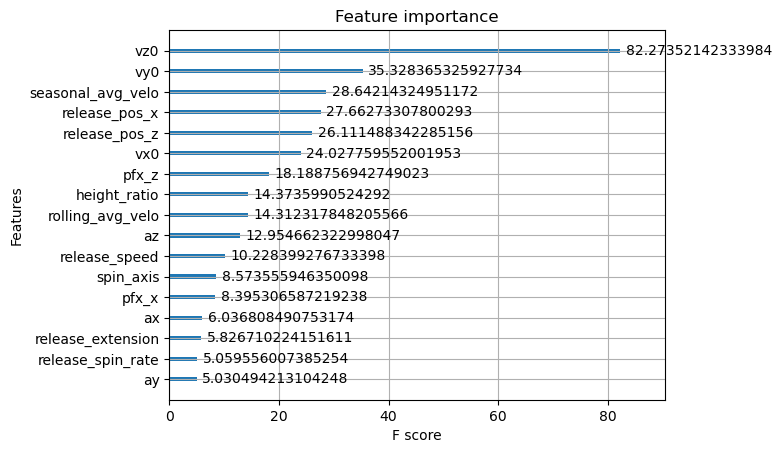

In [20]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

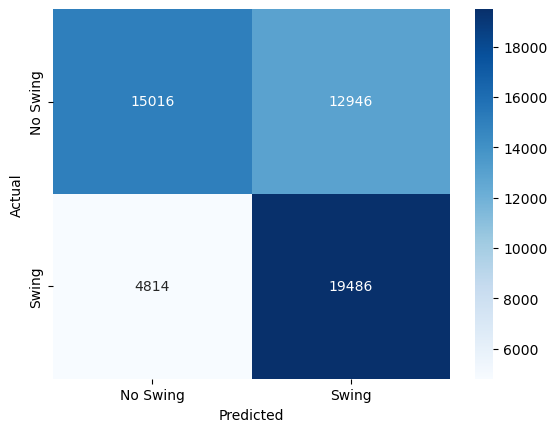

In [21]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Swing', 'Swing'], yticklabels=['No Swing', 'Swing'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Testing Data Set Predictions

In [22]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'rolling_avg_velo', 'seasonal_avg_velo'],
      dtype='object')

In [23]:
predictions = xgb.DMatrix(testing_data, label=testing_label)

In [24]:
y_pred = final_model.predict(predictions)

In [25]:
testing_identifiers['xswing'] = y_pred

In [26]:
num_nans = testing_identifiers['xswing'].isna().sum()
print(f"Number of NaNs in 'xswing': {num_nans}")


Number of NaNs in 'xswing': 0


In [27]:
len(testing_identifiers)

562083

In [28]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/swing_2022&3_xswing.csv")